In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号



from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-30) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3]; #将u的第一列、第二列、第三列分别赋值给u1、u2、u3
        u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6]; #将u的第四列、第五列、第六列分别赋值给u4、u5、u6
        u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9]; #将u的第七列、第八列、第九列分别赋值给u7、u8、u9
        u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12] #将u的第十列、第十一列、第十二列分别赋值给u10、u11、u12
        

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_4 = torch.autograd.grad(
            u4, x,
            grad_outputs=torch.ones_like(u4),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_5 = torch.autograd.grad(
            u5, x,
            grad_outputs=torch.ones_like(u5),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_6 = torch.autograd.grad(
            u6, x,
            grad_outputs=torch.ones_like(u6),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_7 = torch.autograd.grad(
            u7, x,
            grad_outputs=torch.ones_like(u7),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_8 = torch.autograd.grad(
            u8, x,
            grad_outputs=torch.ones_like(u8),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_9 = torch.autograd.grad(
            u9, x,
            grad_outputs=torch.ones_like(u9),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_10 = torch.autograd.grad(
            u10, x,
            grad_outputs=torch.ones_like(u10),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_11 = torch.autograd.grad(
            u11, x,
            grad_outputs=torch.ones_like(u11),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_12 = torch.autograd.grad(
            u12, x,
            grad_outputs=torch.ones_like(u12),
            retain_graph=True,
            create_graph=True
        )[0]


        #归一化
        u_x_1 = u_x_1 / self.sigma_x;u_x_2 = u_x_2 / self.sigma_x;u_x_3 = u_x_3 / self.sigma_x
        u_x_4 = u_x_4 / self.sigma_x;u_x_5 = u_x_5 / self.sigma_x;u_x_6 = u_x_6 / self.sigma_x
        u_x_7 = u_x_7 / self.sigma_x;u_x_8 = u_x_8 / self.sigma_x;u_x_9 = u_x_9 / self.sigma_x
        u_x_10 = u_x_10 / self.sigma_x;u_x_11 = u_x_11 / self.sigma_x;u_x_12 = u_x_12 / self.sigma_x

        #指定状态转移概率
        #对于元素1
        Lambda2_1_1=7; Mu1_2_1=100;
        #对于元素2
        Lambda2_1_2=10; Mu1_2_2=80;
        #对于元素3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        #计算ODE项
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu1_2_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12

        
        #计算残差
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12

        #计算损失函数
        loss_1 = torch.mean(residual_1 ** 2); loss_2 = torch.mean(residual_2 ** 2); loss_3 = torch.mean(residual_3 ** 2);
        loss_4 = torch.mean(residual_4 ** 2); loss_5 = torch.mean(residual_5 ** 2); loss_6 = torch.mean(residual_6 ** 2);
        loss_7 = torch.mean(residual_7 ** 2); loss_8 = torch.mean(residual_8 ** 2); loss_9 = torch.mean(residual_9 ** 2);
        loss_10 = torch.mean(residual_10 ** 2); loss_11 = torch.mean(residual_11 ** 2); loss_12 = torch.mean(residual_12 ** 2)


        loss_f = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9 + loss_10 + loss_11 + loss_12
        return loss_f, residual_1+residual_2+residual_3+residual_4+residual_5+residual_6+residual_7+residual_8+residual_9+residual_10+residual_11+residual_12
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = 100*loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_4'] + df['state_6']
    df['system_1.5'] = df['state_3'] + df['state_7']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0     

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 200

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态


error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储混沌值
residuals = [] #创建一个空列表，用于存储残差值

i = 0


# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    X_f = lb + (ub - lb) * lhs(1, N_f) #生成N_f个配位点，均匀分布在[0,1]之间
    # X_f = np.linspace(lb, ub, N_f)     # 配位点位置
    nIter = 40000

    #创建PINN模型并输入各种参数     
    # model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub, X_star, u_star)
    model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub)
    
    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    # up = 80000
    n_star = 500+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
    y_pred = get_system_performance(y_pred_df)
    # y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]))
    mse = np.mean((y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:,-5:],2)/np.linalg.norm(y_star.iloc[:,-5:],2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)






Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 3/40000 [00:00<22:38, 29.44it/s]


Adam:   0%|          | 27/40000 [00:00<04:22, 152.24it/s]


Adam:   0%|          | 52/40000 [00:00<03:26, 193.29it/s]


Adam:   0%|          | 75/40000 [00:00<03:12, 207.18it/s]


Adam:   0%|          | 100/40000 [00:00<03:01, 219.47it/s]


Adam:   0%|          | 124/40000 [00:00<02:56, 225.89it/s]


Adam:   0%|          | 148/40000 [00:00<02:53, 230.21it/s]


Adam:   0%|          | 172/40000 [00:00<02:50, 233.14it/s]


Adam:   0%|          | 196/40000 [00:00<02:51, 231.99it/s]


Adam:   1%|          | 220/40000 [00:01<02:57, 224.71it/s]


Adam:   1%|          | 244/40000 [00:01<02:54, 227.56it/s]


Adam:   1%|          | 268/40000 [00:01<02:52, 230.92it/s]


Adam:   1%|          | 292/40000 [00:01<02:50, 232.78it/s]


Adam:   1%|          | 316/40000 [00:01<02:49, 233.59it/s]


Adam:   1%|          | 340/40000 [00:01<02:49, 234.48it/s]


Adam:   1%|          | 364/40000 [00:01<02:48, 235.13it/s]


Adam:   1%|          | 388/40000 [00:01<02:48, 234.96it/s]


Adam:   1%|          | 412/40000 [00:01<02:47, 236.04it/s]


Adam:   1%|          | 436/40000 [00:01<02:47, 236.42it/s]


Adam:   1%|          | 460/40000 [00:02<02:46, 237.02it/s]


Adam:   1%|          | 484/40000 [00:02<02:46, 236.80it/s]


Adam:   1%|▏         | 508/40000 [00:02<02:46, 237.58it/s]


Adam:   1%|▏         | 532/40000 [00:02<02:51, 229.58it/s]


Adam:   1%|▏         | 557/40000 [00:02<02:49, 232.99it/s]


Adam:   1%|▏         | 581/40000 [00:02<02:48, 234.32it/s]


Adam:   2%|▏         | 605/40000 [00:02<02:48, 234.10it/s]


Adam:   2%|▏         | 629/40000 [00:02<02:47, 234.49it/s]


Adam:   2%|▏         | 653/40000 [00:02<02:46, 235.85it/s]


Adam:   2%|▏         | 678/40000 [00:02<02:45, 237.94it/s]


Adam:   2%|▏         | 703/40000 [00:03<02:46, 236.54it/s]


Adam:   2%|▏         | 728/40000 [00:03<02:44, 238.16it/s]


Adam:   2%|▏         | 752/40000 [00:03<02:44, 237.94it/s]


Adam:   2%|▏         | 777/40000 [00:03<02:44, 238.69it/s]


Adam:   2%|▏         | 801/40000 [00:03<02:50, 229.67it/s]


Adam:   2%|▏         | 825/40000 [00:03<02:48, 232.59it/s]


Adam:   2%|▏         | 849/40000 [00:03<02:46, 234.49it/s]


Adam:   2%|▏         | 873/40000 [00:03<02:45, 235.94it/s]


Adam:   2%|▏         | 897/40000 [00:03<02:45, 236.76it/s]


Adam:   2%|▏         | 921/40000 [00:04<02:44, 237.32it/s]


Adam:   2%|▏         | 945/40000 [00:04<02:44, 237.11it/s]


Adam:   2%|▏         | 969/40000 [00:04<02:52, 226.11it/s]


Adam:   2%|▏         | 993/40000 [00:04<02:51, 227.95it/s]


Adam:   3%|▎         | 1016/40000 [00:04<02:51, 227.69it/s]


Adam:   3%|▎         | 1040/40000 [00:04<02:48, 230.78it/s]


Adam:   3%|▎         | 1064/40000 [00:04<03:01, 214.55it/s]


Adam:   3%|▎         | 1087/40000 [00:04<02:57, 218.80it/s]


Adam:   3%|▎         | 1110/40000 [00:04<02:56, 220.20it/s]


Adam:   3%|▎         | 1135/40000 [00:04<02:51, 226.09it/s]


Adam:   3%|▎         | 1158/40000 [00:05<02:52, 225.00it/s]


Adam:   3%|▎         | 1182/40000 [00:05<02:50, 227.85it/s]


Adam:   3%|▎         | 1206/40000 [00:05<02:47, 230.96it/s]


Adam:   3%|▎         | 1230/40000 [00:05<02:46, 233.46it/s]


Adam:   3%|▎         | 1255/40000 [00:05<02:43, 236.25it/s]


Adam:   3%|▎         | 1279/40000 [00:05<02:43, 237.10it/s]


Adam:   3%|▎         | 1303/40000 [00:05<02:45, 233.64it/s]


Adam:   3%|▎         | 1327/40000 [00:05<02:47, 231.15it/s]


Adam:   3%|▎         | 1351/40000 [00:05<02:45, 233.52it/s]


Adam:   3%|▎         | 1376/40000 [00:05<02:44, 235.34it/s]


Adam:   4%|▎         | 1400/40000 [00:06<02:49, 227.52it/s]


Adam:   4%|▎         | 1424/40000 [00:06<02:47, 230.62it/s]


Adam:   4%|▎         | 1449/40000 [00:06<02:45, 233.37it/s]


Adam:   4%|▎         | 1473/40000 [00:06<02:45, 232.97it/s]


Adam:   4%|▎         | 1497/40000 [00:06<02:47, 229.77it/s]


Adam:   4%|▍         | 1522/40000 [00:06<02:44, 233.25it/s]


Adam:   4%|▍         | 1546/40000 [00:06<02:46, 231.64it/s]


Adam:   4%|▍         | 1571/40000 [00:06<02:43, 234.77it/s]


Adam:   4%|▍         | 1595/40000 [00:06<02:42, 236.21it/s]


Adam:   4%|▍         | 1619/40000 [00:07<02:43, 234.24it/s]


Adam:   4%|▍         | 1643/40000 [00:07<02:44, 233.28it/s]


Adam:   4%|▍         | 1667/40000 [00:07<02:43, 235.13it/s]


Adam:   4%|▍         | 1691/40000 [00:07<02:42, 235.24it/s]


Adam:   4%|▍         | 1715/40000 [00:07<02:45, 231.40it/s]


Adam:   4%|▍         | 1740/40000 [00:07<02:43, 234.18it/s]


Adam:   4%|▍         | 1764/40000 [00:07<02:43, 234.49it/s]


Adam:   4%|▍         | 1788/40000 [00:07<02:42, 235.00it/s]


Adam:   5%|▍         | 1812/40000 [00:07<02:46, 229.54it/s]


Adam:   5%|▍         | 1835/40000 [00:07<02:48, 225.83it/s]


Adam:   5%|▍         | 1860/40000 [00:08<02:45, 230.29it/s]


Adam:   5%|▍         | 1885/40000 [00:08<02:43, 233.77it/s]


Adam:   5%|▍         | 1910/40000 [00:08<02:41, 236.45it/s]


Adam:   5%|▍         | 1934/40000 [00:08<02:40, 237.46it/s]


Adam:   5%|▍         | 1959/40000 [00:08<02:39, 238.52it/s]


Adam:   5%|▍         | 1983/40000 [00:08<02:40, 236.67it/s]


Adam:   5%|▌         | 2007/40000 [00:08<02:41, 235.36it/s]


Adam:   5%|▌         | 2031/40000 [00:08<02:41, 234.65it/s]


Adam:   5%|▌         | 2055/40000 [00:08<02:44, 230.32it/s]


Adam:   5%|▌         | 2080/40000 [00:09<02:42, 233.65it/s]


Adam:   5%|▌         | 2105/40000 [00:09<02:40, 236.68it/s]


Adam:   5%|▌         | 2130/40000 [00:09<02:38, 238.25it/s]


Adam:   5%|▌         | 2154/40000 [00:09<02:38, 238.60it/s]


Adam:   5%|▌         | 2179/40000 [00:09<02:37, 239.70it/s]


Adam:   6%|▌         | 2204/40000 [00:09<02:36, 241.39it/s]


Adam:   6%|▌         | 2229/40000 [00:09<02:36, 241.39it/s]


Adam:   6%|▌         | 2254/40000 [00:09<02:36, 241.48it/s]


Adam:   6%|▌         | 2279/40000 [00:09<02:36, 240.67it/s]


Adam:   6%|▌         | 2304/40000 [00:09<02:36, 240.38it/s]


Adam:   6%|▌         | 2329/40000 [00:10<02:36, 240.11it/s]


Adam:   6%|▌         | 2354/40000 [00:10<02:36, 240.42it/s]


Adam:   6%|▌         | 2379/40000 [00:10<02:36, 239.92it/s]


Adam:   6%|▌         | 2404/40000 [00:10<02:36, 240.23it/s]


Adam:   6%|▌         | 2429/40000 [00:10<02:35, 241.09it/s]


Adam:   6%|▌         | 2454/40000 [00:10<02:35, 241.93it/s]


Adam:   6%|▌         | 2479/40000 [00:10<02:35, 241.30it/s]


Adam:   6%|▋         | 2504/40000 [00:10<02:34, 242.05it/s]


Adam:   6%|▋         | 2529/40000 [00:10<02:34, 242.48it/s]


Adam:   6%|▋         | 2554/40000 [00:10<02:34, 242.47it/s]


Adam:   6%|▋         | 2579/40000 [00:11<02:37, 237.57it/s]


Adam:   7%|▋         | 2603/40000 [00:11<02:38, 236.10it/s]


Adam:   7%|▋         | 2627/40000 [00:11<02:42, 229.84it/s]


Adam:   7%|▋         | 2651/40000 [00:11<02:43, 228.05it/s]


Adam:   7%|▋         | 2676/40000 [00:11<02:40, 232.15it/s]


Adam:   7%|▋         | 2701/40000 [00:11<02:38, 235.54it/s]


Adam:   7%|▋         | 2726/40000 [00:11<02:37, 237.41it/s]


Adam:   7%|▋         | 2751/40000 [00:11<02:36, 238.34it/s]


Adam:   7%|▋         | 2776/40000 [00:11<02:35, 239.77it/s]


Adam:   7%|▋         | 2801/40000 [00:12<02:34, 241.49it/s]


Adam:   7%|▋         | 2826/40000 [00:12<02:35, 239.67it/s]


Adam:   7%|▋         | 2850/40000 [00:12<02:46, 223.20it/s]


Adam:   7%|▋         | 2874/40000 [00:12<02:44, 225.34it/s]


Adam:   7%|▋         | 2898/40000 [00:12<02:41, 229.41it/s]


Adam:   7%|▋         | 2922/40000 [00:12<02:44, 225.75it/s]


Adam:   7%|▋         | 2946/40000 [00:12<02:41, 229.50it/s]


Adam:   7%|▋         | 2970/40000 [00:12<02:41, 229.37it/s]


Adam:   7%|▋         | 2994/40000 [00:12<02:40, 230.22it/s]


Adam:   8%|▊         | 3019/40000 [00:12<02:38, 233.65it/s]


Adam:   8%|▊         | 3043/40000 [00:13<02:38, 233.83it/s]


Adam:   8%|▊         | 3067/40000 [00:13<02:41, 228.29it/s]


Adam:   8%|▊         | 3090/40000 [00:13<03:02, 202.04it/s]


Adam:   8%|▊         | 3114/40000 [00:13<02:56, 209.02it/s]


Adam:   8%|▊         | 3138/40000 [00:13<02:49, 217.38it/s]


Adam:   8%|▊         | 3162/40000 [00:13<02:45, 223.25it/s]


Adam:   8%|▊         | 3185/40000 [00:13<02:46, 221.52it/s]


Adam:   8%|▊         | 3210/40000 [00:13<02:41, 227.65it/s]


Adam:   8%|▊         | 3234/40000 [00:13<02:39, 231.16it/s]


Adam:   8%|▊         | 3258/40000 [00:14<02:42, 225.47it/s]


Adam:   8%|▊         | 3281/40000 [00:14<02:45, 222.01it/s]


Adam:   8%|▊         | 3304/40000 [00:14<02:46, 220.23it/s]


Adam:   8%|▊         | 3327/40000 [00:14<02:52, 212.03it/s]


Adam:   8%|▊         | 3350/40000 [00:14<02:50, 215.04it/s]


Adam:   8%|▊         | 3372/40000 [00:14<02:53, 210.82it/s]


Adam:   8%|▊         | 3394/40000 [00:14<03:02, 200.79it/s]


Adam:   9%|▊         | 3418/40000 [00:14<02:54, 209.51it/s]


Adam:   9%|▊         | 3440/40000 [00:14<02:56, 207.54it/s]


Adam:   9%|▊         | 3463/40000 [00:15<02:51, 213.02it/s]


Adam:   9%|▊         | 3486/40000 [00:15<02:48, 217.23it/s]


Adam:   9%|▉         | 3509/40000 [00:15<02:45, 220.16it/s]


Adam:   9%|▉         | 3532/40000 [00:15<02:48, 216.57it/s]


Adam:   9%|▉         | 3554/40000 [00:15<02:52, 211.60it/s]


Adam:   9%|▉         | 3576/40000 [00:15<03:06, 195.69it/s]


Adam:   9%|▉         | 3596/40000 [00:15<03:07, 194.22it/s]


Adam:   9%|▉         | 3617/40000 [00:15<03:04, 197.68it/s]


Adam:   9%|▉         | 3640/40000 [00:15<02:55, 206.60it/s]


Adam:   9%|▉         | 3661/40000 [00:16<02:55, 206.53it/s]


Adam:   9%|▉         | 3685/40000 [00:16<02:49, 213.94it/s]


Adam:   9%|▉         | 3709/40000 [00:16<02:45, 219.01it/s]


Adam:   9%|▉         | 3731/40000 [00:16<02:45, 218.70it/s]


Adam:   9%|▉         | 3754/40000 [00:16<02:45, 219.48it/s]


Adam:   9%|▉         | 3776/40000 [00:16<02:51, 210.78it/s]


Adam:   9%|▉         | 3798/40000 [00:16<02:51, 210.92it/s]


Adam:  10%|▉         | 3820/40000 [00:16<02:50, 211.67it/s]


Adam:  10%|▉         | 3843/40000 [00:16<02:47, 216.07it/s]


Adam:  10%|▉         | 3866/40000 [00:16<02:44, 219.79it/s]


Adam:  10%|▉         | 3890/40000 [00:17<02:41, 223.17it/s]


Adam:  10%|▉         | 3913/40000 [00:17<02:47, 215.01it/s]


Adam:  10%|▉         | 3936/40000 [00:17<02:45, 218.50it/s]


Adam:  10%|▉         | 3958/40000 [00:17<02:44, 218.73it/s]


Adam:  10%|▉         | 3980/40000 [00:17<02:45, 218.19it/s]


Adam:  10%|█         | 4002/40000 [00:17<02:47, 214.28it/s]


Adam:  10%|█         | 4026/40000 [00:17<02:44, 219.20it/s]


Adam:  10%|█         | 4049/40000 [00:17<02:42, 221.29it/s]


Adam:  10%|█         | 4072/40000 [00:17<02:40, 223.66it/s]


Adam:  10%|█         | 4096/40000 [00:17<02:37, 227.44it/s]


Adam:  10%|█         | 4119/40000 [00:18<02:44, 217.76it/s]


Adam:  10%|█         | 4143/40000 [00:18<02:41, 222.30it/s]


Adam:  10%|█         | 4166/40000 [00:18<02:44, 218.49it/s]


Adam:  10%|█         | 4190/40000 [00:18<02:40, 223.20it/s]


Adam:  11%|█         | 4213/40000 [00:18<02:42, 220.38it/s]


Adam:  11%|█         | 4236/40000 [00:18<02:54, 205.41it/s]


Adam:  11%|█         | 4259/40000 [00:18<02:48, 211.55it/s]


Adam:  11%|█         | 4282/40000 [00:18<02:45, 215.94it/s]


Adam:  11%|█         | 4305/40000 [00:18<02:43, 218.38it/s]


Adam:  11%|█         | 4329/40000 [00:19<02:40, 221.97it/s]


Adam:  11%|█         | 4353/40000 [00:19<02:38, 224.39it/s]


Adam:  11%|█         | 4376/40000 [00:19<02:38, 225.43it/s]


Adam:  11%|█         | 4400/40000 [00:19<02:35, 229.02it/s]


Adam:  11%|█         | 4423/40000 [00:19<02:37, 225.71it/s]


Adam:  11%|█         | 4446/40000 [00:19<02:43, 218.00it/s]


Adam:  11%|█         | 4468/40000 [00:19<02:47, 211.84it/s]


Adam:  11%|█         | 4492/40000 [00:19<02:42, 217.86it/s]


Adam:  11%|█▏        | 4514/40000 [00:19<02:50, 207.59it/s]


Adam:  11%|█▏        | 4535/40000 [00:20<02:51, 206.91it/s]


Adam:  11%|█▏        | 4556/40000 [00:20<02:51, 207.25it/s]


Adam:  11%|█▏        | 4577/40000 [00:20<02:52, 205.30it/s]


Adam:  11%|█▏        | 4598/40000 [00:20<02:54, 203.41it/s]


Adam:  12%|█▏        | 4621/40000 [00:20<02:48, 210.14it/s]


Adam:  12%|█▏        | 4644/40000 [00:20<02:47, 210.60it/s]


Adam:  12%|█▏        | 4666/40000 [00:20<02:58, 197.77it/s]


Adam:  12%|█▏        | 4690/40000 [00:20<02:50, 207.44it/s]


Adam:  12%|█▏        | 4711/40000 [00:20<02:50, 207.20it/s]


Adam:  12%|█▏        | 4733/40000 [00:20<02:48, 209.42it/s]


Adam:  12%|█▏        | 4755/40000 [00:21<02:48, 208.76it/s]


Adam:  12%|█▏        | 4778/40000 [00:21<02:44, 214.50it/s]


Adam:  12%|█▏        | 4800/40000 [00:21<02:43, 215.45it/s]


Adam:  12%|█▏        | 4822/40000 [00:21<02:45, 212.77it/s]


Adam:  12%|█▏        | 4846/40000 [00:21<02:40, 218.55it/s]


Adam:  12%|█▏        | 4870/40000 [00:21<02:38, 222.33it/s]


Adam:  12%|█▏        | 4894/40000 [00:21<02:35, 225.18it/s]


Adam:  12%|█▏        | 4917/40000 [00:21<02:42, 215.28it/s]


Adam:  12%|█▏        | 4939/40000 [00:21<02:49, 207.18it/s]


Adam:  12%|█▏        | 4963/40000 [00:22<02:42, 215.01it/s]


Adam:  12%|█▏        | 4987/40000 [00:22<02:39, 219.68it/s]


Adam:  13%|█▎        | 5010/40000 [00:22<02:39, 219.58it/s]


Adam:  13%|█▎        | 5033/40000 [00:22<02:39, 219.45it/s]


Adam:  13%|█▎        | 5056/40000 [00:22<02:38, 220.88it/s]


Adam:  13%|█▎        | 5079/40000 [00:22<02:37, 221.70it/s]


Adam:  13%|█▎        | 5102/40000 [00:22<02:36, 223.37it/s]


Adam:  13%|█▎        | 5125/40000 [00:22<02:39, 218.24it/s]


Adam:  13%|█▎        | 5147/40000 [00:22<02:55, 198.22it/s]


Adam:  13%|█▎        | 5168/40000 [00:23<03:02, 190.82it/s]


Adam:  13%|█▎        | 5192/40000 [00:23<02:51, 202.71it/s]


Adam:  13%|█▎        | 5216/40000 [00:23<02:44, 210.89it/s]


Adam:  13%|█▎        | 5238/40000 [00:23<02:47, 208.13it/s]


Adam:  13%|█▎        | 5262/40000 [00:23<02:41, 215.22it/s]


Adam:  13%|█▎        | 5286/40000 [00:23<02:38, 219.67it/s]


Adam:  13%|█▎        | 5309/40000 [00:23<02:38, 218.28it/s]


Adam:  13%|█▎        | 5332/40000 [00:23<02:37, 219.78it/s]


Adam:  13%|█▎        | 5356/40000 [00:23<02:35, 223.43it/s]


Adam:  13%|█▎        | 5379/40000 [00:23<02:38, 219.01it/s]


Adam:  14%|█▎        | 5401/40000 [00:24<02:45, 208.96it/s]


Adam:  14%|█▎        | 5423/40000 [00:24<02:43, 211.75it/s]


Adam:  14%|█▎        | 5445/40000 [00:24<02:43, 211.03it/s]


Adam:  14%|█▎        | 5467/40000 [00:24<03:02, 188.79it/s]


Adam:  14%|█▎        | 5487/40000 [00:24<03:06, 184.76it/s]


Adam:  14%|█▍        | 5508/40000 [00:24<03:00, 191.37it/s]


Adam:  14%|█▍        | 5530/40000 [00:24<02:54, 197.14it/s]


Adam:  14%|█▍        | 5551/40000 [00:24<02:51, 200.37it/s]


Adam:  14%|█▍        | 5572/40000 [00:24<02:51, 201.16it/s]


Adam:  14%|█▍        | 5593/40000 [00:25<02:51, 200.22it/s]


Adam:  14%|█▍        | 5614/40000 [00:25<02:50, 201.31it/s]


Adam:  14%|█▍        | 5636/40000 [00:25<02:47, 204.86it/s]


Adam:  14%|█▍        | 5657/40000 [00:25<02:46, 205.98it/s]


Adam:  14%|█▍        | 5678/40000 [00:25<02:47, 204.80it/s]


Adam:  14%|█▍        | 5699/40000 [00:25<02:47, 205.14it/s]


Adam:  14%|█▍        | 5720/40000 [00:25<02:49, 201.74it/s]


Adam:  14%|█▍        | 5741/40000 [00:25<02:56, 193.86it/s]


Adam:  14%|█▍        | 5761/40000 [00:25<03:03, 187.07it/s]


Adam:  14%|█▍        | 5782/40000 [00:26<02:57, 192.73it/s]


Adam:  15%|█▍        | 5804/40000 [00:26<02:52, 197.78it/s]


Adam:  15%|█▍        | 5824/40000 [00:26<02:57, 192.18it/s]


Adam:  15%|█▍        | 5846/40000 [00:26<02:51, 199.19it/s]


Adam:  15%|█▍        | 5869/40000 [00:26<02:46, 205.02it/s]


Adam:  15%|█▍        | 5891/40000 [00:26<02:43, 208.42it/s]


Adam:  15%|█▍        | 5914/40000 [00:26<02:39, 213.21it/s]


Adam:  15%|█▍        | 5936/40000 [00:26<02:43, 208.86it/s]


Adam:  15%|█▍        | 5957/40000 [00:26<02:47, 202.79it/s]


Adam:  15%|█▍        | 5979/40000 [00:26<02:45, 205.95it/s]


Adam:  15%|█▌        | 6000/40000 [00:27<02:51, 198.04it/s]


Adam:  15%|█▌        | 6020/40000 [00:27<02:52, 196.81it/s]


Adam:  15%|█▌        | 6041/40000 [00:27<02:49, 199.95it/s]


Adam:  15%|█▌        | 6062/40000 [00:27<02:51, 198.12it/s]


Adam:  15%|█▌        | 6084/40000 [00:27<02:48, 201.42it/s]


Adam:  15%|█▌        | 6105/40000 [00:27<02:51, 198.21it/s]


Adam:  15%|█▌        | 6126/40000 [00:27<02:48, 201.56it/s]


Adam:  15%|█▌        | 6147/40000 [00:27<02:51, 197.97it/s]


Adam:  15%|█▌        | 6168/40000 [00:27<02:48, 201.05it/s]


Adam:  15%|█▌        | 6189/40000 [00:28<02:46, 202.83it/s]


Adam:  16%|█▌        | 6210/40000 [00:28<02:45, 203.87it/s]


Adam:  16%|█▌        | 6231/40000 [00:28<02:48, 200.34it/s]


Adam:  16%|█▌        | 6252/40000 [00:28<02:59, 188.22it/s]


Adam:  16%|█▌        | 6272/40000 [00:28<02:56, 191.20it/s]


Adam:  16%|█▌        | 6294/40000 [00:28<02:50, 198.16it/s]


Adam:  16%|█▌        | 6314/40000 [00:28<02:56, 190.64it/s]


Adam:  16%|█▌        | 6335/40000 [00:28<02:52, 194.89it/s]


Adam:  16%|█▌        | 6356/40000 [00:28<02:49, 197.95it/s]


Adam:  16%|█▌        | 6378/40000 [00:28<02:45, 203.50it/s]


Adam:  16%|█▌        | 6399/40000 [00:29<02:50, 197.07it/s]


Adam:  16%|█▌        | 6419/40000 [00:29<03:01, 184.54it/s]


Adam:  16%|█▌        | 6438/40000 [00:29<03:01, 184.45it/s]


Adam:  16%|█▌        | 6457/40000 [00:29<03:03, 182.83it/s]


Adam:  16%|█▌        | 6477/40000 [00:29<02:59, 186.87it/s]


Adam:  16%|█▌        | 6496/40000 [00:29<03:00, 185.72it/s]


Adam:  16%|█▋        | 6516/40000 [00:29<02:57, 188.87it/s]


Adam:  16%|█▋        | 6537/40000 [00:29<02:52, 194.25it/s]


Adam:  16%|█▋        | 6557/40000 [00:29<02:50, 195.91it/s]


Adam:  16%|█▋        | 6579/40000 [00:30<02:47, 200.00it/s]


Adam:  16%|█▋        | 6600/40000 [00:30<02:46, 200.32it/s]


Adam:  17%|█▋        | 6622/40000 [00:30<02:42, 205.43it/s]


Adam:  17%|█▋        | 6643/40000 [00:30<02:45, 201.50it/s]


Adam:  17%|█▋        | 6664/40000 [00:30<02:45, 201.89it/s]


Adam:  17%|█▋        | 6685/40000 [00:30<02:43, 204.08it/s]


Adam:  17%|█▋        | 6706/40000 [00:30<02:48, 197.99it/s]


Adam:  17%|█▋        | 6727/40000 [00:30<02:47, 198.86it/s]


Adam:  17%|█▋        | 6748/40000 [00:30<02:45, 200.47it/s]


Adam:  17%|█▋        | 6769/40000 [00:31<02:44, 201.65it/s]


Adam:  17%|█▋        | 6790/40000 [00:31<02:47, 198.23it/s]


Adam:  17%|█▋        | 6810/40000 [00:31<02:50, 194.79it/s]


Adam:  17%|█▋        | 6830/40000 [00:31<02:50, 194.13it/s]


Adam:  17%|█▋        | 6850/40000 [00:31<02:49, 195.28it/s]


Adam:  17%|█▋        | 6870/40000 [00:31<02:48, 196.51it/s]


Adam:  17%|█▋        | 6890/40000 [00:31<02:47, 197.50it/s]


Adam:  17%|█▋        | 6912/40000 [00:31<02:44, 201.07it/s]


Adam:  17%|█▋        | 6933/40000 [00:31<02:44, 201.03it/s]


Adam:  17%|█▋        | 6954/40000 [00:31<02:48, 196.14it/s]


Adam:  17%|█▋        | 6974/40000 [00:32<02:48, 196.14it/s]


Adam:  17%|█▋        | 6995/40000 [00:32<02:47, 197.61it/s]


Adam:  18%|█▊        | 7017/40000 [00:32<02:43, 201.16it/s]


Adam:  18%|█▊        | 7039/40000 [00:32<02:41, 204.34it/s]


Adam:  18%|█▊        | 7060/40000 [00:32<02:40, 205.75it/s]


Adam:  18%|█▊        | 7081/40000 [00:32<02:39, 206.35it/s]


Adam:  18%|█▊        | 7102/40000 [00:32<02:43, 201.34it/s]


Adam:  18%|█▊        | 7124/40000 [00:32<02:41, 203.91it/s]


Adam:  18%|█▊        | 7146/40000 [00:32<02:38, 207.81it/s]


Adam:  18%|█▊        | 7167/40000 [00:32<02:38, 207.00it/s]


Adam:  18%|█▊        | 7189/40000 [00:33<02:35, 210.37it/s]


Adam:  18%|█▊        | 7211/40000 [00:33<02:42, 202.14it/s]


Adam:  18%|█▊        | 7233/40000 [00:33<02:38, 206.22it/s]


Adam:  18%|█▊        | 7254/40000 [00:33<02:46, 197.24it/s]


Adam:  18%|█▊        | 7274/40000 [00:33<02:59, 181.89it/s]


Adam:  18%|█▊        | 7293/40000 [00:33<03:27, 157.82it/s]


Adam:  18%|█▊        | 7312/40000 [00:33<03:17, 165.53it/s]


Adam:  18%|█▊        | 7331/40000 [00:33<03:10, 171.51it/s]


Adam:  18%|█▊        | 7351/40000 [00:34<03:02, 178.63it/s]


Adam:  18%|█▊        | 7372/40000 [00:34<02:56, 185.12it/s]


Adam:  18%|█▊        | 7391/40000 [00:34<02:55, 185.95it/s]


Adam:  19%|█▊        | 7411/40000 [00:34<02:51, 189.78it/s]


Adam:  19%|█▊        | 7431/40000 [00:34<03:03, 177.60it/s]


Adam:  19%|█▊        | 7450/40000 [00:34<03:09, 172.20it/s]


Adam:  19%|█▊        | 7470/40000 [00:34<03:02, 177.96it/s]


Adam:  19%|█▊        | 7490/40000 [00:34<02:58, 182.17it/s]


Adam:  19%|█▉        | 7509/40000 [00:34<02:56, 183.76it/s]


Adam:  19%|█▉        | 7528/40000 [00:34<02:59, 181.34it/s]


Adam:  19%|█▉        | 7547/40000 [00:35<03:05, 174.87it/s]


Adam:  19%|█▉        | 7565/40000 [00:35<03:11, 169.44it/s]


Adam:  19%|█▉        | 7583/40000 [00:35<03:15, 165.64it/s]


Adam:  19%|█▉        | 7602/40000 [00:35<03:10, 170.38it/s]


Adam:  19%|█▉        | 7623/40000 [00:35<02:59, 180.17it/s]


Adam:  19%|█▉        | 7642/40000 [00:35<03:04, 175.27it/s]


Adam:  19%|█▉        | 7660/40000 [00:35<03:04, 175.70it/s]


Adam:  19%|█▉        | 7681/40000 [00:35<02:56, 182.80it/s]


Adam:  19%|█▉        | 7700/40000 [00:35<02:56, 183.21it/s]


Adam:  19%|█▉        | 7719/40000 [00:36<03:10, 169.14it/s]


Adam:  19%|█▉        | 7737/40000 [00:36<03:08, 171.25it/s]


Adam:  19%|█▉        | 7757/40000 [00:36<03:01, 177.58it/s]


Adam:  19%|█▉        | 7775/40000 [00:36<03:02, 176.27it/s]


Adam:  19%|█▉        | 7793/40000 [00:36<03:11, 167.94it/s]


Adam:  20%|█▉        | 7810/40000 [00:36<03:18, 162.53it/s]


Adam:  20%|█▉        | 7828/40000 [00:36<03:12, 167.00it/s]


Adam:  20%|█▉        | 7846/40000 [00:36<03:10, 168.73it/s]


Adam:  20%|█▉        | 7863/40000 [00:36<03:16, 163.52it/s]


Adam:  20%|█▉        | 7880/40000 [00:37<03:18, 161.83it/s]


Adam:  20%|█▉        | 7897/40000 [00:37<03:21, 159.55it/s]


Adam:  20%|█▉        | 7915/40000 [00:37<03:15, 164.26it/s]


Adam:  20%|█▉        | 7933/40000 [00:37<03:13, 165.67it/s]


Adam:  20%|█▉        | 7950/40000 [00:37<03:13, 165.43it/s]


Adam:  20%|█▉        | 7970/40000 [00:37<03:04, 173.37it/s]


Adam:  20%|█▉        | 7989/40000 [00:37<03:00, 177.08it/s]


Adam:  20%|██        | 8009/40000 [00:37<02:56, 181.30it/s]


Adam:  20%|██        | 8028/40000 [00:37<03:03, 174.20it/s]


Adam:  20%|██        | 8046/40000 [00:38<03:10, 167.38it/s]


Adam:  20%|██        | 8065/40000 [00:38<03:05, 172.33it/s]


Adam:  20%|██        | 8083/40000 [00:38<03:07, 170.20it/s]


Adam:  20%|██        | 8101/40000 [00:38<03:10, 167.32it/s]


Adam:  20%|██        | 8119/40000 [00:38<03:06, 170.69it/s]


Adam:  20%|██        | 8137/40000 [00:38<03:07, 169.61it/s]


Adam:  20%|██        | 8155/40000 [00:38<03:11, 166.63it/s]


Adam:  20%|██        | 8172/40000 [00:38<03:11, 166.10it/s]


Adam:  20%|██        | 8191/40000 [00:38<03:05, 171.39it/s]


Adam:  21%|██        | 8209/40000 [00:38<03:09, 167.69it/s]


Adam:  21%|██        | 8226/40000 [00:39<03:16, 161.95it/s]


Adam:  21%|██        | 8243/40000 [00:39<03:16, 161.64it/s]


Adam:  21%|██        | 8264/40000 [00:39<03:03, 173.21it/s]


Adam:  21%|██        | 8282/40000 [00:39<03:02, 174.10it/s]


Adam:  21%|██        | 8300/40000 [00:39<03:03, 172.67it/s]


Adam:  21%|██        | 8318/40000 [00:39<03:03, 172.21it/s]


Adam:  21%|██        | 8338/40000 [00:39<02:57, 178.63it/s]


Adam:  21%|██        | 8356/40000 [00:39<02:58, 176.89it/s]


Adam:  21%|██        | 8374/40000 [00:39<03:03, 172.09it/s]


Adam:  21%|██        | 8392/40000 [00:40<03:03, 171.85it/s]


Adam:  21%|██        | 8410/40000 [00:40<03:04, 170.83it/s]


Adam:  21%|██        | 8430/40000 [00:40<02:58, 177.20it/s]


Adam:  21%|██        | 8448/40000 [00:40<02:59, 175.42it/s]


Adam:  21%|██        | 8466/40000 [00:40<03:07, 168.10it/s]


Adam:  21%|██        | 8485/40000 [00:40<03:03, 171.48it/s]


Adam:  21%|██▏       | 8503/40000 [00:40<03:02, 172.39it/s]


Adam:  21%|██▏       | 8521/40000 [00:40<03:06, 168.39it/s]


Adam:  21%|██▏       | 8539/40000 [00:40<03:05, 169.32it/s]


Adam:  21%|██▏       | 8559/40000 [00:41<02:59, 175.24it/s]


Adam:  21%|██▏       | 8577/40000 [00:41<03:03, 170.99it/s]


Adam:  21%|██▏       | 8595/40000 [00:41<03:01, 172.63it/s]


Adam:  22%|██▏       | 8613/40000 [00:41<03:04, 170.58it/s]


Adam:  22%|██▏       | 8631/40000 [00:41<03:09, 165.68it/s]


Adam:  22%|██▏       | 8648/40000 [00:41<03:12, 162.76it/s]


Adam:  22%|██▏       | 8666/40000 [00:41<03:09, 165.49it/s]


Adam:  22%|██▏       | 8684/40000 [00:41<03:05, 168.77it/s]


Adam:  22%|██▏       | 8702/40000 [00:41<03:04, 170.07it/s]


Adam:  22%|██▏       | 8720/40000 [00:41<03:02, 171.25it/s]


Adam:  22%|██▏       | 8738/40000 [00:42<03:10, 164.30it/s]


Adam:  22%|██▏       | 8755/40000 [00:42<03:11, 163.19it/s]


Adam:  22%|██▏       | 8774/40000 [00:42<03:03, 170.38it/s]


Adam:  22%|██▏       | 8793/40000 [00:42<02:58, 175.26it/s]


Adam:  22%|██▏       | 8812/40000 [00:42<02:53, 179.53it/s]


Adam:  22%|██▏       | 8831/40000 [00:42<02:58, 175.07it/s]


Adam:  22%|██▏       | 8849/40000 [00:42<03:03, 169.57it/s]


Adam:  22%|██▏       | 8867/40000 [00:42<03:06, 167.17it/s]


Adam:  22%|██▏       | 8884/40000 [00:42<03:05, 167.89it/s]


Adam:  22%|██▏       | 8901/40000 [00:43<03:13, 160.46it/s]


Adam:  22%|██▏       | 8920/40000 [00:43<03:05, 167.87it/s]


Adam:  22%|██▏       | 8937/40000 [00:43<03:07, 165.61it/s]


Adam:  22%|██▏       | 8954/40000 [00:43<03:21, 153.70it/s]


Adam:  22%|██▏       | 8971/40000 [00:43<03:18, 156.68it/s]


Adam:  22%|██▏       | 8991/40000 [00:43<03:06, 166.49it/s]


Adam:  23%|██▎       | 9008/40000 [00:43<03:12, 160.87it/s]


Adam:  23%|██▎       | 9026/40000 [00:43<03:07, 165.16it/s]


Adam:  23%|██▎       | 9045/40000 [00:43<03:00, 171.23it/s]


Adam:  23%|██▎       | 9065/40000 [00:44<02:55, 176.39it/s]


Adam:  23%|██▎       | 9084/40000 [00:44<02:54, 177.43it/s]


Adam:  23%|██▎       | 9104/40000 [00:44<02:49, 182.15it/s]


Adam:  23%|██▎       | 9124/40000 [00:44<02:46, 185.61it/s]


Adam:  23%|██▎       | 9143/40000 [00:44<02:51, 179.92it/s]


Adam:  23%|██▎       | 9162/40000 [00:44<02:55, 175.22it/s]


Adam:  23%|██▎       | 9182/40000 [00:44<02:50, 180.97it/s]


Adam:  23%|██▎       | 9201/40000 [00:44<02:55, 175.30it/s]


Adam:  23%|██▎       | 9219/40000 [00:44<03:08, 163.64it/s]


Adam:  23%|██▎       | 9236/40000 [00:45<03:17, 156.11it/s]


Adam:  23%|██▎       | 9254/40000 [00:45<03:09, 162.03it/s]


Adam:  23%|██▎       | 9271/40000 [00:45<03:12, 159.62it/s]


Adam:  23%|██▎       | 9288/40000 [00:45<03:11, 160.48it/s]


Adam:  23%|██▎       | 9307/40000 [00:45<03:04, 166.31it/s]


Adam:  23%|██▎       | 9325/40000 [00:45<03:00, 170.14it/s]


Adam:  23%|██▎       | 9343/40000 [00:45<03:11, 160.18it/s]


Adam:  23%|██▎       | 9361/40000 [00:45<03:05, 165.44it/s]


Adam:  23%|██▎       | 9378/40000 [00:45<03:10, 160.49it/s]


Adam:  23%|██▎       | 9395/40000 [00:46<03:09, 161.37it/s]


Adam:  24%|██▎       | 9412/40000 [00:46<03:15, 156.65it/s]


Adam:  24%|██▎       | 9428/40000 [00:46<03:28, 146.31it/s]


Adam:  24%|██▎       | 9446/40000 [00:46<03:19, 153.47it/s]


Adam:  24%|██▎       | 9465/40000 [00:46<03:07, 162.78it/s]


Adam:  24%|██▎       | 9485/40000 [00:46<02:57, 171.89it/s]


Adam:  24%|██▍       | 9504/40000 [00:46<02:52, 176.39it/s]


Adam:  24%|██▍       | 9522/40000 [00:46<03:04, 165.55it/s]


Adam:  24%|██▍       | 9539/40000 [00:46<03:13, 157.17it/s]


Adam:  24%|██▍       | 9558/40000 [00:47<03:05, 164.40it/s]


Adam:  24%|██▍       | 9576/40000 [00:47<03:00, 168.55it/s]


Adam:  24%|██▍       | 9594/40000 [00:47<02:59, 169.46it/s]


Adam:  24%|██▍       | 9612/40000 [00:47<03:02, 166.59it/s]


Adam:  24%|██▍       | 9629/40000 [00:47<03:08, 161.49it/s]


Adam:  24%|██▍       | 9648/40000 [00:47<03:02, 166.70it/s]


Adam:  24%|██▍       | 9665/40000 [00:47<03:13, 156.60it/s]


Adam:  24%|██▍       | 9683/40000 [00:47<03:06, 162.93it/s]


Adam:  24%|██▍       | 9700/40000 [00:47<03:22, 149.34it/s]


Adam:  24%|██▍       | 9718/40000 [00:48<03:13, 156.43it/s]


Adam:  24%|██▍       | 9736/40000 [00:48<03:08, 160.96it/s]


Adam:  24%|██▍       | 9755/40000 [00:48<03:00, 167.40it/s]


Adam:  24%|██▍       | 9773/40000 [00:48<02:57, 170.38it/s]


Adam:  24%|██▍       | 9791/40000 [00:48<03:02, 165.92it/s]


Adam:  25%|██▍       | 9808/40000 [00:48<03:05, 162.80it/s]


Adam:  25%|██▍       | 9827/40000 [00:48<02:59, 168.31it/s]


Adam:  25%|██▍       | 9844/40000 [00:48<03:19, 150.84it/s]


Adam:  25%|██▍       | 9860/40000 [00:48<03:40, 136.39it/s]


Adam:  25%|██▍       | 9875/40000 [00:49<03:35, 139.67it/s]


Adam:  25%|██▍       | 9890/40000 [00:49<03:40, 136.47it/s]


Adam:  25%|██▍       | 9908/40000 [00:49<03:24, 147.46it/s]


Adam:  25%|██▍       | 9924/40000 [00:49<03:22, 148.49it/s]


Adam:  25%|██▍       | 9940/40000 [00:49<03:45, 133.45it/s]


Adam:  25%|██▍       | 9954/40000 [00:49<03:46, 132.69it/s]


Adam:  25%|██▍       | 9968/40000 [00:49<03:49, 130.60it/s]


Adam:  25%|██▍       | 9982/40000 [00:49<03:53, 128.83it/s]


Adam:  25%|██▍       | 9998/40000 [00:49<03:38, 137.13it/s]


Adam:  25%|██▌       | 10016/40000 [00:50<03:24, 146.34it/s]


Adam:  25%|██▌       | 10031/40000 [00:50<03:30, 142.07it/s]


Adam:  25%|██▌       | 10050/40000 [00:50<03:15, 153.49it/s]


Adam:  25%|██▌       | 10067/40000 [00:50<03:10, 157.27it/s]


Adam:  25%|██▌       | 10086/40000 [00:50<03:03, 162.93it/s]


Adam:  25%|██▌       | 10103/40000 [00:50<03:17, 151.65it/s]


Adam:  25%|██▌       | 10119/40000 [00:50<03:20, 149.10it/s]


Adam:  25%|██▌       | 10135/40000 [00:50<03:20, 149.20it/s]


Adam:  25%|██▌       | 10151/40000 [00:50<03:31, 140.92it/s]


Adam:  25%|██▌       | 10166/40000 [00:51<03:32, 140.20it/s]


Adam:  25%|██▌       | 10185/40000 [00:51<03:14, 153.23it/s]


Adam:  26%|██▌       | 10201/40000 [00:51<03:28, 143.17it/s]


Adam:  26%|██▌       | 10219/40000 [00:51<03:14, 152.81it/s]


Adam:  26%|██▌       | 10235/40000 [00:51<03:16, 151.72it/s]


Adam:  26%|██▌       | 10251/40000 [00:51<03:15, 152.29it/s]


Adam:  26%|██▌       | 10267/40000 [00:51<03:24, 145.39it/s]


Adam:  26%|██▌       | 10286/40000 [00:51<03:08, 157.54it/s]


Adam:  26%|██▌       | 10303/40000 [00:51<03:09, 156.69it/s]


Adam:  26%|██▌       | 10320/40000 [00:52<03:07, 158.44it/s]


Adam:  26%|██▌       | 10339/40000 [00:52<03:01, 163.82it/s]


Adam:  26%|██▌       | 10356/40000 [00:52<03:01, 163.29it/s]


Adam:  26%|██▌       | 10374/40000 [00:52<02:56, 167.72it/s]


Adam:  26%|██▌       | 10391/40000 [00:52<02:59, 165.08it/s]


Adam:  26%|██▌       | 10408/40000 [00:52<03:07, 157.84it/s]


Adam:  26%|██▌       | 10424/40000 [00:52<03:16, 150.82it/s]


Adam:  26%|██▌       | 10440/40000 [00:52<03:15, 151.32it/s]


Adam:  26%|██▌       | 10456/40000 [00:52<03:19, 147.86it/s]


Adam:  26%|██▌       | 10472/40000 [00:53<03:17, 149.27it/s]


Adam:  26%|██▌       | 10490/40000 [00:53<03:10, 155.22it/s]


Adam:  26%|██▋       | 10506/40000 [00:53<03:10, 154.57it/s]


Adam:  26%|██▋       | 10522/40000 [00:53<03:41, 133.00it/s]


Adam:  26%|██▋       | 10538/40000 [00:53<03:32, 138.35it/s]


Adam:  26%|██▋       | 10557/40000 [00:53<03:13, 152.08it/s]


Adam:  26%|██▋       | 10573/40000 [00:53<03:33, 138.08it/s]


Adam:  26%|██▋       | 10588/40000 [00:53<03:34, 137.44it/s]


Adam:  27%|██▋       | 10603/40000 [00:53<03:31, 138.70it/s]


Adam:  27%|██▋       | 10621/40000 [00:54<03:16, 149.76it/s]


Adam:  27%|██▋       | 10641/40000 [00:54<03:02, 160.67it/s]


Adam:  27%|██▋       | 10659/40000 [00:54<02:57, 164.99it/s]


Adam:  27%|██▋       | 10676/40000 [00:54<03:16, 149.00it/s]


Adam:  27%|██▋       | 10695/40000 [00:54<03:05, 158.30it/s]


Adam:  27%|██▋       | 10714/40000 [00:54<02:56, 165.71it/s]


Adam:  27%|██▋       | 10731/40000 [00:54<03:00, 162.47it/s]


Adam:  27%|██▋       | 10748/40000 [00:54<03:01, 161.13it/s]


Adam:  27%|██▋       | 10765/40000 [00:54<03:00, 161.72it/s]


Adam:  27%|██▋       | 10782/40000 [00:55<03:13, 150.74it/s]


Adam:  27%|██▋       | 10800/40000 [00:55<03:06, 156.52it/s]


Adam:  27%|██▋       | 10819/40000 [00:55<02:59, 162.74it/s]


Adam:  27%|██▋       | 10836/40000 [00:55<02:58, 163.36it/s]


Adam:  27%|██▋       | 10853/40000 [00:55<03:05, 156.75it/s]


Adam:  27%|██▋       | 10869/40000 [00:55<03:05, 156.81it/s]


Adam:  27%|██▋       | 10885/40000 [00:55<03:05, 157.14it/s]


Adam:  27%|██▋       | 10905/40000 [00:55<02:53, 167.81it/s]


Adam:  27%|██▋       | 10924/40000 [00:55<02:47, 173.95it/s]


Adam:  27%|██▋       | 10942/40000 [00:56<02:49, 171.85it/s]


Adam:  27%|██▋       | 10962/40000 [00:56<02:41, 179.83it/s]


Adam:  27%|██▋       | 10982/40000 [00:56<02:37, 184.18it/s]


Adam:  28%|██▊       | 11001/40000 [00:56<02:39, 181.54it/s]


Adam:  28%|██▊       | 11022/40000 [00:56<02:34, 187.72it/s]


Adam:  28%|██▊       | 11041/40000 [00:56<02:40, 180.83it/s]


Adam:  28%|██▊       | 11060/40000 [00:56<02:40, 180.03it/s]


Adam:  28%|██▊       | 11079/40000 [00:56<02:46, 173.53it/s]


Adam:  28%|██▊       | 11097/40000 [00:56<02:49, 170.76it/s]


Adam:  28%|██▊       | 11115/40000 [00:57<02:53, 166.14it/s]


Adam:  28%|██▊       | 11133/40000 [00:57<02:50, 169.63it/s]


Adam:  28%|██▊       | 11152/40000 [00:57<02:45, 174.78it/s]


Adam:  28%|██▊       | 11170/40000 [00:57<03:04, 155.97it/s]


Adam:  28%|██▊       | 11186/40000 [00:57<03:10, 150.96it/s]


Adam:  28%|██▊       | 11203/40000 [00:57<03:06, 154.28it/s]


Adam:  28%|██▊       | 11219/40000 [00:57<03:12, 149.70it/s]


Adam:  28%|██▊       | 11235/40000 [00:57<03:24, 140.76it/s]


Adam:  28%|██▊       | 11253/40000 [00:57<03:11, 150.09it/s]


Adam:  28%|██▊       | 11271/40000 [00:58<03:03, 156.68it/s]


Adam:  28%|██▊       | 11287/40000 [00:58<03:18, 144.94it/s]


Adam:  28%|██▊       | 11305/40000 [00:58<03:06, 154.09it/s]


Adam:  28%|██▊       | 11324/40000 [00:58<02:56, 162.70it/s]


Adam:  28%|██▊       | 11341/40000 [00:58<03:13, 147.82it/s]


Adam:  28%|██▊       | 11361/40000 [00:58<02:59, 159.70it/s]


Adam:  28%|██▊       | 11378/40000 [00:58<02:58, 160.29it/s]


Adam:  28%|██▊       | 11395/40000 [00:58<02:58, 160.48it/s]


Adam:  29%|██▊       | 11412/40000 [00:58<03:07, 152.75it/s]


Adam:  29%|██▊       | 11429/40000 [00:59<03:02, 156.51it/s]


Adam:  29%|██▊       | 11449/40000 [00:59<02:49, 168.21it/s]


Adam:  29%|██▊       | 11467/40000 [00:59<02:48, 169.45it/s]


Adam:  29%|██▊       | 11485/40000 [00:59<02:59, 159.00it/s]


Adam:  29%|██▉       | 11502/40000 [00:59<03:04, 154.31it/s]


Adam:  29%|██▉       | 11519/40000 [00:59<02:59, 158.35it/s]


Adam:  29%|██▉       | 11538/40000 [00:59<02:50, 167.02it/s]


Adam:  29%|██▉       | 11555/40000 [00:59<03:03, 155.37it/s]


Adam:  29%|██▉       | 11573/40000 [00:59<02:56, 161.34it/s]


Adam:  29%|██▉       | 11590/40000 [01:00<03:17, 143.50it/s]


Adam:  29%|██▉       | 11607/40000 [01:00<03:09, 149.89it/s]


Adam:  29%|██▉       | 11626/40000 [01:00<02:57, 159.57it/s]


Adam:  29%|██▉       | 11643/40000 [01:00<03:06, 152.05it/s]


Adam:  29%|██▉       | 11659/40000 [01:00<03:04, 153.61it/s]


Adam:  29%|██▉       | 11677/40000 [01:00<02:58, 158.63it/s]


Adam:  29%|██▉       | 11695/40000 [01:00<02:53, 163.04it/s]


Adam:  29%|██▉       | 11712/40000 [01:00<03:08, 150.09it/s]


Adam:  29%|██▉       | 11729/40000 [01:00<03:02, 154.80it/s]


Adam:  29%|██▉       | 11745/40000 [01:01<03:02, 155.17it/s]


Adam:  29%|██▉       | 11765/40000 [01:01<02:51, 164.84it/s]


Adam:  29%|██▉       | 11782/40000 [01:01<02:50, 165.71it/s]


Adam:  29%|██▉       | 11799/40000 [01:01<02:53, 162.41it/s]


Adam:  30%|██▉       | 11816/40000 [01:01<02:51, 164.22it/s]


Adam:  30%|██▉       | 11835/40000 [01:01<02:46, 169.39it/s]


Adam:  30%|██▉       | 11854/40000 [01:01<02:42, 173.15it/s]


Adam:  30%|██▉       | 11872/40000 [01:01<02:54, 161.12it/s]


Adam:  30%|██▉       | 11889/40000 [01:01<02:59, 156.74it/s]


Adam:  30%|██▉       | 11905/40000 [01:02<03:02, 154.05it/s]


Adam:  30%|██▉       | 11921/40000 [01:02<03:21, 139.37it/s]


Adam:  30%|██▉       | 11937/40000 [01:02<03:14, 144.31it/s]


Adam:  30%|██▉       | 11952/40000 [01:02<03:16, 142.64it/s]


Adam:  30%|██▉       | 11968/40000 [01:02<03:16, 142.88it/s]


Adam:  30%|██▉       | 11984/40000 [01:02<03:13, 144.49it/s]


Adam:  30%|██▉       | 11999/40000 [01:02<03:16, 142.77it/s]


Adam:  30%|███       | 12016/40000 [01:02<03:06, 150.22it/s]


Adam:  30%|███       | 12032/40000 [01:02<03:04, 151.71it/s]


Adam:  30%|███       | 12049/40000 [01:03<02:58, 156.76it/s]


Adam:  30%|███       | 12070/40000 [01:03<02:44, 170.19it/s]


Adam:  30%|███       | 12089/40000 [01:03<02:40, 174.18it/s]


Adam:  30%|███       | 12107/40000 [01:03<02:42, 171.75it/s]


Adam:  30%|███       | 12125/40000 [01:03<02:44, 169.68it/s]


Adam:  30%|███       | 12142/40000 [01:03<02:55, 158.52it/s]


Adam:  30%|███       | 12158/40000 [01:03<02:56, 157.60it/s]


Adam:  30%|███       | 12175/40000 [01:03<02:53, 160.41it/s]


Adam:  30%|███       | 12192/40000 [01:03<02:57, 156.52it/s]


Adam:  31%|███       | 12208/40000 [01:04<03:43, 124.36it/s]


Adam:  31%|███       | 12222/40000 [01:04<03:40, 125.91it/s]


Adam:  31%|███       | 12241/40000 [01:04<03:17, 140.24it/s]


Adam:  31%|███       | 12256/40000 [01:04<03:19, 139.33it/s]


Adam:  31%|███       | 12277/40000 [01:04<02:56, 156.83it/s]


Adam:  31%|███       | 12299/40000 [01:04<02:40, 172.24it/s]


Adam:  31%|███       | 12320/40000 [01:04<02:33, 180.88it/s]


Adam:  31%|███       | 12339/40000 [01:04<02:46, 165.74it/s]


Adam:  31%|███       | 12359/40000 [01:04<02:43, 169.19it/s]


Adam:  31%|███       | 12377/40000 [01:05<02:41, 171.02it/s]


Adam:  31%|███       | 12395/40000 [01:05<02:44, 168.17it/s]


Adam:  31%|███       | 12414/40000 [01:05<02:39, 173.00it/s]


Adam:  31%|███       | 12432/40000 [01:05<02:42, 169.29it/s]


Adam:  31%|███       | 12450/40000 [01:05<02:55, 157.26it/s]


Adam:  31%|███       | 12469/40000 [01:05<02:51, 160.31it/s]


Adam:  31%|███       | 12486/40000 [01:05<02:48, 162.82it/s]


Adam:  31%|███▏      | 12503/40000 [01:05<02:49, 162.12it/s]


Adam:  31%|███▏      | 12523/40000 [01:05<02:40, 171.61it/s]


Adam:  31%|███▏      | 12542/40000 [01:06<02:35, 176.06it/s]


Adam:  31%|███▏      | 12560/40000 [01:06<02:39, 171.78it/s]


Adam:  31%|███▏      | 12578/40000 [01:06<02:48, 162.34it/s]


Adam:  31%|███▏      | 12595/40000 [01:06<03:02, 150.05it/s]


Adam:  32%|███▏      | 12611/40000 [01:06<03:15, 140.37it/s]


Adam:  32%|███▏      | 12626/40000 [01:06<03:18, 137.84it/s]


Adam:  32%|███▏      | 12641/40000 [01:06<03:16, 139.15it/s]


Adam:  32%|███▏      | 12656/40000 [01:06<03:21, 135.46it/s]


Adam:  32%|███▏      | 12670/40000 [01:07<03:25, 133.00it/s]


Adam:  32%|███▏      | 12686/40000 [01:07<03:15, 139.64it/s]


Adam:  32%|███▏      | 12704/40000 [01:07<03:02, 149.85it/s]


Adam:  32%|███▏      | 12720/40000 [01:07<03:15, 139.23it/s]


Adam:  32%|███▏      | 12736/40000 [01:07<03:08, 144.63it/s]


Adam:  32%|███▏      | 12756/40000 [01:07<02:51, 159.16it/s]


Adam:  32%|███▏      | 12775/40000 [01:07<02:43, 166.88it/s]


Adam:  32%|███▏      | 12792/40000 [01:07<02:55, 155.25it/s]


Adam:  32%|███▏      | 12812/40000 [01:07<02:43, 166.26it/s]


Adam:  32%|███▏      | 12831/40000 [01:07<02:38, 171.63it/s]


Adam:  32%|███▏      | 12849/40000 [01:08<02:39, 170.51it/s]


Adam:  32%|███▏      | 12867/40000 [01:08<02:57, 153.01it/s]


Adam:  32%|███▏      | 12883/40000 [01:08<03:01, 149.13it/s]


Adam:  32%|███▏      | 12899/40000 [01:08<03:22, 133.93it/s]


Adam:  32%|███▏      | 12913/40000 [01:08<03:28, 129.87it/s]


Adam:  32%|███▏      | 12927/40000 [01:08<03:24, 132.34it/s]


Adam:  32%|███▏      | 12943/40000 [01:08<03:16, 137.55it/s]


Adam:  32%|███▏      | 12957/40000 [01:08<03:16, 137.83it/s]


Adam:  32%|███▏      | 12976/40000 [01:09<02:58, 151.58it/s]


Adam:  32%|███▏      | 12994/40000 [01:09<02:49, 159.50it/s]


Adam:  33%|███▎      | 13011/40000 [01:09<02:54, 154.53it/s]


Adam:  33%|███▎      | 13031/40000 [01:09<02:42, 166.37it/s]


Adam:  33%|███▎      | 13052/40000 [01:09<02:32, 176.87it/s]


Adam:  33%|███▎      | 13070/40000 [01:09<02:49, 158.74it/s]


Adam:  33%|███▎      | 13087/40000 [01:09<02:54, 154.42it/s]


Adam:  33%|███▎      | 13103/40000 [01:09<03:27, 129.66it/s]


Adam:  33%|███▎      | 13117/40000 [01:10<03:32, 126.47it/s]


Adam:  33%|███▎      | 13131/40000 [01:10<03:35, 124.56it/s]


Adam:  33%|███▎      | 13149/40000 [01:10<03:14, 138.37it/s]


Adam:  33%|███▎      | 13169/40000 [01:10<02:54, 153.39it/s]


Adam:  33%|███▎      | 13188/40000 [01:10<02:45, 162.09it/s]


Adam:  33%|███▎      | 13205/40000 [01:10<02:45, 162.18it/s]


Adam:  33%|███▎      | 13225/40000 [01:10<02:36, 170.88it/s]


Adam:  33%|███▎      | 13244/40000 [01:10<02:34, 173.61it/s]


Adam:  33%|███▎      | 13262/40000 [01:10<02:43, 163.70it/s]


Adam:  33%|███▎      | 13279/40000 [01:11<02:54, 153.11it/s]


Adam:  33%|███▎      | 13296/40000 [01:11<02:50, 156.43it/s]


Adam:  33%|███▎      | 13312/40000 [01:11<02:52, 154.33it/s]


Adam:  33%|███▎      | 13329/40000 [01:11<02:50, 156.50it/s]


Adam:  33%|███▎      | 13345/40000 [01:11<03:08, 141.39it/s]


Adam:  33%|███▎      | 13360/40000 [01:11<03:07, 141.93it/s]


Adam:  33%|███▎      | 13375/40000 [01:11<03:08, 141.33it/s]


Adam:  33%|███▎      | 13391/40000 [01:11<03:04, 144.38it/s]


Adam:  34%|███▎      | 13407/40000 [01:11<03:00, 147.65it/s]


Adam:  34%|███▎      | 13423/40000 [01:11<02:56, 150.80it/s]


Adam:  34%|███▎      | 13439/40000 [01:12<03:04, 144.14it/s]


Adam:  34%|███▎      | 13456/40000 [01:12<02:58, 149.08it/s]


Adam:  34%|███▎      | 13472/40000 [01:12<02:59, 147.77it/s]


Adam:  34%|███▎      | 13487/40000 [01:12<03:17, 134.23it/s]


Adam:  34%|███▍      | 13501/40000 [01:12<03:21, 131.68it/s]


Adam:  34%|███▍      | 13515/40000 [01:12<03:22, 131.02it/s]


Adam:  34%|███▍      | 13530/40000 [01:12<03:14, 136.01it/s]


Adam:  34%|███▍      | 13545/40000 [01:12<03:12, 137.72it/s]


Adam:  34%|███▍      | 13564/40000 [01:12<02:56, 149.81it/s]


Adam:  34%|███▍      | 13581/40000 [01:13<02:50, 154.72it/s]


Adam:  34%|███▍      | 13597/40000 [01:13<02:58, 147.74it/s]


Adam:  34%|███▍      | 13614/40000 [01:13<02:51, 153.44it/s]


Adam:  34%|███▍      | 13633/40000 [01:13<02:40, 163.83it/s]


Adam:  34%|███▍      | 13650/40000 [01:13<02:55, 150.31it/s]


Adam:  34%|███▍      | 13666/40000 [01:13<03:03, 143.75it/s]


Adam:  34%|███▍      | 13682/40000 [01:13<02:59, 146.85it/s]


Adam:  34%|███▍      | 13699/40000 [01:13<02:53, 151.24it/s]


Adam:  34%|███▍      | 13717/40000 [01:13<02:45, 158.80it/s]


Adam:  34%|███▍      | 13734/40000 [01:14<02:48, 156.15it/s]


Adam:  34%|███▍      | 13752/40000 [01:14<02:42, 161.37it/s]


Adam:  34%|███▍      | 13769/40000 [01:14<03:08, 138.98it/s]


Adam:  34%|███▍      | 13784/40000 [01:14<03:05, 141.66it/s]


Adam:  34%|███▍      | 13799/40000 [01:14<03:02, 143.54it/s]


Adam:  35%|███▍      | 13814/40000 [01:14<03:00, 145.15it/s]


Adam:  35%|███▍      | 13829/40000 [01:14<03:16, 132.92it/s]


Adam:  35%|███▍      | 13844/40000 [01:14<03:11, 136.47it/s]


Adam:  35%|███▍      | 13861/40000 [01:15<03:01, 143.88it/s]


Adam:  35%|███▍      | 13882/40000 [01:15<02:42, 160.93it/s]


Adam:  35%|███▍      | 13899/40000 [01:15<02:40, 163.08it/s]


Adam:  35%|███▍      | 13916/40000 [01:15<02:40, 162.11it/s]


Adam:  35%|███▍      | 13933/40000 [01:15<02:38, 164.13it/s]


Adam:  35%|███▍      | 13951/40000 [01:15<02:36, 166.75it/s]


Adam:  35%|███▍      | 13968/40000 [01:15<02:44, 158.01it/s]


Adam:  35%|███▍      | 13984/40000 [01:15<02:54, 148.85it/s]


Adam:  35%|███▌      | 14000/40000 [01:15<02:53, 150.08it/s]


Adam:  35%|███▌      | 14016/40000 [01:15<03:02, 142.46it/s]


Adam:  35%|███▌      | 14031/40000 [01:16<03:09, 136.77it/s]


Adam:  35%|███▌      | 14047/40000 [01:16<03:03, 141.27it/s]


Adam:  35%|███▌      | 14063/40000 [01:16<02:57, 145.88it/s]


Adam:  35%|███▌      | 14078/40000 [01:16<03:06, 139.11it/s]


Adam:  35%|███▌      | 14095/40000 [01:16<02:57, 146.21it/s]


Adam:  35%|███▌      | 14110/40000 [01:16<03:03, 140.73it/s]


Adam:  35%|███▌      | 14125/40000 [01:16<03:03, 141.14it/s]


Adam:  35%|███▌      | 14140/40000 [01:16<03:05, 139.46it/s]


Adam:  35%|███▌      | 14155/40000 [01:17<03:13, 133.39it/s]


Adam:  35%|███▌      | 14170/40000 [01:17<03:07, 137.65it/s]


Adam:  35%|███▌      | 14184/40000 [01:17<03:16, 131.10it/s]


Adam:  35%|███▌      | 14198/40000 [01:17<03:18, 129.71it/s]


Adam:  36%|███▌      | 14212/40000 [01:17<03:44, 114.64it/s]


Adam:  36%|███▌      | 14229/40000 [01:17<03:21, 127.62it/s]


Adam:  36%|███▌      | 14243/40000 [01:17<03:36, 119.16it/s]


Adam:  36%|███▌      | 14256/40000 [01:17<03:37, 118.57it/s]


Adam:  36%|███▌      | 14269/40000 [01:17<03:38, 117.84it/s]


Adam:  36%|███▌      | 14281/40000 [01:18<03:38, 117.53it/s]


Adam:  36%|███▌      | 14296/40000 [01:18<03:24, 125.80it/s]


Adam:  36%|███▌      | 14311/40000 [01:18<03:14, 132.05it/s]


Adam:  36%|███▌      | 14325/40000 [01:18<03:18, 129.18it/s]


Adam:  36%|███▌      | 14343/40000 [01:18<02:59, 143.26it/s]


Adam:  36%|███▌      | 14362/40000 [01:18<02:46, 153.88it/s]


Adam:  36%|███▌      | 14378/40000 [01:18<02:55, 146.14it/s]


Adam:  36%|███▌      | 14397/40000 [01:18<02:42, 157.77it/s]


Adam:  36%|███▌      | 14413/40000 [01:18<02:54, 146.93it/s]


Adam:  36%|███▌      | 14428/40000 [01:19<02:55, 145.45it/s]


Adam:  36%|███▌      | 14443/40000 [01:19<02:55, 145.93it/s]


Adam:  36%|███▌      | 14458/40000 [01:19<03:06, 137.27it/s]


Adam:  36%|███▌      | 14472/40000 [01:19<03:08, 135.72it/s]


Adam:  36%|███▌      | 14486/40000 [01:19<03:31, 120.63it/s]


Adam:  36%|███▌      | 14499/40000 [01:19<03:27, 122.78it/s]


Adam:  36%|███▋      | 14512/40000 [01:19<03:37, 117.40it/s]


Adam:  36%|███▋      | 14525/40000 [01:19<03:31, 120.28it/s]


Adam:  36%|███▋      | 14539/40000 [01:19<03:25, 123.84it/s]


Adam:  36%|███▋      | 14552/40000 [01:20<03:43, 113.75it/s]


Adam:  36%|███▋      | 14564/40000 [01:20<03:43, 113.90it/s]


Adam:  36%|███▋      | 14576/40000 [01:20<03:49, 110.76it/s]


Adam:  36%|███▋      | 14593/40000 [01:20<03:22, 125.61it/s]


Adam:  37%|███▋      | 14610/40000 [01:20<03:05, 136.75it/s]


Adam:  37%|███▋      | 14625/40000 [01:20<03:04, 137.42it/s]


Adam:  37%|███▋      | 14639/40000 [01:20<03:10, 133.34it/s]


Adam:  37%|███▋      | 14653/40000 [01:20<03:23, 124.78it/s]


Adam:  37%|███▋      | 14666/40000 [01:20<03:24, 123.70it/s]


Adam:  37%|███▋      | 14682/40000 [01:21<03:15, 129.32it/s]


Adam:  37%|███▋      | 14696/40000 [01:21<03:19, 126.94it/s]


Adam:  37%|███▋      | 14712/40000 [01:21<03:07, 134.92it/s]


Adam:  37%|███▋      | 14726/40000 [01:21<03:19, 126.40it/s]


Adam:  37%|███▋      | 14740/40000 [01:21<03:15, 129.50it/s]


Adam:  37%|███▋      | 14754/40000 [01:21<03:16, 128.29it/s]


Adam:  37%|███▋      | 14773/40000 [01:21<02:54, 144.24it/s]


Adam:  37%|███▋      | 14788/40000 [01:21<02:52, 145.81it/s]


Adam:  37%|███▋      | 14803/40000 [01:21<02:56, 142.78it/s]


Adam:  37%|███▋      | 14825/40000 [01:22<02:34, 163.25it/s]


Adam:  37%|███▋      | 14842/40000 [01:22<02:38, 158.43it/s]


Adam:  37%|███▋      | 14858/40000 [01:22<02:45, 151.85it/s]


Adam:  37%|███▋      | 14874/40000 [01:22<02:48, 148.76it/s]


Adam:  37%|███▋      | 14889/40000 [01:22<03:13, 129.63it/s]


Adam:  37%|███▋      | 14904/40000 [01:22<03:08, 133.38it/s]


Adam:  37%|███▋      | 14919/40000 [01:22<03:03, 136.36it/s]


Adam:  37%|███▋      | 14938/40000 [01:22<02:46, 150.78it/s]


Adam:  37%|███▋      | 14954/40000 [01:23<03:06, 134.08it/s]


Adam:  37%|███▋      | 14970/40000 [01:23<02:59, 139.13it/s]


Adam:  37%|███▋      | 14985/40000 [01:23<03:04, 135.46it/s]


Adam:  37%|███▋      | 14999/40000 [01:23<03:03, 136.41it/s]


Adam:  38%|███▊      | 15013/40000 [01:23<03:14, 128.65it/s]


Adam:  38%|███▊      | 15032/40000 [01:23<02:54, 143.46it/s]


Adam:  38%|███▊      | 15050/40000 [01:23<02:44, 151.47it/s]


Adam:  38%|███▊      | 15067/40000 [01:23<02:40, 155.81it/s]


Adam:  38%|███▊      | 15083/40000 [01:23<02:45, 150.78it/s]


Adam:  38%|███▊      | 15099/40000 [01:24<03:02, 136.46it/s]


Adam:  38%|███▊      | 15118/40000 [01:24<02:45, 150.32it/s]


Adam:  38%|███▊      | 15134/40000 [01:24<02:58, 138.94it/s]


Adam:  38%|███▊      | 15151/40000 [01:24<02:49, 146.70it/s]


Adam:  38%|███▊      | 15170/40000 [01:24<02:37, 157.19it/s]


Adam:  38%|███▊      | 15187/40000 [01:24<03:01, 136.83it/s]


Adam:  38%|███▊      | 15202/40000 [01:24<03:22, 122.21it/s]


Adam:  38%|███▊      | 15216/40000 [01:24<03:16, 126.45it/s]


Adam:  38%|███▊      | 15230/40000 [01:25<03:20, 123.74it/s]


Adam:  38%|███▊      | 15245/40000 [01:25<03:14, 127.58it/s]


Adam:  38%|███▊      | 15259/40000 [01:25<03:31, 117.22it/s]


Adam:  38%|███▊      | 15272/40000 [01:25<03:35, 114.80it/s]


Adam:  38%|███▊      | 15284/40000 [01:25<03:36, 113.93it/s]


Adam:  38%|███▊      | 15297/40000 [01:25<03:36, 114.20it/s]


Adam:  38%|███▊      | 15309/40000 [01:25<03:38, 112.96it/s]


Adam:  38%|███▊      | 15326/40000 [01:25<03:15, 126.26it/s]


Adam:  38%|███▊      | 15344/40000 [01:25<02:55, 140.46it/s]


Adam:  38%|███▊      | 15359/40000 [01:26<03:01, 135.96it/s]


Adam:  38%|███▊      | 15373/40000 [01:26<03:23, 121.22it/s]


Adam:  38%|███▊      | 15386/40000 [01:26<03:34, 114.63it/s]


Adam:  39%|███▊      | 15401/40000 [01:26<03:21, 122.32it/s]


Adam:  39%|███▊      | 15416/40000 [01:26<03:12, 127.90it/s]


Adam:  39%|███▊      | 15432/40000 [01:26<03:00, 136.17it/s]


Adam:  39%|███▊      | 15446/40000 [01:26<03:09, 129.74it/s]


Adam:  39%|███▊      | 15463/40000 [01:26<02:56, 138.80it/s]


Adam:  39%|███▊      | 15478/40000 [01:26<03:01, 135.02it/s]


Adam:  39%|███▊      | 15496/40000 [01:27<02:49, 144.79it/s]


Adam:  39%|███▉      | 15511/40000 [01:27<03:19, 122.52it/s]


Adam:  39%|███▉      | 15524/40000 [01:27<03:21, 121.28it/s]


Adam:  39%|███▉      | 15539/40000 [01:27<03:10, 128.35it/s]


Adam:  39%|███▉      | 15553/40000 [01:27<03:25, 118.74it/s]


Adam:  39%|███▉      | 15566/40000 [01:27<03:28, 117.28it/s]


Adam:  39%|███▉      | 15584/40000 [01:27<03:03, 133.05it/s]


Adam:  39%|███▉      | 15598/40000 [01:27<03:19, 122.59it/s]


Adam:  39%|███▉      | 15615/40000 [01:28<03:04, 132.09it/s]


Adam:  39%|███▉      | 15631/40000 [01:28<02:55, 138.66it/s]


Adam:  39%|███▉      | 15646/40000 [01:28<02:55, 138.66it/s]


Adam:  39%|███▉      | 15661/40000 [01:28<03:13, 125.74it/s]


Adam:  39%|███▉      | 15678/40000 [01:28<02:58, 136.31it/s]


Adam:  39%|███▉      | 15693/40000 [01:28<02:55, 138.51it/s]


Adam:  39%|███▉      | 15708/40000 [01:28<03:00, 134.26it/s]


Adam:  39%|███▉      | 15722/40000 [01:28<03:04, 131.72it/s]


Adam:  39%|███▉      | 15741/40000 [01:28<02:45, 146.59it/s]


Adam:  39%|███▉      | 15756/40000 [01:29<03:05, 130.45it/s]


Adam:  39%|███▉      | 15770/40000 [01:29<03:14, 124.72it/s]


Adam:  39%|███▉      | 15789/40000 [01:29<02:51, 141.58it/s]


Adam:  40%|███▉      | 15804/40000 [01:29<03:01, 133.20it/s]


Adam:  40%|███▉      | 15818/40000 [01:29<03:12, 125.66it/s]


Adam:  40%|███▉      | 15835/40000 [01:29<03:00, 133.71it/s]


Adam:  40%|███▉      | 15849/40000 [01:29<03:07, 129.01it/s]


Adam:  40%|███▉      | 15869/40000 [01:29<02:44, 146.47it/s]


Adam:  40%|███▉      | 15884/40000 [01:30<02:44, 146.88it/s]


Adam:  40%|███▉      | 15899/40000 [01:30<02:54, 138.06it/s]


Adam:  40%|███▉      | 15914/40000 [01:30<02:55, 137.59it/s]


Adam:  40%|███▉      | 15931/40000 [01:30<02:44, 146.22it/s]


Adam:  40%|███▉      | 15946/40000 [01:30<02:52, 139.30it/s]


Adam:  40%|███▉      | 15961/40000 [01:30<03:11, 125.48it/s]


Adam:  40%|███▉      | 15975/40000 [01:30<03:06, 128.55it/s]


Adam:  40%|███▉      | 15989/40000 [01:30<03:08, 127.41it/s]


Adam:  40%|████      | 16010/40000 [01:30<02:41, 148.58it/s]


Adam:  40%|████      | 16026/40000 [01:31<02:40, 149.82it/s]


Adam:  40%|████      | 16042/40000 [01:31<02:57, 135.27it/s]


Adam:  40%|████      | 16056/40000 [01:31<03:17, 121.52it/s]


Adam:  40%|████      | 16069/40000 [01:31<03:36, 110.79it/s]


Adam:  40%|████      | 16081/40000 [01:31<03:45, 105.97it/s]


Adam:  40%|████      | 16095/40000 [01:31<03:29, 114.07it/s]


Adam:  40%|████      | 16113/40000 [01:31<03:04, 129.71it/s]


Adam:  40%|████      | 16127/40000 [01:31<03:10, 125.62it/s]


Adam:  40%|████      | 16140/40000 [01:32<03:18, 120.08it/s]


Adam:  40%|████      | 16153/40000 [01:32<03:17, 120.85it/s]


Adam:  40%|████      | 16166/40000 [01:32<03:15, 122.03it/s]


Adam:  40%|████      | 16179/40000 [01:32<03:24, 116.41it/s]


Adam:  40%|████      | 16196/40000 [01:32<03:03, 129.84it/s]


Adam:  41%|████      | 16210/40000 [01:32<03:04, 129.15it/s]


Adam:  41%|████      | 16224/40000 [01:32<03:18, 119.68it/s]


Adam:  41%|████      | 16237/40000 [01:32<03:18, 119.41it/s]


Adam:  41%|████      | 16250/40000 [01:32<03:17, 119.98it/s]


Adam:  41%|████      | 16263/40000 [01:33<03:20, 118.45it/s]


Adam:  41%|████      | 16277/40000 [01:33<03:13, 122.60it/s]


Adam:  41%|████      | 16293/40000 [01:33<02:58, 132.96it/s]


Adam:  41%|████      | 16307/40000 [01:33<03:00, 131.59it/s]


Adam:  41%|████      | 16322/40000 [01:33<02:56, 134.33it/s]


Adam:  41%|████      | 16336/40000 [01:33<03:08, 125.64it/s]


Adam:  41%|████      | 16355/40000 [01:33<02:46, 142.04it/s]


Adam:  41%|████      | 16375/40000 [01:33<02:30, 157.17it/s]


Adam:  41%|████      | 16391/40000 [01:33<02:36, 150.73it/s]


Adam:  41%|████      | 16407/40000 [01:34<02:55, 134.14it/s]


Adam:  41%|████      | 16421/40000 [01:34<03:11, 123.28it/s]


Adam:  41%|████      | 16434/40000 [01:34<03:13, 121.75it/s]


Adam:  41%|████      | 16447/40000 [01:34<03:42, 105.84it/s]


Adam:  41%|████      | 16460/40000 [01:34<03:33, 110.32it/s]


Adam:  41%|████      | 16473/40000 [01:34<03:29, 112.32it/s]


Adam:  41%|████      | 16485/40000 [01:34<03:40, 106.60it/s]


Adam:  41%|████      | 16497/40000 [01:34<03:37, 108.23it/s]


Adam:  41%|████▏     | 16509/40000 [01:35<03:33, 110.10it/s]


Adam:  41%|████▏     | 16521/40000 [01:35<03:47, 103.10it/s]


Adam:  41%|████▏     | 16532/40000 [01:35<03:50, 101.89it/s]


Adam:  41%|████▏     | 16549/40000 [01:35<03:15, 119.73it/s]


Adam:  41%|████▏     | 16568/40000 [01:35<02:50, 137.69it/s]


Adam:  41%|████▏     | 16586/40000 [01:35<02:37, 148.96it/s]


Adam:  42%|████▏     | 16602/40000 [01:35<02:43, 143.18it/s]


Adam:  42%|████▏     | 16617/40000 [01:35<02:54, 133.88it/s]


Adam:  42%|████▏     | 16635/40000 [01:35<02:40, 145.55it/s]


Adam:  42%|████▏     | 16652/40000 [01:36<02:36, 149.43it/s]


Adam:  42%|████▏     | 16668/40000 [01:36<02:41, 144.77it/s]


Adam:  42%|████▏     | 16683/40000 [01:36<02:55, 132.92it/s]


Adam:  42%|████▏     | 16700/40000 [01:36<02:45, 141.20it/s]


Adam:  42%|████▏     | 16715/40000 [01:36<02:59, 129.74it/s]


Adam:  42%|████▏     | 16730/40000 [01:36<02:53, 133.87it/s]


Adam:  42%|████▏     | 16747/40000 [01:36<02:43, 142.22it/s]


Adam:  42%|████▏     | 16766/40000 [01:36<02:30, 154.03it/s]


Adam:  42%|████▏     | 16782/40000 [01:37<02:32, 151.98it/s]


Adam:  42%|████▏     | 16800/40000 [01:37<02:26, 158.08it/s]


Adam:  42%|████▏     | 16819/40000 [01:37<02:18, 166.94it/s]


Adam:  42%|████▏     | 16836/40000 [01:37<02:35, 149.04it/s]


Adam:  42%|████▏     | 16852/40000 [01:37<02:34, 149.68it/s]


Adam:  42%|████▏     | 16868/40000 [01:37<02:45, 140.12it/s]


Adam:  42%|████▏     | 16884/40000 [01:37<02:41, 143.25it/s]


Adam:  42%|████▏     | 16899/40000 [01:37<02:39, 144.49it/s]


Adam:  42%|████▏     | 16914/40000 [01:37<02:41, 143.24it/s]


Adam:  42%|████▏     | 16934/40000 [01:38<02:25, 158.33it/s]


Adam:  42%|████▏     | 16951/40000 [01:38<02:29, 154.51it/s]


Adam:  42%|████▏     | 16967/40000 [01:38<02:56, 130.66it/s]


Adam:  42%|████▏     | 16981/40000 [01:38<02:56, 130.45it/s]


Adam:  43%|████▎     | 17001/40000 [01:38<02:35, 147.55it/s]


Adam:  43%|████▎     | 17022/40000 [01:38<02:20, 163.79it/s]


Adam:  43%|████▎     | 17039/40000 [01:38<02:39, 144.11it/s]


Adam:  43%|████▎     | 17055/40000 [01:38<02:44, 139.65it/s]


Adam:  43%|████▎     | 17070/40000 [01:39<02:46, 138.13it/s]


Adam:  43%|████▎     | 17085/40000 [01:39<02:46, 137.53it/s]


Adam:  43%|████▎     | 17100/40000 [01:39<02:44, 139.31it/s]


Adam:  43%|████▎     | 17115/40000 [01:39<03:13, 118.29it/s]


Adam:  43%|████▎     | 17130/40000 [01:39<03:01, 125.94it/s]


Adam:  43%|████▎     | 17144/40000 [01:39<03:25, 111.21it/s]


Adam:  43%|████▎     | 17156/40000 [01:39<03:29, 108.86it/s]


Adam:  43%|████▎     | 17171/40000 [01:39<03:13, 118.02it/s]


Adam:  43%|████▎     | 17184/40000 [01:39<03:19, 114.17it/s]


Adam:  43%|████▎     | 17197/40000 [01:40<03:13, 118.14it/s]


Adam:  43%|████▎     | 17212/40000 [01:40<03:00, 126.26it/s]


Adam:  43%|████▎     | 17227/40000 [01:40<02:52, 132.39it/s]


Adam:  43%|████▎     | 17243/40000 [01:40<02:42, 139.63it/s]


Adam:  43%|████▎     | 17261/40000 [01:40<02:30, 151.20it/s]


Adam:  43%|████▎     | 17278/40000 [01:40<02:26, 154.67it/s]


Adam:  43%|████▎     | 17296/40000 [01:40<02:24, 156.81it/s]


Adam:  43%|████▎     | 17312/40000 [01:40<02:40, 141.46it/s]


Adam:  43%|████▎     | 17329/40000 [01:40<02:33, 147.96it/s]


Adam:  43%|████▎     | 17346/40000 [01:41<02:27, 153.20it/s]


Adam:  43%|████▎     | 17364/40000 [01:41<02:21, 159.48it/s]


Adam:  43%|████▎     | 17381/40000 [01:41<02:21, 159.41it/s]


Adam:  43%|████▎     | 17398/40000 [01:41<02:30, 150.27it/s]


Adam:  44%|████▎     | 17414/40000 [01:41<02:46, 135.89it/s]


Adam:  44%|████▎     | 17431/40000 [01:41<02:38, 141.98it/s]


Adam:  44%|████▎     | 17446/40000 [01:41<03:00, 124.68it/s]


Adam:  44%|████▎     | 17467/40000 [01:41<02:35, 145.21it/s]


Adam:  44%|████▎     | 17484/40000 [01:42<02:29, 150.76it/s]


Adam:  44%|████▍     | 17500/40000 [01:42<02:48, 133.38it/s]


Adam:  44%|████▍     | 17515/40000 [01:42<02:50, 131.90it/s]


Adam:  44%|████▍     | 17531/40000 [01:42<02:43, 137.03it/s]


Adam:  44%|████▍     | 17549/40000 [01:42<02:34, 144.96it/s]


Adam:  44%|████▍     | 17564/40000 [01:42<02:56, 127.36it/s]


Adam:  44%|████▍     | 17584/40000 [01:42<02:35, 144.12it/s]


Adam:  44%|████▍     | 17600/40000 [01:42<02:58, 125.28it/s]


Adam:  44%|████▍     | 17614/40000 [01:43<03:27, 107.77it/s]


Adam:  44%|████▍     | 17626/40000 [01:43<03:23, 110.00it/s]


Adam:  44%|████▍     | 17643/40000 [01:43<03:03, 122.10it/s]


Adam:  44%|████▍     | 17661/40000 [01:43<02:43, 136.28it/s]


Adam:  44%|████▍     | 17681/40000 [01:43<02:26, 152.23it/s]


Adam:  44%|████▍     | 17702/40000 [01:43<02:14, 166.17it/s]


Adam:  44%|████▍     | 17720/40000 [01:43<02:13, 167.19it/s]


Adam:  44%|████▍     | 17738/40000 [01:43<02:18, 160.64it/s]


Adam:  44%|████▍     | 17755/40000 [01:44<02:42, 136.76it/s]


Adam:  44%|████▍     | 17770/40000 [01:44<02:47, 132.99it/s]


Adam:  44%|████▍     | 17784/40000 [01:44<02:44, 134.66it/s]


Adam:  44%|████▍     | 17798/40000 [01:44<02:43, 135.71it/s]


Adam:  45%|████▍     | 17813/40000 [01:44<02:40, 138.27it/s]


Adam:  45%|████▍     | 17828/40000 [01:44<02:40, 137.80it/s]


Adam:  45%|████▍     | 17849/40000 [01:44<02:21, 156.79it/s]


Adam:  45%|████▍     | 17865/40000 [01:44<02:39, 138.58it/s]


Adam:  45%|████▍     | 17881/40000 [01:44<02:38, 139.83it/s]


Adam:  45%|████▍     | 17896/40000 [01:45<02:53, 127.52it/s]


Adam:  45%|████▍     | 17910/40000 [01:45<03:01, 121.78it/s]


Adam:  45%|████▍     | 17925/40000 [01:45<02:53, 126.89it/s]


Adam:  45%|████▍     | 17938/40000 [01:45<03:03, 120.02it/s]


Adam:  45%|████▍     | 17951/40000 [01:45<03:01, 121.57it/s]


Adam:  45%|████▍     | 17964/40000 [01:45<03:12, 114.51it/s]


Adam:  45%|████▍     | 17978/40000 [01:45<03:03, 119.78it/s]


Adam:  45%|████▍     | 17994/40000 [01:45<02:50, 128.79it/s]


Adam:  45%|████▌     | 18009/40000 [01:45<02:43, 134.36it/s]


Adam:  45%|████▌     | 18023/40000 [01:46<03:00, 121.97it/s]


Adam:  45%|████▌     | 18038/40000 [01:46<02:50, 128.47it/s]


Adam:  45%|████▌     | 18056/40000 [01:46<02:34, 141.92it/s]


Adam:  45%|████▌     | 18071/40000 [01:46<02:34, 142.22it/s]


Adam:  45%|████▌     | 18086/40000 [01:46<02:51, 128.05it/s]


Adam:  45%|████▌     | 18100/40000 [01:46<02:58, 122.92it/s]


Adam:  45%|████▌     | 18121/40000 [01:46<02:31, 144.06it/s]


Adam:  45%|████▌     | 18136/40000 [01:46<02:30, 145.18it/s]


Adam:  45%|████▌     | 18152/40000 [01:47<02:30, 145.22it/s]


Adam:  45%|████▌     | 18167/40000 [01:47<02:50, 127.92it/s]


Adam:  45%|████▌     | 18185/40000 [01:47<02:35, 140.51it/s]


Adam:  46%|████▌     | 18200/40000 [01:47<02:33, 142.35it/s]


Adam:  46%|████▌     | 18215/40000 [01:47<02:40, 135.40it/s]


Adam:  46%|████▌     | 18229/40000 [01:47<02:51, 127.01it/s]


Adam:  46%|████▌     | 18242/40000 [01:47<02:55, 123.96it/s]


Adam:  46%|████▌     | 18255/40000 [01:47<03:06, 116.89it/s]


Adam:  46%|████▌     | 18268/40000 [01:47<03:02, 119.13it/s]


Adam:  46%|████▌     | 18281/40000 [01:48<03:00, 120.02it/s]


Adam:  46%|████▌     | 18297/40000 [01:48<02:47, 129.74it/s]


Adam:  46%|████▌     | 18314/40000 [01:48<02:37, 138.05it/s]


Adam:  46%|████▌     | 18328/40000 [01:48<02:44, 131.35it/s]


Adam:  46%|████▌     | 18342/40000 [01:48<02:48, 128.60it/s]


Adam:  46%|████▌     | 18355/40000 [01:48<03:02, 118.58it/s]


Adam:  46%|████▌     | 18368/40000 [01:48<03:03, 118.11it/s]


Adam:  46%|████▌     | 18381/40000 [01:48<02:58, 121.19it/s]


Adam:  46%|████▌     | 18395/40000 [01:48<02:52, 125.39it/s]


Adam:  46%|████▌     | 18410/40000 [01:49<02:45, 130.75it/s]


Adam:  46%|████▌     | 18430/40000 [01:49<02:25, 148.31it/s]


Adam:  46%|████▌     | 18445/40000 [01:49<02:43, 131.78it/s]


Adam:  46%|████▌     | 18463/40000 [01:49<02:29, 143.95it/s]


Adam:  46%|████▌     | 18483/40000 [01:49<02:15, 158.56it/s]


Adam:  46%|████▋     | 18500/40000 [01:49<02:43, 131.50it/s]


Adam:  46%|████▋     | 18515/40000 [01:49<02:51, 125.16it/s]


Adam:  46%|████▋     | 18529/40000 [01:49<03:01, 118.47it/s]


Adam:  46%|████▋     | 18542/40000 [01:50<03:00, 119.09it/s]


Adam:  46%|████▋     | 18555/40000 [01:50<03:00, 118.51it/s]


Adam:  46%|████▋     | 18574/40000 [01:50<02:37, 136.40it/s]


Adam:  46%|████▋     | 18593/40000 [01:50<02:23, 149.44it/s]


Adam:  47%|████▋     | 18609/40000 [01:50<02:52, 124.26it/s]


Adam:  47%|████▋     | 18623/40000 [01:50<02:59, 119.37it/s]


Adam:  47%|████▋     | 18638/40000 [01:50<02:51, 124.33it/s]


Adam:  47%|████▋     | 18655/40000 [01:50<02:37, 135.16it/s]


Adam:  47%|████▋     | 18670/40000 [01:51<02:50, 125.12it/s]


Adam:  47%|████▋     | 18684/40000 [01:51<02:49, 125.60it/s]


Adam:  47%|████▋     | 18700/40000 [01:51<02:42, 130.89it/s]


Adam:  47%|████▋     | 18716/40000 [01:51<02:34, 138.01it/s]


Adam:  47%|████▋     | 18738/40000 [01:51<02:14, 158.67it/s]


Adam:  47%|████▋     | 18759/40000 [01:51<02:04, 171.02it/s]


Adam:  47%|████▋     | 18777/40000 [01:51<02:21, 149.75it/s]


Adam:  47%|████▋     | 18794/40000 [01:51<02:19, 151.84it/s]


Adam:  47%|████▋     | 18814/40000 [01:51<02:11, 161.64it/s]


Adam:  47%|████▋     | 18831/40000 [01:52<02:23, 147.34it/s]


Adam:  47%|████▋     | 18852/40000 [01:52<02:10, 161.84it/s]


Adam:  47%|████▋     | 18872/40000 [01:52<02:03, 171.49it/s]


Adam:  47%|████▋     | 18890/40000 [01:52<02:10, 161.59it/s]


Adam:  47%|████▋     | 18907/40000 [01:52<02:34, 136.61it/s]


Adam:  47%|████▋     | 18922/40000 [01:52<02:37, 133.95it/s]


Adam:  47%|████▋     | 18936/40000 [01:52<02:52, 121.80it/s]


Adam:  47%|████▋     | 18952/40000 [01:52<02:41, 130.38it/s]


Adam:  47%|████▋     | 18966/40000 [01:53<03:06, 112.72it/s]


Adam:  47%|████▋     | 18982/40000 [01:53<02:50, 123.37it/s]


Adam:  47%|████▋     | 18998/40000 [01:53<02:39, 131.52it/s]


Adam:  48%|████▊     | 19012/40000 [01:53<02:56, 119.10it/s]


Adam:  48%|████▊     | 19029/40000 [01:53<02:41, 129.95it/s]


Adam:  48%|████▊     | 19043/40000 [01:53<02:43, 128.07it/s]


Adam:  48%|████▊     | 19062/40000 [01:53<02:27, 141.92it/s]


Adam:  48%|████▊     | 19077/40000 [01:53<02:25, 143.95it/s]


Adam:  48%|████▊     | 19097/40000 [01:54<02:11, 159.39it/s]


Adam:  48%|████▊     | 19114/40000 [01:54<02:26, 142.95it/s]


Adam:  48%|████▊     | 19129/40000 [01:54<02:53, 120.34it/s]


Adam:  48%|████▊     | 19142/40000 [01:54<03:03, 113.96it/s]


Adam:  48%|████▊     | 19155/40000 [01:54<02:57, 117.56it/s]


Adam:  48%|████▊     | 19169/40000 [01:54<02:50, 122.21it/s]


Adam:  48%|████▊     | 19184/40000 [01:54<02:41, 129.00it/s]


Adam:  48%|████▊     | 19200/40000 [01:54<02:31, 137.39it/s]


Adam:  48%|████▊     | 19217/40000 [01:54<02:23, 144.57it/s]


Adam:  48%|████▊     | 19232/40000 [01:55<02:32, 136.26it/s]


Adam:  48%|████▊     | 19246/40000 [01:55<02:47, 123.95it/s]


Adam:  48%|████▊     | 19262/40000 [01:55<02:35, 133.27it/s]


Adam:  48%|████▊     | 19279/40000 [01:55<02:26, 141.76it/s]


Adam:  48%|████▊     | 19296/40000 [01:55<02:20, 147.67it/s]


Adam:  48%|████▊     | 19312/40000 [01:55<02:53, 118.96it/s]


Adam:  48%|████▊     | 19326/40000 [01:55<02:47, 123.70it/s]


Adam:  48%|████▊     | 19340/40000 [01:55<02:46, 124.04it/s]


Adam:  48%|████▊     | 19354/40000 [01:56<02:59, 114.90it/s]


Adam:  48%|████▊     | 19367/40000 [01:56<02:53, 118.67it/s]


Adam:  48%|████▊     | 19381/40000 [01:56<02:46, 123.68it/s]


Adam:  48%|████▊     | 19395/40000 [01:56<02:43, 125.74it/s]


Adam:  49%|████▊     | 19411/40000 [01:56<02:36, 131.75it/s]


Adam:  49%|████▊     | 19429/40000 [01:56<02:21, 144.94it/s]


Adam:  49%|████▊     | 19444/40000 [01:56<02:22, 143.96it/s]


Adam:  49%|████▊     | 19459/40000 [01:56<02:30, 136.64it/s]


Adam:  49%|████▊     | 19473/40000 [01:56<02:30, 136.53it/s]


Adam:  49%|████▊     | 19487/40000 [01:57<02:36, 131.46it/s]


Adam:  49%|████▉     | 19502/40000 [01:57<02:31, 135.46it/s]


Adam:  49%|████▉     | 19518/40000 [01:57<02:24, 141.73it/s]


Adam:  49%|████▉     | 19536/40000 [01:57<02:15, 150.70it/s]


Adam:  49%|████▉     | 19556/40000 [01:57<02:04, 164.06it/s]


Adam:  49%|████▉     | 19578/40000 [01:57<01:54, 177.78it/s]


Adam:  49%|████▉     | 19596/40000 [01:57<01:56, 175.34it/s]


Adam:  49%|████▉     | 19614/40000 [01:57<02:15, 150.28it/s]


Adam:  49%|████▉     | 19635/40000 [01:57<02:04, 163.65it/s]


Adam:  49%|████▉     | 19652/40000 [01:58<02:06, 160.73it/s]


Adam:  49%|████▉     | 19669/40000 [01:58<02:11, 155.01it/s]


Adam:  49%|████▉     | 19685/40000 [01:58<02:22, 142.57it/s]


Adam:  49%|████▉     | 19700/40000 [01:58<02:22, 142.25it/s]


Adam:  49%|████▉     | 19715/40000 [01:58<02:21, 143.13it/s]


Adam:  49%|████▉     | 19730/40000 [01:58<02:42, 124.58it/s]


Adam:  49%|████▉     | 19747/40000 [01:58<02:29, 135.28it/s]


Adam:  49%|████▉     | 19765/40000 [01:58<02:18, 145.89it/s]


Adam:  49%|████▉     | 19781/40000 [01:59<02:21, 142.86it/s]


Adam:  49%|████▉     | 19796/40000 [01:59<02:30, 134.12it/s]


Adam:  50%|████▉     | 19811/40000 [01:59<02:27, 137.26it/s]


Adam:  50%|████▉     | 19827/40000 [01:59<02:23, 140.49it/s]


Adam:  50%|████▉     | 19842/40000 [01:59<02:23, 140.52it/s]


Adam:  50%|████▉     | 19857/40000 [01:59<02:22, 140.90it/s]


Adam:  50%|████▉     | 19872/40000 [01:59<02:29, 134.64it/s]


Adam:  50%|████▉     | 19887/40000 [01:59<02:25, 138.60it/s]


Adam:  50%|████▉     | 19903/40000 [01:59<02:20, 142.86it/s]


Adam:  50%|████▉     | 19921/40000 [02:00<02:11, 153.14it/s]


Adam:  50%|████▉     | 19939/40000 [02:00<02:04, 160.66it/s]


Adam:  50%|████▉     | 19956/40000 [02:00<02:08, 156.12it/s]


Adam:  50%|████▉     | 19972/40000 [02:00<02:19, 143.97it/s]


Adam:  50%|████▉     | 19987/40000 [02:00<02:18, 144.08it/s]


Adam:  50%|█████     | 20005/40000 [02:00<02:10, 153.24it/s]


Adam:  50%|█████     | 20021/40000 [02:00<02:09, 154.66it/s]


Adam:  50%|█████     | 20039/40000 [02:00<02:03, 161.32it/s]


Adam:  50%|█████     | 20058/40000 [02:00<01:58, 168.60it/s]


Adam:  50%|█████     | 20075/40000 [02:01<02:11, 151.77it/s]


Adam:  50%|█████     | 20091/40000 [02:01<02:19, 142.29it/s]


Adam:  50%|█████     | 20106/40000 [02:01<02:21, 140.61it/s]


Adam:  50%|█████     | 20126/40000 [02:01<02:06, 156.58it/s]


Adam:  50%|█████     | 20142/40000 [02:01<02:25, 136.45it/s]


Adam:  50%|█████     | 20157/40000 [02:01<02:32, 130.37it/s]


Adam:  50%|█████     | 20172/40000 [02:01<02:27, 134.87it/s]


Adam:  50%|█████     | 20188/40000 [02:01<02:21, 139.62it/s]


Adam:  51%|█████     | 20203/40000 [02:01<02:18, 142.43it/s]


Adam:  51%|█████     | 20218/40000 [02:02<02:22, 138.89it/s]


Adam:  51%|█████     | 20233/40000 [02:02<02:42, 122.00it/s]


Adam:  51%|█████     | 20246/40000 [02:02<02:47, 117.82it/s]


Adam:  51%|█████     | 20264/40000 [02:02<02:28, 133.02it/s]


Adam:  51%|█████     | 20284/40000 [02:02<02:11, 149.97it/s]


Adam:  51%|█████     | 20300/40000 [02:02<02:10, 150.61it/s]


Adam:  51%|█████     | 20316/40000 [02:02<02:11, 150.05it/s]


Adam:  51%|█████     | 20332/40000 [02:02<02:14, 146.75it/s]


Adam:  51%|█████     | 20348/40000 [02:02<02:12, 148.79it/s]


Adam:  51%|█████     | 20364/40000 [02:03<02:11, 149.09it/s]


Adam:  51%|█████     | 20380/40000 [02:03<02:21, 138.67it/s]


Adam:  51%|█████     | 20395/40000 [02:03<02:21, 138.91it/s]


Adam:  51%|█████     | 20410/40000 [02:03<02:19, 140.27it/s]


Adam:  51%|█████     | 20425/40000 [02:03<02:28, 131.88it/s]


Adam:  51%|█████     | 20439/40000 [02:03<02:45, 118.35it/s]


Adam:  51%|█████     | 20453/40000 [02:03<02:40, 121.95it/s]


Adam:  51%|█████     | 20474/40000 [02:03<02:15, 144.01it/s]


Adam:  51%|█████     | 20494/40000 [02:04<02:04, 156.32it/s]


Adam:  51%|█████▏    | 20511/40000 [02:04<02:19, 139.37it/s]


Adam:  51%|█████▏    | 20526/40000 [02:04<02:18, 141.00it/s]


Adam:  51%|█████▏    | 20541/40000 [02:04<02:31, 128.14it/s]


Adam:  51%|█████▏    | 20555/40000 [02:04<02:43, 119.07it/s]


Adam:  51%|█████▏    | 20569/40000 [02:04<02:37, 123.07it/s]


Adam:  51%|█████▏    | 20585/40000 [02:04<02:27, 131.93it/s]


Adam:  52%|█████▏    | 20601/40000 [02:04<02:20, 137.79it/s]


Adam:  52%|█████▏    | 20616/40000 [02:05<02:34, 125.06it/s]


Adam:  52%|█████▏    | 20629/40000 [02:05<02:44, 118.10it/s]


Adam:  52%|█████▏    | 20642/40000 [02:05<02:40, 120.46it/s]


Adam:  52%|█████▏    | 20660/40000 [02:05<02:23, 134.55it/s]


Adam:  52%|█████▏    | 20675/40000 [02:05<02:20, 137.11it/s]


Adam:  52%|█████▏    | 20689/40000 [02:05<02:26, 131.50it/s]


Adam:  52%|█████▏    | 20703/40000 [02:05<02:37, 122.28it/s]


Adam:  52%|█████▏    | 20716/40000 [02:05<02:40, 120.13it/s]


Adam:  52%|█████▏    | 20731/40000 [02:05<02:30, 127.94it/s]


Adam:  52%|█████▏    | 20744/40000 [02:06<02:40, 119.77it/s]


Adam:  52%|█████▏    | 20757/40000 [02:06<02:54, 110.36it/s]


Adam:  52%|█████▏    | 20771/40000 [02:06<02:44, 117.10it/s]


Adam:  52%|█████▏    | 20783/40000 [02:06<02:44, 116.72it/s]


Adam:  52%|█████▏    | 20798/40000 [02:06<02:34, 124.04it/s]


Adam:  52%|█████▏    | 20811/40000 [02:06<02:33, 125.08it/s]


Adam:  52%|█████▏    | 20828/40000 [02:06<02:20, 136.58it/s]


Adam:  52%|█████▏    | 20842/40000 [02:06<02:40, 119.16it/s]


Adam:  52%|█████▏    | 20855/40000 [02:06<02:45, 115.54it/s]


Adam:  52%|█████▏    | 20873/40000 [02:07<02:26, 130.16it/s]


Adam:  52%|█████▏    | 20893/40000 [02:07<02:10, 146.91it/s]


Adam:  52%|█████▏    | 20914/40000 [02:07<01:58, 160.98it/s]


Adam:  52%|█████▏    | 20931/40000 [02:07<02:00, 157.98it/s]


Adam:  52%|█████▏    | 20948/40000 [02:07<01:58, 161.15it/s]


Adam:  52%|█████▏    | 20965/40000 [02:07<02:03, 154.26it/s]


Adam:  52%|█████▏    | 20981/40000 [02:07<02:08, 147.56it/s]


Adam:  52%|█████▏    | 20996/40000 [02:07<02:28, 127.81it/s]


Adam:  53%|█████▎    | 21015/40000 [02:08<02:14, 141.39it/s]


Adam:  53%|█████▎    | 21030/40000 [02:08<02:38, 119.57it/s]


Adam:  53%|█████▎    | 21043/40000 [02:08<02:48, 112.79it/s]


Adam:  53%|█████▎    | 21056/40000 [02:08<02:46, 113.88it/s]


Adam:  53%|█████▎    | 21069/40000 [02:08<02:40, 117.74it/s]


Adam:  53%|█████▎    | 21084/40000 [02:08<02:30, 125.75it/s]


Adam:  53%|█████▎    | 21097/40000 [02:08<02:36, 120.65it/s]


Adam:  53%|█████▎    | 21110/40000 [02:08<02:45, 114.24it/s]


Adam:  53%|█████▎    | 21122/40000 [02:09<02:49, 111.40it/s]


Adam:  53%|█████▎    | 21134/40000 [02:09<02:48, 111.85it/s]


Adam:  53%|█████▎    | 21146/40000 [02:09<03:12, 97.82it/s] 


Adam:  53%|█████▎    | 21157/40000 [02:09<03:11, 98.25it/s]


Adam:  53%|█████▎    | 21177/40000 [02:09<02:31, 124.34it/s]


Adam:  53%|█████▎    | 21192/40000 [02:09<02:26, 128.47it/s]


Adam:  53%|█████▎    | 21209/40000 [02:09<02:15, 138.39it/s]


Adam:  53%|█████▎    | 21224/40000 [02:09<02:16, 137.61it/s]


Adam:  53%|█████▎    | 21239/40000 [02:09<02:16, 137.00it/s]


Adam:  53%|█████▎    | 21253/40000 [02:10<02:26, 127.88it/s]


Adam:  53%|█████▎    | 21269/40000 [02:10<02:19, 134.06it/s]


Adam:  53%|█████▎    | 21284/40000 [02:10<02:15, 138.22it/s]


Adam:  53%|█████▎    | 21299/40000 [02:10<02:14, 139.42it/s]


Adam:  53%|█████▎    | 21316/40000 [02:10<02:06, 147.37it/s]


Adam:  53%|█████▎    | 21332/40000 [02:10<02:04, 149.90it/s]


Adam:  53%|█████▎    | 21350/40000 [02:10<01:58, 157.92it/s]


Adam:  53%|█████▎    | 21366/40000 [02:10<01:59, 155.81it/s]


Adam:  53%|█████▎    | 21382/40000 [02:10<02:04, 150.08it/s]


Adam:  54%|█████▎    | 21400/40000 [02:10<01:58, 157.15it/s]


Adam:  54%|█████▎    | 21416/40000 [02:11<02:30, 123.71it/s]


Adam:  54%|█████▎    | 21430/40000 [02:11<02:28, 125.10it/s]


Adam:  54%|█████▎    | 21451/40000 [02:11<02:08, 144.76it/s]


Adam:  54%|█████▎    | 21467/40000 [02:11<02:10, 141.50it/s]


Adam:  54%|█████▎    | 21484/40000 [02:11<02:05, 147.35it/s]


Adam:  54%|█████▍    | 21500/40000 [02:11<02:14, 137.53it/s]


Adam:  54%|█████▍    | 21517/40000 [02:11<02:07, 145.25it/s]


Adam:  54%|█████▍    | 21534/40000 [02:11<02:03, 150.08it/s]


Adam:  54%|█████▍    | 21550/40000 [02:12<02:08, 143.15it/s]


Adam:  54%|█████▍    | 21568/40000 [02:12<02:01, 151.86it/s]


Adam:  54%|█████▍    | 21585/40000 [02:12<02:00, 153.38it/s]


Adam:  54%|█████▍    | 21601/40000 [02:12<02:25, 126.54it/s]


Adam:  54%|█████▍    | 21615/40000 [02:12<02:30, 122.55it/s]


Adam:  54%|█████▍    | 21628/40000 [02:12<02:36, 117.56it/s]


Adam:  54%|█████▍    | 21641/40000 [02:12<02:54, 105.31it/s]


Adam:  54%|█████▍    | 21653/40000 [02:12<02:48, 108.61it/s]


Adam:  54%|█████▍    | 21669/40000 [02:13<02:31, 120.64it/s]


Adam:  54%|█████▍    | 21682/40000 [02:13<02:38, 115.26it/s]


Adam:  54%|█████▍    | 21703/40000 [02:13<02:12, 138.36it/s]


Adam:  54%|█████▍    | 21722/40000 [02:13<02:00, 151.72it/s]


Adam:  54%|█████▍    | 21738/40000 [02:13<02:14, 135.62it/s]


Adam:  54%|█████▍    | 21754/40000 [02:13<02:11, 138.90it/s]


Adam:  54%|█████▍    | 21769/40000 [02:13<02:09, 140.46it/s]


Adam:  54%|█████▍    | 21785/40000 [02:13<02:09, 140.99it/s]


Adam:  55%|█████▍    | 21800/40000 [02:14<02:26, 123.84it/s]


Adam:  55%|█████▍    | 21813/40000 [02:14<02:27, 122.97it/s]


Adam:  55%|█████▍    | 21826/40000 [02:14<02:33, 118.67it/s]


Adam:  55%|█████▍    | 21839/40000 [02:14<02:42, 111.86it/s]


Adam:  55%|█████▍    | 21856/40000 [02:14<02:24, 125.60it/s]


Adam:  55%|█████▍    | 21876/40000 [02:14<02:07, 142.51it/s]


Adam:  55%|█████▍    | 21891/40000 [02:14<02:20, 128.96it/s]


Adam:  55%|█████▍    | 21905/40000 [02:14<02:29, 120.68it/s]


Adam:  55%|█████▍    | 21919/40000 [02:15<02:25, 124.44it/s]


Adam:  55%|█████▍    | 21932/40000 [02:15<02:26, 123.02it/s]


Adam:  55%|█████▍    | 21951/40000 [02:15<02:09, 139.53it/s]


Adam:  55%|█████▍    | 21967/40000 [02:15<02:05, 143.63it/s]


Adam:  55%|█████▍    | 21982/40000 [02:15<02:10, 138.40it/s]


Adam:  55%|█████▍    | 21997/40000 [02:15<02:18, 130.27it/s]


Adam:  55%|█████▌    | 22012/40000 [02:15<02:14, 133.77it/s]


Adam:  55%|█████▌    | 22026/40000 [02:15<02:15, 132.33it/s]


Adam:  55%|█████▌    | 22046/40000 [02:15<01:59, 150.54it/s]


Adam:  55%|█████▌    | 22062/40000 [02:16<02:11, 136.50it/s]


Adam:  55%|█████▌    | 22079/40000 [02:16<02:04, 143.83it/s]


Adam:  55%|█████▌    | 22094/40000 [02:16<02:15, 132.17it/s]


Adam:  55%|█████▌    | 22108/40000 [02:16<02:20, 127.13it/s]


Adam:  55%|█████▌    | 22123/40000 [02:16<02:15, 131.52it/s]


Adam:  55%|█████▌    | 22137/40000 [02:16<02:32, 117.19it/s]


Adam:  55%|█████▌    | 22153/40000 [02:16<02:19, 127.48it/s]


Adam:  55%|█████▌    | 22167/40000 [02:16<02:16, 130.17it/s]


Adam:  55%|█████▌    | 22184/40000 [02:16<02:08, 138.26it/s]


Adam:  55%|█████▌    | 22199/40000 [02:17<02:20, 126.54it/s]


Adam:  56%|█████▌    | 22215/40000 [02:17<02:12, 134.13it/s]


Adam:  56%|█████▌    | 22236/40000 [02:17<01:56, 152.98it/s]


Adam:  56%|█████▌    | 22252/40000 [02:17<01:56, 152.50it/s]


Adam:  56%|█████▌    | 22268/40000 [02:17<01:57, 150.73it/s]


Adam:  56%|█████▌    | 22284/40000 [02:17<02:03, 143.89it/s]


Adam:  56%|█████▌    | 22299/40000 [02:17<02:23, 123.45it/s]


Adam:  56%|█████▌    | 22315/40000 [02:17<02:15, 130.50it/s]


Adam:  56%|█████▌    | 22329/40000 [02:18<02:34, 114.43it/s]


Adam:  56%|█████▌    | 22342/40000 [02:18<02:39, 110.87it/s]


Adam:  56%|█████▌    | 22359/40000 [02:18<02:21, 124.90it/s]


Adam:  56%|█████▌    | 22380/40000 [02:18<02:00, 146.47it/s]


Adam:  56%|█████▌    | 22396/40000 [02:18<02:25, 121.11it/s]


Adam:  56%|█████▌    | 22410/40000 [02:18<02:32, 115.57it/s]


Adam:  56%|█████▌    | 22427/40000 [02:18<02:17, 127.50it/s]


Adam:  56%|█████▌    | 22441/40000 [02:18<02:22, 123.51it/s]


Adam:  56%|█████▌    | 22454/40000 [02:19<02:38, 110.71it/s]


Adam:  56%|█████▌    | 22472/40000 [02:19<02:17, 127.09it/s]


Adam:  56%|█████▌    | 22486/40000 [02:19<02:20, 124.46it/s]


Adam:  56%|█████▋    | 22502/40000 [02:19<02:10, 133.59it/s]


Adam:  56%|█████▋    | 22516/40000 [02:19<02:20, 124.32it/s]


Adam:  56%|█████▋    | 22530/40000 [02:19<02:16, 127.64it/s]


Adam:  56%|█████▋    | 22544/40000 [02:19<02:15, 128.84it/s]


Adam:  56%|█████▋    | 22558/40000 [02:19<02:26, 119.15it/s]


Adam:  56%|█████▋    | 22574/40000 [02:20<02:16, 127.86it/s]


Adam:  56%|█████▋    | 22588/40000 [02:20<02:15, 128.18it/s]


Adam:  57%|█████▋    | 22602/40000 [02:20<02:18, 125.95it/s]


Adam:  57%|█████▋    | 22621/40000 [02:20<02:01, 143.13it/s]


Adam:  57%|█████▋    | 22637/40000 [02:20<01:58, 146.77it/s]


Adam:  57%|█████▋    | 22652/40000 [02:20<01:58, 146.64it/s]


Adam:  57%|█████▋    | 22667/40000 [02:20<01:59, 145.24it/s]


Adam:  57%|█████▋    | 22682/40000 [02:20<02:16, 126.50it/s]


Adam:  57%|█████▋    | 22696/40000 [02:20<02:18, 124.56it/s]


Adam:  57%|█████▋    | 22709/40000 [02:21<02:19, 123.88it/s]


Adam:  57%|█████▋    | 22729/40000 [02:21<01:59, 143.96it/s]


Adam:  57%|█████▋    | 22746/40000 [02:21<01:55, 148.85it/s]


Adam:  57%|█████▋    | 22762/40000 [02:21<02:01, 141.59it/s]


Adam:  57%|█████▋    | 22777/40000 [02:21<02:02, 141.17it/s]


Adam:  57%|█████▋    | 22792/40000 [02:21<02:11, 130.38it/s]


Adam:  57%|█████▋    | 22810/40000 [02:21<01:59, 143.31it/s]


Adam:  57%|█████▋    | 22825/40000 [02:21<02:06, 135.44it/s]


Adam:  57%|█████▋    | 22840/40000 [02:21<02:03, 138.42it/s]


Adam:  57%|█████▋    | 22855/40000 [02:22<02:02, 140.19it/s]


Adam:  57%|█████▋    | 22870/40000 [02:22<02:10, 130.85it/s]


Adam:  57%|█████▋    | 22886/40000 [02:22<02:04, 137.52it/s]


Adam:  57%|█████▋    | 22904/40000 [02:22<01:55, 148.01it/s]


Adam:  57%|█████▋    | 22920/40000 [02:22<01:57, 144.80it/s]


Adam:  57%|█████▋    | 22937/40000 [02:22<01:53, 149.92it/s]


Adam:  57%|█████▋    | 22953/40000 [02:22<02:02, 139.34it/s]


Adam:  57%|█████▋    | 22968/40000 [02:22<02:01, 139.73it/s]


Adam:  57%|█████▋    | 22983/40000 [02:22<02:10, 130.72it/s]


Adam:  57%|█████▋    | 22997/40000 [02:23<02:15, 125.32it/s]


Adam:  58%|█████▊    | 23010/40000 [02:23<02:15, 125.32it/s]


Adam:  58%|█████▊    | 23029/40000 [02:23<01:59, 141.69it/s]


Adam:  58%|█████▊    | 23049/40000 [02:23<01:48, 156.02it/s]


Adam:  58%|█████▊    | 23066/40000 [02:23<01:47, 156.84it/s]


Adam:  58%|█████▊    | 23082/40000 [02:23<01:52, 150.60it/s]


Adam:  58%|█████▊    | 23098/40000 [02:23<01:55, 145.86it/s]


Adam:  58%|█████▊    | 23116/40000 [02:23<01:50, 153.38it/s]


Adam:  58%|█████▊    | 23132/40000 [02:23<01:52, 150.60it/s]


Adam:  58%|█████▊    | 23148/40000 [02:24<01:56, 144.74it/s]


Adam:  58%|█████▊    | 23163/40000 [02:24<01:55, 145.34it/s]


Adam:  58%|█████▊    | 23178/40000 [02:24<01:58, 142.50it/s]


Adam:  58%|█████▊    | 23198/40000 [02:24<01:46, 157.68it/s]


Adam:  58%|█████▊    | 23218/40000 [02:24<01:39, 168.16it/s]


Adam:  58%|█████▊    | 23237/40000 [02:24<01:36, 173.57it/s]


Adam:  58%|█████▊    | 23255/40000 [02:24<01:44, 160.73it/s]


Adam:  58%|█████▊    | 23272/40000 [02:24<01:51, 150.68it/s]


Adam:  58%|█████▊    | 23288/40000 [02:25<01:59, 140.20it/s]


Adam:  58%|█████▊    | 23303/40000 [02:25<02:18, 120.82it/s]


Adam:  58%|█████▊    | 23322/40000 [02:25<02:02, 135.90it/s]


Adam:  58%|█████▊    | 23337/40000 [02:25<02:05, 132.81it/s]


Adam:  58%|█████▊    | 23351/40000 [02:25<02:13, 124.82it/s]


Adam:  58%|█████▊    | 23368/40000 [02:25<02:03, 134.26it/s]


Adam:  58%|█████▊    | 23383/40000 [02:25<02:01, 137.31it/s]


Adam:  58%|█████▊    | 23398/40000 [02:25<02:17, 120.97it/s]


Adam:  59%|█████▊    | 23414/40000 [02:26<02:09, 128.25it/s]


Adam:  59%|█████▊    | 23433/40000 [02:26<01:55, 143.56it/s]


Adam:  59%|█████▊    | 23448/40000 [02:26<01:54, 144.91it/s]


Adam:  59%|█████▊    | 23463/40000 [02:26<02:00, 136.96it/s]


Adam:  59%|█████▊    | 23478/40000 [02:26<01:58, 138.85it/s]


Adam:  59%|█████▊    | 23493/40000 [02:26<01:58, 139.18it/s]


Adam:  59%|█████▉    | 23508/40000 [02:26<01:57, 140.57it/s]


Adam:  59%|█████▉    | 23526/40000 [02:26<01:49, 150.32it/s]


Adam:  59%|█████▉    | 23544/40000 [02:26<01:43, 158.45it/s]


Adam:  59%|█████▉    | 23560/40000 [02:26<01:46, 154.21it/s]


Adam:  59%|█████▉    | 23576/40000 [02:27<01:50, 148.77it/s]


Adam:  59%|█████▉    | 23594/40000 [02:27<01:45, 155.81it/s]


Adam:  59%|█████▉    | 23610/40000 [02:27<01:48, 151.67it/s]


Adam:  59%|█████▉    | 23628/40000 [02:27<01:43, 158.71it/s]


Adam:  59%|█████▉    | 23644/40000 [02:27<01:42, 158.92it/s]


Adam:  59%|█████▉    | 23662/40000 [02:27<01:40, 162.56it/s]


Adam:  59%|█████▉    | 23679/40000 [02:27<02:05, 130.32it/s]


Adam:  59%|█████▉    | 23694/40000 [02:27<02:10, 124.89it/s]


Adam:  59%|█████▉    | 23708/40000 [02:28<02:16, 119.36it/s]


Adam:  59%|█████▉    | 23725/40000 [02:28<02:06, 128.93it/s]


Adam:  59%|█████▉    | 23741/40000 [02:28<02:00, 135.42it/s]


Adam:  59%|█████▉    | 23760/40000 [02:28<01:50, 147.00it/s]


Adam:  59%|█████▉    | 23776/40000 [02:28<01:53, 143.34it/s]


Adam:  59%|█████▉    | 23794/40000 [02:28<01:48, 149.60it/s]


Adam:  60%|█████▉    | 23810/40000 [02:28<02:05, 129.18it/s]


Adam:  60%|█████▉    | 23828/40000 [02:28<01:55, 139.82it/s]


Adam:  60%|█████▉    | 23847/40000 [02:29<01:45, 152.56it/s]


Adam:  60%|█████▉    | 23863/40000 [02:29<01:51, 144.70it/s]


Adam:  60%|█████▉    | 23878/40000 [02:29<02:09, 124.63it/s]


Adam:  60%|█████▉    | 23896/40000 [02:29<01:57, 137.41it/s]


Adam:  60%|█████▉    | 23912/40000 [02:29<01:54, 140.93it/s]


Adam:  60%|█████▉    | 23929/40000 [02:29<01:48, 148.18it/s]


Adam:  60%|█████▉    | 23946/40000 [02:29<01:45, 152.77it/s]


Adam:  60%|█████▉    | 23964/40000 [02:29<01:41, 158.77it/s]


Adam:  60%|█████▉    | 23981/40000 [02:29<01:41, 157.52it/s]


Adam:  60%|█████▉    | 23997/40000 [02:30<01:42, 156.58it/s]


Adam:  60%|██████    | 24013/40000 [02:30<01:56, 137.34it/s]


Adam:  60%|██████    | 24028/40000 [02:30<01:53, 140.59it/s]


Adam:  60%|██████    | 24043/40000 [02:30<01:58, 135.21it/s]


Adam:  60%|██████    | 24057/40000 [02:30<02:03, 129.16it/s]


Adam:  60%|██████    | 24079/40000 [02:30<01:44, 151.85it/s]


Adam:  60%|██████    | 24101/40000 [02:30<01:34, 168.79it/s]


Adam:  60%|██████    | 24121/40000 [02:30<01:30, 175.46it/s]


Adam:  60%|██████    | 24140/40000 [02:30<01:29, 178.00it/s]


Adam:  60%|██████    | 24159/40000 [02:31<01:37, 162.95it/s]


Adam:  60%|██████    | 24176/40000 [02:31<01:47, 146.67it/s]


Adam:  60%|██████    | 24192/40000 [02:31<01:53, 139.51it/s]


Adam:  61%|██████    | 24207/40000 [02:31<02:07, 124.17it/s]


Adam:  61%|██████    | 24222/40000 [02:31<02:02, 128.90it/s]


Adam:  61%|██████    | 24238/40000 [02:31<01:56, 135.06it/s]


Adam:  61%|██████    | 24252/40000 [02:31<02:08, 122.48it/s]


Adam:  61%|██████    | 24272/40000 [02:31<01:52, 140.42it/s]


Adam:  61%|██████    | 24290/40000 [02:32<01:45, 148.77it/s]


Adam:  61%|██████    | 24306/40000 [02:32<02:01, 129.26it/s]


Adam:  61%|██████    | 24320/40000 [02:32<02:04, 125.77it/s]


Adam:  61%|██████    | 24337/40000 [02:32<01:55, 135.51it/s]


Adam:  61%|██████    | 24352/40000 [02:32<02:10, 120.16it/s]


Adam:  61%|██████    | 24366/40000 [02:32<02:07, 123.03it/s]


Adam:  61%|██████    | 24384/40000 [02:32<01:54, 136.11it/s]


Adam:  61%|██████    | 24399/40000 [02:32<02:01, 127.98it/s]


Adam:  61%|██████    | 24420/40000 [02:33<01:45, 147.92it/s]


Adam:  61%|██████    | 24436/40000 [02:33<01:46, 146.54it/s]


Adam:  61%|██████    | 24452/40000 [02:33<01:46, 145.63it/s]


Adam:  61%|██████    | 24470/40000 [02:33<01:41, 153.53it/s]


Adam:  61%|██████    | 24486/40000 [02:33<01:49, 141.37it/s]


Adam:  61%|██████▏   | 24501/40000 [02:33<01:55, 133.98it/s]


Adam:  61%|██████▏   | 24515/40000 [02:33<02:03, 125.75it/s]


Adam:  61%|██████▏   | 24528/40000 [02:33<02:02, 126.45it/s]


Adam:  61%|██████▏   | 24541/40000 [02:34<02:06, 121.89it/s]


Adam:  61%|██████▏   | 24554/40000 [02:34<02:10, 118.47it/s]


Adam:  61%|██████▏   | 24572/40000 [02:34<01:54, 134.71it/s]


Adam:  61%|██████▏   | 24589/40000 [02:34<01:48, 142.08it/s]


Adam:  62%|██████▏   | 24604/40000 [02:34<01:49, 140.76it/s]


Adam:  62%|██████▏   | 24619/40000 [02:34<01:53, 135.68it/s]


Adam:  62%|██████▏   | 24633/40000 [02:34<02:00, 127.61it/s]


Adam:  62%|██████▏   | 24649/40000 [02:34<01:53, 135.65it/s]


Adam:  62%|██████▏   | 24664/40000 [02:34<01:50, 138.90it/s]


Adam:  62%|██████▏   | 24682/40000 [02:34<01:42, 149.83it/s]


Adam:  62%|██████▏   | 24698/40000 [02:35<01:58, 128.74it/s]


Adam:  62%|██████▏   | 24712/40000 [02:35<01:57, 129.72it/s]


Adam:  62%|██████▏   | 24731/40000 [02:35<01:45, 145.24it/s]


Adam:  62%|██████▏   | 24747/40000 [02:35<01:44, 146.26it/s]


Adam:  62%|██████▏   | 24763/40000 [02:35<01:42, 149.17it/s]


Adam:  62%|██████▏   | 24779/40000 [02:35<01:46, 142.54it/s]


Adam:  62%|██████▏   | 24794/40000 [02:35<02:04, 121.69it/s]


Adam:  62%|██████▏   | 24807/40000 [02:36<02:15, 112.51it/s]


Adam:  62%|██████▏   | 24819/40000 [02:36<02:24, 104.85it/s]


Adam:  62%|██████▏   | 24833/40000 [02:36<02:15, 111.66it/s]


Adam:  62%|██████▏   | 24853/40000 [02:36<01:53, 132.93it/s]


Adam:  62%|██████▏   | 24867/40000 [02:36<01:54, 132.01it/s]


Adam:  62%|██████▏   | 24883/40000 [02:36<01:49, 138.27it/s]


Adam:  62%|██████▏   | 24898/40000 [02:36<01:59, 126.15it/s]


Adam:  62%|██████▏   | 24912/40000 [02:36<02:05, 120.51it/s]


Adam:  62%|██████▏   | 24925/40000 [02:36<02:06, 118.82it/s]


Adam:  62%|██████▏   | 24942/40000 [02:37<01:57, 128.53it/s]


Adam:  62%|██████▏   | 24956/40000 [02:37<02:04, 121.08it/s]


Adam:  62%|██████▏   | 24975/40000 [02:37<01:49, 137.14it/s]


Adam:  62%|██████▏   | 24992/40000 [02:37<01:45, 142.16it/s]


Adam:  63%|██████▎   | 25007/40000 [02:37<01:53, 131.76it/s]


Adam:  63%|██████▎   | 25021/40000 [02:37<01:55, 129.93it/s]


Adam:  63%|██████▎   | 25038/40000 [02:37<01:46, 140.52it/s]


Adam:  63%|██████▎   | 25053/40000 [02:37<01:52, 132.73it/s]


Adam:  63%|██████▎   | 25067/40000 [02:38<02:00, 124.08it/s]


Adam:  63%|██████▎   | 25086/40000 [02:38<01:46, 139.59it/s]


Adam:  63%|██████▎   | 25103/40000 [02:38<01:41, 146.14it/s]


Adam:  63%|██████▎   | 25118/40000 [02:38<01:47, 138.53it/s]


Adam:  63%|██████▎   | 25133/40000 [02:38<01:46, 140.03it/s]


Adam:  63%|██████▎   | 25152/40000 [02:38<01:37, 152.62it/s]


Adam:  63%|██████▎   | 25168/40000 [02:38<01:38, 151.25it/s]


Adam:  63%|██████▎   | 25187/40000 [02:38<01:31, 161.21it/s]


Adam:  63%|██████▎   | 25204/40000 [02:38<01:35, 155.23it/s]


Adam:  63%|██████▎   | 25220/40000 [02:39<01:50, 134.20it/s]


Adam:  63%|██████▎   | 25238/40000 [02:39<01:41, 145.83it/s]


Adam:  63%|██████▎   | 25254/40000 [02:39<01:44, 141.57it/s]


Adam:  63%|██████▎   | 25269/40000 [02:39<01:50, 133.49it/s]


Adam:  63%|██████▎   | 25283/40000 [02:39<01:51, 131.81it/s]


Adam:  63%|██████▎   | 25297/40000 [02:39<01:52, 130.23it/s]


Adam:  63%|██████▎   | 25311/40000 [02:39<01:59, 122.76it/s]


Adam:  63%|██████▎   | 25324/40000 [02:39<02:14, 109.03it/s]


Adam:  63%|██████▎   | 25338/40000 [02:39<02:06, 116.08it/s]


Adam:  63%|██████▎   | 25351/40000 [02:40<02:03, 118.77it/s]


Adam:  63%|██████▎   | 25364/40000 [02:40<02:10, 111.91it/s]


Adam:  63%|██████▎   | 25376/40000 [02:40<02:11, 110.81it/s]


Adam:  63%|██████▎   | 25388/40000 [02:40<02:12, 110.12it/s]


Adam:  64%|██████▎   | 25406/40000 [02:40<01:54, 126.96it/s]


Adam:  64%|██████▎   | 25419/40000 [02:40<01:55, 125.80it/s]


Adam:  64%|██████▎   | 25432/40000 [02:40<02:05, 115.66it/s]


Adam:  64%|██████▎   | 25447/40000 [02:40<01:57, 124.22it/s]


Adam:  64%|██████▎   | 25463/40000 [02:41<01:48, 133.89it/s]


Adam:  64%|██████▎   | 25479/40000 [02:41<01:43, 140.69it/s]


Adam:  64%|██████▎   | 25496/40000 [02:41<01:38, 146.57it/s]


Adam:  64%|██████▍   | 25517/40000 [02:41<01:28, 163.83it/s]


Adam:  64%|██████▍   | 25534/40000 [02:41<01:31, 158.16it/s]


Adam:  64%|██████▍   | 25550/40000 [02:41<01:34, 153.31it/s]


Adam:  64%|██████▍   | 25566/40000 [02:41<01:38, 146.85it/s]


Adam:  64%|██████▍   | 25583/40000 [02:41<01:34, 152.70it/s]


Adam:  64%|██████▍   | 25600/40000 [02:41<01:31, 156.99it/s]


Adam:  64%|██████▍   | 25619/40000 [02:41<01:28, 163.34it/s]


Adam:  64%|██████▍   | 25636/40000 [02:42<01:49, 130.63it/s]


Adam:  64%|██████▍   | 25651/40000 [02:42<01:54, 125.06it/s]


Adam:  64%|██████▍   | 25665/40000 [02:42<02:03, 116.28it/s]


Adam:  64%|██████▍   | 25679/40000 [02:42<01:58, 121.33it/s]


Adam:  64%|██████▍   | 25692/40000 [02:42<02:07, 111.93it/s]


Adam:  64%|██████▍   | 25707/40000 [02:42<01:59, 119.60it/s]


Adam:  64%|██████▍   | 25724/40000 [02:42<01:47, 132.62it/s]


Adam:  64%|██████▍   | 25738/40000 [02:43<01:50, 129.31it/s]


Adam:  64%|██████▍   | 25753/40000 [02:43<01:48, 131.69it/s]


Adam:  64%|██████▍   | 25767/40000 [02:43<01:51, 127.27it/s]


Adam:  64%|██████▍   | 25780/40000 [02:43<01:51, 127.67it/s]


Adam:  64%|██████▍   | 25795/40000 [02:43<01:46, 133.27it/s]


Adam:  65%|██████▍   | 25809/40000 [02:43<01:51, 127.58it/s]


Adam:  65%|██████▍   | 25824/40000 [02:43<01:46, 132.82it/s]


Adam:  65%|██████▍   | 25841/40000 [02:43<01:40, 141.35it/s]


Adam:  65%|██████▍   | 25856/40000 [02:43<01:40, 141.35it/s]


Adam:  65%|██████▍   | 25877/40000 [02:43<01:28, 158.97it/s]


Adam:  65%|██████▍   | 25893/40000 [02:44<01:36, 146.07it/s]


Adam:  65%|██████▍   | 25908/40000 [02:44<01:46, 132.29it/s]


Adam:  65%|██████▍   | 25923/40000 [02:44<01:43, 136.35it/s]


Adam:  65%|██████▍   | 25938/40000 [02:44<01:40, 140.02it/s]


Adam:  65%|██████▍   | 25953/40000 [02:44<01:49, 128.38it/s]


Adam:  65%|██████▍   | 25972/40000 [02:44<01:38, 142.85it/s]


Adam:  65%|██████▍   | 25987/40000 [02:44<01:51, 125.82it/s]


Adam:  65%|██████▌   | 26001/40000 [02:44<01:57, 119.47it/s]


Adam:  65%|██████▌   | 26014/40000 [02:45<02:03, 113.62it/s]


Adam:  65%|██████▌   | 26032/40000 [02:45<01:48, 129.19it/s]


Adam:  65%|██████▌   | 26046/40000 [02:45<01:47, 130.19it/s]


Adam:  65%|██████▌   | 26060/40000 [02:45<01:47, 129.24it/s]


Adam:  65%|██████▌   | 26079/40000 [02:45<01:35, 145.18it/s]


Adam:  65%|██████▌   | 26094/40000 [02:45<01:35, 146.31it/s]


Adam:  65%|██████▌   | 26112/40000 [02:45<01:29, 155.47it/s]


Adam:  65%|██████▌   | 26130/40000 [02:45<01:25, 162.49it/s]


Adam:  65%|██████▌   | 26147/40000 [02:45<01:25, 162.08it/s]


Adam:  65%|██████▌   | 26164/40000 [02:46<01:29, 153.78it/s]


Adam:  65%|██████▌   | 26180/40000 [02:46<01:41, 136.49it/s]


Adam:  65%|██████▌   | 26195/40000 [02:46<01:50, 124.38it/s]


Adam:  66%|██████▌   | 26208/40000 [02:46<01:59, 115.35it/s]


Adam:  66%|██████▌   | 26220/40000 [02:46<02:03, 111.25it/s]


Adam:  66%|██████▌   | 26240/40000 [02:46<01:43, 132.70it/s]


Adam:  66%|██████▌   | 26257/40000 [02:46<01:37, 140.29it/s]


Adam:  66%|██████▌   | 26272/40000 [02:46<01:45, 130.05it/s]


Adam:  66%|██████▌   | 26286/40000 [02:47<01:47, 128.03it/s]


Adam:  66%|██████▌   | 26301/40000 [02:47<01:42, 133.76it/s]


Adam:  66%|██████▌   | 26319/40000 [02:47<01:33, 146.01it/s]


Adam:  66%|██████▌   | 26338/40000 [02:47<01:26, 157.87it/s]


Adam:  66%|██████▌   | 26359/40000 [02:47<01:20, 169.84it/s]


Adam:  66%|██████▌   | 26377/40000 [02:47<01:20, 168.31it/s]


Adam:  66%|██████▌   | 26394/40000 [02:47<01:26, 157.22it/s]


Adam:  66%|██████▌   | 26410/40000 [02:47<01:31, 148.66it/s]


Adam:  66%|██████▌   | 26426/40000 [02:47<01:37, 139.55it/s]


Adam:  66%|██████▌   | 26443/40000 [02:48<01:32, 146.05it/s]


Adam:  66%|██████▌   | 26459/40000 [02:48<01:30, 149.77it/s]


Adam:  66%|██████▌   | 26475/40000 [02:48<01:36, 139.89it/s]


Adam:  66%|██████▌   | 26491/40000 [02:48<01:33, 143.74it/s]


Adam:  66%|██████▋   | 26507/40000 [02:48<01:31, 147.21it/s]


Adam:  66%|██████▋   | 26523/40000 [02:48<01:31, 147.64it/s]


Adam:  66%|██████▋   | 26538/40000 [02:48<01:35, 141.23it/s]


Adam:  66%|██████▋   | 26554/40000 [02:48<01:33, 144.11it/s]


Adam:  66%|██████▋   | 26569/40000 [02:48<01:39, 134.69it/s]


Adam:  66%|██████▋   | 26590/40000 [02:49<01:28, 150.92it/s]


Adam:  67%|██████▋   | 26606/40000 [02:49<01:35, 139.97it/s]


Adam:  67%|██████▋   | 26621/40000 [02:49<01:38, 136.47it/s]


Adam:  67%|██████▋   | 26638/40000 [02:49<01:32, 144.98it/s]


Adam:  67%|██████▋   | 26653/40000 [02:49<01:50, 121.17it/s]


Adam:  67%|██████▋   | 26668/40000 [02:49<01:45, 126.70it/s]


Adam:  67%|██████▋   | 26682/40000 [02:49<01:43, 128.71it/s]


Adam:  67%|██████▋   | 26699/40000 [02:49<01:36, 137.34it/s]


Adam:  67%|██████▋   | 26716/40000 [02:50<01:33, 142.44it/s]


Adam:  67%|██████▋   | 26731/40000 [02:50<01:53, 116.84it/s]


Adam:  67%|██████▋   | 26744/40000 [02:50<01:52, 118.21it/s]


Adam:  67%|██████▋   | 26757/40000 [02:50<01:55, 114.68it/s]


Adam:  67%|██████▋   | 26775/40000 [02:50<01:40, 131.26it/s]


Adam:  67%|██████▋   | 26790/40000 [02:50<01:37, 134.84it/s]


Adam:  67%|██████▋   | 26804/40000 [02:50<01:43, 127.49it/s]


Adam:  67%|██████▋   | 26822/40000 [02:50<01:34, 139.61it/s]


Adam:  67%|██████▋   | 26837/40000 [02:51<01:34, 138.87it/s]


Adam:  67%|██████▋   | 26853/40000 [02:51<01:31, 143.32it/s]


Adam:  67%|██████▋   | 26871/40000 [02:51<01:25, 153.10it/s]


Adam:  67%|██████▋   | 26887/40000 [02:51<01:27, 149.29it/s]


Adam:  67%|██████▋   | 26907/40000 [02:51<01:20, 163.27it/s]


Adam:  67%|██████▋   | 26926/40000 [02:51<01:16, 170.69it/s]


Adam:  67%|██████▋   | 26944/40000 [02:51<01:27, 149.77it/s]


Adam:  67%|██████▋   | 26961/40000 [02:51<01:24, 153.93it/s]


Adam:  67%|██████▋   | 26977/40000 [02:51<01:35, 136.34it/s]


Adam:  67%|██████▋   | 26992/40000 [02:52<01:36, 134.46it/s]


Adam:  68%|██████▊   | 27006/40000 [02:52<01:37, 133.74it/s]


Adam:  68%|██████▊   | 27020/40000 [02:52<01:45, 122.68it/s]


Adam:  68%|██████▊   | 27033/40000 [02:52<01:46, 121.46it/s]


Adam:  68%|██████▊   | 27047/40000 [02:52<01:43, 125.00it/s]


Adam:  68%|██████▊   | 27067/40000 [02:52<01:29, 143.76it/s]


Adam:  68%|██████▊   | 27082/40000 [02:52<01:33, 138.77it/s]


Adam:  68%|██████▊   | 27099/40000 [02:52<01:28, 146.34it/s]


Adam:  68%|██████▊   | 27120/40000 [02:52<01:19, 162.87it/s]


Adam:  68%|██████▊   | 27138/40000 [02:53<01:17, 164.98it/s]


Adam:  68%|██████▊   | 27155/40000 [02:53<01:21, 158.56it/s]


Adam:  68%|██████▊   | 27172/40000 [02:53<01:32, 138.87it/s]


Adam:  68%|██████▊   | 27187/40000 [02:53<01:42, 125.49it/s]


Adam:  68%|██████▊   | 27203/40000 [02:53<01:35, 133.59it/s]


Adam:  68%|██████▊   | 27221/40000 [02:53<01:28, 144.75it/s]


Adam:  68%|██████▊   | 27237/40000 [02:53<01:32, 138.34it/s]


Adam:  68%|██████▊   | 27252/40000 [02:53<01:30, 140.21it/s]


Adam:  68%|██████▊   | 27267/40000 [02:54<01:30, 141.18it/s]


Adam:  68%|██████▊   | 27282/40000 [02:54<01:30, 141.10it/s]


Adam:  68%|██████▊   | 27297/40000 [02:54<01:29, 141.64it/s]


Adam:  68%|██████▊   | 27312/40000 [02:54<01:40, 126.27it/s]


Adam:  68%|██████▊   | 27330/40000 [02:54<01:30, 139.75it/s]


Adam:  68%|██████▊   | 27345/40000 [02:54<01:29, 141.13it/s]


Adam:  68%|██████▊   | 27361/40000 [02:54<01:27, 145.03it/s]


Adam:  68%|██████▊   | 27380/40000 [02:54<01:22, 153.58it/s]


Adam:  68%|██████▊   | 27396/40000 [02:54<01:23, 150.71it/s]


Adam:  69%|██████▊   | 27412/40000 [02:55<01:23, 151.44it/s]


Adam:  69%|██████▊   | 27430/40000 [02:55<01:18, 159.46it/s]


Adam:  69%|██████▊   | 27450/40000 [02:55<01:14, 169.12it/s]


Adam:  69%|██████▊   | 27470/40000 [02:55<01:11, 175.39it/s]


Adam:  69%|██████▊   | 27488/40000 [02:55<01:13, 170.44it/s]


Adam:  69%|██████▉   | 27506/40000 [02:55<01:17, 160.31it/s]


Adam:  69%|██████▉   | 27523/40000 [02:55<01:18, 159.81it/s]


Adam:  69%|██████▉   | 27540/40000 [02:55<01:20, 154.60it/s]


Adam:  69%|██████▉   | 27556/40000 [02:55<01:21, 151.83it/s]


Adam:  69%|██████▉   | 27573/40000 [02:55<01:20, 154.24it/s]


Adam:  69%|██████▉   | 27589/40000 [02:56<01:24, 146.14it/s]


Adam:  69%|██████▉   | 27609/40000 [02:56<01:17, 159.29it/s]


Adam:  69%|██████▉   | 27628/40000 [02:56<01:14, 166.22it/s]


Adam:  69%|██████▉   | 27645/40000 [02:56<01:18, 157.91it/s]


Adam:  69%|██████▉   | 27661/40000 [02:56<01:28, 138.87it/s]


Adam:  69%|██████▉   | 27676/40000 [02:56<01:28, 139.61it/s]


Adam:  69%|██████▉   | 27691/40000 [02:56<01:34, 130.13it/s]


Adam:  69%|██████▉   | 27707/40000 [02:56<01:29, 137.68it/s]


Adam:  69%|██████▉   | 27722/40000 [02:57<01:34, 129.97it/s]


Adam:  69%|██████▉   | 27739/40000 [02:57<01:27, 139.62it/s]


Adam:  69%|██████▉   | 27754/40000 [02:57<01:29, 136.07it/s]


Adam:  69%|██████▉   | 27769/40000 [02:57<01:27, 139.33it/s]


Adam:  69%|██████▉   | 27788/40000 [02:57<01:20, 152.47it/s]


Adam:  70%|██████▉   | 27808/40000 [02:57<01:14, 164.63it/s]


Adam:  70%|██████▉   | 27828/40000 [02:57<01:10, 171.78it/s]


Adam:  70%|██████▉   | 27846/40000 [02:57<01:18, 153.96it/s]


Adam:  70%|██████▉   | 27864/40000 [02:57<01:16, 159.39it/s]


Adam:  70%|██████▉   | 27881/40000 [02:58<01:16, 158.07it/s]


Adam:  70%|██████▉   | 27898/40000 [02:58<01:24, 144.02it/s]


Adam:  70%|██████▉   | 27918/40000 [02:58<01:16, 157.71it/s]


Adam:  70%|██████▉   | 27938/40000 [02:58<01:11, 168.22it/s]


Adam:  70%|██████▉   | 27956/40000 [02:58<01:12, 167.10it/s]


Adam:  70%|██████▉   | 27974/40000 [02:58<01:18, 152.51it/s]


Adam:  70%|██████▉   | 27990/40000 [02:58<01:20, 148.67it/s]


Adam:  70%|███████   | 28006/40000 [02:58<01:23, 144.12it/s]


Adam:  70%|███████   | 28026/40000 [02:58<01:15, 158.19it/s]


Adam:  70%|███████   | 28043/40000 [02:59<01:18, 152.07it/s]


Adam:  70%|███████   | 28059/40000 [02:59<01:25, 139.93it/s]


Adam:  70%|███████   | 28074/40000 [02:59<01:27, 135.72it/s]


Adam:  70%|███████   | 28093/40000 [02:59<01:20, 147.45it/s]


Adam:  70%|███████   | 28109/40000 [02:59<01:21, 146.70it/s]


Adam:  70%|███████   | 28130/40000 [02:59<01:13, 162.33it/s]


Adam:  70%|███████   | 28149/40000 [02:59<01:09, 169.69it/s]


Adam:  70%|███████   | 28167/40000 [02:59<01:25, 138.35it/s]


Adam:  70%|███████   | 28182/40000 [03:00<01:25, 138.91it/s]


Adam:  70%|███████   | 28197/40000 [03:00<01:26, 136.41it/s]


Adam:  71%|███████   | 28212/40000 [03:00<01:27, 134.48it/s]


Adam:  71%|███████   | 28226/40000 [03:00<01:30, 130.04it/s]


Adam:  71%|███████   | 28240/40000 [03:00<01:44, 112.50it/s]


Adam:  71%|███████   | 28254/40000 [03:00<01:39, 118.02it/s]


Adam:  71%|███████   | 28270/40000 [03:00<01:32, 127.14it/s]


Adam:  71%|███████   | 28287/40000 [03:00<01:24, 138.01it/s]


Adam:  71%|███████   | 28308/40000 [03:01<01:14, 156.60it/s]


Adam:  71%|███████   | 28328/40000 [03:01<01:09, 167.91it/s]


Adam:  71%|███████   | 28346/40000 [03:01<01:11, 162.49it/s]


Adam:  71%|███████   | 28367/40000 [03:01<01:06, 174.30it/s]


Adam:  71%|███████   | 28385/40000 [03:01<01:14, 156.43it/s]


Adam:  71%|███████   | 28402/40000 [03:01<01:16, 151.36it/s]


Adam:  71%|███████   | 28421/40000 [03:01<01:11, 161.29it/s]


Adam:  71%|███████   | 28438/40000 [03:01<01:14, 154.27it/s]


Adam:  71%|███████   | 28454/40000 [03:01<01:17, 149.35it/s]


Adam:  71%|███████   | 28470/40000 [03:02<01:20, 142.51it/s]


Adam:  71%|███████   | 28488/40000 [03:02<01:16, 150.71it/s]


Adam:  71%|███████▏  | 28508/40000 [03:02<01:10, 163.53it/s]


Adam:  71%|███████▏  | 28526/40000 [03:02<01:10, 162.43it/s]


Adam:  71%|███████▏  | 28543/40000 [03:02<01:17, 147.76it/s]


Adam:  71%|███████▏  | 28560/40000 [03:02<01:14, 153.23it/s]


Adam:  71%|███████▏  | 28576/40000 [03:02<01:16, 148.71it/s]


Adam:  71%|███████▏  | 28593/40000 [03:02<01:14, 152.89it/s]


Adam:  72%|███████▏  | 28609/40000 [03:02<01:13, 154.44it/s]


Adam:  72%|███████▏  | 28625/40000 [03:03<01:14, 152.98it/s]


Adam:  72%|███████▏  | 28641/40000 [03:03<01:26, 130.72it/s]


Adam:  72%|███████▏  | 28655/40000 [03:03<01:32, 122.28it/s]


Adam:  72%|███████▏  | 28671/40000 [03:03<01:27, 129.84it/s]


Adam:  72%|███████▏  | 28685/40000 [03:03<01:28, 128.30it/s]


Adam:  72%|███████▏  | 28704/40000 [03:03<01:18, 143.99it/s]


Adam:  72%|███████▏  | 28721/40000 [03:03<01:15, 150.27it/s]


Adam:  72%|███████▏  | 28738/40000 [03:03<01:12, 154.92it/s]


Adam:  72%|███████▏  | 28754/40000 [03:03<01:12, 155.51it/s]


Adam:  72%|███████▏  | 28772/40000 [03:04<01:10, 158.41it/s]


Adam:  72%|███████▏  | 28789/40000 [03:04<01:09, 161.61it/s]


Adam:  72%|███████▏  | 28806/40000 [03:04<01:10, 159.11it/s]


Adam:  72%|███████▏  | 28823/40000 [03:04<01:08, 162.18it/s]


Adam:  72%|███████▏  | 28840/40000 [03:04<01:09, 160.27it/s]


Adam:  72%|███████▏  | 28857/40000 [03:04<01:08, 162.32it/s]


Adam:  72%|███████▏  | 28874/40000 [03:04<01:14, 149.14it/s]


Adam:  72%|███████▏  | 28894/40000 [03:04<01:08, 162.30it/s]


Adam:  72%|███████▏  | 28911/40000 [03:04<01:10, 157.56it/s]


Adam:  72%|███████▏  | 28927/40000 [03:05<01:12, 153.23it/s]


Adam:  72%|███████▏  | 28946/40000 [03:05<01:07, 163.40it/s]


Adam:  72%|███████▏  | 28966/40000 [03:05<01:04, 171.95it/s]


Adam:  72%|███████▏  | 28985/40000 [03:05<01:02, 177.02it/s]


Adam:  73%|███████▎  | 29003/40000 [03:05<01:04, 169.93it/s]


Adam:  73%|███████▎  | 29021/40000 [03:05<01:05, 167.34it/s]


Adam:  73%|███████▎  | 29038/40000 [03:05<01:07, 161.47it/s]


Adam:  73%|███████▎  | 29055/40000 [03:05<01:12, 150.20it/s]


Adam:  73%|███████▎  | 29071/40000 [03:05<01:13, 149.00it/s]


Adam:  73%|███████▎  | 29087/40000 [03:06<01:27, 124.53it/s]


Adam:  73%|███████▎  | 29101/40000 [03:06<01:31, 118.85it/s]


Adam:  73%|███████▎  | 29117/40000 [03:06<01:24, 128.39it/s]


Adam:  73%|███████▎  | 29131/40000 [03:06<01:32, 117.43it/s]


Adam:  73%|███████▎  | 29144/40000 [03:06<01:34, 114.90it/s]


Adam:  73%|███████▎  | 29162/40000 [03:06<01:23, 129.95it/s]


Adam:  73%|███████▎  | 29176/40000 [03:06<01:26, 124.93it/s]


Adam:  73%|███████▎  | 29189/40000 [03:07<01:32, 116.34it/s]


Adam:  73%|███████▎  | 29201/40000 [03:07<01:32, 116.70it/s]


Adam:  73%|███████▎  | 29216/40000 [03:07<01:26, 124.88it/s]


Adam:  73%|███████▎  | 29229/40000 [03:07<01:32, 116.95it/s]


Adam:  73%|███████▎  | 29241/40000 [03:07<01:33, 114.48it/s]


Adam:  73%|███████▎  | 29253/40000 [03:07<01:33, 114.81it/s]


Adam:  73%|███████▎  | 29269/40000 [03:07<01:25, 125.85it/s]


Adam:  73%|███████▎  | 29286/40000 [03:07<01:18, 135.87it/s]


Adam:  73%|███████▎  | 29303/40000 [03:07<01:13, 144.77it/s]


Adam:  73%|███████▎  | 29318/40000 [03:07<01:15, 141.60it/s]


Adam:  73%|███████▎  | 29333/40000 [03:08<01:19, 134.48it/s]


Adam:  73%|███████▎  | 29347/40000 [03:08<01:23, 126.91it/s]


Adam:  73%|███████▎  | 29367/40000 [03:08<01:13, 145.34it/s]


Adam:  73%|███████▎  | 29382/40000 [03:08<01:13, 144.43it/s]


Adam:  73%|███████▎  | 29397/40000 [03:08<01:13, 144.77it/s]


Adam:  74%|███████▎  | 29416/40000 [03:08<01:08, 154.58it/s]


Adam:  74%|███████▎  | 29432/40000 [03:08<01:20, 131.74it/s]


Adam:  74%|███████▎  | 29452/40000 [03:08<01:11, 147.62it/s]


Adam:  74%|███████▎  | 29472/40000 [03:09<01:06, 158.28it/s]


Adam:  74%|███████▎  | 29492/40000 [03:09<01:02, 167.43it/s]


Adam:  74%|███████▍  | 29510/40000 [03:09<01:07, 156.00it/s]


Adam:  74%|███████▍  | 29531/40000 [03:09<01:02, 168.42it/s]


Adam:  74%|███████▍  | 29549/40000 [03:09<01:06, 158.28it/s]


Adam:  74%|███████▍  | 29566/40000 [03:09<01:10, 148.56it/s]


Adam:  74%|███████▍  | 29582/40000 [03:09<01:11, 144.77it/s]


Adam:  74%|███████▍  | 29597/40000 [03:09<01:16, 136.54it/s]


Adam:  74%|███████▍  | 29611/40000 [03:09<01:18, 131.89it/s]


Adam:  74%|███████▍  | 29625/40000 [03:10<01:18, 132.44it/s]


Adam:  74%|███████▍  | 29644/40000 [03:10<01:10, 147.05it/s]


Adam:  74%|███████▍  | 29661/40000 [03:10<01:08, 151.65it/s]


Adam:  74%|███████▍  | 29677/40000 [03:10<01:08, 151.52it/s]


Adam:  74%|███████▍  | 29693/40000 [03:10<01:07, 152.47it/s]


Adam:  74%|███████▍  | 29709/40000 [03:10<01:10, 146.08it/s]


Adam:  74%|███████▍  | 29730/40000 [03:10<01:03, 162.06it/s]


Adam:  74%|███████▍  | 29747/40000 [03:10<01:02, 163.90it/s]


Adam:  74%|███████▍  | 29764/40000 [03:10<01:07, 151.90it/s]


Adam:  74%|███████▍  | 29780/40000 [03:11<01:20, 127.73it/s]


Adam:  74%|███████▍  | 29794/40000 [03:11<01:25, 119.36it/s]


Adam:  75%|███████▍  | 29807/40000 [03:11<01:25, 118.71it/s]


Adam:  75%|███████▍  | 29824/40000 [03:11<01:17, 130.69it/s]


Adam:  75%|███████▍  | 29838/40000 [03:11<01:19, 127.78it/s]


Adam:  75%|███████▍  | 29857/40000 [03:11<01:10, 143.38it/s]


Adam:  75%|███████▍  | 29872/40000 [03:11<01:09, 145.12it/s]


Adam:  75%|███████▍  | 29891/40000 [03:11<01:04, 157.20it/s]


Adam:  75%|███████▍  | 29908/40000 [03:12<01:05, 153.35it/s]


Adam:  75%|███████▍  | 29924/40000 [03:12<01:14, 134.68it/s]


Adam:  75%|███████▍  | 29938/40000 [03:12<01:20, 125.46it/s]


Adam:  75%|███████▍  | 29953/40000 [03:12<01:16, 131.58it/s]


Adam:  75%|███████▍  | 29967/40000 [03:12<01:15, 133.37it/s]


Adam:  75%|███████▍  | 29984/40000 [03:12<01:10, 142.77it/s]


Adam:  75%|███████▍  | 29999/40000 [03:12<01:17, 128.48it/s]


Adam:  75%|███████▌  | 30015/40000 [03:12<01:13, 135.88it/s]


Adam:  75%|███████▌  | 30032/40000 [03:12<01:08, 144.98it/s]


Adam:  75%|███████▌  | 30054/40000 [03:13<01:00, 163.85it/s]


Adam:  75%|███████▌  | 30071/40000 [03:13<01:03, 157.35it/s]


Adam:  75%|███████▌  | 30091/40000 [03:13<00:59, 166.66it/s]


Adam:  75%|███████▌  | 30113/40000 [03:13<00:55, 179.19it/s]


Adam:  75%|███████▌  | 30132/40000 [03:13<01:01, 159.77it/s]


Adam:  75%|███████▌  | 30151/40000 [03:13<00:58, 167.42it/s]


Adam:  75%|███████▌  | 30169/40000 [03:13<01:00, 162.95it/s]


Adam:  75%|███████▌  | 30186/40000 [03:13<01:05, 150.86it/s]


Adam:  76%|███████▌  | 30202/40000 [03:14<01:04, 152.98it/s]


Adam:  76%|███████▌  | 30218/40000 [03:14<01:09, 140.17it/s]


Adam:  76%|███████▌  | 30233/40000 [03:14<01:16, 128.21it/s]


Adam:  76%|███████▌  | 30247/40000 [03:14<01:18, 123.70it/s]


Adam:  76%|███████▌  | 30261/40000 [03:14<01:16, 127.64it/s]


Adam:  76%|███████▌  | 30275/40000 [03:14<01:21, 118.62it/s]


Adam:  76%|███████▌  | 30288/40000 [03:14<01:25, 113.54it/s]


Adam:  76%|███████▌  | 30304/40000 [03:14<01:17, 124.74it/s]


Adam:  76%|███████▌  | 30323/40000 [03:14<01:08, 141.24it/s]


Adam:  76%|███████▌  | 30338/40000 [03:15<01:11, 134.47it/s]


Adam:  76%|███████▌  | 30352/40000 [03:15<01:16, 126.39it/s]


Adam:  76%|███████▌  | 30367/40000 [03:15<01:13, 131.62it/s]


Adam:  76%|███████▌  | 30388/40000 [03:15<01:03, 151.54it/s]


Adam:  76%|███████▌  | 30407/40000 [03:15<01:00, 158.13it/s]


Adam:  76%|███████▌  | 30424/40000 [03:15<01:06, 143.15it/s]


Adam:  76%|███████▌  | 30440/40000 [03:15<01:04, 147.35it/s]


Adam:  76%|███████▌  | 30457/40000 [03:15<01:02, 152.91it/s]


Adam:  76%|███████▌  | 30473/40000 [03:16<01:06, 143.69it/s]


Adam:  76%|███████▌  | 30488/40000 [03:16<01:10, 135.72it/s]


Adam:  76%|███████▋  | 30503/40000 [03:16<01:09, 136.33it/s]


Adam:  76%|███████▋  | 30517/40000 [03:16<01:20, 118.14it/s]


Adam:  76%|███████▋  | 30532/40000 [03:16<01:15, 124.89it/s]


Adam:  76%|███████▋  | 30553/40000 [03:16<01:04, 145.47it/s]


Adam:  76%|███████▋  | 30571/40000 [03:16<01:01, 152.89it/s]


Adam:  76%|███████▋  | 30588/40000 [03:16<01:00, 156.40it/s]


Adam:  77%|███████▋  | 30604/40000 [03:16<01:05, 142.64it/s]


Adam:  77%|███████▋  | 30622/40000 [03:17<01:03, 147.52it/s]


Adam:  77%|███████▋  | 30638/40000 [03:17<01:12, 128.68it/s]


Adam:  77%|███████▋  | 30652/40000 [03:17<01:18, 118.93it/s]


Adam:  77%|███████▋  | 30666/40000 [03:17<01:16, 122.70it/s]


Adam:  77%|███████▋  | 30681/40000 [03:17<01:12, 128.32it/s]


Adam:  77%|███████▋  | 30695/40000 [03:17<01:13, 126.72it/s]


Adam:  77%|███████▋  | 30712/40000 [03:17<01:07, 136.63it/s]


Adam:  77%|███████▋  | 30730/40000 [03:17<01:02, 148.15it/s]


Adam:  77%|███████▋  | 30746/40000 [03:18<01:07, 137.60it/s]


Adam:  77%|███████▋  | 30761/40000 [03:18<01:06, 139.07it/s]


Adam:  77%|███████▋  | 30776/40000 [03:18<01:08, 134.60it/s]


Adam:  77%|███████▋  | 30791/40000 [03:18<01:06, 138.14it/s]


Adam:  77%|███████▋  | 30805/40000 [03:18<01:07, 137.05it/s]


Adam:  77%|███████▋  | 30819/40000 [03:18<01:07, 135.97it/s]


Adam:  77%|███████▋  | 30835/40000 [03:18<01:06, 138.10it/s]


Adam:  77%|███████▋  | 30854/40000 [03:18<01:00, 151.35it/s]


Adam:  77%|███████▋  | 30870/40000 [03:18<01:00, 151.20it/s]


Adam:  77%|███████▋  | 30886/40000 [03:19<01:00, 150.07it/s]


Adam:  77%|███████▋  | 30902/40000 [03:19<01:00, 150.84it/s]


Adam:  77%|███████▋  | 30918/40000 [03:19<01:00, 151.35it/s]


Adam:  77%|███████▋  | 30934/40000 [03:19<01:12, 125.60it/s]


Adam:  77%|███████▋  | 30948/40000 [03:19<01:11, 126.59it/s]


Adam:  77%|███████▋  | 30963/40000 [03:19<01:08, 132.59it/s]


Adam:  77%|███████▋  | 30977/40000 [03:19<01:07, 134.53it/s]


Adam:  77%|███████▋  | 30991/40000 [03:19<01:07, 133.96it/s]


Adam:  78%|███████▊  | 31006/40000 [03:19<01:06, 136.23it/s]


Adam:  78%|███████▊  | 31020/40000 [03:20<01:06, 134.23it/s]


Adam:  78%|███████▊  | 31034/40000 [03:20<01:07, 131.88it/s]


Adam:  78%|███████▊  | 31048/40000 [03:20<01:08, 129.74it/s]


Adam:  78%|███████▊  | 31062/40000 [03:20<01:10, 126.07it/s]


Adam:  78%|███████▊  | 31080/40000 [03:20<01:05, 136.56it/s]


Adam:  78%|███████▊  | 31094/40000 [03:20<01:05, 136.63it/s]


Adam:  78%|███████▊  | 31111/40000 [03:20<01:01, 143.50it/s]


Adam:  78%|███████▊  | 31126/40000 [03:20<01:01, 144.47it/s]


Adam:  78%|███████▊  | 31143/40000 [03:20<00:59, 149.74it/s]


Adam:  78%|███████▊  | 31159/40000 [03:21<00:59, 147.84it/s]


Adam:  78%|███████▊  | 31179/40000 [03:21<00:54, 162.46it/s]


Adam:  78%|███████▊  | 31196/40000 [03:21<00:56, 155.57it/s]


Adam:  78%|███████▊  | 31215/40000 [03:21<00:54, 162.20it/s]


Adam:  78%|███████▊  | 31232/40000 [03:21<01:02, 140.19it/s]


Adam:  78%|███████▊  | 31250/40000 [03:21<00:58, 149.58it/s]


Adam:  78%|███████▊  | 31266/40000 [03:21<01:01, 141.42it/s]


Adam:  78%|███████▊  | 31281/40000 [03:21<01:05, 133.90it/s]


Adam:  78%|███████▊  | 31302/40000 [03:21<00:57, 152.53it/s]


Adam:  78%|███████▊  | 31322/40000 [03:22<00:53, 162.53it/s]


Adam:  78%|███████▊  | 31339/40000 [03:22<01:03, 136.82it/s]


Adam:  78%|███████▊  | 31354/40000 [03:22<01:05, 131.76it/s]


Adam:  78%|███████▊  | 31373/40000 [03:22<00:59, 145.46it/s]


Adam:  78%|███████▊  | 31394/40000 [03:22<00:53, 161.15it/s]


Adam:  79%|███████▊  | 31415/40000 [03:22<00:49, 172.66it/s]


Adam:  79%|███████▊  | 31433/40000 [03:22<00:51, 165.51it/s]


Adam:  79%|███████▊  | 31450/40000 [03:22<00:58, 145.91it/s]


Adam:  79%|███████▊  | 31466/40000 [03:23<00:57, 149.29it/s]


Adam:  79%|███████▊  | 31482/40000 [03:23<01:00, 140.67it/s]


Adam:  79%|███████▉  | 31503/40000 [03:23<00:54, 156.76it/s]


Adam:  79%|███████▉  | 31520/40000 [03:23<00:54, 156.80it/s]


Adam:  79%|███████▉  | 31537/40000 [03:23<00:54, 154.39it/s]


Adam:  79%|███████▉  | 31553/40000 [03:23<00:58, 144.22it/s]


Adam:  79%|███████▉  | 31568/40000 [03:23<00:58, 144.30it/s]


Adam:  79%|███████▉  | 31583/40000 [03:23<01:01, 137.82it/s]


Adam:  79%|███████▉  | 31600/40000 [03:23<00:57, 146.28it/s]


Adam:  79%|███████▉  | 31616/40000 [03:24<00:56, 148.25it/s]


Adam:  79%|███████▉  | 31637/40000 [03:24<00:50, 164.04it/s]


Adam:  79%|███████▉  | 31654/40000 [03:24<00:55, 149.89it/s]


Adam:  79%|███████▉  | 31671/40000 [03:24<00:53, 155.00it/s]


Adam:  79%|███████▉  | 31687/40000 [03:24<00:58, 143.31it/s]


Adam:  79%|███████▉  | 31703/40000 [03:24<00:56, 146.76it/s]


Adam:  79%|███████▉  | 31718/40000 [03:24<00:57, 142.87it/s]


Adam:  79%|███████▉  | 31734/40000 [03:24<00:56, 145.92it/s]


Adam:  79%|███████▉  | 31749/40000 [03:25<01:10, 116.73it/s]


Adam:  79%|███████▉  | 31762/40000 [03:25<01:17, 105.73it/s]


Adam:  79%|███████▉  | 31775/40000 [03:25<01:14, 109.85it/s]


Adam:  79%|███████▉  | 31788/40000 [03:25<01:11, 114.76it/s]


Adam:  80%|███████▉  | 31801/40000 [03:25<01:17, 105.35it/s]


Adam:  80%|███████▉  | 31818/40000 [03:25<01:07, 120.78it/s]


Adam:  80%|███████▉  | 31839/40000 [03:25<00:57, 142.87it/s]


Adam:  80%|███████▉  | 31855/40000 [03:25<00:58, 138.72it/s]


Adam:  80%|███████▉  | 31870/40000 [03:26<00:58, 139.19it/s]


Adam:  80%|███████▉  | 31885/40000 [03:26<00:59, 136.48it/s]


Adam:  80%|███████▉  | 31904/40000 [03:26<00:54, 148.56it/s]


Adam:  80%|███████▉  | 31920/40000 [03:26<00:55, 145.94it/s]


Adam:  80%|███████▉  | 31935/40000 [03:26<00:57, 140.50it/s]


Adam:  80%|███████▉  | 31950/40000 [03:26<01:06, 121.32it/s]


Adam:  80%|███████▉  | 31965/40000 [03:26<01:02, 127.74it/s]


Adam:  80%|███████▉  | 31982/40000 [03:26<00:58, 137.39it/s]


Adam:  80%|████████  | 32002/40000 [03:26<00:52, 151.96it/s]


Adam:  80%|████████  | 32018/40000 [03:27<00:57, 139.30it/s]


Adam:  80%|████████  | 32039/40000 [03:27<00:50, 157.64it/s]


Adam:  80%|████████  | 32058/40000 [03:27<00:47, 166.38it/s]


Adam:  80%|████████  | 32076/40000 [03:27<00:54, 144.18it/s]


Adam:  80%|████████  | 32092/40000 [03:27<00:55, 142.06it/s]


Adam:  80%|████████  | 32110/40000 [03:27<00:52, 149.50it/s]


Adam:  80%|████████  | 32126/40000 [03:27<00:55, 142.93it/s]


Adam:  80%|████████  | 32141/40000 [03:27<00:55, 141.89it/s]


Adam:  80%|████████  | 32156/40000 [03:28<01:00, 128.91it/s]


Adam:  80%|████████  | 32173/40000 [03:28<00:56, 139.29it/s]


Adam:  80%|████████  | 32192/40000 [03:28<00:51, 151.62it/s]


Adam:  81%|████████  | 32210/40000 [03:28<00:49, 157.57it/s]


Adam:  81%|████████  | 32229/40000 [03:28<00:46, 165.43it/s]


Adam:  81%|████████  | 32247/40000 [03:28<00:46, 166.41it/s]


Adam:  81%|████████  | 32264/40000 [03:28<00:46, 166.65it/s]


Adam:  81%|████████  | 32281/40000 [03:28<00:48, 159.95it/s]


Adam:  81%|████████  | 32298/40000 [03:28<00:50, 153.55it/s]


Adam:  81%|████████  | 32317/40000 [03:29<00:47, 163.17it/s]


Adam:  81%|████████  | 32334/40000 [03:29<00:49, 153.82it/s]


Adam:  81%|████████  | 32350/40000 [03:29<00:49, 153.05it/s]


Adam:  81%|████████  | 32366/40000 [03:29<00:51, 148.91it/s]


Adam:  81%|████████  | 32381/40000 [03:29<00:57, 132.04it/s]


Adam:  81%|████████  | 32396/40000 [03:29<00:56, 134.84it/s]


Adam:  81%|████████  | 32414/40000 [03:29<00:52, 144.48it/s]


Adam:  81%|████████  | 32429/40000 [03:29<00:53, 142.14it/s]


Adam:  81%|████████  | 32444/40000 [03:29<00:57, 130.38it/s]


Adam:  81%|████████  | 32462/40000 [03:30<00:52, 142.48it/s]


Adam:  81%|████████  | 32477/40000 [03:30<01:01, 122.50it/s]


Adam:  81%|████████  | 32490/40000 [03:30<01:10, 106.52it/s]


Adam:  81%|████████▏ | 32502/40000 [03:30<01:12, 103.72it/s]


Adam:  81%|████████▏ | 32517/40000 [03:30<01:05, 113.75it/s]


Adam:  81%|████████▏ | 32537/40000 [03:30<00:56, 132.59it/s]


Adam:  81%|████████▏ | 32555/40000 [03:30<00:51, 143.92it/s]


Adam:  81%|████████▏ | 32571/40000 [03:30<00:50, 147.01it/s]


Adam:  81%|████████▏ | 32591/40000 [03:31<00:46, 159.60it/s]


Adam:  82%|████████▏ | 32608/40000 [03:31<00:54, 135.34it/s]


Adam:  82%|████████▏ | 32628/40000 [03:31<00:48, 150.85it/s]


Adam:  82%|████████▏ | 32644/40000 [03:31<00:49, 147.27it/s]


Adam:  82%|████████▏ | 32660/40000 [03:31<00:58, 125.88it/s]


Adam:  82%|████████▏ | 32677/40000 [03:31<00:54, 134.82it/s]


Adam:  82%|████████▏ | 32692/40000 [03:31<00:59, 123.46it/s]


Adam:  82%|████████▏ | 32706/40000 [03:32<01:09, 105.51it/s]


Adam:  82%|████████▏ | 32719/40000 [03:32<01:06, 109.80it/s]


Adam:  82%|████████▏ | 32733/40000 [03:32<01:02, 116.79it/s]


Adam:  82%|████████▏ | 32746/40000 [03:32<01:01, 118.23it/s]


Adam:  82%|████████▏ | 32761/40000 [03:32<00:57, 125.24it/s]


Adam:  82%|████████▏ | 32774/40000 [03:32<00:58, 123.56it/s]


Adam:  82%|████████▏ | 32794/40000 [03:32<00:50, 142.92it/s]


Adam:  82%|████████▏ | 32811/40000 [03:32<00:48, 148.28it/s]


Adam:  82%|████████▏ | 32827/40000 [03:32<00:54, 130.62it/s]


Adam:  82%|████████▏ | 32846/40000 [03:33<00:49, 143.79it/s]


Adam:  82%|████████▏ | 32861/40000 [03:33<00:50, 141.09it/s]


Adam:  82%|████████▏ | 32877/40000 [03:33<00:48, 145.74it/s]


Adam:  82%|████████▏ | 32892/40000 [03:33<00:53, 133.20it/s]


Adam:  82%|████████▏ | 32906/40000 [03:33<00:55, 128.79it/s]


Adam:  82%|████████▏ | 32920/40000 [03:33<00:58, 120.12it/s]


Adam:  82%|████████▏ | 32933/40000 [03:33<00:57, 122.60it/s]


Adam:  82%|████████▏ | 32947/40000 [03:33<00:55, 126.51it/s]


Adam:  82%|████████▏ | 32965/40000 [03:33<00:50, 139.14it/s]


Adam:  82%|████████▏ | 32985/40000 [03:34<00:45, 153.43it/s]


Adam:  83%|████████▎ | 33001/40000 [03:34<00:45, 154.52it/s]


Adam:  83%|████████▎ | 33018/40000 [03:34<00:44, 156.36it/s]


Adam:  83%|████████▎ | 33035/40000 [03:34<00:44, 158.02it/s]


Adam:  83%|████████▎ | 33051/40000 [03:34<00:47, 146.58it/s]


Adam:  83%|████████▎ | 33066/40000 [03:34<00:56, 123.78it/s]


Adam:  83%|████████▎ | 33080/40000 [03:34<00:56, 121.99it/s]


Adam:  83%|████████▎ | 33096/40000 [03:34<00:54, 127.34it/s]


Adam:  83%|████████▎ | 33110/40000 [03:35<00:56, 121.02it/s]


Adam:  83%|████████▎ | 33126/40000 [03:35<00:52, 130.17it/s]


Adam:  83%|████████▎ | 33141/40000 [03:35<00:51, 133.92it/s]


Adam:  83%|████████▎ | 33161/40000 [03:35<00:45, 150.81it/s]


Adam:  83%|████████▎ | 33181/40000 [03:35<00:41, 162.57it/s]


Adam:  83%|████████▎ | 33199/40000 [03:35<00:41, 164.89it/s]


Adam:  83%|████████▎ | 33216/40000 [03:35<00:43, 157.15it/s]


Adam:  83%|████████▎ | 33232/40000 [03:35<00:48, 138.89it/s]


Adam:  83%|████████▎ | 33247/40000 [03:35<00:55, 122.72it/s]


Adam:  83%|████████▎ | 33260/40000 [03:36<00:56, 118.74it/s]


Adam:  83%|████████▎ | 33273/40000 [03:36<00:55, 120.40it/s]


Adam:  83%|████████▎ | 33287/40000 [03:36<00:53, 124.42it/s]


Adam:  83%|████████▎ | 33302/40000 [03:36<00:51, 129.55it/s]


Adam:  83%|████████▎ | 33317/40000 [03:36<00:49, 134.30it/s]


Adam:  83%|████████▎ | 33331/40000 [03:36<00:51, 128.88it/s]


Adam:  83%|████████▎ | 33345/40000 [03:36<00:52, 126.17it/s]


Adam:  83%|████████▎ | 33360/40000 [03:36<00:50, 132.59it/s]


Adam:  83%|████████▎ | 33374/40000 [03:36<00:54, 122.51it/s]


Adam:  83%|████████▎ | 33387/40000 [03:37<00:56, 117.28it/s]


Adam:  84%|████████▎ | 33404/40000 [03:37<00:50, 129.60it/s]


Adam:  84%|████████▎ | 33418/40000 [03:37<00:51, 128.13it/s]


Adam:  84%|████████▎ | 33438/40000 [03:37<00:44, 147.05it/s]


Adam:  84%|████████▎ | 33453/40000 [03:37<00:45, 143.27it/s]


Adam:  84%|████████▎ | 33468/40000 [03:37<00:46, 140.00it/s]


Adam:  84%|████████▎ | 33488/40000 [03:37<00:42, 154.29it/s]


Adam:  84%|████████▍ | 33504/40000 [03:37<00:41, 155.44it/s]


Adam:  84%|████████▍ | 33522/40000 [03:37<00:40, 159.46it/s]


Adam:  84%|████████▍ | 33539/40000 [03:38<00:50, 129.14it/s]


Adam:  84%|████████▍ | 33555/40000 [03:38<00:47, 136.36it/s]


Adam:  84%|████████▍ | 33570/40000 [03:38<00:49, 129.72it/s]


Adam:  84%|████████▍ | 33584/40000 [03:38<00:49, 130.25it/s]


Adam:  84%|████████▍ | 33602/40000 [03:38<00:44, 143.29it/s]


Adam:  84%|████████▍ | 33617/40000 [03:38<00:46, 138.20it/s]


Adam:  84%|████████▍ | 33635/40000 [03:38<00:43, 146.77it/s]


Adam:  84%|████████▍ | 33650/40000 [03:38<00:47, 134.09it/s]


Adam:  84%|████████▍ | 33666/40000 [03:39<00:45, 140.63it/s]


Adam:  84%|████████▍ | 33681/40000 [03:39<00:44, 140.85it/s]


Adam:  84%|████████▍ | 33696/40000 [03:39<00:48, 130.09it/s]


Adam:  84%|████████▍ | 33710/40000 [03:39<00:51, 122.89it/s]


Adam:  84%|████████▍ | 33723/40000 [03:39<00:51, 121.79it/s]


Adam:  84%|████████▍ | 33740/40000 [03:39<00:46, 133.70it/s]


Adam:  84%|████████▍ | 33758/40000 [03:39<00:43, 144.92it/s]


Adam:  84%|████████▍ | 33775/40000 [03:39<00:41, 150.01it/s]


Adam:  84%|████████▍ | 33791/40000 [03:39<00:44, 139.49it/s]


Adam:  85%|████████▍ | 33806/40000 [03:40<00:43, 140.85it/s]


Adam:  85%|████████▍ | 33822/40000 [03:40<00:42, 143.70it/s]


Adam:  85%|████████▍ | 33837/40000 [03:40<00:43, 140.51it/s]


Adam:  85%|████████▍ | 33852/40000 [03:40<00:49, 124.29it/s]


Adam:  85%|████████▍ | 33866/40000 [03:40<00:48, 127.65it/s]


Adam:  85%|████████▍ | 33880/40000 [03:40<00:47, 129.91it/s]


Adam:  85%|████████▍ | 33894/40000 [03:40<00:47, 129.50it/s]


Adam:  85%|████████▍ | 33908/40000 [03:40<00:46, 131.38it/s]


Adam:  85%|████████▍ | 33922/40000 [03:41<00:49, 122.06it/s]


Adam:  85%|████████▍ | 33936/40000 [03:41<00:48, 125.30it/s]


Adam:  85%|████████▍ | 33949/40000 [03:41<00:49, 122.12it/s]


Adam:  85%|████████▍ | 33962/40000 [03:41<00:52, 114.05it/s]


Adam:  85%|████████▍ | 33975/40000 [03:41<00:51, 117.08it/s]


Adam:  85%|████████▍ | 33992/40000 [03:41<00:46, 130.26it/s]


Adam:  85%|████████▌ | 34006/40000 [03:41<00:46, 127.63it/s]


Adam:  85%|████████▌ | 34019/40000 [03:41<00:50, 117.37it/s]


Adam:  85%|████████▌ | 34031/40000 [03:41<00:51, 116.64it/s]


Adam:  85%|████████▌ | 34044/40000 [03:42<00:50, 118.47it/s]


Adam:  85%|████████▌ | 34062/40000 [03:42<00:43, 135.37it/s]


Adam:  85%|████████▌ | 34080/40000 [03:42<00:40, 147.38it/s]


Adam:  85%|████████▌ | 34098/40000 [03:42<00:37, 155.55it/s]


Adam:  85%|████████▌ | 34114/40000 [03:42<00:42, 139.80it/s]


Adam:  85%|████████▌ | 34129/40000 [03:42<00:42, 136.99it/s]


Adam:  85%|████████▌ | 34143/40000 [03:42<00:45, 127.96it/s]


Adam:  85%|████████▌ | 34158/40000 [03:42<00:43, 133.12it/s]


Adam:  85%|████████▌ | 34172/40000 [03:42<00:45, 127.12it/s]


Adam:  85%|████████▌ | 34185/40000 [03:43<00:46, 125.58it/s]


Adam:  85%|████████▌ | 34198/40000 [03:43<00:45, 126.15it/s]


Adam:  86%|████████▌ | 34217/40000 [03:43<00:40, 144.02it/s]


Adam:  86%|████████▌ | 34233/40000 [03:43<00:39, 147.27it/s]


Adam:  86%|████████▌ | 34248/40000 [03:43<00:44, 128.95it/s]


Adam:  86%|████████▌ | 34266/40000 [03:43<00:40, 141.32it/s]


Adam:  86%|████████▌ | 34281/40000 [03:43<00:43, 131.74it/s]


Adam:  86%|████████▌ | 34295/40000 [03:43<00:44, 127.48it/s]


Adam:  86%|████████▌ | 34309/40000 [03:44<00:47, 118.79it/s]


Adam:  86%|████████▌ | 34325/40000 [03:44<00:44, 128.95it/s]


Adam:  86%|████████▌ | 34339/40000 [03:44<00:44, 127.91it/s]


Adam:  86%|████████▌ | 34355/40000 [03:44<00:41, 134.41it/s]


Adam:  86%|████████▌ | 34370/40000 [03:44<00:40, 138.48it/s]


Adam:  86%|████████▌ | 34387/40000 [03:44<00:38, 147.25it/s]


Adam:  86%|████████▌ | 34402/40000 [03:44<00:39, 142.83it/s]


Adam:  86%|████████▌ | 34417/40000 [03:44<00:40, 136.69it/s]


Adam:  86%|████████▌ | 34432/40000 [03:44<00:39, 139.69it/s]


Adam:  86%|████████▌ | 34447/40000 [03:45<00:48, 115.45it/s]


Adam:  86%|████████▌ | 34465/40000 [03:45<00:42, 129.89it/s]


Adam:  86%|████████▌ | 34481/40000 [03:45<00:40, 136.64it/s]


Adam:  86%|████████▌ | 34499/40000 [03:45<00:37, 146.61it/s]


Adam:  86%|████████▋ | 34515/40000 [03:45<00:42, 128.14it/s]


Adam:  86%|████████▋ | 34532/40000 [03:45<00:39, 137.15it/s]


Adam:  86%|████████▋ | 34553/40000 [03:45<00:35, 155.56it/s]


Adam:  86%|████████▋ | 34570/40000 [03:45<00:34, 157.36it/s]


Adam:  86%|████████▋ | 34587/40000 [03:45<00:35, 151.42it/s]


Adam:  87%|████████▋ | 34603/40000 [03:46<00:36, 149.61it/s]


Adam:  87%|████████▋ | 34620/40000 [03:46<00:34, 153.78it/s]


Adam:  87%|████████▋ | 34639/40000 [03:46<00:32, 162.52it/s]


Adam:  87%|████████▋ | 34656/40000 [03:46<00:34, 154.57it/s]


Adam:  87%|████████▋ | 34675/40000 [03:46<00:32, 162.79it/s]


Adam:  87%|████████▋ | 34692/40000 [03:46<00:35, 148.97it/s]


Adam:  87%|████████▋ | 34708/40000 [03:46<00:40, 130.14it/s]


Adam:  87%|████████▋ | 34722/40000 [03:46<00:40, 131.56it/s]


Adam:  87%|████████▋ | 34736/40000 [03:47<00:46, 113.98it/s]


Adam:  87%|████████▋ | 34749/40000 [03:47<00:46, 112.90it/s]


Adam:  87%|████████▋ | 34766/40000 [03:47<00:41, 126.61it/s]


Adam:  87%|████████▋ | 34781/40000 [03:47<00:39, 131.42it/s]


Adam:  87%|████████▋ | 34795/40000 [03:47<00:43, 119.09it/s]


Adam:  87%|████████▋ | 34808/40000 [03:47<00:47, 110.35it/s]


Adam:  87%|████████▋ | 34822/40000 [03:47<00:44, 117.49it/s]


Adam:  87%|████████▋ | 34839/40000 [03:47<00:39, 130.54it/s]


Adam:  87%|████████▋ | 34856/40000 [03:47<00:37, 138.46it/s]


Adam:  87%|████████▋ | 34871/40000 [03:48<00:43, 116.74it/s]


Adam:  87%|████████▋ | 34884/40000 [03:48<00:43, 116.65it/s]


Adam:  87%|████████▋ | 34897/40000 [03:48<00:42, 119.43it/s]


Adam:  87%|████████▋ | 34912/40000 [03:48<00:39, 127.45it/s]


Adam:  87%|████████▋ | 34929/40000 [03:48<00:36, 138.94it/s]


Adam:  87%|████████▋ | 34950/40000 [03:48<00:32, 157.20it/s]


Adam:  87%|████████▋ | 34968/40000 [03:48<00:30, 163.60it/s]


Adam:  87%|████████▋ | 34986/40000 [03:48<00:29, 167.56it/s]


Adam:  88%|████████▊ | 35003/40000 [03:49<00:33, 149.04it/s]


Adam:  88%|████████▊ | 35019/40000 [03:49<00:37, 132.72it/s]


Adam:  88%|████████▊ | 35033/40000 [03:49<00:39, 127.06it/s]


Adam:  88%|████████▊ | 35049/40000 [03:49<00:37, 133.72it/s]


Adam:  88%|████████▊ | 35069/40000 [03:49<00:32, 150.43it/s]


Adam:  88%|████████▊ | 35086/40000 [03:49<00:31, 155.48it/s]


Adam:  88%|████████▊ | 35105/40000 [03:49<00:29, 164.08it/s]


Adam:  88%|████████▊ | 35125/40000 [03:49<00:28, 170.18it/s]


Adam:  88%|████████▊ | 35143/40000 [03:49<00:29, 163.57it/s]


Adam:  88%|████████▊ | 35160/40000 [03:50<00:31, 152.16it/s]


Adam:  88%|████████▊ | 35176/40000 [03:50<00:34, 139.44it/s]


Adam:  88%|████████▊ | 35191/40000 [03:50<00:34, 140.77it/s]


Adam:  88%|████████▊ | 35208/40000 [03:50<00:33, 144.91it/s]


Adam:  88%|████████▊ | 35225/40000 [03:50<00:31, 150.27it/s]


Adam:  88%|████████▊ | 35242/40000 [03:50<00:31, 153.11it/s]


Adam:  88%|████████▊ | 35258/40000 [03:50<00:32, 145.31it/s]


Adam:  88%|████████▊ | 35273/40000 [03:50<00:32, 144.59it/s]


Adam:  88%|████████▊ | 35288/40000 [03:51<00:35, 133.35it/s]


Adam:  88%|████████▊ | 35308/40000 [03:51<00:31, 149.63it/s]


Adam:  88%|████████▊ | 35324/40000 [03:51<00:31, 149.46it/s]


Adam:  88%|████████▊ | 35343/40000 [03:51<00:29, 160.19it/s]


Adam:  88%|████████▊ | 35360/40000 [03:51<00:34, 133.77it/s]


Adam:  88%|████████▊ | 35375/40000 [03:51<00:37, 123.11it/s]


Adam:  88%|████████▊ | 35389/40000 [03:51<00:38, 120.56it/s]


Adam:  89%|████████▊ | 35402/40000 [03:51<00:43, 106.30it/s]


Adam:  89%|████████▊ | 35418/40000 [03:52<00:38, 118.34it/s]


Adam:  89%|████████▊ | 35432/40000 [03:52<00:37, 123.16it/s]


Adam:  89%|████████▊ | 35445/40000 [03:52<00:37, 120.04it/s]


Adam:  89%|████████▊ | 35462/40000 [03:52<00:34, 131.97it/s]


Adam:  89%|████████▊ | 35481/40000 [03:52<00:31, 144.63it/s]


Adam:  89%|████████▊ | 35496/40000 [03:52<00:31, 144.42it/s]


Adam:  89%|████████▉ | 35511/40000 [03:52<00:32, 139.77it/s]


Adam:  89%|████████▉ | 35526/40000 [03:52<00:35, 127.53it/s]


Adam:  89%|████████▉ | 35540/40000 [03:52<00:39, 113.44it/s]


Adam:  89%|████████▉ | 35562/40000 [03:53<00:32, 138.24it/s]


Adam:  89%|████████▉ | 35580/40000 [03:53<00:29, 147.53it/s]


Adam:  89%|████████▉ | 35596/40000 [03:53<00:31, 141.99it/s]


Adam:  89%|████████▉ | 35611/40000 [03:53<00:35, 122.82it/s]


Adam:  89%|████████▉ | 35627/40000 [03:53<00:33, 130.92it/s]


Adam:  89%|████████▉ | 35647/40000 [03:53<00:29, 148.47it/s]


Adam:  89%|████████▉ | 35663/40000 [03:53<00:28, 150.56it/s]


Adam:  89%|████████▉ | 35679/40000 [03:53<00:30, 142.17it/s]


Adam:  89%|████████▉ | 35696/40000 [03:54<00:28, 149.24it/s]


Adam:  89%|████████▉ | 35717/40000 [03:54<00:26, 164.66it/s]


Adam:  89%|████████▉ | 35736/40000 [03:54<00:25, 169.92it/s]


Adam:  89%|████████▉ | 35754/40000 [03:54<00:28, 149.18it/s]


Adam:  89%|████████▉ | 35770/40000 [03:54<00:30, 139.77it/s]


Adam:  89%|████████▉ | 35785/40000 [03:54<00:31, 134.58it/s]


Adam:  90%|████████▉ | 35801/40000 [03:54<00:30, 137.35it/s]


Adam:  90%|████████▉ | 35816/40000 [03:54<00:34, 121.84it/s]


Adam:  90%|████████▉ | 35829/40000 [03:55<00:35, 116.43it/s]


Adam:  90%|████████▉ | 35847/40000 [03:55<00:31, 131.22it/s]


Adam:  90%|████████▉ | 35861/40000 [03:55<00:33, 124.23it/s]


Adam:  90%|████████▉ | 35880/40000 [03:55<00:29, 140.33it/s]


Adam:  90%|████████▉ | 35901/40000 [03:55<00:26, 157.15it/s]


Adam:  90%|████████▉ | 35920/40000 [03:55<00:24, 164.40it/s]


Adam:  90%|████████▉ | 35940/40000 [03:55<00:23, 173.00it/s]


Adam:  90%|████████▉ | 35958/40000 [03:55<00:25, 159.51it/s]


Adam:  90%|████████▉ | 35976/40000 [03:55<00:24, 162.46it/s]


Adam:  90%|████████▉ | 35993/40000 [03:56<00:26, 152.70it/s]


Adam:  90%|█████████ | 36012/40000 [03:56<00:24, 162.39it/s]


Adam:  90%|█████████ | 36029/40000 [03:56<00:26, 148.87it/s]


Adam:  90%|█████████ | 36045/40000 [03:56<00:26, 146.57it/s]


Adam:  90%|█████████ | 36061/40000 [03:56<00:26, 148.66it/s]


Adam:  90%|█████████ | 36077/40000 [03:56<00:26, 148.78it/s]


Adam:  90%|█████████ | 36094/40000 [03:56<00:25, 153.84it/s]


Adam:  90%|█████████ | 36110/40000 [03:56<00:27, 143.26it/s]


Adam:  90%|█████████ | 36125/40000 [03:56<00:28, 133.80it/s]


Adam:  90%|█████████ | 36141/40000 [03:57<00:27, 139.05it/s]


Adam:  90%|█████████ | 36156/40000 [03:57<00:28, 134.98it/s]


Adam:  90%|█████████ | 36170/40000 [03:57<00:28, 134.58it/s]


Adam:  90%|█████████ | 36184/40000 [03:57<00:29, 127.78it/s]


Adam:  90%|█████████ | 36197/40000 [03:57<00:29, 127.47it/s]


Adam:  91%|█████████ | 36216/40000 [03:57<00:26, 144.47it/s]


Adam:  91%|█████████ | 36231/40000 [03:57<00:27, 136.29it/s]


Adam:  91%|█████████ | 36247/40000 [03:57<00:26, 141.32it/s]


Adam:  91%|█████████ | 36262/40000 [03:58<00:30, 123.85it/s]


Adam:  91%|█████████ | 36275/40000 [03:58<00:30, 123.98it/s]


Adam:  91%|█████████ | 36288/40000 [03:58<00:32, 113.16it/s]


Adam:  91%|█████████ | 36300/40000 [03:58<00:35, 103.83it/s]


Adam:  91%|█████████ | 36315/40000 [03:58<00:32, 113.55it/s]


Adam:  91%|█████████ | 36331/40000 [03:58<00:29, 123.86it/s]


Adam:  91%|█████████ | 36351/40000 [03:58<00:25, 143.19it/s]


Adam:  91%|█████████ | 36366/40000 [03:58<00:25, 142.48it/s]


Adam:  91%|█████████ | 36383/40000 [03:58<00:24, 148.25it/s]


Adam:  91%|█████████ | 36399/40000 [03:59<00:24, 145.92it/s]


Adam:  91%|█████████ | 36418/40000 [03:59<00:23, 153.26it/s]


Adam:  91%|█████████ | 36434/40000 [03:59<00:24, 142.65it/s]


Adam:  91%|█████████ | 36449/40000 [03:59<00:25, 139.44it/s]


Adam:  91%|█████████ | 36469/40000 [03:59<00:22, 153.88it/s]


Adam:  91%|█████████ | 36489/40000 [03:59<00:21, 163.92it/s]


Adam:  91%|█████████▏| 36506/40000 [03:59<00:21, 163.38it/s]


Adam:  91%|█████████▏| 36523/40000 [03:59<00:22, 151.72it/s]


Adam:  91%|█████████▏| 36539/40000 [03:59<00:22, 151.37it/s]


Adam:  91%|█████████▏| 36555/40000 [04:00<00:22, 150.98it/s]


Adam:  91%|█████████▏| 36571/40000 [04:00<00:26, 130.85it/s]


Adam:  91%|█████████▏| 36589/40000 [04:00<00:23, 142.32it/s]


Adam:  92%|█████████▏| 36608/40000 [04:00<00:22, 153.10it/s]


Adam:  92%|█████████▏| 36625/40000 [04:00<00:21, 154.98it/s]


Adam:  92%|█████████▏| 36641/40000 [04:00<00:23, 145.82it/s]


Adam:  92%|█████████▏| 36661/40000 [04:00<00:20, 159.12it/s]


Adam:  92%|█████████▏| 36678/40000 [04:00<00:23, 140.96it/s]


Adam:  92%|█████████▏| 36693/40000 [04:01<00:25, 128.82it/s]


Adam:  92%|█████████▏| 36707/40000 [04:01<00:25, 130.85it/s]


Adam:  92%|█████████▏| 36721/40000 [04:01<00:27, 117.55it/s]


Adam:  92%|█████████▏| 36739/40000 [04:01<00:25, 129.01it/s]


Adam:  92%|█████████▏| 36753/40000 [04:01<00:26, 122.93it/s]


Adam:  92%|█████████▏| 36766/40000 [04:01<00:30, 105.00it/s]


Adam:  92%|█████████▏| 36782/40000 [04:01<00:27, 115.90it/s]


Adam:  92%|█████████▏| 36795/40000 [04:01<00:27, 117.81it/s]


Adam:  92%|█████████▏| 36809/40000 [04:02<00:26, 122.40it/s]


Adam:  92%|█████████▏| 36822/40000 [04:02<00:26, 122.18it/s]


Adam:  92%|█████████▏| 36840/40000 [04:02<00:23, 134.19it/s]


Adam:  92%|█████████▏| 36854/40000 [04:02<00:24, 126.78it/s]


Adam:  92%|█████████▏| 36871/40000 [04:02<00:22, 136.92it/s]


Adam:  92%|█████████▏| 36892/40000 [04:02<00:19, 155.42it/s]


Adam:  92%|█████████▏| 36908/40000 [04:02<00:21, 140.67it/s]


Adam:  92%|█████████▏| 36923/40000 [04:02<00:26, 117.41it/s]


Adam:  92%|█████████▏| 36936/40000 [04:03<00:29, 102.41it/s]


Adam:  92%|█████████▏| 36948/40000 [04:03<00:32, 94.28it/s] 


Adam:  92%|█████████▏| 36964/40000 [04:03<00:28, 108.26it/s]


Adam:  92%|█████████▏| 36978/40000 [04:03<00:26, 112.60it/s]


Adam:  92%|█████████▏| 36990/40000 [04:03<00:27, 111.29it/s]


Adam:  93%|█████████▎| 37008/40000 [04:03<00:23, 128.53it/s]


Adam:  93%|█████████▎| 37022/40000 [04:03<00:22, 131.15it/s]


Adam:  93%|█████████▎| 37036/40000 [04:03<00:23, 127.59it/s]


Adam:  93%|█████████▎| 37053/40000 [04:03<00:21, 137.92it/s]


Adam:  93%|█████████▎| 37068/40000 [04:04<00:21, 137.13it/s]


Adam:  93%|█████████▎| 37088/40000 [04:04<00:18, 154.58it/s]


Adam:  93%|█████████▎| 37107/40000 [04:04<00:17, 163.34it/s]


Adam:  93%|█████████▎| 37124/40000 [04:04<00:17, 162.48it/s]


Adam:  93%|█████████▎| 37145/40000 [04:04<00:16, 174.73it/s]


Adam:  93%|█████████▎| 37163/40000 [04:04<00:16, 172.36it/s]


Adam:  93%|█████████▎| 37184/40000 [04:04<00:15, 181.36it/s]


Adam:  93%|█████████▎| 37204/40000 [04:04<00:15, 185.91it/s]


Adam:  93%|█████████▎| 37223/40000 [04:04<00:14, 185.61it/s]


Adam:  93%|█████████▎| 37243/40000 [04:05<00:14, 187.52it/s]


Adam:  93%|█████████▎| 37262/40000 [04:05<00:14, 184.91it/s]


Adam:  93%|█████████▎| 37281/40000 [04:05<00:15, 176.50it/s]


Adam:  93%|█████████▎| 37299/40000 [04:05<00:16, 168.46it/s]


Adam:  93%|█████████▎| 37316/40000 [04:05<00:16, 159.84it/s]


Adam:  93%|█████████▎| 37333/40000 [04:05<00:17, 151.02it/s]


Adam:  93%|█████████▎| 37350/40000 [04:05<00:17, 153.94it/s]


Adam:  93%|█████████▎| 37366/40000 [04:05<00:17, 146.43it/s]


Adam:  93%|█████████▎| 37385/40000 [04:05<00:16, 158.09it/s]


Adam:  94%|█████████▎| 37406/40000 [04:06<00:15, 171.39it/s]


Adam:  94%|█████████▎| 37424/40000 [04:06<00:15, 164.83it/s]


Adam:  94%|█████████▎| 37441/40000 [04:06<00:17, 147.90it/s]


Adam:  94%|█████████▎| 37457/40000 [04:06<00:17, 143.10it/s]


Adam:  94%|█████████▎| 37474/40000 [04:06<00:17, 147.07it/s]


Adam:  94%|█████████▎| 37489/40000 [04:06<00:18, 138.43it/s]


Adam:  94%|█████████▍| 37504/40000 [04:06<00:18, 133.32it/s]


Adam:  94%|█████████▍| 37524/40000 [04:06<00:16, 150.43it/s]


Adam:  94%|█████████▍| 37543/40000 [04:07<00:15, 155.45it/s]


Adam:  94%|█████████▍| 37559/40000 [04:07<00:19, 125.81it/s]


Adam:  94%|█████████▍| 37574/40000 [04:07<00:18, 130.42it/s]


Adam:  94%|█████████▍| 37590/40000 [04:07<00:17, 136.31it/s]


Adam:  94%|█████████▍| 37605/40000 [04:07<00:17, 139.55it/s]


Adam:  94%|█████████▍| 37621/40000 [04:07<00:16, 144.25it/s]


Adam:  94%|█████████▍| 37640/40000 [04:07<00:15, 156.98it/s]


Adam:  94%|█████████▍| 37657/40000 [04:07<00:16, 141.50it/s]


Adam:  94%|█████████▍| 37672/40000 [04:07<00:17, 136.13it/s]


Adam:  94%|█████████▍| 37687/40000 [04:08<00:17, 133.35it/s]


Adam:  94%|█████████▍| 37701/40000 [04:08<00:18, 123.75it/s]


Adam:  94%|█████████▍| 37714/40000 [04:08<00:19, 115.91it/s]


Adam:  94%|█████████▍| 37727/40000 [04:08<00:19, 116.72it/s]


Adam:  94%|█████████▍| 37744/40000 [04:08<00:17, 129.34it/s]


Adam:  94%|█████████▍| 37760/40000 [04:08<00:16, 136.95it/s]


Adam:  94%|█████████▍| 37774/40000 [04:08<00:18, 119.91it/s]


Adam:  94%|█████████▍| 37787/40000 [04:08<00:18, 118.97it/s]


Adam:  95%|█████████▍| 37807/40000 [04:09<00:15, 137.66it/s]


Adam:  95%|█████████▍| 37822/40000 [04:09<00:15, 140.79it/s]


Adam:  95%|█████████▍| 37843/40000 [04:09<00:13, 159.79it/s]


Adam:  95%|█████████▍| 37864/40000 [04:09<00:12, 173.48it/s]


Adam:  95%|█████████▍| 37882/40000 [04:09<00:12, 165.69it/s]


Adam:  95%|█████████▍| 37899/40000 [04:09<00:14, 141.87it/s]


Adam:  95%|█████████▍| 37915/40000 [04:09<00:14, 146.20it/s]


Adam:  95%|█████████▍| 37931/40000 [04:09<00:14, 140.26it/s]


Adam:  95%|█████████▍| 37946/40000 [04:09<00:14, 141.16it/s]


Adam:  95%|█████████▍| 37961/40000 [04:10<00:16, 124.95it/s]


Adam:  95%|█████████▍| 37976/40000 [04:10<00:15, 129.68it/s]


Adam:  95%|█████████▍| 37994/40000 [04:10<00:14, 141.34it/s]


Adam:  95%|█████████▌| 38009/40000 [04:10<00:15, 129.29it/s]


Adam:  95%|█████████▌| 38026/40000 [04:10<00:14, 137.69it/s]


Adam:  95%|█████████▌| 38046/40000 [04:10<00:12, 153.41it/s]


Adam:  95%|█████████▌| 38062/40000 [04:10<00:14, 133.05it/s]


Adam:  95%|█████████▌| 38077/40000 [04:10<00:14, 130.29it/s]


Adam:  95%|█████████▌| 38091/40000 [04:11<00:15, 123.42it/s]


Adam:  95%|█████████▌| 38104/40000 [04:11<00:15, 121.71it/s]


Adam:  95%|█████████▌| 38122/40000 [04:11<00:13, 136.71it/s]


Adam:  95%|█████████▌| 38139/40000 [04:11<00:12, 143.80it/s]


Adam:  95%|█████████▌| 38154/40000 [04:11<00:13, 140.89it/s]


Adam:  95%|█████████▌| 38171/40000 [04:11<00:12, 148.14it/s]


Adam:  95%|█████████▌| 38187/40000 [04:11<00:13, 137.41it/s]


Adam:  96%|█████████▌| 38202/40000 [04:11<00:15, 117.47it/s]


Adam:  96%|█████████▌| 38220/40000 [04:12<00:13, 131.09it/s]


Adam:  96%|█████████▌| 38235/40000 [04:12<00:13, 132.93it/s]


Adam:  96%|█████████▌| 38249/40000 [04:12<00:15, 116.35it/s]


Adam:  96%|█████████▌| 38266/40000 [04:12<00:13, 128.27it/s]


Adam:  96%|█████████▌| 38280/40000 [04:12<00:14, 120.95it/s]


Adam:  96%|█████████▌| 38293/40000 [04:12<00:15, 111.01it/s]


Adam:  96%|█████████▌| 38306/40000 [04:12<00:14, 114.73it/s]


Adam:  96%|█████████▌| 38319/40000 [04:12<00:14, 117.74it/s]


Adam:  96%|█████████▌| 38336/40000 [04:13<00:12, 128.21it/s]


Adam:  96%|█████████▌| 38350/40000 [04:13<00:13, 126.08it/s]


Adam:  96%|█████████▌| 38363/40000 [04:13<00:13, 124.48it/s]


Adam:  96%|█████████▌| 38377/40000 [04:13<00:12, 127.67it/s]


Adam:  96%|█████████▌| 38391/40000 [04:13<00:12, 127.31it/s]


Adam:  96%|█████████▌| 38405/40000 [04:13<00:12, 130.06it/s]


Adam:  96%|█████████▌| 38419/40000 [04:13<00:11, 131.92it/s]


Adam:  96%|█████████▌| 38433/40000 [04:13<00:12, 126.92it/s]


Adam:  96%|█████████▌| 38446/40000 [04:13<00:14, 106.93it/s]


Adam:  96%|█████████▌| 38461/40000 [04:14<00:13, 115.61it/s]


Adam:  96%|█████████▌| 38476/40000 [04:14<00:12, 124.42it/s]


Adam:  96%|█████████▌| 38489/40000 [04:14<00:12, 116.37it/s]


Adam:  96%|█████████▋| 38506/40000 [04:14<00:11, 130.28it/s]


Adam:  96%|█████████▋| 38520/40000 [04:14<00:11, 123.83it/s]


Adam:  96%|█████████▋| 38535/40000 [04:14<00:11, 129.82it/s]


Adam:  96%|█████████▋| 38551/40000 [04:14<00:10, 134.89it/s]


Adam:  96%|█████████▋| 38565/40000 [04:14<00:11, 120.98it/s]


Adam:  96%|█████████▋| 38580/40000 [04:14<00:11, 127.06it/s]


Adam:  96%|█████████▋| 38596/40000 [04:15<00:10, 133.55it/s]


Adam:  97%|█████████▋| 38612/40000 [04:15<00:09, 140.50it/s]


Adam:  97%|█████████▋| 38631/40000 [04:15<00:08, 153.66it/s]


Adam:  97%|█████████▋| 38647/40000 [04:15<00:08, 153.84it/s]


Adam:  97%|█████████▋| 38663/40000 [04:15<00:09, 133.95it/s]


Adam:  97%|█████████▋| 38678/40000 [04:15<00:09, 137.24it/s]


Adam:  97%|█████████▋| 38693/40000 [04:15<00:09, 140.58it/s]


Adam:  97%|█████████▋| 38710/40000 [04:15<00:08, 145.33it/s]


Adam:  97%|█████████▋| 38725/40000 [04:15<00:09, 138.51it/s]


Adam:  97%|█████████▋| 38741/40000 [04:16<00:08, 143.43it/s]


Adam:  97%|█████████▋| 38756/40000 [04:16<00:08, 144.56it/s]


Adam:  97%|█████████▋| 38771/40000 [04:16<00:09, 132.25it/s]


Adam:  97%|█████████▋| 38788/40000 [04:16<00:08, 141.27it/s]


Adam:  97%|█████████▋| 38806/40000 [04:16<00:07, 151.84it/s]


Adam:  97%|█████████▋| 38822/40000 [04:16<00:08, 139.52it/s]


Adam:  97%|█████████▋| 38838/40000 [04:16<00:08, 140.79it/s]


Adam:  97%|█████████▋| 38853/40000 [04:16<00:09, 120.48it/s]


Adam:  97%|█████████▋| 38870/40000 [04:17<00:08, 130.87it/s]


Adam:  97%|█████████▋| 38884/40000 [04:17<00:08, 131.65it/s]


Adam:  97%|█████████▋| 38898/40000 [04:17<00:08, 129.08it/s]


Adam:  97%|█████████▋| 38912/40000 [04:17<00:09, 110.63it/s]


Adam:  97%|█████████▋| 38928/40000 [04:17<00:08, 120.57it/s]


Adam:  97%|█████████▋| 38942/40000 [04:17<00:08, 125.31it/s]


Adam:  97%|█████████▋| 38958/40000 [04:17<00:07, 133.68it/s]


Adam:  97%|█████████▋| 38972/40000 [04:17<00:08, 121.47it/s]


Adam:  97%|█████████▋| 38985/40000 [04:17<00:08, 123.68it/s]


Adam:  98%|█████████▊| 39003/40000 [04:18<00:07, 137.62it/s]


Adam:  98%|█████████▊| 39021/40000 [04:18<00:06, 145.37it/s]


Adam:  98%|█████████▊| 39036/40000 [04:18<00:06, 144.69it/s]


Adam:  98%|█████████▊| 39052/40000 [04:18<00:06, 145.13it/s]


Adam:  98%|█████████▊| 39067/40000 [04:18<00:06, 133.73it/s]


Adam:  98%|█████████▊| 39081/40000 [04:18<00:07, 124.71it/s]


Adam:  98%|█████████▊| 39098/40000 [04:18<00:06, 136.17it/s]


Adam:  98%|█████████▊| 39112/40000 [04:18<00:07, 122.29it/s]


Adam:  98%|█████████▊| 39126/40000 [04:19<00:07, 124.14it/s]


Adam:  98%|█████████▊| 39139/40000 [04:19<00:07, 112.36it/s]


Adam:  98%|█████████▊| 39151/40000 [04:19<00:07, 109.72it/s]


Adam:  98%|█████████▊| 39165/40000 [04:19<00:07, 113.89it/s]


Adam:  98%|█████████▊| 39183/40000 [04:19<00:06, 126.97it/s]


Adam:  98%|█████████▊| 39196/40000 [04:19<00:06, 125.33it/s]


Adam:  98%|█████████▊| 39214/40000 [04:19<00:05, 139.93it/s]


Adam:  98%|█████████▊| 39229/40000 [04:19<00:06, 125.50it/s]


Adam:  98%|█████████▊| 39243/40000 [04:19<00:05, 126.92it/s]


Adam:  98%|█████████▊| 39260/40000 [04:20<00:05, 137.60it/s]


Adam:  98%|█████████▊| 39276/40000 [04:20<00:05, 143.51it/s]


Adam:  98%|█████████▊| 39291/40000 [04:20<00:05, 126.55it/s]


Adam:  98%|█████████▊| 39306/40000 [04:20<00:05, 130.81it/s]


Adam:  98%|█████████▊| 39320/40000 [04:20<00:05, 130.61it/s]


Adam:  98%|█████████▊| 39336/40000 [04:20<00:04, 137.23it/s]


Adam:  98%|█████████▊| 39350/40000 [04:20<00:04, 135.17it/s]


Adam:  98%|█████████▊| 39366/40000 [04:20<00:04, 141.03it/s]


Adam:  98%|█████████▊| 39385/40000 [04:20<00:04, 153.14it/s]


Adam:  99%|█████████▊| 39401/40000 [04:21<00:04, 149.46it/s]


Adam:  99%|█████████▊| 39419/40000 [04:21<00:03, 157.09it/s]


Adam:  99%|█████████▊| 39435/40000 [04:21<00:03, 146.87it/s]


Adam:  99%|█████████▊| 39450/40000 [04:21<00:03, 146.56it/s]


Adam:  99%|█████████▊| 39468/40000 [04:21<00:03, 154.42it/s]


Adam:  99%|█████████▊| 39484/40000 [04:21<00:03, 155.97it/s]


Adam:  99%|█████████▉| 39501/40000 [04:21<00:03, 159.68it/s]


Adam:  99%|█████████▉| 39518/40000 [04:21<00:03, 155.56it/s]


Adam:  99%|█████████▉| 39534/40000 [04:21<00:03, 146.90it/s]


Adam:  99%|█████████▉| 39549/40000 [04:22<00:03, 144.67it/s]


Adam:  99%|█████████▉| 39564/40000 [04:22<00:03, 132.65it/s]


Adam:  99%|█████████▉| 39578/40000 [04:22<00:03, 124.09it/s]


Adam:  99%|█████████▉| 39591/40000 [04:22<00:03, 116.93it/s]


Adam:  99%|█████████▉| 39606/40000 [04:22<00:03, 124.76it/s]


Adam:  99%|█████████▉| 39619/40000 [04:22<00:03, 114.70it/s]


Adam:  99%|█████████▉| 39633/40000 [04:22<00:03, 120.16it/s]


Adam:  99%|█████████▉| 39648/40000 [04:22<00:02, 126.75it/s]


Adam:  99%|█████████▉| 39664/40000 [04:23<00:02, 134.81it/s]


Adam:  99%|█████████▉| 39679/40000 [04:23<00:02, 135.48it/s]


Adam:  99%|█████████▉| 39693/40000 [04:23<00:02, 134.75it/s]


Adam:  99%|█████████▉| 39710/40000 [04:23<00:02, 143.49it/s]


Adam:  99%|█████████▉| 39725/40000 [04:23<00:02, 128.13it/s]


Adam:  99%|█████████▉| 39739/40000 [04:23<00:02, 123.52it/s]


Adam:  99%|█████████▉| 39752/40000 [04:23<00:02, 122.33it/s]


Adam:  99%|█████████▉| 39769/40000 [04:23<00:01, 134.55it/s]


Adam:  99%|█████████▉| 39783/40000 [04:23<00:01, 121.58it/s]


Adam:  99%|█████████▉| 39796/40000 [04:24<00:01, 118.73it/s]


Adam: 100%|█████████▉| 39809/40000 [04:24<00:01, 101.67it/s]


Adam: 100%|█████████▉| 39820/40000 [04:24<00:01, 97.81it/s] 


Adam: 100%|█████████▉| 39838/40000 [04:24<00:01, 117.44it/s]


Adam: 100%|█████████▉| 39853/40000 [04:24<00:01, 124.49it/s]


Adam: 100%|█████████▉| 39869/40000 [04:24<00:00, 133.38it/s]


Adam: 100%|█████████▉| 39883/40000 [04:24<00:00, 133.44it/s]


Adam: 100%|█████████▉| 39899/40000 [04:24<00:00, 139.52it/s]


Adam: 100%|█████████▉| 39919/40000 [04:24<00:00, 153.70it/s]


Adam: 100%|█████████▉| 39935/40000 [04:25<00:00, 145.51it/s]


Adam: 100%|█████████▉| 39950/40000 [04:25<00:00, 135.77it/s]


Adam: 100%|█████████▉| 39964/40000 [04:25<00:00, 131.91it/s]


Adam: 100%|█████████▉| 39982/40000 [04:25<00:00, 143.30it/s]


Adam: 100%|█████████▉| 39997/40000 [04:25<00:00, 140.62it/s]


Adam: 100%|██████████| 40000/40000 [04:25<00:00, 150.59it/s]

Training time: 265.6189
当前为第1次循环，种子为0
Error y : 5.286472e-02
MAE: 4.706493e-03
MSE: 3.413939e-04
Chaos: 3.808820e-05
Residual: 3.285622e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 1/40000 [00:00<2:01:01,  5.51it/s]


Adam:   0%|          | 16/40000 [00:00<09:39, 68.98it/s] 


Adam:   0%|          | 34/40000 [00:00<06:00, 110.89it/s]


Adam:   0%|          | 49/40000 [00:00<05:32, 120.20it/s]


Adam:   0%|          | 64/40000 [00:00<05:15, 126.68it/s]


Adam:   0%|          | 79/40000 [00:00<05:04, 131.29it/s]


Adam:   0%|          | 93/40000 [00:00<05:05, 130.56it/s]


Adam:   0%|          | 107/40000 [00:00<05:23, 123.33it/s]


Adam:   0%|          | 120/40000 [00:01<05:20, 124.31it/s]


Adam:   0%|          | 135/40000 [00:01<05:04, 130.73it/s]


Adam:   0%|          | 151/40000 [00:01<04:50, 137.16it/s]


Adam:   0%|          | 166/40000 [00:01<04:44, 140.09it/s]


Adam:   0%|          | 183/40000 [00:01<04:30, 147.03it/s]


Adam:   0%|          | 198/40000 [00:01<04:37, 143.23it/s]


Adam:   1%|          | 215/40000 [00:01<04:24, 150.70it/s]


Adam:   1%|          | 231/40000 [00:01<04:49, 137.18it/s]


Adam:   1%|          | 249/40000 [00:01<04:28, 148.07it/s]


Adam:   1%|          | 268/40000 [00:02<04:10, 158.35it/s]


Adam:   1%|          | 285/40000 [00:02<04:31, 146.47it/s]


Adam:   1%|          | 303/40000 [00:02<04:16, 154.78it/s]


Adam:   1%|          | 319/40000 [00:02<04:44, 139.54it/s]


Adam:   1%|          | 334/40000 [00:02<04:50, 136.71it/s]


Adam:   1%|          | 352/40000 [00:02<04:30, 146.52it/s]


Adam:   1%|          | 367/40000 [00:02<05:31, 119.49it/s]


Adam:   1%|          | 382/40000 [00:02<05:12, 126.67it/s]


Adam:   1%|          | 397/40000 [00:03<05:02, 130.71it/s]


Adam:   1%|          | 414/40000 [00:03<04:43, 139.71it/s]


Adam:   1%|          | 429/40000 [00:03<05:14, 125.75it/s]


Adam:   1%|          | 443/40000 [00:03<05:12, 126.73it/s]


Adam:   1%|          | 461/40000 [00:03<04:43, 139.47it/s]


Adam:   1%|          | 476/40000 [00:03<04:46, 137.82it/s]


Adam:   1%|          | 491/40000 [00:03<04:42, 139.78it/s]


Adam:   1%|▏         | 507/40000 [00:03<04:35, 143.35it/s]


Adam:   1%|▏         | 524/40000 [00:03<04:24, 149.35it/s]


Adam:   1%|▏         | 540/40000 [00:04<04:57, 132.70it/s]


Adam:   1%|▏         | 554/40000 [00:04<05:24, 121.54it/s]


Adam:   1%|▏         | 571/40000 [00:04<04:57, 132.48it/s]


Adam:   1%|▏         | 587/40000 [00:04<04:45, 137.96it/s]


Adam:   2%|▏         | 603/40000 [00:04<04:37, 141.99it/s]


Adam:   2%|▏         | 618/40000 [00:04<04:44, 138.53it/s]


Adam:   2%|▏         | 635/40000 [00:04<04:32, 144.58it/s]


Adam:   2%|▏         | 650/40000 [00:04<04:43, 138.86it/s]


Adam:   2%|▏         | 665/40000 [00:04<04:53, 134.17it/s]


Adam:   2%|▏         | 681/40000 [00:05<04:43, 138.65it/s]


Adam:   2%|▏         | 699/40000 [00:05<04:24, 148.44it/s]


Adam:   2%|▏         | 716/40000 [00:05<04:15, 153.89it/s]


Adam:   2%|▏         | 732/40000 [00:05<04:43, 138.65it/s]


Adam:   2%|▏         | 747/40000 [00:05<05:22, 121.64it/s]


Adam:   2%|▏         | 760/40000 [00:05<05:57, 109.85it/s]


Adam:   2%|▏         | 772/40000 [00:05<05:55, 110.19it/s]


Adam:   2%|▏         | 784/40000 [00:05<05:50, 111.77it/s]


Adam:   2%|▏         | 797/40000 [00:06<05:37, 116.28it/s]


Adam:   2%|▏         | 811/40000 [00:06<05:23, 121.13it/s]


Adam:   2%|▏         | 828/40000 [00:06<04:54, 132.94it/s]


Adam:   2%|▏         | 844/40000 [00:06<04:39, 140.11it/s]


Adam:   2%|▏         | 861/40000 [00:06<04:26, 146.81it/s]


Adam:   2%|▏         | 878/40000 [00:06<04:16, 152.44it/s]


Adam:   2%|▏         | 894/40000 [00:06<05:07, 127.33it/s]


Adam:   2%|▏         | 908/40000 [00:06<05:45, 113.04it/s]


Adam:   2%|▏         | 922/40000 [00:07<05:29, 118.63it/s]


Adam:   2%|▏         | 935/40000 [00:07<05:21, 121.37it/s]


Adam:   2%|▏         | 952/40000 [00:07<04:58, 130.63it/s]


Adam:   2%|▏         | 966/40000 [00:07<04:59, 130.20it/s]


Adam:   2%|▏         | 980/40000 [00:07<05:05, 127.65it/s]


Adam:   2%|▏         | 994/40000 [00:07<05:05, 127.84it/s]


Adam:   3%|▎         | 1010/40000 [00:07<04:45, 136.48it/s]


Adam:   3%|▎         | 1026/40000 [00:07<04:35, 141.38it/s]


Adam:   3%|▎         | 1043/40000 [00:07<04:24, 147.08it/s]


Adam:   3%|▎         | 1058/40000 [00:07<04:29, 144.61it/s]


Adam:   3%|▎         | 1074/40000 [00:08<04:25, 146.60it/s]


Adam:   3%|▎         | 1089/40000 [00:08<05:10, 125.15it/s]


Adam:   3%|▎         | 1104/40000 [00:08<04:58, 130.35it/s]


Adam:   3%|▎         | 1118/40000 [00:08<05:13, 124.14it/s]


Adam:   3%|▎         | 1132/40000 [00:08<05:05, 127.33it/s]


Adam:   3%|▎         | 1147/40000 [00:08<04:56, 131.11it/s]


Adam:   3%|▎         | 1165/40000 [00:08<04:36, 140.38it/s]


Adam:   3%|▎         | 1180/40000 [00:08<05:31, 116.97it/s]


Adam:   3%|▎         | 1198/40000 [00:09<04:56, 130.97it/s]


Adam:   3%|▎         | 1212/40000 [00:09<05:03, 127.61it/s]


Adam:   3%|▎         | 1227/40000 [00:09<04:50, 133.36it/s]


Adam:   3%|▎         | 1241/40000 [00:09<05:34, 116.01it/s]


Adam:   3%|▎         | 1254/40000 [00:09<06:32, 98.76it/s] 


Adam:   3%|▎         | 1268/40000 [00:09<05:58, 108.07it/s]


Adam:   3%|▎         | 1286/40000 [00:09<05:12, 124.02it/s]


Adam:   3%|▎         | 1300/40000 [00:09<05:09, 125.19it/s]


Adam:   3%|▎         | 1314/40000 [00:10<05:21, 120.40it/s]


Adam:   3%|▎         | 1331/40000 [00:10<04:52, 132.41it/s]


Adam:   3%|▎         | 1345/40000 [00:10<05:26, 118.25it/s]


Adam:   3%|▎         | 1358/40000 [00:10<05:22, 119.80it/s]


Adam:   3%|▎         | 1371/40000 [00:10<05:53, 109.38it/s]


Adam:   3%|▎         | 1383/40000 [00:10<05:54, 109.08it/s]


Adam:   3%|▎         | 1395/40000 [00:10<05:46, 111.36it/s]


Adam:   4%|▎         | 1409/40000 [00:10<05:31, 116.48it/s]


Adam:   4%|▎         | 1421/40000 [00:11<05:53, 109.11it/s]


Adam:   4%|▎         | 1433/40000 [00:11<05:48, 110.57it/s]


Adam:   4%|▎         | 1445/40000 [00:11<06:06, 105.15it/s]


Adam:   4%|▎         | 1459/40000 [00:11<05:37, 114.03it/s]


Adam:   4%|▎         | 1471/40000 [00:11<06:07, 104.85it/s]


Adam:   4%|▎         | 1485/40000 [00:11<05:40, 113.26it/s]


Adam:   4%|▍         | 1500/40000 [00:11<05:19, 120.66it/s]


Adam:   4%|▍         | 1513/40000 [00:11<05:55, 108.19it/s]


Adam:   4%|▍         | 1525/40000 [00:12<06:21, 100.91it/s]


Adam:   4%|▍         | 1536/40000 [00:12<06:46, 94.68it/s] 


Adam:   4%|▍         | 1548/40000 [00:12<06:21, 100.66it/s]


Adam:   4%|▍         | 1562/40000 [00:12<05:51, 109.33it/s]


Adam:   4%|▍         | 1574/40000 [00:12<05:57, 107.37it/s]


Adam:   4%|▍         | 1585/40000 [00:12<06:37, 96.60it/s] 


Adam:   4%|▍         | 1595/40000 [00:12<06:37, 96.60it/s]


Adam:   4%|▍         | 1608/40000 [00:12<06:07, 104.56it/s]


Adam:   4%|▍         | 1619/40000 [00:12<06:09, 103.80it/s]


Adam:   4%|▍         | 1638/40000 [00:13<05:04, 125.90it/s]


Adam:   4%|▍         | 1652/40000 [00:13<05:00, 127.57it/s]


Adam:   4%|▍         | 1667/40000 [00:13<04:47, 133.55it/s]


Adam:   4%|▍         | 1683/40000 [00:13<04:37, 138.07it/s]


Adam:   4%|▍         | 1699/40000 [00:13<04:26, 143.64it/s]


Adam:   4%|▍         | 1714/40000 [00:13<05:04, 125.93it/s]


Adam:   4%|▍         | 1728/40000 [00:13<05:12, 122.66it/s]


Adam:   4%|▍         | 1741/40000 [00:13<05:10, 123.38it/s]


Adam:   4%|▍         | 1759/40000 [00:13<04:39, 136.98it/s]


Adam:   4%|▍         | 1773/40000 [00:14<04:40, 136.07it/s]


Adam:   4%|▍         | 1790/40000 [00:14<04:25, 144.11it/s]


Adam:   5%|▍         | 1805/40000 [00:14<04:22, 145.34it/s]


Adam:   5%|▍         | 1824/40000 [00:14<04:01, 158.15it/s]


Adam:   5%|▍         | 1841/40000 [00:14<03:58, 159.96it/s]


Adam:   5%|▍         | 1859/40000 [00:14<03:50, 165.14it/s]


Adam:   5%|▍         | 1876/40000 [00:14<04:00, 158.85it/s]


Adam:   5%|▍         | 1892/40000 [00:14<04:38, 136.93it/s]


Adam:   5%|▍         | 1907/40000 [00:14<05:28, 115.87it/s]


Adam:   5%|▍         | 1920/40000 [00:15<05:36, 113.20it/s]


Adam:   5%|▍         | 1932/40000 [00:15<05:35, 113.63it/s]


Adam:   5%|▍         | 1945/40000 [00:15<05:24, 117.43it/s]


Adam:   5%|▍         | 1958/40000 [00:15<05:31, 114.79it/s]


Adam:   5%|▍         | 1973/40000 [00:15<05:06, 124.07it/s]


Adam:   5%|▍         | 1988/40000 [00:15<04:50, 130.78it/s]


Adam:   5%|▌         | 2004/40000 [00:15<04:38, 136.26it/s]


Adam:   5%|▌         | 2021/40000 [00:15<04:23, 144.12it/s]


Adam:   5%|▌         | 2036/40000 [00:15<04:33, 138.79it/s]


Adam:   5%|▌         | 2051/40000 [00:16<04:54, 128.75it/s]


Adam:   5%|▌         | 2065/40000 [00:16<05:55, 106.83it/s]


Adam:   5%|▌         | 2081/40000 [00:16<05:18, 119.10it/s]


Adam:   5%|▌         | 2096/40000 [00:16<04:59, 126.64it/s]


Adam:   5%|▌         | 2111/40000 [00:16<04:48, 131.43it/s]


Adam:   5%|▌         | 2125/40000 [00:16<05:49, 108.50it/s]


Adam:   5%|▌         | 2137/40000 [00:16<05:49, 108.27it/s]


Adam:   5%|▌         | 2150/40000 [00:17<05:35, 112.94it/s]


Adam:   5%|▌         | 2163/40000 [00:17<05:27, 115.57it/s]


Adam:   5%|▌         | 2175/40000 [00:17<05:37, 112.21it/s]


Adam:   5%|▌         | 2189/40000 [00:17<05:17, 119.14it/s]


Adam:   6%|▌         | 2203/40000 [00:17<05:05, 123.65it/s]


Adam:   6%|▌         | 2218/40000 [00:17<04:51, 129.59it/s]


Adam:   6%|▌         | 2232/40000 [00:17<04:54, 128.25it/s]


Adam:   6%|▌         | 2245/40000 [00:17<05:21, 117.29it/s]


Adam:   6%|▌         | 2257/40000 [00:17<05:21, 117.26it/s]


Adam:   6%|▌         | 2270/40000 [00:17<05:15, 119.75it/s]


Adam:   6%|▌         | 2289/40000 [00:18<04:32, 138.17it/s]


Adam:   6%|▌         | 2303/40000 [00:18<04:35, 137.07it/s]


Adam:   6%|▌         | 2317/40000 [00:18<04:46, 131.71it/s]


Adam:   6%|▌         | 2334/40000 [00:18<04:25, 141.64it/s]


Adam:   6%|▌         | 2350/40000 [00:18<04:16, 146.58it/s]


Adam:   6%|▌         | 2369/40000 [00:18<04:03, 154.78it/s]


Adam:   6%|▌         | 2385/40000 [00:18<04:38, 134.89it/s]


Adam:   6%|▌         | 2404/40000 [00:18<04:14, 147.58it/s]


Adam:   6%|▌         | 2420/40000 [00:19<04:26, 141.02it/s]


Adam:   6%|▌         | 2435/40000 [00:19<05:04, 123.49it/s]


Adam:   6%|▌         | 2454/40000 [00:19<04:29, 139.32it/s]


Adam:   6%|▌         | 2469/40000 [00:19<04:29, 139.05it/s]


Adam:   6%|▌         | 2485/40000 [00:19<04:21, 143.43it/s]


Adam:   6%|▋         | 2503/40000 [00:19<04:05, 152.56it/s]


Adam:   6%|▋         | 2519/40000 [00:19<04:31, 138.03it/s]


Adam:   6%|▋         | 2534/40000 [00:19<04:36, 135.69it/s]


Adam:   6%|▋         | 2550/40000 [00:19<04:26, 140.37it/s]


Adam:   6%|▋         | 2565/40000 [00:20<05:03, 123.20it/s]


Adam:   6%|▋         | 2578/40000 [00:20<05:22, 115.88it/s]


Adam:   6%|▋         | 2590/40000 [00:20<06:02, 103.29it/s]


Adam:   7%|▋         | 2606/40000 [00:20<05:21, 116.15it/s]


Adam:   7%|▋         | 2619/40000 [00:20<06:16, 99.16it/s] 


Adam:   7%|▋         | 2630/40000 [00:20<06:34, 94.75it/s]


Adam:   7%|▋         | 2641/40000 [00:20<06:23, 97.34it/s]


Adam:   7%|▋         | 2656/40000 [00:21<05:40, 109.71it/s]


Adam:   7%|▋         | 2668/40000 [00:21<05:45, 108.04it/s]


Adam:   7%|▋         | 2680/40000 [00:21<06:08, 101.23it/s]


Adam:   7%|▋         | 2691/40000 [00:21<06:12, 100.08it/s]


Adam:   7%|▋         | 2704/40000 [00:21<05:51, 106.11it/s]


Adam:   7%|▋         | 2716/40000 [00:21<05:44, 108.24it/s]


Adam:   7%|▋         | 2727/40000 [00:21<05:52, 105.68it/s]


Adam:   7%|▋         | 2738/40000 [00:21<06:10, 100.47it/s]


Adam:   7%|▋         | 2749/40000 [00:21<06:37, 93.75it/s] 


Adam:   7%|▋         | 2765/40000 [00:22<05:39, 109.61it/s]


Adam:   7%|▋         | 2778/40000 [00:22<05:29, 113.10it/s]


Adam:   7%|▋         | 2795/40000 [00:22<04:56, 125.43it/s]


Adam:   7%|▋         | 2808/40000 [00:22<05:27, 113.71it/s]


Adam:   7%|▋         | 2820/40000 [00:22<05:26, 113.78it/s]


Adam:   7%|▋         | 2832/40000 [00:22<06:11, 100.14it/s]


Adam:   7%|▋         | 2843/40000 [00:22<06:19, 97.86it/s] 


Adam:   7%|▋         | 2854/40000 [00:22<06:14, 99.26it/s]


Adam:   7%|▋         | 2866/40000 [00:23<06:04, 101.94it/s]


Adam:   7%|▋         | 2878/40000 [00:23<05:55, 104.54it/s]


Adam:   7%|▋         | 2891/40000 [00:23<05:38, 109.66it/s]


Adam:   7%|▋         | 2907/40000 [00:23<05:04, 122.00it/s]


Adam:   7%|▋         | 2921/40000 [00:23<04:54, 125.97it/s]


Adam:   7%|▋         | 2938/40000 [00:23<04:32, 135.94it/s]


Adam:   7%|▋         | 2952/40000 [00:23<04:32, 136.14it/s]


Adam:   7%|▋         | 2966/40000 [00:23<04:56, 124.73it/s]


Adam:   7%|▋         | 2982/40000 [00:23<04:37, 133.47it/s]


Adam:   7%|▋         | 2999/40000 [00:23<04:22, 140.89it/s]


Adam:   8%|▊         | 3014/40000 [00:24<04:31, 136.31it/s]


Adam:   8%|▊         | 3030/40000 [00:24<04:23, 140.43it/s]


Adam:   8%|▊         | 3045/40000 [00:24<04:24, 139.87it/s]


Adam:   8%|▊         | 3060/40000 [00:24<04:28, 137.79it/s]


Adam:   8%|▊         | 3078/40000 [00:24<04:07, 149.12it/s]


Adam:   8%|▊         | 3094/40000 [00:24<04:35, 133.86it/s]


Adam:   8%|▊         | 3109/40000 [00:24<04:28, 137.16it/s]


Adam:   8%|▊         | 3124/40000 [00:24<04:48, 127.79it/s]


Adam:   8%|▊         | 3138/40000 [00:25<05:35, 109.99it/s]


Adam:   8%|▊         | 3150/40000 [00:25<06:04, 101.11it/s]


Adam:   8%|▊         | 3161/40000 [00:25<06:22, 96.36it/s] 


Adam:   8%|▊         | 3173/40000 [00:25<06:12, 98.95it/s]


Adam:   8%|▊         | 3184/40000 [00:25<06:42, 91.36it/s]


Adam:   8%|▊         | 3197/40000 [00:25<06:10, 99.36it/s]


Adam:   8%|▊         | 3211/40000 [00:25<05:40, 108.07it/s]


Adam:   8%|▊         | 3225/40000 [00:25<05:23, 113.78it/s]


Adam:   8%|▊         | 3237/40000 [00:26<05:29, 111.48it/s]


Adam:   8%|▊         | 3249/40000 [00:26<06:07, 100.02it/s]


Adam:   8%|▊         | 3260/40000 [00:26<06:10, 99.23it/s] 


Adam:   8%|▊         | 3271/40000 [00:26<06:21, 96.35it/s]


Adam:   8%|▊         | 3284/40000 [00:26<05:55, 103.32it/s]


Adam:   8%|▊         | 3298/40000 [00:26<05:27, 111.91it/s]


Adam:   8%|▊         | 3313/40000 [00:26<05:02, 121.28it/s]


Adam:   8%|▊         | 3330/40000 [00:26<04:33, 133.99it/s]


Adam:   8%|▊         | 3345/40000 [00:26<04:26, 137.45it/s]


Adam:   8%|▊         | 3359/40000 [00:27<04:32, 134.62it/s]


Adam:   8%|▊         | 3373/40000 [00:27<04:32, 134.57it/s]


Adam:   8%|▊         | 3389/40000 [00:27<04:20, 140.62it/s]


Adam:   9%|▊         | 3405/40000 [00:27<04:20, 140.49it/s]


Adam:   9%|▊         | 3420/40000 [00:27<05:23, 113.20it/s]


Adam:   9%|▊         | 3435/40000 [00:27<05:02, 121.06it/s]


Adam:   9%|▊         | 3450/40000 [00:27<04:44, 128.34it/s]


Adam:   9%|▊         | 3464/40000 [00:27<05:16, 115.36it/s]


Adam:   9%|▊         | 3479/40000 [00:28<04:55, 123.57it/s]


Adam:   9%|▊         | 3496/40000 [00:28<04:31, 134.62it/s]


Adam:   9%|▉         | 3511/40000 [00:28<04:34, 132.88it/s]


Adam:   9%|▉         | 3525/40000 [00:28<04:36, 131.92it/s]


Adam:   9%|▉         | 3539/40000 [00:28<04:32, 133.75it/s]


Adam:   9%|▉         | 3554/40000 [00:28<04:23, 138.32it/s]


Adam:   9%|▉         | 3569/40000 [00:28<04:34, 132.95it/s]


Adam:   9%|▉         | 3584/40000 [00:28<04:26, 136.84it/s]


Adam:   9%|▉         | 3599/40000 [00:28<04:20, 139.60it/s]


Adam:   9%|▉         | 3614/40000 [00:29<04:23, 138.26it/s]


Adam:   9%|▉         | 3628/40000 [00:29<04:36, 131.64it/s]


Adam:   9%|▉         | 3644/40000 [00:29<04:23, 138.08it/s]


Adam:   9%|▉         | 3661/40000 [00:29<04:10, 145.18it/s]


Adam:   9%|▉         | 3676/40000 [00:29<04:36, 131.33it/s]


Adam:   9%|▉         | 3690/40000 [00:29<04:35, 131.83it/s]


Adam:   9%|▉         | 3704/40000 [00:29<04:54, 123.05it/s]


Adam:   9%|▉         | 3717/40000 [00:29<05:25, 111.58it/s]


Adam:   9%|▉         | 3736/40000 [00:29<04:39, 129.87it/s]


Adam:   9%|▉         | 3753/40000 [00:30<04:18, 140.03it/s]


Adam:   9%|▉         | 3769/40000 [00:30<04:14, 142.22it/s]


Adam:   9%|▉         | 3784/40000 [00:30<04:30, 133.67it/s]


Adam:   9%|▉         | 3798/40000 [00:30<04:55, 122.56it/s]


Adam:  10%|▉         | 3813/40000 [00:30<04:43, 127.47it/s]


Adam:  10%|▉         | 3827/40000 [00:30<04:47, 125.68it/s]


Adam:  10%|▉         | 3840/40000 [00:30<05:18, 113.56it/s]


Adam:  10%|▉         | 3853/40000 [00:30<05:14, 115.08it/s]


Adam:  10%|▉         | 3866/40000 [00:31<05:08, 117.17it/s]


Adam:  10%|▉         | 3879/40000 [00:31<05:05, 118.19it/s]


Adam:  10%|▉         | 3891/40000 [00:31<05:15, 114.47it/s]


Adam:  10%|▉         | 3903/40000 [00:31<05:25, 110.91it/s]


Adam:  10%|▉         | 3915/40000 [00:31<06:07, 98.11it/s] 


Adam:  10%|▉         | 3929/40000 [00:31<05:41, 105.77it/s]


Adam:  10%|▉         | 3947/40000 [00:31<04:51, 123.81it/s]


Adam:  10%|▉         | 3960/40000 [00:31<05:02, 119.15it/s]


Adam:  10%|▉         | 3974/40000 [00:31<04:51, 123.50it/s]


Adam:  10%|▉         | 3987/40000 [00:32<04:52, 123.14it/s]


Adam:  10%|█         | 4000/40000 [00:32<05:01, 119.47it/s]


Adam:  10%|█         | 4013/40000 [00:32<05:06, 117.42it/s]


Adam:  10%|█         | 4025/40000 [00:32<05:31, 108.64it/s]


Adam:  10%|█         | 4037/40000 [00:32<06:08, 97.64it/s] 


Adam:  10%|█         | 4052/40000 [00:32<05:26, 110.20it/s]


Adam:  10%|█         | 4066/40000 [00:32<05:06, 117.41it/s]


Adam:  10%|█         | 4079/40000 [00:32<05:49, 102.77it/s]


Adam:  10%|█         | 4095/40000 [00:33<05:08, 116.36it/s]


Adam:  10%|█         | 4109/40000 [00:33<05:00, 119.31it/s]


Adam:  10%|█         | 4122/40000 [00:33<05:19, 112.43it/s]


Adam:  10%|█         | 4136/40000 [00:33<05:01, 119.00it/s]


Adam:  10%|█         | 4152/40000 [00:33<04:39, 128.32it/s]


Adam:  10%|█         | 4166/40000 [00:33<05:02, 118.29it/s]


Adam:  10%|█         | 4181/40000 [00:33<04:45, 125.41it/s]


Adam:  10%|█         | 4199/40000 [00:33<04:19, 138.06it/s]


Adam:  11%|█         | 4214/40000 [00:33<04:15, 140.14it/s]


Adam:  11%|█         | 4229/40000 [00:34<04:32, 131.29it/s]


Adam:  11%|█         | 4245/40000 [00:34<04:22, 136.22it/s]


Adam:  11%|█         | 4261/40000 [00:34<04:15, 140.11it/s]


Adam:  11%|█         | 4278/40000 [00:34<04:07, 144.29it/s]


Adam:  11%|█         | 4293/40000 [00:34<04:24, 134.94it/s]


Adam:  11%|█         | 4309/40000 [00:34<04:15, 139.63it/s]


Adam:  11%|█         | 4324/40000 [00:34<04:20, 137.09it/s]


Adam:  11%|█         | 4338/40000 [00:34<04:19, 137.42it/s]


Adam:  11%|█         | 4352/40000 [00:34<04:26, 133.84it/s]


Adam:  11%|█         | 4366/40000 [00:35<04:23, 134.99it/s]


Adam:  11%|█         | 4383/40000 [00:35<04:06, 144.66it/s]


Adam:  11%|█         | 4400/40000 [00:35<03:56, 150.36it/s]


Adam:  11%|█         | 4416/40000 [00:35<04:13, 140.31it/s]


Adam:  11%|█         | 4431/40000 [00:35<04:22, 135.37it/s]


Adam:  11%|█         | 4445/40000 [00:35<04:47, 123.79it/s]


Adam:  11%|█         | 4460/40000 [00:35<04:35, 129.06it/s]


Adam:  11%|█         | 4474/40000 [00:35<04:33, 129.89it/s]


Adam:  11%|█         | 4489/40000 [00:36<04:25, 133.70it/s]


Adam:  11%|█▏        | 4505/40000 [00:36<04:16, 138.58it/s]


Adam:  11%|█▏        | 4520/40000 [00:36<04:10, 141.44it/s]


Adam:  11%|█▏        | 4535/40000 [00:36<04:19, 136.42it/s]


Adam:  11%|█▏        | 4553/40000 [00:36<04:00, 147.47it/s]


Adam:  11%|█▏        | 4568/40000 [00:36<04:18, 137.07it/s]


Adam:  11%|█▏        | 4582/40000 [00:36<04:39, 126.58it/s]


Adam:  11%|█▏        | 4595/40000 [00:36<04:43, 125.09it/s]


Adam:  12%|█▏        | 4608/40000 [00:36<05:11, 113.56it/s]


Adam:  12%|█▏        | 4620/40000 [00:37<05:39, 104.31it/s]


Adam:  12%|█▏        | 4631/40000 [00:37<05:42, 103.39it/s]


Adam:  12%|█▏        | 4642/40000 [00:37<05:47, 101.73it/s]


Adam:  12%|█▏        | 4658/40000 [00:37<05:03, 116.37it/s]


Adam:  12%|█▏        | 4673/40000 [00:37<04:43, 124.81it/s]


Adam:  12%|█▏        | 4686/40000 [00:37<05:11, 113.49it/s]


Adam:  12%|█▏        | 4699/40000 [00:37<05:01, 116.96it/s]


Adam:  12%|█▏        | 4711/40000 [00:37<05:24, 108.82it/s]


Adam:  12%|█▏        | 4726/40000 [00:37<04:59, 117.69it/s]


Adam:  12%|█▏        | 4739/40000 [00:38<04:55, 119.42it/s]


Adam:  12%|█▏        | 4752/40000 [00:38<05:06, 115.14it/s]


Adam:  12%|█▏        | 4764/40000 [00:38<05:03, 115.94it/s]


Adam:  12%|█▏        | 4776/40000 [00:38<05:05, 115.15it/s]


Adam:  12%|█▏        | 4788/40000 [00:38<05:27, 107.56it/s]


Adam:  12%|█▏        | 4803/40000 [00:38<04:56, 118.60it/s]


Adam:  12%|█▏        | 4816/40000 [00:38<04:56, 118.62it/s]


Adam:  12%|█▏        | 4833/40000 [00:38<04:33, 128.58it/s]


Adam:  12%|█▏        | 4846/40000 [00:38<04:36, 127.08it/s]


Adam:  12%|█▏        | 4860/40000 [00:39<04:32, 128.91it/s]


Adam:  12%|█▏        | 4873/40000 [00:39<04:34, 128.18it/s]


Adam:  12%|█▏        | 4886/40000 [00:39<04:43, 124.06it/s]


Adam:  12%|█▏        | 4899/40000 [00:39<04:47, 122.26it/s]


Adam:  12%|█▏        | 4912/40000 [00:39<05:08, 113.91it/s]


Adam:  12%|█▏        | 4924/40000 [00:39<05:43, 102.00it/s]


Adam:  12%|█▏        | 4937/40000 [00:39<05:25, 107.67it/s]


Adam:  12%|█▏        | 4952/40000 [00:39<04:59, 117.06it/s]


Adam:  12%|█▏        | 4968/40000 [00:40<04:34, 127.70it/s]


Adam:  12%|█▏        | 4987/40000 [00:40<04:02, 144.28it/s]


Adam:  13%|█▎        | 5002/40000 [00:40<04:05, 142.81it/s]


Adam:  13%|█▎        | 5017/40000 [00:40<04:43, 123.44it/s]


Adam:  13%|█▎        | 5036/40000 [00:40<04:12, 138.59it/s]


Adam:  13%|█▎        | 5051/40000 [00:40<04:27, 130.89it/s]


Adam:  13%|█▎        | 5065/40000 [00:40<04:23, 132.36it/s]


Adam:  13%|█▎        | 5080/40000 [00:40<04:18, 135.23it/s]


Adam:  13%|█▎        | 5095/40000 [00:40<04:12, 138.45it/s]


Adam:  13%|█▎        | 5110/40000 [00:41<04:13, 137.60it/s]


Adam:  13%|█▎        | 5124/40000 [00:41<04:20, 133.89it/s]


Adam:  13%|█▎        | 5138/40000 [00:41<04:27, 130.20it/s]


Adam:  13%|█▎        | 5152/40000 [00:41<04:24, 131.52it/s]


Adam:  13%|█▎        | 5166/40000 [00:41<04:22, 132.62it/s]


Adam:  13%|█▎        | 5180/40000 [00:41<05:04, 114.50it/s]


Adam:  13%|█▎        | 5193/40000 [00:41<04:58, 116.62it/s]


Adam:  13%|█▎        | 5206/40000 [00:41<04:55, 117.93it/s]


Adam:  13%|█▎        | 5219/40000 [00:42<05:38, 102.78it/s]


Adam:  13%|█▎        | 5231/40000 [00:42<05:26, 106.59it/s]


Adam:  13%|█▎        | 5246/40000 [00:42<04:55, 117.49it/s]


Adam:  13%|█▎        | 5259/40000 [00:42<04:51, 119.29it/s]


Adam:  13%|█▎        | 5272/40000 [00:42<04:48, 120.55it/s]


Adam:  13%|█▎        | 5285/40000 [00:42<04:49, 119.80it/s]


Adam:  13%|█▎        | 5298/40000 [00:42<04:43, 122.20it/s]


Adam:  13%|█▎        | 5311/40000 [00:42<04:48, 120.30it/s]


Adam:  13%|█▎        | 5324/40000 [00:42<04:42, 122.78it/s]


Adam:  13%|█▎        | 5340/40000 [00:42<04:20, 133.29it/s]


Adam:  13%|█▎        | 5354/40000 [00:43<04:22, 131.78it/s]


Adam:  13%|█▎        | 5368/40000 [00:43<04:26, 130.17it/s]


Adam:  13%|█▎        | 5382/40000 [00:43<04:40, 123.51it/s]


Adam:  14%|█▎        | 5400/40000 [00:43<04:14, 136.02it/s]


Adam:  14%|█▎        | 5414/40000 [00:43<04:44, 121.42it/s]


Adam:  14%|█▎        | 5430/40000 [00:43<04:26, 129.89it/s]


Adam:  14%|█▎        | 5445/40000 [00:43<04:17, 134.02it/s]


Adam:  14%|█▎        | 5459/40000 [00:43<04:15, 135.28it/s]


Adam:  14%|█▎        | 5473/40000 [00:43<04:25, 129.99it/s]


Adam:  14%|█▎        | 5489/40000 [00:44<04:12, 136.87it/s]


Adam:  14%|█▍        | 5507/40000 [00:44<03:54, 147.19it/s]


Adam:  14%|█▍        | 5524/40000 [00:44<03:50, 149.80it/s]


Adam:  14%|█▍        | 5540/40000 [00:44<04:34, 125.68it/s]


Adam:  14%|█▍        | 5556/40000 [00:44<04:19, 132.69it/s]


Adam:  14%|█▍        | 5570/40000 [00:44<04:19, 132.86it/s]


Adam:  14%|█▍        | 5587/40000 [00:44<04:04, 140.93it/s]


Adam:  14%|█▍        | 5602/40000 [00:44<04:02, 141.94it/s]


Adam:  14%|█▍        | 5617/40000 [00:44<04:03, 141.19it/s]


Adam:  14%|█▍        | 5632/40000 [00:45<04:24, 129.74it/s]


Adam:  14%|█▍        | 5646/40000 [00:45<04:53, 116.97it/s]


Adam:  14%|█▍        | 5661/40000 [00:45<04:35, 124.83it/s]


Adam:  14%|█▍        | 5674/40000 [00:45<04:36, 123.99it/s]


Adam:  14%|█▍        | 5689/40000 [00:45<04:22, 130.48it/s]


Adam:  14%|█▍        | 5703/40000 [00:45<04:40, 122.20it/s]


Adam:  14%|█▍        | 5716/40000 [00:45<05:07, 111.58it/s]


Adam:  14%|█▍        | 5728/40000 [00:45<05:01, 113.69it/s]


Adam:  14%|█▍        | 5741/40000 [00:46<04:53, 116.61it/s]


Adam:  14%|█▍        | 5755/40000 [00:46<04:40, 122.08it/s]


Adam:  14%|█▍        | 5771/40000 [00:46<04:22, 130.55it/s]


Adam:  14%|█▍        | 5786/40000 [00:46<04:13, 134.84it/s]


Adam:  14%|█▍        | 5800/40000 [00:46<04:28, 127.32it/s]


Adam:  15%|█▍        | 5816/40000 [00:46<04:19, 131.92it/s]


Adam:  15%|█▍        | 5830/40000 [00:46<04:49, 118.22it/s]


Adam:  15%|█▍        | 5843/40000 [00:46<05:02, 113.09it/s]


Adam:  15%|█▍        | 5855/40000 [00:47<05:12, 109.21it/s]


Adam:  15%|█▍        | 5871/40000 [00:47<04:40, 121.74it/s]


Adam:  15%|█▍        | 5886/40000 [00:47<04:27, 127.39it/s]


Adam:  15%|█▍        | 5900/40000 [00:47<04:22, 129.85it/s]


Adam:  15%|█▍        | 5914/40000 [00:47<05:07, 110.94it/s]


Adam:  15%|█▍        | 5929/40000 [00:47<04:50, 117.48it/s]


Adam:  15%|█▍        | 5942/40000 [00:47<05:03, 112.28it/s]


Adam:  15%|█▍        | 5955/40000 [00:47<05:01, 113.00it/s]


Adam:  15%|█▍        | 5967/40000 [00:47<05:10, 109.57it/s]


Adam:  15%|█▍        | 5982/40000 [00:48<04:43, 119.98it/s]


Adam:  15%|█▍        | 5995/40000 [00:48<04:37, 122.34it/s]


Adam:  15%|█▌        | 6008/40000 [00:48<05:10, 109.55it/s]


Adam:  15%|█▌        | 6026/40000 [00:48<04:27, 126.97it/s]


Adam:  15%|█▌        | 6046/40000 [00:48<03:52, 146.21it/s]


Adam:  15%|█▌        | 6062/40000 [00:48<03:53, 145.21it/s]


Adam:  15%|█▌        | 6077/40000 [00:48<04:10, 135.37it/s]


Adam:  15%|█▌        | 6091/40000 [00:48<04:30, 125.49it/s]


Adam:  15%|█▌        | 6106/40000 [00:49<04:21, 129.86it/s]


Adam:  15%|█▌        | 6120/40000 [00:49<04:29, 125.58it/s]


Adam:  15%|█▌        | 6133/40000 [00:49<04:54, 114.83it/s]


Adam:  15%|█▌        | 6145/40000 [00:49<05:17, 106.56it/s]


Adam:  15%|█▌        | 6156/40000 [00:49<05:39, 99.71it/s] 


Adam:  15%|█▌        | 6167/40000 [00:49<05:36, 100.44it/s]


Adam:  15%|█▌        | 6180/40000 [00:49<05:19, 105.94it/s]


Adam:  15%|█▌        | 6191/40000 [00:49<05:29, 102.63it/s]


Adam:  16%|█▌        | 6205/40000 [00:49<05:01, 112.12it/s]


Adam:  16%|█▌        | 6217/40000 [00:50<05:11, 108.47it/s]


Adam:  16%|█▌        | 6230/40000 [00:50<04:56, 114.06it/s]


Adam:  16%|█▌        | 6248/40000 [00:50<04:18, 130.71it/s]


Adam:  16%|█▌        | 6264/40000 [00:50<04:06, 136.87it/s]


Adam:  16%|█▌        | 6278/40000 [00:50<04:19, 129.73it/s]


Adam:  16%|█▌        | 6295/40000 [00:50<04:01, 139.62it/s]


Adam:  16%|█▌        | 6310/40000 [00:50<04:26, 126.21it/s]


Adam:  16%|█▌        | 6325/40000 [00:50<04:19, 129.82it/s]


Adam:  16%|█▌        | 6339/40000 [00:50<04:19, 129.78it/s]


Adam:  16%|█▌        | 6354/40000 [00:51<04:11, 133.89it/s]


Adam:  16%|█▌        | 6368/40000 [00:51<04:19, 129.55it/s]


Adam:  16%|█▌        | 6383/40000 [00:51<04:11, 133.74it/s]


Adam:  16%|█▌        | 6397/40000 [00:51<04:11, 133.65it/s]


Adam:  16%|█▌        | 6411/40000 [00:51<04:10, 134.07it/s]


Adam:  16%|█▌        | 6425/40000 [00:51<04:26, 125.87it/s]


Adam:  16%|█▌        | 6438/40000 [00:51<04:49, 116.08it/s]


Adam:  16%|█▌        | 6452/40000 [00:51<04:35, 121.94it/s]


Adam:  16%|█▌        | 6468/40000 [00:51<04:13, 132.29it/s]


Adam:  16%|█▌        | 6482/40000 [00:52<04:23, 127.12it/s]


Adam:  16%|█▌        | 6498/40000 [00:52<04:08, 134.94it/s]


Adam:  16%|█▋        | 6512/40000 [00:52<04:15, 131.30it/s]


Adam:  16%|█▋        | 6526/40000 [00:52<04:15, 131.17it/s]


Adam:  16%|█▋        | 6540/40000 [00:52<04:52, 114.54it/s]


Adam:  16%|█▋        | 6553/40000 [00:52<04:45, 117.04it/s]


Adam:  16%|█▋        | 6566/40000 [00:52<04:42, 118.20it/s]


Adam:  16%|█▋        | 6582/40000 [00:52<04:23, 126.98it/s]


Adam:  16%|█▋        | 6596/40000 [00:53<04:20, 128.40it/s]


Adam:  17%|█▋        | 6611/40000 [00:53<04:11, 132.95it/s]


Adam:  17%|█▋        | 6630/40000 [00:53<03:45, 148.15it/s]


Adam:  17%|█▋        | 6645/40000 [00:53<03:56, 141.24it/s]


Adam:  17%|█▋        | 6660/40000 [00:53<04:26, 124.98it/s]


Adam:  17%|█▋        | 6676/40000 [00:53<04:10, 133.06it/s]


Adam:  17%|█▋        | 6690/40000 [00:53<04:10, 132.96it/s]


Adam:  17%|█▋        | 6704/40000 [00:53<04:39, 119.03it/s]


Adam:  17%|█▋        | 6718/40000 [00:53<04:30, 122.97it/s]


Adam:  17%|█▋        | 6731/40000 [00:54<04:26, 124.70it/s]


Adam:  17%|█▋        | 6744/40000 [00:54<04:40, 118.75it/s]


Adam:  17%|█▋        | 6757/40000 [00:54<04:57, 111.70it/s]


Adam:  17%|█▋        | 6769/40000 [00:54<04:56, 112.21it/s]


Adam:  17%|█▋        | 6781/40000 [00:54<04:54, 112.83it/s]


Adam:  17%|█▋        | 6793/40000 [00:54<05:01, 110.19it/s]


Adam:  17%|█▋        | 6805/40000 [00:54<04:54, 112.59it/s]


Adam:  17%|█▋        | 6817/40000 [00:54<05:08, 107.65it/s]


Adam:  17%|█▋        | 6836/40000 [00:54<04:16, 129.28it/s]


Adam:  17%|█▋        | 6851/40000 [00:55<04:13, 130.61it/s]


Adam:  17%|█▋        | 6865/40000 [00:55<04:47, 115.24it/s]


Adam:  17%|█▋        | 6878/40000 [00:55<04:40, 118.10it/s]


Adam:  17%|█▋        | 6893/40000 [00:55<04:21, 126.60it/s]


Adam:  17%|█▋        | 6908/40000 [00:55<04:13, 130.62it/s]


Adam:  17%|█▋        | 6922/40000 [00:55<04:21, 126.39it/s]


Adam:  17%|█▋        | 6935/40000 [00:55<05:10, 106.47it/s]


Adam:  17%|█▋        | 6947/40000 [00:55<05:05, 108.35it/s]


Adam:  17%|█▋        | 6960/40000 [00:56<04:50, 113.58it/s]


Adam:  17%|█▋        | 6972/40000 [00:56<05:03, 108.70it/s]


Adam:  17%|█▋        | 6987/40000 [00:56<04:41, 117.16it/s]


Adam:  17%|█▋        | 6999/40000 [00:56<04:55, 111.66it/s]


Adam:  18%|█▊        | 7011/40000 [00:56<05:00, 109.82it/s]


Adam:  18%|█▊        | 7025/40000 [00:56<04:43, 116.32it/s]


Adam:  18%|█▊        | 7042/40000 [00:56<04:12, 130.42it/s]


Adam:  18%|█▊        | 7056/40000 [00:56<05:11, 105.64it/s]


Adam:  18%|█▊        | 7071/40000 [00:57<04:46, 114.95it/s]


Adam:  18%|█▊        | 7087/40000 [00:57<04:22, 125.25it/s]


Adam:  18%|█▊        | 7103/40000 [00:57<04:06, 133.57it/s]


Adam:  18%|█▊        | 7117/40000 [00:57<04:16, 128.11it/s]


Adam:  18%|█▊        | 7134/40000 [00:57<03:57, 138.46it/s]


Adam:  18%|█▊        | 7151/40000 [00:57<03:43, 146.69it/s]


Adam:  18%|█▊        | 7167/40000 [00:57<03:46, 144.79it/s]


Adam:  18%|█▊        | 7182/40000 [00:57<04:20, 125.98it/s]


Adam:  18%|█▊        | 7202/40000 [00:57<03:49, 143.14it/s]


Adam:  18%|█▊        | 7217/40000 [00:58<04:10, 131.06it/s]


Adam:  18%|█▊        | 7231/40000 [00:58<04:25, 123.24it/s]


Adam:  18%|█▊        | 7245/40000 [00:58<04:19, 126.30it/s]


Adam:  18%|█▊        | 7260/40000 [00:58<04:15, 128.04it/s]


Adam:  18%|█▊        | 7274/40000 [00:58<04:50, 112.49it/s]


Adam:  18%|█▊        | 7286/40000 [00:58<04:54, 111.00it/s]


Adam:  18%|█▊        | 7301/40000 [00:58<04:30, 120.90it/s]


Adam:  18%|█▊        | 7316/40000 [00:58<04:15, 127.88it/s]


Adam:  18%|█▊        | 7330/40000 [00:58<04:13, 129.01it/s]


Adam:  18%|█▊        | 7346/40000 [00:59<03:59, 136.14it/s]


Adam:  18%|█▊        | 7360/40000 [00:59<04:13, 128.64it/s]


Adam:  18%|█▊        | 7374/40000 [00:59<04:17, 126.52it/s]


Adam:  18%|█▊        | 7393/40000 [00:59<03:49, 141.90it/s]


Adam:  19%|█▊        | 7408/40000 [00:59<03:48, 142.66it/s]


Adam:  19%|█▊        | 7424/40000 [00:59<03:47, 142.90it/s]


Adam:  19%|█▊        | 7439/40000 [00:59<04:02, 134.26it/s]


Adam:  19%|█▊        | 7453/40000 [00:59<04:18, 126.11it/s]


Adam:  19%|█▊        | 7474/40000 [01:00<03:41, 146.76it/s]


Adam:  19%|█▊        | 7490/40000 [01:00<03:52, 139.67it/s]


Adam:  19%|█▉        | 7505/40000 [01:00<04:22, 124.01it/s]


Adam:  19%|█▉        | 7518/40000 [01:00<04:49, 112.01it/s]


Adam:  19%|█▉        | 7531/40000 [01:00<04:42, 114.93it/s]


Adam:  19%|█▉        | 7544/40000 [01:00<04:36, 117.30it/s]


Adam:  19%|█▉        | 7557/40000 [01:00<04:52, 110.74it/s]


Adam:  19%|█▉        | 7569/40000 [01:00<04:46, 113.06it/s]


Adam:  19%|█▉        | 7585/40000 [01:00<04:24, 122.47it/s]


Adam:  19%|█▉        | 7598/40000 [01:01<04:38, 116.43it/s]


Adam:  19%|█▉        | 7611/40000 [01:01<04:33, 118.46it/s]


Adam:  19%|█▉        | 7624/40000 [01:01<04:26, 121.51it/s]


Adam:  19%|█▉        | 7638/40000 [01:01<04:20, 124.22it/s]


Adam:  19%|█▉        | 7651/40000 [01:01<04:44, 113.57it/s]


Adam:  19%|█▉        | 7663/40000 [01:01<04:49, 111.81it/s]


Adam:  19%|█▉        | 7679/40000 [01:01<04:19, 124.53it/s]


Adam:  19%|█▉        | 7696/40000 [01:01<03:58, 135.63it/s]


Adam:  19%|█▉        | 7713/40000 [01:01<03:46, 142.31it/s]


Adam:  19%|█▉        | 7728/40000 [01:02<04:11, 128.36it/s]


Adam:  19%|█▉        | 7742/40000 [01:02<04:18, 124.77it/s]


Adam:  19%|█▉        | 7757/40000 [01:02<04:07, 130.04it/s]


Adam:  19%|█▉        | 7771/40000 [01:02<04:09, 128.97it/s]


Adam:  19%|█▉        | 7785/40000 [01:02<04:10, 128.65it/s]


Adam:  19%|█▉        | 7798/40000 [01:02<04:35, 116.95it/s]


Adam:  20%|█▉        | 7814/40000 [01:02<04:13, 127.11it/s]


Adam:  20%|█▉        | 7830/40000 [01:02<03:57, 135.35it/s]


Adam:  20%|█▉        | 7845/40000 [01:03<03:52, 138.37it/s]


Adam:  20%|█▉        | 7861/40000 [01:03<03:47, 141.53it/s]


Adam:  20%|█▉        | 7876/40000 [01:03<03:51, 138.53it/s]


Adam:  20%|█▉        | 7891/40000 [01:03<03:49, 139.83it/s]


Adam:  20%|█▉        | 7906/40000 [01:03<04:29, 119.29it/s]


Adam:  20%|█▉        | 7919/40000 [01:03<04:56, 108.20it/s]


Adam:  20%|█▉        | 7931/40000 [01:03<05:12, 102.53it/s]


Adam:  20%|█▉        | 7946/40000 [01:03<04:41, 114.02it/s]


Adam:  20%|█▉        | 7962/40000 [01:04<04:16, 125.06it/s]


Adam:  20%|█▉        | 7981/40000 [01:04<03:46, 141.44it/s]


Adam:  20%|█▉        | 7996/40000 [01:04<03:49, 139.27it/s]


Adam:  20%|██        | 8011/40000 [01:04<04:20, 122.63it/s]


Adam:  20%|██        | 8024/40000 [01:04<04:29, 118.81it/s]


Adam:  20%|██        | 8037/40000 [01:04<04:30, 117.95it/s]


Adam:  20%|██        | 8050/40000 [01:04<04:25, 120.12it/s]


Adam:  20%|██        | 8063/40000 [01:04<05:03, 105.10it/s]


Adam:  20%|██        | 8077/40000 [01:04<04:41, 113.42it/s]


Adam:  20%|██        | 8089/40000 [01:05<04:42, 113.02it/s]


Adam:  20%|██        | 8104/40000 [01:05<04:22, 121.61it/s]


Adam:  20%|██        | 8119/40000 [01:05<04:07, 128.70it/s]


Adam:  20%|██        | 8133/40000 [01:05<04:14, 125.17it/s]


Adam:  20%|██        | 8148/40000 [01:05<04:01, 131.99it/s]


Adam:  20%|██        | 8162/40000 [01:05<04:37, 114.67it/s]


Adam:  20%|██        | 8174/40000 [01:05<04:39, 113.86it/s]


Adam:  20%|██        | 8187/40000 [01:05<04:29, 118.11it/s]


Adam:  21%|██        | 8204/40000 [01:05<04:08, 128.12it/s]


Adam:  21%|██        | 8218/40000 [01:06<04:30, 117.70it/s]


Adam:  21%|██        | 8231/40000 [01:06<04:40, 113.07it/s]


Adam:  21%|██        | 8243/40000 [01:06<04:50, 109.34it/s]


Adam:  21%|██        | 8255/40000 [01:06<05:34, 94.88it/s] 


Adam:  21%|██        | 8265/40000 [01:06<05:37, 93.95it/s]


Adam:  21%|██        | 8275/40000 [01:06<05:44, 92.18it/s]


Adam:  21%|██        | 8290/40000 [01:06<04:57, 106.72it/s]


Adam:  21%|██        | 8303/40000 [01:06<04:46, 110.82it/s]


Adam:  21%|██        | 8316/40000 [01:07<04:41, 112.59it/s]


Adam:  21%|██        | 8328/40000 [01:07<04:37, 114.16it/s]


Adam:  21%|██        | 8341/40000 [01:07<04:27, 118.54it/s]


Adam:  21%|██        | 8354/40000 [01:07<04:23, 120.25it/s]


Adam:  21%|██        | 8368/40000 [01:07<04:15, 123.87it/s]


Adam:  21%|██        | 8381/40000 [01:07<04:34, 115.25it/s]


Adam:  21%|██        | 8398/40000 [01:07<04:05, 128.71it/s]


Adam:  21%|██        | 8412/40000 [01:07<04:40, 112.62it/s]


Adam:  21%|██        | 8426/40000 [01:08<04:29, 116.97it/s]


Adam:  21%|██        | 8440/40000 [01:08<04:19, 121.77it/s]


Adam:  21%|██        | 8454/40000 [01:08<04:11, 125.53it/s]


Adam:  21%|██        | 8469/40000 [01:08<04:02, 130.12it/s]


Adam:  21%|██        | 8483/40000 [01:08<04:02, 130.12it/s]


Adam:  21%|██        | 8499/40000 [01:08<03:51, 136.35it/s]


Adam:  21%|██▏       | 8513/40000 [01:08<04:04, 128.64it/s]


Adam:  21%|██▏       | 8527/40000 [01:08<04:06, 127.56it/s]


Adam:  21%|██▏       | 8540/40000 [01:08<04:08, 126.79it/s]


Adam:  21%|██▏       | 8553/40000 [01:08<04:08, 126.56it/s]


Adam:  21%|██▏       | 8566/40000 [01:09<04:13, 123.92it/s]


Adam:  21%|██▏       | 8579/40000 [01:09<04:24, 118.98it/s]


Adam:  21%|██▏       | 8595/40000 [01:09<04:01, 130.21it/s]


Adam:  22%|██▏       | 8609/40000 [01:09<04:24, 118.82it/s]


Adam:  22%|██▏       | 8625/40000 [01:09<04:03, 128.78it/s]


Adam:  22%|██▏       | 8642/40000 [01:09<03:45, 139.06it/s]


Adam:  22%|██▏       | 8657/40000 [01:09<03:51, 135.56it/s]


Adam:  22%|██▏       | 8671/40000 [01:09<03:52, 134.84it/s]


Adam:  22%|██▏       | 8685/40000 [01:09<03:50, 135.74it/s]


Adam:  22%|██▏       | 8701/40000 [01:10<03:40, 142.20it/s]


Adam:  22%|██▏       | 8716/40000 [01:10<03:59, 130.38it/s]


Adam:  22%|██▏       | 8730/40000 [01:10<03:56, 132.18it/s]


Adam:  22%|██▏       | 8745/40000 [01:10<03:48, 136.62it/s]


Adam:  22%|██▏       | 8759/40000 [01:10<04:00, 129.65it/s]


Adam:  22%|██▏       | 8775/40000 [01:10<03:50, 135.18it/s]


Adam:  22%|██▏       | 8790/40000 [01:10<03:46, 137.60it/s]


Adam:  22%|██▏       | 8804/40000 [01:10<03:47, 136.91it/s]


Adam:  22%|██▏       | 8818/40000 [01:10<03:47, 136.82it/s]


Adam:  22%|██▏       | 8832/40000 [01:11<04:03, 127.90it/s]


Adam:  22%|██▏       | 8847/40000 [01:11<03:52, 133.73it/s]


Adam:  22%|██▏       | 8864/40000 [01:11<03:39, 141.65it/s]


Adam:  22%|██▏       | 8879/40000 [01:11<03:41, 140.72it/s]


Adam:  22%|██▏       | 8894/40000 [01:11<03:57, 131.12it/s]


Adam:  22%|██▏       | 8908/40000 [01:11<04:02, 128.32it/s]


Adam:  22%|██▏       | 8923/40000 [01:11<03:51, 134.01it/s]


Adam:  22%|██▏       | 8938/40000 [01:11<03:46, 137.19it/s]


Adam:  22%|██▏       | 8952/40000 [01:11<04:05, 126.47it/s]


Adam:  22%|██▏       | 8965/40000 [01:12<04:16, 120.78it/s]


Adam:  22%|██▏       | 8979/40000 [01:12<04:11, 123.27it/s]


Adam:  22%|██▏       | 8993/40000 [01:12<04:03, 127.18it/s]


Adam:  23%|██▎       | 9006/40000 [01:12<04:35, 112.57it/s]


Adam:  23%|██▎       | 9018/40000 [01:12<05:23, 95.76it/s] 


Adam:  23%|██▎       | 9029/40000 [01:12<05:13, 98.67it/s]


Adam:  23%|██▎       | 9042/40000 [01:12<04:52, 105.99it/s]


Adam:  23%|██▎       | 9057/40000 [01:12<04:27, 115.60it/s]


Adam:  23%|██▎       | 9070/40000 [01:13<04:21, 118.34it/s]


Adam:  23%|██▎       | 9085/40000 [01:13<04:04, 126.33it/s]


Adam:  23%|██▎       | 9098/40000 [01:13<04:40, 110.23it/s]


Adam:  23%|██▎       | 9114/40000 [01:13<04:15, 121.12it/s]


Adam:  23%|██▎       | 9130/40000 [01:13<03:55, 130.85it/s]


Adam:  23%|██▎       | 9152/40000 [01:13<03:21, 153.34it/s]


Adam:  23%|██▎       | 9168/40000 [01:13<03:28, 148.19it/s]


Adam:  23%|██▎       | 9184/40000 [01:13<03:59, 128.47it/s]


Adam:  23%|██▎       | 9198/40000 [01:14<03:57, 129.45it/s]


Adam:  23%|██▎       | 9213/40000 [01:14<03:50, 133.40it/s]


Adam:  23%|██▎       | 9228/40000 [01:14<03:49, 133.96it/s]


Adam:  23%|██▎       | 9243/40000 [01:14<03:43, 137.45it/s]


Adam:  23%|██▎       | 9259/40000 [01:14<03:34, 143.03it/s]


Adam:  23%|██▎       | 9274/40000 [01:14<03:54, 131.14it/s]


Adam:  23%|██▎       | 9288/40000 [01:14<03:55, 130.15it/s]


Adam:  23%|██▎       | 9302/40000 [01:14<04:02, 126.84it/s]


Adam:  23%|██▎       | 9317/40000 [01:14<03:53, 131.23it/s]


Adam:  23%|██▎       | 9331/40000 [01:15<03:58, 128.60it/s]


Adam:  23%|██▎       | 9345/40000 [01:15<03:54, 130.55it/s]


Adam:  23%|██▎       | 9359/40000 [01:15<04:10, 122.12it/s]


Adam:  23%|██▎       | 9372/40000 [01:15<04:41, 108.97it/s]


Adam:  23%|██▎       | 9384/40000 [01:15<05:09, 99.07it/s] 


Adam:  23%|██▎       | 9398/40000 [01:15<04:44, 107.75it/s]


Adam:  24%|██▎       | 9413/40000 [01:15<04:19, 117.99it/s]


Adam:  24%|██▎       | 9426/40000 [01:15<04:19, 118.01it/s]


Adam:  24%|██▎       | 9439/40000 [01:16<04:37, 110.01it/s]


Adam:  24%|██▎       | 9454/40000 [01:16<04:16, 119.14it/s]


Adam:  24%|██▎       | 9467/40000 [01:16<04:18, 118.22it/s]


Adam:  24%|██▎       | 9480/40000 [01:16<04:40, 108.91it/s]


Adam:  24%|██▎       | 9498/40000 [01:16<04:01, 126.50it/s]


Adam:  24%|██▍       | 9512/40000 [01:16<03:56, 128.99it/s]


Adam:  24%|██▍       | 9526/40000 [01:16<03:51, 131.50it/s]


Adam:  24%|██▍       | 9540/40000 [01:16<03:48, 133.38it/s]


Adam:  24%|██▍       | 9559/40000 [01:16<03:24, 149.00it/s]


Adam:  24%|██▍       | 9575/40000 [01:17<03:33, 142.31it/s]


Adam:  24%|██▍       | 9590/40000 [01:17<03:43, 135.77it/s]


Adam:  24%|██▍       | 9604/40000 [01:17<04:25, 114.57it/s]


Adam:  24%|██▍       | 9617/40000 [01:17<04:20, 116.71it/s]


Adam:  24%|██▍       | 9633/40000 [01:17<03:58, 127.36it/s]


Adam:  24%|██▍       | 9650/40000 [01:17<03:42, 136.53it/s]


Adam:  24%|██▍       | 9665/40000 [01:17<04:13, 119.54it/s]


Adam:  24%|██▍       | 9679/40000 [01:17<04:06, 123.19it/s]


Adam:  24%|██▍       | 9692/40000 [01:18<04:58, 101.48it/s]


Adam:  24%|██▍       | 9708/40000 [01:18<04:25, 114.08it/s]


Adam:  24%|██▍       | 9721/40000 [01:18<04:26, 113.52it/s]


Adam:  24%|██▍       | 9738/40000 [01:18<03:58, 126.91it/s]


Adam:  24%|██▍       | 9752/40000 [01:18<04:07, 122.16it/s]


Adam:  24%|██▍       | 9766/40000 [01:18<04:00, 125.51it/s]


Adam:  24%|██▍       | 9779/40000 [01:18<04:18, 117.00it/s]


Adam:  24%|██▍       | 9794/40000 [01:18<04:02, 124.30it/s]


Adam:  25%|██▍       | 9809/40000 [01:18<03:53, 129.21it/s]


Adam:  25%|██▍       | 9825/40000 [01:19<03:40, 136.65it/s]


Adam:  25%|██▍       | 9839/40000 [01:19<03:40, 136.63it/s]


Adam:  25%|██▍       | 9853/40000 [01:19<04:30, 111.29it/s]


Adam:  25%|██▍       | 9869/40000 [01:19<04:07, 121.71it/s]


Adam:  25%|██▍       | 9882/40000 [01:19<04:05, 122.51it/s]


Adam:  25%|██▍       | 9895/40000 [01:19<04:27, 112.66it/s]


Adam:  25%|██▍       | 9914/40000 [01:19<03:50, 130.30it/s]


Adam:  25%|██▍       | 9928/40000 [01:19<04:15, 117.82it/s]


Adam:  25%|██▍       | 9943/40000 [01:20<03:59, 125.72it/s]


Adam:  25%|██▍       | 9958/40000 [01:20<03:51, 129.53it/s]


Adam:  25%|██▍       | 9972/40000 [01:20<03:50, 130.36it/s]


Adam:  25%|██▍       | 9986/40000 [01:20<04:14, 117.93it/s]


Adam:  25%|██▌       | 10000/40000 [01:20<04:06, 121.83it/s]


Adam:  25%|██▌       | 10013/40000 [01:20<04:03, 123.12it/s]


Adam:  25%|██▌       | 10026/40000 [01:20<04:08, 120.39it/s]


Adam:  25%|██▌       | 10043/40000 [01:20<03:48, 131.29it/s]


Adam:  25%|██▌       | 10057/40000 [01:20<03:59, 124.89it/s]


Adam:  25%|██▌       | 10070/40000 [01:21<04:12, 118.75it/s]


Adam:  25%|██▌       | 10083/40000 [01:21<04:38, 107.35it/s]


Adam:  25%|██▌       | 10095/40000 [01:21<04:40, 106.45it/s]


Adam:  25%|██▌       | 10107/40000 [01:21<04:34, 109.07it/s]


Adam:  25%|██▌       | 10119/40000 [01:21<04:29, 111.04it/s]


Adam:  25%|██▌       | 10135/40000 [01:21<04:01, 123.89it/s]


Adam:  25%|██▌       | 10151/40000 [01:21<03:46, 131.65it/s]


Adam:  25%|██▌       | 10165/40000 [01:21<04:20, 114.45it/s]


Adam:  25%|██▌       | 10177/40000 [01:22<04:30, 110.39it/s]


Adam:  25%|██▌       | 10195/40000 [01:22<03:54, 127.01it/s]


Adam:  26%|██▌       | 10215/40000 [01:22<03:25, 145.07it/s]


Adam:  26%|██▌       | 10235/40000 [01:22<03:08, 158.28it/s]


Adam:  26%|██▌       | 10252/40000 [01:22<03:14, 152.61it/s]


Adam:  26%|██▌       | 10268/40000 [01:22<04:00, 123.74it/s]


Adam:  26%|██▌       | 10286/40000 [01:22<03:40, 135.02it/s]


Adam:  26%|██▌       | 10302/40000 [01:22<03:32, 139.81it/s]


Adam:  26%|██▌       | 10318/40000 [01:22<03:27, 143.36it/s]


Adam:  26%|██▌       | 10333/40000 [01:23<03:35, 137.62it/s]


Adam:  26%|██▌       | 10348/40000 [01:23<03:39, 134.86it/s]


Adam:  26%|██▌       | 10362/40000 [01:23<04:20, 113.65it/s]


Adam:  26%|██▌       | 10377/40000 [01:23<04:03, 121.48it/s]


Adam:  26%|██▌       | 10392/40000 [01:23<03:55, 125.86it/s]


Adam:  26%|██▌       | 10408/40000 [01:23<03:42, 133.29it/s]


Adam:  26%|██▌       | 10423/40000 [01:23<03:37, 136.08it/s]


Adam:  26%|██▌       | 10437/40000 [01:23<03:43, 132.28it/s]


Adam:  26%|██▌       | 10451/40000 [01:24<03:55, 125.21it/s]


Adam:  26%|██▌       | 10465/40000 [01:24<03:49, 128.94it/s]


Adam:  26%|██▌       | 10479/40000 [01:24<03:55, 125.54it/s]


Adam:  26%|██▌       | 10496/40000 [01:24<03:37, 135.77it/s]


Adam:  26%|██▋       | 10510/40000 [01:24<03:39, 134.28it/s]


Adam:  26%|██▋       | 10524/40000 [01:24<03:38, 134.86it/s]


Adam:  26%|██▋       | 10538/40000 [01:24<03:38, 135.03it/s]


Adam:  26%|██▋       | 10553/40000 [01:24<03:33, 138.19it/s]


Adam:  26%|██▋       | 10567/40000 [01:24<03:41, 132.98it/s]


Adam:  26%|██▋       | 10584/40000 [01:25<03:26, 142.63it/s]


Adam:  26%|██▋       | 10599/40000 [01:25<04:14, 115.36it/s]


Adam:  27%|██▋       | 10612/40000 [01:25<04:08, 118.07it/s]


Adam:  27%|██▋       | 10625/40000 [01:25<04:09, 117.56it/s]


Adam:  27%|██▋       | 10638/40000 [01:25<04:34, 106.97it/s]


Adam:  27%|██▋       | 10651/40000 [01:25<04:24, 110.79it/s]


Adam:  27%|██▋       | 10666/40000 [01:25<04:04, 120.21it/s]


Adam:  27%|██▋       | 10679/40000 [01:25<04:01, 121.30it/s]


Adam:  27%|██▋       | 10692/40000 [01:26<04:17, 113.89it/s]


Adam:  27%|██▋       | 10704/40000 [01:26<04:21, 112.09it/s]


Adam:  27%|██▋       | 10719/40000 [01:26<04:07, 118.14it/s]


Adam:  27%|██▋       | 10732/40000 [01:26<04:09, 117.49it/s]


Adam:  27%|██▋       | 10745/40000 [01:26<04:03, 120.04it/s]


Adam:  27%|██▋       | 10760/40000 [01:26<03:50, 126.67it/s]


Adam:  27%|██▋       | 10773/40000 [01:26<03:57, 123.16it/s]


Adam:  27%|██▋       | 10786/40000 [01:26<03:53, 125.04it/s]


Adam:  27%|██▋       | 10801/40000 [01:26<03:42, 131.49it/s]


Adam:  27%|██▋       | 10815/40000 [01:26<03:38, 133.71it/s]


Adam:  27%|██▋       | 10829/40000 [01:27<03:49, 127.10it/s]


Adam:  27%|██▋       | 10842/40000 [01:27<03:58, 122.06it/s]


Adam:  27%|██▋       | 10856/40000 [01:27<03:54, 124.06it/s]


Adam:  27%|██▋       | 10869/40000 [01:27<04:09, 116.73it/s]


Adam:  27%|██▋       | 10887/40000 [01:27<03:38, 133.42it/s]


Adam:  27%|██▋       | 10902/40000 [01:27<03:36, 134.42it/s]


Adam:  27%|██▋       | 10916/40000 [01:27<03:47, 127.69it/s]


Adam:  27%|██▋       | 10929/40000 [01:27<04:15, 113.75it/s]


Adam:  27%|██▋       | 10944/40000 [01:28<03:57, 122.47it/s]


Adam:  27%|██▋       | 10957/40000 [01:28<04:38, 104.17it/s]


Adam:  27%|██▋       | 10969/40000 [01:28<04:38, 104.31it/s]


Adam:  27%|██▋       | 10987/40000 [01:28<03:58, 121.88it/s]


Adam:  28%|██▊       | 11001/40000 [01:28<03:49, 126.18it/s]


Adam:  28%|██▊       | 11015/40000 [01:28<04:04, 118.72it/s]


Adam:  28%|██▊       | 11028/40000 [01:28<04:39, 103.55it/s]


Adam:  28%|██▊       | 11039/40000 [01:28<04:55, 97.91it/s] 


Adam:  28%|██▊       | 11057/40000 [01:29<04:12, 114.61it/s]


Adam:  28%|██▊       | 11069/40000 [01:29<04:22, 110.14it/s]


Adam:  28%|██▊       | 11085/40000 [01:29<03:58, 121.45it/s]


Adam:  28%|██▊       | 11101/40000 [01:29<03:39, 131.50it/s]


Adam:  28%|██▊       | 11123/40000 [01:29<03:06, 154.51it/s]


Adam:  28%|██▊       | 11141/40000 [01:29<02:59, 160.84it/s]


Adam:  28%|██▊       | 11161/40000 [01:29<02:48, 170.94it/s]


Adam:  28%|██▊       | 11179/40000 [01:29<02:48, 171.41it/s]


Adam:  28%|██▊       | 11197/40000 [01:29<02:45, 173.58it/s]


Adam:  28%|██▊       | 11215/40000 [01:30<02:47, 172.16it/s]


Adam:  28%|██▊       | 11233/40000 [01:30<02:46, 172.49it/s]


Adam:  28%|██▊       | 11255/40000 [01:30<02:35, 184.30it/s]


Adam:  28%|██▊       | 11275/40000 [01:30<02:33, 187.23it/s]


Adam:  28%|██▊       | 11294/40000 [01:30<03:22, 141.58it/s]


Adam:  28%|██▊       | 11310/40000 [01:30<03:42, 128.85it/s]


Adam:  28%|██▊       | 11325/40000 [01:30<03:52, 123.35it/s]


Adam:  28%|██▊       | 11339/40000 [01:30<03:47, 125.92it/s]


Adam:  28%|██▊       | 11353/40000 [01:31<04:01, 118.58it/s]


Adam:  28%|██▊       | 11367/40000 [01:31<03:56, 120.89it/s]


Adam:  28%|██▊       | 11385/40000 [01:31<03:33, 134.10it/s]


Adam:  29%|██▊       | 11402/40000 [01:31<03:22, 141.29it/s]


Adam:  29%|██▊       | 11417/40000 [01:31<03:49, 124.42it/s]


Adam:  29%|██▊       | 11431/40000 [01:31<04:03, 117.36it/s]


Adam:  29%|██▊       | 11447/40000 [01:31<03:45, 126.63it/s]


Adam:  29%|██▊       | 11461/40000 [01:31<03:42, 128.19it/s]


Adam:  29%|██▊       | 11475/40000 [01:32<03:41, 128.99it/s]


Adam:  29%|██▊       | 11489/40000 [01:32<03:52, 122.71it/s]


Adam:  29%|██▉       | 11506/40000 [01:32<03:32, 134.36it/s]


Adam:  29%|██▉       | 11522/40000 [01:32<03:21, 141.27it/s]


Adam:  29%|██▉       | 11537/40000 [01:32<03:36, 131.72it/s]


Adam:  29%|██▉       | 11551/40000 [01:32<03:35, 132.07it/s]


Adam:  29%|██▉       | 11565/40000 [01:32<03:46, 125.49it/s]


Adam:  29%|██▉       | 11581/40000 [01:32<03:33, 133.19it/s]


Adam:  29%|██▉       | 11597/40000 [01:32<03:26, 137.86it/s]


Adam:  29%|██▉       | 11611/40000 [01:33<03:29, 135.22it/s]


Adam:  29%|██▉       | 11625/40000 [01:33<03:51, 122.56it/s]


Adam:  29%|██▉       | 11638/40000 [01:33<03:53, 121.29it/s]


Adam:  29%|██▉       | 11651/40000 [01:33<04:01, 117.21it/s]


Adam:  29%|██▉       | 11663/40000 [01:33<04:09, 113.78it/s]


Adam:  29%|██▉       | 11679/40000 [01:33<03:48, 124.17it/s]


Adam:  29%|██▉       | 11693/40000 [01:33<03:47, 124.61it/s]


Adam:  29%|██▉       | 11709/40000 [01:33<03:31, 133.64it/s]


Adam:  29%|██▉       | 11723/40000 [01:33<03:49, 123.28it/s]


Adam:  29%|██▉       | 11736/40000 [01:34<04:09, 113.26it/s]


Adam:  29%|██▉       | 11753/40000 [01:34<03:43, 126.15it/s]


Adam:  29%|██▉       | 11766/40000 [01:34<03:47, 124.15it/s]


Adam:  29%|██▉       | 11785/40000 [01:34<03:20, 140.64it/s]


Adam:  30%|██▉       | 11800/40000 [01:34<03:21, 140.00it/s]


Adam:  30%|██▉       | 11815/40000 [01:34<03:41, 127.04it/s]


Adam:  30%|██▉       | 11829/40000 [01:34<04:14, 110.58it/s]


Adam:  30%|██▉       | 11844/40000 [01:34<03:55, 119.52it/s]


Adam:  30%|██▉       | 11861/40000 [01:35<03:32, 132.38it/s]


Adam:  30%|██▉       | 11876/40000 [01:35<03:25, 136.82it/s]


Adam:  30%|██▉       | 11891/40000 [01:35<03:25, 137.08it/s]


Adam:  30%|██▉       | 11909/40000 [01:35<03:08, 148.77it/s]


Adam:  30%|██▉       | 11925/40000 [01:35<03:19, 140.53it/s]


Adam:  30%|██▉       | 11940/40000 [01:35<03:29, 133.69it/s]


Adam:  30%|██▉       | 11957/40000 [01:35<03:16, 142.95it/s]


Adam:  30%|██▉       | 11972/40000 [01:35<03:15, 143.70it/s]


Adam:  30%|██▉       | 11989/40000 [01:35<03:07, 149.55it/s]


Adam:  30%|███       | 12005/40000 [01:36<03:26, 135.59it/s]


Adam:  30%|███       | 12019/40000 [01:36<04:00, 116.28it/s]


Adam:  30%|███       | 12033/40000 [01:36<03:50, 121.20it/s]


Adam:  30%|███       | 12048/40000 [01:36<03:41, 126.08it/s]


Adam:  30%|███       | 12062/40000 [01:36<03:37, 128.19it/s]


Adam:  30%|███       | 12076/40000 [01:36<04:01, 115.45it/s]


Adam:  30%|███       | 12089/40000 [01:36<03:55, 118.66it/s]


Adam:  30%|███       | 12105/40000 [01:36<03:39, 126.90it/s]


Adam:  30%|███       | 12121/40000 [01:37<03:26, 134.99it/s]


Adam:  30%|███       | 12135/40000 [01:37<03:35, 129.58it/s]


Adam:  30%|███       | 12149/40000 [01:37<03:31, 131.54it/s]


Adam:  30%|███       | 12163/40000 [01:37<03:47, 122.17it/s]


Adam:  30%|███       | 12176/40000 [01:37<03:44, 123.67it/s]


Adam:  30%|███       | 12189/40000 [01:37<03:41, 125.41it/s]


Adam:  31%|███       | 12202/40000 [01:37<03:45, 123.27it/s]


Adam:  31%|███       | 12217/40000 [01:37<03:34, 129.37it/s]


Adam:  31%|███       | 12234/40000 [01:37<03:19, 138.95it/s]


Adam:  31%|███       | 12248/40000 [01:38<03:39, 126.26it/s]


Adam:  31%|███       | 12264/40000 [01:38<03:24, 135.32it/s]


Adam:  31%|███       | 12284/40000 [01:38<03:03, 151.41it/s]


Adam:  31%|███       | 12300/40000 [01:38<03:39, 126.04it/s]


Adam:  31%|███       | 12314/40000 [01:38<03:42, 124.20it/s]


Adam:  31%|███       | 12328/40000 [01:38<03:42, 124.16it/s]


Adam:  31%|███       | 12341/40000 [01:38<03:57, 116.58it/s]


Adam:  31%|███       | 12353/40000 [01:38<04:12, 109.41it/s]


Adam:  31%|███       | 12372/40000 [01:38<03:34, 129.07it/s]


Adam:  31%|███       | 12387/40000 [01:39<03:26, 133.82it/s]


Adam:  31%|███       | 12401/40000 [01:39<03:24, 135.29it/s]


Adam:  31%|███       | 12418/40000 [01:39<03:13, 142.65it/s]


Adam:  31%|███       | 12433/40000 [01:39<03:26, 133.36it/s]


Adam:  31%|███       | 12447/40000 [01:39<03:39, 125.74it/s]


Adam:  31%|███       | 12467/40000 [01:39<03:11, 143.56it/s]


Adam:  31%|███       | 12482/40000 [01:39<03:20, 137.29it/s]


Adam:  31%|███       | 12496/40000 [01:39<03:32, 129.59it/s]


Adam:  31%|███▏      | 12511/40000 [01:40<03:24, 134.49it/s]


Adam:  31%|███▏      | 12527/40000 [01:40<03:17, 139.08it/s]


Adam:  31%|███▏      | 12543/40000 [01:40<03:11, 143.56it/s]


Adam:  31%|███▏      | 12558/40000 [01:40<03:22, 135.71it/s]


Adam:  31%|███▏      | 12572/40000 [01:40<04:06, 111.24it/s]


Adam:  31%|███▏      | 12586/40000 [01:40<03:52, 117.96it/s]


Adam:  32%|███▏      | 12602/40000 [01:40<03:34, 127.80it/s]


Adam:  32%|███▏      | 12621/40000 [01:40<03:11, 142.95it/s]


Adam:  32%|███▏      | 12640/40000 [01:40<02:57, 154.42it/s]


Adam:  32%|███▏      | 12656/40000 [01:41<02:58, 153.60it/s]


Adam:  32%|███▏      | 12674/40000 [01:41<02:51, 159.37it/s]


Adam:  32%|███▏      | 12691/40000 [01:41<03:11, 142.92it/s]


Adam:  32%|███▏      | 12706/40000 [01:41<03:48, 119.59it/s]


Adam:  32%|███▏      | 12724/40000 [01:41<03:25, 132.93it/s]


Adam:  32%|███▏      | 12739/40000 [01:41<03:35, 126.45it/s]


Adam:  32%|███▏      | 12753/40000 [01:41<03:58, 114.46it/s]


Adam:  32%|███▏      | 12766/40000 [01:41<03:58, 114.33it/s]


Adam:  32%|███▏      | 12781/40000 [01:42<03:41, 122.99it/s]


Adam:  32%|███▏      | 12798/40000 [01:42<03:22, 134.47it/s]


Adam:  32%|███▏      | 12813/40000 [01:42<03:17, 137.95it/s]


Adam:  32%|███▏      | 12828/40000 [01:42<03:28, 130.42it/s]


Adam:  32%|███▏      | 12846/40000 [01:42<03:09, 143.43it/s]


Adam:  32%|███▏      | 12861/40000 [01:42<03:17, 137.09it/s]


Adam:  32%|███▏      | 12878/40000 [01:42<03:07, 144.37it/s]


Adam:  32%|███▏      | 12893/40000 [01:42<03:05, 145.77it/s]


Adam:  32%|███▏      | 12909/40000 [01:42<03:04, 147.04it/s]


Adam:  32%|███▏      | 12924/40000 [01:43<03:04, 146.56it/s]


Adam:  32%|███▏      | 12939/40000 [01:43<03:29, 129.16it/s]


Adam:  32%|███▏      | 12953/40000 [01:43<03:40, 122.50it/s]


Adam:  32%|███▏      | 12967/40000 [01:43<03:35, 125.51it/s]


Adam:  32%|███▏      | 12980/40000 [01:43<03:48, 118.09it/s]


Adam:  32%|███▏      | 12993/40000 [01:43<03:44, 120.32it/s]


Adam:  33%|███▎      | 13010/40000 [01:43<03:26, 130.92it/s]


Adam:  33%|███▎      | 13024/40000 [01:43<03:32, 127.16it/s]


Adam:  33%|███▎      | 13038/40000 [01:44<03:30, 128.08it/s]


Adam:  33%|███▎      | 13055/40000 [01:44<03:14, 138.89it/s]


Adam:  33%|███▎      | 13070/40000 [01:44<03:21, 133.90it/s]


Adam:  33%|███▎      | 13084/40000 [01:44<03:33, 125.88it/s]


Adam:  33%|███▎      | 13097/40000 [01:44<04:06, 109.28it/s]


Adam:  33%|███▎      | 13109/40000 [01:44<04:11, 107.02it/s]


Adam:  33%|███▎      | 13124/40000 [01:44<03:55, 114.35it/s]


Adam:  33%|███▎      | 13136/40000 [01:44<03:58, 112.85it/s]


Adam:  33%|███▎      | 13150/40000 [01:44<03:47, 117.88it/s]


Adam:  33%|███▎      | 13162/40000 [01:45<04:03, 110.05it/s]


Adam:  33%|███▎      | 13180/40000 [01:45<03:31, 126.74it/s]


Adam:  33%|███▎      | 13197/40000 [01:45<03:14, 137.94it/s]


Adam:  33%|███▎      | 13212/40000 [01:45<03:17, 135.53it/s]


Adam:  33%|███▎      | 13226/40000 [01:45<03:21, 133.15it/s]


Adam:  33%|███▎      | 13240/40000 [01:45<03:21, 132.54it/s]


Adam:  33%|███▎      | 13254/40000 [01:45<03:29, 127.67it/s]


Adam:  33%|███▎      | 13267/40000 [01:45<03:40, 121.06it/s]


Adam:  33%|███▎      | 13281/40000 [01:45<03:34, 124.39it/s]


Adam:  33%|███▎      | 13295/40000 [01:46<03:28, 128.33it/s]


Adam:  33%|███▎      | 13308/40000 [01:46<03:29, 127.63it/s]


Adam:  33%|███▎      | 13321/40000 [01:46<03:50, 115.96it/s]


Adam:  33%|███▎      | 13333/40000 [01:46<04:01, 110.60it/s]


Adam:  33%|███▎      | 13345/40000 [01:46<04:31, 98.28it/s] 


Adam:  33%|███▎      | 13356/40000 [01:46<04:26, 100.11it/s]


Adam:  33%|███▎      | 13367/40000 [01:46<04:39, 95.13it/s] 


Adam:  33%|███▎      | 13383/40000 [01:46<04:01, 110.14it/s]


Adam:  33%|███▎      | 13398/40000 [01:47<03:44, 118.75it/s]


Adam:  34%|███▎      | 13411/40000 [01:47<03:39, 121.10it/s]


Adam:  34%|███▎      | 13426/40000 [01:47<03:26, 128.98it/s]


Adam:  34%|███▎      | 13443/40000 [01:47<03:11, 138.93it/s]


Adam:  34%|███▎      | 13458/40000 [01:47<03:46, 116.98it/s]


Adam:  34%|███▎      | 13471/40000 [01:47<03:43, 118.48it/s]


Adam:  34%|███▎      | 13484/40000 [01:47<03:40, 120.25it/s]


Adam:  34%|███▎      | 13499/40000 [01:47<03:26, 128.19it/s]


Adam:  34%|███▍      | 13513/40000 [01:47<03:44, 117.95it/s]


Adam:  34%|███▍      | 13526/40000 [01:48<03:56, 111.76it/s]


Adam:  34%|███▍      | 13542/40000 [01:48<03:33, 123.74it/s]


Adam:  34%|███▍      | 13555/40000 [01:48<03:51, 114.36it/s]


Adam:  34%|███▍      | 13571/40000 [01:48<03:29, 125.92it/s]


Adam:  34%|███▍      | 13590/40000 [01:48<03:04, 143.04it/s]


Adam:  34%|███▍      | 13605/40000 [01:48<03:04, 143.00it/s]


Adam:  34%|███▍      | 13620/40000 [01:48<03:37, 121.55it/s]


Adam:  34%|███▍      | 13633/40000 [01:48<04:05, 107.46it/s]


Adam:  34%|███▍      | 13646/40000 [01:49<03:54, 112.20it/s]


Adam:  34%|███▍      | 13665/40000 [01:49<03:22, 129.82it/s]


Adam:  34%|███▍      | 13679/40000 [01:49<03:26, 127.52it/s]


Adam:  34%|███▍      | 13693/40000 [01:49<03:27, 127.05it/s]


Adam:  34%|███▍      | 13707/40000 [01:49<03:31, 124.28it/s]


Adam:  34%|███▍      | 13722/40000 [01:49<03:21, 130.54it/s]


Adam:  34%|███▍      | 13736/40000 [01:49<03:22, 129.89it/s]


Adam:  34%|███▍      | 13752/40000 [01:49<03:12, 136.62it/s]


Adam:  34%|███▍      | 13766/40000 [01:49<03:18, 132.34it/s]


Adam:  34%|███▍      | 13780/40000 [01:50<03:22, 129.60it/s]


Adam:  34%|███▍      | 13795/40000 [01:50<03:13, 135.11it/s]


Adam:  35%|███▍      | 13809/40000 [01:50<03:32, 123.22it/s]


Adam:  35%|███▍      | 13822/40000 [01:50<03:31, 123.83it/s]


Adam:  35%|███▍      | 13835/40000 [01:50<03:33, 122.52it/s]


Adam:  35%|███▍      | 13848/40000 [01:50<03:29, 124.58it/s]


Adam:  35%|███▍      | 13861/40000 [01:50<03:29, 124.94it/s]


Adam:  35%|███▍      | 13874/40000 [01:50<03:33, 122.16it/s]


Adam:  35%|███▍      | 13887/40000 [01:50<03:44, 116.27it/s]


Adam:  35%|███▍      | 13903/40000 [01:51<03:24, 127.36it/s]


Adam:  35%|███▍      | 13921/40000 [01:51<03:04, 141.21it/s]


Adam:  35%|███▍      | 13936/40000 [01:51<03:24, 127.63it/s]


Adam:  35%|███▍      | 13950/40000 [01:51<03:26, 126.10it/s]


Adam:  35%|███▍      | 13966/40000 [01:51<03:14, 133.82it/s]


Adam:  35%|███▍      | 13980/40000 [01:51<03:37, 119.78it/s]


Adam:  35%|███▍      | 13993/40000 [01:51<04:05, 105.96it/s]


Adam:  35%|███▌      | 14007/40000 [01:51<03:49, 113.15it/s]


Adam:  35%|███▌      | 14023/40000 [01:52<03:27, 125.02it/s]


Adam:  35%|███▌      | 14038/40000 [01:52<03:17, 131.57it/s]


Adam:  35%|███▌      | 14054/40000 [01:52<03:07, 138.71it/s]


Adam:  35%|███▌      | 14072/40000 [01:52<02:53, 149.76it/s]


Adam:  35%|███▌      | 14088/40000 [01:52<03:03, 140.97it/s]


Adam:  35%|███▌      | 14103/40000 [01:52<03:26, 125.69it/s]


Adam:  35%|███▌      | 14117/40000 [01:52<03:33, 121.27it/s]


Adam:  35%|███▌      | 14130/40000 [01:52<03:36, 119.34it/s]


Adam:  35%|███▌      | 14146/40000 [01:52<03:20, 128.76it/s]


Adam:  35%|███▌      | 14160/40000 [01:53<03:42, 116.06it/s]


Adam:  35%|███▌      | 14177/40000 [01:53<03:22, 127.43it/s]


Adam:  35%|███▌      | 14191/40000 [01:53<03:18, 129.92it/s]


Adam:  36%|███▌      | 14206/40000 [01:53<03:15, 131.91it/s]


Adam:  36%|███▌      | 14220/40000 [01:53<03:36, 119.32it/s]


Adam:  36%|███▌      | 14233/40000 [01:53<03:58, 108.08it/s]


Adam:  36%|███▌      | 14250/40000 [01:53<03:29, 123.05it/s]


Adam:  36%|███▌      | 14264/40000 [01:53<03:23, 126.74it/s]


Adam:  36%|███▌      | 14282/40000 [01:54<03:04, 139.17it/s]


Adam:  36%|███▌      | 14297/40000 [01:54<03:25, 125.16it/s]


Adam:  36%|███▌      | 14311/40000 [01:54<03:23, 126.12it/s]


Adam:  36%|███▌      | 14327/40000 [01:54<03:10, 134.75it/s]


Adam:  36%|███▌      | 14344/40000 [01:54<02:59, 142.89it/s]


Adam:  36%|███▌      | 14359/40000 [01:54<03:06, 137.85it/s]


Adam:  36%|███▌      | 14375/40000 [01:54<03:00, 141.91it/s]


Adam:  36%|███▌      | 14390/40000 [01:54<03:13, 132.66it/s]


Adam:  36%|███▌      | 14404/40000 [01:54<03:21, 127.21it/s]


Adam:  36%|███▌      | 14417/40000 [01:55<03:29, 122.01it/s]


Adam:  36%|███▌      | 14430/40000 [01:55<03:44, 114.13it/s]


Adam:  36%|███▌      | 14442/40000 [01:55<03:41, 115.45it/s]


Adam:  36%|███▌      | 14454/40000 [01:55<03:46, 112.86it/s]


Adam:  36%|███▌      | 14467/40000 [01:55<03:39, 116.28it/s]


Adam:  36%|███▌      | 14482/40000 [01:55<03:25, 124.39it/s]


Adam:  36%|███▌      | 14498/40000 [01:55<03:13, 132.08it/s]


Adam:  36%|███▋      | 14514/40000 [01:55<03:04, 138.45it/s]


Adam:  36%|███▋      | 14528/40000 [01:55<03:09, 134.13it/s]


Adam:  36%|███▋      | 14546/40000 [01:56<02:56, 144.23it/s]


Adam:  36%|███▋      | 14561/40000 [01:56<03:13, 131.22it/s]


Adam:  36%|███▋      | 14575/40000 [01:56<03:21, 126.00it/s]


Adam:  36%|███▋      | 14593/40000 [01:56<03:03, 138.71it/s]


Adam:  37%|███▋      | 14612/40000 [01:56<02:47, 152.02it/s]


Adam:  37%|███▋      | 14630/40000 [01:56<02:40, 157.96it/s]


Adam:  37%|███▋      | 14647/40000 [01:56<02:50, 148.88it/s]


Adam:  37%|███▋      | 14664/40000 [01:56<02:45, 152.89it/s]


Adam:  37%|███▋      | 14680/40000 [01:57<02:57, 142.48it/s]


Adam:  37%|███▋      | 14695/40000 [01:57<03:08, 134.07it/s]


Adam:  37%|███▋      | 14709/40000 [01:57<03:41, 114.29it/s]


Adam:  37%|███▋      | 14723/40000 [01:57<03:30, 120.10it/s]


Adam:  37%|███▋      | 14738/40000 [01:57<03:18, 127.36it/s]


Adam:  37%|███▋      | 14756/40000 [01:57<03:00, 139.85it/s]


Adam:  37%|███▋      | 14771/40000 [01:57<02:59, 140.50it/s]


Adam:  37%|███▋      | 14786/40000 [01:57<03:19, 126.15it/s]


Adam:  37%|███▋      | 14800/40000 [01:58<03:42, 113.21it/s]


Adam:  37%|███▋      | 14817/40000 [01:58<03:19, 126.45it/s]


Adam:  37%|███▋      | 14833/40000 [01:58<03:07, 134.56it/s]


Adam:  37%|███▋      | 14851/40000 [01:58<02:53, 144.79it/s]


Adam:  37%|███▋      | 14866/40000 [01:58<02:59, 140.14it/s]


Adam:  37%|███▋      | 14881/40000 [01:58<03:02, 137.36it/s]


Adam:  37%|███▋      | 14895/40000 [01:58<03:23, 123.56it/s]


Adam:  37%|███▋      | 14908/40000 [01:58<03:43, 112.21it/s]


Adam:  37%|███▋      | 14920/40000 [01:58<03:47, 110.24it/s]


Adam:  37%|███▋      | 14932/40000 [01:59<03:56, 105.81it/s]


Adam:  37%|███▋      | 14943/40000 [01:59<04:06, 101.71it/s]


Adam:  37%|███▋      | 14960/40000 [01:59<03:32, 117.98it/s]


Adam:  37%|███▋      | 14974/40000 [01:59<03:24, 122.10it/s]


Adam:  37%|███▋      | 14989/40000 [01:59<03:13, 129.00it/s]


Adam:  38%|███▊      | 15003/40000 [01:59<03:13, 129.37it/s]


Adam:  38%|███▊      | 15020/40000 [01:59<02:59, 138.80it/s]


Adam:  38%|███▊      | 15035/40000 [01:59<02:56, 141.28it/s]


Adam:  38%|███▊      | 15050/40000 [01:59<02:59, 138.94it/s]


Adam:  38%|███▊      | 15064/40000 [02:00<03:26, 120.63it/s]


Adam:  38%|███▊      | 15083/40000 [02:00<03:01, 137.48it/s]


Adam:  38%|███▊      | 15098/40000 [02:00<02:57, 140.05it/s]


Adam:  38%|███▊      | 15113/40000 [02:00<03:12, 129.39it/s]


Adam:  38%|███▊      | 15127/40000 [02:00<03:21, 123.50it/s]


Adam:  38%|███▊      | 15140/40000 [02:00<03:50, 108.03it/s]


Adam:  38%|███▊      | 15159/40000 [02:00<03:16, 126.66it/s]


Adam:  38%|███▊      | 15173/40000 [02:00<03:15, 126.78it/s]


Adam:  38%|███▊      | 15187/40000 [02:01<03:19, 124.19it/s]


Adam:  38%|███▊      | 15202/40000 [02:01<03:15, 127.11it/s]


Adam:  38%|███▊      | 15215/40000 [02:01<03:36, 114.65it/s]


Adam:  38%|███▊      | 15227/40000 [02:01<03:33, 115.78it/s]


Adam:  38%|███▊      | 15239/40000 [02:01<03:43, 110.81it/s]


Adam:  38%|███▊      | 15251/40000 [02:01<03:43, 110.88it/s]


Adam:  38%|███▊      | 15265/40000 [02:01<03:36, 114.36it/s]


Adam:  38%|███▊      | 15279/40000 [02:01<03:27, 119.18it/s]


Adam:  38%|███▊      | 15292/40000 [02:02<03:39, 112.77it/s]


Adam:  38%|███▊      | 15304/40000 [02:02<03:49, 107.82it/s]


Adam:  38%|███▊      | 15315/40000 [02:02<03:53, 105.53it/s]


Adam:  38%|███▊      | 15326/40000 [02:02<03:54, 105.10it/s]


Adam:  38%|███▊      | 15342/40000 [02:02<03:27, 118.95it/s]


Adam:  38%|███▊      | 15355/40000 [02:02<03:34, 114.87it/s]


Adam:  38%|███▊      | 15367/40000 [02:02<03:43, 110.23it/s]


Adam:  38%|███▊      | 15383/40000 [02:02<03:22, 121.79it/s]


Adam:  38%|███▊      | 15398/40000 [02:02<03:15, 125.83it/s]


Adam:  39%|███▊      | 15411/40000 [02:03<03:41, 110.84it/s]


Adam:  39%|███▊      | 15425/40000 [02:03<03:35, 114.23it/s]


Adam:  39%|███▊      | 15440/40000 [02:03<03:24, 120.07it/s]


Adam:  39%|███▊      | 15453/40000 [02:03<03:40, 111.12it/s]


Adam:  39%|███▊      | 15471/40000 [02:03<03:12, 127.30it/s]


Adam:  39%|███▊      | 15485/40000 [02:03<03:42, 110.16it/s]


Adam:  39%|███▉      | 15500/40000 [02:03<03:25, 119.02it/s]


Adam:  39%|███▉      | 15513/40000 [02:03<03:21, 121.40it/s]


Adam:  39%|███▉      | 15528/40000 [02:04<03:14, 126.00it/s]


Adam:  39%|███▉      | 15541/40000 [02:04<03:48, 107.26it/s]


Adam:  39%|███▉      | 15557/40000 [02:04<03:24, 119.27it/s]


Adam:  39%|███▉      | 15570/40000 [02:04<03:28, 116.91it/s]


Adam:  39%|███▉      | 15583/40000 [02:04<03:37, 112.08it/s]


Adam:  39%|███▉      | 15595/40000 [02:04<03:43, 108.98it/s]


Adam:  39%|███▉      | 15607/40000 [02:04<03:39, 111.19it/s]


Adam:  39%|███▉      | 15619/40000 [02:04<03:46, 107.68it/s]


Adam:  39%|███▉      | 15630/40000 [02:04<03:53, 104.55it/s]


Adam:  39%|███▉      | 15641/40000 [02:05<04:12, 96.64it/s] 


Adam:  39%|███▉      | 15657/40000 [02:05<03:37, 111.81it/s]


Adam:  39%|███▉      | 15670/40000 [02:05<03:28, 116.58it/s]


Adam:  39%|███▉      | 15684/40000 [02:05<03:17, 122.93it/s]


Adam:  39%|███▉      | 15700/40000 [02:05<03:02, 132.87it/s]


Adam:  39%|███▉      | 15714/40000 [02:05<03:09, 128.34it/s]


Adam:  39%|███▉      | 15728/40000 [02:05<03:23, 119.50it/s]


Adam:  39%|███▉      | 15741/40000 [02:05<03:25, 118.05it/s]


Adam:  39%|███▉      | 15754/40000 [02:06<03:22, 119.59it/s]


Adam:  39%|███▉      | 15767/40000 [02:06<03:31, 114.35it/s]


Adam:  39%|███▉      | 15779/40000 [02:06<03:44, 107.97it/s]


Adam:  39%|███▉      | 15791/40000 [02:06<03:38, 111.01it/s]


Adam:  40%|███▉      | 15803/40000 [02:06<03:51, 104.34it/s]


Adam:  40%|███▉      | 15814/40000 [02:06<03:52, 104.10it/s]


Adam:  40%|███▉      | 15826/40000 [02:06<03:44, 107.60it/s]


Adam:  40%|███▉      | 15844/40000 [02:06<03:10, 126.99it/s]


Adam:  40%|███▉      | 15860/40000 [02:06<03:01, 132.95it/s]


Adam:  40%|███▉      | 15874/40000 [02:07<02:59, 134.10it/s]


Adam:  40%|███▉      | 15888/40000 [02:07<03:04, 130.85it/s]


Adam:  40%|███▉      | 15905/40000 [02:07<02:52, 140.05it/s]


Adam:  40%|███▉      | 15920/40000 [02:07<02:49, 142.06it/s]


Adam:  40%|███▉      | 15935/40000 [02:07<03:15, 122.99it/s]


Adam:  40%|███▉      | 15948/40000 [02:07<03:52, 103.40it/s]


Adam:  40%|███▉      | 15960/40000 [02:07<04:14, 94.50it/s] 


Adam:  40%|███▉      | 15971/40000 [02:07<04:12, 95.08it/s]


Adam:  40%|███▉      | 15984/40000 [02:08<03:54, 102.39it/s]


Adam:  40%|███▉      | 15997/40000 [02:08<03:43, 107.53it/s]


Adam:  40%|████      | 16009/40000 [02:08<03:43, 107.50it/s]


Adam:  40%|████      | 16024/40000 [02:08<03:24, 117.00it/s]


Adam:  40%|████      | 16040/40000 [02:08<03:07, 127.50it/s]


Adam:  40%|████      | 16058/40000 [02:08<02:49, 141.37it/s]


Adam:  40%|████      | 16073/40000 [02:08<02:47, 142.98it/s]


Adam:  40%|████      | 16088/40000 [02:08<02:50, 139.87it/s]


Adam:  40%|████      | 16103/40000 [02:08<03:13, 123.65it/s]


Adam:  40%|████      | 16120/40000 [02:09<02:58, 133.46it/s]


Adam:  40%|████      | 16134/40000 [02:09<03:07, 127.12it/s]


Adam:  40%|████      | 16148/40000 [02:09<03:17, 120.62it/s]


Adam:  40%|████      | 16161/40000 [02:09<03:32, 112.02it/s]


Adam:  40%|████      | 16177/40000 [02:09<03:15, 122.03it/s]


Adam:  40%|████      | 16193/40000 [02:09<03:01, 131.23it/s]


Adam:  41%|████      | 16208/40000 [02:09<02:55, 135.86it/s]


Adam:  41%|████      | 16223/40000 [02:09<02:50, 139.77it/s]


Adam:  41%|████      | 16238/40000 [02:09<03:02, 129.93it/s]


Adam:  41%|████      | 16252/40000 [02:10<03:30, 112.58it/s]


Adam:  41%|████      | 16264/40000 [02:10<03:28, 113.75it/s]


Adam:  41%|████      | 16278/40000 [02:10<03:18, 119.27it/s]


Adam:  41%|████      | 16291/40000 [02:10<03:14, 121.90it/s]


Adam:  41%|████      | 16304/40000 [02:10<03:21, 117.80it/s]


Adam:  41%|████      | 16319/40000 [02:10<03:08, 125.57it/s]


Adam:  41%|████      | 16335/40000 [02:10<02:56, 134.03it/s]


Adam:  41%|████      | 16350/40000 [02:10<02:52, 137.41it/s]


Adam:  41%|████      | 16369/40000 [02:11<02:35, 152.01it/s]


Adam:  41%|████      | 16385/40000 [02:11<02:43, 144.48it/s]


Adam:  41%|████      | 16400/40000 [02:11<03:04, 127.96it/s]


Adam:  41%|████      | 16414/40000 [02:11<03:02, 128.91it/s]


Adam:  41%|████      | 16429/40000 [02:11<03:00, 130.87it/s]


Adam:  41%|████      | 16443/40000 [02:11<02:58, 132.03it/s]


Adam:  41%|████      | 16461/40000 [02:11<02:42, 144.63it/s]


Adam:  41%|████      | 16479/40000 [02:11<02:32, 154.60it/s]


Adam:  41%|████      | 16496/40000 [02:11<02:28, 158.50it/s]


Adam:  41%|████▏     | 16513/40000 [02:12<02:54, 134.94it/s]


Adam:  41%|████▏     | 16528/40000 [02:12<02:58, 131.64it/s]


Adam:  41%|████▏     | 16543/40000 [02:12<02:55, 133.91it/s]


Adam:  41%|████▏     | 16557/40000 [02:12<02:54, 134.68it/s]


Adam:  41%|████▏     | 16574/40000 [02:12<02:42, 144.31it/s]


Adam:  41%|████▏     | 16590/40000 [02:12<02:40, 145.93it/s]


Adam:  42%|████▏     | 16605/40000 [02:12<02:51, 136.28it/s]


Adam:  42%|████▏     | 16619/40000 [02:12<03:01, 129.10it/s]


Adam:  42%|████▏     | 16633/40000 [02:12<02:57, 131.94it/s]


Adam:  42%|████▏     | 16650/40000 [02:13<02:46, 140.02it/s]


Adam:  42%|████▏     | 16665/40000 [02:13<02:46, 140.21it/s]


Adam:  42%|████▏     | 16680/40000 [02:13<02:54, 133.90it/s]


Adam:  42%|████▏     | 16694/40000 [02:13<03:16, 118.57it/s]


Adam:  42%|████▏     | 16707/40000 [02:13<03:27, 112.45it/s]


Adam:  42%|████▏     | 16721/40000 [02:13<03:22, 114.77it/s]


Adam:  42%|████▏     | 16733/40000 [02:13<03:32, 109.53it/s]


Adam:  42%|████▏     | 16745/40000 [02:13<03:38, 106.46it/s]


Adam:  42%|████▏     | 16760/40000 [02:14<03:17, 117.61it/s]


Adam:  42%|████▏     | 16773/40000 [02:14<03:12, 120.75it/s]


Adam:  42%|████▏     | 16791/40000 [02:14<02:51, 135.29it/s]


Adam:  42%|████▏     | 16805/40000 [02:14<03:15, 118.42it/s]


Adam:  42%|████▏     | 16820/40000 [02:14<03:03, 126.38it/s]


Adam:  42%|████▏     | 16834/40000 [02:14<03:08, 122.92it/s]


Adam:  42%|████▏     | 16848/40000 [02:14<03:04, 125.29it/s]


Adam:  42%|████▏     | 16863/40000 [02:14<02:56, 130.78it/s]


Adam:  42%|████▏     | 16877/40000 [02:14<03:02, 127.01it/s]


Adam:  42%|████▏     | 16890/40000 [02:15<03:07, 123.35it/s]


Adam:  42%|████▏     | 16903/40000 [02:15<03:27, 111.57it/s]


Adam:  42%|████▏     | 16918/40000 [02:15<03:13, 119.51it/s]


Adam:  42%|████▏     | 16931/40000 [02:15<03:08, 122.30it/s]


Adam:  42%|████▏     | 16947/40000 [02:15<02:54, 132.04it/s]


Adam:  42%|████▏     | 16964/40000 [02:15<02:43, 140.75it/s]


Adam:  42%|████▏     | 16979/40000 [02:15<02:46, 138.24it/s]


Adam:  42%|████▏     | 16994/40000 [02:15<02:42, 141.43it/s]


Adam:  43%|████▎     | 17011/40000 [02:15<02:35, 147.69it/s]


Adam:  43%|████▎     | 17030/40000 [02:16<02:24, 158.42it/s]


Adam:  43%|████▎     | 17046/40000 [02:16<02:26, 156.97it/s]


Adam:  43%|████▎     | 17062/40000 [02:16<02:26, 157.04it/s]


Adam:  43%|████▎     | 17078/40000 [02:16<02:32, 150.36it/s]


Adam:  43%|████▎     | 17094/40000 [02:16<02:32, 150.11it/s]


Adam:  43%|████▎     | 17110/40000 [02:16<02:38, 144.32it/s]


Adam:  43%|████▎     | 17125/40000 [02:16<02:40, 142.60it/s]


Adam:  43%|████▎     | 17140/40000 [02:16<02:55, 129.90it/s]


Adam:  43%|████▎     | 17154/40000 [02:17<03:26, 110.81it/s]


Adam:  43%|████▎     | 17166/40000 [02:17<03:27, 109.94it/s]


Adam:  43%|████▎     | 17181/40000 [02:17<03:11, 119.23it/s]


Adam:  43%|████▎     | 17194/40000 [02:17<03:34, 106.13it/s]


Adam:  43%|████▎     | 17206/40000 [02:17<03:51, 98.62it/s] 


Adam:  43%|████▎     | 17219/40000 [02:17<03:36, 105.08it/s]


Adam:  43%|████▎     | 17234/40000 [02:17<03:16, 115.83it/s]


Adam:  43%|████▎     | 17248/40000 [02:17<03:09, 120.32it/s]


Adam:  43%|████▎     | 17261/40000 [02:17<03:20, 113.42it/s]


Adam:  43%|████▎     | 17276/40000 [02:18<03:06, 121.90it/s]


Adam:  43%|████▎     | 17289/40000 [02:18<03:04, 123.17it/s]


Adam:  43%|████▎     | 17304/40000 [02:18<02:54, 130.41it/s]


Adam:  43%|████▎     | 17318/40000 [02:18<03:14, 116.69it/s]


Adam:  43%|████▎     | 17331/40000 [02:18<03:23, 111.13it/s]


Adam:  43%|████▎     | 17343/40000 [02:18<03:25, 110.43it/s]


Adam:  43%|████▎     | 17355/40000 [02:18<03:42, 101.98it/s]


Adam:  43%|████▎     | 17366/40000 [02:18<03:45, 100.42it/s]


Adam:  43%|████▎     | 17379/40000 [02:19<03:32, 106.45it/s]


Adam:  43%|████▎     | 17394/40000 [02:19<03:11, 117.81it/s]


Adam:  44%|████▎     | 17407/40000 [02:19<03:24, 110.23it/s]


Adam:  44%|████▎     | 17419/40000 [02:19<03:40, 102.26it/s]


Adam:  44%|████▎     | 17433/40000 [02:19<03:25, 109.92it/s]


Adam:  44%|████▎     | 17446/40000 [02:19<03:19, 113.31it/s]


Adam:  44%|████▎     | 17463/40000 [02:19<02:57, 127.25it/s]


Adam:  44%|████▎     | 17477/40000 [02:19<02:52, 130.58it/s]


Adam:  44%|████▎     | 17492/40000 [02:19<02:46, 135.44it/s]


Adam:  44%|████▍     | 17510/40000 [02:20<02:33, 146.21it/s]


Adam:  44%|████▍     | 17528/40000 [02:20<02:24, 155.15it/s]


Adam:  44%|████▍     | 17544/40000 [02:20<02:39, 140.81it/s]


Adam:  44%|████▍     | 17560/40000 [02:20<02:34, 145.61it/s]


Adam:  44%|████▍     | 17580/40000 [02:20<02:20, 159.04it/s]


Adam:  44%|████▍     | 17597/40000 [02:20<02:34, 145.22it/s]


Adam:  44%|████▍     | 17612/40000 [02:20<02:55, 127.70it/s]


Adam:  44%|████▍     | 17626/40000 [02:20<03:16, 113.87it/s]


Adam:  44%|████▍     | 17641/40000 [02:21<03:03, 121.62it/s]


Adam:  44%|████▍     | 17657/40000 [02:21<02:50, 131.24it/s]


Adam:  44%|████▍     | 17671/40000 [02:21<02:59, 124.14it/s]


Adam:  44%|████▍     | 17687/40000 [02:21<02:49, 131.46it/s]


Adam:  44%|████▍     | 17701/40000 [02:21<03:08, 118.58it/s]


Adam:  44%|████▍     | 17714/40000 [02:21<03:06, 119.66it/s]


Adam:  44%|████▍     | 17734/40000 [02:21<02:39, 139.75it/s]


Adam:  44%|████▍     | 17754/40000 [02:21<02:24, 154.10it/s]


Adam:  44%|████▍     | 17770/40000 [02:21<02:26, 152.25it/s]


Adam:  44%|████▍     | 17786/40000 [02:22<02:30, 147.77it/s]


Adam:  45%|████▍     | 17802/40000 [02:22<02:48, 131.48it/s]


Adam:  45%|████▍     | 17816/40000 [02:22<02:55, 126.16it/s]


Adam:  45%|████▍     | 17829/40000 [02:22<03:00, 122.66it/s]


Adam:  45%|████▍     | 17846/40000 [02:22<02:44, 134.60it/s]


Adam:  45%|████▍     | 17860/40000 [02:22<02:55, 125.93it/s]


Adam:  45%|████▍     | 17873/40000 [02:22<03:08, 117.57it/s]


Adam:  45%|████▍     | 17886/40000 [02:22<03:09, 116.84it/s]


Adam:  45%|████▍     | 17904/40000 [02:23<02:46, 132.83it/s]


Adam:  45%|████▍     | 17918/40000 [02:23<02:47, 132.06it/s]


Adam:  45%|████▍     | 17933/40000 [02:23<02:43, 134.57it/s]


Adam:  45%|████▍     | 17947/40000 [02:23<02:42, 135.39it/s]


Adam:  45%|████▍     | 17961/40000 [02:23<02:46, 132.25it/s]


Adam:  45%|████▍     | 17975/40000 [02:23<02:46, 132.23it/s]


Adam:  45%|████▍     | 17989/40000 [02:23<02:48, 130.30it/s]


Adam:  45%|████▌     | 18007/40000 [02:23<02:34, 142.60it/s]


Adam:  45%|████▌     | 18025/40000 [02:23<02:23, 152.75it/s]


Adam:  45%|████▌     | 18041/40000 [02:23<02:29, 146.80it/s]


Adam:  45%|████▌     | 18056/40000 [02:24<02:34, 142.48it/s]


Adam:  45%|████▌     | 18074/40000 [02:24<02:26, 149.95it/s]


Adam:  45%|████▌     | 18090/40000 [02:24<02:45, 132.55it/s]


Adam:  45%|████▌     | 18104/40000 [02:24<02:53, 126.33it/s]


Adam:  45%|████▌     | 18119/40000 [02:24<02:46, 131.28it/s]


Adam:  45%|████▌     | 18133/40000 [02:24<02:57, 123.12it/s]


Adam:  45%|████▌     | 18146/40000 [02:24<03:06, 117.25it/s]


Adam:  45%|████▌     | 18160/40000 [02:24<02:59, 121.62it/s]


Adam:  45%|████▌     | 18173/40000 [02:25<02:56, 123.44it/s]


Adam:  45%|████▌     | 18192/40000 [02:25<02:35, 140.47it/s]


Adam:  46%|████▌     | 18207/40000 [02:25<02:53, 125.45it/s]


Adam:  46%|████▌     | 18221/40000 [02:25<02:48, 128.93it/s]


Adam:  46%|████▌     | 18235/40000 [02:25<02:46, 130.47it/s]


Adam:  46%|████▌     | 18251/40000 [02:25<02:39, 136.22it/s]


Adam:  46%|████▌     | 18265/40000 [02:25<03:17, 110.11it/s]


Adam:  46%|████▌     | 18277/40000 [02:25<03:41, 97.87it/s] 


Adam:  46%|████▌     | 18293/40000 [02:26<03:13, 112.02it/s]


Adam:  46%|████▌     | 18307/40000 [02:26<03:02, 118.87it/s]


Adam:  46%|████▌     | 18321/40000 [02:26<02:54, 124.10it/s]


Adam:  46%|████▌     | 18339/40000 [02:26<02:36, 138.32it/s]


Adam:  46%|████▌     | 18358/40000 [02:26<02:21, 152.68it/s]


Adam:  46%|████▌     | 18375/40000 [02:26<02:18, 155.81it/s]


Adam:  46%|████▌     | 18391/40000 [02:26<02:24, 149.05it/s]


Adam:  46%|████▌     | 18407/40000 [02:26<02:28, 145.47it/s]


Adam:  46%|████▌     | 18426/40000 [02:26<02:16, 157.69it/s]


Adam:  46%|████▌     | 18443/40000 [02:27<02:19, 154.14it/s]


Adam:  46%|████▌     | 18459/40000 [02:27<02:47, 128.94it/s]


Adam:  46%|████▌     | 18473/40000 [02:27<02:55, 122.95it/s]


Adam:  46%|████▌     | 18486/40000 [02:27<02:54, 123.58it/s]


Adam:  46%|████▌     | 18499/40000 [02:27<03:06, 115.56it/s]


Adam:  46%|████▋     | 18511/40000 [02:27<03:24, 105.22it/s]


Adam:  46%|████▋     | 18522/40000 [02:27<03:40, 97.23it/s] 


Adam:  46%|████▋     | 18539/40000 [02:27<03:07, 114.18it/s]


Adam:  46%|████▋     | 18551/40000 [02:28<03:07, 114.66it/s]


Adam:  46%|████▋     | 18566/40000 [02:28<02:56, 121.52it/s]


Adam:  46%|████▋     | 18579/40000 [02:28<02:54, 122.63it/s]


Adam:  46%|████▋     | 18594/40000 [02:28<02:44, 130.22it/s]


Adam:  47%|████▋     | 18609/40000 [02:28<02:39, 133.80it/s]


Adam:  47%|████▋     | 18623/40000 [02:28<02:45, 129.27it/s]


Adam:  47%|████▋     | 18639/40000 [02:28<02:35, 137.45it/s]


Adam:  47%|████▋     | 18653/40000 [02:28<02:36, 136.10it/s]


Adam:  47%|████▋     | 18667/40000 [02:28<02:39, 133.95it/s]


Adam:  47%|████▋     | 18682/40000 [02:29<02:34, 138.36it/s]


Adam:  47%|████▋     | 18698/40000 [02:29<02:28, 143.22it/s]


Adam:  47%|████▋     | 18713/40000 [02:29<02:38, 134.16it/s]


Adam:  47%|████▋     | 18727/40000 [02:29<02:37, 134.71it/s]


Adam:  47%|████▋     | 18744/40000 [02:29<02:29, 142.49it/s]


Adam:  47%|████▋     | 18759/40000 [02:29<02:43, 129.73it/s]


Adam:  47%|████▋     | 18773/40000 [02:29<03:00, 117.61it/s]


Adam:  47%|████▋     | 18786/40000 [02:29<03:11, 110.69it/s]


Adam:  47%|████▋     | 18804/40000 [02:29<02:46, 127.17it/s]


Adam:  47%|████▋     | 18818/40000 [02:30<02:58, 118.89it/s]


Adam:  47%|████▋     | 18833/40000 [02:30<02:50, 124.48it/s]


Adam:  47%|████▋     | 18847/40000 [02:30<02:44, 128.32it/s]


Adam:  47%|████▋     | 18861/40000 [02:30<02:49, 124.92it/s]


Adam:  47%|████▋     | 18874/40000 [02:30<02:58, 118.66it/s]


Adam:  47%|████▋     | 18887/40000 [02:30<03:06, 113.21it/s]


Adam:  47%|████▋     | 18901/40000 [02:30<02:58, 117.99it/s]


Adam:  47%|████▋     | 18915/40000 [02:30<02:51, 123.29it/s]


Adam:  47%|████▋     | 18928/40000 [02:31<02:57, 118.98it/s]


Adam:  47%|████▋     | 18941/40000 [02:31<03:14, 108.40it/s]


Adam:  47%|████▋     | 18953/40000 [02:31<03:21, 104.23it/s]


Adam:  47%|████▋     | 18965/40000 [02:31<03:18, 106.11it/s]


Adam:  47%|████▋     | 18981/40000 [02:31<02:56, 119.14it/s]


Adam:  47%|████▋     | 18994/40000 [02:31<03:00, 116.53it/s]


Adam:  48%|████▊     | 19010/40000 [02:31<02:48, 124.36it/s]


Adam:  48%|████▊     | 19026/40000 [02:31<02:38, 132.26it/s]


Adam:  48%|████▊     | 19041/40000 [02:31<02:33, 136.59it/s]


Adam:  48%|████▊     | 19055/40000 [02:32<02:42, 128.97it/s]


Adam:  48%|████▊     | 19070/40000 [02:32<02:36, 133.65it/s]


Adam:  48%|████▊     | 19084/40000 [02:32<02:51, 121.86it/s]


Adam:  48%|████▊     | 19100/40000 [02:32<02:38, 131.90it/s]


Adam:  48%|████▊     | 19115/40000 [02:32<02:34, 134.80it/s]


Adam:  48%|████▊     | 19130/40000 [02:32<02:31, 137.89it/s]


Adam:  48%|████▊     | 19146/40000 [02:32<02:25, 143.73it/s]


Adam:  48%|████▊     | 19162/40000 [02:32<02:22, 146.51it/s]


Adam:  48%|████▊     | 19177/40000 [02:32<02:25, 143.18it/s]


Adam:  48%|████▊     | 19192/40000 [02:33<02:32, 136.68it/s]


Adam:  48%|████▊     | 19206/40000 [02:33<02:50, 121.65it/s]


Adam:  48%|████▊     | 19219/40000 [02:33<02:50, 122.14it/s]


Adam:  48%|████▊     | 19232/40000 [02:33<03:16, 105.47it/s]


Adam:  48%|████▊     | 19244/40000 [02:33<03:21, 103.15it/s]


Adam:  48%|████▊     | 19255/40000 [02:33<03:31, 98.22it/s] 


Adam:  48%|████▊     | 19266/40000 [02:33<03:30, 98.70it/s]


Adam:  48%|████▊     | 19280/40000 [02:33<03:09, 109.12it/s]


Adam:  48%|████▊     | 19292/40000 [02:34<03:11, 108.25it/s]


Adam:  48%|████▊     | 19309/40000 [02:34<02:49, 122.26it/s]


Adam:  48%|████▊     | 19328/40000 [02:34<02:27, 139.79it/s]


Adam:  48%|████▊     | 19343/40000 [02:34<02:29, 138.61it/s]


Adam:  48%|████▊     | 19358/40000 [02:34<02:33, 134.22it/s]


Adam:  48%|████▊     | 19373/40000 [02:34<02:30, 137.10it/s]


Adam:  48%|████▊     | 19387/40000 [02:34<02:50, 121.16it/s]


Adam:  48%|████▊     | 19400/40000 [02:34<02:48, 122.61it/s]


Adam:  49%|████▊     | 19413/40000 [02:35<03:21, 102.26it/s]


Adam:  49%|████▊     | 19426/40000 [02:35<03:10, 108.19it/s]


Adam:  49%|████▊     | 19442/40000 [02:35<02:50, 120.65it/s]


Adam:  49%|████▊     | 19460/40000 [02:35<02:33, 134.06it/s]


Adam:  49%|████▊     | 19474/40000 [02:35<02:40, 127.89it/s]


Adam:  49%|████▊     | 19489/40000 [02:35<02:34, 132.77it/s]


Adam:  49%|████▉     | 19503/40000 [02:35<02:34, 132.61it/s]


Adam:  49%|████▉     | 19517/40000 [02:35<02:32, 134.23it/s]


Adam:  49%|████▉     | 19531/40000 [02:35<02:31, 135.33it/s]


Adam:  49%|████▉     | 19545/40000 [02:35<02:40, 127.34it/s]


Adam:  49%|████▉     | 19558/40000 [02:36<02:43, 124.69it/s]


Adam:  49%|████▉     | 19571/40000 [02:36<02:45, 123.43it/s]


Adam:  49%|████▉     | 19587/40000 [02:36<02:33, 132.97it/s]


Adam:  49%|████▉     | 19605/40000 [02:36<02:20, 144.69it/s]


Adam:  49%|████▉     | 19621/40000 [02:36<02:16, 148.79it/s]


Adam:  49%|████▉     | 19636/40000 [02:36<02:31, 134.77it/s]


Adam:  49%|████▉     | 19651/40000 [02:36<02:27, 137.54it/s]


Adam:  49%|████▉     | 19668/40000 [02:36<02:19, 145.24it/s]


Adam:  49%|████▉     | 19683/40000 [02:37<02:39, 127.24it/s]


Adam:  49%|████▉     | 19697/40000 [02:37<02:50, 118.87it/s]


Adam:  49%|████▉     | 19710/40000 [02:37<03:05, 109.18it/s]


Adam:  49%|████▉     | 19722/40000 [02:37<03:11, 106.05it/s]


Adam:  49%|████▉     | 19736/40000 [02:37<02:57, 114.24it/s]


Adam:  49%|████▉     | 19750/40000 [02:37<02:48, 120.47it/s]


Adam:  49%|████▉     | 19764/40000 [02:37<02:42, 124.19it/s]


Adam:  49%|████▉     | 19782/40000 [02:37<02:26, 138.13it/s]


Adam:  50%|████▉     | 19800/40000 [02:37<02:16, 148.15it/s]


Adam:  50%|████▉     | 19816/40000 [02:38<02:20, 143.72it/s]


Adam:  50%|████▉     | 19831/40000 [02:38<02:24, 139.18it/s]


Adam:  50%|████▉     | 19850/40000 [02:38<02:12, 152.21it/s]


Adam:  50%|████▉     | 19866/40000 [02:38<02:17, 146.00it/s]


Adam:  50%|████▉     | 19882/40000 [02:38<02:15, 148.06it/s]


Adam:  50%|████▉     | 19897/40000 [02:38<02:15, 148.49it/s]


Adam:  50%|████▉     | 19912/40000 [02:38<02:25, 138.46it/s]


Adam:  50%|████▉     | 19927/40000 [02:38<02:55, 114.15it/s]


Adam:  50%|████▉     | 19944/40000 [02:39<02:39, 125.72it/s]


Adam:  50%|████▉     | 19958/40000 [02:39<02:43, 122.38it/s]


Adam:  50%|████▉     | 19971/40000 [02:39<02:43, 122.78it/s]


Adam:  50%|████▉     | 19987/40000 [02:39<02:32, 130.83it/s]


Adam:  50%|█████     | 20001/40000 [02:39<02:49, 117.93it/s]


Adam:  50%|█████     | 20015/40000 [02:39<02:43, 122.49it/s]


Adam:  50%|█████     | 20028/40000 [02:39<02:42, 122.85it/s]


Adam:  50%|█████     | 20041/40000 [02:39<03:03, 108.83it/s]


Adam:  50%|█████     | 20055/40000 [02:39<02:51, 116.13it/s]


Adam:  50%|█████     | 20068/40000 [02:40<02:54, 114.44it/s]


Adam:  50%|█████     | 20081/40000 [02:40<02:49, 117.74it/s]


Adam:  50%|█████     | 20094/40000 [02:40<02:53, 114.59it/s]


Adam:  50%|█████     | 20106/40000 [02:40<02:57, 112.00it/s]


Adam:  50%|█████     | 20118/40000 [02:40<03:18, 100.12it/s]


Adam:  50%|█████     | 20132/40000 [02:40<03:02, 108.85it/s]


Adam:  50%|█████     | 20148/40000 [02:40<02:43, 121.18it/s]


Adam:  50%|█████     | 20161/40000 [02:40<02:41, 123.20it/s]


Adam:  50%|█████     | 20174/40000 [02:41<02:47, 118.07it/s]


Adam:  50%|█████     | 20187/40000 [02:41<03:14, 102.10it/s]


Adam:  50%|█████     | 20198/40000 [02:41<03:13, 102.44it/s]


Adam:  51%|█████     | 20209/40000 [02:41<03:25, 96.25it/s] 


Adam:  51%|█████     | 20219/40000 [02:41<03:34, 92.32it/s]


Adam:  51%|█████     | 20232/40000 [02:41<03:16, 100.83it/s]


Adam:  51%|█████     | 20243/40000 [02:41<03:15, 101.32it/s]


Adam:  51%|█████     | 20261/40000 [02:41<02:43, 120.44it/s]


Adam:  51%|█████     | 20276/40000 [02:41<02:34, 127.73it/s]


Adam:  51%|█████     | 20292/40000 [02:42<02:25, 135.61it/s]


Adam:  51%|█████     | 20306/40000 [02:42<02:33, 128.12it/s]


Adam:  51%|█████     | 20320/40000 [02:42<02:32, 129.06it/s]


Adam:  51%|█████     | 20337/40000 [02:42<02:20, 140.26it/s]


Adam:  51%|█████     | 20353/40000 [02:42<02:15, 145.22it/s]


Adam:  51%|█████     | 20368/40000 [02:42<02:14, 145.48it/s]


Adam:  51%|█████     | 20385/40000 [02:42<02:09, 151.37it/s]


Adam:  51%|█████     | 20403/40000 [02:42<02:04, 157.54it/s]


Adam:  51%|█████     | 20419/40000 [02:42<02:11, 149.33it/s]


Adam:  51%|█████     | 20435/40000 [02:43<02:21, 138.46it/s]


Adam:  51%|█████     | 20453/40000 [02:43<02:12, 147.09it/s]


Adam:  51%|█████     | 20469/40000 [02:43<02:11, 148.79it/s]


Adam:  51%|█████     | 20485/40000 [02:43<02:12, 147.01it/s]


Adam:  51%|█████▏    | 20503/40000 [02:43<02:05, 155.11it/s]


Adam:  51%|█████▏    | 20521/40000 [02:43<02:01, 160.78it/s]


Adam:  51%|█████▏    | 20538/40000 [02:43<02:21, 137.78it/s]


Adam:  51%|█████▏    | 20553/40000 [02:43<02:27, 131.55it/s]


Adam:  51%|█████▏    | 20567/40000 [02:43<02:28, 131.13it/s]


Adam:  51%|█████▏    | 20581/40000 [02:44<02:27, 131.28it/s]


Adam:  51%|█████▏    | 20595/40000 [02:44<02:41, 120.21it/s]


Adam:  52%|█████▏    | 20609/40000 [02:44<02:36, 123.82it/s]


Adam:  52%|█████▏    | 20622/40000 [02:44<02:42, 119.01it/s]


Adam:  52%|█████▏    | 20635/40000 [02:44<02:53, 111.42it/s]


Adam:  52%|█████▏    | 20647/40000 [02:44<02:53, 111.23it/s]


Adam:  52%|█████▏    | 20660/40000 [02:44<02:48, 114.50it/s]


Adam:  52%|█████▏    | 20674/40000 [02:44<02:41, 119.42it/s]


Adam:  52%|█████▏    | 20690/40000 [02:45<02:28, 130.41it/s]


Adam:  52%|█████▏    | 20704/40000 [02:45<02:40, 120.28it/s]


Adam:  52%|█████▏    | 20720/40000 [02:45<02:30, 128.05it/s]


Adam:  52%|█████▏    | 20734/40000 [02:45<02:43, 117.97it/s]


Adam:  52%|█████▏    | 20748/40000 [02:45<02:36, 123.37it/s]


Adam:  52%|█████▏    | 20762/40000 [02:45<02:31, 127.01it/s]


Adam:  52%|█████▏    | 20775/40000 [02:45<02:49, 113.75it/s]


Adam:  52%|█████▏    | 20787/40000 [02:45<03:08, 101.89it/s]


Adam:  52%|█████▏    | 20798/40000 [02:46<03:18, 96.73it/s] 


Adam:  52%|█████▏    | 20810/40000 [02:46<03:10, 100.76it/s]


Adam:  52%|█████▏    | 20821/40000 [02:46<03:07, 102.40it/s]


Adam:  52%|█████▏    | 20832/40000 [02:46<03:06, 102.77it/s]


Adam:  52%|█████▏    | 20849/40000 [02:46<02:39, 120.36it/s]


Adam:  52%|█████▏    | 20862/40000 [02:46<02:35, 122.81it/s]


Adam:  52%|█████▏    | 20875/40000 [02:46<02:33, 124.38it/s]


Adam:  52%|█████▏    | 20888/40000 [02:46<02:50, 111.85it/s]


Adam:  52%|█████▏    | 20900/40000 [02:46<02:56, 108.22it/s]


Adam:  52%|█████▏    | 20913/40000 [02:47<02:52, 110.65it/s]


Adam:  52%|█████▏    | 20925/40000 [02:47<03:07, 101.55it/s]


Adam:  52%|█████▏    | 20936/40000 [02:47<03:04, 103.06it/s]


Adam:  52%|█████▏    | 20949/40000 [02:47<02:53, 109.88it/s]


Adam:  52%|█████▏    | 20964/40000 [02:47<02:38, 120.25it/s]


Adam:  52%|█████▏    | 20978/40000 [02:47<02:32, 124.95it/s]


Adam:  52%|█████▏    | 20992/40000 [02:47<02:27, 129.19it/s]


Adam:  53%|█████▎    | 21006/40000 [02:47<02:27, 128.38it/s]


Adam:  53%|█████▎    | 21019/40000 [02:47<02:27, 128.63it/s]


Adam:  53%|█████▎    | 21035/40000 [02:47<02:19, 135.72it/s]


Adam:  53%|█████▎    | 21049/40000 [02:48<02:37, 120.56it/s]


Adam:  53%|█████▎    | 21062/40000 [02:48<02:52, 109.75it/s]


Adam:  53%|█████▎    | 21074/40000 [02:48<02:53, 108.98it/s]


Adam:  53%|█████▎    | 21086/40000 [02:48<02:56, 107.02it/s]


Adam:  53%|█████▎    | 21098/40000 [02:48<02:51, 110.18it/s]


Adam:  53%|█████▎    | 21113/40000 [02:48<02:36, 120.55it/s]


Adam:  53%|█████▎    | 21130/40000 [02:48<02:22, 132.83it/s]


Adam:  53%|█████▎    | 21148/40000 [02:48<02:10, 145.01it/s]


Adam:  53%|█████▎    | 21163/40000 [02:49<02:09, 145.81it/s]


Adam:  53%|█████▎    | 21178/40000 [02:49<02:19, 134.87it/s]


Adam:  53%|█████▎    | 21192/40000 [02:49<02:31, 124.50it/s]


Adam:  53%|█████▎    | 21205/40000 [02:49<02:41, 116.04it/s]


Adam:  53%|█████▎    | 21218/40000 [02:49<02:37, 119.55it/s]


Adam:  53%|█████▎    | 21234/40000 [02:49<02:25, 129.40it/s]


Adam:  53%|█████▎    | 21248/40000 [02:49<02:32, 122.69it/s]


Adam:  53%|█████▎    | 21267/40000 [02:49<02:15, 138.06it/s]


Adam:  53%|█████▎    | 21282/40000 [02:50<02:30, 124.04it/s]


Adam:  53%|█████▎    | 21296/40000 [02:50<02:27, 126.59it/s]


Adam:  53%|█████▎    | 21309/40000 [02:50<02:56, 106.18it/s]


Adam:  53%|█████▎    | 21321/40000 [02:50<02:57, 104.98it/s]


Adam:  53%|█████▎    | 21332/40000 [02:50<02:57, 104.89it/s]


Adam:  53%|█████▎    | 21343/40000 [02:50<03:17, 94.47it/s] 


Adam:  53%|█████▎    | 21353/40000 [02:50<03:16, 95.07it/s]


Adam:  53%|█████▎    | 21367/40000 [02:50<02:56, 105.83it/s]


Adam:  53%|█████▎    | 21379/40000 [02:50<02:51, 108.44it/s]


Adam:  53%|█████▎    | 21391/40000 [02:51<02:48, 110.13it/s]


Adam:  54%|█████▎    | 21411/40000 [02:51<02:18, 134.38it/s]


Adam:  54%|█████▎    | 21426/40000 [02:51<02:15, 137.21it/s]


Adam:  54%|█████▎    | 21443/40000 [02:51<02:06, 146.52it/s]


Adam:  54%|█████▎    | 21458/40000 [02:51<02:17, 134.65it/s]


Adam:  54%|█████▎    | 21472/40000 [02:51<02:19, 132.59it/s]


Adam:  54%|█████▎    | 21486/40000 [02:51<02:46, 110.92it/s]


Adam:  54%|█████▎    | 21498/40000 [02:51<02:54, 106.15it/s]


Adam:  54%|█████▍    | 21512/40000 [02:52<02:41, 114.44it/s]


Adam:  54%|█████▍    | 21527/40000 [02:52<02:30, 122.68it/s]


Adam:  54%|█████▍    | 21540/40000 [02:52<02:33, 120.08it/s]


Adam:  54%|█████▍    | 21553/40000 [02:52<02:47, 110.43it/s]


Adam:  54%|█████▍    | 21565/40000 [02:52<02:59, 102.93it/s]


Adam:  54%|█████▍    | 21579/40000 [02:52<02:46, 110.78it/s]


Adam:  54%|█████▍    | 21594/40000 [02:52<02:33, 119.95it/s]


Adam:  54%|█████▍    | 21607/40000 [02:52<02:30, 122.11it/s]


Adam:  54%|█████▍    | 21624/40000 [02:52<02:16, 134.38it/s]


Adam:  54%|█████▍    | 21639/40000 [02:53<02:14, 136.61it/s]


Adam:  54%|█████▍    | 21653/40000 [02:53<02:41, 113.28it/s]


Adam:  54%|█████▍    | 21669/40000 [02:53<02:26, 124.94it/s]


Adam:  54%|█████▍    | 21685/40000 [02:53<02:18, 132.19it/s]


Adam:  54%|█████▍    | 21699/40000 [02:53<02:18, 131.98it/s]


Adam:  54%|█████▍    | 21713/40000 [02:53<02:27, 124.16it/s]


Adam:  54%|█████▍    | 21726/40000 [02:53<02:27, 123.96it/s]


Adam:  54%|█████▍    | 21739/40000 [02:53<02:32, 120.02it/s]


Adam:  54%|█████▍    | 21753/40000 [02:53<02:26, 124.42it/s]


Adam:  54%|█████▍    | 21770/40000 [02:54<02:13, 136.78it/s]


Adam:  54%|█████▍    | 21784/40000 [02:54<02:16, 133.38it/s]


Adam:  54%|█████▍    | 21798/40000 [02:54<02:26, 124.17it/s]


Adam:  55%|█████▍    | 21811/40000 [02:54<02:42, 111.71it/s]


Adam:  55%|█████▍    | 21826/40000 [02:54<02:30, 121.07it/s]


Adam:  55%|█████▍    | 21842/40000 [02:54<02:19, 130.19it/s]


Adam:  55%|█████▍    | 21856/40000 [02:54<02:22, 127.05it/s]


Adam:  55%|█████▍    | 21872/40000 [02:54<02:13, 135.65it/s]


Adam:  55%|█████▍    | 21886/40000 [02:55<02:17, 131.52it/s]


Adam:  55%|█████▍    | 21900/40000 [02:55<02:25, 124.24it/s]


Adam:  55%|█████▍    | 21913/40000 [02:55<02:40, 112.72it/s]


Adam:  55%|█████▍    | 21929/40000 [02:55<02:27, 122.58it/s]


Adam:  55%|█████▍    | 21942/40000 [02:55<02:29, 121.11it/s]


Adam:  55%|█████▍    | 21956/40000 [02:55<02:24, 125.28it/s]


Adam:  55%|█████▍    | 21975/40000 [02:55<02:07, 141.01it/s]


Adam:  55%|█████▍    | 21990/40000 [02:55<02:22, 126.27it/s]


Adam:  55%|█████▌    | 22004/40000 [02:56<02:43, 110.11it/s]


Adam:  55%|█████▌    | 22016/40000 [02:56<02:45, 108.86it/s]


Adam:  55%|█████▌    | 22028/40000 [02:56<02:53, 103.40it/s]


Adam:  55%|█████▌    | 22039/40000 [02:56<02:52, 104.23it/s]


Adam:  55%|█████▌    | 22052/40000 [02:56<02:42, 110.12it/s]


Adam:  55%|█████▌    | 22064/40000 [02:56<02:51, 104.67it/s]


Adam:  55%|█████▌    | 22078/40000 [02:56<02:39, 112.63it/s]


Adam:  55%|█████▌    | 22090/40000 [02:56<02:44, 109.15it/s]


Adam:  55%|█████▌    | 22102/40000 [02:56<02:45, 107.96it/s]


Adam:  55%|█████▌    | 22116/40000 [02:57<02:36, 114.39it/s]


Adam:  55%|█████▌    | 22128/40000 [02:57<02:53, 103.09it/s]


Adam:  55%|█████▌    | 22139/40000 [02:57<03:02, 97.92it/s] 


Adam:  55%|█████▌    | 22155/40000 [02:57<02:38, 112.33it/s]


Adam:  55%|█████▌    | 22167/40000 [02:57<02:47, 106.74it/s]


Adam:  55%|█████▌    | 22180/40000 [02:57<02:39, 111.72it/s]


Adam:  55%|█████▌    | 22196/40000 [02:57<02:25, 122.76it/s]


Adam:  56%|█████▌    | 22209/40000 [02:57<02:30, 118.22it/s]


Adam:  56%|█████▌    | 22222/40000 [02:58<02:29, 118.97it/s]


Adam:  56%|█████▌    | 22235/40000 [02:58<02:39, 111.35it/s]


Adam:  56%|█████▌    | 22250/40000 [02:58<02:28, 119.64it/s]


Adam:  56%|█████▌    | 22263/40000 [02:58<02:26, 121.13it/s]


Adam:  56%|█████▌    | 22279/40000 [02:58<02:14, 131.71it/s]


Adam:  56%|█████▌    | 22293/40000 [02:58<02:17, 128.87it/s]


Adam:  56%|█████▌    | 22309/40000 [02:58<02:09, 136.58it/s]


Adam:  56%|█████▌    | 22324/40000 [02:58<02:06, 139.95it/s]


Adam:  56%|█████▌    | 22339/40000 [02:58<02:26, 120.76it/s]


Adam:  56%|█████▌    | 22357/40000 [02:59<02:09, 135.89it/s]


Adam:  56%|█████▌    | 22372/40000 [02:59<02:11, 133.97it/s]


Adam:  56%|█████▌    | 22386/40000 [02:59<02:12, 132.84it/s]


Adam:  56%|█████▌    | 22400/40000 [02:59<02:11, 134.10it/s]


Adam:  56%|█████▌    | 22416/40000 [02:59<02:05, 139.83it/s]


Adam:  56%|█████▌    | 22431/40000 [02:59<02:12, 132.73it/s]


Adam:  56%|█████▌    | 22445/40000 [02:59<02:25, 120.30it/s]


Adam:  56%|█████▌    | 22462/40000 [02:59<02:13, 131.83it/s]


Adam:  56%|█████▌    | 22478/40000 [02:59<02:06, 138.63it/s]


Adam:  56%|█████▌    | 22496/40000 [03:00<01:57, 149.46it/s]


Adam:  56%|█████▋    | 22512/40000 [03:00<02:03, 141.96it/s]


Adam:  56%|█████▋    | 22527/40000 [03:00<02:20, 124.05it/s]


Adam:  56%|█████▋    | 22542/40000 [03:00<02:14, 129.96it/s]


Adam:  56%|█████▋    | 22557/40000 [03:00<02:11, 133.13it/s]


Adam:  56%|█████▋    | 22571/40000 [03:00<02:09, 134.27it/s]


Adam:  56%|█████▋    | 22587/40000 [03:00<02:03, 140.43it/s]


Adam:  57%|█████▋    | 22605/40000 [03:00<01:56, 149.20it/s]


Adam:  57%|█████▋    | 22621/40000 [03:00<02:03, 140.18it/s]


Adam:  57%|█████▋    | 22639/40000 [03:01<01:55, 150.90it/s]


Adam:  57%|█████▋    | 22656/40000 [03:01<01:52, 154.31it/s]


Adam:  57%|█████▋    | 22674/40000 [03:01<01:48, 159.20it/s]


Adam:  57%|█████▋    | 22691/40000 [03:01<01:58, 146.12it/s]


Adam:  57%|█████▋    | 22706/40000 [03:01<02:05, 137.56it/s]


Adam:  57%|█████▋    | 22723/40000 [03:01<01:59, 144.14it/s]


Adam:  57%|█████▋    | 22739/40000 [03:01<01:56, 147.90it/s]


Adam:  57%|█████▋    | 22755/40000 [03:01<01:55, 149.19it/s]


Adam:  57%|█████▋    | 22771/40000 [03:01<02:00, 143.08it/s]


Adam:  57%|█████▋    | 22786/40000 [03:02<02:03, 139.57it/s]


Adam:  57%|█████▋    | 22803/40000 [03:02<01:56, 147.21it/s]


Adam:  57%|█████▋    | 22818/40000 [03:02<01:58, 144.89it/s]


Adam:  57%|█████▋    | 22833/40000 [03:02<01:59, 143.66it/s]


Adam:  57%|█████▋    | 22849/40000 [03:02<01:57, 146.20it/s]


Adam:  57%|█████▋    | 22864/40000 [03:02<02:01, 140.53it/s]


Adam:  57%|█████▋    | 22879/40000 [03:02<02:03, 138.48it/s]


Adam:  57%|█████▋    | 22893/40000 [03:02<02:07, 134.39it/s]


Adam:  57%|█████▋    | 22907/40000 [03:03<02:31, 112.91it/s]


Adam:  57%|█████▋    | 22922/40000 [03:03<02:19, 122.02it/s]


Adam:  57%|█████▋    | 22941/40000 [03:03<02:03, 138.50it/s]


Adam:  57%|█████▋    | 22958/40000 [03:03<01:56, 146.12it/s]


Adam:  57%|█████▋    | 22975/40000 [03:03<01:52, 150.72it/s]


Adam:  57%|█████▋    | 22991/40000 [03:03<01:58, 143.51it/s]


Adam:  58%|█████▊    | 23006/40000 [03:03<02:15, 125.47it/s]


Adam:  58%|█████▊    | 23023/40000 [03:03<02:05, 135.65it/s]


Adam:  58%|█████▊    | 23038/40000 [03:03<02:16, 124.07it/s]


Adam:  58%|█████▊    | 23051/40000 [03:04<02:17, 123.04it/s]


Adam:  58%|█████▊    | 23068/40000 [03:04<02:05, 134.53it/s]


Adam:  58%|█████▊    | 23084/40000 [03:04<02:01, 138.78it/s]


Adam:  58%|█████▊    | 23101/40000 [03:04<01:56, 145.19it/s]


Adam:  58%|█████▊    | 23116/40000 [03:04<02:21, 119.58it/s]


Adam:  58%|█████▊    | 23129/40000 [03:04<02:21, 118.96it/s]


Adam:  58%|█████▊    | 23143/40000 [03:04<02:16, 123.19it/s]


Adam:  58%|█████▊    | 23156/40000 [03:04<02:34, 108.74it/s]


Adam:  58%|█████▊    | 23169/40000 [03:05<02:28, 113.31it/s]


Adam:  58%|█████▊    | 23185/40000 [03:05<02:15, 124.15it/s]


Adam:  58%|█████▊    | 23198/40000 [03:05<02:16, 122.84it/s]


Adam:  58%|█████▊    | 23214/40000 [03:05<02:07, 131.37it/s]


Adam:  58%|█████▊    | 23230/40000 [03:05<02:02, 137.10it/s]


Adam:  58%|█████▊    | 23244/40000 [03:05<02:05, 133.34it/s]


Adam:  58%|█████▊    | 23261/40000 [03:05<01:58, 141.77it/s]


Adam:  58%|█████▊    | 23276/40000 [03:05<02:14, 124.57it/s]


Adam:  58%|█████▊    | 23289/40000 [03:05<02:25, 114.93it/s]


Adam:  58%|█████▊    | 23303/40000 [03:06<02:19, 119.50it/s]


Adam:  58%|█████▊    | 23316/40000 [03:06<02:19, 119.45it/s]


Adam:  58%|█████▊    | 23330/40000 [03:06<02:17, 121.45it/s]


Adam:  58%|█████▊    | 23343/40000 [03:06<02:24, 115.64it/s]


Adam:  58%|█████▊    | 23357/40000 [03:06<02:18, 119.90it/s]


Adam:  58%|█████▊    | 23373/40000 [03:06<02:07, 130.71it/s]


Adam:  58%|█████▊    | 23388/40000 [03:06<02:03, 134.69it/s]


Adam:  59%|█████▊    | 23405/40000 [03:06<01:56, 142.86it/s]


Adam:  59%|█████▊    | 23420/40000 [03:06<01:58, 139.83it/s]


Adam:  59%|█████▊    | 23437/40000 [03:07<01:52, 147.68it/s]


Adam:  59%|█████▊    | 23453/40000 [03:07<01:49, 151.18it/s]


Adam:  59%|█████▊    | 23471/40000 [03:07<01:44, 157.68it/s]


Adam:  59%|█████▊    | 23487/40000 [03:07<01:58, 139.80it/s]


Adam:  59%|█████▉    | 23502/40000 [03:07<02:06, 130.27it/s]


Adam:  59%|█████▉    | 23516/40000 [03:07<02:09, 127.58it/s]


Adam:  59%|█████▉    | 23530/40000 [03:07<02:09, 127.24it/s]


Adam:  59%|█████▉    | 23543/40000 [03:07<02:28, 110.46it/s]


Adam:  59%|█████▉    | 23555/40000 [03:08<02:35, 105.44it/s]


Adam:  59%|█████▉    | 23566/40000 [03:08<02:35, 105.52it/s]


Adam:  59%|█████▉    | 23577/40000 [03:08<02:50, 96.27it/s] 


Adam:  59%|█████▉    | 23595/40000 [03:08<02:21, 116.00it/s]


Adam:  59%|█████▉    | 23611/40000 [03:08<02:09, 126.65it/s]


Adam:  59%|█████▉    | 23627/40000 [03:08<02:00, 135.43it/s]


Adam:  59%|█████▉    | 23642/40000 [03:08<01:59, 137.35it/s]


Adam:  59%|█████▉    | 23657/40000 [03:08<01:58, 138.09it/s]


Adam:  59%|█████▉    | 23672/40000 [03:08<01:59, 136.43it/s]


Adam:  59%|█████▉    | 23686/40000 [03:09<02:04, 130.68it/s]


Adam:  59%|█████▉    | 23700/40000 [03:09<02:17, 118.92it/s]


Adam:  59%|█████▉    | 23714/40000 [03:09<02:13, 122.08it/s]


Adam:  59%|█████▉    | 23727/40000 [03:09<02:23, 113.28it/s]


Adam:  59%|█████▉    | 23742/40000 [03:09<02:14, 121.27it/s]


Adam:  59%|█████▉    | 23757/40000 [03:09<02:06, 128.07it/s]


Adam:  59%|█████▉    | 23771/40000 [03:09<02:23, 113.17it/s]


Adam:  59%|█████▉    | 23785/40000 [03:09<02:16, 118.78it/s]


Adam:  59%|█████▉    | 23798/40000 [03:10<02:32, 106.02it/s]


Adam:  60%|█████▉    | 23810/40000 [03:10<02:33, 105.31it/s]


Adam:  60%|█████▉    | 23821/40000 [03:10<02:33, 105.09it/s]


Adam:  60%|█████▉    | 23832/40000 [03:10<02:37, 102.57it/s]


Adam:  60%|█████▉    | 23847/40000 [03:10<02:25, 111.12it/s]


Adam:  60%|█████▉    | 23859/40000 [03:10<02:44, 97.88it/s] 


Adam:  60%|█████▉    | 23873/40000 [03:10<02:29, 107.96it/s]


Adam:  60%|█████▉    | 23885/40000 [03:10<02:29, 107.66it/s]


Adam:  60%|█████▉    | 23899/40000 [03:11<02:21, 113.85it/s]


Adam:  60%|█████▉    | 23911/40000 [03:11<02:21, 113.92it/s]


Adam:  60%|█████▉    | 23923/40000 [03:11<02:44, 98.01it/s] 


Adam:  60%|█████▉    | 23934/40000 [03:11<02:48, 95.26it/s]


Adam:  60%|█████▉    | 23948/40000 [03:11<02:31, 105.97it/s]


Adam:  60%|█████▉    | 23963/40000 [03:11<02:17, 116.97it/s]


Adam:  60%|█████▉    | 23979/40000 [03:11<02:05, 127.96it/s]


Adam:  60%|█████▉    | 23993/40000 [03:11<02:06, 126.19it/s]


Adam:  60%|██████    | 24006/40000 [03:11<02:07, 125.31it/s]


Adam:  60%|██████    | 24020/40000 [03:12<02:04, 127.86it/s]


Adam:  60%|██████    | 24037/40000 [03:12<01:55, 137.94it/s]


Adam:  60%|██████    | 24053/40000 [03:12<01:51, 143.24it/s]


Adam:  60%|██████    | 24068/40000 [03:12<01:55, 138.30it/s]


Adam:  60%|██████    | 24082/40000 [03:12<02:03, 129.21it/s]


Adam:  60%|██████    | 24097/40000 [03:12<01:58, 134.56it/s]


Adam:  60%|██████    | 24114/40000 [03:12<01:50, 144.12it/s]


Adam:  60%|██████    | 24131/40000 [03:12<01:45, 150.90it/s]


Adam:  60%|██████    | 24147/40000 [03:12<01:47, 147.97it/s]


Adam:  60%|██████    | 24162/40000 [03:13<01:52, 141.08it/s]


Adam:  60%|██████    | 24177/40000 [03:13<01:54, 138.13it/s]


Adam:  60%|██████    | 24191/40000 [03:13<02:00, 130.67it/s]


Adam:  61%|██████    | 24205/40000 [03:13<02:01, 130.34it/s]


Adam:  61%|██████    | 24219/40000 [03:13<02:04, 126.44it/s]


Adam:  61%|██████    | 24235/40000 [03:13<01:56, 135.23it/s]


Adam:  61%|██████    | 24252/40000 [03:13<01:49, 143.55it/s]


Adam:  61%|██████    | 24267/40000 [03:13<01:48, 144.82it/s]


Adam:  61%|██████    | 24282/40000 [03:13<01:56, 135.41it/s]


Adam:  61%|██████    | 24296/40000 [03:14<01:58, 132.92it/s]


Adam:  61%|██████    | 24311/40000 [03:14<01:54, 137.48it/s]


Adam:  61%|██████    | 24326/40000 [03:14<01:52, 139.38it/s]


Adam:  61%|██████    | 24341/40000 [03:14<01:54, 137.08it/s]


Adam:  61%|██████    | 24355/40000 [03:14<02:08, 121.96it/s]


Adam:  61%|██████    | 24368/40000 [03:14<02:07, 122.21it/s]


Adam:  61%|██████    | 24385/40000 [03:14<01:57, 133.29it/s]


Adam:  61%|██████    | 24402/40000 [03:14<01:50, 140.65it/s]


Adam:  61%|██████    | 24418/40000 [03:14<01:47, 145.42it/s]


Adam:  61%|██████    | 24435/40000 [03:15<01:44, 149.02it/s]


Adam:  61%|██████    | 24451/40000 [03:15<01:44, 148.99it/s]


Adam:  61%|██████    | 24466/40000 [03:15<02:01, 127.46it/s]


Adam:  61%|██████    | 24481/40000 [03:15<01:57, 131.73it/s]


Adam:  61%|██████    | 24497/40000 [03:15<01:52, 137.49it/s]


Adam:  61%|██████▏   | 24513/40000 [03:15<01:49, 141.10it/s]


Adam:  61%|██████▏   | 24528/40000 [03:15<01:55, 134.35it/s]


Adam:  61%|██████▏   | 24544/40000 [03:15<01:51, 138.64it/s]


Adam:  61%|██████▏   | 24559/40000 [03:15<01:56, 132.94it/s]


Adam:  61%|██████▏   | 24573/40000 [03:16<01:57, 131.32it/s]


Adam:  61%|██████▏   | 24587/40000 [03:16<02:04, 123.64it/s]


Adam:  62%|██████▏   | 24601/40000 [03:16<02:02, 125.31it/s]


Adam:  62%|██████▏   | 24614/40000 [03:16<02:08, 119.91it/s]


Adam:  62%|██████▏   | 24627/40000 [03:16<02:11, 116.64it/s]


Adam:  62%|██████▏   | 24639/40000 [03:16<02:11, 116.37it/s]


Adam:  62%|██████▏   | 24655/40000 [03:16<02:02, 125.23it/s]


Adam:  62%|██████▏   | 24668/40000 [03:16<02:11, 116.33it/s]


Adam:  62%|██████▏   | 24680/40000 [03:17<02:18, 110.59it/s]


Adam:  62%|██████▏   | 24693/40000 [03:17<02:14, 114.18it/s]


Adam:  62%|██████▏   | 24709/40000 [03:17<02:02, 125.23it/s]


Adam:  62%|██████▏   | 24726/40000 [03:17<01:52, 136.37it/s]


Adam:  62%|██████▏   | 24740/40000 [03:17<01:59, 127.72it/s]


Adam:  62%|██████▏   | 24755/40000 [03:17<01:54, 133.72it/s]


Adam:  62%|██████▏   | 24769/40000 [03:17<02:13, 113.77it/s]


Adam:  62%|██████▏   | 24782/40000 [03:17<02:23, 106.07it/s]


Adam:  62%|██████▏   | 24797/40000 [03:17<02:10, 116.57it/s]


Adam:  62%|██████▏   | 24810/40000 [03:18<02:22, 106.59it/s]


Adam:  62%|██████▏   | 24827/40000 [03:18<02:05, 120.57it/s]


Adam:  62%|██████▏   | 24847/40000 [03:18<01:48, 139.89it/s]


Adam:  62%|██████▏   | 24865/40000 [03:18<01:41, 148.70it/s]


Adam:  62%|██████▏   | 24882/40000 [03:18<01:38, 153.41it/s]


Adam:  62%|██████▏   | 24898/40000 [03:18<01:41, 148.42it/s]


Adam:  62%|██████▏   | 24914/40000 [03:18<01:58, 127.41it/s]


Adam:  62%|██████▏   | 24928/40000 [03:18<02:01, 123.83it/s]


Adam:  62%|██████▏   | 24944/40000 [03:19<01:54, 131.31it/s]


Adam:  62%|██████▏   | 24958/40000 [03:19<02:18, 108.80it/s]


Adam:  62%|██████▏   | 24970/40000 [03:19<02:28, 101.24it/s]


Adam:  62%|██████▏   | 24983/40000 [03:19<02:19, 107.82it/s]


Adam:  63%|██████▎   | 25001/40000 [03:19<02:00, 124.84it/s]


Adam:  63%|██████▎   | 25015/40000 [03:19<02:09, 115.83it/s]


Adam:  63%|██████▎   | 25028/40000 [03:19<02:08, 116.24it/s]


Adam:  63%|██████▎   | 25041/40000 [03:19<02:20, 106.27it/s]


Adam:  63%|██████▎   | 25053/40000 [03:20<02:31, 98.62it/s] 


Adam:  63%|██████▎   | 25070/40000 [03:20<02:09, 114.99it/s]


Adam:  63%|██████▎   | 25085/40000 [03:20<02:01, 122.39it/s]


Adam:  63%|██████▎   | 25098/40000 [03:20<02:01, 122.37it/s]


Adam:  63%|██████▎   | 25111/40000 [03:20<02:10, 113.70it/s]


Adam:  63%|██████▎   | 25126/40000 [03:20<02:01, 122.68it/s]


Adam:  63%|██████▎   | 25140/40000 [03:20<01:57, 126.27it/s]


Adam:  63%|██████▎   | 25153/40000 [03:20<01:59, 123.75it/s]


Adam:  63%|██████▎   | 25166/40000 [03:20<02:00, 122.91it/s]


Adam:  63%|██████▎   | 25179/40000 [03:21<01:58, 124.74it/s]


Adam:  63%|██████▎   | 25192/40000 [03:21<02:07, 116.45it/s]


Adam:  63%|██████▎   | 25206/40000 [03:21<02:00, 122.83it/s]


Adam:  63%|██████▎   | 25223/40000 [03:21<01:48, 136.00it/s]


Adam:  63%|██████▎   | 25237/40000 [03:21<01:57, 125.63it/s]


Adam:  63%|██████▎   | 25250/40000 [03:21<01:59, 123.83it/s]


Adam:  63%|██████▎   | 25264/40000 [03:21<01:55, 127.07it/s]


Adam:  63%|██████▎   | 25277/40000 [03:21<01:58, 124.21it/s]


Adam:  63%|██████▎   | 25295/40000 [03:21<01:45, 138.88it/s]


Adam:  63%|██████▎   | 25310/40000 [03:22<01:44, 140.48it/s]


Adam:  63%|██████▎   | 25327/40000 [03:22<01:38, 148.30it/s]


Adam:  63%|██████▎   | 25343/40000 [03:22<01:38, 148.12it/s]


Adam:  63%|██████▎   | 25358/40000 [03:22<01:40, 146.35it/s]


Adam:  63%|██████▎   | 25374/40000 [03:22<01:38, 148.47it/s]


Adam:  63%|██████▎   | 25391/40000 [03:22<01:35, 152.37it/s]


Adam:  64%|██████▎   | 25409/40000 [03:22<01:33, 156.59it/s]


Adam:  64%|██████▎   | 25425/40000 [03:22<01:42, 141.60it/s]


Adam:  64%|██████▎   | 25440/40000 [03:23<01:55, 125.87it/s]


Adam:  64%|██████▎   | 25454/40000 [03:23<01:55, 126.10it/s]


Adam:  64%|██████▎   | 25467/40000 [03:23<02:01, 119.50it/s]


Adam:  64%|██████▎   | 25480/40000 [03:23<02:17, 105.27it/s]


Adam:  64%|██████▎   | 25491/40000 [03:23<02:32, 95.44it/s] 


Adam:  64%|██████▍   | 25503/40000 [03:23<02:24, 100.33it/s]


Adam:  64%|██████▍   | 25514/40000 [03:23<02:27, 97.97it/s] 


Adam:  64%|██████▍   | 25525/40000 [03:23<02:31, 95.84it/s]


Adam:  64%|██████▍   | 25543/40000 [03:24<02:05, 115.61it/s]


Adam:  64%|██████▍   | 25559/40000 [03:24<01:53, 126.86it/s]


Adam:  64%|██████▍   | 25573/40000 [03:24<02:06, 114.13it/s]


Adam:  64%|██████▍   | 25589/40000 [03:24<01:56, 123.37it/s]


Adam:  64%|██████▍   | 25602/40000 [03:24<02:04, 115.30it/s]


Adam:  64%|██████▍   | 25615/40000 [03:24<02:02, 117.89it/s]


Adam:  64%|██████▍   | 25629/40000 [03:24<01:58, 121.65it/s]


Adam:  64%|██████▍   | 25642/40000 [03:24<01:56, 122.75it/s]


Adam:  64%|██████▍   | 25655/40000 [03:24<02:05, 114.05it/s]


Adam:  64%|██████▍   | 25670/40000 [03:25<01:56, 123.37it/s]


Adam:  64%|██████▍   | 25683/40000 [03:25<01:54, 125.16it/s]


Adam:  64%|██████▍   | 25699/40000 [03:25<01:46, 134.43it/s]


Adam:  64%|██████▍   | 25715/40000 [03:25<01:42, 139.54it/s]


Adam:  64%|██████▍   | 25730/40000 [03:25<01:54, 124.54it/s]


Adam:  64%|██████▍   | 25750/40000 [03:25<01:39, 143.60it/s]


Adam:  64%|██████▍   | 25765/40000 [03:25<01:39, 143.25it/s]


Adam:  64%|██████▍   | 25780/40000 [03:25<01:38, 144.45it/s]


Adam:  64%|██████▍   | 25795/40000 [03:26<02:02, 115.73it/s]


Adam:  65%|██████▍   | 25812/40000 [03:26<01:50, 128.80it/s]


Adam:  65%|██████▍   | 25826/40000 [03:26<01:49, 129.57it/s]


Adam:  65%|██████▍   | 25841/40000 [03:26<01:45, 134.83it/s]


Adam:  65%|██████▍   | 25856/40000 [03:26<01:48, 130.58it/s]


Adam:  65%|██████▍   | 25874/40000 [03:26<01:39, 142.01it/s]


Adam:  65%|██████▍   | 25891/40000 [03:26<01:34, 149.29it/s]


Adam:  65%|██████▍   | 25909/40000 [03:26<01:29, 156.72it/s]


Adam:  65%|██████▍   | 25925/40000 [03:26<01:42, 137.36it/s]


Adam:  65%|██████▍   | 25940/40000 [03:27<01:47, 130.48it/s]


Adam:  65%|██████▍   | 25954/40000 [03:27<01:46, 131.83it/s]


Adam:  65%|██████▍   | 25968/40000 [03:27<01:46, 131.55it/s]


Adam:  65%|██████▍   | 25982/40000 [03:27<01:45, 132.73it/s]


Adam:  65%|██████▍   | 25997/40000 [03:27<01:43, 135.68it/s]


Adam:  65%|██████▌   | 26011/40000 [03:27<01:44, 133.88it/s]


Adam:  65%|██████▌   | 26025/40000 [03:27<02:02, 114.30it/s]


Adam:  65%|██████▌   | 26037/40000 [03:27<02:05, 111.20it/s]


Adam:  65%|██████▌   | 26055/40000 [03:27<01:49, 127.76it/s]


Adam:  65%|██████▌   | 26070/40000 [03:28<01:45, 132.24it/s]


Adam:  65%|██████▌   | 26084/40000 [03:28<01:43, 134.14it/s]


Adam:  65%|██████▌   | 26098/40000 [03:28<01:53, 122.02it/s]


Adam:  65%|██████▌   | 26111/40000 [03:28<01:57, 118.51it/s]


Adam:  65%|██████▌   | 26129/40000 [03:28<01:43, 133.90it/s]


Adam:  65%|██████▌   | 26143/40000 [03:28<01:54, 121.05it/s]


Adam:  65%|██████▌   | 26158/40000 [03:28<01:47, 128.35it/s]


Adam:  65%|██████▌   | 26173/40000 [03:28<01:43, 133.29it/s]


Adam:  65%|██████▌   | 26187/40000 [03:29<02:04, 110.71it/s]


Adam:  65%|██████▌   | 26199/40000 [03:29<02:07, 108.30it/s]


Adam:  66%|██████▌   | 26214/40000 [03:29<01:56, 117.84it/s]


Adam:  66%|██████▌   | 26231/40000 [03:29<01:44, 131.28it/s]


Adam:  66%|██████▌   | 26245/40000 [03:29<01:54, 120.58it/s]


Adam:  66%|██████▌   | 26262/40000 [03:29<01:43, 132.40it/s]


Adam:  66%|██████▌   | 26276/40000 [03:29<01:53, 120.85it/s]


Adam:  66%|██████▌   | 26289/40000 [03:29<01:53, 120.35it/s]


Adam:  66%|██████▌   | 26302/40000 [03:29<02:02, 111.57it/s]


Adam:  66%|██████▌   | 26316/40000 [03:30<01:56, 117.01it/s]


Adam:  66%|██████▌   | 26332/40000 [03:30<01:46, 128.27it/s]


Adam:  66%|██████▌   | 26346/40000 [03:30<01:47, 126.81it/s]


Adam:  66%|██████▌   | 26359/40000 [03:30<01:47, 126.55it/s]


Adam:  66%|██████▌   | 26372/40000 [03:30<01:56, 116.92it/s]


Adam:  66%|██████▌   | 26384/40000 [03:30<02:04, 109.58it/s]


Adam:  66%|██████▌   | 26396/40000 [03:30<02:04, 109.31it/s]


Adam:  66%|██████▌   | 26408/40000 [03:30<02:20, 96.55it/s] 


Adam:  66%|██████▌   | 26420/40000 [03:31<02:13, 101.35it/s]


Adam:  66%|██████▌   | 26433/40000 [03:31<02:05, 108.15it/s]


Adam:  66%|██████▌   | 26446/40000 [03:31<02:00, 112.63it/s]


Adam:  66%|██████▌   | 26461/40000 [03:31<01:51, 121.18it/s]


Adam:  66%|██████▌   | 26476/40000 [03:31<01:47, 126.28it/s]


Adam:  66%|██████▌   | 26489/40000 [03:31<01:51, 120.87it/s]


Adam:  66%|██████▋   | 26507/40000 [03:31<01:39, 136.28it/s]


Adam:  66%|██████▋   | 26524/40000 [03:31<01:33, 144.64it/s]


Adam:  66%|██████▋   | 26541/40000 [03:31<01:30, 148.98it/s]


Adam:  66%|██████▋   | 26557/40000 [03:32<01:32, 145.43it/s]


Adam:  66%|██████▋   | 26572/40000 [03:32<01:37, 137.54it/s]


Adam:  66%|██████▋   | 26586/40000 [03:32<01:41, 132.32it/s]


Adam:  66%|██████▋   | 26600/40000 [03:32<01:57, 113.91it/s]


Adam:  67%|██████▋   | 26612/40000 [03:32<01:58, 113.15it/s]


Adam:  67%|██████▋   | 26628/40000 [03:32<01:46, 125.15it/s]


Adam:  67%|██████▋   | 26644/40000 [03:32<01:40, 132.73it/s]


Adam:  67%|██████▋   | 26658/40000 [03:32<01:45, 125.91it/s]


Adam:  67%|██████▋   | 26671/40000 [03:33<01:59, 111.33it/s]


Adam:  67%|██████▋   | 26686/40000 [03:33<01:50, 120.63it/s]


Adam:  67%|██████▋   | 26701/40000 [03:33<01:44, 127.74it/s]


Adam:  67%|██████▋   | 26715/40000 [03:33<01:44, 127.34it/s]


Adam:  67%|██████▋   | 26729/40000 [03:33<01:42, 129.85it/s]


Adam:  67%|██████▋   | 26743/40000 [03:33<02:05, 105.46it/s]


Adam:  67%|██████▋   | 26756/40000 [03:33<02:00, 110.34it/s]


Adam:  67%|██████▋   | 26772/40000 [03:33<01:47, 122.51it/s]


Adam:  67%|██████▋   | 26785/40000 [03:33<01:47, 123.28it/s]


Adam:  67%|██████▋   | 26798/40000 [03:34<01:46, 123.84it/s]


Adam:  67%|██████▋   | 26811/40000 [03:34<01:48, 122.01it/s]


Adam:  67%|██████▋   | 26824/40000 [03:34<01:48, 121.28it/s]


Adam:  67%|██████▋   | 26837/40000 [03:34<01:59, 110.13it/s]


Adam:  67%|██████▋   | 26849/40000 [03:34<02:08, 102.49it/s]


Adam:  67%|██████▋   | 26860/40000 [03:34<02:20, 93.36it/s] 


Adam:  67%|██████▋   | 26870/40000 [03:34<02:21, 93.08it/s]


Adam:  67%|██████▋   | 26884/40000 [03:34<02:05, 104.30it/s]


Adam:  67%|██████▋   | 26895/40000 [03:34<02:05, 104.23it/s]


Adam:  67%|██████▋   | 26910/40000 [03:35<01:53, 115.46it/s]


Adam:  67%|██████▋   | 26922/40000 [03:35<01:54, 114.08it/s]


Adam:  67%|██████▋   | 26935/40000 [03:35<01:50, 118.16it/s]


Adam:  67%|██████▋   | 26947/40000 [03:35<01:58, 110.03it/s]


Adam:  67%|██████▋   | 26965/40000 [03:35<01:43, 125.77it/s]


Adam:  67%|██████▋   | 26978/40000 [03:35<01:52, 115.62it/s]


Adam:  67%|██████▋   | 26992/40000 [03:35<01:49, 119.05it/s]


Adam:  68%|██████▊   | 27005/40000 [03:35<01:53, 114.80it/s]


Adam:  68%|██████▊   | 27020/40000 [03:36<01:45, 122.92it/s]


Adam:  68%|██████▊   | 27033/40000 [03:36<01:51, 116.36it/s]


Adam:  68%|██████▊   | 27051/40000 [03:36<01:38, 132.04it/s]


Adam:  68%|██████▊   | 27069/40000 [03:36<01:29, 144.38it/s]


Adam:  68%|██████▊   | 27087/40000 [03:36<01:24, 153.45it/s]


Adam:  68%|██████▊   | 27103/40000 [03:36<01:35, 135.10it/s]


Adam:  68%|██████▊   | 27119/40000 [03:36<01:31, 140.29it/s]


Adam:  68%|██████▊   | 27134/40000 [03:36<01:31, 140.78it/s]


Adam:  68%|██████▊   | 27150/40000 [03:36<01:28, 144.88it/s]


Adam:  68%|██████▊   | 27165/40000 [03:37<01:36, 132.76it/s]


Adam:  68%|██████▊   | 27179/40000 [03:37<01:38, 130.33it/s]


Adam:  68%|██████▊   | 27193/40000 [03:37<01:49, 116.85it/s]


Adam:  68%|██████▊   | 27206/40000 [03:37<01:50, 115.29it/s]


Adam:  68%|██████▊   | 27219/40000 [03:37<01:47, 118.35it/s]


Adam:  68%|██████▊   | 27232/40000 [03:37<01:46, 120.23it/s]


Adam:  68%|██████▊   | 27245/40000 [03:37<01:49, 116.46it/s]


Adam:  68%|██████▊   | 27258/40000 [03:37<01:48, 117.13it/s]


Adam:  68%|██████▊   | 27270/40000 [03:37<01:48, 117.04it/s]


Adam:  68%|██████▊   | 27282/40000 [03:38<01:49, 115.63it/s]


Adam:  68%|██████▊   | 27295/40000 [03:38<01:47, 118.35it/s]


Adam:  68%|██████▊   | 27308/40000 [03:38<01:45, 120.82it/s]


Adam:  68%|██████▊   | 27325/40000 [03:38<01:35, 132.88it/s]


Adam:  68%|██████▊   | 27339/40000 [03:38<01:35, 132.55it/s]


Adam:  68%|██████▊   | 27354/40000 [03:38<01:33, 135.53it/s]


Adam:  68%|██████▊   | 27368/40000 [03:38<01:43, 121.80it/s]


Adam:  68%|██████▊   | 27383/40000 [03:38<01:38, 127.58it/s]


Adam:  68%|██████▊   | 27396/40000 [03:38<01:49, 115.46it/s]


Adam:  69%|██████▊   | 27410/40000 [03:39<01:44, 120.54it/s]


Adam:  69%|██████▊   | 27425/40000 [03:39<01:38, 128.20it/s]


Adam:  69%|██████▊   | 27439/40000 [03:39<01:44, 120.46it/s]


Adam:  69%|██████▊   | 27456/40000 [03:39<01:34, 132.67it/s]


Adam:  69%|██████▊   | 27471/40000 [03:39<01:31, 136.79it/s]


Adam:  69%|██████▊   | 27485/40000 [03:39<01:38, 127.50it/s]


Adam:  69%|██████▉   | 27500/40000 [03:39<01:33, 133.00it/s]


Adam:  69%|██████▉   | 27514/40000 [03:39<01:34, 131.49it/s]


Adam:  69%|██████▉   | 27528/40000 [03:39<01:33, 133.27it/s]


Adam:  69%|██████▉   | 27543/40000 [03:40<01:30, 137.95it/s]


Adam:  69%|██████▉   | 27557/40000 [03:40<01:29, 138.36it/s]


Adam:  69%|██████▉   | 27571/40000 [03:40<01:29, 138.48it/s]


Adam:  69%|██████▉   | 27588/40000 [03:40<01:24, 147.08it/s]


Adam:  69%|██████▉   | 27605/40000 [03:40<01:21, 151.20it/s]


Adam:  69%|██████▉   | 27621/40000 [03:40<01:24, 147.36it/s]


Adam:  69%|██████▉   | 27638/40000 [03:40<01:21, 152.04it/s]


Adam:  69%|██████▉   | 27655/40000 [03:40<01:19, 155.28it/s]


Adam:  69%|██████▉   | 27671/40000 [03:40<01:30, 136.02it/s]


Adam:  69%|██████▉   | 27686/40000 [03:41<01:29, 137.71it/s]


Adam:  69%|██████▉   | 27701/40000 [03:41<01:33, 131.77it/s]


Adam:  69%|██████▉   | 27715/40000 [03:41<01:32, 133.06it/s]


Adam:  69%|██████▉   | 27729/40000 [03:41<01:32, 132.38it/s]


Adam:  69%|██████▉   | 27748/40000 [03:41<01:22, 148.21it/s]


Adam:  69%|██████▉   | 27764/40000 [03:41<01:23, 147.22it/s]


Adam:  69%|██████▉   | 27784/40000 [03:41<01:16, 159.68it/s]


Adam:  70%|██████▉   | 27802/40000 [03:41<01:14, 164.53it/s]


Adam:  70%|██████▉   | 27819/40000 [03:41<01:23, 145.65it/s]


Adam:  70%|██████▉   | 27835/40000 [03:42<01:29, 135.25it/s]


Adam:  70%|██████▉   | 27849/40000 [03:42<01:41, 119.84it/s]


Adam:  70%|██████▉   | 27862/40000 [03:42<01:40, 120.57it/s]


Adam:  70%|██████▉   | 27876/40000 [03:42<01:37, 124.69it/s]


Adam:  70%|██████▉   | 27891/40000 [03:42<01:32, 130.55it/s]


Adam:  70%|██████▉   | 27905/40000 [03:42<01:31, 132.41it/s]


Adam:  70%|██████▉   | 27919/40000 [03:42<01:37, 124.54it/s]


Adam:  70%|██████▉   | 27932/40000 [03:42<01:36, 125.24it/s]


Adam:  70%|██████▉   | 27949/40000 [03:43<01:30, 133.57it/s]


Adam:  70%|██████▉   | 27963/40000 [03:43<01:52, 106.54it/s]


Adam:  70%|██████▉   | 27975/40000 [03:43<01:56, 103.47it/s]


Adam:  70%|██████▉   | 27992/40000 [03:43<01:41, 118.49it/s]


Adam:  70%|███████   | 28010/40000 [03:43<01:29, 133.73it/s]


Adam:  70%|███████   | 28025/40000 [03:43<01:27, 136.24it/s]


Adam:  70%|███████   | 28040/40000 [03:43<01:27, 136.79it/s]


Adam:  70%|███████   | 28055/40000 [03:43<01:28, 135.33it/s]


Adam:  70%|███████   | 28069/40000 [03:43<01:32, 129.27it/s]


Adam:  70%|███████   | 28083/40000 [03:44<01:37, 121.90it/s]


Adam:  70%|███████   | 28096/40000 [03:44<01:42, 116.29it/s]


Adam:  70%|███████   | 28108/40000 [03:44<01:49, 108.64it/s]


Adam:  70%|███████   | 28122/40000 [03:44<01:42, 115.71it/s]


Adam:  70%|███████   | 28137/40000 [03:44<01:35, 123.66it/s]


Adam:  70%|███████   | 28153/40000 [03:44<01:30, 131.10it/s]


Adam:  70%|███████   | 28167/40000 [03:44<01:47, 110.24it/s]


Adam:  70%|███████   | 28179/40000 [03:44<01:51, 105.61it/s]


Adam:  70%|███████   | 28194/40000 [03:45<01:42, 114.69it/s]


Adam:  71%|███████   | 28206/40000 [03:45<01:51, 105.95it/s]


Adam:  71%|███████   | 28218/40000 [03:45<01:49, 108.05it/s]


Adam:  71%|███████   | 28231/40000 [03:45<01:44, 112.72it/s]


Adam:  71%|███████   | 28243/40000 [03:45<01:55, 101.63it/s]


Adam:  71%|███████   | 28259/40000 [03:45<01:41, 115.90it/s]


Adam:  71%|███████   | 28276/40000 [03:45<01:30, 130.24it/s]


Adam:  71%|███████   | 28290/40000 [03:45<01:36, 120.87it/s]


Adam:  71%|███████   | 28305/40000 [03:46<01:31, 128.47it/s]


Adam:  71%|███████   | 28319/40000 [03:46<01:37, 119.25it/s]


Adam:  71%|███████   | 28332/40000 [03:46<01:51, 105.11it/s]


Adam:  71%|███████   | 28349/40000 [03:46<01:37, 119.75it/s]


Adam:  71%|███████   | 28362/40000 [03:46<01:40, 115.42it/s]


Adam:  71%|███████   | 28377/40000 [03:46<01:34, 123.40it/s]


Adam:  71%|███████   | 28390/40000 [03:46<01:35, 121.38it/s]


Adam:  71%|███████   | 28407/40000 [03:46<01:28, 131.15it/s]


Adam:  71%|███████   | 28423/40000 [03:46<01:24, 137.13it/s]


Adam:  71%|███████   | 28437/40000 [03:47<01:30, 128.18it/s]


Adam:  71%|███████   | 28451/40000 [03:47<01:36, 119.15it/s]


Adam:  71%|███████   | 28469/40000 [03:47<01:26, 132.87it/s]


Adam:  71%|███████   | 28483/40000 [03:47<01:25, 134.37it/s]


Adam:  71%|███████   | 28497/40000 [03:47<01:37, 118.42it/s]


Adam:  71%|███████▏  | 28510/40000 [03:47<01:38, 116.97it/s]


Adam:  71%|███████▏  | 28526/40000 [03:47<01:32, 123.74it/s]


Adam:  71%|███████▏  | 28540/40000 [03:47<01:30, 126.85it/s]


Adam:  71%|███████▏  | 28555/40000 [03:48<01:26, 132.16it/s]


Adam:  71%|███████▏  | 28569/40000 [03:48<01:27, 131.25it/s]


Adam:  71%|███████▏  | 28583/40000 [03:48<01:30, 126.26it/s]


Adam:  71%|███████▏  | 28599/40000 [03:48<01:24, 134.74it/s]


Adam:  72%|███████▏  | 28615/40000 [03:48<01:20, 141.50it/s]


Adam:  72%|███████▏  | 28630/40000 [03:48<01:26, 131.35it/s]


Adam:  72%|███████▏  | 28644/40000 [03:48<01:31, 124.24it/s]


Adam:  72%|███████▏  | 28658/40000 [03:48<01:29, 126.50it/s]


Adam:  72%|███████▏  | 28676/40000 [03:48<01:21, 139.60it/s]


Adam:  72%|███████▏  | 28691/40000 [03:49<01:19, 141.95it/s]


Adam:  72%|███████▏  | 28709/40000 [03:49<01:15, 150.14it/s]


Adam:  72%|███████▏  | 28726/40000 [03:49<01:13, 153.76it/s]


Adam:  72%|███████▏  | 28742/40000 [03:49<01:21, 137.52it/s]


Adam:  72%|███████▏  | 28757/40000 [03:49<01:25, 130.87it/s]


Adam:  72%|███████▏  | 28771/40000 [03:49<01:38, 113.70it/s]


Adam:  72%|███████▏  | 28783/40000 [03:49<01:44, 107.50it/s]


Adam:  72%|███████▏  | 28797/40000 [03:49<01:37, 115.35it/s]


Adam:  72%|███████▏  | 28811/40000 [03:50<01:32, 120.87it/s]


Adam:  72%|███████▏  | 28827/40000 [03:50<01:26, 129.59it/s]


Adam:  72%|███████▏  | 28844/40000 [03:50<01:21, 137.52it/s]


Adam:  72%|███████▏  | 28859/40000 [03:50<01:33, 119.64it/s]


Adam:  72%|███████▏  | 28873/40000 [03:50<01:29, 123.95it/s]


Adam:  72%|███████▏  | 28886/40000 [03:50<01:36, 115.69it/s]


Adam:  72%|███████▏  | 28900/40000 [03:50<01:31, 121.74it/s]


Adam:  72%|███████▏  | 28919/40000 [03:50<01:21, 135.72it/s]


Adam:  72%|███████▏  | 28933/40000 [03:50<01:27, 126.85it/s]


Adam:  72%|███████▏  | 28946/40000 [03:51<01:38, 112.79it/s]


Adam:  72%|███████▏  | 28961/40000 [03:51<01:31, 120.59it/s]


Adam:  72%|███████▏  | 28978/40000 [03:51<01:23, 131.48it/s]


Adam:  72%|███████▏  | 28996/40000 [03:51<01:16, 143.84it/s]


Adam:  73%|███████▎  | 29015/40000 [03:51<01:11, 154.24it/s]


Adam:  73%|███████▎  | 29031/40000 [03:51<01:18, 138.97it/s]


Adam:  73%|███████▎  | 29046/40000 [03:51<01:21, 134.97it/s]


Adam:  73%|███████▎  | 29060/40000 [03:51<01:33, 116.53it/s]


Adam:  73%|███████▎  | 29080/40000 [03:52<01:20, 135.26it/s]


Adam:  73%|███████▎  | 29100/40000 [03:52<01:13, 147.92it/s]


Adam:  73%|███████▎  | 29116/40000 [03:52<01:18, 139.31it/s]


Adam:  73%|███████▎  | 29131/40000 [03:52<01:21, 132.61it/s]


Adam:  73%|███████▎  | 29145/40000 [03:52<01:35, 114.21it/s]


Adam:  73%|███████▎  | 29158/40000 [03:52<01:43, 104.98it/s]


Adam:  73%|███████▎  | 29174/40000 [03:52<01:32, 117.67it/s]


Adam:  73%|███████▎  | 29190/40000 [03:52<01:25, 125.96it/s]


Adam:  73%|███████▎  | 29204/40000 [03:53<01:23, 128.73it/s]


Adam:  73%|███████▎  | 29221/40000 [03:53<01:17, 139.38it/s]


Adam:  73%|███████▎  | 29236/40000 [03:53<01:19, 134.81it/s]


Adam:  73%|███████▎  | 29256/40000 [03:53<01:11, 150.50it/s]


Adam:  73%|███████▎  | 29272/40000 [03:53<01:12, 148.11it/s]


Adam:  73%|███████▎  | 29288/40000 [03:53<01:16, 140.04it/s]


Adam:  73%|███████▎  | 29303/40000 [03:53<01:15, 141.21it/s]


Adam:  73%|███████▎  | 29318/40000 [03:53<01:15, 141.94it/s]


Adam:  73%|███████▎  | 29333/40000 [03:54<01:21, 130.99it/s]


Adam:  73%|███████▎  | 29347/40000 [03:54<01:20, 131.60it/s]


Adam:  73%|███████▎  | 29362/40000 [03:54<01:20, 132.76it/s]


Adam:  73%|███████▎  | 29376/40000 [03:54<01:26, 122.36it/s]


Adam:  73%|███████▎  | 29389/40000 [03:54<01:31, 115.42it/s]


Adam:  74%|███████▎  | 29401/40000 [03:54<01:38, 107.45it/s]


Adam:  74%|███████▎  | 29412/40000 [03:54<01:40, 105.45it/s]


Adam:  74%|███████▎  | 29426/40000 [03:54<01:32, 114.29it/s]


Adam:  74%|███████▎  | 29438/40000 [03:54<01:40, 104.60it/s]


Adam:  74%|███████▎  | 29452/40000 [03:55<01:35, 110.73it/s]


Adam:  74%|███████▎  | 29464/40000 [03:55<01:37, 107.80it/s]


Adam:  74%|███████▎  | 29479/40000 [03:55<01:29, 117.21it/s]


Adam:  74%|███████▎  | 29491/40000 [03:55<01:35, 110.59it/s]


Adam:  74%|███████▍  | 29503/40000 [03:55<01:36, 108.83it/s]


Adam:  74%|███████▍  | 29519/40000 [03:55<01:28, 118.47it/s]


Adam:  74%|███████▍  | 29531/40000 [03:55<01:34, 110.73it/s]


Adam:  74%|███████▍  | 29547/40000 [03:55<01:25, 122.55it/s]


Adam:  74%|███████▍  | 29560/40000 [03:56<01:25, 122.37it/s]


Adam:  74%|███████▍  | 29573/40000 [03:56<01:35, 108.68it/s]


Adam:  74%|███████▍  | 29592/40000 [03:56<01:21, 127.61it/s]


Adam:  74%|███████▍  | 29606/40000 [03:56<01:27, 118.80it/s]


Adam:  74%|███████▍  | 29620/40000 [03:56<01:23, 123.80it/s]


Adam:  74%|███████▍  | 29633/40000 [03:56<01:22, 125.37it/s]


Adam:  74%|███████▍  | 29650/40000 [03:56<01:15, 137.48it/s]


Adam:  74%|███████▍  | 29665/40000 [03:56<01:21, 126.28it/s]


Adam:  74%|███████▍  | 29679/40000 [03:56<01:28, 116.09it/s]


Adam:  74%|███████▍  | 29692/40000 [03:57<01:26, 119.02it/s]


Adam:  74%|███████▍  | 29705/40000 [03:57<01:32, 111.72it/s]


Adam:  74%|███████▍  | 29718/40000 [03:57<01:28, 115.70it/s]


Adam:  74%|███████▍  | 29730/40000 [03:57<01:35, 107.66it/s]


Adam:  74%|███████▍  | 29745/40000 [03:57<01:26, 118.04it/s]


Adam:  74%|███████▍  | 29762/40000 [03:57<01:17, 131.54it/s]


Adam:  74%|███████▍  | 29776/40000 [03:57<01:19, 129.10it/s]


Adam:  74%|███████▍  | 29790/40000 [03:57<01:19, 128.30it/s]


Adam:  75%|███████▍  | 29804/40000 [03:58<01:21, 124.58it/s]


Adam:  75%|███████▍  | 29817/40000 [03:58<01:21, 124.93it/s]


Adam:  75%|███████▍  | 29831/40000 [03:58<01:21, 124.46it/s]


Adam:  75%|███████▍  | 29845/40000 [03:58<01:21, 125.03it/s]


Adam:  75%|███████▍  | 29858/40000 [03:58<01:22, 123.46it/s]


Adam:  75%|███████▍  | 29871/40000 [03:58<01:33, 108.70it/s]


Adam:  75%|███████▍  | 29886/40000 [03:58<01:25, 118.28it/s]


Adam:  75%|███████▍  | 29903/40000 [03:58<01:17, 130.88it/s]


Adam:  75%|███████▍  | 29917/40000 [03:58<01:20, 124.99it/s]


Adam:  75%|███████▍  | 29931/40000 [03:59<01:18, 128.78it/s]


Adam:  75%|███████▍  | 29947/40000 [03:59<01:15, 133.36it/s]


Adam:  75%|███████▍  | 29966/40000 [03:59<01:08, 146.14it/s]


Adam:  75%|███████▍  | 29981/40000 [03:59<01:14, 134.20it/s]


Adam:  75%|███████▍  | 29995/40000 [03:59<01:27, 114.39it/s]


Adam:  75%|███████▌  | 30008/40000 [03:59<01:28, 112.47it/s]


Adam:  75%|███████▌  | 30022/40000 [03:59<01:24, 118.38it/s]


Adam:  75%|███████▌  | 30037/40000 [03:59<01:19, 125.65it/s]


Adam:  75%|███████▌  | 30051/40000 [03:59<01:18, 126.13it/s]


Adam:  75%|███████▌  | 30064/40000 [04:00<01:25, 115.78it/s]


Adam:  75%|███████▌  | 30076/40000 [04:00<01:26, 114.15it/s]


Adam:  75%|███████▌  | 30088/40000 [04:00<01:27, 112.87it/s]


Adam:  75%|███████▌  | 30103/40000 [04:00<01:21, 122.13it/s]


Adam:  75%|███████▌  | 30119/40000 [04:00<01:15, 130.63it/s]


Adam:  75%|███████▌  | 30134/40000 [04:00<01:12, 135.66it/s]


Adam:  75%|███████▌  | 30150/40000 [04:00<01:09, 140.71it/s]


Adam:  75%|███████▌  | 30165/40000 [04:00<01:22, 119.69it/s]


Adam:  75%|███████▌  | 30179/40000 [04:01<01:19, 123.75it/s]


Adam:  75%|███████▌  | 30192/40000 [04:01<01:21, 120.54it/s]


Adam:  76%|███████▌  | 30208/40000 [04:01<01:15, 130.27it/s]


Adam:  76%|███████▌  | 30223/40000 [04:01<01:12, 134.30it/s]


Adam:  76%|███████▌  | 30238/40000 [04:01<01:11, 136.02it/s]


Adam:  76%|███████▌  | 30253/40000 [04:01<01:10, 138.00it/s]


Adam:  76%|███████▌  | 30269/40000 [04:01<01:08, 141.40it/s]


Adam:  76%|███████▌  | 30284/40000 [04:01<01:10, 138.76it/s]


Adam:  76%|███████▌  | 30298/40000 [04:01<01:20, 120.80it/s]


Adam:  76%|███████▌  | 30313/40000 [04:02<01:17, 125.24it/s]


Adam:  76%|███████▌  | 30326/40000 [04:02<01:17, 124.13it/s]


Adam:  76%|███████▌  | 30339/40000 [04:02<01:22, 117.24it/s]


Adam:  76%|███████▌  | 30352/40000 [04:02<01:22, 117.60it/s]


Adam:  76%|███████▌  | 30366/40000 [04:02<01:18, 122.33it/s]


Adam:  76%|███████▌  | 30382/40000 [04:02<01:12, 132.28it/s]


Adam:  76%|███████▌  | 30397/40000 [04:02<01:10, 136.71it/s]


Adam:  76%|███████▌  | 30415/40000 [04:02<01:05, 146.31it/s]


Adam:  76%|███████▌  | 30430/40000 [04:02<01:22, 116.18it/s]


Adam:  76%|███████▌  | 30443/40000 [04:03<01:24, 113.26it/s]


Adam:  76%|███████▌  | 30460/40000 [04:03<01:15, 127.01it/s]


Adam:  76%|███████▌  | 30474/40000 [04:03<01:15, 125.83it/s]


Adam:  76%|███████▌  | 30488/40000 [04:03<01:21, 116.96it/s]


Adam:  76%|███████▋  | 30501/40000 [04:03<01:28, 107.68it/s]


Adam:  76%|███████▋  | 30513/40000 [04:03<01:29, 106.29it/s]


Adam:  76%|███████▋  | 30527/40000 [04:03<01:23, 112.99it/s]


Adam:  76%|███████▋  | 30539/40000 [04:03<01:28, 107.12it/s]


Adam:  76%|███████▋  | 30550/40000 [04:04<01:32, 102.10it/s]


Adam:  76%|███████▋  | 30561/40000 [04:04<01:34, 99.96it/s] 


Adam:  76%|███████▋  | 30572/40000 [04:04<01:32, 101.61it/s]


Adam:  76%|███████▋  | 30583/40000 [04:04<01:40, 94.04it/s] 


Adam:  76%|███████▋  | 30594/40000 [04:04<01:36, 97.21it/s]


Adam:  77%|███████▋  | 30609/40000 [04:04<01:25, 110.41it/s]


Adam:  77%|███████▋  | 30623/40000 [04:04<01:20, 117.09it/s]


Adam:  77%|███████▋  | 30636/40000 [04:04<01:18, 119.86it/s]


Adam:  77%|███████▋  | 30654/40000 [04:04<01:08, 136.16it/s]


Adam:  77%|███████▋  | 30668/40000 [04:05<01:13, 127.37it/s]


Adam:  77%|███████▋  | 30682/40000 [04:05<01:11, 130.01it/s]


Adam:  77%|███████▋  | 30699/40000 [04:05<01:06, 140.19it/s]


Adam:  77%|███████▋  | 30715/40000 [04:05<01:04, 144.87it/s]


Adam:  77%|███████▋  | 30732/40000 [04:05<01:01, 149.58it/s]


Adam:  77%|███████▋  | 30748/40000 [04:05<01:11, 129.75it/s]


Adam:  77%|███████▋  | 30762/40000 [04:05<01:15, 121.96it/s]


Adam:  77%|███████▋  | 30775/40000 [04:05<01:20, 114.31it/s]


Adam:  77%|███████▋  | 30787/40000 [04:06<01:28, 104.08it/s]


Adam:  77%|███████▋  | 30798/40000 [04:06<01:30, 101.90it/s]


Adam:  77%|███████▋  | 30812/40000 [04:06<01:23, 110.33it/s]


Adam:  77%|███████▋  | 30829/40000 [04:06<01:14, 123.40it/s]


Adam:  77%|███████▋  | 30846/40000 [04:06<01:07, 135.56it/s]


Adam:  77%|███████▋  | 30860/40000 [04:06<01:08, 134.29it/s]


Adam:  77%|███████▋  | 30876/40000 [04:06<01:05, 139.56it/s]


Adam:  77%|███████▋  | 30895/40000 [04:06<00:59, 153.73it/s]


Adam:  77%|███████▋  | 30911/40000 [04:06<01:00, 151.04it/s]


Adam:  77%|███████▋  | 30927/40000 [04:07<01:02, 144.36it/s]


Adam:  77%|███████▋  | 30942/40000 [04:07<01:15, 119.91it/s]


Adam:  77%|███████▋  | 30957/40000 [04:07<01:11, 125.95it/s]


Adam:  77%|███████▋  | 30971/40000 [04:07<01:09, 129.04it/s]


Adam:  77%|███████▋  | 30985/40000 [04:07<01:09, 129.84it/s]


Adam:  77%|███████▋  | 30999/40000 [04:07<01:15, 119.76it/s]


Adam:  78%|███████▊  | 31012/40000 [04:07<01:14, 119.96it/s]


Adam:  78%|███████▊  | 31025/40000 [04:07<01:20, 111.10it/s]


Adam:  78%|███████▊  | 31037/40000 [04:08<01:34, 95.23it/s] 


Adam:  78%|███████▊  | 31048/40000 [04:08<01:41, 88.16it/s]


Adam:  78%|███████▊  | 31058/40000 [04:08<01:41, 88.10it/s]


Adam:  78%|███████▊  | 31072/40000 [04:08<01:29, 99.72it/s]


Adam:  78%|███████▊  | 31083/40000 [04:08<01:33, 95.63it/s]


Adam:  78%|███████▊  | 31099/40000 [04:08<01:19, 111.98it/s]


Adam:  78%|███████▊  | 31111/40000 [04:08<01:18, 113.16it/s]


Adam:  78%|███████▊  | 31124/40000 [04:08<01:16, 115.78it/s]


Adam:  78%|███████▊  | 31140/40000 [04:09<01:10, 126.38it/s]


Adam:  78%|███████▊  | 31155/40000 [04:09<01:06, 132.20it/s]


Adam:  78%|███████▊  | 31169/40000 [04:09<01:12, 121.07it/s]


Adam:  78%|███████▊  | 31182/40000 [04:09<01:12, 121.76it/s]


Adam:  78%|███████▊  | 31195/40000 [04:09<01:12, 121.81it/s]


Adam:  78%|███████▊  | 31211/40000 [04:09<01:06, 132.23it/s]


Adam:  78%|███████▊  | 31227/40000 [04:09<01:02, 139.34it/s]


Adam:  78%|███████▊  | 31242/40000 [04:09<01:02, 139.75it/s]


Adam:  78%|███████▊  | 31257/40000 [04:09<01:02, 138.79it/s]


Adam:  78%|███████▊  | 31273/40000 [04:09<01:00, 143.09it/s]


Adam:  78%|███████▊  | 31291/40000 [04:10<00:57, 150.52it/s]


Adam:  78%|███████▊  | 31307/40000 [04:10<01:06, 129.86it/s]


Adam:  78%|███████▊  | 31321/40000 [04:10<01:07, 128.57it/s]


Adam:  78%|███████▊  | 31335/40000 [04:10<01:09, 125.18it/s]


Adam:  78%|███████▊  | 31348/40000 [04:10<01:18, 110.88it/s]


Adam:  78%|███████▊  | 31363/40000 [04:10<01:12, 118.77it/s]


Adam:  78%|███████▊  | 31376/40000 [04:10<01:13, 116.58it/s]


Adam:  78%|███████▊  | 31389/40000 [04:10<01:12, 119.09it/s]


Adam:  79%|███████▊  | 31402/40000 [04:11<01:11, 120.05it/s]


Adam:  79%|███████▊  | 31415/40000 [04:11<01:15, 113.94it/s]


Adam:  79%|███████▊  | 31427/40000 [04:11<01:15, 113.53it/s]


Adam:  79%|███████▊  | 31439/40000 [04:11<01:18, 109.63it/s]


Adam:  79%|███████▊  | 31456/40000 [04:11<01:08, 124.59it/s]


Adam:  79%|███████▊  | 31469/40000 [04:11<01:10, 121.81it/s]


Adam:  79%|███████▊  | 31482/40000 [04:11<01:12, 117.69it/s]


Adam:  79%|███████▊  | 31494/40000 [04:11<01:16, 111.84it/s]


Adam:  79%|███████▉  | 31508/40000 [04:12<01:13, 115.37it/s]


Adam:  79%|███████▉  | 31520/40000 [04:12<01:21, 103.89it/s]


Adam:  79%|███████▉  | 31536/40000 [04:12<01:11, 118.11it/s]


Adam:  79%|███████▉  | 31554/40000 [04:12<01:03, 134.04it/s]


Adam:  79%|███████▉  | 31568/40000 [04:12<01:11, 117.71it/s]


Adam:  79%|███████▉  | 31581/40000 [04:12<01:17, 108.26it/s]


Adam:  79%|███████▉  | 31593/40000 [04:12<01:22, 101.87it/s]


Adam:  79%|███████▉  | 31609/40000 [04:12<01:12, 115.37it/s]


Adam:  79%|███████▉  | 31625/40000 [04:12<01:07, 124.97it/s]


Adam:  79%|███████▉  | 31639/40000 [04:13<01:15, 111.40it/s]


Adam:  79%|███████▉  | 31651/40000 [04:13<01:23, 99.79it/s] 


Adam:  79%|███████▉  | 31662/40000 [04:13<01:22, 100.75it/s]


Adam:  79%|███████▉  | 31675/40000 [04:13<01:19, 104.97it/s]


Adam:  79%|███████▉  | 31686/40000 [04:13<01:27, 94.94it/s] 


Adam:  79%|███████▉  | 31701/40000 [04:13<01:17, 106.96it/s]


Adam:  79%|███████▉  | 31717/40000 [04:13<01:09, 119.06it/s]


Adam:  79%|███████▉  | 31730/40000 [04:14<01:14, 111.08it/s]


Adam:  79%|███████▉  | 31742/40000 [04:14<01:16, 107.34it/s]


Adam:  79%|███████▉  | 31756/40000 [04:14<01:11, 114.70it/s]


Adam:  79%|███████▉  | 31768/40000 [04:14<01:13, 111.65it/s]


Adam:  79%|███████▉  | 31783/40000 [04:14<01:08, 120.44it/s]


Adam:  79%|███████▉  | 31796/40000 [04:14<01:11, 115.55it/s]


Adam:  80%|███████▉  | 31809/40000 [04:14<01:08, 118.94it/s]


Adam:  80%|███████▉  | 31822/40000 [04:14<01:08, 118.68it/s]


Adam:  80%|███████▉  | 31837/40000 [04:14<01:04, 126.93it/s]


Adam:  80%|███████▉  | 31852/40000 [04:15<01:01, 131.44it/s]


Adam:  80%|███████▉  | 31870/40000 [04:15<00:56, 142.91it/s]


Adam:  80%|███████▉  | 31888/40000 [04:15<00:53, 152.28it/s]


Adam:  80%|███████▉  | 31905/40000 [04:15<00:51, 156.47it/s]


Adam:  80%|███████▉  | 31922/40000 [04:15<00:51, 158.10it/s]


Adam:  80%|███████▉  | 31938/40000 [04:15<00:53, 150.25it/s]


Adam:  80%|███████▉  | 31954/40000 [04:15<00:53, 151.10it/s]


Adam:  80%|███████▉  | 31970/40000 [04:15<00:59, 135.53it/s]


Adam:  80%|███████▉  | 31987/40000 [04:15<00:55, 144.17it/s]


Adam:  80%|████████  | 32002/40000 [04:16<01:01, 130.76it/s]


Adam:  80%|████████  | 32019/40000 [04:16<00:58, 135.93it/s]


Adam:  80%|████████  | 32033/40000 [04:16<01:03, 124.60it/s]


Adam:  80%|████████  | 32048/40000 [04:16<01:01, 128.78it/s]


Adam:  80%|████████  | 32062/40000 [04:16<01:02, 127.91it/s]


Adam:  80%|████████  | 32076/40000 [04:16<01:01, 129.26it/s]


Adam:  80%|████████  | 32091/40000 [04:16<00:59, 133.99it/s]


Adam:  80%|████████  | 32106/40000 [04:16<00:58, 134.42it/s]


Adam:  80%|████████  | 32120/40000 [04:16<01:00, 129.23it/s]


Adam:  80%|████████  | 32140/40000 [04:17<00:53, 146.96it/s]


Adam:  80%|████████  | 32158/40000 [04:17<00:50, 156.07it/s]


Adam:  80%|████████  | 32176/40000 [04:17<00:48, 162.46it/s]


Adam:  80%|████████  | 32194/40000 [04:17<00:47, 163.60it/s]


Adam:  81%|████████  | 32211/40000 [04:17<00:51, 152.71it/s]


Adam:  81%|████████  | 32227/40000 [04:17<00:54, 143.84it/s]


Adam:  81%|████████  | 32242/40000 [04:17<00:59, 130.55it/s]


Adam:  81%|████████  | 32256/40000 [04:17<01:02, 123.42it/s]


Adam:  81%|████████  | 32272/40000 [04:17<00:58, 131.25it/s]


Adam:  81%|████████  | 32288/40000 [04:18<00:56, 136.50it/s]


Adam:  81%|████████  | 32302/40000 [04:18<00:59, 130.11it/s]


Adam:  81%|████████  | 32316/40000 [04:18<00:59, 129.24it/s]


Adam:  81%|████████  | 32334/40000 [04:18<00:54, 141.57it/s]


Adam:  81%|████████  | 32349/40000 [04:18<00:53, 142.94it/s]


Adam:  81%|████████  | 32367/40000 [04:18<00:50, 152.02it/s]


Adam:  81%|████████  | 32383/40000 [04:18<00:52, 145.64it/s]


Adam:  81%|████████  | 32398/40000 [04:18<00:56, 134.88it/s]


Adam:  81%|████████  | 32415/40000 [04:19<00:53, 142.30it/s]


Adam:  81%|████████  | 32431/40000 [04:19<00:52, 144.40it/s]


Adam:  81%|████████  | 32447/40000 [04:19<00:51, 147.43it/s]


Adam:  81%|████████  | 32462/40000 [04:19<00:52, 142.70it/s]


Adam:  81%|████████  | 32477/40000 [04:19<00:54, 136.84it/s]


Adam:  81%|████████  | 32491/40000 [04:19<01:06, 113.67it/s]


Adam:  81%|████████▏ | 32504/40000 [04:19<01:07, 110.70it/s]


Adam:  81%|████████▏ | 32516/40000 [04:19<01:09, 108.41it/s]


Adam:  81%|████████▏ | 32528/40000 [04:19<01:10, 106.17it/s]


Adam:  81%|████████▏ | 32539/40000 [04:20<01:12, 102.73it/s]


Adam:  81%|████████▏ | 32555/40000 [04:20<01:03, 116.81it/s]


Adam:  81%|████████▏ | 32567/40000 [04:20<01:09, 107.28it/s]


Adam:  81%|████████▏ | 32581/40000 [04:20<01:04, 114.43it/s]


Adam:  81%|████████▏ | 32595/40000 [04:20<01:01, 120.43it/s]


Adam:  82%|████████▏ | 32611/40000 [04:20<00:56, 130.93it/s]


Adam:  82%|████████▏ | 32625/40000 [04:20<00:58, 125.93it/s]


Adam:  82%|████████▏ | 32638/40000 [04:20<00:57, 126.98it/s]


Adam:  82%|████████▏ | 32654/40000 [04:20<00:54, 134.75it/s]


Adam:  82%|████████▏ | 32670/40000 [04:21<00:52, 140.30it/s]


Adam:  82%|████████▏ | 32685/40000 [04:21<00:54, 134.68it/s]


Adam:  82%|████████▏ | 32699/40000 [04:21<01:04, 114.05it/s]


Adam:  82%|████████▏ | 32711/40000 [04:21<01:09, 104.95it/s]


Adam:  82%|████████▏ | 32722/40000 [04:21<01:08, 105.64it/s]


Adam:  82%|████████▏ | 32734/40000 [04:21<01:07, 108.42it/s]


Adam:  82%|████████▏ | 32748/40000 [04:21<01:03, 114.84it/s]


Adam:  82%|████████▏ | 32760/40000 [04:21<01:02, 115.58it/s]


Adam:  82%|████████▏ | 32772/40000 [04:22<01:04, 112.80it/s]


Adam:  82%|████████▏ | 32784/40000 [04:22<01:08, 105.57it/s]


Adam:  82%|████████▏ | 32796/40000 [04:22<01:06, 107.84it/s]


Adam:  82%|████████▏ | 32811/40000 [04:22<01:01, 117.63it/s]


Adam:  82%|████████▏ | 32824/40000 [04:22<00:59, 121.02it/s]


Adam:  82%|████████▏ | 32841/40000 [04:22<00:53, 133.19it/s]


Adam:  82%|████████▏ | 32855/40000 [04:22<01:01, 116.00it/s]


Adam:  82%|████████▏ | 32868/40000 [04:22<01:03, 112.45it/s]


Adam:  82%|████████▏ | 32884/40000 [04:22<00:57, 123.84it/s]


Adam:  82%|████████▏ | 32899/40000 [04:23<00:55, 129.07it/s]


Adam:  82%|████████▏ | 32913/40000 [04:23<01:01, 115.69it/s]


Adam:  82%|████████▏ | 32931/40000 [04:23<00:54, 130.40it/s]


Adam:  82%|████████▏ | 32946/40000 [04:23<00:53, 132.81it/s]


Adam:  82%|████████▏ | 32960/40000 [04:23<01:00, 115.89it/s]


Adam:  82%|████████▏ | 32973/40000 [04:23<01:00, 116.54it/s]


Adam:  82%|████████▏ | 32988/40000 [04:23<00:56, 124.32it/s]


Adam:  83%|████████▎ | 33002/40000 [04:23<00:54, 127.35it/s]


Adam:  83%|████████▎ | 33016/40000 [04:24<00:55, 125.78it/s]


Adam:  83%|████████▎ | 33029/40000 [04:24<00:57, 121.51it/s]


Adam:  83%|████████▎ | 33042/40000 [04:24<00:58, 118.48it/s]


Adam:  83%|████████▎ | 33057/40000 [04:24<00:55, 125.20it/s]


Adam:  83%|████████▎ | 33072/40000 [04:24<00:52, 131.31it/s]


Adam:  83%|████████▎ | 33086/40000 [04:24<00:53, 128.64it/s]


Adam:  83%|████████▎ | 33099/40000 [04:24<01:03, 109.16it/s]


Adam:  83%|████████▎ | 33116/40000 [04:24<00:56, 121.76it/s]


Adam:  83%|████████▎ | 33129/40000 [04:25<01:03, 107.93it/s]


Adam:  83%|████████▎ | 33141/40000 [04:25<01:07, 101.02it/s]


Adam:  83%|████████▎ | 33152/40000 [04:25<01:09, 99.10it/s] 


Adam:  83%|████████▎ | 33163/40000 [04:25<01:12, 94.07it/s]


Adam:  83%|████████▎ | 33173/40000 [04:25<01:12, 93.88it/s]


Adam:  83%|████████▎ | 33183/40000 [04:25<01:14, 91.44it/s]


Adam:  83%|████████▎ | 33193/40000 [04:25<01:13, 92.17it/s]


Adam:  83%|████████▎ | 33205/40000 [04:25<01:08, 99.12it/s]


Adam:  83%|████████▎ | 33216/40000 [04:26<02:20, 48.32it/s]


Adam:  83%|████████▎ | 33229/40000 [04:26<01:50, 61.09it/s]


Adam:  83%|████████▎ | 33239/40000 [04:26<01:54, 58.91it/s]


Adam:  83%|████████▎ | 33252/40000 [04:26<01:34, 71.39it/s]


Adam:  83%|████████▎ | 33262/40000 [04:26<01:43, 64.86it/s]


Adam:  83%|████████▎ | 33271/40000 [04:27<01:39, 67.58it/s]


Adam:  83%|████████▎ | 33281/40000 [04:27<01:31, 73.51it/s]


Adam:  83%|████████▎ | 33292/40000 [04:27<01:22, 81.45it/s]


Adam:  83%|████████▎ | 33304/40000 [04:27<01:14, 90.43it/s]


Adam:  83%|████████▎ | 33315/40000 [04:27<01:10, 94.47it/s]


Adam:  83%|████████▎ | 33330/40000 [04:27<01:01, 109.18it/s]


Adam:  83%|████████▎ | 33343/40000 [04:27<00:58, 113.36it/s]


Adam:  83%|████████▎ | 33356/40000 [04:27<00:58, 114.15it/s]


Adam:  83%|████████▎ | 33368/40000 [04:27<00:58, 113.54it/s]


Adam:  83%|████████▎ | 33380/40000 [04:27<00:58, 112.83it/s]


Adam:  83%|████████▎ | 33395/40000 [04:28<00:53, 123.04it/s]


Adam:  84%|████████▎ | 33412/40000 [04:28<00:48, 135.06it/s]


Adam:  84%|████████▎ | 33426/40000 [04:28<00:55, 117.69it/s]


Adam:  84%|████████▎ | 33439/40000 [04:28<00:55, 118.37it/s]


Adam:  84%|████████▎ | 33452/40000 [04:28<00:55, 118.66it/s]


Adam:  84%|████████▎ | 33465/40000 [04:28<00:58, 112.03it/s]


Adam:  84%|████████▎ | 33481/40000 [04:28<00:52, 123.06it/s]


Adam:  84%|████████▎ | 33496/40000 [04:28<00:50, 128.36it/s]


Adam:  84%|████████▍ | 33510/40000 [04:29<00:53, 121.37it/s]


Adam:  84%|████████▍ | 33525/40000 [04:29<00:50, 127.96it/s]


Adam:  84%|████████▍ | 33539/40000 [04:29<00:51, 125.45it/s]


Adam:  84%|████████▍ | 33552/40000 [04:29<00:55, 117.13it/s]


Adam:  84%|████████▍ | 33567/40000 [04:29<00:51, 123.78it/s]


Adam:  84%|████████▍ | 33583/40000 [04:29<00:48, 133.26it/s]


Adam:  84%|████████▍ | 33598/40000 [04:29<00:46, 137.80it/s]


Adam:  84%|████████▍ | 33615/40000 [04:29<00:43, 146.76it/s]


Adam:  84%|████████▍ | 33630/40000 [04:29<00:46, 136.03it/s]


Adam:  84%|████████▍ | 33644/40000 [04:30<00:50, 125.01it/s]


Adam:  84%|████████▍ | 33657/40000 [04:30<00:50, 124.60it/s]


Adam:  84%|████████▍ | 33670/40000 [04:30<00:50, 125.14it/s]


Adam:  84%|████████▍ | 33683/40000 [04:30<00:50, 124.25it/s]


Adam:  84%|████████▍ | 33696/40000 [04:30<00:59, 105.49it/s]


Adam:  84%|████████▍ | 33708/40000 [04:30<01:00, 104.06it/s]


Adam:  84%|████████▍ | 33721/40000 [04:30<00:57, 109.86it/s]


Adam:  84%|████████▍ | 33738/40000 [04:30<00:49, 125.64it/s]


Adam:  84%|████████▍ | 33752/40000 [04:31<00:52, 119.91it/s]


Adam:  84%|████████▍ | 33765/40000 [04:31<00:57, 107.93it/s]


Adam:  84%|████████▍ | 33780/40000 [04:31<00:53, 117.29it/s]


Adam:  84%|████████▍ | 33793/40000 [04:31<00:53, 116.22it/s]


Adam:  85%|████████▍ | 33807/40000 [04:31<00:50, 121.83it/s]


Adam:  85%|████████▍ | 33821/40000 [04:31<00:50, 122.05it/s]


Adam:  85%|████████▍ | 33834/40000 [04:31<00:51, 119.62it/s]


Adam:  85%|████████▍ | 33849/40000 [04:31<00:49, 125.50it/s]


Adam:  85%|████████▍ | 33867/40000 [04:31<00:43, 139.84it/s]


Adam:  85%|████████▍ | 33883/40000 [04:32<00:42, 145.18it/s]


Adam:  85%|████████▍ | 33898/40000 [04:32<00:42, 144.59it/s]


Adam:  85%|████████▍ | 33913/40000 [04:32<00:42, 141.61it/s]


Adam:  85%|████████▍ | 33928/40000 [04:32<00:47, 127.26it/s]


Adam:  85%|████████▍ | 33942/40000 [04:32<00:52, 115.60it/s]


Adam:  85%|████████▍ | 33954/40000 [04:32<00:59, 101.82it/s]


Adam:  85%|████████▍ | 33966/40000 [04:32<00:56, 106.06it/s]


Adam:  85%|████████▍ | 33978/40000 [04:32<01:04, 93.28it/s] 


Adam:  85%|████████▍ | 33993/40000 [04:33<00:56, 106.37it/s]


Adam:  85%|████████▌ | 34005/40000 [04:33<01:01, 97.26it/s] 


Adam:  85%|████████▌ | 34016/40000 [04:33<01:00, 99.32it/s]


Adam:  85%|████████▌ | 34029/40000 [04:33<00:57, 104.04it/s]


Adam:  85%|████████▌ | 34042/40000 [04:33<00:55, 107.93it/s]


Adam:  85%|████████▌ | 34054/40000 [04:33<00:54, 108.46it/s]


Adam:  85%|████████▌ | 34066/40000 [04:33<00:56, 105.25it/s]


Adam:  85%|████████▌ | 34077/40000 [04:33<01:00, 97.24it/s] 


Adam:  85%|████████▌ | 34092/40000 [04:33<00:53, 109.62it/s]


Adam:  85%|████████▌ | 34109/40000 [04:34<00:47, 123.29it/s]


Adam:  85%|████████▌ | 34128/40000 [04:34<00:42, 139.63it/s]


Adam:  85%|████████▌ | 34146/40000 [04:34<00:38, 150.17it/s]


Adam:  85%|████████▌ | 34164/40000 [04:34<00:37, 155.63it/s]


Adam:  85%|████████▌ | 34180/40000 [04:34<00:41, 140.92it/s]


Adam:  85%|████████▌ | 34195/40000 [04:34<00:43, 134.37it/s]


Adam:  86%|████████▌ | 34209/40000 [04:34<00:47, 122.27it/s]


Adam:  86%|████████▌ | 34223/40000 [04:34<00:45, 126.03it/s]


Adam:  86%|████████▌ | 34236/40000 [04:35<00:46, 124.49it/s]


Adam:  86%|████████▌ | 34249/40000 [04:35<00:47, 121.61it/s]


Adam:  86%|████████▌ | 34262/40000 [04:35<00:47, 121.68it/s]


Adam:  86%|████████▌ | 34275/40000 [04:35<00:49, 115.10it/s]


Adam:  86%|████████▌ | 34291/40000 [04:35<00:45, 125.33it/s]


Adam:  86%|████████▌ | 34304/40000 [04:35<00:48, 117.45it/s]


Adam:  86%|████████▌ | 34316/40000 [04:35<00:53, 106.36it/s]


Adam:  86%|████████▌ | 34328/40000 [04:35<00:52, 107.66it/s]


Adam:  86%|████████▌ | 34342/40000 [04:35<00:49, 114.20it/s]


Adam:  86%|████████▌ | 34354/40000 [04:36<00:49, 114.18it/s]


Adam:  86%|████████▌ | 34366/40000 [04:36<00:55, 102.01it/s]


Adam:  86%|████████▌ | 34378/40000 [04:36<00:53, 105.16it/s]


Adam:  86%|████████▌ | 34392/40000 [04:36<00:50, 112.06it/s]


Adam:  86%|████████▌ | 34404/40000 [04:36<01:00, 93.18it/s] 


Adam:  86%|████████▌ | 34415/40000 [04:36<00:57, 96.90it/s]


Adam:  86%|████████▌ | 34428/40000 [04:36<00:53, 104.43it/s]


Adam:  86%|████████▌ | 34442/40000 [04:36<00:49, 111.80it/s]


Adam:  86%|████████▌ | 34460/40000 [04:37<00:42, 129.07it/s]


Adam:  86%|████████▌ | 34474/40000 [04:37<00:42, 130.14it/s]


Adam:  86%|████████▌ | 34488/40000 [04:37<00:45, 120.77it/s]


Adam:  86%|████████▋ | 34505/40000 [04:37<00:41, 132.65it/s]


Adam:  86%|████████▋ | 34521/40000 [04:37<00:39, 139.78it/s]


Adam:  86%|████████▋ | 34536/40000 [04:37<00:43, 124.49it/s]


Adam:  86%|████████▋ | 34551/40000 [04:37<00:41, 131.09it/s]


Adam:  86%|████████▋ | 34565/40000 [04:37<00:44, 121.11it/s]


Adam:  86%|████████▋ | 34580/40000 [04:37<00:42, 127.03it/s]


Adam:  86%|████████▋ | 34594/40000 [04:38<00:41, 128.84it/s]


Adam:  87%|████████▋ | 34608/40000 [04:38<00:46, 115.83it/s]


Adam:  87%|████████▋ | 34621/40000 [04:38<00:45, 119.05it/s]


Adam:  87%|████████▋ | 34634/40000 [04:38<00:44, 121.57it/s]


Adam:  87%|████████▋ | 34647/40000 [04:38<00:43, 121.93it/s]


Adam:  87%|████████▋ | 34663/40000 [04:38<00:41, 130.04it/s]


Adam:  87%|████████▋ | 34677/40000 [04:38<00:41, 127.54it/s]


Adam:  87%|████████▋ | 34692/40000 [04:38<00:40, 132.01it/s]


Adam:  87%|████████▋ | 34706/40000 [04:38<00:42, 125.34it/s]


Adam:  87%|████████▋ | 34723/40000 [04:39<00:38, 137.07it/s]


Adam:  87%|████████▋ | 34738/40000 [04:39<00:37, 139.23it/s]


Adam:  87%|████████▋ | 34753/40000 [04:39<00:39, 132.57it/s]


Adam:  87%|████████▋ | 34768/40000 [04:39<00:38, 135.54it/s]


Adam:  87%|████████▋ | 34782/40000 [04:39<00:45, 114.36it/s]


Adam:  87%|████████▋ | 34795/40000 [04:39<00:44, 115.76it/s]


Adam:  87%|████████▋ | 34809/40000 [04:39<00:42, 121.07it/s]


Adam:  87%|████████▋ | 34826/40000 [04:39<00:38, 132.89it/s]


Adam:  87%|████████▋ | 34840/40000 [04:40<00:39, 130.03it/s]


Adam:  87%|████████▋ | 34854/40000 [04:40<00:42, 121.16it/s]


Adam:  87%|████████▋ | 34868/40000 [04:40<00:41, 123.76it/s]


Adam:  87%|████████▋ | 34881/40000 [04:40<00:41, 122.53it/s]


Adam:  87%|████████▋ | 34898/40000 [04:40<00:37, 134.35it/s]


Adam:  87%|████████▋ | 34912/40000 [04:40<00:39, 130.11it/s]


Adam:  87%|████████▋ | 34927/40000 [04:40<00:37, 134.08it/s]


Adam:  87%|████████▋ | 34941/40000 [04:40<00:37, 134.54it/s]


Adam:  87%|████████▋ | 34955/40000 [04:40<00:42, 119.96it/s]


Adam:  87%|████████▋ | 34968/40000 [04:41<00:43, 115.69it/s]


Adam:  87%|████████▋ | 34981/40000 [04:41<00:42, 119.30it/s]


Adam:  87%|████████▋ | 34994/40000 [04:41<00:45, 110.01it/s]


Adam:  88%|████████▊ | 35009/40000 [04:41<00:41, 119.11it/s]


Adam:  88%|████████▊ | 35025/40000 [04:41<00:38, 129.27it/s]


Adam:  88%|████████▊ | 35039/40000 [04:41<00:38, 129.24it/s]


Adam:  88%|████████▊ | 35053/40000 [04:41<00:41, 120.46it/s]


Adam:  88%|████████▊ | 35066/40000 [04:41<00:41, 118.99it/s]


Adam:  88%|████████▊ | 35079/40000 [04:42<00:49, 99.35it/s] 


Adam:  88%|████████▊ | 35093/40000 [04:42<00:45, 108.03it/s]


Adam:  88%|████████▊ | 35105/40000 [04:42<00:45, 106.81it/s]


Adam:  88%|████████▊ | 35118/40000 [04:42<00:43, 111.15it/s]


Adam:  88%|████████▊ | 35130/40000 [04:42<00:42, 113.32it/s]


Adam:  88%|████████▊ | 35142/40000 [04:42<00:45, 105.77it/s]


Adam:  88%|████████▊ | 35155/40000 [04:42<00:44, 108.65it/s]


Adam:  88%|████████▊ | 35169/40000 [04:42<00:41, 116.47it/s]


Adam:  88%|████████▊ | 35181/40000 [04:42<00:42, 113.51it/s]


Adam:  88%|████████▊ | 35196/40000 [04:43<00:40, 119.82it/s]


Adam:  88%|████████▊ | 35209/40000 [04:43<00:41, 114.67it/s]


Adam:  88%|████████▊ | 35223/40000 [04:43<00:39, 120.92it/s]


Adam:  88%|████████▊ | 35239/40000 [04:43<00:36, 128.69it/s]


Adam:  88%|████████▊ | 35252/40000 [04:43<00:37, 126.52it/s]


Adam:  88%|████████▊ | 35265/40000 [04:43<00:40, 116.29it/s]


Adam:  88%|████████▊ | 35278/40000 [04:43<00:39, 119.42it/s]


Adam:  88%|████████▊ | 35292/40000 [04:43<00:37, 124.40it/s]


Adam:  88%|████████▊ | 35308/40000 [04:43<00:35, 133.78it/s]


Adam:  88%|████████▊ | 35322/40000 [04:44<00:37, 125.81it/s]


Adam:  88%|████████▊ | 35335/40000 [04:44<00:39, 118.23it/s]


Adam:  88%|████████▊ | 35348/40000 [04:44<00:43, 107.54it/s]


Adam:  88%|████████▊ | 35360/40000 [04:44<00:44, 103.17it/s]


Adam:  88%|████████▊ | 35376/40000 [04:44<00:39, 116.60it/s]


Adam:  88%|████████▊ | 35389/40000 [04:44<00:45, 100.42it/s]


Adam:  89%|████████▊ | 35405/40000 [04:44<00:40, 113.21it/s]


Adam:  89%|████████▊ | 35420/40000 [04:44<00:37, 122.47it/s]


Adam:  89%|████████▊ | 35433/40000 [04:45<00:36, 123.95it/s]


Adam:  89%|████████▊ | 35449/40000 [04:45<00:34, 133.46it/s]


Adam:  89%|████████▊ | 35466/40000 [04:45<00:31, 142.43it/s]


Adam:  89%|████████▊ | 35481/40000 [04:45<00:33, 134.24it/s]


Adam:  89%|████████▊ | 35495/40000 [04:45<00:33, 133.77it/s]


Adam:  89%|████████▉ | 35509/40000 [04:45<00:34, 128.34it/s]


Adam:  89%|████████▉ | 35524/40000 [04:45<00:33, 132.34it/s]


Adam:  89%|████████▉ | 35538/40000 [04:45<00:35, 125.15it/s]


Adam:  89%|████████▉ | 35551/40000 [04:45<00:36, 121.81it/s]


Adam:  89%|████████▉ | 35564/40000 [04:46<00:36, 121.19it/s]


Adam:  89%|████████▉ | 35578/40000 [04:46<00:35, 123.87it/s]


Adam:  89%|████████▉ | 35594/40000 [04:46<00:33, 133.14it/s]


Adam:  89%|████████▉ | 35608/40000 [04:46<00:32, 134.00it/s]


Adam:  89%|████████▉ | 35626/40000 [04:46<00:30, 144.49it/s]


Adam:  89%|████████▉ | 35641/40000 [04:46<00:31, 136.22it/s]


Adam:  89%|████████▉ | 35655/40000 [04:46<00:35, 122.70it/s]


Adam:  89%|████████▉ | 35668/40000 [04:46<00:36, 118.06it/s]


Adam:  89%|████████▉ | 35682/40000 [04:46<00:35, 121.99it/s]


Adam:  89%|████████▉ | 35695/40000 [04:47<00:34, 123.26it/s]


Adam:  89%|████████▉ | 35711/40000 [04:47<00:32, 131.18it/s]


Adam:  89%|████████▉ | 35726/40000 [04:47<00:31, 134.71it/s]


Adam:  89%|████████▉ | 35743/40000 [04:47<00:29, 143.69it/s]


Adam:  89%|████████▉ | 35758/40000 [04:47<00:30, 136.88it/s]


Adam:  89%|████████▉ | 35772/40000 [04:47<00:31, 135.40it/s]


Adam:  89%|████████▉ | 35787/40000 [04:47<00:30, 138.56it/s]


Adam:  90%|████████▉ | 35801/40000 [04:47<00:31, 133.43it/s]


Adam:  90%|████████▉ | 35815/40000 [04:47<00:34, 122.95it/s]


Adam:  90%|████████▉ | 35829/40000 [04:48<00:33, 126.30it/s]


Adam:  90%|████████▉ | 35842/40000 [04:48<00:35, 116.93it/s]


Adam:  90%|████████▉ | 35854/40000 [04:48<00:38, 108.76it/s]


Adam:  90%|████████▉ | 35866/40000 [04:48<00:39, 104.95it/s]


Adam:  90%|████████▉ | 35878/40000 [04:48<00:39, 104.97it/s]


Adam:  90%|████████▉ | 35891/40000 [04:48<00:37, 110.96it/s]


Adam:  90%|████████▉ | 35903/40000 [04:48<00:36, 111.99it/s]


Adam:  90%|████████▉ | 35916/40000 [04:48<00:34, 116.81it/s]


Adam:  90%|████████▉ | 35934/40000 [04:49<00:30, 132.15it/s]


Adam:  90%|████████▉ | 35949/40000 [04:49<00:29, 136.80it/s]


Adam:  90%|████████▉ | 35964/40000 [04:49<00:28, 140.46it/s]


Adam:  90%|████████▉ | 35979/40000 [04:49<00:31, 128.93it/s]


Adam:  90%|████████▉ | 35995/40000 [04:49<00:29, 136.70it/s]


Adam:  90%|█████████ | 36009/40000 [04:49<00:29, 134.72it/s]


Adam:  90%|█████████ | 36023/40000 [04:49<00:30, 130.80it/s]


Adam:  90%|█████████ | 36037/40000 [04:49<00:30, 130.50it/s]


Adam:  90%|█████████ | 36051/40000 [04:49<00:33, 117.11it/s]


Adam:  90%|█████████ | 36064/40000 [04:50<00:34, 114.75it/s]


Adam:  90%|█████████ | 36076/40000 [04:50<00:35, 110.60it/s]


Adam:  90%|█████████ | 36089/40000 [04:50<00:34, 114.65it/s]


Adam:  90%|█████████ | 36107/40000 [04:50<00:29, 132.05it/s]


Adam:  90%|█████████ | 36122/40000 [04:50<00:28, 135.24it/s]


Adam:  90%|█████████ | 36136/40000 [04:50<00:28, 135.11it/s]


Adam:  90%|█████████ | 36150/40000 [04:50<00:29, 131.35it/s]


Adam:  90%|█████████ | 36165/40000 [04:50<00:28, 136.41it/s]


Adam:  90%|█████████ | 36179/40000 [04:50<00:28, 135.59it/s]


Adam:  90%|█████████ | 36193/40000 [04:51<00:28, 134.32it/s]


Adam:  91%|█████████ | 36207/40000 [04:51<00:28, 131.48it/s]


Adam:  91%|█████████ | 36221/40000 [04:51<00:29, 126.39it/s]


Adam:  91%|█████████ | 36238/40000 [04:51<00:27, 136.54it/s]


Adam:  91%|█████████ | 36254/40000 [04:51<00:26, 141.37it/s]


Adam:  91%|█████████ | 36270/40000 [04:51<00:25, 145.46it/s]


Adam:  91%|█████████ | 36285/40000 [04:51<00:31, 117.04it/s]


Adam:  91%|█████████ | 36298/40000 [04:51<00:34, 106.61it/s]


Adam:  91%|█████████ | 36313/40000 [04:51<00:32, 114.54it/s]


Adam:  91%|█████████ | 36326/40000 [04:52<00:32, 111.48it/s]


Adam:  91%|█████████ | 36338/40000 [04:52<00:32, 113.53it/s]


Adam:  91%|█████████ | 36350/40000 [04:52<00:33, 110.37it/s]


Adam:  91%|█████████ | 36363/40000 [04:52<00:31, 114.48it/s]


Adam:  91%|█████████ | 36375/40000 [04:52<00:32, 112.37it/s]


Adam:  91%|█████████ | 36387/40000 [04:52<00:32, 111.92it/s]


Adam:  91%|█████████ | 36399/40000 [04:52<00:31, 113.58it/s]


Adam:  91%|█████████ | 36413/40000 [04:52<00:29, 120.20it/s]


Adam:  91%|█████████ | 36426/40000 [04:52<00:30, 117.63it/s]


Adam:  91%|█████████ | 36441/40000 [04:53<00:28, 126.53it/s]


Adam:  91%|█████████ | 36454/40000 [04:53<00:28, 126.51it/s]


Adam:  91%|█████████ | 36467/40000 [04:53<00:30, 117.58it/s]


Adam:  91%|█████████ | 36479/40000 [04:53<00:36, 97.11it/s] 


Adam:  91%|█████████ | 36490/40000 [04:53<00:35, 98.24it/s]


Adam:  91%|█████████▏| 36504/40000 [04:53<00:32, 107.24it/s]


Adam:  91%|█████████▏| 36520/40000 [04:53<00:28, 120.88it/s]


Adam:  91%|█████████▏| 36534/40000 [04:53<00:27, 125.32it/s]


Adam:  91%|█████████▏| 36547/40000 [04:54<00:27, 125.91it/s]


Adam:  91%|█████████▏| 36564/40000 [04:54<00:24, 137.83it/s]


Adam:  91%|█████████▏| 36579/40000 [04:54<00:24, 139.54it/s]


Adam:  91%|█████████▏| 36594/40000 [04:54<00:26, 129.87it/s]


Adam:  92%|█████████▏| 36608/40000 [04:54<00:27, 124.44it/s]


Adam:  92%|█████████▏| 36626/40000 [04:54<00:24, 138.85it/s]


Adam:  92%|█████████▏| 36641/40000 [04:54<00:24, 137.68it/s]


Adam:  92%|█████████▏| 36655/40000 [04:54<00:25, 132.52it/s]


Adam:  92%|█████████▏| 36669/40000 [04:54<00:28, 117.22it/s]


Adam:  92%|█████████▏| 36682/40000 [04:55<00:33, 99.53it/s] 


Adam:  92%|█████████▏| 36693/40000 [04:55<00:34, 95.07it/s]


Adam:  92%|█████████▏| 36706/40000 [04:55<00:32, 102.83it/s]


Adam:  92%|█████████▏| 36719/40000 [04:55<00:30, 106.35it/s]


Adam:  92%|█████████▏| 36731/40000 [04:55<00:33, 97.43it/s] 


Adam:  92%|█████████▏| 36742/40000 [04:55<00:33, 96.15it/s]


Adam:  92%|█████████▏| 36755/40000 [04:55<00:31, 103.12it/s]


Adam:  92%|█████████▏| 36771/40000 [04:55<00:27, 116.11it/s]


Adam:  92%|█████████▏| 36787/40000 [04:56<00:25, 126.66it/s]


Adam:  92%|█████████▏| 36802/40000 [04:56<00:24, 131.68it/s]


Adam:  92%|█████████▏| 36817/40000 [04:56<00:23, 134.72it/s]


Adam:  92%|█████████▏| 36831/40000 [04:56<00:25, 125.71it/s]


Adam:  92%|█████████▏| 36845/40000 [04:56<00:24, 128.61it/s]


Adam:  92%|█████████▏| 36859/40000 [04:56<00:24, 126.87it/s]


Adam:  92%|█████████▏| 36872/40000 [04:56<00:24, 127.52it/s]


Adam:  92%|█████████▏| 36885/40000 [04:56<00:25, 120.66it/s]


Adam:  92%|█████████▏| 36898/40000 [04:56<00:25, 120.30it/s]


Adam:  92%|█████████▏| 36914/40000 [04:57<00:23, 129.66it/s]


Adam:  92%|█████████▏| 36928/40000 [04:57<00:23, 128.67it/s]


Adam:  92%|█████████▏| 36941/40000 [04:57<00:28, 105.98it/s]


Adam:  92%|█████████▏| 36953/40000 [04:57<00:28, 105.15it/s]


Adam:  92%|█████████▏| 36964/40000 [04:57<00:30, 100.82it/s]


Adam:  92%|█████████▏| 36978/40000 [04:57<00:27, 109.77it/s]


Adam:  92%|█████████▏| 36990/40000 [04:57<00:28, 105.18it/s]


Adam:  93%|█████████▎| 37005/40000 [04:57<00:26, 115.01it/s]


Adam:  93%|█████████▎| 37017/40000 [04:58<00:26, 113.40it/s]


Adam:  93%|█████████▎| 37029/40000 [04:58<00:28, 105.63it/s]


Adam:  93%|█████████▎| 37040/40000 [04:58<00:27, 106.77it/s]


Adam:  93%|█████████▎| 37053/40000 [04:58<00:26, 110.51it/s]


Adam:  93%|█████████▎| 37066/40000 [04:58<00:26, 112.30it/s]


Adam:  93%|█████████▎| 37078/40000 [04:58<00:28, 103.94it/s]


Adam:  93%|█████████▎| 37090/40000 [04:58<00:27, 106.44it/s]


Adam:  93%|█████████▎| 37107/40000 [04:58<00:23, 123.18it/s]


Adam:  93%|█████████▎| 37122/40000 [04:58<00:22, 130.30it/s]


Adam:  93%|█████████▎| 37136/40000 [04:59<00:22, 127.52it/s]


Adam:  93%|█████████▎| 37149/40000 [04:59<00:24, 116.45it/s]


Adam:  93%|█████████▎| 37161/40000 [04:59<00:24, 114.25it/s]


Adam:  93%|█████████▎| 37174/40000 [04:59<00:24, 116.79it/s]


Adam:  93%|█████████▎| 37189/40000 [04:59<00:22, 125.01it/s]


Adam:  93%|█████████▎| 37204/40000 [04:59<00:21, 129.57it/s]


Adam:  93%|█████████▎| 37218/40000 [04:59<00:21, 132.37it/s]


Adam:  93%|█████████▎| 37235/40000 [04:59<00:19, 142.15it/s]


Adam:  93%|█████████▎| 37250/40000 [04:59<00:21, 129.41it/s]


Adam:  93%|█████████▎| 37264/40000 [05:00<00:21, 128.25it/s]


Adam:  93%|█████████▎| 37278/40000 [05:00<00:22, 119.76it/s]


Adam:  93%|█████████▎| 37291/40000 [05:00<00:22, 119.26it/s]


Adam:  93%|█████████▎| 37304/40000 [05:00<00:25, 107.64it/s]


Adam:  93%|█████████▎| 37316/40000 [05:00<00:24, 109.77it/s]


Adam:  93%|█████████▎| 37333/40000 [05:00<00:21, 123.92it/s]


Adam:  93%|█████████▎| 37346/40000 [05:00<00:21, 122.81it/s]


Adam:  93%|█████████▎| 37360/40000 [05:00<00:20, 126.88it/s]


Adam:  93%|█████████▎| 37378/40000 [05:00<00:18, 138.69it/s]


Adam:  93%|█████████▎| 37393/40000 [05:01<00:19, 135.25it/s]


Adam:  94%|█████████▎| 37407/40000 [05:01<00:19, 133.31it/s]


Adam:  94%|█████████▎| 37423/40000 [05:01<00:18, 139.90it/s]


Adam:  94%|█████████▎| 37441/40000 [05:01<00:17, 149.39it/s]


Adam:  94%|█████████▎| 37460/40000 [05:01<00:16, 157.29it/s]


Adam:  94%|█████████▎| 37476/40000 [05:01<00:16, 154.17it/s]


Adam:  94%|█████████▎| 37492/40000 [05:01<00:16, 148.43it/s]


Adam:  94%|█████████▍| 37507/40000 [05:01<00:16, 147.72it/s]


Adam:  94%|█████████▍| 37523/40000 [05:01<00:16, 150.63it/s]


Adam:  94%|█████████▍| 37539/40000 [05:02<00:16, 150.10it/s]


Adam:  94%|█████████▍| 37555/40000 [05:02<00:16, 146.53it/s]


Adam:  94%|█████████▍| 37570/40000 [05:02<00:16, 147.00it/s]


Adam:  94%|█████████▍| 37585/40000 [05:02<00:17, 134.19it/s]


Adam:  94%|█████████▍| 37599/40000 [05:02<00:18, 129.44it/s]


Adam:  94%|█████████▍| 37613/40000 [05:02<00:19, 125.02it/s]


Adam:  94%|█████████▍| 37626/40000 [05:02<00:19, 124.56it/s]


Adam:  94%|█████████▍| 37642/40000 [05:02<00:17, 132.16it/s]


Adam:  94%|█████████▍| 37657/40000 [05:02<00:17, 133.61it/s]


Adam:  94%|█████████▍| 37671/40000 [05:03<00:20, 115.60it/s]


Adam:  94%|█████████▍| 37685/40000 [05:03<00:19, 120.10it/s]


Adam:  94%|█████████▍| 37699/40000 [05:03<00:18, 123.91it/s]


Adam:  94%|█████████▍| 37716/40000 [05:03<00:16, 134.69it/s]


Adam:  94%|█████████▍| 37730/40000 [05:03<00:17, 130.34it/s]


Adam:  94%|█████████▍| 37745/40000 [05:03<00:16, 134.59it/s]


Adam:  94%|█████████▍| 37762/40000 [05:03<00:15, 143.89it/s]


Adam:  94%|█████████▍| 37778/40000 [05:03<00:15, 146.96it/s]


Adam:  94%|█████████▍| 37795/40000 [05:03<00:14, 150.84it/s]


Adam:  95%|█████████▍| 37811/40000 [05:04<00:16, 136.57it/s]


Adam:  95%|█████████▍| 37825/40000 [05:04<00:16, 131.30it/s]


Adam:  95%|█████████▍| 37839/40000 [05:04<00:16, 129.65it/s]


Adam:  95%|█████████▍| 37854/40000 [05:04<00:16, 133.80it/s]


Adam:  95%|█████████▍| 37868/40000 [05:04<00:16, 128.52it/s]


Adam:  95%|█████████▍| 37881/40000 [05:04<00:16, 126.33it/s]


Adam:  95%|█████████▍| 37894/40000 [05:04<00:16, 126.83it/s]


Adam:  95%|█████████▍| 37907/40000 [05:04<00:16, 124.82it/s]


Adam:  95%|█████████▍| 37924/40000 [05:05<00:15, 136.77it/s]


Adam:  95%|█████████▍| 37941/40000 [05:05<00:14, 145.74it/s]


Adam:  95%|█████████▍| 37956/40000 [05:05<00:15, 135.80it/s]


Adam:  95%|█████████▍| 37970/40000 [05:05<00:15, 131.47it/s]


Adam:  95%|█████████▍| 37987/40000 [05:05<00:14, 141.04it/s]


Adam:  95%|█████████▌| 38002/40000 [05:05<00:14, 142.10it/s]


Adam:  95%|█████████▌| 38018/40000 [05:05<00:13, 146.50it/s]


Adam:  95%|█████████▌| 38033/40000 [05:05<00:13, 141.82it/s]


Adam:  95%|█████████▌| 38048/40000 [05:05<00:14, 139.33it/s]


Adam:  95%|█████████▌| 38063/40000 [05:05<00:13, 138.47it/s]


Adam:  95%|█████████▌| 38081/40000 [05:06<00:13, 145.07it/s]


Adam:  95%|█████████▌| 38096/40000 [05:06<00:13, 137.99it/s]


Adam:  95%|█████████▌| 38111/40000 [05:06<00:13, 138.14it/s]


Adam:  95%|█████████▌| 38125/40000 [05:06<00:14, 127.94it/s]


Adam:  95%|█████████▌| 38138/40000 [05:06<00:15, 123.16it/s]


Adam:  95%|█████████▌| 38151/40000 [05:06<00:16, 109.84it/s]


Adam:  95%|█████████▌| 38165/40000 [05:06<00:15, 116.28it/s]


Adam:  95%|█████████▌| 38177/40000 [05:06<00:15, 115.05it/s]


Adam:  95%|█████████▌| 38189/40000 [05:07<00:15, 113.90it/s]


Adam:  96%|█████████▌| 38201/40000 [05:07<00:17, 105.49it/s]


Adam:  96%|█████████▌| 38212/40000 [05:07<00:17, 104.64it/s]


Adam:  96%|█████████▌| 38230/40000 [05:07<00:14, 123.57it/s]


Adam:  96%|█████████▌| 38243/40000 [05:07<00:14, 125.34it/s]


Adam:  96%|█████████▌| 38256/40000 [05:07<00:14, 117.88it/s]


Adam:  96%|█████████▌| 38268/40000 [05:07<00:15, 115.22it/s]


Adam:  96%|█████████▌| 38280/40000 [05:07<00:16, 106.13it/s]


Adam:  96%|█████████▌| 38291/40000 [05:07<00:16, 105.89it/s]


Adam:  96%|█████████▌| 38306/40000 [05:08<00:14, 117.73it/s]


Adam:  96%|█████████▌| 38324/40000 [05:08<00:12, 134.66it/s]


Adam:  96%|█████████▌| 38343/40000 [05:08<00:11, 149.06it/s]


Adam:  96%|█████████▌| 38360/40000 [05:08<00:10, 152.49it/s]


Adam:  96%|█████████▌| 38376/40000 [05:08<00:12, 131.37it/s]


Adam:  96%|█████████▌| 38392/40000 [05:08<00:11, 136.38it/s]


Adam:  96%|█████████▌| 38407/40000 [05:08<00:12, 128.91it/s]


Adam:  96%|█████████▌| 38421/40000 [05:08<00:13, 117.45it/s]


Adam:  96%|█████████▌| 38435/40000 [05:09<00:12, 120.95it/s]


Adam:  96%|█████████▌| 38448/40000 [05:09<00:12, 121.69it/s]


Adam:  96%|█████████▌| 38461/40000 [05:09<00:12, 118.51it/s]


Adam:  96%|█████████▌| 38474/40000 [05:09<00:13, 112.11it/s]


Adam:  96%|█████████▌| 38486/40000 [05:09<00:13, 114.06it/s]


Adam:  96%|█████████▌| 38498/40000 [05:09<00:14, 105.09it/s]


Adam:  96%|█████████▋| 38509/40000 [05:09<00:14, 101.86it/s]


Adam:  96%|█████████▋| 38520/40000 [05:09<00:14, 100.56it/s]


Adam:  96%|█████████▋| 38531/40000 [05:10<00:16, 90.45it/s] 


Adam:  96%|█████████▋| 38541/40000 [05:10<00:15, 92.07it/s]


Adam:  96%|█████████▋| 38554/40000 [05:10<00:14, 100.78it/s]


Adam:  96%|█████████▋| 38569/40000 [05:10<00:12, 113.67it/s]


Adam:  96%|█████████▋| 38582/40000 [05:10<00:12, 117.35it/s]


Adam:  96%|█████████▋| 38596/40000 [05:10<00:11, 123.74it/s]


Adam:  97%|█████████▋| 38609/40000 [05:10<00:11, 117.69it/s]


Adam:  97%|█████████▋| 38628/40000 [05:10<00:10, 135.16it/s]


Adam:  97%|█████████▋| 38647/40000 [05:10<00:09, 149.18it/s]


Adam:  97%|█████████▋| 38664/40000 [05:10<00:08, 153.24it/s]


Adam:  97%|█████████▋| 38681/40000 [05:11<00:08, 155.14it/s]


Adam:  97%|█████████▋| 38697/40000 [05:11<00:10, 127.96it/s]


Adam:  97%|█████████▋| 38711/40000 [05:11<00:10, 127.71it/s]


Adam:  97%|█████████▋| 38727/40000 [05:11<00:09, 135.57it/s]


Adam:  97%|█████████▋| 38745/40000 [05:11<00:08, 146.84it/s]


Adam:  97%|█████████▋| 38762/40000 [05:11<00:08, 149.80it/s]


Adam:  97%|█████████▋| 38778/40000 [05:11<00:08, 139.82it/s]


Adam:  97%|█████████▋| 38793/40000 [05:11<00:08, 136.17it/s]


Adam:  97%|█████████▋| 38807/40000 [05:12<00:09, 122.55it/s]


Adam:  97%|█████████▋| 38820/40000 [05:12<00:09, 122.79it/s]


Adam:  97%|█████████▋| 38833/40000 [05:12<00:11, 104.74it/s]


Adam:  97%|█████████▋| 38847/40000 [05:12<00:10, 111.86it/s]


Adam:  97%|█████████▋| 38859/40000 [05:12<00:11, 101.35it/s]


Adam:  97%|█████████▋| 38870/40000 [05:12<00:12, 92.55it/s] 


Adam:  97%|█████████▋| 38882/40000 [05:12<00:11, 96.52it/s]


Adam:  97%|█████████▋| 38895/40000 [05:12<00:10, 103.77it/s]


Adam:  97%|█████████▋| 38912/40000 [05:13<00:09, 119.65it/s]


Adam:  97%|█████████▋| 38927/40000 [05:13<00:08, 127.76it/s]


Adam:  97%|█████████▋| 38941/40000 [05:13<00:09, 112.86it/s]


Adam:  97%|█████████▋| 38956/40000 [05:13<00:08, 120.46it/s]


Adam:  97%|█████████▋| 38975/40000 [05:13<00:07, 137.53it/s]


Adam:  97%|█████████▋| 38990/40000 [05:13<00:07, 134.06it/s]


Adam:  98%|█████████▊| 39004/40000 [05:13<00:07, 125.33it/s]


Adam:  98%|█████████▊| 39017/40000 [05:13<00:08, 120.44it/s]


Adam:  98%|█████████▊| 39030/40000 [05:14<00:08, 118.80it/s]


Adam:  98%|█████████▊| 39043/40000 [05:14<00:07, 121.00it/s]


Adam:  98%|█████████▊| 39056/40000 [05:14<00:08, 111.68it/s]


Adam:  98%|█████████▊| 39073/40000 [05:14<00:07, 124.85it/s]


Adam:  98%|█████████▊| 39091/40000 [05:14<00:06, 138.86it/s]


Adam:  98%|█████████▊| 39106/40000 [05:14<00:06, 129.76it/s]


Adam:  98%|█████████▊| 39120/40000 [05:14<00:07, 123.42it/s]


Adam:  98%|█████████▊| 39133/40000 [05:14<00:07, 115.05it/s]


Adam:  98%|█████████▊| 39145/40000 [05:14<00:07, 112.54it/s]


Adam:  98%|█████████▊| 39157/40000 [05:15<00:08, 103.93it/s]


Adam:  98%|█████████▊| 39168/40000 [05:15<00:08, 97.41it/s] 


Adam:  98%|█████████▊| 39178/40000 [05:15<00:08, 96.83it/s]


Adam:  98%|█████████▊| 39190/40000 [05:15<00:07, 102.41it/s]


Adam:  98%|█████████▊| 39202/40000 [05:15<00:07, 105.99it/s]


Adam:  98%|█████████▊| 39216/40000 [05:15<00:06, 114.48it/s]


Adam:  98%|█████████▊| 39228/40000 [05:15<00:06, 113.88it/s]


Adam:  98%|█████████▊| 39240/40000 [05:15<00:07, 103.84it/s]


Adam:  98%|█████████▊| 39254/40000 [05:16<00:06, 113.43it/s]


Adam:  98%|█████████▊| 39266/40000 [05:16<00:06, 113.14it/s]


Adam:  98%|█████████▊| 39278/40000 [05:16<00:06, 112.72it/s]


Adam:  98%|█████████▊| 39292/40000 [05:16<00:05, 119.92it/s]


Adam:  98%|█████████▊| 39305/40000 [05:16<00:06, 110.43it/s]


Adam:  98%|█████████▊| 39317/40000 [05:16<00:06, 105.42it/s]


Adam:  98%|█████████▊| 39328/40000 [05:16<00:06, 101.37it/s]


Adam:  98%|█████████▊| 39345/40000 [05:16<00:05, 117.77it/s]


Adam:  98%|█████████▊| 39359/40000 [05:16<00:05, 123.07it/s]


Adam:  98%|█████████▊| 39373/40000 [05:17<00:05, 125.27it/s]


Adam:  98%|█████████▊| 39386/40000 [05:17<00:04, 125.78it/s]


Adam:  98%|█████████▊| 39399/40000 [05:17<00:05, 116.62it/s]


Adam:  99%|█████████▊| 39411/40000 [05:17<00:05, 106.41it/s]


Adam:  99%|█████████▊| 39427/40000 [05:17<00:04, 118.45it/s]


Adam:  99%|█████████▊| 39440/40000 [05:17<00:04, 114.88it/s]


Adam:  99%|█████████▊| 39455/40000 [05:17<00:04, 120.42it/s]


Adam:  99%|█████████▊| 39468/40000 [05:17<00:04, 106.59it/s]


Adam:  99%|█████████▊| 39484/40000 [05:17<00:04, 119.45it/s]


Adam:  99%|█████████▊| 39499/40000 [05:18<00:04, 123.99it/s]


Adam:  99%|█████████▉| 39512/40000 [05:18<00:03, 123.28it/s]


Adam:  99%|█████████▉| 39530/40000 [05:18<00:03, 136.06it/s]


Adam:  99%|█████████▉| 39544/40000 [05:18<00:03, 136.36it/s]


Adam:  99%|█████████▉| 39558/40000 [05:18<00:03, 134.21it/s]


Adam:  99%|█████████▉| 39572/40000 [05:18<00:03, 135.77it/s]


Adam:  99%|█████████▉| 39587/40000 [05:18<00:02, 138.91it/s]


Adam:  99%|█████████▉| 39601/40000 [05:18<00:03, 132.35it/s]


Adam:  99%|█████████▉| 39615/40000 [05:18<00:03, 117.58it/s]


Adam:  99%|█████████▉| 39629/40000 [05:19<00:03, 122.41it/s]


Adam:  99%|█████████▉| 39645/40000 [05:19<00:02, 130.32it/s]


Adam:  99%|█████████▉| 39659/40000 [05:19<00:03, 109.78it/s]


Adam:  99%|█████████▉| 39673/40000 [05:19<00:02, 116.94it/s]


Adam:  99%|█████████▉| 39686/40000 [05:19<00:02, 113.44it/s]


Adam:  99%|█████████▉| 39700/40000 [05:19<00:02, 119.63it/s]


Adam:  99%|█████████▉| 39713/40000 [05:19<00:02, 114.33it/s]


Adam:  99%|█████████▉| 39727/40000 [05:19<00:02, 120.43it/s]


Adam:  99%|█████████▉| 39740/40000 [05:20<00:02, 113.45it/s]


Adam:  99%|█████████▉| 39758/40000 [05:20<00:01, 129.83it/s]


Adam:  99%|█████████▉| 39777/40000 [05:20<00:01, 145.32it/s]


Adam:  99%|█████████▉| 39793/40000 [05:20<00:01, 147.81it/s]


Adam: 100%|█████████▉| 39810/40000 [05:20<00:01, 152.03it/s]


Adam: 100%|█████████▉| 39826/40000 [05:20<00:01, 148.85it/s]


Adam: 100%|█████████▉| 39843/40000 [05:20<00:01, 153.95it/s]


Adam: 100%|█████████▉| 39859/40000 [05:20<00:00, 152.29it/s]


Adam: 100%|█████████▉| 39875/40000 [05:20<00:00, 151.09it/s]


Adam: 100%|█████████▉| 39892/40000 [05:21<00:00, 155.79it/s]


Adam: 100%|█████████▉| 39908/40000 [05:21<00:00, 145.97it/s]


Adam: 100%|█████████▉| 39923/40000 [05:21<00:00, 111.55it/s]


Adam: 100%|█████████▉| 39936/40000 [05:21<00:00, 98.67it/s] 


Adam: 100%|█████████▉| 39952/40000 [05:21<00:00, 111.71it/s]


Adam: 100%|█████████▉| 39968/40000 [05:21<00:00, 122.11it/s]


Adam: 100%|█████████▉| 39984/40000 [05:21<00:00, 130.79it/s]


Adam: 100%|██████████| 40000/40000 [05:21<00:00, 124.25it/s]

Training time: 321.9383
当前为第2次循环，种子为1
Error y : 5.367203e-02
MAE: 4.817125e-03
MSE: 3.518679e-04
Chaos: 3.275506e-05
Residual: 3.423696e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 14/40000 [00:00<04:46, 139.56it/s]


Adam:   0%|          | 28/40000 [00:00<05:07, 130.03it/s]


Adam:   0%|          | 42/40000 [00:00<05:26, 122.44it/s]


Adam:   0%|          | 57/40000 [00:00<05:04, 131.37it/s]


Adam:   0%|          | 71/40000 [00:00<04:58, 133.60it/s]


Adam:   0%|          | 85/40000 [00:00<05:23, 123.28it/s]


Adam:   0%|          | 98/40000 [00:00<05:26, 122.38it/s]


Adam:   0%|          | 115/40000 [00:00<04:54, 135.43it/s]


Adam:   0%|          | 131/40000 [00:00<04:42, 141.25it/s]


Adam:   0%|          | 146/40000 [00:01<06:08, 108.02it/s]


Adam:   0%|          | 159/40000 [00:01<06:05, 109.02it/s]


Adam:   0%|          | 171/40000 [00:01<06:19, 105.05it/s]


Adam:   0%|          | 186/40000 [00:01<05:45, 115.35it/s]


Adam:   0%|          | 200/40000 [00:01<05:27, 121.54it/s]


Adam:   1%|          | 220/40000 [00:01<04:41, 141.10it/s]


Adam:   1%|          | 236/40000 [00:01<04:32, 146.07it/s]


Adam:   1%|          | 255/40000 [00:01<04:13, 157.05it/s]


Adam:   1%|          | 272/40000 [00:02<04:34, 144.81it/s]


Adam:   1%|          | 287/40000 [00:02<05:04, 130.43it/s]


Adam:   1%|          | 301/40000 [00:02<05:04, 130.51it/s]


Adam:   1%|          | 315/40000 [00:02<05:34, 118.70it/s]


Adam:   1%|          | 328/40000 [00:02<06:10, 106.96it/s]


Adam:   1%|          | 341/40000 [00:02<06:00, 110.11it/s]


Adam:   1%|          | 353/40000 [00:02<05:54, 111.74it/s]


Adam:   1%|          | 370/40000 [00:02<05:19, 124.09it/s]


Adam:   1%|          | 383/40000 [00:03<05:21, 123.27it/s]


Adam:   1%|          | 396/40000 [00:03<05:58, 110.55it/s]


Adam:   1%|          | 412/40000 [00:03<05:23, 122.40it/s]


Adam:   1%|          | 426/40000 [00:03<05:14, 125.99it/s]


Adam:   1%|          | 439/40000 [00:03<05:29, 120.19it/s]


Adam:   1%|          | 455/40000 [00:03<05:06, 128.94it/s]


Adam:   1%|          | 469/40000 [00:03<05:27, 120.81it/s]


Adam:   1%|          | 482/40000 [00:03<05:45, 114.27it/s]


Adam:   1%|          | 494/40000 [00:04<05:48, 113.32it/s]


Adam:   1%|▏         | 506/40000 [00:04<05:47, 113.75it/s]


Adam:   1%|▏         | 524/40000 [00:04<05:02, 130.46it/s]


Adam:   1%|▏         | 538/40000 [00:04<05:12, 126.33it/s]


Adam:   1%|▏         | 552/40000 [00:04<05:05, 129.23it/s]


Adam:   1%|▏         | 568/40000 [00:04<04:47, 136.95it/s]


Adam:   1%|▏         | 582/40000 [00:04<04:52, 134.56it/s]


Adam:   1%|▏         | 596/40000 [00:04<04:58, 132.22it/s]


Adam:   2%|▏         | 614/40000 [00:04<04:32, 144.55it/s]


Adam:   2%|▏         | 629/40000 [00:05<05:03, 129.75it/s]


Adam:   2%|▏         | 643/40000 [00:05<05:20, 122.92it/s]


Adam:   2%|▏         | 658/40000 [00:05<05:07, 128.11it/s]


Adam:   2%|▏         | 674/40000 [00:05<04:52, 134.63it/s]


Adam:   2%|▏         | 688/40000 [00:05<04:55, 132.91it/s]


Adam:   2%|▏         | 702/40000 [00:05<05:06, 128.01it/s]


Adam:   2%|▏         | 717/40000 [00:05<04:55, 132.96it/s]


Adam:   2%|▏         | 735/40000 [00:05<04:30, 145.03it/s]


Adam:   2%|▏         | 750/40000 [00:05<04:45, 137.27it/s]


Adam:   2%|▏         | 764/40000 [00:06<04:57, 131.91it/s]


Adam:   2%|▏         | 782/40000 [00:06<04:32, 143.77it/s]


Adam:   2%|▏         | 797/40000 [00:06<04:37, 141.26it/s]


Adam:   2%|▏         | 812/40000 [00:06<05:33, 117.44it/s]


Adam:   2%|▏         | 826/40000 [00:06<05:19, 122.62it/s]


Adam:   2%|▏         | 842/40000 [00:06<04:57, 131.52it/s]


Adam:   2%|▏         | 858/40000 [00:06<04:44, 137.76it/s]


Adam:   2%|▏         | 876/40000 [00:06<04:21, 149.35it/s]


Adam:   2%|▏         | 892/40000 [00:06<04:24, 147.81it/s]


Adam:   2%|▏         | 908/40000 [00:07<05:18, 122.86it/s]


Adam:   2%|▏         | 922/40000 [00:07<05:27, 119.22it/s]


Adam:   2%|▏         | 940/40000 [00:07<04:54, 132.67it/s]


Adam:   2%|▏         | 954/40000 [00:07<05:06, 127.57it/s]


Adam:   2%|▏         | 968/40000 [00:07<04:59, 130.53it/s]


Adam:   2%|▏         | 987/40000 [00:07<04:26, 146.44it/s]


Adam:   3%|▎         | 1003/40000 [00:07<04:42, 138.08it/s]


Adam:   3%|▎         | 1019/40000 [00:07<04:35, 141.72it/s]


Adam:   3%|▎         | 1034/40000 [00:08<05:08, 126.46it/s]


Adam:   3%|▎         | 1053/40000 [00:08<04:33, 142.43it/s]


Adam:   3%|▎         | 1069/40000 [00:08<04:27, 145.41it/s]


Adam:   3%|▎         | 1084/40000 [00:08<04:36, 140.78it/s]


Adam:   3%|▎         | 1099/40000 [00:08<04:43, 137.35it/s]


Adam:   3%|▎         | 1113/40000 [00:08<04:41, 137.95it/s]


Adam:   3%|▎         | 1127/40000 [00:08<04:44, 136.42it/s]


Adam:   3%|▎         | 1143/40000 [00:08<04:32, 142.48it/s]


Adam:   3%|▎         | 1160/40000 [00:08<04:19, 149.43it/s]


Adam:   3%|▎         | 1179/40000 [00:09<04:02, 160.10it/s]


Adam:   3%|▎         | 1196/40000 [00:09<04:27, 145.24it/s]


Adam:   3%|▎         | 1211/40000 [00:09<05:12, 123.98it/s]


Adam:   3%|▎         | 1225/40000 [00:09<05:08, 125.78it/s]


Adam:   3%|▎         | 1240/40000 [00:09<04:56, 130.60it/s]


Adam:   3%|▎         | 1257/40000 [00:09<04:37, 139.44it/s]


Adam:   3%|▎         | 1274/40000 [00:09<04:24, 146.62it/s]


Adam:   3%|▎         | 1289/40000 [00:09<04:22, 147.54it/s]


Adam:   3%|▎         | 1304/40000 [00:09<04:51, 132.82it/s]


Adam:   3%|▎         | 1318/40000 [00:10<05:02, 127.96it/s]


Adam:   3%|▎         | 1333/40000 [00:10<04:48, 133.82it/s]


Adam:   3%|▎         | 1351/40000 [00:10<04:24, 145.88it/s]


Adam:   3%|▎         | 1368/40000 [00:10<04:15, 151.22it/s]


Adam:   3%|▎         | 1384/40000 [00:10<04:38, 138.68it/s]


Adam:   3%|▎         | 1399/40000 [00:10<04:48, 133.71it/s]


Adam:   4%|▎         | 1419/40000 [00:10<04:17, 149.95it/s]


Adam:   4%|▎         | 1435/40000 [00:10<04:22, 147.03it/s]


Adam:   4%|▎         | 1450/40000 [00:11<04:32, 141.24it/s]


Adam:   4%|▎         | 1467/40000 [00:11<04:25, 145.16it/s]


Adam:   4%|▎         | 1482/40000 [00:11<04:37, 138.57it/s]


Adam:   4%|▎         | 1496/40000 [00:11<05:05, 126.13it/s]


Adam:   4%|▍         | 1509/40000 [00:11<05:04, 126.51it/s]


Adam:   4%|▍         | 1526/40000 [00:11<04:43, 135.73it/s]


Adam:   4%|▍         | 1540/40000 [00:11<05:08, 124.83it/s]


Adam:   4%|▍         | 1553/40000 [00:11<05:45, 111.29it/s]


Adam:   4%|▍         | 1567/40000 [00:11<05:26, 117.67it/s]


Adam:   4%|▍         | 1582/40000 [00:12<05:05, 125.91it/s]


Adam:   4%|▍         | 1595/40000 [00:12<05:10, 123.58it/s]


Adam:   4%|▍         | 1612/40000 [00:12<04:45, 134.23it/s]


Adam:   4%|▍         | 1628/40000 [00:12<04:33, 140.06it/s]


Adam:   4%|▍         | 1643/40000 [00:12<04:32, 140.77it/s]


Adam:   4%|▍         | 1658/40000 [00:12<04:59, 127.89it/s]


Adam:   4%|▍         | 1675/40000 [00:12<04:36, 138.44it/s]


Adam:   4%|▍         | 1692/40000 [00:12<04:23, 145.16it/s]


Adam:   4%|▍         | 1710/40000 [00:12<04:07, 154.85it/s]


Adam:   4%|▍         | 1726/40000 [00:13<04:09, 153.17it/s]


Adam:   4%|▍         | 1742/40000 [00:13<04:24, 144.49it/s]


Adam:   4%|▍         | 1758/40000 [00:13<04:17, 148.64it/s]


Adam:   4%|▍         | 1774/40000 [00:13<04:31, 140.85it/s]


Adam:   4%|▍         | 1789/40000 [00:13<05:08, 124.01it/s]


Adam:   5%|▍         | 1804/40000 [00:13<04:53, 130.08it/s]


Adam:   5%|▍         | 1818/40000 [00:13<04:54, 129.83it/s]


Adam:   5%|▍         | 1832/40000 [00:13<04:49, 131.89it/s]


Adam:   5%|▍         | 1848/40000 [00:13<04:35, 138.73it/s]


Adam:   5%|▍         | 1863/40000 [00:14<04:32, 139.94it/s]


Adam:   5%|▍         | 1878/40000 [00:14<05:08, 123.38it/s]


Adam:   5%|▍         | 1891/40000 [00:14<05:21, 118.48it/s]


Adam:   5%|▍         | 1911/40000 [00:14<04:35, 138.01it/s]


Adam:   5%|▍         | 1926/40000 [00:14<04:53, 129.88it/s]


Adam:   5%|▍         | 1943/40000 [00:14<04:38, 136.77it/s]


Adam:   5%|▍         | 1957/40000 [00:14<04:38, 136.42it/s]


Adam:   5%|▍         | 1973/40000 [00:14<04:27, 141.98it/s]


Adam:   5%|▍         | 1989/40000 [00:15<04:22, 144.76it/s]


Adam:   5%|▌         | 2004/40000 [00:15<04:56, 128.08it/s]


Adam:   5%|▌         | 2020/40000 [00:15<04:42, 134.42it/s]


Adam:   5%|▌         | 2034/40000 [00:15<05:05, 124.42it/s]


Adam:   5%|▌         | 2049/40000 [00:15<04:49, 130.93it/s]


Adam:   5%|▌         | 2067/40000 [00:15<04:26, 142.23it/s]


Adam:   5%|▌         | 2083/40000 [00:15<04:18, 146.42it/s]


Adam:   5%|▌         | 2100/40000 [00:15<04:10, 151.32it/s]


Adam:   5%|▌         | 2119/40000 [00:15<03:55, 160.73it/s]


Adam:   5%|▌         | 2136/40000 [00:16<04:06, 153.70it/s]


Adam:   5%|▌         | 2152/40000 [00:16<04:37, 136.57it/s]


Adam:   5%|▌         | 2167/40000 [00:16<04:39, 135.16it/s]


Adam:   5%|▌         | 2181/40000 [00:16<04:38, 135.66it/s]


Adam:   5%|▌         | 2196/40000 [00:16<04:31, 139.21it/s]


Adam:   6%|▌         | 2211/40000 [00:16<05:00, 125.81it/s]


Adam:   6%|▌         | 2226/40000 [00:16<04:53, 128.53it/s]


Adam:   6%|▌         | 2240/40000 [00:16<04:55, 127.87it/s]


Adam:   6%|▌         | 2253/40000 [00:16<05:06, 123.12it/s]


Adam:   6%|▌         | 2267/40000 [00:17<05:00, 125.58it/s]


Adam:   6%|▌         | 2280/40000 [00:17<05:14, 120.01it/s]


Adam:   6%|▌         | 2294/40000 [00:17<05:05, 123.33it/s]


Adam:   6%|▌         | 2307/40000 [00:17<05:18, 118.48it/s]


Adam:   6%|▌         | 2322/40000 [00:17<04:59, 125.78it/s]


Adam:   6%|▌         | 2335/40000 [00:17<04:57, 126.49it/s]


Adam:   6%|▌         | 2349/40000 [00:17<04:52, 128.69it/s]


Adam:   6%|▌         | 2362/40000 [00:17<05:40, 110.48it/s]


Adam:   6%|▌         | 2379/40000 [00:18<04:58, 125.83it/s]


Adam:   6%|▌         | 2393/40000 [00:18<04:58, 125.79it/s]


Adam:   6%|▌         | 2410/40000 [00:18<04:34, 137.18it/s]


Adam:   6%|▌         | 2428/40000 [00:18<04:14, 147.44it/s]


Adam:   6%|▌         | 2444/40000 [00:18<04:32, 137.89it/s]


Adam:   6%|▌         | 2459/40000 [00:18<04:36, 135.85it/s]


Adam:   6%|▌         | 2473/40000 [00:18<04:44, 131.93it/s]


Adam:   6%|▌         | 2493/40000 [00:18<04:12, 148.38it/s]


Adam:   6%|▋         | 2511/40000 [00:18<03:58, 157.04it/s]


Adam:   6%|▋         | 2529/40000 [00:19<03:50, 162.86it/s]


Adam:   6%|▋         | 2546/40000 [00:19<04:07, 151.46it/s]


Adam:   6%|▋         | 2562/40000 [00:19<04:06, 152.14it/s]


Adam:   6%|▋         | 2578/40000 [00:19<04:11, 148.73it/s]


Adam:   6%|▋         | 2594/40000 [00:19<04:45, 130.83it/s]


Adam:   7%|▋         | 2611/40000 [00:19<04:28, 139.34it/s]


Adam:   7%|▋         | 2628/40000 [00:19<04:15, 146.31it/s]


Adam:   7%|▋         | 2644/40000 [00:19<04:48, 129.35it/s]


Adam:   7%|▋         | 2658/40000 [00:20<05:23, 115.50it/s]


Adam:   7%|▋         | 2671/40000 [00:20<05:39, 109.96it/s]


Adam:   7%|▋         | 2688/40000 [00:20<05:02, 123.17it/s]


Adam:   7%|▋         | 2701/40000 [00:20<05:08, 120.91it/s]


Adam:   7%|▋         | 2715/40000 [00:20<05:00, 124.05it/s]


Adam:   7%|▋         | 2728/40000 [00:20<05:30, 112.92it/s]


Adam:   7%|▋         | 2740/40000 [00:20<05:39, 109.70it/s]


Adam:   7%|▋         | 2756/40000 [00:20<05:04, 122.29it/s]


Adam:   7%|▋         | 2771/40000 [00:20<04:47, 129.46it/s]


Adam:   7%|▋         | 2785/40000 [00:21<04:56, 125.33it/s]


Adam:   7%|▋         | 2801/40000 [00:21<04:39, 133.05it/s]


Adam:   7%|▋         | 2816/40000 [00:21<04:34, 135.70it/s]


Adam:   7%|▋         | 2831/40000 [00:21<04:30, 137.39it/s]


Adam:   7%|▋         | 2845/40000 [00:21<04:52, 126.85it/s]


Adam:   7%|▋         | 2858/40000 [00:21<04:59, 123.83it/s]


Adam:   7%|▋         | 2871/40000 [00:21<05:16, 117.23it/s]


Adam:   7%|▋         | 2884/40000 [00:21<05:11, 119.30it/s]


Adam:   7%|▋         | 2897/40000 [00:22<05:58, 103.64it/s]


Adam:   7%|▋         | 2908/40000 [00:22<05:56, 103.90it/s]


Adam:   7%|▋         | 2921/40000 [00:22<05:36, 110.09it/s]


Adam:   7%|▋         | 2933/40000 [00:22<06:35, 93.83it/s] 


Adam:   7%|▋         | 2945/40000 [00:22<06:11, 99.86it/s]


Adam:   7%|▋         | 2960/40000 [00:22<05:29, 112.55it/s]


Adam:   7%|▋         | 2972/40000 [00:22<05:27, 113.13it/s]


Adam:   7%|▋         | 2984/40000 [00:22<05:43, 107.72it/s]


Adam:   7%|▋         | 2996/40000 [00:22<06:02, 102.10it/s]


Adam:   8%|▊         | 3007/40000 [00:23<06:11, 99.54it/s] 


Adam:   8%|▊         | 3018/40000 [00:23<06:20, 97.22it/s]


Adam:   8%|▊         | 3029/40000 [00:23<06:09, 99.98it/s]


Adam:   8%|▊         | 3043/40000 [00:23<05:36, 109.95it/s]


Adam:   8%|▊         | 3058/40000 [00:23<05:08, 119.86it/s]


Adam:   8%|▊         | 3072/40000 [00:23<04:54, 125.39it/s]


Adam:   8%|▊         | 3086/40000 [00:23<04:50, 127.20it/s]


Adam:   8%|▊         | 3099/40000 [00:23<05:20, 115.10it/s]


Adam:   8%|▊         | 3114/40000 [00:23<04:58, 123.71it/s]


Adam:   8%|▊         | 3133/40000 [00:24<04:20, 141.58it/s]


Adam:   8%|▊         | 3151/40000 [00:24<04:01, 152.38it/s]


Adam:   8%|▊         | 3167/40000 [00:24<04:59, 123.12it/s]


Adam:   8%|▊         | 3182/40000 [00:24<04:47, 128.26it/s]


Adam:   8%|▊         | 3196/40000 [00:24<04:58, 123.45it/s]


Adam:   8%|▊         | 3212/40000 [00:24<04:37, 132.36it/s]


Adam:   8%|▊         | 3230/40000 [00:24<04:16, 143.49it/s]


Adam:   8%|▊         | 3247/40000 [00:24<04:05, 149.80it/s]


Adam:   8%|▊         | 3263/40000 [00:25<04:23, 139.42it/s]


Adam:   8%|▊         | 3278/40000 [00:25<04:24, 139.06it/s]


Adam:   8%|▊         | 3293/40000 [00:25<04:38, 131.71it/s]


Adam:   8%|▊         | 3307/40000 [00:25<05:28, 111.75it/s]


Adam:   8%|▊         | 3324/40000 [00:25<04:52, 125.22it/s]


Adam:   8%|▊         | 3342/40000 [00:25<04:25, 137.88it/s]


Adam:   8%|▊         | 3358/40000 [00:25<04:18, 141.61it/s]


Adam:   8%|▊         | 3373/40000 [00:25<04:33, 134.12it/s]


Adam:   8%|▊         | 3387/40000 [00:25<04:34, 133.51it/s]


Adam:   9%|▊         | 3406/40000 [00:26<04:09, 146.50it/s]


Adam:   9%|▊         | 3421/40000 [00:26<04:11, 145.46it/s]


Adam:   9%|▊         | 3436/40000 [00:26<04:31, 134.63it/s]


Adam:   9%|▊         | 3450/40000 [00:26<05:04, 119.88it/s]


Adam:   9%|▊         | 3465/40000 [00:26<04:49, 126.26it/s]


Adam:   9%|▊         | 3479/40000 [00:26<05:09, 118.01it/s]


Adam:   9%|▊         | 3492/40000 [00:26<05:21, 113.62it/s]


Adam:   9%|▉         | 3509/40000 [00:26<04:45, 127.78it/s]


Adam:   9%|▉         | 3523/40000 [00:27<04:50, 125.55it/s]


Adam:   9%|▉         | 3541/40000 [00:27<04:23, 138.40it/s]


Adam:   9%|▉         | 3556/40000 [00:27<04:30, 134.86it/s]


Adam:   9%|▉         | 3570/40000 [00:27<04:28, 135.44it/s]


Adam:   9%|▉         | 3584/40000 [00:27<05:00, 121.21it/s]


Adam:   9%|▉         | 3602/40000 [00:27<04:26, 136.48it/s]


Adam:   9%|▉         | 3620/40000 [00:27<04:08, 146.48it/s]


Adam:   9%|▉         | 3636/40000 [00:27<04:06, 147.76it/s]


Adam:   9%|▉         | 3654/40000 [00:27<03:54, 155.06it/s]


Adam:   9%|▉         | 3673/40000 [00:28<03:42, 162.99it/s]


Adam:   9%|▉         | 3691/40000 [00:28<03:38, 166.06it/s]


Adam:   9%|▉         | 3709/40000 [00:28<03:35, 168.36it/s]


Adam:   9%|▉         | 3727/40000 [00:28<03:33, 170.03it/s]


Adam:   9%|▉         | 3746/40000 [00:28<03:26, 175.64it/s]


Adam:   9%|▉         | 3764/40000 [00:28<03:25, 176.28it/s]


Adam:   9%|▉         | 3782/40000 [00:28<03:29, 172.93it/s]


Adam:  10%|▉         | 3802/40000 [00:28<03:22, 178.93it/s]


Adam:  10%|▉         | 3820/40000 [00:28<03:27, 174.42it/s]


Adam:  10%|▉         | 3838/40000 [00:29<03:30, 171.40it/s]


Adam:  10%|▉         | 3856/40000 [00:29<03:40, 163.94it/s]


Adam:  10%|▉         | 3876/40000 [00:29<03:30, 171.70it/s]


Adam:  10%|▉         | 3896/40000 [00:29<03:21, 178.89it/s]


Adam:  10%|▉         | 3916/40000 [00:29<03:16, 183.40it/s]


Adam:  10%|▉         | 3935/40000 [00:29<03:18, 182.09it/s]


Adam:  10%|▉         | 3954/40000 [00:29<03:30, 171.15it/s]


Adam:  10%|▉         | 3972/40000 [00:29<03:32, 169.30it/s]


Adam:  10%|▉         | 3990/40000 [00:29<03:46, 158.84it/s]


Adam:  10%|█         | 4007/40000 [00:30<03:46, 159.22it/s]


Adam:  10%|█         | 4024/40000 [00:30<03:47, 158.05it/s]


Adam:  10%|█         | 4040/40000 [00:30<03:47, 157.83it/s]


Adam:  10%|█         | 4059/40000 [00:30<03:36, 166.15it/s]


Adam:  10%|█         | 4076/40000 [00:30<03:59, 149.91it/s]


Adam:  10%|█         | 4092/40000 [00:30<04:38, 128.77it/s]


Adam:  10%|█         | 4106/40000 [00:30<05:02, 118.64it/s]


Adam:  10%|█         | 4119/40000 [00:30<05:21, 111.72it/s]


Adam:  10%|█         | 4132/40000 [00:31<05:12, 114.74it/s]


Adam:  10%|█         | 4148/40000 [00:31<04:47, 124.71it/s]


Adam:  10%|█         | 4162/40000 [00:31<04:39, 128.43it/s]


Adam:  10%|█         | 4176/40000 [00:31<04:46, 125.08it/s]


Adam:  10%|█         | 4191/40000 [00:31<04:35, 130.08it/s]


Adam:  11%|█         | 4205/40000 [00:31<04:39, 128.17it/s]


Adam:  11%|█         | 4219/40000 [00:31<04:36, 129.54it/s]


Adam:  11%|█         | 4233/40000 [00:31<05:40, 105.16it/s]


Adam:  11%|█         | 4249/40000 [00:31<05:10, 115.23it/s]


Adam:  11%|█         | 4267/40000 [00:32<04:33, 130.73it/s]


Adam:  11%|█         | 4282/40000 [00:32<04:26, 133.97it/s]


Adam:  11%|█         | 4296/40000 [00:32<04:46, 124.54it/s]


Adam:  11%|█         | 4309/40000 [00:32<04:52, 121.83it/s]


Adam:  11%|█         | 4325/40000 [00:32<04:35, 129.55it/s]


Adam:  11%|█         | 4340/40000 [00:32<04:33, 130.56it/s]


Adam:  11%|█         | 4355/40000 [00:32<04:30, 131.59it/s]


Adam:  11%|█         | 4369/40000 [00:32<04:57, 119.95it/s]


Adam:  11%|█         | 4382/40000 [00:33<04:58, 119.47it/s]


Adam:  11%|█         | 4395/40000 [00:33<05:18, 111.83it/s]


Adam:  11%|█         | 4407/40000 [00:33<05:18, 111.70it/s]


Adam:  11%|█         | 4422/40000 [00:33<04:55, 120.54it/s]


Adam:  11%|█         | 4438/40000 [00:33<04:31, 130.84it/s]


Adam:  11%|█         | 4452/40000 [00:33<04:33, 130.01it/s]


Adam:  11%|█         | 4466/40000 [00:33<04:31, 130.82it/s]


Adam:  11%|█         | 4480/40000 [00:33<04:30, 131.50it/s]


Adam:  11%|█         | 4494/40000 [00:33<04:30, 131.29it/s]


Adam:  11%|█▏        | 4508/40000 [00:34<04:52, 121.26it/s]


Adam:  11%|█▏        | 4523/40000 [00:34<04:37, 127.65it/s]


Adam:  11%|█▏        | 4543/40000 [00:34<04:01, 146.83it/s]


Adam:  11%|█▏        | 4562/40000 [00:34<03:46, 156.46it/s]


Adam:  11%|█▏        | 4580/40000 [00:34<03:37, 162.84it/s]


Adam:  11%|█▏        | 4597/40000 [00:34<03:47, 155.91it/s]


Adam:  12%|█▏        | 4614/40000 [00:34<03:44, 157.35it/s]


Adam:  12%|█▏        | 4630/40000 [00:34<03:50, 153.48it/s]


Adam:  12%|█▏        | 4646/40000 [00:34<04:03, 145.25it/s]


Adam:  12%|█▏        | 4661/40000 [00:35<04:27, 131.93it/s]


Adam:  12%|█▏        | 4675/40000 [00:35<05:05, 115.61it/s]


Adam:  12%|█▏        | 4689/40000 [00:35<04:59, 117.75it/s]


Adam:  12%|█▏        | 4702/40000 [00:35<05:24, 108.75it/s]


Adam:  12%|█▏        | 4714/40000 [00:35<05:21, 109.67it/s]


Adam:  12%|█▏        | 4726/40000 [00:35<05:14, 112.20it/s]


Adam:  12%|█▏        | 4739/40000 [00:35<05:05, 115.45it/s]


Adam:  12%|█▏        | 4753/40000 [00:35<04:48, 121.98it/s]


Adam:  12%|█▏        | 4766/40000 [00:35<04:56, 119.03it/s]


Adam:  12%|█▏        | 4779/40000 [00:36<04:59, 117.46it/s]


Adam:  12%|█▏        | 4797/40000 [00:36<04:21, 134.60it/s]


Adam:  12%|█▏        | 4815/40000 [00:36<04:00, 146.35it/s]


Adam:  12%|█▏        | 4832/40000 [00:36<03:51, 151.78it/s]


Adam:  12%|█▏        | 4848/40000 [00:36<04:08, 141.73it/s]


Adam:  12%|█▏        | 4865/40000 [00:36<03:59, 146.71it/s]


Adam:  12%|█▏        | 4880/40000 [00:36<04:02, 144.85it/s]


Adam:  12%|█▏        | 4895/40000 [00:36<04:05, 143.26it/s]


Adam:  12%|█▏        | 4910/40000 [00:36<04:29, 130.23it/s]


Adam:  12%|█▏        | 4924/40000 [00:37<04:45, 122.73it/s]


Adam:  12%|█▏        | 4937/40000 [00:37<04:45, 122.71it/s]


Adam:  12%|█▏        | 4950/40000 [00:37<05:02, 115.85it/s]


Adam:  12%|█▏        | 4964/40000 [00:37<04:48, 121.54it/s]


Adam:  12%|█▏        | 4980/40000 [00:37<04:26, 131.35it/s]


Adam:  12%|█▏        | 4994/40000 [00:37<05:36, 104.08it/s]


Adam:  13%|█▎        | 5006/40000 [00:37<05:37, 103.63it/s]


Adam:  13%|█▎        | 5020/40000 [00:37<05:12, 111.80it/s]


Adam:  13%|█▎        | 5035/40000 [00:38<04:48, 121.28it/s]


Adam:  13%|█▎        | 5048/40000 [00:38<04:57, 117.55it/s]


Adam:  13%|█▎        | 5061/40000 [00:38<04:50, 120.37it/s]


Adam:  13%|█▎        | 5075/40000 [00:38<04:39, 124.92it/s]


Adam:  13%|█▎        | 5088/40000 [00:38<04:39, 124.86it/s]


Adam:  13%|█▎        | 5106/40000 [00:38<04:10, 139.26it/s]


Adam:  13%|█▎        | 5121/40000 [00:38<04:36, 126.35it/s]


Adam:  13%|█▎        | 5134/40000 [00:38<04:34, 127.00it/s]


Adam:  13%|█▎        | 5147/40000 [00:39<05:09, 112.74it/s]


Adam:  13%|█▎        | 5161/40000 [00:39<04:53, 118.79it/s]


Adam:  13%|█▎        | 5180/40000 [00:39<04:14, 136.55it/s]


Adam:  13%|█▎        | 5195/40000 [00:39<04:35, 126.50it/s]


Adam:  13%|█▎        | 5209/40000 [00:39<04:38, 124.88it/s]


Adam:  13%|█▎        | 5222/40000 [00:39<04:54, 118.08it/s]


Adam:  13%|█▎        | 5235/40000 [00:39<05:06, 113.45it/s]


Adam:  13%|█▎        | 5248/40000 [00:39<04:55, 117.71it/s]


Adam:  13%|█▎        | 5265/40000 [00:39<04:28, 129.52it/s]


Adam:  13%|█▎        | 5279/40000 [00:40<04:45, 121.58it/s]


Adam:  13%|█▎        | 5292/40000 [00:40<05:03, 114.37it/s]


Adam:  13%|█▎        | 5306/40000 [00:40<04:47, 120.50it/s]


Adam:  13%|█▎        | 5319/40000 [00:40<04:53, 118.20it/s]


Adam:  13%|█▎        | 5334/40000 [00:40<04:36, 125.17it/s]


Adam:  13%|█▎        | 5349/40000 [00:40<04:26, 129.93it/s]


Adam:  13%|█▎        | 5363/40000 [00:40<04:45, 121.50it/s]


Adam:  13%|█▎        | 5376/40000 [00:40<04:45, 121.11it/s]


Adam:  13%|█▎        | 5392/40000 [00:40<04:24, 130.92it/s]


Adam:  14%|█▎        | 5408/40000 [00:41<04:11, 137.41it/s]


Adam:  14%|█▎        | 5422/40000 [00:41<04:35, 125.41it/s]


Adam:  14%|█▎        | 5435/40000 [00:41<04:34, 125.96it/s]


Adam:  14%|█▎        | 5450/40000 [00:41<04:24, 130.86it/s]


Adam:  14%|█▎        | 5464/40000 [00:41<04:34, 126.00it/s]


Adam:  14%|█▎        | 5483/40000 [00:41<04:01, 142.87it/s]


Adam:  14%|█▎        | 5498/40000 [00:41<03:59, 143.82it/s]


Adam:  14%|█▍        | 5513/40000 [00:41<04:00, 143.43it/s]


Adam:  14%|█▍        | 5528/40000 [00:41<04:33, 125.85it/s]


Adam:  14%|█▍        | 5544/40000 [00:42<04:18, 133.45it/s]


Adam:  14%|█▍        | 5560/40000 [00:42<04:09, 138.20it/s]


Adam:  14%|█▍        | 5576/40000 [00:42<04:02, 142.20it/s]


Adam:  14%|█▍        | 5594/40000 [00:42<03:47, 151.19it/s]


Adam:  14%|█▍        | 5610/40000 [00:42<03:48, 150.79it/s]


Adam:  14%|█▍        | 5627/40000 [00:42<03:41, 155.29it/s]


Adam:  14%|█▍        | 5643/40000 [00:42<03:40, 156.02it/s]


Adam:  14%|█▍        | 5659/40000 [00:42<03:58, 144.19it/s]


Adam:  14%|█▍        | 5674/40000 [00:42<04:02, 141.70it/s]


Adam:  14%|█▍        | 5691/40000 [00:43<03:52, 147.67it/s]


Adam:  14%|█▍        | 5707/40000 [00:43<03:52, 147.75it/s]


Adam:  14%|█▍        | 5722/40000 [00:43<04:29, 127.08it/s]


Adam:  14%|█▍        | 5737/40000 [00:43<04:23, 129.78it/s]


Adam:  14%|█▍        | 5751/40000 [00:43<04:20, 131.30it/s]


Adam:  14%|█▍        | 5767/40000 [00:43<04:08, 137.65it/s]


Adam:  14%|█▍        | 5783/40000 [00:43<03:59, 142.60it/s]


Adam:  14%|█▍        | 5798/40000 [00:43<04:00, 142.35it/s]


Adam:  15%|█▍        | 5813/40000 [00:44<04:24, 129.07it/s]


Adam:  15%|█▍        | 5827/40000 [00:44<04:49, 118.22it/s]


Adam:  15%|█▍        | 5840/40000 [00:44<05:03, 112.57it/s]


Adam:  15%|█▍        | 5856/40000 [00:44<04:37, 122.92it/s]


Adam:  15%|█▍        | 5872/40000 [00:44<04:17, 132.61it/s]


Adam:  15%|█▍        | 5886/40000 [00:44<04:22, 129.78it/s]


Adam:  15%|█▍        | 5902/40000 [00:44<04:07, 137.59it/s]


Adam:  15%|█▍        | 5919/40000 [00:44<03:53, 145.67it/s]


Adam:  15%|█▍        | 5935/40000 [00:44<03:49, 148.48it/s]


Adam:  15%|█▍        | 5951/40000 [00:45<04:02, 140.32it/s]


Adam:  15%|█▍        | 5966/40000 [00:45<04:34, 124.17it/s]


Adam:  15%|█▍        | 5982/40000 [00:45<04:16, 132.71it/s]


Adam:  15%|█▍        | 5996/40000 [00:45<04:28, 126.47it/s]


Adam:  15%|█▌        | 6013/40000 [00:45<04:09, 136.10it/s]


Adam:  15%|█▌        | 6032/40000 [00:45<03:48, 148.53it/s]


Adam:  15%|█▌        | 6049/40000 [00:45<03:41, 153.21it/s]


Adam:  15%|█▌        | 6066/40000 [00:45<03:38, 155.32it/s]


Adam:  15%|█▌        | 6084/40000 [00:45<03:30, 160.98it/s]


Adam:  15%|█▌        | 6102/40000 [00:46<03:24, 165.94it/s]


Adam:  15%|█▌        | 6119/40000 [00:46<03:39, 154.23it/s]


Adam:  15%|█▌        | 6135/40000 [00:46<03:54, 144.25it/s]


Adam:  15%|█▌        | 6153/40000 [00:46<03:42, 152.32it/s]


Adam:  15%|█▌        | 6169/40000 [00:46<03:46, 149.15it/s]


Adam:  15%|█▌        | 6185/40000 [00:46<04:22, 128.58it/s]


Adam:  15%|█▌        | 6199/40000 [00:46<04:49, 116.70it/s]


Adam:  16%|█▌        | 6212/40000 [00:46<05:20, 105.36it/s]


Adam:  16%|█▌        | 6228/40000 [00:47<04:53, 114.95it/s]


Adam:  16%|█▌        | 6246/40000 [00:47<04:21, 128.94it/s]


Adam:  16%|█▌        | 6260/40000 [00:47<04:46, 117.61it/s]


Adam:  16%|█▌        | 6273/40000 [00:47<04:59, 112.54it/s]


Adam:  16%|█▌        | 6292/40000 [00:47<04:19, 129.66it/s]


Adam:  16%|█▌        | 6307/40000 [00:47<04:10, 134.38it/s]


Adam:  16%|█▌        | 6323/40000 [00:47<03:58, 141.21it/s]


Adam:  16%|█▌        | 6338/40000 [00:47<04:09, 134.67it/s]


Adam:  16%|█▌        | 6352/40000 [00:48<04:34, 122.60it/s]


Adam:  16%|█▌        | 6365/40000 [00:48<04:32, 123.39it/s]


Adam:  16%|█▌        | 6381/40000 [00:48<04:16, 130.90it/s]


Adam:  16%|█▌        | 6395/40000 [00:48<04:40, 120.02it/s]


Adam:  16%|█▌        | 6411/40000 [00:48<04:18, 129.75it/s]


Adam:  16%|█▌        | 6426/40000 [00:48<04:09, 134.50it/s]


Adam:  16%|█▌        | 6440/40000 [00:48<05:04, 110.36it/s]


Adam:  16%|█▌        | 6452/40000 [00:48<05:06, 109.29it/s]


Adam:  16%|█▌        | 6465/40000 [00:49<04:56, 112.98it/s]


Adam:  16%|█▌        | 6479/40000 [00:49<04:45, 117.43it/s]


Adam:  16%|█▌        | 6494/40000 [00:49<04:28, 124.97it/s]


Adam:  16%|█▋        | 6511/40000 [00:49<04:05, 136.48it/s]


Adam:  16%|█▋        | 6529/40000 [00:49<03:45, 148.20it/s]


Adam:  16%|█▋        | 6548/40000 [00:49<03:31, 157.80it/s]


Adam:  16%|█▋        | 6565/40000 [00:49<03:28, 160.70it/s]


Adam:  16%|█▋        | 6582/40000 [00:49<03:29, 159.33it/s]


Adam:  16%|█▋        | 6599/40000 [00:49<03:41, 150.68it/s]


Adam:  17%|█▋        | 6616/40000 [00:49<03:36, 154.45it/s]


Adam:  17%|█▋        | 6632/40000 [00:50<03:45, 148.29it/s]


Adam:  17%|█▋        | 6647/40000 [00:50<03:46, 147.00it/s]


Adam:  17%|█▋        | 6662/40000 [00:50<03:58, 139.77it/s]


Adam:  17%|█▋        | 6677/40000 [00:50<03:57, 140.13it/s]


Adam:  17%|█▋        | 6692/40000 [00:50<04:29, 123.41it/s]


Adam:  17%|█▋        | 6706/40000 [00:50<04:22, 126.87it/s]


Adam:  17%|█▋        | 6722/40000 [00:50<04:08, 134.01it/s]


Adam:  17%|█▋        | 6736/40000 [00:50<04:42, 117.79it/s]


Adam:  17%|█▋        | 6751/40000 [00:51<04:26, 124.99it/s]


Adam:  17%|█▋        | 6764/40000 [00:51<04:41, 118.07it/s]


Adam:  17%|█▋        | 6777/40000 [00:51<05:16, 105.12it/s]


Adam:  17%|█▋        | 6790/40000 [00:51<04:59, 110.71it/s]


Adam:  17%|█▋        | 6804/40000 [00:51<04:41, 117.85it/s]


Adam:  17%|█▋        | 6817/40000 [00:51<04:38, 119.33it/s]


Adam:  17%|█▋        | 6830/40000 [00:51<05:29, 100.80it/s]


Adam:  17%|█▋        | 6848/40000 [00:51<04:37, 119.50it/s]


Adam:  17%|█▋        | 6868/40000 [00:52<03:57, 139.74it/s]


Adam:  17%|█▋        | 6887/40000 [00:52<03:36, 152.94it/s]


Adam:  17%|█▋        | 6904/40000 [00:52<03:36, 153.08it/s]


Adam:  17%|█▋        | 6920/40000 [00:52<03:47, 145.57it/s]


Adam:  17%|█▋        | 6935/40000 [00:52<04:17, 128.43it/s]


Adam:  17%|█▋        | 6949/40000 [00:52<04:49, 114.29it/s]


Adam:  17%|█▋        | 6962/40000 [00:52<04:51, 113.27it/s]


Adam:  17%|█▋        | 6974/40000 [00:52<04:51, 113.40it/s]


Adam:  17%|█▋        | 6986/40000 [00:53<05:09, 106.52it/s]


Adam:  18%|█▊        | 7001/40000 [00:53<04:43, 116.41it/s]


Adam:  18%|█▊        | 7016/40000 [00:53<04:25, 124.06it/s]


Adam:  18%|█▊        | 7029/40000 [00:53<04:29, 122.39it/s]


Adam:  18%|█▊        | 7042/40000 [00:53<04:40, 117.58it/s]


Adam:  18%|█▊        | 7055/40000 [00:53<04:35, 119.73it/s]


Adam:  18%|█▊        | 7068/40000 [00:53<04:40, 117.34it/s]


Adam:  18%|█▊        | 7086/40000 [00:53<04:06, 133.32it/s]


Adam:  18%|█▊        | 7100/40000 [00:53<04:26, 123.68it/s]


Adam:  18%|█▊        | 7116/40000 [00:54<04:11, 130.66it/s]


Adam:  18%|█▊        | 7130/40000 [00:54<04:07, 132.98it/s]


Adam:  18%|█▊        | 7144/40000 [00:54<04:06, 133.48it/s]


Adam:  18%|█▊        | 7158/40000 [00:54<04:05, 133.94it/s]


Adam:  18%|█▊        | 7172/40000 [00:54<04:07, 132.51it/s]


Adam:  18%|█▊        | 7188/40000 [00:54<03:58, 137.66it/s]


Adam:  18%|█▊        | 7202/40000 [00:54<04:25, 123.56it/s]


Adam:  18%|█▊        | 7217/40000 [00:54<04:12, 129.68it/s]


Adam:  18%|█▊        | 7231/40000 [00:54<04:22, 124.93it/s]


Adam:  18%|█▊        | 7245/40000 [00:55<04:20, 125.87it/s]


Adam:  18%|█▊        | 7258/40000 [00:55<04:31, 120.46it/s]


Adam:  18%|█▊        | 7272/40000 [00:55<04:20, 125.40it/s]


Adam:  18%|█▊        | 7290/40000 [00:55<03:55, 138.99it/s]


Adam:  18%|█▊        | 7305/40000 [00:55<04:39, 116.98it/s]


Adam:  18%|█▊        | 7318/40000 [00:55<05:03, 107.58it/s]


Adam:  18%|█▊        | 7334/40000 [00:55<04:33, 119.33it/s]


Adam:  18%|█▊        | 7350/40000 [00:55<04:12, 129.28it/s]


Adam:  18%|█▊        | 7365/40000 [00:55<04:03, 134.19it/s]


Adam:  18%|█▊        | 7379/40000 [00:56<04:38, 117.12it/s]


Adam:  18%|█▊        | 7394/40000 [00:56<04:21, 124.50it/s]


Adam:  19%|█▊        | 7408/40000 [00:56<04:29, 120.73it/s]


Adam:  19%|█▊        | 7421/40000 [00:56<04:27, 121.57it/s]


Adam:  19%|█▊        | 7434/40000 [00:56<04:28, 121.32it/s]


Adam:  19%|█▊        | 7451/40000 [00:56<04:05, 132.64it/s]


Adam:  19%|█▊        | 7465/40000 [00:56<04:16, 126.72it/s]


Adam:  19%|█▊        | 7478/40000 [00:56<04:50, 112.01it/s]


Adam:  19%|█▊        | 7490/40000 [00:57<04:55, 109.92it/s]


Adam:  19%|█▉        | 7502/40000 [00:57<05:05, 106.30it/s]


Adam:  19%|█▉        | 7518/40000 [00:57<04:34, 118.17it/s]


Adam:  19%|█▉        | 7531/40000 [00:57<04:37, 117.09it/s]


Adam:  19%|█▉        | 7544/40000 [00:57<04:33, 118.66it/s]


Adam:  19%|█▉        | 7557/40000 [00:57<04:35, 117.96it/s]


Adam:  19%|█▉        | 7569/40000 [00:57<05:15, 102.91it/s]


Adam:  19%|█▉        | 7582/40000 [00:57<04:56, 109.15it/s]


Adam:  19%|█▉        | 7595/40000 [00:57<04:46, 113.23it/s]


Adam:  19%|█▉        | 7608/40000 [00:58<04:39, 116.06it/s]


Adam:  19%|█▉        | 7624/40000 [00:58<04:14, 127.36it/s]


Adam:  19%|█▉        | 7640/40000 [00:58<04:02, 133.29it/s]


Adam:  19%|█▉        | 7654/40000 [00:58<04:09, 129.53it/s]


Adam:  19%|█▉        | 7671/40000 [00:58<03:51, 139.82it/s]


Adam:  19%|█▉        | 7688/40000 [00:58<03:38, 147.84it/s]


Adam:  19%|█▉        | 7705/40000 [00:58<03:32, 151.86it/s]


Adam:  19%|█▉        | 7721/40000 [00:58<04:11, 128.40it/s]


Adam:  19%|█▉        | 7735/40000 [00:59<04:13, 127.27it/s]


Adam:  19%|█▉        | 7751/40000 [00:59<03:58, 135.20it/s]


Adam:  19%|█▉        | 7765/40000 [00:59<04:10, 128.87it/s]


Adam:  19%|█▉        | 7779/40000 [00:59<04:10, 128.37it/s]


Adam:  19%|█▉        | 7793/40000 [00:59<04:15, 125.87it/s]


Adam:  20%|█▉        | 7810/40000 [00:59<03:54, 137.31it/s]


Adam:  20%|█▉        | 7826/40000 [00:59<03:44, 143.21it/s]


Adam:  20%|█▉        | 7843/40000 [00:59<03:35, 149.49it/s]


Adam:  20%|█▉        | 7859/40000 [00:59<03:36, 148.71it/s]


Adam:  20%|█▉        | 7875/40000 [00:59<03:32, 151.04it/s]


Adam:  20%|█▉        | 7891/40000 [01:00<03:35, 149.13it/s]


Adam:  20%|█▉        | 7906/40000 [01:00<03:38, 146.60it/s]


Adam:  20%|█▉        | 7926/40000 [01:00<03:19, 160.56it/s]


Adam:  20%|█▉        | 7943/40000 [01:00<03:40, 145.18it/s]


Adam:  20%|█▉        | 7961/40000 [01:00<03:27, 154.25it/s]


Adam:  20%|█▉        | 7977/40000 [01:00<03:50, 138.94it/s]


Adam:  20%|█▉        | 7992/40000 [01:00<04:02, 131.79it/s]


Adam:  20%|██        | 8009/40000 [01:00<03:49, 139.29it/s]


Adam:  20%|██        | 8027/40000 [01:01<03:34, 149.27it/s]


Adam:  20%|██        | 8046/40000 [01:01<03:20, 159.66it/s]


Adam:  20%|██        | 8063/40000 [01:01<03:19, 159.94it/s]


Adam:  20%|██        | 8080/40000 [01:01<03:22, 157.32it/s]


Adam:  20%|██        | 8098/40000 [01:01<03:16, 162.18it/s]


Adam:  20%|██        | 8118/40000 [01:01<03:05, 171.75it/s]


Adam:  20%|██        | 8136/40000 [01:01<03:25, 154.74it/s]


Adam:  20%|██        | 8152/40000 [01:01<03:38, 145.81it/s]


Adam:  20%|██        | 8167/40000 [01:01<03:42, 142.97it/s]


Adam:  20%|██        | 8182/40000 [01:02<03:41, 143.89it/s]


Adam:  20%|██        | 8198/40000 [01:02<03:35, 147.26it/s]


Adam:  21%|██        | 8219/40000 [01:02<03:14, 163.36it/s]


Adam:  21%|██        | 8236/40000 [01:02<03:48, 139.21it/s]


Adam:  21%|██        | 8251/40000 [01:02<03:53, 135.70it/s]


Adam:  21%|██        | 8266/40000 [01:02<03:49, 138.41it/s]


Adam:  21%|██        | 8281/40000 [01:02<04:04, 129.60it/s]


Adam:  21%|██        | 8297/40000 [01:02<03:51, 136.79it/s]


Adam:  21%|██        | 8312/40000 [01:03<04:30, 117.08it/s]


Adam:  21%|██        | 8330/40000 [01:03<03:59, 132.14it/s]


Adam:  21%|██        | 8345/40000 [01:03<03:58, 132.97it/s]


Adam:  21%|██        | 8359/40000 [01:03<04:03, 129.92it/s]


Adam:  21%|██        | 8373/40000 [01:03<04:05, 128.81it/s]


Adam:  21%|██        | 8387/40000 [01:03<04:29, 117.51it/s]


Adam:  21%|██        | 8400/40000 [01:03<04:36, 114.34it/s]


Adam:  21%|██        | 8412/40000 [01:03<04:32, 115.74it/s]


Adam:  21%|██        | 8425/40000 [01:03<04:25, 118.84it/s]


Adam:  21%|██        | 8440/40000 [01:04<04:10, 125.92it/s]


Adam:  21%|██        | 8457/40000 [01:04<03:53, 135.14it/s]


Adam:  21%|██        | 8471/40000 [01:04<03:52, 135.34it/s]


Adam:  21%|██        | 8485/40000 [01:04<04:00, 131.20it/s]


Adam:  21%|██▏       | 8502/40000 [01:04<03:43, 140.93it/s]


Adam:  21%|██▏       | 8517/40000 [01:04<03:42, 141.29it/s]


Adam:  21%|██▏       | 8534/40000 [01:04<03:32, 147.92it/s]


Adam:  21%|██▏       | 8549/40000 [01:04<03:44, 140.03it/s]


Adam:  21%|██▏       | 8564/40000 [01:04<03:41, 141.70it/s]


Adam:  21%|██▏       | 8581/40000 [01:05<03:34, 146.42it/s]


Adam:  21%|██▏       | 8596/40000 [01:05<04:25, 118.08it/s]


Adam:  22%|██▏       | 8609/40000 [01:05<04:20, 120.44it/s]


Adam:  22%|██▏       | 8622/40000 [01:05<04:37, 112.88it/s]


Adam:  22%|██▏       | 8634/40000 [01:05<05:00, 104.31it/s]


Adam:  22%|██▏       | 8647/40000 [01:05<04:46, 109.31it/s]


Adam:  22%|██▏       | 8659/40000 [01:05<04:41, 111.25it/s]


Adam:  22%|██▏       | 8674/40000 [01:05<04:21, 119.81it/s]


Adam:  22%|██▏       | 8687/40000 [01:06<04:18, 121.15it/s]


Adam:  22%|██▏       | 8707/40000 [01:06<03:40, 142.15it/s]


Adam:  22%|██▏       | 8724/40000 [01:06<03:28, 149.82it/s]


Adam:  22%|██▏       | 8740/40000 [01:06<03:29, 149.26it/s]


Adam:  22%|██▏       | 8757/40000 [01:06<03:22, 154.59it/s]


Adam:  22%|██▏       | 8773/40000 [01:06<03:24, 152.92it/s]


Adam:  22%|██▏       | 8789/40000 [01:06<03:22, 154.09it/s]


Adam:  22%|██▏       | 8805/40000 [01:06<03:38, 142.87it/s]


Adam:  22%|██▏       | 8822/40000 [01:06<03:28, 149.62it/s]


Adam:  22%|██▏       | 8839/40000 [01:06<03:21, 154.69it/s]


Adam:  22%|██▏       | 8856/40000 [01:07<03:18, 157.10it/s]


Adam:  22%|██▏       | 8872/40000 [01:07<03:33, 146.02it/s]


Adam:  22%|██▏       | 8887/40000 [01:07<04:05, 126.98it/s]


Adam:  22%|██▏       | 8905/40000 [01:07<03:41, 140.35it/s]


Adam:  22%|██▏       | 8924/40000 [01:07<03:23, 152.67it/s]


Adam:  22%|██▏       | 8941/40000 [01:07<03:17, 157.35it/s]


Adam:  22%|██▏       | 8958/40000 [01:07<03:30, 147.36it/s]


Adam:  22%|██▏       | 8974/40000 [01:07<03:40, 140.52it/s]


Adam:  22%|██▏       | 8989/40000 [01:08<03:37, 142.59it/s]


Adam:  23%|██▎       | 9005/40000 [01:08<03:35, 144.04it/s]


Adam:  23%|██▎       | 9021/40000 [01:08<03:35, 143.91it/s]


Adam:  23%|██▎       | 9036/40000 [01:08<03:45, 137.24it/s]


Adam:  23%|██▎       | 9050/40000 [01:08<04:18, 119.63it/s]


Adam:  23%|██▎       | 9063/40000 [01:08<04:25, 116.74it/s]


Adam:  23%|██▎       | 9075/40000 [01:08<04:41, 109.70it/s]


Adam:  23%|██▎       | 9087/40000 [01:08<04:55, 104.60it/s]


Adam:  23%|██▎       | 9103/40000 [01:08<04:21, 117.93it/s]


Adam:  23%|██▎       | 9121/40000 [01:09<03:52, 133.10it/s]


Adam:  23%|██▎       | 9138/40000 [01:09<03:35, 143.00it/s]


Adam:  23%|██▎       | 9153/40000 [01:09<03:56, 130.45it/s]


Adam:  23%|██▎       | 9167/40000 [01:09<03:52, 132.42it/s]


Adam:  23%|██▎       | 9183/40000 [01:09<03:48, 135.10it/s]


Adam:  23%|██▎       | 9197/40000 [01:09<04:20, 118.46it/s]


Adam:  23%|██▎       | 9210/40000 [01:09<04:25, 115.98it/s]


Adam:  23%|██▎       | 9222/40000 [01:09<04:46, 107.27it/s]


Adam:  23%|██▎       | 9235/40000 [01:10<04:33, 112.38it/s]


Adam:  23%|██▎       | 9250/40000 [01:10<04:15, 120.19it/s]


Adam:  23%|██▎       | 9264/40000 [01:10<04:06, 124.61it/s]


Adam:  23%|██▎       | 9279/40000 [01:10<03:56, 130.02it/s]


Adam:  23%|██▎       | 9297/40000 [01:10<03:35, 142.57it/s]


Adam:  23%|██▎       | 9312/40000 [01:10<03:42, 138.11it/s]


Adam:  23%|██▎       | 9326/40000 [01:10<04:01, 126.81it/s]


Adam:  23%|██▎       | 9339/40000 [01:10<04:16, 119.68it/s]


Adam:  23%|██▎       | 9353/40000 [01:10<04:08, 123.55it/s]


Adam:  23%|██▎       | 9367/40000 [01:11<04:02, 126.39it/s]


Adam:  23%|██▎       | 9383/40000 [01:11<03:47, 134.33it/s]


Adam:  23%|██▎       | 9397/40000 [01:11<03:50, 133.00it/s]


Adam:  24%|██▎       | 9411/40000 [01:11<03:57, 128.84it/s]


Adam:  24%|██▎       | 9425/40000 [01:11<03:54, 130.52it/s]


Adam:  24%|██▎       | 9443/40000 [01:11<03:34, 142.69it/s]


Adam:  24%|██▎       | 9458/40000 [01:11<03:31, 144.25it/s]


Adam:  24%|██▎       | 9478/40000 [01:11<03:11, 159.27it/s]


Adam:  24%|██▎       | 9495/40000 [01:11<03:28, 146.08it/s]


Adam:  24%|██▍       | 9512/40000 [01:12<03:20, 151.76it/s]


Adam:  24%|██▍       | 9532/40000 [01:12<03:07, 162.88it/s]


Adam:  24%|██▍       | 9549/40000 [01:12<03:16, 154.77it/s]


Adam:  24%|██▍       | 9565/40000 [01:12<03:21, 151.07it/s]


Adam:  24%|██▍       | 9583/40000 [01:12<03:12, 157.79it/s]


Adam:  24%|██▍       | 9599/40000 [01:12<03:28, 145.78it/s]


Adam:  24%|██▍       | 9617/40000 [01:12<03:17, 153.98it/s]


Adam:  24%|██▍       | 9636/40000 [01:12<03:05, 163.82it/s]


Adam:  24%|██▍       | 9653/40000 [01:12<03:29, 144.54it/s]


Adam:  24%|██▍       | 9669/40000 [01:13<03:41, 136.71it/s]


Adam:  24%|██▍       | 9684/40000 [01:13<03:51, 130.82it/s]


Adam:  24%|██▍       | 9698/40000 [01:13<03:59, 126.48it/s]


Adam:  24%|██▍       | 9711/40000 [01:13<04:09, 121.47it/s]


Adam:  24%|██▍       | 9729/40000 [01:13<03:42, 136.21it/s]


Adam:  24%|██▍       | 9747/40000 [01:13<03:26, 146.67it/s]


Adam:  24%|██▍       | 9763/40000 [01:13<03:27, 146.02it/s]


Adam:  24%|██▍       | 9779/40000 [01:13<03:24, 148.09it/s]


Adam:  24%|██▍       | 9794/40000 [01:13<03:26, 146.28it/s]


Adam:  25%|██▍       | 9809/40000 [01:14<03:57, 127.30it/s]


Adam:  25%|██▍       | 9823/40000 [01:14<04:06, 122.43it/s]


Adam:  25%|██▍       | 9839/40000 [01:14<03:49, 131.45it/s]


Adam:  25%|██▍       | 9853/40000 [01:14<03:47, 132.78it/s]


Adam:  25%|██▍       | 9867/40000 [01:14<04:08, 121.48it/s]


Adam:  25%|██▍       | 9880/40000 [01:14<04:14, 118.12it/s]


Adam:  25%|██▍       | 9897/40000 [01:14<03:51, 130.04it/s]


Adam:  25%|██▍       | 9919/40000 [01:14<03:17, 152.22it/s]


Adam:  25%|██▍       | 9935/40000 [01:15<03:24, 147.22it/s]


Adam:  25%|██▍       | 9953/40000 [01:15<03:14, 154.62it/s]


Adam:  25%|██▍       | 9969/40000 [01:15<03:47, 131.92it/s]


Adam:  25%|██▍       | 9987/40000 [01:15<03:31, 142.11it/s]


Adam:  25%|██▌       | 10002/40000 [01:15<03:32, 141.16it/s]


Adam:  25%|██▌       | 10017/40000 [01:15<03:52, 129.06it/s]


Adam:  25%|██▌       | 10031/40000 [01:15<04:04, 122.66it/s]


Adam:  25%|██▌       | 10046/40000 [01:15<03:58, 125.67it/s]


Adam:  25%|██▌       | 10059/40000 [01:16<04:26, 112.17it/s]


Adam:  25%|██▌       | 10076/40000 [01:16<03:58, 125.30it/s]


Adam:  25%|██▌       | 10094/40000 [01:16<03:38, 136.94it/s]


Adam:  25%|██▌       | 10109/40000 [01:16<03:47, 131.42it/s]


Adam:  25%|██▌       | 10123/40000 [01:16<04:08, 120.32it/s]


Adam:  25%|██▌       | 10136/40000 [01:16<04:16, 116.37it/s]


Adam:  25%|██▌       | 10150/40000 [01:16<04:06, 121.26it/s]


Adam:  25%|██▌       | 10163/40000 [01:16<04:15, 116.58it/s]


Adam:  25%|██▌       | 10180/40000 [01:17<03:48, 130.60it/s]


Adam:  25%|██▌       | 10194/40000 [01:17<03:47, 131.01it/s]


Adam:  26%|██▌       | 10210/40000 [01:17<03:38, 136.24it/s]


Adam:  26%|██▌       | 10227/40000 [01:17<03:24, 145.54it/s]


Adam:  26%|██▌       | 10245/40000 [01:17<03:13, 153.70it/s]


Adam:  26%|██▌       | 10261/40000 [01:17<03:17, 150.81it/s]


Adam:  26%|██▌       | 10277/40000 [01:17<03:39, 135.71it/s]


Adam:  26%|██▌       | 10292/40000 [01:17<03:35, 137.98it/s]


Adam:  26%|██▌       | 10307/40000 [01:17<03:50, 128.75it/s]


Adam:  26%|██▌       | 10323/40000 [01:18<03:41, 133.95it/s]


Adam:  26%|██▌       | 10339/40000 [01:18<03:31, 140.55it/s]


Adam:  26%|██▌       | 10354/40000 [01:18<03:48, 129.60it/s]


Adam:  26%|██▌       | 10368/40000 [01:18<03:55, 125.91it/s]


Adam:  26%|██▌       | 10384/40000 [01:18<03:40, 134.22it/s]


Adam:  26%|██▌       | 10398/40000 [01:18<03:39, 135.03it/s]


Adam:  26%|██▌       | 10417/40000 [01:18<03:18, 149.12it/s]


Adam:  26%|██▌       | 10436/40000 [01:18<03:07, 157.53it/s]


Adam:  26%|██▌       | 10452/40000 [01:18<03:29, 140.86it/s]


Adam:  26%|██▌       | 10467/40000 [01:19<03:46, 130.29it/s]


Adam:  26%|██▌       | 10485/40000 [01:19<03:27, 142.37it/s]


Adam:  26%|██▋       | 10501/40000 [01:19<03:22, 145.42it/s]


Adam:  26%|██▋       | 10516/40000 [01:19<03:33, 137.88it/s]


Adam:  26%|██▋       | 10531/40000 [01:19<04:07, 119.29it/s]


Adam:  26%|██▋       | 10544/40000 [01:19<04:45, 103.06it/s]


Adam:  26%|██▋       | 10560/40000 [01:19<04:13, 116.01it/s]


Adam:  26%|██▋       | 10574/40000 [01:19<04:04, 120.17it/s]


Adam:  26%|██▋       | 10587/40000 [01:20<04:01, 121.79it/s]


Adam:  26%|██▋       | 10600/40000 [01:20<03:59, 122.90it/s]


Adam:  27%|██▋       | 10615/40000 [01:20<03:50, 127.63it/s]


Adam:  27%|██▋       | 10629/40000 [01:20<03:53, 125.56it/s]


Adam:  27%|██▋       | 10642/40000 [01:20<03:53, 125.78it/s]


Adam:  27%|██▋       | 10659/40000 [01:20<03:34, 137.03it/s]


Adam:  27%|██▋       | 10673/40000 [01:20<03:37, 135.12it/s]


Adam:  27%|██▋       | 10687/40000 [01:20<03:50, 127.36it/s]


Adam:  27%|██▋       | 10700/40000 [01:20<03:51, 126.51it/s]


Adam:  27%|██▋       | 10714/40000 [01:21<03:46, 129.21it/s]


Adam:  27%|██▋       | 10728/40000 [01:21<03:48, 128.08it/s]


Adam:  27%|██▋       | 10741/40000 [01:21<04:05, 119.34it/s]


Adam:  27%|██▋       | 10757/40000 [01:21<03:47, 128.33it/s]


Adam:  27%|██▋       | 10770/40000 [01:21<04:01, 121.25it/s]


Adam:  27%|██▋       | 10783/40000 [01:21<04:23, 110.88it/s]


Adam:  27%|██▋       | 10795/40000 [01:21<04:42, 103.29it/s]


Adam:  27%|██▋       | 10814/40000 [01:21<03:53, 124.75it/s]


Adam:  27%|██▋       | 10830/40000 [01:21<03:39, 132.60it/s]


Adam:  27%|██▋       | 10848/40000 [01:22<03:22, 144.10it/s]


Adam:  27%|██▋       | 10864/40000 [01:22<03:19, 146.02it/s]


Adam:  27%|██▋       | 10879/40000 [01:22<03:19, 145.81it/s]


Adam:  27%|██▋       | 10894/40000 [01:22<03:22, 143.54it/s]


Adam:  27%|██▋       | 10909/40000 [01:22<03:31, 137.26it/s]


Adam:  27%|██▋       | 10925/40000 [01:22<03:23, 143.16it/s]


Adam:  27%|██▋       | 10944/40000 [01:22<03:05, 156.31it/s]


Adam:  27%|██▋       | 10960/40000 [01:22<03:09, 153.60it/s]


Adam:  27%|██▋       | 10976/40000 [01:22<03:08, 153.59it/s]


Adam:  27%|██▋       | 10992/40000 [01:23<03:07, 154.83it/s]


Adam:  28%|██▊       | 11008/40000 [01:23<03:18, 145.77it/s]


Adam:  28%|██▊       | 11023/40000 [01:23<03:46, 127.89it/s]


Adam:  28%|██▊       | 11037/40000 [01:23<04:08, 116.45it/s]


Adam:  28%|██▊       | 11050/40000 [01:23<04:20, 111.14it/s]


Adam:  28%|██▊       | 11062/40000 [01:23<04:38, 103.91it/s]


Adam:  28%|██▊       | 11075/40000 [01:23<04:25, 109.08it/s]


Adam:  28%|██▊       | 11087/40000 [01:23<04:19, 111.51it/s]


Adam:  28%|██▊       | 11104/40000 [01:24<03:50, 125.14it/s]


Adam:  28%|██▊       | 11118/40000 [01:24<03:44, 128.73it/s]


Adam:  28%|██▊       | 11134/40000 [01:24<03:31, 136.78it/s]


Adam:  28%|██▊       | 11151/40000 [01:24<03:17, 146.03it/s]


Adam:  28%|██▊       | 11167/40000 [01:24<03:14, 148.32it/s]


Adam:  28%|██▊       | 11182/40000 [01:24<03:19, 144.27it/s]


Adam:  28%|██▊       | 11197/40000 [01:24<03:56, 121.90it/s]


Adam:  28%|██▊       | 11214/40000 [01:24<03:35, 133.81it/s]


Adam:  28%|██▊       | 11229/40000 [01:24<03:30, 136.62it/s]


Adam:  28%|██▊       | 11245/40000 [01:25<03:23, 141.10it/s]


Adam:  28%|██▊       | 11261/40000 [01:25<03:19, 144.37it/s]


Adam:  28%|██▊       | 11277/40000 [01:25<03:17, 145.72it/s]


Adam:  28%|██▊       | 11292/40000 [01:25<03:52, 123.60it/s]


Adam:  28%|██▊       | 11309/40000 [01:25<03:34, 133.69it/s]


Adam:  28%|██▊       | 11323/40000 [01:25<03:32, 135.11it/s]


Adam:  28%|██▊       | 11338/40000 [01:25<03:26, 138.85it/s]


Adam:  28%|██▊       | 11355/40000 [01:25<03:14, 147.47it/s]


Adam:  28%|██▊       | 11371/40000 [01:26<03:45, 126.93it/s]


Adam:  28%|██▊       | 11385/40000 [01:26<03:48, 125.01it/s]


Adam:  29%|██▊       | 11403/40000 [01:26<03:30, 135.79it/s]


Adam:  29%|██▊       | 11418/40000 [01:26<04:24, 108.03it/s]


Adam:  29%|██▊       | 11432/40000 [01:26<04:08, 115.04it/s]


Adam:  29%|██▊       | 11445/40000 [01:26<04:19, 110.18it/s]


Adam:  29%|██▊       | 11457/40000 [01:26<04:16, 111.16it/s]


Adam:  29%|██▊       | 11469/40000 [01:26<04:34, 103.82it/s]


Adam:  29%|██▊       | 11484/40000 [01:27<04:09, 114.10it/s]


Adam:  29%|██▉       | 11501/40000 [01:27<03:46, 125.98it/s]


Adam:  29%|██▉       | 11515/40000 [01:27<03:53, 122.17it/s]


Adam:  29%|██▉       | 11528/40000 [01:27<04:07, 115.00it/s]


Adam:  29%|██▉       | 11544/40000 [01:27<03:45, 126.41it/s]


Adam:  29%|██▉       | 11560/40000 [01:27<03:32, 133.53it/s]


Adam:  29%|██▉       | 11574/40000 [01:27<03:58, 119.43it/s]


Adam:  29%|██▉       | 11587/40000 [01:27<04:16, 110.85it/s]


Adam:  29%|██▉       | 11601/40000 [01:27<04:03, 116.64it/s]


Adam:  29%|██▉       | 11614/40000 [01:28<03:58, 118.78it/s]


Adam:  29%|██▉       | 11627/40000 [01:28<04:14, 111.59it/s]


Adam:  29%|██▉       | 11644/40000 [01:28<03:45, 125.58it/s]


Adam:  29%|██▉       | 11660/40000 [01:28<03:30, 134.58it/s]


Adam:  29%|██▉       | 11676/40000 [01:28<03:23, 139.44it/s]


Adam:  29%|██▉       | 11691/40000 [01:28<03:30, 134.69it/s]


Adam:  29%|██▉       | 11707/40000 [01:28<03:24, 138.40it/s]


Adam:  29%|██▉       | 11721/40000 [01:28<03:36, 130.45it/s]


Adam:  29%|██▉       | 11735/40000 [01:29<03:54, 120.64it/s]


Adam:  29%|██▉       | 11748/40000 [01:29<04:10, 113.00it/s]


Adam:  29%|██▉       | 11766/40000 [01:29<03:38, 129.17it/s]


Adam:  29%|██▉       | 11785/40000 [01:29<03:16, 143.70it/s]


Adam:  30%|██▉       | 11800/40000 [01:29<03:56, 119.26it/s]


Adam:  30%|██▉       | 11813/40000 [01:29<03:59, 117.72it/s]


Adam:  30%|██▉       | 11826/40000 [01:29<03:59, 117.59it/s]


Adam:  30%|██▉       | 11845/40000 [01:29<03:30, 133.90it/s]


Adam:  30%|██▉       | 11861/40000 [01:29<03:22, 138.86it/s]


Adam:  30%|██▉       | 11876/40000 [01:30<03:28, 134.67it/s]


Adam:  30%|██▉       | 11890/40000 [01:30<03:44, 124.95it/s]


Adam:  30%|██▉       | 11905/40000 [01:30<03:36, 129.52it/s]


Adam:  30%|██▉       | 11919/40000 [01:30<03:46, 123.79it/s]


Adam:  30%|██▉       | 11935/40000 [01:30<03:32, 131.96it/s]


Adam:  30%|██▉       | 11953/40000 [01:30<03:16, 142.59it/s]


Adam:  30%|██▉       | 11969/40000 [01:30<03:11, 146.00it/s]


Adam:  30%|██▉       | 11988/40000 [01:30<02:58, 156.70it/s]


Adam:  30%|███       | 12005/40000 [01:30<02:56, 158.72it/s]


Adam:  30%|███       | 12021/40000 [01:31<02:56, 158.69it/s]


Adam:  30%|███       | 12037/40000 [01:31<02:58, 156.82it/s]


Adam:  30%|███       | 12053/40000 [01:31<02:59, 155.27it/s]


Adam:  30%|███       | 12069/40000 [01:31<03:00, 155.06it/s]


Adam:  30%|███       | 12085/40000 [01:31<03:13, 143.98it/s]


Adam:  30%|███       | 12100/40000 [01:31<03:18, 140.56it/s]


Adam:  30%|███       | 12115/40000 [01:31<03:47, 122.55it/s]


Adam:  30%|███       | 12128/40000 [01:31<03:52, 119.96it/s]


Adam:  30%|███       | 12144/40000 [01:32<03:36, 128.88it/s]


Adam:  30%|███       | 12158/40000 [01:32<03:44, 123.93it/s]


Adam:  30%|███       | 12173/40000 [01:32<03:33, 130.56it/s]


Adam:  30%|███       | 12187/40000 [01:32<03:35, 129.01it/s]


Adam:  31%|███       | 12201/40000 [01:32<03:53, 118.97it/s]


Adam:  31%|███       | 12217/40000 [01:32<03:35, 129.10it/s]


Adam:  31%|███       | 12233/40000 [01:32<03:23, 136.38it/s]


Adam:  31%|███       | 12250/40000 [01:32<03:17, 140.19it/s]


Adam:  31%|███       | 12265/40000 [01:32<03:38, 127.09it/s]


Adam:  31%|███       | 12279/40000 [01:33<03:39, 126.55it/s]


Adam:  31%|███       | 12296/40000 [01:33<03:24, 135.48it/s]


Adam:  31%|███       | 12314/40000 [01:33<03:08, 146.60it/s]


Adam:  31%|███       | 12329/40000 [01:33<03:09, 146.39it/s]


Adam:  31%|███       | 12345/40000 [01:33<03:06, 148.38it/s]


Adam:  31%|███       | 12360/40000 [01:33<03:10, 144.76it/s]


Adam:  31%|███       | 12375/40000 [01:33<03:14, 141.76it/s]


Adam:  31%|███       | 12390/40000 [01:33<03:38, 126.54it/s]


Adam:  31%|███       | 12404/40000 [01:33<03:38, 126.11it/s]


Adam:  31%|███       | 12417/40000 [01:34<03:48, 120.94it/s]


Adam:  31%|███       | 12431/40000 [01:34<03:41, 124.48it/s]


Adam:  31%|███       | 12445/40000 [01:34<03:35, 127.66it/s]


Adam:  31%|███       | 12459/40000 [01:34<03:30, 130.79it/s]


Adam:  31%|███       | 12473/40000 [01:34<03:37, 126.47it/s]


Adam:  31%|███       | 12486/40000 [01:34<03:57, 115.64it/s]


Adam:  31%|███▏      | 12502/40000 [01:34<03:39, 125.18it/s]


Adam:  31%|███▏      | 12518/40000 [01:34<03:26, 133.35it/s]


Adam:  31%|███▏      | 12532/40000 [01:34<03:30, 130.39it/s]


Adam:  31%|███▏      | 12548/40000 [01:35<03:18, 138.37it/s]


Adam:  31%|███▏      | 12563/40000 [01:35<03:17, 139.25it/s]


Adam:  31%|███▏      | 12581/40000 [01:35<03:02, 150.38it/s]


Adam:  31%|███▏      | 12597/40000 [01:35<03:01, 150.77it/s]


Adam:  32%|███▏      | 12613/40000 [01:35<03:23, 134.40it/s]


Adam:  32%|███▏      | 12627/40000 [01:35<03:30, 130.04it/s]


Adam:  32%|███▏      | 12641/40000 [01:35<03:35, 126.79it/s]


Adam:  32%|███▏      | 12658/40000 [01:35<03:19, 136.94it/s]


Adam:  32%|███▏      | 12672/40000 [01:35<03:19, 136.82it/s]


Adam:  32%|███▏      | 12691/40000 [01:36<03:00, 151.63it/s]


Adam:  32%|███▏      | 12707/40000 [01:36<03:23, 134.27it/s]


Adam:  32%|███▏      | 12722/40000 [01:36<03:19, 136.71it/s]


Adam:  32%|███▏      | 12740/40000 [01:36<03:04, 147.61it/s]


Adam:  32%|███▏      | 12756/40000 [01:36<03:14, 140.27it/s]


Adam:  32%|███▏      | 12774/40000 [01:36<03:01, 150.25it/s]


Adam:  32%|███▏      | 12790/40000 [01:36<03:06, 146.03it/s]


Adam:  32%|███▏      | 12805/40000 [01:36<03:13, 140.26it/s]


Adam:  32%|███▏      | 12820/40000 [01:37<03:36, 125.30it/s]


Adam:  32%|███▏      | 12838/40000 [01:37<03:15, 139.09it/s]


Adam:  32%|███▏      | 12854/40000 [01:37<03:08, 144.39it/s]


Adam:  32%|███▏      | 12869/40000 [01:37<03:12, 140.92it/s]


Adam:  32%|███▏      | 12884/40000 [01:37<03:40, 122.70it/s]


Adam:  32%|███▏      | 12897/40000 [01:37<03:49, 118.27it/s]


Adam:  32%|███▏      | 12913/40000 [01:37<03:32, 127.60it/s]


Adam:  32%|███▏      | 12927/40000 [01:37<03:42, 121.56it/s]


Adam:  32%|███▏      | 12941/40000 [01:37<03:34, 126.16it/s]


Adam:  32%|███▏      | 12956/40000 [01:38<03:24, 131.99it/s]


Adam:  32%|███▏      | 12970/40000 [01:38<03:56, 114.32it/s]


Adam:  32%|███▏      | 12984/40000 [01:38<03:46, 119.17it/s]


Adam:  32%|███▏      | 12999/40000 [01:38<03:32, 127.00it/s]


Adam:  33%|███▎      | 13013/40000 [01:38<03:52, 115.99it/s]


Adam:  33%|███▎      | 13026/40000 [01:38<04:15, 105.71it/s]


Adam:  33%|███▎      | 13044/40000 [01:38<03:43, 120.81it/s]


Adam:  33%|███▎      | 13057/40000 [01:38<03:48, 118.00it/s]


Adam:  33%|███▎      | 13071/40000 [01:39<03:40, 122.36it/s]


Adam:  33%|███▎      | 13087/40000 [01:39<03:23, 132.41it/s]


Adam:  33%|███▎      | 13101/40000 [01:39<03:40, 121.96it/s]


Adam:  33%|███▎      | 13114/40000 [01:39<04:07, 108.47it/s]


Adam:  33%|███▎      | 13129/40000 [01:39<03:46, 118.69it/s]


Adam:  33%|███▎      | 13142/40000 [01:39<03:55, 113.91it/s]


Adam:  33%|███▎      | 13154/40000 [01:39<03:52, 115.31it/s]


Adam:  33%|███▎      | 13169/40000 [01:39<03:38, 122.93it/s]


Adam:  33%|███▎      | 13186/40000 [01:40<03:19, 134.68it/s]


Adam:  33%|███▎      | 13201/40000 [01:40<03:13, 138.33it/s]


Adam:  33%|███▎      | 13218/40000 [01:40<03:04, 145.10it/s]


Adam:  33%|███▎      | 13233/40000 [01:40<03:18, 135.17it/s]


Adam:  33%|███▎      | 13247/40000 [01:40<03:28, 128.20it/s]


Adam:  33%|███▎      | 13261/40000 [01:40<03:30, 126.81it/s]


Adam:  33%|███▎      | 13276/40000 [01:40<03:21, 132.71it/s]


Adam:  33%|███▎      | 13290/40000 [01:40<03:34, 124.39it/s]


Adam:  33%|███▎      | 13303/40000 [01:40<03:49, 116.28it/s]


Adam:  33%|███▎      | 13315/40000 [01:41<03:51, 115.03it/s]


Adam:  33%|███▎      | 13329/40000 [01:41<03:39, 121.69it/s]


Adam:  33%|███▎      | 13342/40000 [01:41<03:35, 123.69it/s]


Adam:  33%|███▎      | 13355/40000 [01:41<03:47, 116.99it/s]


Adam:  33%|███▎      | 13372/40000 [01:41<03:24, 130.12it/s]


Adam:  33%|███▎      | 13386/40000 [01:41<03:56, 112.75it/s]


Adam:  33%|███▎      | 13398/40000 [01:41<04:09, 106.48it/s]


Adam:  34%|███▎      | 13412/40000 [01:41<03:55, 112.79it/s]


Adam:  34%|███▎      | 13424/40000 [01:42<03:57, 111.72it/s]


Adam:  34%|███▎      | 13436/40000 [01:42<04:07, 107.29it/s]


Adam:  34%|███▎      | 13448/40000 [01:42<04:01, 110.12it/s]


Adam:  34%|███▎      | 13460/40000 [01:42<03:58, 111.21it/s]


Adam:  34%|███▎      | 13472/40000 [01:42<04:07, 107.30it/s]


Adam:  34%|███▎      | 13485/40000 [01:42<03:56, 112.16it/s]


Adam:  34%|███▎      | 13497/40000 [01:42<03:55, 112.53it/s]


Adam:  34%|███▍      | 13511/40000 [01:42<03:42, 119.10it/s]


Adam:  34%|███▍      | 13527/40000 [01:42<03:25, 128.84it/s]


Adam:  34%|███▍      | 13543/40000 [01:42<03:13, 136.42it/s]


Adam:  34%|███▍      | 13557/40000 [01:43<03:30, 125.77it/s]


Adam:  34%|███▍      | 13571/40000 [01:43<03:29, 126.07it/s]


Adam:  34%|███▍      | 13584/40000 [01:43<03:46, 116.39it/s]


Adam:  34%|███▍      | 13596/40000 [01:43<03:48, 115.78it/s]


Adam:  34%|███▍      | 13609/40000 [01:43<03:45, 116.95it/s]


Adam:  34%|███▍      | 13621/40000 [01:43<03:44, 117.47it/s]


Adam:  34%|███▍      | 13635/40000 [01:43<03:33, 123.28it/s]


Adam:  34%|███▍      | 13650/40000 [01:43<03:27, 127.04it/s]


Adam:  34%|███▍      | 13665/40000 [01:43<03:19, 131.97it/s]


Adam:  34%|███▍      | 13679/40000 [01:44<03:20, 131.48it/s]


Adam:  34%|███▍      | 13693/40000 [01:44<03:53, 112.78it/s]


Adam:  34%|███▍      | 13706/40000 [01:44<03:44, 116.97it/s]


Adam:  34%|███▍      | 13719/40000 [01:44<03:43, 117.44it/s]


Adam:  34%|███▍      | 13732/40000 [01:44<03:42, 117.89it/s]


Adam:  34%|███▍      | 13747/40000 [01:44<03:30, 124.60it/s]


Adam:  34%|███▍      | 13767/40000 [01:44<03:00, 145.48it/s]


Adam:  34%|███▍      | 13782/40000 [01:44<02:59, 145.87it/s]


Adam:  34%|███▍      | 13799/40000 [01:44<02:52, 152.08it/s]


Adam:  35%|███▍      | 13817/40000 [01:45<02:44, 158.69it/s]


Adam:  35%|███▍      | 13835/40000 [01:45<02:39, 164.29it/s]


Adam:  35%|███▍      | 13852/40000 [01:45<02:49, 154.10it/s]


Adam:  35%|███▍      | 13868/40000 [01:45<03:10, 137.09it/s]


Adam:  35%|███▍      | 13883/40000 [01:45<03:06, 139.93it/s]


Adam:  35%|███▍      | 13898/40000 [01:45<03:20, 129.97it/s]


Adam:  35%|███▍      | 13913/40000 [01:45<03:14, 134.00it/s]


Adam:  35%|███▍      | 13928/40000 [01:45<03:10, 137.07it/s]


Adam:  35%|███▍      | 13942/40000 [01:46<03:25, 126.81it/s]


Adam:  35%|███▍      | 13955/40000 [01:46<03:49, 113.54it/s]


Adam:  35%|███▍      | 13969/40000 [01:46<03:36, 120.19it/s]


Adam:  35%|███▍      | 13982/40000 [01:46<03:47, 114.28it/s]


Adam:  35%|███▍      | 13994/40000 [01:46<03:56, 109.81it/s]


Adam:  35%|███▌      | 14007/40000 [01:46<03:48, 113.68it/s]


Adam:  35%|███▌      | 14021/40000 [01:46<03:36, 120.09it/s]


Adam:  35%|███▌      | 14034/40000 [01:46<03:58, 108.86it/s]


Adam:  35%|███▌      | 14046/40000 [01:46<03:54, 110.63it/s]


Adam:  35%|███▌      | 14059/40000 [01:47<03:44, 115.50it/s]


Adam:  35%|███▌      | 14078/40000 [01:47<03:11, 135.43it/s]


Adam:  35%|███▌      | 14095/40000 [01:47<03:01, 142.45it/s]


Adam:  35%|███▌      | 14110/40000 [01:47<03:33, 121.50it/s]


Adam:  35%|███▌      | 14123/40000 [01:47<03:38, 118.30it/s]


Adam:  35%|███▌      | 14136/40000 [01:47<03:51, 111.93it/s]


Adam:  35%|███▌      | 14148/40000 [01:47<03:50, 112.39it/s]


Adam:  35%|███▌      | 14160/40000 [01:47<03:49, 112.82it/s]


Adam:  35%|███▌      | 14172/40000 [01:48<04:18, 100.04it/s]


Adam:  35%|███▌      | 14185/40000 [01:48<04:01, 106.68it/s]


Adam:  35%|███▌      | 14199/40000 [01:48<03:50, 111.79it/s]


Adam:  36%|███▌      | 14216/40000 [01:48<03:24, 125.88it/s]


Adam:  36%|███▌      | 14229/40000 [01:48<03:48, 112.66it/s]


Adam:  36%|███▌      | 14242/40000 [01:48<03:41, 116.17it/s]


Adam:  36%|███▌      | 14259/40000 [01:48<03:22, 127.31it/s]


Adam:  36%|███▌      | 14273/40000 [01:48<03:30, 122.15it/s]


Adam:  36%|███▌      | 14286/40000 [01:49<03:41, 115.86it/s]


Adam:  36%|███▌      | 14298/40000 [01:49<03:53, 109.91it/s]


Adam:  36%|███▌      | 14313/40000 [01:49<03:34, 119.85it/s]


Adam:  36%|███▌      | 14326/40000 [01:49<03:36, 118.80it/s]


Adam:  36%|███▌      | 14339/40000 [01:49<03:48, 112.26it/s]


Adam:  36%|███▌      | 14351/40000 [01:49<04:12, 101.70it/s]


Adam:  36%|███▌      | 14362/40000 [01:49<04:19, 98.79it/s] 


Adam:  36%|███▌      | 14379/40000 [01:49<03:41, 115.67it/s]


Adam:  36%|███▌      | 14398/40000 [01:49<03:11, 133.75it/s]


Adam:  36%|███▌      | 14415/40000 [01:50<02:59, 142.89it/s]


Adam:  36%|███▌      | 14430/40000 [01:50<02:58, 142.86it/s]


Adam:  36%|███▌      | 14447/40000 [01:50<02:49, 150.34it/s]


Adam:  36%|███▌      | 14463/40000 [01:50<02:53, 147.14it/s]


Adam:  36%|███▌      | 14478/40000 [01:50<03:03, 139.06it/s]


Adam:  36%|███▌      | 14493/40000 [01:50<03:34, 119.18it/s]


Adam:  36%|███▋      | 14508/40000 [01:50<03:21, 126.36it/s]


Adam:  36%|███▋      | 14526/40000 [01:50<03:02, 139.62it/s]


Adam:  36%|███▋      | 14544/40000 [01:50<02:52, 147.81it/s]


Adam:  36%|███▋      | 14560/40000 [01:51<02:55, 144.93it/s]


Adam:  36%|███▋      | 14576/40000 [01:51<02:52, 147.81it/s]


Adam:  36%|███▋      | 14592/40000 [01:51<02:56, 144.12it/s]


Adam:  37%|███▋      | 14607/40000 [01:51<03:18, 127.74it/s]


Adam:  37%|███▋      | 14621/40000 [01:51<03:27, 122.03it/s]


Adam:  37%|███▋      | 14636/40000 [01:51<03:19, 127.00it/s]


Adam:  37%|███▋      | 14649/40000 [01:51<03:23, 124.64it/s]


Adam:  37%|███▋      | 14662/40000 [01:51<03:37, 116.25it/s]


Adam:  37%|███▋      | 14676/40000 [01:52<03:28, 121.70it/s]


Adam:  37%|███▋      | 14690/40000 [01:52<03:19, 126.58it/s]


Adam:  37%|███▋      | 14704/40000 [01:52<03:17, 128.38it/s]


Adam:  37%|███▋      | 14717/40000 [01:52<03:48, 110.77it/s]


Adam:  37%|███▋      | 14731/40000 [01:52<03:40, 114.78it/s]


Adam:  37%|███▋      | 14743/40000 [01:52<03:47, 111.17it/s]


Adam:  37%|███▋      | 14759/40000 [01:52<03:27, 121.67it/s]


Adam:  37%|███▋      | 14775/40000 [01:52<03:13, 130.20it/s]


Adam:  37%|███▋      | 14789/40000 [01:52<03:24, 123.02it/s]


Adam:  37%|███▋      | 14804/40000 [01:53<03:16, 128.29it/s]


Adam:  37%|███▋      | 14818/40000 [01:53<03:15, 129.07it/s]


Adam:  37%|███▋      | 14832/40000 [01:53<03:19, 126.19it/s]


Adam:  37%|███▋      | 14846/40000 [01:53<03:17, 127.46it/s]


Adam:  37%|███▋      | 14859/40000 [01:53<03:20, 125.26it/s]


Adam:  37%|███▋      | 14872/40000 [01:53<03:18, 126.51it/s]


Adam:  37%|███▋      | 14885/40000 [01:53<03:37, 115.71it/s]


Adam:  37%|███▋      | 14899/40000 [01:53<03:27, 120.87it/s]


Adam:  37%|███▋      | 14912/40000 [01:54<03:52, 107.75it/s]


Adam:  37%|███▋      | 14925/40000 [01:54<03:42, 112.65it/s]


Adam:  37%|███▋      | 14937/40000 [01:54<03:38, 114.54it/s]


Adam:  37%|███▋      | 14949/40000 [01:54<03:50, 108.56it/s]


Adam:  37%|███▋      | 14961/40000 [01:54<03:49, 109.02it/s]


Adam:  37%|███▋      | 14975/40000 [01:54<03:37, 115.12it/s]


Adam:  37%|███▋      | 14987/40000 [01:54<03:37, 115.23it/s]


Adam:  37%|███▋      | 14999/40000 [01:54<03:38, 114.30it/s]


Adam:  38%|███▊      | 15013/40000 [01:54<03:28, 119.72it/s]


Adam:  38%|███▊      | 15026/40000 [01:55<03:33, 116.98it/s]


Adam:  38%|███▊      | 15039/40000 [01:55<03:29, 119.17it/s]


Adam:  38%|███▊      | 15052/40000 [01:55<03:25, 121.36it/s]


Adam:  38%|███▊      | 15065/40000 [01:55<03:27, 120.03it/s]


Adam:  38%|███▊      | 15078/40000 [01:55<03:50, 108.14it/s]


Adam:  38%|███▊      | 15090/40000 [01:55<03:44, 110.89it/s]


Adam:  38%|███▊      | 15102/40000 [01:55<04:08, 100.35it/s]


Adam:  38%|███▊      | 15116/40000 [01:55<03:48, 108.72it/s]


Adam:  38%|███▊      | 15129/40000 [01:55<03:43, 111.38it/s]


Adam:  38%|███▊      | 15141/40000 [01:56<03:42, 111.97it/s]


Adam:  38%|███▊      | 15159/40000 [01:56<03:10, 130.33it/s]


Adam:  38%|███▊      | 15174/40000 [01:56<03:03, 135.55it/s]


Adam:  38%|███▊      | 15188/40000 [01:56<03:08, 131.62it/s]


Adam:  38%|███▊      | 15202/40000 [01:56<03:37, 114.24it/s]


Adam:  38%|███▊      | 15216/40000 [01:56<03:25, 120.61it/s]


Adam:  38%|███▊      | 15232/40000 [01:56<03:13, 127.72it/s]


Adam:  38%|███▊      | 15246/40000 [01:56<03:15, 126.92it/s]


Adam:  38%|███▊      | 15260/40000 [01:56<03:12, 128.65it/s]


Adam:  38%|███▊      | 15274/40000 [01:57<03:21, 122.74it/s]


Adam:  38%|███▊      | 15287/40000 [01:57<03:56, 104.31it/s]


Adam:  38%|███▊      | 15301/40000 [01:57<03:42, 110.93it/s]


Adam:  38%|███▊      | 15313/40000 [01:57<03:40, 112.19it/s]


Adam:  38%|███▊      | 15327/40000 [01:57<03:28, 118.17it/s]


Adam:  38%|███▊      | 15343/40000 [01:57<03:11, 129.02it/s]


Adam:  38%|███▊      | 15359/40000 [01:57<03:01, 135.76it/s]


Adam:  38%|███▊      | 15373/40000 [01:57<03:26, 119.47it/s]


Adam:  38%|███▊      | 15391/40000 [01:58<03:04, 133.69it/s]


Adam:  39%|███▊      | 15405/40000 [01:58<03:01, 135.32it/s]


Adam:  39%|███▊      | 15422/40000 [01:58<02:51, 143.13it/s]


Adam:  39%|███▊      | 15437/40000 [01:58<03:17, 124.07it/s]


Adam:  39%|███▊      | 15451/40000 [01:58<03:41, 110.70it/s]


Adam:  39%|███▊      | 15463/40000 [01:58<03:43, 109.54it/s]


Adam:  39%|███▊      | 15480/40000 [01:58<03:18, 123.77it/s]


Adam:  39%|███▊      | 15499/40000 [01:58<02:56, 138.99it/s]


Adam:  39%|███▉      | 15514/40000 [01:58<02:59, 136.79it/s]


Adam:  39%|███▉      | 15529/40000 [01:59<03:25, 119.01it/s]


Adam:  39%|███▉      | 15542/40000 [01:59<03:39, 111.50it/s]


Adam:  39%|███▉      | 15557/40000 [01:59<03:24, 119.48it/s]


Adam:  39%|███▉      | 15572/40000 [01:59<03:12, 127.10it/s]


Adam:  39%|███▉      | 15586/40000 [01:59<03:30, 115.77it/s]


Adam:  39%|███▉      | 15599/40000 [01:59<03:32, 114.71it/s]


Adam:  39%|███▉      | 15617/40000 [01:59<03:06, 130.65it/s]


Adam:  39%|███▉      | 15633/40000 [01:59<02:55, 138.46it/s]


Adam:  39%|███▉      | 15649/40000 [02:00<02:51, 141.86it/s]


Adam:  39%|███▉      | 15664/40000 [02:00<02:58, 136.22it/s]


Adam:  39%|███▉      | 15678/40000 [02:00<02:58, 136.19it/s]


Adam:  39%|███▉      | 15692/40000 [02:00<03:22, 120.02it/s]


Adam:  39%|███▉      | 15705/40000 [02:00<03:34, 113.46it/s]


Adam:  39%|███▉      | 15717/40000 [02:00<03:48, 106.47it/s]


Adam:  39%|███▉      | 15734/40000 [02:00<03:20, 121.23it/s]


Adam:  39%|███▉      | 15747/40000 [02:00<03:17, 122.60it/s]


Adam:  39%|███▉      | 15760/40000 [02:01<03:34, 113.01it/s]


Adam:  39%|███▉      | 15779/40000 [02:01<03:02, 132.54it/s]


Adam:  39%|███▉      | 15793/40000 [02:01<03:07, 129.22it/s]


Adam:  40%|███▉      | 15807/40000 [02:01<03:17, 122.30it/s]


Adam:  40%|███▉      | 15821/40000 [02:01<03:10, 126.71it/s]


Adam:  40%|███▉      | 15836/40000 [02:01<03:01, 132.90it/s]


Adam:  40%|███▉      | 15853/40000 [02:01<02:54, 138.63it/s]


Adam:  40%|███▉      | 15868/40000 [02:01<03:12, 125.17it/s]


Adam:  40%|███▉      | 15886/40000 [02:01<02:53, 138.96it/s]


Adam:  40%|███▉      | 15901/40000 [02:02<03:19, 120.51it/s]


Adam:  40%|███▉      | 15915/40000 [02:02<03:15, 123.05it/s]


Adam:  40%|███▉      | 15928/40000 [02:02<03:39, 109.85it/s]


Adam:  40%|███▉      | 15940/40000 [02:02<03:37, 110.68it/s]


Adam:  40%|███▉      | 15959/40000 [02:02<03:05, 129.94it/s]


Adam:  40%|███▉      | 15973/40000 [02:02<03:09, 126.69it/s]


Adam:  40%|███▉      | 15987/40000 [02:02<03:04, 129.86it/s]


Adam:  40%|████      | 16001/40000 [02:02<03:22, 118.33it/s]


Adam:  40%|████      | 16014/40000 [02:03<03:30, 113.85it/s]


Adam:  40%|████      | 16029/40000 [02:03<03:17, 121.11it/s]


Adam:  40%|████      | 16044/40000 [02:03<03:06, 128.64it/s]


Adam:  40%|████      | 16058/40000 [02:03<03:15, 122.25it/s]


Adam:  40%|████      | 16074/40000 [02:03<03:02, 131.44it/s]


Adam:  40%|████      | 16088/40000 [02:03<03:12, 124.27it/s]


Adam:  40%|████      | 16103/40000 [02:03<03:03, 130.45it/s]


Adam:  40%|████      | 16118/40000 [02:03<02:56, 135.57it/s]


Adam:  40%|████      | 16133/40000 [02:03<02:52, 138.68it/s]


Adam:  40%|████      | 16148/40000 [02:04<02:50, 139.73it/s]


Adam:  40%|████      | 16163/40000 [02:04<03:02, 130.90it/s]


Adam:  40%|████      | 16182/40000 [02:04<02:44, 145.06it/s]


Adam:  40%|████      | 16197/40000 [02:04<02:57, 133.81it/s]


Adam:  41%|████      | 16211/40000 [02:04<02:58, 132.93it/s]


Adam:  41%|████      | 16225/40000 [02:04<03:12, 123.68it/s]


Adam:  41%|████      | 16238/40000 [02:04<03:53, 101.81it/s]


Adam:  41%|████      | 16250/40000 [02:04<03:45, 105.32it/s]


Adam:  41%|████      | 16269/40000 [02:05<03:12, 123.28it/s]


Adam:  41%|████      | 16282/40000 [02:05<03:39, 107.94it/s]


Adam:  41%|████      | 16299/40000 [02:05<03:12, 122.87it/s]


Adam:  41%|████      | 16315/40000 [02:05<02:59, 131.75it/s]


Adam:  41%|████      | 16329/40000 [02:05<03:14, 121.72it/s]


Adam:  41%|████      | 16344/40000 [02:05<03:04, 127.91it/s]


Adam:  41%|████      | 16361/40000 [02:05<02:52, 137.20it/s]


Adam:  41%|████      | 16376/40000 [02:05<03:02, 129.11it/s]


Adam:  41%|████      | 16390/40000 [02:06<03:10, 124.15it/s]


Adam:  41%|████      | 16403/40000 [02:06<03:10, 123.58it/s]


Adam:  41%|████      | 16416/40000 [02:06<03:14, 121.56it/s]


Adam:  41%|████      | 16429/40000 [02:06<03:11, 122.90it/s]


Adam:  41%|████      | 16443/40000 [02:06<03:06, 126.38it/s]


Adam:  41%|████      | 16456/40000 [02:06<03:07, 125.56it/s]


Adam:  41%|████      | 16471/40000 [02:06<03:03, 128.40it/s]


Adam:  41%|████      | 16484/40000 [02:06<03:19, 117.76it/s]


Adam:  41%|████      | 16496/40000 [02:06<03:58, 98.48it/s] 


Adam:  41%|████▏     | 16512/40000 [02:07<03:28, 112.43it/s]


Adam:  41%|████▏     | 16525/40000 [02:07<03:26, 113.87it/s]


Adam:  41%|████▏     | 16537/40000 [02:07<03:37, 108.10it/s]


Adam:  41%|████▏     | 16550/40000 [02:07<03:26, 113.49it/s]


Adam:  41%|████▏     | 16563/40000 [02:07<03:22, 115.56it/s]


Adam:  41%|████▏     | 16575/40000 [02:07<03:21, 116.11it/s]


Adam:  41%|████▏     | 16593/40000 [02:07<02:56, 132.75it/s]


Adam:  42%|████▏     | 16613/40000 [02:07<02:35, 150.55it/s]


Adam:  42%|████▏     | 16630/40000 [02:07<02:32, 153.13it/s]


Adam:  42%|████▏     | 16646/40000 [02:08<02:41, 144.67it/s]


Adam:  42%|████▏     | 16661/40000 [02:08<02:52, 135.45it/s]


Adam:  42%|████▏     | 16675/40000 [02:08<03:04, 126.29it/s]


Adam:  42%|████▏     | 16692/40000 [02:08<02:49, 137.35it/s]


Adam:  42%|████▏     | 16707/40000 [02:08<02:48, 138.63it/s]


Adam:  42%|████▏     | 16722/40000 [02:08<02:45, 140.80it/s]


Adam:  42%|████▏     | 16737/40000 [02:08<02:46, 140.07it/s]


Adam:  42%|████▏     | 16752/40000 [02:08<02:58, 130.09it/s]


Adam:  42%|████▏     | 16766/40000 [02:09<03:23, 114.28it/s]


Adam:  42%|████▏     | 16782/40000 [02:09<03:05, 125.17it/s]


Adam:  42%|████▏     | 16796/40000 [02:09<03:33, 108.44it/s]


Adam:  42%|████▏     | 16811/40000 [02:09<03:19, 116.17it/s]


Adam:  42%|████▏     | 16824/40000 [02:09<03:23, 113.86it/s]


Adam:  42%|████▏     | 16841/40000 [02:09<03:02, 126.86it/s]


Adam:  42%|████▏     | 16856/40000 [02:09<02:54, 132.37it/s]


Adam:  42%|████▏     | 16870/40000 [02:09<03:00, 128.19it/s]


Adam:  42%|████▏     | 16884/40000 [02:10<03:17, 116.80it/s]


Adam:  42%|████▏     | 16897/40000 [02:10<03:32, 108.97it/s]


Adam:  42%|████▏     | 16911/40000 [02:10<03:20, 115.06it/s]


Adam:  42%|████▏     | 16924/40000 [02:10<03:15, 117.87it/s]


Adam:  42%|████▏     | 16940/40000 [02:10<03:01, 126.88it/s]


Adam:  42%|████▏     | 16953/40000 [02:10<03:07, 122.83it/s]


Adam:  42%|████▏     | 16966/40000 [02:10<03:19, 115.43it/s]


Adam:  42%|████▏     | 16979/40000 [02:10<03:13, 118.83it/s]


Adam:  42%|████▏     | 16992/40000 [02:10<03:20, 114.55it/s]


Adam:  43%|████▎     | 17004/40000 [02:11<03:18, 115.77it/s]


Adam:  43%|████▎     | 17016/40000 [02:11<03:16, 116.87it/s]


Adam:  43%|████▎     | 17032/40000 [02:11<02:59, 127.68it/s]


Adam:  43%|████▎     | 17045/40000 [02:11<03:05, 123.97it/s]


Adam:  43%|████▎     | 17059/40000 [02:11<03:01, 126.53it/s]


Adam:  43%|████▎     | 17072/40000 [02:11<03:01, 126.06it/s]


Adam:  43%|████▎     | 17087/40000 [02:11<02:54, 131.47it/s]


Adam:  43%|████▎     | 17101/40000 [02:11<02:58, 128.20it/s]


Adam:  43%|████▎     | 17114/40000 [02:11<03:13, 118.15it/s]


Adam:  43%|████▎     | 17126/40000 [02:12<03:20, 113.92it/s]


Adam:  43%|████▎     | 17138/40000 [02:12<03:25, 111.47it/s]


Adam:  43%|████▎     | 17150/40000 [02:12<03:53, 98.05it/s] 


Adam:  43%|████▎     | 17161/40000 [02:12<03:48, 99.91it/s]


Adam:  43%|████▎     | 17174/40000 [02:12<03:35, 106.15it/s]


Adam:  43%|████▎     | 17191/40000 [02:12<03:04, 123.30it/s]


Adam:  43%|████▎     | 17206/40000 [02:12<02:54, 130.27it/s]


Adam:  43%|████▎     | 17220/40000 [02:12<03:26, 110.41it/s]


Adam:  43%|████▎     | 17232/40000 [02:13<03:37, 104.84it/s]


Adam:  43%|████▎     | 17249/40000 [02:13<03:08, 120.76it/s]


Adam:  43%|████▎     | 17262/40000 [02:13<03:23, 111.59it/s]


Adam:  43%|████▎     | 17280/40000 [02:13<02:57, 128.04it/s]


Adam:  43%|████▎     | 17296/40000 [02:13<02:49, 134.14it/s]


Adam:  43%|████▎     | 17310/40000 [02:13<03:00, 125.71it/s]


Adam:  43%|████▎     | 17328/40000 [02:13<02:43, 138.56it/s]


Adam:  43%|████▎     | 17343/40000 [02:13<02:46, 135.69it/s]


Adam:  43%|████▎     | 17357/40000 [02:13<02:51, 132.22it/s]


Adam:  43%|████▎     | 17371/40000 [02:14<02:54, 129.75it/s]


Adam:  43%|████▎     | 17385/40000 [02:14<02:58, 126.74it/s]


Adam:  43%|████▎     | 17398/40000 [02:14<03:16, 115.23it/s]


Adam:  44%|████▎     | 17411/40000 [02:14<03:13, 117.04it/s]


Adam:  44%|████▎     | 17423/40000 [02:14<03:29, 107.94it/s]


Adam:  44%|████▎     | 17434/40000 [02:14<03:54, 96.21it/s] 


Adam:  44%|████▎     | 17445/40000 [02:14<03:47, 99.20it/s]


Adam:  44%|████▎     | 17456/40000 [02:14<03:41, 101.85it/s]


Adam:  44%|████▎     | 17470/40000 [02:15<03:22, 111.14it/s]


Adam:  44%|████▎     | 17482/40000 [02:15<03:20, 112.48it/s]


Adam:  44%|████▎     | 17495/40000 [02:15<03:12, 116.96it/s]


Adam:  44%|████▍     | 17507/40000 [02:15<03:12, 116.65it/s]


Adam:  44%|████▍     | 17519/40000 [02:15<03:21, 111.72it/s]


Adam:  44%|████▍     | 17531/40000 [02:15<03:33, 105.19it/s]


Adam:  44%|████▍     | 17546/40000 [02:15<03:12, 116.90it/s]


Adam:  44%|████▍     | 17559/40000 [02:15<03:09, 118.17it/s]


Adam:  44%|████▍     | 17573/40000 [02:15<03:06, 120.47it/s]


Adam:  44%|████▍     | 17586/40000 [02:16<03:22, 110.57it/s]


Adam:  44%|████▍     | 17598/40000 [02:16<03:20, 111.60it/s]


Adam:  44%|████▍     | 17611/40000 [02:16<03:13, 115.80it/s]


Adam:  44%|████▍     | 17624/40000 [02:16<03:07, 119.15it/s]


Adam:  44%|████▍     | 17637/40000 [02:16<03:40, 101.33it/s]


Adam:  44%|████▍     | 17649/40000 [02:16<03:32, 105.28it/s]


Adam:  44%|████▍     | 17661/40000 [02:16<03:25, 108.70it/s]


Adam:  44%|████▍     | 17675/40000 [02:16<03:14, 114.66it/s]


Adam:  44%|████▍     | 17691/40000 [02:16<02:55, 126.99it/s]


Adam:  44%|████▍     | 17704/40000 [02:17<03:28, 107.05it/s]


Adam:  44%|████▍     | 17716/40000 [02:17<03:33, 104.28it/s]


Adam:  44%|████▍     | 17727/40000 [02:17<03:39, 101.56it/s]


Adam:  44%|████▍     | 17740/40000 [02:17<03:26, 107.65it/s]


Adam:  44%|████▍     | 17752/40000 [02:17<03:59, 92.83it/s] 


Adam:  44%|████▍     | 17766/40000 [02:17<03:35, 103.16it/s]


Adam:  44%|████▍     | 17780/40000 [02:17<03:17, 112.38it/s]


Adam:  44%|████▍     | 17793/40000 [02:17<03:09, 116.99it/s]


Adam:  45%|████▍     | 17806/40000 [02:18<03:15, 113.60it/s]


Adam:  45%|████▍     | 17822/40000 [02:18<02:58, 124.09it/s]


Adam:  45%|████▍     | 17835/40000 [02:18<03:10, 116.60it/s]


Adam:  45%|████▍     | 17851/40000 [02:18<02:53, 127.52it/s]


Adam:  45%|████▍     | 17867/40000 [02:18<02:44, 134.64it/s]


Adam:  45%|████▍     | 17883/40000 [02:18<02:37, 140.02it/s]


Adam:  45%|████▍     | 17898/40000 [02:18<02:35, 142.30it/s]


Adam:  45%|████▍     | 17913/40000 [02:18<03:01, 121.93it/s]


Adam:  45%|████▍     | 17927/40000 [02:18<02:54, 126.34it/s]


Adam:  45%|████▍     | 17941/40000 [02:19<03:07, 117.75it/s]


Adam:  45%|████▍     | 17956/40000 [02:19<02:56, 124.74it/s]


Adam:  45%|████▍     | 17971/40000 [02:19<02:47, 131.45it/s]


Adam:  45%|████▍     | 17988/40000 [02:19<02:37, 139.79it/s]


Adam:  45%|████▌     | 18003/40000 [02:19<02:50, 129.06it/s]


Adam:  45%|████▌     | 18018/40000 [02:19<02:44, 133.68it/s]


Adam:  45%|████▌     | 18032/40000 [02:19<02:48, 130.14it/s]


Adam:  45%|████▌     | 18046/40000 [02:19<03:01, 121.00it/s]


Adam:  45%|████▌     | 18061/40000 [02:19<02:52, 127.24it/s]


Adam:  45%|████▌     | 18079/40000 [02:20<02:36, 140.11it/s]


Adam:  45%|████▌     | 18096/40000 [02:20<02:29, 146.15it/s]


Adam:  45%|████▌     | 18112/40000 [02:20<02:26, 149.13it/s]


Adam:  45%|████▌     | 18128/40000 [02:20<02:28, 147.21it/s]


Adam:  45%|████▌     | 18143/40000 [02:20<02:31, 144.62it/s]


Adam:  45%|████▌     | 18158/40000 [02:20<02:54, 124.97it/s]


Adam:  45%|████▌     | 18175/40000 [02:20<02:42, 134.25it/s]


Adam:  45%|████▌     | 18189/40000 [02:20<02:58, 122.48it/s]


Adam:  46%|████▌     | 18206/40000 [02:21<02:43, 133.12it/s]


Adam:  46%|████▌     | 18220/40000 [02:21<02:59, 121.34it/s]


Adam:  46%|████▌     | 18233/40000 [02:21<02:56, 123.34it/s]


Adam:  46%|████▌     | 18251/40000 [02:21<02:40, 135.88it/s]


Adam:  46%|████▌     | 18266/40000 [02:21<02:36, 138.49it/s]


Adam:  46%|████▌     | 18281/40000 [02:21<02:49, 128.09it/s]


Adam:  46%|████▌     | 18295/40000 [02:21<02:53, 124.97it/s]


Adam:  46%|████▌     | 18308/40000 [02:21<03:05, 116.66it/s]


Adam:  46%|████▌     | 18321/40000 [02:21<03:02, 118.54it/s]


Adam:  46%|████▌     | 18334/40000 [02:22<03:01, 119.37it/s]


Adam:  46%|████▌     | 18347/40000 [02:22<03:03, 118.18it/s]


Adam:  46%|████▌     | 18359/40000 [02:22<03:28, 103.91it/s]


Adam:  46%|████▌     | 18370/40000 [02:22<03:31, 102.39it/s]


Adam:  46%|████▌     | 18384/40000 [02:22<03:13, 111.45it/s]


Adam:  46%|████▌     | 18396/40000 [02:22<03:17, 109.37it/s]


Adam:  46%|████▌     | 18408/40000 [02:22<03:21, 106.95it/s]


Adam:  46%|████▌     | 18420/40000 [02:22<03:18, 108.78it/s]


Adam:  46%|████▌     | 18439/40000 [02:23<02:45, 129.96it/s]


Adam:  46%|████▌     | 18456/40000 [02:23<02:35, 138.41it/s]


Adam:  46%|████▌     | 18471/40000 [02:23<02:32, 140.97it/s]


Adam:  46%|████▌     | 18488/40000 [02:23<02:24, 149.12it/s]


Adam:  46%|████▋     | 18504/40000 [02:23<02:28, 144.92it/s]


Adam:  46%|████▋     | 18520/40000 [02:23<02:27, 145.31it/s]


Adam:  46%|████▋     | 18535/40000 [02:23<02:36, 136.91it/s]


Adam:  46%|████▋     | 18550/40000 [02:23<02:36, 137.13it/s]


Adam:  46%|████▋     | 18564/40000 [02:23<02:51, 124.94it/s]


Adam:  46%|████▋     | 18577/40000 [02:24<02:52, 124.44it/s]


Adam:  46%|████▋     | 18590/40000 [02:24<02:54, 122.52it/s]


Adam:  47%|████▋     | 18603/40000 [02:24<02:55, 122.01it/s]


Adam:  47%|████▋     | 18620/40000 [02:24<02:39, 133.75it/s]


Adam:  47%|████▋     | 18639/40000 [02:24<02:23, 148.94it/s]


Adam:  47%|████▋     | 18655/40000 [02:24<02:29, 142.42it/s]


Adam:  47%|████▋     | 18670/40000 [02:24<02:58, 119.62it/s]


Adam:  47%|████▋     | 18683/40000 [02:24<03:05, 114.99it/s]


Adam:  47%|████▋     | 18695/40000 [02:24<03:03, 116.23it/s]


Adam:  47%|████▋     | 18707/40000 [02:25<03:19, 106.74it/s]


Adam:  47%|████▋     | 18720/40000 [02:25<03:10, 111.74it/s]


Adam:  47%|████▋     | 18732/40000 [02:25<03:12, 110.43it/s]


Adam:  47%|████▋     | 18744/40000 [02:25<03:11, 110.89it/s]


Adam:  47%|████▋     | 18756/40000 [02:25<03:22, 104.74it/s]


Adam:  47%|████▋     | 18767/40000 [02:25<03:40, 96.51it/s] 


Adam:  47%|████▋     | 18778/40000 [02:25<03:34, 98.97it/s]


Adam:  47%|████▋     | 18790/40000 [02:25<03:23, 104.24it/s]


Adam:  47%|████▋     | 18801/40000 [02:26<03:41, 95.65it/s] 


Adam:  47%|████▋     | 18817/40000 [02:26<03:10, 111.24it/s]


Adam:  47%|████▋     | 18832/40000 [02:26<02:54, 121.25it/s]


Adam:  47%|████▋     | 18847/40000 [02:26<02:45, 127.54it/s]


Adam:  47%|████▋     | 18861/40000 [02:26<02:43, 129.63it/s]


Adam:  47%|████▋     | 18875/40000 [02:26<02:58, 118.60it/s]


Adam:  47%|████▋     | 18888/40000 [02:26<03:06, 113.30it/s]


Adam:  47%|████▋     | 18900/40000 [02:26<03:07, 112.34it/s]


Adam:  47%|████▋     | 18915/40000 [02:26<02:52, 122.30it/s]


Adam:  47%|████▋     | 18930/40000 [02:27<02:44, 128.19it/s]


Adam:  47%|████▋     | 18945/40000 [02:27<02:38, 132.44it/s]


Adam:  47%|████▋     | 18960/40000 [02:27<02:34, 136.00it/s]


Adam:  47%|████▋     | 18976/40000 [02:27<02:28, 141.70it/s]


Adam:  47%|████▋     | 18991/40000 [02:27<02:36, 134.15it/s]


Adam:  48%|████▊     | 19008/40000 [02:27<02:26, 143.64it/s]


Adam:  48%|████▊     | 19026/40000 [02:27<02:18, 151.66it/s]


Adam:  48%|████▊     | 19042/40000 [02:27<02:17, 152.12it/s]


Adam:  48%|████▊     | 19058/40000 [02:27<02:16, 153.54it/s]


Adam:  48%|████▊     | 19074/40000 [02:28<02:29, 140.34it/s]


Adam:  48%|████▊     | 19089/40000 [02:28<02:37, 133.15it/s]


Adam:  48%|████▊     | 19103/40000 [02:28<02:59, 116.46it/s]


Adam:  48%|████▊     | 19116/40000 [02:28<03:06, 111.82it/s]


Adam:  48%|████▊     | 19132/40000 [02:28<02:50, 122.44it/s]


Adam:  48%|████▊     | 19150/40000 [02:28<02:31, 137.23it/s]


Adam:  48%|████▊     | 19165/40000 [02:28<02:32, 136.92it/s]


Adam:  48%|████▊     | 19180/40000 [02:28<02:46, 125.02it/s]


Adam:  48%|████▊     | 19196/40000 [02:29<02:35, 133.85it/s]


Adam:  48%|████▊     | 19215/40000 [02:29<02:21, 147.30it/s]


Adam:  48%|████▊     | 19231/40000 [02:29<02:32, 136.58it/s]


Adam:  48%|████▊     | 19246/40000 [02:29<02:34, 134.36it/s]


Adam:  48%|████▊     | 19260/40000 [02:29<02:55, 117.95it/s]


Adam:  48%|████▊     | 19274/40000 [02:29<02:48, 122.66it/s]


Adam:  48%|████▊     | 19287/40000 [02:29<02:59, 115.64it/s]


Adam:  48%|████▊     | 19303/40000 [02:29<02:43, 126.46it/s]


Adam:  48%|████▊     | 19317/40000 [02:29<02:43, 126.50it/s]


Adam:  48%|████▊     | 19332/40000 [02:30<02:36, 131.88it/s]


Adam:  48%|████▊     | 19346/40000 [02:30<02:35, 133.00it/s]


Adam:  48%|████▊     | 19360/40000 [02:30<02:46, 123.90it/s]


Adam:  48%|████▊     | 19373/40000 [02:30<02:59, 114.92it/s]


Adam:  48%|████▊     | 19386/40000 [02:30<02:53, 118.64it/s]


Adam:  48%|████▊     | 19399/40000 [02:30<02:58, 115.41it/s]


Adam:  49%|████▊     | 19411/40000 [02:30<03:10, 107.88it/s]


Adam:  49%|████▊     | 19422/40000 [02:30<03:19, 103.32it/s]


Adam:  49%|████▊     | 19433/40000 [02:31<03:19, 102.95it/s]


Adam:  49%|████▊     | 19444/40000 [02:31<03:34, 95.74it/s] 


Adam:  49%|████▊     | 19454/40000 [02:31<03:43, 92.13it/s]


Adam:  49%|████▊     | 19464/40000 [02:31<03:53, 88.02it/s]


Adam:  49%|████▊     | 19476/40000 [02:31<03:34, 95.90it/s]


Adam:  49%|████▊     | 19488/40000 [02:31<03:23, 100.86it/s]


Adam:  49%|████▊     | 19499/40000 [02:31<03:34, 95.41it/s] 


Adam:  49%|████▉     | 19511/40000 [02:31<03:25, 99.81it/s]


Adam:  49%|████▉     | 19528/40000 [02:31<02:52, 118.70it/s]


Adam:  49%|████▉     | 19541/40000 [02:32<02:50, 120.22it/s]


Adam:  49%|████▉     | 19556/40000 [02:32<02:40, 127.07it/s]


Adam:  49%|████▉     | 19569/40000 [02:32<02:45, 123.54it/s]


Adam:  49%|████▉     | 19582/40000 [02:32<02:53, 117.87it/s]


Adam:  49%|████▉     | 19601/40000 [02:32<02:29, 136.68it/s]


Adam:  49%|████▉     | 19621/40000 [02:32<02:12, 153.79it/s]


Adam:  49%|████▉     | 19637/40000 [02:32<02:14, 151.47it/s]


Adam:  49%|████▉     | 19655/40000 [02:32<02:08, 158.13it/s]


Adam:  49%|████▉     | 19673/40000 [02:32<02:05, 162.25it/s]


Adam:  49%|████▉     | 19690/40000 [02:33<02:12, 152.93it/s]


Adam:  49%|████▉     | 19706/40000 [02:33<02:13, 152.46it/s]


Adam:  49%|████▉     | 19722/40000 [02:33<02:20, 144.00it/s]


Adam:  49%|████▉     | 19737/40000 [02:33<02:24, 140.06it/s]


Adam:  49%|████▉     | 19752/40000 [02:33<02:28, 136.75it/s]


Adam:  49%|████▉     | 19766/40000 [02:33<02:29, 135.06it/s]


Adam:  49%|████▉     | 19780/40000 [02:33<02:38, 127.17it/s]


Adam:  49%|████▉     | 19793/40000 [02:33<02:48, 120.08it/s]


Adam:  50%|████▉     | 19811/40000 [02:33<02:28, 135.59it/s]


Adam:  50%|████▉     | 19829/40000 [02:34<02:17, 147.20it/s]


Adam:  50%|████▉     | 19848/40000 [02:34<02:08, 157.25it/s]


Adam:  50%|████▉     | 19864/40000 [02:34<02:19, 143.92it/s]


Adam:  50%|████▉     | 19879/40000 [02:34<02:29, 134.80it/s]


Adam:  50%|████▉     | 19897/40000 [02:34<02:17, 146.58it/s]


Adam:  50%|████▉     | 19916/40000 [02:34<02:08, 156.30it/s]


Adam:  50%|████▉     | 19932/40000 [02:34<02:24, 138.63it/s]


Adam:  50%|████▉     | 19947/40000 [02:34<02:33, 130.42it/s]


Adam:  50%|████▉     | 19965/40000 [02:35<02:21, 141.19it/s]


Adam:  50%|████▉     | 19983/40000 [02:35<02:13, 149.56it/s]


Adam:  50%|████▉     | 19999/40000 [02:35<02:12, 151.06it/s]


Adam:  50%|█████     | 20015/40000 [02:35<02:12, 151.06it/s]


Adam:  50%|█████     | 20031/40000 [02:35<02:13, 149.58it/s]


Adam:  50%|█████     | 20047/40000 [02:35<02:30, 132.18it/s]


Adam:  50%|█████     | 20064/40000 [02:35<02:25, 136.95it/s]


Adam:  50%|█████     | 20079/40000 [02:35<02:50, 116.60it/s]


Adam:  50%|█████     | 20092/40000 [02:36<02:57, 112.00it/s]


Adam:  50%|█████     | 20104/40000 [02:36<02:57, 112.14it/s]


Adam:  50%|█████     | 20119/40000 [02:36<02:44, 121.11it/s]


Adam:  50%|█████     | 20132/40000 [02:36<02:59, 110.88it/s]


Adam:  50%|█████     | 20144/40000 [02:36<03:02, 109.06it/s]


Adam:  50%|█████     | 20156/40000 [02:36<03:02, 108.55it/s]


Adam:  50%|█████     | 20168/40000 [02:36<02:59, 110.60it/s]


Adam:  50%|█████     | 20181/40000 [02:36<02:54, 113.85it/s]


Adam:  50%|█████     | 20196/40000 [02:36<02:41, 122.79it/s]


Adam:  51%|█████     | 20213/40000 [02:37<02:27, 133.90it/s]


Adam:  51%|█████     | 20230/40000 [02:37<02:19, 142.13it/s]


Adam:  51%|█████     | 20245/40000 [02:37<02:31, 130.59it/s]


Adam:  51%|█████     | 20259/40000 [02:37<02:30, 131.10it/s]


Adam:  51%|█████     | 20277/40000 [02:37<02:17, 143.26it/s]


Adam:  51%|█████     | 20292/40000 [02:37<02:28, 133.15it/s]


Adam:  51%|█████     | 20308/40000 [02:37<02:20, 139.74it/s]


Adam:  51%|█████     | 20323/40000 [02:37<02:19, 140.88it/s]


Adam:  51%|█████     | 20338/40000 [02:37<02:25, 135.45it/s]


Adam:  51%|█████     | 20352/40000 [02:38<02:47, 117.24it/s]


Adam:  51%|█████     | 20365/40000 [02:38<02:52, 114.08it/s]


Adam:  51%|█████     | 20377/40000 [02:38<02:53, 113.39it/s]


Adam:  51%|█████     | 20392/40000 [02:38<02:41, 121.20it/s]


Adam:  51%|█████     | 20406/40000 [02:38<02:38, 123.91it/s]


Adam:  51%|█████     | 20421/40000 [02:38<02:30, 130.48it/s]


Adam:  51%|█████     | 20439/40000 [02:38<02:17, 142.00it/s]


Adam:  51%|█████     | 20455/40000 [02:38<02:15, 144.20it/s]


Adam:  51%|█████     | 20471/40000 [02:38<02:12, 146.86it/s]


Adam:  51%|█████     | 20486/40000 [02:39<02:15, 144.52it/s]


Adam:  51%|█████▏    | 20505/40000 [02:39<02:05, 155.54it/s]


Adam:  51%|█████▏    | 20521/40000 [02:39<02:24, 134.46it/s]


Adam:  51%|█████▏    | 20535/40000 [02:39<02:40, 121.42it/s]


Adam:  51%|█████▏    | 20548/40000 [02:39<02:57, 109.61it/s]


Adam:  51%|█████▏    | 20560/40000 [02:39<03:07, 103.71it/s]


Adam:  51%|█████▏    | 20572/40000 [02:39<03:02, 106.38it/s]


Adam:  51%|█████▏    | 20585/40000 [02:39<02:55, 110.32it/s]


Adam:  52%|█████▏    | 20603/40000 [02:40<02:33, 125.98it/s]


Adam:  52%|█████▏    | 20616/40000 [02:40<02:42, 119.29it/s]


Adam:  52%|█████▏    | 20629/40000 [02:40<02:48, 115.16it/s]


Adam:  52%|█████▏    | 20641/40000 [02:40<02:51, 112.85it/s]


Adam:  52%|█████▏    | 20653/40000 [02:40<02:49, 114.37it/s]


Adam:  52%|█████▏    | 20665/40000 [02:40<03:04, 104.69it/s]


Adam:  52%|█████▏    | 20676/40000 [02:40<03:13, 100.08it/s]


Adam:  52%|█████▏    | 20691/40000 [02:40<02:55, 109.84it/s]


Adam:  52%|█████▏    | 20703/40000 [02:41<02:58, 107.87it/s]


Adam:  52%|█████▏    | 20714/40000 [02:41<03:02, 105.81it/s]


Adam:  52%|█████▏    | 20725/40000 [02:41<03:02, 105.65it/s]


Adam:  52%|█████▏    | 20742/40000 [02:41<02:36, 123.32it/s]


Adam:  52%|█████▏    | 20755/40000 [02:41<02:39, 120.94it/s]


Adam:  52%|█████▏    | 20768/40000 [02:41<02:39, 120.35it/s]


Adam:  52%|█████▏    | 20781/40000 [02:41<02:50, 112.67it/s]


Adam:  52%|█████▏    | 20793/40000 [02:41<02:55, 109.40it/s]


Adam:  52%|█████▏    | 20805/40000 [02:41<03:12, 99.93it/s] 


Adam:  52%|█████▏    | 20819/40000 [02:42<02:55, 109.38it/s]


Adam:  52%|█████▏    | 20831/40000 [02:42<02:56, 108.50it/s]


Adam:  52%|█████▏    | 20847/40000 [02:42<02:38, 120.90it/s]


Adam:  52%|█████▏    | 20861/40000 [02:42<02:32, 125.78it/s]


Adam:  52%|█████▏    | 20875/40000 [02:42<02:27, 129.41it/s]


Adam:  52%|█████▏    | 20889/40000 [02:42<02:32, 125.12it/s]


Adam:  52%|█████▏    | 20902/40000 [02:42<02:48, 113.56it/s]


Adam:  52%|█████▏    | 20914/40000 [02:42<02:47, 114.15it/s]


Adam:  52%|█████▏    | 20928/40000 [02:42<02:38, 120.31it/s]


Adam:  52%|█████▏    | 20944/40000 [02:43<02:25, 130.71it/s]


Adam:  52%|█████▏    | 20961/40000 [02:43<02:14, 141.65it/s]


Adam:  52%|█████▏    | 20979/40000 [02:43<02:05, 152.09it/s]


Adam:  52%|█████▏    | 20996/40000 [02:43<02:00, 157.21it/s]


Adam:  53%|█████▎    | 21012/40000 [02:43<02:04, 153.05it/s]


Adam:  53%|█████▎    | 21028/40000 [02:43<02:13, 142.18it/s]


Adam:  53%|█████▎    | 21043/40000 [02:43<02:12, 142.60it/s]


Adam:  53%|█████▎    | 21058/40000 [02:43<02:25, 129.79it/s]


Adam:  53%|█████▎    | 21072/40000 [02:43<02:42, 116.71it/s]


Adam:  53%|█████▎    | 21086/40000 [02:44<02:37, 120.33it/s]


Adam:  53%|█████▎    | 21100/40000 [02:44<02:33, 122.86it/s]


Adam:  53%|█████▎    | 21113/40000 [02:44<02:47, 112.57it/s]


Adam:  53%|█████▎    | 21127/40000 [02:44<02:38, 119.10it/s]


Adam:  53%|█████▎    | 21140/40000 [02:44<02:46, 112.98it/s]


Adam:  53%|█████▎    | 21158/40000 [02:44<02:26, 128.84it/s]


Adam:  53%|█████▎    | 21172/40000 [02:44<02:31, 124.36it/s]


Adam:  53%|█████▎    | 21187/40000 [02:44<02:23, 131.07it/s]


Adam:  53%|█████▎    | 21201/40000 [02:45<02:38, 118.51it/s]


Adam:  53%|█████▎    | 21214/40000 [02:45<02:47, 112.25it/s]


Adam:  53%|█████▎    | 21230/40000 [02:45<02:31, 124.28it/s]


Adam:  53%|█████▎    | 21244/40000 [02:45<02:27, 126.93it/s]


Adam:  53%|█████▎    | 21258/40000 [02:45<02:29, 125.44it/s]


Adam:  53%|█████▎    | 21274/40000 [02:45<02:19, 134.12it/s]


Adam:  53%|█████▎    | 21288/40000 [02:45<02:35, 120.58it/s]


Adam:  53%|█████▎    | 21301/40000 [02:45<02:32, 123.01it/s]


Adam:  53%|█████▎    | 21314/40000 [02:45<02:43, 114.59it/s]


Adam:  53%|█████▎    | 21328/40000 [02:46<02:35, 119.94it/s]


Adam:  53%|█████▎    | 21344/40000 [02:46<02:23, 129.98it/s]


Adam:  53%|█████▎    | 21362/40000 [02:46<02:09, 143.52it/s]


Adam:  53%|█████▎    | 21377/40000 [02:46<02:08, 144.76it/s]


Adam:  53%|█████▎    | 21392/40000 [02:46<02:19, 133.23it/s]


Adam:  54%|█████▎    | 21407/40000 [02:46<02:15, 137.32it/s]


Adam:  54%|█████▎    | 21423/40000 [02:46<02:11, 141.47it/s]


Adam:  54%|█████▎    | 21438/40000 [02:46<02:22, 129.87it/s]


Adam:  54%|█████▎    | 21456/40000 [02:46<02:09, 143.14it/s]


Adam:  54%|█████▎    | 21471/40000 [02:47<02:10, 141.92it/s]


Adam:  54%|█████▎    | 21486/40000 [02:47<02:25, 126.81it/s]


Adam:  54%|█████▍    | 21500/40000 [02:47<02:28, 124.93it/s]


Adam:  54%|█████▍    | 21513/40000 [02:47<02:26, 125.80it/s]


Adam:  54%|█████▍    | 21526/40000 [02:47<02:28, 124.40it/s]


Adam:  54%|█████▍    | 21539/40000 [02:47<02:38, 116.79it/s]


Adam:  54%|█████▍    | 21552/40000 [02:47<02:33, 120.00it/s]


Adam:  54%|█████▍    | 21566/40000 [02:47<02:28, 123.99it/s]


Adam:  54%|█████▍    | 21579/40000 [02:47<02:35, 118.42it/s]


Adam:  54%|█████▍    | 21591/40000 [02:48<02:53, 106.01it/s]


Adam:  54%|█████▍    | 21605/40000 [02:48<02:42, 113.06it/s]


Adam:  54%|█████▍    | 21619/40000 [02:48<02:34, 118.63it/s]


Adam:  54%|█████▍    | 21634/40000 [02:48<02:25, 126.34it/s]


Adam:  54%|█████▍    | 21649/40000 [02:48<02:19, 131.18it/s]


Adam:  54%|█████▍    | 21663/40000 [02:48<02:37, 116.11it/s]


Adam:  54%|█████▍    | 21676/40000 [02:48<02:37, 116.44it/s]


Adam:  54%|█████▍    | 21693/40000 [02:48<02:20, 130.19it/s]


Adam:  54%|█████▍    | 21708/40000 [02:49<02:15, 135.42it/s]


Adam:  54%|█████▍    | 21722/40000 [02:49<02:34, 118.42it/s]


Adam:  54%|█████▍    | 21735/40000 [02:49<02:36, 116.96it/s]


Adam:  54%|█████▍    | 21748/40000 [02:49<02:44, 111.02it/s]


Adam:  54%|█████▍    | 21760/40000 [02:49<02:44, 110.87it/s]


Adam:  54%|█████▍    | 21776/40000 [02:49<02:28, 122.86it/s]


Adam:  54%|█████▍    | 21791/40000 [02:49<02:19, 130.24it/s]


Adam:  55%|█████▍    | 21806/40000 [02:49<02:15, 133.84it/s]


Adam:  55%|█████▍    | 21821/40000 [02:49<02:13, 135.82it/s]


Adam:  55%|█████▍    | 21835/40000 [02:50<02:30, 120.56it/s]


Adam:  55%|█████▍    | 21849/40000 [02:50<02:26, 123.95it/s]


Adam:  55%|█████▍    | 21864/40000 [02:50<02:19, 130.03it/s]


Adam:  55%|█████▍    | 21878/40000 [02:50<02:23, 126.18it/s]


Adam:  55%|█████▍    | 21891/40000 [02:50<02:31, 119.52it/s]


Adam:  55%|█████▍    | 21907/40000 [02:50<02:21, 127.54it/s]


Adam:  55%|█████▍    | 21920/40000 [02:50<02:24, 125.29it/s]


Adam:  55%|█████▍    | 21933/40000 [02:50<02:23, 125.56it/s]


Adam:  55%|█████▍    | 21946/40000 [02:50<02:28, 121.61it/s]


Adam:  55%|█████▍    | 21959/40000 [02:51<02:36, 115.45it/s]


Adam:  55%|█████▍    | 21971/40000 [02:51<02:44, 109.66it/s]


Adam:  55%|█████▍    | 21983/40000 [02:51<02:56, 101.96it/s]


Adam:  55%|█████▍    | 21996/40000 [02:51<02:45, 108.83it/s]


Adam:  55%|█████▌    | 22008/40000 [02:51<02:43, 110.33it/s]


Adam:  55%|█████▌    | 22022/40000 [02:51<02:32, 117.90it/s]


Adam:  55%|█████▌    | 22037/40000 [02:51<02:23, 125.24it/s]


Adam:  55%|█████▌    | 22050/40000 [02:51<02:35, 115.43it/s]


Adam:  55%|█████▌    | 22066/40000 [02:52<02:20, 127.37it/s]


Adam:  55%|█████▌    | 22080/40000 [02:52<02:27, 121.39it/s]


Adam:  55%|█████▌    | 22097/40000 [02:52<02:15, 132.18it/s]


Adam:  55%|█████▌    | 22111/40000 [02:52<02:16, 131.47it/s]


Adam:  55%|█████▌    | 22127/40000 [02:52<02:08, 138.67it/s]


Adam:  55%|█████▌    | 22142/40000 [02:52<02:15, 132.06it/s]


Adam:  55%|█████▌    | 22156/40000 [02:52<02:49, 105.47it/s]


Adam:  55%|█████▌    | 22170/40000 [02:52<02:38, 112.31it/s]


Adam:  55%|█████▌    | 22183/40000 [02:52<02:34, 115.66it/s]


Adam:  55%|█████▌    | 22198/40000 [02:53<02:23, 124.36it/s]


Adam:  56%|█████▌    | 22212/40000 [02:53<02:19, 127.40it/s]


Adam:  56%|█████▌    | 22227/40000 [02:53<02:13, 133.19it/s]


Adam:  56%|█████▌    | 22245/40000 [02:53<02:01, 145.83it/s]


Adam:  56%|█████▌    | 22260/40000 [02:53<02:03, 143.86it/s]


Adam:  56%|█████▌    | 22275/40000 [02:53<02:07, 139.28it/s]


Adam:  56%|█████▌    | 22290/40000 [02:53<02:14, 131.31it/s]


Adam:  56%|█████▌    | 22304/40000 [02:53<02:18, 127.49it/s]


Adam:  56%|█████▌    | 22317/40000 [02:53<02:23, 123.59it/s]


Adam:  56%|█████▌    | 22330/40000 [02:54<02:45, 106.54it/s]


Adam:  56%|█████▌    | 22342/40000 [02:54<02:57, 99.27it/s] 


Adam:  56%|█████▌    | 22357/40000 [02:54<02:38, 111.05it/s]


Adam:  56%|█████▌    | 22369/40000 [02:54<02:45, 106.27it/s]


Adam:  56%|█████▌    | 22380/40000 [02:54<02:57, 99.11it/s] 


Adam:  56%|█████▌    | 22391/40000 [02:54<02:54, 100.84it/s]


Adam:  56%|█████▌    | 22404/40000 [02:54<02:43, 107.41it/s]


Adam:  56%|█████▌    | 22415/40000 [02:54<02:48, 104.46it/s]


Adam:  56%|█████▌    | 22426/40000 [02:55<02:49, 103.91it/s]


Adam:  56%|█████▌    | 22437/40000 [02:55<02:50, 102.87it/s]


Adam:  56%|█████▌    | 22448/40000 [02:55<02:56, 99.29it/s] 


Adam:  56%|█████▌    | 22458/40000 [02:55<03:01, 96.60it/s]


Adam:  56%|█████▌    | 22468/40000 [02:55<03:00, 97.33it/s]


Adam:  56%|█████▌    | 22480/40000 [02:55<02:49, 103.42it/s]


Adam:  56%|█████▌    | 22491/40000 [02:55<03:03, 95.56it/s] 


Adam:  56%|█████▋    | 22504/40000 [02:55<02:48, 103.81it/s]


Adam:  56%|█████▋    | 22516/40000 [02:55<02:41, 108.13it/s]


Adam:  56%|█████▋    | 22527/40000 [02:56<02:44, 106.35it/s]


Adam:  56%|█████▋    | 22538/40000 [02:56<02:44, 106.14it/s]


Adam:  56%|█████▋    | 22549/40000 [02:56<02:50, 102.31it/s]


Adam:  56%|█████▋    | 22563/40000 [02:56<02:37, 110.87it/s]


Adam:  56%|█████▋    | 22579/40000 [02:56<02:23, 121.10it/s]


Adam:  56%|█████▋    | 22592/40000 [02:56<02:39, 108.84it/s]


Adam:  57%|█████▋    | 22604/40000 [02:56<02:40, 108.25it/s]


Adam:  57%|█████▋    | 22618/40000 [02:56<02:30, 115.17it/s]


Adam:  57%|█████▋    | 22632/40000 [02:56<02:24, 120.43it/s]


Adam:  57%|█████▋    | 22645/40000 [02:57<02:24, 119.96it/s]


Adam:  57%|█████▋    | 22658/40000 [02:57<02:22, 121.95it/s]


Adam:  57%|█████▋    | 22671/40000 [02:57<02:48, 103.11it/s]


Adam:  57%|█████▋    | 22684/40000 [02:57<02:40, 107.94it/s]


Adam:  57%|█████▋    | 22700/40000 [02:57<02:24, 119.86it/s]


Adam:  57%|█████▋    | 22714/40000 [02:57<02:18, 124.57it/s]


Adam:  57%|█████▋    | 22730/40000 [02:57<02:09, 133.06it/s]


Adam:  57%|█████▋    | 22745/40000 [02:57<02:06, 136.12it/s]


Adam:  57%|█████▋    | 22761/40000 [02:57<02:02, 140.27it/s]


Adam:  57%|█████▋    | 22776/40000 [02:58<02:12, 130.27it/s]


Adam:  57%|█████▋    | 22794/40000 [02:58<02:00, 142.69it/s]


Adam:  57%|█████▋    | 22811/40000 [02:58<01:56, 148.14it/s]


Adam:  57%|█████▋    | 22828/40000 [02:58<01:52, 152.43it/s]


Adam:  57%|█████▋    | 22844/40000 [02:58<02:02, 140.11it/s]


Adam:  57%|█████▋    | 22859/40000 [02:58<02:18, 123.53it/s]


Adam:  57%|█████▋    | 22875/40000 [02:58<02:09, 132.40it/s]


Adam:  57%|█████▋    | 22889/40000 [02:58<02:09, 132.63it/s]


Adam:  57%|█████▋    | 22906/40000 [02:59<02:00, 141.64it/s]


Adam:  57%|█████▋    | 22921/40000 [02:59<02:18, 123.22it/s]


Adam:  57%|█████▋    | 22939/40000 [02:59<02:05, 135.97it/s]


Adam:  57%|█████▋    | 22958/40000 [02:59<01:53, 149.65it/s]


Adam:  57%|█████▋    | 22974/40000 [02:59<01:54, 148.59it/s]


Adam:  57%|█████▋    | 22990/40000 [02:59<02:13, 127.09it/s]


Adam:  58%|█████▊    | 23004/40000 [02:59<02:26, 115.73it/s]


Adam:  58%|█████▊    | 23020/40000 [02:59<02:16, 124.39it/s]


Adam:  58%|█████▊    | 23035/40000 [03:00<02:10, 130.45it/s]


Adam:  58%|█████▊    | 23049/40000 [03:00<02:12, 128.41it/s]


Adam:  58%|█████▊    | 23063/40000 [03:00<02:14, 126.01it/s]


Adam:  58%|█████▊    | 23081/40000 [03:00<02:01, 139.73it/s]


Adam:  58%|█████▊    | 23096/40000 [03:00<02:02, 137.59it/s]


Adam:  58%|█████▊    | 23110/40000 [03:00<02:03, 136.62it/s]


Adam:  58%|█████▊    | 23124/40000 [03:00<02:04, 135.31it/s]


Adam:  58%|█████▊    | 23138/40000 [03:00<02:15, 124.71it/s]


Adam:  58%|█████▊    | 23152/40000 [03:00<02:14, 125.71it/s]


Adam:  58%|█████▊    | 23165/40000 [03:01<02:23, 117.46it/s]


Adam:  58%|█████▊    | 23178/40000 [03:01<02:23, 117.47it/s]


Adam:  58%|█████▊    | 23191/40000 [03:01<02:19, 120.52it/s]


Adam:  58%|█████▊    | 23204/40000 [03:01<02:37, 106.97it/s]


Adam:  58%|█████▊    | 23216/40000 [03:01<02:44, 102.10it/s]


Adam:  58%|█████▊    | 23227/40000 [03:01<02:56, 94.83it/s] 


Adam:  58%|█████▊    | 23243/40000 [03:01<02:33, 109.24it/s]


Adam:  58%|█████▊    | 23257/40000 [03:01<02:23, 116.78it/s]


Adam:  58%|█████▊    | 23273/40000 [03:02<02:12, 126.03it/s]


Adam:  58%|█████▊    | 23287/40000 [03:02<02:09, 128.91it/s]


Adam:  58%|█████▊    | 23301/40000 [03:02<02:36, 106.74it/s]


Adam:  58%|█████▊    | 23316/40000 [03:02<02:22, 117.05it/s]


Adam:  58%|█████▊    | 23330/40000 [03:02<02:17, 121.35it/s]


Adam:  58%|█████▊    | 23343/40000 [03:02<02:33, 108.23it/s]


Adam:  58%|█████▊    | 23359/40000 [03:02<02:17, 121.09it/s]


Adam:  58%|█████▊    | 23378/40000 [03:02<02:03, 134.50it/s]


Adam:  58%|█████▊    | 23392/40000 [03:03<02:11, 126.13it/s]


Adam:  59%|█████▊    | 23406/40000 [03:03<02:15, 122.44it/s]


Adam:  59%|█████▊    | 23419/40000 [03:03<02:31, 109.71it/s]


Adam:  59%|█████▊    | 23435/40000 [03:03<02:17, 120.25it/s]


Adam:  59%|█████▊    | 23453/40000 [03:03<02:02, 134.91it/s]


Adam:  59%|█████▊    | 23468/40000 [03:03<02:06, 131.13it/s]


Adam:  59%|█████▊    | 23482/40000 [03:03<02:09, 127.68it/s]


Adam:  59%|█████▊    | 23499/40000 [03:03<02:01, 135.90it/s]


Adam:  59%|█████▉    | 23513/40000 [03:03<02:03, 133.29it/s]


Adam:  59%|█████▉    | 23527/40000 [03:04<02:03, 132.90it/s]


Adam:  59%|█████▉    | 23542/40000 [03:04<02:02, 134.83it/s]


Adam:  59%|█████▉    | 23560/40000 [03:04<01:52, 145.51it/s]


Adam:  59%|█████▉    | 23577/40000 [03:04<01:49, 149.46it/s]


Adam:  59%|█████▉    | 23593/40000 [03:04<02:03, 133.16it/s]


Adam:  59%|█████▉    | 23607/40000 [03:04<02:11, 124.41it/s]


Adam:  59%|█████▉    | 23623/40000 [03:04<02:04, 131.37it/s]


Adam:  59%|█████▉    | 23639/40000 [03:04<01:58, 137.58it/s]


Adam:  59%|█████▉    | 23654/40000 [03:04<01:56, 140.79it/s]


Adam:  59%|█████▉    | 23669/40000 [03:05<01:57, 139.56it/s]


Adam:  59%|█████▉    | 23685/40000 [03:05<01:52, 144.98it/s]


Adam:  59%|█████▉    | 23700/40000 [03:05<01:54, 141.99it/s]


Adam:  59%|█████▉    | 23717/40000 [03:05<01:49, 149.10it/s]


Adam:  59%|█████▉    | 23735/40000 [03:05<01:44, 155.84it/s]


Adam:  59%|█████▉    | 23751/40000 [03:05<01:44, 155.22it/s]


Adam:  59%|█████▉    | 23767/40000 [03:05<01:45, 153.43it/s]


Adam:  59%|█████▉    | 23785/40000 [03:05<01:41, 160.48it/s]


Adam:  60%|█████▉    | 23802/40000 [03:05<01:42, 157.66it/s]


Adam:  60%|█████▉    | 23818/40000 [03:06<01:55, 140.17it/s]


Adam:  60%|█████▉    | 23835/40000 [03:06<01:49, 147.45it/s]


Adam:  60%|█████▉    | 23851/40000 [03:06<01:48, 149.05it/s]


Adam:  60%|█████▉    | 23867/40000 [03:06<01:47, 150.36it/s]


Adam:  60%|█████▉    | 23885/40000 [03:06<01:42, 156.74it/s]


Adam:  60%|█████▉    | 23901/40000 [03:06<01:50, 145.26it/s]


Adam:  60%|█████▉    | 23916/40000 [03:06<01:54, 140.18it/s]


Adam:  60%|█████▉    | 23931/40000 [03:06<02:02, 131.15it/s]


Adam:  60%|█████▉    | 23948/40000 [03:06<01:53, 141.19it/s]


Adam:  60%|█████▉    | 23965/40000 [03:07<01:49, 147.11it/s]


Adam:  60%|█████▉    | 23980/40000 [03:07<01:49, 146.11it/s]


Adam:  60%|█████▉    | 23995/40000 [03:07<02:12, 120.62it/s]


Adam:  60%|██████    | 24008/40000 [03:07<02:13, 119.88it/s]


Adam:  60%|██████    | 24023/40000 [03:07<02:05, 127.30it/s]


Adam:  60%|██████    | 24039/40000 [03:07<01:58, 135.17it/s]


Adam:  60%|██████    | 24054/40000 [03:07<01:56, 136.92it/s]


Adam:  60%|██████    | 24069/40000 [03:07<01:54, 138.85it/s]


Adam:  60%|██████    | 24084/40000 [03:08<02:18, 114.70it/s]


Adam:  60%|██████    | 24100/40000 [03:08<02:07, 124.87it/s]


Adam:  60%|██████    | 24119/40000 [03:08<01:52, 141.08it/s]


Adam:  60%|██████    | 24134/40000 [03:08<01:52, 141.52it/s]


Adam:  60%|██████    | 24149/40000 [03:08<01:53, 139.06it/s]


Adam:  60%|██████    | 24164/40000 [03:08<02:01, 130.06it/s]


Adam:  60%|██████    | 24178/40000 [03:08<02:02, 129.28it/s]


Adam:  60%|██████    | 24192/40000 [03:08<02:07, 124.02it/s]


Adam:  61%|██████    | 24205/40000 [03:08<02:09, 121.52it/s]


Adam:  61%|██████    | 24221/40000 [03:09<02:00, 130.50it/s]


Adam:  61%|██████    | 24239/40000 [03:09<01:50, 142.58it/s]


Adam:  61%|██████    | 24254/40000 [03:09<01:51, 140.69it/s]


Adam:  61%|██████    | 24269/40000 [03:09<01:54, 136.79it/s]


Adam:  61%|██████    | 24283/40000 [03:09<02:21, 111.37it/s]


Adam:  61%|██████    | 24298/40000 [03:09<02:11, 119.45it/s]


Adam:  61%|██████    | 24312/40000 [03:09<02:07, 123.23it/s]


Adam:  61%|██████    | 24325/40000 [03:09<02:08, 121.74it/s]


Adam:  61%|██████    | 24339/40000 [03:10<02:05, 124.72it/s]


Adam:  61%|██████    | 24352/40000 [03:10<02:06, 123.51it/s]


Adam:  61%|██████    | 24365/40000 [03:10<02:08, 121.91it/s]


Adam:  61%|██████    | 24383/40000 [03:10<01:53, 137.29it/s]


Adam:  61%|██████    | 24397/40000 [03:10<01:56, 133.79it/s]


Adam:  61%|██████    | 24412/40000 [03:10<01:52, 138.29it/s]


Adam:  61%|██████    | 24432/40000 [03:10<01:40, 155.19it/s]


Adam:  61%|██████    | 24449/40000 [03:10<01:38, 158.51it/s]


Adam:  61%|██████    | 24465/40000 [03:10<01:49, 141.48it/s]


Adam:  61%|██████    | 24480/40000 [03:11<01:49, 142.17it/s]


Adam:  61%|██████    | 24495/40000 [03:11<01:50, 139.97it/s]


Adam:  61%|██████▏   | 24510/40000 [03:11<01:58, 130.38it/s]


Adam:  61%|██████▏   | 24524/40000 [03:11<02:25, 106.22it/s]


Adam:  61%|██████▏   | 24536/40000 [03:11<02:23, 107.76it/s]


Adam:  61%|██████▏   | 24548/40000 [03:11<02:19, 110.52it/s]


Adam:  61%|██████▏   | 24560/40000 [03:11<02:26, 105.59it/s]


Adam:  61%|██████▏   | 24575/40000 [03:11<02:12, 116.12it/s]


Adam:  61%|██████▏   | 24588/40000 [03:11<02:12, 116.66it/s]


Adam:  62%|██████▏   | 24602/40000 [03:12<02:07, 120.39it/s]


Adam:  62%|██████▏   | 24615/40000 [03:12<02:13, 115.63it/s]


Adam:  62%|██████▏   | 24627/40000 [03:12<02:19, 110.53it/s]


Adam:  62%|██████▏   | 24643/40000 [03:12<02:05, 122.23it/s]


Adam:  62%|██████▏   | 24657/40000 [03:12<02:01, 126.09it/s]


Adam:  62%|██████▏   | 24676/40000 [03:12<01:47, 142.13it/s]


Adam:  62%|██████▏   | 24691/40000 [03:12<01:48, 141.53it/s]


Adam:  62%|██████▏   | 24706/40000 [03:12<02:06, 120.55it/s]


Adam:  62%|██████▏   | 24720/40000 [03:13<02:03, 123.91it/s]


Adam:  62%|██████▏   | 24733/40000 [03:13<02:12, 115.65it/s]


Adam:  62%|██████▏   | 24750/40000 [03:13<01:58, 128.78it/s]


Adam:  62%|██████▏   | 24764/40000 [03:13<02:20, 108.76it/s]


Adam:  62%|██████▏   | 24777/40000 [03:13<02:13, 113.64it/s]


Adam:  62%|██████▏   | 24790/40000 [03:13<02:12, 114.50it/s]


Adam:  62%|██████▏   | 24802/40000 [03:13<02:18, 109.71it/s]


Adam:  62%|██████▏   | 24814/40000 [03:13<02:26, 103.89it/s]


Adam:  62%|██████▏   | 24831/40000 [03:14<02:07, 119.20it/s]


Adam:  62%|██████▏   | 24846/40000 [03:14<02:00, 125.77it/s]


Adam:  62%|██████▏   | 24860/40000 [03:14<01:57, 128.74it/s]


Adam:  62%|██████▏   | 24874/40000 [03:14<01:57, 128.25it/s]


Adam:  62%|██████▏   | 24888/40000 [03:14<01:59, 126.50it/s]


Adam:  62%|██████▏   | 24904/40000 [03:14<01:52, 134.74it/s]


Adam:  62%|██████▏   | 24918/40000 [03:14<01:56, 129.70it/s]


Adam:  62%|██████▏   | 24932/40000 [03:14<01:59, 125.66it/s]


Adam:  62%|██████▏   | 24945/40000 [03:14<02:00, 125.31it/s]


Adam:  62%|██████▏   | 24958/40000 [03:15<02:18, 108.65it/s]


Adam:  62%|██████▏   | 24974/40000 [03:15<02:05, 119.97it/s]


Adam:  62%|██████▏   | 24988/40000 [03:15<02:01, 123.69it/s]


Adam:  63%|██████▎   | 25004/40000 [03:15<01:54, 131.26it/s]


Adam:  63%|██████▎   | 25018/40000 [03:15<01:58, 126.48it/s]


Adam:  63%|██████▎   | 25032/40000 [03:15<01:55, 129.97it/s]


Adam:  63%|██████▎   | 25046/40000 [03:15<02:01, 123.50it/s]


Adam:  63%|██████▎   | 25059/40000 [03:15<02:04, 119.55it/s]


Adam:  63%|██████▎   | 25075/40000 [03:15<01:54, 129.98it/s]


Adam:  63%|██████▎   | 25089/40000 [03:16<02:04, 119.99it/s]


Adam:  63%|██████▎   | 25106/40000 [03:16<01:52, 132.65it/s]


Adam:  63%|██████▎   | 25124/40000 [03:16<01:43, 143.55it/s]


Adam:  63%|██████▎   | 25139/40000 [03:16<01:48, 136.35it/s]


Adam:  63%|██████▎   | 25153/40000 [03:16<01:48, 136.96it/s]


Adam:  63%|██████▎   | 25167/40000 [03:16<01:56, 126.92it/s]


Adam:  63%|██████▎   | 25180/40000 [03:16<02:07, 116.31it/s]


Adam:  63%|██████▎   | 25196/40000 [03:16<01:58, 125.15it/s]


Adam:  63%|██████▎   | 25213/40000 [03:16<01:49, 135.21it/s]


Adam:  63%|██████▎   | 25227/40000 [03:17<01:52, 130.76it/s]


Adam:  63%|██████▎   | 25241/40000 [03:17<01:52, 131.31it/s]


Adam:  63%|██████▎   | 25257/40000 [03:17<01:46, 138.32it/s]


Adam:  63%|██████▎   | 25271/40000 [03:17<01:56, 126.96it/s]


Adam:  63%|██████▎   | 25284/40000 [03:17<02:18, 106.61it/s]


Adam:  63%|██████▎   | 25297/40000 [03:17<02:12, 110.69it/s]


Adam:  63%|██████▎   | 25309/40000 [03:17<02:14, 109.25it/s]


Adam:  63%|██████▎   | 25324/40000 [03:17<02:07, 115.19it/s]


Adam:  63%|██████▎   | 25336/40000 [03:18<02:23, 102.13it/s]


Adam:  63%|██████▎   | 25352/40000 [03:18<02:05, 116.31it/s]


Adam:  63%|██████▎   | 25365/40000 [03:18<02:13, 109.71it/s]


Adam:  63%|██████▎   | 25377/40000 [03:18<02:16, 107.28it/s]


Adam:  63%|██████▎   | 25389/40000 [03:18<02:21, 103.35it/s]


Adam:  64%|██████▎   | 25403/40000 [03:18<02:12, 110.32it/s]


Adam:  64%|██████▎   | 25415/40000 [03:18<02:11, 111.17it/s]


Adam:  64%|██████▎   | 25428/40000 [03:18<02:05, 116.04it/s]


Adam:  64%|██████▎   | 25444/40000 [03:19<01:54, 127.03it/s]


Adam:  64%|██████▎   | 25463/40000 [03:19<01:41, 142.86it/s]


Adam:  64%|██████▎   | 25479/40000 [03:19<01:40, 143.92it/s]


Adam:  64%|██████▎   | 25494/40000 [03:19<01:50, 131.10it/s]


Adam:  64%|██████▍   | 25508/40000 [03:19<01:57, 122.89it/s]


Adam:  64%|██████▍   | 25521/40000 [03:19<02:15, 106.70it/s]


Adam:  64%|██████▍   | 25536/40000 [03:19<02:04, 115.91it/s]


Adam:  64%|██████▍   | 25549/40000 [03:19<02:12, 109.36it/s]


Adam:  64%|██████▍   | 25561/40000 [03:20<02:25, 99.16it/s] 


Adam:  64%|██████▍   | 25572/40000 [03:20<02:24, 99.59it/s]


Adam:  64%|██████▍   | 25586/40000 [03:20<02:11, 109.59it/s]


Adam:  64%|██████▍   | 25598/40000 [03:20<02:11, 109.80it/s]


Adam:  64%|██████▍   | 25616/40000 [03:20<01:52, 127.35it/s]


Adam:  64%|██████▍   | 25634/40000 [03:20<01:42, 139.53it/s]


Adam:  64%|██████▍   | 25651/40000 [03:20<01:37, 146.64it/s]


Adam:  64%|██████▍   | 25666/40000 [03:20<01:39, 143.55it/s]


Adam:  64%|██████▍   | 25684/40000 [03:20<01:34, 151.54it/s]


Adam:  64%|██████▍   | 25700/40000 [03:21<01:36, 148.08it/s]


Adam:  64%|██████▍   | 25715/40000 [03:21<01:53, 125.46it/s]


Adam:  64%|██████▍   | 25729/40000 [03:21<02:05, 113.72it/s]


Adam:  64%|██████▍   | 25742/40000 [03:21<02:02, 115.97it/s]


Adam:  64%|██████▍   | 25755/40000 [03:21<02:11, 108.13it/s]


Adam:  64%|██████▍   | 25767/40000 [03:21<02:14, 105.88it/s]


Adam:  64%|██████▍   | 25779/40000 [03:21<02:11, 108.55it/s]


Adam:  64%|██████▍   | 25791/40000 [03:21<02:07, 111.20it/s]


Adam:  65%|██████▍   | 25803/40000 [03:22<02:18, 102.66it/s]


Adam:  65%|██████▍   | 25817/40000 [03:22<02:07, 111.54it/s]


Adam:  65%|██████▍   | 25833/40000 [03:22<01:55, 123.13it/s]


Adam:  65%|██████▍   | 25846/40000 [03:22<02:02, 115.79it/s]


Adam:  65%|██████▍   | 25860/40000 [03:22<01:57, 120.45it/s]


Adam:  65%|██████▍   | 25874/40000 [03:22<01:53, 124.73it/s]


Adam:  65%|██████▍   | 25890/40000 [03:22<01:44, 134.41it/s]


Adam:  65%|██████▍   | 25906/40000 [03:22<01:41, 139.05it/s]


Adam:  65%|██████▍   | 25921/40000 [03:22<02:06, 110.99it/s]


Adam:  65%|██████▍   | 25934/40000 [03:23<02:06, 111.19it/s]


Adam:  65%|██████▍   | 25948/40000 [03:23<01:59, 117.34it/s]


Adam:  65%|██████▍   | 25962/40000 [03:23<01:54, 122.70it/s]


Adam:  65%|██████▍   | 25977/40000 [03:23<01:49, 128.00it/s]


Adam:  65%|██████▍   | 25993/40000 [03:23<01:43, 135.33it/s]


Adam:  65%|██████▌   | 26007/40000 [03:23<01:44, 134.53it/s]


Adam:  65%|██████▌   | 26022/40000 [03:23<01:41, 137.05it/s]


Adam:  65%|██████▌   | 26036/40000 [03:23<02:02, 114.23it/s]


Adam:  65%|██████▌   | 26049/40000 [03:24<02:02, 113.53it/s]


Adam:  65%|██████▌   | 26063/40000 [03:24<01:56, 119.48it/s]


Adam:  65%|██████▌   | 26076/40000 [03:24<02:00, 115.31it/s]


Adam:  65%|██████▌   | 26088/40000 [03:24<02:02, 113.83it/s]


Adam:  65%|██████▌   | 26102/40000 [03:24<01:55, 120.42it/s]


Adam:  65%|██████▌   | 26115/40000 [03:24<01:56, 119.01it/s]


Adam:  65%|██████▌   | 26130/40000 [03:24<01:49, 126.59it/s]


Adam:  65%|██████▌   | 26148/40000 [03:24<01:38, 140.72it/s]


Adam:  65%|██████▌   | 26166/40000 [03:24<01:33, 147.92it/s]


Adam:  65%|██████▌   | 26181/40000 [03:25<01:37, 141.27it/s]


Adam:  65%|██████▌   | 26196/40000 [03:25<01:36, 143.40it/s]


Adam:  66%|██████▌   | 26211/40000 [03:25<01:38, 139.33it/s]


Adam:  66%|██████▌   | 26226/40000 [03:25<01:45, 130.11it/s]


Adam:  66%|██████▌   | 26240/40000 [03:25<01:52, 121.88it/s]


Adam:  66%|██████▌   | 26255/40000 [03:25<01:48, 126.31it/s]


Adam:  66%|██████▌   | 26268/40000 [03:25<01:48, 126.07it/s]


Adam:  66%|██████▌   | 26284/40000 [03:25<01:41, 134.71it/s]


Adam:  66%|██████▌   | 26298/40000 [03:25<01:49, 124.62it/s]


Adam:  66%|██████▌   | 26312/40000 [03:26<01:47, 127.02it/s]


Adam:  66%|██████▌   | 26325/40000 [03:26<02:10, 104.41it/s]


Adam:  66%|██████▌   | 26337/40000 [03:26<02:11, 103.79it/s]


Adam:  66%|██████▌   | 26352/40000 [03:26<01:59, 114.04it/s]


Adam:  66%|██████▌   | 26366/40000 [03:26<01:54, 119.15it/s]


Adam:  66%|██████▌   | 26379/40000 [03:26<01:54, 118.65it/s]


Adam:  66%|██████▌   | 26392/40000 [03:26<01:54, 118.56it/s]


Adam:  66%|██████▌   | 26407/40000 [03:26<01:48, 125.32it/s]


Adam:  66%|██████▌   | 26420/40000 [03:27<02:00, 112.43it/s]


Adam:  66%|██████▌   | 26437/40000 [03:27<01:47, 126.13it/s]


Adam:  66%|██████▌   | 26451/40000 [03:27<01:44, 129.81it/s]


Adam:  66%|██████▌   | 26465/40000 [03:27<01:47, 126.37it/s]


Adam:  66%|██████▌   | 26481/40000 [03:27<01:41, 132.79it/s]


Adam:  66%|██████▌   | 26495/40000 [03:27<01:49, 123.18it/s]


Adam:  66%|██████▋   | 26508/40000 [03:27<01:51, 121.21it/s]


Adam:  66%|██████▋   | 26521/40000 [03:27<01:52, 119.43it/s]


Adam:  66%|██████▋   | 26534/40000 [03:27<02:08, 105.10it/s]


Adam:  66%|██████▋   | 26545/40000 [03:28<02:19, 96.57it/s] 


Adam:  66%|██████▋   | 26560/40000 [03:28<02:04, 108.15it/s]


Adam:  66%|██████▋   | 26578/40000 [03:28<01:47, 124.56it/s]


Adam:  66%|██████▋   | 26591/40000 [03:28<01:47, 124.45it/s]


Adam:  67%|██████▋   | 26605/40000 [03:28<01:47, 124.95it/s]


Adam:  67%|██████▋   | 26618/40000 [03:28<01:50, 121.21it/s]


Adam:  67%|██████▋   | 26631/40000 [03:28<01:53, 118.04it/s]


Adam:  67%|██████▋   | 26646/40000 [03:28<01:45, 126.41it/s]


Adam:  67%|██████▋   | 26663/40000 [03:28<01:38, 135.44it/s]


Adam:  67%|██████▋   | 26677/40000 [03:29<01:40, 132.86it/s]


Adam:  67%|██████▋   | 26694/40000 [03:29<01:34, 141.41it/s]


Adam:  67%|██████▋   | 26709/40000 [03:29<01:34, 141.11it/s]


Adam:  67%|██████▋   | 26724/40000 [03:29<01:42, 129.70it/s]


Adam:  67%|██████▋   | 26741/40000 [03:29<01:35, 139.04it/s]


Adam:  67%|██████▋   | 26756/40000 [03:29<01:44, 126.18it/s]


Adam:  67%|██████▋   | 26769/40000 [03:29<01:47, 123.15it/s]


Adam:  67%|██████▋   | 26784/40000 [03:29<01:42, 129.04it/s]


Adam:  67%|██████▋   | 26798/40000 [03:30<01:53, 115.97it/s]


Adam:  67%|██████▋   | 26810/40000 [03:30<02:02, 107.29it/s]


Adam:  67%|██████▋   | 26824/40000 [03:30<01:55, 113.90it/s]


Adam:  67%|██████▋   | 26840/40000 [03:30<01:45, 124.64it/s]


Adam:  67%|██████▋   | 26857/40000 [03:30<01:37, 134.48it/s]


Adam:  67%|██████▋   | 26871/40000 [03:30<01:50, 118.31it/s]


Adam:  67%|██████▋   | 26884/40000 [03:30<02:06, 103.93it/s]


Adam:  67%|██████▋   | 26896/40000 [03:30<02:03, 106.16it/s]


Adam:  67%|██████▋   | 26908/40000 [03:31<02:10, 100.31it/s]


Adam:  67%|██████▋   | 26921/40000 [03:31<02:01, 107.58it/s]


Adam:  67%|██████▋   | 26935/40000 [03:31<01:54, 114.09it/s]


Adam:  67%|██████▋   | 26951/40000 [03:31<01:44, 124.45it/s]


Adam:  67%|██████▋   | 26967/40000 [03:31<01:37, 133.18it/s]


Adam:  67%|██████▋   | 26981/40000 [03:31<01:37, 133.92it/s]


Adam:  67%|██████▋   | 26995/40000 [03:31<01:56, 111.43it/s]


Adam:  68%|██████▊   | 27007/40000 [03:31<01:56, 111.93it/s]


Adam:  68%|██████▊   | 27022/40000 [03:31<01:47, 120.93it/s]


Adam:  68%|██████▊   | 27036/40000 [03:32<01:46, 121.99it/s]


Adam:  68%|██████▊   | 27049/40000 [03:32<01:53, 114.34it/s]


Adam:  68%|██████▊   | 27064/40000 [03:32<01:46, 122.03it/s]


Adam:  68%|██████▊   | 27077/40000 [03:32<01:46, 121.20it/s]


Adam:  68%|██████▊   | 27090/40000 [03:32<01:49, 118.26it/s]


Adam:  68%|██████▊   | 27108/40000 [03:32<01:35, 134.60it/s]


Adam:  68%|██████▊   | 27122/40000 [03:32<01:36, 133.71it/s]


Adam:  68%|██████▊   | 27136/40000 [03:32<01:38, 130.98it/s]


Adam:  68%|██████▊   | 27150/40000 [03:33<01:44, 123.31it/s]


Adam:  68%|██████▊   | 27163/40000 [03:33<01:54, 111.63it/s]


Adam:  68%|██████▊   | 27181/40000 [03:33<01:40, 127.11it/s]


Adam:  68%|██████▊   | 27195/40000 [03:33<01:48, 118.41it/s]


Adam:  68%|██████▊   | 27208/40000 [03:33<01:50, 115.93it/s]


Adam:  68%|██████▊   | 27221/40000 [03:33<01:47, 118.52it/s]


Adam:  68%|██████▊   | 27234/40000 [03:33<01:52, 113.23it/s]


Adam:  68%|██████▊   | 27249/40000 [03:33<01:45, 120.38it/s]


Adam:  68%|██████▊   | 27266/40000 [03:33<01:36, 132.29it/s]


Adam:  68%|██████▊   | 27284/40000 [03:34<01:28, 143.44it/s]


Adam:  68%|██████▊   | 27300/40000 [03:34<01:25, 147.87it/s]


Adam:  68%|██████▊   | 27315/40000 [03:34<01:28, 143.31it/s]


Adam:  68%|██████▊   | 27330/40000 [03:34<01:33, 134.94it/s]


Adam:  68%|██████▊   | 27345/40000 [03:34<01:31, 138.55it/s]


Adam:  68%|██████▊   | 27363/40000 [03:34<01:24, 149.82it/s]


Adam:  68%|██████▊   | 27380/40000 [03:34<01:22, 153.48it/s]


Adam:  68%|██████▊   | 27396/40000 [03:34<01:29, 141.42it/s]


Adam:  69%|██████▊   | 27411/40000 [03:34<01:37, 128.58it/s]


Adam:  69%|██████▊   | 27427/40000 [03:35<01:32, 135.22it/s]


Adam:  69%|██████▊   | 27441/40000 [03:35<01:44, 119.63it/s]


Adam:  69%|██████▊   | 27455/40000 [03:35<01:41, 123.84it/s]


Adam:  69%|██████▊   | 27468/40000 [03:35<01:43, 121.59it/s]


Adam:  69%|██████▊   | 27481/40000 [03:35<01:42, 122.21it/s]


Adam:  69%|██████▊   | 27494/40000 [03:35<02:01, 102.84it/s]


Adam:  69%|██████▉   | 27510/40000 [03:35<01:48, 115.37it/s]


Adam:  69%|██████▉   | 27523/40000 [03:35<01:55, 108.05it/s]


Adam:  69%|██████▉   | 27540/40000 [03:36<01:41, 122.24it/s]


Adam:  69%|██████▉   | 27553/40000 [03:36<01:45, 117.45it/s]


Adam:  69%|██████▉   | 27566/40000 [03:36<01:45, 118.24it/s]


Adam:  69%|██████▉   | 27583/40000 [03:36<01:34, 131.03it/s]


Adam:  69%|██████▉   | 27600/40000 [03:36<01:28, 140.25it/s]


Adam:  69%|██████▉   | 27615/40000 [03:36<01:37, 126.70it/s]


Adam:  69%|██████▉   | 27629/40000 [03:36<01:43, 119.94it/s]


Adam:  69%|██████▉   | 27645/40000 [03:36<01:35, 129.95it/s]


Adam:  69%|██████▉   | 27663/40000 [03:37<01:26, 142.48it/s]


Adam:  69%|██████▉   | 27678/40000 [03:37<01:27, 141.27it/s]


Adam:  69%|██████▉   | 27693/40000 [03:37<01:38, 124.76it/s]


Adam:  69%|██████▉   | 27707/40000 [03:37<01:38, 124.20it/s]


Adam:  69%|██████▉   | 27724/40000 [03:37<01:30, 135.88it/s]


Adam:  69%|██████▉   | 27739/40000 [03:37<01:36, 126.65it/s]


Adam:  69%|██████▉   | 27753/40000 [03:37<01:40, 122.39it/s]


Adam:  69%|██████▉   | 27768/40000 [03:37<01:35, 128.30it/s]


Adam:  69%|██████▉   | 27782/40000 [03:37<01:37, 125.12it/s]


Adam:  69%|██████▉   | 27795/40000 [03:38<01:43, 117.77it/s]


Adam:  70%|██████▉   | 27809/40000 [03:38<01:39, 123.05it/s]


Adam:  70%|██████▉   | 27822/40000 [03:38<01:38, 123.01it/s]


Adam:  70%|██████▉   | 27835/40000 [03:38<01:56, 104.03it/s]


Adam:  70%|██████▉   | 27849/40000 [03:38<01:48, 111.60it/s]


Adam:  70%|██████▉   | 27864/40000 [03:38<01:40, 121.07it/s]


Adam:  70%|██████▉   | 27877/40000 [03:38<01:40, 120.31it/s]


Adam:  70%|██████▉   | 27892/40000 [03:38<01:34, 127.90it/s]


Adam:  70%|██████▉   | 27906/40000 [03:39<01:36, 125.26it/s]


Adam:  70%|██████▉   | 27921/40000 [03:39<01:31, 131.43it/s]


Adam:  70%|██████▉   | 27936/40000 [03:39<01:29, 134.43it/s]


Adam:  70%|██████▉   | 27950/40000 [03:39<01:39, 121.43it/s]


Adam:  70%|██████▉   | 27963/40000 [03:39<01:41, 118.73it/s]


Adam:  70%|██████▉   | 27976/40000 [03:39<01:39, 120.43it/s]


Adam:  70%|██████▉   | 27994/40000 [03:39<01:28, 135.34it/s]


Adam:  70%|███████   | 28008/40000 [03:39<01:30, 132.67it/s]


Adam:  70%|███████   | 28023/40000 [03:39<01:28, 135.04it/s]


Adam:  70%|███████   | 28037/40000 [03:40<01:37, 122.28it/s]


Adam:  70%|███████   | 28051/40000 [03:40<01:36, 124.29it/s]


Adam:  70%|███████   | 28064/40000 [03:40<01:44, 114.05it/s]


Adam:  70%|███████   | 28077/40000 [03:40<01:41, 117.58it/s]


Adam:  70%|███████   | 28093/40000 [03:40<01:33, 126.74it/s]


Adam:  70%|███████   | 28108/40000 [03:40<01:32, 128.90it/s]


Adam:  70%|███████   | 28122/40000 [03:40<01:45, 113.11it/s]


Adam:  70%|███████   | 28135/40000 [03:40<01:41, 116.35it/s]


Adam:  70%|███████   | 28148/40000 [03:40<01:38, 119.87it/s]


Adam:  70%|███████   | 28166/40000 [03:41<01:28, 133.58it/s]


Adam:  70%|███████   | 28180/40000 [03:41<01:34, 125.40it/s]


Adam:  70%|███████   | 28193/40000 [03:41<01:33, 126.53it/s]


Adam:  71%|███████   | 28206/40000 [03:41<01:43, 113.82it/s]


Adam:  71%|███████   | 28218/40000 [03:41<01:47, 109.74it/s]


Adam:  71%|███████   | 28230/40000 [03:41<01:44, 112.38it/s]


Adam:  71%|███████   | 28246/40000 [03:41<01:34, 124.11it/s]


Adam:  71%|███████   | 28260/40000 [03:41<01:31, 128.37it/s]


Adam:  71%|███████   | 28274/40000 [03:42<01:38, 119.05it/s]


Adam:  71%|███████   | 28288/40000 [03:42<01:34, 124.52it/s]


Adam:  71%|███████   | 28303/40000 [03:42<01:31, 127.82it/s]


Adam:  71%|███████   | 28316/40000 [03:42<01:38, 118.51it/s]


Adam:  71%|███████   | 28329/40000 [03:42<01:42, 113.69it/s]


Adam:  71%|███████   | 28341/40000 [03:42<01:43, 112.57it/s]


Adam:  71%|███████   | 28353/40000 [03:42<01:44, 110.96it/s]


Adam:  71%|███████   | 28365/40000 [03:42<01:51, 104.39it/s]


Adam:  71%|███████   | 28380/40000 [03:42<01:40, 116.05it/s]


Adam:  71%|███████   | 28394/40000 [03:43<01:36, 120.39it/s]


Adam:  71%|███████   | 28410/40000 [03:43<01:29, 129.08it/s]


Adam:  71%|███████   | 28424/40000 [03:43<01:31, 126.61it/s]


Adam:  71%|███████   | 28440/40000 [03:43<01:25, 134.63it/s]


Adam:  71%|███████   | 28460/40000 [03:43<01:16, 150.88it/s]


Adam:  71%|███████   | 28476/40000 [03:43<01:17, 147.77it/s]


Adam:  71%|███████   | 28491/40000 [03:43<01:24, 136.51it/s]


Adam:  71%|███████▏  | 28505/40000 [03:43<01:27, 131.64it/s]


Adam:  71%|███████▏  | 28519/40000 [03:43<01:29, 128.76it/s]


Adam:  71%|███████▏  | 28532/40000 [03:44<01:39, 115.25it/s]


Adam:  71%|███████▏  | 28544/40000 [03:44<01:46, 107.44it/s]


Adam:  71%|███████▏  | 28559/40000 [03:44<01:37, 116.76it/s]


Adam:  71%|███████▏  | 28575/40000 [03:44<01:30, 126.72it/s]


Adam:  71%|███████▏  | 28592/40000 [03:44<01:22, 138.28it/s]


Adam:  72%|███████▏  | 28607/40000 [03:44<01:25, 132.62it/s]


Adam:  72%|███████▏  | 28622/40000 [03:44<01:25, 132.46it/s]


Adam:  72%|███████▏  | 28636/40000 [03:44<01:31, 123.64it/s]


Adam:  72%|███████▏  | 28655/40000 [03:45<01:20, 140.28it/s]


Adam:  72%|███████▏  | 28671/40000 [03:45<01:19, 143.16it/s]


Adam:  72%|███████▏  | 28686/40000 [03:45<01:23, 135.34it/s]


Adam:  72%|███████▏  | 28700/40000 [03:45<01:34, 119.84it/s]


Adam:  72%|███████▏  | 28713/40000 [03:45<01:36, 117.07it/s]


Adam:  72%|███████▏  | 28730/40000 [03:45<01:26, 129.77it/s]


Adam:  72%|███████▏  | 28745/40000 [03:45<01:24, 133.62it/s]


Adam:  72%|███████▏  | 28759/40000 [03:45<01:28, 126.54it/s]


Adam:  72%|███████▏  | 28773/40000 [03:45<01:26, 129.92it/s]


Adam:  72%|███████▏  | 28787/40000 [03:46<01:25, 131.21it/s]


Adam:  72%|███████▏  | 28802/40000 [03:46<01:22, 135.78it/s]


Adam:  72%|███████▏  | 28819/40000 [03:46<01:17, 143.55it/s]


Adam:  72%|███████▏  | 28836/40000 [03:46<01:14, 150.30it/s]


Adam:  72%|███████▏  | 28853/40000 [03:46<01:12, 154.27it/s]


Adam:  72%|███████▏  | 28869/40000 [03:46<01:25, 130.37it/s]


Adam:  72%|███████▏  | 28883/40000 [03:46<01:35, 116.43it/s]


Adam:  72%|███████▏  | 28896/40000 [03:46<01:33, 119.07it/s]


Adam:  72%|███████▏  | 28909/40000 [03:47<01:40, 110.12it/s]


Adam:  72%|███████▏  | 28924/40000 [03:47<01:33, 118.12it/s]


Adam:  72%|███████▏  | 28937/40000 [03:47<01:38, 111.97it/s]


Adam:  72%|███████▏  | 28954/40000 [03:47<01:28, 124.62it/s]


Adam:  72%|███████▏  | 28968/40000 [03:47<01:26, 128.05it/s]


Adam:  72%|███████▏  | 28982/40000 [03:47<01:25, 128.51it/s]


Adam:  72%|███████▏  | 28997/40000 [03:47<01:21, 134.33it/s]


Adam:  73%|███████▎  | 29011/40000 [03:47<01:23, 132.35it/s]


Adam:  73%|███████▎  | 29027/40000 [03:47<01:18, 139.65it/s]


Adam:  73%|███████▎  | 29042/40000 [03:48<01:32, 117.94it/s]


Adam:  73%|███████▎  | 29057/40000 [03:48<01:27, 124.93it/s]


Adam:  73%|███████▎  | 29071/40000 [03:48<01:25, 127.92it/s]


Adam:  73%|███████▎  | 29086/40000 [03:48<01:21, 133.11it/s]


Adam:  73%|███████▎  | 29100/40000 [03:48<01:27, 124.93it/s]


Adam:  73%|███████▎  | 29113/40000 [03:48<01:32, 117.67it/s]


Adam:  73%|███████▎  | 29130/40000 [03:48<01:22, 131.01it/s]


Adam:  73%|███████▎  | 29144/40000 [03:48<01:25, 127.37it/s]


Adam:  73%|███████▎  | 29157/40000 [03:48<01:25, 126.37it/s]


Adam:  73%|███████▎  | 29172/40000 [03:49<01:21, 132.26it/s]


Adam:  73%|███████▎  | 29188/40000 [03:49<01:18, 137.39it/s]


Adam:  73%|███████▎  | 29202/40000 [03:49<01:24, 127.67it/s]


Adam:  73%|███████▎  | 29215/40000 [03:49<01:26, 124.26it/s]


Adam:  73%|███████▎  | 29230/40000 [03:49<01:24, 126.83it/s]


Adam:  73%|███████▎  | 29243/40000 [03:49<01:24, 127.70it/s]


Adam:  73%|███████▎  | 29258/40000 [03:49<01:20, 132.82it/s]


Adam:  73%|███████▎  | 29274/40000 [03:49<01:17, 138.85it/s]


Adam:  73%|███████▎  | 29291/40000 [03:49<01:12, 147.12it/s]


Adam:  73%|███████▎  | 29306/40000 [03:50<01:13, 145.08it/s]


Adam:  73%|███████▎  | 29321/40000 [03:50<01:19, 134.72it/s]


Adam:  73%|███████▎  | 29335/40000 [03:50<01:26, 123.51it/s]


Adam:  73%|███████▎  | 29350/40000 [03:50<01:22, 128.91it/s]


Adam:  73%|███████▎  | 29364/40000 [03:50<01:23, 127.01it/s]


Adam:  73%|███████▎  | 29377/40000 [03:50<01:25, 123.60it/s]


Adam:  73%|███████▎  | 29392/40000 [03:50<01:21, 130.79it/s]


Adam:  74%|███████▎  | 29406/40000 [03:50<01:29, 118.90it/s]


Adam:  74%|███████▎  | 29422/40000 [03:50<01:22, 128.25it/s]


Adam:  74%|███████▎  | 29436/40000 [03:51<01:21, 129.32it/s]


Adam:  74%|███████▎  | 29450/40000 [03:51<01:24, 125.51it/s]


Adam:  74%|███████▎  | 29463/40000 [03:51<01:38, 106.51it/s]


Adam:  74%|███████▎  | 29475/40000 [03:51<01:36, 109.51it/s]


Adam:  74%|███████▎  | 29489/40000 [03:51<01:31, 114.55it/s]


Adam:  74%|███████▍  | 29501/40000 [03:51<01:39, 105.95it/s]


Adam:  74%|███████▍  | 29512/40000 [03:51<01:42, 102.56it/s]


Adam:  74%|███████▍  | 29523/40000 [03:51<01:45, 99.25it/s] 


Adam:  74%|███████▍  | 29538/40000 [03:52<01:33, 111.48it/s]


Adam:  74%|███████▍  | 29553/40000 [03:52<01:26, 121.38it/s]


Adam:  74%|███████▍  | 29566/40000 [03:52<01:32, 112.98it/s]


Adam:  74%|███████▍  | 29578/40000 [03:52<01:31, 113.64it/s]


Adam:  74%|███████▍  | 29591/40000 [03:52<01:28, 117.56it/s]


Adam:  74%|███████▍  | 29607/40000 [03:52<01:22, 126.05it/s]


Adam:  74%|███████▍  | 29623/40000 [03:52<01:17, 133.55it/s]


Adam:  74%|███████▍  | 29637/40000 [03:52<01:19, 129.69it/s]


Adam:  74%|███████▍  | 29651/40000 [03:52<01:26, 119.11it/s]


Adam:  74%|███████▍  | 29664/40000 [03:53<01:34, 109.13it/s]


Adam:  74%|███████▍  | 29678/40000 [03:53<01:29, 115.91it/s]


Adam:  74%|███████▍  | 29694/40000 [03:53<01:21, 126.55it/s]


Adam:  74%|███████▍  | 29707/40000 [03:53<01:22, 124.56it/s]


Adam:  74%|███████▍  | 29721/40000 [03:53<01:20, 127.09it/s]


Adam:  74%|███████▍  | 29734/40000 [03:53<01:20, 127.00it/s]


Adam:  74%|███████▍  | 29747/40000 [03:53<01:33, 109.51it/s]


Adam:  74%|███████▍  | 29759/40000 [03:53<01:40, 102.07it/s]


Adam:  74%|███████▍  | 29778/40000 [03:54<01:22, 123.79it/s]


Adam:  74%|███████▍  | 29792/40000 [03:54<01:22, 123.69it/s]


Adam:  75%|███████▍  | 29808/40000 [03:54<01:17, 131.40it/s]


Adam:  75%|███████▍  | 29826/40000 [03:54<01:11, 142.35it/s]


Adam:  75%|███████▍  | 29841/40000 [03:54<01:11, 141.11it/s]


Adam:  75%|███████▍  | 29856/40000 [03:54<01:19, 127.25it/s]


Adam:  75%|███████▍  | 29870/40000 [03:54<01:22, 122.87it/s]


Adam:  75%|███████▍  | 29885/40000 [03:54<01:20, 126.31it/s]


Adam:  75%|███████▍  | 29899/40000 [03:54<01:18, 129.21it/s]


Adam:  75%|███████▍  | 29913/40000 [03:55<01:17, 129.89it/s]


Adam:  75%|███████▍  | 29928/40000 [03:55<01:15, 134.20it/s]


Adam:  75%|███████▍  | 29942/40000 [03:55<01:16, 131.98it/s]


Adam:  75%|███████▍  | 29956/40000 [03:55<01:26, 116.31it/s]


Adam:  75%|███████▍  | 29969/40000 [03:55<01:33, 107.22it/s]


Adam:  75%|███████▍  | 29981/40000 [03:55<01:36, 103.45it/s]


Adam:  75%|███████▍  | 29997/40000 [03:55<01:28, 113.32it/s]


Adam:  75%|███████▌  | 30009/40000 [03:55<01:33, 107.13it/s]


Adam:  75%|███████▌  | 30025/40000 [03:56<01:22, 120.50it/s]


Adam:  75%|███████▌  | 30041/40000 [03:56<01:16, 129.83it/s]


Adam:  75%|███████▌  | 30055/40000 [03:56<01:17, 128.87it/s]


Adam:  75%|███████▌  | 30069/40000 [03:56<01:26, 115.40it/s]


Adam:  75%|███████▌  | 30086/40000 [03:56<01:17, 127.48it/s]


Adam:  75%|███████▌  | 30100/40000 [03:56<01:20, 123.52it/s]


Adam:  75%|███████▌  | 30113/40000 [03:56<01:24, 117.67it/s]


Adam:  75%|███████▌  | 30126/40000 [03:56<01:22, 120.16it/s]


Adam:  75%|███████▌  | 30141/40000 [03:56<01:18, 126.38it/s]


Adam:  75%|███████▌  | 30154/40000 [03:57<01:28, 111.76it/s]


Adam:  75%|███████▌  | 30166/40000 [03:57<01:29, 110.19it/s]


Adam:  75%|███████▌  | 30179/40000 [03:57<01:26, 113.58it/s]


Adam:  75%|███████▌  | 30191/40000 [03:57<01:26, 113.02it/s]


Adam:  76%|███████▌  | 30203/40000 [03:57<01:30, 108.78it/s]


Adam:  76%|███████▌  | 30218/40000 [03:57<01:22, 118.75it/s]


Adam:  76%|███████▌  | 30231/40000 [03:57<01:20, 120.84it/s]


Adam:  76%|███████▌  | 30246/40000 [03:57<01:18, 124.58it/s]


Adam:  76%|███████▌  | 30259/40000 [03:58<01:19, 122.54it/s]


Adam:  76%|███████▌  | 30274/40000 [03:58<01:15, 128.96it/s]


Adam:  76%|███████▌  | 30287/40000 [03:58<01:17, 126.07it/s]


Adam:  76%|███████▌  | 30300/40000 [03:58<01:18, 124.29it/s]


Adam:  76%|███████▌  | 30313/40000 [03:58<01:20, 120.12it/s]


Adam:  76%|███████▌  | 30327/40000 [03:58<01:19, 121.89it/s]


Adam:  76%|███████▌  | 30340/40000 [03:58<01:17, 123.87it/s]


Adam:  76%|███████▌  | 30353/40000 [03:58<01:19, 120.80it/s]


Adam:  76%|███████▌  | 30368/40000 [03:58<01:14, 128.72it/s]


Adam:  76%|███████▌  | 30381/40000 [03:59<01:22, 116.48it/s]


Adam:  76%|███████▌  | 30393/40000 [03:59<01:23, 115.09it/s]


Adam:  76%|███████▌  | 30408/40000 [03:59<01:17, 124.11it/s]


Adam:  76%|███████▌  | 30424/40000 [03:59<01:12, 131.89it/s]


Adam:  76%|███████▌  | 30438/40000 [03:59<01:15, 126.46it/s]


Adam:  76%|███████▌  | 30451/40000 [03:59<01:25, 111.04it/s]


Adam:  76%|███████▌  | 30463/40000 [03:59<01:30, 105.33it/s]


Adam:  76%|███████▌  | 30474/40000 [03:59<01:29, 106.43it/s]


Adam:  76%|███████▌  | 30488/40000 [03:59<01:23, 113.95it/s]


Adam:  76%|███████▋  | 30500/40000 [04:00<01:25, 111.53it/s]


Adam:  76%|███████▋  | 30512/40000 [04:00<01:33, 101.32it/s]


Adam:  76%|███████▋  | 30523/40000 [04:00<01:33, 101.63it/s]


Adam:  76%|███████▋  | 30538/40000 [04:00<01:23, 113.98it/s]


Adam:  76%|███████▋  | 30552/40000 [04:00<01:19, 118.71it/s]


Adam:  76%|███████▋  | 30565/40000 [04:00<01:27, 108.22it/s]


Adam:  76%|███████▋  | 30577/40000 [04:00<01:25, 109.97it/s]


Adam:  76%|███████▋  | 30589/40000 [04:00<01:27, 107.92it/s]


Adam:  77%|███████▋  | 30603/40000 [04:00<01:20, 116.43it/s]


Adam:  77%|███████▋  | 30615/40000 [04:01<01:26, 108.22it/s]


Adam:  77%|███████▋  | 30630/40000 [04:01<01:18, 118.71it/s]


Adam:  77%|███████▋  | 30643/40000 [04:01<01:21, 115.44it/s]


Adam:  77%|███████▋  | 30657/40000 [04:01<01:17, 120.25it/s]


Adam:  77%|███████▋  | 30670/40000 [04:01<01:18, 118.44it/s]


Adam:  77%|███████▋  | 30682/40000 [04:01<01:20, 116.40it/s]


Adam:  77%|███████▋  | 30694/40000 [04:01<01:28, 104.68it/s]


Adam:  77%|███████▋  | 30705/40000 [04:01<01:31, 101.56it/s]


Adam:  77%|███████▋  | 30716/40000 [04:02<01:34, 98.13it/s] 


Adam:  77%|███████▋  | 30726/40000 [04:02<01:37, 95.49it/s]


Adam:  77%|███████▋  | 30736/40000 [04:02<01:41, 91.08it/s]


Adam:  77%|███████▋  | 30750/40000 [04:02<01:29, 103.43it/s]


Adam:  77%|███████▋  | 30766/40000 [04:02<01:19, 115.43it/s]


Adam:  77%|███████▋  | 30778/40000 [04:02<01:21, 113.35it/s]


Adam:  77%|███████▋  | 30790/40000 [04:02<01:24, 108.81it/s]


Adam:  77%|███████▋  | 30804/40000 [04:02<01:19, 116.19it/s]


Adam:  77%|███████▋  | 30816/40000 [04:02<01:23, 109.74it/s]


Adam:  77%|███████▋  | 30831/40000 [04:03<01:16, 119.93it/s]


Adam:  77%|███████▋  | 30845/40000 [04:03<01:14, 123.06it/s]


Adam:  77%|███████▋  | 30858/40000 [04:03<01:17, 117.42it/s]


Adam:  77%|███████▋  | 30871/40000 [04:03<01:17, 117.27it/s]


Adam:  77%|███████▋  | 30883/40000 [04:03<01:23, 109.58it/s]


Adam:  77%|███████▋  | 30899/40000 [04:03<01:14, 121.79it/s]


Adam:  77%|███████▋  | 30913/40000 [04:03<01:12, 125.66it/s]


Adam:  77%|███████▋  | 30926/40000 [04:03<01:13, 123.58it/s]


Adam:  77%|███████▋  | 30943/40000 [04:03<01:06, 135.63it/s]


Adam:  77%|███████▋  | 30958/40000 [04:04<01:05, 138.36it/s]


Adam:  77%|███████▋  | 30972/40000 [04:04<01:14, 120.46it/s]


Adam:  77%|███████▋  | 30986/40000 [04:04<01:13, 123.05it/s]


Adam:  77%|███████▋  | 30999/40000 [04:04<01:18, 114.34it/s]


Adam:  78%|███████▊  | 31012/40000 [04:04<01:16, 117.55it/s]


Adam:  78%|███████▊  | 31026/40000 [04:04<01:13, 122.36it/s]


Adam:  78%|███████▊  | 31041/40000 [04:04<01:10, 127.68it/s]


Adam:  78%|███████▊  | 31054/40000 [04:04<01:19, 112.98it/s]


Adam:  78%|███████▊  | 31066/40000 [04:05<01:24, 106.29it/s]


Adam:  78%|███████▊  | 31081/40000 [04:05<01:18, 114.32it/s]


Adam:  78%|███████▊  | 31093/40000 [04:05<01:21, 109.58it/s]


Adam:  78%|███████▊  | 31109/40000 [04:05<01:12, 121.88it/s]


Adam:  78%|███████▊  | 31125/40000 [04:05<01:07, 131.23it/s]


Adam:  78%|███████▊  | 31141/40000 [04:05<01:04, 137.80it/s]


Adam:  78%|███████▊  | 31156/40000 [04:05<01:06, 133.03it/s]


Adam:  78%|███████▊  | 31170/40000 [04:05<01:05, 134.13it/s]


Adam:  78%|███████▊  | 31186/40000 [04:05<01:03, 139.88it/s]


Adam:  78%|███████▊  | 31205/40000 [04:05<00:58, 151.57it/s]


Adam:  78%|███████▊  | 31221/40000 [04:06<00:59, 146.32it/s]


Adam:  78%|███████▊  | 31236/40000 [04:06<01:05, 134.48it/s]


Adam:  78%|███████▊  | 31253/40000 [04:06<01:01, 142.89it/s]


Adam:  78%|███████▊  | 31268/40000 [04:06<01:02, 139.34it/s]


Adam:  78%|███████▊  | 31283/40000 [04:06<01:04, 135.84it/s]


Adam:  78%|███████▊  | 31297/40000 [04:06<01:08, 127.27it/s]


Adam:  78%|███████▊  | 31310/40000 [04:06<01:11, 122.33it/s]


Adam:  78%|███████▊  | 31323/40000 [04:06<01:16, 112.91it/s]


Adam:  78%|███████▊  | 31335/40000 [04:07<01:15, 114.04it/s]


Adam:  78%|███████▊  | 31347/40000 [04:07<01:23, 103.93it/s]


Adam:  78%|███████▊  | 31362/40000 [04:07<01:15, 114.07it/s]


Adam:  78%|███████▊  | 31376/40000 [04:07<01:12, 119.40it/s]


Adam:  78%|███████▊  | 31389/40000 [04:07<01:16, 112.62it/s]


Adam:  79%|███████▊  | 31403/40000 [04:07<01:11, 119.52it/s]


Adam:  79%|███████▊  | 31418/40000 [04:07<01:07, 126.58it/s]


Adam:  79%|███████▊  | 31435/40000 [04:07<01:02, 136.91it/s]


Adam:  79%|███████▊  | 31449/40000 [04:07<01:03, 134.53it/s]


Adam:  79%|███████▊  | 31463/40000 [04:08<01:03, 134.31it/s]


Adam:  79%|███████▊  | 31477/40000 [04:08<01:04, 131.33it/s]


Adam:  79%|███████▊  | 31491/40000 [04:08<01:03, 133.24it/s]


Adam:  79%|███████▉  | 31505/40000 [04:08<01:06, 128.57it/s]


Adam:  79%|███████▉  | 31519/40000 [04:08<01:04, 131.70it/s]


Adam:  79%|███████▉  | 31534/40000 [04:08<01:02, 135.39it/s]


Adam:  79%|███████▉  | 31551/40000 [04:08<00:58, 144.74it/s]


Adam:  79%|███████▉  | 31566/40000 [04:08<01:01, 136.78it/s]


Adam:  79%|███████▉  | 31580/40000 [04:08<01:01, 137.56it/s]


Adam:  79%|███████▉  | 31595/40000 [04:09<01:02, 135.44it/s]


Adam:  79%|███████▉  | 31609/40000 [04:09<01:08, 121.71it/s]


Adam:  79%|███████▉  | 31622/40000 [04:09<01:13, 114.56it/s]


Adam:  79%|███████▉  | 31634/40000 [04:09<01:12, 115.38it/s]


Adam:  79%|███████▉  | 31646/40000 [04:09<01:17, 108.07it/s]


Adam:  79%|███████▉  | 31657/40000 [04:09<01:28, 93.80it/s] 


Adam:  79%|███████▉  | 31668/40000 [04:09<01:26, 96.54it/s]


Adam:  79%|███████▉  | 31683/40000 [04:09<01:16, 108.84it/s]


Adam:  79%|███████▉  | 31695/40000 [04:10<01:27, 94.45it/s] 


Adam:  79%|███████▉  | 31706/40000 [04:10<01:30, 92.07it/s]


Adam:  79%|███████▉  | 31716/40000 [04:10<01:38, 84.04it/s]


Adam:  79%|███████▉  | 31726/40000 [04:10<01:35, 86.97it/s]


Adam:  79%|███████▉  | 31742/40000 [04:10<01:18, 105.17it/s]


Adam:  79%|███████▉  | 31758/40000 [04:10<01:09, 117.99it/s]


Adam:  79%|███████▉  | 31772/40000 [04:10<01:06, 123.21it/s]


Adam:  79%|███████▉  | 31788/40000 [04:10<01:02, 131.26it/s]


Adam:  80%|███████▉  | 31802/40000 [04:11<01:07, 122.35it/s]


Adam:  80%|███████▉  | 31815/40000 [04:11<01:08, 119.29it/s]


Adam:  80%|███████▉  | 31828/40000 [04:11<01:11, 114.18it/s]


Adam:  80%|███████▉  | 31840/40000 [04:11<01:10, 115.18it/s]


Adam:  80%|███████▉  | 31852/40000 [04:11<01:16, 106.60it/s]


Adam:  80%|███████▉  | 31870/40000 [04:11<01:04, 125.65it/s]


Adam:  80%|███████▉  | 31886/40000 [04:11<01:01, 132.60it/s]


Adam:  80%|███████▉  | 31900/40000 [04:11<01:15, 107.86it/s]


Adam:  80%|███████▉  | 31912/40000 [04:12<01:21, 99.62it/s] 


Adam:  80%|███████▉  | 31923/40000 [04:12<01:19, 101.31it/s]


Adam:  80%|███████▉  | 31934/40000 [04:12<01:20, 100.27it/s]


Adam:  80%|███████▉  | 31945/40000 [04:12<01:21, 98.38it/s] 


Adam:  80%|███████▉  | 31959/40000 [04:12<01:13, 108.67it/s]


Adam:  80%|███████▉  | 31976/40000 [04:12<01:04, 124.56it/s]


Adam:  80%|███████▉  | 31990/40000 [04:12<01:02, 127.52it/s]


Adam:  80%|████████  | 32005/40000 [04:12<01:00, 131.45it/s]


Adam:  80%|████████  | 32022/40000 [04:12<00:56, 140.39it/s]


Adam:  80%|████████  | 32037/40000 [04:13<01:04, 123.41it/s]


Adam:  80%|████████  | 32050/40000 [04:13<01:06, 119.97it/s]


Adam:  80%|████████  | 32063/40000 [04:13<01:04, 122.22it/s]


Adam:  80%|████████  | 32076/40000 [04:13<01:04, 123.42it/s]


Adam:  80%|████████  | 32089/40000 [04:13<01:04, 123.57it/s]


Adam:  80%|████████  | 32102/40000 [04:13<01:06, 118.44it/s]


Adam:  80%|████████  | 32114/40000 [04:13<01:10, 111.22it/s]


Adam:  80%|████████  | 32126/40000 [04:13<01:12, 109.21it/s]


Adam:  80%|████████  | 32143/40000 [04:13<01:03, 123.03it/s]


Adam:  80%|████████  | 32156/40000 [04:14<01:13, 106.33it/s]


Adam:  80%|████████  | 32168/40000 [04:14<01:16, 102.35it/s]


Adam:  80%|████████  | 32179/40000 [04:14<01:16, 101.73it/s]


Adam:  80%|████████  | 32197/40000 [04:14<01:04, 121.89it/s]


Adam:  81%|████████  | 32211/40000 [04:14<01:02, 124.99it/s]


Adam:  81%|████████  | 32224/40000 [04:14<01:08, 114.00it/s]


Adam:  81%|████████  | 32236/40000 [04:14<01:10, 109.81it/s]


Adam:  81%|████████  | 32252/40000 [04:14<01:03, 121.72it/s]


Adam:  81%|████████  | 32265/40000 [04:15<01:03, 122.60it/s]


Adam:  81%|████████  | 32281/40000 [04:15<00:58, 132.12it/s]


Adam:  81%|████████  | 32295/40000 [04:15<01:09, 110.45it/s]


Adam:  81%|████████  | 32307/40000 [04:15<01:17, 99.17it/s] 


Adam:  81%|████████  | 32318/40000 [04:15<01:16, 100.59it/s]


Adam:  81%|████████  | 32334/40000 [04:15<01:06, 115.48it/s]


Adam:  81%|████████  | 32349/40000 [04:15<01:01, 124.51it/s]


Adam:  81%|████████  | 32369/40000 [04:15<00:52, 144.38it/s]


Adam:  81%|████████  | 32384/40000 [04:15<00:53, 143.51it/s]


Adam:  81%|████████  | 32401/40000 [04:16<00:50, 149.53it/s]


Adam:  81%|████████  | 32420/40000 [04:16<00:47, 159.72it/s]


Adam:  81%|████████  | 32437/40000 [04:16<00:49, 152.78it/s]


Adam:  81%|████████  | 32453/40000 [04:16<00:49, 153.64it/s]


Adam:  81%|████████  | 32469/40000 [04:16<00:51, 146.44it/s]


Adam:  81%|████████  | 32484/40000 [04:16<00:52, 144.01it/s]


Adam:  81%|████████▏ | 32501/40000 [04:16<00:49, 150.13it/s]


Adam:  81%|████████▏ | 32517/40000 [04:16<00:53, 138.95it/s]


Adam:  81%|████████▏ | 32532/40000 [04:17<00:59, 124.83it/s]


Adam:  81%|████████▏ | 32545/40000 [04:17<00:59, 125.10it/s]


Adam:  81%|████████▏ | 32558/40000 [04:17<01:04, 114.94it/s]


Adam:  81%|████████▏ | 32574/40000 [04:17<00:58, 126.31it/s]


Adam:  81%|████████▏ | 32591/40000 [04:17<00:54, 135.65it/s]


Adam:  82%|████████▏ | 32605/40000 [04:17<00:59, 123.41it/s]


Adam:  82%|████████▏ | 32621/40000 [04:17<00:55, 131.91it/s]


Adam:  82%|████████▏ | 32638/40000 [04:17<00:52, 141.17it/s]


Adam:  82%|████████▏ | 32653/40000 [04:17<00:53, 138.17it/s]


Adam:  82%|████████▏ | 32668/40000 [04:18<00:59, 122.96it/s]


Adam:  82%|████████▏ | 32681/40000 [04:18<00:59, 123.06it/s]


Adam:  82%|████████▏ | 32694/40000 [04:18<01:05, 112.10it/s]


Adam:  82%|████████▏ | 32706/40000 [04:18<01:06, 109.00it/s]


Adam:  82%|████████▏ | 32722/40000 [04:18<01:00, 120.65it/s]


Adam:  82%|████████▏ | 32737/40000 [04:18<00:56, 128.23it/s]


Adam:  82%|████████▏ | 32751/40000 [04:18<00:55, 130.72it/s]


Adam:  82%|████████▏ | 32765/40000 [04:18<01:05, 109.99it/s]


Adam:  82%|████████▏ | 32777/40000 [04:19<01:10, 102.16it/s]


Adam:  82%|████████▏ | 32790/40000 [04:19<01:06, 107.81it/s]


Adam:  82%|████████▏ | 32802/40000 [04:19<01:15, 95.65it/s] 


Adam:  82%|████████▏ | 32815/40000 [04:19<01:10, 102.21it/s]


Adam:  82%|████████▏ | 32831/40000 [04:19<01:02, 115.21it/s]


Adam:  82%|████████▏ | 32850/40000 [04:19<00:53, 134.36it/s]


Adam:  82%|████████▏ | 32865/40000 [04:19<00:52, 136.60it/s]


Adam:  82%|████████▏ | 32880/40000 [04:19<00:59, 120.00it/s]


Adam:  82%|████████▏ | 32895/40000 [04:20<00:56, 126.13it/s]


Adam:  82%|████████▏ | 32912/40000 [04:20<00:51, 137.31it/s]


Adam:  82%|████████▏ | 32927/40000 [04:20<00:57, 123.99it/s]


Adam:  82%|████████▏ | 32940/40000 [04:20<01:01, 115.27it/s]


Adam:  82%|████████▏ | 32954/40000 [04:20<00:58, 120.36it/s]


Adam:  82%|████████▏ | 32967/40000 [04:20<01:03, 110.23it/s]


Adam:  82%|████████▏ | 32979/40000 [04:20<01:09, 101.33it/s]


Adam:  82%|████████▏ | 32992/40000 [04:20<01:04, 107.98it/s]


Adam:  83%|████████▎ | 33004/40000 [04:21<01:05, 107.12it/s]


Adam:  83%|████████▎ | 33015/40000 [04:21<01:06, 104.73it/s]


Adam:  83%|████████▎ | 33030/40000 [04:21<00:59, 116.52it/s]


Adam:  83%|████████▎ | 33043/40000 [04:21<00:58, 119.63it/s]


Adam:  83%|████████▎ | 33056/40000 [04:21<00:57, 120.15it/s]


Adam:  83%|████████▎ | 33069/40000 [04:21<01:00, 114.24it/s]


Adam:  83%|████████▎ | 33085/40000 [04:21<00:55, 124.97it/s]


Adam:  83%|████████▎ | 33101/40000 [04:21<00:52, 132.15it/s]


Adam:  83%|████████▎ | 33115/40000 [04:21<00:52, 132.28it/s]


Adam:  83%|████████▎ | 33129/40000 [04:22<00:59, 115.96it/s]


Adam:  83%|████████▎ | 33145/40000 [04:22<00:54, 126.48it/s]


Adam:  83%|████████▎ | 33163/40000 [04:22<00:48, 139.65it/s]


Adam:  83%|████████▎ | 33178/40000 [04:22<00:50, 135.72it/s]


Adam:  83%|████████▎ | 33193/40000 [04:22<00:49, 138.52it/s]


Adam:  83%|████████▎ | 33208/40000 [04:22<00:53, 127.50it/s]


Adam:  83%|████████▎ | 33222/40000 [04:22<00:55, 122.75it/s]


Adam:  83%|████████▎ | 33235/40000 [04:22<00:57, 117.79it/s]


Adam:  83%|████████▎ | 33247/40000 [04:22<00:58, 115.81it/s]


Adam:  83%|████████▎ | 33261/40000 [04:23<00:55, 121.74it/s]


Adam:  83%|████████▎ | 33274/40000 [04:23<00:56, 118.49it/s]


Adam:  83%|████████▎ | 33288/40000 [04:23<00:54, 123.03it/s]


Adam:  83%|████████▎ | 33302/40000 [04:23<00:52, 127.22it/s]


Adam:  83%|████████▎ | 33315/40000 [04:23<00:52, 126.35it/s]


Adam:  83%|████████▎ | 33329/40000 [04:23<00:52, 127.81it/s]


Adam:  83%|████████▎ | 33342/40000 [04:23<00:52, 126.88it/s]


Adam:  83%|████████▎ | 33361/40000 [04:23<00:46, 143.88it/s]


Adam:  83%|████████▎ | 33376/40000 [04:23<00:45, 145.57it/s]


Adam:  83%|████████▎ | 33391/40000 [04:24<00:46, 141.04it/s]


Adam:  84%|████████▎ | 33406/40000 [04:24<00:50, 129.37it/s]


Adam:  84%|████████▎ | 33422/40000 [04:24<00:48, 136.22it/s]


Adam:  84%|████████▎ | 33440/40000 [04:24<00:44, 146.66it/s]


Adam:  84%|████████▎ | 33455/40000 [04:24<00:50, 130.75it/s]


Adam:  84%|████████▎ | 33470/40000 [04:24<00:48, 134.39it/s]


Adam:  84%|████████▎ | 33488/40000 [04:24<00:44, 144.82it/s]


Adam:  84%|████████▍ | 33503/40000 [04:24<00:46, 139.32it/s]


Adam:  84%|████████▍ | 33518/40000 [04:24<00:52, 123.50it/s]


Adam:  84%|████████▍ | 33531/40000 [04:25<00:55, 116.53it/s]


Adam:  84%|████████▍ | 33545/40000 [04:25<00:53, 120.86it/s]


Adam:  84%|████████▍ | 33558/40000 [04:25<00:55, 115.69it/s]


Adam:  84%|████████▍ | 33570/40000 [04:25<00:59, 108.51it/s]


Adam:  84%|████████▍ | 33583/40000 [04:25<00:57, 111.23it/s]


Adam:  84%|████████▍ | 33596/40000 [04:25<00:55, 114.66it/s]


Adam:  84%|████████▍ | 33609/40000 [04:25<00:54, 117.02it/s]


Adam:  84%|████████▍ | 33623/40000 [04:25<00:52, 121.99it/s]


Adam:  84%|████████▍ | 33640/40000 [04:26<00:47, 133.32it/s]


Adam:  84%|████████▍ | 33654/40000 [04:26<00:48, 131.21it/s]


Adam:  84%|████████▍ | 33668/40000 [04:26<00:55, 113.27it/s]


Adam:  84%|████████▍ | 33682/40000 [04:26<00:52, 119.26it/s]


Adam:  84%|████████▍ | 33696/40000 [04:26<00:51, 123.25it/s]


Adam:  84%|████████▍ | 33710/40000 [04:26<00:50, 125.77it/s]


Adam:  84%|████████▍ | 33725/40000 [04:26<00:47, 131.12it/s]


Adam:  84%|████████▍ | 33739/40000 [04:26<00:47, 131.42it/s]


Adam:  84%|████████▍ | 33753/40000 [04:26<00:52, 120.00it/s]


Adam:  84%|████████▍ | 33766/40000 [04:27<00:52, 119.24it/s]


Adam:  84%|████████▍ | 33779/40000 [04:27<00:51, 121.13it/s]


Adam:  84%|████████▍ | 33792/40000 [04:27<00:59, 104.42it/s]


Adam:  85%|████████▍ | 33803/40000 [04:27<00:58, 105.17it/s]


Adam:  85%|████████▍ | 33814/40000 [04:27<01:01, 101.23it/s]


Adam:  85%|████████▍ | 33825/40000 [04:27<00:59, 102.96it/s]


Adam:  85%|████████▍ | 33836/40000 [04:27<01:03, 97.50it/s] 


Adam:  85%|████████▍ | 33849/40000 [04:27<00:59, 104.24it/s]


Adam:  85%|████████▍ | 33862/40000 [04:28<00:57, 107.25it/s]


Adam:  85%|████████▍ | 33877/40000 [04:28<00:51, 118.84it/s]


Adam:  85%|████████▍ | 33890/40000 [04:28<00:59, 102.54it/s]


Adam:  85%|████████▍ | 33901/40000 [04:28<01:00, 100.99it/s]


Adam:  85%|████████▍ | 33916/40000 [04:28<00:53, 112.82it/s]


Adam:  85%|████████▍ | 33931/40000 [04:28<00:49, 121.63it/s]


Adam:  85%|████████▍ | 33948/40000 [04:28<00:45, 134.08it/s]


Adam:  85%|████████▍ | 33966/40000 [04:28<00:41, 144.88it/s]


Adam:  85%|████████▍ | 33983/40000 [04:28<00:39, 150.84it/s]


Adam:  85%|████████▍ | 33999/40000 [04:29<00:41, 145.68it/s]


Adam:  85%|████████▌ | 34014/40000 [04:29<00:42, 141.84it/s]


Adam:  85%|████████▌ | 34029/40000 [04:29<00:42, 140.37it/s]


Adam:  85%|████████▌ | 34044/40000 [04:29<00:46, 128.90it/s]


Adam:  85%|████████▌ | 34060/40000 [04:29<00:43, 136.80it/s]


Adam:  85%|████████▌ | 34074/40000 [04:29<00:46, 127.73it/s]


Adam:  85%|████████▌ | 34091/40000 [04:29<00:43, 137.24it/s]


Adam:  85%|████████▌ | 34105/40000 [04:29<00:47, 124.44it/s]


Adam:  85%|████████▌ | 34120/40000 [04:29<00:45, 129.01it/s]


Adam:  85%|████████▌ | 34138/40000 [04:30<00:41, 142.26it/s]


Adam:  85%|████████▌ | 34153/40000 [04:30<00:41, 140.15it/s]


Adam:  85%|████████▌ | 34168/40000 [04:30<00:44, 130.93it/s]


Adam:  85%|████████▌ | 34182/40000 [04:30<00:44, 129.60it/s]


Adam:  86%|████████▌ | 34201/40000 [04:30<00:39, 145.28it/s]


Adam:  86%|████████▌ | 34217/40000 [04:30<00:38, 148.62it/s]


Adam:  86%|████████▌ | 34235/40000 [04:30<00:37, 155.67it/s]


Adam:  86%|████████▌ | 34252/40000 [04:30<00:36, 158.38it/s]


Adam:  86%|████████▌ | 34269/40000 [04:30<00:36, 157.29it/s]


Adam:  86%|████████▌ | 34285/40000 [04:31<00:41, 136.43it/s]


Adam:  86%|████████▌ | 34300/40000 [04:31<00:47, 120.19it/s]


Adam:  86%|████████▌ | 34313/40000 [04:31<00:50, 113.70it/s]


Adam:  86%|████████▌ | 34325/40000 [04:31<00:55, 103.06it/s]


Adam:  86%|████████▌ | 34340/40000 [04:31<00:50, 111.96it/s]


Adam:  86%|████████▌ | 34352/40000 [04:31<00:51, 110.08it/s]


Adam:  86%|████████▌ | 34364/40000 [04:31<00:52, 107.24it/s]


Adam:  86%|████████▌ | 34381/40000 [04:31<00:45, 123.22it/s]


Adam:  86%|████████▌ | 34399/40000 [04:32<00:40, 138.18it/s]


Adam:  86%|████████▌ | 34414/40000 [04:32<00:41, 134.65it/s]


Adam:  86%|████████▌ | 34428/40000 [04:32<00:41, 133.26it/s]


Adam:  86%|████████▌ | 34444/40000 [04:32<00:39, 140.43it/s]


Adam:  86%|████████▌ | 34459/40000 [04:32<00:45, 121.32it/s]


Adam:  86%|████████▌ | 34472/40000 [04:32<00:49, 110.68it/s]


Adam:  86%|████████▌ | 34489/40000 [04:32<00:44, 123.37it/s]


Adam:  86%|████████▋ | 34502/40000 [04:32<00:44, 124.79it/s]


Adam:  86%|████████▋ | 34519/40000 [04:33<00:40, 134.84it/s]


Adam:  86%|████████▋ | 34533/40000 [04:33<00:42, 128.68it/s]


Adam:  86%|████████▋ | 34549/40000 [04:33<00:41, 132.65it/s]


Adam:  86%|████████▋ | 34564/40000 [04:33<00:40, 134.99it/s]


Adam:  86%|████████▋ | 34579/40000 [04:33<00:39, 136.24it/s]


Adam:  86%|████████▋ | 34593/40000 [04:33<00:41, 131.86it/s]


Adam:  87%|████████▋ | 34607/40000 [04:33<00:41, 129.56it/s]


Adam:  87%|████████▋ | 34621/40000 [04:33<00:41, 130.00it/s]


Adam:  87%|████████▋ | 34635/40000 [04:33<00:49, 108.32it/s]


Adam:  87%|████████▋ | 34647/40000 [04:34<00:48, 110.57it/s]


Adam:  87%|████████▋ | 34659/40000 [04:34<00:48, 109.83it/s]


Adam:  87%|████████▋ | 34671/40000 [04:34<00:55, 96.39it/s] 


Adam:  87%|████████▋ | 34688/40000 [04:34<00:46, 113.35it/s]


Adam:  87%|████████▋ | 34706/40000 [04:34<00:41, 127.82it/s]


Adam:  87%|████████▋ | 34720/40000 [04:34<00:41, 128.76it/s]


Adam:  87%|████████▋ | 34734/40000 [04:34<00:47, 111.13it/s]


Adam:  87%|████████▋ | 34746/40000 [04:34<00:47, 111.28it/s]


Adam:  87%|████████▋ | 34758/40000 [04:35<00:48, 107.27it/s]


Adam:  87%|████████▋ | 34770/40000 [04:35<00:48, 108.28it/s]


Adam:  87%|████████▋ | 34782/40000 [04:35<00:49, 104.90it/s]


Adam:  87%|████████▋ | 34795/40000 [04:35<00:46, 111.22it/s]


Adam:  87%|████████▋ | 34807/40000 [04:35<00:46, 111.17it/s]


Adam:  87%|████████▋ | 34819/40000 [04:35<00:47, 108.29it/s]


Adam:  87%|████████▋ | 34830/40000 [04:35<00:49, 105.40it/s]


Adam:  87%|████████▋ | 34842/40000 [04:35<00:47, 108.10it/s]


Adam:  87%|████████▋ | 34853/40000 [04:35<00:50, 102.38it/s]


Adam:  87%|████████▋ | 34865/40000 [04:36<00:48, 105.95it/s]


Adam:  87%|████████▋ | 34876/40000 [04:36<00:48, 104.68it/s]


Adam:  87%|████████▋ | 34887/40000 [04:36<00:52, 97.55it/s] 


Adam:  87%|████████▋ | 34901/40000 [04:36<00:47, 107.65it/s]


Adam:  87%|████████▋ | 34917/40000 [04:36<00:42, 118.47it/s]


Adam:  87%|████████▋ | 34929/40000 [04:36<00:46, 109.74it/s]


Adam:  87%|████████▋ | 34942/40000 [04:36<00:44, 114.86it/s]


Adam:  87%|████████▋ | 34955/40000 [04:36<00:43, 117.25it/s]


Adam:  87%|████████▋ | 34967/40000 [04:36<00:43, 116.12it/s]


Adam:  87%|████████▋ | 34982/40000 [04:37<00:40, 123.57it/s]


Adam:  87%|████████▋ | 34995/40000 [04:37<00:45, 110.75it/s]


Adam:  88%|████████▊ | 35007/40000 [04:37<00:47, 105.81it/s]


Adam:  88%|████████▊ | 35018/40000 [04:37<00:52, 94.30it/s] 


Adam:  88%|████████▊ | 35034/40000 [04:37<00:45, 109.35it/s]


Adam:  88%|████████▊ | 35049/40000 [04:37<00:42, 116.30it/s]


Adam:  88%|████████▊ | 35062/40000 [04:37<00:45, 108.72it/s]


Adam:  88%|████████▊ | 35074/40000 [04:37<00:46, 106.86it/s]


Adam:  88%|████████▊ | 35091/40000 [04:38<00:40, 122.10it/s]


Adam:  88%|████████▊ | 35105/40000 [04:38<00:39, 125.08it/s]


Adam:  88%|████████▊ | 35118/40000 [04:38<00:42, 115.08it/s]


Adam:  88%|████████▊ | 35130/40000 [04:38<00:49, 98.29it/s] 


Adam:  88%|████████▊ | 35141/40000 [04:38<00:49, 98.03it/s]


Adam:  88%|████████▊ | 35154/40000 [04:38<00:47, 102.32it/s]


Adam:  88%|████████▊ | 35166/40000 [04:38<00:45, 106.75it/s]


Adam:  88%|████████▊ | 35177/40000 [04:38<00:50, 96.21it/s] 


Adam:  88%|████████▊ | 35191/40000 [04:39<00:45, 106.22it/s]


Adam:  88%|████████▊ | 35203/40000 [04:39<00:48, 99.78it/s] 


Adam:  88%|████████▊ | 35214/40000 [04:39<00:51, 92.56it/s]


Adam:  88%|████████▊ | 35228/40000 [04:39<00:45, 103.81it/s]


Adam:  88%|████████▊ | 35244/40000 [04:39<00:40, 118.19it/s]


Adam:  88%|████████▊ | 35257/40000 [04:39<00:40, 117.33it/s]


Adam:  88%|████████▊ | 35270/40000 [04:39<00:40, 117.40it/s]


Adam:  88%|████████▊ | 35286/40000 [04:39<00:36, 128.11it/s]


Adam:  88%|████████▊ | 35300/40000 [04:40<00:41, 111.93it/s]


Adam:  88%|████████▊ | 35312/40000 [04:40<00:45, 103.66it/s]


Adam:  88%|████████▊ | 35328/40000 [04:40<00:40, 116.48it/s]


Adam:  88%|████████▊ | 35341/40000 [04:40<00:40, 115.43it/s]


Adam:  88%|████████▊ | 35353/40000 [04:40<00:42, 110.51it/s]


Adam:  88%|████████▊ | 35367/40000 [04:40<00:40, 115.68it/s]


Adam:  88%|████████▊ | 35379/40000 [04:40<00:40, 115.12it/s]


Adam:  88%|████████▊ | 35398/40000 [04:40<00:34, 134.43it/s]


Adam:  89%|████████▊ | 35416/40000 [04:40<00:31, 144.27it/s]


Adam:  89%|████████▊ | 35431/40000 [04:41<00:31, 144.18it/s]


Adam:  89%|████████▊ | 35448/40000 [04:41<00:30, 150.05it/s]


Adam:  89%|████████▊ | 35464/40000 [04:41<00:31, 145.96it/s]


Adam:  89%|████████▊ | 35479/40000 [04:41<00:30, 147.00it/s]


Adam:  89%|████████▊ | 35494/40000 [04:41<00:32, 137.70it/s]


Adam:  89%|████████▉ | 35508/40000 [04:41<00:33, 132.87it/s]


Adam:  89%|████████▉ | 35522/40000 [04:41<00:41, 108.07it/s]


Adam:  89%|████████▉ | 35534/40000 [04:41<00:42, 105.68it/s]


Adam:  89%|████████▉ | 35546/40000 [04:42<00:41, 106.05it/s]


Adam:  89%|████████▉ | 35557/40000 [04:42<00:44, 99.92it/s] 


Adam:  89%|████████▉ | 35569/40000 [04:42<00:42, 103.45it/s]


Adam:  89%|████████▉ | 35586/40000 [04:42<00:37, 118.68it/s]


Adam:  89%|████████▉ | 35601/40000 [04:42<00:35, 124.39it/s]


Adam:  89%|████████▉ | 35615/40000 [04:42<00:34, 127.45it/s]


Adam:  89%|████████▉ | 35629/40000 [04:42<00:33, 129.61it/s]


Adam:  89%|████████▉ | 35643/40000 [04:42<00:35, 124.35it/s]


Adam:  89%|████████▉ | 35656/40000 [04:42<00:36, 117.42it/s]


Adam:  89%|████████▉ | 35674/40000 [04:43<00:32, 132.43it/s]


Adam:  89%|████████▉ | 35688/40000 [04:43<00:33, 128.98it/s]


Adam:  89%|████████▉ | 35702/40000 [04:43<00:35, 121.10it/s]


Adam:  89%|████████▉ | 35715/40000 [04:43<00:40, 106.06it/s]


Adam:  89%|████████▉ | 35729/40000 [04:43<00:37, 113.02it/s]


Adam:  89%|████████▉ | 35744/40000 [04:43<00:34, 122.12it/s]


Adam:  89%|████████▉ | 35757/40000 [04:43<00:37, 113.69it/s]


Adam:  89%|████████▉ | 35770/40000 [04:43<00:35, 117.90it/s]


Adam:  89%|████████▉ | 35783/40000 [04:44<00:36, 114.17it/s]


Adam:  89%|████████▉ | 35795/40000 [04:44<00:39, 107.36it/s]


Adam:  90%|████████▉ | 35806/40000 [04:44<00:41, 100.57it/s]


Adam:  90%|████████▉ | 35820/40000 [04:44<00:38, 109.71it/s]


Adam:  90%|████████▉ | 35837/40000 [04:44<00:33, 124.37it/s]


Adam:  90%|████████▉ | 35851/40000 [04:44<00:33, 124.12it/s]


Adam:  90%|████████▉ | 35864/40000 [04:44<00:35, 116.63it/s]


Adam:  90%|████████▉ | 35876/40000 [04:44<00:39, 104.98it/s]


Adam:  90%|████████▉ | 35891/40000 [04:44<00:35, 115.21it/s]


Adam:  90%|████████▉ | 35904/40000 [04:45<00:35, 117.01it/s]


Adam:  90%|████████▉ | 35920/40000 [04:45<00:31, 127.71it/s]


Adam:  90%|████████▉ | 35934/40000 [04:45<00:31, 130.70it/s]


Adam:  90%|████████▉ | 35948/40000 [04:45<00:32, 125.80it/s]


Adam:  90%|████████▉ | 35967/40000 [04:45<00:28, 139.11it/s]


Adam:  90%|████████▉ | 35982/40000 [04:45<00:29, 136.86it/s]


Adam:  90%|████████▉ | 35999/40000 [04:45<00:27, 144.80it/s]


Adam:  90%|█████████ | 36014/40000 [04:45<00:27, 142.71it/s]


Adam:  90%|█████████ | 36029/40000 [04:46<00:32, 122.11it/s]


Adam:  90%|█████████ | 36046/40000 [04:46<00:29, 132.74it/s]


Adam:  90%|█████████ | 36060/40000 [04:46<00:30, 128.14it/s]


Adam:  90%|█████████ | 36076/40000 [04:46<00:29, 134.96it/s]


Adam:  90%|█████████ | 36093/40000 [04:46<00:27, 142.15it/s]


Adam:  90%|█████████ | 36108/40000 [04:46<00:28, 135.34it/s]


Adam:  90%|█████████ | 36122/40000 [04:46<00:30, 126.39it/s]


Adam:  90%|█████████ | 36135/40000 [04:46<00:32, 119.83it/s]


Adam:  90%|█████████ | 36148/40000 [04:46<00:35, 109.98it/s]


Adam:  90%|█████████ | 36160/40000 [04:47<00:38, 99.42it/s] 


Adam:  90%|█████████ | 36171/40000 [04:47<00:38, 99.52it/s]


Adam:  90%|█████████ | 36185/40000 [04:47<00:35, 108.88it/s]


Adam:  90%|█████████ | 36197/40000 [04:47<00:38, 98.73it/s] 


Adam:  91%|█████████ | 36212/40000 [04:47<00:33, 111.48it/s]


Adam:  91%|█████████ | 36227/40000 [04:47<00:31, 119.75it/s]


Adam:  91%|█████████ | 36240/40000 [04:47<00:31, 119.96it/s]


Adam:  91%|█████████ | 36255/40000 [04:47<00:29, 128.14it/s]


Adam:  91%|█████████ | 36269/40000 [04:48<00:29, 125.62it/s]


Adam:  91%|█████████ | 36285/40000 [04:48<00:27, 133.92it/s]


Adam:  91%|█████████ | 36299/40000 [04:48<00:28, 129.91it/s]


Adam:  91%|█████████ | 36313/40000 [04:48<00:28, 130.05it/s]


Adam:  91%|█████████ | 36327/40000 [04:48<00:31, 115.25it/s]


Adam:  91%|█████████ | 36339/40000 [04:48<00:31, 114.61it/s]


Adam:  91%|█████████ | 36351/40000 [04:48<00:33, 110.08it/s]


Adam:  91%|█████████ | 36363/40000 [04:48<00:32, 110.25it/s]


Adam:  91%|█████████ | 36375/40000 [04:48<00:32, 112.85it/s]


Adam:  91%|█████████ | 36387/40000 [04:49<00:33, 107.15it/s]


Adam:  91%|█████████ | 36405/40000 [04:49<00:28, 124.83it/s]


Adam:  91%|█████████ | 36419/40000 [04:49<00:27, 128.57it/s]


Adam:  91%|█████████ | 36433/40000 [04:49<00:27, 130.15it/s]


Adam:  91%|█████████ | 36447/40000 [04:49<00:31, 111.29it/s]


Adam:  91%|█████████ | 36459/40000 [04:49<00:31, 111.30it/s]


Adam:  91%|█████████ | 36471/40000 [04:49<00:32, 109.78it/s]


Adam:  91%|█████████ | 36485/40000 [04:49<00:30, 116.41it/s]


Adam:  91%|█████████ | 36497/40000 [04:50<00:32, 108.70it/s]


Adam:  91%|█████████▏| 36509/40000 [04:50<00:32, 107.45it/s]


Adam:  91%|█████████▏| 36525/40000 [04:50<00:29, 119.46it/s]


Adam:  91%|█████████▏| 36541/40000 [04:50<00:26, 129.45it/s]


Adam:  91%|█████████▏| 36557/40000 [04:50<00:25, 136.39it/s]


Adam:  91%|█████████▏| 36573/40000 [04:50<00:24, 142.30it/s]


Adam:  91%|█████████▏| 36588/40000 [04:50<00:24, 139.10it/s]


Adam:  92%|█████████▏| 36603/40000 [04:50<00:25, 135.41it/s]


Adam:  92%|█████████▏| 36617/40000 [04:50<00:28, 119.34it/s]


Adam:  92%|█████████▏| 36630/40000 [04:51<00:28, 119.71it/s]


Adam:  92%|█████████▏| 36643/40000 [04:51<00:27, 120.22it/s]


Adam:  92%|█████████▏| 36656/40000 [04:51<00:27, 120.78it/s]


Adam:  92%|█████████▏| 36669/40000 [04:51<00:27, 121.05it/s]


Adam:  92%|█████████▏| 36682/40000 [04:51<00:30, 107.26it/s]


Adam:  92%|█████████▏| 36694/40000 [04:51<00:31, 104.16it/s]


Adam:  92%|█████████▏| 36708/40000 [04:51<00:29, 112.76it/s]


Adam:  92%|█████████▏| 36720/40000 [04:51<00:28, 114.32it/s]


Adam:  92%|█████████▏| 36732/40000 [04:51<00:29, 110.42it/s]


Adam:  92%|█████████▏| 36744/40000 [04:52<00:30, 108.12it/s]


Adam:  92%|█████████▏| 36755/40000 [04:52<00:34, 94.10it/s] 


Adam:  92%|█████████▏| 36768/40000 [04:52<00:31, 102.90it/s]


Adam:  92%|█████████▏| 36781/40000 [04:52<00:29, 108.34it/s]


Adam:  92%|█████████▏| 36793/40000 [04:52<00:32, 97.28it/s] 


Adam:  92%|█████████▏| 36804/40000 [04:52<00:32, 96.94it/s]


Adam:  92%|█████████▏| 36814/40000 [04:52<00:33, 95.94it/s]


Adam:  92%|█████████▏| 36824/40000 [04:52<00:34, 91.06it/s]


Adam:  92%|█████████▏| 36835/40000 [04:53<00:33, 94.95it/s]


Adam:  92%|█████████▏| 36846/40000 [04:53<00:32, 98.33it/s]


Adam:  92%|█████████▏| 36859/40000 [04:53<00:29, 106.61it/s]


Adam:  92%|█████████▏| 36877/40000 [04:53<00:24, 126.07it/s]


Adam:  92%|█████████▏| 36894/40000 [04:53<00:22, 137.28it/s]


Adam:  92%|█████████▏| 36908/40000 [04:53<00:25, 120.58it/s]


Adam:  92%|█████████▏| 36921/40000 [04:53<00:25, 120.09it/s]


Adam:  92%|█████████▏| 36934/40000 [04:53<00:27, 112.77it/s]


Adam:  92%|█████████▏| 36949/40000 [04:53<00:25, 122.01it/s]


Adam:  92%|█████████▏| 36963/40000 [04:54<00:24, 126.49it/s]


Adam:  92%|█████████▏| 36976/40000 [04:54<00:26, 112.68it/s]


Adam:  92%|█████████▏| 36988/40000 [04:54<00:30, 97.62it/s] 


Adam:  92%|█████████▏| 36999/40000 [04:54<00:33, 90.16it/s]


Adam:  93%|█████████▎| 37015/40000 [04:54<00:28, 104.91it/s]


Adam:  93%|█████████▎| 37029/40000 [04:54<00:26, 110.71it/s]


Adam:  93%|█████████▎| 37041/40000 [04:54<00:28, 102.54it/s]


Adam:  93%|█████████▎| 37054/40000 [04:54<00:27, 108.81it/s]


Adam:  93%|█████████▎| 37068/40000 [04:55<00:25, 116.04it/s]


Adam:  93%|█████████▎| 37080/40000 [04:55<00:25, 114.91it/s]


Adam:  93%|█████████▎| 37092/40000 [04:55<00:29, 98.72it/s] 


Adam:  93%|█████████▎| 37103/40000 [04:55<00:29, 98.92it/s]


Adam:  93%|█████████▎| 37114/40000 [04:55<00:30, 95.82it/s]


Adam:  93%|█████████▎| 37127/40000 [04:55<00:27, 103.39it/s]


Adam:  93%|█████████▎| 37138/40000 [04:55<00:27, 104.64it/s]


Adam:  93%|█████████▎| 37151/40000 [04:55<00:25, 110.90it/s]


Adam:  93%|█████████▎| 37167/40000 [04:55<00:22, 123.49it/s]


Adam:  93%|█████████▎| 37180/40000 [04:56<00:22, 125.24it/s]


Adam:  93%|█████████▎| 37197/40000 [04:56<00:20, 136.87it/s]


Adam:  93%|█████████▎| 37212/40000 [04:56<00:20, 136.22it/s]


Adam:  93%|█████████▎| 37226/40000 [04:56<00:20, 136.35it/s]


Adam:  93%|█████████▎| 37240/40000 [04:56<00:23, 119.97it/s]


Adam:  93%|█████████▎| 37256/40000 [04:56<00:21, 130.07it/s]


Adam:  93%|█████████▎| 37272/40000 [04:56<00:20, 132.99it/s]


Adam:  93%|█████████▎| 37286/40000 [04:56<00:21, 128.13it/s]


Adam:  93%|█████████▎| 37301/40000 [04:56<00:20, 133.85it/s]


Adam:  93%|█████████▎| 37317/40000 [04:57<00:19, 140.20it/s]


Adam:  93%|█████████▎| 37332/40000 [04:57<00:19, 135.20it/s]


Adam:  93%|█████████▎| 37349/40000 [04:57<00:18, 144.58it/s]


Adam:  93%|█████████▎| 37366/40000 [04:57<00:17, 150.60it/s]


Adam:  93%|█████████▎| 37382/40000 [04:57<00:20, 130.26it/s]


Adam:  93%|█████████▎| 37397/40000 [04:57<00:19, 133.38it/s]


Adam:  94%|█████████▎| 37415/40000 [04:57<00:17, 144.04it/s]


Adam:  94%|█████████▎| 37431/40000 [04:57<00:17, 147.47it/s]


Adam:  94%|█████████▎| 37447/40000 [04:58<00:18, 140.61it/s]


Adam:  94%|█████████▎| 37463/40000 [04:58<00:17, 143.92it/s]


Adam:  94%|█████████▎| 37481/40000 [04:58<00:16, 151.20it/s]


Adam:  94%|█████████▎| 37497/40000 [04:58<00:19, 129.62it/s]


Adam:  94%|█████████▍| 37512/40000 [04:58<00:18, 133.90it/s]


Adam:  94%|█████████▍| 37526/40000 [04:58<00:19, 128.21it/s]


Adam:  94%|█████████▍| 37540/40000 [04:58<00:19, 125.38it/s]


Adam:  94%|█████████▍| 37554/40000 [04:58<00:19, 128.58it/s]


Adam:  94%|█████████▍| 37568/40000 [04:59<00:21, 110.98it/s]


Adam:  94%|█████████▍| 37582/40000 [04:59<00:20, 115.72it/s]


Adam:  94%|█████████▍| 37596/40000 [04:59<00:19, 121.25it/s]


Adam:  94%|█████████▍| 37609/40000 [04:59<00:21, 111.42it/s]


Adam:  94%|█████████▍| 37626/40000 [04:59<00:18, 125.15it/s]


Adam:  94%|█████████▍| 37642/40000 [04:59<00:17, 133.55it/s]


Adam:  94%|█████████▍| 37656/40000 [04:59<00:18, 128.30it/s]


Adam:  94%|█████████▍| 37670/40000 [04:59<00:17, 129.99it/s]


Adam:  94%|█████████▍| 37686/40000 [04:59<00:16, 136.81it/s]


Adam:  94%|█████████▍| 37700/40000 [05:00<00:17, 132.67it/s]


Adam:  94%|█████████▍| 37714/40000 [05:00<00:18, 124.17it/s]


Adam:  94%|█████████▍| 37727/40000 [05:00<00:18, 123.85it/s]


Adam:  94%|█████████▍| 37742/40000 [05:00<00:17, 129.15it/s]


Adam:  94%|█████████▍| 37756/40000 [05:00<00:17, 131.47it/s]


Adam:  94%|█████████▍| 37770/40000 [05:00<00:18, 117.67it/s]


Adam:  94%|█████████▍| 37783/40000 [05:00<00:20, 110.78it/s]


Adam:  94%|█████████▍| 37799/40000 [05:00<00:17, 122.37it/s]


Adam:  95%|█████████▍| 37812/40000 [05:00<00:19, 114.46it/s]


Adam:  95%|█████████▍| 37827/40000 [05:01<00:17, 123.55it/s]


Adam:  95%|█████████▍| 37840/40000 [05:01<00:17, 124.56it/s]


Adam:  95%|█████████▍| 37855/40000 [05:01<00:16, 128.81it/s]


Adam:  95%|█████████▍| 37872/40000 [05:01<00:15, 138.72it/s]


Adam:  95%|█████████▍| 37887/40000 [05:01<00:15, 139.72it/s]


Adam:  95%|█████████▍| 37902/40000 [05:01<00:17, 122.48it/s]


Adam:  95%|█████████▍| 37915/40000 [05:01<00:18, 109.94it/s]


Adam:  95%|█████████▍| 37931/40000 [05:01<00:16, 122.19it/s]


Adam:  95%|█████████▍| 37949/40000 [05:01<00:14, 137.17it/s]


Adam:  95%|█████████▍| 37964/40000 [05:02<00:16, 126.59it/s]


Adam:  95%|█████████▍| 37978/40000 [05:02<00:17, 112.96it/s]


Adam:  95%|█████████▍| 37991/40000 [05:02<00:17, 114.26it/s]


Adam:  95%|█████████▌| 38003/40000 [05:02<00:17, 112.34it/s]


Adam:  95%|█████████▌| 38015/40000 [05:02<00:19, 100.94it/s]


Adam:  95%|█████████▌| 38027/40000 [05:02<00:18, 104.06it/s]


Adam:  95%|█████████▌| 38039/40000 [05:02<00:18, 107.00it/s]


Adam:  95%|█████████▌| 38056/40000 [05:02<00:16, 120.69it/s]


Adam:  95%|█████████▌| 38069/40000 [05:03<00:17, 111.03it/s]


Adam:  95%|█████████▌| 38085/40000 [05:03<00:15, 121.64it/s]


Adam:  95%|█████████▌| 38099/40000 [05:03<00:15, 125.83it/s]


Adam:  95%|█████████▌| 38112/40000 [05:03<00:15, 124.41it/s]


Adam:  95%|█████████▌| 38125/40000 [05:03<00:15, 123.13it/s]


Adam:  95%|█████████▌| 38138/40000 [05:03<00:15, 116.50it/s]


Adam:  95%|█████████▌| 38150/40000 [05:03<00:16, 110.00it/s]


Adam:  95%|█████████▌| 38162/40000 [05:03<00:16, 111.64it/s]


Adam:  95%|█████████▌| 38175/40000 [05:04<00:15, 116.48it/s]


Adam:  95%|█████████▌| 38187/40000 [05:04<00:16, 109.22it/s]


Adam:  96%|█████████▌| 38201/40000 [05:04<00:15, 117.10it/s]


Adam:  96%|█████████▌| 38213/40000 [05:04<00:15, 113.88it/s]


Adam:  96%|█████████▌| 38225/40000 [05:04<00:17, 102.95it/s]


Adam:  96%|█████████▌| 38236/40000 [05:04<00:17, 99.66it/s] 


Adam:  96%|█████████▌| 38247/40000 [05:04<00:18, 93.74it/s]


Adam:  96%|█████████▌| 38257/40000 [05:04<00:19, 88.50it/s]


Adam:  96%|█████████▌| 38269/40000 [05:04<00:18, 93.65it/s]


Adam:  96%|█████████▌| 38279/40000 [05:05<00:18, 92.28it/s]


Adam:  96%|█████████▌| 38295/40000 [05:05<00:15, 108.73it/s]


Adam:  96%|█████████▌| 38311/40000 [05:05<00:13, 120.85it/s]


Adam:  96%|█████████▌| 38324/40000 [05:05<00:16, 101.90it/s]


Adam:  96%|█████████▌| 38335/40000 [05:05<00:17, 92.94it/s] 


Adam:  96%|█████████▌| 38346/40000 [05:05<00:17, 96.36it/s]


Adam:  96%|█████████▌| 38361/40000 [05:05<00:15, 107.95it/s]


Adam:  96%|█████████▌| 38375/40000 [05:05<00:14, 114.77it/s]


Adam:  96%|█████████▌| 38387/40000 [05:06<00:15, 107.27it/s]


Adam:  96%|█████████▌| 38400/40000 [05:06<00:14, 112.26it/s]


Adam:  96%|█████████▌| 38412/40000 [05:06<00:14, 109.17it/s]


Adam:  96%|█████████▌| 38427/40000 [05:06<00:13, 118.96it/s]


Adam:  96%|█████████▌| 38440/40000 [05:06<00:12, 120.43it/s]


Adam:  96%|█████████▌| 38453/40000 [05:06<00:12, 120.33it/s]


Adam:  96%|█████████▌| 38466/40000 [05:06<00:13, 114.55it/s]


Adam:  96%|█████████▌| 38478/40000 [05:06<00:14, 104.50it/s]


Adam:  96%|█████████▌| 38489/40000 [05:07<00:14, 101.96it/s]


Adam:  96%|█████████▋| 38503/40000 [05:07<00:13, 110.29it/s]


Adam:  96%|█████████▋| 38519/40000 [05:07<00:11, 123.71it/s]


Adam:  96%|█████████▋| 38532/40000 [05:07<00:14, 102.86it/s]


Adam:  96%|█████████▋| 38551/40000 [05:07<00:11, 123.16it/s]


Adam:  96%|█████████▋| 38569/40000 [05:07<00:10, 137.25it/s]


Adam:  96%|█████████▋| 38586/40000 [05:07<00:09, 144.90it/s]


Adam:  97%|█████████▋| 38602/40000 [05:07<00:11, 125.86it/s]


Adam:  97%|█████████▋| 38616/40000 [05:07<00:10, 129.28it/s]


Adam:  97%|█████████▋| 38632/40000 [05:08<00:10, 135.35it/s]


Adam:  97%|█████████▋| 38648/40000 [05:08<00:09, 139.94it/s]


Adam:  97%|█████████▋| 38663/40000 [05:08<00:09, 138.83it/s]


Adam:  97%|█████████▋| 38678/40000 [05:08<00:09, 141.28it/s]


Adam:  97%|█████████▋| 38693/40000 [05:08<00:09, 143.02it/s]


Adam:  97%|█████████▋| 38708/40000 [05:08<00:09, 138.39it/s]


Adam:  97%|█████████▋| 38722/40000 [05:08<00:09, 131.60it/s]


Adam:  97%|█████████▋| 38736/40000 [05:08<00:10, 126.39it/s]


Adam:  97%|█████████▋| 38755/40000 [05:08<00:08, 139.47it/s]


Adam:  97%|█████████▋| 38770/40000 [05:09<00:10, 122.21it/s]


Adam:  97%|█████████▋| 38784/40000 [05:09<00:09, 126.41it/s]


Adam:  97%|█████████▋| 38798/40000 [05:09<00:09, 125.47it/s]


Adam:  97%|█████████▋| 38811/40000 [05:09<00:09, 124.77it/s]


Adam:  97%|█████████▋| 38828/40000 [05:09<00:08, 135.56it/s]


Adam:  97%|█████████▋| 38842/40000 [05:09<00:08, 134.74it/s]


Adam:  97%|█████████▋| 38856/40000 [05:09<00:10, 108.74it/s]


Adam:  97%|█████████▋| 38869/40000 [05:09<00:10, 112.21it/s]


Adam:  97%|█████████▋| 38881/40000 [05:10<00:11, 100.46it/s]


Adam:  97%|█████████▋| 38892/40000 [05:10<00:10, 101.42it/s]


Adam:  97%|█████████▋| 38905/40000 [05:10<00:10, 108.39it/s]


Adam:  97%|█████████▋| 38920/40000 [05:10<00:09, 117.99it/s]


Adam:  97%|█████████▋| 38933/40000 [05:10<00:08, 120.26it/s]


Adam:  97%|█████████▋| 38951/40000 [05:10<00:07, 135.32it/s]


Adam:  97%|█████████▋| 38966/40000 [05:10<00:07, 136.89it/s]


Adam:  97%|█████████▋| 38980/40000 [05:10<00:08, 124.72it/s]


Adam:  97%|█████████▋| 38993/40000 [05:11<00:09, 111.21it/s]


Adam:  98%|█████████▊| 39008/40000 [05:11<00:08, 120.04it/s]


Adam:  98%|█████████▊| 39021/40000 [05:11<00:08, 122.02it/s]


Adam:  98%|█████████▊| 39034/40000 [05:11<00:08, 115.85it/s]


Adam:  98%|█████████▊| 39046/40000 [05:11<00:08, 109.59it/s]


Adam:  98%|█████████▊| 39059/40000 [05:11<00:08, 113.97it/s]


Adam:  98%|█████████▊| 39071/40000 [05:11<00:08, 112.13it/s]


Adam:  98%|█████████▊| 39089/40000 [05:11<00:07, 128.67it/s]


Adam:  98%|█████████▊| 39103/40000 [05:11<00:07, 124.47it/s]


Adam:  98%|█████████▊| 39116/40000 [05:12<00:07, 116.42it/s]


Adam:  98%|█████████▊| 39131/40000 [05:12<00:07, 124.14it/s]


Adam:  98%|█████████▊| 39144/40000 [05:12<00:07, 121.41it/s]


Adam:  98%|█████████▊| 39157/40000 [05:12<00:07, 116.44it/s]


Adam:  98%|█████████▊| 39173/40000 [05:12<00:06, 126.49it/s]


Adam:  98%|█████████▊| 39186/40000 [05:12<00:07, 114.54it/s]


Adam:  98%|█████████▊| 39204/40000 [05:12<00:06, 131.31it/s]


Adam:  98%|█████████▊| 39218/40000 [05:12<00:05, 130.68it/s]


Adam:  98%|█████████▊| 39232/40000 [05:12<00:05, 129.21it/s]


Adam:  98%|█████████▊| 39247/40000 [05:13<00:05, 133.30it/s]


Adam:  98%|█████████▊| 39262/40000 [05:13<00:05, 135.71it/s]


Adam:  98%|█████████▊| 39276/40000 [05:13<00:05, 136.05it/s]


Adam:  98%|█████████▊| 39290/40000 [05:13<00:05, 133.85it/s]


Adam:  98%|█████████▊| 39304/40000 [05:13<00:05, 121.44it/s]


Adam:  98%|█████████▊| 39317/40000 [05:13<00:06, 111.45it/s]


Adam:  98%|█████████▊| 39331/40000 [05:13<00:05, 117.37it/s]


Adam:  98%|█████████▊| 39344/40000 [05:13<00:05, 116.02it/s]


Adam:  98%|█████████▊| 39360/40000 [05:13<00:05, 126.97it/s]


Adam:  98%|█████████▊| 39373/40000 [05:14<00:04, 125.59it/s]


Adam:  98%|█████████▊| 39386/40000 [05:14<00:04, 126.25it/s]


Adam:  99%|█████████▊| 39402/40000 [05:14<00:04, 134.29it/s]


Adam:  99%|█████████▊| 39416/40000 [05:14<00:05, 116.16it/s]


Adam:  99%|█████████▊| 39430/40000 [05:14<00:04, 122.25it/s]


Adam:  99%|█████████▊| 39443/40000 [05:14<00:05, 108.51it/s]


Adam:  99%|█████████▊| 39455/40000 [05:14<00:05, 107.51it/s]


Adam:  99%|█████████▊| 39468/40000 [05:14<00:04, 112.99it/s]


Adam:  99%|█████████▊| 39480/40000 [05:15<00:04, 112.13it/s]


Adam:  99%|█████████▊| 39492/40000 [05:15<00:04, 108.59it/s]


Adam:  99%|█████████▉| 39506/40000 [05:15<00:04, 116.65it/s]


Adam:  99%|█████████▉| 39520/40000 [05:15<00:03, 121.08it/s]


Adam:  99%|█████████▉| 39533/40000 [05:15<00:04, 103.69it/s]


Adam:  99%|█████████▉| 39546/40000 [05:15<00:04, 109.63it/s]


Adam:  99%|█████████▉| 39558/40000 [05:15<00:04, 107.43it/s]


Adam:  99%|█████████▉| 39570/40000 [05:15<00:04, 93.52it/s] 


Adam:  99%|█████████▉| 39580/40000 [05:16<00:04, 91.35it/s]


Adam:  99%|█████████▉| 39591/40000 [05:16<00:04, 93.03it/s]


Adam:  99%|█████████▉| 39601/40000 [05:16<00:04, 91.07it/s]


Adam:  99%|█████████▉| 39614/40000 [05:16<00:03, 98.26it/s]


Adam:  99%|█████████▉| 39625/40000 [05:16<00:03, 100.87it/s]


Adam:  99%|█████████▉| 39636/40000 [05:16<00:03, 99.40it/s] 


Adam:  99%|█████████▉| 39651/40000 [05:16<00:03, 111.27it/s]


Adam:  99%|█████████▉| 39669/40000 [05:16<00:02, 128.18it/s]


Adam:  99%|█████████▉| 39684/40000 [05:16<00:02, 134.28it/s]


Adam:  99%|█████████▉| 39698/40000 [05:17<00:02, 117.92it/s]


Adam:  99%|█████████▉| 39711/40000 [05:17<00:02, 107.49it/s]


Adam:  99%|█████████▉| 39725/40000 [05:17<00:02, 113.64it/s]


Adam:  99%|█████████▉| 39741/40000 [05:17<00:02, 124.19it/s]


Adam:  99%|█████████▉| 39754/40000 [05:17<00:02, 115.38it/s]


Adam:  99%|█████████▉| 39768/40000 [05:17<00:01, 121.46it/s]


Adam:  99%|█████████▉| 39781/40000 [05:17<00:01, 122.30it/s]


Adam:  99%|█████████▉| 39794/40000 [05:17<00:01, 114.17it/s]


Adam: 100%|█████████▉| 39806/40000 [05:17<00:01, 108.66it/s]


Adam: 100%|█████████▉| 39818/40000 [05:18<00:01, 110.09it/s]


Adam: 100%|█████████▉| 39832/40000 [05:18<00:01, 117.10it/s]


Adam: 100%|█████████▉| 39846/40000 [05:18<00:01, 121.14it/s]


Adam: 100%|█████████▉| 39859/40000 [05:18<00:01, 115.77it/s]


Adam: 100%|█████████▉| 39872/40000 [05:18<00:01, 118.41it/s]


Adam: 100%|█████████▉| 39887/40000 [05:18<00:00, 126.26it/s]


Adam: 100%|█████████▉| 39903/40000 [05:18<00:00, 134.76it/s]


Adam: 100%|█████████▉| 39917/40000 [05:18<00:00, 115.75it/s]


Adam: 100%|█████████▉| 39930/40000 [05:19<00:00, 117.04it/s]


Adam: 100%|█████████▉| 39948/40000 [05:19<00:00, 132.80it/s]


Adam: 100%|█████████▉| 39964/40000 [05:19<00:00, 140.19it/s]


Adam: 100%|█████████▉| 39980/40000 [05:19<00:00, 143.91it/s]


Adam: 100%|█████████▉| 39995/40000 [05:19<00:00, 129.66it/s]


Adam: 100%|██████████| 40000/40000 [05:19<00:00, 125.20it/s]

Training time: 319.5013
当前为第3次循环，种子为12
Error y : 5.329520e-02
MAE: 4.537503e-03
MSE: 3.469555e-04
Chaos: 4.629425e-05
Residual: 3.579202e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 3/40000 [00:00<30:53, 21.58it/s]


Adam:   0%|          | 6/40000 [00:00<33:04, 20.16it/s]


Adam:   0%|          | 20/40000 [00:00<10:46, 61.88it/s]


Adam:   0%|          | 35/40000 [00:00<07:27, 89.30it/s]


Adam:   0%|          | 52/40000 [00:00<05:51, 113.69it/s]


Adam:   0%|          | 67/40000 [00:00<05:23, 123.54it/s]


Adam:   0%|          | 83/40000 [00:00<05:01, 132.22it/s]


Adam:   0%|          | 97/40000 [00:00<05:41, 116.81it/s]


Adam:   0%|          | 110/40000 [00:01<06:26, 103.28it/s]


Adam:   0%|          | 123/40000 [00:01<06:03, 109.63it/s]


Adam:   0%|          | 135/40000 [00:01<06:48, 97.50it/s] 


Adam:   0%|          | 146/40000 [00:01<06:50, 97.00it/s]


Adam:   0%|          | 161/40000 [00:01<06:04, 109.26it/s]


Adam:   0%|          | 173/40000 [00:01<05:55, 111.98it/s]


Adam:   0%|          | 185/40000 [00:01<06:52, 96.49it/s] 


Adam:   0%|          | 196/40000 [00:01<06:48, 97.46it/s]


Adam:   1%|          | 210/40000 [00:02<06:12, 106.86it/s]


Adam:   1%|          | 222/40000 [00:02<06:06, 108.44it/s]


Adam:   1%|          | 237/40000 [00:02<05:33, 119.27it/s]


Adam:   1%|          | 255/40000 [00:02<04:54, 135.06it/s]


Adam:   1%|          | 270/40000 [00:02<04:47, 138.26it/s]


Adam:   1%|          | 285/40000 [00:02<04:51, 136.46it/s]


Adam:   1%|          | 300/40000 [00:02<04:47, 137.97it/s]


Adam:   1%|          | 314/40000 [00:02<05:38, 117.26it/s]


Adam:   1%|          | 329/40000 [00:02<05:16, 125.26it/s]


Adam:   1%|          | 343/40000 [00:03<05:10, 127.78it/s]


Adam:   1%|          | 357/40000 [00:03<05:08, 128.49it/s]


Adam:   1%|          | 372/40000 [00:03<04:57, 133.00it/s]


Adam:   1%|          | 386/40000 [00:03<05:09, 128.19it/s]


Adam:   1%|          | 402/40000 [00:03<04:50, 136.48it/s]


Adam:   1%|          | 417/40000 [00:03<04:46, 138.22it/s]


Adam:   1%|          | 431/40000 [00:03<04:56, 133.58it/s]


Adam:   1%|          | 445/40000 [00:03<05:02, 130.72it/s]


Adam:   1%|          | 461/40000 [00:03<04:46, 138.00it/s]


Adam:   1%|          | 477/40000 [00:04<04:36, 142.96it/s]


Adam:   1%|          | 492/40000 [00:04<05:06, 128.99it/s]


Adam:   1%|▏         | 506/40000 [00:04<05:18, 123.84it/s]


Adam:   1%|▏         | 522/40000 [00:04<05:07, 128.24it/s]


Adam:   1%|▏         | 536/40000 [00:04<05:10, 127.29it/s]


Adam:   1%|▏         | 549/40000 [00:04<05:27, 120.60it/s]


Adam:   1%|▏         | 562/40000 [00:04<05:23, 122.01it/s]


Adam:   1%|▏         | 575/40000 [00:04<05:31, 119.07it/s]


Adam:   1%|▏         | 591/40000 [00:05<05:07, 128.31it/s]


Adam:   2%|▏         | 606/40000 [00:05<04:55, 133.30it/s]


Adam:   2%|▏         | 624/40000 [00:05<04:30, 145.46it/s]


Adam:   2%|▏         | 639/40000 [00:05<05:09, 127.16it/s]


Adam:   2%|▏         | 653/40000 [00:05<05:25, 120.74it/s]


Adam:   2%|▏         | 669/40000 [00:05<05:06, 128.20it/s]


Adam:   2%|▏         | 684/40000 [00:05<05:01, 130.27it/s]


Adam:   2%|▏         | 702/40000 [00:05<04:33, 143.57it/s]


Adam:   2%|▏         | 717/40000 [00:05<04:46, 137.08it/s]


Adam:   2%|▏         | 731/40000 [00:06<05:12, 125.64it/s]


Adam:   2%|▏         | 745/40000 [00:06<05:06, 128.23it/s]


Adam:   2%|▏         | 759/40000 [00:06<05:52, 111.38it/s]


Adam:   2%|▏         | 771/40000 [00:06<05:48, 112.58it/s]


Adam:   2%|▏         | 786/40000 [00:06<05:26, 119.98it/s]


Adam:   2%|▏         | 801/40000 [00:06<05:09, 126.80it/s]


Adam:   2%|▏         | 816/40000 [00:06<04:58, 131.32it/s]


Adam:   2%|▏         | 830/40000 [00:06<05:07, 127.20it/s]


Adam:   2%|▏         | 843/40000 [00:06<05:16, 123.61it/s]


Adam:   2%|▏         | 859/40000 [00:07<04:53, 133.54it/s]


Adam:   2%|▏         | 873/40000 [00:07<05:06, 127.53it/s]


Adam:   2%|▏         | 887/40000 [00:07<05:00, 130.05it/s]


Adam:   2%|▏         | 901/40000 [00:07<05:14, 124.39it/s]


Adam:   2%|▏         | 914/40000 [00:07<05:21, 121.41it/s]


Adam:   2%|▏         | 927/40000 [00:07<05:24, 120.37it/s]


Adam:   2%|▏         | 943/40000 [00:07<04:59, 130.44it/s]


Adam:   2%|▏         | 957/40000 [00:07<04:57, 131.33it/s]


Adam:   2%|▏         | 971/40000 [00:08<05:29, 118.44it/s]


Adam:   2%|▏         | 984/40000 [00:08<05:25, 119.83it/s]


Adam:   3%|▎         | 1003/40000 [00:08<04:44, 137.23it/s]


Adam:   3%|▎         | 1021/40000 [00:08<04:22, 148.59it/s]


Adam:   3%|▎         | 1039/40000 [00:08<04:09, 156.33it/s]


Adam:   3%|▎         | 1055/40000 [00:08<04:17, 151.38it/s]


Adam:   3%|▎         | 1071/40000 [00:08<04:30, 144.18it/s]


Adam:   3%|▎         | 1086/40000 [00:08<04:58, 130.17it/s]


Adam:   3%|▎         | 1100/40000 [00:08<05:06, 126.86it/s]


Adam:   3%|▎         | 1114/40000 [00:09<05:06, 126.75it/s]


Adam:   3%|▎         | 1127/40000 [00:09<05:29, 117.93it/s]


Adam:   3%|▎         | 1139/40000 [00:09<05:40, 114.14it/s]


Adam:   3%|▎         | 1156/40000 [00:09<05:04, 127.58it/s]


Adam:   3%|▎         | 1169/40000 [00:09<05:03, 128.11it/s]


Adam:   3%|▎         | 1182/40000 [00:09<05:05, 126.93it/s]


Adam:   3%|▎         | 1195/40000 [00:09<05:33, 116.28it/s]


Adam:   3%|▎         | 1207/40000 [00:09<05:33, 116.21it/s]


Adam:   3%|▎         | 1219/40000 [00:09<06:01, 107.19it/s]


Adam:   3%|▎         | 1231/40000 [00:10<05:52, 110.12it/s]


Adam:   3%|▎         | 1243/40000 [00:10<05:50, 110.68it/s]


Adam:   3%|▎         | 1258/40000 [00:10<05:20, 120.77it/s]


Adam:   3%|▎         | 1271/40000 [00:10<05:23, 119.74it/s]


Adam:   3%|▎         | 1284/40000 [00:10<06:00, 107.50it/s]


Adam:   3%|▎         | 1300/40000 [00:10<05:23, 119.63it/s]


Adam:   3%|▎         | 1313/40000 [00:10<05:29, 117.27it/s]


Adam:   3%|▎         | 1325/40000 [00:10<05:39, 113.86it/s]


Adam:   3%|▎         | 1338/40000 [00:10<05:33, 115.88it/s]


Adam:   3%|▎         | 1353/40000 [00:11<05:11, 123.91it/s]


Adam:   3%|▎         | 1370/40000 [00:11<04:44, 136.01it/s]


Adam:   3%|▎         | 1386/40000 [00:11<04:33, 141.37it/s]


Adam:   4%|▎         | 1401/40000 [00:11<04:31, 142.22it/s]


Adam:   4%|▎         | 1417/40000 [00:11<04:22, 146.78it/s]


Adam:   4%|▎         | 1432/40000 [00:11<04:26, 144.90it/s]


Adam:   4%|▎         | 1447/40000 [00:11<04:30, 142.48it/s]


Adam:   4%|▎         | 1462/40000 [00:11<04:39, 137.76it/s]


Adam:   4%|▎         | 1477/40000 [00:11<04:35, 139.76it/s]


Adam:   4%|▎         | 1492/40000 [00:12<04:50, 132.47it/s]


Adam:   4%|▍         | 1506/40000 [00:12<05:13, 122.82it/s]


Adam:   4%|▍         | 1519/40000 [00:12<05:20, 119.91it/s]


Adam:   4%|▍         | 1532/40000 [00:12<05:38, 113.80it/s]


Adam:   4%|▍         | 1546/40000 [00:12<05:20, 119.84it/s]


Adam:   4%|▍         | 1559/40000 [00:12<05:39, 113.39it/s]


Adam:   4%|▍         | 1576/40000 [00:12<05:00, 127.69it/s]


Adam:   4%|▍         | 1592/40000 [00:12<04:45, 134.42it/s]


Adam:   4%|▍         | 1606/40000 [00:12<04:48, 133.08it/s]


Adam:   4%|▍         | 1620/40000 [00:13<05:02, 126.84it/s]


Adam:   4%|▍         | 1636/40000 [00:13<04:44, 134.72it/s]


Adam:   4%|▍         | 1652/40000 [00:13<04:33, 140.09it/s]


Adam:   4%|▍         | 1667/40000 [00:13<04:45, 134.16it/s]


Adam:   4%|▍         | 1681/40000 [00:13<05:26, 117.19it/s]


Adam:   4%|▍         | 1695/40000 [00:13<05:14, 121.72it/s]


Adam:   4%|▍         | 1711/40000 [00:13<04:53, 130.31it/s]


Adam:   4%|▍         | 1725/40000 [00:13<05:22, 118.84it/s]


Adam:   4%|▍         | 1738/40000 [00:14<05:46, 110.27it/s]


Adam:   4%|▍         | 1753/40000 [00:14<05:20, 119.46it/s]


Adam:   4%|▍         | 1769/40000 [00:14<04:55, 129.34it/s]


Adam:   4%|▍         | 1783/40000 [00:14<05:04, 125.65it/s]


Adam:   4%|▍         | 1796/40000 [00:14<05:31, 115.17it/s]


Adam:   5%|▍         | 1808/40000 [00:14<05:40, 112.14it/s]


Adam:   5%|▍         | 1824/40000 [00:14<05:10, 123.06it/s]


Adam:   5%|▍         | 1837/40000 [00:14<05:21, 118.77it/s]


Adam:   5%|▍         | 1851/40000 [00:14<05:08, 123.52it/s]


Adam:   5%|▍         | 1866/40000 [00:15<04:51, 130.64it/s]


Adam:   5%|▍         | 1880/40000 [00:15<04:49, 131.49it/s]


Adam:   5%|▍         | 1894/40000 [00:15<04:58, 127.63it/s]


Adam:   5%|▍         | 1907/40000 [00:15<05:04, 125.07it/s]


Adam:   5%|▍         | 1920/40000 [00:15<05:15, 120.88it/s]


Adam:   5%|▍         | 1933/40000 [00:15<05:51, 108.29it/s]


Adam:   5%|▍         | 1946/40000 [00:15<05:40, 111.86it/s]


Adam:   5%|▍         | 1958/40000 [00:15<06:09, 102.85it/s]


Adam:   5%|▍         | 1977/40000 [00:16<05:07, 123.78it/s]


Adam:   5%|▍         | 1990/40000 [00:16<05:09, 122.64it/s]


Adam:   5%|▌         | 2003/40000 [00:16<05:05, 124.29it/s]


Adam:   5%|▌         | 2016/40000 [00:16<05:34, 113.51it/s]


Adam:   5%|▌         | 2028/40000 [00:16<05:51, 108.10it/s]


Adam:   5%|▌         | 2042/40000 [00:16<05:31, 114.54it/s]


Adam:   5%|▌         | 2056/40000 [00:16<05:19, 118.81it/s]


Adam:   5%|▌         | 2071/40000 [00:16<04:58, 126.93it/s]


Adam:   5%|▌         | 2084/40000 [00:16<05:14, 120.47it/s]


Adam:   5%|▌         | 2097/40000 [00:17<05:51, 107.78it/s]


Adam:   5%|▌         | 2109/40000 [00:17<06:10, 102.19it/s]


Adam:   5%|▌         | 2120/40000 [00:17<06:38, 95.01it/s] 


Adam:   5%|▌         | 2131/40000 [00:17<06:35, 95.70it/s]


Adam:   5%|▌         | 2141/40000 [00:17<07:03, 89.43it/s]


Adam:   5%|▌         | 2151/40000 [00:17<07:23, 85.37it/s]


Adam:   5%|▌         | 2166/40000 [00:17<06:16, 100.56it/s]


Adam:   5%|▌         | 2183/40000 [00:17<05:25, 116.05it/s]


Adam:   5%|▌         | 2195/40000 [00:18<05:32, 113.72it/s]


Adam:   6%|▌         | 2207/40000 [00:18<05:32, 113.64it/s]


Adam:   6%|▌         | 2223/40000 [00:18<05:00, 125.90it/s]


Adam:   6%|▌         | 2237/40000 [00:18<04:53, 128.58it/s]


Adam:   6%|▌         | 2251/40000 [00:18<04:50, 130.15it/s]


Adam:   6%|▌         | 2266/40000 [00:18<04:43, 133.20it/s]


Adam:   6%|▌         | 2280/40000 [00:18<05:04, 123.78it/s]


Adam:   6%|▌         | 2295/40000 [00:18<04:57, 126.87it/s]


Adam:   6%|▌         | 2308/40000 [00:18<05:24, 116.22it/s]


Adam:   6%|▌         | 2320/40000 [00:19<05:32, 113.22it/s]


Adam:   6%|▌         | 2332/40000 [00:19<06:00, 104.58it/s]


Adam:   6%|▌         | 2346/40000 [00:19<05:34, 112.41it/s]


Adam:   6%|▌         | 2363/40000 [00:19<04:58, 126.04it/s]


Adam:   6%|▌         | 2379/40000 [00:19<04:38, 135.16it/s]


Adam:   6%|▌         | 2394/40000 [00:19<04:35, 136.66it/s]


Adam:   6%|▌         | 2408/40000 [00:19<05:16, 118.88it/s]


Adam:   6%|▌         | 2421/40000 [00:19<05:13, 119.84it/s]


Adam:   6%|▌         | 2434/40000 [00:20<05:30, 113.68it/s]


Adam:   6%|▌         | 2447/40000 [00:20<05:19, 117.60it/s]


Adam:   6%|▌         | 2461/40000 [00:20<05:07, 122.16it/s]


Adam:   6%|▌         | 2474/40000 [00:20<05:26, 114.92it/s]


Adam:   6%|▌         | 2486/40000 [00:20<05:33, 112.53it/s]


Adam:   6%|▋         | 2500/40000 [00:20<05:16, 118.55it/s]


Adam:   6%|▋         | 2517/40000 [00:20<04:47, 130.28it/s]


Adam:   6%|▋         | 2532/40000 [00:20<04:44, 131.53it/s]


Adam:   6%|▋         | 2548/40000 [00:20<04:29, 139.04it/s]


Adam:   6%|▋         | 2563/40000 [00:21<05:17, 118.10it/s]


Adam:   6%|▋         | 2579/40000 [00:21<04:51, 128.36it/s]


Adam:   6%|▋         | 2597/40000 [00:21<04:23, 141.90it/s]


Adam:   7%|▋         | 2612/40000 [00:21<04:34, 136.29it/s]


Adam:   7%|▋         | 2627/40000 [00:21<04:28, 139.31it/s]


Adam:   7%|▋         | 2642/40000 [00:21<04:43, 131.97it/s]


Adam:   7%|▋         | 2656/40000 [00:21<04:44, 131.27it/s]


Adam:   7%|▋         | 2670/40000 [00:21<05:53, 105.67it/s]


Adam:   7%|▋         | 2682/40000 [00:22<05:52, 105.82it/s]


Adam:   7%|▋         | 2698/40000 [00:22<05:13, 119.00it/s]


Adam:   7%|▋         | 2712/40000 [00:22<05:07, 121.22it/s]


Adam:   7%|▋         | 2725/40000 [00:22<05:15, 118.20it/s]


Adam:   7%|▋         | 2738/40000 [00:22<05:10, 119.91it/s]


Adam:   7%|▋         | 2751/40000 [00:22<05:21, 115.93it/s]


Adam:   7%|▋         | 2763/40000 [00:22<05:50, 106.28it/s]


Adam:   7%|▋         | 2774/40000 [00:22<05:54, 104.97it/s]


Adam:   7%|▋         | 2792/40000 [00:22<05:01, 123.41it/s]


Adam:   7%|▋         | 2805/40000 [00:23<05:38, 109.76it/s]


Adam:   7%|▋         | 2818/40000 [00:23<05:25, 114.25it/s]


Adam:   7%|▋         | 2830/40000 [00:23<06:02, 102.46it/s]


Adam:   7%|▋         | 2841/40000 [00:23<06:02, 102.59it/s]


Adam:   7%|▋         | 2852/40000 [00:23<06:32, 94.60it/s] 


Adam:   7%|▋         | 2866/40000 [00:23<05:55, 104.52it/s]


Adam:   7%|▋         | 2877/40000 [00:23<05:59, 103.34it/s]


Adam:   7%|▋         | 2888/40000 [00:23<05:55, 104.40it/s]


Adam:   7%|▋         | 2904/40000 [00:24<05:13, 118.30it/s]


Adam:   7%|▋         | 2922/40000 [00:24<04:35, 134.40it/s]


Adam:   7%|▋         | 2937/40000 [00:24<04:33, 135.57it/s]


Adam:   7%|▋         | 2954/40000 [00:24<04:17, 143.94it/s]


Adam:   7%|▋         | 2970/40000 [00:24<04:16, 144.48it/s]


Adam:   7%|▋         | 2985/40000 [00:24<04:30, 136.68it/s]


Adam:   7%|▋         | 2999/40000 [00:24<04:54, 125.74it/s]


Adam:   8%|▊         | 3015/40000 [00:24<04:35, 134.44it/s]


Adam:   8%|▊         | 3030/40000 [00:24<04:26, 138.70it/s]


Adam:   8%|▊         | 3045/40000 [00:25<04:30, 136.78it/s]


Adam:   8%|▊         | 3061/40000 [00:25<04:21, 141.15it/s]


Adam:   8%|▊         | 3076/40000 [00:25<04:17, 143.17it/s]


Adam:   8%|▊         | 3091/40000 [00:25<04:50, 127.13it/s]


Adam:   8%|▊         | 3105/40000 [00:25<04:43, 130.04it/s]


Adam:   8%|▊         | 3122/40000 [00:25<04:25, 138.82it/s]


Adam:   8%|▊         | 3137/40000 [00:25<04:20, 141.33it/s]


Adam:   8%|▊         | 3152/40000 [00:25<04:42, 130.54it/s]


Adam:   8%|▊         | 3166/40000 [00:25<04:42, 130.53it/s]


Adam:   8%|▊         | 3183/40000 [00:26<04:23, 139.76it/s]


Adam:   8%|▊         | 3198/40000 [00:26<04:28, 137.03it/s]


Adam:   8%|▊         | 3212/40000 [00:26<04:27, 137.67it/s]


Adam:   8%|▊         | 3228/40000 [00:26<04:15, 143.67it/s]


Adam:   8%|▊         | 3243/40000 [00:26<04:39, 131.58it/s]


Adam:   8%|▊         | 3257/40000 [00:26<04:46, 128.39it/s]


Adam:   8%|▊         | 3271/40000 [00:26<05:36, 109.07it/s]


Adam:   8%|▊         | 3284/40000 [00:26<05:27, 112.04it/s]


Adam:   8%|▊         | 3296/40000 [00:26<05:24, 113.09it/s]


Adam:   8%|▊         | 3313/40000 [00:27<04:51, 125.88it/s]


Adam:   8%|▊         | 3326/40000 [00:27<05:23, 113.46it/s]


Adam:   8%|▊         | 3338/40000 [00:27<05:34, 109.46it/s]


Adam:   8%|▊         | 3352/40000 [00:27<05:13, 116.92it/s]


Adam:   8%|▊         | 3364/40000 [00:27<05:26, 112.20it/s]


Adam:   8%|▊         | 3378/40000 [00:27<05:11, 117.70it/s]


Adam:   8%|▊         | 3390/40000 [00:27<05:16, 115.63it/s]


Adam:   9%|▊         | 3402/40000 [00:27<05:14, 116.53it/s]


Adam:   9%|▊         | 3414/40000 [00:28<05:18, 114.84it/s]


Adam:   9%|▊         | 3426/40000 [00:28<05:20, 113.97it/s]


Adam:   9%|▊         | 3440/40000 [00:28<05:04, 120.18it/s]


Adam:   9%|▊         | 3453/40000 [00:28<05:02, 120.76it/s]


Adam:   9%|▊         | 3470/40000 [00:28<04:34, 132.87it/s]


Adam:   9%|▊         | 3484/40000 [00:28<04:39, 130.62it/s]


Adam:   9%|▊         | 3498/40000 [00:28<05:29, 110.88it/s]


Adam:   9%|▉         | 3512/40000 [00:28<05:11, 117.16it/s]


Adam:   9%|▉         | 3525/40000 [00:28<05:09, 117.90it/s]


Adam:   9%|▉         | 3541/40000 [00:29<04:52, 124.70it/s]


Adam:   9%|▉         | 3554/40000 [00:29<05:19, 114.05it/s]


Adam:   9%|▉         | 3566/40000 [00:29<05:28, 110.81it/s]


Adam:   9%|▉         | 3584/40000 [00:29<04:42, 128.85it/s]


Adam:   9%|▉         | 3598/40000 [00:29<04:59, 121.37it/s]


Adam:   9%|▉         | 3613/40000 [00:29<04:44, 128.03it/s]


Adam:   9%|▉         | 3627/40000 [00:29<05:03, 119.87it/s]


Adam:   9%|▉         | 3640/40000 [00:29<05:02, 120.38it/s]


Adam:   9%|▉         | 3653/40000 [00:30<05:28, 110.75it/s]


Adam:   9%|▉         | 3668/40000 [00:30<05:03, 119.64it/s]


Adam:   9%|▉         | 3684/40000 [00:30<04:41, 128.78it/s]


Adam:   9%|▉         | 3698/40000 [00:30<04:46, 126.57it/s]


Adam:   9%|▉         | 3711/40000 [00:30<05:38, 107.34it/s]


Adam:   9%|▉         | 3726/40000 [00:30<05:07, 117.84it/s]


Adam:   9%|▉         | 3743/40000 [00:30<04:36, 131.03it/s]


Adam:   9%|▉         | 3761/40000 [00:30<04:11, 144.07it/s]


Adam:   9%|▉         | 3779/40000 [00:30<03:57, 152.58it/s]


Adam:   9%|▉         | 3795/40000 [00:31<04:04, 148.22it/s]


Adam:  10%|▉         | 3811/40000 [00:31<04:34, 131.72it/s]


Adam:  10%|▉         | 3827/40000 [00:31<04:21, 138.46it/s]


Adam:  10%|▉         | 3845/40000 [00:31<04:03, 148.73it/s]


Adam:  10%|▉         | 3861/40000 [00:31<04:20, 138.47it/s]


Adam:  10%|▉         | 3876/40000 [00:31<05:10, 116.50it/s]


Adam:  10%|▉         | 3889/40000 [00:31<05:22, 112.04it/s]


Adam:  10%|▉         | 3901/40000 [00:31<05:27, 110.11it/s]


Adam:  10%|▉         | 3913/40000 [00:32<05:56, 101.36it/s]


Adam:  10%|▉         | 3926/40000 [00:32<05:35, 107.67it/s]


Adam:  10%|▉         | 3938/40000 [00:32<05:28, 109.77it/s]


Adam:  10%|▉         | 3951/40000 [00:32<05:15, 114.23it/s]


Adam:  10%|▉         | 3967/40000 [00:32<04:47, 125.38it/s]


Adam:  10%|▉         | 3985/40000 [00:32<04:18, 139.57it/s]


Adam:  10%|█         | 4001/40000 [00:32<04:08, 144.92it/s]


Adam:  10%|█         | 4016/40000 [00:32<04:31, 132.59it/s]


Adam:  10%|█         | 4032/40000 [00:32<04:18, 138.98it/s]


Adam:  10%|█         | 4047/40000 [00:33<04:49, 124.28it/s]


Adam:  10%|█         | 4060/40000 [00:33<04:55, 121.62it/s]


Adam:  10%|█         | 4073/40000 [00:33<04:52, 122.72it/s]


Adam:  10%|█         | 4086/40000 [00:33<04:52, 122.81it/s]


Adam:  10%|█         | 4099/40000 [00:33<04:49, 123.83it/s]


Adam:  10%|█         | 4112/40000 [00:33<04:50, 123.40it/s]


Adam:  10%|█         | 4129/40000 [00:33<04:26, 134.42it/s]


Adam:  10%|█         | 4147/40000 [00:33<04:03, 147.16it/s]


Adam:  10%|█         | 4162/40000 [00:33<04:08, 144.28it/s]


Adam:  10%|█         | 4179/40000 [00:34<03:58, 150.15it/s]


Adam:  10%|█         | 4195/40000 [00:34<03:58, 150.08it/s]


Adam:  11%|█         | 4211/40000 [00:34<04:14, 140.82it/s]


Adam:  11%|█         | 4226/40000 [00:34<04:43, 126.00it/s]


Adam:  11%|█         | 4241/40000 [00:34<04:31, 131.73it/s]


Adam:  11%|█         | 4259/40000 [00:34<04:08, 143.74it/s]


Adam:  11%|█         | 4276/40000 [00:34<03:59, 149.19it/s]


Adam:  11%|█         | 4292/40000 [00:34<04:00, 148.54it/s]


Adam:  11%|█         | 4308/40000 [00:34<04:03, 146.33it/s]


Adam:  11%|█         | 4323/40000 [00:35<04:25, 134.33it/s]


Adam:  11%|█         | 4337/40000 [00:35<04:32, 130.79it/s]


Adam:  11%|█         | 4353/40000 [00:35<04:20, 136.60it/s]


Adam:  11%|█         | 4367/40000 [00:35<04:19, 137.16it/s]


Adam:  11%|█         | 4381/40000 [00:35<04:19, 137.04it/s]


Adam:  11%|█         | 4395/40000 [00:35<04:29, 131.89it/s]


Adam:  11%|█         | 4412/40000 [00:35<04:13, 140.55it/s]


Adam:  11%|█         | 4427/40000 [00:35<04:14, 139.79it/s]


Adam:  11%|█         | 4442/40000 [00:36<04:45, 124.54it/s]


Adam:  11%|█         | 4457/40000 [00:36<04:34, 129.28it/s]


Adam:  11%|█         | 4471/40000 [00:36<04:37, 128.02it/s]


Adam:  11%|█         | 4488/40000 [00:36<04:20, 136.35it/s]


Adam:  11%|█▏        | 4502/40000 [00:36<04:23, 134.97it/s]


Adam:  11%|█▏        | 4519/40000 [00:36<04:10, 141.79it/s]


Adam:  11%|█▏        | 4534/40000 [00:36<04:38, 127.27it/s]


Adam:  11%|█▏        | 4548/40000 [00:36<04:42, 125.68it/s]


Adam:  11%|█▏        | 4565/40000 [00:36<04:21, 135.43it/s]


Adam:  11%|█▏        | 4582/40000 [00:37<04:06, 143.60it/s]


Adam:  11%|█▏        | 4597/40000 [00:37<04:30, 130.77it/s]


Adam:  12%|█▏        | 4614/40000 [00:37<04:14, 139.22it/s]


Adam:  12%|█▏        | 4631/40000 [00:37<04:03, 145.51it/s]


Adam:  12%|█▏        | 4646/40000 [00:37<04:34, 128.87it/s]


Adam:  12%|█▏        | 4660/40000 [00:37<04:42, 124.99it/s]


Adam:  12%|█▏        | 4674/40000 [00:37<04:37, 127.27it/s]


Adam:  12%|█▏        | 4690/40000 [00:37<04:21, 135.11it/s]


Adam:  12%|█▏        | 4704/40000 [00:37<04:21, 135.22it/s]


Adam:  12%|█▏        | 4718/40000 [00:38<04:25, 132.71it/s]


Adam:  12%|█▏        | 4734/40000 [00:38<04:16, 137.28it/s]


Adam:  12%|█▏        | 4748/40000 [00:38<04:24, 133.43it/s]


Adam:  12%|█▏        | 4762/40000 [00:38<04:41, 125.27it/s]


Adam:  12%|█▏        | 4775/40000 [00:38<05:08, 114.24it/s]


Adam:  12%|█▏        | 4793/40000 [00:38<04:32, 129.41it/s]


Adam:  12%|█▏        | 4807/40000 [00:38<05:15, 111.49it/s]


Adam:  12%|█▏        | 4819/40000 [00:38<05:18, 110.55it/s]


Adam:  12%|█▏        | 4833/40000 [00:39<05:01, 116.46it/s]


Adam:  12%|█▏        | 4849/40000 [00:39<04:43, 124.01it/s]


Adam:  12%|█▏        | 4862/40000 [00:39<04:39, 125.57it/s]


Adam:  12%|█▏        | 4878/40000 [00:39<04:22, 133.76it/s]


Adam:  12%|█▏        | 4892/40000 [00:39<04:37, 126.30it/s]


Adam:  12%|█▏        | 4906/40000 [00:39<04:31, 129.31it/s]


Adam:  12%|█▏        | 4920/40000 [00:39<04:55, 118.53it/s]


Adam:  12%|█▏        | 4933/40000 [00:39<05:02, 116.10it/s]


Adam:  12%|█▏        | 4945/40000 [00:39<05:32, 105.48it/s]


Adam:  12%|█▏        | 4956/40000 [00:40<05:32, 105.54it/s]


Adam:  12%|█▏        | 4971/40000 [00:40<04:59, 116.87it/s]


Adam:  12%|█▏        | 4987/40000 [00:40<04:33, 128.23it/s]


Adam:  13%|█▎        | 5004/40000 [00:40<04:10, 139.79it/s]


Adam:  13%|█▎        | 5019/40000 [00:40<04:16, 136.49it/s]


Adam:  13%|█▎        | 5036/40000 [00:40<04:00, 145.42it/s]


Adam:  13%|█▎        | 5051/40000 [00:40<04:03, 143.26it/s]


Adam:  13%|█▎        | 5066/40000 [00:40<04:21, 133.35it/s]


Adam:  13%|█▎        | 5080/40000 [00:41<05:00, 116.04it/s]


Adam:  13%|█▎        | 5093/40000 [00:41<05:32, 104.97it/s]


Adam:  13%|█▎        | 5108/40000 [00:41<05:02, 115.22it/s]


Adam:  13%|█▎        | 5121/40000 [00:41<05:07, 113.32it/s]


Adam:  13%|█▎        | 5134/40000 [00:41<05:00, 115.93it/s]


Adam:  13%|█▎        | 5151/40000 [00:41<04:28, 129.81it/s]


Adam:  13%|█▎        | 5166/40000 [00:41<04:18, 134.66it/s]


Adam:  13%|█▎        | 5182/40000 [00:41<04:09, 139.42it/s]


Adam:  13%|█▎        | 5197/40000 [00:41<04:05, 141.60it/s]


Adam:  13%|█▎        | 5212/40000 [00:42<04:02, 143.66it/s]


Adam:  13%|█▎        | 5227/40000 [00:42<04:29, 128.85it/s]


Adam:  13%|█▎        | 5244/40000 [00:42<04:12, 137.92it/s]


Adam:  13%|█▎        | 5259/40000 [00:42<04:27, 130.07it/s]


Adam:  13%|█▎        | 5273/40000 [00:42<04:35, 126.15it/s]


Adam:  13%|█▎        | 5286/40000 [00:42<04:56, 117.16it/s]


Adam:  13%|█▎        | 5298/40000 [00:42<05:04, 113.88it/s]


Adam:  13%|█▎        | 5310/40000 [00:42<05:03, 114.30it/s]


Adam:  13%|█▎        | 5322/40000 [00:42<05:11, 111.32it/s]


Adam:  13%|█▎        | 5334/40000 [00:43<05:09, 111.95it/s]


Adam:  13%|█▎        | 5346/40000 [00:43<05:58, 96.79it/s] 


Adam:  13%|█▎        | 5358/40000 [00:43<05:41, 101.53it/s]


Adam:  13%|█▎        | 5369/40000 [00:43<06:17, 91.85it/s] 


Adam:  13%|█▎        | 5380/40000 [00:43<05:59, 96.20it/s]


Adam:  13%|█▎        | 5390/40000 [00:43<05:59, 96.21it/s]


Adam:  14%|█▎        | 5405/40000 [00:43<05:17, 109.02it/s]


Adam:  14%|█▎        | 5417/40000 [00:43<05:42, 100.87it/s]


Adam:  14%|█▎        | 5429/40000 [00:44<05:26, 105.86it/s]


Adam:  14%|█▎        | 5444/40000 [00:44<04:55, 116.75it/s]


Adam:  14%|█▎        | 5457/40000 [00:44<04:53, 117.56it/s]


Adam:  14%|█▎        | 5470/40000 [00:44<04:52, 117.92it/s]


Adam:  14%|█▎        | 5482/40000 [00:44<05:10, 111.15it/s]


Adam:  14%|█▎        | 5494/40000 [00:44<05:14, 109.58it/s]


Adam:  14%|█▍        | 5507/40000 [00:44<05:05, 112.85it/s]


Adam:  14%|█▍        | 5521/40000 [00:44<04:47, 119.93it/s]


Adam:  14%|█▍        | 5534/40000 [00:44<05:03, 113.63it/s]


Adam:  14%|█▍        | 5546/40000 [00:45<05:15, 109.25it/s]


Adam:  14%|█▍        | 5559/40000 [00:45<05:02, 113.89it/s]


Adam:  14%|█▍        | 5576/40000 [00:45<04:29, 127.51it/s]


Adam:  14%|█▍        | 5593/40000 [00:45<04:09, 137.68it/s]


Adam:  14%|█▍        | 5611/40000 [00:45<03:54, 146.87it/s]


Adam:  14%|█▍        | 5626/40000 [00:45<03:57, 144.47it/s]


Adam:  14%|█▍        | 5641/40000 [00:45<03:59, 143.47it/s]


Adam:  14%|█▍        | 5656/40000 [00:45<04:14, 135.16it/s]


Adam:  14%|█▍        | 5670/40000 [00:45<04:35, 124.54it/s]


Adam:  14%|█▍        | 5683/40000 [00:46<05:10, 110.69it/s]


Adam:  14%|█▍        | 5699/40000 [00:46<04:41, 122.00it/s]


Adam:  14%|█▍        | 5714/40000 [00:46<04:25, 129.17it/s]


Adam:  14%|█▍        | 5729/40000 [00:46<04:16, 133.52it/s]


Adam:  14%|█▍        | 5743/40000 [00:46<04:32, 125.82it/s]


Adam:  14%|█▍        | 5756/40000 [00:46<04:36, 124.00it/s]


Adam:  14%|█▍        | 5769/40000 [00:46<04:34, 124.55it/s]


Adam:  14%|█▍        | 5782/40000 [00:46<04:59, 114.22it/s]


Adam:  14%|█▍        | 5794/40000 [00:47<05:33, 102.67it/s]


Adam:  15%|█▍        | 5808/40000 [00:47<05:09, 110.51it/s]


Adam:  15%|█▍        | 5826/40000 [00:47<04:26, 128.16it/s]


Adam:  15%|█▍        | 5842/40000 [00:47<04:12, 135.05it/s]


Adam:  15%|█▍        | 5859/40000 [00:47<04:00, 142.17it/s]


Adam:  15%|█▍        | 5874/40000 [00:47<04:15, 133.80it/s]


Adam:  15%|█▍        | 5891/40000 [00:47<04:00, 141.85it/s]


Adam:  15%|█▍        | 5906/40000 [00:47<04:26, 128.12it/s]


Adam:  15%|█▍        | 5920/40000 [00:47<04:58, 114.21it/s]


Adam:  15%|█▍        | 5932/40000 [00:48<05:09, 109.91it/s]


Adam:  15%|█▍        | 5946/40000 [00:48<04:55, 115.29it/s]


Adam:  15%|█▍        | 5958/40000 [00:48<05:22, 105.69it/s]


Adam:  15%|█▍        | 5973/40000 [00:48<04:55, 115.09it/s]


Adam:  15%|█▍        | 5988/40000 [00:48<04:38, 122.14it/s]


Adam:  15%|█▌        | 6003/40000 [00:48<04:26, 127.45it/s]


Adam:  15%|█▌        | 6016/40000 [00:48<04:47, 118.14it/s]


Adam:  15%|█▌        | 6029/40000 [00:48<04:48, 117.92it/s]


Adam:  15%|█▌        | 6041/40000 [00:49<04:49, 117.48it/s]


Adam:  15%|█▌        | 6054/40000 [00:49<04:42, 120.25it/s]


Adam:  15%|█▌        | 6069/40000 [00:49<04:24, 128.32it/s]


Adam:  15%|█▌        | 6086/40000 [00:49<04:04, 138.44it/s]


Adam:  15%|█▌        | 6101/40000 [00:49<03:59, 141.37it/s]


Adam:  15%|█▌        | 6119/40000 [00:49<03:42, 152.18it/s]


Adam:  15%|█▌        | 6135/40000 [00:49<03:39, 154.29it/s]


Adam:  15%|█▌        | 6151/40000 [00:49<03:48, 148.10it/s]


Adam:  15%|█▌        | 6166/40000 [00:49<04:21, 129.55it/s]


Adam:  15%|█▌        | 6180/40000 [00:50<04:19, 130.33it/s]


Adam:  15%|█▌        | 6195/40000 [00:50<04:11, 134.31it/s]


Adam:  16%|█▌        | 6209/40000 [00:50<04:22, 128.96it/s]


Adam:  16%|█▌        | 6227/40000 [00:50<03:56, 142.76it/s]


Adam:  16%|█▌        | 6244/40000 [00:50<03:47, 148.14it/s]


Adam:  16%|█▌        | 6260/40000 [00:50<04:21, 129.26it/s]


Adam:  16%|█▌        | 6277/40000 [00:50<04:01, 139.47it/s]


Adam:  16%|█▌        | 6293/40000 [00:50<03:54, 143.76it/s]


Adam:  16%|█▌        | 6311/40000 [00:50<03:39, 153.31it/s]


Adam:  16%|█▌        | 6327/40000 [00:51<03:44, 149.68it/s]


Adam:  16%|█▌        | 6343/40000 [00:51<03:59, 140.36it/s]


Adam:  16%|█▌        | 6358/40000 [00:51<03:57, 141.69it/s]


Adam:  16%|█▌        | 6376/40000 [00:51<03:43, 150.46it/s]


Adam:  16%|█▌        | 6392/40000 [00:51<03:46, 148.50it/s]


Adam:  16%|█▌        | 6407/40000 [00:51<04:03, 138.09it/s]


Adam:  16%|█▌        | 6422/40000 [00:51<04:50, 115.49it/s]


Adam:  16%|█▌        | 6435/40000 [00:51<05:04, 110.38it/s]


Adam:  16%|█▌        | 6447/40000 [00:52<05:29, 101.86it/s]


Adam:  16%|█▌        | 6458/40000 [00:52<05:28, 102.25it/s]


Adam:  16%|█▌        | 6472/40000 [00:52<05:01, 111.27it/s]


Adam:  16%|█▌        | 6484/40000 [00:52<04:57, 112.75it/s]


Adam:  16%|█▌        | 6496/40000 [00:52<05:38, 99.02it/s] 


Adam:  16%|█▋        | 6507/40000 [00:52<05:52, 94.93it/s]


Adam:  16%|█▋        | 6518/40000 [00:52<05:50, 95.60it/s]


Adam:  16%|█▋        | 6528/40000 [00:52<05:59, 93.20it/s]


Adam:  16%|█▋        | 6542/40000 [00:52<05:22, 103.87it/s]


Adam:  16%|█▋        | 6553/40000 [00:53<05:27, 102.12it/s]


Adam:  16%|█▋        | 6565/40000 [00:53<05:16, 105.70it/s]


Adam:  16%|█▋        | 6580/40000 [00:53<04:47, 116.19it/s]


Adam:  16%|█▋        | 6597/40000 [00:53<04:16, 130.17it/s]


Adam:  17%|█▋        | 6613/40000 [00:53<04:02, 137.86it/s]


Adam:  17%|█▋        | 6627/40000 [00:53<04:10, 133.16it/s]


Adam:  17%|█▋        | 6643/40000 [00:53<03:57, 140.60it/s]


Adam:  17%|█▋        | 6660/40000 [00:53<03:47, 146.55it/s]


Adam:  17%|█▋        | 6675/40000 [00:53<04:06, 135.20it/s]


Adam:  17%|█▋        | 6690/40000 [00:54<03:59, 139.09it/s]


Adam:  17%|█▋        | 6705/40000 [00:54<04:39, 118.99it/s]


Adam:  17%|█▋        | 6718/40000 [00:54<05:17, 104.86it/s]


Adam:  17%|█▋        | 6730/40000 [00:54<05:16, 105.09it/s]


Adam:  17%|█▋        | 6745/40000 [00:54<04:47, 115.65it/s]


Adam:  17%|█▋        | 6758/40000 [00:54<05:03, 109.50it/s]


Adam:  17%|█▋        | 6770/40000 [00:54<05:20, 103.80it/s]


Adam:  17%|█▋        | 6787/40000 [00:54<04:37, 119.80it/s]


Adam:  17%|█▋        | 6806/40000 [00:55<04:03, 136.27it/s]


Adam:  17%|█▋        | 6821/40000 [00:55<04:21, 126.65it/s]


Adam:  17%|█▋        | 6835/40000 [00:55<04:22, 126.33it/s]


Adam:  17%|█▋        | 6848/40000 [00:55<04:27, 123.94it/s]


Adam:  17%|█▋        | 6861/40000 [00:55<04:28, 123.23it/s]


Adam:  17%|█▋        | 6875/40000 [00:55<04:26, 124.50it/s]


Adam:  17%|█▋        | 6891/40000 [00:55<04:06, 134.29it/s]


Adam:  17%|█▋        | 6907/40000 [00:55<03:59, 138.29it/s]


Adam:  17%|█▋        | 6921/40000 [00:56<04:22, 126.21it/s]


Adam:  17%|█▋        | 6934/40000 [00:56<04:23, 125.47it/s]


Adam:  17%|█▋        | 6949/40000 [00:56<04:14, 129.94it/s]


Adam:  17%|█▋        | 6963/40000 [00:56<04:22, 125.84it/s]


Adam:  17%|█▋        | 6976/40000 [00:56<04:25, 124.43it/s]


Adam:  17%|█▋        | 6990/40000 [00:56<04:20, 126.68it/s]


Adam:  18%|█▊        | 7008/40000 [00:56<03:55, 140.16it/s]


Adam:  18%|█▊        | 7023/40000 [00:56<03:55, 139.85it/s]


Adam:  18%|█▊        | 7038/40000 [00:56<04:46, 115.20it/s]


Adam:  18%|█▊        | 7053/40000 [00:57<04:27, 122.95it/s]


Adam:  18%|█▊        | 7066/40000 [00:57<05:02, 108.90it/s]


Adam:  18%|█▊        | 7078/40000 [00:57<04:59, 109.84it/s]


Adam:  18%|█▊        | 7090/40000 [00:57<05:19, 103.01it/s]


Adam:  18%|█▊        | 7101/40000 [00:57<05:31, 99.14it/s] 


Adam:  18%|█▊        | 7114/40000 [00:57<05:07, 106.86it/s]


Adam:  18%|█▊        | 7126/40000 [00:57<05:15, 104.32it/s]


Adam:  18%|█▊        | 7141/40000 [00:57<04:44, 115.58it/s]


Adam:  18%|█▊        | 7155/40000 [00:58<04:36, 118.95it/s]


Adam:  18%|█▊        | 7169/40000 [00:58<04:28, 122.26it/s]


Adam:  18%|█▊        | 7184/40000 [00:58<04:15, 128.61it/s]


Adam:  18%|█▊        | 7198/40000 [00:58<05:06, 107.06it/s]


Adam:  18%|█▊        | 7210/40000 [00:58<05:17, 103.21it/s]


Adam:  18%|█▊        | 7225/40000 [00:58<04:48, 113.62it/s]


Adam:  18%|█▊        | 7239/40000 [00:58<04:33, 119.83it/s]


Adam:  18%|█▊        | 7252/40000 [00:58<04:27, 122.48it/s]


Adam:  18%|█▊        | 7268/40000 [00:58<04:06, 132.77it/s]


Adam:  18%|█▊        | 7282/40000 [00:59<04:12, 129.47it/s]


Adam:  18%|█▊        | 7296/40000 [00:59<04:08, 131.44it/s]


Adam:  18%|█▊        | 7314/40000 [00:59<03:48, 143.00it/s]


Adam:  18%|█▊        | 7332/40000 [00:59<03:36, 150.67it/s]


Adam:  18%|█▊        | 7348/40000 [00:59<03:39, 148.99it/s]


Adam:  18%|█▊        | 7365/40000 [00:59<03:33, 152.65it/s]


Adam:  18%|█▊        | 7381/40000 [00:59<04:00, 135.37it/s]


Adam:  18%|█▊        | 7395/40000 [00:59<04:03, 133.87it/s]


Adam:  19%|█▊        | 7409/40000 [00:59<04:05, 132.91it/s]


Adam:  19%|█▊        | 7425/40000 [01:00<03:53, 139.63it/s]


Adam:  19%|█▊        | 7440/40000 [01:00<03:48, 142.26it/s]


Adam:  19%|█▊        | 7455/40000 [01:00<03:47, 142.74it/s]


Adam:  19%|█▊        | 7470/40000 [01:00<03:48, 142.42it/s]


Adam:  19%|█▊        | 7485/40000 [01:00<04:14, 127.74it/s]


Adam:  19%|█▉        | 7503/40000 [01:00<03:49, 141.37it/s]


Adam:  19%|█▉        | 7518/40000 [01:00<04:12, 128.79it/s]


Adam:  19%|█▉        | 7532/40000 [01:00<04:31, 119.61it/s]


Adam:  19%|█▉        | 7545/40000 [01:01<04:40, 115.65it/s]


Adam:  19%|█▉        | 7561/40000 [01:01<04:21, 123.87it/s]


Adam:  19%|█▉        | 7576/40000 [01:01<04:09, 130.07it/s]


Adam:  19%|█▉        | 7592/40000 [01:01<03:57, 136.43it/s]


Adam:  19%|█▉        | 7606/40000 [01:01<04:15, 126.74it/s]


Adam:  19%|█▉        | 7621/40000 [01:01<04:05, 131.71it/s]


Adam:  19%|█▉        | 7636/40000 [01:01<03:56, 136.63it/s]


Adam:  19%|█▉        | 7650/40000 [01:01<04:28, 120.37it/s]


Adam:  19%|█▉        | 7663/40000 [01:01<04:37, 116.50it/s]


Adam:  19%|█▉        | 7678/40000 [01:02<04:20, 124.12it/s]


Adam:  19%|█▉        | 7693/40000 [01:02<04:09, 129.56it/s]


Adam:  19%|█▉        | 7707/40000 [01:02<04:09, 129.37it/s]


Adam:  19%|█▉        | 7723/40000 [01:02<03:54, 137.55it/s]


Adam:  19%|█▉        | 7743/40000 [01:02<03:28, 155.02it/s]


Adam:  19%|█▉        | 7763/40000 [01:02<03:12, 167.25it/s]


Adam:  19%|█▉        | 7780/40000 [01:02<03:15, 164.60it/s]


Adam:  19%|█▉        | 7797/40000 [01:02<03:26, 156.05it/s]


Adam:  20%|█▉        | 7813/40000 [01:02<03:51, 139.31it/s]


Adam:  20%|█▉        | 7828/40000 [01:03<04:44, 113.16it/s]


Adam:  20%|█▉        | 7841/40000 [01:03<04:35, 116.58it/s]


Adam:  20%|█▉        | 7854/40000 [01:03<04:30, 118.76it/s]


Adam:  20%|█▉        | 7869/40000 [01:03<04:18, 124.23it/s]


Adam:  20%|█▉        | 7882/40000 [01:03<04:34, 116.98it/s]


Adam:  20%|█▉        | 7901/40000 [01:03<03:57, 135.27it/s]


Adam:  20%|█▉        | 7916/40000 [01:03<04:43, 113.21it/s]


Adam:  20%|█▉        | 7929/40000 [01:03<04:39, 114.67it/s]


Adam:  20%|█▉        | 7945/40000 [01:04<04:15, 125.51it/s]


Adam:  20%|█▉        | 7959/40000 [01:04<04:09, 128.52it/s]


Adam:  20%|█▉        | 7973/40000 [01:04<04:54, 108.79it/s]


Adam:  20%|█▉        | 7985/40000 [01:04<05:17, 100.86it/s]


Adam:  20%|█▉        | 7996/40000 [01:04<05:17, 100.87it/s]


Adam:  20%|██        | 8012/40000 [01:04<04:37, 115.24it/s]


Adam:  20%|██        | 8026/40000 [01:04<04:22, 121.59it/s]


Adam:  20%|██        | 8043/40000 [01:04<04:01, 132.56it/s]


Adam:  20%|██        | 8060/40000 [01:05<03:45, 141.67it/s]


Adam:  20%|██        | 8077/40000 [01:05<03:34, 148.95it/s]


Adam:  20%|██        | 8093/40000 [01:05<03:29, 151.99it/s]


Adam:  20%|██        | 8109/40000 [01:05<03:34, 148.38it/s]


Adam:  20%|██        | 8125/40000 [01:05<03:47, 140.37it/s]


Adam:  20%|██        | 8140/40000 [01:05<04:00, 132.53it/s]


Adam:  20%|██        | 8154/40000 [01:05<04:17, 123.49it/s]


Adam:  20%|██        | 8167/40000 [01:05<04:18, 123.00it/s]


Adam:  20%|██        | 8180/40000 [01:05<04:17, 123.42it/s]


Adam:  20%|██        | 8193/40000 [01:06<04:33, 116.34it/s]


Adam:  21%|██        | 8206/40000 [01:06<04:26, 119.46it/s]


Adam:  21%|██        | 8219/40000 [01:06<04:35, 115.52it/s]


Adam:  21%|██        | 8231/40000 [01:06<04:33, 116.03it/s]


Adam:  21%|██        | 8244/40000 [01:06<04:28, 118.39it/s]


Adam:  21%|██        | 8256/40000 [01:06<04:39, 113.74it/s]


Adam:  21%|██        | 8271/40000 [01:06<04:18, 122.51it/s]


Adam:  21%|██        | 8284/40000 [01:06<04:49, 109.38it/s]


Adam:  21%|██        | 8296/40000 [01:06<04:49, 109.46it/s]


Adam:  21%|██        | 8310/40000 [01:07<04:33, 115.70it/s]


Adam:  21%|██        | 8322/40000 [01:07<04:50, 108.90it/s]


Adam:  21%|██        | 8334/40000 [01:07<04:56, 106.89it/s]


Adam:  21%|██        | 8345/40000 [01:07<05:27, 96.67it/s] 


Adam:  21%|██        | 8356/40000 [01:07<05:23, 97.81it/s]


Adam:  21%|██        | 8371/40000 [01:07<04:46, 110.40it/s]


Adam:  21%|██        | 8383/40000 [01:07<05:15, 100.33it/s]


Adam:  21%|██        | 8396/40000 [01:07<04:55, 107.07it/s]


Adam:  21%|██        | 8408/40000 [01:08<04:46, 110.28it/s]


Adam:  21%|██        | 8420/40000 [01:08<04:40, 112.61it/s]


Adam:  21%|██        | 8436/40000 [01:08<04:11, 125.35it/s]


Adam:  21%|██        | 8449/40000 [01:08<04:18, 122.11it/s]


Adam:  21%|██        | 8463/40000 [01:08<04:17, 122.36it/s]


Adam:  21%|██        | 8476/40000 [01:08<04:19, 121.65it/s]


Adam:  21%|██        | 8491/40000 [01:08<04:06, 127.90it/s]


Adam:  21%|██▏       | 8504/40000 [01:08<04:16, 122.78it/s]


Adam:  21%|██▏       | 8519/40000 [01:08<04:02, 129.75it/s]


Adam:  21%|██▏       | 8533/40000 [01:08<04:09, 126.25it/s]


Adam:  21%|██▏       | 8546/40000 [01:09<04:40, 112.07it/s]


Adam:  21%|██▏       | 8561/40000 [01:09<04:19, 121.35it/s]


Adam:  21%|██▏       | 8576/40000 [01:09<04:05, 128.01it/s]


Adam:  21%|██▏       | 8590/40000 [01:09<04:03, 129.07it/s]


Adam:  22%|██▏       | 8604/40000 [01:09<04:10, 125.43it/s]


Adam:  22%|██▏       | 8620/40000 [01:09<03:55, 133.47it/s]


Adam:  22%|██▏       | 8638/40000 [01:09<03:36, 144.78it/s]


Adam:  22%|██▏       | 8655/40000 [01:09<03:29, 149.89it/s]


Adam:  22%|██▏       | 8671/40000 [01:10<04:03, 128.48it/s]


Adam:  22%|██▏       | 8685/40000 [01:10<04:19, 120.65it/s]


Adam:  22%|██▏       | 8701/40000 [01:10<04:01, 129.84it/s]


Adam:  22%|██▏       | 8720/40000 [01:10<03:35, 145.10it/s]


Adam:  22%|██▏       | 8739/40000 [01:10<03:20, 155.97it/s]


Adam:  22%|██▏       | 8758/40000 [01:10<03:12, 161.90it/s]


Adam:  22%|██▏       | 8775/40000 [01:10<03:42, 140.49it/s]


Adam:  22%|██▏       | 8790/40000 [01:10<03:50, 135.41it/s]


Adam:  22%|██▏       | 8806/40000 [01:10<03:45, 138.63it/s]


Adam:  22%|██▏       | 8821/40000 [01:11<03:57, 131.26it/s]


Adam:  22%|██▏       | 8835/40000 [01:11<04:06, 126.25it/s]


Adam:  22%|██▏       | 8848/40000 [01:11<04:10, 124.35it/s]


Adam:  22%|██▏       | 8861/40000 [01:11<04:07, 125.66it/s]


Adam:  22%|██▏       | 8874/40000 [01:11<04:15, 122.05it/s]


Adam:  22%|██▏       | 8891/40000 [01:11<03:53, 133.08it/s]


Adam:  22%|██▏       | 8905/40000 [01:11<03:57, 131.04it/s]


Adam:  22%|██▏       | 8919/40000 [01:11<04:02, 128.29it/s]


Adam:  22%|██▏       | 8932/40000 [01:12<04:06, 126.16it/s]


Adam:  22%|██▏       | 8947/40000 [01:12<03:57, 130.80it/s]


Adam:  22%|██▏       | 8961/40000 [01:12<04:14, 121.95it/s]


Adam:  22%|██▏       | 8974/40000 [01:12<04:21, 118.81it/s]


Adam:  22%|██▏       | 8989/40000 [01:12<04:05, 126.33it/s]


Adam:  23%|██▎       | 9004/40000 [01:12<03:54, 132.32it/s]


Adam:  23%|██▎       | 9018/40000 [01:12<03:57, 130.44it/s]


Adam:  23%|██▎       | 9034/40000 [01:12<03:44, 138.07it/s]


Adam:  23%|██▎       | 9048/40000 [01:12<03:56, 130.85it/s]


Adam:  23%|██▎       | 9064/40000 [01:13<03:45, 137.42it/s]


Adam:  23%|██▎       | 9078/40000 [01:13<04:03, 127.20it/s]


Adam:  23%|██▎       | 9091/40000 [01:13<04:24, 116.69it/s]


Adam:  23%|██▎       | 9106/40000 [01:13<04:09, 123.87it/s]


Adam:  23%|██▎       | 9119/40000 [01:13<04:16, 120.56it/s]


Adam:  23%|██▎       | 9132/40000 [01:13<04:12, 122.48it/s]


Adam:  23%|██▎       | 9148/40000 [01:13<03:58, 129.50it/s]


Adam:  23%|██▎       | 9164/40000 [01:13<03:44, 137.45it/s]


Adam:  23%|██▎       | 9180/40000 [01:13<03:36, 142.11it/s]


Adam:  23%|██▎       | 9197/40000 [01:14<03:27, 148.28it/s]


Adam:  23%|██▎       | 9216/40000 [01:14<03:15, 157.34it/s]


Adam:  23%|██▎       | 9232/40000 [01:14<03:21, 152.59it/s]


Adam:  23%|██▎       | 9248/40000 [01:14<03:26, 148.58it/s]


Adam:  23%|██▎       | 9267/40000 [01:14<03:13, 158.57it/s]


Adam:  23%|██▎       | 9283/40000 [01:14<03:41, 138.49it/s]


Adam:  23%|██▎       | 9300/40000 [01:14<03:32, 144.33it/s]


Adam:  23%|██▎       | 9315/40000 [01:14<03:36, 142.05it/s]


Adam:  23%|██▎       | 9330/40000 [01:14<03:33, 143.46it/s]


Adam:  23%|██▎       | 9345/40000 [01:15<04:19, 118.24it/s]


Adam:  23%|██▎       | 9358/40000 [01:15<04:29, 113.78it/s]


Adam:  23%|██▎       | 9370/40000 [01:15<05:01, 101.58it/s]


Adam:  23%|██▎       | 9383/40000 [01:15<04:47, 106.67it/s]


Adam:  24%|██▎       | 9402/40000 [01:15<04:00, 127.16it/s]


Adam:  24%|██▎       | 9421/40000 [01:15<03:35, 141.90it/s]


Adam:  24%|██▎       | 9436/40000 [01:15<03:35, 141.72it/s]


Adam:  24%|██▎       | 9453/40000 [01:15<03:26, 147.61it/s]


Adam:  24%|██▎       | 9471/40000 [01:16<03:17, 154.88it/s]


Adam:  24%|██▎       | 9490/40000 [01:16<03:06, 163.73it/s]


Adam:  24%|██▍       | 9507/40000 [01:16<03:09, 161.00it/s]


Adam:  24%|██▍       | 9524/40000 [01:16<03:47, 133.84it/s]


Adam:  24%|██▍       | 9540/40000 [01:16<03:43, 136.45it/s]


Adam:  24%|██▍       | 9555/40000 [01:16<04:00, 126.45it/s]


Adam:  24%|██▍       | 9575/40000 [01:16<03:32, 143.35it/s]


Adam:  24%|██▍       | 9590/40000 [01:16<03:52, 130.89it/s]


Adam:  24%|██▍       | 9608/40000 [01:17<03:34, 141.41it/s]


Adam:  24%|██▍       | 9623/40000 [01:17<03:57, 127.90it/s]


Adam:  24%|██▍       | 9643/40000 [01:17<03:29, 145.01it/s]


Adam:  24%|██▍       | 9661/40000 [01:17<03:17, 153.90it/s]


Adam:  24%|██▍       | 9678/40000 [01:17<03:21, 150.80it/s]


Adam:  24%|██▍       | 9694/40000 [01:17<04:11, 120.68it/s]


Adam:  24%|██▍       | 9708/40000 [01:17<04:23, 115.07it/s]


Adam:  24%|██▍       | 9721/40000 [01:17<04:28, 112.92it/s]


Adam:  24%|██▍       | 9739/40000 [01:18<03:55, 128.35it/s]


Adam:  24%|██▍       | 9758/40000 [01:18<03:31, 142.84it/s]


Adam:  24%|██▍       | 9774/40000 [01:18<03:39, 137.66it/s]


Adam:  24%|██▍       | 9792/40000 [01:18<03:23, 148.42it/s]


Adam:  25%|██▍       | 9809/40000 [01:18<03:18, 151.95it/s]


Adam:  25%|██▍       | 9825/40000 [01:18<03:18, 151.98it/s]


Adam:  25%|██▍       | 9841/40000 [01:18<03:22, 148.88it/s]


Adam:  25%|██▍       | 9857/40000 [01:18<03:36, 139.29it/s]


Adam:  25%|██▍       | 9872/40000 [01:18<03:44, 134.48it/s]


Adam:  25%|██▍       | 9889/40000 [01:19<03:34, 140.68it/s]


Adam:  25%|██▍       | 9904/40000 [01:19<03:41, 136.15it/s]


Adam:  25%|██▍       | 9918/40000 [01:19<03:54, 128.54it/s]


Adam:  25%|██▍       | 9931/40000 [01:19<03:58, 126.13it/s]


Adam:  25%|██▍       | 9947/40000 [01:19<03:42, 135.19it/s]


Adam:  25%|██▍       | 9961/40000 [01:19<03:53, 128.82it/s]


Adam:  25%|██▍       | 9975/40000 [01:19<04:30, 111.04it/s]


Adam:  25%|██▍       | 9987/40000 [01:19<04:28, 111.64it/s]


Adam:  25%|██▌       | 10005/40000 [01:20<03:53, 128.58it/s]


Adam:  25%|██▌       | 10020/40000 [01:20<03:43, 134.25it/s]


Adam:  25%|██▌       | 10039/40000 [01:20<03:21, 148.55it/s]


Adam:  25%|██▌       | 10055/40000 [01:20<03:20, 149.18it/s]


Adam:  25%|██▌       | 10071/40000 [01:20<03:21, 148.26it/s]


Adam:  25%|██▌       | 10087/40000 [01:20<03:43, 133.74it/s]


Adam:  25%|██▌       | 10101/40000 [01:20<04:07, 120.75it/s]


Adam:  25%|██▌       | 10114/40000 [01:20<04:05, 121.65it/s]


Adam:  25%|██▌       | 10127/40000 [01:20<04:20, 114.57it/s]


Adam:  25%|██▌       | 10141/40000 [01:21<04:07, 120.85it/s]


Adam:  25%|██▌       | 10154/40000 [01:21<04:13, 117.90it/s]


Adam:  25%|██▌       | 10170/40000 [01:21<03:51, 128.81it/s]


Adam:  25%|██▌       | 10185/40000 [01:21<03:46, 131.91it/s]


Adam:  25%|██▌       | 10199/40000 [01:21<04:06, 120.78it/s]


Adam:  26%|██▌       | 10212/40000 [01:21<04:01, 123.13it/s]


Adam:  26%|██▌       | 10225/40000 [01:21<04:13, 117.44it/s]


Adam:  26%|██▌       | 10238/40000 [01:21<04:09, 119.44it/s]


Adam:  26%|██▌       | 10251/40000 [01:21<04:20, 114.02it/s]


Adam:  26%|██▌       | 10264/40000 [01:22<04:14, 116.99it/s]


Adam:  26%|██▌       | 10278/40000 [01:22<04:03, 121.81it/s]


Adam:  26%|██▌       | 10293/40000 [01:22<03:50, 128.83it/s]


Adam:  26%|██▌       | 10307/40000 [01:22<04:08, 119.25it/s]


Adam:  26%|██▌       | 10321/40000 [01:22<03:58, 124.36it/s]


Adam:  26%|██▌       | 10334/40000 [01:22<04:04, 121.43it/s]


Adam:  26%|██▌       | 10351/40000 [01:22<03:40, 134.17it/s]


Adam:  26%|██▌       | 10366/40000 [01:22<03:35, 137.68it/s]


Adam:  26%|██▌       | 10383/40000 [01:22<03:22, 146.08it/s]


Adam:  26%|██▌       | 10399/40000 [01:23<03:18, 149.46it/s]


Adam:  26%|██▌       | 10415/40000 [01:23<03:28, 142.12it/s]


Adam:  26%|██▌       | 10430/40000 [01:23<03:28, 141.83it/s]


Adam:  26%|██▌       | 10445/40000 [01:23<03:57, 124.48it/s]


Adam:  26%|██▌       | 10458/40000 [01:23<04:29, 109.75it/s]


Adam:  26%|██▌       | 10470/40000 [01:23<04:35, 107.15it/s]


Adam:  26%|██▌       | 10482/40000 [01:23<04:29, 109.63it/s]


Adam:  26%|██▌       | 10496/40000 [01:23<04:13, 116.58it/s]


Adam:  26%|██▋       | 10510/40000 [01:24<04:05, 120.06it/s]


Adam:  26%|██▋       | 10523/40000 [01:24<04:39, 105.49it/s]


Adam:  26%|██▋       | 10539/40000 [01:24<04:09, 117.95it/s]


Adam:  26%|██▋       | 10557/40000 [01:24<03:39, 134.13it/s]


Adam:  26%|██▋       | 10576/40000 [01:24<03:18, 148.56it/s]


Adam:  26%|██▋       | 10593/40000 [01:24<03:14, 151.45it/s]


Adam:  27%|██▋       | 10610/40000 [01:24<03:09, 154.70it/s]


Adam:  27%|██▋       | 10628/40000 [01:24<03:01, 161.59it/s]


Adam:  27%|██▋       | 10645/40000 [01:24<03:18, 147.98it/s]


Adam:  27%|██▋       | 10661/40000 [01:25<03:17, 148.80it/s]


Adam:  27%|██▋       | 10677/40000 [01:25<04:09, 117.67it/s]


Adam:  27%|██▋       | 10690/40000 [01:25<04:34, 106.73it/s]


Adam:  27%|██▋       | 10702/40000 [01:25<05:09, 94.74it/s] 


Adam:  27%|██▋       | 10716/40000 [01:25<04:40, 104.34it/s]


Adam:  27%|██▋       | 10728/40000 [01:25<04:54, 99.41it/s] 


Adam:  27%|██▋       | 10745/40000 [01:25<04:12, 115.86it/s]


Adam:  27%|██▋       | 10758/40000 [01:26<04:24, 110.62it/s]


Adam:  27%|██▋       | 10770/40000 [01:26<04:44, 102.81it/s]


Adam:  27%|██▋       | 10783/40000 [01:26<04:29, 108.53it/s]


Adam:  27%|██▋       | 10799/40000 [01:26<04:02, 120.20it/s]


Adam:  27%|██▋       | 10814/40000 [01:26<03:49, 127.45it/s]


Adam:  27%|██▋       | 10830/40000 [01:26<03:35, 135.17it/s]


Adam:  27%|██▋       | 10844/40000 [01:26<03:52, 125.42it/s]


Adam:  27%|██▋       | 10857/40000 [01:26<04:08, 117.48it/s]


Adam:  27%|██▋       | 10870/40000 [01:26<04:03, 119.64it/s]


Adam:  27%|██▋       | 10886/40000 [01:27<03:43, 130.36it/s]


Adam:  27%|██▋       | 10901/40000 [01:27<03:36, 134.23it/s]


Adam:  27%|██▋       | 10916/40000 [01:27<03:33, 136.52it/s]


Adam:  27%|██▋       | 10933/40000 [01:27<03:22, 143.82it/s]


Adam:  27%|██▋       | 10952/40000 [01:27<03:07, 154.71it/s]


Adam:  27%|██▋       | 10970/40000 [01:27<03:02, 159.22it/s]


Adam:  27%|██▋       | 10988/40000 [01:27<02:55, 165.17it/s]


Adam:  28%|██▊       | 11007/40000 [01:27<02:49, 170.67it/s]


Adam:  28%|██▊       | 11025/40000 [01:27<02:56, 164.30it/s]


Adam:  28%|██▊       | 11042/40000 [01:28<03:50, 125.77it/s]


Adam:  28%|██▊       | 11056/40000 [01:28<03:58, 121.52it/s]


Adam:  28%|██▊       | 11070/40000 [01:28<04:06, 117.41it/s]


Adam:  28%|██▊       | 11083/40000 [01:28<04:07, 116.88it/s]


Adam:  28%|██▊       | 11098/40000 [01:28<03:52, 124.37it/s]


Adam:  28%|██▊       | 11115/40000 [01:28<03:32, 136.02it/s]


Adam:  28%|██▊       | 11134/40000 [01:28<03:13, 149.00it/s]


Adam:  28%|██▊       | 11150/40000 [01:28<03:24, 141.20it/s]


Adam:  28%|██▊       | 11165/40000 [01:29<03:53, 123.45it/s]


Adam:  28%|██▊       | 11178/40000 [01:29<03:55, 122.58it/s]


Adam:  28%|██▊       | 11191/40000 [01:29<04:07, 116.46it/s]


Adam:  28%|██▊       | 11203/40000 [01:29<04:09, 115.58it/s]


Adam:  28%|██▊       | 11217/40000 [01:29<03:58, 120.50it/s]


Adam:  28%|██▊       | 11230/40000 [01:29<04:14, 112.90it/s]


Adam:  28%|██▊       | 11244/40000 [01:29<04:00, 119.36it/s]


Adam:  28%|██▊       | 11257/40000 [01:29<04:07, 116.10it/s]


Adam:  28%|██▊       | 11269/40000 [01:30<04:10, 114.87it/s]


Adam:  28%|██▊       | 11283/40000 [01:30<04:01, 118.74it/s]


Adam:  28%|██▊       | 11295/40000 [01:30<04:21, 109.58it/s]


Adam:  28%|██▊       | 11310/40000 [01:30<03:59, 119.88it/s]


Adam:  28%|██▊       | 11325/40000 [01:30<03:46, 126.42it/s]


Adam:  28%|██▊       | 11340/40000 [01:30<03:35, 132.93it/s]


Adam:  28%|██▊       | 11358/40000 [01:30<03:18, 144.26it/s]


Adam:  28%|██▊       | 11373/40000 [01:30<03:26, 138.44it/s]


Adam:  28%|██▊       | 11387/40000 [01:30<03:46, 126.33it/s]


Adam:  28%|██▊       | 11400/40000 [01:31<04:16, 111.64it/s]


Adam:  29%|██▊       | 11413/40000 [01:31<04:08, 115.20it/s]


Adam:  29%|██▊       | 11431/40000 [01:31<03:38, 130.63it/s]


Adam:  29%|██▊       | 11448/40000 [01:31<03:27, 137.82it/s]


Adam:  29%|██▊       | 11465/40000 [01:31<03:16, 145.36it/s]


Adam:  29%|██▊       | 11480/40000 [01:31<03:25, 139.00it/s]


Adam:  29%|██▊       | 11496/40000 [01:31<03:21, 141.75it/s]


Adam:  29%|██▉       | 11511/40000 [01:31<04:16, 110.97it/s]


Adam:  29%|██▉       | 11524/40000 [01:32<04:31, 104.79it/s]


Adam:  29%|██▉       | 11539/40000 [01:32<04:08, 114.70it/s]


Adam:  29%|██▉       | 11558/40000 [01:32<03:34, 132.65it/s]


Adam:  29%|██▉       | 11576/40000 [01:32<03:16, 144.70it/s]


Adam:  29%|██▉       | 11592/40000 [01:32<03:26, 137.66it/s]


Adam:  29%|██▉       | 11607/40000 [01:32<03:31, 134.42it/s]


Adam:  29%|██▉       | 11622/40000 [01:32<03:26, 137.55it/s]


Adam:  29%|██▉       | 11637/40000 [01:32<03:28, 135.97it/s]


Adam:  29%|██▉       | 11651/40000 [01:32<03:44, 126.04it/s]


Adam:  29%|██▉       | 11664/40000 [01:33<04:13, 111.95it/s]


Adam:  29%|██▉       | 11676/40000 [01:33<04:11, 112.84it/s]


Adam:  29%|██▉       | 11690/40000 [01:33<03:58, 118.87it/s]


Adam:  29%|██▉       | 11703/40000 [01:33<04:06, 114.97it/s]


Adam:  29%|██▉       | 11718/40000 [01:33<03:48, 123.70it/s]


Adam:  29%|██▉       | 11731/40000 [01:33<04:07, 114.23it/s]


Adam:  29%|██▉       | 11743/40000 [01:33<04:11, 112.18it/s]


Adam:  29%|██▉       | 11755/40000 [01:33<04:24, 106.93it/s]


Adam:  29%|██▉       | 11770/40000 [01:34<04:02, 116.58it/s]


Adam:  29%|██▉       | 11782/40000 [01:34<04:15, 110.28it/s]


Adam:  29%|██▉       | 11794/40000 [01:34<04:42, 99.97it/s] 


Adam:  30%|██▉       | 11806/40000 [01:34<04:38, 101.08it/s]


Adam:  30%|██▉       | 11818/40000 [01:34<04:29, 104.43it/s]


Adam:  30%|██▉       | 11832/40000 [01:34<04:13, 111.22it/s]


Adam:  30%|██▉       | 11844/40000 [01:34<04:23, 106.92it/s]


Adam:  30%|██▉       | 11862/40000 [01:34<03:45, 125.05it/s]


Adam:  30%|██▉       | 11876/40000 [01:34<03:40, 127.45it/s]


Adam:  30%|██▉       | 11889/40000 [01:35<03:53, 120.61it/s]


Adam:  30%|██▉       | 11902/40000 [01:35<04:05, 114.65it/s]


Adam:  30%|██▉       | 11914/40000 [01:35<04:11, 111.66it/s]


Adam:  30%|██▉       | 11926/40000 [01:35<04:19, 108.25it/s]


Adam:  30%|██▉       | 11938/40000 [01:35<04:15, 110.03it/s]


Adam:  30%|██▉       | 11954/40000 [01:35<03:47, 123.06it/s]


Adam:  30%|██▉       | 11970/40000 [01:35<03:32, 131.98it/s]


Adam:  30%|██▉       | 11984/40000 [01:35<03:31, 132.46it/s]


Adam:  30%|██▉       | 11998/40000 [01:36<04:11, 111.16it/s]


Adam:  30%|███       | 12010/40000 [01:36<04:24, 105.93it/s]


Adam:  30%|███       | 12027/40000 [01:36<03:49, 121.69it/s]


Adam:  30%|███       | 12040/40000 [01:36<03:53, 119.54it/s]


Adam:  30%|███       | 12053/40000 [01:36<04:07, 113.03it/s]


Adam:  30%|███       | 12072/40000 [01:36<03:32, 131.61it/s]


Adam:  30%|███       | 12090/40000 [01:36<03:15, 142.82it/s]


Adam:  30%|███       | 12105/40000 [01:36<03:16, 142.21it/s]


Adam:  30%|███       | 12120/40000 [01:36<03:29, 133.22it/s]


Adam:  30%|███       | 12134/40000 [01:37<03:30, 132.34it/s]


Adam:  30%|███       | 12148/40000 [01:37<03:46, 123.16it/s]


Adam:  30%|███       | 12165/40000 [01:37<03:29, 132.58it/s]


Adam:  30%|███       | 12179/40000 [01:37<03:46, 122.84it/s]


Adam:  30%|███       | 12193/40000 [01:37<03:39, 126.65it/s]


Adam:  31%|███       | 12208/40000 [01:37<03:30, 131.74it/s]


Adam:  31%|███       | 12222/40000 [01:37<03:45, 123.45it/s]


Adam:  31%|███       | 12237/40000 [01:37<03:34, 129.24it/s]


Adam:  31%|███       | 12251/40000 [01:37<03:42, 124.88it/s]


Adam:  31%|███       | 12264/40000 [01:38<03:54, 118.09it/s]


Adam:  31%|███       | 12282/40000 [01:38<03:26, 134.10it/s]


Adam:  31%|███       | 12301/40000 [01:38<03:07, 147.78it/s]


Adam:  31%|███       | 12317/40000 [01:38<03:12, 143.83it/s]


Adam:  31%|███       | 12332/40000 [01:38<03:37, 127.16it/s]


Adam:  31%|███       | 12346/40000 [01:38<04:01, 114.43it/s]


Adam:  31%|███       | 12360/40000 [01:38<03:51, 119.61it/s]


Adam:  31%|███       | 12373/40000 [01:38<04:09, 110.74it/s]


Adam:  31%|███       | 12388/40000 [01:39<03:52, 118.68it/s]


Adam:  31%|███       | 12403/40000 [01:39<03:42, 123.98it/s]


Adam:  31%|███       | 12416/40000 [01:39<03:47, 121.20it/s]


Adam:  31%|███       | 12429/40000 [01:39<04:07, 111.22it/s]


Adam:  31%|███       | 12445/40000 [01:39<03:43, 123.40it/s]


Adam:  31%|███       | 12460/40000 [01:39<03:33, 129.00it/s]


Adam:  31%|███       | 12476/40000 [01:39<03:23, 135.50it/s]


Adam:  31%|███       | 12491/40000 [01:39<03:20, 136.96it/s]


Adam:  31%|███▏      | 12505/40000 [01:39<03:23, 135.24it/s]


Adam:  31%|███▏      | 12519/40000 [01:40<03:21, 136.49it/s]


Adam:  31%|███▏      | 12533/40000 [01:40<03:27, 132.15it/s]


Adam:  31%|███▏      | 12547/40000 [01:40<03:41, 124.12it/s]


Adam:  31%|███▏      | 12561/40000 [01:40<03:37, 125.87it/s]


Adam:  31%|███▏      | 12576/40000 [01:40<03:28, 131.84it/s]


Adam:  31%|███▏      | 12590/40000 [01:40<03:56, 116.10it/s]


Adam:  32%|███▏      | 12603/40000 [01:40<03:50, 118.64it/s]


Adam:  32%|███▏      | 12616/40000 [01:40<04:31, 101.02it/s]


Adam:  32%|███▏      | 12627/40000 [01:41<04:49, 94.51it/s] 


Adam:  32%|███▏      | 12637/40000 [01:41<04:48, 94.84it/s]


Adam:  32%|███▏      | 12647/40000 [01:41<04:50, 94.04it/s]


Adam:  32%|███▏      | 12661/40000 [01:41<04:27, 102.11it/s]


Adam:  32%|███▏      | 12673/40000 [01:41<04:16, 106.39it/s]


Adam:  32%|███▏      | 12689/40000 [01:41<03:47, 119.94it/s]


Adam:  32%|███▏      | 12702/40000 [01:41<03:42, 122.45it/s]


Adam:  32%|███▏      | 12716/40000 [01:41<03:38, 125.11it/s]


Adam:  32%|███▏      | 12730/40000 [01:41<03:35, 126.49it/s]


Adam:  32%|███▏      | 12749/40000 [01:42<03:10, 143.35it/s]


Adam:  32%|███▏      | 12764/40000 [01:42<03:22, 134.42it/s]


Adam:  32%|███▏      | 12778/40000 [01:42<03:36, 125.70it/s]


Adam:  32%|███▏      | 12792/40000 [01:42<03:31, 128.38it/s]


Adam:  32%|███▏      | 12806/40000 [01:42<03:51, 117.42it/s]


Adam:  32%|███▏      | 12820/40000 [01:42<03:43, 121.47it/s]


Adam:  32%|███▏      | 12834/40000 [01:42<03:36, 125.38it/s]


Adam:  32%|███▏      | 12847/40000 [01:42<03:39, 123.77it/s]


Adam:  32%|███▏      | 12860/40000 [01:43<04:01, 112.35it/s]


Adam:  32%|███▏      | 12873/40000 [01:43<03:57, 114.00it/s]


Adam:  32%|███▏      | 12887/40000 [01:43<03:45, 120.02it/s]


Adam:  32%|███▏      | 12902/40000 [01:43<03:31, 127.96it/s]


Adam:  32%|███▏      | 12916/40000 [01:43<03:30, 128.37it/s]


Adam:  32%|███▏      | 12932/40000 [01:43<03:19, 135.98it/s]


Adam:  32%|███▏      | 12946/40000 [01:43<03:34, 125.87it/s]


Adam:  32%|███▏      | 12964/40000 [01:43<03:15, 138.34it/s]


Adam:  32%|███▏      | 12979/40000 [01:43<03:22, 133.47it/s]


Adam:  32%|███▏      | 12993/40000 [01:44<03:45, 119.69it/s]


Adam:  33%|███▎      | 13007/40000 [01:44<03:43, 121.01it/s]


Adam:  33%|███▎      | 13022/40000 [01:44<03:32, 126.91it/s]


Adam:  33%|███▎      | 13035/40000 [01:44<03:50, 116.88it/s]


Adam:  33%|███▎      | 13049/40000 [01:44<03:41, 121.47it/s]


Adam:  33%|███▎      | 13062/40000 [01:44<04:15, 105.55it/s]


Adam:  33%|███▎      | 13076/40000 [01:44<03:57, 113.54it/s]


Adam:  33%|███▎      | 13088/40000 [01:44<04:06, 108.98it/s]


Adam:  33%|███▎      | 13100/40000 [01:45<04:34, 98.00it/s] 


Adam:  33%|███▎      | 13112/40000 [01:45<04:21, 102.84it/s]


Adam:  33%|███▎      | 13124/40000 [01:45<04:14, 105.52it/s]


Adam:  33%|███▎      | 13139/40000 [01:45<03:52, 115.67it/s]


Adam:  33%|███▎      | 13151/40000 [01:45<04:07, 108.53it/s]


Adam:  33%|███▎      | 13167/40000 [01:45<03:41, 121.24it/s]


Adam:  33%|███▎      | 13184/40000 [01:45<03:22, 132.72it/s]


Adam:  33%|███▎      | 13199/40000 [01:45<03:18, 135.32it/s]


Adam:  33%|███▎      | 13214/40000 [01:45<03:14, 138.00it/s]


Adam:  33%|███▎      | 13228/40000 [01:46<03:14, 137.88it/s]


Adam:  33%|███▎      | 13242/40000 [01:46<03:17, 135.15it/s]


Adam:  33%|███▎      | 13260/40000 [01:46<03:03, 146.11it/s]


Adam:  33%|███▎      | 13275/40000 [01:46<03:05, 144.17it/s]


Adam:  33%|███▎      | 13290/40000 [01:46<03:17, 135.37it/s]


Adam:  33%|███▎      | 13304/40000 [01:46<03:28, 127.75it/s]


Adam:  33%|███▎      | 13317/40000 [01:46<03:52, 114.88it/s]


Adam:  33%|███▎      | 13332/40000 [01:46<03:39, 121.72it/s]


Adam:  33%|███▎      | 13346/40000 [01:46<03:37, 122.78it/s]


Adam:  33%|███▎      | 13359/40000 [01:47<03:47, 117.14it/s]


Adam:  33%|███▎      | 13371/40000 [01:47<03:49, 116.24it/s]


Adam:  33%|███▎      | 13385/40000 [01:47<03:43, 118.88it/s]


Adam:  33%|███▎      | 13397/40000 [01:47<04:02, 109.86it/s]


Adam:  34%|███▎      | 13416/40000 [01:47<03:23, 130.54it/s]


Adam:  34%|███▎      | 13431/40000 [01:47<03:16, 135.28it/s]


Adam:  34%|███▎      | 13445/40000 [01:47<03:19, 133.04it/s]


Adam:  34%|███▎      | 13459/40000 [01:47<03:41, 119.79it/s]


Adam:  34%|███▎      | 13474/40000 [01:47<03:28, 127.48it/s]


Adam:  34%|███▎      | 13489/40000 [01:48<03:20, 132.51it/s]


Adam:  34%|███▍      | 13503/40000 [01:48<03:32, 124.45it/s]


Adam:  34%|███▍      | 13516/40000 [01:48<03:53, 113.52it/s]


Adam:  34%|███▍      | 13533/40000 [01:48<03:27, 127.64it/s]


Adam:  34%|███▍      | 13550/40000 [01:48<03:11, 137.94it/s]


Adam:  34%|███▍      | 13566/40000 [01:48<03:09, 139.58it/s]


Adam:  34%|███▍      | 13581/40000 [01:48<03:21, 131.11it/s]


Adam:  34%|███▍      | 13595/40000 [01:48<03:32, 124.14it/s]


Adam:  34%|███▍      | 13609/40000 [01:49<03:27, 127.03it/s]


Adam:  34%|███▍      | 13628/40000 [01:49<03:05, 141.84it/s]


Adam:  34%|███▍      | 13643/40000 [01:49<03:05, 141.75it/s]


Adam:  34%|███▍      | 13659/40000 [01:49<03:02, 144.69it/s]


Adam:  34%|███▍      | 13674/40000 [01:49<03:41, 118.87it/s]


Adam:  34%|███▍      | 13687/40000 [01:49<04:09, 105.48it/s]


Adam:  34%|███▍      | 13706/40000 [01:49<03:32, 123.62it/s]


Adam:  34%|███▍      | 13720/40000 [01:49<03:32, 123.49it/s]


Adam:  34%|███▍      | 13734/40000 [01:50<03:28, 126.22it/s]


Adam:  34%|███▍      | 13750/40000 [01:50<03:16, 133.52it/s]


Adam:  34%|███▍      | 13765/40000 [01:50<03:13, 135.85it/s]


Adam:  34%|███▍      | 13779/40000 [01:50<03:13, 135.35it/s]


Adam:  34%|███▍      | 13793/40000 [01:50<03:26, 126.62it/s]


Adam:  35%|███▍      | 13806/40000 [01:50<03:31, 123.66it/s]


Adam:  35%|███▍      | 13821/40000 [01:50<03:23, 128.58it/s]


Adam:  35%|███▍      | 13837/40000 [01:50<03:11, 136.30it/s]


Adam:  35%|███▍      | 13851/40000 [01:50<03:16, 132.92it/s]


Adam:  35%|███▍      | 13865/40000 [01:51<03:24, 127.77it/s]


Adam:  35%|███▍      | 13882/40000 [01:51<03:08, 138.24it/s]


Adam:  35%|███▍      | 13901/40000 [01:51<02:52, 151.44it/s]


Adam:  35%|███▍      | 13917/40000 [01:51<02:56, 147.51it/s]


Adam:  35%|███▍      | 13932/40000 [01:51<03:03, 141.85it/s]


Adam:  35%|███▍      | 13947/40000 [01:51<03:03, 141.82it/s]


Adam:  35%|███▍      | 13962/40000 [01:51<03:23, 128.26it/s]


Adam:  35%|███▍      | 13976/40000 [01:51<03:51, 112.38it/s]


Adam:  35%|███▍      | 13989/40000 [01:51<03:45, 115.38it/s]


Adam:  35%|███▌      | 14007/40000 [01:52<03:18, 130.90it/s]


Adam:  35%|███▌      | 14025/40000 [01:52<03:01, 143.04it/s]


Adam:  35%|███▌      | 14040/40000 [01:52<03:39, 118.37it/s]


Adam:  35%|███▌      | 14053/40000 [01:52<04:01, 107.64it/s]


Adam:  35%|███▌      | 14067/40000 [01:52<03:47, 113.83it/s]


Adam:  35%|███▌      | 14080/40000 [01:52<03:43, 115.86it/s]


Adam:  35%|███▌      | 14094/40000 [01:52<03:34, 120.51it/s]


Adam:  35%|███▌      | 14107/40000 [01:52<03:31, 122.70it/s]


Adam:  35%|███▌      | 14125/40000 [01:53<03:08, 137.44it/s]


Adam:  35%|███▌      | 14141/40000 [01:53<02:59, 143.71it/s]


Adam:  35%|███▌      | 14156/40000 [01:53<03:16, 131.43it/s]


Adam:  35%|███▌      | 14172/40000 [01:53<03:08, 137.17it/s]


Adam:  35%|███▌      | 14188/40000 [01:53<03:03, 140.48it/s]


Adam:  36%|███▌      | 14203/40000 [01:53<03:00, 142.55it/s]


Adam:  36%|███▌      | 14218/40000 [01:53<03:01, 141.89it/s]


Adam:  36%|███▌      | 14233/40000 [01:53<03:01, 141.77it/s]


Adam:  36%|███▌      | 14248/40000 [01:53<03:27, 123.82it/s]


Adam:  36%|███▌      | 14265/40000 [01:54<03:11, 134.28it/s]


Adam:  36%|███▌      | 14280/40000 [01:54<03:07, 137.02it/s]


Adam:  36%|███▌      | 14295/40000 [01:54<03:09, 135.30it/s]


Adam:  36%|███▌      | 14310/40000 [01:54<03:07, 136.87it/s]


Adam:  36%|███▌      | 14324/40000 [01:54<03:21, 127.30it/s]


Adam:  36%|███▌      | 14340/40000 [01:54<03:09, 135.40it/s]


Adam:  36%|███▌      | 14358/40000 [01:54<02:55, 146.42it/s]


Adam:  36%|███▌      | 14373/40000 [01:54<03:05, 138.32it/s]


Adam:  36%|███▌      | 14388/40000 [01:54<03:03, 139.81it/s]


Adam:  36%|███▌      | 14403/40000 [01:55<03:05, 138.16it/s]


Adam:  36%|███▌      | 14417/40000 [01:55<03:06, 137.43it/s]


Adam:  36%|███▌      | 14435/40000 [01:55<02:54, 146.66it/s]


Adam:  36%|███▌      | 14450/40000 [01:55<02:58, 143.19it/s]


Adam:  36%|███▌      | 14465/40000 [01:55<03:25, 124.35it/s]


Adam:  36%|███▌      | 14478/40000 [01:55<03:23, 125.24it/s]


Adam:  36%|███▌      | 14492/40000 [01:55<03:20, 127.34it/s]


Adam:  36%|███▋      | 14509/40000 [01:55<03:05, 137.52it/s]


Adam:  36%|███▋      | 14523/40000 [01:55<03:08, 135.23it/s]


Adam:  36%|███▋      | 14537/40000 [01:56<03:15, 130.01it/s]


Adam:  36%|███▋      | 14551/40000 [01:56<03:26, 123.21it/s]


Adam:  36%|███▋      | 14570/40000 [01:56<03:01, 140.48it/s]


Adam:  36%|███▋      | 14587/40000 [01:56<02:55, 145.17it/s]


Adam:  37%|███▋      | 14604/40000 [01:56<02:49, 150.00it/s]


Adam:  37%|███▋      | 14622/40000 [01:56<02:42, 156.61it/s]


Adam:  37%|███▋      | 14638/40000 [01:56<02:58, 142.15it/s]


Adam:  37%|███▋      | 14655/40000 [01:56<02:49, 149.10it/s]


Adam:  37%|███▋      | 14671/40000 [01:57<03:04, 137.18it/s]


Adam:  37%|███▋      | 14686/40000 [01:57<03:23, 124.30it/s]


Adam:  37%|███▋      | 14703/40000 [01:57<03:07, 135.06it/s]


Adam:  37%|███▋      | 14718/40000 [01:57<03:03, 137.42it/s]


Adam:  37%|███▋      | 14733/40000 [01:57<03:14, 130.08it/s]


Adam:  37%|███▋      | 14752/40000 [01:57<02:53, 145.24it/s]


Adam:  37%|███▋      | 14768/40000 [01:57<02:49, 149.04it/s]


Adam:  37%|███▋      | 14787/40000 [01:57<02:38, 158.62it/s]


Adam:  37%|███▋      | 14805/40000 [01:57<02:35, 162.49it/s]


Adam:  37%|███▋      | 14822/40000 [01:58<02:36, 161.14it/s]


Adam:  37%|███▋      | 14839/40000 [01:58<02:44, 153.14it/s]


Adam:  37%|███▋      | 14855/40000 [01:58<02:43, 153.93it/s]


Adam:  37%|███▋      | 14871/40000 [01:58<02:54, 143.74it/s]


Adam:  37%|███▋      | 14886/40000 [01:58<02:58, 140.70it/s]


Adam:  37%|███▋      | 14903/40000 [01:58<02:48, 148.54it/s]


Adam:  37%|███▋      | 14921/40000 [01:58<02:40, 155.90it/s]


Adam:  37%|███▋      | 14939/40000 [01:58<02:36, 160.56it/s]


Adam:  37%|███▋      | 14957/40000 [01:58<02:32, 164.49it/s]


Adam:  37%|███▋      | 14976/40000 [01:59<02:27, 169.34it/s]


Adam:  37%|███▋      | 14994/40000 [01:59<02:54, 143.62it/s]


Adam:  38%|███▊      | 15010/40000 [01:59<02:57, 140.86it/s]


Adam:  38%|███▊      | 15026/40000 [01:59<02:52, 145.03it/s]


Adam:  38%|███▊      | 15041/40000 [01:59<02:54, 143.11it/s]


Adam:  38%|███▊      | 15056/40000 [01:59<03:01, 137.60it/s]


Adam:  38%|███▊      | 15070/40000 [01:59<03:28, 119.75it/s]


Adam:  38%|███▊      | 15086/40000 [01:59<03:15, 127.36it/s]


Adam:  38%|███▊      | 15103/40000 [01:59<03:02, 136.78it/s]


Adam:  38%|███▊      | 15120/40000 [02:00<02:52, 143.89it/s]


Adam:  38%|███▊      | 15135/40000 [02:00<02:52, 143.83it/s]


Adam:  38%|███▊      | 15150/40000 [02:00<03:11, 129.46it/s]


Adam:  38%|███▊      | 15164/40000 [02:00<03:11, 129.86it/s]


Adam:  38%|███▊      | 15181/40000 [02:00<03:00, 137.75it/s]


Adam:  38%|███▊      | 15196/40000 [02:00<03:10, 130.44it/s]


Adam:  38%|███▊      | 15212/40000 [02:00<03:01, 136.55it/s]


Adam:  38%|███▊      | 15226/40000 [02:00<03:13, 128.15it/s]


Adam:  38%|███▊      | 15240/40000 [02:01<03:10, 130.26it/s]


Adam:  38%|███▊      | 15257/40000 [02:01<02:55, 141.13it/s]


Adam:  38%|███▊      | 15274/40000 [02:01<02:46, 148.78it/s]


Adam:  38%|███▊      | 15290/40000 [02:01<02:46, 148.19it/s]


Adam:  38%|███▊      | 15305/40000 [02:01<03:01, 135.78it/s]


Adam:  38%|███▊      | 15319/40000 [02:01<03:12, 127.96it/s]


Adam:  38%|███▊      | 15333/40000 [02:01<03:30, 117.34it/s]


Adam:  38%|███▊      | 15350/40000 [02:01<03:11, 128.87it/s]


Adam:  38%|███▊      | 15366/40000 [02:01<03:00, 136.14it/s]


Adam:  38%|███▊      | 15381/40000 [02:02<02:57, 138.53it/s]


Adam:  38%|███▊      | 15396/40000 [02:02<02:59, 137.12it/s]


Adam:  39%|███▊      | 15410/40000 [02:02<03:18, 123.85it/s]


Adam:  39%|███▊      | 15423/40000 [02:02<03:22, 121.31it/s]


Adam:  39%|███▊      | 15438/40000 [02:02<03:11, 128.50it/s]


Adam:  39%|███▊      | 15456/40000 [02:02<02:52, 142.41it/s]


Adam:  39%|███▊      | 15473/40000 [02:02<02:45, 147.83it/s]


Adam:  39%|███▊      | 15491/40000 [02:02<02:36, 156.80it/s]


Adam:  39%|███▉      | 15507/40000 [02:02<02:39, 153.24it/s]


Adam:  39%|███▉      | 15523/40000 [02:03<02:55, 139.85it/s]


Adam:  39%|███▉      | 15541/40000 [02:03<02:42, 150.15it/s]


Adam:  39%|███▉      | 15557/40000 [02:03<02:50, 143.41it/s]


Adam:  39%|███▉      | 15575/40000 [02:03<02:42, 150.46it/s]


Adam:  39%|███▉      | 15591/40000 [02:03<02:50, 143.19it/s]


Adam:  39%|███▉      | 15606/40000 [02:03<02:58, 136.33it/s]


Adam:  39%|███▉      | 15620/40000 [02:03<03:01, 134.64it/s]


Adam:  39%|███▉      | 15636/40000 [02:03<02:53, 140.44it/s]


Adam:  39%|███▉      | 15651/40000 [02:04<03:13, 126.15it/s]


Adam:  39%|███▉      | 15664/40000 [02:04<03:20, 121.47it/s]


Adam:  39%|███▉      | 15678/40000 [02:04<03:13, 126.01it/s]


Adam:  39%|███▉      | 15691/40000 [02:04<03:24, 118.61it/s]


Adam:  39%|███▉      | 15704/40000 [02:04<03:32, 114.51it/s]


Adam:  39%|███▉      | 15716/40000 [02:04<03:34, 112.99it/s]


Adam:  39%|███▉      | 15731/40000 [02:04<03:17, 122.78it/s]


Adam:  39%|███▉      | 15747/40000 [02:04<03:02, 132.81it/s]


Adam:  39%|███▉      | 15763/40000 [02:04<02:54, 138.74it/s]


Adam:  39%|███▉      | 15778/40000 [02:05<03:10, 127.34it/s]


Adam:  39%|███▉      | 15793/40000 [02:05<03:02, 132.59it/s]


Adam:  40%|███▉      | 15812/40000 [02:05<02:46, 145.35it/s]


Adam:  40%|███▉      | 15827/40000 [02:05<02:46, 145.11it/s]


Adam:  40%|███▉      | 15842/40000 [02:05<02:53, 139.43it/s]


Adam:  40%|███▉      | 15857/40000 [02:05<02:51, 140.66it/s]


Adam:  40%|███▉      | 15875/40000 [02:05<02:43, 147.73it/s]


Adam:  40%|███▉      | 15890/40000 [02:05<03:04, 130.95it/s]


Adam:  40%|███▉      | 15904/40000 [02:05<03:25, 117.00it/s]


Adam:  40%|███▉      | 15917/40000 [02:06<03:34, 112.15it/s]


Adam:  40%|███▉      | 15929/40000 [02:06<04:07, 97.38it/s] 


Adam:  40%|███▉      | 15940/40000 [02:06<04:05, 98.00it/s]


Adam:  40%|███▉      | 15956/40000 [02:06<03:34, 112.06it/s]


Adam:  40%|███▉      | 15970/40000 [02:06<03:24, 117.77it/s]


Adam:  40%|███▉      | 15983/40000 [02:06<03:21, 119.11it/s]


Adam:  40%|███▉      | 15996/40000 [02:06<03:37, 110.50it/s]


Adam:  40%|████      | 16008/40000 [02:06<03:41, 108.42it/s]


Adam:  40%|████      | 16024/40000 [02:07<03:16, 121.72it/s]


Adam:  40%|████      | 16043/40000 [02:07<02:52, 138.78it/s]


Adam:  40%|████      | 16058/40000 [02:07<03:04, 129.67it/s]


Adam:  40%|████      | 16076/40000 [02:07<02:48, 141.60it/s]


Adam:  40%|████      | 16094/40000 [02:07<02:39, 150.11it/s]


Adam:  40%|████      | 16112/40000 [02:07<02:32, 156.40it/s]


Adam:  40%|████      | 16130/40000 [02:07<02:27, 161.80it/s]


Adam:  40%|████      | 16147/40000 [02:07<02:26, 162.61it/s]


Adam:  40%|████      | 16164/40000 [02:07<02:28, 160.65it/s]


Adam:  40%|████      | 16182/40000 [02:08<02:25, 163.59it/s]


Adam:  40%|████      | 16199/40000 [02:08<02:36, 152.37it/s]


Adam:  41%|████      | 16215/40000 [02:08<02:55, 135.71it/s]


Adam:  41%|████      | 16229/40000 [02:08<02:58, 133.10it/s]


Adam:  41%|████      | 16243/40000 [02:08<03:29, 113.56it/s]


Adam:  41%|████      | 16256/40000 [02:08<03:24, 116.20it/s]


Adam:  41%|████      | 16271/40000 [02:08<03:10, 124.68it/s]


Adam:  41%|████      | 16285/40000 [02:08<03:04, 128.20it/s]


Adam:  41%|████      | 16299/40000 [02:09<03:16, 120.92it/s]


Adam:  41%|████      | 16312/40000 [02:09<03:15, 121.17it/s]


Adam:  41%|████      | 16325/40000 [02:09<03:44, 105.36it/s]


Adam:  41%|████      | 16339/40000 [02:09<03:31, 112.02it/s]


Adam:  41%|████      | 16355/40000 [02:09<03:11, 123.40it/s]


Adam:  41%|████      | 16368/40000 [02:09<03:23, 116.07it/s]


Adam:  41%|████      | 16380/40000 [02:09<03:36, 108.99it/s]


Adam:  41%|████      | 16398/40000 [02:09<03:08, 125.33it/s]


Adam:  41%|████      | 16412/40000 [02:09<03:04, 128.11it/s]


Adam:  41%|████      | 16426/40000 [02:10<03:03, 128.63it/s]


Adam:  41%|████      | 16440/40000 [02:10<03:06, 126.34it/s]


Adam:  41%|████      | 16453/40000 [02:10<03:48, 102.87it/s]


Adam:  41%|████      | 16465/40000 [02:10<04:00, 97.78it/s] 


Adam:  41%|████      | 16482/40000 [02:10<03:26, 114.11it/s]


Adam:  41%|████      | 16499/40000 [02:10<03:05, 126.89it/s]


Adam:  41%|████▏     | 16514/40000 [02:10<02:59, 130.98it/s]


Adam:  41%|████▏     | 16533/40000 [02:10<02:40, 146.55it/s]


Adam:  41%|████▏     | 16552/40000 [02:11<02:28, 158.01it/s]


Adam:  41%|████▏     | 16571/40000 [02:11<02:20, 166.55it/s]


Adam:  41%|████▏     | 16591/40000 [02:11<02:13, 174.76it/s]


Adam:  42%|████▏     | 16609/40000 [02:11<02:28, 157.85it/s]


Adam:  42%|████▏     | 16626/40000 [02:11<02:47, 139.31it/s]


Adam:  42%|████▏     | 16642/40000 [02:11<02:42, 143.72it/s]


Adam:  42%|████▏     | 16657/40000 [02:11<02:42, 143.99it/s]


Adam:  42%|████▏     | 16672/40000 [02:11<02:45, 140.89it/s]


Adam:  42%|████▏     | 16688/40000 [02:11<02:40, 145.23it/s]


Adam:  42%|████▏     | 16703/40000 [02:12<02:56, 131.68it/s]


Adam:  42%|████▏     | 16717/40000 [02:12<03:26, 112.48it/s]


Adam:  42%|████▏     | 16731/40000 [02:12<03:16, 118.59it/s]


Adam:  42%|████▏     | 16749/40000 [02:12<02:55, 132.60it/s]


Adam:  42%|████▏     | 16763/40000 [02:12<03:14, 119.59it/s]


Adam:  42%|████▏     | 16776/40000 [02:12<03:13, 120.10it/s]


Adam:  42%|████▏     | 16790/40000 [02:12<03:06, 124.24it/s]


Adam:  42%|████▏     | 16803/40000 [02:12<03:06, 124.15it/s]


Adam:  42%|████▏     | 16816/40000 [02:13<03:10, 121.92it/s]


Adam:  42%|████▏     | 16829/40000 [02:13<03:25, 113.02it/s]


Adam:  42%|████▏     | 16844/40000 [02:13<03:09, 121.99it/s]


Adam:  42%|████▏     | 16860/40000 [02:13<02:58, 129.80it/s]


Adam:  42%|████▏     | 16876/40000 [02:13<02:47, 138.14it/s]


Adam:  42%|████▏     | 16894/40000 [02:13<02:36, 147.46it/s]


Adam:  42%|████▏     | 16912/40000 [02:13<02:28, 156.00it/s]


Adam:  42%|████▏     | 16928/40000 [02:13<02:32, 151.42it/s]


Adam:  42%|████▏     | 16944/40000 [02:13<02:31, 151.96it/s]


Adam:  42%|████▏     | 16962/40000 [02:14<02:24, 159.77it/s]


Adam:  42%|████▏     | 16979/40000 [02:14<02:22, 162.02it/s]


Adam:  42%|████▏     | 16997/40000 [02:14<02:18, 165.80it/s]


Adam:  43%|████▎     | 17016/40000 [02:14<02:13, 172.51it/s]


Adam:  43%|████▎     | 17034/40000 [02:14<02:18, 165.47it/s]


Adam:  43%|████▎     | 17051/40000 [02:14<02:25, 158.07it/s]


Adam:  43%|████▎     | 17067/40000 [02:14<02:41, 142.38it/s]


Adam:  43%|████▎     | 17082/40000 [02:14<02:42, 141.07it/s]


Adam:  43%|████▎     | 17097/40000 [02:14<02:52, 133.04it/s]


Adam:  43%|████▎     | 17111/40000 [02:15<03:03, 124.81it/s]


Adam:  43%|████▎     | 17129/40000 [02:15<02:46, 137.40it/s]


Adam:  43%|████▎     | 17144/40000 [02:15<02:55, 130.22it/s]


Adam:  43%|████▎     | 17158/40000 [02:15<02:53, 131.98it/s]


Adam:  43%|████▎     | 17175/40000 [02:15<02:42, 140.53it/s]


Adam:  43%|████▎     | 17191/40000 [02:15<02:38, 144.14it/s]


Adam:  43%|████▎     | 17207/40000 [02:15<02:33, 148.29it/s]


Adam:  43%|████▎     | 17222/40000 [02:15<02:36, 145.58it/s]


Adam:  43%|████▎     | 17237/40000 [02:15<02:55, 129.64it/s]


Adam:  43%|████▎     | 17253/40000 [02:16<02:47, 136.00it/s]


Adam:  43%|████▎     | 17268/40000 [02:16<02:44, 137.95it/s]


Adam:  43%|████▎     | 17287/40000 [02:16<02:31, 150.13it/s]


Adam:  43%|████▎     | 17303/40000 [02:16<02:39, 142.19it/s]


Adam:  43%|████▎     | 17318/40000 [02:16<03:06, 121.90it/s]


Adam:  43%|████▎     | 17331/40000 [02:16<03:08, 120.20it/s]


Adam:  43%|████▎     | 17344/40000 [02:16<03:17, 114.56it/s]


Adam:  43%|████▎     | 17364/40000 [02:16<02:48, 134.34it/s]


Adam:  43%|████▎     | 17378/40000 [02:17<02:51, 132.11it/s]


Adam:  43%|████▎     | 17396/40000 [02:17<02:37, 143.19it/s]


Adam:  44%|████▎     | 17411/40000 [02:17<02:48, 134.03it/s]


Adam:  44%|████▎     | 17425/40000 [02:17<02:48, 133.65it/s]


Adam:  44%|████▎     | 17442/40000 [02:17<02:39, 141.47it/s]


Adam:  44%|████▎     | 17462/40000 [02:17<02:24, 156.30it/s]


Adam:  44%|████▎     | 17478/40000 [02:17<02:24, 155.54it/s]


Adam:  44%|████▎     | 17495/40000 [02:17<02:21, 159.13it/s]


Adam:  44%|████▍     | 17512/40000 [02:17<02:46, 135.08it/s]


Adam:  44%|████▍     | 17527/40000 [02:18<02:51, 130.91it/s]


Adam:  44%|████▍     | 17543/40000 [02:18<02:43, 137.67it/s]


Adam:  44%|████▍     | 17558/40000 [02:18<02:42, 138.51it/s]


Adam:  44%|████▍     | 17573/40000 [02:18<03:17, 113.76it/s]


Adam:  44%|████▍     | 17591/40000 [02:18<02:53, 128.91it/s]


Adam:  44%|████▍     | 17608/40000 [02:18<02:41, 138.52it/s]


Adam:  44%|████▍     | 17623/40000 [02:18<02:49, 131.90it/s]


Adam:  44%|████▍     | 17640/40000 [02:18<02:40, 139.12it/s]


Adam:  44%|████▍     | 17655/40000 [02:19<02:43, 136.50it/s]


Adam:  44%|████▍     | 17670/40000 [02:19<03:08, 118.32it/s]


Adam:  44%|████▍     | 17686/40000 [02:19<02:54, 127.71it/s]


Adam:  44%|████▍     | 17700/40000 [02:19<03:04, 120.89it/s]


Adam:  44%|████▍     | 17715/40000 [02:19<02:56, 126.14it/s]


Adam:  44%|████▍     | 17733/40000 [02:19<02:39, 139.29it/s]


Adam:  44%|████▍     | 17748/40000 [02:19<02:39, 139.08it/s]


Adam:  44%|████▍     | 17764/40000 [02:19<02:35, 143.33it/s]


Adam:  44%|████▍     | 17779/40000 [02:19<02:36, 142.30it/s]


Adam:  44%|████▍     | 17794/40000 [02:20<02:46, 133.49it/s]


Adam:  45%|████▍     | 17808/40000 [02:20<02:46, 133.39it/s]


Adam:  45%|████▍     | 17822/40000 [02:20<02:46, 133.02it/s]


Adam:  45%|████▍     | 17836/40000 [02:20<02:44, 134.55it/s]


Adam:  45%|████▍     | 17851/40000 [02:20<02:42, 136.52it/s]


Adam:  45%|████▍     | 17865/40000 [02:20<02:43, 135.04it/s]


Adam:  45%|████▍     | 17881/40000 [02:20<02:36, 141.22it/s]


Adam:  45%|████▍     | 17900/40000 [02:20<02:24, 153.09it/s]


Adam:  45%|████▍     | 17916/40000 [02:20<02:27, 149.58it/s]


Adam:  45%|████▍     | 17933/40000 [02:21<02:23, 154.05it/s]


Adam:  45%|████▍     | 17952/40000 [02:21<02:14, 164.05it/s]


Adam:  45%|████▍     | 17970/40000 [02:21<02:10, 168.61it/s]


Adam:  45%|████▍     | 17987/40000 [02:21<02:16, 161.66it/s]


Adam:  45%|████▌     | 18004/40000 [02:21<02:18, 158.42it/s]


Adam:  45%|████▌     | 18022/40000 [02:21<02:15, 162.63it/s]


Adam:  45%|████▌     | 18039/40000 [02:21<02:22, 153.68it/s]


Adam:  45%|████▌     | 18055/40000 [02:21<02:30, 145.66it/s]


Adam:  45%|████▌     | 18070/40000 [02:21<02:46, 131.74it/s]


Adam:  45%|████▌     | 18086/40000 [02:22<02:38, 138.67it/s]


Adam:  45%|████▌     | 18102/40000 [02:22<02:33, 142.62it/s]


Adam:  45%|████▌     | 18120/40000 [02:22<02:24, 151.36it/s]


Adam:  45%|████▌     | 18136/40000 [02:22<02:24, 151.01it/s]


Adam:  45%|████▌     | 18153/40000 [02:22<02:20, 155.40it/s]


Adam:  45%|████▌     | 18171/40000 [02:22<02:14, 162.17it/s]


Adam:  45%|████▌     | 18188/40000 [02:22<02:23, 152.03it/s]


Adam:  46%|████▌     | 18204/40000 [02:22<02:26, 149.07it/s]


Adam:  46%|████▌     | 18220/40000 [02:22<02:27, 147.40it/s]


Adam:  46%|████▌     | 18235/40000 [02:23<02:28, 146.65it/s]


Adam:  46%|████▌     | 18251/40000 [02:23<02:27, 147.75it/s]


Adam:  46%|████▌     | 18266/40000 [02:23<02:40, 135.78it/s]


Adam:  46%|████▌     | 18280/40000 [02:23<03:07, 115.72it/s]


Adam:  46%|████▌     | 18293/40000 [02:23<03:23, 106.59it/s]


Adam:  46%|████▌     | 18309/40000 [02:23<03:02, 119.09it/s]


Adam:  46%|████▌     | 18322/40000 [02:23<03:14, 111.60it/s]


Adam:  46%|████▌     | 18339/40000 [02:23<02:53, 124.66it/s]


Adam:  46%|████▌     | 18358/40000 [02:24<02:34, 140.20it/s]


Adam:  46%|████▌     | 18377/40000 [02:24<02:22, 151.61it/s]


Adam:  46%|████▌     | 18396/40000 [02:24<02:14, 160.34it/s]


Adam:  46%|████▌     | 18413/40000 [02:24<02:20, 153.88it/s]


Adam:  46%|████▌     | 18429/40000 [02:24<02:55, 122.80it/s]


Adam:  46%|████▌     | 18443/40000 [02:24<03:03, 117.28it/s]


Adam:  46%|████▌     | 18459/40000 [02:24<02:50, 126.63it/s]


Adam:  46%|████▌     | 18476/40000 [02:24<02:38, 135.53it/s]


Adam:  46%|████▌     | 18491/40000 [02:25<02:51, 125.09it/s]


Adam:  46%|████▋     | 18505/40000 [02:25<03:11, 112.36it/s]


Adam:  46%|████▋     | 18519/40000 [02:25<03:03, 116.97it/s]


Adam:  46%|████▋     | 18532/40000 [02:25<03:28, 103.13it/s]


Adam:  46%|████▋     | 18543/40000 [02:25<03:26, 103.69it/s]


Adam:  46%|████▋     | 18554/40000 [02:25<03:41, 96.97it/s] 


Adam:  46%|████▋     | 18565/40000 [02:25<03:34, 99.71it/s]


Adam:  46%|████▋     | 18576/40000 [02:26<03:57, 90.05it/s]


Adam:  46%|████▋     | 18586/40000 [02:26<04:15, 83.75it/s]


Adam:  47%|████▋     | 18601/40000 [02:26<03:35, 99.45it/s]


Adam:  47%|████▋     | 18614/40000 [02:26<03:22, 105.40it/s]


Adam:  47%|████▋     | 18625/40000 [02:26<03:21, 106.15it/s]


Adam:  47%|████▋     | 18636/40000 [02:26<03:23, 105.00it/s]


Adam:  47%|████▋     | 18654/40000 [02:26<02:52, 124.08it/s]


Adam:  47%|████▋     | 18670/40000 [02:26<02:40, 133.16it/s]


Adam:  47%|████▋     | 18688/40000 [02:26<02:27, 144.12it/s]


Adam:  47%|████▋     | 18703/40000 [02:27<02:39, 133.77it/s]


Adam:  47%|████▋     | 18717/40000 [02:27<02:46, 127.55it/s]


Adam:  47%|████▋     | 18730/40000 [02:27<02:46, 127.50it/s]


Adam:  47%|████▋     | 18743/40000 [02:27<02:48, 126.47it/s]


Adam:  47%|████▋     | 18758/40000 [02:27<02:42, 131.10it/s]


Adam:  47%|████▋     | 18777/40000 [02:27<02:25, 145.86it/s]


Adam:  47%|████▋     | 18795/40000 [02:27<02:16, 155.41it/s]


Adam:  47%|████▋     | 18811/40000 [02:27<02:18, 152.56it/s]


Adam:  47%|████▋     | 18827/40000 [02:27<02:35, 135.75it/s]


Adam:  47%|████▋     | 18841/40000 [02:28<03:12, 110.09it/s]


Adam:  47%|████▋     | 18853/40000 [02:28<03:09, 111.72it/s]


Adam:  47%|████▋     | 18866/40000 [02:28<03:02, 115.64it/s]


Adam:  47%|████▋     | 18882/40000 [02:28<02:48, 125.70it/s]


Adam:  47%|████▋     | 18898/40000 [02:28<02:38, 133.24it/s]


Adam:  47%|████▋     | 18912/40000 [02:28<02:51, 122.76it/s]


Adam:  47%|████▋     | 18925/40000 [02:28<02:58, 117.87it/s]


Adam:  47%|████▋     | 18938/40000 [02:28<03:11, 109.84it/s]


Adam:  47%|████▋     | 18950/40000 [02:29<03:16, 107.10it/s]


Adam:  47%|████▋     | 18963/40000 [02:29<03:06, 112.63it/s]


Adam:  47%|████▋     | 18975/40000 [02:29<03:07, 112.39it/s]


Adam:  47%|████▋     | 18987/40000 [02:29<03:14, 107.81it/s]


Adam:  48%|████▊     | 19002/40000 [02:29<02:56, 118.92it/s]


Adam:  48%|████▊     | 19015/40000 [02:29<02:55, 119.62it/s]


Adam:  48%|████▊     | 19028/40000 [02:29<03:07, 111.72it/s]


Adam:  48%|████▊     | 19040/40000 [02:29<03:10, 110.22it/s]


Adam:  48%|████▊     | 19057/40000 [02:29<02:45, 126.31it/s]


Adam:  48%|████▊     | 19075/40000 [02:30<02:28, 141.06it/s]


Adam:  48%|████▊     | 19092/40000 [02:30<02:22, 147.19it/s]


Adam:  48%|████▊     | 19107/40000 [02:30<02:28, 140.56it/s]


Adam:  48%|████▊     | 19123/40000 [02:30<02:23, 145.17it/s]


Adam:  48%|████▊     | 19138/40000 [02:30<02:27, 141.02it/s]


Adam:  48%|████▊     | 19153/40000 [02:30<02:37, 131.98it/s]


Adam:  48%|████▊     | 19167/40000 [02:30<02:47, 124.51it/s]


Adam:  48%|████▊     | 19180/40000 [02:30<03:11, 108.61it/s]


Adam:  48%|████▊     | 19193/40000 [02:30<03:05, 112.21it/s]


Adam:  48%|████▊     | 19205/40000 [02:31<03:30, 98.78it/s] 


Adam:  48%|████▊     | 19216/40000 [02:31<03:35, 96.31it/s]


Adam:  48%|████▊     | 19231/40000 [02:31<03:10, 109.07it/s]


Adam:  48%|████▊     | 19244/40000 [02:31<03:03, 113.35it/s]


Adam:  48%|████▊     | 19258/40000 [02:31<02:53, 119.53it/s]


Adam:  48%|████▊     | 19274/40000 [02:31<02:40, 129.15it/s]


Adam:  48%|████▊     | 19288/40000 [02:31<02:40, 128.99it/s]


Adam:  48%|████▊     | 19303/40000 [02:31<02:33, 134.78it/s]


Adam:  48%|████▊     | 19320/40000 [02:31<02:22, 144.85it/s]


Adam:  48%|████▊     | 19335/40000 [02:32<02:23, 143.63it/s]


Adam:  48%|████▊     | 19355/40000 [02:32<02:10, 158.44it/s]


Adam:  48%|████▊     | 19372/40000 [02:32<02:08, 160.20it/s]


Adam:  48%|████▊     | 19389/40000 [02:32<02:15, 152.38it/s]


Adam:  49%|████▊     | 19405/40000 [02:32<02:23, 143.67it/s]


Adam:  49%|████▊     | 19420/40000 [02:32<02:30, 136.45it/s]


Adam:  49%|████▊     | 19434/40000 [02:32<02:38, 130.13it/s]


Adam:  49%|████▊     | 19448/40000 [02:32<02:59, 114.78it/s]


Adam:  49%|████▊     | 19462/40000 [02:33<02:51, 119.99it/s]


Adam:  49%|████▊     | 19475/40000 [02:33<02:52, 119.23it/s]


Adam:  49%|████▊     | 19488/40000 [02:33<03:03, 111.78it/s]


Adam:  49%|████▉     | 19504/40000 [02:33<02:45, 124.01it/s]


Adam:  49%|████▉     | 19517/40000 [02:33<03:11, 107.21it/s]


Adam:  49%|████▉     | 19531/40000 [02:33<02:57, 115.09it/s]


Adam:  49%|████▉     | 19544/40000 [02:33<03:10, 107.64it/s]


Adam:  49%|████▉     | 19562/40000 [02:33<02:46, 123.06it/s]


Adam:  49%|████▉     | 19575/40000 [02:34<02:52, 118.68it/s]


Adam:  49%|████▉     | 19589/40000 [02:34<02:47, 121.51it/s]


Adam:  49%|████▉     | 19602/40000 [02:34<02:57, 114.64it/s]


Adam:  49%|████▉     | 19620/40000 [02:34<02:34, 131.51it/s]


Adam:  49%|████▉     | 19634/40000 [02:34<02:41, 125.77it/s]


Adam:  49%|████▉     | 19647/40000 [02:34<02:48, 121.01it/s]


Adam:  49%|████▉     | 19660/40000 [02:34<02:46, 121.85it/s]


Adam:  49%|████▉     | 19673/40000 [02:34<02:48, 120.38it/s]


Adam:  49%|████▉     | 19689/40000 [02:34<02:38, 128.38it/s]


Adam:  49%|████▉     | 19702/40000 [02:35<02:57, 114.35it/s]


Adam:  49%|████▉     | 19714/40000 [02:35<02:55, 115.33it/s]


Adam:  49%|████▉     | 19730/40000 [02:35<02:41, 125.58it/s]


Adam:  49%|████▉     | 19745/40000 [02:35<02:35, 130.36it/s]


Adam:  49%|████▉     | 19759/40000 [02:35<02:32, 132.94it/s]


Adam:  49%|████▉     | 19773/40000 [02:35<02:40, 125.95it/s]


Adam:  49%|████▉     | 19789/40000 [02:35<02:30, 133.91it/s]


Adam:  50%|████▉     | 19809/40000 [02:35<02:14, 150.64it/s]


Adam:  50%|████▉     | 19827/40000 [02:35<02:07, 158.75it/s]


Adam:  50%|████▉     | 19844/40000 [02:36<02:05, 160.63it/s]


Adam:  50%|████▉     | 19861/40000 [02:36<02:11, 152.61it/s]


Adam:  50%|████▉     | 19877/40000 [02:36<02:11, 152.57it/s]


Adam:  50%|████▉     | 19893/40000 [02:36<02:23, 140.60it/s]


Adam:  50%|████▉     | 19908/40000 [02:36<02:22, 141.31it/s]


Adam:  50%|████▉     | 19926/40000 [02:36<02:12, 151.38it/s]


Adam:  50%|████▉     | 19945/40000 [02:36<02:04, 161.60it/s]


Adam:  50%|████▉     | 19962/40000 [02:36<02:17, 145.35it/s]


Adam:  50%|████▉     | 19977/40000 [02:37<02:43, 122.25it/s]


Adam:  50%|████▉     | 19991/40000 [02:37<02:56, 113.43it/s]


Adam:  50%|█████     | 20010/40000 [02:37<02:32, 131.12it/s]


Adam:  50%|█████     | 20025/40000 [02:37<02:34, 128.93it/s]


Adam:  50%|█████     | 20042/40000 [02:37<02:26, 136.34it/s]


Adam:  50%|█████     | 20057/40000 [02:37<02:26, 135.94it/s]


Adam:  50%|█████     | 20071/40000 [02:37<02:25, 136.73it/s]


Adam:  50%|█████     | 20085/40000 [02:37<02:29, 133.11it/s]


Adam:  50%|█████     | 20099/40000 [02:37<02:38, 125.74it/s]


Adam:  50%|█████     | 20112/40000 [02:38<02:47, 119.06it/s]


Adam:  50%|█████     | 20128/40000 [02:38<02:33, 129.77it/s]


Adam:  50%|█████     | 20147/40000 [02:38<02:16, 145.27it/s]


Adam:  50%|█████     | 20166/40000 [02:38<02:07, 155.86it/s]


Adam:  50%|█████     | 20182/40000 [02:38<02:10, 151.81it/s]


Adam:  50%|█████     | 20198/40000 [02:38<02:13, 147.84it/s]


Adam:  51%|█████     | 20214/40000 [02:38<02:12, 149.46it/s]


Adam:  51%|█████     | 20230/40000 [02:38<02:18, 142.36it/s]


Adam:  51%|█████     | 20245/40000 [02:38<02:17, 143.18it/s]


Adam:  51%|█████     | 20260/40000 [02:39<02:18, 142.52it/s]


Adam:  51%|█████     | 20275/40000 [02:39<02:19, 141.06it/s]


Adam:  51%|█████     | 20290/40000 [02:39<02:36, 126.10it/s]


Adam:  51%|█████     | 20303/40000 [02:39<02:39, 123.38it/s]


Adam:  51%|█████     | 20321/40000 [02:39<02:22, 137.87it/s]


Adam:  51%|█████     | 20338/40000 [02:39<02:14, 146.20it/s]


Adam:  51%|█████     | 20355/40000 [02:39<02:09, 152.12it/s]


Adam:  51%|█████     | 20371/40000 [02:39<02:15, 144.77it/s]


Adam:  51%|█████     | 20386/40000 [02:40<02:31, 129.41it/s]


Adam:  51%|█████     | 20405/40000 [02:40<02:16, 143.34it/s]


Adam:  51%|█████     | 20425/40000 [02:40<02:04, 156.85it/s]


Adam:  51%|█████     | 20442/40000 [02:40<02:25, 134.08it/s]


Adam:  51%|█████     | 20457/40000 [02:40<02:32, 127.94it/s]


Adam:  51%|█████     | 20471/40000 [02:40<02:30, 129.76it/s]


Adam:  51%|█████     | 20485/40000 [02:40<02:27, 132.21it/s]


Adam:  51%|█████     | 20499/40000 [02:40<02:47, 116.56it/s]


Adam:  51%|█████▏    | 20512/40000 [02:41<03:17, 98.74it/s] 


Adam:  51%|█████▏    | 20525/40000 [02:41<03:06, 104.55it/s]


Adam:  51%|█████▏    | 20542/40000 [02:41<02:42, 119.48it/s]


Adam:  51%|█████▏    | 20560/40000 [02:41<02:24, 134.22it/s]


Adam:  51%|█████▏    | 20575/40000 [02:41<02:20, 138.09it/s]


Adam:  51%|█████▏    | 20590/40000 [02:41<02:17, 140.90it/s]


Adam:  52%|█████▏    | 20605/40000 [02:41<02:15, 143.44it/s]


Adam:  52%|█████▏    | 20620/40000 [02:41<02:14, 144.29it/s]


Adam:  52%|█████▏    | 20635/40000 [02:41<02:36, 124.12it/s]


Adam:  52%|█████▏    | 20650/40000 [02:42<02:29, 129.20it/s]


Adam:  52%|█████▏    | 20666/40000 [02:42<02:21, 136.81it/s]


Adam:  52%|█████▏    | 20684/40000 [02:42<02:10, 147.52it/s]


Adam:  52%|█████▏    | 20700/40000 [02:42<02:08, 149.99it/s]


Adam:  52%|█████▏    | 20717/40000 [02:42<02:03, 155.62it/s]


Adam:  52%|█████▏    | 20733/40000 [02:42<02:26, 131.28it/s]


Adam:  52%|█████▏    | 20751/40000 [02:42<02:15, 141.75it/s]


Adam:  52%|█████▏    | 20768/40000 [02:42<02:12, 145.14it/s]


Adam:  52%|█████▏    | 20784/40000 [02:42<02:16, 140.60it/s]


Adam:  52%|█████▏    | 20799/40000 [02:43<02:34, 124.58it/s]


Adam:  52%|█████▏    | 20812/40000 [02:43<02:57, 108.09it/s]


Adam:  52%|█████▏    | 20824/40000 [02:43<03:08, 101.46it/s]


Adam:  52%|█████▏    | 20841/40000 [02:43<02:45, 115.99it/s]


Adam:  52%|█████▏    | 20857/40000 [02:43<02:31, 126.43it/s]


Adam:  52%|█████▏    | 20871/40000 [02:43<02:33, 124.98it/s]


Adam:  52%|█████▏    | 20889/40000 [02:43<02:18, 138.07it/s]


Adam:  52%|█████▏    | 20907/40000 [02:43<02:08, 148.58it/s]


Adam:  52%|█████▏    | 20923/40000 [02:44<02:06, 151.21it/s]


Adam:  52%|█████▏    | 20942/40000 [02:44<01:58, 160.32it/s]


Adam:  52%|█████▏    | 20959/40000 [02:44<01:59, 159.75it/s]


Adam:  52%|█████▏    | 20976/40000 [02:44<02:17, 138.57it/s]


Adam:  52%|█████▏    | 20991/40000 [02:44<02:29, 127.23it/s]


Adam:  53%|█████▎    | 21006/40000 [02:44<02:23, 132.52it/s]


Adam:  53%|█████▎    | 21020/40000 [02:44<02:28, 127.97it/s]


Adam:  53%|█████▎    | 21034/40000 [02:44<02:41, 117.77it/s]


Adam:  53%|█████▎    | 21047/40000 [02:45<02:48, 112.72it/s]


Adam:  53%|█████▎    | 21066/40000 [02:45<02:24, 131.43it/s]


Adam:  53%|█████▎    | 21080/40000 [02:45<02:26, 128.83it/s]


Adam:  53%|█████▎    | 21095/40000 [02:45<02:21, 133.29it/s]


Adam:  53%|█████▎    | 21110/40000 [02:45<02:21, 133.77it/s]


Adam:  53%|█████▎    | 21124/40000 [02:45<02:26, 128.97it/s]


Adam:  53%|█████▎    | 21138/40000 [02:45<02:47, 112.66it/s]


Adam:  53%|█████▎    | 21154/40000 [02:45<02:33, 123.10it/s]


Adam:  53%|█████▎    | 21167/40000 [02:45<02:30, 124.79it/s]


Adam:  53%|█████▎    | 21181/40000 [02:46<02:29, 125.49it/s]


Adam:  53%|█████▎    | 21194/40000 [02:46<02:41, 116.81it/s]


Adam:  53%|█████▎    | 21206/40000 [02:46<02:41, 116.09it/s]


Adam:  53%|█████▎    | 21218/40000 [02:46<02:50, 110.17it/s]


Adam:  53%|█████▎    | 21232/40000 [02:46<02:43, 114.99it/s]


Adam:  53%|█████▎    | 21250/40000 [02:46<02:23, 130.94it/s]


Adam:  53%|█████▎    | 21266/40000 [02:46<02:15, 138.40it/s]


Adam:  53%|█████▎    | 21281/40000 [02:46<02:15, 138.49it/s]


Adam:  53%|█████▎    | 21296/40000 [02:46<02:13, 139.75it/s]


Adam:  53%|█████▎    | 21311/40000 [02:47<02:17, 136.37it/s]


Adam:  53%|█████▎    | 21325/40000 [02:47<02:26, 127.58it/s]


Adam:  53%|█████▎    | 21339/40000 [02:47<02:25, 128.66it/s]


Adam:  53%|█████▎    | 21354/40000 [02:47<02:19, 133.87it/s]


Adam:  53%|█████▎    | 21368/40000 [02:47<02:35, 119.71it/s]


Adam:  53%|█████▎    | 21381/40000 [02:47<02:43, 113.87it/s]


Adam:  53%|█████▎    | 21399/40000 [02:47<02:23, 129.49it/s]


Adam:  54%|█████▎    | 21417/40000 [02:47<02:10, 142.88it/s]


Adam:  54%|█████▎    | 21433/40000 [02:48<02:07, 146.05it/s]


Adam:  54%|█████▎    | 21449/40000 [02:48<02:04, 148.90it/s]


Adam:  54%|█████▎    | 21465/40000 [02:48<02:03, 150.17it/s]


Adam:  54%|█████▎    | 21481/40000 [02:48<02:17, 135.16it/s]


Adam:  54%|█████▎    | 21495/40000 [02:48<02:33, 120.43it/s]


Adam:  54%|█████▍    | 21511/40000 [02:48<02:22, 129.88it/s]


Adam:  54%|█████▍    | 21525/40000 [02:48<02:27, 125.35it/s]


Adam:  54%|█████▍    | 21541/40000 [02:48<02:18, 133.23it/s]


Adam:  54%|█████▍    | 21557/40000 [02:48<02:12, 138.69it/s]


Adam:  54%|█████▍    | 21572/40000 [02:49<02:13, 138.30it/s]


Adam:  54%|█████▍    | 21587/40000 [02:49<02:11, 140.29it/s]


Adam:  54%|█████▍    | 21602/40000 [02:49<02:08, 142.80it/s]


Adam:  54%|█████▍    | 21620/40000 [02:49<02:03, 149.01it/s]


Adam:  54%|█████▍    | 21636/40000 [02:49<02:03, 149.05it/s]


Adam:  54%|█████▍    | 21651/40000 [02:49<02:09, 141.44it/s]


Adam:  54%|█████▍    | 21666/40000 [02:49<02:17, 133.22it/s]


Adam:  54%|█████▍    | 21681/40000 [02:49<02:13, 137.21it/s]


Adam:  54%|█████▍    | 21695/40000 [02:49<02:19, 131.22it/s]


Adam:  54%|█████▍    | 21711/40000 [02:50<02:14, 136.24it/s]


Adam:  54%|█████▍    | 21725/40000 [02:50<02:13, 136.62it/s]


Adam:  54%|█████▍    | 21742/40000 [02:50<02:06, 144.23it/s]


Adam:  54%|█████▍    | 21760/40000 [02:50<01:59, 152.37it/s]


Adam:  54%|█████▍    | 21777/40000 [02:50<01:56, 156.29it/s]


Adam:  54%|█████▍    | 21793/40000 [02:50<02:04, 145.84it/s]


Adam:  55%|█████▍    | 21809/40000 [02:50<02:02, 148.13it/s]


Adam:  55%|█████▍    | 21824/40000 [02:50<02:09, 139.96it/s]


Adam:  55%|█████▍    | 21839/40000 [02:50<02:21, 128.50it/s]


Adam:  55%|█████▍    | 21853/40000 [02:51<02:25, 124.61it/s]


Adam:  55%|█████▍    | 21867/40000 [02:51<02:21, 128.10it/s]


Adam:  55%|█████▍    | 21883/40000 [02:51<02:14, 134.47it/s]


Adam:  55%|█████▍    | 21897/40000 [02:51<02:27, 122.85it/s]


Adam:  55%|█████▍    | 21910/40000 [02:51<02:37, 114.58it/s]


Adam:  55%|█████▍    | 21922/40000 [02:51<02:43, 110.32it/s]


Adam:  55%|█████▍    | 21934/40000 [02:51<02:55, 103.08it/s]


Adam:  55%|█████▍    | 21945/40000 [02:51<02:57, 101.69it/s]


Adam:  55%|█████▍    | 21956/40000 [02:52<03:13, 93.18it/s] 


Adam:  55%|█████▍    | 21966/40000 [02:52<03:16, 91.64it/s]


Adam:  55%|█████▍    | 21980/40000 [02:52<02:55, 102.48it/s]


Adam:  55%|█████▍    | 21995/40000 [02:52<02:37, 114.23it/s]


Adam:  55%|█████▌    | 22009/40000 [02:52<02:29, 120.40it/s]


Adam:  55%|█████▌    | 22026/40000 [02:52<02:13, 134.22it/s]


Adam:  55%|█████▌    | 22040/40000 [02:52<02:27, 121.82it/s]


Adam:  55%|█████▌    | 22054/40000 [02:52<02:22, 126.02it/s]


Adam:  55%|█████▌    | 22068/40000 [02:52<02:20, 127.37it/s]


Adam:  55%|█████▌    | 22085/40000 [02:53<02:08, 139.16it/s]


Adam:  55%|█████▌    | 22100/40000 [02:53<02:06, 141.72it/s]


Adam:  55%|█████▌    | 22115/40000 [02:53<02:15, 131.64it/s]


Adam:  55%|█████▌    | 22131/40000 [02:53<02:09, 138.22it/s]


Adam:  55%|█████▌    | 22149/40000 [02:53<02:00, 148.70it/s]


Adam:  55%|█████▌    | 22166/40000 [02:53<01:59, 149.36it/s]


Adam:  55%|█████▌    | 22182/40000 [02:53<02:22, 125.03it/s]


Adam:  55%|█████▌    | 22196/40000 [02:53<02:26, 121.80it/s]


Adam:  56%|█████▌    | 22209/40000 [02:54<02:31, 117.47it/s]


Adam:  56%|█████▌    | 22223/40000 [02:54<02:25, 122.54it/s]


Adam:  56%|█████▌    | 22236/40000 [02:54<02:36, 113.28it/s]


Adam:  56%|█████▌    | 22248/40000 [02:54<02:46, 106.93it/s]


Adam:  56%|█████▌    | 22259/40000 [02:54<02:46, 106.70it/s]


Adam:  56%|█████▌    | 22271/40000 [02:54<02:42, 108.77it/s]


Adam:  56%|█████▌    | 22284/40000 [02:54<02:34, 114.34it/s]


Adam:  56%|█████▌    | 22300/40000 [02:54<02:21, 124.98it/s]


Adam:  56%|█████▌    | 22313/40000 [02:54<02:37, 112.30it/s]


Adam:  56%|█████▌    | 22325/40000 [02:55<02:38, 111.62it/s]


Adam:  56%|█████▌    | 22341/40000 [02:55<02:22, 123.66it/s]


Adam:  56%|█████▌    | 22358/40000 [02:55<02:10, 134.85it/s]


Adam:  56%|█████▌    | 22372/40000 [02:55<02:25, 120.85it/s]


Adam:  56%|█████▌    | 22387/40000 [02:55<02:20, 125.74it/s]


Adam:  56%|█████▌    | 22400/40000 [02:55<02:26, 120.44it/s]


Adam:  56%|█████▌    | 22413/40000 [02:55<02:48, 104.19it/s]


Adam:  56%|█████▌    | 22424/40000 [02:55<02:50, 102.79it/s]


Adam:  56%|█████▌    | 22441/40000 [02:56<02:27, 119.12it/s]


Adam:  56%|█████▌    | 22458/40000 [02:56<02:14, 130.84it/s]


Adam:  56%|█████▌    | 22476/40000 [02:56<02:01, 143.80it/s]


Adam:  56%|█████▌    | 22492/40000 [02:56<01:59, 146.40it/s]


Adam:  56%|█████▋    | 22507/40000 [02:56<02:10, 133.89it/s]


Adam:  56%|█████▋    | 22523/40000 [02:56<02:09, 135.42it/s]


Adam:  56%|█████▋    | 22537/40000 [02:56<02:15, 129.07it/s]


Adam:  56%|█████▋    | 22551/40000 [02:56<02:38, 110.09it/s]


Adam:  56%|█████▋    | 22563/40000 [02:57<02:42, 107.52it/s]


Adam:  56%|█████▋    | 22575/40000 [02:57<02:46, 104.79it/s]


Adam:  56%|█████▋    | 22587/40000 [02:57<02:44, 106.08it/s]


Adam:  56%|█████▋    | 22598/40000 [02:57<02:42, 106.93it/s]


Adam:  57%|█████▋    | 22610/40000 [02:57<02:39, 108.79it/s]


Adam:  57%|█████▋    | 22624/40000 [02:57<02:30, 115.79it/s]


Adam:  57%|█████▋    | 22637/40000 [02:57<02:27, 117.84it/s]


Adam:  57%|█████▋    | 22653/40000 [02:57<02:14, 129.30it/s]


Adam:  57%|█████▋    | 22669/40000 [02:57<02:07, 135.93it/s]


Adam:  57%|█████▋    | 22683/40000 [02:57<02:10, 133.04it/s]


Adam:  57%|█████▋    | 22700/40000 [02:58<02:01, 142.17it/s]


Adam:  57%|█████▋    | 22715/40000 [02:58<02:25, 118.48it/s]


Adam:  57%|█████▋    | 22728/40000 [02:58<02:25, 119.08it/s]


Adam:  57%|█████▋    | 22745/40000 [02:58<02:11, 131.69it/s]


Adam:  57%|█████▋    | 22760/40000 [02:58<02:06, 136.61it/s]


Adam:  57%|█████▋    | 22778/40000 [02:58<01:56, 147.53it/s]


Adam:  57%|█████▋    | 22794/40000 [02:58<01:54, 150.27it/s]


Adam:  57%|█████▋    | 22810/40000 [02:58<01:57, 146.55it/s]


Adam:  57%|█████▋    | 22825/40000 [02:58<02:01, 140.79it/s]


Adam:  57%|█████▋    | 22840/40000 [02:59<02:07, 135.01it/s]


Adam:  57%|█████▋    | 22854/40000 [02:59<02:10, 131.68it/s]


Adam:  57%|█████▋    | 22872/40000 [02:59<01:59, 143.28it/s]


Adam:  57%|█████▋    | 22888/40000 [02:59<01:58, 144.88it/s]


Adam:  57%|█████▋    | 22903/40000 [02:59<02:00, 142.32it/s]


Adam:  57%|█████▋    | 22918/40000 [02:59<02:17, 124.61it/s]


Adam:  57%|█████▋    | 22932/40000 [02:59<02:14, 126.61it/s]


Adam:  57%|█████▋    | 22946/40000 [02:59<02:13, 127.93it/s]


Adam:  57%|█████▋    | 22960/40000 [03:00<02:12, 128.14it/s]


Adam:  57%|█████▋    | 22973/40000 [03:00<02:22, 119.85it/s]


Adam:  57%|█████▋    | 22986/40000 [03:00<02:50, 99.90it/s] 


Adam:  57%|█████▋    | 22997/40000 [03:00<02:48, 101.14it/s]


Adam:  58%|█████▊    | 23008/40000 [03:00<02:48, 101.05it/s]


Adam:  58%|█████▊    | 23019/40000 [03:00<02:44, 103.04it/s]


Adam:  58%|█████▊    | 23033/40000 [03:00<02:31, 111.98it/s]


Adam:  58%|█████▊    | 23048/40000 [03:00<02:18, 122.41it/s]


Adam:  58%|█████▊    | 23061/40000 [03:00<02:20, 120.33it/s]


Adam:  58%|█████▊    | 23074/40000 [03:01<02:36, 108.33it/s]


Adam:  58%|█████▊    | 23088/40000 [03:01<02:26, 115.64it/s]


Adam:  58%|█████▊    | 23101/40000 [03:01<02:21, 119.05it/s]


Adam:  58%|█████▊    | 23114/40000 [03:01<02:27, 114.63it/s]


Adam:  58%|█████▊    | 23132/40000 [03:01<02:08, 131.09it/s]


Adam:  58%|█████▊    | 23150/40000 [03:01<01:57, 143.46it/s]


Adam:  58%|█████▊    | 23167/40000 [03:01<01:53, 148.42it/s]


Adam:  58%|█████▊    | 23183/40000 [03:01<02:08, 131.22it/s]


Adam:  58%|█████▊    | 23197/40000 [03:02<02:11, 127.41it/s]


Adam:  58%|█████▊    | 23211/40000 [03:02<02:23, 117.16it/s]


Adam:  58%|█████▊    | 23231/40000 [03:02<02:02, 136.67it/s]


Adam:  58%|█████▊    | 23248/40000 [03:02<01:56, 144.05it/s]


Adam:  58%|█████▊    | 23263/40000 [03:02<01:55, 144.60it/s]


Adam:  58%|█████▊    | 23278/40000 [03:02<01:55, 145.02it/s]


Adam:  58%|█████▊    | 23293/40000 [03:02<01:56, 143.01it/s]


Adam:  58%|█████▊    | 23308/40000 [03:02<02:06, 132.13it/s]


Adam:  58%|█████▊    | 23326/40000 [03:02<01:56, 143.72it/s]


Adam:  58%|█████▊    | 23341/40000 [03:03<02:05, 132.40it/s]


Adam:  58%|█████▊    | 23359/40000 [03:03<01:55, 143.63it/s]


Adam:  58%|█████▊    | 23374/40000 [03:03<02:09, 128.61it/s]


Adam:  58%|█████▊    | 23392/40000 [03:03<01:58, 139.94it/s]


Adam:  59%|█████▊    | 23407/40000 [03:03<02:07, 130.11it/s]


Adam:  59%|█████▊    | 23421/40000 [03:03<02:06, 130.64it/s]


Adam:  59%|█████▊    | 23437/40000 [03:03<02:01, 136.58it/s]


Adam:  59%|█████▊    | 23451/40000 [03:03<02:07, 129.86it/s]


Adam:  59%|█████▊    | 23465/40000 [03:04<02:09, 127.69it/s]


Adam:  59%|█████▊    | 23478/40000 [03:04<02:23, 114.80it/s]


Adam:  59%|█████▊    | 23490/40000 [03:04<02:30, 109.74it/s]


Adam:  59%|█████▉    | 23507/40000 [03:04<02:13, 123.81it/s]


Adam:  59%|█████▉    | 23520/40000 [03:04<02:12, 124.73it/s]


Adam:  59%|█████▉    | 23533/40000 [03:04<02:12, 124.51it/s]


Adam:  59%|█████▉    | 23546/40000 [03:04<02:12, 124.39it/s]


Adam:  59%|█████▉    | 23561/40000 [03:04<02:05, 131.32it/s]


Adam:  59%|█████▉    | 23575/40000 [03:04<02:18, 118.93it/s]


Adam:  59%|█████▉    | 23588/40000 [03:05<02:34, 106.17it/s]


Adam:  59%|█████▉    | 23600/40000 [03:05<02:32, 107.84it/s]


Adam:  59%|█████▉    | 23619/40000 [03:05<02:07, 128.87it/s]


Adam:  59%|█████▉    | 23636/40000 [03:05<01:58, 137.72it/s]


Adam:  59%|█████▉    | 23651/40000 [03:05<01:58, 137.91it/s]


Adam:  59%|█████▉    | 23666/40000 [03:05<02:07, 127.93it/s]


Adam:  59%|█████▉    | 23680/40000 [03:05<02:16, 119.34it/s]


Adam:  59%|█████▉    | 23695/40000 [03:05<02:08, 126.60it/s]


Adam:  59%|█████▉    | 23712/40000 [03:05<01:58, 137.97it/s]


Adam:  59%|█████▉    | 23731/40000 [03:06<01:46, 152.26it/s]


Adam:  59%|█████▉    | 23747/40000 [03:06<02:08, 126.76it/s]


Adam:  59%|█████▉    | 23761/40000 [03:06<02:15, 120.26it/s]


Adam:  59%|█████▉    | 23778/40000 [03:06<02:03, 131.31it/s]


Adam:  59%|█████▉    | 23792/40000 [03:06<02:12, 122.15it/s]


Adam:  60%|█████▉    | 23805/40000 [03:06<02:14, 120.40it/s]


Adam:  60%|█████▉    | 23822/40000 [03:06<02:02, 132.15it/s]


Adam:  60%|█████▉    | 23838/40000 [03:06<01:56, 139.28it/s]


Adam:  60%|█████▉    | 23853/40000 [03:07<01:55, 139.26it/s]


Adam:  60%|█████▉    | 23868/40000 [03:07<01:55, 139.90it/s]


Adam:  60%|█████▉    | 23886/40000 [03:07<01:47, 149.26it/s]


Adam:  60%|█████▉    | 23903/40000 [03:07<01:44, 154.43it/s]


Adam:  60%|█████▉    | 23919/40000 [03:07<02:01, 132.29it/s]


Adam:  60%|█████▉    | 23937/40000 [03:07<01:51, 143.59it/s]


Adam:  60%|█████▉    | 23953/40000 [03:07<01:48, 147.27it/s]


Adam:  60%|█████▉    | 23969/40000 [03:07<01:47, 148.47it/s]


Adam:  60%|█████▉    | 23986/40000 [03:07<01:44, 153.25it/s]


Adam:  60%|██████    | 24002/40000 [03:08<01:51, 143.86it/s]


Adam:  60%|██████    | 24019/40000 [03:08<01:46, 149.45it/s]


Adam:  60%|██████    | 24035/40000 [03:08<02:00, 132.21it/s]


Adam:  60%|██████    | 24049/40000 [03:08<01:58, 134.09it/s]


Adam:  60%|██████    | 24063/40000 [03:08<02:05, 126.88it/s]


Adam:  60%|██████    | 24076/40000 [03:08<02:18, 114.90it/s]


Adam:  60%|██████    | 24088/40000 [03:08<02:18, 115.15it/s]


Adam:  60%|██████    | 24100/40000 [03:08<02:18, 115.01it/s]


Adam:  60%|██████    | 24117/40000 [03:09<02:04, 127.81it/s]


Adam:  60%|██████    | 24131/40000 [03:09<02:03, 128.13it/s]


Adam:  60%|██████    | 24144/40000 [03:09<02:07, 124.28it/s]


Adam:  60%|██████    | 24158/40000 [03:09<02:04, 127.51it/s]


Adam:  60%|██████    | 24171/40000 [03:09<02:09, 121.90it/s]


Adam:  60%|██████    | 24184/40000 [03:09<02:10, 120.83it/s]


Adam:  60%|██████    | 24198/40000 [03:09<02:05, 125.73it/s]


Adam:  61%|██████    | 24211/40000 [03:09<02:04, 126.79it/s]


Adam:  61%|██████    | 24226/40000 [03:09<02:01, 130.36it/s]


Adam:  61%|██████    | 24240/40000 [03:10<02:02, 128.91it/s]


Adam:  61%|██████    | 24253/40000 [03:10<02:18, 114.10it/s]


Adam:  61%|██████    | 24265/40000 [03:10<02:20, 111.91it/s]


Adam:  61%|██████    | 24282/40000 [03:10<02:04, 125.84it/s]


Adam:  61%|██████    | 24298/40000 [03:10<01:56, 134.91it/s]


Adam:  61%|██████    | 24312/40000 [03:10<02:09, 120.84it/s]


Adam:  61%|██████    | 24325/40000 [03:10<02:09, 121.50it/s]


Adam:  61%|██████    | 24339/40000 [03:10<02:06, 123.39it/s]


Adam:  61%|██████    | 24352/40000 [03:10<02:13, 116.90it/s]


Adam:  61%|██████    | 24364/40000 [03:11<02:18, 113.24it/s]


Adam:  61%|██████    | 24377/40000 [03:11<02:13, 117.00it/s]


Adam:  61%|██████    | 24389/40000 [03:11<02:17, 113.64it/s]


Adam:  61%|██████    | 24404/40000 [03:11<02:08, 121.13it/s]


Adam:  61%|██████    | 24417/40000 [03:11<02:08, 120.98it/s]


Adam:  61%|██████    | 24430/40000 [03:11<02:15, 115.03it/s]


Adam:  61%|██████    | 24443/40000 [03:11<02:11, 118.39it/s]


Adam:  61%|██████    | 24460/40000 [03:11<01:57, 131.88it/s]


Adam:  61%|██████    | 24474/40000 [03:11<01:57, 131.78it/s]


Adam:  61%|██████    | 24488/40000 [03:12<01:58, 131.40it/s]


Adam:  61%|██████▏   | 24505/40000 [03:12<01:52, 137.13it/s]


Adam:  61%|██████▏   | 24519/40000 [03:12<01:54, 135.28it/s]


Adam:  61%|██████▏   | 24533/40000 [03:12<02:16, 113.35it/s]


Adam:  61%|██████▏   | 24548/40000 [03:12<02:08, 120.23it/s]


Adam:  61%|██████▏   | 24561/40000 [03:12<02:14, 114.58it/s]


Adam:  61%|██████▏   | 24573/40000 [03:12<02:18, 111.27it/s]


Adam:  61%|██████▏   | 24585/40000 [03:12<02:29, 103.25it/s]


Adam:  61%|██████▏   | 24599/40000 [03:13<02:18, 111.19it/s]


Adam:  62%|██████▏   | 24612/40000 [03:13<02:13, 115.67it/s]


Adam:  62%|██████▏   | 24631/40000 [03:13<01:55, 133.40it/s]


Adam:  62%|██████▏   | 24645/40000 [03:13<01:55, 133.20it/s]


Adam:  62%|██████▏   | 24661/40000 [03:13<01:49, 139.77it/s]


Adam:  62%|██████▏   | 24676/40000 [03:13<01:58, 129.19it/s]


Adam:  62%|██████▏   | 24693/40000 [03:13<01:50, 139.09it/s]


Adam:  62%|██████▏   | 24708/40000 [03:13<01:54, 133.12it/s]


Adam:  62%|██████▏   | 24722/40000 [03:13<02:08, 119.28it/s]


Adam:  62%|██████▏   | 24735/40000 [03:14<02:07, 119.94it/s]


Adam:  62%|██████▏   | 24748/40000 [03:14<02:12, 115.49it/s]


Adam:  62%|██████▏   | 24760/40000 [03:14<02:33, 99.13it/s] 


Adam:  62%|██████▏   | 24771/40000 [03:14<02:46, 91.54it/s]


Adam:  62%|██████▏   | 24781/40000 [03:14<02:47, 90.91it/s]


Adam:  62%|██████▏   | 24794/40000 [03:14<02:31, 100.45it/s]


Adam:  62%|██████▏   | 24807/40000 [03:14<02:22, 106.84it/s]


Adam:  62%|██████▏   | 24819/40000 [03:14<02:22, 106.24it/s]


Adam:  62%|██████▏   | 24830/40000 [03:15<02:22, 106.11it/s]


Adam:  62%|██████▏   | 24841/40000 [03:15<02:33, 98.66it/s] 


Adam:  62%|██████▏   | 24852/40000 [03:15<02:49, 89.14it/s]


Adam:  62%|██████▏   | 24866/40000 [03:15<02:30, 100.70it/s]


Adam:  62%|██████▏   | 24878/40000 [03:15<02:24, 104.78it/s]


Adam:  62%|██████▏   | 24894/40000 [03:15<02:06, 119.40it/s]


Adam:  62%|██████▏   | 24907/40000 [03:15<02:12, 114.22it/s]


Adam:  62%|██████▏   | 24919/40000 [03:15<02:13, 112.55it/s]


Adam:  62%|██████▏   | 24931/40000 [03:15<02:11, 114.23it/s]


Adam:  62%|██████▏   | 24943/40000 [03:16<02:10, 114.97it/s]


Adam:  62%|██████▏   | 24955/40000 [03:16<02:11, 114.31it/s]


Adam:  62%|██████▏   | 24970/40000 [03:16<02:01, 123.72it/s]


Adam:  62%|██████▏   | 24984/40000 [03:16<01:59, 125.63it/s]


Adam:  62%|██████▏   | 24997/40000 [03:16<01:58, 126.35it/s]


Adam:  63%|██████▎   | 25010/40000 [03:16<02:05, 119.49it/s]


Adam:  63%|██████▎   | 25027/40000 [03:16<01:52, 133.36it/s]


Adam:  63%|██████▎   | 25041/40000 [03:16<02:15, 110.47it/s]


Adam:  63%|██████▎   | 25053/40000 [03:16<02:13, 111.92it/s]


Adam:  63%|██████▎   | 25065/40000 [03:17<02:18, 107.71it/s]


Adam:  63%|██████▎   | 25080/40000 [03:17<02:06, 117.49it/s]


Adam:  63%|██████▎   | 25098/40000 [03:17<01:52, 133.03it/s]


Adam:  63%|██████▎   | 25112/40000 [03:17<01:59, 124.30it/s]


Adam:  63%|██████▎   | 25126/40000 [03:17<01:57, 126.28it/s]


Adam:  63%|██████▎   | 25141/40000 [03:17<01:53, 130.91it/s]


Adam:  63%|██████▎   | 25159/40000 [03:17<01:43, 143.80it/s]


Adam:  63%|██████▎   | 25175/40000 [03:17<01:40, 147.91it/s]


Adam:  63%|██████▎   | 25190/40000 [03:18<01:47, 137.81it/s]


Adam:  63%|██████▎   | 25205/40000 [03:18<02:07, 115.72it/s]


Adam:  63%|██████▎   | 25218/40000 [03:18<02:10, 113.39it/s]


Adam:  63%|██████▎   | 25230/40000 [03:18<02:14, 109.55it/s]


Adam:  63%|██████▎   | 25242/40000 [03:18<02:13, 110.83it/s]


Adam:  63%|██████▎   | 25254/40000 [03:18<02:25, 101.56it/s]


Adam:  63%|██████▎   | 25267/40000 [03:18<02:17, 107.51it/s]


Adam:  63%|██████▎   | 25280/40000 [03:18<02:10, 112.94it/s]


Adam:  63%|██████▎   | 25296/40000 [03:18<01:58, 124.00it/s]


Adam:  63%|██████▎   | 25314/40000 [03:19<01:46, 137.56it/s]


Adam:  63%|██████▎   | 25329/40000 [03:19<01:52, 129.97it/s]


Adam:  63%|██████▎   | 25344/40000 [03:19<01:51, 131.73it/s]


Adam:  63%|██████▎   | 25358/40000 [03:19<01:58, 123.95it/s]


Adam:  63%|██████▎   | 25373/40000 [03:19<01:53, 129.42it/s]


Adam:  63%|██████▎   | 25387/40000 [03:19<02:03, 118.21it/s]


Adam:  64%|██████▎   | 25400/40000 [03:19<02:18, 105.64it/s]


Adam:  64%|██████▎   | 25414/40000 [03:19<02:08, 113.08it/s]


Adam:  64%|██████▎   | 25431/40000 [03:20<01:55, 126.54it/s]


Adam:  64%|██████▎   | 25450/40000 [03:20<01:41, 142.81it/s]


Adam:  64%|██████▎   | 25467/40000 [03:20<01:37, 149.69it/s]


Adam:  64%|██████▎   | 25483/40000 [03:20<01:42, 141.27it/s]


Adam:  64%|██████▎   | 25498/40000 [03:20<01:44, 139.16it/s]


Adam:  64%|██████▍   | 25513/40000 [03:20<02:05, 115.11it/s]


Adam:  64%|██████▍   | 25527/40000 [03:20<02:01, 118.85it/s]


Adam:  64%|██████▍   | 25541/40000 [03:20<01:58, 122.42it/s]


Adam:  64%|██████▍   | 25557/40000 [03:21<01:50, 130.58it/s]


Adam:  64%|██████▍   | 25571/40000 [03:21<02:06, 113.79it/s]


Adam:  64%|██████▍   | 25584/40000 [03:21<02:13, 107.67it/s]


Adam:  64%|██████▍   | 25596/40000 [03:21<02:15, 106.68it/s]


Adam:  64%|██████▍   | 25607/40000 [03:21<02:14, 107.30it/s]


Adam:  64%|██████▍   | 25620/40000 [03:21<02:08, 112.27it/s]


Adam:  64%|██████▍   | 25632/40000 [03:21<02:08, 111.60it/s]


Adam:  64%|██████▍   | 25644/40000 [03:21<02:11, 109.32it/s]


Adam:  64%|██████▍   | 25656/40000 [03:22<02:23, 99.86it/s] 


Adam:  64%|██████▍   | 25672/40000 [03:22<02:04, 115.18it/s]


Adam:  64%|██████▍   | 25688/40000 [03:22<01:53, 126.28it/s]


Adam:  64%|██████▍   | 25705/40000 [03:22<01:44, 136.60it/s]


Adam:  64%|██████▍   | 25719/40000 [03:22<01:45, 135.70it/s]


Adam:  64%|██████▍   | 25733/40000 [03:22<01:44, 136.55it/s]


Adam:  64%|██████▍   | 25747/40000 [03:22<01:45, 135.52it/s]


Adam:  64%|██████▍   | 25761/40000 [03:22<01:56, 122.55it/s]


Adam:  64%|██████▍   | 25776/40000 [03:22<01:50, 128.43it/s]


Adam:  64%|██████▍   | 25792/40000 [03:22<01:45, 134.99it/s]


Adam:  65%|██████▍   | 25808/40000 [03:23<01:41, 140.05it/s]


Adam:  65%|██████▍   | 25823/40000 [03:23<01:48, 130.76it/s]


Adam:  65%|██████▍   | 25838/40000 [03:23<01:44, 135.65it/s]


Adam:  65%|██████▍   | 25853/40000 [03:23<01:42, 138.52it/s]


Adam:  65%|██████▍   | 25871/40000 [03:23<01:35, 147.90it/s]


Adam:  65%|██████▍   | 25886/40000 [03:23<01:35, 148.28it/s]


Adam:  65%|██████▍   | 25901/40000 [03:23<01:48, 130.51it/s]


Adam:  65%|██████▍   | 25917/40000 [03:23<01:42, 137.22it/s]


Adam:  65%|██████▍   | 25932/40000 [03:23<01:42, 136.79it/s]


Adam:  65%|██████▍   | 25946/40000 [03:24<01:45, 132.81it/s]


Adam:  65%|██████▍   | 25960/40000 [03:24<01:49, 128.38it/s]


Adam:  65%|██████▍   | 25979/40000 [03:24<01:37, 143.73it/s]


Adam:  65%|██████▍   | 25996/40000 [03:24<01:33, 149.19it/s]


Adam:  65%|██████▌   | 26012/40000 [03:24<02:01, 114.86it/s]


Adam:  65%|██████▌   | 26025/40000 [03:24<02:06, 110.67it/s]


Adam:  65%|██████▌   | 26040/40000 [03:24<01:57, 119.24it/s]


Adam:  65%|██████▌   | 26053/40000 [03:24<01:54, 121.87it/s]


Adam:  65%|██████▌   | 26069/40000 [03:25<01:48, 128.86it/s]


Adam:  65%|██████▌   | 26083/40000 [03:25<02:05, 110.79it/s]


Adam:  65%|██████▌   | 26095/40000 [03:25<02:17, 101.40it/s]


Adam:  65%|██████▌   | 26108/40000 [03:25<02:09, 107.40it/s]


Adam:  65%|██████▌   | 26120/40000 [03:25<02:20, 98.98it/s] 


Adam:  65%|██████▌   | 26134/40000 [03:25<02:07, 108.39it/s]


Adam:  65%|██████▌   | 26146/40000 [03:25<02:07, 108.72it/s]


Adam:  65%|██████▌   | 26158/40000 [03:25<02:08, 107.42it/s]


Adam:  65%|██████▌   | 26172/40000 [03:26<02:00, 115.00it/s]


Adam:  65%|██████▌   | 26189/40000 [03:26<01:47, 128.21it/s]


Adam:  66%|██████▌   | 26203/40000 [03:26<01:55, 119.08it/s]


Adam:  66%|██████▌   | 26216/40000 [03:26<02:01, 113.03it/s]


Adam:  66%|██████▌   | 26228/40000 [03:26<02:04, 111.05it/s]


Adam:  66%|██████▌   | 26242/40000 [03:26<01:57, 116.90it/s]


Adam:  66%|██████▌   | 26258/40000 [03:26<01:46, 128.49it/s]


Adam:  66%|██████▌   | 26272/40000 [03:26<01:46, 129.03it/s]


Adam:  66%|██████▌   | 26286/40000 [03:27<02:06, 108.62it/s]


Adam:  66%|██████▌   | 26298/40000 [03:27<02:11, 103.95it/s]


Adam:  66%|██████▌   | 26313/40000 [03:27<01:59, 114.64it/s]


Adam:  66%|██████▌   | 26331/40000 [03:27<01:44, 130.83it/s]


Adam:  66%|██████▌   | 26347/40000 [03:27<01:38, 138.63it/s]


Adam:  66%|██████▌   | 26362/40000 [03:27<01:40, 136.07it/s]


Adam:  66%|██████▌   | 26379/40000 [03:27<01:33, 144.99it/s]


Adam:  66%|██████▌   | 26394/40000 [03:27<01:43, 131.41it/s]


Adam:  66%|██████▌   | 26408/40000 [03:27<01:47, 126.33it/s]


Adam:  66%|██████▌   | 26421/40000 [03:28<02:03, 109.69it/s]


Adam:  66%|██████▌   | 26433/40000 [03:28<02:17, 98.51it/s] 


Adam:  66%|██████▌   | 26446/40000 [03:28<02:08, 105.48it/s]


Adam:  66%|██████▌   | 26461/40000 [03:28<01:57, 115.69it/s]


Adam:  66%|██████▌   | 26476/40000 [03:28<01:49, 123.86it/s]


Adam:  66%|██████▌   | 26493/40000 [03:28<01:39, 136.07it/s]


Adam:  66%|██████▋   | 26508/40000 [03:28<01:39, 134.98it/s]


Adam:  66%|██████▋   | 26525/40000 [03:28<01:34, 143.32it/s]


Adam:  66%|██████▋   | 26540/40000 [03:29<01:37, 138.62it/s]


Adam:  66%|██████▋   | 26556/40000 [03:29<01:34, 141.89it/s]


Adam:  66%|██████▋   | 26571/40000 [03:29<01:35, 141.08it/s]


Adam:  66%|██████▋   | 26586/40000 [03:29<01:46, 126.39it/s]


Adam:  67%|██████▋   | 26601/40000 [03:29<01:42, 131.12it/s]


Adam:  67%|██████▋   | 26618/40000 [03:29<01:35, 140.43it/s]


Adam:  67%|██████▋   | 26633/40000 [03:29<01:36, 138.53it/s]


Adam:  67%|██████▋   | 26648/40000 [03:29<01:46, 125.80it/s]


Adam:  67%|██████▋   | 26663/40000 [03:29<01:42, 130.56it/s]


Adam:  67%|██████▋   | 26677/40000 [03:30<01:43, 129.02it/s]


Adam:  67%|██████▋   | 26691/40000 [03:30<01:59, 110.99it/s]


Adam:  67%|██████▋   | 26706/40000 [03:30<01:50, 119.83it/s]


Adam:  67%|██████▋   | 26719/40000 [03:30<02:03, 107.48it/s]


Adam:  67%|██████▋   | 26731/40000 [03:30<02:04, 106.62it/s]


Adam:  67%|██████▋   | 26747/40000 [03:30<01:51, 119.12it/s]


Adam:  67%|██████▋   | 26760/40000 [03:30<02:07, 104.18it/s]


Adam:  67%|██████▋   | 26772/40000 [03:31<02:11, 100.43it/s]


Adam:  67%|██████▋   | 26787/40000 [03:31<02:00, 109.55it/s]


Adam:  67%|██████▋   | 26800/40000 [03:31<01:56, 113.57it/s]


Adam:  67%|██████▋   | 26812/40000 [03:31<01:58, 111.42it/s]


Adam:  67%|██████▋   | 26824/40000 [03:31<02:04, 106.20it/s]


Adam:  67%|██████▋   | 26835/40000 [03:31<02:16, 96.78it/s] 


Adam:  67%|██████▋   | 26849/40000 [03:31<02:02, 107.62it/s]


Adam:  67%|██████▋   | 26862/40000 [03:31<01:56, 113.23it/s]


Adam:  67%|██████▋   | 26875/40000 [03:31<01:52, 116.71it/s]


Adam:  67%|██████▋   | 26887/40000 [03:32<01:55, 113.38it/s]


Adam:  67%|██████▋   | 26900/40000 [03:32<01:54, 114.50it/s]


Adam:  67%|██████▋   | 26912/40000 [03:32<01:58, 110.72it/s]


Adam:  67%|██████▋   | 26925/40000 [03:32<01:56, 112.51it/s]


Adam:  67%|██████▋   | 26940/40000 [03:32<01:47, 121.70it/s]


Adam:  67%|██████▋   | 26955/40000 [03:32<01:41, 127.95it/s]


Adam:  67%|██████▋   | 26969/40000 [03:32<01:39, 131.31it/s]


Adam:  67%|██████▋   | 26987/40000 [03:32<01:31, 141.86it/s]


Adam:  68%|██████▊   | 27002/40000 [03:32<01:38, 132.12it/s]


Adam:  68%|██████▊   | 27016/40000 [03:33<01:41, 128.51it/s]


Adam:  68%|██████▊   | 27029/40000 [03:33<01:41, 127.60it/s]


Adam:  68%|██████▊   | 27042/40000 [03:33<01:50, 117.59it/s]


Adam:  68%|██████▊   | 27054/40000 [03:33<01:53, 114.22it/s]


Adam:  68%|██████▊   | 27068/40000 [03:33<01:47, 119.95it/s]


Adam:  68%|██████▊   | 27083/40000 [03:33<01:40, 128.07it/s]


Adam:  68%|██████▊   | 27099/40000 [03:33<01:34, 136.24it/s]


Adam:  68%|██████▊   | 27113/40000 [03:33<01:34, 136.76it/s]


Adam:  68%|██████▊   | 27128/40000 [03:33<01:32, 139.59it/s]


Adam:  68%|██████▊   | 27143/40000 [03:33<01:31, 140.15it/s]


Adam:  68%|██████▊   | 27162/40000 [03:34<01:24, 152.16it/s]


Adam:  68%|██████▊   | 27178/40000 [03:34<01:37, 131.52it/s]


Adam:  68%|██████▊   | 27195/40000 [03:34<01:31, 140.37it/s]


Adam:  68%|██████▊   | 27211/40000 [03:34<01:28, 144.72it/s]


Adam:  68%|██████▊   | 27226/40000 [03:34<01:33, 136.76it/s]


Adam:  68%|██████▊   | 27242/40000 [03:34<01:29, 142.62it/s]


Adam:  68%|██████▊   | 27261/40000 [03:34<01:23, 152.93it/s]


Adam:  68%|██████▊   | 27277/40000 [03:34<01:32, 138.12it/s]


Adam:  68%|██████▊   | 27292/40000 [03:35<01:33, 135.83it/s]


Adam:  68%|██████▊   | 27311/40000 [03:35<01:25, 148.96it/s]


Adam:  68%|██████▊   | 27327/40000 [03:35<01:31, 138.27it/s]


Adam:  68%|██████▊   | 27343/40000 [03:35<01:29, 141.06it/s]


Adam:  68%|██████▊   | 27358/40000 [03:35<01:42, 122.99it/s]


Adam:  68%|██████▊   | 27371/40000 [03:35<01:47, 117.19it/s]


Adam:  68%|██████▊   | 27384/40000 [03:35<01:52, 111.79it/s]


Adam:  68%|██████▊   | 27397/40000 [03:35<01:48, 116.31it/s]


Adam:  69%|██████▊   | 27409/40000 [03:36<01:47, 117.25it/s]


Adam:  69%|██████▊   | 27425/40000 [03:36<01:38, 127.87it/s]


Adam:  69%|██████▊   | 27442/40000 [03:36<01:30, 139.46it/s]


Adam:  69%|██████▊   | 27457/40000 [03:36<01:29, 140.70it/s]


Adam:  69%|██████▊   | 27473/40000 [03:36<01:26, 144.34it/s]


Adam:  69%|██████▊   | 27489/40000 [03:36<01:24, 147.44it/s]


Adam:  69%|██████▉   | 27506/40000 [03:36<01:21, 152.88it/s]


Adam:  69%|██████▉   | 27522/40000 [03:36<01:34, 132.18it/s]


Adam:  69%|██████▉   | 27540/40000 [03:36<01:26, 143.89it/s]


Adam:  69%|██████▉   | 27555/40000 [03:37<01:33, 133.55it/s]


Adam:  69%|██████▉   | 27569/40000 [03:37<01:34, 132.20it/s]


Adam:  69%|██████▉   | 27583/40000 [03:37<01:37, 127.97it/s]


Adam:  69%|██████▉   | 27597/40000 [03:37<01:36, 128.61it/s]


Adam:  69%|██████▉   | 27617/40000 [03:37<01:24, 146.53it/s]


Adam:  69%|██████▉   | 27635/40000 [03:37<01:20, 154.37it/s]


Adam:  69%|██████▉   | 27652/40000 [03:37<01:17, 158.41it/s]


Adam:  69%|██████▉   | 27669/40000 [03:37<01:29, 137.28it/s]


Adam:  69%|██████▉   | 27686/40000 [03:37<01:25, 143.89it/s]


Adam:  69%|██████▉   | 27704/40000 [03:38<01:20, 152.00it/s]


Adam:  69%|██████▉   | 27723/40000 [03:38<01:15, 162.05it/s]


Adam:  69%|██████▉   | 27742/40000 [03:38<01:13, 167.38it/s]


Adam:  69%|██████▉   | 27761/40000 [03:38<01:11, 172.08it/s]


Adam:  69%|██████▉   | 27779/40000 [03:38<01:18, 154.74it/s]


Adam:  69%|██████▉   | 27795/40000 [03:38<01:27, 139.82it/s]


Adam:  70%|██████▉   | 27810/40000 [03:38<01:46, 114.28it/s]


Adam:  70%|██████▉   | 27823/40000 [03:38<01:43, 117.24it/s]


Adam:  70%|██████▉   | 27838/40000 [03:39<01:38, 123.94it/s]


Adam:  70%|██████▉   | 27854/40000 [03:39<01:32, 131.81it/s]


Adam:  70%|██████▉   | 27870/40000 [03:39<01:27, 139.03it/s]


Adam:  70%|██████▉   | 27885/40000 [03:39<01:39, 121.22it/s]


Adam:  70%|██████▉   | 27901/40000 [03:39<01:33, 129.28it/s]


Adam:  70%|██████▉   | 27915/40000 [03:39<01:33, 128.73it/s]


Adam:  70%|██████▉   | 27929/40000 [03:39<01:32, 129.82it/s]


Adam:  70%|██████▉   | 27945/40000 [03:39<01:28, 135.93it/s]


Adam:  70%|██████▉   | 27959/40000 [03:40<01:45, 113.90it/s]


Adam:  70%|██████▉   | 27972/40000 [03:40<01:53, 105.65it/s]


Adam:  70%|██████▉   | 27984/40000 [03:40<01:50, 108.35it/s]


Adam:  70%|██████▉   | 27998/40000 [03:40<01:43, 115.80it/s]


Adam:  70%|███████   | 28012/40000 [03:40<01:38, 121.60it/s]


Adam:  70%|███████   | 28030/40000 [03:40<01:28, 135.32it/s]


Adam:  70%|███████   | 28045/40000 [03:40<01:27, 136.30it/s]


Adam:  70%|███████   | 28059/40000 [03:40<01:39, 120.10it/s]


Adam:  70%|███████   | 28072/40000 [03:40<01:39, 120.07it/s]


Adam:  70%|███████   | 28085/40000 [03:41<01:44, 114.15it/s]


Adam:  70%|███████   | 28099/40000 [03:41<01:38, 120.67it/s]


Adam:  70%|███████   | 28112/40000 [03:41<01:37, 122.23it/s]


Adam:  70%|███████   | 28126/40000 [03:41<01:34, 125.10it/s]


Adam:  70%|███████   | 28139/40000 [03:41<01:38, 120.93it/s]


Adam:  70%|███████   | 28156/40000 [03:41<01:29, 132.79it/s]


Adam:  70%|███████   | 28174/40000 [03:41<01:22, 143.92it/s]


Adam:  70%|███████   | 28189/40000 [03:41<01:26, 136.52it/s]


Adam:  71%|███████   | 28203/40000 [03:41<01:36, 122.03it/s]


Adam:  71%|███████   | 28217/40000 [03:42<01:33, 125.47it/s]


Adam:  71%|███████   | 28231/40000 [03:42<01:31, 128.21it/s]


Adam:  71%|███████   | 28245/40000 [03:42<01:36, 121.70it/s]


Adam:  71%|███████   | 28260/40000 [03:42<01:32, 126.92it/s]


Adam:  71%|███████   | 28273/40000 [03:42<01:32, 127.07it/s]


Adam:  71%|███████   | 28286/40000 [03:42<01:32, 126.39it/s]


Adam:  71%|███████   | 28302/40000 [03:42<01:26, 134.66it/s]


Adam:  71%|███████   | 28316/40000 [03:42<01:31, 128.38it/s]


Adam:  71%|███████   | 28330/40000 [03:42<01:29, 130.35it/s]


Adam:  71%|███████   | 28344/40000 [03:43<01:29, 130.51it/s]


Adam:  71%|███████   | 28360/40000 [03:43<01:24, 138.36it/s]


Adam:  71%|███████   | 28375/40000 [03:43<01:23, 139.29it/s]


Adam:  71%|███████   | 28389/40000 [03:43<01:32, 124.88it/s]


Adam:  71%|███████   | 28404/40000 [03:43<01:28, 130.52it/s]


Adam:  71%|███████   | 28421/40000 [03:43<01:21, 141.32it/s]


Adam:  71%|███████   | 28436/40000 [03:43<01:21, 141.70it/s]


Adam:  71%|███████   | 28452/40000 [03:43<01:20, 144.06it/s]


Adam:  71%|███████   | 28468/40000 [03:43<01:17, 148.40it/s]


Adam:  71%|███████   | 28483/40000 [03:44<01:28, 130.51it/s]


Adam:  71%|███████   | 28497/40000 [03:44<01:42, 112.09it/s]


Adam:  71%|███████▏  | 28509/40000 [03:44<01:45, 109.08it/s]


Adam:  71%|███████▏  | 28521/40000 [03:44<01:43, 110.70it/s]


Adam:  71%|███████▏  | 28536/40000 [03:44<01:35, 119.75it/s]


Adam:  71%|███████▏  | 28549/40000 [03:44<01:38, 116.19it/s]


Adam:  71%|███████▏  | 28562/40000 [03:44<01:35, 119.25it/s]


Adam:  71%|███████▏  | 28580/40000 [03:44<01:24, 134.37it/s]


Adam:  71%|███████▏  | 28594/40000 [03:45<01:41, 112.73it/s]


Adam:  72%|███████▏  | 28611/40000 [03:45<01:30, 126.22it/s]


Adam:  72%|███████▏  | 28628/40000 [03:45<01:23, 136.64it/s]


Adam:  72%|███████▏  | 28643/40000 [03:45<01:26, 130.84it/s]


Adam:  72%|███████▏  | 28657/40000 [03:45<01:33, 120.93it/s]


Adam:  72%|███████▏  | 28673/40000 [03:45<01:26, 130.24it/s]


Adam:  72%|███████▏  | 28687/40000 [03:45<01:39, 113.45it/s]


Adam:  72%|███████▏  | 28700/40000 [03:45<01:37, 116.36it/s]


Adam:  72%|███████▏  | 28713/40000 [03:46<01:41, 111.30it/s]


Adam:  72%|███████▏  | 28727/40000 [03:46<01:36, 116.47it/s]


Adam:  72%|███████▏  | 28739/40000 [03:46<01:44, 107.68it/s]


Adam:  72%|███████▏  | 28751/40000 [03:46<01:51, 101.17it/s]


Adam:  72%|███████▏  | 28762/40000 [03:46<02:01, 92.61it/s] 


Adam:  72%|███████▏  | 28773/40000 [03:46<01:57, 95.20it/s]


Adam:  72%|███████▏  | 28783/40000 [03:46<02:06, 88.83it/s]


Adam:  72%|███████▏  | 28799/40000 [03:46<01:46, 105.63it/s]


Adam:  72%|███████▏  | 28814/40000 [03:47<01:36, 116.08it/s]


Adam:  72%|███████▏  | 28827/40000 [03:47<01:43, 107.70it/s]


Adam:  72%|███████▏  | 28839/40000 [03:47<01:42, 108.72it/s]


Adam:  72%|███████▏  | 28852/40000 [03:47<01:37, 114.31it/s]


Adam:  72%|███████▏  | 28867/40000 [03:47<01:29, 124.02it/s]


Adam:  72%|███████▏  | 28880/40000 [03:47<01:37, 114.20it/s]


Adam:  72%|███████▏  | 28894/40000 [03:47<01:32, 119.80it/s]


Adam:  72%|███████▏  | 28907/40000 [03:47<01:31, 121.52it/s]


Adam:  72%|███████▏  | 28920/40000 [03:47<01:42, 107.80it/s]


Adam:  72%|███████▏  | 28932/40000 [03:48<01:45, 104.87it/s]


Adam:  72%|███████▏  | 28946/40000 [03:48<01:37, 113.02it/s]


Adam:  72%|███████▏  | 28958/40000 [03:48<01:37, 113.44it/s]


Adam:  72%|███████▏  | 28970/40000 [03:48<01:36, 114.87it/s]


Adam:  72%|███████▏  | 28985/40000 [03:48<01:29, 123.09it/s]


Adam:  72%|███████▏  | 28998/40000 [03:48<01:37, 112.64it/s]


Adam:  73%|███████▎  | 29010/40000 [03:48<01:50, 99.08it/s] 


Adam:  73%|███████▎  | 29021/40000 [03:48<01:55, 95.32it/s]


Adam:  73%|███████▎  | 29032/40000 [03:49<01:51, 98.26it/s]


Adam:  73%|███████▎  | 29043/40000 [03:49<01:54, 95.91it/s]


Adam:  73%|███████▎  | 29056/40000 [03:49<01:44, 104.28it/s]


Adam:  73%|███████▎  | 29067/40000 [03:49<01:51, 97.79it/s] 


Adam:  73%|███████▎  | 29082/40000 [03:49<01:38, 110.78it/s]


Adam:  73%|███████▎  | 29102/40000 [03:49<01:21, 133.44it/s]


Adam:  73%|███████▎  | 29116/40000 [03:49<01:25, 126.70it/s]


Adam:  73%|███████▎  | 29131/40000 [03:49<01:22, 132.15it/s]


Adam:  73%|███████▎  | 29145/40000 [03:49<01:23, 130.10it/s]


Adam:  73%|███████▎  | 29159/40000 [03:50<01:27, 123.81it/s]


Adam:  73%|███████▎  | 29173/40000 [03:50<01:25, 126.21it/s]


Adam:  73%|███████▎  | 29186/40000 [03:50<01:27, 124.24it/s]


Adam:  73%|███████▎  | 29199/40000 [03:50<01:33, 115.02it/s]


Adam:  73%|███████▎  | 29211/40000 [03:50<01:34, 114.56it/s]


Adam:  73%|███████▎  | 29227/40000 [03:50<01:25, 125.80it/s]


Adam:  73%|███████▎  | 29240/40000 [03:50<01:41, 106.53it/s]


Adam:  73%|███████▎  | 29252/40000 [03:50<01:43, 103.74it/s]


Adam:  73%|███████▎  | 29266/40000 [03:51<01:36, 111.67it/s]


Adam:  73%|███████▎  | 29278/40000 [03:51<01:38, 109.16it/s]


Adam:  73%|███████▎  | 29290/40000 [03:51<01:45, 101.75it/s]


Adam:  73%|███████▎  | 29303/40000 [03:51<01:39, 107.42it/s]


Adam:  73%|███████▎  | 29320/40000 [03:51<01:27, 122.67it/s]


Adam:  73%|███████▎  | 29335/40000 [03:51<01:23, 127.44it/s]


Adam:  73%|███████▎  | 29348/40000 [03:51<01:33, 113.81it/s]


Adam:  73%|███████▎  | 29360/40000 [03:51<01:38, 108.53it/s]


Adam:  73%|███████▎  | 29372/40000 [03:52<01:48, 97.51it/s] 


Adam:  73%|███████▎  | 29385/40000 [03:52<01:41, 104.33it/s]


Adam:  73%|███████▎  | 29396/40000 [03:52<01:51, 95.15it/s] 


Adam:  74%|███████▎  | 29406/40000 [03:52<01:56, 91.15it/s]


Adam:  74%|███████▎  | 29421/40000 [03:52<01:40, 105.58it/s]


Adam:  74%|███████▎  | 29439/40000 [03:52<01:24, 124.56it/s]


Adam:  74%|███████▎  | 29452/40000 [03:52<01:38, 107.55it/s]


Adam:  74%|███████▎  | 29464/40000 [03:52<01:39, 105.88it/s]


Adam:  74%|███████▎  | 29476/40000 [03:52<01:37, 107.53it/s]


Adam:  74%|███████▎  | 29488/40000 [03:53<01:46, 98.38it/s] 


Adam:  74%|███████▎  | 29499/40000 [03:53<01:50, 94.98it/s]


Adam:  74%|███████▍  | 29510/40000 [03:53<01:47, 97.61it/s]


Adam:  74%|███████▍  | 29520/40000 [03:53<01:53, 91.94it/s]


Adam:  74%|███████▍  | 29531/40000 [03:53<01:49, 95.92it/s]


Adam:  74%|███████▍  | 29542/40000 [03:53<01:46, 98.28it/s]


Adam:  74%|███████▍  | 29557/40000 [03:53<01:33, 111.95it/s]


Adam:  74%|███████▍  | 29573/40000 [03:53<01:24, 123.25it/s]


Adam:  74%|███████▍  | 29589/40000 [03:53<01:19, 131.44it/s]


Adam:  74%|███████▍  | 29603/40000 [03:54<01:19, 130.84it/s]


Adam:  74%|███████▍  | 29617/40000 [03:54<01:31, 113.97it/s]


Adam:  74%|███████▍  | 29629/40000 [03:54<01:31, 113.75it/s]


Adam:  74%|███████▍  | 29641/40000 [03:54<01:32, 111.80it/s]


Adam:  74%|███████▍  | 29653/40000 [03:54<01:41, 102.10it/s]


Adam:  74%|███████▍  | 29667/40000 [03:54<01:32, 111.29it/s]


Adam:  74%|███████▍  | 29679/40000 [03:54<01:34, 109.36it/s]


Adam:  74%|███████▍  | 29691/40000 [03:55<01:46, 96.94it/s] 


Adam:  74%|███████▍  | 29703/40000 [03:55<01:42, 100.43it/s]


Adam:  74%|███████▍  | 29714/40000 [03:55<01:43, 99.28it/s] 


Adam:  74%|███████▍  | 29728/40000 [03:55<01:33, 109.40it/s]


Adam:  74%|███████▍  | 29740/40000 [03:55<01:40, 102.25it/s]


Adam:  74%|███████▍  | 29751/40000 [03:55<01:41, 101.13it/s]


Adam:  74%|███████▍  | 29766/40000 [03:55<01:29, 113.88it/s]


Adam:  74%|███████▍  | 29778/40000 [03:55<01:29, 114.37it/s]


Adam:  74%|███████▍  | 29790/40000 [03:55<01:34, 107.96it/s]


Adam:  75%|███████▍  | 29805/40000 [03:56<01:26, 117.70it/s]


Adam:  75%|███████▍  | 29817/40000 [03:56<01:35, 107.08it/s]


Adam:  75%|███████▍  | 29829/40000 [03:56<01:33, 109.30it/s]


Adam:  75%|███████▍  | 29844/40000 [03:56<01:25, 119.08it/s]


Adam:  75%|███████▍  | 29858/40000 [03:56<01:22, 123.06it/s]


Adam:  75%|███████▍  | 29873/40000 [03:56<01:20, 125.90it/s]


Adam:  75%|███████▍  | 29886/40000 [03:56<01:20, 124.87it/s]


Adam:  75%|███████▍  | 29899/40000 [03:56<01:21, 124.30it/s]


Adam:  75%|███████▍  | 29914/40000 [03:56<01:17, 130.02it/s]


Adam:  75%|███████▍  | 29928/40000 [03:57<01:27, 114.53it/s]


Adam:  75%|███████▍  | 29940/40000 [03:57<01:32, 108.26it/s]


Adam:  75%|███████▍  | 29952/40000 [03:57<01:38, 102.15it/s]


Adam:  75%|███████▍  | 29968/40000 [03:57<01:26, 115.77it/s]


Adam:  75%|███████▍  | 29982/40000 [03:57<01:23, 120.24it/s]


Adam:  75%|███████▍  | 29995/40000 [03:57<01:31, 109.44it/s]


Adam:  75%|███████▌  | 30012/40000 [03:57<01:21, 123.27it/s]


Adam:  75%|███████▌  | 30026/40000 [03:57<01:18, 126.27it/s]


Adam:  75%|███████▌  | 30039/40000 [03:57<01:18, 126.50it/s]


Adam:  75%|███████▌  | 30057/40000 [03:58<01:11, 139.36it/s]


Adam:  75%|███████▌  | 30073/40000 [03:58<01:08, 144.70it/s]


Adam:  75%|███████▌  | 30091/40000 [03:58<01:04, 153.79it/s]


Adam:  75%|███████▌  | 30108/40000 [03:58<01:02, 157.26it/s]


Adam:  75%|███████▌  | 30124/40000 [03:58<01:17, 127.06it/s]


Adam:  75%|███████▌  | 30138/40000 [03:58<01:19, 123.67it/s]


Adam:  75%|███████▌  | 30156/40000 [03:58<01:11, 137.19it/s]


Adam:  75%|███████▌  | 30171/40000 [03:58<01:26, 113.50it/s]


Adam:  75%|███████▌  | 30187/40000 [03:59<01:19, 123.67it/s]


Adam:  76%|███████▌  | 30203/40000 [03:59<01:14, 132.23it/s]


Adam:  76%|███████▌  | 30219/40000 [03:59<01:11, 136.64it/s]


Adam:  76%|███████▌  | 30237/40000 [03:59<01:07, 145.15it/s]


Adam:  76%|███████▌  | 30253/40000 [03:59<01:12, 135.15it/s]


Adam:  76%|███████▌  | 30267/40000 [03:59<01:16, 126.77it/s]


Adam:  76%|███████▌  | 30281/40000 [03:59<01:15, 128.58it/s]


Adam:  76%|███████▌  | 30295/40000 [03:59<01:17, 125.24it/s]


Adam:  76%|███████▌  | 30308/40000 [04:00<01:17, 124.66it/s]


Adam:  76%|███████▌  | 30321/40000 [04:00<01:29, 107.91it/s]


Adam:  76%|███████▌  | 30333/40000 [04:00<01:33, 103.26it/s]


Adam:  76%|███████▌  | 30345/40000 [04:00<01:33, 103.72it/s]


Adam:  76%|███████▌  | 30357/40000 [04:00<01:30, 106.99it/s]


Adam:  76%|███████▌  | 30370/40000 [04:00<01:25, 112.16it/s]


Adam:  76%|███████▌  | 30382/40000 [04:00<01:24, 114.30it/s]


Adam:  76%|███████▌  | 30399/40000 [04:00<01:14, 128.04it/s]


Adam:  76%|███████▌  | 30416/40000 [04:00<01:08, 139.29it/s]


Adam:  76%|███████▌  | 30431/40000 [04:01<01:13, 130.82it/s]


Adam:  76%|███████▌  | 30447/40000 [04:01<01:10, 136.39it/s]


Adam:  76%|███████▌  | 30461/40000 [04:01<01:10, 135.01it/s]


Adam:  76%|███████▌  | 30477/40000 [04:01<01:07, 140.78it/s]


Adam:  76%|███████▌  | 30493/40000 [04:01<01:05, 145.08it/s]


Adam:  76%|███████▋  | 30508/40000 [04:01<01:05, 145.62it/s]


Adam:  76%|███████▋  | 30523/40000 [04:01<01:10, 134.87it/s]


Adam:  76%|███████▋  | 30537/40000 [04:01<01:13, 127.96it/s]


Adam:  76%|███████▋  | 30550/40000 [04:01<01:23, 112.85it/s]


Adam:  76%|███████▋  | 30562/40000 [04:02<01:23, 113.27it/s]


Adam:  76%|███████▋  | 30576/40000 [04:02<01:19, 118.83it/s]


Adam:  76%|███████▋  | 30589/40000 [04:02<01:27, 107.90it/s]


Adam:  77%|███████▋  | 30601/40000 [04:02<01:29, 105.51it/s]


Adam:  77%|███████▋  | 30616/40000 [04:02<01:22, 114.11it/s]


Adam:  77%|███████▋  | 30628/40000 [04:02<01:28, 105.50it/s]


Adam:  77%|███████▋  | 30639/40000 [04:02<01:29, 105.10it/s]


Adam:  77%|███████▋  | 30655/40000 [04:02<01:18, 119.11it/s]


Adam:  77%|███████▋  | 30671/40000 [04:03<01:12, 128.82it/s]


Adam:  77%|███████▋  | 30686/40000 [04:03<01:10, 131.93it/s]


Adam:  77%|███████▋  | 30700/40000 [04:03<01:18, 117.95it/s]


Adam:  77%|███████▋  | 30713/40000 [04:03<01:30, 102.83it/s]


Adam:  77%|███████▋  | 30727/40000 [04:03<01:23, 110.67it/s]


Adam:  77%|███████▋  | 30743/40000 [04:03<01:15, 122.66it/s]


Adam:  77%|███████▋  | 30757/40000 [04:03<01:13, 126.17it/s]


Adam:  77%|███████▋  | 30772/40000 [04:03<01:09, 131.89it/s]


Adam:  77%|███████▋  | 30791/40000 [04:03<01:02, 147.59it/s]


Adam:  77%|███████▋  | 30808/40000 [04:04<01:01, 150.38it/s]


Adam:  77%|███████▋  | 30824/40000 [04:04<01:01, 149.92it/s]


Adam:  77%|███████▋  | 30840/40000 [04:04<01:04, 142.46it/s]


Adam:  77%|███████▋  | 30857/40000 [04:04<01:01, 148.82it/s]


Adam:  77%|███████▋  | 30873/40000 [04:04<01:07, 135.73it/s]


Adam:  77%|███████▋  | 30887/40000 [04:04<01:08, 132.97it/s]


Adam:  77%|███████▋  | 30901/40000 [04:04<01:11, 126.66it/s]


Adam:  77%|███████▋  | 30917/40000 [04:04<01:08, 132.00it/s]


Adam:  77%|███████▋  | 30931/40000 [04:05<01:10, 129.15it/s]


Adam:  77%|███████▋  | 30948/40000 [04:05<01:04, 139.69it/s]


Adam:  77%|███████▋  | 30966/40000 [04:05<01:00, 149.45it/s]


Adam:  77%|███████▋  | 30982/40000 [04:05<01:02, 143.57it/s]


Adam:  77%|███████▋  | 30997/40000 [04:05<01:03, 141.64it/s]


Adam:  78%|███████▊  | 31012/40000 [04:05<01:03, 141.49it/s]


Adam:  78%|███████▊  | 31027/40000 [04:05<01:05, 137.22it/s]


Adam:  78%|███████▊  | 31042/40000 [04:05<01:03, 140.31it/s]


Adam:  78%|███████▊  | 31057/40000 [04:05<01:02, 142.71it/s]


Adam:  78%|███████▊  | 31072/40000 [04:06<01:10, 126.55it/s]


Adam:  78%|███████▊  | 31086/40000 [04:06<01:11, 124.71it/s]


Adam:  78%|███████▊  | 31099/40000 [04:06<01:10, 125.71it/s]


Adam:  78%|███████▊  | 31112/40000 [04:06<01:13, 120.62it/s]


Adam:  78%|███████▊  | 31125/40000 [04:06<01:14, 118.89it/s]


Adam:  78%|███████▊  | 31141/40000 [04:06<01:09, 128.10it/s]


Adam:  78%|███████▊  | 31154/40000 [04:06<01:13, 120.20it/s]


Adam:  78%|███████▊  | 31172/40000 [04:06<01:04, 136.20it/s]


Adam:  78%|███████▊  | 31191/40000 [04:06<00:59, 148.84it/s]


Adam:  78%|███████▊  | 31209/40000 [04:07<00:56, 154.72it/s]


Adam:  78%|███████▊  | 31225/40000 [04:07<01:03, 138.03it/s]


Adam:  78%|███████▊  | 31240/40000 [04:07<01:06, 130.96it/s]


Adam:  78%|███████▊  | 31257/40000 [04:07<01:02, 140.13it/s]


Adam:  78%|███████▊  | 31272/40000 [04:07<01:05, 133.68it/s]


Adam:  78%|███████▊  | 31286/40000 [04:07<01:05, 133.90it/s]


Adam:  78%|███████▊  | 31300/40000 [04:07<01:09, 124.33it/s]


Adam:  78%|███████▊  | 31313/40000 [04:07<01:09, 124.85it/s]


Adam:  78%|███████▊  | 31327/40000 [04:07<01:08, 126.92it/s]


Adam:  78%|███████▊  | 31340/40000 [04:08<01:11, 121.17it/s]


Adam:  78%|███████▊  | 31354/40000 [04:08<01:09, 124.46it/s]


Adam:  78%|███████▊  | 31367/40000 [04:08<01:12, 118.93it/s]


Adam:  78%|███████▊  | 31379/40000 [04:08<01:17, 111.31it/s]


Adam:  78%|███████▊  | 31395/40000 [04:08<01:09, 123.66it/s]


Adam:  79%|███████▊  | 31409/40000 [04:08<01:08, 124.54it/s]


Adam:  79%|███████▊  | 31422/40000 [04:08<01:08, 125.36it/s]


Adam:  79%|███████▊  | 31435/40000 [04:08<01:09, 123.58it/s]


Adam:  79%|███████▊  | 31448/40000 [04:09<01:19, 108.03it/s]


Adam:  79%|███████▊  | 31463/40000 [04:09<01:12, 117.77it/s]


Adam:  79%|███████▊  | 31477/40000 [04:09<01:09, 122.55it/s]


Adam:  79%|███████▊  | 31490/40000 [04:09<01:14, 114.05it/s]


Adam:  79%|███████▉  | 31506/40000 [04:09<01:09, 122.07it/s]


Adam:  79%|███████▉  | 31519/40000 [04:09<01:09, 121.41it/s]


Adam:  79%|███████▉  | 31538/40000 [04:09<01:00, 139.28it/s]


Adam:  79%|███████▉  | 31553/40000 [04:09<01:05, 128.44it/s]


Adam:  79%|███████▉  | 31567/40000 [04:09<01:08, 122.82it/s]


Adam:  79%|███████▉  | 31583/40000 [04:10<01:04, 130.00it/s]


Adam:  79%|███████▉  | 31600/40000 [04:10<00:59, 140.22it/s]


Adam:  79%|███████▉  | 31615/40000 [04:10<00:58, 142.73it/s]


Adam:  79%|███████▉  | 31634/40000 [04:10<00:53, 155.23it/s]


Adam:  79%|███████▉  | 31652/40000 [04:10<00:52, 159.97it/s]


Adam:  79%|███████▉  | 31670/40000 [04:10<00:50, 164.01it/s]


Adam:  79%|███████▉  | 31687/40000 [04:10<01:01, 134.23it/s]


Adam:  79%|███████▉  | 31702/40000 [04:10<01:02, 133.53it/s]


Adam:  79%|███████▉  | 31717/40000 [04:10<01:02, 133.59it/s]


Adam:  79%|███████▉  | 31731/40000 [04:11<01:04, 127.60it/s]


Adam:  79%|███████▉  | 31745/40000 [04:11<01:06, 123.87it/s]


Adam:  79%|███████▉  | 31758/40000 [04:11<01:07, 121.46it/s]


Adam:  79%|███████▉  | 31771/40000 [04:11<01:14, 109.79it/s]


Adam:  79%|███████▉  | 31783/40000 [04:11<01:14, 110.31it/s]


Adam:  79%|███████▉  | 31795/40000 [04:11<01:13, 111.34it/s]


Adam:  80%|███████▉  | 31807/40000 [04:11<01:14, 109.81it/s]


Adam:  80%|███████▉  | 31820/40000 [04:11<01:12, 113.17it/s]


Adam:  80%|███████▉  | 31832/40000 [04:12<01:13, 110.75it/s]


Adam:  80%|███████▉  | 31844/40000 [04:12<01:18, 103.69it/s]


Adam:  80%|███████▉  | 31855/40000 [04:12<01:24, 96.16it/s] 


Adam:  80%|███████▉  | 31869/40000 [04:12<01:15, 107.23it/s]


Adam:  80%|███████▉  | 31885/40000 [04:12<01:06, 121.24it/s]


Adam:  80%|███████▉  | 31900/40000 [04:12<01:03, 127.29it/s]


Adam:  80%|███████▉  | 31914/40000 [04:12<01:03, 127.27it/s]


Adam:  80%|███████▉  | 31929/40000 [04:12<01:00, 133.48it/s]


Adam:  80%|███████▉  | 31943/40000 [04:12<01:03, 127.89it/s]


Adam:  80%|███████▉  | 31956/40000 [04:13<01:06, 120.88it/s]


Adam:  80%|███████▉  | 31972/40000 [04:13<01:02, 129.47it/s]


Adam:  80%|███████▉  | 31990/40000 [04:13<00:56, 141.50it/s]


Adam:  80%|████████  | 32008/40000 [04:13<00:52, 151.73it/s]


Adam:  80%|████████  | 32024/40000 [04:13<00:57, 139.69it/s]


Adam:  80%|████████  | 32039/40000 [04:13<00:56, 139.79it/s]


Adam:  80%|████████  | 32054/40000 [04:13<01:03, 124.59it/s]


Adam:  80%|████████  | 32067/40000 [04:13<01:08, 115.11it/s]


Adam:  80%|████████  | 32079/40000 [04:14<01:10, 111.63it/s]


Adam:  80%|████████  | 32092/40000 [04:14<01:08, 115.03it/s]


Adam:  80%|████████  | 32106/40000 [04:14<01:05, 120.75it/s]


Adam:  80%|████████  | 32119/40000 [04:14<01:04, 122.85it/s]


Adam:  80%|████████  | 32132/40000 [04:14<01:07, 117.04it/s]


Adam:  80%|████████  | 32144/40000 [04:14<01:07, 115.70it/s]


Adam:  80%|████████  | 32157/40000 [04:14<01:06, 118.16it/s]


Adam:  80%|████████  | 32172/40000 [04:14<01:01, 126.79it/s]


Adam:  80%|████████  | 32187/40000 [04:14<00:59, 131.84it/s]


Adam:  81%|████████  | 32204/40000 [04:14<00:55, 140.93it/s]


Adam:  81%|████████  | 32219/40000 [04:15<01:01, 126.27it/s]


Adam:  81%|████████  | 32232/40000 [04:15<01:07, 115.74it/s]


Adam:  81%|████████  | 32246/40000 [04:15<01:03, 121.37it/s]


Adam:  81%|████████  | 32260/40000 [04:15<01:02, 124.54it/s]


Adam:  81%|████████  | 32273/40000 [04:15<01:01, 125.60it/s]


Adam:  81%|████████  | 32288/40000 [04:15<00:58, 131.32it/s]


Adam:  81%|████████  | 32305/40000 [04:15<00:55, 139.58it/s]


Adam:  81%|████████  | 32322/40000 [04:15<00:52, 145.09it/s]


Adam:  81%|████████  | 32337/40000 [04:16<01:02, 123.31it/s]


Adam:  81%|████████  | 32350/40000 [04:16<01:09, 109.91it/s]


Adam:  81%|████████  | 32362/40000 [04:16<01:17, 98.21it/s] 


Adam:  81%|████████  | 32373/40000 [04:16<01:19, 96.09it/s]


Adam:  81%|████████  | 32384/40000 [04:16<01:19, 96.38it/s]


Adam:  81%|████████  | 32402/40000 [04:16<01:05, 116.10it/s]


Adam:  81%|████████  | 32419/40000 [04:16<00:59, 128.48it/s]


Adam:  81%|████████  | 32433/40000 [04:16<00:57, 130.95it/s]


Adam:  81%|████████  | 32450/40000 [04:17<00:53, 140.93it/s]


Adam:  81%|████████  | 32465/40000 [04:17<00:52, 143.46it/s]


Adam:  81%|████████  | 32480/40000 [04:17<00:53, 140.32it/s]


Adam:  81%|████████  | 32495/40000 [04:17<00:54, 138.48it/s]


Adam:  81%|████████▏ | 32513/40000 [04:17<00:50, 149.20it/s]


Adam:  81%|████████▏ | 32529/40000 [04:17<00:49, 151.51it/s]


Adam:  81%|████████▏ | 32545/40000 [04:17<00:49, 151.32it/s]


Adam:  81%|████████▏ | 32561/40000 [04:17<00:54, 136.12it/s]


Adam:  81%|████████▏ | 32575/40000 [04:17<00:55, 134.34it/s]


Adam:  81%|████████▏ | 32589/40000 [04:18<00:59, 123.83it/s]


Adam:  82%|████████▏ | 32606/40000 [04:18<00:54, 135.29it/s]


Adam:  82%|████████▏ | 32621/40000 [04:18<00:53, 139.14it/s]


Adam:  82%|████████▏ | 32638/40000 [04:18<00:49, 147.66it/s]


Adam:  82%|████████▏ | 32655/40000 [04:18<00:48, 152.44it/s]


Adam:  82%|████████▏ | 32672/40000 [04:18<00:47, 154.07it/s]


Adam:  82%|████████▏ | 32689/40000 [04:18<00:46, 158.42it/s]


Adam:  82%|████████▏ | 32705/40000 [04:18<00:46, 157.38it/s]


Adam:  82%|████████▏ | 32721/40000 [04:18<00:49, 147.32it/s]


Adam:  82%|████████▏ | 32736/40000 [04:18<00:52, 139.38it/s]


Adam:  82%|████████▏ | 32751/40000 [04:19<00:51, 140.73it/s]


Adam:  82%|████████▏ | 32766/40000 [04:19<00:59, 121.67it/s]


Adam:  82%|████████▏ | 32783/40000 [04:19<00:54, 132.37it/s]


Adam:  82%|████████▏ | 32797/40000 [04:19<00:55, 130.46it/s]


Adam:  82%|████████▏ | 32815/40000 [04:19<00:50, 142.11it/s]


Adam:  82%|████████▏ | 32830/40000 [04:19<00:52, 136.38it/s]


Adam:  82%|████████▏ | 32844/40000 [04:19<01:00, 119.04it/s]


Adam:  82%|████████▏ | 32862/40000 [04:19<00:53, 132.62it/s]


Adam:  82%|████████▏ | 32876/40000 [04:20<00:56, 125.51it/s]


Adam:  82%|████████▏ | 32889/40000 [04:20<00:59, 119.21it/s]


Adam:  82%|████████▏ | 32905/40000 [04:20<00:55, 128.62it/s]


Adam:  82%|████████▏ | 32919/40000 [04:20<00:56, 125.48it/s]


Adam:  82%|████████▏ | 32933/40000 [04:20<00:54, 128.66it/s]


Adam:  82%|████████▏ | 32947/40000 [04:20<00:58, 120.34it/s]


Adam:  82%|████████▏ | 32960/40000 [04:20<01:06, 106.08it/s]


Adam:  82%|████████▏ | 32972/40000 [04:20<01:08, 103.17it/s]


Adam:  82%|████████▏ | 32983/40000 [04:21<01:09, 100.40it/s]


Adam:  83%|████████▎ | 33001/40000 [04:21<00:58, 120.31it/s]


Adam:  83%|████████▎ | 33018/40000 [04:21<00:52, 133.07it/s]


Adam:  83%|████████▎ | 33032/40000 [04:21<00:55, 125.91it/s]


Adam:  83%|████████▎ | 33045/40000 [04:21<00:57, 121.44it/s]


Adam:  83%|████████▎ | 33059/40000 [04:21<00:56, 122.57it/s]


Adam:  83%|████████▎ | 33072/40000 [04:21<01:00, 113.76it/s]


Adam:  83%|████████▎ | 33088/40000 [04:21<00:55, 125.64it/s]


Adam:  83%|████████▎ | 33105/40000 [04:21<00:51, 133.98it/s]


Adam:  83%|████████▎ | 33121/40000 [04:22<00:48, 141.05it/s]


Adam:  83%|████████▎ | 33136/40000 [04:22<00:53, 128.78it/s]


Adam:  83%|████████▎ | 33150/40000 [04:22<00:55, 122.53it/s]


Adam:  83%|████████▎ | 33163/40000 [04:22<00:55, 123.34it/s]


Adam:  83%|████████▎ | 33179/40000 [04:22<00:51, 133.13it/s]


Adam:  83%|████████▎ | 33195/40000 [04:22<00:48, 139.29it/s]


Adam:  83%|████████▎ | 33214/40000 [04:22<00:44, 152.64it/s]


Adam:  83%|████████▎ | 33231/40000 [04:22<00:43, 156.08it/s]


Adam:  83%|████████▎ | 33247/40000 [04:22<00:47, 143.26it/s]


Adam:  83%|████████▎ | 33262/40000 [04:23<00:49, 134.99it/s]


Adam:  83%|████████▎ | 33276/40000 [04:23<00:52, 129.04it/s]


Adam:  83%|████████▎ | 33290/40000 [04:23<00:51, 131.44it/s]


Adam:  83%|████████▎ | 33306/40000 [04:23<00:48, 137.06it/s]


Adam:  83%|████████▎ | 33322/40000 [04:23<00:46, 142.12it/s]


Adam:  83%|████████▎ | 33338/40000 [04:23<00:45, 145.09it/s]


Adam:  83%|████████▎ | 33353/40000 [04:23<00:47, 138.76it/s]


Adam:  83%|████████▎ | 33367/40000 [04:23<00:49, 133.55it/s]


Adam:  83%|████████▎ | 33381/40000 [04:24<00:54, 122.40it/s]


Adam:  83%|████████▎ | 33394/40000 [04:24<00:53, 124.19it/s]


Adam:  84%|████████▎ | 33412/40000 [04:24<00:47, 139.09it/s]


Adam:  84%|████████▎ | 33429/40000 [04:24<00:45, 145.94it/s]


Adam:  84%|████████▎ | 33444/40000 [04:24<00:45, 143.37it/s]


Adam:  84%|████████▎ | 33459/40000 [04:24<00:48, 133.94it/s]


Adam:  84%|████████▎ | 33474/40000 [04:24<00:47, 137.40it/s]


Adam:  84%|████████▎ | 33491/40000 [04:24<00:44, 145.44it/s]


Adam:  84%|████████▍ | 33506/40000 [04:24<00:44, 145.96it/s]


Adam:  84%|████████▍ | 33523/40000 [04:24<00:42, 152.26it/s]


Adam:  84%|████████▍ | 33539/40000 [04:25<00:43, 147.98it/s]


Adam:  84%|████████▍ | 33554/40000 [04:25<00:44, 146.50it/s]


Adam:  84%|████████▍ | 33569/40000 [04:25<00:47, 136.10it/s]


Adam:  84%|████████▍ | 33584/40000 [04:25<00:46, 138.07it/s]


Adam:  84%|████████▍ | 33598/40000 [04:25<00:52, 122.72it/s]


Adam:  84%|████████▍ | 33612/40000 [04:25<00:50, 126.24it/s]


Adam:  84%|████████▍ | 33625/40000 [04:25<00:51, 123.44it/s]


Adam:  84%|████████▍ | 33639/40000 [04:25<00:50, 125.87it/s]


Adam:  84%|████████▍ | 33652/40000 [04:26<00:51, 123.90it/s]


Adam:  84%|████████▍ | 33668/40000 [04:26<00:48, 130.21it/s]


Adam:  84%|████████▍ | 33682/40000 [04:26<00:47, 131.86it/s]


Adam:  84%|████████▍ | 33699/40000 [04:26<00:44, 141.77it/s]


Adam:  84%|████████▍ | 33718/40000 [04:26<00:40, 153.36it/s]


Adam:  84%|████████▍ | 33734/40000 [04:26<00:41, 152.30it/s]


Adam:  84%|████████▍ | 33750/40000 [04:26<00:43, 142.14it/s]


Adam:  84%|████████▍ | 33765/40000 [04:26<00:44, 138.87it/s]


Adam:  84%|████████▍ | 33780/40000 [04:26<00:44, 139.90it/s]


Adam:  84%|████████▍ | 33795/40000 [04:27<00:52, 118.03it/s]


Adam:  85%|████████▍ | 33808/40000 [04:27<00:53, 114.73it/s]


Adam:  85%|████████▍ | 33824/40000 [04:27<00:49, 125.30it/s]


Adam:  85%|████████▍ | 33838/40000 [04:27<00:48, 128.25it/s]


Adam:  85%|████████▍ | 33852/40000 [04:27<00:49, 124.90it/s]


Adam:  85%|████████▍ | 33865/40000 [04:27<00:51, 119.77it/s]


Adam:  85%|████████▍ | 33878/40000 [04:27<00:51, 118.93it/s]


Adam:  85%|████████▍ | 33891/40000 [04:27<00:50, 120.64it/s]


Adam:  85%|████████▍ | 33904/40000 [04:27<00:51, 118.06it/s]


Adam:  85%|████████▍ | 33917/40000 [04:28<00:50, 119.89it/s]


Adam:  85%|████████▍ | 33935/40000 [04:28<00:44, 135.55it/s]


Adam:  85%|████████▍ | 33951/40000 [04:28<00:42, 141.04it/s]


Adam:  85%|████████▍ | 33970/40000 [04:28<00:39, 152.83it/s]


Adam:  85%|████████▍ | 33988/40000 [04:28<00:37, 159.09it/s]


Adam:  85%|████████▌ | 34004/40000 [04:28<00:38, 155.09it/s]


Adam:  85%|████████▌ | 34022/40000 [04:28<00:37, 161.30it/s]


Adam:  85%|████████▌ | 34039/40000 [04:28<00:41, 145.00it/s]


Adam:  85%|████████▌ | 34054/40000 [04:28<00:45, 130.96it/s]


Adam:  85%|████████▌ | 34068/40000 [04:29<00:45, 130.70it/s]


Adam:  85%|████████▌ | 34082/40000 [04:29<00:49, 119.56it/s]


Adam:  85%|████████▌ | 34096/40000 [04:29<00:47, 123.37it/s]


Adam:  85%|████████▌ | 34115/40000 [04:29<00:41, 140.12it/s]


Adam:  85%|████████▌ | 34130/40000 [04:29<00:42, 139.70it/s]


Adam:  85%|████████▌ | 34146/40000 [04:29<00:40, 143.71it/s]


Adam:  85%|████████▌ | 34161/40000 [04:29<00:41, 139.47it/s]


Adam:  85%|████████▌ | 34176/40000 [04:29<00:41, 139.06it/s]


Adam:  85%|████████▌ | 34191/40000 [04:29<00:40, 141.92it/s]


Adam:  86%|████████▌ | 34206/40000 [04:30<00:42, 137.85it/s]


Adam:  86%|████████▌ | 34223/40000 [04:30<00:40, 143.86it/s]


Adam:  86%|████████▌ | 34239/40000 [04:30<00:38, 147.76it/s]


Adam:  86%|████████▌ | 34254/40000 [04:30<00:40, 141.53it/s]


Adam:  86%|████████▌ | 34272/40000 [04:30<00:38, 150.62it/s]


Adam:  86%|████████▌ | 34288/40000 [04:30<00:37, 152.30it/s]


Adam:  86%|████████▌ | 34304/40000 [04:30<00:37, 152.50it/s]


Adam:  86%|████████▌ | 34322/40000 [04:30<00:35, 158.61it/s]


Adam:  86%|████████▌ | 34338/40000 [04:31<00:46, 122.91it/s]


Adam:  86%|████████▌ | 34354/40000 [04:31<00:44, 128.22it/s]


Adam:  86%|████████▌ | 34368/40000 [04:31<00:46, 120.37it/s]


Adam:  86%|████████▌ | 34382/40000 [04:31<00:45, 123.98it/s]


Adam:  86%|████████▌ | 34398/40000 [04:31<00:42, 131.81it/s]


Adam:  86%|████████▌ | 34412/40000 [04:31<00:43, 128.06it/s]


Adam:  86%|████████▌ | 34430/40000 [04:31<00:39, 141.37it/s]


Adam:  86%|████████▌ | 34445/40000 [04:32<01:35, 58.05it/s] 


Adam:  86%|████████▌ | 34456/40000 [04:32<01:47, 51.37it/s]


Adam:  86%|████████▌ | 34465/40000 [04:32<01:38, 56.24it/s]


Adam:  86%|████████▌ | 34475/40000 [04:32<01:28, 62.18it/s]


Adam:  86%|████████▌ | 34484/40000 [04:32<01:24, 65.30it/s]


Adam:  86%|████████▌ | 34493/40000 [04:33<01:20, 68.24it/s]


Adam:  86%|████████▋ | 34507/40000 [04:33<01:05, 83.93it/s]


Adam:  86%|████████▋ | 34518/40000 [04:33<01:00, 90.11it/s]


Adam:  86%|████████▋ | 34529/40000 [04:33<01:01, 89.41it/s]


Adam:  86%|████████▋ | 34539/40000 [04:33<01:00, 90.53it/s]


Adam:  86%|████████▋ | 34549/40000 [04:33<00:58, 92.91it/s]


Adam:  86%|████████▋ | 34562/40000 [04:33<00:52, 102.97it/s]


Adam:  86%|████████▋ | 34579/40000 [04:33<00:45, 120.03it/s]


Adam:  86%|████████▋ | 34596/40000 [04:33<00:40, 132.74it/s]


Adam:  87%|████████▋ | 34613/40000 [04:34<00:37, 142.69it/s]


Adam:  87%|████████▋ | 34628/40000 [04:34<00:38, 139.68it/s]


Adam:  87%|████████▋ | 34643/40000 [04:34<00:41, 130.26it/s]


Adam:  87%|████████▋ | 34657/40000 [04:34<00:42, 126.38it/s]


Adam:  87%|████████▋ | 34670/40000 [04:34<00:46, 113.59it/s]


Adam:  87%|████████▋ | 34686/40000 [04:34<00:42, 124.25it/s]


Adam:  87%|████████▋ | 34705/40000 [04:34<00:37, 140.06it/s]


Adam:  87%|████████▋ | 34721/40000 [04:34<00:36, 143.41it/s]


Adam:  87%|████████▋ | 34736/40000 [04:34<00:39, 133.13it/s]


Adam:  87%|████████▋ | 34750/40000 [04:35<00:42, 122.88it/s]


Adam:  87%|████████▋ | 34765/40000 [04:35<00:40, 129.67it/s]


Adam:  87%|████████▋ | 34782/40000 [04:35<00:37, 138.68it/s]


Adam:  87%|████████▋ | 34798/40000 [04:35<00:36, 142.89it/s]


Adam:  87%|████████▋ | 34813/40000 [04:35<00:39, 130.09it/s]


Adam:  87%|████████▋ | 34827/40000 [04:35<00:40, 128.93it/s]


Adam:  87%|████████▋ | 34841/40000 [04:35<00:40, 128.79it/s]


Adam:  87%|████████▋ | 34855/40000 [04:35<00:42, 120.49it/s]


Adam:  87%|████████▋ | 34868/40000 [04:36<00:47, 107.86it/s]


Adam:  87%|████████▋ | 34880/40000 [04:36<00:50, 101.79it/s]


Adam:  87%|████████▋ | 34891/40000 [04:36<00:49, 103.55it/s]


Adam:  87%|████████▋ | 34902/40000 [04:36<00:54, 93.95it/s] 


Adam:  87%|████████▋ | 34913/40000 [04:36<00:52, 96.12it/s]


Adam:  87%|████████▋ | 34923/40000 [04:36<00:52, 96.76it/s]


Adam:  87%|████████▋ | 34939/40000 [04:36<00:45, 112.27it/s]


Adam:  87%|████████▋ | 34952/40000 [04:36<00:43, 116.47it/s]


Adam:  87%|████████▋ | 34970/40000 [04:36<00:38, 131.82it/s]


Adam:  87%|████████▋ | 34984/40000 [04:37<00:37, 132.91it/s]


Adam:  88%|████████▊ | 35000/40000 [04:37<00:36, 138.58it/s]


Adam:  88%|████████▊ | 35018/40000 [04:37<00:33, 149.85it/s]


Adam:  88%|████████▊ | 35034/40000 [04:37<00:43, 112.91it/s]


Adam:  88%|████████▊ | 35047/40000 [04:37<00:46, 106.92it/s]


Adam:  88%|████████▊ | 35059/40000 [04:37<00:47, 103.16it/s]


Adam:  88%|████████▊ | 35073/40000 [04:37<00:45, 109.39it/s]


Adam:  88%|████████▊ | 35085/40000 [04:38<00:45, 109.10it/s]


Adam:  88%|████████▊ | 35099/40000 [04:38<00:42, 116.41it/s]


Adam:  88%|████████▊ | 35112/40000 [04:38<00:46, 105.28it/s]


Adam:  88%|████████▊ | 35123/40000 [04:38<00:49, 98.88it/s] 


Adam:  88%|████████▊ | 35136/40000 [04:38<00:45, 106.51it/s]


Adam:  88%|████████▊ | 35148/40000 [04:38<00:44, 108.59it/s]


Adam:  88%|████████▊ | 35163/40000 [04:38<00:40, 119.16it/s]


Adam:  88%|████████▊ | 35176/40000 [04:38<00:47, 102.57it/s]


Adam:  88%|████████▊ | 35187/40000 [04:38<00:46, 104.27it/s]


Adam:  88%|████████▊ | 35198/40000 [04:39<00:46, 103.42it/s]


Adam:  88%|████████▊ | 35209/40000 [04:39<00:46, 102.97it/s]


Adam:  88%|████████▊ | 35222/40000 [04:39<00:43, 109.74it/s]


Adam:  88%|████████▊ | 35235/40000 [04:39<00:41, 115.38it/s]


Adam:  88%|████████▊ | 35249/40000 [04:39<00:39, 120.36it/s]


Adam:  88%|████████▊ | 35266/40000 [04:39<00:35, 133.72it/s]


Adam:  88%|████████▊ | 35281/40000 [04:39<00:34, 136.54it/s]


Adam:  88%|████████▊ | 35296/40000 [04:39<00:34, 137.98it/s]


Adam:  88%|████████▊ | 35310/40000 [04:39<00:37, 124.05it/s]


Adam:  88%|████████▊ | 35324/40000 [04:40<00:36, 128.18it/s]


Adam:  88%|████████▊ | 35341/40000 [04:40<00:33, 138.58it/s]


Adam:  88%|████████▊ | 35358/40000 [04:40<00:31, 146.28it/s]


Adam:  88%|████████▊ | 35373/40000 [04:40<00:35, 129.75it/s]


Adam:  88%|████████▊ | 35387/40000 [04:40<00:42, 109.46it/s]


Adam:  88%|████████▊ | 35399/40000 [04:40<00:41, 109.79it/s]


Adam:  89%|████████▊ | 35411/40000 [04:40<00:41, 111.82it/s]


Adam:  89%|████████▊ | 35427/40000 [04:40<00:37, 122.66it/s]


Adam:  89%|████████▊ | 35440/40000 [04:41<00:36, 123.38it/s]


Adam:  89%|████████▊ | 35459/40000 [04:41<00:32, 140.34it/s]


Adam:  89%|████████▊ | 35474/40000 [04:41<00:34, 132.90it/s]


Adam:  89%|████████▊ | 35490/40000 [04:41<00:32, 137.74it/s]


Adam:  89%|████████▉ | 35504/40000 [04:41<00:34, 129.44it/s]


Adam:  89%|████████▉ | 35518/40000 [04:41<00:34, 129.79it/s]


Adam:  89%|████████▉ | 35534/40000 [04:41<00:32, 136.12it/s]


Adam:  89%|████████▉ | 35549/40000 [04:41<00:32, 138.58it/s]


Adam:  89%|████████▉ | 35563/40000 [04:41<00:31, 138.72it/s]


Adam:  89%|████████▉ | 35577/40000 [04:42<00:36, 121.67it/s]


Adam:  89%|████████▉ | 35590/40000 [04:42<00:37, 116.93it/s]


Adam:  89%|████████▉ | 35605/40000 [04:42<00:35, 125.40it/s]


Adam:  89%|████████▉ | 35621/40000 [04:42<00:32, 134.49it/s]


Adam:  89%|████████▉ | 35635/40000 [04:42<00:39, 111.80it/s]


Adam:  89%|████████▉ | 35647/40000 [04:42<00:40, 106.58it/s]


Adam:  89%|████████▉ | 35662/40000 [04:42<00:37, 116.49it/s]


Adam:  89%|████████▉ | 35675/40000 [04:42<00:38, 111.97it/s]


Adam:  89%|████████▉ | 35691/40000 [04:42<00:34, 123.34it/s]


Adam:  89%|████████▉ | 35704/40000 [04:43<00:35, 120.29it/s]


Adam:  89%|████████▉ | 35718/40000 [04:43<00:34, 125.25it/s]


Adam:  89%|████████▉ | 35733/40000 [04:43<00:32, 130.99it/s]


Adam:  89%|████████▉ | 35747/40000 [04:43<00:34, 124.48it/s]


Adam:  89%|████████▉ | 35764/40000 [04:43<00:31, 135.40it/s]


Adam:  89%|████████▉ | 35778/40000 [04:43<00:32, 129.53it/s]


Adam:  89%|████████▉ | 35792/40000 [04:43<00:32, 128.62it/s]


Adam:  90%|████████▉ | 35806/40000 [04:43<00:32, 129.37it/s]


Adam:  90%|████████▉ | 35820/40000 [04:43<00:31, 130.87it/s]


Adam:  90%|████████▉ | 35834/40000 [04:44<00:33, 125.72it/s]


Adam:  90%|████████▉ | 35848/40000 [04:44<00:32, 127.80it/s]


Adam:  90%|████████▉ | 35861/40000 [04:44<00:35, 116.58it/s]


Adam:  90%|████████▉ | 35873/40000 [04:44<00:40, 101.14it/s]


Adam:  90%|████████▉ | 35884/40000 [04:44<00:42, 96.26it/s] 


Adam:  90%|████████▉ | 35899/40000 [04:44<00:38, 107.80it/s]


Adam:  90%|████████▉ | 35911/40000 [04:44<00:39, 103.65it/s]


Adam:  90%|████████▉ | 35922/40000 [04:44<00:41, 99.33it/s] 


Adam:  90%|████████▉ | 35933/40000 [04:45<00:41, 98.08it/s]


Adam:  90%|████████▉ | 35946/40000 [04:45<00:38, 106.21it/s]


Adam:  90%|████████▉ | 35957/40000 [04:45<00:39, 101.93it/s]


Adam:  90%|████████▉ | 35970/40000 [04:45<00:37, 107.83it/s]


Adam:  90%|████████▉ | 35986/40000 [04:45<00:33, 121.15it/s]


Adam:  90%|████████▉ | 35999/40000 [04:45<00:38, 104.41it/s]


Adam:  90%|█████████ | 36011/40000 [04:45<00:37, 107.33it/s]


Adam:  90%|█████████ | 36023/40000 [04:45<00:37, 107.26it/s]


Adam:  90%|█████████ | 36035/40000 [04:46<00:36, 108.62it/s]


Adam:  90%|█████████ | 36047/40000 [04:46<00:39, 99.25it/s] 


Adam:  90%|█████████ | 36058/40000 [04:46<00:40, 96.75it/s]


Adam:  90%|█████████ | 36072/40000 [04:46<00:36, 106.74it/s]


Adam:  90%|█████████ | 36086/40000 [04:46<00:34, 115.02it/s]


Adam:  90%|█████████ | 36103/40000 [04:46<00:30, 127.36it/s]


Adam:  90%|█████████ | 36116/40000 [04:46<00:30, 127.65it/s]


Adam:  90%|█████████ | 36129/40000 [04:46<00:31, 123.82it/s]


Adam:  90%|█████████ | 36142/40000 [04:46<00:33, 115.50it/s]


Adam:  90%|█████████ | 36155/40000 [04:47<00:32, 118.10it/s]


Adam:  90%|█████████ | 36167/40000 [04:47<00:34, 109.85it/s]


Adam:  90%|█████████ | 36180/40000 [04:47<00:33, 114.90it/s]


Adam:  90%|█████████ | 36195/40000 [04:47<00:30, 122.86it/s]


Adam:  91%|█████████ | 36211/40000 [04:47<00:28, 132.34it/s]


Adam:  91%|█████████ | 36226/40000 [04:47<00:27, 135.39it/s]


Adam:  91%|█████████ | 36240/40000 [04:47<00:28, 130.48it/s]


Adam:  91%|█████████ | 36257/40000 [04:47<00:26, 140.44it/s]


Adam:  91%|█████████ | 36272/40000 [04:47<00:28, 132.74it/s]


Adam:  91%|█████████ | 36286/40000 [04:48<00:28, 130.24it/s]


Adam:  91%|█████████ | 36303/40000 [04:48<00:26, 139.95it/s]


Adam:  91%|█████████ | 36319/40000 [04:48<00:25, 143.32it/s]


Adam:  91%|█████████ | 36335/40000 [04:48<00:25, 146.03it/s]


Adam:  91%|█████████ | 36350/40000 [04:48<00:26, 139.17it/s]


Adam:  91%|█████████ | 36365/40000 [04:48<00:27, 130.31it/s]


Adam:  91%|█████████ | 36379/40000 [04:48<00:30, 120.19it/s]


Adam:  91%|█████████ | 36392/40000 [04:48<00:30, 119.48it/s]


Adam:  91%|█████████ | 36407/40000 [04:48<00:28, 126.25it/s]


Adam:  91%|█████████ | 36420/40000 [04:49<00:31, 115.38it/s]


Adam:  91%|█████████ | 36435/40000 [04:49<00:28, 124.17it/s]


Adam:  91%|█████████ | 36450/40000 [04:49<00:27, 128.52it/s]


Adam:  91%|█████████ | 36468/40000 [04:49<00:25, 141.13it/s]


Adam:  91%|█████████ | 36483/40000 [04:49<00:24, 141.79it/s]


Adam:  91%|█████████ | 36498/40000 [04:49<00:26, 132.04it/s]


Adam:  91%|█████████▏| 36514/40000 [04:49<00:25, 139.26it/s]


Adam:  91%|█████████▏| 36529/40000 [04:49<00:26, 131.76it/s]


Adam:  91%|█████████▏| 36544/40000 [04:50<00:25, 135.24it/s]


Adam:  91%|█████████▏| 36558/40000 [04:50<00:26, 129.51it/s]


Adam:  91%|█████████▏| 36573/40000 [04:50<00:25, 134.01it/s]


Adam:  91%|█████████▏| 36587/40000 [04:50<00:25, 135.30it/s]


Adam:  92%|█████████▏| 36601/40000 [04:50<00:27, 123.88it/s]


Adam:  92%|█████████▏| 36614/40000 [04:50<00:27, 124.50it/s]


Adam:  92%|█████████▏| 36627/40000 [04:50<00:28, 116.42it/s]


Adam:  92%|█████████▏| 36642/40000 [04:50<00:26, 124.61it/s]


Adam:  92%|█████████▏| 36655/40000 [04:50<00:32, 104.23it/s]


Adam:  92%|█████████▏| 36667/40000 [04:51<00:32, 103.61it/s]


Adam:  92%|█████████▏| 36679/40000 [04:51<00:31, 105.92it/s]


Adam:  92%|█████████▏| 36694/40000 [04:51<00:28, 116.59it/s]


Adam:  92%|█████████▏| 36707/40000 [04:51<00:30, 108.27it/s]


Adam:  92%|█████████▏| 36721/40000 [04:51<00:28, 115.05it/s]


Adam:  92%|█████████▏| 36735/40000 [04:51<00:27, 120.07it/s]


Adam:  92%|█████████▏| 36750/40000 [04:51<00:25, 128.18it/s]


Adam:  92%|█████████▏| 36764/40000 [04:51<00:25, 126.76it/s]


Adam:  92%|█████████▏| 36780/40000 [04:51<00:23, 134.27it/s]


Adam:  92%|█████████▏| 36794/40000 [04:52<00:25, 124.61it/s]


Adam:  92%|█████████▏| 36807/40000 [04:52<00:26, 118.37it/s]


Adam:  92%|█████████▏| 36820/40000 [04:52<00:27, 115.32it/s]


Adam:  92%|█████████▏| 36832/40000 [04:52<00:27, 115.53it/s]


Adam:  92%|█████████▏| 36849/40000 [04:52<00:24, 129.98it/s]


Adam:  92%|█████████▏| 36863/40000 [04:52<00:23, 131.38it/s]


Adam:  92%|█████████▏| 36877/40000 [04:52<00:23, 132.30it/s]


Adam:  92%|█████████▏| 36891/40000 [04:52<00:25, 124.26it/s]


Adam:  92%|█████████▏| 36904/40000 [04:52<00:24, 125.72it/s]


Adam:  92%|█████████▏| 36917/40000 [04:53<00:26, 116.61it/s]


Adam:  92%|█████████▏| 36931/40000 [04:53<00:25, 122.63it/s]


Adam:  92%|█████████▏| 36944/40000 [04:53<00:27, 111.89it/s]


Adam:  92%|█████████▏| 36956/40000 [04:53<00:28, 108.57it/s]


Adam:  92%|█████████▏| 36968/40000 [04:53<00:27, 109.63it/s]


Adam:  92%|█████████▏| 36986/40000 [04:53<00:23, 126.96it/s]


Adam:  92%|█████████▏| 36999/40000 [04:53<00:23, 127.69it/s]


Adam:  93%|█████████▎| 37012/40000 [04:53<00:26, 114.14it/s]


Adam:  93%|█████████▎| 37028/40000 [04:54<00:23, 124.73it/s]


Adam:  93%|█████████▎| 37045/40000 [04:54<00:21, 135.85it/s]


Adam:  93%|█████████▎| 37060/40000 [04:54<00:21, 138.54it/s]


Adam:  93%|█████████▎| 37075/40000 [04:54<00:23, 124.55it/s]


Adam:  93%|█████████▎| 37090/40000 [04:54<00:22, 129.41it/s]


Adam:  93%|█████████▎| 37106/40000 [04:54<00:21, 136.79it/s]


Adam:  93%|█████████▎| 37121/40000 [04:54<00:24, 118.36it/s]


Adam:  93%|█████████▎| 37134/40000 [04:54<00:24, 118.99it/s]


Adam:  93%|█████████▎| 37149/40000 [04:54<00:22, 126.23it/s]


Adam:  93%|█████████▎| 37166/40000 [04:55<00:20, 137.92it/s]


Adam:  93%|█████████▎| 37183/40000 [04:55<00:19, 146.19it/s]


Adam:  93%|█████████▎| 37200/40000 [04:55<00:18, 152.33it/s]


Adam:  93%|█████████▎| 37216/40000 [04:55<00:22, 125.19it/s]


Adam:  93%|█████████▎| 37230/40000 [04:55<00:24, 113.35it/s]


Adam:  93%|█████████▎| 37245/40000 [04:55<00:22, 121.98it/s]


Adam:  93%|█████████▎| 37261/40000 [04:55<00:21, 130.10it/s]


Adam:  93%|█████████▎| 37275/40000 [04:55<00:20, 130.84it/s]


Adam:  93%|█████████▎| 37289/40000 [04:56<00:21, 126.91it/s]


Adam:  93%|█████████▎| 37304/40000 [04:56<00:20, 128.88it/s]


Adam:  93%|█████████▎| 37318/40000 [04:56<00:24, 107.75it/s]


Adam:  93%|█████████▎| 37335/40000 [04:56<00:21, 121.45it/s]


Adam:  93%|█████████▎| 37353/40000 [04:56<00:19, 135.92it/s]


Adam:  93%|█████████▎| 37368/40000 [04:56<00:19, 138.23it/s]


Adam:  93%|█████████▎| 37383/40000 [04:56<00:19, 137.14it/s]


Adam:  93%|█████████▎| 37398/40000 [04:56<00:22, 117.24it/s]


Adam:  94%|█████████▎| 37411/40000 [04:57<00:25, 102.97it/s]


Adam:  94%|█████████▎| 37423/40000 [04:57<00:24, 106.85it/s]


Adam:  94%|█████████▎| 37435/40000 [04:57<00:23, 106.89it/s]


Adam:  94%|█████████▎| 37447/40000 [04:57<00:26, 98.12it/s] 


Adam:  94%|█████████▎| 37458/40000 [04:57<00:26, 95.90it/s]


Adam:  94%|█████████▎| 37475/40000 [04:57<00:22, 112.71it/s]


Adam:  94%|█████████▎| 37487/40000 [04:57<00:23, 108.40it/s]


Adam:  94%|█████████▎| 37499/40000 [04:57<00:24, 100.47it/s]


Adam:  94%|█████████▍| 37510/40000 [04:58<00:25, 98.02it/s] 


Adam:  94%|█████████▍| 37520/40000 [04:58<00:25, 97.50it/s]


Adam:  94%|█████████▍| 37532/40000 [04:58<00:24, 102.71it/s]


Adam:  94%|█████████▍| 37544/40000 [04:58<00:23, 106.56it/s]


Adam:  94%|█████████▍| 37560/40000 [04:58<00:20, 119.20it/s]


Adam:  94%|█████████▍| 37574/40000 [04:58<00:19, 124.08it/s]


Adam:  94%|█████████▍| 37587/40000 [04:58<00:20, 116.47it/s]


Adam:  94%|█████████▍| 37599/40000 [04:58<00:20, 115.38it/s]


Adam:  94%|█████████▍| 37612/40000 [04:58<00:20, 116.80it/s]


Adam:  94%|█████████▍| 37624/40000 [04:59<00:21, 110.08it/s]


Adam:  94%|█████████▍| 37636/40000 [04:59<00:24, 96.50it/s] 


Adam:  94%|█████████▍| 37647/40000 [04:59<00:26, 89.86it/s]


Adam:  94%|█████████▍| 37657/40000 [04:59<00:27, 84.41it/s]


Adam:  94%|█████████▍| 37672/40000 [04:59<00:23, 99.70it/s]


Adam:  94%|█████████▍| 37685/40000 [04:59<00:21, 106.96it/s]


Adam:  94%|█████████▍| 37697/40000 [04:59<00:21, 108.22it/s]


Adam:  94%|█████████▍| 37715/40000 [04:59<00:18, 125.28it/s]


Adam:  94%|█████████▍| 37728/40000 [05:00<00:18, 120.54it/s]


Adam:  94%|█████████▍| 37741/40000 [05:00<00:20, 111.71it/s]


Adam:  94%|█████████▍| 37759/40000 [05:00<00:17, 129.11it/s]


Adam:  94%|█████████▍| 37778/40000 [05:00<00:15, 143.84it/s]


Adam:  94%|█████████▍| 37793/40000 [05:00<00:15, 145.32it/s]


Adam:  95%|█████████▍| 37808/40000 [05:00<00:15, 142.86it/s]


Adam:  95%|█████████▍| 37823/40000 [05:00<00:17, 122.71it/s]


Adam:  95%|█████████▍| 37838/40000 [05:00<00:16, 128.00it/s]


Adam:  95%|█████████▍| 37855/40000 [05:00<00:15, 138.00it/s]


Adam:  95%|█████████▍| 37870/40000 [05:01<00:16, 126.99it/s]


Adam:  95%|█████████▍| 37886/40000 [05:01<00:15, 134.16it/s]


Adam:  95%|█████████▍| 37901/40000 [05:01<00:15, 137.31it/s]


Adam:  95%|█████████▍| 37916/40000 [05:01<00:18, 114.82it/s]


Adam:  95%|█████████▍| 37930/40000 [05:01<00:17, 119.33it/s]


Adam:  95%|█████████▍| 37943/40000 [05:01<00:18, 112.18it/s]


Adam:  95%|█████████▍| 37955/40000 [05:01<00:19, 107.02it/s]


Adam:  95%|█████████▍| 37971/40000 [05:01<00:17, 118.51it/s]


Adam:  95%|█████████▍| 37984/40000 [05:02<00:17, 116.78it/s]


Adam:  95%|█████████▍| 37998/40000 [05:02<00:16, 122.08it/s]


Adam:  95%|█████████▌| 38013/40000 [05:02<00:15, 127.56it/s]


Adam:  95%|█████████▌| 38031/40000 [05:02<00:13, 141.23it/s]


Adam:  95%|█████████▌| 38046/40000 [05:02<00:14, 137.16it/s]


Adam:  95%|█████████▌| 38060/40000 [05:02<00:15, 128.93it/s]


Adam:  95%|█████████▌| 38074/40000 [05:02<00:15, 127.27it/s]


Adam:  95%|█████████▌| 38090/40000 [05:02<00:14, 135.85it/s]


Adam:  95%|█████████▌| 38104/40000 [05:02<00:14, 131.98it/s]


Adam:  95%|█████████▌| 38118/40000 [05:03<00:16, 111.00it/s]


Adam:  95%|█████████▌| 38133/40000 [05:03<00:15, 120.32it/s]


Adam:  95%|█████████▌| 38149/40000 [05:03<00:14, 128.91it/s]


Adam:  95%|█████████▌| 38163/40000 [05:03<00:16, 114.34it/s]


Adam:  95%|█████████▌| 38176/40000 [05:03<00:17, 105.46it/s]


Adam:  95%|█████████▌| 38188/40000 [05:03<00:17, 101.21it/s]


Adam:  96%|█████████▌| 38202/40000 [05:03<00:16, 110.26it/s]


Adam:  96%|█████████▌| 38218/40000 [05:03<00:14, 121.74it/s]


Adam:  96%|█████████▌| 38234/40000 [05:04<00:13, 130.09it/s]


Adam:  96%|█████████▌| 38248/40000 [05:04<00:13, 131.66it/s]


Adam:  96%|█████████▌| 38262/40000 [05:04<00:13, 129.73it/s]


Adam:  96%|█████████▌| 38279/40000 [05:04<00:12, 140.04it/s]


Adam:  96%|█████████▌| 38294/40000 [05:04<00:12, 137.53it/s]


Adam:  96%|█████████▌| 38310/40000 [05:04<00:11, 142.73it/s]


Adam:  96%|█████████▌| 38327/40000 [05:04<00:11, 149.85it/s]


Adam:  96%|█████████▌| 38343/40000 [05:04<00:11, 146.88it/s]


Adam:  96%|█████████▌| 38358/40000 [05:05<00:12, 126.68it/s]


Adam:  96%|█████████▌| 38372/40000 [05:05<00:14, 111.50it/s]


Adam:  96%|█████████▌| 38385/40000 [05:05<00:14, 113.48it/s]


Adam:  96%|█████████▌| 38398/40000 [05:05<00:13, 117.35it/s]


Adam:  96%|█████████▌| 38414/40000 [05:05<00:12, 125.36it/s]


Adam:  96%|█████████▌| 38427/40000 [05:05<00:12, 124.54it/s]


Adam:  96%|█████████▌| 38444/40000 [05:05<00:11, 136.57it/s]


Adam:  96%|█████████▌| 38462/40000 [05:05<00:10, 147.00it/s]


Adam:  96%|█████████▌| 38477/40000 [05:05<00:10, 147.78it/s]


Adam:  96%|█████████▌| 38495/40000 [05:06<00:09, 155.75it/s]


Adam:  96%|█████████▋| 38512/40000 [05:06<00:09, 156.68it/s]


Adam:  96%|█████████▋| 38528/40000 [05:06<00:09, 154.41it/s]


Adam:  96%|█████████▋| 38544/40000 [05:06<00:09, 155.03it/s]


Adam:  96%|█████████▋| 38560/40000 [05:06<00:09, 154.77it/s]


Adam:  96%|█████████▋| 38576/40000 [05:06<00:09, 148.65it/s]


Adam:  96%|█████████▋| 38591/40000 [05:06<00:09, 144.96it/s]


Adam:  97%|█████████▋| 38606/40000 [05:06<00:11, 125.32it/s]


Adam:  97%|█████████▋| 38621/40000 [05:06<00:10, 129.85it/s]


Adam:  97%|█████████▋| 38635/40000 [05:07<00:11, 120.03it/s]


Adam:  97%|█████████▋| 38649/40000 [05:07<00:10, 123.48it/s]


Adam:  97%|█████████▋| 38662/40000 [05:07<00:10, 124.60it/s]


Adam:  97%|█████████▋| 38677/40000 [05:07<00:10, 131.13it/s]


Adam:  97%|█████████▋| 38691/40000 [05:07<00:10, 129.95it/s]


Adam:  97%|█████████▋| 38705/40000 [05:07<00:11, 116.85it/s]


Adam:  97%|█████████▋| 38722/40000 [05:07<00:10, 127.29it/s]


Adam:  97%|█████████▋| 38737/40000 [05:07<00:09, 132.38it/s]


Adam:  97%|█████████▋| 38751/40000 [05:07<00:09, 127.56it/s]


Adam:  97%|█████████▋| 38764/40000 [05:08<00:09, 124.87it/s]


Adam:  97%|█████████▋| 38777/40000 [05:08<00:10, 116.39it/s]


Adam:  97%|█████████▋| 38789/40000 [05:08<00:11, 102.96it/s]


Adam:  97%|█████████▋| 38800/40000 [05:08<00:11, 102.88it/s]


Adam:  97%|█████████▋| 38817/40000 [05:08<00:09, 120.02it/s]


Adam:  97%|█████████▋| 38830/40000 [05:08<00:09, 117.15it/s]


Adam:  97%|█████████▋| 38843/40000 [05:08<00:09, 118.87it/s]


Adam:  97%|█████████▋| 38856/40000 [05:08<00:10, 106.56it/s]


Adam:  97%|█████████▋| 38869/40000 [05:09<00:10, 110.62it/s]


Adam:  97%|█████████▋| 38881/40000 [05:09<00:11, 99.82it/s] 


Adam:  97%|█████████▋| 38892/40000 [05:09<00:11, 95.87it/s]


Adam:  97%|█████████▋| 38904/40000 [05:09<00:10, 101.90it/s]


Adam:  97%|█████████▋| 38917/40000 [05:09<00:09, 108.84it/s]


Adam:  97%|█████████▋| 38930/40000 [05:09<00:09, 112.63it/s]


Adam:  97%|█████████▋| 38948/40000 [05:09<00:08, 129.94it/s]


Adam:  97%|█████████▋| 38963/40000 [05:09<00:07, 134.04it/s]


Adam:  97%|█████████▋| 38977/40000 [05:09<00:07, 130.37it/s]


Adam:  97%|█████████▋| 38991/40000 [05:10<00:08, 115.70it/s]


Adam:  98%|█████████▊| 39007/40000 [05:10<00:07, 125.07it/s]


Adam:  98%|█████████▊| 39020/40000 [05:10<00:08, 116.15it/s]


Adam:  98%|█████████▊| 39032/40000 [05:10<00:08, 110.91it/s]


Adam:  98%|█████████▊| 39044/40000 [05:10<00:09, 102.19it/s]


Adam:  98%|█████████▊| 39055/40000 [05:10<00:09, 100.66it/s]


Adam:  98%|█████████▊| 39070/40000 [05:10<00:08, 110.22it/s]


Adam:  98%|█████████▊| 39082/40000 [05:10<00:08, 107.09it/s]


Adam:  98%|█████████▊| 39095/40000 [05:11<00:08, 111.62it/s]


Adam:  98%|█████████▊| 39107/40000 [05:11<00:07, 112.04it/s]


Adam:  98%|█████████▊| 39120/40000 [05:11<00:07, 116.37it/s]


Adam:  98%|█████████▊| 39132/40000 [05:11<00:08, 104.77it/s]


Adam:  98%|█████████▊| 39147/40000 [05:11<00:07, 114.78it/s]


Adam:  98%|█████████▊| 39159/40000 [05:11<00:07, 111.59it/s]


Adam:  98%|█████████▊| 39171/40000 [05:11<00:08, 97.40it/s] 


Adam:  98%|█████████▊| 39182/40000 [05:11<00:08, 99.70it/s]


Adam:  98%|█████████▊| 39200/40000 [05:12<00:06, 119.16it/s]


Adam:  98%|█████████▊| 39217/40000 [05:12<00:05, 131.43it/s]


Adam:  98%|█████████▊| 39231/40000 [05:12<00:06, 118.92it/s]


Adam:  98%|█████████▊| 39244/40000 [05:12<00:06, 120.30it/s]


Adam:  98%|█████████▊| 39258/40000 [05:12<00:06, 123.08it/s]


Adam:  98%|█████████▊| 39271/40000 [05:12<00:06, 114.45it/s]


Adam:  98%|█████████▊| 39283/40000 [05:12<00:06, 110.11it/s]


Adam:  98%|█████████▊| 39295/40000 [05:12<00:07, 98.48it/s] 


Adam:  98%|█████████▊| 39308/40000 [05:12<00:06, 104.30it/s]


Adam:  98%|█████████▊| 39321/40000 [05:13<00:06, 108.97it/s]


Adam:  98%|█████████▊| 39333/40000 [05:13<00:06, 103.53it/s]


Adam:  98%|█████████▊| 39344/40000 [05:13<00:06, 95.77it/s] 


Adam:  98%|█████████▊| 39362/40000 [05:13<00:05, 115.37it/s]


Adam:  98%|█████████▊| 39379/40000 [05:13<00:04, 128.50it/s]


Adam:  98%|█████████▊| 39393/40000 [05:13<00:04, 125.46it/s]


Adam:  99%|█████████▊| 39406/40000 [05:13<00:04, 126.31it/s]


Adam:  99%|█████████▊| 39423/40000 [05:13<00:04, 136.87it/s]


Adam:  99%|█████████▊| 39437/40000 [05:14<00:04, 122.25it/s]


Adam:  99%|█████████▊| 39454/40000 [05:14<00:04, 132.82it/s]


Adam:  99%|█████████▊| 39470/40000 [05:14<00:03, 136.24it/s]


Adam:  99%|█████████▊| 39484/40000 [05:14<00:03, 132.21it/s]


Adam:  99%|█████████▉| 39500/40000 [05:14<00:03, 138.40it/s]


Adam:  99%|█████████▉| 39517/40000 [05:14<00:03, 145.07it/s]


Adam:  99%|█████████▉| 39532/40000 [05:14<00:03, 138.95it/s]


Adam:  99%|█████████▉| 39547/40000 [05:14<00:03, 140.59it/s]


Adam:  99%|█████████▉| 39562/40000 [05:14<00:03, 141.88it/s]


Adam:  99%|█████████▉| 39577/40000 [05:15<00:03, 120.96it/s]


Adam:  99%|█████████▉| 39590/40000 [05:15<00:03, 105.82it/s]


Adam:  99%|█████████▉| 39602/40000 [05:15<00:03, 106.92it/s]


Adam:  99%|█████████▉| 39616/40000 [05:15<00:03, 113.79it/s]


Adam:  99%|█████████▉| 39629/40000 [05:15<00:03, 116.39it/s]


Adam:  99%|█████████▉| 39641/40000 [05:15<00:03, 112.88it/s]


Adam:  99%|█████████▉| 39653/40000 [05:15<00:03, 110.25it/s]


Adam:  99%|█████████▉| 39668/40000 [05:15<00:02, 118.74it/s]


Adam:  99%|█████████▉| 39683/40000 [05:15<00:02, 127.17it/s]


Adam:  99%|█████████▉| 39701/40000 [05:16<00:02, 141.25it/s]


Adam:  99%|█████████▉| 39716/40000 [05:16<00:02, 138.53it/s]


Adam:  99%|█████████▉| 39731/40000 [05:16<00:01, 139.47it/s]


Adam:  99%|█████████▉| 39746/40000 [05:16<00:01, 131.02it/s]


Adam:  99%|█████████▉| 39760/40000 [05:16<00:01, 130.83it/s]


Adam:  99%|█████████▉| 39778/40000 [05:16<00:01, 144.29it/s]


Adam:  99%|█████████▉| 39793/40000 [05:16<00:01, 144.15it/s]


Adam: 100%|█████████▉| 39810/40000 [05:16<00:01, 151.16it/s]


Adam: 100%|█████████▉| 39826/40000 [05:16<00:01, 147.90it/s]


Adam: 100%|█████████▉| 39841/40000 [05:17<00:01, 127.07it/s]


Adam: 100%|█████████▉| 39855/40000 [05:17<00:01, 117.05it/s]


Adam: 100%|█████████▉| 39868/40000 [05:17<00:01, 119.05it/s]


Adam: 100%|█████████▉| 39882/40000 [05:17<00:00, 124.19it/s]


Adam: 100%|█████████▉| 39899/40000 [05:17<00:00, 136.29it/s]


Adam: 100%|█████████▉| 39913/40000 [05:17<00:00, 132.26it/s]


Adam: 100%|█████████▉| 39927/40000 [05:17<00:00, 123.17it/s]


Adam: 100%|█████████▉| 39940/40000 [05:17<00:00, 111.00it/s]


Adam: 100%|█████████▉| 39954/40000 [05:18<00:00, 116.35it/s]


Adam: 100%|█████████▉| 39967/40000 [05:18<00:00, 116.40it/s]


Adam: 100%|█████████▉| 39980/40000 [05:18<00:00, 119.35it/s]


Adam: 100%|█████████▉| 39993/40000 [05:18<00:00, 116.82it/s]


Adam: 100%|██████████| 40000/40000 [05:18<00:00, 125.60it/s]

Training time: 318.4795
当前为第4次循环，种子为33
Error y : 5.324232e-02
MAE: 4.532236e-03
MSE: 3.462692e-04
Chaos: 1.108665e-04
Residual: 3.243585e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 16/40000 [00:00<04:16, 155.93it/s]


Adam:   0%|          | 32/40000 [00:00<04:32, 146.58it/s]


Adam:   0%|          | 49/40000 [00:00<04:17, 155.25it/s]


Adam:   0%|          | 68/40000 [00:00<03:57, 167.90it/s]


Adam:   0%|          | 85/40000 [00:00<04:17, 155.04it/s]


Adam:   0%|          | 101/40000 [00:00<04:31, 147.02it/s]


Adam:   0%|          | 116/40000 [00:00<05:05, 130.43it/s]


Adam:   0%|          | 130/40000 [00:00<05:29, 121.02it/s]


Adam:   0%|          | 145/40000 [00:01<05:10, 128.17it/s]


Adam:   0%|          | 159/40000 [00:01<05:35, 118.72it/s]


Adam:   0%|          | 176/40000 [00:01<05:04, 130.64it/s]


Adam:   0%|          | 190/40000 [00:01<05:39, 117.41it/s]


Adam:   1%|          | 206/40000 [00:01<05:13, 126.91it/s]


Adam:   1%|          | 223/40000 [00:01<04:47, 138.21it/s]


Adam:   1%|          | 238/40000 [00:01<04:59, 132.60it/s]


Adam:   1%|          | 252/40000 [00:01<04:59, 132.78it/s]


Adam:   1%|          | 266/40000 [00:01<04:56, 134.06it/s]


Adam:   1%|          | 280/40000 [00:02<05:10, 128.09it/s]


Adam:   1%|          | 293/40000 [00:02<05:17, 125.24it/s]


Adam:   1%|          | 306/40000 [00:02<05:23, 122.53it/s]


Adam:   1%|          | 319/40000 [00:02<05:31, 119.64it/s]


Adam:   1%|          | 332/40000 [00:02<06:03, 109.22it/s]


Adam:   1%|          | 344/40000 [00:02<06:24, 103.10it/s]


Adam:   1%|          | 355/40000 [00:02<06:34, 100.61it/s]


Adam:   1%|          | 366/40000 [00:02<06:50, 96.64it/s] 


Adam:   1%|          | 383/40000 [00:03<05:45, 114.56it/s]


Adam:   1%|          | 401/40000 [00:03<05:06, 129.37it/s]


Adam:   1%|          | 415/40000 [00:03<05:07, 128.94it/s]


Adam:   1%|          | 429/40000 [00:03<05:13, 126.39it/s]


Adam:   1%|          | 448/40000 [00:03<04:37, 142.66it/s]


Adam:   1%|          | 465/40000 [00:03<04:26, 148.61it/s]


Adam:   1%|          | 482/40000 [00:03<04:20, 151.91it/s]


Adam:   1%|          | 498/40000 [00:03<04:43, 139.10it/s]


Adam:   1%|▏         | 513/40000 [00:03<04:53, 134.57it/s]


Adam:   1%|▏         | 527/40000 [00:04<05:17, 124.15it/s]


Adam:   1%|▏         | 546/40000 [00:04<04:41, 140.00it/s]


Adam:   1%|▏         | 561/40000 [00:04<04:56, 132.94it/s]


Adam:   1%|▏         | 575/40000 [00:04<05:33, 118.24it/s]


Adam:   1%|▏         | 589/40000 [00:04<05:22, 122.38it/s]


Adam:   2%|▏         | 602/40000 [00:04<05:18, 123.87it/s]


Adam:   2%|▏         | 615/40000 [00:04<05:14, 125.28it/s]


Adam:   2%|▏         | 629/40000 [00:04<05:05, 129.04it/s]


Adam:   2%|▏         | 644/40000 [00:04<04:52, 134.44it/s]


Adam:   2%|▏         | 662/40000 [00:05<04:30, 145.25it/s]


Adam:   2%|▏         | 677/40000 [00:05<04:38, 141.32it/s]


Adam:   2%|▏         | 692/40000 [00:05<05:17, 123.79it/s]


Adam:   2%|▏         | 705/40000 [00:05<05:26, 120.30it/s]


Adam:   2%|▏         | 718/40000 [00:05<05:34, 117.41it/s]


Adam:   2%|▏         | 733/40000 [00:05<05:14, 124.71it/s]


Adam:   2%|▏         | 746/40000 [00:05<06:03, 107.94it/s]


Adam:   2%|▏         | 760/40000 [00:05<05:39, 115.51it/s]


Adam:   2%|▏         | 776/40000 [00:06<05:11, 125.91it/s]


Adam:   2%|▏         | 790/40000 [00:06<05:21, 122.05it/s]


Adam:   2%|▏         | 804/40000 [00:06<05:13, 125.03it/s]


Adam:   2%|▏         | 821/40000 [00:06<04:47, 136.15it/s]


Adam:   2%|▏         | 839/40000 [00:06<04:26, 147.21it/s]


Adam:   2%|▏         | 854/40000 [00:06<04:49, 135.45it/s]


Adam:   2%|▏         | 868/40000 [00:06<05:19, 122.61it/s]


Adam:   2%|▏         | 882/40000 [00:06<05:10, 125.98it/s]


Adam:   2%|▏         | 899/40000 [00:06<04:48, 135.44it/s]


Adam:   2%|▏         | 913/40000 [00:07<04:52, 133.57it/s]


Adam:   2%|▏         | 927/40000 [00:07<05:16, 123.42it/s]


Adam:   2%|▏         | 944/40000 [00:07<04:48, 135.37it/s]


Adam:   2%|▏         | 958/40000 [00:07<04:50, 134.30it/s]


Adam:   2%|▏         | 972/40000 [00:07<04:59, 130.32it/s]


Adam:   2%|▏         | 986/40000 [00:07<05:19, 122.30it/s]


Adam:   2%|▎         | 1000/40000 [00:07<05:12, 124.83it/s]


Adam:   3%|▎         | 1014/40000 [00:07<05:03, 128.48it/s]


Adam:   3%|▎         | 1027/40000 [00:08<05:54, 109.88it/s]


Adam:   3%|▎         | 1039/40000 [00:08<06:16, 103.43it/s]


Adam:   3%|▎         | 1052/40000 [00:08<05:58, 108.49it/s]


Adam:   3%|▎         | 1070/40000 [00:08<05:09, 125.69it/s]


Adam:   3%|▎         | 1084/40000 [00:08<05:19, 121.61it/s]


Adam:   3%|▎         | 1097/40000 [00:08<05:19, 121.89it/s]


Adam:   3%|▎         | 1111/40000 [00:08<05:08, 126.09it/s]


Adam:   3%|▎         | 1124/40000 [00:08<05:18, 121.93it/s]


Adam:   3%|▎         | 1137/40000 [00:08<05:14, 123.42it/s]


Adam:   3%|▎         | 1150/40000 [00:09<05:50, 110.70it/s]


Adam:   3%|▎         | 1162/40000 [00:09<05:44, 112.64it/s]


Adam:   3%|▎         | 1174/40000 [00:09<05:49, 111.13it/s]


Adam:   3%|▎         | 1191/40000 [00:09<05:09, 125.35it/s]


Adam:   3%|▎         | 1204/40000 [00:09<05:32, 116.61it/s]


Adam:   3%|▎         | 1216/40000 [00:09<05:40, 113.92it/s]


Adam:   3%|▎         | 1228/40000 [00:09<05:47, 111.69it/s]


Adam:   3%|▎         | 1240/40000 [00:09<05:49, 110.80it/s]


Adam:   3%|▎         | 1252/40000 [00:09<05:49, 110.92it/s]


Adam:   3%|▎         | 1265/40000 [00:10<05:34, 115.73it/s]


Adam:   3%|▎         | 1277/40000 [00:10<06:13, 103.56it/s]


Adam:   3%|▎         | 1288/40000 [00:10<06:30, 99.14it/s] 


Adam:   3%|▎         | 1300/40000 [00:10<06:19, 101.99it/s]


Adam:   3%|▎         | 1311/40000 [00:10<06:30, 99.02it/s] 


Adam:   3%|▎         | 1322/40000 [00:10<06:53, 93.52it/s]


Adam:   3%|▎         | 1336/40000 [00:10<06:06, 105.42it/s]


Adam:   3%|▎         | 1347/40000 [00:10<06:02, 106.65it/s]


Adam:   3%|▎         | 1358/40000 [00:11<06:32, 98.52it/s] 


Adam:   3%|▎         | 1369/40000 [00:11<06:31, 98.74it/s]


Adam:   3%|▎         | 1387/40000 [00:11<05:22, 119.78it/s]


Adam:   4%|▎         | 1403/40000 [00:11<04:56, 130.00it/s]


Adam:   4%|▎         | 1417/40000 [00:11<05:01, 128.08it/s]


Adam:   4%|▎         | 1431/40000 [00:11<05:36, 114.71it/s]


Adam:   4%|▎         | 1443/40000 [00:11<05:46, 111.32it/s]


Adam:   4%|▎         | 1457/40000 [00:11<05:26, 117.92it/s]


Adam:   4%|▎         | 1470/40000 [00:11<05:34, 115.13it/s]


Adam:   4%|▎         | 1482/40000 [00:12<05:58, 107.57it/s]


Adam:   4%|▎         | 1493/40000 [00:12<06:02, 106.28it/s]


Adam:   4%|▍         | 1508/40000 [00:12<05:32, 115.64it/s]


Adam:   4%|▍         | 1520/40000 [00:12<05:56, 108.00it/s]


Adam:   4%|▍         | 1532/40000 [00:12<05:50, 109.66it/s]


Adam:   4%|▍         | 1544/40000 [00:12<06:41, 95.82it/s] 


Adam:   4%|▍         | 1559/40000 [00:12<05:52, 109.16it/s]


Adam:   4%|▍         | 1574/40000 [00:12<05:22, 119.19it/s]


Adam:   4%|▍         | 1587/40000 [00:13<05:21, 119.59it/s]


Adam:   4%|▍         | 1606/40000 [00:13<04:39, 137.30it/s]


Adam:   4%|▍         | 1623/40000 [00:13<04:28, 143.07it/s]


Adam:   4%|▍         | 1638/40000 [00:13<04:56, 129.31it/s]


Adam:   4%|▍         | 1653/40000 [00:13<04:48, 132.86it/s]


Adam:   4%|▍         | 1667/40000 [00:13<04:47, 133.46it/s]


Adam:   4%|▍         | 1681/40000 [00:13<05:27, 117.07it/s]


Adam:   4%|▍         | 1695/40000 [00:13<05:12, 122.53it/s]


Adam:   4%|▍         | 1710/40000 [00:13<04:58, 128.20it/s]


Adam:   4%|▍         | 1724/40000 [00:14<05:00, 127.35it/s]


Adam:   4%|▍         | 1738/40000 [00:14<04:55, 129.68it/s]


Adam:   4%|▍         | 1754/40000 [00:14<04:42, 135.26it/s]


Adam:   4%|▍         | 1768/40000 [00:14<05:23, 118.10it/s]


Adam:   4%|▍         | 1781/40000 [00:14<05:44, 110.96it/s]


Adam:   4%|▍         | 1793/40000 [00:14<06:02, 105.30it/s]


Adam:   5%|▍         | 1804/40000 [00:14<06:13, 102.30it/s]


Adam:   5%|▍         | 1820/40000 [00:14<05:32, 114.71it/s]


Adam:   5%|▍         | 1832/40000 [00:15<05:46, 110.04it/s]


Adam:   5%|▍         | 1850/40000 [00:15<04:59, 127.56it/s]


Adam:   5%|▍         | 1868/40000 [00:15<04:29, 141.65it/s]


Adam:   5%|▍         | 1884/40000 [00:15<04:24, 144.28it/s]


Adam:   5%|▍         | 1899/40000 [00:15<04:22, 145.02it/s]


Adam:   5%|▍         | 1916/40000 [00:15<04:13, 149.97it/s]


Adam:   5%|▍         | 1933/40000 [00:15<04:06, 154.17it/s]


Adam:   5%|▍         | 1951/40000 [00:15<03:57, 160.02it/s]


Adam:   5%|▍         | 1968/40000 [00:15<04:45, 133.22it/s]


Adam:   5%|▍         | 1985/40000 [00:16<04:29, 140.81it/s]


Adam:   5%|▌         | 2000/40000 [00:16<04:40, 135.71it/s]


Adam:   5%|▌         | 2015/40000 [00:16<04:44, 133.40it/s]


Adam:   5%|▌         | 2031/40000 [00:16<04:31, 140.09it/s]


Adam:   5%|▌         | 2046/40000 [00:16<04:26, 142.53it/s]


Adam:   5%|▌         | 2061/40000 [00:16<05:01, 125.99it/s]


Adam:   5%|▌         | 2077/40000 [00:16<04:45, 132.68it/s]


Adam:   5%|▌         | 2093/40000 [00:16<04:33, 138.76it/s]


Adam:   5%|▌         | 2108/40000 [00:16<04:34, 138.03it/s]


Adam:   5%|▌         | 2123/40000 [00:17<05:37, 112.20it/s]


Adam:   5%|▌         | 2141/40000 [00:17<04:57, 127.44it/s]


Adam:   5%|▌         | 2155/40000 [00:17<04:56, 127.68it/s]


Adam:   5%|▌         | 2169/40000 [00:17<05:05, 123.65it/s]


Adam:   5%|▌         | 2183/40000 [00:17<04:55, 127.87it/s]


Adam:   5%|▌         | 2199/40000 [00:17<04:37, 136.31it/s]


Adam:   6%|▌         | 2214/40000 [00:17<04:37, 135.98it/s]


Adam:   6%|▌         | 2228/40000 [00:17<05:08, 122.42it/s]


Adam:   6%|▌         | 2241/40000 [00:18<05:08, 122.41it/s]


Adam:   6%|▌         | 2256/40000 [00:18<04:52, 129.12it/s]


Adam:   6%|▌         | 2270/40000 [00:18<04:48, 130.88it/s]


Adam:   6%|▌         | 2284/40000 [00:18<05:39, 111.25it/s]


Adam:   6%|▌         | 2296/40000 [00:18<05:43, 109.71it/s]


Adam:   6%|▌         | 2313/40000 [00:18<05:04, 123.61it/s]


Adam:   6%|▌         | 2333/40000 [00:18<04:24, 142.31it/s]


Adam:   6%|▌         | 2350/40000 [00:18<04:18, 145.54it/s]


Adam:   6%|▌         | 2366/40000 [00:18<04:17, 145.87it/s]


Adam:   6%|▌         | 2381/40000 [00:19<04:37, 135.69it/s]


Adam:   6%|▌         | 2395/40000 [00:19<04:52, 128.76it/s]


Adam:   6%|▌         | 2410/40000 [00:19<04:42, 133.26it/s]


Adam:   6%|▌         | 2424/40000 [00:19<04:52, 128.61it/s]


Adam:   6%|▌         | 2438/40000 [00:19<04:53, 127.82it/s]


Adam:   6%|▌         | 2452/40000 [00:19<04:46, 130.85it/s]


Adam:   6%|▌         | 2466/40000 [00:19<05:35, 111.92it/s]


Adam:   6%|▌         | 2480/40000 [00:19<05:20, 117.19it/s]


Adam:   6%|▌         | 2493/40000 [00:20<05:19, 117.55it/s]


Adam:   6%|▋         | 2506/40000 [00:20<05:13, 119.73it/s]


Adam:   6%|▋         | 2519/40000 [00:20<05:28, 114.17it/s]


Adam:   6%|▋         | 2531/40000 [00:20<05:54, 105.62it/s]


Adam:   6%|▋         | 2542/40000 [00:20<05:51, 106.49it/s]


Adam:   6%|▋         | 2554/40000 [00:20<05:46, 108.14it/s]


Adam:   6%|▋         | 2565/40000 [00:20<05:53, 106.04it/s]


Adam:   6%|▋         | 2582/40000 [00:20<05:05, 122.67it/s]


Adam:   6%|▋         | 2595/40000 [00:20<05:27, 114.22it/s]


Adam:   7%|▋         | 2613/40000 [00:21<04:50, 128.51it/s]


Adam:   7%|▋         | 2627/40000 [00:21<05:37, 110.74it/s]


Adam:   7%|▋         | 2641/40000 [00:21<05:20, 116.67it/s]


Adam:   7%|▋         | 2655/40000 [00:21<05:06, 121.75it/s]


Adam:   7%|▋         | 2668/40000 [00:21<05:12, 119.33it/s]


Adam:   7%|▋         | 2681/40000 [00:21<05:08, 120.81it/s]


Adam:   7%|▋         | 2698/40000 [00:21<04:46, 130.01it/s]


Adam:   7%|▋         | 2712/40000 [00:21<04:42, 131.95it/s]


Adam:   7%|▋         | 2726/40000 [00:22<05:47, 107.38it/s]


Adam:   7%|▋         | 2738/40000 [00:22<06:07, 101.32it/s]


Adam:   7%|▋         | 2752/40000 [00:22<05:37, 110.30it/s]


Adam:   7%|▋         | 2767/40000 [00:22<05:11, 119.62it/s]


Adam:   7%|▋         | 2782/40000 [00:22<04:54, 126.40it/s]


Adam:   7%|▋         | 2796/40000 [00:22<04:54, 126.48it/s]


Adam:   7%|▋         | 2809/40000 [00:22<05:06, 121.41it/s]


Adam:   7%|▋         | 2822/40000 [00:22<05:07, 120.75it/s]


Adam:   7%|▋         | 2835/40000 [00:22<05:26, 113.99it/s]


Adam:   7%|▋         | 2847/40000 [00:23<06:05, 101.61it/s]


Adam:   7%|▋         | 2860/40000 [00:23<05:42, 108.55it/s]


Adam:   7%|▋         | 2874/40000 [00:23<05:18, 116.55it/s]


Adam:   7%|▋         | 2887/40000 [00:23<05:29, 112.75it/s]


Adam:   7%|▋         | 2899/40000 [00:23<05:33, 111.11it/s]


Adam:   7%|▋         | 2914/40000 [00:23<05:06, 121.09it/s]


Adam:   7%|▋         | 2932/40000 [00:23<04:32, 136.08it/s]


Adam:   7%|▋         | 2950/40000 [00:23<04:12, 146.64it/s]


Adam:   7%|▋         | 2966/40000 [00:23<04:10, 148.11it/s]


Adam:   7%|▋         | 2981/40000 [00:24<04:24, 139.70it/s]


Adam:   7%|▋         | 2997/40000 [00:24<04:15, 144.60it/s]


Adam:   8%|▊         | 3012/40000 [00:24<04:13, 145.90it/s]


Adam:   8%|▊         | 3027/40000 [00:24<04:45, 129.54it/s]


Adam:   8%|▊         | 3041/40000 [00:24<04:47, 128.59it/s]


Adam:   8%|▊         | 3059/40000 [00:24<04:21, 141.34it/s]


Adam:   8%|▊         | 3074/40000 [00:24<04:37, 133.29it/s]


Adam:   8%|▊         | 3090/40000 [00:24<04:27, 137.87it/s]


Adam:   8%|▊         | 3105/40000 [00:25<05:11, 118.62it/s]


Adam:   8%|▊         | 3118/40000 [00:25<05:15, 117.05it/s]


Adam:   8%|▊         | 3131/40000 [00:25<05:37, 109.28it/s]


Adam:   8%|▊         | 3144/40000 [00:25<05:24, 113.74it/s]


Adam:   8%|▊         | 3156/40000 [00:25<05:56, 103.28it/s]


Adam:   8%|▊         | 3171/40000 [00:25<05:24, 113.40it/s]


Adam:   8%|▊         | 3183/40000 [00:25<05:35, 109.69it/s]


Adam:   8%|▊         | 3198/40000 [00:25<05:09, 119.10it/s]


Adam:   8%|▊         | 3211/40000 [00:26<05:05, 120.36it/s]


Adam:   8%|▊         | 3224/40000 [00:26<05:00, 122.49it/s]


Adam:   8%|▊         | 3237/40000 [00:26<05:06, 119.82it/s]


Adam:   8%|▊         | 3251/40000 [00:26<04:54, 124.72it/s]


Adam:   8%|▊         | 3264/40000 [00:26<04:58, 122.88it/s]


Adam:   8%|▊         | 3279/40000 [00:26<04:46, 127.97it/s]


Adam:   8%|▊         | 3293/40000 [00:26<04:42, 129.77it/s]


Adam:   8%|▊         | 3307/40000 [00:26<05:21, 114.27it/s]


Adam:   8%|▊         | 3322/40000 [00:26<05:00, 122.15it/s]


Adam:   8%|▊         | 3337/40000 [00:27<04:44, 128.84it/s]


Adam:   8%|▊         | 3351/40000 [00:27<05:11, 117.69it/s]


Adam:   8%|▊         | 3364/40000 [00:27<05:54, 103.44it/s]


Adam:   8%|▊         | 3375/40000 [00:27<06:04, 100.39it/s]


Adam:   8%|▊         | 3386/40000 [00:27<06:10, 98.94it/s] 


Adam:   8%|▊         | 3400/40000 [00:27<05:36, 108.68it/s]


Adam:   9%|▊         | 3417/40000 [00:27<04:53, 124.46it/s]


Adam:   9%|▊         | 3430/40000 [00:27<04:56, 123.39it/s]


Adam:   9%|▊         | 3443/40000 [00:27<05:08, 118.43it/s]


Adam:   9%|▊         | 3456/40000 [00:28<05:44, 106.07it/s]


Adam:   9%|▊         | 3469/40000 [00:28<05:29, 110.95it/s]


Adam:   9%|▊         | 3487/40000 [00:28<04:43, 128.79it/s]


Adam:   9%|▉         | 3502/40000 [00:28<04:32, 133.84it/s]


Adam:   9%|▉         | 3517/40000 [00:28<04:27, 136.53it/s]


Adam:   9%|▉         | 3533/40000 [00:28<04:18, 141.17it/s]


Adam:   9%|▉         | 3548/40000 [00:28<04:20, 140.14it/s]


Adam:   9%|▉         | 3563/40000 [00:28<04:22, 138.85it/s]


Adam:   9%|▉         | 3578/40000 [00:28<04:18, 140.84it/s]


Adam:   9%|▉         | 3594/40000 [00:29<04:13, 143.46it/s]


Adam:   9%|▉         | 3609/40000 [00:29<04:20, 139.53it/s]


Adam:   9%|▉         | 3625/40000 [00:29<04:13, 143.53it/s]


Adam:   9%|▉         | 3640/40000 [00:29<04:14, 142.97it/s]


Adam:   9%|▉         | 3655/40000 [00:29<04:18, 140.45it/s]


Adam:   9%|▉         | 3670/40000 [00:29<04:38, 130.60it/s]


Adam:   9%|▉         | 3684/40000 [00:29<04:44, 127.79it/s]


Adam:   9%|▉         | 3701/40000 [00:29<04:24, 137.21it/s]


Adam:   9%|▉         | 3715/40000 [00:30<04:48, 125.85it/s]


Adam:   9%|▉         | 3733/40000 [00:30<04:23, 137.83it/s]


Adam:   9%|▉         | 3751/40000 [00:30<04:03, 149.09it/s]


Adam:   9%|▉         | 3767/40000 [00:30<04:15, 141.59it/s]


Adam:   9%|▉         | 3782/40000 [00:30<04:31, 133.42it/s]


Adam:   9%|▉         | 3796/40000 [00:30<04:44, 127.04it/s]


Adam:  10%|▉         | 3809/40000 [00:30<05:29, 109.86it/s]


Adam:  10%|▉         | 3821/40000 [00:30<05:56, 101.50it/s]


Adam:  10%|▉         | 3832/40000 [00:31<06:08, 98.03it/s] 


Adam:  10%|▉         | 3843/40000 [00:31<06:08, 98.08it/s]


Adam:  10%|▉         | 3856/40000 [00:31<05:46, 104.24it/s]


Adam:  10%|▉         | 3867/40000 [00:31<05:51, 102.79it/s]


Adam:  10%|▉         | 3881/40000 [00:31<05:20, 112.62it/s]


Adam:  10%|▉         | 3895/40000 [00:31<05:03, 118.79it/s]


Adam:  10%|▉         | 3908/40000 [00:31<04:57, 121.28it/s]


Adam:  10%|▉         | 3923/40000 [00:31<04:39, 128.96it/s]


Adam:  10%|▉         | 3937/40000 [00:31<04:47, 125.53it/s]


Adam:  10%|▉         | 3952/40000 [00:32<04:36, 130.42it/s]


Adam:  10%|▉         | 3967/40000 [00:32<04:26, 135.12it/s]


Adam:  10%|▉         | 3981/40000 [00:32<05:34, 107.82it/s]


Adam:  10%|▉         | 3994/40000 [00:32<05:20, 112.28it/s]


Adam:  10%|█         | 4009/40000 [00:32<04:56, 121.21it/s]


Adam:  10%|█         | 4027/40000 [00:32<04:25, 135.66it/s]


Adam:  10%|█         | 4042/40000 [00:32<04:25, 135.67it/s]


Adam:  10%|█         | 4056/40000 [00:32<04:41, 127.71it/s]


Adam:  10%|█         | 4072/40000 [00:32<04:27, 134.07it/s]


Adam:  10%|█         | 4086/40000 [00:33<04:30, 132.81it/s]


Adam:  10%|█         | 4100/40000 [00:33<04:51, 122.96it/s]


Adam:  10%|█         | 4113/40000 [00:33<05:25, 110.39it/s]


Adam:  10%|█         | 4126/40000 [00:33<05:22, 111.16it/s]


Adam:  10%|█         | 4138/40000 [00:33<05:33, 107.37it/s]


Adam:  10%|█         | 4149/40000 [00:33<05:38, 106.03it/s]


Adam:  10%|█         | 4162/40000 [00:33<05:25, 110.18it/s]


Adam:  10%|█         | 4174/40000 [00:33<05:28, 109.14it/s]


Adam:  10%|█         | 4188/40000 [00:34<05:11, 114.79it/s]


Adam:  11%|█         | 4204/40000 [00:34<04:45, 125.43it/s]


Adam:  11%|█         | 4219/40000 [00:34<04:33, 130.88it/s]


Adam:  11%|█         | 4233/40000 [00:34<04:32, 131.03it/s]


Adam:  11%|█         | 4247/40000 [00:34<04:43, 126.05it/s]


Adam:  11%|█         | 4260/40000 [00:34<04:47, 124.40it/s]


Adam:  11%|█         | 4273/40000 [00:34<05:43, 103.93it/s]


Adam:  11%|█         | 4285/40000 [00:34<05:39, 105.06it/s]


Adam:  11%|█         | 4300/40000 [00:34<05:08, 115.89it/s]


Adam:  11%|█         | 4313/40000 [00:35<05:20, 111.30it/s]


Adam:  11%|█         | 4325/40000 [00:35<05:27, 108.83it/s]


Adam:  11%|█         | 4342/40000 [00:35<04:48, 123.40it/s]


Adam:  11%|█         | 4356/40000 [00:35<04:44, 125.41it/s]


Adam:  11%|█         | 4369/40000 [00:35<05:11, 114.45it/s]


Adam:  11%|█         | 4381/40000 [00:35<05:16, 112.67it/s]


Adam:  11%|█         | 4395/40000 [00:35<05:01, 118.27it/s]


Adam:  11%|█         | 4413/40000 [00:35<04:23, 134.80it/s]


Adam:  11%|█         | 4427/40000 [00:36<05:00, 118.40it/s]


Adam:  11%|█         | 4440/40000 [00:36<05:28, 108.20it/s]


Adam:  11%|█         | 4453/40000 [00:36<05:16, 112.26it/s]


Adam:  11%|█         | 4465/40000 [00:36<05:29, 107.90it/s]


Adam:  11%|█         | 4478/40000 [00:36<05:16, 112.25it/s]


Adam:  11%|█         | 4497/40000 [00:36<04:27, 132.88it/s]


Adam:  11%|█▏        | 4511/40000 [00:36<04:23, 134.50it/s]


Adam:  11%|█▏        | 4525/40000 [00:36<04:23, 134.65it/s]


Adam:  11%|█▏        | 4542/40000 [00:36<04:05, 144.39it/s]


Adam:  11%|█▏        | 4557/40000 [00:37<04:58, 118.92it/s]


Adam:  11%|█▏        | 4570/40000 [00:37<05:58, 98.72it/s] 


Adam:  11%|█▏        | 4581/40000 [00:37<05:54, 99.84it/s]


Adam:  11%|█▏        | 4593/40000 [00:37<05:41, 103.67it/s]


Adam:  12%|█▏        | 4604/40000 [00:37<05:59, 98.35it/s] 


Adam:  12%|█▏        | 4615/40000 [00:37<06:05, 96.74it/s]


Adam:  12%|█▏        | 4627/40000 [00:37<05:46, 102.00it/s]


Adam:  12%|█▏        | 4642/40000 [00:37<05:11, 113.60it/s]


Adam:  12%|█▏        | 4660/40000 [00:38<04:31, 130.29it/s]


Adam:  12%|█▏        | 4676/40000 [00:38<04:16, 137.56it/s]


Adam:  12%|█▏        | 4691/40000 [00:38<04:14, 138.70it/s]


Adam:  12%|█▏        | 4708/40000 [00:38<04:00, 146.68it/s]


Adam:  12%|█▏        | 4724/40000 [00:38<03:55, 149.88it/s]


Adam:  12%|█▏        | 4740/40000 [00:38<04:20, 135.33it/s]


Adam:  12%|█▏        | 4754/40000 [00:38<04:58, 118.15it/s]


Adam:  12%|█▏        | 4767/40000 [00:38<05:07, 114.61it/s]


Adam:  12%|█▏        | 4782/40000 [00:38<04:46, 122.80it/s]


Adam:  12%|█▏        | 4798/40000 [00:39<04:28, 131.32it/s]


Adam:  12%|█▏        | 4813/40000 [00:39<04:20, 134.98it/s]


Adam:  12%|█▏        | 4828/40000 [00:39<04:15, 137.80it/s]


Adam:  12%|█▏        | 4843/40000 [00:39<04:10, 140.46it/s]


Adam:  12%|█▏        | 4858/40000 [00:39<04:25, 132.33it/s]


Adam:  12%|█▏        | 4872/40000 [00:39<04:35, 127.71it/s]


Adam:  12%|█▏        | 4888/40000 [00:39<04:26, 132.00it/s]


Adam:  12%|█▏        | 4902/40000 [00:39<04:41, 124.53it/s]


Adam:  12%|█▏        | 4917/40000 [00:39<04:27, 131.10it/s]


Adam:  12%|█▏        | 4931/40000 [00:40<04:55, 118.52it/s]


Adam:  12%|█▏        | 4944/40000 [00:40<05:02, 115.72it/s]


Adam:  12%|█▏        | 4956/40000 [00:40<05:14, 111.33it/s]


Adam:  12%|█▏        | 4968/40000 [00:40<05:10, 112.83it/s]


Adam:  12%|█▏        | 4982/40000 [00:40<05:01, 116.24it/s]


Adam:  12%|█▏        | 4994/40000 [00:40<05:38, 103.26it/s]


Adam:  13%|█▎        | 5005/40000 [00:40<06:12, 94.00it/s] 


Adam:  13%|█▎        | 5021/40000 [00:40<05:21, 108.71it/s]


Adam:  13%|█▎        | 5035/40000 [00:41<05:00, 116.32it/s]


Adam:  13%|█▎        | 5049/40000 [00:41<04:48, 121.06it/s]


Adam:  13%|█▎        | 5064/40000 [00:41<04:34, 127.17it/s]


Adam:  13%|█▎        | 5077/40000 [00:41<05:24, 107.70it/s]


Adam:  13%|█▎        | 5089/40000 [00:41<05:50, 99.51it/s] 


Adam:  13%|█▎        | 5102/40000 [00:41<05:28, 106.17it/s]


Adam:  13%|█▎        | 5116/40000 [00:41<05:07, 113.59it/s]


Adam:  13%|█▎        | 5128/40000 [00:41<05:36, 103.58it/s]


Adam:  13%|█▎        | 5139/40000 [00:42<05:36, 103.48it/s]


Adam:  13%|█▎        | 5157/40000 [00:42<04:45, 122.03it/s]


Adam:  13%|█▎        | 5170/40000 [00:42<04:58, 116.53it/s]


Adam:  13%|█▎        | 5182/40000 [00:42<05:32, 104.74it/s]


Adam:  13%|█▎        | 5195/40000 [00:42<05:22, 107.89it/s]


Adam:  13%|█▎        | 5209/40000 [00:42<05:05, 114.06it/s]


Adam:  13%|█▎        | 5221/40000 [00:42<05:23, 107.37it/s]


Adam:  13%|█▎        | 5235/40000 [00:42<05:02, 114.90it/s]


Adam:  13%|█▎        | 5250/40000 [00:42<04:41, 123.65it/s]


Adam:  13%|█▎        | 5265/40000 [00:43<04:25, 130.90it/s]


Adam:  13%|█▎        | 5280/40000 [00:43<04:18, 134.19it/s]


Adam:  13%|█▎        | 5294/40000 [00:43<04:45, 121.71it/s]


Adam:  13%|█▎        | 5307/40000 [00:43<04:40, 123.84it/s]


Adam:  13%|█▎        | 5320/40000 [00:43<04:46, 121.15it/s]


Adam:  13%|█▎        | 5333/40000 [00:43<04:58, 116.23it/s]


Adam:  13%|█▎        | 5346/40000 [00:43<04:51, 118.93it/s]


Adam:  13%|█▎        | 5361/40000 [00:43<04:33, 126.55it/s]


Adam:  13%|█▎        | 5374/40000 [00:44<04:48, 120.03it/s]


Adam:  13%|█▎        | 5391/40000 [00:44<04:19, 133.15it/s]


Adam:  14%|█▎        | 5405/40000 [00:44<04:35, 125.55it/s]


Adam:  14%|█▎        | 5418/40000 [00:44<04:44, 121.63it/s]


Adam:  14%|█▎        | 5431/40000 [00:44<04:55, 117.10it/s]


Adam:  14%|█▎        | 5448/40000 [00:44<04:23, 131.14it/s]


Adam:  14%|█▎        | 5464/40000 [00:44<04:09, 138.44it/s]


Adam:  14%|█▎        | 5479/40000 [00:44<04:43, 121.67it/s]


Adam:  14%|█▎        | 5492/40000 [00:44<05:04, 113.24it/s]


Adam:  14%|█▍        | 5506/40000 [00:45<04:48, 119.74it/s]


Adam:  14%|█▍        | 5523/40000 [00:45<04:21, 132.09it/s]


Adam:  14%|█▍        | 5538/40000 [00:45<04:16, 134.33it/s]


Adam:  14%|█▍        | 5552/40000 [00:45<04:28, 128.35it/s]


Adam:  14%|█▍        | 5567/40000 [00:45<04:18, 133.18it/s]


Adam:  14%|█▍        | 5583/40000 [00:45<04:05, 139.95it/s]


Adam:  14%|█▍        | 5598/40000 [00:45<04:33, 126.00it/s]


Adam:  14%|█▍        | 5611/40000 [00:45<04:46, 119.94it/s]


Adam:  14%|█▍        | 5626/40000 [00:45<04:32, 126.11it/s]


Adam:  14%|█▍        | 5639/40000 [00:46<04:54, 116.56it/s]


Adam:  14%|█▍        | 5651/40000 [00:46<05:02, 113.60it/s]


Adam:  14%|█▍        | 5663/40000 [00:46<05:12, 109.72it/s]


Adam:  14%|█▍        | 5675/40000 [00:46<05:07, 111.55it/s]


Adam:  14%|█▍        | 5687/40000 [00:46<05:15, 108.62it/s]


Adam:  14%|█▍        | 5698/40000 [00:46<05:37, 101.51it/s]


Adam:  14%|█▍        | 5709/40000 [00:46<05:49, 98.01it/s] 


Adam:  14%|█▍        | 5721/40000 [00:46<05:32, 103.08it/s]


Adam:  14%|█▍        | 5736/40000 [00:47<04:57, 115.11it/s]


Adam:  14%|█▍        | 5748/40000 [00:47<05:21, 106.62it/s]


Adam:  14%|█▍        | 5761/40000 [00:47<05:06, 111.65it/s]


Adam:  14%|█▍        | 5773/40000 [00:47<05:48, 98.35it/s] 


Adam:  14%|█▍        | 5784/40000 [00:47<05:53, 96.77it/s]


Adam:  14%|█▍        | 5797/40000 [00:47<05:29, 103.91it/s]


Adam:  15%|█▍        | 5810/40000 [00:47<05:09, 110.48it/s]


Adam:  15%|█▍        | 5824/40000 [00:47<04:52, 116.97it/s]


Adam:  15%|█▍        | 5836/40000 [00:47<05:07, 111.04it/s]


Adam:  15%|█▍        | 5848/40000 [00:48<05:49, 97.70it/s] 


Adam:  15%|█▍        | 5859/40000 [00:48<05:44, 99.16it/s]


Adam:  15%|█▍        | 5873/40000 [00:48<05:16, 107.85it/s]


Adam:  15%|█▍        | 5887/40000 [00:48<04:55, 115.31it/s]


Adam:  15%|█▍        | 5899/40000 [00:48<05:10, 109.98it/s]


Adam:  15%|█▍        | 5914/40000 [00:48<04:45, 119.22it/s]


Adam:  15%|█▍        | 5932/40000 [00:48<04:14, 134.06it/s]


Adam:  15%|█▍        | 5949/40000 [00:48<03:59, 142.30it/s]


Adam:  15%|█▍        | 5964/40000 [00:48<04:07, 137.76it/s]


Adam:  15%|█▍        | 5978/40000 [00:49<04:08, 136.96it/s]


Adam:  15%|█▍        | 5993/40000 [00:49<04:02, 140.01it/s]


Adam:  15%|█▌        | 6008/40000 [00:49<04:12, 134.61it/s]


Adam:  15%|█▌        | 6022/40000 [00:49<04:19, 130.95it/s]


Adam:  15%|█▌        | 6036/40000 [00:49<04:21, 129.97it/s]


Adam:  15%|█▌        | 6050/40000 [00:49<04:41, 120.56it/s]


Adam:  15%|█▌        | 6064/40000 [00:49<04:30, 125.29it/s]


Adam:  15%|█▌        | 6081/40000 [00:49<04:09, 135.85it/s]


Adam:  15%|█▌        | 6096/40000 [00:49<04:04, 138.63it/s]


Adam:  15%|█▌        | 6111/40000 [00:50<04:12, 134.28it/s]


Adam:  15%|█▌        | 6126/40000 [00:50<04:07, 136.73it/s]


Adam:  15%|█▌        | 6140/40000 [00:50<04:19, 130.66it/s]


Adam:  15%|█▌        | 6156/40000 [00:50<04:06, 137.27it/s]


Adam:  15%|█▌        | 6170/40000 [00:50<04:07, 136.56it/s]


Adam:  15%|█▌        | 6185/40000 [00:50<04:05, 137.65it/s]


Adam:  16%|█▌        | 6200/40000 [00:50<04:01, 139.80it/s]


Adam:  16%|█▌        | 6216/40000 [00:50<03:56, 143.06it/s]


Adam:  16%|█▌        | 6231/40000 [00:50<03:55, 143.45it/s]


Adam:  16%|█▌        | 6246/40000 [00:51<04:43, 118.97it/s]


Adam:  16%|█▌        | 6259/40000 [00:51<05:12, 108.12it/s]


Adam:  16%|█▌        | 6272/40000 [00:51<04:57, 113.32it/s]


Adam:  16%|█▌        | 6284/40000 [00:51<04:59, 112.72it/s]


Adam:  16%|█▌        | 6296/40000 [00:51<04:54, 114.46it/s]


Adam:  16%|█▌        | 6310/40000 [00:51<04:42, 119.24it/s]


Adam:  16%|█▌        | 6323/40000 [00:51<04:55, 113.94it/s]


Adam:  16%|█▌        | 6335/40000 [00:51<05:26, 103.24it/s]


Adam:  16%|█▌        | 6346/40000 [00:52<06:08, 91.32it/s] 


Adam:  16%|█▌        | 6356/40000 [00:52<06:15, 89.71it/s]


Adam:  16%|█▌        | 6367/40000 [00:52<06:00, 93.42it/s]


Adam:  16%|█▌        | 6381/40000 [00:52<05:24, 103.69it/s]


Adam:  16%|█▌        | 6395/40000 [00:52<05:01, 111.59it/s]


Adam:  16%|█▌        | 6409/40000 [00:52<04:44, 118.14it/s]


Adam:  16%|█▌        | 6422/40000 [00:52<04:42, 118.68it/s]


Adam:  16%|█▌        | 6437/40000 [00:52<04:26, 126.11it/s]


Adam:  16%|█▌        | 6451/40000 [00:52<04:26, 125.68it/s]


Adam:  16%|█▌        | 6468/40000 [00:53<04:05, 136.80it/s]


Adam:  16%|█▌        | 6484/40000 [00:53<03:55, 142.26it/s]


Adam:  16%|█▋        | 6501/40000 [00:53<03:44, 149.48it/s]


Adam:  16%|█▋        | 6517/40000 [00:53<03:53, 143.52it/s]


Adam:  16%|█▋        | 6532/40000 [00:53<03:55, 142.26it/s]


Adam:  16%|█▋        | 6547/40000 [00:53<04:22, 127.31it/s]


Adam:  16%|█▋        | 6563/40000 [00:53<04:08, 134.45it/s]


Adam:  16%|█▋        | 6577/40000 [00:53<04:13, 131.99it/s]


Adam:  16%|█▋        | 6591/40000 [00:54<04:15, 130.99it/s]


Adam:  17%|█▋        | 6605/40000 [00:54<04:26, 125.52it/s]


Adam:  17%|█▋        | 6620/40000 [00:54<04:15, 130.50it/s]


Adam:  17%|█▋        | 6639/40000 [00:54<03:48, 146.18it/s]


Adam:  17%|█▋        | 6654/40000 [00:54<03:59, 139.35it/s]


Adam:  17%|█▋        | 6669/40000 [00:54<03:59, 139.14it/s]


Adam:  17%|█▋        | 6684/40000 [00:54<04:14, 131.04it/s]


Adam:  17%|█▋        | 6698/40000 [00:54<04:24, 126.03it/s]


Adam:  17%|█▋        | 6717/40000 [00:54<03:55, 141.51it/s]


Adam:  17%|█▋        | 6732/40000 [00:55<04:06, 135.09it/s]


Adam:  17%|█▋        | 6746/40000 [00:55<04:38, 119.50it/s]


Adam:  17%|█▋        | 6759/40000 [00:55<05:01, 110.14it/s]


Adam:  17%|█▋        | 6776/40000 [00:55<04:29, 123.17it/s]


Adam:  17%|█▋        | 6789/40000 [00:55<04:32, 121.66it/s]


Adam:  17%|█▋        | 6805/40000 [00:55<04:12, 131.55it/s]


Adam:  17%|█▋        | 6820/40000 [00:55<04:08, 133.71it/s]


Adam:  17%|█▋        | 6836/40000 [00:55<03:57, 139.78it/s]


Adam:  17%|█▋        | 6855/40000 [00:55<03:36, 152.89it/s]


Adam:  17%|█▋        | 6871/40000 [00:56<03:46, 145.96it/s]


Adam:  17%|█▋        | 6886/40000 [00:56<03:46, 146.17it/s]


Adam:  17%|█▋        | 6901/40000 [00:56<04:08, 133.43it/s]


Adam:  17%|█▋        | 6917/40000 [00:56<03:57, 139.07it/s]


Adam:  17%|█▋        | 6932/40000 [00:56<03:58, 138.71it/s]


Adam:  17%|█▋        | 6947/40000 [00:56<04:00, 137.72it/s]


Adam:  17%|█▋        | 6961/40000 [00:56<04:05, 134.46it/s]


Adam:  17%|█▋        | 6975/40000 [00:56<04:05, 134.49it/s]


Adam:  17%|█▋        | 6991/40000 [00:56<03:55, 140.07it/s]


Adam:  18%|█▊        | 7008/40000 [00:57<03:43, 147.58it/s]


Adam:  18%|█▊        | 7024/40000 [00:57<03:44, 146.74it/s]


Adam:  18%|█▊        | 7039/40000 [00:57<03:51, 142.59it/s]


Adam:  18%|█▊        | 7054/40000 [00:57<04:18, 127.31it/s]


Adam:  18%|█▊        | 7068/40000 [00:57<04:17, 128.00it/s]


Adam:  18%|█▊        | 7085/40000 [00:57<03:58, 137.75it/s]


Adam:  18%|█▊        | 7100/40000 [00:57<04:11, 130.76it/s]


Adam:  18%|█▊        | 7114/40000 [00:57<04:20, 126.42it/s]


Adam:  18%|█▊        | 7131/40000 [00:58<04:00, 136.54it/s]


Adam:  18%|█▊        | 7145/40000 [00:58<04:00, 136.35it/s]


Adam:  18%|█▊        | 7159/40000 [00:58<04:20, 125.92it/s]


Adam:  18%|█▊        | 7174/40000 [00:58<04:08, 132.36it/s]


Adam:  18%|█▊        | 7188/40000 [00:58<04:08, 131.99it/s]


Adam:  18%|█▊        | 7202/40000 [00:58<04:19, 126.36it/s]


Adam:  18%|█▊        | 7215/40000 [00:58<04:27, 122.53it/s]


Adam:  18%|█▊        | 7228/40000 [00:58<04:46, 114.55it/s]


Adam:  18%|█▊        | 7240/40000 [00:58<04:56, 110.62it/s]


Adam:  18%|█▊        | 7252/40000 [00:59<04:59, 109.28it/s]


Adam:  18%|█▊        | 7263/40000 [00:59<05:08, 106.23it/s]


Adam:  18%|█▊        | 7274/40000 [00:59<05:08, 106.03it/s]


Adam:  18%|█▊        | 7287/40000 [00:59<04:53, 111.52it/s]


Adam:  18%|█▊        | 7304/40000 [00:59<04:19, 126.02it/s]


Adam:  18%|█▊        | 7317/40000 [00:59<04:17, 127.07it/s]


Adam:  18%|█▊        | 7330/40000 [00:59<04:18, 126.53it/s]


Adam:  18%|█▊        | 7346/40000 [00:59<04:00, 135.76it/s]


Adam:  18%|█▊        | 7360/40000 [00:59<04:12, 129.38it/s]


Adam:  18%|█▊        | 7374/40000 [01:00<04:15, 127.61it/s]


Adam:  18%|█▊        | 7392/40000 [01:00<03:51, 140.93it/s]


Adam:  19%|█▊        | 7410/40000 [01:00<03:35, 151.55it/s]


Adam:  19%|█▊        | 7427/40000 [01:00<03:30, 155.07it/s]


Adam:  19%|█▊        | 7445/40000 [01:00<03:21, 161.46it/s]


Adam:  19%|█▊        | 7462/40000 [01:00<03:22, 160.70it/s]


Adam:  19%|█▊        | 7479/40000 [01:00<03:19, 163.03it/s]


Adam:  19%|█▊        | 7496/40000 [01:00<04:05, 132.16it/s]


Adam:  19%|█▉        | 7511/40000 [01:00<04:25, 122.38it/s]


Adam:  19%|█▉        | 7525/40000 [01:01<04:20, 124.43it/s]


Adam:  19%|█▉        | 7539/40000 [01:01<04:27, 121.29it/s]


Adam:  19%|█▉        | 7553/40000 [01:01<04:22, 123.59it/s]


Adam:  19%|█▉        | 7566/40000 [01:01<04:32, 118.83it/s]


Adam:  19%|█▉        | 7579/40000 [01:01<04:31, 119.59it/s]


Adam:  19%|█▉        | 7593/40000 [01:01<04:22, 123.60it/s]


Adam:  19%|█▉        | 7612/40000 [01:01<03:55, 137.54it/s]


Adam:  19%|█▉        | 7626/40000 [01:01<04:04, 132.58it/s]


Adam:  19%|█▉        | 7643/40000 [01:01<03:48, 141.67it/s]


Adam:  19%|█▉        | 7658/40000 [01:02<04:22, 123.41it/s]


Adam:  19%|█▉        | 7674/40000 [01:02<04:05, 131.41it/s]


Adam:  19%|█▉        | 7688/40000 [01:02<04:02, 132.99it/s]


Adam:  19%|█▉        | 7706/40000 [01:02<03:42, 145.02it/s]


Adam:  19%|█▉        | 7722/40000 [01:02<03:40, 146.16it/s]


Adam:  19%|█▉        | 7737/40000 [01:02<04:09, 129.51it/s]


Adam:  19%|█▉        | 7751/40000 [01:02<04:10, 128.54it/s]


Adam:  19%|█▉        | 7765/40000 [01:02<04:09, 129.05it/s]


Adam:  19%|█▉        | 7784/40000 [01:03<03:44, 143.78it/s]


Adam:  19%|█▉        | 7799/40000 [01:03<03:46, 142.25it/s]


Adam:  20%|█▉        | 7814/40000 [01:03<04:07, 129.98it/s]


Adam:  20%|█▉        | 7828/40000 [01:03<04:08, 129.66it/s]


Adam:  20%|█▉        | 7842/40000 [01:03<04:29, 119.29it/s]


Adam:  20%|█▉        | 7859/40000 [01:03<04:03, 131.78it/s]


Adam:  20%|█▉        | 7875/40000 [01:03<03:50, 139.11it/s]


Adam:  20%|█▉        | 7890/40000 [01:03<03:49, 140.02it/s]


Adam:  20%|█▉        | 7905/40000 [01:03<04:25, 120.71it/s]


Adam:  20%|█▉        | 7921/40000 [01:04<04:10, 127.82it/s]


Adam:  20%|█▉        | 7935/40000 [01:04<04:08, 129.15it/s]


Adam:  20%|█▉        | 7949/40000 [01:04<04:28, 119.58it/s]


Adam:  20%|█▉        | 7962/40000 [01:04<04:26, 120.01it/s]


Adam:  20%|█▉        | 7975/40000 [01:04<04:42, 113.32it/s]


Adam:  20%|█▉        | 7987/40000 [01:04<04:56, 107.79it/s]


Adam:  20%|██        | 8004/40000 [01:04<04:20, 122.65it/s]


Adam:  20%|██        | 8017/40000 [01:04<04:58, 107.07it/s]


Adam:  20%|██        | 8034/40000 [01:05<04:21, 122.17it/s]


Adam:  20%|██        | 8053/40000 [01:05<03:50, 138.59it/s]


Adam:  20%|██        | 8068/40000 [01:05<04:03, 130.98it/s]


Adam:  20%|██        | 8087/40000 [01:05<03:42, 143.50it/s]


Adam:  20%|██        | 8102/40000 [01:05<04:04, 130.33it/s]


Adam:  20%|██        | 8116/40000 [01:05<04:17, 123.71it/s]


Adam:  20%|██        | 8132/40000 [01:05<04:01, 131.72it/s]


Adam:  20%|██        | 8146/40000 [01:05<04:19, 122.75it/s]


Adam:  20%|██        | 8166/40000 [01:06<03:44, 141.80it/s]


Adam:  20%|██        | 8181/40000 [01:06<04:02, 131.47it/s]


Adam:  20%|██        | 8195/40000 [01:06<04:07, 128.39it/s]


Adam:  21%|██        | 8210/40000 [01:06<04:01, 131.73it/s]


Adam:  21%|██        | 8224/40000 [01:06<04:35, 115.48it/s]


Adam:  21%|██        | 8238/40000 [01:06<04:21, 121.38it/s]


Adam:  21%|██        | 8251/40000 [01:06<04:37, 114.53it/s]


Adam:  21%|██        | 8268/40000 [01:06<04:08, 127.60it/s]


Adam:  21%|██        | 8284/40000 [01:06<03:53, 135.69it/s]


Adam:  21%|██        | 8298/40000 [01:07<03:56, 134.08it/s]


Adam:  21%|██        | 8312/40000 [01:07<04:04, 129.63it/s]


Adam:  21%|██        | 8326/40000 [01:07<04:19, 122.16it/s]


Adam:  21%|██        | 8343/40000 [01:07<04:01, 131.27it/s]


Adam:  21%|██        | 8357/40000 [01:07<04:12, 125.35it/s]


Adam:  21%|██        | 8370/40000 [01:07<04:45, 110.61it/s]


Adam:  21%|██        | 8382/40000 [01:07<04:43, 111.56it/s]


Adam:  21%|██        | 8402/40000 [01:07<03:56, 133.85it/s]


Adam:  21%|██        | 8419/40000 [01:08<03:41, 142.32it/s]


Adam:  21%|██        | 8434/40000 [01:08<04:00, 131.48it/s]


Adam:  21%|██        | 8448/40000 [01:08<04:02, 129.92it/s]


Adam:  21%|██        | 8462/40000 [01:08<04:08, 126.97it/s]


Adam:  21%|██        | 8480/40000 [01:08<03:47, 138.72it/s]


Adam:  21%|██        | 8495/40000 [01:08<03:43, 140.92it/s]


Adam:  21%|██▏       | 8510/40000 [01:08<03:47, 138.71it/s]


Adam:  21%|██▏       | 8525/40000 [01:08<03:46, 138.71it/s]


Adam:  21%|██▏       | 8539/40000 [01:08<03:56, 133.30it/s]


Adam:  21%|██▏       | 8553/40000 [01:09<04:18, 121.73it/s]


Adam:  21%|██▏       | 8566/40000 [01:09<04:35, 114.08it/s]


Adam:  21%|██▏       | 8584/40000 [01:09<03:59, 130.96it/s]


Adam:  21%|██▏       | 8598/40000 [01:09<04:21, 120.20it/s]


Adam:  22%|██▏       | 8611/40000 [01:09<04:17, 121.99it/s]


Adam:  22%|██▏       | 8624/40000 [01:09<04:39, 112.09it/s]


Adam:  22%|██▏       | 8643/40000 [01:09<03:58, 131.57it/s]


Adam:  22%|██▏       | 8657/40000 [01:09<04:37, 112.99it/s]


Adam:  22%|██▏       | 8671/40000 [01:10<04:24, 118.60it/s]


Adam:  22%|██▏       | 8684/40000 [01:10<04:47, 108.91it/s]


Adam:  22%|██▏       | 8696/40000 [01:10<05:21, 97.46it/s] 


Adam:  22%|██▏       | 8707/40000 [01:10<05:16, 98.95it/s]


Adam:  22%|██▏       | 8722/40000 [01:10<04:42, 110.70it/s]


Adam:  22%|██▏       | 8734/40000 [01:10<04:42, 110.79it/s]


Adam:  22%|██▏       | 8753/40000 [01:10<03:59, 130.57it/s]


Adam:  22%|██▏       | 8770/40000 [01:10<03:42, 140.45it/s]


Adam:  22%|██▏       | 8785/40000 [01:11<03:57, 131.59it/s]


Adam:  22%|██▏       | 8802/40000 [01:11<03:41, 140.65it/s]


Adam:  22%|██▏       | 8817/40000 [01:11<04:10, 124.64it/s]


Adam:  22%|██▏       | 8830/40000 [01:11<04:26, 116.87it/s]


Adam:  22%|██▏       | 8843/40000 [01:11<04:25, 117.51it/s]


Adam:  22%|██▏       | 8856/40000 [01:11<04:25, 117.42it/s]


Adam:  22%|██▏       | 8873/40000 [01:11<03:57, 131.16it/s]


Adam:  22%|██▏       | 8891/40000 [01:11<03:35, 144.31it/s]


Adam:  22%|██▏       | 8907/40000 [01:11<03:31, 146.73it/s]


Adam:  22%|██▏       | 8924/40000 [01:12<03:26, 150.34it/s]


Adam:  22%|██▏       | 8940/40000 [01:12<03:30, 147.71it/s]


Adam:  22%|██▏       | 8955/40000 [01:12<03:45, 137.67it/s]


Adam:  22%|██▏       | 8969/40000 [01:12<04:01, 128.57it/s]


Adam:  22%|██▏       | 8983/40000 [01:12<04:19, 119.39it/s]


Adam:  22%|██▏       | 8996/40000 [01:12<04:33, 113.18it/s]


Adam:  23%|██▎       | 9010/40000 [01:12<04:24, 117.12it/s]


Adam:  23%|██▎       | 9025/40000 [01:12<04:08, 124.54it/s]


Adam:  23%|██▎       | 9041/40000 [01:13<03:52, 133.09it/s]


Adam:  23%|██▎       | 9057/40000 [01:13<03:40, 140.52it/s]


Adam:  23%|██▎       | 9073/40000 [01:13<03:33, 144.60it/s]


Adam:  23%|██▎       | 9088/40000 [01:13<03:45, 137.15it/s]


Adam:  23%|██▎       | 9103/40000 [01:13<03:42, 138.90it/s]


Adam:  23%|██▎       | 9118/40000 [01:13<04:01, 127.84it/s]


Adam:  23%|██▎       | 9132/40000 [01:13<04:03, 126.87it/s]


Adam:  23%|██▎       | 9145/40000 [01:13<04:03, 126.90it/s]


Adam:  23%|██▎       | 9158/40000 [01:13<04:01, 127.75it/s]


Adam:  23%|██▎       | 9171/40000 [01:14<04:20, 118.37it/s]


Adam:  23%|██▎       | 9188/40000 [01:14<03:56, 130.18it/s]


Adam:  23%|██▎       | 9204/40000 [01:14<03:42, 138.15it/s]


Adam:  23%|██▎       | 9221/40000 [01:14<03:31, 145.46it/s]


Adam:  23%|██▎       | 9236/40000 [01:14<03:31, 145.39it/s]


Adam:  23%|██▎       | 9251/40000 [01:14<04:16, 119.95it/s]


Adam:  23%|██▎       | 9264/40000 [01:14<04:40, 109.55it/s]


Adam:  23%|██▎       | 9276/40000 [01:14<04:48, 106.67it/s]


Adam:  23%|██▎       | 9290/40000 [01:14<04:29, 114.06it/s]


Adam:  23%|██▎       | 9302/40000 [01:15<04:31, 113.13it/s]


Adam:  23%|██▎       | 9314/40000 [01:15<04:35, 111.35it/s]


Adam:  23%|██▎       | 9328/40000 [01:15<04:18, 118.86it/s]


Adam:  23%|██▎       | 9341/40000 [01:15<04:38, 110.23it/s]


Adam:  23%|██▎       | 9359/40000 [01:15<04:01, 126.80it/s]


Adam:  23%|██▎       | 9376/40000 [01:15<03:43, 137.23it/s]


Adam:  23%|██▎       | 9392/40000 [01:15<03:34, 142.92it/s]


Adam:  24%|██▎       | 9409/40000 [01:15<03:23, 149.96it/s]


Adam:  24%|██▎       | 9425/40000 [01:15<03:27, 147.49it/s]


Adam:  24%|██▎       | 9445/40000 [01:16<03:10, 160.58it/s]


Adam:  24%|██▎       | 9462/40000 [01:16<03:08, 162.03it/s]


Adam:  24%|██▎       | 9479/40000 [01:16<03:27, 146.81it/s]


Adam:  24%|██▎       | 9495/40000 [01:16<03:57, 128.43it/s]


Adam:  24%|██▍       | 9511/40000 [01:16<03:47, 133.91it/s]


Adam:  24%|██▍       | 9525/40000 [01:16<03:45, 134.92it/s]


Adam:  24%|██▍       | 9540/40000 [01:16<03:39, 138.73it/s]


Adam:  24%|██▍       | 9556/40000 [01:16<03:33, 142.46it/s]


Adam:  24%|██▍       | 9572/40000 [01:17<03:33, 142.61it/s]


Adam:  24%|██▍       | 9587/40000 [01:17<04:07, 122.73it/s]


Adam:  24%|██▍       | 9600/40000 [01:17<04:23, 115.48it/s]


Adam:  24%|██▍       | 9614/40000 [01:17<04:11, 120.73it/s]


Adam:  24%|██▍       | 9632/40000 [01:17<03:44, 134.98it/s]


Adam:  24%|██▍       | 9646/40000 [01:17<03:45, 134.33it/s]


Adam:  24%|██▍       | 9660/40000 [01:17<04:34, 110.70it/s]


Adam:  24%|██▍       | 9672/40000 [01:17<04:30, 112.32it/s]


Adam:  24%|██▍       | 9689/40000 [01:18<03:59, 126.33it/s]


Adam:  24%|██▍       | 9703/40000 [01:18<04:40, 108.16it/s]


Adam:  24%|██▍       | 9715/40000 [01:18<04:39, 108.36it/s]


Adam:  24%|██▍       | 9730/40000 [01:18<04:14, 118.73it/s]


Adam:  24%|██▍       | 9746/40000 [01:18<03:56, 127.82it/s]


Adam:  24%|██▍       | 9760/40000 [01:18<04:34, 110.25it/s]


Adam:  24%|██▍       | 9772/40000 [01:18<04:37, 109.04it/s]


Adam:  24%|██▍       | 9787/40000 [01:18<04:15, 118.37it/s]


Adam:  24%|██▍       | 9800/40000 [01:18<04:17, 117.24it/s]


Adam:  25%|██▍       | 9815/40000 [01:19<04:01, 124.80it/s]


Adam:  25%|██▍       | 9830/40000 [01:19<03:49, 131.65it/s]


Adam:  25%|██▍       | 9844/40000 [01:19<03:59, 125.80it/s]


Adam:  25%|██▍       | 9859/40000 [01:19<03:47, 132.39it/s]


Adam:  25%|██▍       | 9876/40000 [01:19<03:35, 139.58it/s]


Adam:  25%|██▍       | 9891/40000 [01:19<04:03, 123.84it/s]


Adam:  25%|██▍       | 9907/40000 [01:19<03:46, 132.85it/s]


Adam:  25%|██▍       | 9921/40000 [01:19<03:54, 128.34it/s]


Adam:  25%|██▍       | 9936/40000 [01:20<03:46, 132.64it/s]


Adam:  25%|██▍       | 9951/40000 [01:20<03:38, 137.26it/s]


Adam:  25%|██▍       | 9969/40000 [01:20<03:21, 149.05it/s]


Adam:  25%|██▍       | 9985/40000 [01:20<03:24, 146.45it/s]


Adam:  25%|██▌       | 10001/40000 [01:20<03:19, 150.20it/s]


Adam:  25%|██▌       | 10017/40000 [01:20<03:18, 151.06it/s]


Adam:  25%|██▌       | 10035/40000 [01:20<03:08, 159.29it/s]


Adam:  25%|██▌       | 10055/40000 [01:20<02:56, 169.80it/s]


Adam:  25%|██▌       | 10073/40000 [01:20<03:06, 160.39it/s]


Adam:  25%|██▌       | 10090/40000 [01:20<03:20, 149.19it/s]


Adam:  25%|██▌       | 10106/40000 [01:21<03:46, 132.10it/s]


Adam:  25%|██▌       | 10120/40000 [01:21<03:56, 126.55it/s]


Adam:  25%|██▌       | 10133/40000 [01:21<04:02, 123.00it/s]


Adam:  25%|██▌       | 10152/40000 [01:21<03:36, 137.79it/s]


Adam:  25%|██▌       | 10167/40000 [01:21<03:55, 126.91it/s]


Adam:  25%|██▌       | 10181/40000 [01:21<03:51, 128.55it/s]


Adam:  26%|██▌       | 10200/40000 [01:21<03:27, 143.30it/s]


Adam:  26%|██▌       | 10215/40000 [01:21<03:30, 141.26it/s]


Adam:  26%|██▌       | 10235/40000 [01:22<03:11, 155.30it/s]


Adam:  26%|██▌       | 10251/40000 [01:22<03:38, 136.12it/s]


Adam:  26%|██▌       | 10267/40000 [01:22<03:32, 140.20it/s]


Adam:  26%|██▌       | 10282/40000 [01:22<03:38, 136.04it/s]


Adam:  26%|██▌       | 10297/40000 [01:22<03:32, 139.61it/s]


Adam:  26%|██▌       | 10312/40000 [01:22<03:46, 131.21it/s]


Adam:  26%|██▌       | 10326/40000 [01:22<04:17, 115.17it/s]


Adam:  26%|██▌       | 10338/40000 [01:22<04:34, 108.09it/s]


Adam:  26%|██▌       | 10350/40000 [01:23<04:35, 107.60it/s]


Adam:  26%|██▌       | 10365/40000 [01:23<04:13, 117.07it/s]


Adam:  26%|██▌       | 10378/40000 [01:23<04:11, 117.96it/s]


Adam:  26%|██▌       | 10393/40000 [01:23<03:54, 126.44it/s]


Adam:  26%|██▌       | 10406/40000 [01:23<03:58, 124.34it/s]


Adam:  26%|██▌       | 10419/40000 [01:23<04:36, 106.80it/s]


Adam:  26%|██▌       | 10433/40000 [01:23<04:22, 112.50it/s]


Adam:  26%|██▌       | 10448/40000 [01:23<04:05, 120.39it/s]


Adam:  26%|██▌       | 10461/40000 [01:24<04:23, 112.08it/s]


Adam:  26%|██▌       | 10474/40000 [01:24<04:17, 114.61it/s]


Adam:  26%|██▌       | 10490/40000 [01:24<03:55, 125.32it/s]


Adam:  26%|██▋       | 10504/40000 [01:24<03:49, 128.70it/s]


Adam:  26%|██▋       | 10518/40000 [01:24<03:44, 131.23it/s]


Adam:  26%|██▋       | 10532/40000 [01:24<03:53, 126.21it/s]


Adam:  26%|██▋       | 10551/40000 [01:24<03:26, 142.66it/s]


Adam:  26%|██▋       | 10568/40000 [01:24<03:20, 146.75it/s]


Adam:  26%|██▋       | 10583/40000 [01:24<03:33, 138.04it/s]


Adam:  27%|██▋       | 10602/40000 [01:24<03:15, 150.28it/s]


Adam:  27%|██▋       | 10618/40000 [01:25<03:26, 142.05it/s]


Adam:  27%|██▋       | 10633/40000 [01:25<04:12, 116.48it/s]


Adam:  27%|██▋       | 10651/40000 [01:25<03:44, 130.97it/s]


Adam:  27%|██▋       | 10667/40000 [01:25<03:33, 137.50it/s]


Adam:  27%|██▋       | 10682/40000 [01:25<03:37, 134.54it/s]


Adam:  27%|██▋       | 10700/40000 [01:25<03:21, 145.76it/s]


Adam:  27%|██▋       | 10716/40000 [01:25<03:55, 124.60it/s]


Adam:  27%|██▋       | 10730/40000 [01:26<04:10, 116.87it/s]


Adam:  27%|██▋       | 10743/40000 [01:26<04:13, 115.46it/s]


Adam:  27%|██▋       | 10755/40000 [01:26<04:21, 111.76it/s]


Adam:  27%|██▋       | 10768/40000 [01:26<04:15, 114.44it/s]


Adam:  27%|██▋       | 10780/40000 [01:26<04:38, 104.85it/s]


Adam:  27%|██▋       | 10798/40000 [01:26<03:56, 123.62it/s]


Adam:  27%|██▋       | 10812/40000 [01:26<03:54, 124.73it/s]


Adam:  27%|██▋       | 10825/40000 [01:26<04:10, 116.42it/s]


Adam:  27%|██▋       | 10842/40000 [01:26<03:45, 129.23it/s]


Adam:  27%|██▋       | 10859/40000 [01:27<03:29, 139.38it/s]


Adam:  27%|██▋       | 10874/40000 [01:27<03:42, 130.86it/s]


Adam:  27%|██▋       | 10888/40000 [01:27<03:49, 126.79it/s]


Adam:  27%|██▋       | 10901/40000 [01:27<04:15, 113.97it/s]


Adam:  27%|██▋       | 10917/40000 [01:27<03:53, 124.46it/s]


Adam:  27%|██▋       | 10930/40000 [01:27<03:53, 124.75it/s]


Adam:  27%|██▋       | 10947/40000 [01:27<03:33, 136.00it/s]


Adam:  27%|██▋       | 10961/40000 [01:27<03:32, 136.59it/s]


Adam:  27%|██▋       | 10977/40000 [01:27<03:25, 141.32it/s]


Adam:  27%|██▋       | 10994/40000 [01:28<03:14, 149.17it/s]


Adam:  28%|██▊       | 11010/40000 [01:28<03:40, 131.56it/s]


Adam:  28%|██▊       | 11024/40000 [01:28<03:36, 133.66it/s]


Adam:  28%|██▊       | 11038/40000 [01:28<03:35, 134.50it/s]


Adam:  28%|██▊       | 11052/40000 [01:28<03:39, 131.78it/s]


Adam:  28%|██▊       | 11067/40000 [01:28<03:32, 136.21it/s]


Adam:  28%|██▊       | 11081/40000 [01:28<03:30, 137.10it/s]


Adam:  28%|██▊       | 11100/40000 [01:28<03:11, 151.30it/s]


Adam:  28%|██▊       | 11116/40000 [01:28<03:17, 145.99it/s]


Adam:  28%|██▊       | 11131/40000 [01:29<03:23, 142.11it/s]


Adam:  28%|██▊       | 11149/40000 [01:29<03:13, 148.80it/s]


Adam:  28%|██▊       | 11164/40000 [01:29<03:54, 122.93it/s]


Adam:  28%|██▊       | 11178/40000 [01:29<03:55, 122.19it/s]


Adam:  28%|██▊       | 11195/40000 [01:29<03:36, 133.26it/s]


Adam:  28%|██▊       | 11210/40000 [01:29<03:29, 137.18it/s]


Adam:  28%|██▊       | 11229/40000 [01:29<03:10, 151.30it/s]


Adam:  28%|██▊       | 11245/40000 [01:29<03:18, 144.92it/s]


Adam:  28%|██▊       | 11260/40000 [01:30<03:26, 139.43it/s]


Adam:  28%|██▊       | 11278/40000 [01:30<03:15, 146.84it/s]


Adam:  28%|██▊       | 11293/40000 [01:30<03:53, 123.07it/s]


Adam:  28%|██▊       | 11307/40000 [01:30<03:57, 120.85it/s]


Adam:  28%|██▊       | 11325/40000 [01:30<03:35, 133.04it/s]


Adam:  28%|██▊       | 11340/40000 [01:30<03:29, 136.73it/s]


Adam:  28%|██▊       | 11358/40000 [01:30<03:13, 148.11it/s]


Adam:  28%|██▊       | 11375/40000 [01:30<03:08, 152.17it/s]


Adam:  28%|██▊       | 11391/40000 [01:31<03:34, 133.59it/s]


Adam:  29%|██▊       | 11405/40000 [01:31<03:42, 128.34it/s]


Adam:  29%|██▊       | 11419/40000 [01:31<04:25, 107.75it/s]


Adam:  29%|██▊       | 11431/40000 [01:31<04:44, 100.31it/s]


Adam:  29%|██▊       | 11442/40000 [01:31<04:39, 102.20it/s]


Adam:  29%|██▊       | 11455/40000 [01:31<04:23, 108.18it/s]


Adam:  29%|██▊       | 11469/40000 [01:31<04:06, 115.61it/s]


Adam:  29%|██▊       | 11484/40000 [01:31<03:52, 122.87it/s]


Adam:  29%|██▊       | 11497/40000 [01:32<04:11, 113.41it/s]


Adam:  29%|██▉       | 11510/40000 [01:32<04:09, 114.02it/s]


Adam:  29%|██▉       | 11522/40000 [01:32<04:32, 104.53it/s]


Adam:  29%|██▉       | 11535/40000 [01:32<04:17, 110.60it/s]


Adam:  29%|██▉       | 11552/40000 [01:32<03:45, 125.93it/s]


Adam:  29%|██▉       | 11570/40000 [01:32<03:21, 140.79it/s]


Adam:  29%|██▉       | 11589/40000 [01:32<03:04, 153.94it/s]


Adam:  29%|██▉       | 11607/40000 [01:32<02:56, 160.58it/s]


Adam:  29%|██▉       | 11624/40000 [01:32<02:55, 161.23it/s]


Adam:  29%|██▉       | 11641/40000 [01:32<03:01, 156.32it/s]


Adam:  29%|██▉       | 11657/40000 [01:33<03:42, 127.60it/s]


Adam:  29%|██▉       | 11671/40000 [01:33<04:07, 114.38it/s]


Adam:  29%|██▉       | 11684/40000 [01:33<04:24, 107.21it/s]


Adam:  29%|██▉       | 11699/40000 [01:33<04:01, 116.99it/s]


Adam:  29%|██▉       | 11712/40000 [01:33<04:39, 101.12it/s]


Adam:  29%|██▉       | 11726/40000 [01:33<04:17, 109.79it/s]


Adam:  29%|██▉       | 11741/40000 [01:33<03:56, 119.32it/s]


Adam:  29%|██▉       | 11754/40000 [01:34<04:15, 110.57it/s]


Adam:  29%|██▉       | 11770/40000 [01:34<03:52, 121.54it/s]


Adam:  29%|██▉       | 11787/40000 [01:34<03:31, 133.53it/s]


Adam:  30%|██▉       | 11801/40000 [01:34<04:06, 114.34it/s]


Adam:  30%|██▉       | 11816/40000 [01:34<03:48, 123.13it/s]


Adam:  30%|██▉       | 11830/40000 [01:34<03:46, 124.27it/s]


Adam:  30%|██▉       | 11843/40000 [01:34<03:58, 117.86it/s]


Adam:  30%|██▉       | 11856/40000 [01:34<03:52, 121.05it/s]


Adam:  30%|██▉       | 11869/40000 [01:35<04:14, 110.46it/s]


Adam:  30%|██▉       | 11881/40000 [01:35<04:14, 110.30it/s]


Adam:  30%|██▉       | 11896/40000 [01:35<03:53, 120.49it/s]


Adam:  30%|██▉       | 11910/40000 [01:35<03:46, 123.79it/s]


Adam:  30%|██▉       | 11923/40000 [01:35<03:47, 123.27it/s]


Adam:  30%|██▉       | 11936/40000 [01:35<03:47, 123.29it/s]


Adam:  30%|██▉       | 11955/40000 [01:35<03:20, 139.97it/s]


Adam:  30%|██▉       | 11972/40000 [01:35<03:08, 148.38it/s]


Adam:  30%|██▉       | 11992/40000 [01:35<02:53, 161.36it/s]


Adam:  30%|███       | 12009/40000 [01:35<02:52, 162.11it/s]


Adam:  30%|███       | 12026/40000 [01:36<03:13, 144.80it/s]


Adam:  30%|███       | 12042/40000 [01:36<03:10, 147.13it/s]


Adam:  30%|███       | 12058/40000 [01:36<03:17, 141.37it/s]


Adam:  30%|███       | 12073/40000 [01:36<03:34, 130.45it/s]


Adam:  30%|███       | 12088/40000 [01:36<03:30, 132.76it/s]


Adam:  30%|███       | 12102/40000 [01:36<03:59, 116.64it/s]


Adam:  30%|███       | 12115/40000 [01:36<04:34, 101.43it/s]


Adam:  30%|███       | 12126/40000 [01:37<04:36, 100.73it/s]


Adam:  30%|███       | 12141/40000 [01:37<04:08, 112.07it/s]


Adam:  30%|███       | 12154/40000 [01:37<03:59, 116.28it/s]


Adam:  30%|███       | 12167/40000 [01:37<04:36, 100.56it/s]


Adam:  30%|███       | 12184/40000 [01:37<03:57, 117.32it/s]


Adam:  30%|███       | 12200/40000 [01:37<03:39, 126.80it/s]


Adam:  31%|███       | 12215/40000 [01:37<03:30, 131.86it/s]


Adam:  31%|███       | 12231/40000 [01:37<03:20, 138.84it/s]


Adam:  31%|███       | 12246/40000 [01:37<03:28, 133.40it/s]


Adam:  31%|███       | 12260/40000 [01:38<03:30, 131.95it/s]


Adam:  31%|███       | 12275/40000 [01:38<03:24, 135.47it/s]


Adam:  31%|███       | 12289/40000 [01:38<03:59, 115.72it/s]


Adam:  31%|███       | 12302/40000 [01:38<04:05, 112.70it/s]


Adam:  31%|███       | 12318/40000 [01:38<03:45, 122.83it/s]


Adam:  31%|███       | 12331/40000 [01:38<04:14, 108.83it/s]


Adam:  31%|███       | 12343/40000 [01:38<04:17, 107.56it/s]


Adam:  31%|███       | 12359/40000 [01:38<03:49, 120.54it/s]


Adam:  31%|███       | 12377/40000 [01:39<03:25, 134.63it/s]


Adam:  31%|███       | 12395/40000 [01:39<03:10, 144.72it/s]


Adam:  31%|███       | 12414/40000 [01:39<02:59, 153.94it/s]


Adam:  31%|███       | 12430/40000 [01:39<03:02, 151.10it/s]


Adam:  31%|███       | 12447/40000 [01:39<02:57, 155.35it/s]


Adam:  31%|███       | 12466/40000 [01:39<02:46, 165.11it/s]


Adam:  31%|███       | 12484/40000 [01:39<02:43, 167.88it/s]


Adam:  31%|███▏      | 12501/40000 [01:39<02:45, 166.03it/s]


Adam:  31%|███▏      | 12518/40000 [01:39<02:50, 160.82it/s]


Adam:  31%|███▏      | 12535/40000 [01:39<02:53, 158.05it/s]


Adam:  31%|███▏      | 12552/40000 [01:40<02:53, 158.34it/s]


Adam:  31%|███▏      | 12568/40000 [01:40<03:00, 151.89it/s]


Adam:  31%|███▏      | 12584/40000 [01:40<03:08, 145.22it/s]


Adam:  31%|███▏      | 12599/40000 [01:40<03:35, 126.96it/s]


Adam:  32%|███▏      | 12617/40000 [01:40<03:15, 140.09it/s]


Adam:  32%|███▏      | 12635/40000 [01:40<03:02, 149.87it/s]


Adam:  32%|███▏      | 12651/40000 [01:40<02:59, 152.49it/s]


Adam:  32%|███▏      | 12667/40000 [01:40<03:10, 143.59it/s]


Adam:  32%|███▏      | 12684/40000 [01:41<03:03, 148.46it/s]


Adam:  32%|███▏      | 12700/40000 [01:41<03:08, 144.90it/s]


Adam:  32%|███▏      | 12715/40000 [01:41<03:24, 133.59it/s]


Adam:  32%|███▏      | 12730/40000 [01:41<03:19, 136.76it/s]


Adam:  32%|███▏      | 12744/40000 [01:41<03:43, 122.05it/s]


Adam:  32%|███▏      | 12761/40000 [01:41<03:23, 133.93it/s]


Adam:  32%|███▏      | 12777/40000 [01:41<03:14, 140.21it/s]


Adam:  32%|███▏      | 12792/40000 [01:41<03:49, 118.51it/s]


Adam:  32%|███▏      | 12805/40000 [01:42<03:45, 120.43it/s]


Adam:  32%|███▏      | 12818/40000 [01:42<03:48, 119.11it/s]


Adam:  32%|███▏      | 12832/40000 [01:42<03:38, 124.20it/s]


Adam:  32%|███▏      | 12845/40000 [01:42<03:55, 115.42it/s]


Adam:  32%|███▏      | 12857/40000 [01:42<04:11, 107.91it/s]


Adam:  32%|███▏      | 12869/40000 [01:42<04:26, 101.84it/s]


Adam:  32%|███▏      | 12880/40000 [01:42<04:29, 100.76it/s]


Adam:  32%|███▏      | 12897/40000 [01:42<03:50, 117.76it/s]


Adam:  32%|███▏      | 12910/40000 [01:42<04:01, 112.33it/s]


Adam:  32%|███▏      | 12924/40000 [01:43<03:46, 119.43it/s]


Adam:  32%|███▏      | 12937/40000 [01:43<03:54, 115.38it/s]


Adam:  32%|███▏      | 12953/40000 [01:43<03:35, 125.75it/s]


Adam:  32%|███▏      | 12967/40000 [01:43<03:31, 127.57it/s]


Adam:  32%|███▏      | 12980/40000 [01:43<03:40, 122.35it/s]


Adam:  32%|███▏      | 12993/40000 [01:43<04:02, 111.32it/s]


Adam:  33%|███▎      | 13005/40000 [01:43<03:57, 113.55it/s]


Adam:  33%|███▎      | 13017/40000 [01:43<04:04, 110.55it/s]


Adam:  33%|███▎      | 13032/40000 [01:43<03:45, 119.72it/s]


Adam:  33%|███▎      | 13048/40000 [01:44<03:28, 129.20it/s]


Adam:  33%|███▎      | 13064/40000 [01:44<03:18, 135.86it/s]


Adam:  33%|███▎      | 13078/40000 [01:44<03:16, 136.93it/s]


Adam:  33%|███▎      | 13092/40000 [01:44<03:35, 124.79it/s]


Adam:  33%|███▎      | 13105/40000 [01:44<03:39, 122.36it/s]


Adam:  33%|███▎      | 13118/40000 [01:44<03:43, 120.44it/s]


Adam:  33%|███▎      | 13131/40000 [01:44<03:46, 118.63it/s]


Adam:  33%|███▎      | 13143/40000 [01:44<03:52, 115.73it/s]


Adam:  33%|███▎      | 13158/40000 [01:44<03:35, 124.62it/s]


Adam:  33%|███▎      | 13175/40000 [01:45<03:16, 136.20it/s]


Adam:  33%|███▎      | 13194/40000 [01:45<02:57, 151.17it/s]


Adam:  33%|███▎      | 13210/40000 [01:45<03:42, 120.53it/s]


Adam:  33%|███▎      | 13224/40000 [01:45<03:45, 118.86it/s]


Adam:  33%|███▎      | 13237/40000 [01:45<04:08, 107.73it/s]


Adam:  33%|███▎      | 13251/40000 [01:45<03:56, 113.29it/s]


Adam:  33%|███▎      | 13263/40000 [01:45<03:55, 113.50it/s]


Adam:  33%|███▎      | 13279/40000 [01:45<03:35, 124.06it/s]


Adam:  33%|███▎      | 13300/40000 [01:46<03:02, 146.02it/s]


Adam:  33%|███▎      | 13319/40000 [01:46<02:51, 155.32it/s]


Adam:  33%|███▎      | 13335/40000 [01:46<03:30, 126.41it/s]


Adam:  33%|███▎      | 13349/40000 [01:46<03:45, 118.39it/s]


Adam:  33%|███▎      | 13366/40000 [01:46<03:25, 129.77it/s]


Adam:  33%|███▎      | 13386/40000 [01:46<03:01, 146.24it/s]


Adam:  34%|███▎      | 13406/40000 [01:46<02:46, 159.72it/s]


Adam:  34%|███▎      | 13428/40000 [01:46<02:32, 174.67it/s]


Adam:  34%|███▎      | 13447/40000 [01:47<02:39, 166.42it/s]


Adam:  34%|███▎      | 13465/40000 [01:47<02:39, 166.21it/s]


Adam:  34%|███▎      | 13482/40000 [01:47<03:02, 145.49it/s]


Adam:  34%|███▎      | 13498/40000 [01:47<03:05, 142.97it/s]


Adam:  34%|███▍      | 13517/40000 [01:47<02:51, 154.80it/s]


Adam:  34%|███▍      | 13533/40000 [01:47<03:03, 144.18it/s]


Adam:  34%|███▍      | 13548/40000 [01:47<03:17, 134.09it/s]


Adam:  34%|███▍      | 13563/40000 [01:47<03:12, 137.65it/s]


Adam:  34%|███▍      | 13581/40000 [01:48<03:00, 146.63it/s]


Adam:  34%|███▍      | 13596/40000 [01:48<03:02, 144.99it/s]


Adam:  34%|███▍      | 13611/40000 [01:48<03:09, 139.16it/s]


Adam:  34%|███▍      | 13626/40000 [01:48<03:25, 128.25it/s]


Adam:  34%|███▍      | 13644/40000 [01:48<03:06, 141.42it/s]


Adam:  34%|███▍      | 13659/40000 [01:48<03:09, 139.11it/s]


Adam:  34%|███▍      | 13677/40000 [01:48<02:55, 150.19it/s]


Adam:  34%|███▍      | 13693/40000 [01:48<03:00, 145.87it/s]


Adam:  34%|███▍      | 13709/40000 [01:48<02:58, 147.01it/s]


Adam:  34%|███▍      | 13724/40000 [01:49<03:51, 113.38it/s]


Adam:  34%|███▍      | 13737/40000 [01:49<04:18, 101.55it/s]


Adam:  34%|███▍      | 13750/40000 [01:49<04:07, 106.16it/s]


Adam:  34%|███▍      | 13762/40000 [01:49<04:37, 94.67it/s] 


Adam:  34%|███▍      | 13775/40000 [01:49<04:15, 102.53it/s]


Adam:  34%|███▍      | 13794/40000 [01:49<03:31, 123.75it/s]


Adam:  35%|███▍      | 13811/40000 [01:49<03:15, 133.93it/s]


Adam:  35%|███▍      | 13826/40000 [01:49<03:29, 125.22it/s]


Adam:  35%|███▍      | 13840/40000 [01:50<03:23, 128.42it/s]


Adam:  35%|███▍      | 13854/40000 [01:50<03:50, 113.44it/s]


Adam:  35%|███▍      | 13866/40000 [01:50<03:58, 109.52it/s]


Adam:  35%|███▍      | 13880/40000 [01:50<03:44, 116.32it/s]


Adam:  35%|███▍      | 13897/40000 [01:50<03:22, 128.81it/s]


Adam:  35%|███▍      | 13911/40000 [01:50<03:27, 125.54it/s]


Adam:  35%|███▍      | 13927/40000 [01:50<03:17, 132.28it/s]


Adam:  35%|███▍      | 13943/40000 [01:50<03:07, 139.23it/s]


Adam:  35%|███▍      | 13958/40000 [01:51<03:12, 135.26it/s]


Adam:  35%|███▍      | 13972/40000 [01:51<03:23, 128.03it/s]


Adam:  35%|███▍      | 13986/40000 [01:51<03:22, 128.54it/s]


Adam:  35%|███▌      | 14003/40000 [01:51<03:07, 138.92it/s]


Adam:  35%|███▌      | 14018/40000 [01:51<03:31, 122.56it/s]


Adam:  35%|███▌      | 14032/40000 [01:51<03:25, 126.17it/s]


Adam:  35%|███▌      | 14050/40000 [01:51<03:05, 140.15it/s]


Adam:  35%|███▌      | 14065/40000 [01:51<03:13, 133.85it/s]


Adam:  35%|███▌      | 14079/40000 [01:51<03:21, 128.54it/s]


Adam:  35%|███▌      | 14095/40000 [01:52<03:09, 136.82it/s]


Adam:  35%|███▌      | 14113/40000 [01:52<02:55, 147.78it/s]


Adam:  35%|███▌      | 14129/40000 [01:52<03:24, 126.24it/s]


Adam:  35%|███▌      | 14143/40000 [01:52<03:38, 118.51it/s]


Adam:  35%|███▌      | 14156/40000 [01:52<03:34, 120.65it/s]


Adam:  35%|███▌      | 14170/40000 [01:52<03:28, 124.03it/s]


Adam:  35%|███▌      | 14188/40000 [01:52<03:07, 137.58it/s]


Adam:  36%|███▌      | 14203/40000 [01:52<03:17, 130.47it/s]


Adam:  36%|███▌      | 14219/40000 [01:53<03:08, 136.52it/s]


Adam:  36%|███▌      | 14238/40000 [01:53<02:51, 150.47it/s]


Adam:  36%|███▌      | 14254/40000 [01:53<02:49, 152.20it/s]


Adam:  36%|███▌      | 14273/40000 [01:53<02:40, 159.84it/s]


Adam:  36%|███▌      | 14291/40000 [01:53<02:36, 163.85it/s]


Adam:  36%|███▌      | 14310/40000 [01:53<02:30, 170.32it/s]


Adam:  36%|███▌      | 14328/40000 [01:53<02:39, 160.71it/s]


Adam:  36%|███▌      | 14345/40000 [01:53<02:56, 145.74it/s]


Adam:  36%|███▌      | 14360/40000 [01:53<03:02, 140.79it/s]


Adam:  36%|███▌      | 14375/40000 [01:54<03:10, 134.76it/s]


Adam:  36%|███▌      | 14389/40000 [01:54<03:41, 115.55it/s]


Adam:  36%|███▌      | 14402/40000 [01:54<03:39, 116.41it/s]


Adam:  36%|███▌      | 14416/40000 [01:54<03:29, 122.04it/s]


Adam:  36%|███▌      | 14432/40000 [01:54<03:15, 130.91it/s]


Adam:  36%|███▌      | 14451/40000 [01:54<02:55, 145.68it/s]


Adam:  36%|███▌      | 14466/40000 [01:54<03:06, 136.96it/s]


Adam:  36%|███▌      | 14481/40000 [01:54<03:09, 134.72it/s]


Adam:  36%|███▌      | 14495/40000 [01:55<03:34, 118.72it/s]


Adam:  36%|███▋      | 14508/40000 [01:55<03:31, 120.52it/s]


Adam:  36%|███▋      | 14521/40000 [01:55<03:39, 115.85it/s]


Adam:  36%|███▋      | 14533/40000 [01:55<03:57, 107.40it/s]


Adam:  36%|███▋      | 14544/40000 [01:55<04:16, 99.42it/s] 


Adam:  36%|███▋      | 14556/40000 [01:55<04:06, 103.30it/s]


Adam:  36%|███▋      | 14567/40000 [01:55<04:18, 98.34it/s] 


Adam:  36%|███▋      | 14580/40000 [01:55<04:03, 104.22it/s]


Adam:  36%|███▋      | 14595/40000 [01:55<03:38, 116.14it/s]


Adam:  37%|███▋      | 14607/40000 [01:56<03:43, 113.55it/s]


Adam:  37%|███▋      | 14619/40000 [01:56<03:55, 107.66it/s]


Adam:  37%|███▋      | 14630/40000 [01:56<04:02, 104.76it/s]


Adam:  37%|███▋      | 14645/40000 [01:56<03:38, 115.86it/s]


Adam:  37%|███▋      | 14657/40000 [01:56<03:39, 115.43it/s]


Adam:  37%|███▋      | 14669/40000 [01:56<04:16, 98.83it/s] 


Adam:  37%|███▋      | 14685/40000 [01:56<03:44, 112.99it/s]


Adam:  37%|███▋      | 14700/40000 [01:56<03:29, 120.52it/s]


Adam:  37%|███▋      | 14714/40000 [01:57<03:23, 124.43it/s]


Adam:  37%|███▋      | 14727/40000 [01:57<03:49, 110.16it/s]


Adam:  37%|███▋      | 14739/40000 [01:57<03:44, 112.61it/s]


Adam:  37%|███▋      | 14756/40000 [01:57<03:18, 127.07it/s]


Adam:  37%|███▋      | 14772/40000 [01:57<03:08, 133.50it/s]


Adam:  37%|███▋      | 14786/40000 [01:57<03:25, 122.77it/s]


Adam:  37%|███▋      | 14799/40000 [01:57<03:37, 115.97it/s]


Adam:  37%|███▋      | 14815/40000 [01:57<03:20, 125.91it/s]


Adam:  37%|███▋      | 14831/40000 [01:57<03:08, 133.17it/s]


Adam:  37%|███▋      | 14848/40000 [01:58<02:58, 140.92it/s]


Adam:  37%|███▋      | 14864/40000 [01:58<02:52, 145.65it/s]


Adam:  37%|███▋      | 14879/40000 [01:58<03:29, 119.81it/s]


Adam:  37%|███▋      | 14892/40000 [01:58<03:29, 119.97it/s]


Adam:  37%|███▋      | 14908/40000 [01:58<03:13, 129.90it/s]


Adam:  37%|███▋      | 14926/40000 [01:58<02:57, 141.45it/s]


Adam:  37%|███▋      | 14943/40000 [01:58<02:50, 147.03it/s]


Adam:  37%|███▋      | 14959/40000 [01:58<03:05, 135.28it/s]


Adam:  37%|███▋      | 14973/40000 [01:59<03:21, 124.18it/s]


Adam:  37%|███▋      | 14986/40000 [01:59<03:21, 124.33it/s]


Adam:  38%|███▊      | 15004/40000 [01:59<03:00, 138.47it/s]


Adam:  38%|███▊      | 15022/40000 [01:59<02:50, 146.81it/s]


Adam:  38%|███▊      | 15038/40000 [01:59<02:47, 149.34it/s]


Adam:  38%|███▊      | 15056/40000 [01:59<02:39, 156.79it/s]


Adam:  38%|███▊      | 15074/40000 [01:59<02:34, 161.21it/s]


Adam:  38%|███▊      | 15092/40000 [01:59<02:32, 163.39it/s]


Adam:  38%|███▊      | 15109/40000 [01:59<03:11, 130.17it/s]


Adam:  38%|███▊      | 15124/40000 [02:00<03:14, 127.84it/s]


Adam:  38%|███▊      | 15138/40000 [02:00<03:16, 126.59it/s]


Adam:  38%|███▊      | 15153/40000 [02:00<03:08, 131.96it/s]


Adam:  38%|███▊      | 15169/40000 [02:00<02:59, 138.46it/s]


Adam:  38%|███▊      | 15184/40000 [02:00<03:00, 137.67it/s]


Adam:  38%|███▊      | 15199/40000 [02:00<03:14, 127.46it/s]


Adam:  38%|███▊      | 15216/40000 [02:00<02:59, 138.02it/s]


Adam:  38%|███▊      | 15231/40000 [02:00<03:08, 131.55it/s]


Adam:  38%|███▊      | 15245/40000 [02:01<03:17, 125.65it/s]


Adam:  38%|███▊      | 15258/40000 [02:01<03:22, 121.91it/s]


Adam:  38%|███▊      | 15271/40000 [02:01<03:29, 117.89it/s]


Adam:  38%|███▊      | 15283/40000 [02:01<03:29, 117.78it/s]


Adam:  38%|███▊      | 15298/40000 [02:01<03:18, 124.71it/s]


Adam:  38%|███▊      | 15311/40000 [02:01<03:17, 124.93it/s]


Adam:  38%|███▊      | 15324/40000 [02:01<03:32, 116.28it/s]


Adam:  38%|███▊      | 15336/40000 [02:01<03:38, 112.66it/s]


Adam:  38%|███▊      | 15350/40000 [02:01<03:29, 117.66it/s]


Adam:  38%|███▊      | 15363/40000 [02:02<03:27, 118.66it/s]


Adam:  38%|███▊      | 15377/40000 [02:02<03:18, 124.08it/s]


Adam:  38%|███▊      | 15390/40000 [02:02<03:21, 122.31it/s]


Adam:  39%|███▊      | 15403/40000 [02:02<03:52, 105.61it/s]


Adam:  39%|███▊      | 15415/40000 [02:02<03:47, 108.17it/s]


Adam:  39%|███▊      | 15427/40000 [02:02<03:56, 103.76it/s]


Adam:  39%|███▊      | 15438/40000 [02:02<04:16, 95.93it/s] 


Adam:  39%|███▊      | 15454/40000 [02:02<03:40, 111.09it/s]


Adam:  39%|███▊      | 15466/40000 [02:02<03:46, 108.20it/s]


Adam:  39%|███▊      | 15480/40000 [02:03<03:32, 115.22it/s]


Adam:  39%|███▊      | 15493/40000 [02:03<03:26, 118.82it/s]


Adam:  39%|███▉      | 15507/40000 [02:03<03:17, 123.84it/s]


Adam:  39%|███▉      | 15520/40000 [02:03<03:47, 107.65it/s]


Adam:  39%|███▉      | 15532/40000 [02:03<03:48, 106.99it/s]


Adam:  39%|███▉      | 15546/40000 [02:03<03:33, 114.66it/s]


Adam:  39%|███▉      | 15561/40000 [02:03<03:18, 123.35it/s]


Adam:  39%|███▉      | 15578/40000 [02:03<03:00, 135.06it/s]


Adam:  39%|███▉      | 15597/40000 [02:03<02:47, 145.48it/s]


Adam:  39%|███▉      | 15612/40000 [02:04<03:08, 129.62it/s]


Adam:  39%|███▉      | 15629/40000 [02:04<02:54, 139.67it/s]


Adam:  39%|███▉      | 15647/40000 [02:04<02:42, 149.60it/s]


Adam:  39%|███▉      | 15663/40000 [02:04<02:51, 141.91it/s]


Adam:  39%|███▉      | 15678/40000 [02:04<02:49, 143.26it/s]


Adam:  39%|███▉      | 15693/40000 [02:04<02:48, 144.43it/s]


Adam:  39%|███▉      | 15708/40000 [02:04<02:51, 141.67it/s]


Adam:  39%|███▉      | 15723/40000 [02:04<03:01, 133.70it/s]


Adam:  39%|███▉      | 15738/40000 [02:05<03:00, 134.58it/s]


Adam:  39%|███▉      | 15752/40000 [02:05<03:08, 128.32it/s]


Adam:  39%|███▉      | 15766/40000 [02:05<03:04, 131.12it/s]


Adam:  39%|███▉      | 15783/40000 [02:05<02:51, 141.53it/s]


Adam:  39%|███▉      | 15798/40000 [02:05<02:53, 139.69it/s]


Adam:  40%|███▉      | 15813/40000 [02:05<02:59, 134.40it/s]


Adam:  40%|███▉      | 15827/40000 [02:05<03:20, 120.27it/s]


Adam:  40%|███▉      | 15846/40000 [02:05<02:55, 137.44it/s]


Adam:  40%|███▉      | 15862/40000 [02:05<02:48, 143.23it/s]


Adam:  40%|███▉      | 15877/40000 [02:06<02:46, 145.03it/s]


Adam:  40%|███▉      | 15894/40000 [02:06<02:39, 150.70it/s]


Adam:  40%|███▉      | 15910/40000 [02:06<02:53, 138.90it/s]


Adam:  40%|███▉      | 15930/40000 [02:06<02:35, 154.53it/s]


Adam:  40%|███▉      | 15946/40000 [02:06<02:35, 154.54it/s]


Adam:  40%|███▉      | 15962/40000 [02:06<02:40, 149.59it/s]


Adam:  40%|███▉      | 15978/40000 [02:06<02:43, 146.88it/s]


Adam:  40%|███▉      | 15995/40000 [02:06<02:37, 152.88it/s]


Adam:  40%|████      | 16011/40000 [02:06<02:47, 143.34it/s]


Adam:  40%|████      | 16026/40000 [02:07<02:51, 139.58it/s]


Adam:  40%|████      | 16041/40000 [02:07<03:03, 130.48it/s]


Adam:  40%|████      | 16057/40000 [02:07<02:55, 136.72it/s]


Adam:  40%|████      | 16071/40000 [02:07<03:27, 115.36it/s]


Adam:  40%|████      | 16085/40000 [02:07<03:17, 121.21it/s]


Adam:  40%|████      | 16098/40000 [02:07<03:19, 119.88it/s]


Adam:  40%|████      | 16112/40000 [02:07<03:14, 123.12it/s]


Adam:  40%|████      | 16126/40000 [02:07<03:09, 125.69it/s]


Adam:  40%|████      | 16142/40000 [02:07<02:58, 133.70it/s]


Adam:  40%|████      | 16157/40000 [02:08<02:53, 137.39it/s]


Adam:  40%|████      | 16174/40000 [02:08<02:45, 144.17it/s]


Adam:  40%|████      | 16189/40000 [02:08<02:55, 135.84it/s]


Adam:  41%|████      | 16209/40000 [02:08<02:35, 153.22it/s]


Adam:  41%|████      | 16227/40000 [02:08<02:28, 160.42it/s]


Adam:  41%|████      | 16244/40000 [02:08<02:38, 149.50it/s]


Adam:  41%|████      | 16260/40000 [02:08<03:06, 127.52it/s]


Adam:  41%|████      | 16274/40000 [02:08<03:33, 110.89it/s]


Adam:  41%|████      | 16286/40000 [02:09<03:42, 106.69it/s]


Adam:  41%|████      | 16298/40000 [02:09<03:42, 106.34it/s]


Adam:  41%|████      | 16309/40000 [02:09<03:41, 106.87it/s]


Adam:  41%|████      | 16322/40000 [02:09<03:34, 110.52it/s]


Adam:  41%|████      | 16335/40000 [02:09<03:30, 112.54it/s]


Adam:  41%|████      | 16347/40000 [02:09<03:30, 112.51it/s]


Adam:  41%|████      | 16364/40000 [02:09<03:06, 126.84it/s]


Adam:  41%|████      | 16377/40000 [02:09<03:06, 126.57it/s]


Adam:  41%|████      | 16392/40000 [02:09<02:57, 132.91it/s]


Adam:  41%|████      | 16406/40000 [02:10<03:24, 115.14it/s]


Adam:  41%|████      | 16419/40000 [02:10<03:20, 117.42it/s]


Adam:  41%|████      | 16432/40000 [02:10<03:29, 112.36it/s]


Adam:  41%|████      | 16448/40000 [02:10<03:09, 124.61it/s]


Adam:  41%|████      | 16461/40000 [02:10<03:10, 123.51it/s]


Adam:  41%|████      | 16474/40000 [02:10<03:19, 118.20it/s]


Adam:  41%|████      | 16487/40000 [02:10<03:24, 115.08it/s]


Adam:  41%|████▏     | 16500/40000 [02:10<03:17, 118.79it/s]


Adam:  41%|████▏     | 16518/40000 [02:11<02:53, 135.09it/s]


Adam:  41%|████▏     | 16535/40000 [02:11<02:41, 144.93it/s]


Adam:  41%|████▏     | 16550/40000 [02:11<02:47, 139.89it/s]


Adam:  41%|████▏     | 16565/40000 [02:11<02:55, 133.49it/s]


Adam:  41%|████▏     | 16579/40000 [02:11<02:56, 132.77it/s]


Adam:  41%|████▏     | 16595/40000 [02:11<02:47, 139.79it/s]


Adam:  42%|████▏     | 16610/40000 [02:11<02:47, 139.34it/s]


Adam:  42%|████▏     | 16625/40000 [02:11<02:49, 138.22it/s]


Adam:  42%|████▏     | 16642/40000 [02:11<02:39, 146.82it/s]


Adam:  42%|████▏     | 16657/40000 [02:12<02:53, 134.38it/s]


Adam:  42%|████▏     | 16671/40000 [02:12<02:55, 132.80it/s]


Adam:  42%|████▏     | 16685/40000 [02:12<03:07, 124.42it/s]


Adam:  42%|████▏     | 16701/40000 [02:12<02:54, 133.69it/s]


Adam:  42%|████▏     | 16719/40000 [02:12<02:41, 144.41it/s]


Adam:  42%|████▏     | 16734/40000 [02:12<03:17, 117.91it/s]


Adam:  42%|████▏     | 16747/40000 [02:12<03:14, 119.26it/s]


Adam:  42%|████▏     | 16760/40000 [02:12<03:17, 117.81it/s]


Adam:  42%|████▏     | 16774/40000 [02:12<03:10, 122.12it/s]


Adam:  42%|████▏     | 16787/40000 [02:13<03:10, 122.15it/s]


Adam:  42%|████▏     | 16800/40000 [02:13<03:07, 123.68it/s]


Adam:  42%|████▏     | 16813/40000 [02:13<03:30, 110.21it/s]


Adam:  42%|████▏     | 16828/40000 [02:13<03:13, 119.51it/s]


Adam:  42%|████▏     | 16841/40000 [02:13<03:11, 120.71it/s]


Adam:  42%|████▏     | 16857/40000 [02:13<02:56, 131.33it/s]


Adam:  42%|████▏     | 16875/40000 [02:13<02:41, 143.38it/s]


Adam:  42%|████▏     | 16890/40000 [02:13<02:43, 141.41it/s]


Adam:  42%|████▏     | 16905/40000 [02:13<02:42, 142.32it/s]


Adam:  42%|████▏     | 16922/40000 [02:14<02:36, 147.92it/s]


Adam:  42%|████▏     | 16937/40000 [02:14<02:47, 137.71it/s]


Adam:  42%|████▏     | 16951/40000 [02:14<02:52, 133.65it/s]


Adam:  42%|████▏     | 16965/40000 [02:14<02:51, 134.68it/s]


Adam:  42%|████▏     | 16979/40000 [02:14<03:19, 115.32it/s]


Adam:  42%|████▏     | 16995/40000 [02:14<03:03, 125.51it/s]


Adam:  43%|████▎     | 17011/40000 [02:14<02:52, 133.43it/s]


Adam:  43%|████▎     | 17030/40000 [02:14<02:35, 147.50it/s]


Adam:  43%|████▎     | 17047/40000 [02:14<02:30, 152.10it/s]


Adam:  43%|████▎     | 17063/40000 [02:15<02:38, 144.89it/s]


Adam:  43%|████▎     | 17079/40000 [02:15<02:35, 147.57it/s]


Adam:  43%|████▎     | 17096/40000 [02:15<02:33, 149.36it/s]


Adam:  43%|████▎     | 17112/40000 [02:15<02:49, 135.42it/s]


Adam:  43%|████▎     | 17128/40000 [02:15<02:41, 141.27it/s]


Adam:  43%|████▎     | 17143/40000 [02:15<03:04, 123.80it/s]


Adam:  43%|████▎     | 17157/40000 [02:15<03:00, 126.55it/s]


Adam:  43%|████▎     | 17171/40000 [02:15<03:22, 113.00it/s]


Adam:  43%|████▎     | 17183/40000 [02:16<03:22, 112.92it/s]


Adam:  43%|████▎     | 17196/40000 [02:16<03:15, 116.74it/s]


Adam:  43%|████▎     | 17214/40000 [02:16<02:51, 132.89it/s]


Adam:  43%|████▎     | 17228/40000 [02:16<02:55, 130.08it/s]


Adam:  43%|████▎     | 17242/40000 [02:16<02:59, 126.63it/s]


Adam:  43%|████▎     | 17255/40000 [02:16<03:03, 124.27it/s]


Adam:  43%|████▎     | 17271/40000 [02:16<02:51, 132.29it/s]


Adam:  43%|████▎     | 17285/40000 [02:16<03:07, 121.22it/s]


Adam:  43%|████▎     | 17301/40000 [02:16<02:53, 130.55it/s]


Adam:  43%|████▎     | 17319/40000 [02:17<02:40, 141.16it/s]


Adam:  43%|████▎     | 17334/40000 [02:17<02:45, 137.06it/s]


Adam:  43%|████▎     | 17348/40000 [02:17<02:52, 131.52it/s]


Adam:  43%|████▎     | 17362/40000 [02:17<02:53, 130.54it/s]


Adam:  43%|████▎     | 17377/40000 [02:17<02:50, 132.91it/s]


Adam:  43%|████▎     | 17391/40000 [02:17<03:29, 108.15it/s]


Adam:  44%|████▎     | 17403/40000 [02:17<03:34, 105.46it/s]


Adam:  44%|████▎     | 17419/40000 [02:17<03:12, 117.42it/s]


Adam:  44%|████▎     | 17437/40000 [02:18<02:51, 131.82it/s]


Adam:  44%|████▎     | 17451/40000 [02:18<03:01, 124.21it/s]


Adam:  44%|████▎     | 17464/40000 [02:18<03:21, 111.97it/s]


Adam:  44%|████▎     | 17477/40000 [02:18<03:13, 116.45it/s]


Adam:  44%|████▎     | 17490/40000 [02:18<03:09, 118.87it/s]


Adam:  44%|████▍     | 17506/40000 [02:18<02:54, 128.70it/s]


Adam:  44%|████▍     | 17520/40000 [02:18<03:02, 123.13it/s]


Adam:  44%|████▍     | 17537/40000 [02:18<02:46, 135.21it/s]


Adam:  44%|████▍     | 17552/40000 [02:18<02:42, 138.39it/s]


Adam:  44%|████▍     | 17568/40000 [02:19<02:37, 142.60it/s]


Adam:  44%|████▍     | 17584/40000 [02:19<02:33, 146.45it/s]


Adam:  44%|████▍     | 17599/40000 [02:19<02:59, 125.10it/s]


Adam:  44%|████▍     | 17614/40000 [02:19<02:56, 127.01it/s]


Adam:  44%|████▍     | 17628/40000 [02:19<03:20, 111.71it/s]


Adam:  44%|████▍     | 17640/40000 [02:19<03:37, 102.92it/s]


Adam:  44%|████▍     | 17651/40000 [02:19<03:49, 97.25it/s] 


Adam:  44%|████▍     | 17664/40000 [02:19<03:33, 104.49it/s]


Adam:  44%|████▍     | 17678/40000 [02:20<03:19, 112.13it/s]


Adam:  44%|████▍     | 17695/40000 [02:20<02:56, 126.10it/s]


Adam:  44%|████▍     | 17709/40000 [02:20<02:53, 128.61it/s]


Adam:  44%|████▍     | 17725/40000 [02:20<02:44, 135.60it/s]


Adam:  44%|████▍     | 17739/40000 [02:20<02:47, 132.92it/s]


Adam:  44%|████▍     | 17754/40000 [02:20<02:42, 137.29it/s]


Adam:  44%|████▍     | 17768/40000 [02:20<03:04, 120.28it/s]


Adam:  44%|████▍     | 17781/40000 [02:20<03:11, 115.87it/s]


Adam:  44%|████▍     | 17794/40000 [02:20<03:07, 118.72it/s]


Adam:  45%|████▍     | 17807/40000 [02:21<03:29, 105.92it/s]


Adam:  45%|████▍     | 17819/40000 [02:21<03:38, 101.30it/s]


Adam:  45%|████▍     | 17835/40000 [02:21<03:13, 114.46it/s]


Adam:  45%|████▍     | 17847/40000 [02:21<03:22, 109.21it/s]


Adam:  45%|████▍     | 17859/40000 [02:21<03:25, 107.85it/s]


Adam:  45%|████▍     | 17871/40000 [02:21<03:20, 110.55it/s]


Adam:  45%|████▍     | 17884/40000 [02:21<03:12, 114.97it/s]


Adam:  45%|████▍     | 17899/40000 [02:21<02:59, 123.07it/s]


Adam:  45%|████▍     | 17918/40000 [02:22<02:38, 139.64it/s]


Adam:  45%|████▍     | 17933/40000 [02:22<02:36, 140.56it/s]


Adam:  45%|████▍     | 17948/40000 [02:22<02:42, 135.40it/s]


Adam:  45%|████▍     | 17966/40000 [02:22<02:30, 146.43it/s]


Adam:  45%|████▍     | 17981/40000 [02:22<02:54, 126.10it/s]


Adam:  45%|████▍     | 17995/40000 [02:22<02:56, 124.58it/s]


Adam:  45%|████▌     | 18008/40000 [02:22<03:22, 108.40it/s]


Adam:  45%|████▌     | 18020/40000 [02:22<03:38, 100.46it/s]


Adam:  45%|████▌     | 18034/40000 [02:23<03:21, 109.10it/s]


Adam:  45%|████▌     | 18049/40000 [02:23<03:03, 119.42it/s]


Adam:  45%|████▌     | 18064/40000 [02:23<02:54, 125.90it/s]


Adam:  45%|████▌     | 18079/40000 [02:23<02:47, 130.57it/s]


Adam:  45%|████▌     | 18093/40000 [02:23<03:09, 115.80it/s]


Adam:  45%|████▌     | 18111/40000 [02:23<02:47, 130.95it/s]


Adam:  45%|████▌     | 18128/40000 [02:23<02:35, 140.22it/s]


Adam:  45%|████▌     | 18143/40000 [02:23<02:34, 141.84it/s]


Adam:  45%|████▌     | 18160/40000 [02:23<02:27, 147.85it/s]


Adam:  45%|████▌     | 18178/40000 [02:24<02:19, 156.56it/s]


Adam:  45%|████▌     | 18194/40000 [02:24<02:26, 148.72it/s]


Adam:  46%|████▌     | 18213/40000 [02:24<02:18, 157.64it/s]


Adam:  46%|████▌     | 18229/40000 [02:24<02:25, 149.83it/s]


Adam:  46%|████▌     | 18245/40000 [02:24<02:27, 147.46it/s]


Adam:  46%|████▌     | 18263/40000 [02:24<02:20, 155.04it/s]


Adam:  46%|████▌     | 18279/40000 [02:24<02:25, 149.32it/s]


Adam:  46%|████▌     | 18299/40000 [02:24<02:14, 161.90it/s]


Adam:  46%|████▌     | 18316/40000 [02:24<02:24, 149.62it/s]


Adam:  46%|████▌     | 18333/40000 [02:25<02:20, 154.29it/s]


Adam:  46%|████▌     | 18349/40000 [02:25<02:35, 139.25it/s]


Adam:  46%|████▌     | 18364/40000 [02:25<02:50, 127.04it/s]


Adam:  46%|████▌     | 18378/40000 [02:25<02:58, 121.06it/s]


Adam:  46%|████▌     | 18391/40000 [02:25<03:14, 111.20it/s]


Adam:  46%|████▌     | 18407/40000 [02:25<02:56, 122.64it/s]


Adam:  46%|████▌     | 18422/40000 [02:25<02:48, 128.10it/s]


Adam:  46%|████▌     | 18438/40000 [02:25<02:38, 136.17it/s]


Adam:  46%|████▌     | 18452/40000 [02:26<02:51, 125.52it/s]


Adam:  46%|████▌     | 18470/40000 [02:26<02:35, 138.34it/s]


Adam:  46%|████▌     | 18485/40000 [02:26<02:34, 139.32it/s]


Adam:  46%|████▋     | 18500/40000 [02:26<02:55, 122.41it/s]


Adam:  46%|████▋     | 18513/40000 [02:26<03:09, 113.46it/s]


Adam:  46%|████▋     | 18528/40000 [02:26<02:57, 120.76it/s]


Adam:  46%|████▋     | 18541/40000 [02:26<03:04, 116.36it/s]


Adam:  46%|████▋     | 18554/40000 [02:26<03:01, 118.15it/s]


Adam:  46%|████▋     | 18569/40000 [02:27<02:51, 124.79it/s]


Adam:  46%|████▋     | 18582/40000 [02:27<02:58, 120.24it/s]


Adam:  46%|████▋     | 18598/40000 [02:27<02:45, 129.47it/s]


Adam:  47%|████▋     | 18612/40000 [02:27<02:48, 127.12it/s]


Adam:  47%|████▋     | 18625/40000 [02:27<02:57, 120.19it/s]


Adam:  47%|████▋     | 18639/40000 [02:27<02:50, 125.15it/s]


Adam:  47%|████▋     | 18653/40000 [02:27<02:48, 126.33it/s]


Adam:  47%|████▋     | 18666/40000 [02:27<03:14, 109.63it/s]


Adam:  47%|████▋     | 18678/40000 [02:27<03:23, 105.03it/s]


Adam:  47%|████▋     | 18689/40000 [02:28<03:23, 104.86it/s]


Adam:  47%|████▋     | 18706/40000 [02:28<02:54, 122.01it/s]


Adam:  47%|████▋     | 18724/40000 [02:28<02:34, 137.73it/s]


Adam:  47%|████▋     | 18741/40000 [02:28<02:27, 143.92it/s]


Adam:  47%|████▋     | 18756/40000 [02:28<02:29, 142.56it/s]


Adam:  47%|████▋     | 18771/40000 [02:28<02:32, 139.34it/s]


Adam:  47%|████▋     | 18790/40000 [02:28<02:19, 152.25it/s]


Adam:  47%|████▋     | 18807/40000 [02:28<02:15, 155.95it/s]


Adam:  47%|████▋     | 18823/40000 [02:28<02:24, 146.26it/s]


Adam:  47%|████▋     | 18840/40000 [02:29<02:19, 151.79it/s]


Adam:  47%|████▋     | 18856/40000 [02:29<02:34, 136.98it/s]


Adam:  47%|████▋     | 18873/40000 [02:29<02:27, 143.57it/s]


Adam:  47%|████▋     | 18888/40000 [02:29<02:31, 139.01it/s]


Adam:  47%|████▋     | 18903/40000 [02:29<02:31, 139.19it/s]


Adam:  47%|████▋     | 18918/40000 [02:29<02:48, 125.03it/s]


Adam:  47%|████▋     | 18931/40000 [02:29<03:14, 108.49it/s]


Adam:  47%|████▋     | 18946/40000 [02:29<03:01, 116.29it/s]


Adam:  47%|████▋     | 18959/40000 [02:30<03:04, 114.31it/s]


Adam:  47%|████▋     | 18972/40000 [02:30<03:01, 116.12it/s]


Adam:  47%|████▋     | 18986/40000 [02:30<02:51, 122.24it/s]


Adam:  48%|████▊     | 19000/40000 [02:30<02:45, 126.63it/s]


Adam:  48%|████▊     | 19013/40000 [02:30<03:02, 115.12it/s]


Adam:  48%|████▊     | 19031/40000 [02:30<02:39, 131.71it/s]


Adam:  48%|████▊     | 19045/40000 [02:30<02:38, 131.95it/s]


Adam:  48%|████▊     | 19059/40000 [02:30<02:40, 130.35it/s]


Adam:  48%|████▊     | 19077/40000 [02:30<02:27, 142.32it/s]


Adam:  48%|████▊     | 19093/40000 [02:31<02:23, 146.02it/s]


Adam:  48%|████▊     | 19110/40000 [02:31<02:18, 151.01it/s]


Adam:  48%|████▊     | 19128/40000 [02:31<02:11, 158.34it/s]


Adam:  48%|████▊     | 19145/40000 [02:31<02:10, 160.25it/s]


Adam:  48%|████▊     | 19162/40000 [02:31<02:12, 157.51it/s]


Adam:  48%|████▊     | 19178/40000 [02:31<02:35, 133.57it/s]


Adam:  48%|████▊     | 19192/40000 [02:31<02:43, 127.50it/s]


Adam:  48%|████▊     | 19209/40000 [02:31<02:32, 135.91it/s]


Adam:  48%|████▊     | 19224/40000 [02:31<02:29, 139.14it/s]


Adam:  48%|████▊     | 19239/40000 [02:32<02:53, 119.51it/s]


Adam:  48%|████▊     | 19255/40000 [02:32<02:40, 128.91it/s]


Adam:  48%|████▊     | 19269/40000 [02:32<02:42, 127.96it/s]


Adam:  48%|████▊     | 19286/40000 [02:32<02:29, 138.69it/s]


Adam:  48%|████▊     | 19303/40000 [02:32<02:21, 145.80it/s]


Adam:  48%|████▊     | 19318/40000 [02:32<02:39, 129.92it/s]


Adam:  48%|████▊     | 19332/40000 [02:32<02:44, 125.34it/s]


Adam:  48%|████▊     | 19345/40000 [02:32<02:48, 122.69it/s]


Adam:  48%|████▊     | 19365/40000 [02:33<02:25, 141.61it/s]


Adam:  48%|████▊     | 19380/40000 [02:33<02:25, 141.55it/s]


Adam:  48%|████▊     | 19395/40000 [02:33<02:37, 130.56it/s]


Adam:  49%|████▊     | 19409/40000 [02:33<02:57, 116.07it/s]


Adam:  49%|████▊     | 19424/40000 [02:33<02:48, 122.20it/s]


Adam:  49%|████▊     | 19441/40000 [02:33<02:34, 133.03it/s]


Adam:  49%|████▊     | 19459/40000 [02:33<02:22, 144.43it/s]


Adam:  49%|████▊     | 19476/40000 [02:33<02:16, 150.86it/s]


Adam:  49%|████▊     | 19492/40000 [02:33<02:28, 137.85it/s]


Adam:  49%|████▉     | 19507/40000 [02:34<02:26, 139.82it/s]


Adam:  49%|████▉     | 19524/40000 [02:34<02:19, 146.35it/s]


Adam:  49%|████▉     | 19539/40000 [02:34<02:31, 135.34it/s]


Adam:  49%|████▉     | 19555/40000 [02:34<02:26, 139.54it/s]


Adam:  49%|████▉     | 19571/40000 [02:34<02:22, 143.70it/s]


Adam:  49%|████▉     | 19587/40000 [02:34<02:20, 145.36it/s]


Adam:  49%|████▉     | 19602/40000 [02:34<02:24, 141.32it/s]


Adam:  49%|████▉     | 19617/40000 [02:34<02:44, 124.19it/s]


Adam:  49%|████▉     | 19630/40000 [02:35<02:59, 113.64it/s]


Adam:  49%|████▉     | 19642/40000 [02:35<03:10, 107.03it/s]


Adam:  49%|████▉     | 19655/40000 [02:35<03:04, 110.12it/s]


Adam:  49%|████▉     | 19667/40000 [02:35<03:02, 111.67it/s]


Adam:  49%|████▉     | 19681/40000 [02:35<02:52, 117.79it/s]


Adam:  49%|████▉     | 19696/40000 [02:35<02:40, 126.51it/s]


Adam:  49%|████▉     | 19709/40000 [02:35<02:51, 118.17it/s]


Adam:  49%|████▉     | 19723/40000 [02:35<02:44, 123.22it/s]


Adam:  49%|████▉     | 19741/40000 [02:35<02:28, 136.81it/s]


Adam:  49%|████▉     | 19757/40000 [02:36<02:24, 140.44it/s]


Adam:  49%|████▉     | 19772/40000 [02:36<02:25, 139.41it/s]


Adam:  49%|████▉     | 19790/40000 [02:36<02:15, 149.26it/s]


Adam:  50%|████▉     | 19807/40000 [02:36<02:10, 154.87it/s]


Adam:  50%|████▉     | 19823/40000 [02:36<02:38, 127.48it/s]


Adam:  50%|████▉     | 19837/40000 [02:36<02:45, 122.03it/s]


Adam:  50%|████▉     | 19850/40000 [02:36<02:56, 114.40it/s]


Adam:  50%|████▉     | 19867/40000 [02:36<02:37, 127.44it/s]


Adam:  50%|████▉     | 19882/40000 [02:36<02:34, 130.53it/s]


Adam:  50%|████▉     | 19897/40000 [02:37<02:28, 135.70it/s]


Adam:  50%|████▉     | 19913/40000 [02:37<02:22, 140.48it/s]


Adam:  50%|████▉     | 19928/40000 [02:37<02:20, 142.43it/s]


Adam:  50%|████▉     | 19944/40000 [02:37<02:16, 147.17it/s]


Adam:  50%|████▉     | 19959/40000 [02:37<02:36, 128.33it/s]


Adam:  50%|████▉     | 19973/40000 [02:37<02:40, 124.66it/s]


Adam:  50%|████▉     | 19988/40000 [02:37<02:34, 129.41it/s]


Adam:  50%|█████     | 20002/40000 [02:37<02:40, 124.76it/s]


Adam:  50%|█████     | 20020/40000 [02:38<02:25, 137.37it/s]


Adam:  50%|█████     | 20034/40000 [02:38<02:32, 130.67it/s]


Adam:  50%|█████     | 20050/40000 [02:38<02:25, 136.67it/s]


Adam:  50%|█████     | 20064/40000 [02:38<02:48, 118.16it/s]


Adam:  50%|█████     | 20077/40000 [02:38<03:12, 103.69it/s]


Adam:  50%|█████     | 20088/40000 [02:38<03:19, 99.92it/s] 


Adam:  50%|█████     | 20101/40000 [02:38<03:08, 105.36it/s]


Adam:  50%|█████     | 20113/40000 [02:38<03:07, 106.24it/s]


Adam:  50%|█████     | 20127/40000 [02:39<02:56, 112.38it/s]


Adam:  50%|█████     | 20139/40000 [02:39<02:57, 111.71it/s]


Adam:  50%|█████     | 20153/40000 [02:39<02:46, 119.25it/s]


Adam:  50%|█████     | 20166/40000 [02:39<03:15, 101.51it/s]


Adam:  50%|█████     | 20177/40000 [02:39<03:12, 102.92it/s]


Adam:  50%|█████     | 20189/40000 [02:39<03:06, 106.19it/s]


Adam:  51%|█████     | 20201/40000 [02:39<03:00, 109.91it/s]


Adam:  51%|█████     | 20213/40000 [02:39<03:06, 106.15it/s]


Adam:  51%|█████     | 20225/40000 [02:39<03:00, 109.74it/s]


Adam:  51%|█████     | 20240/40000 [02:40<02:44, 120.20it/s]


Adam:  51%|█████     | 20253/40000 [02:40<03:02, 108.07it/s]


Adam:  51%|█████     | 20269/40000 [02:40<02:43, 120.53it/s]


Adam:  51%|█████     | 20282/40000 [02:40<02:41, 122.19it/s]


Adam:  51%|█████     | 20296/40000 [02:40<02:37, 125.19it/s]


Adam:  51%|█████     | 20309/40000 [02:40<02:44, 119.58it/s]


Adam:  51%|█████     | 20326/40000 [02:40<02:30, 130.50it/s]


Adam:  51%|█████     | 20340/40000 [02:40<02:36, 125.78it/s]


Adam:  51%|█████     | 20353/40000 [02:40<02:35, 125.98it/s]


Adam:  51%|█████     | 20369/40000 [02:41<02:25, 134.99it/s]


Adam:  51%|█████     | 20383/40000 [02:41<02:25, 135.06it/s]


Adam:  51%|█████     | 20397/40000 [02:41<02:37, 124.16it/s]


Adam:  51%|█████     | 20414/40000 [02:41<02:25, 134.98it/s]


Adam:  51%|█████     | 20428/40000 [02:41<02:25, 134.79it/s]


Adam:  51%|█████     | 20442/40000 [02:41<02:31, 128.98it/s]


Adam:  51%|█████     | 20458/40000 [02:41<02:24, 135.67it/s]


Adam:  51%|█████     | 20472/40000 [02:41<02:30, 129.95it/s]


Adam:  51%|█████     | 20486/40000 [02:41<02:44, 118.70it/s]


Adam:  51%|█████     | 20499/40000 [02:42<02:56, 110.52it/s]


Adam:  51%|█████▏    | 20511/40000 [02:42<03:05, 104.94it/s]


Adam:  51%|█████▏    | 20524/40000 [02:42<02:57, 109.94it/s]


Adam:  51%|█████▏    | 20536/40000 [02:42<02:58, 109.15it/s]


Adam:  51%|█████▏    | 20548/40000 [02:42<03:04, 105.35it/s]


Adam:  51%|█████▏    | 20561/40000 [02:42<02:55, 110.48it/s]


Adam:  51%|█████▏    | 20574/40000 [02:42<02:50, 113.82it/s]


Adam:  51%|█████▏    | 20590/40000 [02:42<02:35, 124.68it/s]


Adam:  52%|█████▏    | 20603/40000 [02:43<02:50, 113.58it/s]


Adam:  52%|█████▏    | 20615/40000 [02:43<03:19, 97.25it/s] 


Adam:  52%|█████▏    | 20626/40000 [02:43<03:27, 93.47it/s]


Adam:  52%|█████▏    | 20637/40000 [02:43<03:24, 94.91it/s]


Adam:  52%|█████▏    | 20647/40000 [02:43<03:29, 92.22it/s]


Adam:  52%|█████▏    | 20664/40000 [02:43<02:52, 112.06it/s]


Adam:  52%|█████▏    | 20682/40000 [02:43<02:31, 127.27it/s]


Adam:  52%|█████▏    | 20698/40000 [02:43<02:23, 134.18it/s]


Adam:  52%|█████▏    | 20712/40000 [02:43<02:28, 129.73it/s]


Adam:  52%|█████▏    | 20726/40000 [02:44<02:28, 129.47it/s]


Adam:  52%|█████▏    | 20740/40000 [02:44<02:34, 124.67it/s]


Adam:  52%|█████▏    | 20756/40000 [02:44<02:25, 131.84it/s]


Adam:  52%|█████▏    | 20770/40000 [02:44<02:25, 132.14it/s]


Adam:  52%|█████▏    | 20784/40000 [02:44<02:39, 120.77it/s]


Adam:  52%|█████▏    | 20797/40000 [02:44<02:37, 122.03it/s]


Adam:  52%|█████▏    | 20811/40000 [02:44<02:34, 124.13it/s]


Adam:  52%|█████▏    | 20830/40000 [02:44<02:16, 140.16it/s]


Adam:  52%|█████▏    | 20845/40000 [02:45<02:24, 132.46it/s]


Adam:  52%|█████▏    | 20859/40000 [02:45<02:37, 121.25it/s]


Adam:  52%|█████▏    | 20872/40000 [02:45<02:38, 121.05it/s]


Adam:  52%|█████▏    | 20886/40000 [02:45<02:36, 122.47it/s]


Adam:  52%|█████▏    | 20899/40000 [02:45<02:48, 113.07it/s]


Adam:  52%|█████▏    | 20911/40000 [02:45<02:50, 111.76it/s]


Adam:  52%|█████▏    | 20923/40000 [02:45<03:11, 99.36it/s] 


Adam:  52%|█████▏    | 20934/40000 [02:45<03:10, 100.03it/s]


Adam:  52%|█████▏    | 20952/40000 [02:45<02:38, 120.13it/s]


Adam:  52%|█████▏    | 20966/40000 [02:46<02:32, 124.75it/s]


Adam:  52%|█████▏    | 20979/40000 [02:46<02:40, 118.38it/s]


Adam:  52%|█████▏    | 20992/40000 [02:46<02:49, 112.02it/s]


Adam:  53%|█████▎    | 21005/40000 [02:46<02:44, 115.77it/s]


Adam:  53%|█████▎    | 21021/40000 [02:46<02:30, 126.51it/s]


Adam:  53%|█████▎    | 21037/40000 [02:46<02:20, 135.01it/s]


Adam:  53%|█████▎    | 21051/40000 [02:46<02:21, 133.98it/s]


Adam:  53%|█████▎    | 21066/40000 [02:46<02:17, 138.02it/s]


Adam:  53%|█████▎    | 21080/40000 [02:47<02:41, 116.97it/s]


Adam:  53%|█████▎    | 21093/40000 [02:47<03:05, 102.18it/s]


Adam:  53%|█████▎    | 21109/40000 [02:47<02:43, 115.44it/s]


Adam:  53%|█████▎    | 21122/40000 [02:47<02:44, 115.06it/s]


Adam:  53%|█████▎    | 21141/40000 [02:47<02:20, 133.95it/s]


Adam:  53%|█████▎    | 21160/40000 [02:47<02:06, 148.40it/s]


Adam:  53%|█████▎    | 21180/40000 [02:47<01:56, 160.99it/s]


Adam:  53%|█████▎    | 21197/40000 [02:47<02:01, 155.02it/s]


Adam:  53%|█████▎    | 21215/40000 [02:47<01:56, 161.38it/s]


Adam:  53%|█████▎    | 21232/40000 [02:48<02:07, 146.70it/s]


Adam:  53%|█████▎    | 21248/40000 [02:48<02:17, 136.01it/s]


Adam:  53%|█████▎    | 21263/40000 [02:48<02:21, 132.42it/s]


Adam:  53%|█████▎    | 21277/40000 [02:48<02:24, 129.46it/s]


Adam:  53%|█████▎    | 21291/40000 [02:48<02:40, 116.86it/s]


Adam:  53%|█████▎    | 21303/40000 [02:48<02:57, 105.42it/s]


Adam:  53%|█████▎    | 21314/40000 [02:48<03:06, 100.15it/s]


Adam:  53%|█████▎    | 21328/40000 [02:48<02:52, 108.45it/s]


Adam:  53%|█████▎    | 21342/40000 [02:49<02:41, 115.81it/s]


Adam:  53%|█████▎    | 21354/40000 [02:49<02:42, 114.97it/s]


Adam:  53%|█████▎    | 21372/40000 [02:49<02:20, 132.24it/s]


Adam:  53%|█████▎    | 21386/40000 [02:49<02:27, 126.13it/s]


Adam:  53%|█████▎    | 21399/40000 [02:49<02:39, 116.28it/s]


Adam:  54%|█████▎    | 21411/40000 [02:49<02:55, 105.84it/s]


Adam:  54%|█████▎    | 21426/40000 [02:49<02:41, 115.33it/s]


Adam:  54%|█████▎    | 21438/40000 [02:49<02:46, 111.76it/s]


Adam:  54%|█████▎    | 21452/40000 [02:50<02:37, 117.46it/s]


Adam:  54%|█████▎    | 21469/40000 [02:50<02:23, 129.55it/s]


Adam:  54%|█████▎    | 21483/40000 [02:50<02:26, 126.65it/s]


Adam:  54%|█████▎    | 21498/40000 [02:50<02:23, 129.35it/s]


Adam:  54%|█████▍    | 21515/40000 [02:50<02:13, 138.58it/s]


Adam:  54%|█████▍    | 21530/40000 [02:50<02:12, 138.90it/s]


Adam:  54%|█████▍    | 21546/40000 [02:50<02:07, 144.56it/s]


Adam:  54%|█████▍    | 21563/40000 [02:50<02:02, 150.14it/s]


Adam:  54%|█████▍    | 21579/40000 [02:50<02:08, 142.96it/s]


Adam:  54%|█████▍    | 21596/40000 [02:51<02:03, 149.55it/s]


Adam:  54%|█████▍    | 21614/40000 [02:51<01:57, 156.26it/s]


Adam:  54%|█████▍    | 21630/40000 [02:51<02:06, 145.02it/s]


Adam:  54%|█████▍    | 21645/40000 [02:51<02:08, 142.91it/s]


Adam:  54%|█████▍    | 21660/40000 [02:51<02:14, 136.23it/s]


Adam:  54%|█████▍    | 21674/40000 [02:51<02:16, 134.28it/s]


Adam:  54%|█████▍    | 21689/40000 [02:51<02:12, 138.32it/s]


Adam:  54%|█████▍    | 21706/40000 [02:51<02:07, 144.03it/s]


Adam:  54%|█████▍    | 21721/40000 [02:51<02:29, 122.66it/s]


Adam:  54%|█████▍    | 21734/40000 [02:52<02:32, 119.83it/s]


Adam:  54%|█████▍    | 21750/40000 [02:52<02:22, 127.91it/s]


Adam:  54%|█████▍    | 21764/40000 [02:52<02:45, 110.11it/s]


Adam:  54%|█████▍    | 21780/40000 [02:52<02:30, 121.01it/s]


Adam:  54%|█████▍    | 21796/40000 [02:52<02:19, 130.93it/s]


Adam:  55%|█████▍    | 21810/40000 [02:52<02:36, 116.28it/s]


Adam:  55%|█████▍    | 21826/40000 [02:52<02:24, 125.47it/s]


Adam:  55%|█████▍    | 21840/40000 [02:52<02:30, 120.59it/s]


Adam:  55%|█████▍    | 21854/40000 [02:53<02:24, 125.44it/s]


Adam:  55%|█████▍    | 21867/40000 [02:53<02:23, 126.01it/s]


Adam:  55%|█████▍    | 21884/40000 [02:53<02:13, 135.93it/s]


Adam:  55%|█████▍    | 21903/40000 [02:53<02:01, 149.41it/s]


Adam:  55%|█████▍    | 21920/40000 [02:53<01:57, 153.55it/s]


Adam:  55%|█████▍    | 21936/40000 [02:53<02:24, 124.86it/s]


Adam:  55%|█████▍    | 21953/40000 [02:53<02:14, 134.29it/s]


Adam:  55%|█████▍    | 21968/40000 [02:53<02:31, 119.20it/s]


Adam:  55%|█████▍    | 21981/40000 [02:54<02:28, 121.12it/s]


Adam:  55%|█████▍    | 21998/40000 [02:54<02:15, 132.95it/s]


Adam:  55%|█████▌    | 22014/40000 [02:54<02:08, 139.78it/s]


Adam:  55%|█████▌    | 22029/40000 [02:54<02:13, 134.93it/s]


Adam:  55%|█████▌    | 22043/40000 [02:54<02:27, 121.64it/s]


Adam:  55%|█████▌    | 22057/40000 [02:54<02:23, 124.94it/s]


Adam:  55%|█████▌    | 22070/40000 [02:54<02:29, 120.31it/s]


Adam:  55%|█████▌    | 22086/40000 [02:54<02:19, 128.21it/s]


Adam:  55%|█████▌    | 22100/40000 [02:54<02:24, 124.28it/s]


Adam:  55%|█████▌    | 22113/40000 [02:55<02:38, 113.13it/s]


Adam:  55%|█████▌    | 22125/40000 [02:55<02:40, 111.47it/s]


Adam:  55%|█████▌    | 22137/40000 [02:55<02:59, 99.77it/s] 


Adam:  55%|█████▌    | 22148/40000 [02:55<02:54, 102.09it/s]


Adam:  55%|█████▌    | 22162/40000 [02:55<02:40, 111.18it/s]


Adam:  55%|█████▌    | 22174/40000 [02:55<02:45, 107.50it/s]


Adam:  55%|█████▌    | 22187/40000 [02:55<02:38, 112.47it/s]


Adam:  56%|█████▌    | 22200/40000 [02:55<02:33, 115.71it/s]


Adam:  56%|█████▌    | 22212/40000 [02:55<02:34, 115.33it/s]


Adam:  56%|█████▌    | 22228/40000 [02:56<02:19, 127.30it/s]


Adam:  56%|█████▌    | 22241/40000 [02:56<02:37, 112.45it/s]


Adam:  56%|█████▌    | 22257/40000 [02:56<02:23, 123.59it/s]


Adam:  56%|█████▌    | 22276/40000 [02:56<02:06, 139.80it/s]


Adam:  56%|█████▌    | 22291/40000 [02:56<02:23, 123.84it/s]


Adam:  56%|█████▌    | 22309/40000 [02:56<02:09, 136.96it/s]


Adam:  56%|█████▌    | 22328/40000 [02:56<01:57, 150.05it/s]


Adam:  56%|█████▌    | 22344/40000 [02:56<02:00, 146.85it/s]


Adam:  56%|█████▌    | 22360/40000 [02:57<02:09, 136.46it/s]


Adam:  56%|█████▌    | 22375/40000 [02:57<02:11, 133.74it/s]


Adam:  56%|█████▌    | 22389/40000 [02:57<02:15, 130.37it/s]


Adam:  56%|█████▌    | 22407/40000 [02:57<02:04, 141.12it/s]


Adam:  56%|█████▌    | 22422/40000 [02:57<02:25, 121.10it/s]


Adam:  56%|█████▌    | 22436/40000 [02:57<02:21, 123.74it/s]


Adam:  56%|█████▌    | 22451/40000 [02:57<02:14, 130.05it/s]


Adam:  56%|█████▌    | 22468/40000 [02:57<02:06, 138.63it/s]


Adam:  56%|█████▌    | 22483/40000 [02:57<02:05, 140.10it/s]


Adam:  56%|█████▌    | 22498/40000 [02:58<02:35, 112.44it/s]


Adam:  56%|█████▋    | 22511/40000 [02:58<02:49, 103.42it/s]


Adam:  56%|█████▋    | 22523/40000 [02:58<02:56, 98.76it/s] 


Adam:  56%|█████▋    | 22535/40000 [02:58<02:49, 102.80it/s]


Adam:  56%|█████▋    | 22546/40000 [02:58<03:05, 93.97it/s] 


Adam:  56%|█████▋    | 22556/40000 [02:58<03:03, 94.86it/s]


Adam:  56%|█████▋    | 22566/40000 [02:58<03:01, 95.91it/s]


Adam:  56%|█████▋    | 22578/40000 [02:59<02:51, 101.66it/s]


Adam:  56%|█████▋    | 22596/40000 [02:59<02:23, 121.04it/s]


Adam:  57%|█████▋    | 22611/40000 [02:59<02:16, 127.44it/s]


Adam:  57%|█████▋    | 22625/40000 [02:59<02:13, 129.68it/s]


Adam:  57%|█████▋    | 22639/40000 [02:59<02:23, 121.25it/s]


Adam:  57%|█████▋    | 22652/40000 [02:59<02:27, 117.60it/s]


Adam:  57%|█████▋    | 22665/40000 [02:59<02:24, 120.07it/s]


Adam:  57%|█████▋    | 22682/40000 [02:59<02:12, 130.36it/s]


Adam:  57%|█████▋    | 22696/40000 [02:59<02:10, 132.29it/s]


Adam:  57%|█████▋    | 22712/40000 [03:00<02:04, 138.41it/s]


Adam:  57%|█████▋    | 22728/40000 [03:00<02:00, 143.36it/s]


Adam:  57%|█████▋    | 22743/40000 [03:00<02:00, 143.44it/s]


Adam:  57%|█████▋    | 22761/40000 [03:00<01:52, 153.17it/s]


Adam:  57%|█████▋    | 22777/40000 [03:00<01:51, 154.03it/s]


Adam:  57%|█████▋    | 22794/40000 [03:00<01:50, 156.39it/s]


Adam:  57%|█████▋    | 22810/40000 [03:00<02:03, 139.26it/s]


Adam:  57%|█████▋    | 22825/40000 [03:00<02:07, 134.86it/s]


Adam:  57%|█████▋    | 22839/40000 [03:00<02:11, 130.02it/s]


Adam:  57%|█████▋    | 22853/40000 [03:01<02:31, 112.89it/s]


Adam:  57%|█████▋    | 22869/40000 [03:01<02:18, 123.40it/s]


Adam:  57%|█████▋    | 22885/40000 [03:01<02:10, 131.04it/s]


Adam:  57%|█████▋    | 22901/40000 [03:01<02:03, 138.06it/s]


Adam:  57%|█████▋    | 22918/40000 [03:01<01:57, 145.05it/s]


Adam:  57%|█████▋    | 22933/40000 [03:01<02:00, 142.00it/s]


Adam:  57%|█████▋    | 22948/40000 [03:01<02:08, 132.58it/s]


Adam:  57%|█████▋    | 22962/40000 [03:01<02:09, 131.79it/s]


Adam:  57%|█████▋    | 22976/40000 [03:01<02:13, 127.87it/s]


Adam:  57%|█████▋    | 22989/40000 [03:02<02:31, 112.58it/s]


Adam:  58%|█████▊    | 23001/40000 [03:02<02:31, 112.43it/s]


Adam:  58%|█████▊    | 23014/40000 [03:02<02:26, 115.86it/s]


Adam:  58%|█████▊    | 23026/40000 [03:02<02:34, 110.06it/s]


Adam:  58%|█████▊    | 23038/40000 [03:02<02:31, 111.75it/s]


Adam:  58%|█████▊    | 23050/40000 [03:02<02:32, 111.44it/s]


Adam:  58%|█████▊    | 23063/40000 [03:02<02:26, 115.26it/s]


Adam:  58%|█████▊    | 23075/40000 [03:02<02:43, 103.30it/s]


Adam:  58%|█████▊    | 23086/40000 [03:03<02:41, 104.97it/s]


Adam:  58%|█████▊    | 23100/40000 [03:03<02:28, 113.86it/s]


Adam:  58%|█████▊    | 23112/40000 [03:03<02:40, 105.13it/s]


Adam:  58%|█████▊    | 23128/40000 [03:03<02:23, 117.79it/s]


Adam:  58%|█████▊    | 23142/40000 [03:03<02:17, 122.51it/s]


Adam:  58%|█████▊    | 23155/40000 [03:03<02:15, 124.49it/s]


Adam:  58%|█████▊    | 23172/40000 [03:03<02:03, 135.84it/s]


Adam:  58%|█████▊    | 23186/40000 [03:03<02:09, 129.61it/s]


Adam:  58%|█████▊    | 23200/40000 [03:03<02:10, 128.71it/s]


Adam:  58%|█████▊    | 23213/40000 [03:04<02:19, 120.50it/s]


Adam:  58%|█████▊    | 23226/40000 [03:04<02:17, 122.39it/s]


Adam:  58%|█████▊    | 23239/40000 [03:04<02:21, 118.08it/s]


Adam:  58%|█████▊    | 23251/40000 [03:04<02:22, 117.79it/s]


Adam:  58%|█████▊    | 23269/40000 [03:04<02:05, 133.51it/s]


Adam:  58%|█████▊    | 23287/40000 [03:04<01:55, 144.43it/s]


Adam:  58%|█████▊    | 23304/40000 [03:04<01:52, 148.46it/s]


Adam:  58%|█████▊    | 23319/40000 [03:04<01:56, 142.62it/s]


Adam:  58%|█████▊    | 23334/40000 [03:04<01:59, 139.50it/s]


Adam:  58%|█████▊    | 23349/40000 [03:04<02:01, 136.74it/s]


Adam:  58%|█████▊    | 23363/40000 [03:05<02:19, 119.20it/s]


Adam:  58%|█████▊    | 23378/40000 [03:05<02:12, 125.18it/s]


Adam:  58%|█████▊    | 23391/40000 [03:05<02:15, 122.47it/s]


Adam:  59%|█████▊    | 23408/40000 [03:05<02:03, 134.46it/s]


Adam:  59%|█████▊    | 23423/40000 [03:05<02:00, 137.03it/s]


Adam:  59%|█████▊    | 23437/40000 [03:05<02:20, 117.71it/s]


Adam:  59%|█████▊    | 23451/40000 [03:05<02:16, 121.63it/s]


Adam:  59%|█████▊    | 23464/40000 [03:05<02:14, 122.83it/s]


Adam:  59%|█████▊    | 23477/40000 [03:06<02:16, 120.81it/s]


Adam:  59%|█████▊    | 23491/40000 [03:06<02:12, 124.32it/s]


Adam:  59%|█████▉    | 23506/40000 [03:06<02:06, 129.92it/s]


Adam:  59%|█████▉    | 23520/40000 [03:06<02:07, 129.68it/s]


Adam:  59%|█████▉    | 23534/40000 [03:06<02:19, 118.02it/s]


Adam:  59%|█████▉    | 23547/40000 [03:06<02:42, 101.40it/s]


Adam:  59%|█████▉    | 23558/40000 [03:06<02:53, 94.73it/s] 


Adam:  59%|█████▉    | 23572/40000 [03:06<02:35, 105.52it/s]


Adam:  59%|█████▉    | 23588/40000 [03:07<02:19, 117.91it/s]


Adam:  59%|█████▉    | 23604/40000 [03:07<02:09, 126.91it/s]


Adam:  59%|█████▉    | 23618/40000 [03:07<02:17, 118.94it/s]


Adam:  59%|█████▉    | 23632/40000 [03:07<02:12, 123.73it/s]


Adam:  59%|█████▉    | 23645/40000 [03:07<02:17, 118.86it/s]


Adam:  59%|█████▉    | 23658/40000 [03:07<02:23, 113.81it/s]


Adam:  59%|█████▉    | 23671/40000 [03:07<02:20, 116.30it/s]


Adam:  59%|█████▉    | 23690/40000 [03:07<01:59, 135.96it/s]


Adam:  59%|█████▉    | 23704/40000 [03:07<02:01, 134.67it/s]


Adam:  59%|█████▉    | 23718/40000 [03:08<02:13, 122.14it/s]


Adam:  59%|█████▉    | 23731/40000 [03:08<02:15, 119.88it/s]


Adam:  59%|█████▉    | 23747/40000 [03:08<02:05, 129.18it/s]


Adam:  59%|█████▉    | 23764/40000 [03:08<01:58, 137.38it/s]


Adam:  59%|█████▉    | 23778/40000 [03:08<02:10, 124.73it/s]


Adam:  59%|█████▉    | 23791/40000 [03:08<02:13, 121.54it/s]


Adam:  60%|█████▉    | 23807/40000 [03:08<02:04, 130.43it/s]


Adam:  60%|█████▉    | 23821/40000 [03:08<02:04, 129.59it/s]


Adam:  60%|█████▉    | 23839/40000 [03:08<01:53, 142.78it/s]


Adam:  60%|█████▉    | 23854/40000 [03:09<01:53, 142.30it/s]


Adam:  60%|█████▉    | 23872/40000 [03:09<01:46, 151.77it/s]


Adam:  60%|█████▉    | 23888/40000 [03:09<01:46, 151.95it/s]


Adam:  60%|█████▉    | 23904/40000 [03:09<01:48, 148.47it/s]


Adam:  60%|█████▉    | 23919/40000 [03:09<01:50, 145.01it/s]


Adam:  60%|█████▉    | 23934/40000 [03:09<02:11, 121.71it/s]


Adam:  60%|█████▉    | 23947/40000 [03:09<02:20, 114.38it/s]


Adam:  60%|█████▉    | 23962/40000 [03:09<02:10, 123.03it/s]


Adam:  60%|█████▉    | 23980/40000 [03:10<01:58, 135.60it/s]


Adam:  60%|█████▉    | 23995/40000 [03:10<01:57, 136.50it/s]


Adam:  60%|██████    | 24009/40000 [03:10<01:57, 136.67it/s]


Adam:  60%|██████    | 24023/40000 [03:10<01:57, 136.15it/s]


Adam:  60%|██████    | 24038/40000 [03:10<01:55, 138.23it/s]


Adam:  60%|██████    | 24054/40000 [03:10<01:54, 139.08it/s]


Adam:  60%|██████    | 24068/40000 [03:10<01:56, 136.75it/s]


Adam:  60%|██████    | 24082/40000 [03:10<01:59, 133.36it/s]


Adam:  60%|██████    | 24096/40000 [03:10<02:12, 120.18it/s]


Adam:  60%|██████    | 24113/40000 [03:11<01:59, 132.66it/s]


Adam:  60%|██████    | 24130/40000 [03:11<01:52, 141.10it/s]


Adam:  60%|██████    | 24145/40000 [03:11<01:53, 139.50it/s]


Adam:  60%|██████    | 24160/40000 [03:11<01:52, 140.60it/s]


Adam:  60%|██████    | 24175/40000 [03:11<01:55, 137.03it/s]


Adam:  60%|██████    | 24189/40000 [03:11<02:04, 127.27it/s]


Adam:  61%|██████    | 24203/40000 [03:11<02:02, 129.20it/s]


Adam:  61%|██████    | 24217/40000 [03:11<02:11, 120.16it/s]


Adam:  61%|██████    | 24233/40000 [03:11<02:01, 129.38it/s]


Adam:  61%|██████    | 24251/40000 [03:12<01:51, 141.39it/s]


Adam:  61%|██████    | 24266/40000 [03:12<02:00, 130.81it/s]


Adam:  61%|██████    | 24280/40000 [03:12<02:05, 125.08it/s]


Adam:  61%|██████    | 24293/40000 [03:12<02:09, 121.39it/s]


Adam:  61%|██████    | 24307/40000 [03:12<02:05, 125.21it/s]


Adam:  61%|██████    | 24322/40000 [03:12<01:59, 131.09it/s]


Adam:  61%|██████    | 24336/40000 [03:12<02:02, 127.43it/s]


Adam:  61%|██████    | 24349/40000 [03:12<02:10, 119.68it/s]


Adam:  61%|██████    | 24364/40000 [03:12<02:04, 125.87it/s]


Adam:  61%|██████    | 24377/40000 [03:13<02:09, 120.29it/s]


Adam:  61%|██████    | 24391/40000 [03:13<02:04, 125.13it/s]


Adam:  61%|██████    | 24404/40000 [03:13<02:08, 121.27it/s]


Adam:  61%|██████    | 24417/40000 [03:13<02:18, 112.51it/s]


Adam:  61%|██████    | 24433/40000 [03:13<02:05, 123.62it/s]


Adam:  61%|██████    | 24446/40000 [03:13<02:20, 110.84it/s]


Adam:  61%|██████    | 24458/40000 [03:13<02:20, 110.62it/s]


Adam:  61%|██████    | 24471/40000 [03:13<02:16, 113.96it/s]


Adam:  61%|██████    | 24483/40000 [03:14<02:25, 106.45it/s]


Adam:  61%|██████    | 24495/40000 [03:14<02:22, 108.62it/s]


Adam:  61%|██████▏   | 24509/40000 [03:14<02:14, 115.46it/s]


Adam:  61%|██████▏   | 24524/40000 [03:14<02:05, 123.67it/s]


Adam:  61%|██████▏   | 24537/40000 [03:14<02:15, 113.94it/s]


Adam:  61%|██████▏   | 24549/40000 [03:14<02:29, 103.09it/s]


Adam:  61%|██████▏   | 24562/40000 [03:14<02:22, 108.23it/s]


Adam:  61%|██████▏   | 24578/40000 [03:14<02:09, 119.25it/s]


Adam:  61%|██████▏   | 24591/40000 [03:14<02:14, 114.49it/s]


Adam:  62%|██████▏   | 24604/40000 [03:15<02:14, 114.60it/s]


Adam:  62%|██████▏   | 24616/40000 [03:15<02:14, 114.42it/s]


Adam:  62%|██████▏   | 24633/40000 [03:15<02:00, 127.54it/s]


Adam:  62%|██████▏   | 24647/40000 [03:15<01:58, 129.16it/s]


Adam:  62%|██████▏   | 24663/40000 [03:15<01:52, 136.27it/s]


Adam:  62%|██████▏   | 24677/40000 [03:15<02:05, 122.16it/s]


Adam:  62%|██████▏   | 24692/40000 [03:15<01:58, 129.35it/s]


Adam:  62%|██████▏   | 24711/40000 [03:15<01:45, 144.86it/s]


Adam:  62%|██████▏   | 24726/40000 [03:15<01:52, 136.21it/s]


Adam:  62%|██████▏   | 24740/40000 [03:16<02:08, 118.81it/s]


Adam:  62%|██████▏   | 24759/40000 [03:16<01:52, 135.73it/s]


Adam:  62%|██████▏   | 24774/40000 [03:16<01:56, 130.68it/s]


Adam:  62%|██████▏   | 24788/40000 [03:16<01:59, 126.92it/s]


Adam:  62%|██████▏   | 24802/40000 [03:16<02:00, 125.74it/s]


Adam:  62%|██████▏   | 24818/40000 [03:16<01:53, 134.20it/s]


Adam:  62%|██████▏   | 24833/40000 [03:16<01:50, 137.42it/s]


Adam:  62%|██████▏   | 24847/40000 [03:16<01:50, 137.75it/s]


Adam:  62%|██████▏   | 24861/40000 [03:17<01:50, 136.41it/s]


Adam:  62%|██████▏   | 24876/40000 [03:17<01:48, 139.25it/s]


Adam:  62%|██████▏   | 24891/40000 [03:17<01:52, 134.04it/s]


Adam:  62%|██████▏   | 24905/40000 [03:17<02:14, 112.63it/s]


Adam:  62%|██████▏   | 24917/40000 [03:17<02:17, 109.84it/s]


Adam:  62%|██████▏   | 24934/40000 [03:17<02:02, 123.03it/s]


Adam:  62%|██████▏   | 24947/40000 [03:17<02:01, 123.71it/s]


Adam:  62%|██████▏   | 24964/40000 [03:17<01:50, 135.91it/s]


Adam:  62%|██████▏   | 24978/40000 [03:17<01:53, 132.14it/s]


Adam:  62%|██████▏   | 24992/40000 [03:18<01:53, 132.35it/s]


Adam:  63%|██████▎   | 25006/40000 [03:18<01:53, 131.93it/s]


Adam:  63%|██████▎   | 25020/40000 [03:18<02:09, 115.32it/s]


Adam:  63%|██████▎   | 25032/40000 [03:18<02:13, 111.97it/s]


Adam:  63%|██████▎   | 25048/40000 [03:18<02:00, 124.42it/s]


Adam:  63%|██████▎   | 25063/40000 [03:18<01:55, 129.21it/s]


Adam:  63%|██████▎   | 25077/40000 [03:18<01:53, 131.85it/s]


Adam:  63%|██████▎   | 25091/40000 [03:18<02:08, 115.60it/s]


Adam:  63%|██████▎   | 25106/40000 [03:19<02:01, 122.81it/s]


Adam:  63%|██████▎   | 25121/40000 [03:19<01:56, 127.95it/s]


Adam:  63%|██████▎   | 25135/40000 [03:19<02:11, 113.38it/s]


Adam:  63%|██████▎   | 25147/40000 [03:19<02:17, 107.82it/s]


Adam:  63%|██████▎   | 25160/40000 [03:19<02:11, 113.25it/s]


Adam:  63%|██████▎   | 25175/40000 [03:19<02:02, 120.78it/s]


Adam:  63%|██████▎   | 25188/40000 [03:19<02:11, 112.99it/s]


Adam:  63%|██████▎   | 25201/40000 [03:19<02:10, 113.20it/s]


Adam:  63%|██████▎   | 25213/40000 [03:19<02:11, 112.40it/s]


Adam:  63%|██████▎   | 25227/40000 [03:20<02:04, 118.52it/s]


Adam:  63%|██████▎   | 25245/40000 [03:20<01:49, 134.55it/s]


Adam:  63%|██████▎   | 25262/40000 [03:20<01:42, 143.82it/s]


Adam:  63%|██████▎   | 25279/40000 [03:20<01:38, 150.10it/s]


Adam:  63%|██████▎   | 25297/40000 [03:20<01:33, 157.08it/s]


Adam:  63%|██████▎   | 25313/40000 [03:20<01:38, 149.16it/s]


Adam:  63%|██████▎   | 25329/40000 [03:20<01:46, 138.16it/s]


Adam:  63%|██████▎   | 25344/40000 [03:20<02:00, 121.73it/s]


Adam:  63%|██████▎   | 25362/40000 [03:20<01:48, 134.64it/s]


Adam:  63%|██████▎   | 25377/40000 [03:21<02:07, 114.67it/s]


Adam:  63%|██████▎   | 25390/40000 [03:21<02:18, 105.85it/s]


Adam:  64%|██████▎   | 25402/40000 [03:21<02:27, 98.82it/s] 


Adam:  64%|██████▎   | 25413/40000 [03:21<02:30, 96.87it/s]


Adam:  64%|██████▎   | 25425/40000 [03:21<02:22, 102.17it/s]


Adam:  64%|██████▎   | 25438/40000 [03:21<02:16, 106.66it/s]


Adam:  64%|██████▎   | 25450/40000 [03:21<02:14, 108.47it/s]


Adam:  64%|██████▎   | 25462/40000 [03:22<02:18, 105.24it/s]


Adam:  64%|██████▎   | 25475/40000 [03:22<02:13, 108.83it/s]


Adam:  64%|██████▎   | 25490/40000 [03:22<02:02, 118.80it/s]


Adam:  64%|██████▍   | 25503/40000 [03:22<02:08, 112.85it/s]


Adam:  64%|██████▍   | 25520/40000 [03:22<01:54, 125.96it/s]


Adam:  64%|██████▍   | 25534/40000 [03:22<01:52, 128.50it/s]


Adam:  64%|██████▍   | 25548/40000 [03:22<02:02, 118.18it/s]


Adam:  64%|██████▍   | 25561/40000 [03:22<02:21, 102.11it/s]


Adam:  64%|██████▍   | 25572/40000 [03:23<02:22, 101.41it/s]


Adam:  64%|██████▍   | 25586/40000 [03:23<02:10, 110.73it/s]


Adam:  64%|██████▍   | 25598/40000 [03:23<02:09, 111.48it/s]


Adam:  64%|██████▍   | 25610/40000 [03:23<02:22, 101.27it/s]


Adam:  64%|██████▍   | 25621/40000 [03:23<02:21, 101.87it/s]


Adam:  64%|██████▍   | 25632/40000 [03:23<02:25, 98.73it/s] 


Adam:  64%|██████▍   | 25648/40000 [03:23<02:06, 113.89it/s]


Adam:  64%|██████▍   | 25664/40000 [03:23<01:55, 124.04it/s]


Adam:  64%|██████▍   | 25677/40000 [03:23<01:54, 125.60it/s]


Adam:  64%|██████▍   | 25691/40000 [03:23<01:50, 129.35it/s]


Adam:  64%|██████▍   | 25705/40000 [03:24<01:51, 127.99it/s]


Adam:  64%|██████▍   | 25718/40000 [03:24<01:58, 120.16it/s]


Adam:  64%|██████▍   | 25731/40000 [03:24<01:58, 120.43it/s]


Adam:  64%|██████▍   | 25745/40000 [03:24<01:53, 125.73it/s]


Adam:  64%|██████▍   | 25761/40000 [03:24<01:46, 134.33it/s]


Adam:  64%|██████▍   | 25779/40000 [03:24<01:36, 147.09it/s]


Adam:  64%|██████▍   | 25794/40000 [03:24<01:52, 126.36it/s]


Adam:  65%|██████▍   | 25808/40000 [03:24<02:07, 111.38it/s]


Adam:  65%|██████▍   | 25822/40000 [03:25<01:59, 118.31it/s]


Adam:  65%|██████▍   | 25837/40000 [03:25<01:53, 124.95it/s]


Adam:  65%|██████▍   | 25851/40000 [03:25<02:01, 116.02it/s]


Adam:  65%|██████▍   | 25864/40000 [03:25<02:15, 103.95it/s]


Adam:  65%|██████▍   | 25881/40000 [03:25<01:59, 117.72it/s]


Adam:  65%|██████▍   | 25895/40000 [03:25<01:55, 121.99it/s]


Adam:  65%|██████▍   | 25909/40000 [03:25<01:52, 124.88it/s]


Adam:  65%|██████▍   | 25926/40000 [03:25<01:44, 134.88it/s]


Adam:  65%|██████▍   | 25940/40000 [03:26<01:54, 123.26it/s]


Adam:  65%|██████▍   | 25956/40000 [03:26<01:46, 132.07it/s]


Adam:  65%|██████▍   | 25972/40000 [03:26<01:41, 138.33it/s]


Adam:  65%|██████▍   | 25989/40000 [03:26<01:35, 146.43it/s]


Adam:  65%|██████▌   | 26004/40000 [03:26<01:43, 135.74it/s]


Adam:  65%|██████▌   | 26018/40000 [03:26<01:44, 133.24it/s]


Adam:  65%|██████▌   | 26034/40000 [03:26<01:41, 137.60it/s]


Adam:  65%|██████▌   | 26048/40000 [03:26<01:45, 132.28it/s]


Adam:  65%|██████▌   | 26063/40000 [03:26<01:41, 136.93it/s]


Adam:  65%|██████▌   | 26077/40000 [03:27<01:41, 137.52it/s]


Adam:  65%|██████▌   | 26095/40000 [03:27<01:33, 148.48it/s]


Adam:  65%|██████▌   | 26110/40000 [03:27<01:43, 133.77it/s]


Adam:  65%|██████▌   | 26124/40000 [03:27<01:49, 126.28it/s]


Adam:  65%|██████▌   | 26140/40000 [03:27<01:43, 134.34it/s]


Adam:  65%|██████▌   | 26154/40000 [03:27<01:44, 132.09it/s]


Adam:  65%|██████▌   | 26168/40000 [03:27<02:01, 114.00it/s]


Adam:  65%|██████▌   | 26184/40000 [03:27<01:50, 124.95it/s]


Adam:  65%|██████▌   | 26198/40000 [03:27<01:50, 125.15it/s]


Adam:  66%|██████▌   | 26211/40000 [03:28<02:14, 102.61it/s]


Adam:  66%|██████▌   | 26223/40000 [03:28<02:18, 99.71it/s] 


Adam:  66%|██████▌   | 26236/40000 [03:28<02:11, 105.04it/s]


Adam:  66%|██████▌   | 26249/40000 [03:28<02:05, 109.80it/s]


Adam:  66%|██████▌   | 26263/40000 [03:28<01:56, 117.48it/s]


Adam:  66%|██████▌   | 26281/40000 [03:28<01:43, 132.71it/s]


Adam:  66%|██████▌   | 26298/40000 [03:28<01:37, 140.28it/s]


Adam:  66%|██████▌   | 26313/40000 [03:28<01:35, 142.61it/s]


Adam:  66%|██████▌   | 26331/40000 [03:29<01:29, 152.84it/s]


Adam:  66%|██████▌   | 26350/40000 [03:29<01:25, 160.53it/s]


Adam:  66%|██████▌   | 26367/40000 [03:29<01:24, 162.00it/s]


Adam:  66%|██████▌   | 26384/40000 [03:29<01:35, 141.84it/s]


Adam:  66%|██████▌   | 26399/40000 [03:29<01:38, 137.65it/s]


Adam:  66%|██████▌   | 26414/40000 [03:29<01:49, 124.24it/s]


Adam:  66%|██████▌   | 26431/40000 [03:29<01:40, 134.95it/s]


Adam:  66%|██████▌   | 26449/40000 [03:29<01:32, 145.96it/s]


Adam:  66%|██████▌   | 26465/40000 [03:29<01:37, 139.26it/s]


Adam:  66%|██████▌   | 26480/40000 [03:30<01:43, 130.07it/s]


Adam:  66%|██████▌   | 26495/40000 [03:30<01:41, 133.08it/s]


Adam:  66%|██████▋   | 26512/40000 [03:30<01:34, 142.08it/s]


Adam:  66%|██████▋   | 26531/40000 [03:30<01:27, 154.04it/s]


Adam:  66%|██████▋   | 26547/40000 [03:30<01:28, 151.94it/s]


Adam:  66%|██████▋   | 26564/40000 [03:30<01:26, 154.65it/s]


Adam:  66%|██████▋   | 26580/40000 [03:30<01:27, 154.04it/s]


Adam:  66%|██████▋   | 26596/40000 [03:30<01:31, 146.83it/s]


Adam:  67%|██████▋   | 26612/40000 [03:30<01:30, 148.65it/s]


Adam:  67%|██████▋   | 26629/40000 [03:31<01:27, 153.10it/s]


Adam:  67%|██████▋   | 26645/40000 [03:31<01:30, 148.34it/s]


Adam:  67%|██████▋   | 26661/40000 [03:31<01:28, 151.48it/s]


Adam:  67%|██████▋   | 26677/40000 [03:31<01:46, 125.54it/s]


Adam:  67%|██████▋   | 26693/40000 [03:31<01:40, 133.01it/s]


Adam:  67%|██████▋   | 26710/40000 [03:31<01:33, 142.44it/s]


Adam:  67%|██████▋   | 26727/40000 [03:31<01:30, 147.40it/s]


Adam:  67%|██████▋   | 26743/40000 [03:31<01:32, 143.68it/s]


Adam:  67%|██████▋   | 26758/40000 [03:31<01:31, 144.77it/s]


Adam:  67%|██████▋   | 26773/40000 [03:32<01:31, 144.54it/s]


Adam:  67%|██████▋   | 26789/40000 [03:32<01:30, 146.60it/s]


Adam:  67%|██████▋   | 26804/40000 [03:32<01:30, 145.06it/s]


Adam:  67%|██████▋   | 26819/40000 [03:32<01:38, 133.79it/s]


Adam:  67%|██████▋   | 26834/40000 [03:32<01:35, 137.85it/s]


Adam:  67%|██████▋   | 26849/40000 [03:32<01:34, 139.68it/s]


Adam:  67%|██████▋   | 26866/40000 [03:32<01:29, 146.58it/s]


Adam:  67%|██████▋   | 26882/40000 [03:32<01:28, 147.65it/s]


Adam:  67%|██████▋   | 26897/40000 [03:32<01:31, 143.39it/s]


Adam:  67%|██████▋   | 26912/40000 [03:33<01:47, 121.44it/s]


Adam:  67%|██████▋   | 26925/40000 [03:33<01:49, 119.17it/s]


Adam:  67%|██████▋   | 26938/40000 [03:33<01:52, 116.04it/s]


Adam:  67%|██████▋   | 26950/40000 [03:33<01:59, 108.77it/s]


Adam:  67%|██████▋   | 26962/40000 [03:33<01:58, 110.41it/s]


Adam:  67%|██████▋   | 26974/40000 [03:33<01:58, 109.92it/s]


Adam:  67%|██████▋   | 26992/40000 [03:33<01:41, 127.91it/s]


Adam:  68%|██████▊   | 27006/40000 [03:33<01:44, 124.00it/s]


Adam:  68%|██████▊   | 27019/40000 [03:34<01:55, 112.26it/s]


Adam:  68%|██████▊   | 27031/40000 [03:34<01:57, 110.54it/s]


Adam:  68%|██████▊   | 27045/40000 [03:34<01:51, 116.61it/s]


Adam:  68%|██████▊   | 27057/40000 [03:34<01:58, 109.45it/s]


Adam:  68%|██████▊   | 27069/40000 [03:34<02:03, 104.70it/s]


Adam:  68%|██████▊   | 27080/40000 [03:34<02:03, 104.67it/s]


Adam:  68%|██████▊   | 27096/40000 [03:34<01:49, 117.37it/s]


Adam:  68%|██████▊   | 27110/40000 [03:34<01:44, 123.49it/s]


Adam:  68%|██████▊   | 27123/40000 [03:34<01:45, 121.67it/s]


Adam:  68%|██████▊   | 27139/40000 [03:35<01:37, 131.50it/s]


Adam:  68%|██████▊   | 27153/40000 [03:35<01:38, 130.62it/s]


Adam:  68%|██████▊   | 27169/40000 [03:35<01:33, 137.04it/s]


Adam:  68%|██████▊   | 27183/40000 [03:35<01:34, 136.21it/s]


Adam:  68%|██████▊   | 27199/40000 [03:35<01:30, 141.26it/s]


Adam:  68%|██████▊   | 27214/40000 [03:35<01:34, 135.54it/s]


Adam:  68%|██████▊   | 27230/40000 [03:35<01:29, 142.12it/s]


Adam:  68%|██████▊   | 27245/40000 [03:35<01:34, 134.46it/s]


Adam:  68%|██████▊   | 27259/40000 [03:35<01:43, 122.85it/s]


Adam:  68%|██████▊   | 27272/40000 [03:36<01:43, 122.82it/s]


Adam:  68%|██████▊   | 27285/40000 [03:36<01:46, 119.69it/s]


Adam:  68%|██████▊   | 27304/40000 [03:36<01:31, 138.15it/s]


Adam:  68%|██████▊   | 27319/40000 [03:36<01:30, 139.80it/s]


Adam:  68%|██████▊   | 27334/40000 [03:36<01:39, 127.90it/s]


Adam:  68%|██████▊   | 27350/40000 [03:36<01:33, 135.88it/s]


Adam:  68%|██████▊   | 27364/40000 [03:36<01:32, 136.33it/s]


Adam:  68%|██████▊   | 27378/40000 [03:36<01:34, 133.67it/s]


Adam:  68%|██████▊   | 27393/40000 [03:36<01:33, 135.36it/s]


Adam:  69%|██████▊   | 27407/40000 [03:37<01:34, 133.89it/s]


Adam:  69%|██████▊   | 27421/40000 [03:37<01:37, 129.24it/s]


Adam:  69%|██████▊   | 27435/40000 [03:37<01:37, 128.37it/s]


Adam:  69%|██████▊   | 27453/40000 [03:37<01:28, 141.19it/s]


Adam:  69%|██████▊   | 27468/40000 [03:37<01:38, 127.15it/s]


Adam:  69%|██████▊   | 27483/40000 [03:37<01:34, 132.98it/s]


Adam:  69%|██████▊   | 27499/40000 [03:37<01:30, 137.53it/s]


Adam:  69%|██████▉   | 27513/40000 [03:37<01:38, 126.30it/s]


Adam:  69%|██████▉   | 27526/40000 [03:38<01:47, 116.26it/s]


Adam:  69%|██████▉   | 27538/40000 [03:38<01:56, 107.16it/s]


Adam:  69%|██████▉   | 27555/40000 [03:38<01:41, 122.51it/s]


Adam:  69%|██████▉   | 27572/40000 [03:38<01:34, 130.95it/s]


Adam:  69%|██████▉   | 27586/40000 [03:38<01:37, 127.26it/s]


Adam:  69%|██████▉   | 27604/40000 [03:38<01:30, 136.97it/s]


Adam:  69%|██████▉   | 27618/40000 [03:38<01:29, 137.64it/s]


Adam:  69%|██████▉   | 27634/40000 [03:38<01:28, 139.57it/s]


Adam:  69%|██████▉   | 27649/40000 [03:39<01:43, 119.63it/s]


Adam:  69%|██████▉   | 27666/40000 [03:39<01:34, 130.21it/s]


Adam:  69%|██████▉   | 27680/40000 [03:39<01:38, 125.58it/s]


Adam:  69%|██████▉   | 27694/40000 [03:39<01:36, 126.91it/s]


Adam:  69%|██████▉   | 27707/40000 [03:39<01:36, 127.71it/s]


Adam:  69%|██████▉   | 27723/40000 [03:39<01:30, 135.30it/s]


Adam:  69%|██████▉   | 27739/40000 [03:39<01:27, 139.98it/s]


Adam:  69%|██████▉   | 27754/40000 [03:39<01:43, 118.14it/s]


Adam:  69%|██████▉   | 27770/40000 [03:39<01:36, 127.25it/s]


Adam:  69%|██████▉   | 27784/40000 [03:40<01:34, 128.63it/s]


Adam:  69%|██████▉   | 27798/40000 [03:40<01:45, 115.95it/s]


Adam:  70%|██████▉   | 27811/40000 [03:40<01:46, 114.60it/s]


Adam:  70%|██████▉   | 27823/40000 [03:40<01:52, 107.79it/s]


Adam:  70%|██████▉   | 27835/40000 [03:40<01:57, 103.61it/s]


Adam:  70%|██████▉   | 27852/40000 [03:40<01:40, 120.40it/s]


Adam:  70%|██████▉   | 27868/40000 [03:40<01:33, 129.49it/s]


Adam:  70%|██████▉   | 27882/40000 [03:40<01:38, 123.01it/s]


Adam:  70%|██████▉   | 27895/40000 [03:41<01:48, 111.50it/s]


Adam:  70%|██████▉   | 27911/40000 [03:41<01:39, 121.93it/s]


Adam:  70%|██████▉   | 27927/40000 [03:41<01:31, 131.33it/s]


Adam:  70%|██████▉   | 27942/40000 [03:41<01:28, 135.50it/s]


Adam:  70%|██████▉   | 27956/40000 [03:41<01:33, 128.71it/s]


Adam:  70%|██████▉   | 27971/40000 [03:41<01:30, 132.57it/s]


Adam:  70%|██████▉   | 27985/40000 [03:41<01:29, 133.68it/s]


Adam:  70%|██████▉   | 27999/40000 [03:41<01:33, 127.83it/s]


Adam:  70%|███████   | 28012/40000 [03:41<01:39, 120.92it/s]


Adam:  70%|███████   | 28025/40000 [03:42<01:39, 120.28it/s]


Adam:  70%|███████   | 28041/40000 [03:42<01:31, 130.35it/s]


Adam:  70%|███████   | 28055/40000 [03:42<01:38, 121.44it/s]


Adam:  70%|███████   | 28068/40000 [03:42<01:45, 112.86it/s]


Adam:  70%|███████   | 28084/40000 [03:42<01:36, 123.64it/s]


Adam:  70%|███████   | 28099/40000 [03:42<01:31, 130.17it/s]


Adam:  70%|███████   | 28113/40000 [03:42<01:29, 132.73it/s]


Adam:  70%|███████   | 28130/40000 [03:42<01:24, 141.06it/s]


Adam:  70%|███████   | 28145/40000 [03:42<01:29, 132.87it/s]


Adam:  70%|███████   | 28159/40000 [03:43<01:37, 121.18it/s]


Adam:  70%|███████   | 28172/40000 [03:43<01:45, 112.15it/s]


Adam:  70%|███████   | 28184/40000 [03:43<01:47, 110.31it/s]


Adam:  70%|███████   | 28198/40000 [03:43<01:40, 117.53it/s]


Adam:  71%|███████   | 28210/40000 [03:43<01:48, 108.61it/s]


Adam:  71%|███████   | 28224/40000 [03:43<01:41, 116.07it/s]


Adam:  71%|███████   | 28243/40000 [03:43<01:27, 134.55it/s]


Adam:  71%|███████   | 28257/40000 [03:43<01:26, 135.95it/s]


Adam:  71%|███████   | 28271/40000 [03:43<01:28, 132.65it/s]


Adam:  71%|███████   | 28285/40000 [03:44<01:32, 127.10it/s]


Adam:  71%|███████   | 28299/40000 [03:44<01:30, 129.53it/s]


Adam:  71%|███████   | 28314/40000 [03:44<01:26, 134.51it/s]


Adam:  71%|███████   | 28328/40000 [03:44<01:27, 133.67it/s]


Adam:  71%|███████   | 28342/40000 [03:44<01:29, 130.76it/s]


Adam:  71%|███████   | 28359/40000 [03:44<01:23, 139.47it/s]


Adam:  71%|███████   | 28376/40000 [03:44<01:19, 146.73it/s]


Adam:  71%|███████   | 28393/40000 [03:44<01:16, 151.64it/s]


Adam:  71%|███████   | 28409/40000 [03:44<01:19, 146.06it/s]


Adam:  71%|███████   | 28424/40000 [03:45<01:26, 134.20it/s]


Adam:  71%|███████   | 28438/40000 [03:45<01:34, 122.99it/s]


Adam:  71%|███████   | 28451/40000 [03:45<01:40, 114.45it/s]


Adam:  71%|███████   | 28463/40000 [03:45<01:49, 105.43it/s]


Adam:  71%|███████   | 28479/40000 [03:45<01:38, 117.50it/s]


Adam:  71%|███████   | 28492/40000 [03:45<01:38, 116.52it/s]


Adam:  71%|███████▏  | 28504/40000 [03:45<01:38, 116.71it/s]


Adam:  71%|███████▏  | 28517/40000 [03:45<01:36, 119.36it/s]


Adam:  71%|███████▏  | 28534/40000 [03:46<01:26, 132.32it/s]


Adam:  71%|███████▏  | 28549/40000 [03:46<01:25, 134.44it/s]


Adam:  71%|███████▏  | 28563/40000 [03:46<01:38, 116.02it/s]


Adam:  71%|███████▏  | 28576/40000 [03:46<01:40, 113.21it/s]


Adam:  71%|███████▏  | 28589/40000 [03:46<01:38, 115.53it/s]


Adam:  72%|███████▏  | 28601/40000 [03:46<01:51, 102.49it/s]


Adam:  72%|███████▏  | 28614/40000 [03:46<01:45, 107.76it/s]


Adam:  72%|███████▏  | 28628/40000 [03:46<01:38, 115.91it/s]


Adam:  72%|███████▏  | 28644/40000 [03:47<01:28, 127.65it/s]


Adam:  72%|███████▏  | 28658/40000 [03:47<01:30, 125.52it/s]


Adam:  72%|███████▏  | 28671/40000 [03:47<01:38, 114.70it/s]


Adam:  72%|███████▏  | 28688/40000 [03:47<01:27, 128.59it/s]


Adam:  72%|███████▏  | 28702/40000 [03:47<01:32, 121.75it/s]


Adam:  72%|███████▏  | 28715/40000 [03:47<01:31, 122.90it/s]


Adam:  72%|███████▏  | 28728/40000 [03:47<01:39, 113.53it/s]


Adam:  72%|███████▏  | 28740/40000 [03:47<01:42, 109.66it/s]


Adam:  72%|███████▏  | 28754/40000 [03:47<01:35, 117.49it/s]


Adam:  72%|███████▏  | 28766/40000 [03:48<01:43, 108.68it/s]


Adam:  72%|███████▏  | 28779/40000 [03:48<01:39, 112.60it/s]


Adam:  72%|███████▏  | 28797/40000 [03:48<01:25, 130.46it/s]


Adam:  72%|███████▏  | 28816/40000 [03:48<01:17, 145.16it/s]


Adam:  72%|███████▏  | 28835/40000 [03:48<01:11, 157.04it/s]


Adam:  72%|███████▏  | 28851/40000 [03:48<01:15, 147.70it/s]


Adam:  72%|███████▏  | 28867/40000 [03:48<01:24, 131.25it/s]


Adam:  72%|███████▏  | 28883/40000 [03:48<01:20, 138.30it/s]


Adam:  72%|███████▏  | 28898/40000 [03:48<01:20, 137.80it/s]


Adam:  72%|███████▏  | 28913/40000 [03:49<01:29, 124.44it/s]


Adam:  72%|███████▏  | 28926/40000 [03:49<01:37, 113.30it/s]


Adam:  72%|███████▏  | 28938/40000 [03:49<01:38, 111.85it/s]


Adam:  72%|███████▏  | 28950/40000 [03:49<01:38, 112.19it/s]


Adam:  72%|███████▏  | 28964/40000 [03:49<01:35, 115.51it/s]


Adam:  72%|███████▏  | 28976/40000 [03:49<01:36, 113.96it/s]


Adam:  72%|███████▏  | 28990/40000 [03:49<01:31, 120.99it/s]


Adam:  73%|███████▎  | 29005/40000 [03:49<01:28, 124.58it/s]


Adam:  73%|███████▎  | 29020/40000 [03:50<01:24, 129.98it/s]


Adam:  73%|███████▎  | 29034/40000 [03:50<01:33, 117.68it/s]


Adam:  73%|███████▎  | 29048/40000 [03:50<01:28, 123.45it/s]


Adam:  73%|███████▎  | 29061/40000 [03:50<01:29, 121.56it/s]


Adam:  73%|███████▎  | 29074/40000 [03:50<01:33, 117.46it/s]


Adam:  73%|███████▎  | 29090/40000 [03:50<01:24, 128.63it/s]


Adam:  73%|███████▎  | 29105/40000 [03:50<01:21, 134.19it/s]


Adam:  73%|███████▎  | 29120/40000 [03:50<01:19, 137.22it/s]


Adam:  73%|███████▎  | 29137/40000 [03:50<01:15, 143.47it/s]


Adam:  73%|███████▎  | 29152/40000 [03:51<01:25, 126.74it/s]


Adam:  73%|███████▎  | 29166/40000 [03:51<01:28, 122.46it/s]


Adam:  73%|███████▎  | 29180/40000 [03:51<01:25, 126.39it/s]


Adam:  73%|███████▎  | 29197/40000 [03:51<01:18, 137.76it/s]


Adam:  73%|███████▎  | 29212/40000 [03:51<01:21, 132.88it/s]


Adam:  73%|███████▎  | 29230/40000 [03:51<01:13, 145.55it/s]


Adam:  73%|███████▎  | 29247/40000 [03:51<01:12, 149.25it/s]


Adam:  73%|███████▎  | 29263/40000 [03:51<01:13, 146.91it/s]


Adam:  73%|███████▎  | 29278/40000 [03:51<01:15, 142.79it/s]


Adam:  73%|███████▎  | 29294/40000 [03:52<01:14, 144.39it/s]


Adam:  73%|███████▎  | 29309/40000 [03:52<01:27, 121.80it/s]


Adam:  73%|███████▎  | 29322/40000 [03:52<01:32, 115.15it/s]


Adam:  73%|███████▎  | 29336/40000 [03:52<01:29, 119.68it/s]


Adam:  73%|███████▎  | 29354/40000 [03:52<01:19, 133.56it/s]


Adam:  73%|███████▎  | 29368/40000 [03:52<01:24, 126.10it/s]


Adam:  73%|███████▎  | 29387/40000 [03:52<01:15, 141.23it/s]


Adam:  74%|███████▎  | 29405/40000 [03:52<01:10, 150.95it/s]


Adam:  74%|███████▎  | 29421/40000 [03:53<01:13, 144.90it/s]


Adam:  74%|███████▎  | 29436/40000 [03:53<01:12, 145.56it/s]


Adam:  74%|███████▎  | 29451/40000 [03:53<01:13, 144.19it/s]


Adam:  74%|███████▎  | 29466/40000 [03:53<01:12, 144.75it/s]


Adam:  74%|███████▎  | 29482/40000 [03:53<01:11, 146.19it/s]


Adam:  74%|███████▎  | 29497/40000 [03:53<01:16, 136.56it/s]


Adam:  74%|███████▍  | 29514/40000 [03:53<01:12, 144.18it/s]


Adam:  74%|███████▍  | 29529/40000 [03:53<01:17, 134.26it/s]


Adam:  74%|███████▍  | 29546/40000 [03:53<01:12, 143.35it/s]


Adam:  74%|███████▍  | 29561/40000 [03:54<01:12, 144.85it/s]


Adam:  74%|███████▍  | 29576/40000 [03:54<01:14, 139.90it/s]


Adam:  74%|███████▍  | 29591/40000 [03:54<01:29, 116.00it/s]


Adam:  74%|███████▍  | 29605/40000 [03:54<01:27, 119.13it/s]


Adam:  74%|███████▍  | 29618/40000 [03:54<01:31, 113.43it/s]


Adam:  74%|███████▍  | 29630/40000 [03:54<01:46, 97.58it/s] 


Adam:  74%|███████▍  | 29641/40000 [03:54<01:58, 87.33it/s]


Adam:  74%|███████▍  | 29651/40000 [03:54<01:56, 88.58it/s]


Adam:  74%|███████▍  | 29666/40000 [03:55<01:41, 101.54it/s]


Adam:  74%|███████▍  | 29679/40000 [03:55<01:35, 108.27it/s]


Adam:  74%|███████▍  | 29695/40000 [03:55<01:24, 121.66it/s]


Adam:  74%|███████▍  | 29708/40000 [03:55<01:24, 121.76it/s]


Adam:  74%|███████▍  | 29726/40000 [03:55<01:15, 135.85it/s]


Adam:  74%|███████▍  | 29740/40000 [03:55<01:15, 135.51it/s]


Adam:  74%|███████▍  | 29757/40000 [03:55<01:11, 143.49it/s]


Adam:  74%|███████▍  | 29772/40000 [03:55<01:25, 119.73it/s]


Adam:  74%|███████▍  | 29791/40000 [03:56<01:15, 135.71it/s]


Adam:  75%|███████▍  | 29811/40000 [03:56<01:07, 151.04it/s]


Adam:  75%|███████▍  | 29828/40000 [03:56<01:05, 155.79it/s]


Adam:  75%|███████▍  | 29845/40000 [03:56<01:03, 159.56it/s]


Adam:  75%|███████▍  | 29862/40000 [03:56<01:16, 133.25it/s]


Adam:  75%|███████▍  | 29877/40000 [03:56<01:14, 135.52it/s]


Adam:  75%|███████▍  | 29892/40000 [03:56<01:16, 132.35it/s]


Adam:  75%|███████▍  | 29910/40000 [03:56<01:09, 144.71it/s]


Adam:  75%|███████▍  | 29929/40000 [03:56<01:04, 155.85it/s]


Adam:  75%|███████▍  | 29946/40000 [03:57<01:05, 153.68it/s]


Adam:  75%|███████▍  | 29962/40000 [03:57<01:09, 143.60it/s]


Adam:  75%|███████▍  | 29979/40000 [03:57<01:07, 149.21it/s]


Adam:  75%|███████▍  | 29995/40000 [03:57<01:09, 144.64it/s]


Adam:  75%|███████▌  | 30011/40000 [03:57<01:08, 146.60it/s]


Adam:  75%|███████▌  | 30026/40000 [03:57<01:17, 128.10it/s]


Adam:  75%|███████▌  | 30040/40000 [03:57<01:30, 109.76it/s]


Adam:  75%|███████▌  | 30052/40000 [03:57<01:38, 101.18it/s]


Adam:  75%|███████▌  | 30065/40000 [03:58<01:32, 107.06it/s]


Adam:  75%|███████▌  | 30082/40000 [03:58<01:23, 118.88it/s]


Adam:  75%|███████▌  | 30095/40000 [03:58<01:22, 120.56it/s]


Adam:  75%|███████▌  | 30109/40000 [03:58<01:19, 124.08it/s]


Adam:  75%|███████▌  | 30122/40000 [03:58<01:25, 115.91it/s]


Adam:  75%|███████▌  | 30134/40000 [03:58<01:30, 108.42it/s]


Adam:  75%|███████▌  | 30146/40000 [03:58<01:34, 104.25it/s]


Adam:  75%|███████▌  | 30157/40000 [03:58<01:34, 104.24it/s]


Adam:  75%|███████▌  | 30172/40000 [03:58<01:24, 116.10it/s]


Adam:  75%|███████▌  | 30184/40000 [03:59<01:30, 108.37it/s]


Adam:  75%|███████▌  | 30196/40000 [03:59<01:31, 107.52it/s]


Adam:  76%|███████▌  | 30210/40000 [03:59<01:24, 116.13it/s]


Adam:  76%|███████▌  | 30223/40000 [03:59<01:21, 119.75it/s]


Adam:  76%|███████▌  | 30236/40000 [03:59<01:29, 108.68it/s]


Adam:  76%|███████▌  | 30252/40000 [03:59<01:20, 121.31it/s]


Adam:  76%|███████▌  | 30266/40000 [03:59<01:17, 125.56it/s]


Adam:  76%|███████▌  | 30282/40000 [03:59<01:13, 132.96it/s]


Adam:  76%|███████▌  | 30299/40000 [03:59<01:09, 139.23it/s]


Adam:  76%|███████▌  | 30314/40000 [04:00<01:18, 123.59it/s]


Adam:  76%|███████▌  | 30327/40000 [04:00<01:20, 119.92it/s]


Adam:  76%|███████▌  | 30340/40000 [04:00<01:20, 120.75it/s]


Adam:  76%|███████▌  | 30356/40000 [04:00<01:13, 130.71it/s]


Adam:  76%|███████▌  | 30370/40000 [04:00<01:14, 129.52it/s]


Adam:  76%|███████▌  | 30384/40000 [04:00<01:14, 128.61it/s]


Adam:  76%|███████▌  | 30397/40000 [04:00<01:14, 128.37it/s]


Adam:  76%|███████▌  | 30410/40000 [04:00<01:19, 120.41it/s]


Adam:  76%|███████▌  | 30423/40000 [04:01<01:20, 119.35it/s]


Adam:  76%|███████▌  | 30437/40000 [04:01<01:18, 122.59it/s]


Adam:  76%|███████▌  | 30450/40000 [04:01<01:22, 115.19it/s]


Adam:  76%|███████▌  | 30464/40000 [04:01<01:18, 120.99it/s]


Adam:  76%|███████▌  | 30477/40000 [04:01<01:18, 121.05it/s]


Adam:  76%|███████▌  | 30490/40000 [04:01<01:24, 112.05it/s]


Adam:  76%|███████▋  | 30503/40000 [04:01<01:21, 115.92it/s]


Adam:  76%|███████▋  | 30522/40000 [04:01<01:09, 135.83it/s]


Adam:  76%|███████▋  | 30539/40000 [04:01<01:05, 145.33it/s]


Adam:  76%|███████▋  | 30554/40000 [04:02<01:05, 143.77it/s]


Adam:  76%|███████▋  | 30570/40000 [04:02<01:03, 148.21it/s]


Adam:  76%|███████▋  | 30585/40000 [04:02<01:10, 132.84it/s]


Adam:  76%|███████▋  | 30599/40000 [04:02<01:15, 124.10it/s]


Adam:  77%|███████▋  | 30612/40000 [04:02<01:27, 107.69it/s]


Adam:  77%|███████▋  | 30624/40000 [04:02<01:27, 107.44it/s]


Adam:  77%|███████▋  | 30639/40000 [04:02<01:21, 114.25it/s]


Adam:  77%|███████▋  | 30651/40000 [04:02<01:22, 113.78it/s]


Adam:  77%|███████▋  | 30663/40000 [04:03<01:21, 114.46it/s]


Adam:  77%|███████▋  | 30680/40000 [04:03<01:12, 128.74it/s]


Adam:  77%|███████▋  | 30695/40000 [04:03<01:09, 134.67it/s]


Adam:  77%|███████▋  | 30709/40000 [04:03<01:21, 113.56it/s]


Adam:  77%|███████▋  | 30722/40000 [04:03<01:19, 116.60it/s]


Adam:  77%|███████▋  | 30737/40000 [04:03<01:14, 125.03it/s]


Adam:  77%|███████▋  | 30756/40000 [04:03<01:04, 142.24it/s]


Adam:  77%|███████▋  | 30774/40000 [04:03<01:02, 147.72it/s]


Adam:  77%|███████▋  | 30790/40000 [04:03<01:17, 118.65it/s]


Adam:  77%|███████▋  | 30805/40000 [04:04<01:13, 124.31it/s]


Adam:  77%|███████▋  | 30820/40000 [04:04<01:11, 127.70it/s]


Adam:  77%|███████▋  | 30834/40000 [04:04<01:11, 127.91it/s]


Adam:  77%|███████▋  | 30848/40000 [04:04<01:17, 118.70it/s]


Adam:  77%|███████▋  | 30861/40000 [04:04<01:15, 121.56it/s]


Adam:  77%|███████▋  | 30876/40000 [04:04<01:11, 127.98it/s]


Adam:  77%|███████▋  | 30893/40000 [04:04<01:06, 136.99it/s]


Adam:  77%|███████▋  | 30907/40000 [04:04<01:09, 130.76it/s]


Adam:  77%|███████▋  | 30925/40000 [04:04<01:03, 141.90it/s]


Adam:  77%|███████▋  | 30940/40000 [04:05<01:11, 125.97it/s]


Adam:  77%|███████▋  | 30954/40000 [04:05<01:15, 120.22it/s]


Adam:  77%|███████▋  | 30968/40000 [04:05<01:14, 121.60it/s]


Adam:  77%|███████▋  | 30981/40000 [04:05<01:20, 112.30it/s]


Adam:  77%|███████▋  | 30993/40000 [04:05<01:22, 108.89it/s]


Adam:  78%|███████▊  | 31005/40000 [04:05<01:28, 102.06it/s]


Adam:  78%|███████▊  | 31019/40000 [04:05<01:21, 110.70it/s]


Adam:  78%|███████▊  | 31031/40000 [04:06<01:23, 107.38it/s]


Adam:  78%|███████▊  | 31042/40000 [04:06<01:28, 101.75it/s]


Adam:  78%|███████▊  | 31054/40000 [04:06<01:25, 105.09it/s]


Adam:  78%|███████▊  | 31069/40000 [04:06<01:17, 115.52it/s]


Adam:  78%|███████▊  | 31085/40000 [04:06<01:10, 126.51it/s]


Adam:  78%|███████▊  | 31099/40000 [04:06<01:10, 126.66it/s]


Adam:  78%|███████▊  | 31112/40000 [04:06<01:11, 123.94it/s]


Adam:  78%|███████▊  | 31125/40000 [04:06<01:15, 117.94it/s]


Adam:  78%|███████▊  | 31139/40000 [04:06<01:13, 119.79it/s]


Adam:  78%|███████▊  | 31155/40000 [04:07<01:07, 130.26it/s]


Adam:  78%|███████▊  | 31169/40000 [04:07<01:17, 114.50it/s]


Adam:  78%|███████▊  | 31185/40000 [04:07<01:10, 124.23it/s]


Adam:  78%|███████▊  | 31199/40000 [04:07<01:09, 126.97it/s]


Adam:  78%|███████▊  | 31213/40000 [04:07<01:20, 109.63it/s]


Adam:  78%|███████▊  | 31226/40000 [04:07<01:17, 112.96it/s]


Adam:  78%|███████▊  | 31241/40000 [04:07<01:11, 122.12it/s]


Adam:  78%|███████▊  | 31254/40000 [04:07<01:10, 123.75it/s]


Adam:  78%|███████▊  | 31270/40000 [04:07<01:05, 132.62it/s]


Adam:  78%|███████▊  | 31284/40000 [04:08<01:08, 127.21it/s]


Adam:  78%|███████▊  | 31297/40000 [04:08<01:09, 125.41it/s]


Adam:  78%|███████▊  | 31315/40000 [04:08<01:02, 138.27it/s]


Adam:  78%|███████▊  | 31329/40000 [04:08<01:04, 135.44it/s]


Adam:  78%|███████▊  | 31343/40000 [04:08<01:08, 125.67it/s]


Adam:  78%|███████▊  | 31356/40000 [04:08<01:12, 118.70it/s]


Adam:  78%|███████▊  | 31371/40000 [04:08<01:08, 126.82it/s]


Adam:  78%|███████▊  | 31385/40000 [04:08<01:06, 129.00it/s]


Adam:  79%|███████▊  | 31401/40000 [04:08<01:02, 136.98it/s]


Adam:  79%|███████▊  | 31417/40000 [04:09<01:00, 142.86it/s]


Adam:  79%|███████▊  | 31433/40000 [04:09<00:58, 145.68it/s]


Adam:  79%|███████▊  | 31448/40000 [04:09<00:58, 145.35it/s]


Adam:  79%|███████▊  | 31463/40000 [04:09<01:04, 132.23it/s]


Adam:  79%|███████▊  | 31477/40000 [04:09<01:10, 120.85it/s]


Adam:  79%|███████▊  | 31491/40000 [04:09<01:07, 125.55it/s]


Adam:  79%|███████▉  | 31507/40000 [04:09<01:03, 134.08it/s]


Adam:  79%|███████▉  | 31524/40000 [04:09<01:00, 139.72it/s]


Adam:  79%|███████▉  | 31539/40000 [04:10<01:07, 124.83it/s]


Adam:  79%|███████▉  | 31555/40000 [04:10<01:04, 131.87it/s]


Adam:  79%|███████▉  | 31569/40000 [04:10<01:07, 125.47it/s]


Adam:  79%|███████▉  | 31587/40000 [04:10<01:00, 138.88it/s]


Adam:  79%|███████▉  | 31602/40000 [04:10<01:02, 135.10it/s]


Adam:  79%|███████▉  | 31616/40000 [04:10<01:05, 128.90it/s]


Adam:  79%|███████▉  | 31631/40000 [04:10<01:02, 133.52it/s]


Adam:  79%|███████▉  | 31645/40000 [04:10<01:02, 133.88it/s]


Adam:  79%|███████▉  | 31659/40000 [04:10<01:06, 125.49it/s]


Adam:  79%|███████▉  | 31672/40000 [04:11<01:12, 115.46it/s]


Adam:  79%|███████▉  | 31684/40000 [04:11<01:21, 102.41it/s]


Adam:  79%|███████▉  | 31696/40000 [04:11<01:18, 106.13it/s]


Adam:  79%|███████▉  | 31708/40000 [04:11<01:15, 109.57it/s]


Adam:  79%|███████▉  | 31720/40000 [04:11<01:14, 110.45it/s]


Adam:  79%|███████▉  | 31732/40000 [04:11<01:18, 104.82it/s]


Adam:  79%|███████▉  | 31748/40000 [04:11<01:10, 116.72it/s]


Adam:  79%|███████▉  | 31760/40000 [04:11<01:16, 107.90it/s]


Adam:  79%|███████▉  | 31772/40000 [04:12<01:25, 96.65it/s] 


Adam:  79%|███████▉  | 31784/40000 [04:12<01:20, 102.25it/s]


Adam:  79%|███████▉  | 31797/40000 [04:12<01:15, 108.91it/s]


Adam:  80%|███████▉  | 31811/40000 [04:12<01:10, 115.93it/s]


Adam:  80%|███████▉  | 31824/40000 [04:12<01:08, 119.47it/s]


Adam:  80%|███████▉  | 31837/40000 [04:12<01:11, 113.90it/s]


Adam:  80%|███████▉  | 31849/40000 [04:12<01:11, 113.31it/s]


Adam:  80%|███████▉  | 31865/40000 [04:12<01:05, 124.67it/s]


Adam:  80%|███████▉  | 31879/40000 [04:12<01:04, 126.30it/s]


Adam:  80%|███████▉  | 31894/40000 [04:13<01:01, 131.46it/s]


Adam:  80%|███████▉  | 31908/40000 [04:13<01:02, 129.09it/s]


Adam:  80%|███████▉  | 31924/40000 [04:13<00:58, 137.50it/s]


Adam:  80%|███████▉  | 31938/40000 [04:13<01:03, 127.07it/s]


Adam:  80%|███████▉  | 31954/40000 [04:13<00:59, 135.45it/s]


Adam:  80%|███████▉  | 31971/40000 [04:13<00:55, 143.62it/s]


Adam:  80%|███████▉  | 31987/40000 [04:13<00:54, 145.79it/s]


Adam:  80%|████████  | 32002/40000 [04:13<01:05, 121.79it/s]


Adam:  80%|████████  | 32015/40000 [04:13<01:07, 118.08it/s]


Adam:  80%|████████  | 32028/40000 [04:14<01:06, 120.76it/s]


Adam:  80%|████████  | 32041/40000 [04:14<01:08, 116.59it/s]


Adam:  80%|████████  | 32053/40000 [04:14<01:08, 116.61it/s]


Adam:  80%|████████  | 32068/40000 [04:14<01:03, 124.96it/s]


Adam:  80%|████████  | 32082/40000 [04:14<01:01, 128.47it/s]


Adam:  80%|████████  | 32096/40000 [04:14<01:04, 122.02it/s]


Adam:  80%|████████  | 32111/40000 [04:14<01:01, 127.84it/s]


Adam:  80%|████████  | 32124/40000 [04:14<01:06, 117.64it/s]


Adam:  80%|████████  | 32136/40000 [04:14<01:07, 116.90it/s]


Adam:  80%|████████  | 32148/40000 [04:15<01:10, 111.06it/s]


Adam:  80%|████████  | 32161/40000 [04:15<01:07, 116.13it/s]


Adam:  80%|████████  | 32173/40000 [04:15<01:08, 114.20it/s]


Adam:  80%|████████  | 32185/40000 [04:15<01:13, 106.63it/s]


Adam:  80%|████████  | 32198/40000 [04:15<01:09, 111.58it/s]


Adam:  81%|████████  | 32210/40000 [04:15<01:16, 101.95it/s]


Adam:  81%|████████  | 32222/40000 [04:15<01:14, 104.79it/s]


Adam:  81%|████████  | 32233/40000 [04:15<01:15, 102.46it/s]


Adam:  81%|████████  | 32246/40000 [04:15<01:10, 109.22it/s]


Adam:  81%|████████  | 32260/40000 [04:16<01:06, 116.51it/s]


Adam:  81%|████████  | 32275/40000 [04:16<01:02, 122.69it/s]


Adam:  81%|████████  | 32288/40000 [04:16<01:06, 115.42it/s]


Adam:  81%|████████  | 32301/40000 [04:16<01:05, 117.62it/s]


Adam:  81%|████████  | 32317/40000 [04:16<01:00, 127.69it/s]


Adam:  81%|████████  | 32330/40000 [04:16<01:01, 123.77it/s]


Adam:  81%|████████  | 32343/40000 [04:16<01:07, 113.40it/s]


Adam:  81%|████████  | 32359/40000 [04:16<01:01, 125.22it/s]


Adam:  81%|████████  | 32377/40000 [04:16<00:54, 139.51it/s]


Adam:  81%|████████  | 32392/40000 [04:17<00:55, 137.40it/s]


Adam:  81%|████████  | 32406/40000 [04:17<00:59, 127.60it/s]


Adam:  81%|████████  | 32420/40000 [04:17<01:11, 106.00it/s]


Adam:  81%|████████  | 32432/40000 [04:17<01:10, 107.30it/s]


Adam:  81%|████████  | 32444/40000 [04:17<01:08, 110.26it/s]


Adam:  81%|████████  | 32457/40000 [04:17<01:06, 113.51it/s]


Adam:  81%|████████  | 32473/40000 [04:17<00:59, 125.93it/s]


Adam:  81%|████████  | 32490/40000 [04:17<00:54, 138.12it/s]


Adam:  81%|████████▏ | 32505/40000 [04:18<00:57, 129.28it/s]


Adam:  81%|████████▏ | 32519/40000 [04:18<00:57, 129.61it/s]


Adam:  81%|████████▏ | 32534/40000 [04:18<00:56, 133.01it/s]


Adam:  81%|████████▏ | 32548/40000 [04:18<00:58, 128.22it/s]


Adam:  81%|████████▏ | 32564/40000 [04:18<00:54, 135.87it/s]


Adam:  81%|████████▏ | 32578/40000 [04:18<01:00, 122.39it/s]


Adam:  81%|████████▏ | 32592/40000 [04:18<00:59, 125.02it/s]


Adam:  82%|████████▏ | 32605/40000 [04:18<01:02, 118.40it/s]


Adam:  82%|████████▏ | 32623/40000 [04:18<00:54, 134.67it/s]


Adam:  82%|████████▏ | 32640/40000 [04:19<00:51, 142.60it/s]


Adam:  82%|████████▏ | 32655/40000 [04:19<00:52, 140.92it/s]


Adam:  82%|████████▏ | 32670/40000 [04:19<00:52, 140.46it/s]


Adam:  82%|████████▏ | 32685/40000 [04:19<00:52, 138.34it/s]


Adam:  82%|████████▏ | 32699/40000 [04:19<00:52, 138.14it/s]


Adam:  82%|████████▏ | 32713/40000 [04:19<00:53, 135.88it/s]


Adam:  82%|████████▏ | 32727/40000 [04:19<00:54, 133.17it/s]


Adam:  82%|████████▏ | 32741/40000 [04:19<01:07, 107.25it/s]


Adam:  82%|████████▏ | 32753/40000 [04:20<01:08, 105.72it/s]


Adam:  82%|████████▏ | 32765/40000 [04:20<01:13, 98.75it/s] 


Adam:  82%|████████▏ | 32776/40000 [04:20<01:13, 98.50it/s]


Adam:  82%|████████▏ | 32787/40000 [04:20<01:14, 96.51it/s]


Adam:  82%|████████▏ | 32797/40000 [04:20<01:21, 88.41it/s]


Adam:  82%|████████▏ | 32810/40000 [04:20<01:12, 98.58it/s]


Adam:  82%|████████▏ | 32829/40000 [04:20<00:59, 121.22it/s]


Adam:  82%|████████▏ | 32846/40000 [04:20<00:53, 134.36it/s]


Adam:  82%|████████▏ | 32860/40000 [04:20<00:56, 125.39it/s]


Adam:  82%|████████▏ | 32873/40000 [04:21<01:08, 104.67it/s]


Adam:  82%|████████▏ | 32885/40000 [04:21<01:10, 101.29it/s]


Adam:  82%|████████▏ | 32898/40000 [04:21<01:05, 107.79it/s]


Adam:  82%|████████▏ | 32914/40000 [04:21<00:59, 119.19it/s]


Adam:  82%|████████▏ | 32927/40000 [04:21<01:04, 110.42it/s]


Adam:  82%|████████▏ | 32943/40000 [04:21<00:57, 123.01it/s]


Adam:  82%|████████▏ | 32959/40000 [04:21<00:54, 128.80it/s]


Adam:  82%|████████▏ | 32973/40000 [04:21<00:53, 130.36it/s]


Adam:  82%|████████▏ | 32987/40000 [04:22<00:53, 131.21it/s]


Adam:  83%|████████▎ | 33002/40000 [04:22<00:51, 135.42it/s]


Adam:  83%|████████▎ | 33017/40000 [04:22<00:50, 139.54it/s]


Adam:  83%|████████▎ | 33032/40000 [04:22<00:49, 141.48it/s]


Adam:  83%|████████▎ | 33047/40000 [04:22<00:51, 134.82it/s]


Adam:  83%|████████▎ | 33061/40000 [04:22<00:51, 133.75it/s]


Adam:  83%|████████▎ | 33075/40000 [04:22<00:55, 125.49it/s]


Adam:  83%|████████▎ | 33090/40000 [04:22<00:53, 129.97it/s]


Adam:  83%|████████▎ | 33104/40000 [04:22<00:52, 131.76it/s]


Adam:  83%|████████▎ | 33119/40000 [04:23<00:51, 134.62it/s]


Adam:  83%|████████▎ | 33133/40000 [04:23<00:55, 123.38it/s]


Adam:  83%|████████▎ | 33149/40000 [04:23<00:51, 132.68it/s]


Adam:  83%|████████▎ | 33163/40000 [04:23<00:52, 129.09it/s]


Adam:  83%|████████▎ | 33177/40000 [04:23<00:54, 124.97it/s]


Adam:  83%|████████▎ | 33190/40000 [04:23<00:59, 114.29it/s]


Adam:  83%|████████▎ | 33202/40000 [04:23<01:02, 108.38it/s]


Adam:  83%|████████▎ | 33217/40000 [04:23<00:57, 117.87it/s]


Adam:  83%|████████▎ | 33232/40000 [04:23<00:54, 124.81it/s]


Adam:  83%|████████▎ | 33248/40000 [04:24<00:50, 132.78it/s]


Adam:  83%|████████▎ | 33268/40000 [04:24<00:45, 149.48it/s]


Adam:  83%|████████▎ | 33284/40000 [04:24<00:49, 135.74it/s]


Adam:  83%|████████▎ | 33301/40000 [04:24<00:46, 143.17it/s]


Adam:  83%|████████▎ | 33316/40000 [04:24<00:46, 143.40it/s]


Adam:  83%|████████▎ | 33331/40000 [04:24<00:46, 144.21it/s]


Adam:  83%|████████▎ | 33347/40000 [04:24<00:45, 147.21it/s]


Adam:  83%|████████▎ | 33362/40000 [04:24<00:45, 146.11it/s]


Adam:  83%|████████▎ | 33377/40000 [04:25<00:55, 119.89it/s]


Adam:  83%|████████▎ | 33390/40000 [04:25<00:54, 120.59it/s]


Adam:  84%|████████▎ | 33404/40000 [04:25<00:53, 124.34it/s]


Adam:  84%|████████▎ | 33417/40000 [04:25<00:58, 113.09it/s]


Adam:  84%|████████▎ | 33433/40000 [04:25<00:53, 123.40it/s]


Adam:  84%|████████▎ | 33446/40000 [04:25<00:58, 112.30it/s]


Adam:  84%|████████▎ | 33461/40000 [04:25<00:54, 120.90it/s]


Adam:  84%|████████▎ | 33476/40000 [04:25<00:50, 128.15it/s]


Adam:  84%|████████▎ | 33490/40000 [04:25<00:54, 119.05it/s]


Adam:  84%|████████▍ | 33507/40000 [04:26<00:49, 132.17it/s]


Adam:  84%|████████▍ | 33521/40000 [04:26<00:48, 133.97it/s]


Adam:  84%|████████▍ | 33535/40000 [04:26<00:52, 122.00it/s]


Adam:  84%|████████▍ | 33551/40000 [04:26<00:49, 130.90it/s]


Adam:  84%|████████▍ | 33565/40000 [04:26<00:48, 133.00it/s]


Adam:  84%|████████▍ | 33581/40000 [04:26<00:45, 139.89it/s]


Adam:  84%|████████▍ | 33596/40000 [04:26<00:45, 139.30it/s]


Adam:  84%|████████▍ | 33611/40000 [04:26<00:51, 124.45it/s]


Adam:  84%|████████▍ | 33624/40000 [04:27<00:52, 121.39it/s]


Adam:  84%|████████▍ | 33638/40000 [04:27<00:51, 124.45it/s]


Adam:  84%|████████▍ | 33652/40000 [04:27<00:49, 128.34it/s]


Adam:  84%|████████▍ | 33666/40000 [04:27<00:50, 124.52it/s]


Adam:  84%|████████▍ | 33679/40000 [04:27<00:55, 113.78it/s]


Adam:  84%|████████▍ | 33691/40000 [04:27<00:55, 114.32it/s]


Adam:  84%|████████▍ | 33707/40000 [04:27<00:49, 126.07it/s]


Adam:  84%|████████▍ | 33720/40000 [04:27<00:52, 119.28it/s]


Adam:  84%|████████▍ | 33733/40000 [04:27<00:54, 115.88it/s]


Adam:  84%|████████▍ | 33752/40000 [04:28<00:46, 135.50it/s]


Adam:  84%|████████▍ | 33766/40000 [04:28<00:48, 127.39it/s]


Adam:  84%|████████▍ | 33780/40000 [04:28<00:50, 124.17it/s]


Adam:  84%|████████▍ | 33793/40000 [04:28<00:52, 119.23it/s]


Adam:  85%|████████▍ | 33806/40000 [04:28<00:58, 106.19it/s]


Adam:  85%|████████▍ | 33817/40000 [04:28<01:00, 102.73it/s]


Adam:  85%|████████▍ | 33829/40000 [04:28<00:58, 104.64it/s]


Adam:  85%|████████▍ | 33842/40000 [04:28<00:55, 110.96it/s]


Adam:  85%|████████▍ | 33861/40000 [04:28<00:46, 130.64it/s]


Adam:  85%|████████▍ | 33877/40000 [04:29<00:44, 137.46it/s]


Adam:  85%|████████▍ | 33893/40000 [04:29<00:43, 141.18it/s]


Adam:  85%|████████▍ | 33908/40000 [04:29<00:55, 110.25it/s]


Adam:  85%|████████▍ | 33921/40000 [04:29<00:56, 107.50it/s]


Adam:  85%|████████▍ | 33937/40000 [04:29<00:50, 119.31it/s]


Adam:  85%|████████▍ | 33954/40000 [04:29<00:45, 131.78it/s]


Adam:  85%|████████▍ | 33968/40000 [04:29<00:53, 112.40it/s]


Adam:  85%|████████▍ | 33981/40000 [04:30<00:54, 109.71it/s]


Adam:  85%|████████▍ | 33997/40000 [04:30<00:49, 121.13it/s]


Adam:  85%|████████▌ | 34014/40000 [04:30<00:45, 130.87it/s]


Adam:  85%|████████▌ | 34028/40000 [04:30<00:49, 120.94it/s]


Adam:  85%|████████▌ | 34045/40000 [04:30<00:44, 132.73it/s]


Adam:  85%|████████▌ | 34062/40000 [04:30<00:41, 141.72it/s]


Adam:  85%|████████▌ | 34080/40000 [04:30<00:39, 150.02it/s]


Adam:  85%|████████▌ | 34096/40000 [04:30<00:40, 147.16it/s]


Adam:  85%|████████▌ | 34111/40000 [04:30<00:43, 135.59it/s]


Adam:  85%|████████▌ | 34125/40000 [04:31<00:49, 119.32it/s]


Adam:  85%|████████▌ | 34142/40000 [04:31<00:44, 130.74it/s]


Adam:  85%|████████▌ | 34160/40000 [04:31<00:40, 142.45it/s]


Adam:  85%|████████▌ | 34176/40000 [04:31<00:39, 146.29it/s]


Adam:  85%|████████▌ | 34193/40000 [04:31<00:38, 151.27it/s]


Adam:  86%|████████▌ | 34209/40000 [04:31<00:44, 130.57it/s]


Adam:  86%|████████▌ | 34223/40000 [04:31<00:50, 114.55it/s]


Adam:  86%|████████▌ | 34236/40000 [04:31<00:51, 111.58it/s]


Adam:  86%|████████▌ | 34251/40000 [04:32<00:48, 119.10it/s]


Adam:  86%|████████▌ | 34266/40000 [04:32<00:45, 126.09it/s]


Adam:  86%|████████▌ | 34280/40000 [04:32<00:44, 127.84it/s]


Adam:  86%|████████▌ | 34296/40000 [04:32<00:42, 135.00it/s]


Adam:  86%|████████▌ | 34310/40000 [04:32<00:44, 127.68it/s]


Adam:  86%|████████▌ | 34324/40000 [04:32<00:49, 115.61it/s]


Adam:  86%|████████▌ | 34336/40000 [04:32<00:50, 112.85it/s]


Adam:  86%|████████▌ | 34351/40000 [04:32<00:46, 120.32it/s]


Adam:  86%|████████▌ | 34364/40000 [04:33<00:52, 107.54it/s]


Adam:  86%|████████▌ | 34376/40000 [04:33<00:51, 108.95it/s]


Adam:  86%|████████▌ | 34391/40000 [04:33<00:46, 119.40it/s]


Adam:  86%|████████▌ | 34404/40000 [04:33<00:50, 111.17it/s]


Adam:  86%|████████▌ | 34416/40000 [04:33<00:49, 112.66it/s]


Adam:  86%|████████▌ | 34429/40000 [04:33<00:47, 117.31it/s]


Adam:  86%|████████▌ | 34441/40000 [04:33<00:54, 102.69it/s]


Adam:  86%|████████▌ | 34456/40000 [04:33<00:48, 114.16it/s]


Adam:  86%|████████▌ | 34471/40000 [04:33<00:45, 122.41it/s]


Adam:  86%|████████▌ | 34485/40000 [04:34<00:43, 126.52it/s]


Adam:  86%|████████▌ | 34498/40000 [04:34<00:47, 116.14it/s]


Adam:  86%|████████▋ | 34511/40000 [04:34<00:46, 117.54it/s]


Adam:  86%|████████▋ | 34524/40000 [04:34<00:50, 109.33it/s]


Adam:  86%|████████▋ | 34536/40000 [04:34<00:52, 103.71it/s]


Adam:  86%|████████▋ | 34549/40000 [04:34<00:49, 109.02it/s]


Adam:  86%|████████▋ | 34561/40000 [04:34<00:50, 108.16it/s]


Adam:  86%|████████▋ | 34578/40000 [04:34<00:43, 124.33it/s]


Adam:  86%|████████▋ | 34591/40000 [04:34<00:45, 118.14it/s]


Adam:  87%|████████▋ | 34604/40000 [04:35<00:52, 102.32it/s]


Adam:  87%|████████▋ | 34618/40000 [04:35<00:48, 110.56it/s]


Adam:  87%|████████▋ | 34634/40000 [04:35<00:43, 122.05it/s]


Adam:  87%|████████▋ | 34647/40000 [04:35<00:44, 120.87it/s]


Adam:  87%|████████▋ | 34661/40000 [04:35<00:42, 124.77it/s]


Adam:  87%|████████▋ | 34674/40000 [04:35<00:43, 123.30it/s]


Adam:  87%|████████▋ | 34687/40000 [04:35<00:45, 118.06it/s]


Adam:  87%|████████▋ | 34704/40000 [04:35<00:40, 131.75it/s]


Adam:  87%|████████▋ | 34718/40000 [04:36<00:39, 132.89it/s]


Adam:  87%|████████▋ | 34732/40000 [04:36<00:42, 124.78it/s]


Adam:  87%|████████▋ | 34746/40000 [04:36<00:40, 128.15it/s]


Adam:  87%|████████▋ | 34759/40000 [04:36<00:43, 119.73it/s]


Adam:  87%|████████▋ | 34772/40000 [04:36<00:43, 119.58it/s]


Adam:  87%|████████▋ | 34786/40000 [04:36<00:41, 124.20it/s]


Adam:  87%|████████▋ | 34799/40000 [04:36<00:42, 122.44it/s]


Adam:  87%|████████▋ | 34812/40000 [04:36<00:47, 110.38it/s]


Adam:  87%|████████▋ | 34827/40000 [04:36<00:43, 120.28it/s]


Adam:  87%|████████▋ | 34840/40000 [04:37<00:46, 110.29it/s]


Adam:  87%|████████▋ | 34855/40000 [04:37<00:43, 119.46it/s]


Adam:  87%|████████▋ | 34870/40000 [04:37<00:40, 127.14it/s]


Adam:  87%|████████▋ | 34884/40000 [04:37<00:45, 111.83it/s]


Adam:  87%|████████▋ | 34897/40000 [04:37<00:44, 114.39it/s]


Adam:  87%|████████▋ | 34914/40000 [04:37<00:39, 128.61it/s]


Adam:  87%|████████▋ | 34931/40000 [04:37<00:36, 137.98it/s]


Adam:  87%|████████▋ | 34946/40000 [04:37<00:38, 132.98it/s]


Adam:  87%|████████▋ | 34960/40000 [04:38<00:39, 126.20it/s]


Adam:  87%|████████▋ | 34976/40000 [04:38<00:37, 132.73it/s]


Adam:  87%|████████▋ | 34995/40000 [04:38<00:34, 145.56it/s]


Adam:  88%|████████▊ | 35012/40000 [04:38<00:32, 151.54it/s]


Adam:  88%|████████▊ | 35028/40000 [04:38<00:33, 150.01it/s]


Adam:  88%|████████▊ | 35047/40000 [04:38<00:31, 159.23it/s]


Adam:  88%|████████▊ | 35064/40000 [04:38<00:33, 148.97it/s]


Adam:  88%|████████▊ | 35080/40000 [04:38<00:33, 145.54it/s]


Adam:  88%|████████▊ | 35095/40000 [04:38<00:37, 130.59it/s]


Adam:  88%|████████▊ | 35109/40000 [04:39<00:46, 104.75it/s]


Adam:  88%|████████▊ | 35121/40000 [04:39<00:51, 94.25it/s] 


Adam:  88%|████████▊ | 35132/40000 [04:39<00:53, 90.65it/s]


Adam:  88%|████████▊ | 35142/40000 [04:39<00:52, 91.92it/s]


Adam:  88%|████████▊ | 35155/40000 [04:39<00:48, 99.24it/s]


Adam:  88%|████████▊ | 35169/40000 [04:39<00:44, 107.62it/s]


Adam:  88%|████████▊ | 35182/40000 [04:39<00:42, 112.17it/s]


Adam:  88%|████████▊ | 35199/40000 [04:39<00:38, 125.03it/s]


Adam:  88%|████████▊ | 35212/40000 [04:40<00:38, 124.63it/s]


Adam:  88%|████████▊ | 35225/40000 [04:40<00:42, 111.44it/s]


Adam:  88%|████████▊ | 35240/40000 [04:40<00:39, 121.04it/s]


Adam:  88%|████████▊ | 35254/40000 [04:40<00:38, 124.06it/s]


Adam:  88%|████████▊ | 35269/40000 [04:40<00:36, 129.56it/s]


Adam:  88%|████████▊ | 35283/40000 [04:40<00:41, 112.43it/s]


Adam:  88%|████████▊ | 35300/40000 [04:40<00:37, 124.81it/s]


Adam:  88%|████████▊ | 35314/40000 [04:40<00:38, 122.69it/s]


Adam:  88%|████████▊ | 35331/40000 [04:41<00:35, 133.20it/s]


Adam:  88%|████████▊ | 35348/40000 [04:41<00:32, 142.19it/s]


Adam:  88%|████████▊ | 35363/40000 [04:41<00:34, 133.94it/s]


Adam:  88%|████████▊ | 35377/40000 [04:41<00:38, 121.48it/s]


Adam:  88%|████████▊ | 35390/40000 [04:41<00:39, 117.23it/s]


Adam:  89%|████████▊ | 35407/40000 [04:41<00:35, 129.12it/s]


Adam:  89%|████████▊ | 35422/40000 [04:41<00:34, 132.42it/s]


Adam:  89%|████████▊ | 35436/40000 [04:41<00:36, 124.10it/s]


Adam:  89%|████████▊ | 35452/40000 [04:41<00:34, 133.31it/s]


Adam:  89%|████████▊ | 35468/40000 [04:42<00:32, 139.80it/s]


Adam:  89%|████████▊ | 35483/40000 [04:42<00:35, 126.36it/s]


Adam:  89%|████████▊ | 35497/40000 [04:42<00:36, 124.44it/s]


Adam:  89%|████████▉ | 35515/40000 [04:42<00:32, 137.71it/s]


Adam:  89%|████████▉ | 35532/40000 [04:42<00:30, 145.63it/s]


Adam:  89%|████████▉ | 35547/40000 [04:42<00:30, 145.32it/s]


Adam:  89%|████████▉ | 35563/40000 [04:42<00:30, 147.11it/s]


Adam:  89%|████████▉ | 35578/40000 [04:42<00:31, 138.70it/s]


Adam:  89%|████████▉ | 35593/40000 [04:43<00:36, 121.48it/s]


Adam:  89%|████████▉ | 35606/40000 [04:43<00:40, 109.04it/s]


Adam:  89%|████████▉ | 35621/40000 [04:43<00:37, 117.93it/s]


Adam:  89%|████████▉ | 35639/40000 [04:43<00:33, 132.07it/s]


Adam:  89%|████████▉ | 35653/40000 [04:43<00:33, 130.72it/s]


Adam:  89%|████████▉ | 35667/40000 [04:43<00:35, 122.75it/s]


Adam:  89%|████████▉ | 35681/40000 [04:43<00:33, 127.21it/s]


Adam:  89%|████████▉ | 35695/40000 [04:43<00:33, 127.10it/s]


Adam:  89%|████████▉ | 35708/40000 [04:44<00:40, 104.76it/s]


Adam:  89%|████████▉ | 35720/40000 [04:44<00:44, 96.77it/s] 


Adam:  89%|████████▉ | 35733/40000 [04:44<00:41, 103.34it/s]


Adam:  89%|████████▉ | 35746/40000 [04:44<00:39, 107.52it/s]


Adam:  89%|████████▉ | 35762/40000 [04:44<00:35, 119.88it/s]


Adam:  89%|████████▉ | 35775/40000 [04:44<00:35, 119.50it/s]


Adam:  89%|████████▉ | 35788/40000 [04:44<00:37, 112.74it/s]


Adam:  90%|████████▉ | 35803/40000 [04:44<00:34, 122.48it/s]


Adam:  90%|████████▉ | 35816/40000 [04:44<00:37, 113.05it/s]


Adam:  90%|████████▉ | 35832/40000 [04:45<00:33, 124.37it/s]


Adam:  90%|████████▉ | 35845/40000 [04:45<00:34, 121.40it/s]


Adam:  90%|████████▉ | 35858/40000 [04:45<00:36, 113.07it/s]


Adam:  90%|████████▉ | 35873/40000 [04:45<00:34, 120.69it/s]


Adam:  90%|████████▉ | 35887/40000 [04:45<00:32, 125.47it/s]


Adam:  90%|████████▉ | 35900/40000 [04:45<00:34, 119.83it/s]


Adam:  90%|████████▉ | 35913/40000 [04:45<00:34, 118.52it/s]


Adam:  90%|████████▉ | 35930/40000 [04:45<00:31, 130.57it/s]


Adam:  90%|████████▉ | 35946/40000 [04:45<00:29, 136.10it/s]


Adam:  90%|████████▉ | 35960/40000 [04:46<00:31, 128.38it/s]


Adam:  90%|████████▉ | 35973/40000 [04:46<00:31, 126.70it/s]


Adam:  90%|████████▉ | 35987/40000 [04:46<00:30, 129.54it/s]


Adam:  90%|█████████ | 36001/40000 [04:46<00:34, 115.05it/s]


Adam:  90%|█████████ | 36013/40000 [04:46<00:37, 106.94it/s]


Adam:  90%|█████████ | 36024/40000 [04:46<00:39, 100.80it/s]


Adam:  90%|█████████ | 36035/40000 [04:46<00:39, 100.80it/s]


Adam:  90%|█████████ | 36051/40000 [04:46<00:34, 114.65it/s]


Adam:  90%|█████████ | 36063/40000 [04:47<00:34, 115.28it/s]


Adam:  90%|█████████ | 36075/40000 [04:47<00:34, 113.06it/s]


Adam:  90%|█████████ | 36087/40000 [04:47<00:35, 109.59it/s]


Adam:  90%|█████████ | 36099/40000 [04:47<00:35, 110.64it/s]


Adam:  90%|█████████ | 36113/40000 [04:47<00:32, 117.99it/s]


Adam:  90%|█████████ | 36125/40000 [04:47<00:33, 117.28it/s]


Adam:  90%|█████████ | 36137/40000 [04:47<00:34, 111.35it/s]


Adam:  90%|█████████ | 36153/40000 [04:47<00:31, 123.66it/s]


Adam:  90%|█████████ | 36168/40000 [04:47<00:29, 129.05it/s]


Adam:  90%|█████████ | 36182/40000 [04:48<00:30, 126.25it/s]


Adam:  90%|█████████ | 36195/40000 [04:48<00:30, 123.52it/s]


Adam:  91%|█████████ | 36208/40000 [04:48<00:32, 118.14it/s]


Adam:  91%|█████████ | 36222/40000 [04:48<00:30, 123.54it/s]


Adam:  91%|█████████ | 36239/40000 [04:48<00:27, 134.56it/s]


Adam:  91%|█████████ | 36254/40000 [04:48<00:27, 138.73it/s]


Adam:  91%|█████████ | 36272/40000 [04:48<00:24, 149.73it/s]


Adam:  91%|█████████ | 36288/40000 [04:48<00:24, 148.96it/s]


Adam:  91%|█████████ | 36303/40000 [04:48<00:27, 136.33it/s]


Adam:  91%|█████████ | 36317/40000 [04:49<00:28, 127.43it/s]


Adam:  91%|█████████ | 36330/40000 [04:49<00:29, 124.35it/s]


Adam:  91%|█████████ | 36344/40000 [04:49<00:29, 125.83it/s]


Adam:  91%|█████████ | 36357/40000 [04:49<00:31, 115.09it/s]


Adam:  91%|█████████ | 36372/40000 [04:49<00:29, 123.24it/s]


Adam:  91%|█████████ | 36391/40000 [04:49<00:25, 139.74it/s]


Adam:  91%|█████████ | 36406/40000 [04:49<00:26, 134.60it/s]


Adam:  91%|█████████ | 36420/40000 [04:49<00:27, 132.49it/s]


Adam:  91%|█████████ | 36434/40000 [04:49<00:26, 132.65it/s]


Adam:  91%|█████████ | 36448/40000 [04:50<00:30, 117.03it/s]


Adam:  91%|█████████ | 36463/40000 [04:50<00:28, 123.20it/s]


Adam:  91%|█████████ | 36476/40000 [04:50<00:31, 110.23it/s]


Adam:  91%|█████████ | 36489/40000 [04:50<00:30, 114.09it/s]


Adam:  91%|█████████▏| 36501/40000 [04:50<00:30, 113.38it/s]


Adam:  91%|█████████▏| 36516/40000 [04:50<00:28, 121.53it/s]


Adam:  91%|█████████▏| 36532/40000 [04:50<00:26, 131.55it/s]


Adam:  91%|█████████▏| 36548/40000 [04:50<00:25, 137.20it/s]


Adam:  91%|█████████▏| 36562/40000 [04:51<00:30, 110.98it/s]


Adam:  91%|█████████▏| 36574/40000 [04:51<00:31, 108.35it/s]


Adam:  91%|█████████▏| 36586/40000 [04:51<00:30, 110.39it/s]


Adam:  91%|█████████▏| 36598/40000 [04:51<00:31, 109.44it/s]


Adam:  92%|█████████▏| 36610/40000 [04:51<00:34, 98.95it/s] 


Adam:  92%|█████████▏| 36624/40000 [04:51<00:31, 106.14it/s]


Adam:  92%|█████████▏| 36635/40000 [04:51<00:33, 99.81it/s] 


Adam:  92%|█████████▏| 36647/40000 [04:51<00:31, 104.79it/s]


Adam:  92%|█████████▏| 36661/40000 [04:52<00:29, 113.26it/s]


Adam:  92%|█████████▏| 36676/40000 [04:52<00:27, 122.67it/s]


Adam:  92%|█████████▏| 36691/40000 [04:52<00:26, 126.18it/s]


Adam:  92%|█████████▏| 36704/40000 [04:52<00:28, 116.23it/s]


Adam:  92%|█████████▏| 36716/40000 [04:52<00:29, 110.76it/s]


Adam:  92%|█████████▏| 36729/40000 [04:52<00:28, 114.00it/s]


Adam:  92%|█████████▏| 36741/40000 [04:52<00:30, 106.49it/s]


Adam:  92%|█████████▏| 36755/40000 [04:52<00:28, 113.70it/s]


Adam:  92%|█████████▏| 36771/40000 [04:52<00:26, 124.19it/s]


Adam:  92%|█████████▏| 36784/40000 [04:53<00:27, 116.16it/s]


Adam:  92%|█████████▏| 36796/40000 [04:53<00:28, 114.30it/s]


Adam:  92%|█████████▏| 36816/40000 [04:53<00:23, 135.68it/s]


Adam:  92%|█████████▏| 36832/40000 [04:53<00:22, 140.90it/s]


Adam:  92%|█████████▏| 36847/40000 [04:53<00:23, 131.42it/s]


Adam:  92%|█████████▏| 36861/40000 [04:53<00:24, 125.97it/s]


Adam:  92%|█████████▏| 36875/40000 [04:53<00:24, 127.75it/s]


Adam:  92%|█████████▏| 36888/40000 [04:53<00:24, 127.23it/s]


Adam:  92%|█████████▏| 36901/40000 [04:53<00:27, 113.30it/s]


Adam:  92%|█████████▏| 36913/40000 [04:54<00:27, 111.11it/s]


Adam:  92%|█████████▏| 36926/40000 [04:54<00:26, 114.45it/s]


Adam:  92%|█████████▏| 36938/40000 [04:54<00:28, 105.75it/s]


Adam:  92%|█████████▏| 36950/40000 [04:54<00:28, 107.28it/s]


Adam:  92%|█████████▏| 36963/40000 [04:54<00:26, 113.03it/s]


Adam:  92%|█████████▏| 36975/40000 [04:54<00:27, 108.83it/s]


Adam:  92%|█████████▏| 36987/40000 [04:54<00:31, 94.18it/s] 


Adam:  93%|█████████▎| 37001/40000 [04:54<00:28, 105.22it/s]


Adam:  93%|█████████▎| 37013/40000 [04:55<00:28, 106.03it/s]


Adam:  93%|█████████▎| 37029/40000 [04:55<00:25, 117.99it/s]


Adam:  93%|█████████▎| 37045/40000 [04:55<00:23, 128.31it/s]


Adam:  93%|█████████▎| 37059/40000 [04:55<00:23, 123.37it/s]


Adam:  93%|█████████▎| 37072/40000 [04:55<00:28, 103.74it/s]


Adam:  93%|█████████▎| 37084/40000 [04:55<00:27, 106.35it/s]


Adam:  93%|█████████▎| 37096/40000 [04:55<00:28, 101.98it/s]


Adam:  93%|█████████▎| 37111/40000 [04:55<00:25, 111.78it/s]


Adam:  93%|█████████▎| 37125/40000 [04:56<00:24, 116.76it/s]


Adam:  93%|█████████▎| 37137/40000 [04:56<00:26, 107.56it/s]


Adam:  93%|█████████▎| 37153/40000 [04:56<00:23, 119.89it/s]


Adam:  93%|█████████▎| 37170/40000 [04:56<00:21, 133.08it/s]


Adam:  93%|█████████▎| 37186/40000 [04:56<00:20, 139.00it/s]


Adam:  93%|█████████▎| 37201/40000 [04:56<00:21, 132.43it/s]


Adam:  93%|█████████▎| 37215/40000 [04:56<00:22, 122.43it/s]


Adam:  93%|█████████▎| 37232/40000 [04:56<00:21, 130.84it/s]


Adam:  93%|█████████▎| 37246/40000 [04:56<00:22, 121.78it/s]


Adam:  93%|█████████▎| 37259/40000 [04:57<00:25, 105.55it/s]


Adam:  93%|█████████▎| 37271/40000 [04:57<00:25, 108.36it/s]


Adam:  93%|█████████▎| 37283/40000 [04:57<00:26, 104.11it/s]


Adam:  93%|█████████▎| 37294/40000 [04:57<00:26, 100.35it/s]


Adam:  93%|█████████▎| 37310/40000 [04:57<00:23, 113.89it/s]


Adam:  93%|█████████▎| 37325/40000 [04:57<00:21, 123.42it/s]


Adam:  93%|█████████▎| 37344/40000 [04:57<00:18, 140.88it/s]


Adam:  93%|█████████▎| 37361/40000 [04:57<00:17, 147.10it/s]


Adam:  93%|█████████▎| 37377/40000 [04:57<00:17, 149.30it/s]


Adam:  93%|█████████▎| 37393/40000 [04:58<00:17, 150.24it/s]


Adam:  94%|█████████▎| 37410/40000 [04:58<00:16, 153.95it/s]


Adam:  94%|█████████▎| 37426/40000 [04:58<00:18, 142.51it/s]


Adam:  94%|█████████▎| 37441/40000 [04:58<00:19, 132.97it/s]


Adam:  94%|█████████▎| 37455/40000 [04:58<00:20, 125.23it/s]


Adam:  94%|█████████▎| 37468/40000 [04:58<00:20, 124.36it/s]


Adam:  94%|█████████▎| 37483/40000 [04:58<00:19, 129.35it/s]


Adam:  94%|█████████▎| 37497/40000 [04:58<00:19, 131.20it/s]


Adam:  94%|█████████▍| 37513/40000 [04:59<00:18, 134.65it/s]


Adam:  94%|█████████▍| 37527/40000 [04:59<00:20, 118.77it/s]


Adam:  94%|█████████▍| 37541/40000 [04:59<00:19, 124.01it/s]


Adam:  94%|█████████▍| 37557/40000 [04:59<00:18, 131.70it/s]


Adam:  94%|█████████▍| 37572/40000 [04:59<00:17, 136.61it/s]


Adam:  94%|█████████▍| 37587/40000 [04:59<00:17, 137.66it/s]


Adam:  94%|█████████▍| 37601/40000 [04:59<00:20, 116.47it/s]


Adam:  94%|█████████▍| 37614/40000 [04:59<00:21, 110.66it/s]


Adam:  94%|█████████▍| 37627/40000 [04:59<00:20, 113.50it/s]


Adam:  94%|█████████▍| 37639/40000 [05:00<00:20, 114.23it/s]


Adam:  94%|█████████▍| 37651/40000 [05:00<00:20, 113.04it/s]


Adam:  94%|█████████▍| 37663/40000 [05:00<00:22, 105.01it/s]


Adam:  94%|█████████▍| 37678/40000 [05:00<00:20, 114.88it/s]


Adam:  94%|█████████▍| 37690/40000 [05:00<00:22, 104.75it/s]


Adam:  94%|█████████▍| 37706/40000 [05:00<00:19, 117.67it/s]


Adam:  94%|█████████▍| 37721/40000 [05:00<00:18, 125.35it/s]


Adam:  94%|█████████▍| 37734/40000 [05:00<00:18, 122.36it/s]


Adam:  94%|█████████▍| 37747/40000 [05:01<00:20, 112.43it/s]


Adam:  94%|█████████▍| 37761/40000 [05:01<00:19, 115.95it/s]


Adam:  94%|█████████▍| 37776/40000 [05:01<00:17, 124.59it/s]


Adam:  94%|█████████▍| 37790/40000 [05:01<00:17, 127.46it/s]


Adam:  95%|█████████▍| 37806/40000 [05:01<00:16, 133.48it/s]


Adam:  95%|█████████▍| 37822/40000 [05:01<00:15, 140.77it/s]


Adam:  95%|█████████▍| 37837/40000 [05:01<00:15, 139.56it/s]


Adam:  95%|█████████▍| 37852/40000 [05:01<00:16, 130.21it/s]


Adam:  95%|█████████▍| 37866/40000 [05:01<00:17, 122.16it/s]


Adam:  95%|█████████▍| 37879/40000 [05:02<00:19, 107.65it/s]


Adam:  95%|█████████▍| 37891/40000 [05:02<00:20, 100.79it/s]


Adam:  95%|█████████▍| 37906/40000 [05:02<00:18, 112.00it/s]


Adam:  95%|█████████▍| 37922/40000 [05:02<00:16, 123.05it/s]


Adam:  95%|█████████▍| 37935/40000 [05:02<00:16, 124.29it/s]


Adam:  95%|█████████▍| 37948/40000 [05:02<00:16, 120.85it/s]


Adam:  95%|█████████▍| 37962/40000 [05:02<00:16, 123.42it/s]


Adam:  95%|█████████▍| 37975/40000 [05:02<00:16, 124.85it/s]


Adam:  95%|█████████▍| 37989/40000 [05:02<00:15, 128.63it/s]


Adam:  95%|█████████▌| 38002/40000 [05:03<00:15, 126.04it/s]


Adam:  95%|█████████▌| 38015/40000 [05:03<00:16, 121.24it/s]


Adam:  95%|█████████▌| 38028/40000 [05:03<00:17, 115.03it/s]


Adam:  95%|█████████▌| 38043/40000 [05:03<00:15, 122.92it/s]


Adam:  95%|█████████▌| 38058/40000 [05:03<00:15, 125.78it/s]


Adam:  95%|█████████▌| 38071/40000 [05:03<00:16, 116.02it/s]


Adam:  95%|█████████▌| 38083/40000 [05:03<00:17, 106.67it/s]


Adam:  95%|█████████▌| 38094/40000 [05:03<00:18, 101.85it/s]


Adam:  95%|█████████▌| 38105/40000 [05:04<00:18, 101.10it/s]


Adam:  95%|█████████▌| 38116/40000 [05:04<00:20, 92.50it/s] 


Adam:  95%|█████████▌| 38126/40000 [05:04<00:21, 88.25it/s]


Adam:  95%|█████████▌| 38135/40000 [05:04<00:21, 87.98it/s]


Adam:  95%|█████████▌| 38147/40000 [05:04<00:19, 94.77it/s]


Adam:  95%|█████████▌| 38157/40000 [05:04<00:19, 95.99it/s]


Adam:  95%|█████████▌| 38172/40000 [05:04<00:16, 110.00it/s]


Adam:  95%|█████████▌| 38185/40000 [05:04<00:16, 113.32it/s]


Adam:  95%|█████████▌| 38197/40000 [05:04<00:16, 109.67it/s]


Adam:  96%|█████████▌| 38209/40000 [05:05<00:16, 106.71it/s]


Adam:  96%|█████████▌| 38220/40000 [05:05<00:17, 103.43it/s]


Adam:  96%|█████████▌| 38233/40000 [05:05<00:16, 110.05it/s]


Adam:  96%|█████████▌| 38248/40000 [05:05<00:14, 120.62it/s]


Adam:  96%|█████████▌| 38261/40000 [05:05<00:16, 107.54it/s]


Adam:  96%|█████████▌| 38278/40000 [05:05<00:14, 122.13it/s]


Adam:  96%|█████████▌| 38291/40000 [05:05<00:14, 119.54it/s]


Adam:  96%|█████████▌| 38304/40000 [05:05<00:15, 111.76it/s]


Adam:  96%|█████████▌| 38316/40000 [05:06<00:15, 111.94it/s]


Adam:  96%|█████████▌| 38333/40000 [05:06<00:13, 126.06it/s]


Adam:  96%|█████████▌| 38346/40000 [05:06<00:13, 123.64it/s]


Adam:  96%|█████████▌| 38359/40000 [05:06<00:13, 125.35it/s]


Adam:  96%|█████████▌| 38374/40000 [05:06<00:12, 131.99it/s]


Adam:  96%|█████████▌| 38388/40000 [05:06<00:12, 132.86it/s]


Adam:  96%|█████████▌| 38402/40000 [05:06<00:13, 118.31it/s]


Adam:  96%|█████████▌| 38415/40000 [05:06<00:13, 120.26it/s]


Adam:  96%|█████████▌| 38431/40000 [05:06<00:12, 129.73it/s]


Adam:  96%|█████████▌| 38445/40000 [05:06<00:11, 131.17it/s]


Adam:  96%|█████████▌| 38460/40000 [05:07<00:11, 136.33it/s]


Adam:  96%|█████████▌| 38476/40000 [05:07<00:10, 141.78it/s]


Adam:  96%|█████████▌| 38493/40000 [05:07<00:10, 149.71it/s]


Adam:  96%|█████████▋| 38509/40000 [05:07<00:10, 144.22it/s]


Adam:  96%|█████████▋| 38524/40000 [05:07<00:10, 144.66it/s]


Adam:  96%|█████████▋| 38542/40000 [05:07<00:09, 154.06it/s]


Adam:  96%|█████████▋| 38558/40000 [05:07<00:09, 155.62it/s]


Adam:  96%|█████████▋| 38574/40000 [05:07<00:09, 151.44it/s]


Adam:  96%|█████████▋| 38590/40000 [05:07<00:10, 134.72it/s]


Adam:  97%|█████████▋| 38607/40000 [05:08<00:09, 142.70it/s]


Adam:  97%|█████████▋| 38622/40000 [05:08<00:10, 133.01it/s]


Adam:  97%|█████████▋| 38636/40000 [05:08<00:11, 121.16it/s]


Adam:  97%|█████████▋| 38650/40000 [05:08<00:10, 125.83it/s]


Adam:  97%|█████████▋| 38663/40000 [05:08<00:10, 122.14it/s]


Adam:  97%|█████████▋| 38680/40000 [05:08<00:09, 134.26it/s]


Adam:  97%|█████████▋| 38694/40000 [05:08<00:10, 126.80it/s]


Adam:  97%|█████████▋| 38707/40000 [05:08<00:11, 117.49it/s]


Adam:  97%|█████████▋| 38725/40000 [05:09<00:09, 133.61it/s]


Adam:  97%|█████████▋| 38742/40000 [05:09<00:08, 140.91it/s]


Adam:  97%|█████████▋| 38758/40000 [05:09<00:08, 144.87it/s]


Adam:  97%|█████████▋| 38775/40000 [05:09<00:08, 150.46it/s]


Adam:  97%|█████████▋| 38791/40000 [05:09<00:09, 133.92it/s]


Adam:  97%|█████████▋| 38806/40000 [05:09<00:08, 137.45it/s]


Adam:  97%|█████████▋| 38821/40000 [05:09<00:08, 137.10it/s]


Adam:  97%|█████████▋| 38837/40000 [05:09<00:08, 143.07it/s]


Adam:  97%|█████████▋| 38852/40000 [05:09<00:07, 144.23it/s]


Adam:  97%|█████████▋| 38867/40000 [05:10<00:08, 131.94it/s]


Adam:  97%|█████████▋| 38881/40000 [05:10<00:08, 128.77it/s]


Adam:  97%|█████████▋| 38895/40000 [05:10<00:08, 129.24it/s]


Adam:  97%|█████████▋| 38913/40000 [05:10<00:07, 142.75it/s]


Adam:  97%|█████████▋| 38928/40000 [05:10<00:07, 144.66it/s]


Adam:  97%|█████████▋| 38944/40000 [05:10<00:07, 146.89it/s]


Adam:  97%|█████████▋| 38960/40000 [05:10<00:06, 148.72it/s]


Adam:  97%|█████████▋| 38975/40000 [05:10<00:07, 144.68it/s]


Adam:  97%|█████████▋| 38991/40000 [05:10<00:06, 148.82it/s]


Adam:  98%|█████████▊| 39007/40000 [05:11<00:06, 149.69it/s]


Adam:  98%|█████████▊| 39023/40000 [05:11<00:06, 149.46it/s]


Adam:  98%|█████████▊| 39040/40000 [05:11<00:06, 154.21it/s]


Adam:  98%|█████████▊| 39056/40000 [05:11<00:06, 141.23it/s]


Adam:  98%|█████████▊| 39071/40000 [05:11<00:06, 140.54it/s]


Adam:  98%|█████████▊| 39088/40000 [05:11<00:06, 147.56it/s]


Adam:  98%|█████████▊| 39103/40000 [05:11<00:06, 142.16it/s]


Adam:  98%|█████████▊| 39118/40000 [05:11<00:06, 141.69it/s]


Adam:  98%|█████████▊| 39133/40000 [05:11<00:06, 130.36it/s]


Adam:  98%|█████████▊| 39147/40000 [05:12<00:07, 118.61it/s]


Adam:  98%|█████████▊| 39161/40000 [05:12<00:06, 122.45it/s]


Adam:  98%|█████████▊| 39175/40000 [05:12<00:06, 125.86it/s]


Adam:  98%|█████████▊| 39188/40000 [05:12<00:06, 124.17it/s]


Adam:  98%|█████████▊| 39202/40000 [05:12<00:06, 126.26it/s]


Adam:  98%|█████████▊| 39219/40000 [05:12<00:05, 138.43it/s]


Adam:  98%|█████████▊| 39234/40000 [05:12<00:05, 139.56it/s]


Adam:  98%|█████████▊| 39249/40000 [05:12<00:06, 109.97it/s]


Adam:  98%|█████████▊| 39266/40000 [05:13<00:05, 122.59it/s]


Adam:  98%|█████████▊| 39280/40000 [05:13<00:05, 125.18it/s]


Adam:  98%|█████████▊| 39296/40000 [05:13<00:05, 131.93it/s]


Adam:  98%|█████████▊| 39310/40000 [05:13<00:05, 130.58it/s]


Adam:  98%|█████████▊| 39324/40000 [05:13<00:05, 132.35it/s]


Adam:  98%|█████████▊| 39343/40000 [05:13<00:04, 146.33it/s]


Adam:  98%|█████████▊| 39358/40000 [05:13<00:04, 145.57it/s]


Adam:  98%|█████████▊| 39374/40000 [05:13<00:04, 146.82it/s]


Adam:  98%|█████████▊| 39389/40000 [05:13<00:04, 147.72it/s]


Adam:  99%|█████████▊| 39404/40000 [05:13<00:04, 141.67it/s]


Adam:  99%|█████████▊| 39419/40000 [05:14<00:04, 139.95it/s]


Adam:  99%|█████████▊| 39435/40000 [05:14<00:03, 142.73it/s]


Adam:  99%|█████████▊| 39450/40000 [05:14<00:03, 140.63it/s]


Adam:  99%|█████████▊| 39465/40000 [05:14<00:04, 122.48it/s]


Adam:  99%|█████████▊| 39478/40000 [05:14<00:04, 115.70it/s]


Adam:  99%|█████████▊| 39494/40000 [05:14<00:04, 125.37it/s]


Adam:  99%|█████████▉| 39508/40000 [05:14<00:03, 125.76it/s]


Adam:  99%|█████████▉| 39521/40000 [05:14<00:04, 109.21it/s]


Adam:  99%|█████████▉| 39534/40000 [05:15<00:04, 113.89it/s]


Adam:  99%|█████████▉| 39550/40000 [05:15<00:03, 123.98it/s]


Adam:  99%|█████████▉| 39565/40000 [05:15<00:03, 130.80it/s]


Adam:  99%|█████████▉| 39579/40000 [05:15<00:03, 130.90it/s]


Adam:  99%|█████████▉| 39593/40000 [05:15<00:03, 121.77it/s]


Adam:  99%|█████████▉| 39606/40000 [05:15<00:03, 110.55it/s]


Adam:  99%|█████████▉| 39618/40000 [05:15<00:03, 108.67it/s]


Adam:  99%|█████████▉| 39635/40000 [05:15<00:02, 123.39it/s]


Adam:  99%|█████████▉| 39648/40000 [05:16<00:03, 116.96it/s]


Adam:  99%|█████████▉| 39660/40000 [05:16<00:02, 116.31it/s]


Adam:  99%|█████████▉| 39672/40000 [05:16<00:02, 115.66it/s]


Adam:  99%|█████████▉| 39684/40000 [05:16<00:02, 111.67it/s]


Adam:  99%|█████████▉| 39696/40000 [05:16<00:02, 105.33it/s]


Adam:  99%|█████████▉| 39709/40000 [05:16<00:02, 111.73it/s]


Adam:  99%|█████████▉| 39721/40000 [05:16<00:02, 105.66it/s]


Adam:  99%|█████████▉| 39733/40000 [05:16<00:02, 107.14it/s]


Adam:  99%|█████████▉| 39747/40000 [05:16<00:02, 115.51it/s]


Adam:  99%|█████████▉| 39763/40000 [05:17<00:01, 123.97it/s]


Adam:  99%|█████████▉| 39776/40000 [05:17<00:01, 123.05it/s]


Adam:  99%|█████████▉| 39795/40000 [05:17<00:01, 140.57it/s]


Adam: 100%|█████████▉| 39810/40000 [05:17<00:01, 141.18it/s]


Adam: 100%|█████████▉| 39827/40000 [05:17<00:01, 148.54it/s]


Adam: 100%|█████████▉| 39845/40000 [05:17<00:00, 156.20it/s]


Adam: 100%|█████████▉| 39862/40000 [05:17<00:00, 159.67it/s]


Adam: 100%|█████████▉| 39879/40000 [05:17<00:00, 161.33it/s]


Adam: 100%|█████████▉| 39896/40000 [05:17<00:00, 132.61it/s]


Adam: 100%|█████████▉| 39911/40000 [05:18<00:00, 132.37it/s]


Adam: 100%|█████████▉| 39925/40000 [05:18<00:00, 129.82it/s]


Adam: 100%|█████████▉| 39939/40000 [05:18<00:00, 129.82it/s]


Adam: 100%|█████████▉| 39953/40000 [05:18<00:00, 118.57it/s]


Adam: 100%|█████████▉| 39966/40000 [05:18<00:00, 119.18it/s]


Adam: 100%|█████████▉| 39979/40000 [05:18<00:00, 115.67it/s]


Adam: 100%|█████████▉| 39997/40000 [05:18<00:00, 130.66it/s]


Adam: 100%|██████████| 40000/40000 [05:18<00:00, 125.49it/s]

Training time: 318.7463
当前为第5次循环，种子为123
Error y : 5.331325e-02
MAE: 4.539107e-03
MSE: 3.471915e-04
Chaos: 3.424754e-05
Residual: 3.441337e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 2/40000 [00:00<1:23:09,  8.02it/s]


Adam:   0%|          | 13/40000 [00:00<14:50, 44.90it/s] 


Adam:   0%|          | 22/40000 [00:00<11:17, 58.99it/s]


Adam:   0%|          | 31/40000 [00:00<09:43, 68.47it/s]


Adam:   0%|          | 40/40000 [00:00<09:03, 73.51it/s]


Adam:   0%|          | 51/40000 [00:00<08:14, 80.74it/s]


Adam:   0%|          | 60/40000 [00:00<08:04, 82.47it/s]


Adam:   0%|          | 71/40000 [00:00<07:33, 88.06it/s]


Adam:   0%|          | 81/40000 [00:01<07:25, 89.51it/s]


Adam:   0%|          | 91/40000 [00:01<07:26, 89.38it/s]


Adam:   0%|          | 104/40000 [00:01<06:44, 98.62it/s]


Adam:   0%|          | 119/40000 [00:01<05:53, 112.83it/s]


Adam:   0%|          | 131/40000 [00:01<06:15, 106.06it/s]


Adam:   0%|          | 142/40000 [00:01<06:36, 100.43it/s]


Adam:   0%|          | 158/40000 [00:01<05:48, 114.41it/s]


Adam:   0%|          | 172/40000 [00:01<05:28, 121.08it/s]


Adam:   0%|          | 186/40000 [00:01<05:16, 125.81it/s]


Adam:   0%|          | 199/40000 [00:02<05:34, 119.15it/s]


Adam:   1%|          | 214/40000 [00:02<05:14, 126.55it/s]


Adam:   1%|          | 231/40000 [00:02<04:49, 137.40it/s]


Adam:   1%|          | 245/40000 [00:02<05:02, 131.22it/s]


Adam:   1%|          | 259/40000 [00:02<05:00, 132.16it/s]


Adam:   1%|          | 274/40000 [00:02<04:53, 135.18it/s]


Adam:   1%|          | 288/40000 [00:02<05:15, 126.00it/s]


Adam:   1%|          | 302/40000 [00:02<05:06, 129.38it/s]


Adam:   1%|          | 318/40000 [00:02<04:52, 135.57it/s]


Adam:   1%|          | 332/40000 [00:03<05:36, 117.79it/s]


Adam:   1%|          | 347/40000 [00:03<05:19, 124.26it/s]


Adam:   1%|          | 362/40000 [00:03<05:02, 131.02it/s]


Adam:   1%|          | 376/40000 [00:03<04:58, 132.60it/s]


Adam:   1%|          | 390/40000 [00:03<05:35, 117.92it/s]


Adam:   1%|          | 407/40000 [00:03<05:02, 130.93it/s]


Adam:   1%|          | 422/40000 [00:03<04:56, 133.27it/s]


Adam:   1%|          | 436/40000 [00:03<05:36, 117.51it/s]


Adam:   1%|          | 449/40000 [00:04<05:41, 115.67it/s]


Adam:   1%|          | 461/40000 [00:04<06:16, 105.11it/s]


Adam:   1%|          | 475/40000 [00:04<05:47, 113.71it/s]


Adam:   1%|          | 487/40000 [00:04<05:57, 110.53it/s]


Adam:   1%|▏         | 504/40000 [00:04<05:14, 125.76it/s]


Adam:   1%|▏         | 517/40000 [00:04<06:16, 104.95it/s]


Adam:   1%|▏         | 529/40000 [00:04<06:35, 99.81it/s] 


Adam:   1%|▏         | 542/40000 [00:04<06:15, 104.95it/s]


Adam:   1%|▏         | 555/40000 [00:05<05:57, 110.43it/s]


Adam:   1%|▏         | 567/40000 [00:05<06:03, 108.43it/s]


Adam:   1%|▏         | 579/40000 [00:05<06:07, 107.35it/s]


Adam:   1%|▏         | 591/40000 [00:05<06:10, 106.47it/s]


Adam:   2%|▏         | 602/40000 [00:05<06:22, 103.11it/s]


Adam:   2%|▏         | 621/40000 [00:05<05:14, 125.30it/s]


Adam:   2%|▏         | 637/40000 [00:05<04:56, 132.79it/s]


Adam:   2%|▏         | 652/40000 [00:05<04:48, 136.50it/s]


Adam:   2%|▏         | 666/40000 [00:05<05:16, 124.12it/s]


Adam:   2%|▏         | 679/40000 [00:06<05:34, 117.40it/s]


Adam:   2%|▏         | 691/40000 [00:06<05:41, 115.03it/s]


Adam:   2%|▏         | 706/40000 [00:06<05:18, 123.19it/s]


Adam:   2%|▏         | 719/40000 [00:06<05:51, 111.69it/s]


Adam:   2%|▏         | 734/40000 [00:06<05:25, 120.70it/s]


Adam:   2%|▏         | 751/40000 [00:06<04:54, 133.25it/s]


Adam:   2%|▏         | 768/40000 [00:06<04:37, 141.23it/s]


Adam:   2%|▏         | 783/40000 [00:06<04:38, 140.75it/s]


Adam:   2%|▏         | 798/40000 [00:06<04:40, 139.89it/s]


Adam:   2%|▏         | 814/40000 [00:07<04:33, 143.36it/s]


Adam:   2%|▏         | 829/40000 [00:07<05:12, 125.20it/s]


Adam:   2%|▏         | 845/40000 [00:07<04:56, 131.87it/s]


Adam:   2%|▏         | 859/40000 [00:07<05:19, 122.42it/s]


Adam:   2%|▏         | 875/40000 [00:07<05:00, 130.26it/s]


Adam:   2%|▏         | 889/40000 [00:07<05:14, 124.20it/s]


Adam:   2%|▏         | 902/40000 [00:07<05:11, 125.51it/s]


Adam:   2%|▏         | 918/40000 [00:07<04:50, 134.44it/s]


Adam:   2%|▏         | 936/40000 [00:08<04:25, 146.97it/s]


Adam:   2%|▏         | 951/40000 [00:08<04:37, 140.52it/s]


Adam:   2%|▏         | 968/40000 [00:08<04:23, 148.12it/s]


Adam:   2%|▏         | 984/40000 [00:08<05:32, 117.29it/s]


Adam:   2%|▏         | 997/40000 [00:08<06:14, 104.09it/s]


Adam:   3%|▎         | 1009/40000 [00:08<06:11, 104.92it/s]


Adam:   3%|▎         | 1021/40000 [00:08<06:19, 102.72it/s]


Adam:   3%|▎         | 1033/40000 [00:08<06:11, 104.99it/s]


Adam:   3%|▎         | 1044/40000 [00:09<06:23, 101.69it/s]


Adam:   3%|▎         | 1055/40000 [00:09<06:36, 98.27it/s] 


Adam:   3%|▎         | 1066/40000 [00:09<06:25, 101.03it/s]


Adam:   3%|▎         | 1078/40000 [00:09<06:11, 104.69it/s]


Adam:   3%|▎         | 1091/40000 [00:09<05:52, 110.40it/s]


Adam:   3%|▎         | 1104/40000 [00:09<05:45, 112.42it/s]


Adam:   3%|▎         | 1118/40000 [00:09<05:27, 118.77it/s]


Adam:   3%|▎         | 1130/40000 [00:09<05:44, 112.85it/s]


Adam:   3%|▎         | 1142/40000 [00:09<05:38, 114.70it/s]


Adam:   3%|▎         | 1155/40000 [00:10<05:36, 115.56it/s]


Adam:   3%|▎         | 1169/40000 [00:10<05:20, 121.16it/s]


Adam:   3%|▎         | 1182/40000 [00:10<06:19, 102.27it/s]


Adam:   3%|▎         | 1194/40000 [00:10<06:08, 105.24it/s]


Adam:   3%|▎         | 1208/40000 [00:10<05:40, 114.03it/s]


Adam:   3%|▎         | 1221/40000 [00:10<05:28, 118.17it/s]


Adam:   3%|▎         | 1235/40000 [00:10<05:15, 122.74it/s]


Adam:   3%|▎         | 1248/40000 [00:10<05:31, 116.89it/s]


Adam:   3%|▎         | 1263/40000 [00:10<05:10, 124.95it/s]


Adam:   3%|▎         | 1277/40000 [00:11<05:04, 127.13it/s]


Adam:   3%|▎         | 1290/40000 [00:11<05:14, 122.97it/s]


Adam:   3%|▎         | 1303/40000 [00:11<05:15, 122.51it/s]


Adam:   3%|▎         | 1316/40000 [00:11<05:19, 120.92it/s]


Adam:   3%|▎         | 1329/40000 [00:11<05:21, 120.40it/s]


Adam:   3%|▎         | 1343/40000 [00:11<05:11, 124.05it/s]


Adam:   3%|▎         | 1356/40000 [00:11<05:08, 125.35it/s]


Adam:   3%|▎         | 1371/40000 [00:11<04:58, 129.52it/s]


Adam:   3%|▎         | 1384/40000 [00:11<05:07, 125.42it/s]


Adam:   3%|▎         | 1398/40000 [00:12<05:02, 127.59it/s]


Adam:   4%|▎         | 1411/40000 [00:12<05:38, 114.04it/s]


Adam:   4%|▎         | 1423/40000 [00:12<05:44, 112.14it/s]


Adam:   4%|▎         | 1435/40000 [00:12<05:43, 112.12it/s]


Adam:   4%|▎         | 1448/40000 [00:12<05:30, 116.65it/s]


Adam:   4%|▎         | 1462/40000 [00:12<05:13, 122.74it/s]


Adam:   4%|▎         | 1475/40000 [00:12<05:26, 118.01it/s]


Adam:   4%|▎         | 1492/40000 [00:12<04:56, 129.89it/s]


Adam:   4%|▍         | 1509/40000 [00:12<04:37, 138.72it/s]


Adam:   4%|▍         | 1523/40000 [00:13<04:52, 131.64it/s]


Adam:   4%|▍         | 1537/40000 [00:13<05:09, 124.17it/s]


Adam:   4%|▍         | 1550/40000 [00:13<05:40, 112.78it/s]


Adam:   4%|▍         | 1566/40000 [00:13<05:12, 123.16it/s]


Adam:   4%|▍         | 1583/40000 [00:13<04:43, 135.28it/s]


Adam:   4%|▍         | 1597/40000 [00:13<04:44, 135.21it/s]


Adam:   4%|▍         | 1613/40000 [00:13<04:36, 138.63it/s]


Adam:   4%|▍         | 1628/40000 [00:13<04:50, 132.16it/s]


Adam:   4%|▍         | 1642/40000 [00:14<05:01, 127.08it/s]


Adam:   4%|▍         | 1655/40000 [00:14<05:27, 117.05it/s]


Adam:   4%|▍         | 1668/40000 [00:14<05:30, 116.07it/s]


Adam:   4%|▍         | 1680/40000 [00:14<05:35, 114.18it/s]


Adam:   4%|▍         | 1698/40000 [00:14<04:53, 130.31it/s]


Adam:   4%|▍         | 1716/40000 [00:14<04:27, 142.90it/s]


Adam:   4%|▍         | 1731/40000 [00:14<05:04, 125.60it/s]


Adam:   4%|▍         | 1747/40000 [00:14<04:49, 132.36it/s]


Adam:   4%|▍         | 1761/40000 [00:14<04:53, 130.16it/s]


Adam:   4%|▍         | 1779/40000 [00:15<04:29, 141.57it/s]


Adam:   4%|▍         | 1798/40000 [00:15<04:07, 154.46it/s]


Adam:   5%|▍         | 1814/40000 [00:15<04:08, 153.40it/s]


Adam:   5%|▍         | 1830/40000 [00:15<04:26, 143.38it/s]


Adam:   5%|▍         | 1845/40000 [00:15<04:25, 143.62it/s]


Adam:   5%|▍         | 1860/40000 [00:15<04:45, 133.76it/s]


Adam:   5%|▍         | 1875/40000 [00:15<04:38, 136.72it/s]


Adam:   5%|▍         | 1890/40000 [00:15<04:31, 140.19it/s]


Adam:   5%|▍         | 1905/40000 [00:15<04:27, 142.66it/s]


Adam:   5%|▍         | 1920/40000 [00:16<05:19, 119.20it/s]


Adam:   5%|▍         | 1934/40000 [00:16<05:10, 122.66it/s]


Adam:   5%|▍         | 1951/40000 [00:16<04:44, 133.98it/s]


Adam:   5%|▍         | 1965/40000 [00:16<04:41, 135.29it/s]


Adam:   5%|▍         | 1983/40000 [00:16<04:19, 146.56it/s]


Adam:   5%|▍         | 1998/40000 [00:16<04:39, 136.18it/s]


Adam:   5%|▌         | 2012/40000 [00:16<05:12, 121.66it/s]


Adam:   5%|▌         | 2025/40000 [00:16<05:24, 117.08it/s]


Adam:   5%|▌         | 2040/40000 [00:17<05:06, 123.72it/s]


Adam:   5%|▌         | 2054/40000 [00:17<05:04, 124.62it/s]


Adam:   5%|▌         | 2067/40000 [00:17<05:09, 122.47it/s]


Adam:   5%|▌         | 2080/40000 [00:17<05:51, 107.98it/s]


Adam:   5%|▌         | 2098/40000 [00:17<05:03, 124.71it/s]


Adam:   5%|▌         | 2113/40000 [00:17<04:49, 130.74it/s]


Adam:   5%|▌         | 2127/40000 [00:17<05:13, 120.84it/s]


Adam:   5%|▌         | 2140/40000 [00:17<05:37, 112.08it/s]


Adam:   5%|▌         | 2152/40000 [00:17<05:38, 111.89it/s]


Adam:   5%|▌         | 2164/40000 [00:18<05:33, 113.46it/s]


Adam:   5%|▌         | 2178/40000 [00:18<05:17, 119.08it/s]


Adam:   5%|▌         | 2191/40000 [00:18<06:05, 103.44it/s]


Adam:   6%|▌         | 2202/40000 [00:18<06:23, 98.46it/s] 


Adam:   6%|▌         | 2219/40000 [00:18<05:26, 115.68it/s]


Adam:   6%|▌         | 2232/40000 [00:18<05:19, 118.33it/s]


Adam:   6%|▌         | 2247/40000 [00:18<04:58, 126.47it/s]


Adam:   6%|▌         | 2263/40000 [00:18<04:39, 135.20it/s]


Adam:   6%|▌         | 2277/40000 [00:19<04:48, 130.93it/s]


Adam:   6%|▌         | 2292/40000 [00:19<04:42, 133.65it/s]


Adam:   6%|▌         | 2306/40000 [00:19<04:48, 130.69it/s]


Adam:   6%|▌         | 2320/40000 [00:19<04:53, 128.46it/s]


Adam:   6%|▌         | 2333/40000 [00:19<05:28, 114.83it/s]


Adam:   6%|▌         | 2345/40000 [00:19<05:45, 108.97it/s]


Adam:   6%|▌         | 2360/40000 [00:19<05:17, 118.37it/s]


Adam:   6%|▌         | 2373/40000 [00:19<05:40, 110.58it/s]


Adam:   6%|▌         | 2388/40000 [00:19<05:14, 119.56it/s]


Adam:   6%|▌         | 2407/40000 [00:20<04:35, 136.69it/s]


Adam:   6%|▌         | 2422/40000 [00:20<04:35, 136.18it/s]


Adam:   6%|▌         | 2436/40000 [00:20<05:01, 124.41it/s]


Adam:   6%|▌         | 2449/40000 [00:20<05:16, 118.54it/s]


Adam:   6%|▌         | 2464/40000 [00:20<05:05, 122.90it/s]


Adam:   6%|▌         | 2479/40000 [00:20<04:52, 128.10it/s]


Adam:   6%|▌         | 2493/40000 [00:20<04:49, 129.64it/s]


Adam:   6%|▋         | 2507/40000 [00:20<05:23, 115.75it/s]


Adam:   6%|▋         | 2519/40000 [00:21<05:33, 112.39it/s]


Adam:   6%|▋         | 2536/40000 [00:21<04:54, 127.33it/s]


Adam:   6%|▋         | 2551/40000 [00:21<04:44, 131.63it/s]


Adam:   6%|▋         | 2565/40000 [00:21<04:56, 126.34it/s]


Adam:   6%|▋         | 2578/40000 [00:21<04:58, 125.34it/s]


Adam:   6%|▋         | 2592/40000 [00:21<04:51, 128.48it/s]


Adam:   7%|▋         | 2610/40000 [00:21<04:21, 142.92it/s]


Adam:   7%|▋         | 2625/40000 [00:21<04:22, 142.57it/s]


Adam:   7%|▋         | 2640/40000 [00:21<04:21, 142.71it/s]


Adam:   7%|▋         | 2655/40000 [00:22<04:41, 132.52it/s]


Adam:   7%|▋         | 2669/40000 [00:22<04:56, 125.98it/s]


Adam:   7%|▋         | 2687/40000 [00:22<04:27, 139.55it/s]


Adam:   7%|▋         | 2702/40000 [00:22<04:49, 128.68it/s]


Adam:   7%|▋         | 2716/40000 [00:22<04:59, 124.43it/s]


Adam:   7%|▋         | 2729/40000 [00:22<05:38, 110.15it/s]


Adam:   7%|▋         | 2741/40000 [00:22<05:33, 111.70it/s]


Adam:   7%|▋         | 2753/40000 [00:22<05:54, 105.16it/s]


Adam:   7%|▋         | 2765/40000 [00:22<05:44, 108.14it/s]


Adam:   7%|▋         | 2784/40000 [00:23<04:50, 128.23it/s]


Adam:   7%|▋         | 2798/40000 [00:23<04:48, 129.17it/s]


Adam:   7%|▋         | 2812/40000 [00:23<05:07, 120.83it/s]


Adam:   7%|▋         | 2825/40000 [00:23<05:33, 111.52it/s]


Adam:   7%|▋         | 2838/40000 [00:23<05:26, 113.81it/s]


Adam:   7%|▋         | 2850/40000 [00:23<05:27, 113.29it/s]


Adam:   7%|▋         | 2862/40000 [00:23<06:06, 101.33it/s]


Adam:   7%|▋         | 2879/40000 [00:23<05:15, 117.73it/s]


Adam:   7%|▋         | 2894/40000 [00:24<04:56, 125.30it/s]


Adam:   7%|▋         | 2909/40000 [00:24<04:41, 131.76it/s]


Adam:   7%|▋         | 2923/40000 [00:24<05:12, 118.67it/s]


Adam:   7%|▋         | 2936/40000 [00:24<05:40, 108.72it/s]


Adam:   7%|▋         | 2951/40000 [00:24<05:15, 117.37it/s]


Adam:   7%|▋         | 2969/40000 [00:24<04:41, 131.49it/s]


Adam:   7%|▋         | 2985/40000 [00:24<04:29, 137.24it/s]


Adam:   8%|▊         | 3000/40000 [00:24<04:36, 133.92it/s]


Adam:   8%|▊         | 3014/40000 [00:24<04:49, 127.54it/s]


Adam:   8%|▊         | 3027/40000 [00:25<05:13, 117.96it/s]


Adam:   8%|▊         | 3043/40000 [00:25<04:56, 124.48it/s]


Adam:   8%|▊         | 3056/40000 [00:25<04:58, 123.93it/s]


Adam:   8%|▊         | 3069/40000 [00:25<04:58, 123.77it/s]


Adam:   8%|▊         | 3085/40000 [00:25<04:36, 133.39it/s]


Adam:   8%|▊         | 3100/40000 [00:25<04:33, 135.10it/s]


Adam:   8%|▊         | 3114/40000 [00:25<04:42, 130.42it/s]


Adam:   8%|▊         | 3130/40000 [00:25<04:27, 137.90it/s]


Adam:   8%|▊         | 3144/40000 [00:25<04:32, 135.16it/s]


Adam:   8%|▊         | 3158/40000 [00:26<05:23, 113.84it/s]


Adam:   8%|▊         | 3170/40000 [00:26<05:20, 115.07it/s]


Adam:   8%|▊         | 3182/40000 [00:26<05:22, 114.33it/s]


Adam:   8%|▊         | 3196/40000 [00:26<05:13, 117.41it/s]


Adam:   8%|▊         | 3208/40000 [00:26<05:52, 104.50it/s]


Adam:   8%|▊         | 3219/40000 [00:26<05:55, 103.49it/s]


Adam:   8%|▊         | 3230/40000 [00:26<06:21, 96.28it/s] 


Adam:   8%|▊         | 3240/40000 [00:26<06:21, 96.38it/s]


Adam:   8%|▊         | 3250/40000 [00:27<06:22, 96.06it/s]


Adam:   8%|▊         | 3264/40000 [00:27<05:40, 108.01it/s]


Adam:   8%|▊         | 3276/40000 [00:27<05:32, 110.60it/s]


Adam:   8%|▊         | 3293/40000 [00:27<04:51, 126.03it/s]


Adam:   8%|▊         | 3309/40000 [00:27<04:37, 132.37it/s]


Adam:   8%|▊         | 3323/40000 [00:27<04:46, 128.21it/s]


Adam:   8%|▊         | 3336/40000 [00:27<04:57, 123.38it/s]


Adam:   8%|▊         | 3349/40000 [00:27<05:02, 121.18it/s]


Adam:   8%|▊         | 3362/40000 [00:27<05:27, 111.97it/s]


Adam:   8%|▊         | 3376/40000 [00:28<05:08, 118.90it/s]


Adam:   8%|▊         | 3389/40000 [00:28<05:37, 108.38it/s]


Adam:   9%|▊         | 3401/40000 [00:28<05:37, 108.29it/s]


Adam:   9%|▊         | 3420/40000 [00:28<04:45, 128.06it/s]


Adam:   9%|▊         | 3436/40000 [00:28<04:29, 135.80it/s]


Adam:   9%|▊         | 3450/40000 [00:28<04:52, 124.98it/s]


Adam:   9%|▊         | 3463/40000 [00:28<04:49, 126.09it/s]


Adam:   9%|▊         | 3477/40000 [00:28<04:44, 128.18it/s]


Adam:   9%|▊         | 3494/40000 [00:28<04:25, 137.47it/s]


Adam:   9%|▉         | 3508/40000 [00:29<04:26, 137.12it/s]


Adam:   9%|▉         | 3522/40000 [00:29<04:57, 122.62it/s]


Adam:   9%|▉         | 3535/40000 [00:29<04:54, 124.03it/s]


Adam:   9%|▉         | 3548/40000 [00:29<05:13, 116.45it/s]


Adam:   9%|▉         | 3560/40000 [00:29<05:27, 111.41it/s]


Adam:   9%|▉         | 3572/40000 [00:29<05:49, 104.37it/s]


Adam:   9%|▉         | 3585/40000 [00:29<05:35, 108.62it/s]


Adam:   9%|▉         | 3597/40000 [00:29<05:41, 106.56it/s]


Adam:   9%|▉         | 3612/40000 [00:30<05:11, 116.77it/s]


Adam:   9%|▉         | 3627/40000 [00:30<04:49, 125.74it/s]


Adam:   9%|▉         | 3640/40000 [00:30<04:59, 121.36it/s]


Adam:   9%|▉         | 3653/40000 [00:30<04:58, 121.76it/s]


Adam:   9%|▉         | 3666/40000 [00:30<05:14, 115.42it/s]


Adam:   9%|▉         | 3678/40000 [00:30<05:48, 104.19it/s]


Adam:   9%|▉         | 3693/40000 [00:30<05:18, 114.08it/s]


Adam:   9%|▉         | 3709/40000 [00:30<04:52, 124.19it/s]


Adam:   9%|▉         | 3722/40000 [00:30<05:01, 120.34it/s]


Adam:   9%|▉         | 3735/40000 [00:31<05:14, 115.33it/s]


Adam:   9%|▉         | 3752/40000 [00:31<04:44, 127.50it/s]


Adam:   9%|▉         | 3765/40000 [00:31<04:43, 127.94it/s]


Adam:   9%|▉         | 3778/40000 [00:31<05:09, 117.18it/s]


Adam:   9%|▉         | 3792/40000 [00:31<04:58, 121.42it/s]


Adam:  10%|▉         | 3805/40000 [00:31<05:18, 113.61it/s]


Adam:  10%|▉         | 3822/40000 [00:31<04:41, 128.30it/s]


Adam:  10%|▉         | 3836/40000 [00:31<04:37, 130.37it/s]


Adam:  10%|▉         | 3852/40000 [00:31<04:21, 138.41it/s]


Adam:  10%|▉         | 3867/40000 [00:32<04:58, 121.10it/s]


Adam:  10%|▉         | 3880/40000 [00:32<05:18, 113.47it/s]


Adam:  10%|▉         | 3895/40000 [00:32<04:56, 121.57it/s]


Adam:  10%|▉         | 3911/40000 [00:32<04:34, 131.63it/s]


Adam:  10%|▉         | 3925/40000 [00:32<04:46, 125.90it/s]


Adam:  10%|▉         | 3940/40000 [00:32<04:38, 129.60it/s]


Adam:  10%|▉         | 3955/40000 [00:32<04:29, 133.59it/s]


Adam:  10%|▉         | 3970/40000 [00:32<04:22, 137.13it/s]


Adam:  10%|▉         | 3985/40000 [00:33<04:18, 139.39it/s]


Adam:  10%|█         | 4004/40000 [00:33<03:55, 152.61it/s]


Adam:  10%|█         | 4022/40000 [00:33<03:45, 159.84it/s]


Adam:  10%|█         | 4039/40000 [00:33<04:27, 134.55it/s]


Adam:  10%|█         | 4054/40000 [00:33<04:22, 137.01it/s]


Adam:  10%|█         | 4069/40000 [00:33<04:33, 131.28it/s]


Adam:  10%|█         | 4083/40000 [00:33<04:58, 120.16it/s]


Adam:  10%|█         | 4096/40000 [00:33<04:58, 120.10it/s]


Adam:  10%|█         | 4113/40000 [00:33<04:29, 132.93it/s]


Adam:  10%|█         | 4130/40000 [00:34<04:12, 141.99it/s]


Adam:  10%|█         | 4145/40000 [00:34<04:13, 141.54it/s]


Adam:  10%|█         | 4160/40000 [00:34<04:41, 127.49it/s]


Adam:  10%|█         | 4174/40000 [00:34<05:02, 118.59it/s]


Adam:  10%|█         | 4187/40000 [00:34<05:27, 109.27it/s]


Adam:  10%|█         | 4199/40000 [00:34<05:46, 103.46it/s]


Adam:  11%|█         | 4214/40000 [00:34<05:15, 113.39it/s]


Adam:  11%|█         | 4230/40000 [00:34<04:49, 123.49it/s]


Adam:  11%|█         | 4243/40000 [00:35<04:50, 123.10it/s]


Adam:  11%|█         | 4257/40000 [00:35<04:42, 126.67it/s]


Adam:  11%|█         | 4271/40000 [00:35<04:36, 129.38it/s]


Adam:  11%|█         | 4285/40000 [00:35<04:32, 130.84it/s]


Adam:  11%|█         | 4299/40000 [00:35<04:38, 128.01it/s]


Adam:  11%|█         | 4313/40000 [00:35<04:32, 130.91it/s]


Adam:  11%|█         | 4327/40000 [00:35<04:29, 132.35it/s]


Adam:  11%|█         | 4341/40000 [00:35<04:41, 126.81it/s]


Adam:  11%|█         | 4354/40000 [00:35<05:05, 116.64it/s]


Adam:  11%|█         | 4366/40000 [00:36<05:46, 102.70it/s]


Adam:  11%|█         | 4377/40000 [00:36<05:45, 103.22it/s]


Adam:  11%|█         | 4388/40000 [00:36<05:52, 100.96it/s]


Adam:  11%|█         | 4403/40000 [00:36<05:15, 112.72it/s]


Adam:  11%|█         | 4416/40000 [00:36<05:12, 113.78it/s]


Adam:  11%|█         | 4428/40000 [00:36<05:24, 109.66it/s]


Adam:  11%|█         | 4440/40000 [00:36<05:18, 111.77it/s]


Adam:  11%|█         | 4452/40000 [00:36<05:16, 112.29it/s]


Adam:  11%|█         | 4467/40000 [00:36<04:52, 121.48it/s]


Adam:  11%|█         | 4480/40000 [00:37<04:49, 122.59it/s]


Adam:  11%|█         | 4496/40000 [00:37<04:30, 131.21it/s]


Adam:  11%|█▏        | 4510/40000 [00:37<04:53, 120.75it/s]


Adam:  11%|█▏        | 4525/40000 [00:37<04:39, 126.74it/s]


Adam:  11%|█▏        | 4539/40000 [00:37<04:32, 130.24it/s]


Adam:  11%|█▏        | 4553/40000 [00:37<04:53, 120.58it/s]


Adam:  11%|█▏        | 4568/40000 [00:37<04:39, 126.83it/s]


Adam:  11%|█▏        | 4584/40000 [00:37<04:24, 134.00it/s]


Adam:  11%|█▏        | 4598/40000 [00:37<04:40, 126.04it/s]


Adam:  12%|█▏        | 4612/40000 [00:38<04:38, 127.17it/s]


Adam:  12%|█▏        | 4626/40000 [00:38<04:34, 128.65it/s]


Adam:  12%|█▏        | 4641/40000 [00:38<04:23, 134.06it/s]


Adam:  12%|█▏        | 4656/40000 [00:38<04:16, 138.04it/s]


Adam:  12%|█▏        | 4670/40000 [00:38<04:15, 138.40it/s]


Adam:  12%|█▏        | 4684/40000 [00:38<04:15, 138.02it/s]


Adam:  12%|█▏        | 4698/40000 [00:38<04:15, 138.10it/s]


Adam:  12%|█▏        | 4712/40000 [00:38<04:16, 137.69it/s]


Adam:  12%|█▏        | 4726/40000 [00:38<04:26, 132.58it/s]


Adam:  12%|█▏        | 4740/40000 [00:39<04:25, 132.89it/s]


Adam:  12%|█▏        | 4754/40000 [00:39<05:04, 115.93it/s]


Adam:  12%|█▏        | 4767/40000 [00:39<05:10, 113.32it/s]


Adam:  12%|█▏        | 4779/40000 [00:39<05:20, 109.83it/s]


Adam:  12%|█▏        | 4792/40000 [00:39<05:06, 114.96it/s]


Adam:  12%|█▏        | 4809/40000 [00:39<04:36, 127.50it/s]


Adam:  12%|█▏        | 4822/40000 [00:39<04:40, 125.47it/s]


Adam:  12%|█▏        | 4835/40000 [00:39<05:18, 110.25it/s]


Adam:  12%|█▏        | 4847/40000 [00:40<05:42, 102.54it/s]


Adam:  12%|█▏        | 4862/40000 [00:40<05:12, 112.52it/s]


Adam:  12%|█▏        | 4876/40000 [00:40<04:57, 117.90it/s]


Adam:  12%|█▏        | 4892/40000 [00:40<04:35, 127.33it/s]


Adam:  12%|█▏        | 4906/40000 [00:40<04:51, 120.24it/s]


Adam:  12%|█▏        | 4919/40000 [00:40<05:25, 107.69it/s]


Adam:  12%|█▏        | 4931/40000 [00:40<06:10, 94.76it/s] 


Adam:  12%|█▏        | 4945/40000 [00:40<05:34, 104.72it/s]


Adam:  12%|█▏        | 4961/40000 [00:41<04:56, 118.10it/s]


Adam:  12%|█▏        | 4974/40000 [00:41<05:25, 107.74it/s]


Adam:  12%|█▏        | 4990/40000 [00:41<04:53, 119.20it/s]


Adam:  13%|█▎        | 5003/40000 [00:41<05:02, 115.59it/s]


Adam:  13%|█▎        | 5015/40000 [00:41<05:18, 109.99it/s]


Adam:  13%|█▎        | 5027/40000 [00:41<05:18, 109.72it/s]


Adam:  13%|█▎        | 5039/40000 [00:41<05:39, 103.06it/s]


Adam:  13%|█▎        | 5058/40000 [00:41<04:44, 122.92it/s]


Adam:  13%|█▎        | 5071/40000 [00:42<05:10, 112.63it/s]


Adam:  13%|█▎        | 5083/40000 [00:42<05:10, 112.45it/s]


Adam:  13%|█▎        | 5097/40000 [00:42<04:55, 117.95it/s]


Adam:  13%|█▎        | 5110/40000 [00:42<04:59, 116.54it/s]


Adam:  13%|█▎        | 5124/40000 [00:42<04:45, 122.12it/s]


Adam:  13%|█▎        | 5137/40000 [00:42<04:42, 123.40it/s]


Adam:  13%|█▎        | 5150/40000 [00:42<04:45, 122.20it/s]


Adam:  13%|█▎        | 5167/40000 [00:42<04:19, 134.06it/s]


Adam:  13%|█▎        | 5181/40000 [00:42<04:21, 133.09it/s]


Adam:  13%|█▎        | 5195/40000 [00:42<04:33, 127.39it/s]


Adam:  13%|█▎        | 5208/40000 [00:43<05:34, 103.94it/s]


Adam:  13%|█▎        | 5220/40000 [00:43<05:32, 104.57it/s]


Adam:  13%|█▎        | 5234/40000 [00:43<05:10, 112.00it/s]


Adam:  13%|█▎        | 5248/40000 [00:43<04:53, 118.32it/s]


Adam:  13%|█▎        | 5264/40000 [00:43<04:29, 128.85it/s]


Adam:  13%|█▎        | 5278/40000 [00:43<04:34, 126.39it/s]


Adam:  13%|█▎        | 5291/40000 [00:43<05:06, 113.42it/s]


Adam:  13%|█▎        | 5303/40000 [00:43<05:08, 112.54it/s]


Adam:  13%|█▎        | 5318/40000 [00:44<04:50, 119.42it/s]


Adam:  13%|█▎        | 5332/40000 [00:44<04:41, 123.01it/s]


Adam:  13%|█▎        | 5346/40000 [00:44<04:33, 126.60it/s]


Adam:  13%|█▎        | 5359/40000 [00:44<04:36, 125.19it/s]


Adam:  13%|█▎        | 5376/40000 [00:44<04:13, 136.79it/s]


Adam:  13%|█▎        | 5391/40000 [00:44<04:07, 139.59it/s]


Adam:  14%|█▎        | 5406/40000 [00:44<04:14, 135.93it/s]


Adam:  14%|█▎        | 5420/40000 [00:44<04:26, 129.86it/s]


Adam:  14%|█▎        | 5434/40000 [00:44<04:36, 124.86it/s]


Adam:  14%|█▎        | 5449/40000 [00:45<04:25, 129.89it/s]


Adam:  14%|█▎        | 5463/40000 [00:45<05:26, 105.75it/s]


Adam:  14%|█▎        | 5475/40000 [00:45<05:17, 108.87it/s]


Adam:  14%|█▎        | 5492/40000 [00:45<04:38, 123.93it/s]


Adam:  14%|█▍        | 5506/40000 [00:45<04:42, 122.09it/s]


Adam:  14%|█▍        | 5519/40000 [00:45<04:50, 118.88it/s]


Adam:  14%|█▍        | 5532/40000 [00:45<04:45, 120.80it/s]


Adam:  14%|█▍        | 5548/40000 [00:45<04:24, 130.35it/s]


Adam:  14%|█▍        | 5565/40000 [00:45<04:05, 140.35it/s]


Adam:  14%|█▍        | 5580/40000 [00:46<04:01, 142.28it/s]


Adam:  14%|█▍        | 5595/40000 [00:46<04:15, 134.43it/s]


Adam:  14%|█▍        | 5609/40000 [00:46<04:14, 135.33it/s]


Adam:  14%|█▍        | 5623/40000 [00:46<04:22, 131.00it/s]


Adam:  14%|█▍        | 5637/40000 [00:46<05:18, 107.88it/s]


Adam:  14%|█▍        | 5649/40000 [00:46<05:19, 107.48it/s]


Adam:  14%|█▍        | 5663/40000 [00:46<04:57, 115.39it/s]


Adam:  14%|█▍        | 5676/40000 [00:46<04:58, 114.89it/s]


Adam:  14%|█▍        | 5688/40000 [00:47<05:12, 109.94it/s]


Adam:  14%|█▍        | 5701/40000 [00:47<04:57, 115.24it/s]


Adam:  14%|█▍        | 5713/40000 [00:47<05:05, 112.12it/s]


Adam:  14%|█▍        | 5725/40000 [00:47<05:01, 113.70it/s]


Adam:  14%|█▍        | 5743/40000 [00:47<04:25, 129.09it/s]


Adam:  14%|█▍        | 5757/40000 [00:47<05:06, 111.90it/s]


Adam:  14%|█▍        | 5774/40000 [00:47<04:31, 126.12it/s]


Adam:  14%|█▍        | 5790/40000 [00:47<04:13, 134.82it/s]


Adam:  15%|█▍        | 5804/40000 [00:47<04:23, 129.74it/s]


Adam:  15%|█▍        | 5818/40000 [00:48<04:25, 128.85it/s]


Adam:  15%|█▍        | 5832/40000 [00:48<04:40, 121.86it/s]


Adam:  15%|█▍        | 5848/40000 [00:48<04:22, 130.22it/s]


Adam:  15%|█▍        | 5867/40000 [00:48<03:57, 143.70it/s]


Adam:  15%|█▍        | 5885/40000 [00:48<03:44, 152.03it/s]


Adam:  15%|█▍        | 5901/40000 [00:48<03:52, 146.86it/s]


Adam:  15%|█▍        | 5919/40000 [00:48<03:42, 153.38it/s]


Adam:  15%|█▍        | 5935/40000 [00:48<04:16, 132.58it/s]


Adam:  15%|█▍        | 5949/40000 [00:49<04:14, 133.56it/s]


Adam:  15%|█▍        | 5963/40000 [00:49<04:23, 129.20it/s]


Adam:  15%|█▍        | 5979/40000 [00:49<04:08, 136.68it/s]


Adam:  15%|█▍        | 5993/40000 [00:49<04:11, 135.41it/s]


Adam:  15%|█▌        | 6007/40000 [00:49<04:09, 136.28it/s]


Adam:  15%|█▌        | 6022/40000 [00:49<04:05, 138.66it/s]


Adam:  15%|█▌        | 6036/40000 [00:49<04:13, 134.02it/s]


Adam:  15%|█▌        | 6050/40000 [00:49<04:39, 121.62it/s]


Adam:  15%|█▌        | 6067/40000 [00:49<04:12, 134.38it/s]


Adam:  15%|█▌        | 6082/40000 [00:50<04:09, 136.08it/s]


Adam:  15%|█▌        | 6096/40000 [00:50<04:18, 131.08it/s]


Adam:  15%|█▌        | 6110/40000 [00:50<04:19, 130.59it/s]


Adam:  15%|█▌        | 6125/40000 [00:50<04:11, 134.76it/s]


Adam:  15%|█▌        | 6139/40000 [00:50<04:11, 134.53it/s]


Adam:  15%|█▌        | 6156/40000 [00:50<03:57, 142.27it/s]


Adam:  15%|█▌        | 6173/40000 [00:50<03:46, 149.49it/s]


Adam:  15%|█▌        | 6189/40000 [00:50<03:53, 144.62it/s]


Adam:  16%|█▌        | 6204/40000 [00:50<04:20, 129.66it/s]


Adam:  16%|█▌        | 6219/40000 [00:51<04:16, 131.49it/s]


Adam:  16%|█▌        | 6233/40000 [00:51<04:36, 121.98it/s]


Adam:  16%|█▌        | 6249/40000 [00:51<04:19, 130.03it/s]


Adam:  16%|█▌        | 6263/40000 [00:51<04:17, 130.83it/s]


Adam:  16%|█▌        | 6277/40000 [00:51<04:13, 133.08it/s]


Adam:  16%|█▌        | 6296/40000 [00:51<03:52, 144.76it/s]


Adam:  16%|█▌        | 6311/40000 [00:51<04:11, 133.70it/s]


Adam:  16%|█▌        | 6329/40000 [00:51<03:53, 144.17it/s]


Adam:  16%|█▌        | 6346/40000 [00:51<03:43, 150.59it/s]


Adam:  16%|█▌        | 6362/40000 [00:52<03:48, 147.20it/s]


Adam:  16%|█▌        | 6377/40000 [00:52<03:50, 145.86it/s]


Adam:  16%|█▌        | 6392/40000 [00:52<03:55, 142.49it/s]


Adam:  16%|█▌        | 6407/40000 [00:52<03:58, 140.61it/s]


Adam:  16%|█▌        | 6422/40000 [00:52<04:00, 139.76it/s]


Adam:  16%|█▌        | 6439/40000 [00:52<03:49, 146.32it/s]


Adam:  16%|█▌        | 6454/40000 [00:52<03:53, 143.49it/s]


Adam:  16%|█▌        | 6469/40000 [00:52<03:53, 143.51it/s]


Adam:  16%|█▌        | 6484/40000 [00:52<04:06, 136.14it/s]


Adam:  16%|█▌        | 6498/40000 [00:53<04:06, 135.88it/s]


Adam:  16%|█▋        | 6512/40000 [00:53<04:07, 135.24it/s]


Adam:  16%|█▋        | 6530/40000 [00:53<03:48, 146.26it/s]


Adam:  16%|█▋        | 6545/40000 [00:53<03:56, 141.53it/s]


Adam:  16%|█▋        | 6560/40000 [00:53<04:06, 135.73it/s]


Adam:  16%|█▋        | 6574/40000 [00:53<04:10, 133.69it/s]


Adam:  16%|█▋        | 6588/40000 [00:53<04:44, 117.56it/s]


Adam:  17%|█▋        | 6601/40000 [00:53<05:02, 110.35it/s]


Adam:  17%|█▋        | 6613/40000 [00:54<05:17, 105.30it/s]


Adam:  17%|█▋        | 6630/40000 [00:54<04:36, 120.54it/s]


Adam:  17%|█▋        | 6644/40000 [00:54<04:27, 124.80it/s]


Adam:  17%|█▋        | 6659/40000 [00:54<04:16, 130.12it/s]


Adam:  17%|█▋        | 6673/40000 [00:54<04:18, 129.11it/s]


Adam:  17%|█▋        | 6687/40000 [00:54<04:14, 130.86it/s]


Adam:  17%|█▋        | 6701/40000 [00:54<04:28, 123.90it/s]


Adam:  17%|█▋        | 6714/40000 [00:54<04:39, 119.07it/s]


Adam:  17%|█▋        | 6727/40000 [00:54<04:40, 118.81it/s]


Adam:  17%|█▋        | 6746/40000 [00:54<04:03, 136.30it/s]


Adam:  17%|█▋        | 6761/40000 [00:55<03:59, 139.04it/s]


Adam:  17%|█▋        | 6777/40000 [00:55<03:49, 144.59it/s]


Adam:  17%|█▋        | 6794/40000 [00:55<03:39, 151.53it/s]


Adam:  17%|█▋        | 6810/40000 [00:55<03:53, 142.33it/s]


Adam:  17%|█▋        | 6825/40000 [00:55<04:02, 136.74it/s]


Adam:  17%|█▋        | 6839/40000 [00:55<04:16, 129.06it/s]


Adam:  17%|█▋        | 6853/40000 [00:55<04:15, 129.80it/s]


Adam:  17%|█▋        | 6869/40000 [00:55<04:00, 137.70it/s]


Adam:  17%|█▋        | 6883/40000 [00:56<04:18, 128.13it/s]


Adam:  17%|█▋        | 6897/40000 [00:56<04:39, 118.32it/s]


Adam:  17%|█▋        | 6911/40000 [00:56<04:29, 122.94it/s]


Adam:  17%|█▋        | 6924/40000 [00:56<04:25, 124.70it/s]


Adam:  17%|█▋        | 6937/40000 [00:56<04:32, 121.29it/s]


Adam:  17%|█▋        | 6950/40000 [00:56<04:50, 113.64it/s]


Adam:  17%|█▋        | 6962/40000 [00:56<04:52, 112.88it/s]


Adam:  17%|█▋        | 6976/40000 [00:56<04:35, 119.66it/s]


Adam:  17%|█▋        | 6994/40000 [00:56<04:03, 135.66it/s]


Adam:  18%|█▊        | 7008/40000 [00:57<04:09, 131.99it/s]


Adam:  18%|█▊        | 7022/40000 [00:57<04:09, 132.31it/s]


Adam:  18%|█▊        | 7039/40000 [00:57<03:56, 139.52it/s]


Adam:  18%|█▊        | 7054/40000 [00:57<03:52, 141.83it/s]


Adam:  18%|█▊        | 7069/40000 [00:57<03:52, 141.61it/s]


Adam:  18%|█▊        | 7084/40000 [00:57<04:04, 134.83it/s]


Adam:  18%|█▊        | 7101/40000 [00:57<03:49, 143.07it/s]


Adam:  18%|█▊        | 7116/40000 [00:57<03:58, 137.80it/s]


Adam:  18%|█▊        | 7130/40000 [00:57<04:37, 118.29it/s]


Adam:  18%|█▊        | 7143/40000 [00:58<04:48, 114.01it/s]


Adam:  18%|█▊        | 7159/40000 [00:58<04:22, 125.33it/s]


Adam:  18%|█▊        | 7177/40000 [00:58<03:56, 138.87it/s]


Adam:  18%|█▊        | 7195/40000 [00:58<03:40, 148.82it/s]


Adam:  18%|█▊        | 7211/40000 [00:58<03:41, 147.77it/s]


Adam:  18%|█▊        | 7227/40000 [00:58<03:39, 149.36it/s]


Adam:  18%|█▊        | 7245/40000 [00:58<03:31, 154.74it/s]


Adam:  18%|█▊        | 7261/40000 [00:58<03:47, 143.71it/s]


Adam:  18%|█▊        | 7276/40000 [00:58<04:21, 125.12it/s]


Adam:  18%|█▊        | 7291/40000 [00:59<04:12, 129.51it/s]


Adam:  18%|█▊        | 7305/40000 [00:59<04:34, 118.94it/s]


Adam:  18%|█▊        | 7318/40000 [00:59<04:36, 118.33it/s]


Adam:  18%|█▊        | 7333/40000 [00:59<04:27, 122.06it/s]


Adam:  18%|█▊        | 7350/40000 [00:59<04:06, 132.69it/s]


Adam:  18%|█▊        | 7364/40000 [00:59<04:20, 125.36it/s]


Adam:  18%|█▊        | 7378/40000 [00:59<04:13, 128.67it/s]


Adam:  18%|█▊        | 7393/40000 [00:59<04:05, 132.90it/s]


Adam:  19%|█▊        | 7407/40000 [01:00<04:36, 117.92it/s]


Adam:  19%|█▊        | 7420/40000 [01:00<04:54, 110.63it/s]


Adam:  19%|█▊        | 7432/40000 [01:00<05:10, 104.96it/s]


Adam:  19%|█▊        | 7443/40000 [01:00<05:45, 94.30it/s] 


Adam:  19%|█▊        | 7453/40000 [01:00<06:06, 88.81it/s]


Adam:  19%|█▊        | 7463/40000 [01:00<06:08, 88.32it/s]


Adam:  19%|█▊        | 7480/40000 [01:00<05:03, 107.25it/s]


Adam:  19%|█▊        | 7499/40000 [01:00<04:15, 127.19it/s]


Adam:  19%|█▉        | 7517/40000 [01:01<03:52, 139.75it/s]


Adam:  19%|█▉        | 7532/40000 [01:01<04:15, 126.84it/s]


Adam:  19%|█▉        | 7546/40000 [01:01<04:16, 126.30it/s]


Adam:  19%|█▉        | 7559/40000 [01:01<04:18, 125.51it/s]


Adam:  19%|█▉        | 7575/40000 [01:01<04:01, 134.11it/s]


Adam:  19%|█▉        | 7592/40000 [01:01<03:45, 143.68it/s]


Adam:  19%|█▉        | 7607/40000 [01:01<03:46, 143.20it/s]


Adam:  19%|█▉        | 7622/40000 [01:01<04:25, 122.18it/s]


Adam:  19%|█▉        | 7635/40000 [01:02<04:52, 110.59it/s]


Adam:  19%|█▉        | 7651/40000 [01:02<04:25, 122.02it/s]


Adam:  19%|█▉        | 7664/40000 [01:02<04:30, 119.73it/s]


Adam:  19%|█▉        | 7677/40000 [01:02<04:45, 113.38it/s]


Adam:  19%|█▉        | 7691/40000 [01:02<04:31, 119.10it/s]


Adam:  19%|█▉        | 7704/40000 [01:02<04:46, 112.86it/s]


Adam:  19%|█▉        | 7718/40000 [01:02<04:29, 119.93it/s]


Adam:  19%|█▉        | 7736/40000 [01:02<03:59, 134.85it/s]


Adam:  19%|█▉        | 7753/40000 [01:02<03:44, 143.81it/s]


Adam:  19%|█▉        | 7768/40000 [01:03<04:14, 126.49it/s]


Adam:  19%|█▉        | 7782/40000 [01:03<04:14, 126.59it/s]


Adam:  19%|█▉        | 7797/40000 [01:03<04:07, 130.15it/s]


Adam:  20%|█▉        | 7813/40000 [01:03<03:56, 136.21it/s]


Adam:  20%|█▉        | 7827/40000 [01:03<04:25, 121.18it/s]


Adam:  20%|█▉        | 7840/40000 [01:03<04:25, 121.10it/s]


Adam:  20%|█▉        | 7854/40000 [01:03<04:16, 125.27it/s]


Adam:  20%|█▉        | 7867/40000 [01:03<04:33, 117.36it/s]


Adam:  20%|█▉        | 7882/40000 [01:03<04:20, 123.44it/s]


Adam:  20%|█▉        | 7895/40000 [01:04<04:41, 114.16it/s]


Adam:  20%|█▉        | 7907/40000 [01:04<05:05, 105.09it/s]


Adam:  20%|█▉        | 7923/40000 [01:04<04:31, 118.26it/s]


Adam:  20%|█▉        | 7939/40000 [01:04<04:08, 128.87it/s]


Adam:  20%|█▉        | 7953/40000 [01:04<04:26, 120.14it/s]


Adam:  20%|█▉        | 7966/40000 [01:04<04:31, 117.95it/s]


Adam:  20%|█▉        | 7979/40000 [01:04<04:33, 117.14it/s]


Adam:  20%|█▉        | 7992/40000 [01:04<04:26, 120.32it/s]


Adam:  20%|██        | 8009/40000 [01:05<03:58, 134.04it/s]


Adam:  20%|██        | 8023/40000 [01:05<04:21, 122.47it/s]


Adam:  20%|██        | 8039/40000 [01:05<04:02, 131.74it/s]


Adam:  20%|██        | 8053/40000 [01:05<04:07, 128.84it/s]


Adam:  20%|██        | 8067/40000 [01:05<04:22, 121.73it/s]


Adam:  20%|██        | 8080/40000 [01:05<04:26, 119.84it/s]


Adam:  20%|██        | 8094/40000 [01:05<04:16, 124.55it/s]


Adam:  20%|██        | 8111/40000 [01:05<03:54, 136.15it/s]


Adam:  20%|██        | 8127/40000 [01:05<03:44, 141.97it/s]


Adam:  20%|██        | 8145/40000 [01:06<03:28, 152.73it/s]


Adam:  20%|██        | 8161/40000 [01:06<03:45, 141.38it/s]


Adam:  20%|██        | 8176/40000 [01:06<04:11, 126.40it/s]


Adam:  20%|██        | 8190/40000 [01:06<04:13, 125.58it/s]


Adam:  21%|██        | 8203/40000 [01:06<04:43, 112.32it/s]


Adam:  21%|██        | 8215/40000 [01:06<05:04, 104.36it/s]


Adam:  21%|██        | 8228/40000 [01:06<04:55, 107.67it/s]


Adam:  21%|██        | 8243/40000 [01:06<04:28, 118.09it/s]


Adam:  21%|██        | 8256/40000 [01:07<04:42, 112.31it/s]


Adam:  21%|██        | 8272/40000 [01:07<04:16, 123.64it/s]


Adam:  21%|██        | 8287/40000 [01:07<04:07, 128.28it/s]


Adam:  21%|██        | 8301/40000 [01:07<04:25, 119.23it/s]


Adam:  21%|██        | 8314/40000 [01:07<04:21, 121.22it/s]


Adam:  21%|██        | 8332/40000 [01:07<03:55, 134.60it/s]


Adam:  21%|██        | 8352/40000 [01:07<03:29, 150.76it/s]


Adam:  21%|██        | 8368/40000 [01:07<03:41, 142.89it/s]


Adam:  21%|██        | 8383/40000 [01:07<03:49, 138.01it/s]


Adam:  21%|██        | 8401/40000 [01:08<03:32, 149.00it/s]


Adam:  21%|██        | 8417/40000 [01:08<03:35, 146.86it/s]


Adam:  21%|██        | 8436/40000 [01:08<03:22, 156.19it/s]


Adam:  21%|██        | 8452/40000 [01:08<03:28, 151.67it/s]


Adam:  21%|██        | 8468/40000 [01:08<03:48, 138.09it/s]


Adam:  21%|██        | 8483/40000 [01:08<04:20, 120.77it/s]


Adam:  21%|██        | 8496/40000 [01:08<04:38, 112.93it/s]


Adam:  21%|██▏       | 8508/40000 [01:08<04:35, 114.24it/s]


Adam:  21%|██▏       | 8525/40000 [01:09<04:06, 127.47it/s]


Adam:  21%|██▏       | 8539/40000 [01:09<04:19, 121.11it/s]


Adam:  21%|██▏       | 8555/40000 [01:09<04:01, 130.13it/s]


Adam:  21%|██▏       | 8569/40000 [01:09<04:01, 129.91it/s]


Adam:  21%|██▏       | 8583/40000 [01:09<04:17, 121.79it/s]


Adam:  21%|██▏       | 8596/40000 [01:09<04:34, 114.46it/s]


Adam:  22%|██▏       | 8611/40000 [01:09<04:16, 122.41it/s]


Adam:  22%|██▏       | 8624/40000 [01:09<04:26, 117.82it/s]


Adam:  22%|██▏       | 8642/40000 [01:09<03:54, 133.53it/s]


Adam:  22%|██▏       | 8656/40000 [01:10<03:57, 132.09it/s]


Adam:  22%|██▏       | 8670/40000 [01:10<04:13, 123.78it/s]


Adam:  22%|██▏       | 8683/40000 [01:10<04:47, 108.95it/s]


Adam:  22%|██▏       | 8696/40000 [01:10<04:38, 112.42it/s]


Adam:  22%|██▏       | 8712/40000 [01:10<04:10, 124.70it/s]


Adam:  22%|██▏       | 8728/40000 [01:10<04:01, 129.71it/s]


Adam:  22%|██▏       | 8742/40000 [01:10<04:33, 114.15it/s]


Adam:  22%|██▏       | 8754/40000 [01:10<04:39, 111.78it/s]


Adam:  22%|██▏       | 8766/40000 [01:11<04:37, 112.36it/s]


Adam:  22%|██▏       | 8781/40000 [01:11<04:17, 121.06it/s]


Adam:  22%|██▏       | 8794/40000 [01:11<04:22, 119.11it/s]


Adam:  22%|██▏       | 8807/40000 [01:11<04:20, 119.83it/s]


Adam:  22%|██▏       | 8820/40000 [01:11<04:54, 105.93it/s]


Adam:  22%|██▏       | 8831/40000 [01:11<04:58, 104.48it/s]


Adam:  22%|██▏       | 8842/40000 [01:11<05:11, 100.18it/s]


Adam:  22%|██▏       | 8857/40000 [01:11<04:36, 112.56it/s]


Adam:  22%|██▏       | 8869/40000 [01:11<04:32, 114.27it/s]


Adam:  22%|██▏       | 8886/40000 [01:12<04:00, 129.17it/s]


Adam:  22%|██▏       | 8900/40000 [01:12<03:55, 132.20it/s]


Adam:  22%|██▏       | 8914/40000 [01:12<03:57, 131.15it/s]


Adam:  22%|██▏       | 8929/40000 [01:12<03:48, 135.80it/s]


Adam:  22%|██▏       | 8946/40000 [01:12<03:37, 143.06it/s]


Adam:  22%|██▏       | 8961/40000 [01:12<03:36, 143.37it/s]


Adam:  22%|██▏       | 8976/40000 [01:12<04:24, 117.20it/s]


Adam:  22%|██▏       | 8989/40000 [01:12<04:55, 105.10it/s]


Adam:  23%|██▎       | 9001/40000 [01:13<04:58, 103.83it/s]


Adam:  23%|██▎       | 9017/40000 [01:13<04:24, 117.33it/s]


Adam:  23%|██▎       | 9034/40000 [01:13<03:57, 130.29it/s]


Adam:  23%|██▎       | 9050/40000 [01:13<03:47, 135.94it/s]


Adam:  23%|██▎       | 9065/40000 [01:13<04:27, 115.69it/s]


Adam:  23%|██▎       | 9078/40000 [01:13<04:56, 104.18it/s]


Adam:  23%|██▎       | 9090/40000 [01:13<05:13, 98.49it/s] 


Adam:  23%|██▎       | 9102/40000 [01:13<05:01, 102.53it/s]


Adam:  23%|██▎       | 9121/40000 [01:14<04:08, 124.06it/s]


Adam:  23%|██▎       | 9135/40000 [01:14<04:01, 127.62it/s]


Adam:  23%|██▎       | 9149/40000 [01:14<04:04, 126.23it/s]


Adam:  23%|██▎       | 9163/40000 [01:14<04:14, 121.36it/s]


Adam:  23%|██▎       | 9176/40000 [01:14<04:33, 112.66it/s]


Adam:  23%|██▎       | 9191/40000 [01:14<04:19, 118.74it/s]


Adam:  23%|██▎       | 9204/40000 [01:14<04:16, 119.94it/s]


Adam:  23%|██▎       | 9220/40000 [01:14<03:58, 129.21it/s]


Adam:  23%|██▎       | 9234/40000 [01:14<04:15, 120.48it/s]


Adam:  23%|██▎       | 9247/40000 [01:15<04:14, 120.98it/s]


Adam:  23%|██▎       | 9260/40000 [01:15<04:36, 111.11it/s]


Adam:  23%|██▎       | 9272/40000 [01:15<04:36, 111.18it/s]


Adam:  23%|██▎       | 9284/40000 [01:15<04:43, 108.51it/s]


Adam:  23%|██▎       | 9301/40000 [01:15<04:09, 122.88it/s]


Adam:  23%|██▎       | 9314/40000 [01:15<04:40, 109.30it/s]


Adam:  23%|██▎       | 9328/40000 [01:15<04:23, 116.34it/s]


Adam:  23%|██▎       | 9341/40000 [01:15<04:19, 117.94it/s]


Adam:  23%|██▎       | 9357/40000 [01:16<03:56, 129.32it/s]


Adam:  23%|██▎       | 9372/40000 [01:16<03:48, 134.09it/s]


Adam:  23%|██▎       | 9386/40000 [01:16<04:09, 122.64it/s]


Adam:  23%|██▎       | 9399/40000 [01:16<04:50, 105.22it/s]


Adam:  24%|██▎       | 9413/40000 [01:16<04:32, 112.23it/s]


Adam:  24%|██▎       | 9426/40000 [01:16<04:22, 116.67it/s]


Adam:  24%|██▎       | 9441/40000 [01:16<04:10, 121.79it/s]


Adam:  24%|██▎       | 9454/40000 [01:16<04:14, 120.07it/s]


Adam:  24%|██▎       | 9467/40000 [01:17<04:39, 109.14it/s]


Adam:  24%|██▎       | 9482/40000 [01:17<04:17, 118.67it/s]


Adam:  24%|██▎       | 9495/40000 [01:17<04:34, 111.07it/s]


Adam:  24%|██▍       | 9512/40000 [01:17<04:02, 125.57it/s]


Adam:  24%|██▍       | 9525/40000 [01:17<04:13, 120.23it/s]


Adam:  24%|██▍       | 9538/40000 [01:17<04:37, 109.80it/s]


Adam:  24%|██▍       | 9551/40000 [01:17<04:25, 114.64it/s]


Adam:  24%|██▍       | 9563/40000 [01:17<04:51, 104.30it/s]


Adam:  24%|██▍       | 9574/40000 [01:17<04:48, 105.40it/s]


Adam:  24%|██▍       | 9585/40000 [01:18<05:22, 94.25it/s] 


Adam:  24%|██▍       | 9599/40000 [01:18<04:49, 105.14it/s]


Adam:  24%|██▍       | 9610/40000 [01:18<04:50, 104.71it/s]


Adam:  24%|██▍       | 9625/40000 [01:18<04:21, 116.12it/s]


Adam:  24%|██▍       | 9637/40000 [01:18<04:22, 115.66it/s]


Adam:  24%|██▍       | 9650/40000 [01:18<04:13, 119.55it/s]


Adam:  24%|██▍       | 9666/40000 [01:18<03:52, 130.52it/s]


Adam:  24%|██▍       | 9680/40000 [01:18<04:14, 119.34it/s]


Adam:  24%|██▍       | 9695/40000 [01:18<04:04, 124.16it/s]


Adam:  24%|██▍       | 9709/40000 [01:19<03:57, 127.79it/s]


Adam:  24%|██▍       | 9722/40000 [01:19<03:56, 128.02it/s]


Adam:  24%|██▍       | 9736/40000 [01:19<03:54, 129.03it/s]


Adam:  24%|██▍       | 9752/40000 [01:19<03:42, 135.69it/s]


Adam:  24%|██▍       | 9766/40000 [01:19<03:43, 135.12it/s]


Adam:  24%|██▍       | 9784/40000 [01:19<03:28, 144.96it/s]


Adam:  24%|██▍       | 9799/40000 [01:19<03:53, 129.57it/s]


Adam:  25%|██▍       | 9813/40000 [01:19<04:07, 121.82it/s]


Adam:  25%|██▍       | 9826/40000 [01:19<04:05, 122.67it/s]


Adam:  25%|██▍       | 9839/40000 [01:20<04:30, 111.45it/s]


Adam:  25%|██▍       | 9856/40000 [01:20<03:58, 126.21it/s]


Adam:  25%|██▍       | 9872/40000 [01:20<03:46, 133.19it/s]


Adam:  25%|██▍       | 9890/40000 [01:20<03:27, 145.34it/s]


Adam:  25%|██▍       | 9906/40000 [01:20<03:24, 147.24it/s]


Adam:  25%|██▍       | 9921/40000 [01:20<03:40, 136.72it/s]


Adam:  25%|██▍       | 9937/40000 [01:20<03:31, 142.10it/s]


Adam:  25%|██▍       | 9952/40000 [01:20<03:28, 143.90it/s]


Adam:  25%|██▍       | 9967/40000 [01:20<03:29, 143.59it/s]


Adam:  25%|██▍       | 9982/40000 [01:21<03:59, 125.10it/s]


Adam:  25%|██▍       | 9996/40000 [01:21<04:06, 121.71it/s]


Adam:  25%|██▌       | 10009/40000 [01:21<04:03, 123.16it/s]


Adam:  25%|██▌       | 10022/40000 [01:21<04:00, 124.88it/s]


Adam:  25%|██▌       | 10036/40000 [01:21<03:53, 128.29it/s]


Adam:  25%|██▌       | 10051/40000 [01:21<03:45, 132.64it/s]


Adam:  25%|██▌       | 10065/40000 [01:21<03:43, 134.12it/s]


Adam:  25%|██▌       | 10079/40000 [01:21<03:45, 132.55it/s]


Adam:  25%|██▌       | 10093/40000 [01:22<03:49, 130.13it/s]


Adam:  25%|██▌       | 10108/40000 [01:22<03:42, 134.47it/s]


Adam:  25%|██▌       | 10122/40000 [01:22<04:02, 122.96it/s]


Adam:  25%|██▌       | 10135/40000 [01:22<04:29, 110.77it/s]


Adam:  25%|██▌       | 10152/40000 [01:22<03:58, 125.21it/s]


Adam:  25%|██▌       | 10165/40000 [01:22<04:17, 116.05it/s]


Adam:  25%|██▌       | 10178/40000 [01:22<04:42, 105.48it/s]


Adam:  25%|██▌       | 10189/40000 [01:22<04:59, 99.65it/s] 


Adam:  26%|██▌       | 10200/40000 [01:23<04:58, 99.73it/s]


Adam:  26%|██▌       | 10214/40000 [01:23<04:33, 108.97it/s]


Adam:  26%|██▌       | 10231/40000 [01:23<03:58, 124.99it/s]


Adam:  26%|██▌       | 10244/40000 [01:23<03:57, 125.17it/s]


Adam:  26%|██▌       | 10257/40000 [01:23<03:55, 126.43it/s]


Adam:  26%|██▌       | 10273/40000 [01:23<03:43, 133.28it/s]


Adam:  26%|██▌       | 10288/40000 [01:23<03:38, 136.20it/s]


Adam:  26%|██▌       | 10305/40000 [01:23<03:26, 143.70it/s]


Adam:  26%|██▌       | 10320/40000 [01:23<03:31, 140.03it/s]


Adam:  26%|██▌       | 10335/40000 [01:23<03:51, 128.07it/s]


Adam:  26%|██▌       | 10349/40000 [01:24<04:00, 123.08it/s]


Adam:  26%|██▌       | 10363/40000 [01:24<03:54, 126.28it/s]


Adam:  26%|██▌       | 10376/40000 [01:24<03:53, 127.05it/s]


Adam:  26%|██▌       | 10389/40000 [01:24<03:51, 127.66it/s]


Adam:  26%|██▌       | 10405/40000 [01:24<03:37, 136.35it/s]


Adam:  26%|██▌       | 10419/40000 [01:24<03:48, 129.25it/s]


Adam:  26%|██▌       | 10433/40000 [01:24<03:49, 128.74it/s]


Adam:  26%|██▌       | 10448/40000 [01:24<03:43, 132.01it/s]


Adam:  26%|██▌       | 10462/40000 [01:25<04:09, 118.47it/s]


Adam:  26%|██▌       | 10477/40000 [01:25<03:54, 125.94it/s]


Adam:  26%|██▌       | 10490/40000 [01:25<03:53, 126.48it/s]


Adam:  26%|██▋       | 10503/40000 [01:25<03:53, 126.50it/s]


Adam:  26%|██▋       | 10517/40000 [01:25<03:46, 130.06it/s]


Adam:  26%|██▋       | 10531/40000 [01:25<04:22, 112.46it/s]


Adam:  26%|██▋       | 10548/40000 [01:25<03:54, 125.37it/s]


Adam:  26%|██▋       | 10562/40000 [01:25<03:48, 128.58it/s]


Adam:  26%|██▋       | 10579/40000 [01:25<03:34, 137.42it/s]


Adam:  26%|██▋       | 10594/40000 [01:26<03:37, 135.25it/s]


Adam:  27%|██▋       | 10609/40000 [01:26<03:31, 138.70it/s]


Adam:  27%|██▋       | 10626/40000 [01:26<03:21, 145.99it/s]


Adam:  27%|██▋       | 10642/40000 [01:26<03:16, 149.45it/s]


Adam:  27%|██▋       | 10658/40000 [01:26<03:34, 137.03it/s]


Adam:  27%|██▋       | 10672/40000 [01:26<03:41, 132.55it/s]


Adam:  27%|██▋       | 10688/40000 [01:26<03:29, 139.94it/s]


Adam:  27%|██▋       | 10703/40000 [01:26<03:47, 128.56it/s]


Adam:  27%|██▋       | 10717/40000 [01:26<03:45, 129.92it/s]


Adam:  27%|██▋       | 10731/40000 [01:27<03:50, 127.25it/s]


Adam:  27%|██▋       | 10747/40000 [01:27<03:36, 135.28it/s]


Adam:  27%|██▋       | 10764/40000 [01:27<03:23, 143.84it/s]


Adam:  27%|██▋       | 10781/40000 [01:27<03:15, 149.16it/s]


Adam:  27%|██▋       | 10797/40000 [01:27<03:22, 144.45it/s]


Adam:  27%|██▋       | 10816/40000 [01:27<03:08, 155.00it/s]


Adam:  27%|██▋       | 10833/40000 [01:27<03:06, 156.77it/s]


Adam:  27%|██▋       | 10849/40000 [01:27<03:24, 142.58it/s]


Adam:  27%|██▋       | 10864/40000 [01:27<03:34, 136.00it/s]


Adam:  27%|██▋       | 10879/40000 [01:28<03:30, 138.21it/s]


Adam:  27%|██▋       | 10897/40000 [01:28<03:14, 149.30it/s]


Adam:  27%|██▋       | 10913/40000 [01:28<03:11, 151.97it/s]


Adam:  27%|██▋       | 10929/40000 [01:28<03:21, 143.97it/s]


Adam:  27%|██▋       | 10944/40000 [01:28<03:31, 137.52it/s]


Adam:  27%|██▋       | 10961/40000 [01:28<03:19, 145.33it/s]


Adam:  27%|██▋       | 10979/40000 [01:28<03:09, 153.48it/s]


Adam:  27%|██▋       | 10995/40000 [01:28<03:12, 150.90it/s]


Adam:  28%|██▊       | 11013/40000 [01:28<03:05, 156.22it/s]


Adam:  28%|██▊       | 11029/40000 [01:29<03:24, 141.71it/s]


Adam:  28%|██▊       | 11044/40000 [01:29<03:43, 129.39it/s]


Adam:  28%|██▊       | 11058/40000 [01:29<03:53, 124.08it/s]


Adam:  28%|██▊       | 11071/40000 [01:29<04:23, 109.86it/s]


Adam:  28%|██▊       | 11083/40000 [01:29<04:29, 107.29it/s]


Adam:  28%|██▊       | 11094/40000 [01:29<04:28, 107.74it/s]


Adam:  28%|██▊       | 11108/40000 [01:29<04:13, 114.02it/s]


Adam:  28%|██▊       | 11122/40000 [01:29<04:00, 119.85it/s]


Adam:  28%|██▊       | 11138/40000 [01:30<03:41, 130.30it/s]


Adam:  28%|██▊       | 11154/40000 [01:30<03:28, 138.09it/s]


Adam:  28%|██▊       | 11168/40000 [01:30<03:35, 133.66it/s]


Adam:  28%|██▊       | 11182/40000 [01:30<03:51, 124.22it/s]


Adam:  28%|██▊       | 11199/40000 [01:30<03:34, 134.40it/s]


Adam:  28%|██▊       | 11213/40000 [01:30<03:42, 129.21it/s]


Adam:  28%|██▊       | 11229/40000 [01:30<03:30, 136.63it/s]


Adam:  28%|██▊       | 11245/40000 [01:30<03:27, 138.64it/s]


Adam:  28%|██▊       | 11262/40000 [01:30<03:16, 146.18it/s]


Adam:  28%|██▊       | 11280/40000 [01:30<03:07, 153.37it/s]


Adam:  28%|██▊       | 11298/40000 [01:31<03:01, 158.01it/s]


Adam:  28%|██▊       | 11314/40000 [01:31<03:13, 148.41it/s]


Adam:  28%|██▊       | 11330/40000 [01:31<03:10, 150.71it/s]


Adam:  28%|██▊       | 11346/40000 [01:31<03:49, 124.92it/s]


Adam:  28%|██▊       | 11364/40000 [01:31<03:29, 136.85it/s]


Adam:  28%|██▊       | 11379/40000 [01:31<03:43, 127.83it/s]


Adam:  28%|██▊       | 11394/40000 [01:31<03:36, 131.90it/s]


Adam:  29%|██▊       | 11408/40000 [01:32<04:02, 117.74it/s]


Adam:  29%|██▊       | 11421/40000 [01:32<04:01, 118.47it/s]


Adam:  29%|██▊       | 11434/40000 [01:32<04:31, 105.12it/s]


Adam:  29%|██▊       | 11446/40000 [01:32<04:33, 104.51it/s]


Adam:  29%|██▊       | 11460/40000 [01:32<04:13, 112.56it/s]


Adam:  29%|██▊       | 11473/40000 [01:32<04:08, 114.68it/s]


Adam:  29%|██▊       | 11485/40000 [01:32<04:22, 108.83it/s]


Adam:  29%|██▊       | 11497/40000 [01:32<04:29, 105.80it/s]


Adam:  29%|██▉       | 11508/40000 [01:32<04:27, 106.35it/s]


Adam:  29%|██▉       | 11521/40000 [01:33<04:18, 110.22it/s]


Adam:  29%|██▉       | 11536/40000 [01:33<03:59, 118.97it/s]


Adam:  29%|██▉       | 11549/40000 [01:33<04:03, 116.99it/s]


Adam:  29%|██▉       | 11563/40000 [01:33<03:51, 122.78it/s]


Adam:  29%|██▉       | 11576/40000 [01:33<04:00, 118.38it/s]


Adam:  29%|██▉       | 11588/40000 [01:33<04:10, 113.57it/s]


Adam:  29%|██▉       | 11603/40000 [01:33<03:53, 121.64it/s]


Adam:  29%|██▉       | 11618/40000 [01:33<03:43, 126.89it/s]


Adam:  29%|██▉       | 11631/40000 [01:33<04:08, 114.39it/s]


Adam:  29%|██▉       | 11650/40000 [01:34<03:32, 133.69it/s]


Adam:  29%|██▉       | 11664/40000 [01:34<03:36, 130.64it/s]


Adam:  29%|██▉       | 11678/40000 [01:34<03:56, 119.52it/s]


Adam:  29%|██▉       | 11691/40000 [01:34<04:29, 105.03it/s]


Adam:  29%|██▉       | 11706/40000 [01:34<04:07, 114.43it/s]


Adam:  29%|██▉       | 11719/40000 [01:34<04:00, 117.51it/s]


Adam:  29%|██▉       | 11732/40000 [01:34<03:59, 118.11it/s]


Adam:  29%|██▉       | 11745/40000 [01:34<04:43, 99.75it/s] 


Adam:  29%|██▉       | 11756/40000 [01:35<04:40, 100.80it/s]


Adam:  29%|██▉       | 11774/40000 [01:35<03:54, 120.51it/s]


Adam:  29%|██▉       | 11787/40000 [01:35<04:11, 112.29it/s]


Adam:  30%|██▉       | 11800/40000 [01:35<04:04, 115.49it/s]


Adam:  30%|██▉       | 11812/40000 [01:35<04:26, 105.86it/s]


Adam:  30%|██▉       | 11825/40000 [01:35<04:13, 111.15it/s]


Adam:  30%|██▉       | 11842/40000 [01:35<03:46, 124.54it/s]


Adam:  30%|██▉       | 11855/40000 [01:35<03:49, 122.48it/s]


Adam:  30%|██▉       | 11868/40000 [01:36<03:52, 121.22it/s]


Adam:  30%|██▉       | 11881/40000 [01:36<04:06, 114.11it/s]


Adam:  30%|██▉       | 11893/40000 [01:36<04:06, 114.25it/s]


Adam:  30%|██▉       | 11910/40000 [01:36<03:39, 127.93it/s]


Adam:  30%|██▉       | 11923/40000 [01:36<03:54, 119.81it/s]


Adam:  30%|██▉       | 11936/40000 [01:36<03:49, 122.13it/s]


Adam:  30%|██▉       | 11951/40000 [01:36<03:37, 128.82it/s]


Adam:  30%|██▉       | 11965/40000 [01:36<03:43, 125.22it/s]


Adam:  30%|██▉       | 11978/40000 [01:36<04:17, 108.70it/s]


Adam:  30%|██▉       | 11992/40000 [01:37<04:01, 116.13it/s]


Adam:  30%|███       | 12008/40000 [01:37<03:41, 126.23it/s]


Adam:  30%|███       | 12022/40000 [01:37<03:40, 126.60it/s]


Adam:  30%|███       | 12035/40000 [01:37<03:41, 126.01it/s]


Adam:  30%|███       | 12048/40000 [01:37<03:44, 124.47it/s]


Adam:  30%|███       | 12064/40000 [01:37<03:29, 133.18it/s]


Adam:  30%|███       | 12078/40000 [01:37<03:38, 127.81it/s]


Adam:  30%|███       | 12097/40000 [01:37<03:19, 140.04it/s]


Adam:  30%|███       | 12112/40000 [01:37<03:15, 142.34it/s]


Adam:  30%|███       | 12127/40000 [01:38<03:34, 129.88it/s]


Adam:  30%|███       | 12141/40000 [01:38<03:30, 132.05it/s]


Adam:  30%|███       | 12156/40000 [01:38<03:23, 136.73it/s]


Adam:  30%|███       | 12172/40000 [01:38<03:18, 139.88it/s]


Adam:  30%|███       | 12187/40000 [01:38<03:50, 120.45it/s]


Adam:  30%|███       | 12200/40000 [01:38<04:16, 108.22it/s]


Adam:  31%|███       | 12215/40000 [01:38<03:56, 117.68it/s]


Adam:  31%|███       | 12232/40000 [01:38<03:33, 130.34it/s]


Adam:  31%|███       | 12248/40000 [01:39<03:22, 137.35it/s]


Adam:  31%|███       | 12263/40000 [01:39<03:23, 136.55it/s]


Adam:  31%|███       | 12278/40000 [01:39<03:53, 118.89it/s]


Adam:  31%|███       | 12293/40000 [01:39<03:40, 125.55it/s]


Adam:  31%|███       | 12308/40000 [01:39<03:33, 129.41it/s]


Adam:  31%|███       | 12322/40000 [01:39<03:47, 121.85it/s]


Adam:  31%|███       | 12335/40000 [01:39<03:49, 120.79it/s]


Adam:  31%|███       | 12349/40000 [01:39<03:43, 123.70it/s]


Adam:  31%|███       | 12364/40000 [01:39<03:33, 129.28it/s]


Adam:  31%|███       | 12379/40000 [01:40<03:25, 134.26it/s]


Adam:  31%|███       | 12393/40000 [01:40<04:12, 109.33it/s]


Adam:  31%|███       | 12407/40000 [01:40<03:58, 115.83it/s]


Adam:  31%|███       | 12420/40000 [01:40<04:10, 109.94it/s]


Adam:  31%|███       | 12433/40000 [01:40<04:02, 113.78it/s]


Adam:  31%|███       | 12449/40000 [01:40<03:42, 124.00it/s]


Adam:  31%|███       | 12462/40000 [01:40<04:12, 109.25it/s]


Adam:  31%|███       | 12477/40000 [01:40<03:54, 117.43it/s]


Adam:  31%|███       | 12490/40000 [01:41<03:52, 118.48it/s]


Adam:  31%|███▏      | 12506/40000 [01:41<03:34, 128.05it/s]


Adam:  31%|███▏      | 12520/40000 [01:41<03:31, 129.88it/s]


Adam:  31%|███▏      | 12534/40000 [01:41<03:28, 131.87it/s]


Adam:  31%|███▏      | 12548/40000 [01:41<03:53, 117.75it/s]


Adam:  31%|███▏      | 12562/40000 [01:41<03:44, 122.30it/s]


Adam:  31%|███▏      | 12575/40000 [01:41<03:44, 122.35it/s]


Adam:  31%|███▏      | 12592/40000 [01:41<03:23, 134.94it/s]


Adam:  32%|███▏      | 12606/40000 [01:41<03:29, 130.52it/s]


Adam:  32%|███▏      | 12621/40000 [01:42<03:23, 134.40it/s]


Adam:  32%|███▏      | 12640/40000 [01:42<03:04, 148.05it/s]


Adam:  32%|███▏      | 12655/40000 [01:42<03:09, 144.14it/s]


Adam:  32%|███▏      | 12671/40000 [01:42<03:05, 146.96it/s]


Adam:  32%|███▏      | 12689/40000 [01:42<02:58, 152.91it/s]


Adam:  32%|███▏      | 12707/40000 [01:42<02:52, 158.54it/s]


Adam:  32%|███▏      | 12723/40000 [01:42<02:54, 156.17it/s]


Adam:  32%|███▏      | 12739/40000 [01:42<02:56, 154.39it/s]


Adam:  32%|███▏      | 12755/40000 [01:42<03:18, 137.09it/s]


Adam:  32%|███▏      | 12770/40000 [01:43<03:22, 134.54it/s]


Adam:  32%|███▏      | 12784/40000 [01:43<03:48, 118.96it/s]


Adam:  32%|███▏      | 12797/40000 [01:43<03:49, 118.57it/s]


Adam:  32%|███▏      | 12811/40000 [01:43<03:39, 123.82it/s]


Adam:  32%|███▏      | 12830/40000 [01:43<03:12, 140.98it/s]


Adam:  32%|███▏      | 12848/40000 [01:43<03:03, 147.98it/s]


Adam:  32%|███▏      | 12864/40000 [01:43<03:14, 139.57it/s]


Adam:  32%|███▏      | 12881/40000 [01:43<03:03, 147.67it/s]


Adam:  32%|███▏      | 12897/40000 [01:43<03:02, 148.76it/s]


Adam:  32%|███▏      | 12913/40000 [01:44<03:04, 147.21it/s]


Adam:  32%|███▏      | 12929/40000 [01:44<03:01, 149.20it/s]


Adam:  32%|███▏      | 12945/40000 [01:44<03:02, 147.87it/s]


Adam:  32%|███▏      | 12960/40000 [01:44<03:18, 136.54it/s]


Adam:  32%|███▏      | 12974/40000 [01:44<03:37, 124.18it/s]


Adam:  32%|███▏      | 12987/40000 [01:44<03:47, 118.63it/s]


Adam:  32%|███▎      | 13000/40000 [01:44<04:03, 110.77it/s]


Adam:  33%|███▎      | 13015/40000 [01:44<03:47, 118.37it/s]


Adam:  33%|███▎      | 13028/40000 [01:45<03:43, 120.75it/s]


Adam:  33%|███▎      | 13041/40000 [01:45<03:42, 121.17it/s]


Adam:  33%|███▎      | 13054/40000 [01:45<04:21, 103.11it/s]


Adam:  33%|███▎      | 13065/40000 [01:45<04:33, 98.54it/s] 


Adam:  33%|███▎      | 13076/40000 [01:45<04:28, 100.17it/s]


Adam:  33%|███▎      | 13093/40000 [01:45<03:49, 117.29it/s]


Adam:  33%|███▎      | 13106/40000 [01:45<03:44, 119.65it/s]


Adam:  33%|███▎      | 13119/40000 [01:45<03:52, 115.59it/s]


Adam:  33%|███▎      | 13131/40000 [01:45<03:52, 115.58it/s]


Adam:  33%|███▎      | 13147/40000 [01:46<03:32, 126.11it/s]


Adam:  33%|███▎      | 13160/40000 [01:46<03:56, 113.37it/s]


Adam:  33%|███▎      | 13172/40000 [01:46<03:59, 111.84it/s]


Adam:  33%|███▎      | 13184/40000 [01:46<04:07, 108.32it/s]


Adam:  33%|███▎      | 13195/40000 [01:46<04:21, 102.44it/s]


Adam:  33%|███▎      | 13206/40000 [01:46<04:39, 95.95it/s] 


Adam:  33%|███▎      | 13218/40000 [01:46<04:24, 101.21it/s]


Adam:  33%|███▎      | 13229/40000 [01:46<04:36, 96.83it/s] 


Adam:  33%|███▎      | 13240/40000 [01:47<04:29, 99.43it/s]


Adam:  33%|███▎      | 13255/40000 [01:47<04:03, 109.65it/s]


Adam:  33%|███▎      | 13267/40000 [01:47<04:09, 106.98it/s]


Adam:  33%|███▎      | 13281/40000 [01:47<03:51, 115.46it/s]


Adam:  33%|███▎      | 13297/40000 [01:47<03:32, 125.84it/s]


Adam:  33%|███▎      | 13310/40000 [01:47<03:32, 125.87it/s]


Adam:  33%|███▎      | 13324/40000 [01:47<03:27, 128.86it/s]


Adam:  33%|███▎      | 13339/40000 [01:47<03:20, 132.75it/s]


Adam:  33%|███▎      | 13353/40000 [01:47<03:23, 130.73it/s]


Adam:  33%|███▎      | 13367/40000 [01:48<03:34, 124.02it/s]


Adam:  33%|███▎      | 13380/40000 [01:48<04:00, 110.86it/s]


Adam:  33%|███▎      | 13394/40000 [01:48<03:48, 116.49it/s]


Adam:  34%|███▎      | 13406/40000 [01:48<03:51, 114.93it/s]


Adam:  34%|███▎      | 13420/40000 [01:48<03:41, 120.14it/s]


Adam:  34%|███▎      | 13436/40000 [01:48<03:25, 129.26it/s]


Adam:  34%|███▎      | 13453/40000 [01:48<03:10, 139.71it/s]


Adam:  34%|███▎      | 13470/40000 [01:48<03:01, 146.10it/s]


Adam:  34%|███▎      | 13487/40000 [01:48<02:54, 151.98it/s]


Adam:  34%|███▍      | 13503/40000 [01:49<03:03, 144.69it/s]


Adam:  34%|███▍      | 13518/40000 [01:49<03:19, 132.51it/s]


Adam:  34%|███▍      | 13536/40000 [01:49<03:04, 143.42it/s]


Adam:  34%|███▍      | 13551/40000 [01:49<03:11, 137.93it/s]


Adam:  34%|███▍      | 13569/40000 [01:49<02:57, 148.53it/s]


Adam:  34%|███▍      | 13585/40000 [01:49<03:02, 144.79it/s]


Adam:  34%|███▍      | 13603/40000 [01:49<02:52, 152.99it/s]


Adam:  34%|███▍      | 13621/40000 [01:49<02:45, 159.50it/s]


Adam:  34%|███▍      | 13638/40000 [01:49<02:57, 148.56it/s]


Adam:  34%|███▍      | 13656/40000 [01:50<02:49, 155.18it/s]


Adam:  34%|███▍      | 13672/40000 [01:50<02:58, 147.87it/s]


Adam:  34%|███▍      | 13693/40000 [01:50<02:40, 163.78it/s]


Adam:  34%|███▍      | 13710/40000 [01:50<02:44, 159.36it/s]


Adam:  34%|███▍      | 13730/40000 [01:50<02:35, 169.21it/s]


Adam:  34%|███▍      | 13748/40000 [01:50<02:33, 170.65it/s]


Adam:  34%|███▍      | 13767/40000 [01:50<02:30, 174.58it/s]


Adam:  34%|███▍      | 13785/40000 [01:50<02:39, 164.28it/s]


Adam:  35%|███▍      | 13802/40000 [01:50<02:58, 146.58it/s]


Adam:  35%|███▍      | 13818/40000 [01:51<03:32, 123.48it/s]


Adam:  35%|███▍      | 13832/40000 [01:51<03:32, 123.20it/s]


Adam:  35%|███▍      | 13851/40000 [01:51<03:08, 138.95it/s]


Adam:  35%|███▍      | 13871/40000 [01:51<02:49, 153.88it/s]


Adam:  35%|███▍      | 13888/40000 [01:51<03:04, 141.59it/s]


Adam:  35%|███▍      | 13903/40000 [01:51<03:28, 125.29it/s]


Adam:  35%|███▍      | 13917/40000 [01:51<03:30, 123.76it/s]


Adam:  35%|███▍      | 13930/40000 [01:52<03:41, 117.66it/s]


Adam:  35%|███▍      | 13943/40000 [01:52<04:00, 108.41it/s]


Adam:  35%|███▍      | 13956/40000 [01:52<03:49, 113.43it/s]


Adam:  35%|███▍      | 13968/40000 [01:52<03:56, 110.27it/s]


Adam:  35%|███▍      | 13981/40000 [01:52<03:51, 112.17it/s]


Adam:  35%|███▍      | 13994/40000 [01:52<03:44, 115.72it/s]


Adam:  35%|███▌      | 14006/40000 [01:52<03:57, 109.33it/s]


Adam:  35%|███▌      | 14021/40000 [01:52<03:36, 119.76it/s]


Adam:  35%|███▌      | 14034/40000 [01:52<03:33, 121.46it/s]


Adam:  35%|███▌      | 14047/40000 [01:53<03:39, 118.39it/s]


Adam:  35%|███▌      | 14062/40000 [01:53<03:27, 125.28it/s]


Adam:  35%|███▌      | 14077/40000 [01:53<03:17, 131.47it/s]


Adam:  35%|███▌      | 14091/40000 [01:53<03:21, 128.49it/s]


Adam:  35%|███▌      | 14104/40000 [01:53<03:51, 111.86it/s]


Adam:  35%|███▌      | 14116/40000 [01:53<04:00, 107.70it/s]


Adam:  35%|███▌      | 14128/40000 [01:53<03:58, 108.30it/s]


Adam:  35%|███▌      | 14145/40000 [01:53<03:32, 121.52it/s]


Adam:  35%|███▌      | 14158/40000 [01:53<03:42, 116.40it/s]


Adam:  35%|███▌      | 14170/40000 [01:54<03:43, 115.42it/s]


Adam:  35%|███▌      | 14182/40000 [01:54<04:03, 106.23it/s]


Adam:  35%|███▌      | 14193/40000 [01:54<04:10, 103.21it/s]


Adam:  36%|███▌      | 14205/40000 [01:54<04:03, 106.13it/s]


Adam:  36%|███▌      | 14216/40000 [01:54<04:14, 101.26it/s]


Adam:  36%|███▌      | 14227/40000 [01:54<04:19, 99.33it/s] 


Adam:  36%|███▌      | 14237/40000 [01:54<04:28, 96.09it/s]


Adam:  36%|███▌      | 14247/40000 [01:54<04:25, 97.03it/s]


Adam:  36%|███▌      | 14259/40000 [01:55<04:13, 101.66it/s]


Adam:  36%|███▌      | 14271/40000 [01:55<04:07, 103.92it/s]


Adam:  36%|███▌      | 14285/40000 [01:55<03:45, 113.97it/s]


Adam:  36%|███▌      | 14301/40000 [01:55<03:24, 125.54it/s]


Adam:  36%|███▌      | 14318/40000 [01:55<03:08, 136.06it/s]


Adam:  36%|███▌      | 14334/40000 [01:55<03:03, 139.84it/s]


Adam:  36%|███▌      | 14351/40000 [01:55<02:53, 147.60it/s]


Adam:  36%|███▌      | 14366/40000 [01:55<03:11, 134.09it/s]


Adam:  36%|███▌      | 14380/40000 [01:55<03:47, 112.71it/s]


Adam:  36%|███▌      | 14395/40000 [01:56<03:33, 120.06it/s]


Adam:  36%|███▌      | 14408/40000 [01:56<03:38, 116.99it/s]


Adam:  36%|███▌      | 14421/40000 [01:56<03:36, 118.12it/s]


Adam:  36%|███▌      | 14435/40000 [01:56<03:32, 120.47it/s]


Adam:  36%|███▌      | 14448/40000 [01:56<03:30, 121.31it/s]


Adam:  36%|███▌      | 14461/40000 [01:56<03:40, 115.59it/s]


Adam:  36%|███▌      | 14478/40000 [01:56<03:18, 128.40it/s]


Adam:  36%|███▌      | 14492/40000 [01:56<03:40, 115.57it/s]


Adam:  36%|███▋      | 14504/40000 [01:56<03:39, 116.05it/s]


Adam:  36%|███▋      | 14521/40000 [01:57<03:15, 130.36it/s]


Adam:  36%|███▋      | 14539/40000 [01:57<02:57, 143.52it/s]


Adam:  36%|███▋      | 14554/40000 [01:57<03:22, 125.79it/s]


Adam:  36%|███▋      | 14570/40000 [01:57<03:11, 132.91it/s]


Adam:  36%|███▋      | 14586/40000 [01:57<03:05, 137.17it/s]


Adam:  37%|███▋      | 14603/40000 [01:57<02:54, 145.35it/s]


Adam:  37%|███▋      | 14619/40000 [01:57<02:51, 148.10it/s]


Adam:  37%|███▋      | 14637/40000 [01:57<02:42, 155.61it/s]


Adam:  37%|███▋      | 14653/40000 [01:57<02:50, 148.74it/s]


Adam:  37%|███▋      | 14670/40000 [01:58<02:44, 154.30it/s]


Adam:  37%|███▋      | 14686/40000 [01:58<03:15, 129.34it/s]


Adam:  37%|███▋      | 14700/40000 [01:58<03:20, 126.26it/s]


Adam:  37%|███▋      | 14714/40000 [01:58<03:34, 118.02it/s]


Adam:  37%|███▋      | 14727/40000 [01:58<03:38, 115.59it/s]


Adam:  37%|███▋      | 14739/40000 [01:58<03:47, 111.25it/s]


Adam:  37%|███▋      | 14751/40000 [01:58<03:47, 110.82it/s]


Adam:  37%|███▋      | 14767/40000 [01:58<03:27, 121.55it/s]


Adam:  37%|███▋      | 14782/40000 [01:59<03:15, 128.68it/s]


Adam:  37%|███▋      | 14799/40000 [01:59<03:00, 139.41it/s]


Adam:  37%|███▋      | 14814/40000 [01:59<03:06, 135.10it/s]


Adam:  37%|███▋      | 14832/40000 [01:59<02:52, 145.90it/s]


Adam:  37%|███▋      | 14847/40000 [01:59<02:56, 142.85it/s]


Adam:  37%|███▋      | 14864/40000 [01:59<02:48, 149.17it/s]


Adam:  37%|███▋      | 14882/40000 [01:59<02:39, 157.10it/s]


Adam:  37%|███▋      | 14898/40000 [01:59<03:08, 133.15it/s]


Adam:  37%|███▋      | 14912/40000 [02:00<03:22, 123.99it/s]


Adam:  37%|███▋      | 14925/40000 [02:00<03:20, 125.35it/s]


Adam:  37%|███▋      | 14940/40000 [02:00<03:12, 130.50it/s]


Adam:  37%|███▋      | 14954/40000 [02:00<03:35, 116.05it/s]


Adam:  37%|███▋      | 14969/40000 [02:00<03:22, 123.86it/s]


Adam:  37%|███▋      | 14983/40000 [02:00<03:17, 126.71it/s]


Adam:  38%|███▊      | 15000/40000 [02:00<03:01, 138.01it/s]


Adam:  38%|███▊      | 15015/40000 [02:00<03:01, 137.96it/s]


Adam:  38%|███▊      | 15030/40000 [02:00<03:00, 138.14it/s]


Adam:  38%|███▊      | 15046/40000 [02:00<02:54, 143.15it/s]


Adam:  38%|███▊      | 15061/40000 [02:01<03:06, 133.70it/s]


Adam:  38%|███▊      | 15077/40000 [02:01<03:01, 137.30it/s]


Adam:  38%|███▊      | 15095/40000 [02:01<02:48, 147.41it/s]


Adam:  38%|███▊      | 15110/40000 [02:01<02:49, 146.51it/s]


Adam:  38%|███▊      | 15125/40000 [02:01<03:05, 133.86it/s]


Adam:  38%|███▊      | 15139/40000 [02:01<03:30, 118.19it/s]


Adam:  38%|███▊      | 15155/40000 [02:01<03:15, 127.21it/s]


Adam:  38%|███▊      | 15170/40000 [02:01<03:08, 131.65it/s]


Adam:  38%|███▊      | 15184/40000 [02:02<03:08, 132.00it/s]


Adam:  38%|███▊      | 15198/40000 [02:02<03:21, 123.29it/s]


Adam:  38%|███▊      | 15211/40000 [02:02<03:20, 123.70it/s]


Adam:  38%|███▊      | 15226/40000 [02:02<03:13, 127.99it/s]


Adam:  38%|███▊      | 15241/40000 [02:02<03:05, 133.42it/s]


Adam:  38%|███▊      | 15255/40000 [02:02<03:03, 134.66it/s]


Adam:  38%|███▊      | 15269/40000 [02:02<03:11, 129.27it/s]


Adam:  38%|███▊      | 15283/40000 [02:02<03:18, 124.35it/s]


Adam:  38%|███▊      | 15298/40000 [02:02<03:09, 130.06it/s]


Adam:  38%|███▊      | 15312/40000 [02:03<03:24, 120.51it/s]


Adam:  38%|███▊      | 15325/40000 [02:03<03:35, 114.29it/s]


Adam:  38%|███▊      | 15337/40000 [02:03<03:37, 113.37it/s]


Adam:  38%|███▊      | 15357/40000 [02:03<03:02, 135.11it/s]


Adam:  38%|███▊      | 15371/40000 [02:03<03:30, 116.88it/s]


Adam:  38%|███▊      | 15386/40000 [02:03<03:20, 122.74it/s]


Adam:  38%|███▊      | 15399/40000 [02:03<03:18, 124.04it/s]


Adam:  39%|███▊      | 15412/40000 [02:03<03:34, 114.80it/s]


Adam:  39%|███▊      | 15424/40000 [02:04<03:39, 111.82it/s]


Adam:  39%|███▊      | 15436/40000 [02:04<03:46, 108.41it/s]


Adam:  39%|███▊      | 15452/40000 [02:04<03:24, 120.00it/s]


Adam:  39%|███▊      | 15470/40000 [02:04<03:00, 135.77it/s]


Adam:  39%|███▊      | 15484/40000 [02:04<03:02, 134.67it/s]


Adam:  39%|███▉      | 15502/40000 [02:04<02:47, 146.59it/s]


Adam:  39%|███▉      | 15520/40000 [02:04<02:37, 155.81it/s]


Adam:  39%|███▉      | 15536/40000 [02:04<02:52, 141.83it/s]


Adam:  39%|███▉      | 15555/40000 [02:04<02:39, 152.91it/s]


Adam:  39%|███▉      | 15575/40000 [02:05<02:29, 163.36it/s]


Adam:  39%|███▉      | 15592/40000 [02:05<02:39, 153.20it/s]


Adam:  39%|███▉      | 15608/40000 [02:05<02:42, 150.14it/s]


Adam:  39%|███▉      | 15624/40000 [02:05<02:46, 146.38it/s]


Adam:  39%|███▉      | 15639/40000 [02:05<02:51, 141.66it/s]


Adam:  39%|███▉      | 15654/40000 [02:05<02:54, 139.12it/s]


Adam:  39%|███▉      | 15668/40000 [02:05<03:21, 120.74it/s]


Adam:  39%|███▉      | 15681/40000 [02:05<03:20, 121.23it/s]


Adam:  39%|███▉      | 15694/40000 [02:05<03:33, 114.00it/s]


Adam:  39%|███▉      | 15708/40000 [02:06<03:23, 119.30it/s]


Adam:  39%|███▉      | 15723/40000 [02:06<03:10, 127.25it/s]


Adam:  39%|███▉      | 15736/40000 [02:06<03:36, 112.09it/s]


Adam:  39%|███▉      | 15753/40000 [02:06<03:13, 125.49it/s]


Adam:  39%|███▉      | 15768/40000 [02:06<03:04, 131.30it/s]


Adam:  39%|███▉      | 15786/40000 [02:06<02:49, 142.69it/s]


Adam:  40%|███▉      | 15801/40000 [02:06<02:57, 135.99it/s]


Adam:  40%|███▉      | 15817/40000 [02:06<02:51, 141.17it/s]


Adam:  40%|███▉      | 15835/40000 [02:06<02:40, 150.84it/s]


Adam:  40%|███▉      | 15851/40000 [02:07<02:38, 152.04it/s]


Adam:  40%|███▉      | 15867/40000 [02:07<02:53, 138.93it/s]


Adam:  40%|███▉      | 15882/40000 [02:07<03:07, 128.69it/s]


Adam:  40%|███▉      | 15896/40000 [02:07<03:03, 131.02it/s]


Adam:  40%|███▉      | 15910/40000 [02:07<03:02, 132.28it/s]


Adam:  40%|███▉      | 15924/40000 [02:07<03:09, 127.14it/s]


Adam:  40%|███▉      | 15941/40000 [02:07<02:56, 136.35it/s]


Adam:  40%|███▉      | 15955/40000 [02:07<03:12, 124.59it/s]


Adam:  40%|███▉      | 15968/40000 [02:08<03:36, 111.16it/s]


Adam:  40%|███▉      | 15980/40000 [02:08<03:36, 111.12it/s]


Adam:  40%|███▉      | 15992/40000 [02:08<03:48, 105.03it/s]


Adam:  40%|████      | 16006/40000 [02:08<03:33, 112.37it/s]


Adam:  40%|████      | 16021/40000 [02:08<03:17, 121.65it/s]


Adam:  40%|████      | 16034/40000 [02:08<03:19, 120.21it/s]


Adam:  40%|████      | 16047/40000 [02:08<03:21, 118.77it/s]


Adam:  40%|████      | 16062/40000 [02:08<03:11, 124.92it/s]


Adam:  40%|████      | 16075/40000 [02:08<03:21, 118.49it/s]


Adam:  40%|████      | 16087/40000 [02:09<03:38, 109.64it/s]


Adam:  40%|████      | 16099/40000 [02:09<04:01, 99.01it/s] 


Adam:  40%|████      | 16110/40000 [02:09<04:04, 97.68it/s]


Adam:  40%|████      | 16121/40000 [02:09<04:00, 99.17it/s]


Adam:  40%|████      | 16137/40000 [02:09<03:29, 113.69it/s]


Adam:  40%|████      | 16149/40000 [02:09<03:27, 114.78it/s]


Adam:  40%|████      | 16163/40000 [02:09<03:18, 120.39it/s]


Adam:  40%|████      | 16180/40000 [02:09<02:59, 132.35it/s]


Adam:  40%|████      | 16194/40000 [02:10<03:01, 131.32it/s]


Adam:  41%|████      | 16208/40000 [02:10<03:03, 129.83it/s]


Adam:  41%|████      | 16223/40000 [02:10<03:00, 131.65it/s]


Adam:  41%|████      | 16237/40000 [02:10<03:09, 125.64it/s]


Adam:  41%|████      | 16253/40000 [02:10<02:56, 134.76it/s]


Adam:  41%|████      | 16267/40000 [02:10<03:14, 122.30it/s]


Adam:  41%|████      | 16280/40000 [02:10<03:26, 115.06it/s]


Adam:  41%|████      | 16293/40000 [02:10<03:19, 118.75it/s]


Adam:  41%|████      | 16308/40000 [02:10<03:10, 124.05it/s]


Adam:  41%|████      | 16323/40000 [02:11<03:01, 130.64it/s]


Adam:  41%|████      | 16337/40000 [02:11<03:16, 120.32it/s]


Adam:  41%|████      | 16350/40000 [02:11<03:23, 116.20it/s]


Adam:  41%|████      | 16368/40000 [02:11<02:59, 131.61it/s]


Adam:  41%|████      | 16382/40000 [02:11<02:59, 131.45it/s]


Adam:  41%|████      | 16396/40000 [02:11<02:59, 131.72it/s]


Adam:  41%|████      | 16410/40000 [02:11<02:56, 133.89it/s]


Adam:  41%|████      | 16426/40000 [02:11<02:47, 140.56it/s]


Adam:  41%|████      | 16441/40000 [02:11<02:47, 141.05it/s]


Adam:  41%|████      | 16456/40000 [02:12<02:55, 134.44it/s]


Adam:  41%|████      | 16471/40000 [02:12<02:51, 137.20it/s]


Adam:  41%|████      | 16487/40000 [02:12<02:44, 142.83it/s]


Adam:  41%|████▏     | 16502/40000 [02:12<03:07, 125.04it/s]


Adam:  41%|████▏     | 16515/40000 [02:12<03:21, 116.46it/s]


Adam:  41%|████▏     | 16529/40000 [02:12<03:13, 121.20it/s]


Adam:  41%|████▏     | 16542/40000 [02:12<03:33, 109.72it/s]


Adam:  41%|████▏     | 16554/40000 [02:12<03:52, 101.03it/s]


Adam:  41%|████▏     | 16565/40000 [02:13<03:49, 102.03it/s]


Adam:  41%|████▏     | 16576/40000 [02:13<03:53, 100.32it/s]


Adam:  41%|████▏     | 16587/40000 [02:13<04:01, 96.95it/s] 


Adam:  42%|████▏     | 16604/40000 [02:13<03:23, 114.91it/s]


Adam:  42%|████▏     | 16617/40000 [02:13<03:18, 117.98it/s]


Adam:  42%|████▏     | 16630/40000 [02:13<03:30, 111.26it/s]


Adam:  42%|████▏     | 16642/40000 [02:13<03:37, 107.37it/s]


Adam:  42%|████▏     | 16655/40000 [02:13<03:28, 112.22it/s]


Adam:  42%|████▏     | 16671/40000 [02:13<03:08, 123.57it/s]


Adam:  42%|████▏     | 16687/40000 [02:14<02:56, 132.24it/s]


Adam:  42%|████▏     | 16701/40000 [02:14<03:12, 120.75it/s]


Adam:  42%|████▏     | 16714/40000 [02:14<03:42, 104.88it/s]


Adam:  42%|████▏     | 16726/40000 [02:14<03:52, 100.04it/s]


Adam:  42%|████▏     | 16740/40000 [02:14<03:32, 109.24it/s]


Adam:  42%|████▏     | 16754/40000 [02:14<03:21, 115.50it/s]


Adam:  42%|████▏     | 16766/40000 [02:14<03:30, 110.51it/s]


Adam:  42%|████▏     | 16781/40000 [02:14<03:13, 119.84it/s]


Adam:  42%|████▏     | 16794/40000 [02:15<03:15, 118.96it/s]


Adam:  42%|████▏     | 16807/40000 [02:15<03:13, 120.13it/s]


Adam:  42%|████▏     | 16821/40000 [02:15<03:08, 123.09it/s]


Adam:  42%|████▏     | 16834/40000 [02:15<03:30, 110.23it/s]


Adam:  42%|████▏     | 16850/40000 [02:15<03:10, 121.65it/s]


Adam:  42%|████▏     | 16867/40000 [02:15<02:53, 133.27it/s]


Adam:  42%|████▏     | 16882/40000 [02:15<02:50, 135.52it/s]


Adam:  42%|████▏     | 16896/40000 [02:15<02:55, 131.63it/s]


Adam:  42%|████▏     | 16910/40000 [02:15<03:07, 122.86it/s]


Adam:  42%|████▏     | 16925/40000 [02:16<02:59, 128.72it/s]


Adam:  42%|████▏     | 16939/40000 [02:16<03:30, 109.36it/s]


Adam:  42%|████▏     | 16955/40000 [02:16<03:10, 120.72it/s]


Adam:  42%|████▏     | 16971/40000 [02:16<03:02, 126.52it/s]


Adam:  42%|████▏     | 16985/40000 [02:16<03:03, 125.22it/s]


Adam:  42%|████▏     | 16998/40000 [02:16<03:03, 125.53it/s]


Adam:  43%|████▎     | 17012/40000 [02:16<03:00, 127.45it/s]


Adam:  43%|████▎     | 17025/40000 [02:16<03:08, 122.19it/s]


Adam:  43%|████▎     | 17038/40000 [02:17<03:14, 118.07it/s]


Adam:  43%|████▎     | 17052/40000 [02:17<03:07, 122.17it/s]


Adam:  43%|████▎     | 17065/40000 [02:17<03:17, 116.29it/s]


Adam:  43%|████▎     | 17077/40000 [02:17<03:33, 107.32it/s]


Adam:  43%|████▎     | 17089/40000 [02:17<03:27, 110.27it/s]


Adam:  43%|████▎     | 17101/40000 [02:17<03:41, 103.39it/s]


Adam:  43%|████▎     | 17114/40000 [02:17<03:29, 109.39it/s]


Adam:  43%|████▎     | 17126/40000 [02:17<03:38, 104.92it/s]


Adam:  43%|████▎     | 17142/40000 [02:17<03:13, 118.11it/s]


Adam:  43%|████▎     | 17155/40000 [02:18<03:09, 120.75it/s]


Adam:  43%|████▎     | 17170/40000 [02:18<02:59, 127.45it/s]


Adam:  43%|████▎     | 17183/40000 [02:18<02:58, 127.68it/s]


Adam:  43%|████▎     | 17196/40000 [02:18<03:22, 112.57it/s]


Adam:  43%|████▎     | 17210/40000 [02:18<03:11, 118.88it/s]


Adam:  43%|████▎     | 17227/40000 [02:18<02:54, 130.62it/s]


Adam:  43%|████▎     | 17241/40000 [02:18<02:55, 129.55it/s]


Adam:  43%|████▎     | 17255/40000 [02:18<03:07, 121.01it/s]


Adam:  43%|████▎     | 17268/40000 [02:19<03:28, 108.80it/s]


Adam:  43%|████▎     | 17283/40000 [02:19<03:10, 119.01it/s]


Adam:  43%|████▎     | 17301/40000 [02:19<02:50, 133.23it/s]


Adam:  43%|████▎     | 17316/40000 [02:19<02:44, 137.66it/s]


Adam:  43%|████▎     | 17331/40000 [02:19<02:45, 136.98it/s]


Adam:  43%|████▎     | 17345/40000 [02:19<02:46, 136.47it/s]


Adam:  43%|████▎     | 17359/40000 [02:19<02:58, 126.87it/s]


Adam:  43%|████▎     | 17376/40000 [02:19<02:45, 136.77it/s]


Adam:  43%|████▎     | 17390/40000 [02:19<02:52, 130.72it/s]


Adam:  44%|████▎     | 17406/40000 [02:20<02:44, 137.34it/s]


Adam:  44%|████▎     | 17423/40000 [02:20<02:36, 144.27it/s]


Adam:  44%|████▎     | 17438/40000 [02:20<02:55, 128.41it/s]


Adam:  44%|████▎     | 17454/40000 [02:20<02:45, 136.54it/s]


Adam:  44%|████▎     | 17469/40000 [02:20<02:47, 134.64it/s]


Adam:  44%|████▎     | 17483/40000 [02:20<03:18, 113.48it/s]


Adam:  44%|████▎     | 17496/40000 [02:20<03:30, 107.12it/s]


Adam:  44%|████▍     | 17508/40000 [02:20<03:26, 109.14it/s]


Adam:  44%|████▍     | 17525/40000 [02:20<03:03, 122.80it/s]


Adam:  44%|████▍     | 17538/40000 [02:21<03:04, 121.50it/s]


Adam:  44%|████▍     | 17551/40000 [02:21<03:30, 106.76it/s]


Adam:  44%|████▍     | 17563/40000 [02:21<03:50, 97.16it/s] 


Adam:  44%|████▍     | 17578/40000 [02:21<03:27, 108.13it/s]


Adam:  44%|████▍     | 17593/40000 [02:21<03:11, 117.15it/s]


Adam:  44%|████▍     | 17612/40000 [02:21<02:46, 134.70it/s]


Adam:  44%|████▍     | 17630/40000 [02:21<02:32, 146.64it/s]


Adam:  44%|████▍     | 17646/40000 [02:21<02:46, 134.59it/s]


Adam:  44%|████▍     | 17660/40000 [02:22<03:06, 119.50it/s]


Adam:  44%|████▍     | 17673/40000 [02:22<03:10, 117.23it/s]


Adam:  44%|████▍     | 17686/40000 [02:22<03:19, 111.92it/s]


Adam:  44%|████▍     | 17703/40000 [02:22<02:57, 125.28it/s]


Adam:  44%|████▍     | 17716/40000 [02:22<03:00, 123.56it/s]


Adam:  44%|████▍     | 17729/40000 [02:22<03:04, 120.47it/s]


Adam:  44%|████▍     | 17742/40000 [02:22<03:02, 121.73it/s]


Adam:  44%|████▍     | 17755/40000 [02:22<03:15, 113.82it/s]


Adam:  44%|████▍     | 17767/40000 [02:23<03:26, 107.75it/s]


Adam:  44%|████▍     | 17778/40000 [02:23<03:29, 105.96it/s]


Adam:  44%|████▍     | 17797/40000 [02:23<02:54, 127.40it/s]


Adam:  45%|████▍     | 17811/40000 [02:23<03:01, 122.51it/s]


Adam:  45%|████▍     | 17827/40000 [02:23<02:47, 132.32it/s]


Adam:  45%|████▍     | 17841/40000 [02:23<02:58, 123.91it/s]


Adam:  45%|████▍     | 17854/40000 [02:23<03:38, 101.36it/s]


Adam:  45%|████▍     | 17866/40000 [02:23<03:31, 104.87it/s]


Adam:  45%|████▍     | 17882/40000 [02:24<03:06, 118.64it/s]


Adam:  45%|████▍     | 17900/40000 [02:24<02:47, 132.24it/s]


Adam:  45%|████▍     | 17914/40000 [02:24<02:47, 131.77it/s]


Adam:  45%|████▍     | 17928/40000 [02:24<02:49, 130.24it/s]


Adam:  45%|████▍     | 17944/40000 [02:24<02:39, 138.06it/s]


Adam:  45%|████▍     | 17959/40000 [02:24<02:43, 134.84it/s]


Adam:  45%|████▍     | 17973/40000 [02:24<02:46, 132.28it/s]


Adam:  45%|████▍     | 17987/40000 [02:24<02:52, 127.54it/s]


Adam:  45%|████▌     | 18002/40000 [02:24<02:46, 132.48it/s]


Adam:  45%|████▌     | 18016/40000 [02:25<02:50, 128.70it/s]


Adam:  45%|████▌     | 18032/40000 [02:25<02:42, 135.49it/s]


Adam:  45%|████▌     | 18048/40000 [02:25<02:37, 139.28it/s]


Adam:  45%|████▌     | 18063/40000 [02:25<03:06, 117.85it/s]


Adam:  45%|████▌     | 18076/40000 [02:25<03:03, 119.53it/s]


Adam:  45%|████▌     | 18089/40000 [02:25<03:00, 121.61it/s]


Adam:  45%|████▌     | 18102/40000 [02:25<02:57, 123.55it/s]


Adam:  45%|████▌     | 18115/40000 [02:25<03:03, 119.22it/s]


Adam:  45%|████▌     | 18128/40000 [02:25<03:01, 120.32it/s]


Adam:  45%|████▌     | 18147/40000 [02:26<02:36, 139.72it/s]


Adam:  45%|████▌     | 18162/40000 [02:26<02:42, 134.34it/s]


Adam:  45%|████▌     | 18176/40000 [02:26<02:45, 131.70it/s]


Adam:  45%|████▌     | 18192/40000 [02:26<02:36, 139.43it/s]


Adam:  46%|████▌     | 18207/40000 [02:26<02:41, 135.31it/s]


Adam:  46%|████▌     | 18221/40000 [02:26<02:49, 128.14it/s]


Adam:  46%|████▌     | 18234/40000 [02:26<03:11, 113.89it/s]


Adam:  46%|████▌     | 18248/40000 [02:26<03:03, 118.59it/s]


Adam:  46%|████▌     | 18261/40000 [02:26<03:08, 115.20it/s]


Adam:  46%|████▌     | 18276/40000 [02:27<02:56, 123.19it/s]


Adam:  46%|████▌     | 18289/40000 [02:27<02:58, 121.54it/s]


Adam:  46%|████▌     | 18302/40000 [02:27<02:55, 123.54it/s]


Adam:  46%|████▌     | 18315/40000 [02:27<03:25, 105.62it/s]


Adam:  46%|████▌     | 18327/40000 [02:27<03:18, 108.93it/s]


Adam:  46%|████▌     | 18339/40000 [02:27<03:18, 108.99it/s]


Adam:  46%|████▌     | 18351/40000 [02:27<03:18, 108.91it/s]


Adam:  46%|████▌     | 18363/40000 [02:27<03:19, 108.29it/s]


Adam:  46%|████▌     | 18379/40000 [02:28<03:00, 119.89it/s]


Adam:  46%|████▌     | 18392/40000 [02:28<03:05, 116.55it/s]


Adam:  46%|████▌     | 18404/40000 [02:28<03:05, 116.41it/s]


Adam:  46%|████▌     | 18417/40000 [02:28<03:00, 119.65it/s]


Adam:  46%|████▌     | 18430/40000 [02:28<03:27, 103.71it/s]


Adam:  46%|████▌     | 18441/40000 [02:28<03:52, 92.89it/s] 


Adam:  46%|████▌     | 18451/40000 [02:28<03:52, 92.66it/s]


Adam:  46%|████▌     | 18465/40000 [02:28<03:32, 101.33it/s]


Adam:  46%|████▌     | 18479/40000 [02:28<03:14, 110.74it/s]


Adam:  46%|████▌     | 18493/40000 [02:29<03:04, 116.82it/s]


Adam:  46%|████▋     | 18509/40000 [02:29<02:48, 127.87it/s]


Adam:  46%|████▋     | 18523/40000 [02:29<02:49, 126.75it/s]


Adam:  46%|████▋     | 18538/40000 [02:29<02:42, 131.76it/s]


Adam:  46%|████▋     | 18554/40000 [02:29<02:34, 138.46it/s]


Adam:  46%|████▋     | 18568/40000 [02:29<02:44, 130.03it/s]


Adam:  46%|████▋     | 18582/40000 [02:29<03:12, 110.99it/s]


Adam:  46%|████▋     | 18596/40000 [02:29<03:01, 117.96it/s]


Adam:  47%|████▋     | 18610/40000 [02:30<02:56, 121.23it/s]


Adam:  47%|████▋     | 18623/40000 [02:30<02:58, 119.91it/s]


Adam:  47%|████▋     | 18640/40000 [02:30<02:40, 132.71it/s]


Adam:  47%|████▋     | 18654/40000 [02:30<02:40, 132.91it/s]


Adam:  47%|████▋     | 18668/40000 [02:30<03:01, 117.56it/s]


Adam:  47%|████▋     | 18682/40000 [02:30<02:55, 121.26it/s]


Adam:  47%|████▋     | 18697/40000 [02:30<02:46, 127.67it/s]


Adam:  47%|████▋     | 18713/40000 [02:30<02:36, 136.29it/s]


Adam:  47%|████▋     | 18730/40000 [02:30<02:26, 144.76it/s]


Adam:  47%|████▋     | 18745/40000 [02:31<02:42, 130.70it/s]


Adam:  47%|████▋     | 18759/40000 [02:31<02:40, 132.07it/s]


Adam:  47%|████▋     | 18774/40000 [02:31<02:35, 136.75it/s]


Adam:  47%|████▋     | 18792/40000 [02:31<02:22, 148.35it/s]


Adam:  47%|████▋     | 18808/40000 [02:31<02:20, 150.94it/s]


Adam:  47%|████▋     | 18824/40000 [02:31<02:19, 152.32it/s]


Adam:  47%|████▋     | 18841/40000 [02:31<02:16, 154.66it/s]


Adam:  47%|████▋     | 18857/40000 [02:31<02:18, 152.21it/s]


Adam:  47%|████▋     | 18873/40000 [02:31<02:40, 131.29it/s]


Adam:  47%|████▋     | 18892/40000 [02:32<02:25, 144.59it/s]


Adam:  47%|████▋     | 18907/40000 [02:32<02:37, 133.94it/s]


Adam:  47%|████▋     | 18922/40000 [02:32<02:34, 136.12it/s]


Adam:  47%|████▋     | 18936/40000 [02:32<02:37, 133.97it/s]


Adam:  47%|████▋     | 18953/40000 [02:32<02:28, 141.34it/s]


Adam:  47%|████▋     | 18968/40000 [02:32<02:49, 124.43it/s]


Adam:  47%|████▋     | 18981/40000 [02:32<03:00, 116.67it/s]


Adam:  47%|████▋     | 18994/40000 [02:32<03:03, 114.22it/s]


Adam:  48%|████▊     | 19006/40000 [02:33<03:17, 106.22it/s]


Adam:  48%|████▊     | 19017/40000 [02:33<03:22, 103.55it/s]


Adam:  48%|████▊     | 19028/40000 [02:33<03:48, 91.97it/s] 


Adam:  48%|████▊     | 19041/40000 [02:33<03:30, 99.65it/s]


Adam:  48%|████▊     | 19058/40000 [02:33<03:00, 115.98it/s]


Adam:  48%|████▊     | 19074/40000 [02:33<02:44, 127.16it/s]


Adam:  48%|████▊     | 19088/40000 [02:33<02:43, 127.90it/s]


Adam:  48%|████▊     | 19102/40000 [02:33<02:52, 121.33it/s]


Adam:  48%|████▊     | 19118/40000 [02:33<02:42, 128.45it/s]


Adam:  48%|████▊     | 19132/40000 [02:34<02:49, 123.40it/s]


Adam:  48%|████▊     | 19145/40000 [02:34<03:01, 115.18it/s]


Adam:  48%|████▊     | 19158/40000 [02:34<02:57, 117.47it/s]


Adam:  48%|████▊     | 19170/40000 [02:34<03:06, 111.81it/s]


Adam:  48%|████▊     | 19183/40000 [02:34<02:59, 115.94it/s]


Adam:  48%|████▊     | 19198/40000 [02:34<02:48, 123.50it/s]


Adam:  48%|████▊     | 19213/40000 [02:34<02:39, 130.55it/s]


Adam:  48%|████▊     | 19230/40000 [02:34<02:30, 137.97it/s]


Adam:  48%|████▊     | 19246/40000 [02:34<02:25, 142.53it/s]


Adam:  48%|████▊     | 19264/40000 [02:35<02:15, 153.10it/s]


Adam:  48%|████▊     | 19281/40000 [02:35<02:12, 156.44it/s]


Adam:  48%|████▊     | 19297/40000 [02:35<02:17, 150.83it/s]


Adam:  48%|████▊     | 19313/40000 [02:35<02:24, 143.42it/s]


Adam:  48%|████▊     | 19328/40000 [02:35<02:25, 142.02it/s]


Adam:  48%|████▊     | 19343/40000 [02:35<02:48, 122.82it/s]


Adam:  48%|████▊     | 19356/40000 [02:35<02:50, 120.97it/s]


Adam:  48%|████▊     | 19372/40000 [02:35<02:38, 130.47it/s]


Adam:  48%|████▊     | 19389/40000 [02:35<02:26, 141.06it/s]


Adam:  49%|████▊     | 19404/40000 [02:36<02:42, 126.65it/s]


Adam:  49%|████▊     | 19418/40000 [02:36<02:41, 127.55it/s]


Adam:  49%|████▊     | 19434/40000 [02:36<02:32, 135.22it/s]


Adam:  49%|████▊     | 19450/40000 [02:36<02:28, 138.41it/s]


Adam:  49%|████▊     | 19465/40000 [02:36<02:47, 122.43it/s]


Adam:  49%|████▊     | 19478/40000 [02:36<03:14, 105.37it/s]


Adam:  49%|████▊     | 19490/40000 [02:36<03:18, 103.21it/s]


Adam:  49%|████▉     | 19502/40000 [02:37<03:11, 107.20it/s]


Adam:  49%|████▉     | 19516/40000 [02:37<02:57, 115.40it/s]


Adam:  49%|████▉     | 19530/40000 [02:37<02:50, 120.16it/s]


Adam:  49%|████▉     | 19544/40000 [02:37<02:43, 124.83it/s]


Adam:  49%|████▉     | 19560/40000 [02:37<02:36, 130.96it/s]


Adam:  49%|████▉     | 19574/40000 [02:37<02:48, 121.03it/s]


Adam:  49%|████▉     | 19587/40000 [02:37<02:59, 113.56it/s]


Adam:  49%|████▉     | 19600/40000 [02:37<02:55, 116.00it/s]


Adam:  49%|████▉     | 19612/40000 [02:37<03:05, 109.83it/s]


Adam:  49%|████▉     | 19625/40000 [02:38<02:57, 114.92it/s]


Adam:  49%|████▉     | 19637/40000 [02:38<03:15, 104.34it/s]


Adam:  49%|████▉     | 19651/40000 [02:38<03:00, 112.51it/s]


Adam:  49%|████▉     | 19663/40000 [02:38<03:12, 105.85it/s]


Adam:  49%|████▉     | 19677/40000 [02:38<03:00, 112.64it/s]


Adam:  49%|████▉     | 19689/40000 [02:38<03:12, 105.29it/s]


Adam:  49%|████▉     | 19700/40000 [02:38<03:21, 100.99it/s]


Adam:  49%|████▉     | 19717/40000 [02:38<02:50, 118.96it/s]


Adam:  49%|████▉     | 19731/40000 [02:38<02:46, 122.10it/s]


Adam:  49%|████▉     | 19744/40000 [02:39<02:57, 114.27it/s]


Adam:  49%|████▉     | 19756/40000 [02:39<03:22, 99.96it/s] 


Adam:  49%|████▉     | 19768/40000 [02:39<03:17, 102.62it/s]


Adam:  49%|████▉     | 19782/40000 [02:39<03:00, 112.06it/s]


Adam:  49%|████▉     | 19798/40000 [02:39<02:44, 122.92it/s]


Adam:  50%|████▉     | 19814/40000 [02:39<02:36, 129.04it/s]


Adam:  50%|████▉     | 19828/40000 [02:39<03:06, 108.26it/s]


Adam:  50%|████▉     | 19844/40000 [02:39<02:48, 119.34it/s]


Adam:  50%|████▉     | 19858/40000 [02:40<02:43, 123.11it/s]


Adam:  50%|████▉     | 19875/40000 [02:40<02:30, 133.77it/s]


Adam:  50%|████▉     | 19893/40000 [02:40<02:19, 144.50it/s]


Adam:  50%|████▉     | 19908/40000 [02:40<02:28, 135.73it/s]


Adam:  50%|████▉     | 19922/40000 [02:40<02:47, 119.98it/s]


Adam:  50%|████▉     | 19935/40000 [02:40<03:05, 108.39it/s]


Adam:  50%|████▉     | 19947/40000 [02:40<03:03, 109.35it/s]


Adam:  50%|████▉     | 19959/40000 [02:40<03:05, 108.00it/s]


Adam:  50%|████▉     | 19971/40000 [02:41<03:21, 99.56it/s] 


Adam:  50%|████▉     | 19982/40000 [02:41<03:31, 94.46it/s]


Adam:  50%|████▉     | 19997/40000 [02:41<03:07, 106.73it/s]


Adam:  50%|█████     | 20009/40000 [02:41<03:08, 106.18it/s]


Adam:  50%|█████     | 20025/40000 [02:41<02:48, 118.81it/s]


Adam:  50%|█████     | 20039/40000 [02:41<02:41, 123.71it/s]


Adam:  50%|█████     | 20052/40000 [02:41<03:14, 102.44it/s]


Adam:  50%|█████     | 20063/40000 [02:41<03:11, 104.00it/s]


Adam:  50%|█████     | 20081/40000 [02:42<02:41, 123.28it/s]


Adam:  50%|█████     | 20095/40000 [02:42<02:36, 126.84it/s]


Adam:  50%|█████     | 20109/40000 [02:42<03:02, 108.71it/s]


Adam:  50%|█████     | 20124/40000 [02:42<02:48, 118.04it/s]


Adam:  50%|█████     | 20137/40000 [02:42<02:58, 111.03it/s]


Adam:  50%|█████     | 20149/40000 [02:42<03:11, 103.42it/s]


Adam:  50%|█████     | 20160/40000 [02:42<03:16, 101.04it/s]


Adam:  50%|█████     | 20173/40000 [02:42<03:04, 107.37it/s]


Adam:  50%|█████     | 20185/40000 [02:43<03:01, 109.07it/s]


Adam:  51%|█████     | 20201/40000 [02:43<02:41, 122.67it/s]


Adam:  51%|█████     | 20216/40000 [02:43<02:37, 125.80it/s]


Adam:  51%|█████     | 20229/40000 [02:43<02:37, 125.46it/s]


Adam:  51%|█████     | 20245/40000 [02:43<02:26, 134.56it/s]


Adam:  51%|█████     | 20259/40000 [02:43<02:32, 129.76it/s]


Adam:  51%|█████     | 20273/40000 [02:43<02:37, 125.40it/s]


Adam:  51%|█████     | 20286/40000 [02:43<02:38, 124.27it/s]


Adam:  51%|█████     | 20299/40000 [02:43<02:47, 117.79it/s]


Adam:  51%|█████     | 20313/40000 [02:44<02:41, 121.90it/s]


Adam:  51%|█████     | 20326/40000 [02:44<02:49, 116.08it/s]


Adam:  51%|█████     | 20338/40000 [02:44<03:03, 107.06it/s]


Adam:  51%|█████     | 20349/40000 [02:44<03:02, 107.66it/s]


Adam:  51%|█████     | 20365/40000 [02:44<02:43, 120.32it/s]


Adam:  51%|█████     | 20378/40000 [02:44<02:40, 122.31it/s]


Adam:  51%|█████     | 20392/40000 [02:44<02:36, 125.50it/s]


Adam:  51%|█████     | 20405/40000 [02:44<02:45, 118.46it/s]


Adam:  51%|█████     | 20419/40000 [02:44<02:40, 122.30it/s]


Adam:  51%|█████     | 20432/40000 [02:45<02:37, 123.89it/s]


Adam:  51%|█████     | 20445/40000 [02:45<02:43, 119.30it/s]


Adam:  51%|█████     | 20459/40000 [02:45<02:37, 124.43it/s]


Adam:  51%|█████     | 20472/40000 [02:45<02:45, 118.22it/s]


Adam:  51%|█████     | 20486/40000 [02:45<02:42, 119.89it/s]


Adam:  51%|█████     | 20499/40000 [02:45<03:00, 108.02it/s]


Adam:  51%|█████▏    | 20511/40000 [02:45<02:58, 109.24it/s]


Adam:  51%|█████▏    | 20523/40000 [02:45<03:19, 97.58it/s] 


Adam:  51%|█████▏    | 20539/40000 [02:45<02:52, 112.69it/s]


Adam:  51%|█████▏    | 20553/40000 [02:46<02:44, 118.16it/s]


Adam:  51%|█████▏    | 20566/40000 [02:46<02:40, 121.31it/s]


Adam:  51%|█████▏    | 20580/40000 [02:46<02:36, 123.93it/s]


Adam:  51%|█████▏    | 20598/40000 [02:46<02:20, 138.55it/s]


Adam:  52%|█████▏    | 20613/40000 [02:46<02:18, 139.86it/s]


Adam:  52%|█████▏    | 20628/40000 [02:46<02:30, 128.34it/s]


Adam:  52%|█████▏    | 20644/40000 [02:46<02:22, 136.13it/s]


Adam:  52%|█████▏    | 20658/40000 [02:46<02:35, 124.52it/s]


Adam:  52%|█████▏    | 20673/40000 [02:46<02:29, 128.98it/s]


Adam:  52%|█████▏    | 20689/40000 [02:47<02:21, 136.09it/s]


Adam:  52%|█████▏    | 20703/40000 [02:47<02:22, 135.86it/s]


Adam:  52%|█████▏    | 20717/40000 [02:47<02:31, 127.08it/s]


Adam:  52%|█████▏    | 20733/40000 [02:47<02:24, 133.64it/s]


Adam:  52%|█████▏    | 20747/40000 [02:47<02:38, 121.39it/s]


Adam:  52%|█████▏    | 20761/40000 [02:47<02:33, 125.58it/s]


Adam:  52%|█████▏    | 20774/40000 [02:47<02:44, 116.91it/s]


Adam:  52%|█████▏    | 20786/40000 [02:47<03:09, 101.64it/s]


Adam:  52%|█████▏    | 20797/40000 [02:48<03:12, 99.97it/s] 


Adam:  52%|█████▏    | 20813/40000 [02:48<02:50, 112.51it/s]


Adam:  52%|█████▏    | 20830/40000 [02:48<02:32, 125.93it/s]


Adam:  52%|█████▏    | 20846/40000 [02:48<02:23, 133.11it/s]


Adam:  52%|█████▏    | 20862/40000 [02:48<02:17, 139.45it/s]


Adam:  52%|█████▏    | 20878/40000 [02:48<02:13, 143.26it/s]


Adam:  52%|█████▏    | 20894/40000 [02:48<02:09, 147.39it/s]


Adam:  52%|█████▏    | 20910/40000 [02:48<02:07, 149.16it/s]


Adam:  52%|█████▏    | 20926/40000 [02:48<02:12, 144.27it/s]


Adam:  52%|█████▏    | 20941/40000 [02:49<02:15, 140.21it/s]


Adam:  52%|█████▏    | 20958/40000 [02:49<02:10, 146.09it/s]


Adam:  52%|█████▏    | 20974/40000 [02:49<02:07, 148.80it/s]


Adam:  52%|█████▏    | 20989/40000 [02:49<02:07, 148.92it/s]


Adam:  53%|█████▎    | 21004/40000 [02:49<02:09, 147.02it/s]


Adam:  53%|█████▎    | 21019/40000 [02:49<02:15, 139.95it/s]


Adam:  53%|█████▎    | 21036/40000 [02:49<02:09, 146.69it/s]


Adam:  53%|█████▎    | 21055/40000 [02:49<01:59, 158.50it/s]


Adam:  53%|█████▎    | 21071/40000 [02:49<02:01, 155.81it/s]


Adam:  53%|█████▎    | 21087/40000 [02:50<02:05, 151.11it/s]


Adam:  53%|█████▎    | 21103/40000 [02:50<02:17, 137.36it/s]


Adam:  53%|█████▎    | 21118/40000 [02:50<02:35, 121.23it/s]


Adam:  53%|█████▎    | 21133/40000 [02:50<02:29, 126.56it/s]


Adam:  53%|█████▎    | 21147/40000 [02:50<02:33, 122.58it/s]


Adam:  53%|█████▎    | 21160/40000 [02:50<02:50, 110.31it/s]


Adam:  53%|█████▎    | 21172/40000 [02:50<02:52, 109.28it/s]


Adam:  53%|█████▎    | 21184/40000 [02:50<02:48, 111.38it/s]


Adam:  53%|█████▎    | 21198/40000 [02:51<02:39, 117.72it/s]


Adam:  53%|█████▎    | 21210/40000 [02:51<02:47, 111.88it/s]


Adam:  53%|█████▎    | 21222/40000 [02:51<02:49, 110.54it/s]


Adam:  53%|█████▎    | 21234/40000 [02:51<02:46, 112.87it/s]


Adam:  53%|█████▎    | 21247/40000 [02:51<02:42, 115.18it/s]


Adam:  53%|█████▎    | 21263/40000 [02:51<02:28, 126.03it/s]


Adam:  53%|█████▎    | 21283/40000 [02:51<02:07, 146.63it/s]


Adam:  53%|█████▎    | 21300/40000 [02:51<02:03, 152.01it/s]


Adam:  53%|█████▎    | 21316/40000 [02:51<02:01, 153.58it/s]


Adam:  53%|█████▎    | 21332/40000 [02:52<02:18, 134.45it/s]


Adam:  53%|█████▎    | 21346/40000 [02:52<02:39, 117.25it/s]


Adam:  53%|█████▎    | 21363/40000 [02:52<02:23, 129.93it/s]


Adam:  53%|█████▎    | 21379/40000 [02:52<02:17, 135.39it/s]


Adam:  53%|█████▎    | 21394/40000 [02:52<02:33, 121.08it/s]


Adam:  54%|█████▎    | 21407/40000 [02:52<02:32, 122.12it/s]


Adam:  54%|█████▎    | 21420/40000 [02:52<02:52, 107.44it/s]


Adam:  54%|█████▎    | 21432/40000 [02:52<02:52, 107.73it/s]


Adam:  54%|█████▎    | 21445/40000 [02:53<02:45, 112.28it/s]


Adam:  54%|█████▎    | 21457/40000 [02:53<02:52, 107.71it/s]


Adam:  54%|█████▎    | 21471/40000 [02:53<02:40, 115.76it/s]


Adam:  54%|█████▎    | 21489/40000 [02:53<02:19, 132.92it/s]


Adam:  54%|█████▍    | 21503/40000 [02:53<02:17, 134.49it/s]


Adam:  54%|█████▍    | 21519/40000 [02:53<02:11, 140.78it/s]


Adam:  54%|█████▍    | 21534/40000 [02:53<02:18, 133.69it/s]


Adam:  54%|█████▍    | 21548/40000 [02:53<02:34, 119.46it/s]


Adam:  54%|█████▍    | 21562/40000 [02:53<02:28, 123.94it/s]


Adam:  54%|█████▍    | 21575/40000 [02:54<02:34, 119.04it/s]


Adam:  54%|█████▍    | 21589/40000 [02:54<02:28, 124.39it/s]


Adam:  54%|█████▍    | 21602/40000 [02:54<02:46, 110.79it/s]


Adam:  54%|█████▍    | 21617/40000 [02:54<02:33, 120.01it/s]


Adam:  54%|█████▍    | 21632/40000 [02:54<02:23, 127.66it/s]


Adam:  54%|█████▍    | 21647/40000 [02:54<02:17, 133.74it/s]


Adam:  54%|█████▍    | 21662/40000 [02:54<02:13, 137.65it/s]


Adam:  54%|█████▍    | 21677/40000 [02:54<02:12, 138.33it/s]


Adam:  54%|█████▍    | 21692/40000 [02:54<02:37, 116.53it/s]


Adam:  54%|█████▍    | 21705/40000 [02:55<02:35, 117.80it/s]


Adam:  54%|█████▍    | 21718/40000 [02:55<02:34, 118.64it/s]


Adam:  54%|█████▍    | 21732/40000 [02:55<02:29, 122.10it/s]


Adam:  54%|█████▍    | 21747/40000 [02:55<02:21, 128.93it/s]


Adam:  54%|█████▍    | 21764/40000 [02:55<02:11, 139.20it/s]


Adam:  54%|█████▍    | 21779/40000 [02:55<02:16, 133.23it/s]


Adam:  54%|█████▍    | 21794/40000 [02:55<02:12, 137.50it/s]


Adam:  55%|█████▍    | 21808/40000 [02:55<02:12, 137.35it/s]


Adam:  55%|█████▍    | 21824/40000 [02:55<02:07, 142.43it/s]


Adam:  55%|█████▍    | 21843/40000 [02:56<01:57, 154.81it/s]


Adam:  55%|█████▍    | 21859/40000 [02:56<02:04, 145.92it/s]


Adam:  55%|█████▍    | 21874/40000 [02:56<02:14, 134.82it/s]


Adam:  55%|█████▍    | 21888/40000 [02:56<02:20, 129.29it/s]


Adam:  55%|█████▍    | 21902/40000 [02:56<02:27, 122.96it/s]


Adam:  55%|█████▍    | 21918/40000 [02:56<02:18, 130.94it/s]


Adam:  55%|█████▍    | 21934/40000 [02:56<02:11, 137.86it/s]


Adam:  55%|█████▍    | 21952/40000 [02:56<02:00, 149.27it/s]


Adam:  55%|█████▍    | 21968/40000 [02:56<02:03, 146.28it/s]


Adam:  55%|█████▍    | 21983/40000 [02:57<02:06, 142.36it/s]


Adam:  55%|█████▌    | 22001/40000 [02:57<01:58, 152.17it/s]


Adam:  55%|█████▌    | 22019/40000 [02:57<01:53, 158.48it/s]


Adam:  55%|█████▌    | 22035/40000 [02:57<02:01, 148.10it/s]


Adam:  55%|█████▌    | 22051/40000 [02:57<02:23, 124.87it/s]


Adam:  55%|█████▌    | 22065/40000 [02:57<02:25, 122.99it/s]


Adam:  55%|█████▌    | 22080/40000 [02:57<02:19, 128.32it/s]


Adam:  55%|█████▌    | 22094/40000 [02:57<02:20, 127.77it/s]


Adam:  55%|█████▌    | 22108/40000 [02:58<02:27, 121.43it/s]


Adam:  55%|█████▌    | 22121/40000 [02:58<02:34, 116.03it/s]


Adam:  55%|█████▌    | 22133/40000 [02:58<02:50, 105.00it/s]


Adam:  55%|█████▌    | 22148/40000 [02:58<02:35, 115.01it/s]


Adam:  55%|█████▌    | 22164/40000 [02:58<02:23, 124.61it/s]


Adam:  55%|█████▌    | 22177/40000 [02:58<02:38, 112.69it/s]


Adam:  55%|█████▌    | 22193/40000 [02:58<02:23, 123.73it/s]


Adam:  56%|█████▌    | 22206/40000 [02:58<02:33, 115.76it/s]


Adam:  56%|█████▌    | 22219/40000 [02:59<02:30, 118.39it/s]


Adam:  56%|█████▌    | 22232/40000 [02:59<02:37, 112.54it/s]


Adam:  56%|█████▌    | 22248/40000 [02:59<02:25, 121.79it/s]


Adam:  56%|█████▌    | 22261/40000 [02:59<02:25, 122.08it/s]


Adam:  56%|█████▌    | 22274/40000 [02:59<02:38, 111.71it/s]


Adam:  56%|█████▌    | 22288/40000 [02:59<02:29, 118.66it/s]


Adam:  56%|█████▌    | 22304/40000 [02:59<02:17, 128.97it/s]


Adam:  56%|█████▌    | 22322/40000 [02:59<02:04, 142.07it/s]


Adam:  56%|█████▌    | 22337/40000 [02:59<02:04, 142.14it/s]


Adam:  56%|█████▌    | 22352/40000 [03:00<02:08, 136.92it/s]


Adam:  56%|█████▌    | 22366/40000 [03:00<02:25, 121.20it/s]


Adam:  56%|█████▌    | 22379/40000 [03:00<02:27, 119.36it/s]


Adam:  56%|█████▌    | 22392/40000 [03:00<02:42, 108.65it/s]


Adam:  56%|█████▌    | 22404/40000 [03:00<02:56, 99.48it/s] 


Adam:  56%|█████▌    | 22416/40000 [03:00<02:50, 103.43it/s]


Adam:  56%|█████▌    | 22427/40000 [03:00<03:14, 90.51it/s] 


Adam:  56%|█████▌    | 22437/40000 [03:00<03:28, 84.18it/s]


Adam:  56%|█████▌    | 22446/40000 [03:01<03:38, 80.39it/s]


Adam:  56%|█████▌    | 22458/40000 [03:01<03:17, 89.02it/s]


Adam:  56%|█████▌    | 22476/40000 [03:01<02:37, 111.50it/s]


Adam:  56%|█████▌    | 22492/40000 [03:01<02:20, 124.18it/s]


Adam:  56%|█████▋    | 22507/40000 [03:01<02:13, 130.99it/s]


Adam:  56%|█████▋    | 22521/40000 [03:01<02:16, 128.05it/s]


Adam:  56%|█████▋    | 22538/40000 [03:01<02:06, 138.12it/s]


Adam:  56%|█████▋    | 22555/40000 [03:01<01:58, 146.61it/s]


Adam:  56%|█████▋    | 22570/40000 [03:01<01:59, 145.44it/s]


Adam:  56%|█████▋    | 22585/40000 [03:02<02:19, 124.73it/s]


Adam:  57%|█████▋    | 22601/40000 [03:02<02:12, 131.66it/s]


Adam:  57%|█████▋    | 22617/40000 [03:02<02:05, 138.93it/s]


Adam:  57%|█████▋    | 22632/40000 [03:02<02:06, 137.30it/s]


Adam:  57%|█████▋    | 22647/40000 [03:02<02:07, 136.47it/s]


Adam:  57%|█████▋    | 22661/40000 [03:02<02:16, 126.67it/s]


Adam:  57%|█████▋    | 22674/40000 [03:02<02:19, 123.99it/s]


Adam:  57%|█████▋    | 22689/40000 [03:02<02:14, 128.65it/s]


Adam:  57%|█████▋    | 22705/40000 [03:03<02:10, 132.75it/s]


Adam:  57%|█████▋    | 22719/40000 [03:03<02:25, 119.07it/s]


Adam:  57%|█████▋    | 22732/40000 [03:03<02:24, 119.66it/s]


Adam:  57%|█████▋    | 22747/40000 [03:03<02:19, 123.63it/s]


Adam:  57%|█████▋    | 22760/40000 [03:03<02:24, 119.21it/s]


Adam:  57%|█████▋    | 22773/40000 [03:03<02:23, 119.86it/s]


Adam:  57%|█████▋    | 22786/40000 [03:03<02:20, 122.61it/s]


Adam:  57%|█████▋    | 22804/40000 [03:03<02:04, 138.30it/s]


Adam:  57%|█████▋    | 22818/40000 [03:03<02:08, 133.68it/s]


Adam:  57%|█████▋    | 22832/40000 [03:04<02:15, 126.35it/s]


Adam:  57%|█████▋    | 22845/40000 [03:04<02:19, 123.28it/s]


Adam:  57%|█████▋    | 22858/40000 [03:04<02:18, 123.74it/s]


Adam:  57%|█████▋    | 22871/40000 [03:04<02:27, 116.30it/s]


Adam:  57%|█████▋    | 22884/40000 [03:04<02:22, 119.87it/s]


Adam:  57%|█████▋    | 22899/40000 [03:04<02:15, 126.53it/s]


Adam:  57%|█████▋    | 22912/40000 [03:04<02:21, 120.89it/s]


Adam:  57%|█████▋    | 22925/40000 [03:04<02:19, 122.40it/s]


Adam:  57%|█████▋    | 22940/40000 [03:04<02:11, 129.28it/s]


Adam:  57%|█████▋    | 22954/40000 [03:05<02:20, 120.99it/s]


Adam:  57%|█████▋    | 22967/40000 [03:05<02:42, 104.79it/s]


Adam:  57%|█████▋    | 22978/40000 [03:05<02:49, 100.29it/s]


Adam:  57%|█████▋    | 22989/40000 [03:05<02:55, 97.15it/s] 


Adam:  58%|█████▊    | 23001/40000 [03:05<02:47, 101.38it/s]


Adam:  58%|█████▊    | 23012/40000 [03:05<02:58, 94.96it/s] 


Adam:  58%|█████▊    | 23027/40000 [03:05<02:36, 108.69it/s]


Adam:  58%|█████▊    | 23045/40000 [03:05<02:16, 123.96it/s]


Adam:  58%|█████▊    | 23058/40000 [03:06<02:28, 114.36it/s]


Adam:  58%|█████▊    | 23072/40000 [03:06<02:20, 120.42it/s]


Adam:  58%|█████▊    | 23085/40000 [03:06<02:19, 121.37it/s]


Adam:  58%|█████▊    | 23098/40000 [03:06<02:23, 117.45it/s]


Adam:  58%|█████▊    | 23110/40000 [03:06<02:34, 109.48it/s]


Adam:  58%|█████▊    | 23124/40000 [03:06<02:23, 117.29it/s]


Adam:  58%|█████▊    | 23138/40000 [03:06<02:18, 121.57it/s]


Adam:  58%|█████▊    | 23151/40000 [03:06<02:18, 121.34it/s]


Adam:  58%|█████▊    | 23169/40000 [03:06<02:02, 137.09it/s]


Adam:  58%|█████▊    | 23185/40000 [03:07<01:58, 141.50it/s]


Adam:  58%|█████▊    | 23200/40000 [03:07<01:59, 140.70it/s]


Adam:  58%|█████▊    | 23215/40000 [03:07<02:09, 129.40it/s]


Adam:  58%|█████▊    | 23229/40000 [03:07<02:16, 123.21it/s]


Adam:  58%|█████▊    | 23243/40000 [03:07<02:13, 125.58it/s]


Adam:  58%|█████▊    | 23257/40000 [03:07<02:12, 126.02it/s]


Adam:  58%|█████▊    | 23270/40000 [03:07<02:15, 123.12it/s]


Adam:  58%|█████▊    | 23283/40000 [03:07<02:21, 118.41it/s]


Adam:  58%|█████▊    | 23297/40000 [03:07<02:16, 122.80it/s]


Adam:  58%|█████▊    | 23310/40000 [03:08<02:15, 123.30it/s]


Adam:  58%|█████▊    | 23324/40000 [03:08<02:11, 126.68it/s]


Adam:  58%|█████▊    | 23337/40000 [03:08<02:19, 119.26it/s]


Adam:  58%|█████▊    | 23350/40000 [03:08<02:21, 117.82it/s]


Adam:  58%|█████▊    | 23366/40000 [03:08<02:09, 128.21it/s]


Adam:  58%|█████▊    | 23380/40000 [03:08<02:06, 131.20it/s]


Adam:  58%|█████▊    | 23396/40000 [03:08<02:00, 137.47it/s]


Adam:  59%|█████▊    | 23410/40000 [03:08<02:01, 136.57it/s]


Adam:  59%|█████▊    | 23424/40000 [03:08<02:11, 126.33it/s]


Adam:  59%|█████▊    | 23442/40000 [03:09<01:59, 138.52it/s]


Adam:  59%|█████▊    | 23457/40000 [03:09<02:00, 137.54it/s]


Adam:  59%|█████▊    | 23472/40000 [03:09<01:57, 140.73it/s]


Adam:  59%|█████▊    | 23489/40000 [03:09<01:50, 148.78it/s]


Adam:  59%|█████▉    | 23504/40000 [03:09<01:50, 148.91it/s]


Adam:  59%|█████▉    | 23519/40000 [03:09<02:04, 132.65it/s]


Adam:  59%|█████▉    | 23533/40000 [03:09<02:04, 132.33it/s]


Adam:  59%|█████▉    | 23547/40000 [03:09<02:05, 131.03it/s]


Adam:  59%|█████▉    | 23561/40000 [03:09<02:19, 117.43it/s]


Adam:  59%|█████▉    | 23574/40000 [03:10<02:26, 112.21it/s]


Adam:  59%|█████▉    | 23592/40000 [03:10<02:07, 129.02it/s]


Adam:  59%|█████▉    | 23608/40000 [03:10<01:59, 137.09it/s]


Adam:  59%|█████▉    | 23623/40000 [03:10<01:57, 139.03it/s]


Adam:  59%|█████▉    | 23638/40000 [03:10<01:59, 136.87it/s]


Adam:  59%|█████▉    | 23652/40000 [03:10<01:59, 136.68it/s]


Adam:  59%|█████▉    | 23666/40000 [03:10<02:10, 124.91it/s]


Adam:  59%|█████▉    | 23679/40000 [03:10<02:28, 109.65it/s]


Adam:  59%|█████▉    | 23692/40000 [03:11<02:22, 114.58it/s]


Adam:  59%|█████▉    | 23708/40000 [03:11<02:10, 124.89it/s]


Adam:  59%|█████▉    | 23723/40000 [03:11<02:05, 129.68it/s]


Adam:  59%|█████▉    | 23737/40000 [03:11<02:16, 118.83it/s]


Adam:  59%|█████▉    | 23750/40000 [03:11<02:27, 109.89it/s]


Adam:  59%|█████▉    | 23766/40000 [03:11<02:13, 121.37it/s]


Adam:  59%|█████▉    | 23782/40000 [03:11<02:05, 129.37it/s]


Adam:  59%|█████▉    | 23796/40000 [03:11<02:15, 119.21it/s]


Adam:  60%|█████▉    | 23811/40000 [03:11<02:07, 126.64it/s]


Adam:  60%|█████▉    | 23825/40000 [03:12<02:08, 125.41it/s]


Adam:  60%|█████▉    | 23838/40000 [03:12<02:23, 112.92it/s]


Adam:  60%|█████▉    | 23851/40000 [03:12<02:18, 116.91it/s]


Adam:  60%|█████▉    | 23864/40000 [03:12<02:20, 115.17it/s]


Adam:  60%|█████▉    | 23876/40000 [03:12<02:21, 114.17it/s]


Adam:  60%|█████▉    | 23888/40000 [03:12<02:21, 113.59it/s]


Adam:  60%|█████▉    | 23905/40000 [03:12<02:04, 129.07it/s]


Adam:  60%|█████▉    | 23919/40000 [03:12<02:05, 128.44it/s]


Adam:  60%|█████▉    | 23932/40000 [03:12<02:13, 120.44it/s]


Adam:  60%|█████▉    | 23946/40000 [03:13<02:08, 124.90it/s]


Adam:  60%|█████▉    | 23959/40000 [03:13<02:10, 123.12it/s]


Adam:  60%|█████▉    | 23972/40000 [03:13<02:28, 108.03it/s]


Adam:  60%|█████▉    | 23984/40000 [03:13<02:29, 107.23it/s]


Adam:  60%|██████    | 24000/40000 [03:13<02:12, 120.69it/s]


Adam:  60%|██████    | 24013/40000 [03:13<02:15, 118.33it/s]


Adam:  60%|██████    | 24028/40000 [03:13<02:06, 125.82it/s]


Adam:  60%|██████    | 24041/40000 [03:13<02:11, 121.54it/s]


Adam:  60%|██████    | 24054/40000 [03:14<02:09, 123.01it/s]


Adam:  60%|██████    | 24070/40000 [03:14<02:00, 132.59it/s]


Adam:  60%|██████    | 24084/40000 [03:14<02:07, 125.00it/s]


Adam:  60%|██████    | 24097/40000 [03:14<02:26, 108.83it/s]


Adam:  60%|██████    | 24114/40000 [03:14<02:08, 123.57it/s]


Adam:  60%|██████    | 24130/40000 [03:14<02:02, 129.79it/s]


Adam:  60%|██████    | 24144/40000 [03:14<02:21, 112.39it/s]


Adam:  60%|██████    | 24159/40000 [03:14<02:12, 119.43it/s]


Adam:  60%|██████    | 24172/40000 [03:15<02:25, 109.06it/s]


Adam:  60%|██████    | 24186/40000 [03:15<02:16, 115.92it/s]


Adam:  60%|██████    | 24199/40000 [03:15<02:20, 112.53it/s]


Adam:  61%|██████    | 24213/40000 [03:15<02:15, 116.53it/s]


Adam:  61%|██████    | 24225/40000 [03:15<02:31, 103.79it/s]


Adam:  61%|██████    | 24237/40000 [03:15<02:28, 105.93it/s]


Adam:  61%|██████    | 24253/40000 [03:15<02:15, 116.57it/s]


Adam:  61%|██████    | 24265/40000 [03:15<02:35, 101.51it/s]


Adam:  61%|██████    | 24276/40000 [03:16<02:37, 99.87it/s] 


Adam:  61%|██████    | 24291/40000 [03:16<02:20, 111.87it/s]


Adam:  61%|██████    | 24307/40000 [03:16<02:06, 123.80it/s]


Adam:  61%|██████    | 24323/40000 [03:16<01:58, 132.11it/s]


Adam:  61%|██████    | 24337/40000 [03:16<02:03, 126.58it/s]


Adam:  61%|██████    | 24356/40000 [03:16<01:49, 142.99it/s]


Adam:  61%|██████    | 24371/40000 [03:16<02:03, 126.21it/s]


Adam:  61%|██████    | 24385/40000 [03:16<02:03, 126.28it/s]


Adam:  61%|██████    | 24399/40000 [03:16<02:06, 123.15it/s]


Adam:  61%|██████    | 24414/40000 [03:17<02:01, 128.05it/s]


Adam:  61%|██████    | 24430/40000 [03:17<01:54, 136.02it/s]


Adam:  61%|██████    | 24444/40000 [03:17<01:53, 136.91it/s]


Adam:  61%|██████    | 24461/40000 [03:17<01:48, 143.59it/s]


Adam:  61%|██████    | 24476/40000 [03:17<01:51, 139.25it/s]


Adam:  61%|██████    | 24491/40000 [03:17<01:49, 141.89it/s]


Adam:  61%|██████▏   | 24507/40000 [03:17<01:47, 144.57it/s]


Adam:  61%|██████▏   | 24523/40000 [03:17<01:45, 146.68it/s]


Adam:  61%|██████▏   | 24538/40000 [03:17<01:55, 133.87it/s]


Adam:  61%|██████▏   | 24552/40000 [03:18<02:24, 107.18it/s]


Adam:  61%|██████▏   | 24564/40000 [03:18<02:28, 103.78it/s]


Adam:  61%|██████▏   | 24576/40000 [03:18<02:24, 106.99it/s]


Adam:  61%|██████▏   | 24595/40000 [03:18<02:02, 125.42it/s]


Adam:  62%|██████▏   | 24610/40000 [03:18<01:59, 128.30it/s]


Adam:  62%|██████▏   | 24624/40000 [03:18<02:04, 123.51it/s]


Adam:  62%|██████▏   | 24641/40000 [03:18<01:54, 133.99it/s]


Adam:  62%|██████▏   | 24655/40000 [03:18<02:07, 120.60it/s]


Adam:  62%|██████▏   | 24669/40000 [03:19<02:06, 121.42it/s]


Adam:  62%|██████▏   | 24683/40000 [03:19<02:01, 125.76it/s]


Adam:  62%|██████▏   | 24700/40000 [03:19<01:53, 135.10it/s]


Adam:  62%|██████▏   | 24714/40000 [03:19<02:04, 122.61it/s]


Adam:  62%|██████▏   | 24731/40000 [03:19<01:54, 133.38it/s]


Adam:  62%|██████▏   | 24745/40000 [03:19<02:04, 122.39it/s]


Adam:  62%|██████▏   | 24758/40000 [03:19<02:02, 124.24it/s]


Adam:  62%|██████▏   | 24771/40000 [03:19<02:01, 125.47it/s]


Adam:  62%|██████▏   | 24784/40000 [03:19<02:03, 122.81it/s]


Adam:  62%|██████▏   | 24797/40000 [03:20<02:06, 120.58it/s]


Adam:  62%|██████▏   | 24810/40000 [03:20<02:09, 117.08it/s]


Adam:  62%|██████▏   | 24825/40000 [03:20<02:01, 124.71it/s]


Adam:  62%|██████▏   | 24838/40000 [03:20<02:04, 121.50it/s]


Adam:  62%|██████▏   | 24852/40000 [03:20<01:59, 126.37it/s]


Adam:  62%|██████▏   | 24865/40000 [03:20<02:09, 116.85it/s]


Adam:  62%|██████▏   | 24877/40000 [03:20<02:16, 110.65it/s]


Adam:  62%|██████▏   | 24891/40000 [03:20<02:07, 118.10it/s]


Adam:  62%|██████▏   | 24904/40000 [03:20<02:15, 111.42it/s]


Adam:  62%|██████▏   | 24916/40000 [03:21<02:19, 108.10it/s]


Adam:  62%|██████▏   | 24927/40000 [03:21<02:20, 107.33it/s]


Adam:  62%|██████▏   | 24939/40000 [03:21<02:18, 108.64it/s]


Adam:  62%|██████▏   | 24950/40000 [03:21<02:24, 104.18it/s]


Adam:  62%|██████▏   | 24967/40000 [03:21<02:04, 120.67it/s]


Adam:  62%|██████▏   | 24985/40000 [03:21<01:50, 136.00it/s]


Adam:  62%|██████▏   | 24999/40000 [03:21<01:52, 133.88it/s]


Adam:  63%|██████▎   | 25013/40000 [03:21<01:59, 125.04it/s]


Adam:  63%|██████▎   | 25028/40000 [03:21<01:54, 130.89it/s]


Adam:  63%|██████▎   | 25042/40000 [03:22<01:54, 130.81it/s]


Adam:  63%|██████▎   | 25056/40000 [03:22<01:52, 133.24it/s]


Adam:  63%|██████▎   | 25070/40000 [03:22<01:51, 134.39it/s]


Adam:  63%|██████▎   | 25084/40000 [03:22<01:58, 126.32it/s]


Adam:  63%|██████▎   | 25100/40000 [03:22<01:51, 133.97it/s]


Adam:  63%|██████▎   | 25114/40000 [03:22<02:06, 117.48it/s]


Adam:  63%|██████▎   | 25131/40000 [03:22<01:54, 129.92it/s]


Adam:  63%|██████▎   | 25145/40000 [03:22<01:56, 127.84it/s]


Adam:  63%|██████▎   | 25159/40000 [03:23<01:55, 128.90it/s]


Adam:  63%|██████▎   | 25174/40000 [03:23<01:53, 130.73it/s]


Adam:  63%|██████▎   | 25188/40000 [03:23<02:09, 114.07it/s]


Adam:  63%|██████▎   | 25202/40000 [03:23<02:03, 119.98it/s]


Adam:  63%|██████▎   | 25218/40000 [03:23<01:55, 128.53it/s]


Adam:  63%|██████▎   | 25232/40000 [03:23<01:56, 126.38it/s]


Adam:  63%|██████▎   | 25245/40000 [03:23<02:14, 109.98it/s]


Adam:  63%|██████▎   | 25257/40000 [03:23<02:13, 110.79it/s]


Adam:  63%|██████▎   | 25269/40000 [03:23<02:11, 111.98it/s]


Adam:  63%|██████▎   | 25281/40000 [03:24<02:13, 109.87it/s]


Adam:  63%|██████▎   | 25293/40000 [03:24<02:13, 110.04it/s]


Adam:  63%|██████▎   | 25305/40000 [03:24<02:24, 101.94it/s]


Adam:  63%|██████▎   | 25316/40000 [03:24<02:33, 95.92it/s] 


Adam:  63%|██████▎   | 25330/40000 [03:24<02:17, 106.36it/s]


Adam:  63%|██████▎   | 25343/40000 [03:24<02:11, 111.07it/s]


Adam:  63%|██████▎   | 25356/40000 [03:24<02:06, 115.99it/s]


Adam:  63%|██████▎   | 25368/40000 [03:24<02:05, 116.53it/s]


Adam:  63%|██████▎   | 25381/40000 [03:24<02:03, 118.83it/s]


Adam:  63%|██████▎   | 25398/40000 [03:25<01:49, 132.83it/s]


Adam:  64%|██████▎   | 25412/40000 [03:25<01:53, 128.07it/s]


Adam:  64%|██████▎   | 25429/40000 [03:25<01:44, 139.01it/s]


Adam:  64%|██████▎   | 25445/40000 [03:25<01:42, 142.03it/s]


Adam:  64%|██████▎   | 25460/40000 [03:25<01:59, 121.23it/s]


Adam:  64%|██████▎   | 25473/40000 [03:25<02:17, 105.67it/s]


Adam:  64%|██████▎   | 25485/40000 [03:25<02:14, 107.78it/s]


Adam:  64%|██████▎   | 25497/40000 [03:25<02:15, 107.10it/s]


Adam:  64%|██████▍   | 25509/40000 [03:26<02:19, 104.02it/s]


Adam:  64%|██████▍   | 25523/40000 [03:26<02:10, 111.28it/s]


Adam:  64%|██████▍   | 25536/40000 [03:26<02:05, 114.86it/s]


Adam:  64%|██████▍   | 25548/40000 [03:26<02:27, 97.89it/s] 


Adam:  64%|██████▍   | 25562/40000 [03:26<02:14, 106.98it/s]


Adam:  64%|██████▍   | 25576/40000 [03:26<02:06, 113.63it/s]


Adam:  64%|██████▍   | 25588/40000 [03:26<02:11, 109.54it/s]


Adam:  64%|██████▍   | 25602/40000 [03:26<02:06, 113.76it/s]


Adam:  64%|██████▍   | 25616/40000 [03:27<01:59, 120.29it/s]


Adam:  64%|██████▍   | 25634/40000 [03:27<01:46, 135.50it/s]


Adam:  64%|██████▍   | 25653/40000 [03:27<01:36, 148.60it/s]


Adam:  64%|██████▍   | 25669/40000 [03:27<01:35, 150.54it/s]


Adam:  64%|██████▍   | 25685/40000 [03:27<01:39, 143.59it/s]


Adam:  64%|██████▍   | 25701/40000 [03:27<01:36, 147.73it/s]


Adam:  64%|██████▍   | 25716/40000 [03:27<01:41, 140.43it/s]


Adam:  64%|██████▍   | 25731/40000 [03:27<01:54, 124.28it/s]


Adam:  64%|██████▍   | 25746/40000 [03:27<01:49, 130.14it/s]


Adam:  64%|██████▍   | 25761/40000 [03:28<01:45, 134.61it/s]


Adam:  64%|██████▍   | 25775/40000 [03:28<01:45, 135.30it/s]


Adam:  64%|██████▍   | 25792/40000 [03:28<01:38, 143.84it/s]


Adam:  65%|██████▍   | 25807/40000 [03:28<01:43, 136.97it/s]


Adam:  65%|██████▍   | 25821/40000 [03:28<01:51, 127.56it/s]


Adam:  65%|██████▍   | 25838/40000 [03:28<01:42, 137.51it/s]


Adam:  65%|██████▍   | 25855/40000 [03:28<01:37, 144.39it/s]


Adam:  65%|██████▍   | 25870/40000 [03:28<01:46, 132.71it/s]


Adam:  65%|██████▍   | 25884/40000 [03:28<01:52, 125.71it/s]


Adam:  65%|██████▍   | 25898/40000 [03:29<01:49, 128.80it/s]


Adam:  65%|██████▍   | 25914/40000 [03:29<01:42, 137.05it/s]


Adam:  65%|██████▍   | 25928/40000 [03:29<01:53, 124.23it/s]


Adam:  65%|██████▍   | 25942/40000 [03:29<01:52, 125.48it/s]


Adam:  65%|██████▍   | 25955/40000 [03:29<01:55, 121.79it/s]


Adam:  65%|██████▍   | 25968/40000 [03:29<01:59, 117.59it/s]


Adam:  65%|██████▍   | 25982/40000 [03:29<01:54, 122.61it/s]


Adam:  65%|██████▍   | 25995/40000 [03:29<02:21, 98.90it/s] 


Adam:  65%|██████▌   | 26006/40000 [03:30<02:21, 98.62it/s]


Adam:  65%|██████▌   | 26018/40000 [03:30<02:14, 103.75it/s]


Adam:  65%|██████▌   | 26029/40000 [03:30<02:16, 102.19it/s]


Adam:  65%|██████▌   | 26043/40000 [03:30<02:04, 112.12it/s]


Adam:  65%|██████▌   | 26060/40000 [03:30<01:50, 126.51it/s]


Adam:  65%|██████▌   | 26073/40000 [03:30<01:57, 119.03it/s]


Adam:  65%|██████▌   | 26088/40000 [03:30<01:49, 126.60it/s]


Adam:  65%|██████▌   | 26105/40000 [03:30<01:40, 138.39it/s]


Adam:  65%|██████▌   | 26120/40000 [03:30<01:43, 133.78it/s]


Adam:  65%|██████▌   | 26134/40000 [03:31<02:04, 111.49it/s]


Adam:  65%|██████▌   | 26146/40000 [03:31<02:02, 113.48it/s]


Adam:  65%|██████▌   | 26162/40000 [03:31<01:51, 124.65it/s]


Adam:  65%|██████▌   | 26179/40000 [03:31<01:41, 136.48it/s]


Adam:  65%|██████▌   | 26194/40000 [03:31<01:43, 133.98it/s]


Adam:  66%|██████▌   | 26211/40000 [03:31<01:36, 143.44it/s]


Adam:  66%|██████▌   | 26226/40000 [03:31<01:44, 131.71it/s]


Adam:  66%|██████▌   | 26240/40000 [03:31<01:51, 123.51it/s]


Adam:  66%|██████▌   | 26254/40000 [03:31<01:48, 127.10it/s]


Adam:  66%|██████▌   | 26271/40000 [03:32<01:40, 136.88it/s]


Adam:  66%|██████▌   | 26288/40000 [03:32<01:34, 145.51it/s]


Adam:  66%|██████▌   | 26303/40000 [03:32<01:44, 130.74it/s]


Adam:  66%|██████▌   | 26319/40000 [03:32<01:39, 137.53it/s]


Adam:  66%|██████▌   | 26334/40000 [03:32<02:08, 106.34it/s]


Adam:  66%|██████▌   | 26347/40000 [03:32<02:04, 109.51it/s]


Adam:  66%|██████▌   | 26359/40000 [03:32<02:02, 111.29it/s]


Adam:  66%|██████▌   | 26374/40000 [03:32<01:53, 120.05it/s]


Adam:  66%|██████▌   | 26389/40000 [03:33<01:48, 125.94it/s]


Adam:  66%|██████▌   | 26403/40000 [03:33<01:46, 127.65it/s]


Adam:  66%|██████▌   | 26417/40000 [03:33<01:43, 130.68it/s]


Adam:  66%|██████▌   | 26434/40000 [03:33<01:36, 141.08it/s]


Adam:  66%|██████▌   | 26453/40000 [03:33<01:28, 153.26it/s]


Adam:  66%|██████▌   | 26469/40000 [03:33<01:32, 146.57it/s]


Adam:  66%|██████▌   | 26486/40000 [03:33<01:29, 151.05it/s]


Adam:  66%|██████▋   | 26502/40000 [03:33<01:35, 141.40it/s]


Adam:  66%|██████▋   | 26517/40000 [03:33<01:35, 140.56it/s]


Adam:  66%|██████▋   | 26532/40000 [03:34<01:36, 139.16it/s]


Adam:  66%|██████▋   | 26547/40000 [03:34<01:38, 136.34it/s]


Adam:  66%|██████▋   | 26563/40000 [03:34<01:35, 141.17it/s]


Adam:  66%|██████▋   | 26578/40000 [03:34<01:36, 139.15it/s]


Adam:  66%|██████▋   | 26592/40000 [03:34<01:45, 127.38it/s]


Adam:  67%|██████▋   | 26609/40000 [03:34<01:36, 138.48it/s]


Adam:  67%|██████▋   | 26624/40000 [03:34<01:38, 135.51it/s]


Adam:  67%|██████▋   | 26638/40000 [03:34<01:42, 129.85it/s]


Adam:  67%|██████▋   | 26654/40000 [03:34<01:38, 135.85it/s]


Adam:  67%|██████▋   | 26668/40000 [03:35<01:47, 123.93it/s]


Adam:  67%|██████▋   | 26684/40000 [03:35<01:40, 132.19it/s]


Adam:  67%|██████▋   | 26701/40000 [03:35<01:33, 142.12it/s]


Adam:  67%|██████▋   | 26716/40000 [03:35<01:40, 132.01it/s]


Adam:  67%|██████▋   | 26730/40000 [03:35<01:47, 123.02it/s]


Adam:  67%|██████▋   | 26744/40000 [03:35<01:44, 126.86it/s]


Adam:  67%|██████▋   | 26761/40000 [03:35<01:35, 137.97it/s]


Adam:  67%|██████▋   | 26776/40000 [03:35<01:50, 119.47it/s]


Adam:  67%|██████▋   | 26789/40000 [03:36<01:51, 118.19it/s]


Adam:  67%|██████▋   | 26802/40000 [03:36<01:57, 112.18it/s]


Adam:  67%|██████▋   | 26814/40000 [03:36<01:56, 113.26it/s]


Adam:  67%|██████▋   | 26830/40000 [03:36<01:44, 125.49it/s]


Adam:  67%|██████▋   | 26849/40000 [03:36<01:32, 141.57it/s]


Adam:  67%|██████▋   | 26865/40000 [03:36<01:29, 146.43it/s]


Adam:  67%|██████▋   | 26880/40000 [03:36<01:34, 139.08it/s]


Adam:  67%|██████▋   | 26895/40000 [03:36<01:37, 134.51it/s]


Adam:  67%|██████▋   | 26909/40000 [03:36<01:42, 127.80it/s]


Adam:  67%|██████▋   | 26924/40000 [03:37<01:40, 130.63it/s]


Adam:  67%|██████▋   | 26939/40000 [03:37<01:36, 135.31it/s]


Adam:  67%|██████▋   | 26956/40000 [03:37<01:29, 144.95it/s]


Adam:  67%|██████▋   | 26971/40000 [03:37<01:41, 127.82it/s]


Adam:  67%|██████▋   | 26985/40000 [03:37<01:49, 118.84it/s]


Adam:  67%|██████▋   | 26998/40000 [03:37<01:55, 112.09it/s]


Adam:  68%|██████▊   | 27012/40000 [03:37<01:49, 118.21it/s]


Adam:  68%|██████▊   | 27025/40000 [03:37<01:54, 112.97it/s]


Adam:  68%|██████▊   | 27037/40000 [03:38<01:58, 109.08it/s]


Adam:  68%|██████▊   | 27051/40000 [03:38<01:50, 116.94it/s]


Adam:  68%|██████▊   | 27066/40000 [03:38<01:44, 123.32it/s]


Adam:  68%|██████▊   | 27079/40000 [03:38<01:46, 121.44it/s]


Adam:  68%|██████▊   | 27092/40000 [03:38<01:45, 122.40it/s]


Adam:  68%|██████▊   | 27105/40000 [03:38<01:47, 119.74it/s]


Adam:  68%|██████▊   | 27121/40000 [03:38<01:39, 129.56it/s]


Adam:  68%|██████▊   | 27135/40000 [03:38<01:55, 111.05it/s]


Adam:  68%|██████▊   | 27147/40000 [03:39<02:08, 100.35it/s]


Adam:  68%|██████▊   | 27159/40000 [03:39<02:02, 104.44it/s]


Adam:  68%|██████▊   | 27176/40000 [03:39<01:46, 120.56it/s]


Adam:  68%|██████▊   | 27192/40000 [03:39<01:40, 127.94it/s]


Adam:  68%|██████▊   | 27208/40000 [03:39<01:34, 135.29it/s]


Adam:  68%|██████▊   | 27222/40000 [03:39<01:35, 134.39it/s]


Adam:  68%|██████▊   | 27236/40000 [03:39<01:40, 126.67it/s]


Adam:  68%|██████▊   | 27251/40000 [03:39<01:37, 130.85it/s]


Adam:  68%|██████▊   | 27265/40000 [03:39<01:41, 125.13it/s]


Adam:  68%|██████▊   | 27278/40000 [03:40<01:48, 117.74it/s]


Adam:  68%|██████▊   | 27292/40000 [03:40<01:43, 123.35it/s]


Adam:  68%|██████▊   | 27306/40000 [03:40<01:40, 125.82it/s]


Adam:  68%|██████▊   | 27319/40000 [03:40<01:56, 108.83it/s]


Adam:  68%|██████▊   | 27334/40000 [03:40<01:47, 117.76it/s]


Adam:  68%|██████▊   | 27349/40000 [03:40<01:40, 125.58it/s]


Adam:  68%|██████▊   | 27364/40000 [03:40<01:36, 130.36it/s]


Adam:  68%|██████▊   | 27379/40000 [03:40<01:35, 132.33it/s]


Adam:  68%|██████▊   | 27393/40000 [03:40<01:33, 134.25it/s]


Adam:  69%|██████▊   | 27408/40000 [03:41<01:31, 137.03it/s]


Adam:  69%|██████▊   | 27422/40000 [03:41<01:41, 124.19it/s]


Adam:  69%|██████▊   | 27435/40000 [03:41<01:52, 112.14it/s]


Adam:  69%|██████▊   | 27447/40000 [03:41<01:57, 107.23it/s]


Adam:  69%|██████▊   | 27463/40000 [03:41<01:44, 120.11it/s]


Adam:  69%|██████▊   | 27476/40000 [03:41<01:43, 120.84it/s]


Adam:  69%|██████▊   | 27489/40000 [03:41<01:57, 106.93it/s]


Adam:  69%|██████▉   | 27501/40000 [03:41<01:56, 107.46it/s]


Adam:  69%|██████▉   | 27520/40000 [03:42<01:37, 127.92it/s]


Adam:  69%|██████▉   | 27535/40000 [03:42<01:34, 132.22it/s]


Adam:  69%|██████▉   | 27549/40000 [03:42<01:37, 127.06it/s]


Adam:  69%|██████▉   | 27562/40000 [03:42<01:38, 126.48it/s]


Adam:  69%|██████▉   | 27575/40000 [03:42<01:40, 124.22it/s]


Adam:  69%|██████▉   | 27588/40000 [03:42<01:39, 125.18it/s]


Adam:  69%|██████▉   | 27601/40000 [03:42<01:38, 125.68it/s]


Adam:  69%|██████▉   | 27614/40000 [03:42<01:38, 125.53it/s]


Adam:  69%|██████▉   | 27628/40000 [03:42<01:35, 129.08it/s]


Adam:  69%|██████▉   | 27644/40000 [03:42<01:30, 136.72it/s]


Adam:  69%|██████▉   | 27658/40000 [03:43<01:41, 122.13it/s]


Adam:  69%|██████▉   | 27673/40000 [03:43<01:35, 129.57it/s]


Adam:  69%|██████▉   | 27691/40000 [03:43<01:26, 142.35it/s]


Adam:  69%|██████▉   | 27706/40000 [03:43<01:25, 143.26it/s]


Adam:  69%|██████▉   | 27721/40000 [03:43<01:25, 143.73it/s]


Adam:  69%|██████▉   | 27738/40000 [03:43<01:21, 151.08it/s]


Adam:  69%|██████▉   | 27755/40000 [03:43<01:18, 155.42it/s]


Adam:  69%|██████▉   | 27771/40000 [03:43<01:22, 148.50it/s]


Adam:  69%|██████▉   | 27786/40000 [03:43<01:22, 147.71it/s]


Adam:  70%|██████▉   | 27803/40000 [03:44<01:19, 153.39it/s]


Adam:  70%|██████▉   | 27822/40000 [03:44<01:14, 162.39it/s]


Adam:  70%|██████▉   | 27839/40000 [03:44<01:31, 132.28it/s]


Adam:  70%|██████▉   | 27855/40000 [03:44<01:27, 138.34it/s]


Adam:  70%|██████▉   | 27872/40000 [03:44<01:23, 144.61it/s]


Adam:  70%|██████▉   | 27888/40000 [03:44<01:21, 148.74it/s]


Adam:  70%|██████▉   | 27906/40000 [03:44<01:19, 152.88it/s]


Adam:  70%|██████▉   | 27922/40000 [03:44<01:26, 140.05it/s]


Adam:  70%|██████▉   | 27937/40000 [03:45<01:40, 120.42it/s]


Adam:  70%|██████▉   | 27950/40000 [03:45<01:47, 112.57it/s]


Adam:  70%|██████▉   | 27965/40000 [03:45<01:40, 119.96it/s]


Adam:  70%|██████▉   | 27978/40000 [03:45<01:41, 118.18it/s]


Adam:  70%|██████▉   | 27992/40000 [03:45<01:37, 123.06it/s]


Adam:  70%|███████   | 28007/40000 [03:45<01:34, 127.07it/s]


Adam:  70%|███████   | 28025/40000 [03:45<01:24, 140.92it/s]


Adam:  70%|███████   | 28043/40000 [03:45<01:20, 149.29it/s]


Adam:  70%|███████   | 28059/40000 [03:45<01:21, 146.05it/s]


Adam:  70%|███████   | 28074/40000 [03:46<01:36, 123.49it/s]


Adam:  70%|███████   | 28088/40000 [03:46<01:39, 119.91it/s]


Adam:  70%|███████   | 28101/40000 [03:46<01:38, 120.81it/s]


Adam:  70%|███████   | 28119/40000 [03:46<01:28, 134.68it/s]


Adam:  70%|███████   | 28133/40000 [03:46<01:28, 134.19it/s]


Adam:  70%|███████   | 28147/40000 [03:46<01:31, 129.77it/s]


Adam:  70%|███████   | 28161/40000 [03:46<01:44, 113.12it/s]


Adam:  70%|███████   | 28173/40000 [03:46<01:44, 113.41it/s]


Adam:  70%|███████   | 28185/40000 [03:47<01:43, 114.51it/s]


Adam:  70%|███████   | 28198/40000 [03:47<01:39, 118.14it/s]


Adam:  71%|███████   | 28211/40000 [03:47<01:44, 113.08it/s]


Adam:  71%|███████   | 28224/40000 [03:47<01:40, 116.81it/s]


Adam:  71%|███████   | 28238/40000 [03:47<01:36, 121.28it/s]


Adam:  71%|███████   | 28254/40000 [03:47<01:29, 130.85it/s]


Adam:  71%|███████   | 28268/40000 [03:47<01:34, 124.62it/s]


Adam:  71%|███████   | 28284/40000 [03:47<01:28, 132.35it/s]


Adam:  71%|███████   | 28298/40000 [03:47<01:33, 125.44it/s]


Adam:  71%|███████   | 28311/40000 [03:48<01:35, 122.00it/s]


Adam:  71%|███████   | 28324/40000 [03:48<01:36, 121.25it/s]


Adam:  71%|███████   | 28337/40000 [03:48<01:36, 121.08it/s]


Adam:  71%|███████   | 28350/40000 [03:48<01:46, 109.37it/s]


Adam:  71%|███████   | 28365/40000 [03:48<01:38, 118.21it/s]


Adam:  71%|███████   | 28378/40000 [03:48<01:36, 120.11it/s]


Adam:  71%|███████   | 28391/40000 [03:48<01:37, 118.52it/s]


Adam:  71%|███████   | 28403/40000 [03:48<01:41, 113.70it/s]


Adam:  71%|███████   | 28416/40000 [03:48<01:39, 115.84it/s]


Adam:  71%|███████   | 28428/40000 [03:49<01:45, 110.18it/s]


Adam:  71%|███████   | 28440/40000 [03:49<01:43, 112.06it/s]


Adam:  71%|███████   | 28453/40000 [03:49<01:39, 116.40it/s]


Adam:  71%|███████   | 28465/40000 [03:49<01:46, 108.47it/s]


Adam:  71%|███████   | 28476/40000 [03:49<01:54, 101.09it/s]


Adam:  71%|███████   | 28488/40000 [03:49<01:50, 104.01it/s]


Adam:  71%|███████▏  | 28503/40000 [03:49<01:38, 116.14it/s]


Adam:  71%|███████▏  | 28519/40000 [03:49<01:29, 127.62it/s]


Adam:  71%|███████▏  | 28535/40000 [03:49<01:25, 133.87it/s]


Adam:  71%|███████▏  | 28549/40000 [03:50<01:33, 121.88it/s]


Adam:  71%|███████▏  | 28565/40000 [03:50<01:26, 131.49it/s]


Adam:  71%|███████▏  | 28580/40000 [03:50<01:24, 135.35it/s]


Adam:  71%|███████▏  | 28594/40000 [03:50<01:32, 123.11it/s]


Adam:  72%|███████▏  | 28607/40000 [03:50<01:36, 118.57it/s]


Adam:  72%|███████▏  | 28624/40000 [03:50<01:27, 130.11it/s]


Adam:  72%|███████▏  | 28638/40000 [03:50<01:26, 130.70it/s]


Adam:  72%|███████▏  | 28652/40000 [03:50<01:29, 126.22it/s]


Adam:  72%|███████▏  | 28667/40000 [03:51<01:26, 130.95it/s]


Adam:  72%|███████▏  | 28681/40000 [03:51<01:30, 124.51it/s]


Adam:  72%|███████▏  | 28698/40000 [03:51<01:23, 135.06it/s]


Adam:  72%|███████▏  | 28713/40000 [03:51<01:24, 134.14it/s]


Adam:  72%|███████▏  | 28727/40000 [03:51<01:27, 128.52it/s]


Adam:  72%|███████▏  | 28741/40000 [03:51<01:27, 129.22it/s]


Adam:  72%|███████▏  | 28755/40000 [03:51<01:25, 131.96it/s]


Adam:  72%|███████▏  | 28769/40000 [03:51<01:27, 127.78it/s]


Adam:  72%|███████▏  | 28782/40000 [03:51<01:29, 125.63it/s]


Adam:  72%|███████▏  | 28795/40000 [03:52<01:35, 116.89it/s]


Adam:  72%|███████▏  | 28807/40000 [03:52<01:42, 108.85it/s]


Adam:  72%|███████▏  | 28823/40000 [03:52<01:32, 120.54it/s]


Adam:  72%|███████▏  | 28838/40000 [03:52<01:27, 127.65it/s]


Adam:  72%|███████▏  | 28854/40000 [03:52<01:22, 135.53it/s]


Adam:  72%|███████▏  | 28868/40000 [03:52<01:32, 120.92it/s]


Adam:  72%|███████▏  | 28881/40000 [03:52<01:31, 121.63it/s]


Adam:  72%|███████▏  | 28894/40000 [03:52<01:46, 104.15it/s]


Adam:  72%|███████▏  | 28906/40000 [03:53<01:43, 106.83it/s]


Adam:  72%|███████▏  | 28921/40000 [03:53<01:36, 114.98it/s]


Adam:  72%|███████▏  | 28933/40000 [03:53<01:41, 109.00it/s]


Adam:  72%|███████▏  | 28949/40000 [03:53<01:31, 121.13it/s]


Adam:  72%|███████▏  | 28962/40000 [03:53<01:30, 121.32it/s]


Adam:  72%|███████▏  | 28975/40000 [03:53<01:37, 113.14it/s]


Adam:  72%|███████▏  | 28987/40000 [03:53<01:41, 108.02it/s]


Adam:  72%|███████▏  | 28998/40000 [03:53<01:42, 107.83it/s]


Adam:  73%|███████▎  | 29012/40000 [03:53<01:35, 115.10it/s]


Adam:  73%|███████▎  | 29026/40000 [03:54<01:30, 121.21it/s]


Adam:  73%|███████▎  | 29041/40000 [03:54<01:25, 127.78it/s]


Adam:  73%|███████▎  | 29054/40000 [03:54<01:37, 112.43it/s]


Adam:  73%|███████▎  | 29069/40000 [03:54<01:29, 122.14it/s]


Adam:  73%|███████▎  | 29085/40000 [03:54<01:22, 131.87it/s]


Adam:  73%|███████▎  | 29099/40000 [03:54<01:22, 132.77it/s]


Adam:  73%|███████▎  | 29113/40000 [03:54<01:22, 131.74it/s]


Adam:  73%|███████▎  | 29130/40000 [03:54<01:16, 142.20it/s]


Adam:  73%|███████▎  | 29149/40000 [03:54<01:10, 154.52it/s]


Adam:  73%|███████▎  | 29165/40000 [03:55<01:25, 126.91it/s]


Adam:  73%|███████▎  | 29179/40000 [03:55<01:27, 123.68it/s]


Adam:  73%|███████▎  | 29192/40000 [03:55<01:36, 111.45it/s]


Adam:  73%|███████▎  | 29204/40000 [03:55<01:38, 110.10it/s]


Adam:  73%|███████▎  | 29218/40000 [03:55<01:32, 116.35it/s]


Adam:  73%|███████▎  | 29232/40000 [03:55<01:28, 122.24it/s]


Adam:  73%|███████▎  | 29245/40000 [03:55<01:38, 108.95it/s]


Adam:  73%|███████▎  | 29261/40000 [03:55<01:29, 119.69it/s]


Adam:  73%|███████▎  | 29277/40000 [03:56<01:22, 129.85it/s]


Adam:  73%|███████▎  | 29293/40000 [03:56<01:18, 136.42it/s]


Adam:  73%|███████▎  | 29309/40000 [03:56<01:15, 140.89it/s]


Adam:  73%|███████▎  | 29324/40000 [03:56<01:26, 123.30it/s]


Adam:  73%|███████▎  | 29337/40000 [03:56<01:31, 117.08it/s]


Adam:  73%|███████▎  | 29350/40000 [03:56<01:37, 109.09it/s]


Adam:  73%|███████▎  | 29362/40000 [03:56<01:36, 110.16it/s]


Adam:  73%|███████▎  | 29380/40000 [03:56<01:22, 128.19it/s]


Adam:  73%|███████▎  | 29397/40000 [03:56<01:16, 138.88it/s]


Adam:  74%|███████▎  | 29412/40000 [03:57<01:26, 122.04it/s]


Adam:  74%|███████▎  | 29425/40000 [03:57<01:33, 113.25it/s]


Adam:  74%|███████▎  | 29441/40000 [03:57<01:26, 121.98it/s]


Adam:  74%|███████▎  | 29454/40000 [03:57<01:32, 114.15it/s]


Adam:  74%|███████▎  | 29468/40000 [03:57<01:27, 119.82it/s]


Adam:  74%|███████▎  | 29485/40000 [03:57<01:19, 133.06it/s]


Adam:  74%|███████▍  | 29504/40000 [03:57<01:10, 148.34it/s]


Adam:  74%|███████▍  | 29520/40000 [03:57<01:18, 133.47it/s]


Adam:  74%|███████▍  | 29534/40000 [03:58<01:23, 126.08it/s]


Adam:  74%|███████▍  | 29548/40000 [03:58<01:33, 112.22it/s]


Adam:  74%|███████▍  | 29562/40000 [03:58<01:29, 117.07it/s]


Adam:  74%|███████▍  | 29575/40000 [03:58<01:33, 112.10it/s]


Adam:  74%|███████▍  | 29587/40000 [03:58<01:38, 105.82it/s]


Adam:  74%|███████▍  | 29600/40000 [03:58<01:33, 110.71it/s]


Adam:  74%|███████▍  | 29614/40000 [03:58<01:27, 118.25it/s]


Adam:  74%|███████▍  | 29627/40000 [03:58<01:36, 107.89it/s]


Adam:  74%|███████▍  | 29640/40000 [03:59<01:32, 112.57it/s]


Adam:  74%|███████▍  | 29654/40000 [03:59<01:26, 119.20it/s]


Adam:  74%|███████▍  | 29667/40000 [03:59<01:26, 120.02it/s]


Adam:  74%|███████▍  | 29680/40000 [03:59<01:35, 108.34it/s]


Adam:  74%|███████▍  | 29695/40000 [03:59<01:27, 118.06it/s]


Adam:  74%|███████▍  | 29708/40000 [03:59<01:26, 118.61it/s]


Adam:  74%|███████▍  | 29721/40000 [03:59<01:31, 112.93it/s]


Adam:  74%|███████▍  | 29736/40000 [03:59<01:25, 120.45it/s]


Adam:  74%|███████▍  | 29749/40000 [03:59<01:27, 116.59it/s]


Adam:  74%|███████▍  | 29765/40000 [04:00<01:20, 127.67it/s]


Adam:  74%|███████▍  | 29778/40000 [04:00<01:23, 122.35it/s]


Adam:  74%|███████▍  | 29791/40000 [04:00<01:26, 118.19it/s]


Adam:  75%|███████▍  | 29806/40000 [04:00<01:20, 126.65it/s]


Adam:  75%|███████▍  | 29820/40000 [04:00<01:20, 126.79it/s]


Adam:  75%|███████▍  | 29833/40000 [04:00<01:27, 115.74it/s]


Adam:  75%|███████▍  | 29845/40000 [04:00<01:33, 108.45it/s]


Adam:  75%|███████▍  | 29857/40000 [04:00<01:34, 107.59it/s]


Adam:  75%|███████▍  | 29868/40000 [04:01<01:36, 104.46it/s]


Adam:  75%|███████▍  | 29880/40000 [04:01<01:33, 108.55it/s]


Adam:  75%|███████▍  | 29896/40000 [04:01<01:23, 121.03it/s]


Adam:  75%|███████▍  | 29909/40000 [04:01<01:22, 121.64it/s]


Adam:  75%|███████▍  | 29923/40000 [04:01<01:19, 126.51it/s]


Adam:  75%|███████▍  | 29941/40000 [04:01<01:12, 138.96it/s]


Adam:  75%|███████▍  | 29955/40000 [04:01<01:15, 132.46it/s]


Adam:  75%|███████▍  | 29969/40000 [04:01<01:16, 130.59it/s]


Adam:  75%|███████▍  | 29983/40000 [04:01<01:29, 112.38it/s]


Adam:  75%|███████▍  | 29996/40000 [04:02<01:28, 113.07it/s]


Adam:  75%|███████▌  | 30008/40000 [04:02<01:27, 114.57it/s]


Adam:  75%|███████▌  | 30020/40000 [04:02<01:28, 113.17it/s]


Adam:  75%|███████▌  | 30034/40000 [04:02<01:22, 120.21it/s]


Adam:  75%|███████▌  | 30047/40000 [04:02<01:27, 113.12it/s]


Adam:  75%|███████▌  | 30059/40000 [04:02<01:43, 96.43it/s] 


Adam:  75%|███████▌  | 30070/40000 [04:02<01:43, 95.53it/s]


Adam:  75%|███████▌  | 30083/40000 [04:02<01:37, 101.44it/s]


Adam:  75%|███████▌  | 30094/40000 [04:03<01:40, 98.27it/s] 


Adam:  75%|███████▌  | 30105/40000 [04:03<01:53, 87.37it/s]


Adam:  75%|███████▌  | 30115/40000 [04:03<01:50, 89.65it/s]


Adam:  75%|███████▌  | 30131/40000 [04:03<01:32, 106.24it/s]


Adam:  75%|███████▌  | 30143/40000 [04:03<01:33, 105.81it/s]


Adam:  75%|███████▌  | 30154/40000 [04:03<01:35, 103.24it/s]


Adam:  75%|███████▌  | 30165/40000 [04:03<01:35, 103.32it/s]


Adam:  75%|███████▌  | 30178/40000 [04:03<01:29, 109.15it/s]


Adam:  75%|███████▌  | 30194/40000 [04:03<01:19, 123.20it/s]


Adam:  76%|███████▌  | 30212/40000 [04:04<01:11, 137.86it/s]


Adam:  76%|███████▌  | 30227/40000 [04:04<01:10, 139.30it/s]


Adam:  76%|███████▌  | 30245/40000 [04:04<01:04, 150.79it/s]


Adam:  76%|███████▌  | 30261/40000 [04:04<01:13, 131.80it/s]


Adam:  76%|███████▌  | 30277/40000 [04:04<01:10, 137.06it/s]


Adam:  76%|███████▌  | 30292/40000 [04:04<01:16, 126.87it/s]


Adam:  76%|███████▌  | 30310/40000 [04:04<01:09, 138.58it/s]


Adam:  76%|███████▌  | 30327/40000 [04:04<01:06, 145.66it/s]


Adam:  76%|███████▌  | 30342/40000 [04:04<01:06, 144.65it/s]


Adam:  76%|███████▌  | 30357/40000 [04:05<01:21, 117.80it/s]


Adam:  76%|███████▌  | 30375/40000 [04:05<01:12, 131.85it/s]


Adam:  76%|███████▌  | 30394/40000 [04:05<01:05, 146.45it/s]


Adam:  76%|███████▌  | 30413/40000 [04:05<01:01, 156.97it/s]


Adam:  76%|███████▌  | 30430/40000 [04:05<01:01, 156.06it/s]


Adam:  76%|███████▌  | 30449/40000 [04:05<00:58, 162.70it/s]


Adam:  76%|███████▌  | 30466/40000 [04:05<01:03, 150.92it/s]


Adam:  76%|███████▌  | 30482/40000 [04:05<01:06, 142.96it/s]


Adam:  76%|███████▋  | 30501/40000 [04:06<01:01, 154.08it/s]


Adam:  76%|███████▋  | 30518/40000 [04:06<01:00, 157.28it/s]


Adam:  76%|███████▋  | 30536/40000 [04:06<00:58, 161.16it/s]


Adam:  76%|███████▋  | 30554/40000 [04:06<00:58, 160.43it/s]


Adam:  76%|███████▋  | 30571/40000 [04:06<00:58, 161.66it/s]


Adam:  76%|███████▋  | 30588/40000 [04:06<01:03, 147.38it/s]


Adam:  77%|███████▋  | 30604/40000 [04:06<01:02, 150.35it/s]


Adam:  77%|███████▋  | 30620/40000 [04:06<01:02, 150.68it/s]


Adam:  77%|███████▋  | 30636/40000 [04:06<01:01, 152.14it/s]


Adam:  77%|███████▋  | 30652/40000 [04:07<01:02, 149.74it/s]


Adam:  77%|███████▋  | 30668/40000 [04:07<01:10, 131.62it/s]


Adam:  77%|███████▋  | 30682/40000 [04:07<01:15, 123.66it/s]


Adam:  77%|███████▋  | 30695/40000 [04:07<01:21, 114.56it/s]


Adam:  77%|███████▋  | 30708/40000 [04:07<01:19, 117.57it/s]


Adam:  77%|███████▋  | 30721/40000 [04:07<01:17, 120.37it/s]


Adam:  77%|███████▋  | 30737/40000 [04:07<01:11, 128.89it/s]


Adam:  77%|███████▋  | 30752/40000 [04:07<01:09, 133.88it/s]


Adam:  77%|███████▋  | 30766/40000 [04:07<01:08, 134.77it/s]


Adam:  77%|███████▋  | 30780/40000 [04:08<01:15, 121.81it/s]


Adam:  77%|███████▋  | 30793/40000 [04:08<01:14, 123.39it/s]


Adam:  77%|███████▋  | 30806/40000 [04:08<01:15, 121.68it/s]


Adam:  77%|███████▋  | 30819/40000 [04:08<01:23, 109.66it/s]


Adam:  77%|███████▋  | 30832/40000 [04:08<01:20, 113.19it/s]


Adam:  77%|███████▋  | 30850/40000 [04:08<01:11, 128.57it/s]


Adam:  77%|███████▋  | 30867/40000 [04:08<01:06, 138.29it/s]


Adam:  77%|███████▋  | 30882/40000 [04:08<01:09, 130.93it/s]


Adam:  77%|███████▋  | 30896/40000 [04:09<01:15, 120.72it/s]


Adam:  77%|███████▋  | 30909/40000 [04:09<01:14, 121.59it/s]


Adam:  77%|███████▋  | 30922/40000 [04:09<01:18, 116.33it/s]


Adam:  77%|███████▋  | 30934/40000 [04:09<01:24, 107.31it/s]


Adam:  77%|███████▋  | 30945/40000 [04:09<01:28, 102.55it/s]


Adam:  77%|███████▋  | 30961/40000 [04:09<01:19, 113.72it/s]


Adam:  77%|███████▋  | 30973/40000 [04:09<01:19, 113.34it/s]


Adam:  77%|███████▋  | 30985/40000 [04:09<01:20, 112.21it/s]


Adam:  78%|███████▊  | 31003/40000 [04:09<01:09, 129.15it/s]


Adam:  78%|███████▊  | 31017/40000 [04:10<01:09, 128.75it/s]


Adam:  78%|███████▊  | 31031/40000 [04:10<01:08, 131.54it/s]


Adam:  78%|███████▊  | 31045/40000 [04:10<01:12, 122.68it/s]


Adam:  78%|███████▊  | 31058/40000 [04:10<01:17, 116.02it/s]


Adam:  78%|███████▊  | 31071/40000 [04:10<01:16, 116.63it/s]


Adam:  78%|███████▊  | 31086/40000 [04:10<01:11, 125.18it/s]


Adam:  78%|███████▊  | 31099/40000 [04:10<01:19, 112.32it/s]


Adam:  78%|███████▊  | 31115/40000 [04:10<01:11, 123.75it/s]


Adam:  78%|███████▊  | 31134/40000 [04:10<01:03, 139.24it/s]


Adam:  78%|███████▊  | 31150/40000 [04:11<01:01, 143.57it/s]


Adam:  78%|███████▊  | 31165/40000 [04:11<01:13, 119.84it/s]


Adam:  78%|███████▊  | 31184/40000 [04:11<01:04, 135.93it/s]


Adam:  78%|███████▊  | 31200/40000 [04:11<01:01, 142.04it/s]


Adam:  78%|███████▊  | 31215/40000 [04:11<01:02, 141.17it/s]


Adam:  78%|███████▊  | 31231/40000 [04:11<01:00, 144.41it/s]


Adam:  78%|███████▊  | 31246/40000 [04:11<01:05, 133.75it/s]


Adam:  78%|███████▊  | 31260/40000 [04:11<01:13, 119.05it/s]


Adam:  78%|███████▊  | 31273/40000 [04:12<01:12, 120.60it/s]


Adam:  78%|███████▊  | 31286/40000 [04:12<01:11, 121.67it/s]


Adam:  78%|███████▊  | 31299/40000 [04:12<01:10, 122.99it/s]


Adam:  78%|███████▊  | 31316/40000 [04:12<01:04, 135.26it/s]


Adam:  78%|███████▊  | 31332/40000 [04:12<01:01, 142.06it/s]


Adam:  78%|███████▊  | 31351/40000 [04:12<00:55, 155.13it/s]


Adam:  78%|███████▊  | 31367/40000 [04:12<01:02, 138.65it/s]


Adam:  78%|███████▊  | 31382/40000 [04:12<01:14, 116.44it/s]


Adam:  78%|███████▊  | 31399/40000 [04:13<01:07, 127.90it/s]


Adam:  79%|███████▊  | 31414/40000 [04:13<01:04, 132.83it/s]


Adam:  79%|███████▊  | 31428/40000 [04:13<01:04, 133.37it/s]


Adam:  79%|███████▊  | 31442/40000 [04:13<01:12, 118.86it/s]


Adam:  79%|███████▊  | 31456/40000 [04:13<01:09, 122.31it/s]


Adam:  79%|███████▊  | 31469/40000 [04:13<01:12, 118.20it/s]


Adam:  79%|███████▊  | 31487/40000 [04:13<01:03, 133.25it/s]


Adam:  79%|███████▉  | 31501/40000 [04:13<01:06, 127.67it/s]


Adam:  79%|███████▉  | 31515/40000 [04:13<01:05, 128.89it/s]


Adam:  79%|███████▉  | 31529/40000 [04:14<01:09, 121.82it/s]


Adam:  79%|███████▉  | 31542/40000 [04:14<01:12, 116.89it/s]


Adam:  79%|███████▉  | 31556/40000 [04:14<01:08, 122.71it/s]


Adam:  79%|███████▉  | 31569/40000 [04:14<01:11, 117.33it/s]


Adam:  79%|███████▉  | 31581/40000 [04:14<01:11, 117.35it/s]


Adam:  79%|███████▉  | 31595/40000 [04:14<01:08, 122.63it/s]


Adam:  79%|███████▉  | 31611/40000 [04:14<01:04, 130.49it/s]


Adam:  79%|███████▉  | 31625/40000 [04:14<01:03, 131.78it/s]


Adam:  79%|███████▉  | 31640/40000 [04:14<01:01, 136.56it/s]


Adam:  79%|███████▉  | 31654/40000 [04:15<01:09, 119.97it/s]


Adam:  79%|███████▉  | 31667/40000 [04:15<01:08, 121.57it/s]


Adam:  79%|███████▉  | 31680/40000 [04:15<01:14, 112.10it/s]


Adam:  79%|███████▉  | 31694/40000 [04:15<01:10, 118.64it/s]


Adam:  79%|███████▉  | 31709/40000 [04:15<01:05, 126.10it/s]


Adam:  79%|███████▉  | 31723/40000 [04:15<01:04, 128.39it/s]


Adam:  79%|███████▉  | 31737/40000 [04:15<01:03, 130.13it/s]


Adam:  79%|███████▉  | 31751/40000 [04:15<01:03, 130.19it/s]


Adam:  79%|███████▉  | 31765/40000 [04:15<01:09, 119.00it/s]


Adam:  79%|███████▉  | 31781/40000 [04:16<01:03, 129.14it/s]


Adam:  79%|███████▉  | 31798/40000 [04:16<00:59, 138.35it/s]


Adam:  80%|███████▉  | 31815/40000 [04:16<00:56, 145.03it/s]


Adam:  80%|███████▉  | 31830/40000 [04:16<01:07, 121.41it/s]


Adam:  80%|███████▉  | 31843/40000 [04:16<01:12, 112.00it/s]


Adam:  80%|███████▉  | 31862/40000 [04:16<01:02, 129.68it/s]


Adam:  80%|███████▉  | 31879/40000 [04:16<00:58, 138.33it/s]


Adam:  80%|███████▉  | 31898/40000 [04:16<00:53, 150.23it/s]


Adam:  80%|███████▉  | 31914/40000 [04:17<01:00, 133.21it/s]


Adam:  80%|███████▉  | 31929/40000 [04:17<01:10, 113.98it/s]


Adam:  80%|███████▉  | 31945/40000 [04:17<01:05, 122.87it/s]


Adam:  80%|███████▉  | 31961/40000 [04:17<01:01, 131.02it/s]


Adam:  80%|███████▉  | 31976/40000 [04:17<00:59, 134.24it/s]


Adam:  80%|███████▉  | 31992/40000 [04:17<00:57, 138.86it/s]


Adam:  80%|████████  | 32007/40000 [04:17<01:04, 124.03it/s]


Adam:  80%|████████  | 32021/40000 [04:17<01:04, 124.60it/s]


Adam:  80%|████████  | 32038/40000 [04:18<00:59, 134.07it/s]


Adam:  80%|████████  | 32055/40000 [04:18<00:56, 141.25it/s]


Adam:  80%|████████  | 32070/40000 [04:18<01:01, 129.73it/s]


Adam:  80%|████████  | 32084/40000 [04:18<01:04, 123.43it/s]


Adam:  80%|████████  | 32103/40000 [04:18<00:56, 140.50it/s]


Adam:  80%|████████  | 32118/40000 [04:18<01:03, 124.93it/s]


Adam:  80%|████████  | 32135/40000 [04:18<00:58, 134.59it/s]


Adam:  80%|████████  | 32151/40000 [04:18<00:56, 139.45it/s]


Adam:  80%|████████  | 32166/40000 [04:19<00:57, 136.72it/s]


Adam:  80%|████████  | 32180/40000 [04:19<00:57, 136.22it/s]


Adam:  80%|████████  | 32194/40000 [04:19<00:59, 130.47it/s]


Adam:  81%|████████  | 32208/40000 [04:19<01:01, 126.18it/s]


Adam:  81%|████████  | 32225/40000 [04:19<00:56, 136.42it/s]


Adam:  81%|████████  | 32243/40000 [04:19<00:52, 147.77it/s]


Adam:  81%|████████  | 32259/40000 [04:19<00:51, 150.45it/s]


Adam:  81%|████████  | 32275/40000 [04:19<00:59, 129.37it/s]


Adam:  81%|████████  | 32292/40000 [04:19<00:55, 139.36it/s]


Adam:  81%|████████  | 32308/40000 [04:20<00:53, 143.20it/s]


Adam:  81%|████████  | 32323/40000 [04:20<01:02, 123.41it/s]


Adam:  81%|████████  | 32339/40000 [04:20<00:58, 131.18it/s]


Adam:  81%|████████  | 32353/40000 [04:20<01:03, 120.53it/s]


Adam:  81%|████████  | 32366/40000 [04:20<01:06, 114.09it/s]


Adam:  81%|████████  | 32378/40000 [04:20<01:10, 107.54it/s]


Adam:  81%|████████  | 32390/40000 [04:20<01:12, 104.25it/s]


Adam:  81%|████████  | 32403/40000 [04:20<01:09, 109.45it/s]


Adam:  81%|████████  | 32415/40000 [04:21<01:09, 109.41it/s]


Adam:  81%|████████  | 32428/40000 [04:21<01:06, 114.26it/s]


Adam:  81%|████████  | 32440/40000 [04:21<01:06, 113.17it/s]


Adam:  81%|████████  | 32452/40000 [04:21<01:06, 112.84it/s]


Adam:  81%|████████  | 32468/40000 [04:21<01:00, 124.06it/s]


Adam:  81%|████████  | 32484/40000 [04:21<00:56, 132.65it/s]


Adam:  81%|████████▏ | 32500/40000 [04:21<00:53, 138.97it/s]


Adam:  81%|████████▏ | 32519/40000 [04:21<00:49, 151.82it/s]


Adam:  81%|████████▏ | 32535/40000 [04:21<00:50, 148.39it/s]


Adam:  81%|████████▏ | 32550/40000 [04:21<00:50, 147.93it/s]


Adam:  81%|████████▏ | 32568/40000 [04:22<00:47, 154.95it/s]


Adam:  81%|████████▏ | 32584/40000 [04:22<00:48, 152.35it/s]


Adam:  82%|████████▏ | 32600/40000 [04:22<00:49, 150.12it/s]


Adam:  82%|████████▏ | 32616/40000 [04:22<00:48, 152.10it/s]


Adam:  82%|████████▏ | 32632/40000 [04:22<00:50, 144.50it/s]


Adam:  82%|████████▏ | 32651/40000 [04:22<00:47, 155.57it/s]


Adam:  82%|████████▏ | 32670/40000 [04:22<00:44, 163.32it/s]


Adam:  82%|████████▏ | 32687/40000 [04:22<00:44, 164.81it/s]


Adam:  82%|████████▏ | 32704/40000 [04:23<00:51, 142.42it/s]


Adam:  82%|████████▏ | 32719/40000 [04:23<00:57, 126.35it/s]


Adam:  82%|████████▏ | 32733/40000 [04:23<00:56, 127.84it/s]


Adam:  82%|████████▏ | 32749/40000 [04:23<00:54, 134.16it/s]


Adam:  82%|████████▏ | 32763/40000 [04:23<00:55, 130.25it/s]


Adam:  82%|████████▏ | 32777/40000 [04:23<01:01, 116.62it/s]


Adam:  82%|████████▏ | 32793/40000 [04:23<00:56, 126.95it/s]


Adam:  82%|████████▏ | 32807/40000 [04:23<01:04, 110.84it/s]


Adam:  82%|████████▏ | 32824/40000 [04:24<00:57, 124.50it/s]


Adam:  82%|████████▏ | 32838/40000 [04:24<00:59, 120.92it/s]


Adam:  82%|████████▏ | 32853/40000 [04:24<00:56, 127.47it/s]


Adam:  82%|████████▏ | 32867/40000 [04:24<00:54, 130.59it/s]


Adam:  82%|████████▏ | 32881/40000 [04:24<00:56, 125.71it/s]


Adam:  82%|████████▏ | 32895/40000 [04:24<00:55, 128.21it/s]


Adam:  82%|████████▏ | 32913/40000 [04:24<00:50, 140.01it/s]


Adam:  82%|████████▏ | 32929/40000 [04:24<00:49, 143.82it/s]


Adam:  82%|████████▏ | 32944/40000 [04:24<00:51, 137.50it/s]


Adam:  82%|████████▏ | 32958/40000 [04:25<00:56, 124.19it/s]


Adam:  82%|████████▏ | 32971/40000 [04:25<01:02, 112.41it/s]


Adam:  82%|████████▏ | 32987/40000 [04:25<00:56, 123.12it/s]


Adam:  83%|████████▎ | 33004/40000 [04:25<00:52, 133.64it/s]


Adam:  83%|████████▎ | 33021/40000 [04:25<00:49, 140.73it/s]


Adam:  83%|████████▎ | 33036/40000 [04:25<00:49, 141.17it/s]


Adam:  83%|████████▎ | 33054/40000 [04:25<00:45, 151.56it/s]


Adam:  83%|████████▎ | 33071/40000 [04:25<00:44, 154.02it/s]


Adam:  83%|████████▎ | 33087/40000 [04:25<00:44, 154.42it/s]


Adam:  83%|████████▎ | 33103/40000 [04:26<00:46, 149.22it/s]


Adam:  83%|████████▎ | 33119/40000 [04:26<00:49, 138.94it/s]


Adam:  83%|████████▎ | 33134/40000 [04:26<00:51, 132.98it/s]


Adam:  83%|████████▎ | 33149/40000 [04:26<00:51, 133.90it/s]


Adam:  83%|████████▎ | 33166/40000 [04:26<00:48, 141.18it/s]


Adam:  83%|████████▎ | 33181/40000 [04:26<00:49, 136.44it/s]


Adam:  83%|████████▎ | 33195/40000 [04:26<01:01, 109.83it/s]


Adam:  83%|████████▎ | 33209/40000 [04:26<00:58, 115.82it/s]


Adam:  83%|████████▎ | 33227/40000 [04:27<00:51, 130.94it/s]


Adam:  83%|████████▎ | 33241/40000 [04:27<00:55, 122.89it/s]


Adam:  83%|████████▎ | 33258/40000 [04:27<00:50, 134.49it/s]


Adam:  83%|████████▎ | 33275/40000 [04:27<00:46, 143.94it/s]


Adam:  83%|████████▎ | 33291/40000 [04:27<00:45, 146.36it/s]


Adam:  83%|████████▎ | 33307/40000 [04:27<00:49, 136.33it/s]


Adam:  83%|████████▎ | 33324/40000 [04:27<00:46, 142.41it/s]


Adam:  83%|████████▎ | 33339/40000 [04:27<00:47, 139.72it/s]


Adam:  83%|████████▎ | 33354/40000 [04:27<00:49, 134.17it/s]


Adam:  83%|████████▎ | 33368/40000 [04:28<00:49, 132.96it/s]


Adam:  83%|████████▎ | 33382/40000 [04:28<00:50, 131.28it/s]


Adam:  83%|████████▎ | 33398/40000 [04:28<00:47, 137.93it/s]


Adam:  84%|████████▎ | 33413/40000 [04:28<00:47, 139.57it/s]


Adam:  84%|████████▎ | 33429/40000 [04:28<00:46, 142.40it/s]


Adam:  84%|████████▎ | 33444/40000 [04:28<00:48, 134.80it/s]


Adam:  84%|████████▎ | 33458/40000 [04:28<00:49, 132.16it/s]


Adam:  84%|████████▎ | 33472/40000 [04:28<00:51, 127.08it/s]


Adam:  84%|████████▎ | 33488/40000 [04:28<00:48, 133.22it/s]


Adam:  84%|████████▍ | 33502/40000 [04:29<00:48, 135.05it/s]


Adam:  84%|████████▍ | 33518/40000 [04:29<00:45, 141.82it/s]


Adam:  84%|████████▍ | 33533/40000 [04:29<00:45, 143.00it/s]


Adam:  84%|████████▍ | 33548/40000 [04:29<00:45, 141.47it/s]


Adam:  84%|████████▍ | 33566/40000 [04:29<00:42, 150.51it/s]


Adam:  84%|████████▍ | 33582/40000 [04:29<00:43, 146.23it/s]


Adam:  84%|████████▍ | 33597/40000 [04:29<00:44, 142.68it/s]


Adam:  84%|████████▍ | 33612/40000 [04:29<00:45, 141.52it/s]


Adam:  84%|████████▍ | 33628/40000 [04:29<00:44, 144.05it/s]


Adam:  84%|████████▍ | 33643/40000 [04:30<00:44, 142.52it/s]


Adam:  84%|████████▍ | 33658/40000 [04:30<00:46, 136.61it/s]


Adam:  84%|████████▍ | 33672/40000 [04:30<00:46, 135.03it/s]


Adam:  84%|████████▍ | 33687/40000 [04:30<00:46, 134.72it/s]


Adam:  84%|████████▍ | 33701/40000 [04:30<00:49, 128.15it/s]


Adam:  84%|████████▍ | 33714/40000 [04:30<00:49, 127.09it/s]


Adam:  84%|████████▍ | 33727/40000 [04:30<00:58, 107.73it/s]


Adam:  84%|████████▍ | 33741/40000 [04:30<00:54, 114.33it/s]


Adam:  84%|████████▍ | 33754/40000 [04:30<00:52, 118.09it/s]


Adam:  84%|████████▍ | 33767/40000 [04:31<00:54, 114.81it/s]


Adam:  84%|████████▍ | 33784/40000 [04:31<00:48, 127.77it/s]


Adam:  84%|████████▍ | 33798/40000 [04:31<00:51, 120.24it/s]


Adam:  85%|████████▍ | 33811/40000 [04:31<00:51, 120.97it/s]


Adam:  85%|████████▍ | 33826/40000 [04:31<00:48, 127.35it/s]


Adam:  85%|████████▍ | 33842/40000 [04:31<00:45, 135.75it/s]


Adam:  85%|████████▍ | 33856/40000 [04:31<00:44, 136.63it/s]


Adam:  85%|████████▍ | 33872/40000 [04:31<00:42, 143.06it/s]


Adam:  85%|████████▍ | 33887/40000 [04:31<00:51, 117.71it/s]


Adam:  85%|████████▍ | 33900/40000 [04:32<00:51, 119.23it/s]


Adam:  85%|████████▍ | 33916/40000 [04:32<00:47, 128.04it/s]


Adam:  85%|████████▍ | 33930/40000 [04:32<00:52, 115.44it/s]


Adam:  85%|████████▍ | 33943/40000 [04:32<00:51, 117.49it/s]


Adam:  85%|████████▍ | 33956/40000 [04:32<00:50, 119.84it/s]


Adam:  85%|████████▍ | 33971/40000 [04:32<00:48, 123.49it/s]


Adam:  85%|████████▍ | 33986/40000 [04:32<00:46, 130.52it/s]


Adam:  85%|████████▌ | 34004/40000 [04:32<00:41, 143.00it/s]


Adam:  85%|████████▌ | 34022/40000 [04:32<00:39, 152.60it/s]


Adam:  85%|████████▌ | 34039/40000 [04:33<00:37, 157.41it/s]


Adam:  85%|████████▌ | 34057/40000 [04:33<00:36, 160.80it/s]


Adam:  85%|████████▌ | 34074/40000 [04:33<00:40, 146.99it/s]


Adam:  85%|████████▌ | 34090/40000 [04:33<00:43, 135.09it/s]


Adam:  85%|████████▌ | 34104/40000 [04:33<00:49, 120.06it/s]


Adam:  85%|████████▌ | 34117/40000 [04:33<00:50, 116.76it/s]


Adam:  85%|████████▌ | 34130/40000 [04:33<00:49, 117.49it/s]


Adam:  85%|████████▌ | 34142/40000 [04:33<00:54, 106.95it/s]


Adam:  85%|████████▌ | 34155/40000 [04:34<00:52, 112.36it/s]


Adam:  85%|████████▌ | 34167/40000 [04:34<00:52, 110.36it/s]


Adam:  85%|████████▌ | 34181/40000 [04:34<00:49, 117.66it/s]


Adam:  85%|████████▌ | 34198/40000 [04:34<00:44, 130.76it/s]


Adam:  86%|████████▌ | 34216/40000 [04:34<00:40, 143.18it/s]


Adam:  86%|████████▌ | 34231/40000 [04:34<00:42, 136.45it/s]


Adam:  86%|████████▌ | 34245/40000 [04:34<00:43, 132.91it/s]


Adam:  86%|████████▌ | 34260/40000 [04:34<00:41, 137.47it/s]


Adam:  86%|████████▌ | 34274/40000 [04:35<00:50, 113.02it/s]


Adam:  86%|████████▌ | 34287/40000 [04:35<00:56, 100.55it/s]


Adam:  86%|████████▌ | 34298/40000 [04:35<01:02, 90.89it/s] 


Adam:  86%|████████▌ | 34308/40000 [04:35<01:06, 85.03it/s]


Adam:  86%|████████▌ | 34317/40000 [04:35<01:08, 83.09it/s]


Adam:  86%|████████▌ | 34327/40000 [04:35<01:05, 86.97it/s]


Adam:  86%|████████▌ | 34341/40000 [04:35<00:56, 99.76it/s]


Adam:  86%|████████▌ | 34353/40000 [04:35<00:54, 103.87it/s]


Adam:  86%|████████▌ | 34364/40000 [04:36<00:56, 100.14it/s]


Adam:  86%|████████▌ | 34375/40000 [04:36<00:55, 100.76it/s]


Adam:  86%|████████▌ | 34386/40000 [04:36<01:02, 90.53it/s] 


Adam:  86%|████████▌ | 34400/40000 [04:36<00:55, 101.31it/s]


Adam:  86%|████████▌ | 34411/40000 [04:37<02:11, 42.62it/s] 


Adam:  86%|████████▌ | 34419/40000 [04:37<02:22, 39.14it/s]


Adam:  86%|████████▌ | 34433/40000 [04:37<01:45, 52.74it/s]


Adam:  86%|████████▌ | 34445/40000 [04:37<01:29, 62.35it/s]


Adam:  86%|████████▌ | 34455/40000 [04:37<01:21, 67.78it/s]


Adam:  86%|████████▌ | 34472/40000 [04:37<01:02, 87.76it/s]


Adam:  86%|████████▌ | 34484/40000 [04:37<01:00, 91.15it/s]


Adam:  86%|████████▌ | 34495/40000 [04:37<00:59, 91.88it/s]


Adam:  86%|████████▋ | 34507/40000 [04:38<00:55, 98.58it/s]


Adam:  86%|████████▋ | 34519/40000 [04:38<00:52, 103.86it/s]


Adam:  86%|████████▋ | 34533/40000 [04:38<00:48, 112.16it/s]


Adam:  86%|████████▋ | 34545/40000 [04:38<00:51, 106.61it/s]


Adam:  86%|████████▋ | 34557/40000 [04:38<00:51, 105.76it/s]


Adam:  86%|████████▋ | 34568/40000 [04:38<00:51, 106.14it/s]


Adam:  86%|████████▋ | 34586/40000 [04:38<00:43, 124.08it/s]


Adam:  86%|████████▋ | 34599/40000 [04:38<00:43, 123.51it/s]


Adam:  87%|████████▋ | 34612/40000 [04:38<00:43, 125.21it/s]


Adam:  87%|████████▋ | 34626/40000 [04:39<00:42, 127.84it/s]


Adam:  87%|████████▋ | 34639/40000 [04:39<00:45, 119.02it/s]


Adam:  87%|████████▋ | 34656/40000 [04:39<00:40, 131.82it/s]


Adam:  87%|████████▋ | 34673/40000 [04:39<00:37, 140.63it/s]


Adam:  87%|████████▋ | 34688/40000 [04:39<00:37, 140.13it/s]


Adam:  87%|████████▋ | 34703/40000 [04:39<00:37, 139.54it/s]


Adam:  87%|████████▋ | 34718/40000 [04:39<00:39, 132.93it/s]


Adam:  87%|████████▋ | 34736/40000 [04:39<00:36, 145.38it/s]


Adam:  87%|████████▋ | 34754/40000 [04:39<00:34, 153.34it/s]


Adam:  87%|████████▋ | 34772/40000 [04:40<00:33, 158.09it/s]


Adam:  87%|████████▋ | 34788/40000 [04:40<00:37, 138.10it/s]


Adam:  87%|████████▋ | 34803/40000 [04:40<00:45, 115.33it/s]


Adam:  87%|████████▋ | 34816/40000 [04:40<00:45, 114.67it/s]


Adam:  87%|████████▋ | 34829/40000 [04:40<00:49, 105.21it/s]


Adam:  87%|████████▋ | 34842/40000 [04:40<00:46, 111.05it/s]


Adam:  87%|████████▋ | 34858/40000 [04:40<00:42, 121.28it/s]


Adam:  87%|████████▋ | 34875/40000 [04:40<00:38, 132.29it/s]


Adam:  87%|████████▋ | 34891/40000 [04:41<00:37, 138.08it/s]


Adam:  87%|████████▋ | 34908/40000 [04:41<00:35, 144.79it/s]


Adam:  87%|████████▋ | 34926/40000 [04:41<00:33, 153.13it/s]


Adam:  87%|████████▋ | 34942/40000 [04:41<00:33, 150.14it/s]


Adam:  87%|████████▋ | 34958/40000 [04:41<00:36, 139.99it/s]


Adam:  87%|████████▋ | 34973/40000 [04:41<00:38, 131.87it/s]


Adam:  87%|████████▋ | 34987/40000 [04:41<00:41, 121.57it/s]


Adam:  88%|████████▊ | 35000/40000 [04:41<00:48, 103.90it/s]


Adam:  88%|████████▊ | 35013/40000 [04:42<00:45, 109.58it/s]


Adam:  88%|████████▊ | 35030/40000 [04:42<00:40, 123.21it/s]


Adam:  88%|████████▊ | 35044/40000 [04:42<00:39, 127.04it/s]


Adam:  88%|████████▊ | 35060/40000 [04:42<00:36, 134.40it/s]


Adam:  88%|████████▊ | 35077/40000 [04:42<00:34, 142.42it/s]


Adam:  88%|████████▊ | 35096/40000 [04:42<00:31, 154.77it/s]


Adam:  88%|████████▊ | 35112/40000 [04:42<00:31, 153.97it/s]


Adam:  88%|████████▊ | 35128/40000 [04:42<00:32, 148.59it/s]


Adam:  88%|████████▊ | 35144/40000 [04:42<00:32, 148.19it/s]


Adam:  88%|████████▊ | 35161/40000 [04:43<00:31, 152.42it/s]


Adam:  88%|████████▊ | 35177/40000 [04:43<00:34, 139.22it/s]


Adam:  88%|████████▊ | 35193/40000 [04:43<00:33, 143.44it/s]


Adam:  88%|████████▊ | 35208/40000 [04:43<00:34, 138.54it/s]


Adam:  88%|████████▊ | 35224/40000 [04:43<00:33, 141.61it/s]


Adam:  88%|████████▊ | 35239/40000 [04:43<00:36, 129.24it/s]


Adam:  88%|████████▊ | 35253/40000 [04:43<00:38, 124.52it/s]


Adam:  88%|████████▊ | 35268/40000 [04:43<00:36, 127.93it/s]


Adam:  88%|████████▊ | 35281/40000 [04:43<00:36, 128.13it/s]


Adam:  88%|████████▊ | 35294/40000 [04:44<00:41, 114.66it/s]


Adam:  88%|████████▊ | 35311/40000 [04:44<00:36, 127.22it/s]


Adam:  88%|████████▊ | 35325/40000 [04:44<00:36, 129.77it/s]


Adam:  88%|████████▊ | 35339/40000 [04:44<00:36, 128.12it/s]


Adam:  88%|████████▊ | 35354/40000 [04:44<00:35, 132.67it/s]


Adam:  88%|████████▊ | 35371/40000 [04:44<00:32, 142.67it/s]


Adam:  88%|████████▊ | 35388/40000 [04:44<00:31, 148.12it/s]


Adam:  89%|████████▊ | 35405/40000 [04:44<00:30, 152.43it/s]


Adam:  89%|████████▊ | 35421/40000 [04:44<00:31, 144.92it/s]


Adam:  89%|████████▊ | 35436/40000 [04:45<00:36, 124.42it/s]


Adam:  89%|████████▊ | 35451/40000 [04:45<00:35, 128.27it/s]


Adam:  89%|████████▊ | 35465/40000 [04:45<00:36, 124.28it/s]


Adam:  89%|████████▊ | 35478/40000 [04:45<00:37, 121.76it/s]


Adam:  89%|████████▊ | 35497/40000 [04:45<00:32, 138.29it/s]


Adam:  89%|████████▉ | 35514/40000 [04:45<00:31, 141.65it/s]


Adam:  89%|████████▉ | 35529/40000 [04:45<00:37, 120.38it/s]


Adam:  89%|████████▉ | 35542/40000 [04:46<00:41, 106.15it/s]


Adam:  89%|████████▉ | 35555/40000 [04:46<00:40, 108.54it/s]


Adam:  89%|████████▉ | 35567/40000 [04:46<00:40, 110.53it/s]


Adam:  89%|████████▉ | 35579/40000 [04:46<00:39, 112.21it/s]


Adam:  89%|████████▉ | 35593/40000 [04:46<00:36, 119.55it/s]


Adam:  89%|████████▉ | 35607/40000 [04:46<00:35, 124.65it/s]


Adam:  89%|████████▉ | 35623/40000 [04:46<00:32, 133.44it/s]


Adam:  89%|████████▉ | 35637/40000 [04:46<00:33, 131.52it/s]


Adam:  89%|████████▉ | 35651/40000 [04:46<00:35, 123.77it/s]


Adam:  89%|████████▉ | 35664/40000 [04:47<00:38, 111.93it/s]


Adam:  89%|████████▉ | 35677/40000 [04:47<00:37, 115.78it/s]


Adam:  89%|████████▉ | 35694/40000 [04:47<00:33, 128.56it/s]


Adam:  89%|████████▉ | 35708/40000 [04:47<00:34, 124.74it/s]


Adam:  89%|████████▉ | 35721/40000 [04:47<00:34, 125.31it/s]


Adam:  89%|████████▉ | 35735/40000 [04:47<00:33, 129.24it/s]


Adam:  89%|████████▉ | 35752/40000 [04:47<00:30, 138.64it/s]


Adam:  89%|████████▉ | 35768/40000 [04:47<00:29, 142.39it/s]


Adam:  89%|████████▉ | 35783/40000 [04:47<00:30, 140.05it/s]


Adam:  89%|████████▉ | 35798/40000 [04:48<00:33, 125.04it/s]


Adam:  90%|████████▉ | 35813/40000 [04:48<00:32, 129.89it/s]


Adam:  90%|████████▉ | 35827/40000 [04:48<00:32, 129.68it/s]


Adam:  90%|████████▉ | 35841/40000 [04:48<00:32, 129.20it/s]


Adam:  90%|████████▉ | 35855/40000 [04:48<00:32, 129.36it/s]


Adam:  90%|████████▉ | 35869/40000 [04:48<00:36, 113.32it/s]


Adam:  90%|████████▉ | 35886/40000 [04:48<00:32, 126.07it/s]


Adam:  90%|████████▉ | 35900/40000 [04:48<00:32, 126.17it/s]


Adam:  90%|████████▉ | 35914/40000 [04:48<00:31, 129.49it/s]


Adam:  90%|████████▉ | 35928/40000 [04:49<00:31, 128.25it/s]


Adam:  90%|████████▉ | 35942/40000 [04:49<00:32, 123.07it/s]


Adam:  90%|████████▉ | 35957/40000 [04:49<00:31, 128.82it/s]


Adam:  90%|████████▉ | 35971/40000 [04:49<00:31, 126.24it/s]


Adam:  90%|████████▉ | 35984/40000 [04:49<00:34, 117.56it/s]


Adam:  90%|████████▉ | 35996/40000 [04:49<00:35, 113.73it/s]


Adam:  90%|█████████ | 36008/40000 [04:49<00:34, 114.17it/s]


Adam:  90%|█████████ | 36024/40000 [04:49<00:31, 125.60it/s]


Adam:  90%|█████████ | 36037/40000 [04:49<00:33, 117.39it/s]


Adam:  90%|█████████ | 36053/40000 [04:50<00:30, 128.09it/s]


Adam:  90%|█████████ | 36067/40000 [04:50<00:32, 122.28it/s]


Adam:  90%|█████████ | 36080/40000 [04:50<00:35, 110.93it/s]


Adam:  90%|█████████ | 36092/40000 [04:50<00:40, 96.31it/s] 


Adam:  90%|█████████ | 36105/40000 [04:50<00:37, 103.97it/s]


Adam:  90%|█████████ | 36121/40000 [04:50<00:33, 116.77it/s]


Adam:  90%|█████████ | 36134/40000 [04:50<00:35, 109.34it/s]


Adam:  90%|█████████ | 36150/40000 [04:50<00:31, 121.45it/s]


Adam:  90%|█████████ | 36165/40000 [04:51<00:30, 126.75it/s]


Adam:  90%|█████████ | 36179/40000 [04:51<00:30, 124.29it/s]


Adam:  90%|█████████ | 36192/40000 [04:51<00:31, 119.63it/s]


Adam:  91%|█████████ | 36205/40000 [04:51<00:31, 120.37it/s]


Adam:  91%|█████████ | 36218/40000 [04:51<00:32, 115.48it/s]


Adam:  91%|█████████ | 36230/40000 [04:51<00:32, 114.78it/s]


Adam:  91%|█████████ | 36242/40000 [04:51<00:35, 105.94it/s]


Adam:  91%|█████████ | 36257/40000 [04:51<00:32, 116.48it/s]


Adam:  91%|█████████ | 36269/40000 [04:51<00:32, 113.79it/s]


Adam:  91%|█████████ | 36282/40000 [04:52<00:32, 115.12it/s]


Adam:  91%|█████████ | 36296/40000 [04:52<00:30, 120.95it/s]


Adam:  91%|█████████ | 36310/40000 [04:52<00:29, 125.03it/s]


Adam:  91%|█████████ | 36323/40000 [04:52<00:30, 119.30it/s]


Adam:  91%|█████████ | 36336/40000 [04:52<00:30, 119.02it/s]


Adam:  91%|█████████ | 36348/40000 [04:52<00:31, 116.68it/s]


Adam:  91%|█████████ | 36360/40000 [04:52<00:32, 112.53it/s]


Adam:  91%|█████████ | 36372/40000 [04:52<00:35, 102.63it/s]


Adam:  91%|█████████ | 36383/40000 [04:53<00:34, 104.35it/s]


Adam:  91%|█████████ | 36399/40000 [04:53<00:30, 119.09it/s]


Adam:  91%|█████████ | 36414/40000 [04:53<00:28, 126.93it/s]


Adam:  91%|█████████ | 36427/40000 [04:53<00:28, 125.54it/s]


Adam:  91%|█████████ | 36440/40000 [04:53<00:30, 117.94it/s]


Adam:  91%|█████████ | 36455/40000 [04:53<00:28, 125.66it/s]


Adam:  91%|█████████ | 36470/40000 [04:53<00:26, 131.69it/s]


Adam:  91%|█████████ | 36484/40000 [04:53<00:27, 129.16it/s]


Adam:  91%|█████████ | 36498/40000 [04:53<00:31, 110.40it/s]


Adam:  91%|█████████▏| 36514/40000 [04:54<00:28, 121.91it/s]


Adam:  91%|█████████▏| 36528/40000 [04:54<00:27, 125.18it/s]


Adam:  91%|█████████▏| 36545/40000 [04:54<00:25, 136.29it/s]


Adam:  91%|█████████▏| 36562/40000 [04:54<00:23, 145.61it/s]


Adam:  91%|█████████▏| 36580/40000 [04:54<00:22, 154.00it/s]


Adam:  91%|█████████▏| 36596/40000 [04:54<00:22, 148.09it/s]


Adam:  92%|█████████▏| 36613/40000 [04:54<00:22, 153.23it/s]


Adam:  92%|█████████▏| 36629/40000 [04:54<00:22, 148.33it/s]


Adam:  92%|█████████▏| 36647/40000 [04:54<00:21, 154.97it/s]


Adam:  92%|█████████▏| 36663/40000 [04:55<00:24, 134.01it/s]


Adam:  92%|█████████▏| 36677/40000 [04:55<00:24, 133.41it/s]


Adam:  92%|█████████▏| 36692/40000 [04:55<00:24, 136.60it/s]


Adam:  92%|█████████▏| 36706/40000 [04:55<00:26, 125.19it/s]


Adam:  92%|█████████▏| 36719/40000 [04:55<00:29, 112.96it/s]


Adam:  92%|█████████▏| 36736/40000 [04:55<00:25, 126.59it/s]


Adam:  92%|█████████▏| 36751/40000 [04:55<00:24, 132.37it/s]


Adam:  92%|█████████▏| 36765/40000 [04:55<00:24, 131.14it/s]


Adam:  92%|█████████▏| 36779/40000 [04:55<00:27, 119.22it/s]


Adam:  92%|█████████▏| 36794/40000 [04:56<00:25, 127.15it/s]


Adam:  92%|█████████▏| 36809/40000 [04:56<00:23, 133.09it/s]


Adam:  92%|█████████▏| 36825/40000 [04:56<00:22, 138.74it/s]


Adam:  92%|█████████▏| 36840/40000 [04:56<00:22, 137.83it/s]


Adam:  92%|█████████▏| 36854/40000 [04:56<00:24, 131.05it/s]


Adam:  92%|█████████▏| 36869/40000 [04:56<00:23, 135.89it/s]


Adam:  92%|█████████▏| 36884/40000 [04:56<00:22, 138.57it/s]


Adam:  92%|█████████▏| 36898/40000 [04:56<00:23, 132.55it/s]


Adam:  92%|█████████▏| 36913/40000 [04:56<00:22, 134.73it/s]


Adam:  92%|█████████▏| 36927/40000 [04:57<00:22, 135.60it/s]


Adam:  92%|█████████▏| 36941/40000 [04:57<00:22, 136.23it/s]


Adam:  92%|█████████▏| 36957/40000 [04:57<00:21, 141.68it/s]


Adam:  92%|█████████▏| 36972/40000 [04:57<00:24, 125.89it/s]


Adam:  92%|█████████▏| 36985/40000 [04:57<00:26, 112.47it/s]


Adam:  93%|█████████▎| 37002/40000 [04:57<00:24, 124.82it/s]


Adam:  93%|█████████▎| 37015/40000 [04:57<00:27, 110.23it/s]


Adam:  93%|█████████▎| 37027/40000 [04:57<00:27, 108.38it/s]


Adam:  93%|█████████▎| 37039/40000 [04:58<00:27, 109.44it/s]


Adam:  93%|█████████▎| 37052/40000 [04:58<00:26, 113.13it/s]


Adam:  93%|█████████▎| 37064/40000 [04:58<00:25, 114.89it/s]


Adam:  93%|█████████▎| 37076/40000 [04:58<00:25, 113.80it/s]


Adam:  93%|█████████▎| 37090/40000 [04:58<00:24, 120.48it/s]


Adam:  93%|█████████▎| 37103/40000 [04:58<00:26, 108.81it/s]


Adam:  93%|█████████▎| 37115/40000 [04:58<00:30, 94.98it/s] 


Adam:  93%|█████████▎| 37126/40000 [04:58<00:29, 96.96it/s]


Adam:  93%|█████████▎| 37140/40000 [04:58<00:26, 106.58it/s]


Adam:  93%|█████████▎| 37156/40000 [04:59<00:23, 119.21it/s]


Adam:  93%|█████████▎| 37169/40000 [04:59<00:25, 111.41it/s]


Adam:  93%|█████████▎| 37182/40000 [04:59<00:24, 115.77it/s]


Adam:  93%|█████████▎| 37194/40000 [04:59<00:24, 116.16it/s]


Adam:  93%|█████████▎| 37206/40000 [04:59<00:26, 105.09it/s]


Adam:  93%|█████████▎| 37219/40000 [04:59<00:25, 108.25it/s]


Adam:  93%|█████████▎| 37231/40000 [04:59<00:26, 103.26it/s]


Adam:  93%|█████████▎| 37246/40000 [04:59<00:24, 113.37it/s]


Adam:  93%|█████████▎| 37261/40000 [05:00<00:22, 122.84it/s]


Adam:  93%|█████████▎| 37274/40000 [05:00<00:23, 116.31it/s]


Adam:  93%|█████████▎| 37287/40000 [05:00<00:22, 119.87it/s]


Adam:  93%|█████████▎| 37304/40000 [05:00<00:20, 132.97it/s]


Adam:  93%|█████████▎| 37318/40000 [05:00<00:24, 110.54it/s]


Adam:  93%|█████████▎| 37330/40000 [05:00<00:26, 102.11it/s]


Adam:  93%|█████████▎| 37342/40000 [05:00<00:25, 104.45it/s]


Adam:  93%|█████████▎| 37353/40000 [05:00<00:26, 98.84it/s] 


Adam:  93%|█████████▎| 37369/40000 [05:01<00:23, 113.72it/s]


Adam:  93%|█████████▎| 37383/40000 [05:01<00:22, 118.55it/s]


Adam:  93%|█████████▎| 37397/40000 [05:01<00:21, 123.11it/s]


Adam:  94%|█████████▎| 37410/40000 [05:01<00:21, 121.53it/s]


Adam:  94%|█████████▎| 37423/40000 [05:01<00:25, 101.62it/s]


Adam:  94%|█████████▎| 37434/40000 [05:01<00:26, 96.53it/s] 


Adam:  94%|█████████▎| 37445/40000 [05:01<00:26, 95.15it/s]


Adam:  94%|█████████▎| 37458/40000 [05:01<00:25, 101.09it/s]


Adam:  94%|█████████▎| 37470/40000 [05:01<00:24, 103.42it/s]


Adam:  94%|█████████▎| 37484/40000 [05:02<00:22, 112.16it/s]


Adam:  94%|█████████▎| 37496/40000 [05:02<00:22, 111.99it/s]


Adam:  94%|█████████▍| 37512/40000 [05:02<00:20, 124.38it/s]


Adam:  94%|█████████▍| 37528/40000 [05:02<00:18, 133.72it/s]


Adam:  94%|█████████▍| 37542/40000 [05:02<00:19, 128.76it/s]


Adam:  94%|█████████▍| 37556/40000 [05:02<00:20, 121.99it/s]


Adam:  94%|█████████▍| 37570/40000 [05:02<00:19, 126.74it/s]


Adam:  94%|█████████▍| 37586/40000 [05:02<00:18, 132.64it/s]


Adam:  94%|█████████▍| 37601/40000 [05:02<00:17, 136.08it/s]


Adam:  94%|█████████▍| 37615/40000 [05:03<00:18, 126.83it/s]


Adam:  94%|█████████▍| 37628/40000 [05:03<00:21, 111.97it/s]


Adam:  94%|█████████▍| 37646/40000 [05:03<00:18, 127.27it/s]


Adam:  94%|█████████▍| 37662/40000 [05:03<00:17, 134.04it/s]


Adam:  94%|█████████▍| 37676/40000 [05:03<00:18, 128.20it/s]


Adam:  94%|█████████▍| 37691/40000 [05:03<00:17, 133.63it/s]


Adam:  94%|█████████▍| 37706/40000 [05:03<00:16, 137.31it/s]


Adam:  94%|█████████▍| 37720/40000 [05:03<00:18, 124.10it/s]


Adam:  94%|█████████▍| 37734/40000 [05:04<00:17, 128.23it/s]


Adam:  94%|█████████▍| 37748/40000 [05:04<00:18, 119.46it/s]


Adam:  94%|█████████▍| 37761/40000 [05:04<00:20, 111.63it/s]


Adam:  94%|█████████▍| 37780/40000 [05:04<00:17, 127.37it/s]


Adam:  94%|█████████▍| 37798/40000 [05:04<00:16, 137.29it/s]


Adam:  95%|█████████▍| 37813/40000 [05:04<00:15, 137.44it/s]


Adam:  95%|█████████▍| 37829/40000 [05:04<00:15, 143.00it/s]


Adam:  95%|█████████▍| 37846/40000 [05:04<00:14, 148.31it/s]


Adam:  95%|█████████▍| 37861/40000 [05:05<00:17, 123.12it/s]


Adam:  95%|█████████▍| 37875/40000 [05:05<00:18, 117.37it/s]


Adam:  95%|█████████▍| 37888/40000 [05:05<00:18, 116.60it/s]


Adam:  95%|█████████▍| 37902/40000 [05:05<00:17, 119.61it/s]


Adam:  95%|█████████▍| 37915/40000 [05:05<00:19, 108.99it/s]


Adam:  95%|█████████▍| 37932/40000 [05:05<00:16, 122.37it/s]


Adam:  95%|█████████▍| 37945/40000 [05:05<00:16, 121.42it/s]


Adam:  95%|█████████▍| 37958/40000 [05:05<00:18, 111.90it/s]


Adam:  95%|█████████▍| 37971/40000 [05:05<00:17, 115.33it/s]


Adam:  95%|█████████▍| 37984/40000 [05:06<00:17, 118.25it/s]


Adam:  95%|█████████▍| 37999/40000 [05:06<00:15, 125.99it/s]


Adam:  95%|█████████▌| 38017/40000 [05:06<00:14, 139.56it/s]


Adam:  95%|█████████▌| 38032/40000 [05:06<00:14, 136.77it/s]


Adam:  95%|█████████▌| 38048/40000 [05:06<00:13, 142.22it/s]


Adam:  95%|█████████▌| 38063/40000 [05:06<00:14, 133.22it/s]


Adam:  95%|█████████▌| 38077/40000 [05:06<00:14, 128.65it/s]


Adam:  95%|█████████▌| 38091/40000 [05:06<00:15, 121.74it/s]


Adam:  95%|█████████▌| 38104/40000 [05:07<00:17, 110.51it/s]


Adam:  95%|█████████▌| 38117/40000 [05:07<00:16, 113.84it/s]


Adam:  95%|█████████▌| 38132/40000 [05:07<00:15, 121.44it/s]


Adam:  95%|█████████▌| 38145/40000 [05:07<00:17, 107.84it/s]


Adam:  95%|█████████▌| 38157/40000 [05:07<00:16, 108.80it/s]


Adam:  95%|█████████▌| 38172/40000 [05:07<00:15, 118.58it/s]


Adam:  95%|█████████▌| 38189/40000 [05:07<00:13, 130.40it/s]


Adam:  96%|█████████▌| 38203/40000 [05:07<00:14, 126.88it/s]


Adam:  96%|█████████▌| 38219/40000 [05:07<00:13, 133.60it/s]


Adam:  96%|█████████▌| 38234/40000 [05:08<00:12, 136.45it/s]


Adam:  96%|█████████▌| 38248/40000 [05:08<00:13, 131.70it/s]


Adam:  96%|█████████▌| 38262/40000 [05:08<00:14, 120.88it/s]


Adam:  96%|█████████▌| 38275/40000 [05:08<00:14, 120.15it/s]


Adam:  96%|█████████▌| 38288/40000 [05:08<00:14, 122.17it/s]


Adam:  96%|█████████▌| 38301/40000 [05:08<00:14, 116.18it/s]


Adam:  96%|█████████▌| 38314/40000 [05:08<00:14, 117.78it/s]


Adam:  96%|█████████▌| 38326/40000 [05:08<00:14, 112.17it/s]


Adam:  96%|█████████▌| 38339/40000 [05:08<00:14, 115.48it/s]


Adam:  96%|█████████▌| 38352/40000 [05:09<00:13, 118.66it/s]


Adam:  96%|█████████▌| 38364/40000 [05:09<00:13, 117.05it/s]


Adam:  96%|█████████▌| 38376/40000 [05:09<00:14, 113.52it/s]


Adam:  96%|█████████▌| 38392/40000 [05:09<00:12, 124.92it/s]


Adam:  96%|█████████▌| 38408/40000 [05:09<00:11, 134.49it/s]


Adam:  96%|█████████▌| 38422/40000 [05:09<00:12, 128.59it/s]


Adam:  96%|█████████▌| 38435/40000 [05:09<00:12, 127.59it/s]


Adam:  96%|█████████▌| 38448/40000 [05:09<00:13, 116.89it/s]


Adam:  96%|█████████▌| 38460/40000 [05:09<00:13, 112.84it/s]


Adam:  96%|█████████▌| 38476/40000 [05:10<00:12, 125.46it/s]


Adam:  96%|█████████▌| 38491/40000 [05:10<00:11, 130.83it/s]


Adam:  96%|█████████▋| 38506/40000 [05:10<00:10, 135.85it/s]


Adam:  96%|█████████▋| 38522/40000 [05:10<00:10, 141.59it/s]


Adam:  96%|█████████▋| 38537/40000 [05:10<00:12, 118.59it/s]


Adam:  96%|█████████▋| 38553/40000 [05:10<00:11, 127.74it/s]


Adam:  96%|█████████▋| 38567/40000 [05:10<00:11, 129.56it/s]


Adam:  96%|█████████▋| 38583/40000 [05:10<00:10, 136.81it/s]


Adam:  96%|█████████▋| 38600/40000 [05:10<00:09, 143.40it/s]


Adam:  97%|█████████▋| 38615/40000 [05:11<00:09, 141.53it/s]


Adam:  97%|█████████▋| 38633/40000 [05:11<00:09, 151.69it/s]


Adam:  97%|█████████▋| 38649/40000 [05:11<00:09, 144.77it/s]


Adam:  97%|█████████▋| 38664/40000 [05:11<00:09, 143.38it/s]


Adam:  97%|█████████▋| 38680/40000 [05:11<00:09, 146.10it/s]


Adam:  97%|█████████▋| 38695/40000 [05:11<00:10, 120.69it/s]


Adam:  97%|█████████▋| 38708/40000 [05:11<00:10, 117.64it/s]


Adam:  97%|█████████▋| 38721/40000 [05:11<00:11, 113.19it/s]


Adam:  97%|█████████▋| 38733/40000 [05:12<00:11, 114.69it/s]


Adam:  97%|█████████▋| 38745/40000 [05:12<00:11, 113.29it/s]


Adam:  97%|█████████▋| 38757/40000 [05:12<00:11, 106.19it/s]


Adam:  97%|█████████▋| 38771/40000 [05:12<00:10, 114.40it/s]


Adam:  97%|█████████▋| 38785/40000 [05:12<00:10, 121.31it/s]


Adam:  97%|█████████▋| 38802/40000 [05:12<00:09, 133.05it/s]


Adam:  97%|█████████▋| 38818/40000 [05:12<00:08, 139.91it/s]


Adam:  97%|█████████▋| 38833/40000 [05:12<00:08, 137.06it/s]


Adam:  97%|█████████▋| 38847/40000 [05:12<00:09, 126.63it/s]


Adam:  97%|█████████▋| 38860/40000 [05:13<00:09, 122.45it/s]


Adam:  97%|█████████▋| 38877/40000 [05:13<00:08, 134.85it/s]


Adam:  97%|█████████▋| 38891/40000 [05:13<00:08, 130.20it/s]


Adam:  97%|█████████▋| 38907/40000 [05:13<00:07, 137.33it/s]


Adam:  97%|█████████▋| 38922/40000 [05:13<00:07, 138.53it/s]


Adam:  97%|█████████▋| 38937/40000 [05:13<00:07, 139.10it/s]


Adam:  97%|█████████▋| 38951/40000 [05:13<00:07, 132.07it/s]


Adam:  97%|█████████▋| 38965/40000 [05:13<00:08, 127.92it/s]


Adam:  97%|█████████▋| 38979/40000 [05:13<00:07, 130.05it/s]


Adam:  97%|█████████▋| 38993/40000 [05:14<00:08, 124.81it/s]


Adam:  98%|█████████▊| 39006/40000 [05:14<00:08, 117.22it/s]


Adam:  98%|█████████▊| 39018/40000 [05:14<00:09, 107.93it/s]


Adam:  98%|█████████▊| 39029/40000 [05:14<00:08, 108.30it/s]


Adam:  98%|█████████▊| 39045/40000 [05:14<00:07, 120.93it/s]


Adam:  98%|█████████▊| 39058/40000 [05:14<00:08, 117.53it/s]


Adam:  98%|█████████▊| 39070/40000 [05:14<00:08, 110.35it/s]


Adam:  98%|█████████▊| 39082/40000 [05:14<00:08, 105.11it/s]


Adam:  98%|█████████▊| 39093/40000 [05:14<00:08, 105.81it/s]


Adam:  98%|█████████▊| 39106/40000 [05:15<00:07, 112.12it/s]


Adam:  98%|█████████▊| 39118/40000 [05:15<00:08, 105.66it/s]


Adam:  98%|█████████▊| 39132/40000 [05:15<00:07, 112.73it/s]


Adam:  98%|█████████▊| 39146/40000 [05:15<00:07, 117.87it/s]


Adam:  98%|█████████▊| 39159/40000 [05:15<00:06, 120.35it/s]


Adam:  98%|█████████▊| 39172/40000 [05:15<00:07, 116.92it/s]


Adam:  98%|█████████▊| 39184/40000 [05:15<00:07, 106.92it/s]


Adam:  98%|█████████▊| 39199/40000 [05:15<00:06, 117.80it/s]


Adam:  98%|█████████▊| 39212/40000 [05:15<00:06, 119.70it/s]


Adam:  98%|█████████▊| 39228/40000 [05:16<00:05, 129.49it/s]


Adam:  98%|█████████▊| 39242/40000 [05:16<00:05, 130.14it/s]


Adam:  98%|█████████▊| 39260/40000 [05:16<00:05, 142.45it/s]


Adam:  98%|█████████▊| 39275/40000 [05:16<00:05, 131.42it/s]


Adam:  98%|█████████▊| 39290/40000 [05:16<00:05, 135.35it/s]


Adam:  98%|█████████▊| 39304/40000 [05:16<00:05, 131.82it/s]


Adam:  98%|█████████▊| 39319/40000 [05:16<00:05, 133.00it/s]


Adam:  98%|█████████▊| 39333/40000 [05:16<00:05, 115.79it/s]


Adam:  98%|█████████▊| 39350/40000 [05:17<00:05, 127.98it/s]


Adam:  98%|█████████▊| 39364/40000 [05:17<00:04, 129.80it/s]


Adam:  98%|█████████▊| 39378/40000 [05:17<00:04, 128.45it/s]


Adam:  98%|█████████▊| 39395/40000 [05:17<00:04, 139.12it/s]


Adam:  99%|█████████▊| 39410/40000 [05:17<00:04, 120.21it/s]


Adam:  99%|█████████▊| 39423/40000 [05:17<00:05, 108.16it/s]


Adam:  99%|█████████▊| 39437/40000 [05:17<00:04, 112.71it/s]


Adam:  99%|█████████▊| 39449/40000 [05:17<00:05, 106.80it/s]


Adam:  99%|█████████▊| 39461/40000 [05:18<00:05, 97.97it/s] 


Adam:  99%|█████████▊| 39474/40000 [05:18<00:05, 104.46it/s]


Adam:  99%|█████████▊| 39490/40000 [05:18<00:04, 117.61it/s]


Adam:  99%|█████████▉| 39503/40000 [05:18<00:04, 116.86it/s]


Adam:  99%|█████████▉| 39515/40000 [05:18<00:04, 114.09it/s]


Adam:  99%|█████████▉| 39527/40000 [05:18<00:04, 111.38it/s]


Adam:  99%|█████████▉| 39539/40000 [05:18<00:04, 109.65it/s]


Adam:  99%|█████████▉| 39551/40000 [05:18<00:04, 111.38it/s]


Adam:  99%|█████████▉| 39564/40000 [05:18<00:03, 115.95it/s]


Adam:  99%|█████████▉| 39576/40000 [05:19<00:03, 110.92it/s]


Adam:  99%|█████████▉| 39588/40000 [05:19<00:03, 112.21it/s]


Adam:  99%|█████████▉| 39600/40000 [05:19<00:03, 113.61it/s]


Adam:  99%|█████████▉| 39612/40000 [05:19<00:03, 106.32it/s]


Adam:  99%|█████████▉| 39624/40000 [05:19<00:03, 109.90it/s]


Adam:  99%|█████████▉| 39636/40000 [05:19<00:03, 102.48it/s]


Adam:  99%|█████████▉| 39651/40000 [05:19<00:03, 114.85it/s]


Adam:  99%|█████████▉| 39665/40000 [05:19<00:02, 121.39it/s]


Adam:  99%|█████████▉| 39679/40000 [05:19<00:02, 125.49it/s]


Adam:  99%|█████████▉| 39692/40000 [05:20<00:02, 118.31it/s]


Adam:  99%|█████████▉| 39705/40000 [05:20<00:02, 110.37it/s]


Adam:  99%|█████████▉| 39720/40000 [05:20<00:02, 119.51it/s]


Adam:  99%|█████████▉| 39737/40000 [05:20<00:02, 129.13it/s]


Adam:  99%|█████████▉| 39751/40000 [05:20<00:02, 115.82it/s]


Adam:  99%|█████████▉| 39763/40000 [05:20<00:02, 104.84it/s]


Adam:  99%|█████████▉| 39774/40000 [05:20<00:02, 105.52it/s]


Adam:  99%|█████████▉| 39787/40000 [05:20<00:01, 110.16it/s]


Adam: 100%|█████████▉| 39800/40000 [05:21<00:01, 112.94it/s]


Adam: 100%|█████████▉| 39812/40000 [05:21<00:01, 112.72it/s]


Adam: 100%|█████████▉| 39824/40000 [05:21<00:01, 114.56it/s]


Adam: 100%|█████████▉| 39837/40000 [05:21<00:01, 118.88it/s]


Adam: 100%|█████████▉| 39851/40000 [05:21<00:01, 124.16it/s]


Adam: 100%|█████████▉| 39864/40000 [05:21<00:01, 124.78it/s]


Adam: 100%|█████████▉| 39878/40000 [05:21<00:00, 125.54it/s]


Adam: 100%|█████████▉| 39891/40000 [05:21<00:00, 124.62it/s]


Adam: 100%|█████████▉| 39906/40000 [05:21<00:00, 130.68it/s]


Adam: 100%|█████████▉| 39922/40000 [05:21<00:00, 136.57it/s]


Adam: 100%|█████████▉| 39938/40000 [05:22<00:00, 142.40it/s]


Adam: 100%|█████████▉| 39953/40000 [05:22<00:00, 124.43it/s]


Adam: 100%|█████████▉| 39966/40000 [05:22<00:00, 107.66it/s]


Adam: 100%|█████████▉| 39978/40000 [05:22<00:00, 108.90it/s]


Adam: 100%|█████████▉| 39990/40000 [05:22<00:00, 104.24it/s]


Adam: 100%|██████████| 40000/40000 [05:22<00:00, 123.96it/s]

Training time: 322.6787
当前为第6次循环，种子为321
Error y : 5.344676e-02
MAE: 4.658517e-03
MSE: 3.489249e-04
Chaos: 4.268346e-05
Residual: 3.548666e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 8/40000 [00:00<08:50, 75.32it/s]


Adam:   0%|          | 17/40000 [00:00<08:01, 82.98it/s]


Adam:   0%|          | 34/40000 [00:00<05:35, 119.02it/s]


Adam:   0%|          | 46/40000 [00:00<06:07, 108.79it/s]


Adam:   0%|          | 57/40000 [00:00<06:06, 108.99it/s]


Adam:   0%|          | 68/40000 [00:00<06:20, 104.87it/s]


Adam:   0%|          | 79/40000 [00:00<06:22, 104.34it/s]


Adam:   0%|          | 92/40000 [00:00<05:59, 111.02it/s]


Adam:   0%|          | 105/40000 [00:00<05:47, 114.86it/s]


Adam:   0%|          | 123/40000 [00:01<05:00, 132.90it/s]


Adam:   0%|          | 137/40000 [00:01<05:36, 118.54it/s]


Adam:   0%|          | 151/40000 [00:01<05:20, 124.29it/s]


Adam:   0%|          | 164/40000 [00:01<05:24, 122.77it/s]


Adam:   0%|          | 177/40000 [00:01<05:40, 117.03it/s]


Adam:   0%|          | 194/40000 [00:01<05:04, 130.92it/s]


Adam:   1%|          | 208/40000 [00:01<05:42, 116.19it/s]


Adam:   1%|          | 221/40000 [00:01<05:44, 115.34it/s]


Adam:   1%|          | 235/40000 [00:02<05:30, 120.32it/s]


Adam:   1%|          | 252/40000 [00:02<05:00, 132.14it/s]


Adam:   1%|          | 266/40000 [00:02<05:11, 127.64it/s]


Adam:   1%|          | 279/40000 [00:02<06:02, 109.71it/s]


Adam:   1%|          | 292/40000 [00:02<05:50, 113.40it/s]


Adam:   1%|          | 304/40000 [00:02<05:52, 112.54it/s]


Adam:   1%|          | 321/40000 [00:02<05:14, 126.33it/s]


Adam:   1%|          | 334/40000 [00:02<05:48, 113.90it/s]


Adam:   1%|          | 346/40000 [00:02<06:07, 107.81it/s]


Adam:   1%|          | 358/40000 [00:03<06:16, 105.33it/s]


Adam:   1%|          | 371/40000 [00:03<05:59, 110.38it/s]


Adam:   1%|          | 389/40000 [00:03<05:07, 128.64it/s]


Adam:   1%|          | 403/40000 [00:03<05:09, 127.77it/s]


Adam:   1%|          | 417/40000 [00:03<05:19, 123.89it/s]


Adam:   1%|          | 430/40000 [00:03<05:23, 122.47it/s]


Adam:   1%|          | 448/40000 [00:03<04:49, 136.67it/s]


Adam:   1%|          | 462/40000 [00:03<05:19, 123.64it/s]


Adam:   1%|          | 478/40000 [00:04<05:03, 130.43it/s]


Adam:   1%|          | 492/40000 [00:04<05:01, 130.83it/s]


Adam:   1%|▏         | 506/40000 [00:04<04:58, 132.47it/s]


Adam:   1%|▏         | 521/40000 [00:04<04:49, 136.43it/s]


Adam:   1%|▏         | 535/40000 [00:04<05:12, 126.35it/s]


Adam:   1%|▏         | 550/40000 [00:04<04:58, 132.02it/s]


Adam:   1%|▏         | 564/40000 [00:04<05:09, 127.36it/s]


Adam:   1%|▏         | 578/40000 [00:04<05:07, 128.16it/s]


Adam:   1%|▏         | 592/40000 [00:04<04:59, 131.43it/s]


Adam:   2%|▏         | 606/40000 [00:05<05:30, 119.05it/s]


Adam:   2%|▏         | 619/40000 [00:05<05:36, 116.91it/s]


Adam:   2%|▏         | 631/40000 [00:05<06:04, 107.92it/s]


Adam:   2%|▏         | 646/40000 [00:05<05:35, 117.30it/s]


Adam:   2%|▏         | 663/40000 [00:05<05:03, 129.74it/s]


Adam:   2%|▏         | 677/40000 [00:05<04:58, 131.84it/s]


Adam:   2%|▏         | 691/40000 [00:05<05:33, 117.70it/s]


Adam:   2%|▏         | 704/40000 [00:05<06:06, 107.19it/s]


Adam:   2%|▏         | 716/40000 [00:06<06:32, 100.18it/s]


Adam:   2%|▏         | 727/40000 [00:06<06:37, 98.89it/s] 


Adam:   2%|▏         | 740/40000 [00:06<06:13, 105.00it/s]


Adam:   2%|▏         | 751/40000 [00:06<06:10, 105.85it/s]


Adam:   2%|▏         | 768/40000 [00:06<05:27, 119.88it/s]


Adam:   2%|▏         | 781/40000 [00:06<05:35, 116.78it/s]


Adam:   2%|▏         | 798/40000 [00:06<05:00, 130.50it/s]


Adam:   2%|▏         | 815/40000 [00:06<04:39, 140.02it/s]


Adam:   2%|▏         | 830/40000 [00:06<04:51, 134.38it/s]


Adam:   2%|▏         | 846/40000 [00:07<04:37, 141.23it/s]


Adam:   2%|▏         | 863/40000 [00:07<04:25, 147.14it/s]


Adam:   2%|▏         | 878/40000 [00:07<04:48, 135.48it/s]


Adam:   2%|▏         | 892/40000 [00:07<05:47, 112.40it/s]


Adam:   2%|▏         | 904/40000 [00:07<06:28, 100.68it/s]


Adam:   2%|▏         | 919/40000 [00:07<05:48, 112.07it/s]


Adam:   2%|▏         | 936/40000 [00:07<05:09, 126.37it/s]


Adam:   2%|▏         | 953/40000 [00:07<04:43, 137.60it/s]


Adam:   2%|▏         | 968/40000 [00:08<05:01, 129.44it/s]


Adam:   2%|▏         | 982/40000 [00:08<04:57, 131.11it/s]


Adam:   2%|▏         | 997/40000 [00:08<04:49, 134.59it/s]


Adam:   3%|▎         | 1012/40000 [00:08<04:40, 138.84it/s]


Adam:   3%|▎         | 1027/40000 [00:08<04:51, 133.67it/s]


Adam:   3%|▎         | 1041/40000 [00:08<05:23, 120.48it/s]


Adam:   3%|▎         | 1054/40000 [00:08<05:36, 115.83it/s]


Adam:   3%|▎         | 1070/40000 [00:08<05:08, 126.14it/s]


Adam:   3%|▎         | 1083/40000 [00:08<05:16, 122.78it/s]


Adam:   3%|▎         | 1097/40000 [00:09<05:07, 126.40it/s]


Adam:   3%|▎         | 1111/40000 [00:09<04:59, 129.73it/s]


Adam:   3%|▎         | 1128/40000 [00:09<04:36, 140.55it/s]


Adam:   3%|▎         | 1145/40000 [00:09<04:22, 148.03it/s]


Adam:   3%|▎         | 1160/40000 [00:09<04:34, 141.73it/s]


Adam:   3%|▎         | 1177/40000 [00:09<04:19, 149.44it/s]


Adam:   3%|▎         | 1194/40000 [00:09<04:11, 154.03it/s]


Adam:   3%|▎         | 1210/40000 [00:09<04:26, 145.64it/s]


Adam:   3%|▎         | 1225/40000 [00:09<04:41, 137.64it/s]


Adam:   3%|▎         | 1239/40000 [00:10<05:23, 119.80it/s]


Adam:   3%|▎         | 1252/40000 [00:10<05:25, 119.04it/s]


Adam:   3%|▎         | 1265/40000 [00:10<05:29, 117.65it/s]


Adam:   3%|▎         | 1282/40000 [00:10<04:55, 131.01it/s]


Adam:   3%|▎         | 1296/40000 [00:10<05:25, 119.00it/s]


Adam:   3%|▎         | 1309/40000 [00:10<05:46, 111.72it/s]


Adam:   3%|▎         | 1326/40000 [00:10<05:10, 124.61it/s]


Adam:   3%|▎         | 1341/40000 [00:10<04:57, 129.74it/s]


Adam:   3%|▎         | 1355/40000 [00:10<04:51, 132.38it/s]


Adam:   3%|▎         | 1369/40000 [00:11<05:01, 128.14it/s]


Adam:   3%|▎         | 1386/40000 [00:11<04:41, 137.23it/s]


Adam:   4%|▎         | 1402/40000 [00:11<04:34, 140.83it/s]


Adam:   4%|▎         | 1417/40000 [00:11<05:11, 123.83it/s]


Adam:   4%|▎         | 1430/40000 [00:11<05:20, 120.50it/s]


Adam:   4%|▎         | 1443/40000 [00:11<05:36, 114.70it/s]


Adam:   4%|▎         | 1456/40000 [00:11<05:30, 116.55it/s]


Adam:   4%|▎         | 1469/40000 [00:11<05:25, 118.36it/s]


Adam:   4%|▎         | 1482/40000 [00:12<05:18, 121.10it/s]


Adam:   4%|▎         | 1496/40000 [00:12<05:08, 124.95it/s]


Adam:   4%|▍         | 1509/40000 [00:12<05:42, 112.50it/s]


Adam:   4%|▍         | 1526/40000 [00:12<05:04, 126.35it/s]


Adam:   4%|▍         | 1539/40000 [00:12<05:31, 115.89it/s]


Adam:   4%|▍         | 1551/40000 [00:12<05:50, 109.62it/s]


Adam:   4%|▍         | 1566/40000 [00:12<05:25, 118.14it/s]


Adam:   4%|▍         | 1579/40000 [00:12<05:24, 118.57it/s]


Adam:   4%|▍         | 1594/40000 [00:12<05:06, 125.39it/s]


Adam:   4%|▍         | 1607/40000 [00:13<05:15, 121.65it/s]


Adam:   4%|▍         | 1620/40000 [00:13<05:19, 119.95it/s]


Adam:   4%|▍         | 1634/40000 [00:13<05:07, 124.95it/s]


Adam:   4%|▍         | 1650/40000 [00:13<04:45, 134.25it/s]


Adam:   4%|▍         | 1665/40000 [00:13<04:41, 136.09it/s]


Adam:   4%|▍         | 1680/40000 [00:13<04:38, 137.66it/s]


Adam:   4%|▍         | 1694/40000 [00:13<04:52, 131.04it/s]


Adam:   4%|▍         | 1708/40000 [00:13<05:02, 126.56it/s]


Adam:   4%|▍         | 1721/40000 [00:13<05:21, 119.13it/s]


Adam:   4%|▍         | 1734/40000 [00:14<05:43, 111.40it/s]


Adam:   4%|▍         | 1747/40000 [00:14<05:32, 114.97it/s]


Adam:   4%|▍         | 1759/40000 [00:14<06:11, 103.02it/s]


Adam:   4%|▍         | 1770/40000 [00:14<06:24, 99.45it/s] 


Adam:   4%|▍         | 1782/40000 [00:14<06:06, 104.36it/s]


Adam:   4%|▍         | 1793/40000 [00:14<06:33, 97.15it/s] 


Adam:   5%|▍         | 1807/40000 [00:14<05:59, 106.32it/s]


Adam:   5%|▍         | 1818/40000 [00:14<05:58, 106.40it/s]


Adam:   5%|▍         | 1829/40000 [00:15<06:20, 100.23it/s]


Adam:   5%|▍         | 1840/40000 [00:15<06:14, 101.81it/s]


Adam:   5%|▍         | 1853/40000 [00:15<05:54, 107.59it/s]


Adam:   5%|▍         | 1868/40000 [00:15<05:21, 118.43it/s]


Adam:   5%|▍         | 1880/40000 [00:15<05:47, 109.59it/s]


Adam:   5%|▍         | 1892/40000 [00:15<06:10, 102.95it/s]


Adam:   5%|▍         | 1905/40000 [00:15<05:55, 107.13it/s]


Adam:   5%|▍         | 1921/40000 [00:15<05:14, 120.97it/s]


Adam:   5%|▍         | 1934/40000 [00:15<05:46, 109.99it/s]


Adam:   5%|▍         | 1950/40000 [00:16<05:11, 122.14it/s]


Adam:   5%|▍         | 1969/40000 [00:16<04:31, 140.13it/s]


Adam:   5%|▍         | 1984/40000 [00:16<04:55, 128.72it/s]


Adam:   5%|▍         | 1998/40000 [00:16<05:03, 125.12it/s]


Adam:   5%|▌         | 2011/40000 [00:16<05:11, 121.84it/s]


Adam:   5%|▌         | 2028/40000 [00:16<04:45, 133.16it/s]


Adam:   5%|▌         | 2044/40000 [00:16<04:34, 138.27it/s]


Adam:   5%|▌         | 2059/40000 [00:16<04:50, 130.58it/s]


Adam:   5%|▌         | 2073/40000 [00:17<05:02, 125.42it/s]


Adam:   5%|▌         | 2086/40000 [00:17<05:05, 124.12it/s]


Adam:   5%|▌         | 2099/40000 [00:17<05:20, 118.18it/s]


Adam:   5%|▌         | 2116/40000 [00:17<04:49, 130.65it/s]


Adam:   5%|▌         | 2130/40000 [00:17<04:49, 130.86it/s]


Adam:   5%|▌         | 2144/40000 [00:17<05:25, 116.32it/s]


Adam:   5%|▌         | 2157/40000 [00:17<05:47, 109.03it/s]


Adam:   5%|▌         | 2171/40000 [00:17<05:34, 113.11it/s]


Adam:   5%|▌         | 2183/40000 [00:17<05:36, 112.38it/s]


Adam:   5%|▌         | 2197/40000 [00:18<05:16, 119.33it/s]


Adam:   6%|▌         | 2210/40000 [00:18<05:35, 112.78it/s]


Adam:   6%|▌         | 2223/40000 [00:18<05:26, 115.65it/s]


Adam:   6%|▌         | 2239/40000 [00:18<04:56, 127.21it/s]


Adam:   6%|▌         | 2253/40000 [00:18<04:52, 129.00it/s]


Adam:   6%|▌         | 2267/40000 [00:18<05:07, 122.53it/s]


Adam:   6%|▌         | 2284/40000 [00:18<04:41, 134.01it/s]


Adam:   6%|▌         | 2298/40000 [00:18<04:48, 130.49it/s]


Adam:   6%|▌         | 2312/40000 [00:19<05:18, 118.25it/s]


Adam:   6%|▌         | 2325/40000 [00:19<06:08, 102.33it/s]


Adam:   6%|▌         | 2336/40000 [00:19<06:15, 100.40it/s]


Adam:   6%|▌         | 2347/40000 [00:19<06:42, 93.60it/s] 


Adam:   6%|▌         | 2357/40000 [00:19<06:44, 92.95it/s]


Adam:   6%|▌         | 2367/40000 [00:19<07:07, 87.98it/s]


Adam:   6%|▌         | 2380/40000 [00:19<06:23, 98.12it/s]


Adam:   6%|▌         | 2391/40000 [00:19<06:17, 99.61it/s]


Adam:   6%|▌         | 2406/40000 [00:19<05:33, 112.69it/s]


Adam:   6%|▌         | 2422/40000 [00:20<04:59, 125.57it/s]


Adam:   6%|▌         | 2437/40000 [00:20<04:44, 132.26it/s]


Adam:   6%|▌         | 2452/40000 [00:20<04:37, 135.35it/s]


Adam:   6%|▌         | 2467/40000 [00:20<04:33, 137.37it/s]


Adam:   6%|▌         | 2481/40000 [00:20<05:00, 124.65it/s]


Adam:   6%|▌         | 2494/40000 [00:20<05:28, 114.18it/s]


Adam:   6%|▋         | 2508/40000 [00:20<05:10, 120.71it/s]


Adam:   6%|▋         | 2521/40000 [00:20<05:26, 114.72it/s]


Adam:   6%|▋         | 2537/40000 [00:21<04:56, 126.27it/s]


Adam:   6%|▋         | 2550/40000 [00:21<05:26, 114.71it/s]


Adam:   6%|▋         | 2566/40000 [00:21<04:59, 125.07it/s]


Adam:   6%|▋         | 2580/40000 [00:21<04:57, 125.81it/s]


Adam:   6%|▋         | 2593/40000 [00:21<05:10, 120.47it/s]


Adam:   7%|▋         | 2608/40000 [00:21<05:01, 124.12it/s]


Adam:   7%|▋         | 2621/40000 [00:21<05:21, 116.15it/s]


Adam:   7%|▋         | 2633/40000 [00:21<05:27, 114.22it/s]


Adam:   7%|▋         | 2647/40000 [00:21<05:13, 119.32it/s]


Adam:   7%|▋         | 2662/40000 [00:22<04:53, 127.22it/s]


Adam:   7%|▋         | 2679/40000 [00:22<04:30, 138.13it/s]


Adam:   7%|▋         | 2693/40000 [00:22<04:33, 136.17it/s]


Adam:   7%|▋         | 2709/40000 [00:22<04:24, 141.18it/s]


Adam:   7%|▋         | 2724/40000 [00:22<04:44, 131.10it/s]


Adam:   7%|▋         | 2738/40000 [00:22<04:47, 129.77it/s]


Adam:   7%|▋         | 2752/40000 [00:22<04:53, 126.81it/s]


Adam:   7%|▋         | 2765/40000 [00:22<05:23, 114.95it/s]


Adam:   7%|▋         | 2777/40000 [00:22<05:32, 112.01it/s]


Adam:   7%|▋         | 2789/40000 [00:23<05:47, 107.15it/s]


Adam:   7%|▋         | 2802/40000 [00:23<05:29, 112.81it/s]


Adam:   7%|▋         | 2814/40000 [00:23<05:32, 111.69it/s]


Adam:   7%|▋         | 2829/40000 [00:23<05:05, 121.84it/s]


Adam:   7%|▋         | 2842/40000 [00:23<05:35, 110.80it/s]


Adam:   7%|▋         | 2857/40000 [00:23<05:10, 119.63it/s]


Adam:   7%|▋         | 2872/40000 [00:23<04:55, 125.61it/s]


Adam:   7%|▋         | 2885/40000 [00:23<05:03, 122.40it/s]


Adam:   7%|▋         | 2900/40000 [00:23<04:51, 127.31it/s]


Adam:   7%|▋         | 2913/40000 [00:24<05:06, 121.17it/s]


Adam:   7%|▋         | 2930/40000 [00:24<04:37, 133.54it/s]


Adam:   7%|▋         | 2944/40000 [00:24<04:49, 128.05it/s]


Adam:   7%|▋         | 2957/40000 [00:24<05:29, 112.45it/s]


Adam:   7%|▋         | 2969/40000 [00:24<06:00, 102.76it/s]


Adam:   7%|▋         | 2980/40000 [00:24<06:21, 97.13it/s] 


Adam:   7%|▋         | 2990/40000 [00:24<06:44, 91.58it/s]


Adam:   8%|▊         | 3000/40000 [00:25<06:51, 89.95it/s]


Adam:   8%|▊         | 3010/40000 [00:25<07:03, 87.28it/s]


Adam:   8%|▊         | 3021/40000 [00:25<06:39, 92.50it/s]


Adam:   8%|▊         | 3035/40000 [00:25<05:55, 104.11it/s]


Adam:   8%|▊         | 3046/40000 [00:25<06:23, 96.42it/s] 


Adam:   8%|▊         | 3056/40000 [00:25<07:01, 87.56it/s]


Adam:   8%|▊         | 3068/40000 [00:25<06:28, 95.04it/s]


Adam:   8%|▊         | 3083/40000 [00:25<05:39, 108.84it/s]


Adam:   8%|▊         | 3095/40000 [00:25<06:06, 100.77it/s]


Adam:   8%|▊         | 3112/40000 [00:26<05:14, 117.41it/s]


Adam:   8%|▊         | 3129/40000 [00:26<04:44, 129.82it/s]


Adam:   8%|▊         | 3143/40000 [00:26<04:42, 130.27it/s]


Adam:   8%|▊         | 3157/40000 [00:26<04:39, 132.02it/s]


Adam:   8%|▊         | 3175/40000 [00:26<04:13, 145.48it/s]


Adam:   8%|▊         | 3193/40000 [00:26<03:58, 154.18it/s]


Adam:   8%|▊         | 3209/40000 [00:26<03:59, 153.82it/s]


Adam:   8%|▊         | 3225/40000 [00:26<04:02, 151.42it/s]


Adam:   8%|▊         | 3241/40000 [00:26<04:15, 144.11it/s]


Adam:   8%|▊         | 3256/40000 [00:27<04:31, 135.36it/s]


Adam:   8%|▊         | 3270/40000 [00:27<04:42, 129.93it/s]


Adam:   8%|▊         | 3284/40000 [00:27<04:49, 126.86it/s]


Adam:   8%|▊         | 3297/40000 [00:27<04:50, 126.30it/s]


Adam:   8%|▊         | 3310/40000 [00:27<04:51, 125.74it/s]


Adam:   8%|▊         | 3323/40000 [00:27<05:19, 114.70it/s]


Adam:   8%|▊         | 3340/40000 [00:27<04:44, 128.86it/s]


Adam:   8%|▊         | 3355/40000 [00:27<04:35, 132.99it/s]


Adam:   8%|▊         | 3373/40000 [00:27<04:12, 145.01it/s]


Adam:   8%|▊         | 3388/40000 [00:28<04:11, 145.60it/s]


Adam:   9%|▊         | 3404/40000 [00:28<04:07, 147.86it/s]


Adam:   9%|▊         | 3419/40000 [00:28<04:28, 136.15it/s]


Adam:   9%|▊         | 3435/40000 [00:28<04:16, 142.62it/s]


Adam:   9%|▊         | 3450/40000 [00:28<04:18, 141.61it/s]


Adam:   9%|▊         | 3465/40000 [00:28<04:27, 136.38it/s]


Adam:   9%|▊         | 3480/40000 [00:28<04:23, 138.44it/s]


Adam:   9%|▊         | 3498/40000 [00:28<04:04, 149.09it/s]


Adam:   9%|▉         | 3514/40000 [00:28<04:11, 145.14it/s]


Adam:   9%|▉         | 3530/40000 [00:29<04:04, 149.21it/s]


Adam:   9%|▉         | 3547/40000 [00:29<03:56, 154.22it/s]


Adam:   9%|▉         | 3565/40000 [00:29<03:47, 159.85it/s]


Adam:   9%|▉         | 3582/40000 [00:29<04:17, 141.65it/s]


Adam:   9%|▉         | 3597/40000 [00:29<04:24, 137.44it/s]


Adam:   9%|▉         | 3612/40000 [00:29<04:23, 138.18it/s]


Adam:   9%|▉         | 3627/40000 [00:29<04:28, 135.72it/s]


Adam:   9%|▉         | 3641/40000 [00:29<05:26, 111.37it/s]


Adam:   9%|▉         | 3656/40000 [00:30<05:06, 118.49it/s]


Adam:   9%|▉         | 3669/40000 [00:30<05:27, 111.05it/s]


Adam:   9%|▉         | 3681/40000 [00:30<05:55, 102.10it/s]


Adam:   9%|▉         | 3695/40000 [00:30<05:30, 110.01it/s]


Adam:   9%|▉         | 3712/40000 [00:30<04:49, 125.14it/s]


Adam:   9%|▉         | 3729/40000 [00:30<04:27, 135.39it/s]


Adam:   9%|▉         | 3744/40000 [00:30<05:09, 117.29it/s]


Adam:   9%|▉         | 3762/40000 [00:30<04:32, 132.76it/s]


Adam:   9%|▉         | 3777/40000 [00:31<04:58, 121.53it/s]


Adam:   9%|▉         | 3790/40000 [00:31<05:05, 118.50it/s]


Adam:  10%|▉         | 3803/40000 [00:31<05:29, 109.82it/s]


Adam:  10%|▉         | 3817/40000 [00:31<05:12, 115.93it/s]


Adam:  10%|▉         | 3831/40000 [00:31<04:57, 121.59it/s]


Adam:  10%|▉         | 3844/40000 [00:31<05:28, 110.18it/s]


Adam:  10%|▉         | 3856/40000 [00:31<05:21, 112.46it/s]


Adam:  10%|▉         | 3868/40000 [00:31<05:24, 111.20it/s]


Adam:  10%|▉         | 3880/40000 [00:31<05:38, 106.79it/s]


Adam:  10%|▉         | 3893/40000 [00:32<05:22, 111.83it/s]


Adam:  10%|▉         | 3906/40000 [00:32<05:14, 114.74it/s]


Adam:  10%|▉         | 3920/40000 [00:32<05:02, 119.14it/s]


Adam:  10%|▉         | 3936/40000 [00:32<04:39, 129.01it/s]


Adam:  10%|▉         | 3951/40000 [00:32<04:29, 133.75it/s]


Adam:  10%|▉         | 3965/40000 [00:32<04:37, 129.72it/s]


Adam:  10%|▉         | 3981/40000 [00:32<04:23, 136.74it/s]


Adam:  10%|▉         | 3995/40000 [00:32<04:45, 126.05it/s]


Adam:  10%|█         | 4008/40000 [00:32<04:51, 123.38it/s]


Adam:  10%|█         | 4021/40000 [00:33<05:01, 119.18it/s]


Adam:  10%|█         | 4035/40000 [00:33<04:50, 123.67it/s]


Adam:  10%|█         | 4053/40000 [00:33<04:18, 138.83it/s]


Adam:  10%|█         | 4068/40000 [00:33<04:24, 136.05it/s]


Adam:  10%|█         | 4083/40000 [00:33<04:17, 139.72it/s]


Adam:  10%|█         | 4098/40000 [00:33<04:18, 138.76it/s]


Adam:  10%|█         | 4112/40000 [00:33<04:19, 138.49it/s]


Adam:  10%|█         | 4132/40000 [00:33<03:50, 155.33it/s]


Adam:  10%|█         | 4150/40000 [00:33<03:42, 161.01it/s]


Adam:  10%|█         | 4168/40000 [00:34<03:39, 163.09it/s]


Adam:  10%|█         | 4185/40000 [00:34<03:46, 158.13it/s]


Adam:  11%|█         | 4201/40000 [00:34<03:51, 154.97it/s]


Adam:  11%|█         | 4217/40000 [00:34<04:02, 147.52it/s]


Adam:  11%|█         | 4232/40000 [00:34<04:01, 148.16it/s]


Adam:  11%|█         | 4247/40000 [00:34<04:07, 144.17it/s]


Adam:  11%|█         | 4262/40000 [00:34<04:34, 130.15it/s]


Adam:  11%|█         | 4277/40000 [00:34<04:26, 133.99it/s]


Adam:  11%|█         | 4291/40000 [00:34<04:56, 120.38it/s]


Adam:  11%|█         | 4304/40000 [00:35<05:31, 107.60it/s]


Adam:  11%|█         | 4318/40000 [00:35<05:19, 111.84it/s]


Adam:  11%|█         | 4330/40000 [00:35<05:27, 108.81it/s]


Adam:  11%|█         | 4345/40000 [00:35<05:01, 118.09it/s]


Adam:  11%|█         | 4363/40000 [00:35<04:26, 133.67it/s]


Adam:  11%|█         | 4377/40000 [00:35<04:26, 133.68it/s]


Adam:  11%|█         | 4393/40000 [00:35<04:13, 140.50it/s]


Adam:  11%|█         | 4408/40000 [00:35<04:08, 143.17it/s]


Adam:  11%|█         | 4423/40000 [00:36<04:37, 128.41it/s]


Adam:  11%|█         | 4437/40000 [00:36<05:12, 113.76it/s]


Adam:  11%|█         | 4451/40000 [00:36<05:01, 117.74it/s]


Adam:  11%|█         | 4464/40000 [00:36<05:33, 106.43it/s]


Adam:  11%|█         | 4476/40000 [00:36<05:31, 107.17it/s]


Adam:  11%|█         | 4488/40000 [00:36<05:46, 102.46it/s]


Adam:  11%|█▏        | 4501/40000 [00:36<05:27, 108.36it/s]


Adam:  11%|█▏        | 4516/40000 [00:36<04:58, 118.91it/s]


Adam:  11%|█▏        | 4529/40000 [00:37<05:10, 114.18it/s]


Adam:  11%|█▏        | 4543/40000 [00:37<04:56, 119.78it/s]


Adam:  11%|█▏        | 4556/40000 [00:37<05:01, 117.40it/s]


Adam:  11%|█▏        | 4575/40000 [00:37<04:19, 136.63it/s]


Adam:  11%|█▏        | 4589/40000 [00:37<04:20, 135.74it/s]


Adam:  12%|█▏        | 4606/40000 [00:37<04:05, 144.42it/s]


Adam:  12%|█▏        | 4622/40000 [00:37<04:00, 147.36it/s]


Adam:  12%|█▏        | 4637/40000 [00:37<04:12, 139.91it/s]


Adam:  12%|█▏        | 4652/40000 [00:37<04:08, 142.21it/s]


Adam:  12%|█▏        | 4667/40000 [00:37<04:12, 139.88it/s]


Adam:  12%|█▏        | 4682/40000 [00:38<04:56, 118.98it/s]


Adam:  12%|█▏        | 4695/40000 [00:38<04:53, 120.25it/s]


Adam:  12%|█▏        | 4710/40000 [00:38<04:38, 126.81it/s]


Adam:  12%|█▏        | 4724/40000 [00:38<04:38, 126.73it/s]


Adam:  12%|█▏        | 4737/40000 [00:38<04:47, 122.86it/s]


Adam:  12%|█▏        | 4752/40000 [00:38<04:33, 129.09it/s]


Adam:  12%|█▏        | 4766/40000 [00:38<04:36, 127.34it/s]


Adam:  12%|█▏        | 4779/40000 [00:38<04:49, 121.78it/s]


Adam:  12%|█▏        | 4794/40000 [00:39<04:31, 129.50it/s]


Adam:  12%|█▏        | 4808/40000 [00:39<04:41, 125.16it/s]


Adam:  12%|█▏        | 4821/40000 [00:39<05:12, 112.42it/s]


Adam:  12%|█▏        | 4837/40000 [00:39<04:46, 122.94it/s]


Adam:  12%|█▏        | 4851/40000 [00:39<04:37, 126.80it/s]


Adam:  12%|█▏        | 4864/40000 [00:39<04:58, 117.89it/s]


Adam:  12%|█▏        | 4879/40000 [00:39<04:41, 124.87it/s]


Adam:  12%|█▏        | 4895/40000 [00:39<04:27, 131.38it/s]


Adam:  12%|█▏        | 4909/40000 [00:39<05:09, 113.53it/s]


Adam:  12%|█▏        | 4926/40000 [00:40<04:37, 126.51it/s]


Adam:  12%|█▏        | 4941/40000 [00:40<04:34, 127.90it/s]


Adam:  12%|█▏        | 4955/40000 [00:40<04:50, 120.58it/s]


Adam:  12%|█▏        | 4972/40000 [00:40<04:27, 131.07it/s]


Adam:  12%|█▏        | 4986/40000 [00:40<04:33, 128.16it/s]


Adam:  12%|█▎        | 5000/40000 [00:40<04:59, 116.95it/s]


Adam:  13%|█▎        | 5017/40000 [00:40<04:32, 128.41it/s]


Adam:  13%|█▎        | 5031/40000 [00:40<04:32, 128.28it/s]


Adam:  13%|█▎        | 5047/40000 [00:41<04:19, 134.69it/s]


Adam:  13%|█▎        | 5063/40000 [00:41<04:08, 140.36it/s]


Adam:  13%|█▎        | 5078/40000 [00:41<04:06, 141.84it/s]


Adam:  13%|█▎        | 5096/40000 [00:41<03:52, 150.30it/s]


Adam:  13%|█▎        | 5112/40000 [00:41<04:23, 132.59it/s]


Adam:  13%|█▎        | 5126/40000 [00:41<04:29, 129.51it/s]


Adam:  13%|█▎        | 5140/40000 [00:41<05:12, 111.64it/s]


Adam:  13%|█▎        | 5152/40000 [00:41<05:24, 107.34it/s]


Adam:  13%|█▎        | 5164/40000 [00:42<05:56, 97.64it/s] 


Adam:  13%|█▎        | 5175/40000 [00:42<05:55, 97.95it/s]


Adam:  13%|█▎        | 5186/40000 [00:42<06:35, 88.10it/s]


Adam:  13%|█▎        | 5196/40000 [00:42<06:27, 89.77it/s]


Adam:  13%|█▎        | 5210/40000 [00:42<05:44, 101.02it/s]


Adam:  13%|█▎        | 5227/40000 [00:42<04:52, 118.74it/s]


Adam:  13%|█▎        | 5240/40000 [00:42<05:18, 109.26it/s]


Adam:  13%|█▎        | 5254/40000 [00:42<05:01, 115.25it/s]


Adam:  13%|█▎        | 5266/40000 [00:42<04:59, 115.98it/s]


Adam:  13%|█▎        | 5279/40000 [00:43<04:50, 119.55it/s]


Adam:  13%|█▎        | 5299/40000 [00:43<04:06, 140.76it/s]


Adam:  13%|█▎        | 5316/40000 [00:43<03:56, 146.65it/s]


Adam:  13%|█▎        | 5332/40000 [00:43<03:51, 149.59it/s]


Adam:  13%|█▎        | 5348/40000 [00:43<03:48, 151.35it/s]


Adam:  13%|█▎        | 5367/40000 [00:43<03:35, 160.38it/s]


Adam:  13%|█▎        | 5384/40000 [00:43<03:58, 145.21it/s]


Adam:  13%|█▎        | 5399/40000 [00:43<04:14, 135.86it/s]


Adam:  14%|█▎        | 5413/40000 [00:44<04:54, 117.25it/s]


Adam:  14%|█▎        | 5429/40000 [00:44<04:31, 127.55it/s]


Adam:  14%|█▎        | 5445/40000 [00:44<04:16, 134.47it/s]


Adam:  14%|█▎        | 5459/40000 [00:44<04:43, 121.81it/s]


Adam:  14%|█▎        | 5473/40000 [00:44<04:35, 125.18it/s]


Adam:  14%|█▎        | 5486/40000 [00:44<05:09, 111.42it/s]


Adam:  14%|█▎        | 5498/40000 [00:44<05:44, 100.02it/s]


Adam:  14%|█▍        | 5510/40000 [00:44<05:32, 103.84it/s]


Adam:  14%|█▍        | 5528/40000 [00:45<04:43, 121.53it/s]


Adam:  14%|█▍        | 5546/40000 [00:45<04:13, 135.85it/s]


Adam:  14%|█▍        | 5562/40000 [00:45<04:01, 142.39it/s]


Adam:  14%|█▍        | 5577/40000 [00:45<03:59, 143.85it/s]


Adam:  14%|█▍        | 5592/40000 [00:45<04:15, 134.49it/s]


Adam:  14%|█▍        | 5606/40000 [00:45<04:29, 127.65it/s]


Adam:  14%|█▍        | 5621/40000 [00:45<04:20, 131.78it/s]


Adam:  14%|█▍        | 5635/40000 [00:45<04:26, 128.83it/s]


Adam:  14%|█▍        | 5649/40000 [00:45<04:56, 115.68it/s]


Adam:  14%|█▍        | 5661/40000 [00:46<05:01, 114.03it/s]


Adam:  14%|█▍        | 5673/40000 [00:46<05:26, 104.98it/s]


Adam:  14%|█▍        | 5686/40000 [00:46<05:12, 109.93it/s]


Adam:  14%|█▍        | 5700/40000 [00:46<04:53, 116.67it/s]


Adam:  14%|█▍        | 5715/40000 [00:46<04:37, 123.55it/s]


Adam:  14%|█▍        | 5728/40000 [00:46<04:52, 116.97it/s]


Adam:  14%|█▍        | 5741/40000 [00:46<04:48, 118.64it/s]


Adam:  14%|█▍        | 5754/40000 [00:46<05:07, 111.37it/s]


Adam:  14%|█▍        | 5766/40000 [00:47<05:37, 101.54it/s]


Adam:  14%|█▍        | 5777/40000 [00:47<05:51, 97.24it/s] 


Adam:  14%|█▍        | 5791/40000 [00:47<05:21, 106.31it/s]


Adam:  15%|█▍        | 5804/40000 [00:47<05:04, 112.20it/s]


Adam:  15%|█▍        | 5816/40000 [00:47<05:21, 106.38it/s]


Adam:  15%|█▍        | 5832/40000 [00:47<04:43, 120.50it/s]


Adam:  15%|█▍        | 5846/40000 [00:47<04:35, 123.78it/s]


Adam:  15%|█▍        | 5859/40000 [00:47<05:02, 112.80it/s]


Adam:  15%|█▍        | 5871/40000 [00:47<05:31, 102.96it/s]


Adam:  15%|█▍        | 5885/40000 [00:48<05:07, 110.78it/s]


Adam:  15%|█▍        | 5897/40000 [00:48<05:09, 110.31it/s]


Adam:  15%|█▍        | 5909/40000 [00:48<05:21, 106.04it/s]


Adam:  15%|█▍        | 5920/40000 [00:48<05:31, 102.72it/s]


Adam:  15%|█▍        | 5932/40000 [00:48<05:27, 104.18it/s]


Adam:  15%|█▍        | 5948/40000 [00:48<04:46, 118.83it/s]


Adam:  15%|█▍        | 5962/40000 [00:48<04:35, 123.71it/s]


Adam:  15%|█▍        | 5975/40000 [00:48<04:36, 122.88it/s]


Adam:  15%|█▍        | 5988/40000 [00:48<04:40, 121.33it/s]


Adam:  15%|█▌        | 6002/40000 [00:49<04:30, 125.62it/s]


Adam:  15%|█▌        | 6015/40000 [00:49<04:47, 118.14it/s]


Adam:  15%|█▌        | 6029/40000 [00:49<04:36, 122.93it/s]


Adam:  15%|█▌        | 6042/40000 [00:49<05:11, 108.89it/s]


Adam:  15%|█▌        | 6054/40000 [00:49<05:06, 110.78it/s]


Adam:  15%|█▌        | 6066/40000 [00:49<05:49, 97.09it/s] 


Adam:  15%|█▌        | 6077/40000 [00:49<05:57, 94.97it/s]


Adam:  15%|█▌        | 6091/40000 [00:49<05:19, 106.16it/s]


Adam:  15%|█▌        | 6104/40000 [00:50<05:02, 112.21it/s]


Adam:  15%|█▌        | 6116/40000 [00:50<05:09, 109.46it/s]


Adam:  15%|█▌        | 6130/40000 [00:50<04:50, 116.74it/s]


Adam:  15%|█▌        | 6145/40000 [00:50<04:29, 125.49it/s]


Adam:  15%|█▌        | 6158/40000 [00:50<05:01, 112.20it/s]


Adam:  15%|█▌        | 6170/40000 [00:50<05:32, 101.70it/s]


Adam:  15%|█▌        | 6181/40000 [00:50<05:49, 96.80it/s] 


Adam:  15%|█▌        | 6191/40000 [00:50<06:29, 86.76it/s]


Adam:  16%|█▌        | 6201/40000 [00:51<06:27, 87.20it/s]


Adam:  16%|█▌        | 6210/40000 [00:51<06:28, 86.98it/s]


Adam:  16%|█▌        | 6222/40000 [00:51<05:57, 94.35it/s]


Adam:  16%|█▌        | 6232/40000 [00:51<05:56, 94.75it/s]


Adam:  16%|█▌        | 6242/40000 [00:51<05:52, 95.69it/s]


Adam:  16%|█▌        | 6253/40000 [00:51<05:44, 97.96it/s]


Adam:  16%|█▌        | 6265/40000 [00:51<05:37, 100.04it/s]


Adam:  16%|█▌        | 6276/40000 [00:51<06:16, 89.53it/s] 


Adam:  16%|█▌        | 6290/40000 [00:51<05:35, 100.36it/s]


Adam:  16%|█▌        | 6301/40000 [00:52<05:36, 100.07it/s]


Adam:  16%|█▌        | 6314/40000 [00:52<05:18, 105.93it/s]


Adam:  16%|█▌        | 6325/40000 [00:52<05:24, 103.82it/s]


Adam:  16%|█▌        | 6338/40000 [00:52<05:13, 107.53it/s]


Adam:  16%|█▌        | 6351/40000 [00:52<04:58, 112.83it/s]


Adam:  16%|█▌        | 6367/40000 [00:52<04:26, 126.05it/s]


Adam:  16%|█▌        | 6380/40000 [00:52<04:34, 122.33it/s]


Adam:  16%|█▌        | 6395/40000 [00:52<04:20, 129.15it/s]


Adam:  16%|█▌        | 6415/40000 [00:52<03:46, 148.01it/s]


Adam:  16%|█▌        | 6432/40000 [00:53<03:40, 152.17it/s]


Adam:  16%|█▌        | 6448/40000 [00:53<03:38, 153.54it/s]


Adam:  16%|█▌        | 6464/40000 [00:53<03:49, 146.38it/s]


Adam:  16%|█▌        | 6480/40000 [00:53<03:43, 149.65it/s]


Adam:  16%|█▌        | 6496/40000 [00:53<03:47, 147.47it/s]


Adam:  16%|█▋        | 6512/40000 [00:53<03:44, 149.02it/s]


Adam:  16%|█▋        | 6529/40000 [00:53<03:38, 153.29it/s]


Adam:  16%|█▋        | 6546/40000 [00:53<03:34, 156.16it/s]


Adam:  16%|█▋        | 6563/40000 [00:53<03:29, 159.68it/s]


Adam:  16%|█▋        | 6580/40000 [00:53<03:33, 156.57it/s]


Adam:  16%|█▋        | 6596/40000 [00:54<04:12, 132.51it/s]


Adam:  17%|█▋        | 6610/40000 [00:54<04:51, 114.55it/s]


Adam:  17%|█▋        | 6623/40000 [00:54<04:56, 112.39it/s]


Adam:  17%|█▋        | 6637/40000 [00:54<04:44, 117.23it/s]


Adam:  17%|█▋        | 6653/40000 [00:54<04:22, 126.95it/s]


Adam:  17%|█▋        | 6669/40000 [00:54<04:12, 132.08it/s]


Adam:  17%|█▋        | 6683/40000 [00:54<04:10, 133.08it/s]


Adam:  17%|█▋        | 6697/40000 [00:55<04:50, 114.65it/s]


Adam:  17%|█▋        | 6712/40000 [00:55<04:31, 122.77it/s]


Adam:  17%|█▋        | 6725/40000 [00:55<04:39, 119.19it/s]


Adam:  17%|█▋        | 6738/40000 [00:55<04:48, 115.14it/s]


Adam:  17%|█▋        | 6758/40000 [00:55<04:04, 136.20it/s]


Adam:  17%|█▋        | 6773/40000 [00:55<04:01, 137.80it/s]


Adam:  17%|█▋        | 6788/40000 [00:55<04:07, 134.37it/s]


Adam:  17%|█▋        | 6802/40000 [00:55<04:07, 133.89it/s]


Adam:  17%|█▋        | 6816/40000 [00:55<04:22, 126.26it/s]


Adam:  17%|█▋        | 6829/40000 [00:56<04:32, 121.71it/s]


Adam:  17%|█▋        | 6847/40000 [00:56<04:04, 135.82it/s]


Adam:  17%|█▋        | 6861/40000 [00:56<04:09, 132.65it/s]


Adam:  17%|█▋        | 6878/40000 [00:56<03:53, 141.62it/s]


Adam:  17%|█▋        | 6893/40000 [00:56<04:27, 123.87it/s]


Adam:  17%|█▋        | 6906/40000 [00:56<04:43, 116.90it/s]


Adam:  17%|█▋        | 6919/40000 [00:56<05:03, 108.97it/s]


Adam:  17%|█▋        | 6931/40000 [00:56<05:13, 105.33it/s]


Adam:  17%|█▋        | 6946/40000 [00:57<04:44, 115.98it/s]


Adam:  17%|█▋        | 6958/40000 [00:57<04:48, 114.46it/s]


Adam:  17%|█▋        | 6976/40000 [00:57<04:11, 131.44it/s]


Adam:  17%|█▋        | 6992/40000 [00:57<03:57, 139.15it/s]


Adam:  18%|█▊        | 7007/40000 [00:57<04:22, 125.73it/s]


Adam:  18%|█▊        | 7022/40000 [00:57<04:17, 128.27it/s]


Adam:  18%|█▊        | 7036/40000 [00:57<04:44, 115.84it/s]


Adam:  18%|█▊        | 7050/40000 [00:57<04:32, 121.06it/s]


Adam:  18%|█▊        | 7063/40000 [00:57<04:27, 123.34it/s]


Adam:  18%|█▊        | 7079/40000 [00:58<04:09, 132.21it/s]


Adam:  18%|█▊        | 7096/40000 [00:58<03:51, 142.00it/s]


Adam:  18%|█▊        | 7114/40000 [00:58<03:35, 152.55it/s]


Adam:  18%|█▊        | 7131/40000 [00:58<03:30, 156.48it/s]


Adam:  18%|█▊        | 7147/40000 [00:58<03:44, 146.51it/s]


Adam:  18%|█▊        | 7162/40000 [00:58<04:14, 128.85it/s]


Adam:  18%|█▊        | 7176/40000 [00:58<04:36, 118.71it/s]


Adam:  18%|█▊        | 7189/40000 [00:58<04:34, 119.43it/s]


Adam:  18%|█▊        | 7204/40000 [00:58<04:21, 125.58it/s]


Adam:  18%|█▊        | 7217/40000 [00:59<05:00, 108.94it/s]


Adam:  18%|█▊        | 7229/40000 [00:59<05:14, 104.33it/s]


Adam:  18%|█▊        | 7242/40000 [00:59<04:59, 109.49it/s]


Adam:  18%|█▊        | 7254/40000 [00:59<05:30, 99.15it/s] 


Adam:  18%|█▊        | 7269/40000 [00:59<04:59, 109.13it/s]


Adam:  18%|█▊        | 7281/40000 [00:59<04:53, 111.42it/s]


Adam:  18%|█▊        | 7297/40000 [00:59<04:25, 123.07it/s]


Adam:  18%|█▊        | 7312/40000 [00:59<04:13, 128.86it/s]


Adam:  18%|█▊        | 7329/40000 [01:00<03:53, 140.19it/s]


Adam:  18%|█▊        | 7344/40000 [01:00<04:10, 130.33it/s]


Adam:  18%|█▊        | 7359/40000 [01:00<04:03, 133.86it/s]


Adam:  18%|█▊        | 7377/40000 [01:00<03:44, 145.37it/s]


Adam:  18%|█▊        | 7392/40000 [01:00<04:02, 134.65it/s]


Adam:  19%|█▊        | 7406/40000 [01:00<04:17, 126.61it/s]


Adam:  19%|█▊        | 7421/40000 [01:00<04:08, 130.88it/s]


Adam:  19%|█▊        | 7436/40000 [01:00<04:01, 134.88it/s]


Adam:  19%|█▊        | 7451/40000 [01:00<03:59, 135.99it/s]


Adam:  19%|█▊        | 7465/40000 [01:01<04:28, 121.32it/s]


Adam:  19%|█▊        | 7478/40000 [01:01<04:54, 110.55it/s]


Adam:  19%|█▊        | 7490/40000 [01:01<04:48, 112.82it/s]


Adam:  19%|█▉        | 7502/40000 [01:01<05:07, 105.64it/s]


Adam:  19%|█▉        | 7513/40000 [01:01<05:39, 95.79it/s] 


Adam:  19%|█▉        | 7523/40000 [01:01<05:45, 94.13it/s]


Adam:  19%|█▉        | 7537/40000 [01:01<05:15, 102.73it/s]


Adam:  19%|█▉        | 7550/40000 [01:01<04:59, 108.31it/s]


Adam:  19%|█▉        | 7562/40000 [01:02<04:52, 110.91it/s]


Adam:  19%|█▉        | 7576/40000 [01:02<04:34, 118.09it/s]


Adam:  19%|█▉        | 7588/40000 [01:02<04:34, 117.89it/s]


Adam:  19%|█▉        | 7602/40000 [01:02<04:23, 122.73it/s]


Adam:  19%|█▉        | 7619/40000 [01:02<03:58, 135.80it/s]


Adam:  19%|█▉        | 7633/40000 [01:02<03:57, 136.53it/s]


Adam:  19%|█▉        | 7647/40000 [01:02<03:56, 136.74it/s]


Adam:  19%|█▉        | 7662/40000 [01:02<03:55, 137.47it/s]


Adam:  19%|█▉        | 7676/40000 [01:02<04:23, 122.82it/s]


Adam:  19%|█▉        | 7689/40000 [01:03<04:39, 115.49it/s]


Adam:  19%|█▉        | 7701/40000 [01:03<04:51, 110.71it/s]


Adam:  19%|█▉        | 7713/40000 [01:03<04:45, 112.99it/s]


Adam:  19%|█▉        | 7728/40000 [01:03<04:25, 121.76it/s]


Adam:  19%|█▉        | 7741/40000 [01:03<04:35, 117.21it/s]


Adam:  19%|█▉        | 7753/40000 [01:03<04:38, 115.70it/s]


Adam:  19%|█▉        | 7765/40000 [01:03<04:39, 115.38it/s]


Adam:  19%|█▉        | 7779/40000 [01:03<04:24, 121.89it/s]


Adam:  19%|█▉        | 7795/40000 [01:03<04:03, 132.26it/s]


Adam:  20%|█▉        | 7810/40000 [01:04<04:01, 133.10it/s]


Adam:  20%|█▉        | 7824/40000 [01:04<04:31, 118.33it/s]


Adam:  20%|█▉        | 7841/40000 [01:04<04:04, 131.58it/s]


Adam:  20%|█▉        | 7857/40000 [01:04<03:54, 136.81it/s]


Adam:  20%|█▉        | 7871/40000 [01:04<04:07, 129.99it/s]


Adam:  20%|█▉        | 7888/40000 [01:04<03:48, 140.59it/s]


Adam:  20%|█▉        | 7906/40000 [01:04<03:33, 150.52it/s]


Adam:  20%|█▉        | 7922/40000 [01:04<03:42, 144.16it/s]


Adam:  20%|█▉        | 7939/40000 [01:04<03:34, 149.63it/s]


Adam:  20%|█▉        | 7955/40000 [01:05<03:43, 143.32it/s]


Adam:  20%|█▉        | 7971/40000 [01:05<03:36, 147.86it/s]


Adam:  20%|█▉        | 7986/40000 [01:05<03:41, 144.85it/s]


Adam:  20%|██        | 8002/40000 [01:05<03:36, 148.10it/s]


Adam:  20%|██        | 8018/40000 [01:05<03:34, 149.04it/s]


Adam:  20%|██        | 8033/40000 [01:05<03:40, 145.24it/s]


Adam:  20%|██        | 8048/40000 [01:05<03:38, 146.24it/s]


Adam:  20%|██        | 8065/40000 [01:05<03:28, 152.84it/s]


Adam:  20%|██        | 8081/40000 [01:05<03:29, 152.27it/s]


Adam:  20%|██        | 8097/40000 [01:06<04:15, 125.10it/s]


Adam:  20%|██        | 8111/40000 [01:06<04:33, 116.80it/s]


Adam:  20%|██        | 8126/40000 [01:06<04:16, 124.22it/s]


Adam:  20%|██        | 8145/40000 [01:06<03:46, 140.64it/s]


Adam:  20%|██        | 8160/40000 [01:06<03:49, 138.47it/s]


Adam:  20%|██        | 8175/40000 [01:06<03:46, 140.76it/s]


Adam:  20%|██        | 8190/40000 [01:06<03:45, 140.98it/s]


Adam:  21%|██        | 8205/40000 [01:06<04:01, 131.69it/s]


Adam:  21%|██        | 8219/40000 [01:07<04:27, 118.85it/s]


Adam:  21%|██        | 8233/40000 [01:07<04:15, 124.11it/s]


Adam:  21%|██        | 8251/40000 [01:07<03:51, 137.24it/s]


Adam:  21%|██        | 8266/40000 [01:07<04:00, 131.72it/s]


Adam:  21%|██        | 8280/40000 [01:07<04:11, 126.29it/s]


Adam:  21%|██        | 8297/40000 [01:07<03:51, 136.94it/s]


Adam:  21%|██        | 8315/40000 [01:07<03:35, 147.06it/s]


Adam:  21%|██        | 8333/40000 [01:07<03:24, 155.09it/s]


Adam:  21%|██        | 8349/40000 [01:07<04:17, 122.78it/s]


Adam:  21%|██        | 8365/40000 [01:08<04:02, 130.51it/s]


Adam:  21%|██        | 8383/40000 [01:08<03:41, 142.94it/s]


Adam:  21%|██        | 8405/40000 [01:08<03:14, 162.14it/s]


Adam:  21%|██        | 8425/40000 [01:08<03:03, 172.31it/s]


Adam:  21%|██        | 8445/40000 [01:08<02:55, 179.59it/s]


Adam:  21%|██        | 8465/40000 [01:08<02:50, 184.66it/s]


Adam:  21%|██        | 8484/40000 [01:08<02:54, 180.94it/s]


Adam:  21%|██▏       | 8503/40000 [01:08<02:54, 180.97it/s]


Adam:  21%|██▏       | 8522/40000 [01:08<02:59, 175.07it/s]


Adam:  21%|██▏       | 8540/40000 [01:09<03:05, 169.89it/s]


Adam:  21%|██▏       | 8558/40000 [01:09<03:30, 149.63it/s]


Adam:  21%|██▏       | 8576/40000 [01:09<03:21, 155.56it/s]


Adam:  21%|██▏       | 8592/40000 [01:09<03:25, 152.72it/s]


Adam:  22%|██▏       | 8608/40000 [01:09<03:42, 141.26it/s]


Adam:  22%|██▏       | 8623/40000 [01:09<03:54, 133.75it/s]


Adam:  22%|██▏       | 8637/40000 [01:09<03:57, 132.22it/s]


Adam:  22%|██▏       | 8654/40000 [01:09<03:43, 140.08it/s]


Adam:  22%|██▏       | 8669/40000 [01:10<04:30, 115.97it/s]


Adam:  22%|██▏       | 8682/40000 [01:10<04:52, 107.03it/s]


Adam:  22%|██▏       | 8694/40000 [01:10<05:09, 101.11it/s]


Adam:  22%|██▏       | 8705/40000 [01:10<05:21, 97.26it/s] 


Adam:  22%|██▏       | 8721/40000 [01:10<04:45, 109.56it/s]


Adam:  22%|██▏       | 8733/40000 [01:10<04:40, 111.43it/s]


Adam:  22%|██▏       | 8746/40000 [01:10<04:31, 115.04it/s]


Adam:  22%|██▏       | 8758/40000 [01:10<05:07, 101.58it/s]


Adam:  22%|██▏       | 8773/40000 [01:11<04:34, 113.60it/s]


Adam:  22%|██▏       | 8790/40000 [01:11<04:08, 125.67it/s]


Adam:  22%|██▏       | 8804/40000 [01:11<04:59, 104.24it/s]


Adam:  22%|██▏       | 8817/40000 [01:11<04:42, 110.30it/s]


Adam:  22%|██▏       | 8830/40000 [01:11<04:36, 112.90it/s]


Adam:  22%|██▏       | 8842/40000 [01:11<04:59, 103.98it/s]


Adam:  22%|██▏       | 8855/40000 [01:11<04:43, 109.89it/s]


Adam:  22%|██▏       | 8871/40000 [01:11<04:13, 122.84it/s]


Adam:  22%|██▏       | 8884/40000 [01:12<04:36, 112.35it/s]


Adam:  22%|██▏       | 8900/40000 [01:12<04:12, 123.09it/s]


Adam:  22%|██▏       | 8916/40000 [01:12<03:54, 132.66it/s]


Adam:  22%|██▏       | 8930/40000 [01:12<04:05, 126.57it/s]


Adam:  22%|██▏       | 8943/40000 [01:12<04:04, 126.86it/s]


Adam:  22%|██▏       | 8957/40000 [01:12<04:02, 128.00it/s]


Adam:  22%|██▏       | 8970/40000 [01:12<04:03, 127.69it/s]


Adam:  22%|██▏       | 8983/40000 [01:12<04:07, 125.55it/s]


Adam:  22%|██▏       | 8996/40000 [01:12<04:13, 122.19it/s]


Adam:  23%|██▎       | 9011/40000 [01:13<04:00, 128.67it/s]


Adam:  23%|██▎       | 9026/40000 [01:13<03:52, 133.00it/s]


Adam:  23%|██▎       | 9040/40000 [01:13<04:06, 125.59it/s]


Adam:  23%|██▎       | 9053/40000 [01:13<04:34, 112.84it/s]


Adam:  23%|██▎       | 9067/40000 [01:13<04:21, 118.26it/s]


Adam:  23%|██▎       | 9080/40000 [01:13<04:30, 114.39it/s]


Adam:  23%|██▎       | 9092/40000 [01:13<04:55, 104.63it/s]


Adam:  23%|██▎       | 9103/40000 [01:13<05:05, 101.20it/s]


Adam:  23%|██▎       | 9119/40000 [01:13<04:27, 115.44it/s]


Adam:  23%|██▎       | 9136/40000 [01:14<04:00, 128.24it/s]


Adam:  23%|██▎       | 9150/40000 [01:14<04:21, 118.09it/s]


Adam:  23%|██▎       | 9167/40000 [01:14<03:58, 129.44it/s]


Adam:  23%|██▎       | 9181/40000 [01:14<04:27, 115.36it/s]


Adam:  23%|██▎       | 9198/40000 [01:14<04:02, 126.97it/s]


Adam:  23%|██▎       | 9212/40000 [01:14<04:10, 122.79it/s]


Adam:  23%|██▎       | 9229/40000 [01:14<03:50, 133.34it/s]


Adam:  23%|██▎       | 9247/40000 [01:14<03:34, 143.19it/s]


Adam:  23%|██▎       | 9262/40000 [01:15<03:34, 143.03it/s]


Adam:  23%|██▎       | 9277/40000 [01:15<03:47, 134.81it/s]


Adam:  23%|██▎       | 9291/40000 [01:15<04:19, 118.46it/s]


Adam:  23%|██▎       | 9304/40000 [01:15<04:38, 110.34it/s]


Adam:  23%|██▎       | 9317/40000 [01:15<04:28, 114.48it/s]


Adam:  23%|██▎       | 9331/40000 [01:15<04:14, 120.67it/s]


Adam:  23%|██▎       | 9346/40000 [01:15<03:59, 128.23it/s]


Adam:  23%|██▎       | 9362/40000 [01:15<03:48, 134.19it/s]


Adam:  23%|██▎       | 9379/40000 [01:15<03:34, 142.79it/s]


Adam:  23%|██▎       | 9394/40000 [01:16<03:44, 136.14it/s]


Adam:  24%|██▎       | 9408/40000 [01:16<03:56, 129.39it/s]


Adam:  24%|██▎       | 9422/40000 [01:16<04:17, 118.86it/s]


Adam:  24%|██▎       | 9435/40000 [01:16<04:13, 120.40it/s]


Adam:  24%|██▎       | 9451/40000 [01:16<03:56, 129.12it/s]


Adam:  24%|██▎       | 9465/40000 [01:16<04:18, 118.35it/s]


Adam:  24%|██▎       | 9478/40000 [01:16<04:43, 107.69it/s]


Adam:  24%|██▎       | 9490/40000 [01:16<04:39, 109.25it/s]


Adam:  24%|██▍       | 9504/40000 [01:17<04:20, 117.04it/s]


Adam:  24%|██▍       | 9517/40000 [01:17<04:18, 117.76it/s]


Adam:  24%|██▍       | 9534/40000 [01:17<03:55, 129.19it/s]


Adam:  24%|██▍       | 9548/40000 [01:17<03:55, 129.47it/s]


Adam:  24%|██▍       | 9562/40000 [01:17<04:01, 125.83it/s]


Adam:  24%|██▍       | 9577/40000 [01:17<03:51, 131.63it/s]


Adam:  24%|██▍       | 9591/40000 [01:17<03:59, 127.03it/s]


Adam:  24%|██▍       | 9604/40000 [01:17<04:12, 120.39it/s]


Adam:  24%|██▍       | 9620/40000 [01:17<03:54, 129.52it/s]


Adam:  24%|██▍       | 9634/40000 [01:18<04:04, 124.41it/s]


Adam:  24%|██▍       | 9648/40000 [01:18<03:58, 127.50it/s]


Adam:  24%|██▍       | 9663/40000 [01:18<03:48, 132.56it/s]


Adam:  24%|██▍       | 9680/40000 [01:18<03:31, 143.09it/s]


Adam:  24%|██▍       | 9695/40000 [01:18<03:37, 139.38it/s]


Adam:  24%|██▍       | 9710/40000 [01:18<03:40, 137.63it/s]


Adam:  24%|██▍       | 9725/40000 [01:18<03:34, 140.95it/s]


Adam:  24%|██▍       | 9740/40000 [01:18<03:48, 132.46it/s]


Adam:  24%|██▍       | 9754/40000 [01:18<04:12, 119.99it/s]


Adam:  24%|██▍       | 9769/40000 [01:19<04:01, 125.44it/s]


Adam:  24%|██▍       | 9782/40000 [01:19<04:11, 119.97it/s]


Adam:  24%|██▍       | 9795/40000 [01:19<04:18, 116.83it/s]


Adam:  25%|██▍       | 9810/40000 [01:19<04:01, 124.86it/s]


Adam:  25%|██▍       | 9825/40000 [01:19<03:52, 129.95it/s]


Adam:  25%|██▍       | 9840/40000 [01:19<03:42, 135.51it/s]


Adam:  25%|██▍       | 9854/40000 [01:19<03:56, 127.53it/s]


Adam:  25%|██▍       | 9867/40000 [01:19<04:02, 124.34it/s]


Adam:  25%|██▍       | 9880/40000 [01:19<04:06, 122.19it/s]


Adam:  25%|██▍       | 9899/40000 [01:20<03:36, 139.05it/s]


Adam:  25%|██▍       | 9914/40000 [01:20<03:56, 127.25it/s]


Adam:  25%|██▍       | 9928/40000 [01:20<04:28, 111.95it/s]


Adam:  25%|██▍       | 9942/40000 [01:20<04:14, 117.90it/s]


Adam:  25%|██▍       | 9957/40000 [01:20<03:58, 125.96it/s]


Adam:  25%|██▍       | 9971/40000 [01:20<04:03, 123.13it/s]


Adam:  25%|██▍       | 9985/40000 [01:20<03:58, 126.10it/s]


Adam:  25%|██▌       | 10000/40000 [01:20<03:47, 132.15it/s]


Adam:  25%|██▌       | 10015/40000 [01:21<03:40, 135.97it/s]


Adam:  25%|██▌       | 10032/40000 [01:21<03:27, 144.38it/s]


Adam:  25%|██▌       | 10050/40000 [01:21<03:16, 152.35it/s]


Adam:  25%|██▌       | 10066/40000 [01:21<03:23, 146.91it/s]


Adam:  25%|██▌       | 10081/40000 [01:21<03:52, 128.92it/s]


Adam:  25%|██▌       | 10095/40000 [01:21<03:55, 127.02it/s]


Adam:  25%|██▌       | 10110/40000 [01:21<03:44, 132.85it/s]


Adam:  25%|██▌       | 10124/40000 [01:21<03:55, 127.01it/s]


Adam:  25%|██▌       | 10139/40000 [01:21<03:47, 131.43it/s]


Adam:  25%|██▌       | 10153/40000 [01:22<04:12, 118.23it/s]


Adam:  25%|██▌       | 10167/40000 [01:22<04:04, 122.05it/s]


Adam:  25%|██▌       | 10183/40000 [01:22<03:50, 129.61it/s]


Adam:  25%|██▌       | 10197/40000 [01:22<04:19, 115.03it/s]


Adam:  26%|██▌       | 10209/40000 [01:22<05:03, 98.23it/s] 


Adam:  26%|██▌       | 10220/40000 [01:22<05:09, 96.08it/s]


Adam:  26%|██▌       | 10231/40000 [01:22<05:07, 96.76it/s]


Adam:  26%|██▌       | 10241/40000 [01:22<05:29, 90.22it/s]


Adam:  26%|██▌       | 10252/40000 [01:23<05:19, 93.08it/s]


Adam:  26%|██▌       | 10267/40000 [01:23<04:38, 106.95it/s]


Adam:  26%|██▌       | 10282/40000 [01:23<04:15, 116.36it/s]


Adam:  26%|██▌       | 10294/40000 [01:23<04:21, 113.77it/s]


Adam:  26%|██▌       | 10306/40000 [01:23<04:18, 114.71it/s]


Adam:  26%|██▌       | 10318/40000 [01:23<04:26, 111.56it/s]


Adam:  26%|██▌       | 10333/40000 [01:23<04:06, 120.53it/s]


Adam:  26%|██▌       | 10346/40000 [01:23<04:17, 114.98it/s]


Adam:  26%|██▌       | 10358/40000 [01:23<04:27, 110.82it/s]


Adam:  26%|██▌       | 10372/40000 [01:24<04:10, 118.43it/s]


Adam:  26%|██▌       | 10388/40000 [01:24<03:48, 129.42it/s]


Adam:  26%|██▌       | 10403/40000 [01:24<03:40, 134.25it/s]


Adam:  26%|██▌       | 10420/40000 [01:24<03:26, 143.18it/s]


Adam:  26%|██▌       | 10435/40000 [01:24<03:28, 141.52it/s]


Adam:  26%|██▌       | 10450/40000 [01:24<03:27, 142.34it/s]


Adam:  26%|██▌       | 10465/40000 [01:24<03:57, 124.33it/s]


Adam:  26%|██▌       | 10478/40000 [01:24<04:23, 112.11it/s]


Adam:  26%|██▌       | 10490/40000 [01:25<04:23, 112.18it/s]


Adam:  26%|██▋       | 10507/40000 [01:25<03:53, 126.18it/s]


Adam:  26%|██▋       | 10522/40000 [01:25<03:48, 129.28it/s]


Adam:  26%|██▋       | 10536/40000 [01:25<04:21, 112.84it/s]


Adam:  26%|██▋       | 10548/40000 [01:25<04:44, 103.57it/s]


Adam:  26%|██▋       | 10563/40000 [01:25<04:18, 113.70it/s]


Adam:  26%|██▋       | 10575/40000 [01:25<04:25, 111.03it/s]


Adam:  26%|██▋       | 10589/40000 [01:25<04:09, 118.00it/s]


Adam:  27%|██▋       | 10602/40000 [01:25<04:20, 112.70it/s]


Adam:  27%|██▋       | 10617/40000 [01:26<04:03, 120.46it/s]


Adam:  27%|██▋       | 10630/40000 [01:26<04:24, 110.96it/s]


Adam:  27%|██▋       | 10646/40000 [01:26<03:59, 122.58it/s]


Adam:  27%|██▋       | 10661/40000 [01:26<03:46, 129.26it/s]


Adam:  27%|██▋       | 10675/40000 [01:26<04:00, 121.74it/s]


Adam:  27%|██▋       | 10688/40000 [01:26<04:15, 114.58it/s]


Adam:  27%|██▋       | 10703/40000 [01:26<03:59, 122.20it/s]


Adam:  27%|██▋       | 10716/40000 [01:26<04:32, 107.46it/s]


Adam:  27%|██▋       | 10728/40000 [01:27<04:35, 106.36it/s]


Adam:  27%|██▋       | 10741/40000 [01:27<04:20, 112.16it/s]


Adam:  27%|██▋       | 10755/40000 [01:27<04:06, 118.54it/s]


Adam:  27%|██▋       | 10768/40000 [01:27<04:08, 117.65it/s]


Adam:  27%|██▋       | 10786/40000 [01:27<03:37, 134.32it/s]


Adam:  27%|██▋       | 10800/40000 [01:27<03:40, 132.47it/s]


Adam:  27%|██▋       | 10814/40000 [01:27<03:56, 123.56it/s]


Adam:  27%|██▋       | 10833/40000 [01:27<03:28, 139.99it/s]


Adam:  27%|██▋       | 10850/40000 [01:27<03:16, 148.09it/s]


Adam:  27%|██▋       | 10866/40000 [01:28<03:22, 144.17it/s]


Adam:  27%|██▋       | 10881/40000 [01:28<03:29, 139.21it/s]


Adam:  27%|██▋       | 10896/40000 [01:28<03:28, 139.92it/s]


Adam:  27%|██▋       | 10911/40000 [01:28<03:33, 136.04it/s]


Adam:  27%|██▋       | 10929/40000 [01:28<03:17, 147.22it/s]


Adam:  27%|██▋       | 10944/40000 [01:28<03:22, 143.38it/s]


Adam:  27%|██▋       | 10959/40000 [01:28<03:28, 139.56it/s]


Adam:  27%|██▋       | 10974/40000 [01:28<03:40, 131.48it/s]


Adam:  27%|██▋       | 10991/40000 [01:28<03:26, 140.40it/s]


Adam:  28%|██▊       | 11006/40000 [01:29<03:51, 125.43it/s]


Adam:  28%|██▊       | 11019/40000 [01:29<04:01, 120.22it/s]


Adam:  28%|██▊       | 11033/40000 [01:29<03:54, 123.36it/s]


Adam:  28%|██▊       | 11047/40000 [01:29<03:47, 127.52it/s]


Adam:  28%|██▊       | 11061/40000 [01:29<03:42, 129.99it/s]


Adam:  28%|██▊       | 11078/40000 [01:29<03:31, 136.61it/s]


Adam:  28%|██▊       | 11093/40000 [01:29<03:26, 140.17it/s]


Adam:  28%|██▊       | 11108/40000 [01:29<03:29, 137.68it/s]


Adam:  28%|██▊       | 11122/40000 [01:30<03:45, 128.07it/s]


Adam:  28%|██▊       | 11136/40000 [01:30<03:40, 130.62it/s]


Adam:  28%|██▊       | 11150/40000 [01:30<04:00, 119.72it/s]


Adam:  28%|██▊       | 11164/40000 [01:30<03:50, 124.89it/s]


Adam:  28%|██▊       | 11181/40000 [01:30<03:30, 137.11it/s]


Adam:  28%|██▊       | 11196/40000 [01:30<03:30, 136.62it/s]


Adam:  28%|██▊       | 11210/40000 [01:30<03:30, 136.73it/s]


Adam:  28%|██▊       | 11227/40000 [01:30<03:19, 143.92it/s]


Adam:  28%|██▊       | 11243/40000 [01:30<03:18, 144.64it/s]


Adam:  28%|██▊       | 11258/40000 [01:31<03:41, 129.70it/s]


Adam:  28%|██▊       | 11275/40000 [01:31<03:29, 136.85it/s]


Adam:  28%|██▊       | 11289/40000 [01:31<03:36, 132.74it/s]


Adam:  28%|██▊       | 11303/40000 [01:31<03:41, 129.56it/s]


Adam:  28%|██▊       | 11320/40000 [01:31<03:25, 139.33it/s]


Adam:  28%|██▊       | 11335/40000 [01:31<03:36, 132.41it/s]


Adam:  28%|██▊       | 11350/40000 [01:31<03:29, 136.46it/s]


Adam:  28%|██▊       | 11365/40000 [01:31<03:27, 138.00it/s]


Adam:  28%|██▊       | 11379/40000 [01:31<03:37, 131.59it/s]


Adam:  28%|██▊       | 11393/40000 [01:32<03:34, 133.18it/s]


Adam:  29%|██▊       | 11408/40000 [01:32<03:30, 135.58it/s]


Adam:  29%|██▊       | 11422/40000 [01:32<04:11, 113.44it/s]


Adam:  29%|██▊       | 11436/40000 [01:32<04:01, 118.26it/s]


Adam:  29%|██▊       | 11449/40000 [01:32<04:02, 117.82it/s]


Adam:  29%|██▊       | 11464/40000 [01:32<03:47, 125.48it/s]


Adam:  29%|██▊       | 11477/40000 [01:32<03:56, 120.46it/s]


Adam:  29%|██▊       | 11493/40000 [01:32<03:38, 130.37it/s]


Adam:  29%|██▉       | 11512/40000 [01:32<03:15, 145.51it/s]


Adam:  29%|██▉       | 11527/40000 [01:33<03:18, 143.77it/s]


Adam:  29%|██▉       | 11542/40000 [01:33<03:23, 139.98it/s]


Adam:  29%|██▉       | 11557/40000 [01:33<03:33, 132.97it/s]


Adam:  29%|██▉       | 11571/40000 [01:33<03:53, 121.80it/s]


Adam:  29%|██▉       | 11584/40000 [01:33<04:11, 113.20it/s]


Adam:  29%|██▉       | 11596/40000 [01:33<04:31, 104.53it/s]


Adam:  29%|██▉       | 11607/40000 [01:33<04:37, 102.14it/s]


Adam:  29%|██▉       | 11621/40000 [01:33<04:14, 111.53it/s]


Adam:  29%|██▉       | 11637/40000 [01:34<03:54, 120.91it/s]


Adam:  29%|██▉       | 11652/40000 [01:34<03:40, 128.70it/s]


Adam:  29%|██▉       | 11666/40000 [01:34<04:03, 116.51it/s]


Adam:  29%|██▉       | 11679/40000 [01:34<04:01, 117.12it/s]


Adam:  29%|██▉       | 11691/40000 [01:34<04:02, 116.71it/s]


Adam:  29%|██▉       | 11703/40000 [01:34<04:05, 115.48it/s]


Adam:  29%|██▉       | 11715/40000 [01:34<04:16, 110.09it/s]


Adam:  29%|██▉       | 11728/40000 [01:34<04:07, 114.42it/s]


Adam:  29%|██▉       | 11740/40000 [01:34<04:05, 115.34it/s]


Adam:  29%|██▉       | 11752/40000 [01:35<04:12, 111.94it/s]


Adam:  29%|██▉       | 11769/40000 [01:35<03:41, 127.70it/s]


Adam:  29%|██▉       | 11784/40000 [01:35<03:32, 132.98it/s]


Adam:  30%|██▉       | 11801/40000 [01:35<03:17, 142.99it/s]


Adam:  30%|██▉       | 11819/40000 [01:35<03:06, 151.17it/s]


Adam:  30%|██▉       | 11835/40000 [01:35<03:13, 145.68it/s]


Adam:  30%|██▉       | 11850/40000 [01:35<03:20, 140.57it/s]


Adam:  30%|██▉       | 11865/40000 [01:35<03:42, 126.20it/s]


Adam:  30%|██▉       | 11879/40000 [01:35<03:37, 129.47it/s]


Adam:  30%|██▉       | 11893/40000 [01:36<04:05, 114.35it/s]


Adam:  30%|██▉       | 11909/40000 [01:36<03:47, 123.24it/s]


Adam:  30%|██▉       | 11924/40000 [01:36<03:36, 129.39it/s]


Adam:  30%|██▉       | 11940/40000 [01:36<03:25, 136.27it/s]


Adam:  30%|██▉       | 11954/40000 [01:36<03:33, 131.24it/s]


Adam:  30%|██▉       | 11969/40000 [01:36<03:29, 133.55it/s]


Adam:  30%|██▉       | 11983/40000 [01:36<04:02, 115.61it/s]


Adam:  30%|██▉       | 11996/40000 [01:36<03:59, 116.81it/s]


Adam:  30%|███       | 12009/40000 [01:37<03:58, 117.57it/s]


Adam:  30%|███       | 12027/40000 [01:37<03:32, 131.36it/s]


Adam:  30%|███       | 12041/40000 [01:37<03:31, 131.90it/s]


Adam:  30%|███       | 12055/40000 [01:37<03:35, 129.97it/s]


Adam:  30%|███       | 12069/40000 [01:37<04:00, 116.07it/s]


Adam:  30%|███       | 12081/40000 [01:37<04:06, 113.24it/s]


Adam:  30%|███       | 12097/40000 [01:37<03:44, 124.25it/s]


Adam:  30%|███       | 12110/40000 [01:37<03:48, 122.12it/s]


Adam:  30%|███       | 12127/40000 [01:37<03:32, 130.98it/s]


Adam:  30%|███       | 12141/40000 [01:38<03:28, 133.39it/s]


Adam:  30%|███       | 12156/40000 [01:38<03:22, 137.65it/s]


Adam:  30%|███       | 12170/40000 [01:38<03:26, 134.78it/s]


Adam:  30%|███       | 12186/40000 [01:38<03:17, 140.70it/s]


Adam:  31%|███       | 12201/40000 [01:38<03:32, 131.05it/s]


Adam:  31%|███       | 12215/40000 [01:38<03:31, 131.08it/s]


Adam:  31%|███       | 12229/40000 [01:38<03:38, 127.37it/s]


Adam:  31%|███       | 12245/40000 [01:38<03:25, 135.06it/s]


Adam:  31%|███       | 12261/40000 [01:38<03:18, 139.71it/s]


Adam:  31%|███       | 12279/40000 [01:39<03:05, 149.66it/s]


Adam:  31%|███       | 12295/40000 [01:39<03:28, 132.90it/s]


Adam:  31%|███       | 12309/40000 [01:39<03:31, 130.68it/s]


Adam:  31%|███       | 12327/40000 [01:39<03:13, 143.07it/s]


Adam:  31%|███       | 12342/40000 [01:39<03:14, 142.26it/s]


Adam:  31%|███       | 12360/40000 [01:39<03:01, 152.47it/s]


Adam:  31%|███       | 12376/40000 [01:39<03:04, 150.13it/s]


Adam:  31%|███       | 12392/40000 [01:39<03:19, 138.33it/s]


Adam:  31%|███       | 12407/40000 [01:39<03:15, 140.86it/s]


Adam:  31%|███       | 12422/40000 [01:40<03:20, 137.56it/s]


Adam:  31%|███       | 12437/40000 [01:40<03:17, 139.77it/s]


Adam:  31%|███       | 12452/40000 [01:40<03:40, 124.86it/s]


Adam:  31%|███       | 12466/40000 [01:40<03:35, 128.06it/s]


Adam:  31%|███       | 12481/40000 [01:40<03:25, 133.96it/s]


Adam:  31%|███       | 12495/40000 [01:40<03:53, 117.96it/s]


Adam:  31%|███▏      | 12512/40000 [01:40<03:30, 130.69it/s]


Adam:  31%|███▏      | 12526/40000 [01:40<03:29, 131.42it/s]


Adam:  31%|███▏      | 12542/40000 [01:40<03:19, 137.73it/s]


Adam:  31%|███▏      | 12557/40000 [01:41<03:31, 129.49it/s]


Adam:  31%|███▏      | 12571/40000 [01:41<03:37, 125.92it/s]


Adam:  31%|███▏      | 12587/40000 [01:41<03:25, 133.70it/s]


Adam:  32%|███▏      | 12601/40000 [01:41<03:35, 127.08it/s]


Adam:  32%|███▏      | 12617/40000 [01:41<03:22, 135.51it/s]


Adam:  32%|███▏      | 12634/40000 [01:41<03:11, 142.78it/s]


Adam:  32%|███▏      | 12649/40000 [01:41<03:14, 140.53it/s]


Adam:  32%|███▏      | 12664/40000 [01:41<03:35, 126.76it/s]


Adam:  32%|███▏      | 12678/40000 [01:42<03:33, 128.01it/s]


Adam:  32%|███▏      | 12692/40000 [01:42<04:08, 109.99it/s]


Adam:  32%|███▏      | 12704/40000 [01:42<04:14, 107.07it/s]


Adam:  32%|███▏      | 12718/40000 [01:42<03:57, 114.68it/s]


Adam:  32%|███▏      | 12732/40000 [01:42<03:46, 120.18it/s]


Adam:  32%|███▏      | 12748/40000 [01:42<03:28, 130.87it/s]


Adam:  32%|███▏      | 12764/40000 [01:42<03:16, 138.85it/s]


Adam:  32%|███▏      | 12779/40000 [01:42<03:50, 117.95it/s]


Adam:  32%|███▏      | 12795/40000 [01:42<03:32, 128.10it/s]


Adam:  32%|███▏      | 12809/40000 [01:43<03:43, 121.62it/s]


Adam:  32%|███▏      | 12823/40000 [01:43<03:38, 124.56it/s]


Adam:  32%|███▏      | 12836/40000 [01:43<03:44, 121.10it/s]


Adam:  32%|███▏      | 12849/40000 [01:43<03:55, 115.46it/s]


Adam:  32%|███▏      | 12863/40000 [01:43<03:44, 120.88it/s]


Adam:  32%|███▏      | 12877/40000 [01:43<03:38, 124.41it/s]


Adam:  32%|███▏      | 12894/40000 [01:43<03:22, 133.93it/s]


Adam:  32%|███▏      | 12909/40000 [01:43<03:20, 135.41it/s]


Adam:  32%|███▏      | 12923/40000 [01:44<03:26, 130.81it/s]


Adam:  32%|███▏      | 12937/40000 [01:44<03:26, 131.22it/s]


Adam:  32%|███▏      | 12952/40000 [01:44<03:20, 135.19it/s]


Adam:  32%|███▏      | 12966/40000 [01:44<03:25, 131.40it/s]


Adam:  32%|███▏      | 12980/40000 [01:44<03:26, 130.68it/s]


Adam:  32%|███▏      | 12994/40000 [01:44<04:20, 103.47it/s]


Adam:  33%|███▎      | 13006/40000 [01:44<04:33, 98.79it/s] 


Adam:  33%|███▎      | 13017/40000 [01:44<04:39, 96.70it/s]


Adam:  33%|███▎      | 13028/40000 [01:45<04:39, 96.52it/s]


Adam:  33%|███▎      | 13040/40000 [01:45<04:27, 100.76it/s]


Adam:  33%|███▎      | 13058/40000 [01:45<03:43, 120.45it/s]


Adam:  33%|███▎      | 13074/40000 [01:45<03:27, 129.75it/s]


Adam:  33%|███▎      | 13088/40000 [01:45<03:24, 131.64it/s]


Adam:  33%|███▎      | 13102/40000 [01:45<03:32, 126.36it/s]


Adam:  33%|███▎      | 13115/40000 [01:45<03:42, 120.87it/s]


Adam:  33%|███▎      | 13128/40000 [01:45<04:11, 106.93it/s]


Adam:  33%|███▎      | 13140/40000 [01:45<04:31, 98.98it/s] 


Adam:  33%|███▎      | 13153/40000 [01:46<04:16, 104.71it/s]


Adam:  33%|███▎      | 13168/40000 [01:46<03:52, 115.29it/s]


Adam:  33%|███▎      | 13181/40000 [01:46<03:47, 117.85it/s]


Adam:  33%|███▎      | 13197/40000 [01:46<03:31, 126.86it/s]


Adam:  33%|███▎      | 13212/40000 [01:46<03:24, 130.73it/s]


Adam:  33%|███▎      | 13226/40000 [01:46<03:29, 127.89it/s]


Adam:  33%|███▎      | 13241/40000 [01:46<03:20, 133.73it/s]


Adam:  33%|███▎      | 13258/40000 [01:46<03:07, 142.83it/s]


Adam:  33%|███▎      | 13273/40000 [01:46<03:14, 137.24it/s]


Adam:  33%|███▎      | 13287/40000 [01:47<03:22, 132.11it/s]


Adam:  33%|███▎      | 13302/40000 [01:47<03:17, 135.42it/s]


Adam:  33%|███▎      | 13316/40000 [01:47<03:16, 135.54it/s]


Adam:  33%|███▎      | 13330/40000 [01:47<03:23, 130.82it/s]


Adam:  33%|███▎      | 13346/40000 [01:47<03:13, 137.68it/s]


Adam:  33%|███▎      | 13363/40000 [01:47<03:02, 145.68it/s]


Adam:  33%|███▎      | 13381/40000 [01:47<02:53, 153.54it/s]


Adam:  33%|███▎      | 13397/40000 [01:47<03:09, 140.49it/s]


Adam:  34%|███▎      | 13412/40000 [01:47<03:15, 135.79it/s]


Adam:  34%|███▎      | 13429/40000 [01:48<03:06, 142.74it/s]


Adam:  34%|███▎      | 13447/40000 [01:48<02:55, 151.71it/s]


Adam:  34%|███▎      | 13463/40000 [01:48<03:01, 146.60it/s]


Adam:  34%|███▎      | 13478/40000 [01:48<03:22, 131.23it/s]


Adam:  34%|███▎      | 13493/40000 [01:48<03:15, 135.91it/s]


Adam:  34%|███▍      | 13507/40000 [01:48<03:25, 128.95it/s]


Adam:  34%|███▍      | 13521/40000 [01:48<03:29, 126.61it/s]


Adam:  34%|███▍      | 13537/40000 [01:48<03:15, 135.10it/s]


Adam:  34%|███▍      | 13555/40000 [01:48<03:00, 146.83it/s]


Adam:  34%|███▍      | 13571/40000 [01:49<02:56, 150.04it/s]


Adam:  34%|███▍      | 13588/40000 [01:49<02:50, 154.72it/s]


Adam:  34%|███▍      | 13605/40000 [01:49<02:47, 157.71it/s]


Adam:  34%|███▍      | 13621/40000 [01:49<03:06, 141.20it/s]


Adam:  34%|███▍      | 13636/40000 [01:49<03:20, 131.53it/s]


Adam:  34%|███▍      | 13650/40000 [01:49<03:25, 127.92it/s]


Adam:  34%|███▍      | 13664/40000 [01:49<03:23, 129.35it/s]


Adam:  34%|███▍      | 13679/40000 [01:49<03:19, 132.23it/s]


Adam:  34%|███▍      | 13693/40000 [01:50<03:44, 117.04it/s]


Adam:  34%|███▍      | 13706/40000 [01:50<03:40, 119.25it/s]


Adam:  34%|███▍      | 13719/40000 [01:50<03:45, 116.38it/s]


Adam:  34%|███▍      | 13732/40000 [01:50<03:40, 119.13it/s]


Adam:  34%|███▍      | 13749/40000 [01:50<03:17, 132.69it/s]


Adam:  34%|███▍      | 13763/40000 [01:50<03:44, 116.90it/s]


Adam:  34%|███▍      | 13776/40000 [01:50<04:11, 104.34it/s]


Adam:  34%|███▍      | 13787/40000 [01:50<04:17, 101.65it/s]


Adam:  34%|███▍      | 13798/40000 [01:50<04:17, 101.62it/s]


Adam:  35%|███▍      | 13809/40000 [01:51<04:21, 100.07it/s]


Adam:  35%|███▍      | 13824/40000 [01:51<03:53, 111.89it/s]


Adam:  35%|███▍      | 13838/40000 [01:51<03:38, 119.47it/s]


Adam:  35%|███▍      | 13854/40000 [01:51<03:22, 129.16it/s]


Adam:  35%|███▍      | 13868/40000 [01:51<03:24, 128.05it/s]


Adam:  35%|███▍      | 13882/40000 [01:51<03:19, 131.22it/s]


Adam:  35%|███▍      | 13899/40000 [01:51<03:04, 141.45it/s]


Adam:  35%|███▍      | 13914/40000 [01:51<03:17, 132.13it/s]


Adam:  35%|███▍      | 13928/40000 [01:52<03:45, 115.50it/s]


Adam:  35%|███▍      | 13941/40000 [01:52<03:41, 117.76it/s]


Adam:  35%|███▍      | 13956/40000 [01:52<03:27, 125.22it/s]


Adam:  35%|███▍      | 13973/40000 [01:52<03:12, 135.34it/s]


Adam:  35%|███▍      | 13990/40000 [01:52<03:00, 143.85it/s]


Adam:  35%|███▌      | 14010/40000 [01:52<02:43, 158.64it/s]


Adam:  35%|███▌      | 14032/40000 [01:52<02:28, 174.29it/s]


Adam:  35%|███▌      | 14050/40000 [01:52<02:33, 168.61it/s]


Adam:  35%|███▌      | 14068/40000 [01:52<02:32, 170.22it/s]


Adam:  35%|███▌      | 14086/40000 [01:52<02:38, 163.28it/s]


Adam:  35%|███▌      | 14103/40000 [01:53<02:55, 147.34it/s]


Adam:  35%|███▌      | 14121/40000 [01:53<02:47, 154.93it/s]


Adam:  35%|███▌      | 14137/40000 [01:53<02:48, 153.52it/s]


Adam:  35%|███▌      | 14154/40000 [01:53<02:44, 157.25it/s]


Adam:  35%|███▌      | 14170/40000 [01:53<02:50, 151.25it/s]


Adam:  35%|███▌      | 14187/40000 [01:53<02:46, 155.13it/s]


Adam:  36%|███▌      | 14203/40000 [01:53<02:54, 148.23it/s]


Adam:  36%|███▌      | 14218/40000 [01:53<03:07, 137.51it/s]


Adam:  36%|███▌      | 14233/40000 [01:54<03:04, 139.47it/s]


Adam:  36%|███▌      | 14251/40000 [01:54<02:54, 147.20it/s]


Adam:  36%|███▌      | 14266/40000 [01:54<02:58, 143.85it/s]


Adam:  36%|███▌      | 14284/40000 [01:54<02:50, 151.26it/s]


Adam:  36%|███▌      | 14301/40000 [01:54<02:49, 151.33it/s]


Adam:  36%|███▌      | 14317/40000 [01:54<02:58, 143.78it/s]


Adam:  36%|███▌      | 14332/40000 [01:54<03:02, 140.84it/s]


Adam:  36%|███▌      | 14347/40000 [01:54<03:05, 138.25it/s]


Adam:  36%|███▌      | 14362/40000 [01:54<03:02, 140.20it/s]


Adam:  36%|███▌      | 14377/40000 [01:55<03:05, 137.86it/s]


Adam:  36%|███▌      | 14392/40000 [01:55<03:01, 141.19it/s]


Adam:  36%|███▌      | 14410/40000 [01:55<02:48, 151.85it/s]


Adam:  36%|███▌      | 14426/40000 [01:55<02:58, 142.93it/s]


Adam:  36%|███▌      | 14441/40000 [01:55<03:13, 132.24it/s]


Adam:  36%|███▌      | 14456/40000 [01:55<03:07, 136.35it/s]


Adam:  36%|███▌      | 14470/40000 [01:55<03:27, 122.79it/s]


Adam:  36%|███▌      | 14483/40000 [01:55<03:36, 118.03it/s]


Adam:  36%|███▌      | 14497/40000 [01:55<03:30, 120.93it/s]


Adam:  36%|███▋      | 14510/40000 [01:56<03:42, 114.67it/s]


Adam:  36%|███▋      | 14523/40000 [01:56<03:42, 114.64it/s]


Adam:  36%|███▋      | 14535/40000 [01:56<03:40, 115.57it/s]


Adam:  36%|███▋      | 14548/40000 [01:56<03:32, 119.50it/s]


Adam:  36%|███▋      | 14563/40000 [01:56<03:19, 127.42it/s]


Adam:  36%|███▋      | 14577/40000 [01:56<03:16, 129.10it/s]


Adam:  36%|███▋      | 14590/40000 [01:56<03:43, 113.58it/s]


Adam:  37%|███▋      | 14604/40000 [01:56<03:36, 117.21it/s]


Adam:  37%|███▋      | 14616/40000 [01:56<03:46, 111.94it/s]


Adam:  37%|███▋      | 14628/40000 [01:57<04:01, 105.14it/s]


Adam:  37%|███▋      | 14640/40000 [01:57<03:55, 107.91it/s]


Adam:  37%|███▋      | 14656/40000 [01:57<03:32, 119.42it/s]


Adam:  37%|███▋      | 14670/40000 [01:57<03:22, 124.87it/s]


Adam:  37%|███▋      | 14685/40000 [01:57<03:12, 131.30it/s]


Adam:  37%|███▋      | 14701/40000 [01:57<03:05, 136.67it/s]


Adam:  37%|███▋      | 14715/40000 [01:57<03:18, 127.69it/s]


Adam:  37%|███▋      | 14732/40000 [01:57<03:01, 139.29it/s]


Adam:  37%|███▋      | 14749/40000 [01:57<02:53, 145.55it/s]


Adam:  37%|███▋      | 14766/40000 [01:58<02:46, 151.16it/s]


Adam:  37%|███▋      | 14782/40000 [01:58<02:46, 151.16it/s]


Adam:  37%|███▋      | 14798/40000 [01:58<02:56, 142.81it/s]


Adam:  37%|███▋      | 14813/40000 [01:58<03:02, 138.02it/s]


Adam:  37%|███▋      | 14828/40000 [01:58<03:01, 138.42it/s]


Adam:  37%|███▋      | 14842/40000 [01:58<03:15, 128.47it/s]


Adam:  37%|███▋      | 14857/40000 [01:58<03:11, 131.60it/s]


Adam:  37%|███▋      | 14873/40000 [01:58<03:01, 138.06it/s]


Adam:  37%|███▋      | 14887/40000 [01:58<03:12, 130.37it/s]


Adam:  37%|███▋      | 14903/40000 [01:59<03:03, 136.75it/s]


Adam:  37%|███▋      | 14917/40000 [01:59<03:07, 133.71it/s]


Adam:  37%|███▋      | 14934/40000 [01:59<02:55, 142.93it/s]


Adam:  37%|███▋      | 14949/40000 [01:59<03:14, 128.76it/s]


Adam:  37%|███▋      | 14963/40000 [01:59<03:20, 124.68it/s]


Adam:  37%|███▋      | 14980/40000 [01:59<03:04, 135.62it/s]


Adam:  37%|███▋      | 14994/40000 [01:59<03:28, 120.08it/s]


Adam:  38%|███▊      | 15007/40000 [01:59<03:44, 111.38it/s]


Adam:  38%|███▊      | 15020/40000 [02:00<03:36, 115.26it/s]


Adam:  38%|███▊      | 15032/40000 [02:00<03:34, 116.27it/s]


Adam:  38%|███▊      | 15045/40000 [02:00<03:32, 117.31it/s]


Adam:  38%|███▊      | 15061/40000 [02:00<03:13, 128.72it/s]


Adam:  38%|███▊      | 15075/40000 [02:00<03:17, 126.21it/s]


Adam:  38%|███▊      | 15088/40000 [02:00<03:45, 110.46it/s]


Adam:  38%|███▊      | 15102/40000 [02:00<03:31, 117.55it/s]


Adam:  38%|███▊      | 15115/40000 [02:00<03:32, 116.90it/s]


Adam:  38%|███▊      | 15127/40000 [02:00<03:34, 115.82it/s]


Adam:  38%|███▊      | 15143/40000 [02:01<03:16, 126.69it/s]


Adam:  38%|███▊      | 15158/40000 [02:01<03:07, 132.48it/s]


Adam:  38%|███▊      | 15176/40000 [02:01<02:52, 143.80it/s]


Adam:  38%|███▊      | 15191/40000 [02:01<02:52, 143.98it/s]


Adam:  38%|███▊      | 15211/40000 [02:01<02:36, 158.58it/s]


Adam:  38%|███▊      | 15227/40000 [02:01<02:50, 145.38it/s]


Adam:  38%|███▊      | 15242/40000 [02:01<03:18, 124.66it/s]


Adam:  38%|███▊      | 15259/40000 [02:01<03:05, 133.26it/s]


Adam:  38%|███▊      | 15273/40000 [02:02<03:47, 108.86it/s]


Adam:  38%|███▊      | 15285/40000 [02:02<04:10, 98.69it/s] 


Adam:  38%|███▊      | 15298/40000 [02:02<03:55, 104.69it/s]


Adam:  38%|███▊      | 15314/40000 [02:02<03:30, 117.49it/s]


Adam:  38%|███▊      | 15332/40000 [02:02<03:07, 131.80it/s]


Adam:  38%|███▊      | 15348/40000 [02:02<02:58, 137.97it/s]


Adam:  38%|███▊      | 15367/40000 [02:02<02:41, 152.12it/s]


Adam:  38%|███▊      | 15383/40000 [02:02<02:51, 143.79it/s]


Adam:  38%|███▊      | 15400/40000 [02:02<02:43, 150.37it/s]


Adam:  39%|███▊      | 15418/40000 [02:03<02:36, 157.08it/s]


Adam:  39%|███▊      | 15435/40000 [02:03<02:33, 159.60it/s]


Adam:  39%|███▊      | 15452/40000 [02:03<02:49, 145.25it/s]


Adam:  39%|███▊      | 15467/40000 [02:03<02:57, 138.27it/s]


Adam:  39%|███▊      | 15482/40000 [02:03<03:30, 116.59it/s]


Adam:  39%|███▊      | 15497/40000 [02:03<03:17, 124.28it/s]


Adam:  39%|███▉      | 15511/40000 [02:03<03:13, 126.46it/s]


Adam:  39%|███▉      | 15525/40000 [02:03<03:23, 120.41it/s]


Adam:  39%|███▉      | 15538/40000 [02:04<03:30, 116.19it/s]


Adam:  39%|███▉      | 15553/40000 [02:04<03:16, 124.40it/s]


Adam:  39%|███▉      | 15566/40000 [02:04<03:27, 117.60it/s]


Adam:  39%|███▉      | 15579/40000 [02:04<03:45, 108.44it/s]


Adam:  39%|███▉      | 15594/40000 [02:04<03:27, 117.72it/s]


Adam:  39%|███▉      | 15607/40000 [02:04<03:21, 120.78it/s]


Adam:  39%|███▉      | 15622/40000 [02:04<03:11, 127.18it/s]


Adam:  39%|███▉      | 15635/40000 [02:04<03:31, 115.06it/s]


Adam:  39%|███▉      | 15647/40000 [02:05<03:36, 112.46it/s]


Adam:  39%|███▉      | 15663/40000 [02:05<03:14, 124.85it/s]


Adam:  39%|███▉      | 15678/40000 [02:05<03:08, 129.08it/s]


Adam:  39%|███▉      | 15694/40000 [02:05<03:02, 133.18it/s]


Adam:  39%|███▉      | 15708/40000 [02:05<03:19, 121.91it/s]


Adam:  39%|███▉      | 15724/40000 [02:05<03:04, 131.75it/s]


Adam:  39%|███▉      | 15738/40000 [02:05<03:10, 127.62it/s]


Adam:  39%|███▉      | 15753/40000 [02:05<03:04, 131.26it/s]


Adam:  39%|███▉      | 15767/40000 [02:05<03:10, 127.47it/s]


Adam:  39%|███▉      | 15784/40000 [02:06<02:56, 137.21it/s]


Adam:  40%|███▉      | 15800/40000 [02:06<02:51, 141.34it/s]


Adam:  40%|███▉      | 15815/40000 [02:06<02:59, 134.66it/s]


Adam:  40%|███▉      | 15829/40000 [02:06<03:06, 129.46it/s]


Adam:  40%|███▉      | 15843/40000 [02:06<03:04, 130.67it/s]


Adam:  40%|███▉      | 15859/40000 [02:06<02:54, 138.26it/s]


Adam:  40%|███▉      | 15873/40000 [02:06<03:05, 129.92it/s]


Adam:  40%|███▉      | 15887/40000 [02:06<03:10, 126.82it/s]


Adam:  40%|███▉      | 15901/40000 [02:06<03:04, 130.33it/s]


Adam:  40%|███▉      | 15915/40000 [02:07<03:22, 119.08it/s]


Adam:  40%|███▉      | 15928/40000 [02:07<03:22, 118.74it/s]


Adam:  40%|███▉      | 15945/40000 [02:07<03:01, 132.49it/s]


Adam:  40%|███▉      | 15961/40000 [02:07<02:53, 138.38it/s]


Adam:  40%|███▉      | 15976/40000 [02:07<02:52, 139.30it/s]


Adam:  40%|███▉      | 15991/40000 [02:07<02:53, 138.03it/s]


Adam:  40%|████      | 16005/40000 [02:07<03:00, 133.05it/s]


Adam:  40%|████      | 16019/40000 [02:07<03:00, 132.95it/s]


Adam:  40%|████      | 16033/40000 [02:07<02:58, 133.99it/s]


Adam:  40%|████      | 16047/40000 [02:08<03:11, 124.84it/s]


Adam:  40%|████      | 16062/40000 [02:08<03:04, 129.42it/s]


Adam:  40%|████      | 16076/40000 [02:08<03:21, 118.53it/s]


Adam:  40%|████      | 16089/40000 [02:08<03:21, 118.77it/s]


Adam:  40%|████      | 16102/40000 [02:08<03:30, 113.75it/s]


Adam:  40%|████      | 16114/40000 [02:08<03:51, 103.19it/s]


Adam:  40%|████      | 16128/40000 [02:08<03:32, 112.15it/s]


Adam:  40%|████      | 16143/40000 [02:08<03:16, 121.71it/s]


Adam:  40%|████      | 16158/40000 [02:08<03:07, 127.01it/s]


Adam:  40%|████      | 16176/40000 [02:09<02:50, 140.09it/s]


Adam:  40%|████      | 16191/40000 [02:09<02:53, 137.42it/s]


Adam:  41%|████      | 16205/40000 [02:09<02:55, 135.32it/s]


Adam:  41%|████      | 16223/40000 [02:09<02:41, 147.36it/s]


Adam:  41%|████      | 16238/40000 [02:09<03:00, 131.73it/s]


Adam:  41%|████      | 16252/40000 [02:09<03:13, 122.53it/s]


Adam:  41%|████      | 16268/40000 [02:09<02:59, 132.04it/s]


Adam:  41%|████      | 16283/40000 [02:09<02:54, 135.64it/s]


Adam:  41%|████      | 16299/40000 [02:10<02:49, 140.09it/s]


Adam:  41%|████      | 16314/40000 [02:10<02:47, 141.57it/s]


Adam:  41%|████      | 16330/40000 [02:10<02:43, 145.13it/s]


Adam:  41%|████      | 16346/40000 [02:10<02:41, 146.49it/s]


Adam:  41%|████      | 16362/40000 [02:10<02:40, 147.61it/s]


Adam:  41%|████      | 16378/40000 [02:10<02:37, 150.26it/s]


Adam:  41%|████      | 16397/40000 [02:10<02:27, 160.23it/s]


Adam:  41%|████      | 16415/40000 [02:10<02:22, 165.48it/s]


Adam:  41%|████      | 16432/40000 [02:10<02:46, 141.56it/s]


Adam:  41%|████      | 16447/40000 [02:11<02:50, 138.50it/s]


Adam:  41%|████      | 16463/40000 [02:11<02:45, 141.98it/s]


Adam:  41%|████      | 16482/40000 [02:11<02:33, 152.91it/s]


Adam:  41%|████      | 16498/40000 [02:11<02:34, 152.28it/s]


Adam:  41%|████▏     | 16517/40000 [02:11<02:27, 159.25it/s]


Adam:  41%|████▏     | 16534/40000 [02:11<02:54, 134.82it/s]


Adam:  41%|████▏     | 16549/40000 [02:11<03:13, 121.20it/s]


Adam:  41%|████▏     | 16562/40000 [02:11<03:11, 122.37it/s]


Adam:  41%|████▏     | 16577/40000 [02:11<03:03, 127.98it/s]


Adam:  41%|████▏     | 16591/40000 [02:12<03:02, 128.52it/s]


Adam:  42%|████▏     | 16606/40000 [02:12<02:56, 132.51it/s]


Adam:  42%|████▏     | 16622/40000 [02:12<02:48, 138.99it/s]


Adam:  42%|████▏     | 16637/40000 [02:12<02:51, 136.29it/s]


Adam:  42%|████▏     | 16654/40000 [02:12<02:41, 144.77it/s]


Adam:  42%|████▏     | 16669/40000 [02:12<02:54, 133.54it/s]


Adam:  42%|████▏     | 16683/40000 [02:12<03:11, 121.63it/s]


Adam:  42%|████▏     | 16696/40000 [02:12<03:15, 119.38it/s]


Adam:  42%|████▏     | 16709/40000 [02:13<03:13, 120.25it/s]


Adam:  42%|████▏     | 16725/40000 [02:13<03:01, 128.43it/s]


Adam:  42%|████▏     | 16739/40000 [02:13<03:00, 129.19it/s]


Adam:  42%|████▏     | 16753/40000 [02:13<03:31, 109.89it/s]


Adam:  42%|████▏     | 16769/40000 [02:13<03:10, 122.19it/s]


Adam:  42%|████▏     | 16782/40000 [02:13<03:15, 118.61it/s]


Adam:  42%|████▏     | 16799/40000 [02:13<02:56, 131.46it/s]


Adam:  42%|████▏     | 16815/40000 [02:13<02:47, 138.13it/s]


Adam:  42%|████▏     | 16830/40000 [02:13<02:59, 129.15it/s]


Adam:  42%|████▏     | 16845/40000 [02:14<02:52, 134.09it/s]


Adam:  42%|████▏     | 16859/40000 [02:14<02:59, 129.12it/s]


Adam:  42%|████▏     | 16873/40000 [02:14<03:12, 120.43it/s]


Adam:  42%|████▏     | 16886/40000 [02:14<03:16, 117.85it/s]


Adam:  42%|████▏     | 16902/40000 [02:14<03:00, 127.83it/s]


Adam:  42%|████▏     | 16920/40000 [02:14<02:43, 141.53it/s]


Adam:  42%|████▏     | 16936/40000 [02:14<02:37, 146.46it/s]


Adam:  42%|████▏     | 16955/40000 [02:14<02:27, 155.91it/s]


Adam:  42%|████▏     | 16974/40000 [02:14<02:20, 164.07it/s]


Adam:  42%|████▏     | 16991/40000 [02:15<02:19, 164.44it/s]


Adam:  43%|████▎     | 17009/40000 [02:15<02:17, 166.84it/s]


Adam:  43%|████▎     | 17026/40000 [02:15<02:20, 163.28it/s]


Adam:  43%|████▎     | 17043/40000 [02:15<02:20, 162.84it/s]


Adam:  43%|████▎     | 17060/40000 [02:15<02:25, 157.62it/s]


Adam:  43%|████▎     | 17078/40000 [02:15<02:21, 161.60it/s]


Adam:  43%|████▎     | 17095/40000 [02:15<02:25, 157.07it/s]


Adam:  43%|████▎     | 17114/40000 [02:15<02:20, 162.61it/s]


Adam:  43%|████▎     | 17131/40000 [02:15<02:24, 158.64it/s]


Adam:  43%|████▎     | 17147/40000 [02:16<02:31, 151.10it/s]


Adam:  43%|████▎     | 17163/40000 [02:16<02:50, 133.56it/s]


Adam:  43%|████▎     | 17177/40000 [02:16<02:50, 133.85it/s]


Adam:  43%|████▎     | 17192/40000 [02:16<02:46, 137.01it/s]


Adam:  43%|████▎     | 17208/40000 [02:16<02:40, 142.39it/s]


Adam:  43%|████▎     | 17225/40000 [02:16<02:32, 149.38it/s]


Adam:  43%|████▎     | 17241/40000 [02:16<02:32, 149.65it/s]


Adam:  43%|████▎     | 17259/40000 [02:16<02:24, 157.03it/s]


Adam:  43%|████▎     | 17275/40000 [02:16<02:35, 145.77it/s]


Adam:  43%|████▎     | 17290/40000 [02:17<02:38, 143.04it/s]


Adam:  43%|████▎     | 17306/40000 [02:17<02:36, 145.28it/s]


Adam:  43%|████▎     | 17322/40000 [02:17<02:32, 148.55it/s]


Adam:  43%|████▎     | 17338/40000 [02:17<02:30, 150.58it/s]


Adam:  43%|████▎     | 17354/40000 [02:17<02:43, 138.45it/s]


Adam:  43%|████▎     | 17369/40000 [02:17<02:43, 138.39it/s]


Adam:  43%|████▎     | 17385/40000 [02:17<02:38, 142.49it/s]


Adam:  44%|████▎     | 17400/40000 [02:17<02:40, 140.60it/s]


Adam:  44%|████▎     | 17418/40000 [02:17<02:30, 149.99it/s]


Adam:  44%|████▎     | 17434/40000 [02:18<02:30, 149.78it/s]


Adam:  44%|████▎     | 17450/40000 [02:18<02:32, 148.24it/s]


Adam:  44%|████▎     | 17465/40000 [02:18<02:34, 145.52it/s]


Adam:  44%|████▎     | 17480/40000 [02:18<02:37, 142.65it/s]


Adam:  44%|████▎     | 17495/40000 [02:18<02:44, 136.83it/s]


Adam:  44%|████▍     | 17509/40000 [02:18<03:02, 123.13it/s]


Adam:  44%|████▍     | 17523/40000 [02:18<02:58, 125.75it/s]


Adam:  44%|████▍     | 17536/40000 [02:18<02:59, 125.02it/s]


Adam:  44%|████▍     | 17552/40000 [02:18<02:48, 133.18it/s]


Adam:  44%|████▍     | 17566/40000 [02:19<02:59, 124.87it/s]


Adam:  44%|████▍     | 17580/40000 [02:19<02:55, 127.63it/s]


Adam:  44%|████▍     | 17597/40000 [02:19<02:42, 137.66it/s]


Adam:  44%|████▍     | 17612/40000 [02:19<02:40, 139.50it/s]


Adam:  44%|████▍     | 17627/40000 [02:19<02:42, 138.00it/s]


Adam:  44%|████▍     | 17641/40000 [02:19<02:41, 138.49it/s]


Adam:  44%|████▍     | 17655/40000 [02:19<02:58, 124.89it/s]


Adam:  44%|████▍     | 17670/40000 [02:19<02:51, 130.25it/s]


Adam:  44%|████▍     | 17685/40000 [02:19<02:44, 135.46it/s]


Adam:  44%|████▍     | 17700/40000 [02:20<02:40, 138.81it/s]


Adam:  44%|████▍     | 17715/40000 [02:20<02:52, 128.89it/s]


Adam:  44%|████▍     | 17729/40000 [02:20<02:55, 126.70it/s]


Adam:  44%|████▍     | 17742/40000 [02:20<03:00, 123.37it/s]


Adam:  44%|████▍     | 17758/40000 [02:20<02:47, 132.98it/s]


Adam:  44%|████▍     | 17772/40000 [02:20<02:45, 133.93it/s]


Adam:  44%|████▍     | 17786/40000 [02:20<02:59, 123.67it/s]


Adam:  44%|████▍     | 17799/40000 [02:20<02:58, 124.22it/s]


Adam:  45%|████▍     | 17812/40000 [02:20<03:04, 120.25it/s]


Adam:  45%|████▍     | 17827/40000 [02:21<02:52, 128.38it/s]


Adam:  45%|████▍     | 17841/40000 [02:21<03:01, 122.28it/s]


Adam:  45%|████▍     | 17856/40000 [02:21<02:51, 129.32it/s]


Adam:  45%|████▍     | 17871/40000 [02:21<02:46, 132.61it/s]


Adam:  45%|████▍     | 17885/40000 [02:21<02:49, 130.56it/s]


Adam:  45%|████▍     | 17899/40000 [02:21<02:58, 123.53it/s]


Adam:  45%|████▍     | 17914/40000 [02:21<02:50, 129.89it/s]


Adam:  45%|████▍     | 17928/40000 [02:21<02:53, 127.06it/s]


Adam:  45%|████▍     | 17941/40000 [02:21<02:53, 126.79it/s]


Adam:  45%|████▍     | 17954/40000 [02:22<02:53, 127.01it/s]


Adam:  45%|████▍     | 17969/40000 [02:22<02:47, 131.88it/s]


Adam:  45%|████▍     | 17985/40000 [02:22<02:37, 139.82it/s]


Adam:  45%|████▌     | 18002/40000 [02:22<02:29, 147.22it/s]


Adam:  45%|████▌     | 18017/40000 [02:22<02:37, 139.24it/s]


Adam:  45%|████▌     | 18032/40000 [02:22<02:38, 138.96it/s]


Adam:  45%|████▌     | 18046/40000 [02:22<02:39, 137.88it/s]


Adam:  45%|████▌     | 18060/40000 [02:22<02:43, 134.32it/s]


Adam:  45%|████▌     | 18074/40000 [02:22<02:49, 129.73it/s]


Adam:  45%|████▌     | 18088/40000 [02:23<02:54, 125.25it/s]


Adam:  45%|████▌     | 18101/40000 [02:23<03:02, 119.86it/s]


Adam:  45%|████▌     | 18115/40000 [02:23<02:56, 124.25it/s]


Adam:  45%|████▌     | 18129/40000 [02:23<02:52, 126.91it/s]


Adam:  45%|████▌     | 18142/40000 [02:23<03:10, 114.92it/s]


Adam:  45%|████▌     | 18155/40000 [02:23<03:03, 118.82it/s]


Adam:  45%|████▌     | 18168/40000 [02:23<03:10, 114.60it/s]


Adam:  45%|████▌     | 18180/40000 [02:23<03:12, 113.06it/s]


Adam:  45%|████▌     | 18196/40000 [02:23<02:54, 125.10it/s]


Adam:  46%|████▌     | 18209/40000 [02:24<02:52, 126.36it/s]


Adam:  46%|████▌     | 18222/40000 [02:24<02:52, 126.06it/s]


Adam:  46%|████▌     | 18239/40000 [02:24<02:40, 135.86it/s]


Adam:  46%|████▌     | 18253/40000 [02:24<03:00, 120.20it/s]


Adam:  46%|████▌     | 18266/40000 [02:24<02:57, 122.40it/s]


Adam:  46%|████▌     | 18283/40000 [02:24<02:41, 134.44it/s]


Adam:  46%|████▌     | 18299/40000 [02:24<02:34, 140.51it/s]


Adam:  46%|████▌     | 18317/40000 [02:24<02:24, 150.32it/s]


Adam:  46%|████▌     | 18333/40000 [02:24<02:36, 138.71it/s]


Adam:  46%|████▌     | 18348/40000 [02:25<02:34, 139.82it/s]


Adam:  46%|████▌     | 18366/40000 [02:25<02:24, 150.20it/s]


Adam:  46%|████▌     | 18384/40000 [02:25<02:16, 158.31it/s]


Adam:  46%|████▌     | 18401/40000 [02:25<02:14, 160.35it/s]


Adam:  46%|████▌     | 18418/40000 [02:25<02:17, 156.99it/s]


Adam:  46%|████▌     | 18435/40000 [02:25<02:14, 159.91it/s]


Adam:  46%|████▌     | 18452/40000 [02:25<02:16, 157.94it/s]


Adam:  46%|████▌     | 18468/40000 [02:25<02:34, 138.92it/s]


Adam:  46%|████▌     | 18483/40000 [02:25<02:43, 131.74it/s]


Adam:  46%|████▌     | 18498/40000 [02:26<02:39, 134.98it/s]


Adam:  46%|████▋     | 18513/40000 [02:26<02:35, 138.23it/s]


Adam:  46%|████▋     | 18528/40000 [02:26<02:42, 131.80it/s]


Adam:  46%|████▋     | 18543/40000 [02:26<02:38, 135.68it/s]


Adam:  46%|████▋     | 18561/40000 [02:26<02:25, 147.13it/s]


Adam:  46%|████▋     | 18578/40000 [02:26<02:20, 152.36it/s]


Adam:  46%|████▋     | 18594/40000 [02:26<02:18, 154.53it/s]


Adam:  47%|████▋     | 18610/40000 [02:26<02:26, 146.17it/s]


Adam:  47%|████▋     | 18625/40000 [02:26<02:35, 137.59it/s]


Adam:  47%|████▋     | 18639/40000 [02:27<02:39, 133.61it/s]


Adam:  47%|████▋     | 18653/40000 [02:27<02:41, 132.26it/s]


Adam:  47%|████▋     | 18667/40000 [02:27<02:57, 120.38it/s]


Adam:  47%|████▋     | 18681/40000 [02:27<02:53, 123.08it/s]


Adam:  47%|████▋     | 18694/40000 [02:27<02:51, 124.14it/s]


Adam:  47%|████▋     | 18707/40000 [02:27<02:52, 123.48it/s]


Adam:  47%|████▋     | 18725/40000 [02:27<02:36, 136.27it/s]


Adam:  47%|████▋     | 18739/40000 [02:27<02:51, 123.64it/s]


Adam:  47%|████▋     | 18755/40000 [02:27<02:41, 131.76it/s]


Adam:  47%|████▋     | 18773/40000 [02:28<02:28, 142.86it/s]


Adam:  47%|████▋     | 18788/40000 [02:28<02:35, 136.59it/s]


Adam:  47%|████▋     | 18802/40000 [02:28<02:55, 121.09it/s]


Adam:  47%|████▋     | 18818/40000 [02:28<02:43, 129.80it/s]


Adam:  47%|████▋     | 18832/40000 [02:28<02:55, 120.86it/s]


Adam:  47%|████▋     | 18845/40000 [02:28<02:55, 120.82it/s]


Adam:  47%|████▋     | 18858/40000 [02:28<03:02, 116.08it/s]


Adam:  47%|████▋     | 18870/40000 [02:28<03:08, 112.09it/s]


Adam:  47%|████▋     | 18884/40000 [02:29<02:57, 118.63it/s]


Adam:  47%|████▋     | 18898/40000 [02:29<02:52, 122.49it/s]


Adam:  47%|████▋     | 18911/40000 [02:29<03:15, 107.80it/s]


Adam:  47%|████▋     | 18925/40000 [02:29<03:02, 115.20it/s]


Adam:  47%|████▋     | 18942/40000 [02:29<02:44, 128.06it/s]


Adam:  47%|████▋     | 18958/40000 [02:29<02:37, 133.56it/s]


Adam:  47%|████▋     | 18972/40000 [02:29<02:55, 119.56it/s]


Adam:  47%|████▋     | 18985/40000 [02:29<02:55, 120.07it/s]


Adam:  47%|████▋     | 18998/40000 [02:30<02:53, 120.89it/s]


Adam:  48%|████▊     | 19011/40000 [02:30<03:13, 108.74it/s]


Adam:  48%|████▊     | 19023/40000 [02:30<03:19, 104.96it/s]


Adam:  48%|████▊     | 19034/40000 [02:30<03:17, 106.20it/s]


Adam:  48%|████▊     | 19049/40000 [02:30<02:59, 116.77it/s]


Adam:  48%|████▊     | 19061/40000 [02:30<03:12, 108.98it/s]


Adam:  48%|████▊     | 19075/40000 [02:30<03:01, 115.51it/s]


Adam:  48%|████▊     | 19087/40000 [02:30<03:13, 108.24it/s]


Adam:  48%|████▊     | 19103/40000 [02:30<02:51, 121.54it/s]


Adam:  48%|████▊     | 19117/40000 [02:31<02:45, 126.12it/s]


Adam:  48%|████▊     | 19131/40000 [02:31<02:42, 128.60it/s]


Adam:  48%|████▊     | 19145/40000 [02:31<02:50, 122.19it/s]


Adam:  48%|████▊     | 19161/40000 [02:31<02:39, 130.59it/s]


Adam:  48%|████▊     | 19175/40000 [02:31<02:54, 119.35it/s]


Adam:  48%|████▊     | 19188/40000 [02:31<03:13, 107.30it/s]


Adam:  48%|████▊     | 19200/40000 [02:31<03:13, 107.72it/s]


Adam:  48%|████▊     | 19212/40000 [02:31<03:14, 106.95it/s]


Adam:  48%|████▊     | 19227/40000 [02:32<02:56, 117.54it/s]


Adam:  48%|████▊     | 19245/40000 [02:32<02:36, 132.74it/s]


Adam:  48%|████▊     | 19259/40000 [02:32<02:37, 131.59it/s]


Adam:  48%|████▊     | 19273/40000 [02:32<02:34, 133.87it/s]


Adam:  48%|████▊     | 19289/40000 [02:32<02:28, 139.19it/s]


Adam:  48%|████▊     | 19306/40000 [02:32<02:25, 142.69it/s]


Adam:  48%|████▊     | 19326/40000 [02:32<02:12, 156.58it/s]


Adam:  48%|████▊     | 19342/40000 [02:32<02:35, 132.97it/s]


Adam:  48%|████▊     | 19356/40000 [02:32<02:40, 128.33it/s]


Adam:  48%|████▊     | 19370/40000 [02:33<02:41, 127.51it/s]


Adam:  48%|████▊     | 19384/40000 [02:33<02:41, 127.51it/s]


Adam:  48%|████▊     | 19399/40000 [02:33<02:34, 133.07it/s]


Adam:  49%|████▊     | 19417/40000 [02:33<02:22, 144.94it/s]


Adam:  49%|████▊     | 19434/40000 [02:33<02:15, 151.72it/s]


Adam:  49%|████▊     | 19450/40000 [02:33<02:15, 151.94it/s]


Adam:  49%|████▊     | 19468/40000 [02:33<02:09, 158.44it/s]


Adam:  49%|████▊     | 19484/40000 [02:33<02:13, 154.09it/s]


Adam:  49%|████▉     | 19500/40000 [02:33<02:13, 153.14it/s]


Adam:  49%|████▉     | 19516/40000 [02:34<02:22, 144.01it/s]


Adam:  49%|████▉     | 19531/40000 [02:34<02:33, 133.41it/s]


Adam:  49%|████▉     | 19548/40000 [02:34<02:24, 141.85it/s]


Adam:  49%|████▉     | 19563/40000 [02:34<02:25, 140.27it/s]


Adam:  49%|████▉     | 19578/40000 [02:34<02:25, 139.92it/s]


Adam:  49%|████▉     | 19593/40000 [02:34<02:25, 140.11it/s]


Adam:  49%|████▉     | 19609/40000 [02:34<02:19, 145.68it/s]


Adam:  49%|████▉     | 19627/40000 [02:34<02:11, 154.83it/s]


Adam:  49%|████▉     | 19643/40000 [02:34<02:12, 154.05it/s]


Adam:  49%|████▉     | 19660/40000 [02:34<02:09, 156.87it/s]


Adam:  49%|████▉     | 19676/40000 [02:35<02:09, 157.49it/s]


Adam:  49%|████▉     | 19692/40000 [02:35<02:39, 127.22it/s]


Adam:  49%|████▉     | 19706/40000 [02:35<02:38, 127.65it/s]


Adam:  49%|████▉     | 19725/40000 [02:35<02:22, 142.01it/s]


Adam:  49%|████▉     | 19740/40000 [02:35<02:23, 141.13it/s]


Adam:  49%|████▉     | 19755/40000 [02:35<02:26, 138.22it/s]


Adam:  49%|████▉     | 19770/40000 [02:35<02:23, 140.55it/s]


Adam:  49%|████▉     | 19785/40000 [02:35<02:44, 123.14it/s]


Adam:  50%|████▉     | 19800/40000 [02:36<02:36, 128.93it/s]


Adam:  50%|████▉     | 19816/40000 [02:36<02:27, 136.42it/s]


Adam:  50%|████▉     | 19831/40000 [02:36<02:40, 125.67it/s]


Adam:  50%|████▉     | 19848/40000 [02:36<02:30, 134.12it/s]


Adam:  50%|████▉     | 19862/40000 [02:36<02:31, 132.52it/s]


Adam:  50%|████▉     | 19876/40000 [02:36<02:40, 125.42it/s]


Adam:  50%|████▉     | 19889/40000 [02:36<03:06, 107.61it/s]


Adam:  50%|████▉     | 19902/40000 [02:36<02:59, 111.83it/s]


Adam:  50%|████▉     | 19917/40000 [02:37<02:46, 120.55it/s]


Adam:  50%|████▉     | 19930/40000 [02:37<02:43, 122.54it/s]


Adam:  50%|████▉     | 19943/40000 [02:37<02:43, 122.89it/s]


Adam:  50%|████▉     | 19956/40000 [02:37<02:55, 114.42it/s]


Adam:  50%|████▉     | 19968/40000 [02:37<03:03, 109.44it/s]


Adam:  50%|████▉     | 19980/40000 [02:37<03:11, 104.48it/s]


Adam:  50%|████▉     | 19995/40000 [02:37<02:54, 114.79it/s]


Adam:  50%|█████     | 20011/40000 [02:37<02:39, 125.35it/s]


Adam:  50%|█████     | 20026/40000 [02:37<02:31, 132.04it/s]


Adam:  50%|█████     | 20042/40000 [02:38<02:23, 138.72it/s]


Adam:  50%|█████     | 20057/40000 [02:38<02:27, 135.02it/s]


Adam:  50%|█████     | 20071/40000 [02:38<02:27, 135.16it/s]


Adam:  50%|█████     | 20089/40000 [02:38<02:15, 146.68it/s]


Adam:  50%|█████     | 20104/40000 [02:38<02:21, 140.36it/s]


Adam:  50%|█████     | 20120/40000 [02:38<02:17, 144.12it/s]


Adam:  50%|█████     | 20135/40000 [02:38<02:46, 119.22it/s]


Adam:  50%|█████     | 20150/40000 [02:38<02:38, 125.35it/s]


Adam:  50%|█████     | 20164/40000 [02:38<02:34, 128.02it/s]


Adam:  50%|█████     | 20183/40000 [02:39<02:17, 144.10it/s]


Adam:  50%|█████     | 20200/40000 [02:39<02:11, 150.72it/s]


Adam:  51%|█████     | 20216/40000 [02:39<02:16, 145.18it/s]


Adam:  51%|█████     | 20231/40000 [02:39<02:18, 142.57it/s]


Adam:  51%|█████     | 20246/40000 [02:39<02:27, 134.25it/s]


Adam:  51%|█████     | 20260/40000 [02:39<02:25, 135.36it/s]


Adam:  51%|█████     | 20274/40000 [02:39<02:34, 127.34it/s]


Adam:  51%|█████     | 20289/40000 [02:39<02:27, 133.24it/s]


Adam:  51%|█████     | 20306/40000 [02:39<02:19, 141.45it/s]


Adam:  51%|█████     | 20323/40000 [02:40<02:12, 148.55it/s]


Adam:  51%|█████     | 20339/40000 [02:40<02:17, 143.15it/s]


Adam:  51%|█████     | 20354/40000 [02:40<02:16, 144.26it/s]


Adam:  51%|█████     | 20369/40000 [02:40<02:15, 144.77it/s]


Adam:  51%|█████     | 20384/40000 [02:40<02:20, 139.63it/s]


Adam:  51%|█████     | 20399/40000 [02:40<02:32, 128.44it/s]


Adam:  51%|█████     | 20413/40000 [02:40<02:30, 130.08it/s]


Adam:  51%|█████     | 20427/40000 [02:40<02:44, 119.11it/s]


Adam:  51%|█████     | 20446/40000 [02:40<02:24, 135.34it/s]


Adam:  51%|█████     | 20460/40000 [02:41<02:29, 130.65it/s]


Adam:  51%|█████     | 20474/40000 [02:41<02:30, 129.88it/s]


Adam:  51%|█████     | 20488/40000 [02:41<02:40, 121.25it/s]


Adam:  51%|█████▏    | 20505/40000 [02:41<02:26, 133.09it/s]


Adam:  51%|█████▏    | 20522/40000 [02:41<02:16, 142.30it/s]


Adam:  51%|█████▏    | 20537/40000 [02:41<02:30, 129.60it/s]


Adam:  51%|█████▏    | 20551/40000 [02:41<02:44, 117.89it/s]


Adam:  51%|█████▏    | 20564/40000 [02:41<02:52, 112.43it/s]


Adam:  51%|█████▏    | 20580/40000 [02:42<02:36, 123.98it/s]


Adam:  51%|█████▏    | 20594/40000 [02:42<02:32, 127.14it/s]


Adam:  52%|█████▏    | 20608/40000 [02:42<02:29, 130.07it/s]


Adam:  52%|█████▏    | 20622/40000 [02:42<02:32, 126.72it/s]


Adam:  52%|█████▏    | 20635/40000 [02:42<02:35, 124.27it/s]


Adam:  52%|█████▏    | 20650/40000 [02:42<02:29, 129.09it/s]


Adam:  52%|█████▏    | 20664/40000 [02:42<02:40, 120.81it/s]


Adam:  52%|█████▏    | 20677/40000 [02:42<02:39, 121.02it/s]


Adam:  52%|█████▏    | 20694/40000 [02:42<02:23, 134.25it/s]


Adam:  52%|█████▏    | 20710/40000 [02:43<02:17, 140.35it/s]


Adam:  52%|█████▏    | 20725/40000 [02:43<02:22, 135.70it/s]


Adam:  52%|█████▏    | 20739/40000 [02:43<02:32, 126.29it/s]


Adam:  52%|█████▏    | 20754/40000 [02:43<02:26, 131.61it/s]


Adam:  52%|█████▏    | 20768/40000 [02:43<02:34, 124.84it/s]


Adam:  52%|█████▏    | 20783/40000 [02:43<02:26, 131.11it/s]


Adam:  52%|█████▏    | 20797/40000 [02:43<02:38, 121.17it/s]


Adam:  52%|█████▏    | 20810/40000 [02:43<02:42, 117.83it/s]


Adam:  52%|█████▏    | 20824/40000 [02:44<02:38, 121.06it/s]


Adam:  52%|█████▏    | 20837/40000 [02:44<02:40, 119.08it/s]


Adam:  52%|█████▏    | 20851/40000 [02:44<02:35, 123.49it/s]


Adam:  52%|█████▏    | 20865/40000 [02:44<02:31, 126.07it/s]


Adam:  52%|█████▏    | 20878/40000 [02:44<02:31, 126.05it/s]


Adam:  52%|█████▏    | 20895/40000 [02:44<02:18, 138.00it/s]


Adam:  52%|█████▏    | 20909/40000 [02:44<02:27, 129.36it/s]


Adam:  52%|█████▏    | 20923/40000 [02:44<02:29, 127.91it/s]


Adam:  52%|█████▏    | 20938/40000 [02:44<02:22, 133.95it/s]


Adam:  52%|█████▏    | 20952/40000 [02:44<02:26, 130.34it/s]


Adam:  52%|█████▏    | 20966/40000 [02:45<02:44, 116.03it/s]


Adam:  52%|█████▏    | 20980/40000 [02:45<02:36, 121.79it/s]


Adam:  52%|█████▏    | 20995/40000 [02:45<02:28, 128.06it/s]


Adam:  53%|█████▎    | 21010/40000 [02:45<02:21, 133.82it/s]


Adam:  53%|█████▎    | 21025/40000 [02:45<02:19, 135.76it/s]


Adam:  53%|█████▎    | 21040/40000 [02:45<02:18, 137.32it/s]


Adam:  53%|█████▎    | 21054/40000 [02:45<02:17, 137.97it/s]


Adam:  53%|█████▎    | 21068/40000 [02:45<02:19, 135.63it/s]


Adam:  53%|█████▎    | 21082/40000 [02:45<02:20, 134.19it/s]


Adam:  53%|█████▎    | 21096/40000 [02:46<02:34, 122.27it/s]


Adam:  53%|█████▎    | 21109/40000 [02:46<02:33, 123.25it/s]


Adam:  53%|█████▎    | 21128/40000 [02:46<02:14, 139.88it/s]


Adam:  53%|█████▎    | 21143/40000 [02:46<02:20, 133.98it/s]


Adam:  53%|█████▎    | 21157/40000 [02:46<02:23, 131.16it/s]


Adam:  53%|█████▎    | 21171/40000 [02:46<02:33, 122.45it/s]


Adam:  53%|█████▎    | 21184/40000 [02:46<02:39, 117.86it/s]


Adam:  53%|█████▎    | 21196/40000 [02:46<02:56, 106.49it/s]


Adam:  53%|█████▎    | 21207/40000 [02:47<03:01, 103.30it/s]


Adam:  53%|█████▎    | 21222/40000 [02:47<02:47, 112.26it/s]


Adam:  53%|█████▎    | 21234/40000 [02:47<02:48, 111.58it/s]


Adam:  53%|█████▎    | 21250/40000 [02:47<02:32, 123.31it/s]


Adam:  53%|█████▎    | 21265/40000 [02:47<02:23, 130.22it/s]


Adam:  53%|█████▎    | 21279/40000 [02:47<02:25, 128.84it/s]


Adam:  53%|█████▎    | 21293/40000 [02:47<02:36, 119.32it/s]


Adam:  53%|█████▎    | 21308/40000 [02:47<02:28, 125.74it/s]


Adam:  53%|█████▎    | 21321/40000 [02:47<02:33, 121.84it/s]


Adam:  53%|█████▎    | 21334/40000 [02:48<02:36, 119.32it/s]


Adam:  53%|█████▎    | 21347/40000 [02:48<02:49, 109.96it/s]


Adam:  53%|█████▎    | 21359/40000 [02:48<02:56, 105.36it/s]


Adam:  53%|█████▎    | 21370/40000 [02:48<02:56, 105.81it/s]


Adam:  53%|█████▎    | 21381/40000 [02:48<02:56, 105.57it/s]


Adam:  53%|█████▎    | 21395/40000 [02:48<02:42, 114.59it/s]


Adam:  54%|█████▎    | 21407/40000 [02:48<02:46, 111.46it/s]


Adam:  54%|█████▎    | 21419/40000 [02:48<02:55, 105.67it/s]


Adam:  54%|█████▎    | 21434/40000 [02:48<02:40, 115.72it/s]


Adam:  54%|█████▎    | 21450/40000 [02:49<02:27, 125.45it/s]


Adam:  54%|█████▎    | 21465/40000 [02:49<02:20, 131.55it/s]


Adam:  54%|█████▎    | 21480/40000 [02:49<02:19, 132.94it/s]


Adam:  54%|█████▎    | 21494/40000 [02:49<02:45, 111.69it/s]


Adam:  54%|█████▍    | 21511/40000 [02:49<02:28, 124.47it/s]


Adam:  54%|█████▍    | 21527/40000 [02:49<02:19, 132.07it/s]


Adam:  54%|█████▍    | 21541/40000 [02:49<02:23, 128.75it/s]


Adam:  54%|█████▍    | 21556/40000 [02:49<02:18, 132.90it/s]


Adam:  54%|█████▍    | 21570/40000 [02:50<02:22, 128.91it/s]


Adam:  54%|█████▍    | 21584/40000 [02:50<02:31, 121.82it/s]


Adam:  54%|█████▍    | 21598/40000 [02:50<02:25, 126.56it/s]


Adam:  54%|█████▍    | 21611/40000 [02:50<02:33, 120.03it/s]


Adam:  54%|█████▍    | 21624/40000 [02:50<02:44, 111.64it/s]


Adam:  54%|█████▍    | 21640/40000 [02:50<02:29, 122.62it/s]


Adam:  54%|█████▍    | 21655/40000 [02:50<02:24, 127.20it/s]


Adam:  54%|█████▍    | 21671/40000 [02:50<02:15, 135.67it/s]


Adam:  54%|█████▍    | 21685/40000 [02:50<02:20, 130.27it/s]


Adam:  54%|█████▍    | 21699/40000 [02:51<02:34, 118.57it/s]


Adam:  54%|█████▍    | 21712/40000 [02:51<02:31, 120.76it/s]


Adam:  54%|█████▍    | 21728/40000 [02:51<02:20, 129.75it/s]


Adam:  54%|█████▍    | 21742/40000 [02:51<02:28, 123.22it/s]


Adam:  54%|█████▍    | 21757/40000 [02:51<02:20, 130.23it/s]


Adam:  54%|█████▍    | 21771/40000 [02:51<02:27, 123.68it/s]


Adam:  54%|█████▍    | 21784/40000 [02:51<02:29, 122.06it/s]


Adam:  54%|█████▍    | 21797/40000 [02:51<02:30, 121.33it/s]


Adam:  55%|█████▍    | 21810/40000 [02:52<02:36, 116.52it/s]


Adam:  55%|█████▍    | 21825/40000 [02:52<02:29, 121.28it/s]


Adam:  55%|█████▍    | 21841/40000 [02:52<02:19, 129.91it/s]


Adam:  55%|█████▍    | 21855/40000 [02:52<02:23, 126.67it/s]


Adam:  55%|█████▍    | 21868/40000 [02:52<02:33, 117.89it/s]


Adam:  55%|█████▍    | 21880/40000 [02:52<02:33, 118.25it/s]


Adam:  55%|█████▍    | 21892/40000 [02:52<02:49, 106.69it/s]


Adam:  55%|█████▍    | 21903/40000 [02:52<02:52, 104.69it/s]


Adam:  55%|█████▍    | 21916/40000 [02:52<02:43, 110.53it/s]


Adam:  55%|█████▍    | 21931/40000 [02:53<02:29, 121.19it/s]


Adam:  55%|█████▍    | 21944/40000 [02:53<02:51, 105.37it/s]


Adam:  55%|█████▍    | 21956/40000 [02:53<02:52, 104.43it/s]


Adam:  55%|█████▍    | 21967/40000 [02:53<02:52, 104.73it/s]


Adam:  55%|█████▍    | 21980/40000 [02:53<02:42, 110.82it/s]


Adam:  55%|█████▍    | 21992/40000 [02:53<02:43, 110.47it/s]


Adam:  55%|█████▌    | 22007/40000 [02:53<02:28, 121.31it/s]


Adam:  55%|█████▌    | 22020/40000 [02:53<02:26, 123.03it/s]


Adam:  55%|█████▌    | 22033/40000 [02:53<02:38, 113.70it/s]


Adam:  55%|█████▌    | 22045/40000 [02:54<02:45, 108.46it/s]


Adam:  55%|█████▌    | 22057/40000 [02:54<02:42, 110.66it/s]


Adam:  55%|█████▌    | 22075/40000 [02:54<02:20, 128.01it/s]


Adam:  55%|█████▌    | 22090/40000 [02:54<02:14, 132.90it/s]


Adam:  55%|█████▌    | 22104/40000 [02:54<02:21, 126.60it/s]


Adam:  55%|█████▌    | 22117/40000 [02:54<02:34, 115.88it/s]


Adam:  55%|█████▌    | 22129/40000 [02:54<02:45, 108.23it/s]


Adam:  55%|█████▌    | 22141/40000 [02:54<02:47, 106.47it/s]


Adam:  55%|█████▌    | 22155/40000 [02:55<02:35, 114.55it/s]


Adam:  55%|█████▌    | 22171/40000 [02:55<02:22, 125.31it/s]


Adam:  55%|█████▌    | 22184/40000 [02:55<02:21, 125.83it/s]


Adam:  56%|█████▌    | 22202/40000 [02:55<02:08, 138.89it/s]


Adam:  56%|█████▌    | 22217/40000 [02:55<02:07, 139.02it/s]


Adam:  56%|█████▌    | 22232/40000 [02:55<02:28, 120.03it/s]


Adam:  56%|█████▌    | 22245/40000 [02:55<02:29, 119.10it/s]


Adam:  56%|█████▌    | 22258/40000 [02:55<02:30, 118.20it/s]


Adam:  56%|█████▌    | 22274/40000 [02:55<02:17, 129.13it/s]


Adam:  56%|█████▌    | 22292/40000 [02:56<02:04, 141.71it/s]


Adam:  56%|█████▌    | 22309/40000 [02:56<01:59, 147.94it/s]


Adam:  56%|█████▌    | 22325/40000 [02:56<02:09, 136.08it/s]


Adam:  56%|█████▌    | 22339/40000 [02:56<02:15, 130.36it/s]


Adam:  56%|█████▌    | 22354/40000 [02:56<02:11, 133.83it/s]


Adam:  56%|█████▌    | 22368/40000 [02:56<02:34, 114.11it/s]


Adam:  56%|█████▌    | 22384/40000 [02:56<02:22, 123.32it/s]


Adam:  56%|█████▌    | 22397/40000 [02:56<02:38, 111.12it/s]


Adam:  56%|█████▌    | 22412/40000 [02:57<02:27, 119.51it/s]


Adam:  56%|█████▌    | 22425/40000 [02:57<02:26, 119.78it/s]


Adam:  56%|█████▌    | 22440/40000 [02:57<02:17, 127.49it/s]


Adam:  56%|█████▌    | 22455/40000 [02:57<02:12, 132.18it/s]


Adam:  56%|█████▌    | 22469/40000 [02:57<02:13, 131.33it/s]


Adam:  56%|█████▌    | 22483/40000 [02:57<02:18, 126.63it/s]


Adam:  56%|█████▌    | 22496/40000 [02:57<02:19, 125.65it/s]


Adam:  56%|█████▋    | 22512/40000 [02:57<02:10, 133.83it/s]


Adam:  56%|█████▋    | 22526/40000 [02:57<02:20, 124.55it/s]


Adam:  56%|█████▋    | 22546/40000 [02:57<02:00, 144.26it/s]


Adam:  56%|█████▋    | 22562/40000 [02:58<01:58, 147.54it/s]


Adam:  56%|█████▋    | 22577/40000 [02:58<02:04, 140.08it/s]


Adam:  56%|█████▋    | 22592/40000 [02:58<02:07, 136.12it/s]


Adam:  57%|█████▋    | 22606/40000 [02:58<02:07, 136.75it/s]


Adam:  57%|█████▋    | 22620/40000 [02:58<02:18, 125.07it/s]


Adam:  57%|█████▋    | 22637/40000 [02:58<02:08, 135.44it/s]


Adam:  57%|█████▋    | 22652/40000 [02:58<02:04, 138.93it/s]


Adam:  57%|█████▋    | 22667/40000 [02:58<02:04, 139.77it/s]


Adam:  57%|█████▋    | 22685/40000 [02:58<01:54, 150.68it/s]


Adam:  57%|█████▋    | 22701/40000 [02:59<02:07, 135.72it/s]


Adam:  57%|█████▋    | 22718/40000 [02:59<02:00, 143.67it/s]


Adam:  57%|█████▋    | 22734/40000 [02:59<01:57, 146.71it/s]


Adam:  57%|█████▋    | 22749/40000 [02:59<02:00, 143.72it/s]


Adam:  57%|█████▋    | 22764/40000 [02:59<02:06, 136.03it/s]


Adam:  57%|█████▋    | 22778/40000 [02:59<02:14, 128.34it/s]


Adam:  57%|█████▋    | 22792/40000 [02:59<02:24, 119.01it/s]


Adam:  57%|█████▋    | 22808/40000 [02:59<02:13, 128.74it/s]


Adam:  57%|█████▋    | 22822/40000 [03:00<02:16, 125.70it/s]


Adam:  57%|█████▋    | 22837/40000 [03:00<02:10, 131.30it/s]


Adam:  57%|█████▋    | 22852/40000 [03:00<02:06, 135.37it/s]


Adam:  57%|█████▋    | 22869/40000 [03:00<02:00, 142.68it/s]


Adam:  57%|█████▋    | 22887/40000 [03:00<01:52, 152.56it/s]


Adam:  57%|█████▋    | 22903/40000 [03:00<01:57, 146.00it/s]


Adam:  57%|█████▋    | 22920/40000 [03:00<01:52, 151.43it/s]


Adam:  57%|█████▋    | 22936/40000 [03:00<01:53, 150.86it/s]


Adam:  57%|█████▋    | 22952/40000 [03:00<01:51, 152.50it/s]


Adam:  57%|█████▋    | 22968/40000 [03:01<01:58, 144.01it/s]


Adam:  57%|█████▋    | 22985/40000 [03:01<01:52, 150.96it/s]


Adam:  58%|█████▊    | 23001/40000 [03:01<01:58, 143.29it/s]


Adam:  58%|█████▊    | 23016/40000 [03:01<02:21, 120.14it/s]


Adam:  58%|█████▊    | 23032/40000 [03:01<02:12, 128.23it/s]


Adam:  58%|█████▊    | 23046/40000 [03:01<02:18, 122.60it/s]


Adam:  58%|█████▊    | 23060/40000 [03:01<02:15, 124.90it/s]


Adam:  58%|█████▊    | 23075/40000 [03:01<02:12, 127.83it/s]


Adam:  58%|█████▊    | 23090/40000 [03:01<02:07, 132.12it/s]


Adam:  58%|█████▊    | 23104/40000 [03:02<02:13, 126.72it/s]


Adam:  58%|█████▊    | 23120/40000 [03:02<02:04, 135.41it/s]


Adam:  58%|█████▊    | 23134/40000 [03:02<02:13, 126.44it/s]


Adam:  58%|█████▊    | 23147/40000 [03:02<02:20, 119.96it/s]


Adam:  58%|█████▊    | 23160/40000 [03:02<02:18, 121.28it/s]


Adam:  58%|█████▊    | 23173/40000 [03:02<02:16, 122.84it/s]


Adam:  58%|█████▊    | 23188/40000 [03:02<02:09, 129.50it/s]


Adam:  58%|█████▊    | 23202/40000 [03:02<02:13, 125.96it/s]


Adam:  58%|█████▊    | 23218/40000 [03:02<02:05, 134.01it/s]


Adam:  58%|█████▊    | 23232/40000 [03:03<02:26, 114.36it/s]


Adam:  58%|█████▊    | 23244/40000 [03:03<02:34, 108.23it/s]


Adam:  58%|█████▊    | 23256/40000 [03:03<02:43, 102.16it/s]


Adam:  58%|█████▊    | 23272/40000 [03:03<02:25, 114.97it/s]


Adam:  58%|█████▊    | 23286/40000 [03:03<02:21, 117.87it/s]


Adam:  58%|█████▊    | 23299/40000 [03:03<02:29, 111.75it/s]


Adam:  58%|█████▊    | 23314/40000 [03:03<02:18, 120.27it/s]


Adam:  58%|█████▊    | 23330/40000 [03:03<02:09, 129.03it/s]


Adam:  58%|█████▊    | 23346/40000 [03:04<02:01, 136.94it/s]


Adam:  58%|█████▊    | 23360/40000 [03:04<02:05, 133.08it/s]


Adam:  58%|█████▊    | 23374/40000 [03:04<02:09, 127.98it/s]


Adam:  58%|█████▊    | 23390/40000 [03:04<02:04, 133.83it/s]


Adam:  59%|█████▊    | 23405/40000 [03:04<02:00, 138.05it/s]


Adam:  59%|█████▊    | 23419/40000 [03:04<01:59, 138.27it/s]


Adam:  59%|█████▊    | 23433/40000 [03:04<02:14, 123.26it/s]


Adam:  59%|█████▊    | 23446/40000 [03:04<02:18, 119.14it/s]


Adam:  59%|█████▊    | 23461/40000 [03:04<02:12, 124.65it/s]


Adam:  59%|█████▊    | 23474/40000 [03:05<02:20, 117.70it/s]


Adam:  59%|█████▊    | 23486/40000 [03:05<02:27, 112.13it/s]


Adam:  59%|█████▊    | 23499/40000 [03:05<02:23, 114.95it/s]


Adam:  59%|█████▉    | 23513/40000 [03:05<02:15, 121.49it/s]


Adam:  59%|█████▉    | 23530/40000 [03:05<02:04, 132.51it/s]


Adam:  59%|█████▉    | 23545/40000 [03:05<02:04, 132.52it/s]


Adam:  59%|█████▉    | 23559/40000 [03:05<02:03, 132.60it/s]


Adam:  59%|█████▉    | 23573/40000 [03:05<02:20, 117.09it/s]


Adam:  59%|█████▉    | 23589/40000 [03:06<02:10, 125.49it/s]


Adam:  59%|█████▉    | 23604/40000 [03:06<02:06, 130.09it/s]


Adam:  59%|█████▉    | 23618/40000 [03:06<02:09, 126.84it/s]


Adam:  59%|█████▉    | 23631/40000 [03:06<02:08, 127.51it/s]


Adam:  59%|█████▉    | 23644/40000 [03:06<02:09, 126.66it/s]


Adam:  59%|█████▉    | 23659/40000 [03:06<02:05, 130.58it/s]


Adam:  59%|█████▉    | 23673/40000 [03:06<02:07, 128.30it/s]


Adam:  59%|█████▉    | 23690/40000 [03:06<01:57, 138.95it/s]


Adam:  59%|█████▉    | 23705/40000 [03:06<01:54, 142.04it/s]


Adam:  59%|█████▉    | 23722/40000 [03:06<01:50, 147.62it/s]


Adam:  59%|█████▉    | 23737/40000 [03:07<01:52, 144.30it/s]


Adam:  59%|█████▉    | 23753/40000 [03:07<01:50, 147.17it/s]


Adam:  59%|█████▉    | 23768/40000 [03:07<01:53, 143.37it/s]


Adam:  59%|█████▉    | 23783/40000 [03:07<01:53, 142.33it/s]


Adam:  59%|█████▉    | 23798/40000 [03:07<02:03, 131.28it/s]


Adam:  60%|█████▉    | 23812/40000 [03:07<02:27, 109.79it/s]


Adam:  60%|█████▉    | 23824/40000 [03:07<02:30, 107.29it/s]


Adam:  60%|█████▉    | 23838/40000 [03:07<02:20, 114.99it/s]


Adam:  60%|█████▉    | 23855/40000 [03:08<02:05, 128.31it/s]


Adam:  60%|█████▉    | 23873/40000 [03:08<01:54, 140.86it/s]


Adam:  60%|█████▉    | 23890/40000 [03:08<01:48, 148.51it/s]


Adam:  60%|█████▉    | 23906/40000 [03:08<01:52, 143.68it/s]


Adam:  60%|█████▉    | 23921/40000 [03:08<02:01, 132.38it/s]


Adam:  60%|█████▉    | 23936/40000 [03:08<01:58, 135.86it/s]


Adam:  60%|█████▉    | 23950/40000 [03:08<02:00, 133.14it/s]


Adam:  60%|█████▉    | 23964/40000 [03:08<02:10, 122.94it/s]


Adam:  60%|█████▉    | 23977/40000 [03:09<02:17, 116.77it/s]


Adam:  60%|█████▉    | 23989/40000 [03:09<02:21, 113.50it/s]


Adam:  60%|██████    | 24004/40000 [03:09<02:09, 123.05it/s]


Adam:  60%|██████    | 24017/40000 [03:09<02:10, 122.70it/s]


Adam:  60%|██████    | 24032/40000 [03:09<02:03, 129.61it/s]


Adam:  60%|██████    | 24051/40000 [03:09<01:50, 144.08it/s]


Adam:  60%|██████    | 24066/40000 [03:09<02:02, 129.87it/s]


Adam:  60%|██████    | 24080/40000 [03:09<02:02, 130.07it/s]


Adam:  60%|██████    | 24094/40000 [03:09<02:14, 118.51it/s]


Adam:  60%|██████    | 24108/40000 [03:10<02:11, 120.99it/s]


Adam:  60%|██████    | 24121/40000 [03:10<02:13, 119.16it/s]


Adam:  60%|██████    | 24140/40000 [03:10<01:56, 135.87it/s]


Adam:  60%|██████    | 24156/40000 [03:10<01:52, 141.25it/s]


Adam:  60%|██████    | 24171/40000 [03:10<01:59, 132.25it/s]


Adam:  60%|██████    | 24185/40000 [03:10<02:15, 116.45it/s]


Adam:  60%|██████    | 24198/40000 [03:10<02:30, 105.04it/s]


Adam:  61%|██████    | 24212/40000 [03:10<02:20, 112.65it/s]


Adam:  61%|██████    | 24225/40000 [03:11<02:17, 114.81it/s]


Adam:  61%|██████    | 24243/40000 [03:11<02:02, 128.37it/s]


Adam:  61%|██████    | 24257/40000 [03:11<02:12, 119.04it/s]


Adam:  61%|██████    | 24274/40000 [03:11<02:01, 129.71it/s]


Adam:  61%|██████    | 24288/40000 [03:11<02:06, 124.49it/s]


Adam:  61%|██████    | 24301/40000 [03:11<02:09, 120.96it/s]


Adam:  61%|██████    | 24314/40000 [03:11<02:17, 114.20it/s]


Adam:  61%|██████    | 24329/40000 [03:11<02:07, 122.74it/s]


Adam:  61%|██████    | 24343/40000 [03:11<02:04, 125.69it/s]


Adam:  61%|██████    | 24357/40000 [03:12<02:05, 125.04it/s]


Adam:  61%|██████    | 24370/40000 [03:12<02:09, 120.71it/s]


Adam:  61%|██████    | 24383/40000 [03:12<02:19, 111.80it/s]


Adam:  61%|██████    | 24395/40000 [03:12<02:30, 103.86it/s]


Adam:  61%|██████    | 24406/40000 [03:12<02:34, 101.14it/s]


Adam:  61%|██████    | 24421/40000 [03:12<02:18, 112.66it/s]


Adam:  61%|██████    | 24434/40000 [03:12<02:13, 116.73it/s]


Adam:  61%|██████    | 24451/40000 [03:12<01:59, 129.75it/s]


Adam:  61%|██████    | 24466/40000 [03:12<01:55, 134.19it/s]


Adam:  61%|██████    | 24480/40000 [03:13<02:07, 121.53it/s]


Adam:  61%|██████    | 24493/40000 [03:13<02:07, 122.01it/s]


Adam:  61%|██████▏   | 24511/40000 [03:13<01:53, 136.12it/s]


Adam:  61%|██████▏   | 24527/40000 [03:13<01:48, 142.20it/s]


Adam:  61%|██████▏   | 24546/40000 [03:13<01:40, 153.97it/s]


Adam:  61%|██████▏   | 24562/40000 [03:13<01:42, 150.60it/s]


Adam:  61%|██████▏   | 24578/40000 [03:13<01:44, 147.86it/s]


Adam:  61%|██████▏   | 24593/40000 [03:13<01:49, 141.26it/s]


Adam:  62%|██████▏   | 24608/40000 [03:14<02:00, 127.79it/s]


Adam:  62%|██████▏   | 24622/40000 [03:14<02:02, 125.28it/s]


Adam:  62%|██████▏   | 24637/40000 [03:14<01:58, 129.92it/s]


Adam:  62%|██████▏   | 24652/40000 [03:14<01:53, 134.97it/s]


Adam:  62%|██████▏   | 24667/40000 [03:14<01:50, 138.73it/s]


Adam:  62%|██████▏   | 24682/40000 [03:14<01:49, 139.54it/s]


Adam:  62%|██████▏   | 24697/40000 [03:14<01:50, 138.50it/s]


Adam:  62%|██████▏   | 24711/40000 [03:14<01:57, 130.28it/s]


Adam:  62%|██████▏   | 24728/40000 [03:14<01:49, 139.22it/s]


Adam:  62%|██████▏   | 24743/40000 [03:15<01:51, 136.93it/s]


Adam:  62%|██████▏   | 24758/40000 [03:15<01:51, 136.53it/s]


Adam:  62%|██████▏   | 24772/40000 [03:15<02:10, 116.57it/s]


Adam:  62%|██████▏   | 24785/40000 [03:15<02:11, 116.13it/s]


Adam:  62%|██████▏   | 24798/40000 [03:15<02:08, 118.51it/s]


Adam:  62%|██████▏   | 24813/40000 [03:15<02:00, 126.15it/s]


Adam:  62%|██████▏   | 24826/40000 [03:15<02:03, 123.19it/s]


Adam:  62%|██████▏   | 24841/40000 [03:15<01:57, 129.30it/s]


Adam:  62%|██████▏   | 24855/40000 [03:15<01:56, 130.02it/s]


Adam:  62%|██████▏   | 24871/40000 [03:16<01:50, 136.87it/s]


Adam:  62%|██████▏   | 24885/40000 [03:16<01:52, 134.04it/s]


Adam:  62%|██████▏   | 24899/40000 [03:16<02:10, 115.84it/s]


Adam:  62%|██████▏   | 24913/40000 [03:16<02:05, 120.63it/s]


Adam:  62%|██████▏   | 24928/40000 [03:16<01:58, 127.49it/s]


Adam:  62%|██████▏   | 24942/40000 [03:16<02:03, 121.69it/s]


Adam:  62%|██████▏   | 24958/40000 [03:16<01:55, 130.54it/s]


Adam:  62%|██████▏   | 24972/40000 [03:16<01:59, 125.85it/s]


Adam:  62%|██████▏   | 24985/40000 [03:16<02:04, 120.62it/s]


Adam:  63%|██████▎   | 25001/40000 [03:17<01:54, 131.05it/s]


Adam:  63%|██████▎   | 25015/40000 [03:17<01:55, 130.18it/s]


Adam:  63%|██████▎   | 25029/40000 [03:17<01:55, 130.12it/s]


Adam:  63%|██████▎   | 25043/40000 [03:17<01:57, 126.79it/s]


Adam:  63%|██████▎   | 25056/40000 [03:17<02:00, 123.65it/s]


Adam:  63%|██████▎   | 25073/40000 [03:17<01:52, 132.97it/s]


Adam:  63%|██████▎   | 25087/40000 [03:17<01:53, 131.32it/s]


Adam:  63%|██████▎   | 25101/40000 [03:17<01:58, 125.56it/s]


Adam:  63%|██████▎   | 25116/40000 [03:17<01:54, 129.64it/s]


Adam:  63%|██████▎   | 25130/40000 [03:18<02:07, 116.30it/s]


Adam:  63%|██████▎   | 25142/40000 [03:18<02:08, 116.02it/s]


Adam:  63%|██████▎   | 25155/40000 [03:18<02:05, 117.83it/s]


Adam:  63%|██████▎   | 25167/40000 [03:18<02:10, 113.39it/s]


Adam:  63%|██████▎   | 25183/40000 [03:18<01:58, 125.43it/s]


Adam:  63%|██████▎   | 25198/40000 [03:18<01:53, 130.07it/s]


Adam:  63%|██████▎   | 25212/40000 [03:18<02:14, 109.96it/s]


Adam:  63%|██████▎   | 25229/40000 [03:18<01:59, 124.01it/s]


Adam:  63%|██████▎   | 25243/40000 [03:19<01:58, 124.70it/s]


Adam:  63%|██████▎   | 25257/40000 [03:19<01:57, 125.74it/s]


Adam:  63%|██████▎   | 25270/40000 [03:19<02:10, 113.21it/s]


Adam:  63%|██████▎   | 25282/40000 [03:19<02:15, 108.87it/s]


Adam:  63%|██████▎   | 25294/40000 [03:19<02:14, 109.27it/s]


Adam:  63%|██████▎   | 25308/40000 [03:19<02:05, 117.21it/s]


Adam:  63%|██████▎   | 25324/40000 [03:19<01:55, 127.29it/s]


Adam:  63%|██████▎   | 25339/40000 [03:19<01:50, 133.25it/s]


Adam:  63%|██████▎   | 25353/40000 [03:19<01:57, 124.79it/s]


Adam:  63%|██████▎   | 25367/40000 [03:20<01:53, 128.59it/s]


Adam:  63%|██████▎   | 25381/40000 [03:20<01:53, 129.13it/s]


Adam:  63%|██████▎   | 25395/40000 [03:20<01:54, 127.01it/s]


Adam:  64%|██████▎   | 25409/40000 [03:20<01:52, 130.18it/s]


Adam:  64%|██████▎   | 25423/40000 [03:20<01:53, 128.99it/s]


Adam:  64%|██████▎   | 25436/40000 [03:20<02:04, 117.13it/s]


Adam:  64%|██████▎   | 25449/40000 [03:20<02:01, 120.14it/s]


Adam:  64%|██████▎   | 25463/40000 [03:20<01:57, 123.49it/s]


Adam:  64%|██████▎   | 25478/40000 [03:20<01:52, 129.52it/s]


Adam:  64%|██████▎   | 25492/40000 [03:21<01:53, 128.23it/s]


Adam:  64%|██████▍   | 25505/40000 [03:21<01:57, 123.06it/s]


Adam:  64%|██████▍   | 25520/40000 [03:21<01:51, 129.45it/s]


Adam:  64%|██████▍   | 25534/40000 [03:21<02:00, 120.49it/s]


Adam:  64%|██████▍   | 25548/40000 [03:21<01:55, 125.24it/s]


Adam:  64%|██████▍   | 25561/40000 [03:21<01:59, 120.92it/s]


Adam:  64%|██████▍   | 25575/40000 [03:21<01:54, 125.64it/s]


Adam:  64%|██████▍   | 25589/40000 [03:21<01:52, 128.34it/s]


Adam:  64%|██████▍   | 25602/40000 [03:21<01:56, 123.70it/s]


Adam:  64%|██████▍   | 25619/40000 [03:22<01:47, 134.13it/s]


Adam:  64%|██████▍   | 25635/40000 [03:22<01:41, 141.37it/s]


Adam:  64%|██████▍   | 25651/40000 [03:22<01:39, 144.38it/s]


Adam:  64%|██████▍   | 25667/40000 [03:22<01:36, 148.26it/s]


Adam:  64%|██████▍   | 25683/40000 [03:22<01:36, 148.97it/s]


Adam:  64%|██████▍   | 25698/40000 [03:22<01:42, 139.20it/s]


Adam:  64%|██████▍   | 25713/40000 [03:22<01:43, 137.61it/s]


Adam:  64%|██████▍   | 25728/40000 [03:22<01:41, 140.11it/s]


Adam:  64%|██████▍   | 25744/40000 [03:22<01:37, 145.73it/s]


Adam:  64%|██████▍   | 25760/40000 [03:23<01:37, 146.18it/s]


Adam:  64%|██████▍   | 25775/40000 [03:23<01:40, 141.58it/s]


Adam:  64%|██████▍   | 25790/40000 [03:23<01:47, 132.03it/s]


Adam:  65%|██████▍   | 25804/40000 [03:23<01:48, 130.51it/s]


Adam:  65%|██████▍   | 25822/40000 [03:23<01:39, 143.03it/s]


Adam:  65%|██████▍   | 25837/40000 [03:23<01:40, 140.68it/s]


Adam:  65%|██████▍   | 25852/40000 [03:23<01:50, 128.01it/s]


Adam:  65%|██████▍   | 25868/40000 [03:23<01:44, 135.55it/s]


Adam:  65%|██████▍   | 25882/40000 [03:23<01:55, 122.34it/s]


Adam:  65%|██████▍   | 25895/40000 [03:24<01:57, 120.30it/s]


Adam:  65%|██████▍   | 25910/40000 [03:24<01:52, 125.37it/s]


Adam:  65%|██████▍   | 25923/40000 [03:24<01:55, 121.67it/s]


Adam:  65%|██████▍   | 25938/40000 [03:24<01:50, 126.76it/s]


Adam:  65%|██████▍   | 25951/40000 [03:24<01:54, 122.96it/s]


Adam:  65%|██████▍   | 25964/40000 [03:24<01:59, 117.87it/s]


Adam:  65%|██████▍   | 25980/40000 [03:24<01:49, 128.11it/s]


Adam:  65%|██████▍   | 25997/40000 [03:24<01:40, 139.14it/s]


Adam:  65%|██████▌   | 26012/40000 [03:24<01:42, 135.82it/s]


Adam:  65%|██████▌   | 26026/40000 [03:25<02:02, 114.14it/s]


Adam:  65%|██████▌   | 26044/40000 [03:25<01:47, 130.11it/s]


Adam:  65%|██████▌   | 26058/40000 [03:25<01:48, 129.04it/s]


Adam:  65%|██████▌   | 26072/40000 [03:25<01:46, 131.05it/s]


Adam:  65%|██████▌   | 26087/40000 [03:25<01:43, 134.68it/s]


Adam:  65%|██████▌   | 26101/40000 [03:25<02:01, 114.34it/s]


Adam:  65%|██████▌   | 26114/40000 [03:25<02:02, 113.61it/s]


Adam:  65%|██████▌   | 26129/40000 [03:25<01:53, 121.98it/s]


Adam:  65%|██████▌   | 26142/40000 [03:26<01:53, 122.18it/s]


Adam:  65%|██████▌   | 26155/40000 [03:26<01:55, 119.38it/s]


Adam:  65%|██████▌   | 26170/40000 [03:26<01:50, 125.65it/s]


Adam:  65%|██████▌   | 26183/40000 [03:26<01:53, 121.21it/s]


Adam:  65%|██████▌   | 26196/40000 [03:26<01:53, 121.38it/s]


Adam:  66%|██████▌   | 26209/40000 [03:26<01:56, 118.57it/s]


Adam:  66%|██████▌   | 26224/40000 [03:26<01:50, 125.01it/s]


Adam:  66%|██████▌   | 26241/40000 [03:26<01:41, 135.69it/s]


Adam:  66%|██████▌   | 26255/40000 [03:27<01:59, 114.97it/s]


Adam:  66%|██████▌   | 26268/40000 [03:27<02:16, 100.74it/s]


Adam:  66%|██████▌   | 26280/40000 [03:27<02:12, 103.29it/s]


Adam:  66%|██████▌   | 26294/40000 [03:27<02:02, 111.63it/s]


Adam:  66%|██████▌   | 26310/40000 [03:27<01:51, 122.66it/s]


Adam:  66%|██████▌   | 26323/40000 [03:27<01:55, 118.22it/s]


Adam:  66%|██████▌   | 26336/40000 [03:27<02:11, 104.08it/s]


Adam:  66%|██████▌   | 26353/40000 [03:27<01:54, 119.27it/s]


Adam:  66%|██████▌   | 26366/40000 [03:27<01:54, 118.81it/s]


Adam:  66%|██████▌   | 26382/40000 [03:28<01:45, 129.08it/s]


Adam:  66%|██████▌   | 26397/40000 [03:28<01:41, 134.15it/s]


Adam:  66%|██████▌   | 26411/40000 [03:28<01:46, 127.27it/s]


Adam:  66%|██████▌   | 26425/40000 [03:28<01:51, 122.14it/s]


Adam:  66%|██████▌   | 26439/40000 [03:28<01:47, 125.85it/s]


Adam:  66%|██████▌   | 26453/40000 [03:28<01:46, 127.61it/s]


Adam:  66%|██████▌   | 26469/40000 [03:28<01:39, 136.12it/s]


Adam:  66%|██████▌   | 26484/40000 [03:28<01:38, 137.86it/s]


Adam:  66%|██████▌   | 26499/40000 [03:28<01:37, 139.08it/s]


Adam:  66%|██████▋   | 26514/40000 [03:29<01:36, 140.29it/s]


Adam:  66%|██████▋   | 26529/40000 [03:29<01:35, 141.33it/s]


Adam:  66%|██████▋   | 26544/40000 [03:29<01:33, 143.29it/s]


Adam:  66%|██████▋   | 26559/40000 [03:29<01:37, 137.87it/s]


Adam:  66%|██████▋   | 26574/40000 [03:29<01:37, 138.09it/s]


Adam:  66%|██████▋   | 26588/40000 [03:29<01:39, 134.27it/s]


Adam:  67%|██████▋   | 26604/40000 [03:29<01:35, 140.74it/s]


Adam:  67%|██████▋   | 26619/40000 [03:29<01:33, 143.20it/s]


Adam:  67%|██████▋   | 26634/40000 [03:29<01:35, 140.53it/s]


Adam:  67%|██████▋   | 26649/40000 [03:30<01:38, 136.11it/s]


Adam:  67%|██████▋   | 26664/40000 [03:30<01:36, 138.04it/s]


Adam:  67%|██████▋   | 26681/40000 [03:30<01:32, 144.61it/s]


Adam:  67%|██████▋   | 26696/40000 [03:30<01:34, 141.47it/s]


Adam:  67%|██████▋   | 26713/40000 [03:30<01:28, 149.30it/s]


Adam:  67%|██████▋   | 26729/40000 [03:30<01:40, 131.68it/s]


Adam:  67%|██████▋   | 26743/40000 [03:30<01:50, 119.61it/s]


Adam:  67%|██████▋   | 26756/40000 [03:30<01:50, 119.51it/s]


Adam:  67%|██████▋   | 26771/40000 [03:30<01:43, 127.20it/s]


Adam:  67%|██████▋   | 26785/40000 [03:31<01:51, 118.89it/s]


Adam:  67%|██████▋   | 26801/40000 [03:31<01:42, 128.80it/s]


Adam:  67%|██████▋   | 26817/40000 [03:31<01:36, 137.00it/s]


Adam:  67%|██████▋   | 26832/40000 [03:31<01:38, 134.25it/s]


Adam:  67%|██████▋   | 26846/40000 [03:31<01:39, 132.70it/s]


Adam:  67%|██████▋   | 26862/40000 [03:31<01:36, 135.71it/s]


Adam:  67%|██████▋   | 26876/40000 [03:31<01:47, 122.53it/s]


Adam:  67%|██████▋   | 26889/40000 [03:31<02:02, 106.95it/s]


Adam:  67%|██████▋   | 26903/40000 [03:32<01:54, 114.77it/s]


Adam:  67%|██████▋   | 26916/40000 [03:32<01:52, 116.33it/s]


Adam:  67%|██████▋   | 26929/40000 [03:32<02:09, 101.09it/s]


Adam:  67%|██████▋   | 26942/40000 [03:32<02:02, 106.51it/s]


Adam:  67%|██████▋   | 26957/40000 [03:32<01:51, 116.53it/s]


Adam:  67%|██████▋   | 26970/40000 [03:32<01:49, 119.04it/s]


Adam:  67%|██████▋   | 26984/40000 [03:32<01:44, 124.22it/s]


Adam:  67%|██████▋   | 26997/40000 [03:32<01:45, 123.68it/s]


Adam:  68%|██████▊   | 27010/40000 [03:32<01:52, 115.70it/s]


Adam:  68%|██████▊   | 27024/40000 [03:33<01:47, 121.01it/s]


Adam:  68%|██████▊   | 27040/40000 [03:33<01:39, 130.51it/s]


Adam:  68%|██████▊   | 27055/40000 [03:33<01:36, 134.00it/s]


Adam:  68%|██████▊   | 27071/40000 [03:33<01:32, 139.80it/s]


Adam:  68%|██████▊   | 27086/40000 [03:33<01:35, 134.75it/s]


Adam:  68%|██████▊   | 27100/40000 [03:33<01:44, 123.08it/s]


Adam:  68%|██████▊   | 27113/40000 [03:33<01:43, 123.91it/s]


Adam:  68%|██████▊   | 27131/40000 [03:33<01:33, 137.30it/s]


Adam:  68%|██████▊   | 27147/40000 [03:33<01:30, 142.48it/s]


Adam:  68%|██████▊   | 27162/40000 [03:34<01:35, 134.92it/s]


Adam:  68%|██████▊   | 27176/40000 [03:34<01:36, 132.64it/s]


Adam:  68%|██████▊   | 27190/40000 [03:34<01:39, 128.70it/s]


Adam:  68%|██████▊   | 27203/40000 [03:34<01:50, 115.54it/s]


Adam:  68%|██████▊   | 27219/40000 [03:34<01:41, 125.48it/s]


Adam:  68%|██████▊   | 27232/40000 [03:34<01:47, 118.77it/s]


Adam:  68%|██████▊   | 27246/40000 [03:34<01:44, 121.57it/s]


Adam:  68%|██████▊   | 27260/40000 [03:34<01:40, 126.38it/s]


Adam:  68%|██████▊   | 27275/40000 [03:35<01:37, 130.80it/s]


Adam:  68%|██████▊   | 27290/40000 [03:35<01:35, 133.63it/s]


Adam:  68%|██████▊   | 27308/40000 [03:35<01:27, 145.06it/s]


Adam:  68%|██████▊   | 27323/40000 [03:35<01:27, 144.54it/s]


Adam:  68%|██████▊   | 27340/40000 [03:35<01:24, 150.34it/s]


Adam:  68%|██████▊   | 27356/40000 [03:35<01:28, 143.36it/s]


Adam:  68%|██████▊   | 27371/40000 [03:35<01:30, 139.21it/s]


Adam:  68%|██████▊   | 27386/40000 [03:35<01:40, 124.91it/s]


Adam:  69%|██████▊   | 27401/40000 [03:35<01:35, 131.32it/s]


Adam:  69%|██████▊   | 27415/40000 [03:36<01:35, 131.34it/s]


Adam:  69%|██████▊   | 27434/40000 [03:36<01:26, 145.83it/s]


Adam:  69%|██████▊   | 27449/40000 [03:36<01:29, 140.29it/s]


Adam:  69%|██████▊   | 27464/40000 [03:36<01:31, 137.25it/s]


Adam:  69%|██████▊   | 27478/40000 [03:36<01:35, 131.58it/s]


Adam:  69%|██████▊   | 27492/40000 [03:36<01:37, 128.37it/s]


Adam:  69%|██████▉   | 27509/40000 [03:36<01:30, 138.45it/s]


Adam:  69%|██████▉   | 27528/40000 [03:36<01:21, 152.50it/s]


Adam:  69%|██████▉   | 27544/40000 [03:36<01:20, 154.01it/s]


Adam:  69%|██████▉   | 27560/40000 [03:37<01:31, 136.29it/s]


Adam:  69%|██████▉   | 27575/40000 [03:37<01:35, 130.18it/s]


Adam:  69%|██████▉   | 27592/40000 [03:37<01:29, 138.54it/s]


Adam:  69%|██████▉   | 27607/40000 [03:37<01:37, 126.61it/s]


Adam:  69%|██████▉   | 27621/40000 [03:37<01:43, 119.26it/s]


Adam:  69%|██████▉   | 27637/40000 [03:37<01:36, 127.69it/s]


Adam:  69%|██████▉   | 27651/40000 [03:37<01:40, 123.09it/s]


Adam:  69%|██████▉   | 27668/40000 [03:37<01:31, 134.20it/s]


Adam:  69%|██████▉   | 27682/40000 [03:38<01:35, 129.51it/s]


Adam:  69%|██████▉   | 27699/40000 [03:38<01:27, 140.26it/s]


Adam:  69%|██████▉   | 27717/40000 [03:38<01:21, 150.31it/s]


Adam:  69%|██████▉   | 27733/40000 [03:38<01:22, 148.34it/s]


Adam:  69%|██████▉   | 27749/40000 [03:38<01:42, 119.20it/s]


Adam:  69%|██████▉   | 27762/40000 [03:38<01:56, 104.89it/s]


Adam:  69%|██████▉   | 27774/40000 [03:38<01:56, 104.74it/s]


Adam:  69%|██████▉   | 27787/40000 [03:38<01:51, 109.79it/s]


Adam:  69%|██████▉   | 27799/40000 [03:39<01:48, 112.35it/s]


Adam:  70%|██████▉   | 27815/40000 [03:39<01:37, 124.47it/s]


Adam:  70%|██████▉   | 27828/40000 [03:39<01:36, 125.63it/s]


Adam:  70%|██████▉   | 27841/40000 [03:39<01:37, 124.34it/s]


Adam:  70%|██████▉   | 27854/40000 [03:39<01:37, 125.19it/s]


Adam:  70%|██████▉   | 27873/40000 [03:39<01:25, 142.22it/s]


Adam:  70%|██████▉   | 27892/40000 [03:39<01:17, 155.38it/s]


Adam:  70%|██████▉   | 27908/40000 [03:39<01:18, 153.64it/s]


Adam:  70%|██████▉   | 27924/40000 [03:39<01:22, 147.03it/s]


Adam:  70%|██████▉   | 27939/40000 [03:39<01:23, 145.17it/s]


Adam:  70%|██████▉   | 27958/40000 [03:40<01:16, 157.16it/s]


Adam:  70%|██████▉   | 27974/40000 [03:40<01:18, 153.30it/s]


Adam:  70%|██████▉   | 27990/40000 [03:40<01:31, 130.56it/s]


Adam:  70%|███████   | 28006/40000 [03:40<01:27, 136.58it/s]


Adam:  70%|███████   | 28023/40000 [03:40<01:23, 144.26it/s]


Adam:  70%|███████   | 28039/40000 [03:40<01:22, 145.79it/s]


Adam:  70%|███████   | 28054/40000 [03:40<01:27, 136.66it/s]


Adam:  70%|███████   | 28070/40000 [03:40<01:25, 139.83it/s]


Adam:  70%|███████   | 28085/40000 [03:41<01:27, 136.86it/s]


Adam:  70%|███████   | 28100/40000 [03:41<01:26, 138.09it/s]


Adam:  70%|███████   | 28114/40000 [03:41<01:34, 125.70it/s]


Adam:  70%|███████   | 28130/40000 [03:41<01:28, 133.50it/s]


Adam:  70%|███████   | 28147/40000 [03:41<01:23, 142.80it/s]


Adam:  70%|███████   | 28162/40000 [03:41<01:23, 142.41it/s]


Adam:  70%|███████   | 28177/40000 [03:41<01:23, 140.83it/s]


Adam:  70%|███████   | 28194/40000 [03:41<01:20, 147.41it/s]


Adam:  71%|███████   | 28212/40000 [03:41<01:15, 156.24it/s]


Adam:  71%|███████   | 28230/40000 [03:41<01:12, 161.89it/s]


Adam:  71%|███████   | 28247/40000 [03:42<01:12, 161.04it/s]


Adam:  71%|███████   | 28264/40000 [03:42<01:25, 137.01it/s]


Adam:  71%|███████   | 28279/40000 [03:42<01:23, 140.23it/s]


Adam:  71%|███████   | 28294/40000 [03:42<01:22, 141.54it/s]


Adam:  71%|███████   | 28309/40000 [03:42<01:32, 127.00it/s]


Adam:  71%|███████   | 28323/40000 [03:42<01:30, 128.61it/s]


Adam:  71%|███████   | 28337/40000 [03:42<01:31, 127.92it/s]


Adam:  71%|███████   | 28356/40000 [03:42<01:20, 144.00it/s]


Adam:  71%|███████   | 28374/40000 [03:43<01:17, 150.35it/s]


Adam:  71%|███████   | 28390/40000 [03:43<01:16, 151.15it/s]


Adam:  71%|███████   | 28406/40000 [03:43<01:17, 150.56it/s]


Adam:  71%|███████   | 28422/40000 [03:43<01:19, 145.89it/s]


Adam:  71%|███████   | 28437/40000 [03:43<01:23, 138.46it/s]


Adam:  71%|███████   | 28451/40000 [03:43<01:32, 124.63it/s]


Adam:  71%|███████   | 28464/40000 [03:43<01:37, 118.59it/s]


Adam:  71%|███████   | 28479/40000 [03:43<01:32, 125.08it/s]


Adam:  71%|███████   | 28496/40000 [03:43<01:24, 136.52it/s]


Adam:  71%|███████▏  | 28513/40000 [03:44<01:19, 144.34it/s]


Adam:  71%|███████▏  | 28528/40000 [03:44<01:21, 141.19it/s]


Adam:  71%|███████▏  | 28544/40000 [03:44<01:18, 146.11it/s]


Adam:  71%|███████▏  | 28560/40000 [03:44<01:16, 149.53it/s]


Adam:  71%|███████▏  | 28576/40000 [03:44<01:17, 147.74it/s]


Adam:  71%|███████▏  | 28594/40000 [03:44<01:13, 154.88it/s]


Adam:  72%|███████▏  | 28612/40000 [03:44<01:10, 161.45it/s]


Adam:  72%|███████▏  | 28629/40000 [03:44<01:12, 156.90it/s]


Adam:  72%|███████▏  | 28647/40000 [03:44<01:09, 162.66it/s]


Adam:  72%|███████▏  | 28664/40000 [03:45<01:12, 155.30it/s]


Adam:  72%|███████▏  | 28680/40000 [03:45<01:14, 151.01it/s]


Adam:  72%|███████▏  | 28696/40000 [03:45<01:18, 144.61it/s]


Adam:  72%|███████▏  | 28711/40000 [03:45<01:27, 128.90it/s]


Adam:  72%|███████▏  | 28727/40000 [03:45<01:23, 134.72it/s]


Adam:  72%|███████▏  | 28741/40000 [03:45<01:28, 127.11it/s]


Adam:  72%|███████▏  | 28754/40000 [03:45<01:30, 123.72it/s]


Adam:  72%|███████▏  | 28767/40000 [03:45<01:33, 120.29it/s]


Adam:  72%|███████▏  | 28780/40000 [03:46<01:43, 108.08it/s]


Adam:  72%|███████▏  | 28792/40000 [03:46<01:43, 108.25it/s]


Adam:  72%|███████▏  | 28804/40000 [03:46<01:42, 108.88it/s]


Adam:  72%|███████▏  | 28818/40000 [03:46<01:36, 115.44it/s]


Adam:  72%|███████▏  | 28831/40000 [03:46<01:33, 119.34it/s]


Adam:  72%|███████▏  | 28848/40000 [03:46<01:23, 133.23it/s]


Adam:  72%|███████▏  | 28866/40000 [03:46<01:16, 145.88it/s]


Adam:  72%|███████▏  | 28881/40000 [03:46<01:16, 144.81it/s]


Adam:  72%|███████▏  | 28896/40000 [03:46<01:17, 143.76it/s]


Adam:  72%|███████▏  | 28915/40000 [03:46<01:11, 155.95it/s]


Adam:  72%|███████▏  | 28931/40000 [03:47<01:10, 156.82it/s]


Adam:  72%|███████▏  | 28947/40000 [03:47<01:20, 137.86it/s]


Adam:  72%|███████▏  | 28962/40000 [03:47<01:21, 134.83it/s]


Adam:  72%|███████▏  | 28978/40000 [03:47<01:18, 140.54it/s]


Adam:  72%|███████▏  | 28993/40000 [03:47<01:19, 139.24it/s]


Adam:  73%|███████▎  | 29008/40000 [03:47<01:24, 130.37it/s]


Adam:  73%|███████▎  | 29025/40000 [03:47<01:18, 139.15it/s]


Adam:  73%|███████▎  | 29040/40000 [03:47<01:23, 131.79it/s]


Adam:  73%|███████▎  | 29054/40000 [03:48<01:25, 128.55it/s]


Adam:  73%|███████▎  | 29068/40000 [03:48<01:34, 116.09it/s]


Adam:  73%|███████▎  | 29081/40000 [03:48<01:31, 119.27it/s]


Adam:  73%|███████▎  | 29098/40000 [03:48<01:23, 130.97it/s]


Adam:  73%|███████▎  | 29115/40000 [03:48<01:17, 140.16it/s]


Adam:  73%|███████▎  | 29130/40000 [03:48<01:16, 141.54it/s]


Adam:  73%|███████▎  | 29145/40000 [03:48<01:20, 134.81it/s]


Adam:  73%|███████▎  | 29164/40000 [03:48<01:12, 148.99it/s]


Adam:  73%|███████▎  | 29180/40000 [03:48<01:17, 138.90it/s]


Adam:  73%|███████▎  | 29196/40000 [03:49<01:15, 142.46it/s]


Adam:  73%|███████▎  | 29214/40000 [03:49<01:11, 151.74it/s]


Adam:  73%|███████▎  | 29230/40000 [03:49<01:17, 139.32it/s]


Adam:  73%|███████▎  | 29245/40000 [03:49<01:17, 138.88it/s]


Adam:  73%|███████▎  | 29262/40000 [03:49<01:13, 146.88it/s]


Adam:  73%|███████▎  | 29280/40000 [03:49<01:09, 155.35it/s]


Adam:  73%|███████▎  | 29296/40000 [03:49<01:13, 144.83it/s]


Adam:  73%|███████▎  | 29313/40000 [03:49<01:11, 149.75it/s]


Adam:  73%|███████▎  | 29329/40000 [03:50<01:20, 133.08it/s]


Adam:  73%|███████▎  | 29345/40000 [03:50<01:16, 139.35it/s]


Adam:  73%|███████▎  | 29360/40000 [03:50<01:17, 137.69it/s]


Adam:  73%|███████▎  | 29375/40000 [03:50<01:24, 126.34it/s]


Adam:  73%|███████▎  | 29388/40000 [03:50<01:25, 124.31it/s]


Adam:  74%|███████▎  | 29401/40000 [03:50<01:25, 123.51it/s]


Adam:  74%|███████▎  | 29414/40000 [03:50<01:26, 123.00it/s]


Adam:  74%|███████▎  | 29430/40000 [03:50<01:19, 133.11it/s]


Adam:  74%|███████▎  | 29444/40000 [03:50<01:25, 123.04it/s]


Adam:  74%|███████▎  | 29457/40000 [03:51<01:33, 112.20it/s]


Adam:  74%|███████▎  | 29471/40000 [03:51<01:30, 116.92it/s]


Adam:  74%|███████▎  | 29483/40000 [03:51<01:31, 114.94it/s]


Adam:  74%|███████▎  | 29498/40000 [03:51<01:25, 122.66it/s]


Adam:  74%|███████▍  | 29511/40000 [03:51<01:24, 123.53it/s]


Adam:  74%|███████▍  | 29527/40000 [03:51<01:19, 131.79it/s]


Adam:  74%|███████▍  | 29542/40000 [03:51<01:17, 135.73it/s]


Adam:  74%|███████▍  | 29559/40000 [03:51<01:12, 143.23it/s]


Adam:  74%|███████▍  | 29576/40000 [03:51<01:09, 150.31it/s]


Adam:  74%|███████▍  | 29593/40000 [03:52<01:07, 154.59it/s]


Adam:  74%|███████▍  | 29609/40000 [03:52<01:09, 149.63it/s]


Adam:  74%|███████▍  | 29625/40000 [03:52<01:12, 142.17it/s]


Adam:  74%|███████▍  | 29642/40000 [03:52<01:09, 148.59it/s]


Adam:  74%|███████▍  | 29658/40000 [03:52<01:10, 147.17it/s]


Adam:  74%|███████▍  | 29673/40000 [03:52<01:13, 140.68it/s]


Adam:  74%|███████▍  | 29688/40000 [03:52<01:27, 118.17it/s]


Adam:  74%|███████▍  | 29701/40000 [03:52<01:28, 115.74it/s]


Adam:  74%|███████▍  | 29716/40000 [03:52<01:23, 123.56it/s]


Adam:  74%|███████▍  | 29732/40000 [03:53<01:17, 132.73it/s]


Adam:  74%|███████▍  | 29749/40000 [03:53<01:12, 142.34it/s]


Adam:  74%|███████▍  | 29764/40000 [03:53<01:17, 131.35it/s]


Adam:  74%|███████▍  | 29781/40000 [03:53<01:12, 140.14it/s]


Adam:  74%|███████▍  | 29796/40000 [03:53<01:20, 126.53it/s]


Adam:  75%|███████▍  | 29810/40000 [03:53<01:20, 127.00it/s]


Adam:  75%|███████▍  | 29824/40000 [03:53<01:18, 129.88it/s]


Adam:  75%|███████▍  | 29841/40000 [03:53<01:12, 139.19it/s]


Adam:  75%|███████▍  | 29859/40000 [03:53<01:07, 149.49it/s]


Adam:  75%|███████▍  | 29875/40000 [03:54<01:06, 151.33it/s]


Adam:  75%|███████▍  | 29891/40000 [03:54<01:13, 137.55it/s]


Adam:  75%|███████▍  | 29906/40000 [03:54<01:13, 136.43it/s]


Adam:  75%|███████▍  | 29920/40000 [03:54<01:25, 118.36it/s]


Adam:  75%|███████▍  | 29936/40000 [03:54<01:18, 128.12it/s]


Adam:  75%|███████▍  | 29950/40000 [03:54<01:16, 131.04it/s]


Adam:  75%|███████▍  | 29964/40000 [03:54<01:15, 132.46it/s]


Adam:  75%|███████▍  | 29980/40000 [03:54<01:11, 139.79it/s]


Adam:  75%|███████▍  | 29995/40000 [03:55<01:11, 139.96it/s]


Adam:  75%|███████▌  | 30010/40000 [03:55<01:15, 131.93it/s]


Adam:  75%|███████▌  | 30024/40000 [03:55<01:14, 133.03it/s]


Adam:  75%|███████▌  | 30039/40000 [03:55<01:13, 136.17it/s]


Adam:  75%|███████▌  | 30053/40000 [03:55<01:13, 134.88it/s]


Adam:  75%|███████▌  | 30068/40000 [03:55<01:12, 136.13it/s]


Adam:  75%|███████▌  | 30082/40000 [03:55<01:18, 126.18it/s]


Adam:  75%|███████▌  | 30098/40000 [03:55<01:13, 135.01it/s]


Adam:  75%|███████▌  | 30114/40000 [03:55<01:10, 141.16it/s]


Adam:  75%|███████▌  | 30130/40000 [03:55<01:07, 146.24it/s]


Adam:  75%|███████▌  | 30146/40000 [03:56<01:05, 149.96it/s]


Adam:  75%|███████▌  | 30162/40000 [03:56<01:09, 142.32it/s]


Adam:  75%|███████▌  | 30177/40000 [03:56<01:12, 136.16it/s]


Adam:  75%|███████▌  | 30192/40000 [03:56<01:10, 139.87it/s]


Adam:  76%|███████▌  | 30209/40000 [03:56<01:06, 147.52it/s]


Adam:  76%|███████▌  | 30224/40000 [03:56<01:14, 132.04it/s]


Adam:  76%|███████▌  | 30238/40000 [03:56<01:13, 132.98it/s]


Adam:  76%|███████▌  | 30252/40000 [03:56<01:17, 126.43it/s]


Adam:  76%|███████▌  | 30267/40000 [03:57<01:14, 131.50it/s]


Adam:  76%|███████▌  | 30283/40000 [03:57<01:10, 137.61it/s]


Adam:  76%|███████▌  | 30299/40000 [03:57<01:09, 139.40it/s]


Adam:  76%|███████▌  | 30314/40000 [03:57<01:13, 131.17it/s]


Adam:  76%|███████▌  | 30328/40000 [03:57<01:17, 124.41it/s]


Adam:  76%|███████▌  | 30343/40000 [03:57<01:13, 131.12it/s]


Adam:  76%|███████▌  | 30358/40000 [03:57<01:12, 133.16it/s]


Adam:  76%|███████▌  | 30372/40000 [03:57<01:15, 127.71it/s]


Adam:  76%|███████▌  | 30385/40000 [03:57<01:14, 128.26it/s]


Adam:  76%|███████▌  | 30402/40000 [03:58<01:09, 138.39it/s]


Adam:  76%|███████▌  | 30416/40000 [03:58<01:09, 137.11it/s]


Adam:  76%|███████▌  | 30430/40000 [03:58<01:09, 137.55it/s]


Adam:  76%|███████▌  | 30448/40000 [03:58<01:04, 147.74it/s]


Adam:  76%|███████▌  | 30463/40000 [03:58<01:07, 142.19it/s]


Adam:  76%|███████▌  | 30479/40000 [03:58<01:05, 145.91it/s]


Adam:  76%|███████▌  | 30494/40000 [03:58<01:10, 134.06it/s]


Adam:  76%|███████▋  | 30508/40000 [03:58<01:13, 129.69it/s]


Adam:  76%|███████▋  | 30522/40000 [03:58<01:18, 120.10it/s]


Adam:  76%|███████▋  | 30536/40000 [03:59<01:16, 123.64it/s]


Adam:  76%|███████▋  | 30549/40000 [03:59<01:19, 119.33it/s]


Adam:  76%|███████▋  | 30563/40000 [03:59<01:16, 124.08it/s]


Adam:  76%|███████▋  | 30579/40000 [03:59<01:11, 132.19it/s]


Adam:  76%|███████▋  | 30595/40000 [03:59<01:07, 139.10it/s]


Adam:  77%|███████▋  | 30610/40000 [03:59<01:15, 124.72it/s]


Adam:  77%|███████▋  | 30623/40000 [03:59<01:17, 121.73it/s]


Adam:  77%|███████▋  | 30637/40000 [03:59<01:14, 125.07it/s]


Adam:  77%|███████▋  | 30655/40000 [03:59<01:07, 138.34it/s]


Adam:  77%|███████▋  | 30673/40000 [04:00<01:02, 148.36it/s]


Adam:  77%|███████▋  | 30689/40000 [04:00<01:02, 148.85it/s]


Adam:  77%|███████▋  | 30705/40000 [04:00<01:01, 150.19it/s]


Adam:  77%|███████▋  | 30723/40000 [04:00<00:59, 156.95it/s]


Adam:  77%|███████▋  | 30739/40000 [04:00<00:58, 157.49it/s]


Adam:  77%|███████▋  | 30755/40000 [04:00<01:00, 153.79it/s]


Adam:  77%|███████▋  | 30771/40000 [04:00<01:09, 132.33it/s]


Adam:  77%|███████▋  | 30785/40000 [04:00<01:12, 126.89it/s]


Adam:  77%|███████▋  | 30802/40000 [04:00<01:06, 137.50it/s]


Adam:  77%|███████▋  | 30817/40000 [04:01<01:12, 126.83it/s]


Adam:  77%|███████▋  | 30832/40000 [04:01<01:10, 130.97it/s]


Adam:  77%|███████▋  | 30846/40000 [04:01<01:09, 131.83it/s]


Adam:  77%|███████▋  | 30862/40000 [04:01<01:06, 138.16it/s]


Adam:  77%|███████▋  | 30881/40000 [04:01<01:00, 151.28it/s]


Adam:  77%|███████▋  | 30899/40000 [04:01<00:57, 157.42it/s]


Adam:  77%|███████▋  | 30917/40000 [04:01<00:55, 162.75it/s]


Adam:  77%|███████▋  | 30934/40000 [04:01<01:00, 149.83it/s]


Adam:  77%|███████▋  | 30950/40000 [04:02<01:07, 133.26it/s]


Adam:  77%|███████▋  | 30964/40000 [04:02<01:11, 126.49it/s]


Adam:  77%|███████▋  | 30977/40000 [04:02<01:11, 125.93it/s]


Adam:  77%|███████▋  | 30994/40000 [04:02<01:05, 136.77it/s]


Adam:  78%|███████▊  | 31008/40000 [04:02<01:08, 130.58it/s]


Adam:  78%|███████▊  | 31024/40000 [04:02<01:04, 138.11it/s]


Adam:  78%|███████▊  | 31039/40000 [04:02<01:05, 136.21it/s]


Adam:  78%|███████▊  | 31053/40000 [04:02<01:10, 127.26it/s]


Adam:  78%|███████▊  | 31066/40000 [04:02<01:18, 114.18it/s]


Adam:  78%|███████▊  | 31080/40000 [04:03<01:14, 120.01it/s]


Adam:  78%|███████▊  | 31094/40000 [04:03<01:11, 125.31it/s]


Adam:  78%|███████▊  | 31110/40000 [04:03<01:06, 133.38it/s]


Adam:  78%|███████▊  | 31124/40000 [04:03<01:19, 111.43it/s]


Adam:  78%|███████▊  | 31139/40000 [04:03<01:13, 120.97it/s]


Adam:  78%|███████▊  | 31155/40000 [04:03<01:07, 130.92it/s]


Adam:  78%|███████▊  | 31171/40000 [04:03<01:03, 138.43it/s]


Adam:  78%|███████▊  | 31188/40000 [04:03<01:00, 145.92it/s]


Adam:  78%|███████▊  | 31206/40000 [04:03<00:57, 152.92it/s]


Adam:  78%|███████▊  | 31222/40000 [04:04<01:02, 140.85it/s]


Adam:  78%|███████▊  | 31237/40000 [04:04<01:06, 131.77it/s]


Adam:  78%|███████▊  | 31252/40000 [04:04<01:05, 134.30it/s]


Adam:  78%|███████▊  | 31270/40000 [04:04<00:59, 145.52it/s]


Adam:  78%|███████▊  | 31285/40000 [04:04<01:07, 129.24it/s]


Adam:  78%|███████▊  | 31300/40000 [04:04<01:05, 132.73it/s]


Adam:  78%|███████▊  | 31317/40000 [04:04<01:01, 141.06it/s]


Adam:  78%|███████▊  | 31332/40000 [04:04<01:01, 141.93it/s]


Adam:  78%|███████▊  | 31347/40000 [04:05<01:01, 141.81it/s]


Adam:  78%|███████▊  | 31364/40000 [04:05<00:58, 148.31it/s]


Adam:  78%|███████▊  | 31379/40000 [04:05<01:01, 141.04it/s]


Adam:  78%|███████▊  | 31395/40000 [04:05<01:00, 141.92it/s]


Adam:  79%|███████▊  | 31410/40000 [04:05<01:01, 140.20it/s]


Adam:  79%|███████▊  | 31425/40000 [04:05<01:05, 131.75it/s]


Adam:  79%|███████▊  | 31439/40000 [04:05<01:08, 124.76it/s]


Adam:  79%|███████▊  | 31452/40000 [04:05<01:09, 122.50it/s]


Adam:  79%|███████▊  | 31466/40000 [04:05<01:07, 126.91it/s]


Adam:  79%|███████▊  | 31479/40000 [04:06<01:09, 121.77it/s]


Adam:  79%|███████▊  | 31494/40000 [04:06<01:05, 129.08it/s]


Adam:  79%|███████▉  | 31509/40000 [04:06<01:03, 133.06it/s]


Adam:  79%|███████▉  | 31523/40000 [04:06<01:05, 128.76it/s]


Adam:  79%|███████▉  | 31541/40000 [04:06<00:59, 141.37it/s]


Adam:  79%|███████▉  | 31558/40000 [04:06<00:57, 146.96it/s]


Adam:  79%|███████▉  | 31575/40000 [04:06<00:54, 153.30it/s]


Adam:  79%|███████▉  | 31591/40000 [04:06<00:56, 147.67it/s]


Adam:  79%|███████▉  | 31606/40000 [04:06<00:56, 147.65it/s]


Adam:  79%|███████▉  | 31621/40000 [04:07<01:01, 135.43it/s]


Adam:  79%|███████▉  | 31635/40000 [04:07<01:03, 131.05it/s]


Adam:  79%|███████▉  | 31649/40000 [04:07<01:05, 126.77it/s]


Adam:  79%|███████▉  | 31664/40000 [04:07<01:03, 131.83it/s]


Adam:  79%|███████▉  | 31678/40000 [04:07<01:11, 116.49it/s]


Adam:  79%|███████▉  | 31691/40000 [04:07<01:10, 117.46it/s]


Adam:  79%|███████▉  | 31706/40000 [04:07<01:06, 125.15it/s]


Adam:  79%|███████▉  | 31719/40000 [04:07<01:07, 122.57it/s]


Adam:  79%|███████▉  | 31732/40000 [04:07<01:08, 120.07it/s]


Adam:  79%|███████▉  | 31745/40000 [04:08<01:09, 119.11it/s]


Adam:  79%|███████▉  | 31760/40000 [04:08<01:05, 126.64it/s]


Adam:  79%|███████▉  | 31776/40000 [04:08<01:00, 134.86it/s]


Adam:  79%|███████▉  | 31792/40000 [04:08<00:58, 139.32it/s]


Adam:  80%|███████▉  | 31807/40000 [04:08<01:01, 133.52it/s]


Adam:  80%|███████▉  | 31821/40000 [04:08<01:04, 126.52it/s]


Adam:  80%|███████▉  | 31836/40000 [04:08<01:01, 132.50it/s]


Adam:  80%|███████▉  | 31852/40000 [04:08<00:58, 139.70it/s]


Adam:  80%|███████▉  | 31867/40000 [04:08<01:00, 135.48it/s]


Adam:  80%|███████▉  | 31881/40000 [04:09<01:03, 128.83it/s]


Adam:  80%|███████▉  | 31895/40000 [04:09<01:09, 116.17it/s]


Adam:  80%|███████▉  | 31911/40000 [04:09<01:04, 124.56it/s]


Adam:  80%|███████▉  | 31924/40000 [04:09<01:08, 117.58it/s]


Adam:  80%|███████▉  | 31939/40000 [04:09<01:05, 123.63it/s]


Adam:  80%|███████▉  | 31954/40000 [04:09<01:01, 130.59it/s]


Adam:  80%|███████▉  | 31969/40000 [04:09<01:00, 133.75it/s]


Adam:  80%|███████▉  | 31983/40000 [04:09<01:02, 127.65it/s]


Adam:  80%|███████▉  | 31998/40000 [04:09<01:00, 133.13it/s]


Adam:  80%|████████  | 32013/40000 [04:10<00:58, 137.39it/s]


Adam:  80%|████████  | 32027/40000 [04:10<00:58, 137.03it/s]


Adam:  80%|████████  | 32041/40000 [04:10<00:58, 136.96it/s]


Adam:  80%|████████  | 32059/40000 [04:10<00:53, 147.55it/s]


Adam:  80%|████████  | 32075/40000 [04:10<00:52, 150.65it/s]


Adam:  80%|████████  | 32091/40000 [04:10<00:52, 150.78it/s]


Adam:  80%|████████  | 32107/40000 [04:10<00:55, 143.47it/s]


Adam:  80%|████████  | 32122/40000 [04:10<00:57, 136.17it/s]


Adam:  80%|████████  | 32136/40000 [04:10<01:02, 125.70it/s]


Adam:  80%|████████  | 32149/40000 [04:11<01:04, 121.92it/s]


Adam:  80%|████████  | 32162/40000 [04:11<01:04, 122.26it/s]


Adam:  80%|████████  | 32177/40000 [04:11<01:01, 126.36it/s]


Adam:  80%|████████  | 32191/40000 [04:11<01:01, 127.98it/s]


Adam:  81%|████████  | 32204/40000 [04:11<01:16, 102.10it/s]


Adam:  81%|████████  | 32216/40000 [04:11<01:16, 101.72it/s]


Adam:  81%|████████  | 32229/40000 [04:11<01:11, 108.19it/s]


Adam:  81%|████████  | 32241/40000 [04:11<01:11, 108.60it/s]


Adam:  81%|████████  | 32256/40000 [04:12<01:04, 119.55it/s]


Adam:  81%|████████  | 32270/40000 [04:12<01:02, 124.58it/s]


Adam:  81%|████████  | 32287/40000 [04:12<00:56, 135.39it/s]


Adam:  81%|████████  | 32301/40000 [04:12<00:56, 136.07it/s]


Adam:  81%|████████  | 32315/40000 [04:12<00:57, 133.14it/s]


Adam:  81%|████████  | 32329/40000 [04:12<01:00, 127.39it/s]


Adam:  81%|████████  | 32342/40000 [04:12<01:01, 123.56it/s]


Adam:  81%|████████  | 32358/40000 [04:12<00:57, 132.26it/s]


Adam:  81%|████████  | 32373/40000 [04:12<00:55, 136.49it/s]


Adam:  81%|████████  | 32391/40000 [04:13<00:52, 145.51it/s]


Adam:  81%|████████  | 32406/40000 [04:13<00:55, 136.18it/s]


Adam:  81%|████████  | 32420/40000 [04:13<00:57, 131.18it/s]


Adam:  81%|████████  | 32434/40000 [04:13<01:03, 119.88it/s]


Adam:  81%|████████  | 32449/40000 [04:13<00:59, 126.94it/s]


Adam:  81%|████████  | 32465/40000 [04:13<00:55, 135.76it/s]


Adam:  81%|████████  | 32479/40000 [04:13<00:59, 125.50it/s]


Adam:  81%|████████  | 32492/40000 [04:13<01:00, 124.90it/s]


Adam:  81%|████████▏ | 32505/40000 [04:13<00:59, 126.24it/s]


Adam:  81%|████████▏ | 32521/40000 [04:14<00:55, 134.12it/s]


Adam:  81%|████████▏ | 32535/40000 [04:14<01:01, 121.06it/s]


Adam:  81%|████████▏ | 32550/40000 [04:14<00:58, 126.90it/s]


Adam:  81%|████████▏ | 32563/40000 [04:14<00:58, 127.31it/s]


Adam:  81%|████████▏ | 32577/40000 [04:14<00:56, 130.56it/s]


Adam:  81%|████████▏ | 32594/40000 [04:14<00:52, 140.74it/s]


Adam:  82%|████████▏ | 32609/40000 [04:14<00:55, 132.70it/s]


Adam:  82%|████████▏ | 32623/40000 [04:14<00:56, 130.27it/s]


Adam:  82%|████████▏ | 32637/40000 [04:14<00:57, 127.96it/s]


Adam:  82%|████████▏ | 32653/40000 [04:15<00:53, 136.25it/s]


Adam:  82%|████████▏ | 32667/40000 [04:15<00:56, 129.63it/s]


Adam:  82%|████████▏ | 32681/40000 [04:15<01:00, 120.69it/s]


Adam:  82%|████████▏ | 32694/40000 [04:15<01:10, 103.99it/s]


Adam:  82%|████████▏ | 32705/40000 [04:15<01:09, 105.27it/s]


Adam:  82%|████████▏ | 32720/40000 [04:15<01:02, 116.02it/s]


Adam:  82%|████████▏ | 32733/40000 [04:15<01:01, 117.95it/s]


Adam:  82%|████████▏ | 32746/40000 [04:15<01:02, 115.44it/s]


Adam:  82%|████████▏ | 32761/40000 [04:16<00:58, 124.03it/s]


Adam:  82%|████████▏ | 32777/40000 [04:16<00:54, 133.15it/s]


Adam:  82%|████████▏ | 32791/40000 [04:16<00:55, 129.06it/s]


Adam:  82%|████████▏ | 32805/40000 [04:16<00:57, 124.98it/s]


Adam:  82%|████████▏ | 32820/40000 [04:16<00:55, 128.70it/s]


Adam:  82%|████████▏ | 32833/40000 [04:16<00:56, 125.78it/s]


Adam:  82%|████████▏ | 32847/40000 [04:16<00:56, 127.62it/s]


Adam:  82%|████████▏ | 32860/40000 [04:16<01:02, 113.63it/s]


Adam:  82%|████████▏ | 32872/40000 [04:16<01:03, 111.84it/s]


Adam:  82%|████████▏ | 32884/40000 [04:17<01:03, 111.58it/s]


Adam:  82%|████████▏ | 32897/40000 [04:17<01:01, 116.31it/s]


Adam:  82%|████████▏ | 32909/40000 [04:17<01:00, 117.10it/s]


Adam:  82%|████████▏ | 32923/40000 [04:17<00:57, 122.91it/s]


Adam:  82%|████████▏ | 32938/40000 [04:17<00:54, 128.74it/s]


Adam:  82%|████████▏ | 32953/40000 [04:17<00:53, 132.04it/s]


Adam:  82%|████████▏ | 32967/40000 [04:17<00:53, 132.69it/s]


Adam:  82%|████████▏ | 32981/40000 [04:17<00:57, 122.30it/s]


Adam:  82%|████████▏ | 32994/40000 [04:17<01:06, 105.37it/s]


Adam:  83%|████████▎ | 33009/40000 [04:18<01:00, 115.64it/s]


Adam:  83%|████████▎ | 33022/40000 [04:18<00:59, 117.43it/s]


Adam:  83%|████████▎ | 33035/40000 [04:18<00:58, 119.21it/s]


Adam:  83%|████████▎ | 33048/40000 [04:18<01:02, 111.66it/s]


Adam:  83%|████████▎ | 33062/40000 [04:18<00:58, 118.63it/s]


Adam:  83%|████████▎ | 33078/40000 [04:18<00:54, 127.80it/s]


Adam:  83%|████████▎ | 33092/40000 [04:18<00:52, 130.62it/s]


Adam:  83%|████████▎ | 33107/40000 [04:18<00:51, 133.53it/s]


Adam:  83%|████████▎ | 33122/40000 [04:18<00:50, 136.31it/s]


Adam:  83%|████████▎ | 33138/40000 [04:19<00:48, 142.19it/s]


Adam:  83%|████████▎ | 33153/40000 [04:19<00:48, 141.74it/s]


Adam:  83%|████████▎ | 33168/40000 [04:19<00:47, 143.36it/s]


Adam:  83%|████████▎ | 33183/40000 [04:19<00:47, 143.81it/s]


Adam:  83%|████████▎ | 33198/40000 [04:19<00:48, 141.21it/s]


Adam:  83%|████████▎ | 33215/40000 [04:19<00:45, 149.34it/s]


Adam:  83%|████████▎ | 33230/40000 [04:19<00:46, 144.39it/s]


Adam:  83%|████████▎ | 33247/40000 [04:19<00:46, 146.42it/s]


Adam:  83%|████████▎ | 33264/40000 [04:19<00:44, 151.96it/s]


Adam:  83%|████████▎ | 33280/40000 [04:20<00:47, 141.78it/s]


Adam:  83%|████████▎ | 33295/40000 [04:20<00:48, 139.53it/s]


Adam:  83%|████████▎ | 33310/40000 [04:20<00:54, 122.93it/s]


Adam:  83%|████████▎ | 33323/40000 [04:20<00:55, 121.22it/s]


Adam:  83%|████████▎ | 33336/40000 [04:20<00:58, 114.27it/s]


Adam:  83%|████████▎ | 33351/40000 [04:20<00:54, 121.67it/s]


Adam:  83%|████████▎ | 33366/40000 [04:20<00:51, 128.31it/s]


Adam:  83%|████████▎ | 33381/40000 [04:20<00:50, 132.27it/s]


Adam:  83%|████████▎ | 33395/40000 [04:20<00:52, 126.05it/s]


Adam:  84%|████████▎ | 33412/40000 [04:21<00:47, 137.26it/s]


Adam:  84%|████████▎ | 33426/40000 [04:21<00:48, 134.26it/s]


Adam:  84%|████████▎ | 33440/40000 [04:21<00:54, 120.90it/s]


Adam:  84%|████████▎ | 33453/40000 [04:21<00:54, 121.01it/s]


Adam:  84%|████████▎ | 33471/40000 [04:21<00:48, 133.93it/s]


Adam:  84%|████████▎ | 33485/40000 [04:21<00:50, 129.91it/s]


Adam:  84%|████████▍ | 33503/40000 [04:21<00:45, 142.98it/s]


Adam:  84%|████████▍ | 33521/40000 [04:21<00:42, 150.97it/s]


Adam:  84%|████████▍ | 33537/40000 [04:21<00:45, 143.46it/s]


Adam:  84%|████████▍ | 33555/40000 [04:22<00:42, 152.10it/s]


Adam:  84%|████████▍ | 33572/40000 [04:22<00:41, 155.21it/s]


Adam:  84%|████████▍ | 33588/40000 [04:22<00:43, 148.63it/s]


Adam:  84%|████████▍ | 33604/40000 [04:22<00:46, 136.78it/s]


Adam:  84%|████████▍ | 33620/40000 [04:22<00:44, 142.16it/s]


Adam:  84%|████████▍ | 33635/40000 [04:22<00:44, 142.30it/s]


Adam:  84%|████████▍ | 33652/40000 [04:22<00:42, 147.69it/s]


Adam:  84%|████████▍ | 33667/40000 [04:22<00:54, 117.04it/s]


Adam:  84%|████████▍ | 33680/40000 [04:23<00:54, 115.53it/s]


Adam:  84%|████████▍ | 33693/40000 [04:23<00:57, 109.15it/s]


Adam:  84%|████████▍ | 33705/40000 [04:23<01:01, 101.92it/s]


Adam:  84%|████████▍ | 33722/40000 [04:23<00:53, 116.93it/s]


Adam:  84%|████████▍ | 33737/40000 [04:23<00:50, 124.11it/s]


Adam:  84%|████████▍ | 33750/40000 [04:23<00:50, 123.76it/s]


Adam:  84%|████████▍ | 33766/40000 [04:23<00:46, 133.00it/s]


Adam:  84%|████████▍ | 33781/40000 [04:23<00:45, 136.59it/s]


Adam:  84%|████████▍ | 33798/40000 [04:23<00:42, 144.93it/s]


Adam:  85%|████████▍ | 33813/40000 [04:24<00:43, 142.48it/s]


Adam:  85%|████████▍ | 33828/40000 [04:24<00:44, 139.21it/s]


Adam:  85%|████████▍ | 33843/40000 [04:24<00:47, 128.55it/s]


Adam:  85%|████████▍ | 33858/40000 [04:24<00:46, 132.98it/s]


Adam:  85%|████████▍ | 33872/40000 [04:24<00:45, 133.48it/s]


Adam:  85%|████████▍ | 33886/40000 [04:24<00:52, 116.57it/s]


Adam:  85%|████████▍ | 33899/40000 [04:24<00:55, 109.08it/s]


Adam:  85%|████████▍ | 33914/40000 [04:24<00:51, 117.79it/s]


Adam:  85%|████████▍ | 33929/40000 [04:25<00:48, 125.86it/s]


Adam:  85%|████████▍ | 33942/40000 [04:25<00:49, 122.45it/s]


Adam:  85%|████████▍ | 33955/40000 [04:25<00:53, 112.53it/s]


Adam:  85%|████████▍ | 33967/40000 [04:25<00:58, 103.89it/s]


Adam:  85%|████████▍ | 33979/40000 [04:25<00:56, 107.20it/s]


Adam:  85%|████████▍ | 33996/40000 [04:25<00:48, 122.75it/s]


Adam:  85%|████████▌ | 34009/40000 [04:25<00:55, 108.60it/s]


Adam:  85%|████████▌ | 34024/40000 [04:25<00:50, 118.34it/s]


Adam:  85%|████████▌ | 34040/40000 [04:26<00:47, 126.21it/s]


Adam:  85%|████████▌ | 34055/40000 [04:26<00:45, 129.70it/s]


Adam:  85%|████████▌ | 34069/40000 [04:26<00:45, 131.74it/s]


Adam:  85%|████████▌ | 34086/40000 [04:26<00:42, 140.80it/s]


Adam:  85%|████████▌ | 34102/40000 [04:26<00:41, 142.46it/s]


Adam:  85%|████████▌ | 34119/40000 [04:26<00:39, 147.63it/s]


Adam:  85%|████████▌ | 34134/40000 [04:26<00:40, 145.37it/s]


Adam:  85%|████████▌ | 34150/40000 [04:26<00:39, 148.85it/s]


Adam:  85%|████████▌ | 34165/40000 [04:26<00:41, 139.49it/s]


Adam:  85%|████████▌ | 34180/40000 [04:26<00:42, 135.45it/s]


Adam:  85%|████████▌ | 34195/40000 [04:27<00:42, 137.84it/s]


Adam:  86%|████████▌ | 34209/40000 [04:27<00:44, 128.98it/s]


Adam:  86%|████████▌ | 34225/40000 [04:27<00:42, 136.62it/s]


Adam:  86%|████████▌ | 34239/40000 [04:27<00:45, 127.64it/s]


Adam:  86%|████████▌ | 34252/40000 [04:27<00:45, 126.76it/s]


Adam:  86%|████████▌ | 34265/40000 [04:27<00:48, 119.13it/s]


Adam:  86%|████████▌ | 34278/40000 [04:27<00:48, 118.21it/s]


Adam:  86%|████████▌ | 34293/40000 [04:27<00:45, 126.74it/s]


Adam:  86%|████████▌ | 34306/40000 [04:28<00:45, 124.54it/s]


Adam:  86%|████████▌ | 34319/40000 [04:28<00:49, 115.78it/s]


Adam:  86%|████████▌ | 34334/40000 [04:28<00:45, 124.34it/s]


Adam:  86%|████████▌ | 34347/40000 [04:28<00:54, 104.56it/s]


Adam:  86%|████████▌ | 34361/40000 [04:28<00:50, 111.72it/s]


Adam:  86%|████████▌ | 34375/40000 [04:28<00:47, 118.74it/s]


Adam:  86%|████████▌ | 34392/40000 [04:28<00:42, 132.21it/s]


Adam:  86%|████████▌ | 34406/40000 [04:28<00:42, 132.71it/s]


Adam:  86%|████████▌ | 34420/40000 [04:28<00:41, 134.75it/s]


Adam:  86%|████████▌ | 34434/40000 [04:29<00:47, 117.88it/s]


Adam:  86%|████████▌ | 34449/40000 [04:29<00:44, 124.32it/s]


Adam:  86%|████████▌ | 34464/40000 [04:29<00:42, 131.02it/s]


Adam:  86%|████████▌ | 34478/40000 [04:29<00:42, 131.26it/s]


Adam:  86%|████████▌ | 34492/40000 [04:29<00:41, 131.93it/s]


Adam:  86%|████████▋ | 34507/40000 [04:29<00:41, 133.33it/s]


Adam:  86%|████████▋ | 34521/40000 [04:29<00:40, 134.20it/s]


Adam:  86%|████████▋ | 34535/40000 [04:29<00:43, 125.77it/s]


Adam:  86%|████████▋ | 34550/40000 [04:29<00:41, 132.42it/s]


Adam:  86%|████████▋ | 34564/40000 [04:30<00:44, 121.61it/s]


Adam:  86%|████████▋ | 34577/40000 [04:30<00:44, 123.02it/s]


Adam:  86%|████████▋ | 34590/40000 [04:30<00:44, 121.86it/s]


Adam:  87%|████████▋ | 34604/40000 [04:30<00:42, 126.08it/s]


Adam:  87%|████████▋ | 34622/40000 [04:30<00:38, 141.07it/s]


Adam:  87%|████████▋ | 34638/40000 [04:30<00:37, 143.13it/s]


Adam:  87%|████████▋ | 34653/40000 [04:30<00:38, 137.30it/s]


Adam:  87%|████████▋ | 34667/40000 [04:30<00:44, 118.51it/s]


Adam:  87%|████████▋ | 34682/40000 [04:30<00:42, 126.49it/s]


Adam:  87%|████████▋ | 34696/40000 [04:31<00:43, 122.12it/s]


Adam:  87%|████████▋ | 34710/40000 [04:31<00:42, 125.71it/s]


Adam:  87%|████████▋ | 34725/40000 [04:31<00:40, 131.41it/s]


Adam:  87%|████████▋ | 34742/40000 [04:31<00:37, 142.05it/s]


Adam:  87%|████████▋ | 34757/40000 [04:31<00:38, 135.35it/s]


Adam:  87%|████████▋ | 34771/40000 [04:31<00:41, 127.08it/s]


Adam:  87%|████████▋ | 34788/40000 [04:31<00:37, 137.60it/s]


Adam:  87%|████████▋ | 34803/40000 [04:31<00:39, 131.03it/s]


Adam:  87%|████████▋ | 34817/40000 [04:32<00:44, 116.91it/s]


Adam:  87%|████████▋ | 34830/40000 [04:32<00:44, 115.08it/s]


Adam:  87%|████████▋ | 34842/40000 [04:32<00:47, 107.62it/s]


Adam:  87%|████████▋ | 34858/40000 [04:32<00:43, 119.56it/s]


Adam:  87%|████████▋ | 34871/40000 [04:32<00:43, 117.12it/s]


Adam:  87%|████████▋ | 34883/40000 [04:32<00:43, 117.35it/s]


Adam:  87%|████████▋ | 34897/40000 [04:32<00:41, 122.33it/s]


Adam:  87%|████████▋ | 34912/40000 [04:32<00:39, 128.09it/s]


Adam:  87%|████████▋ | 34927/40000 [04:32<00:38, 132.60it/s]


Adam:  87%|████████▋ | 34941/40000 [04:33<00:40, 124.79it/s]


Adam:  87%|████████▋ | 34954/40000 [04:33<00:44, 113.80it/s]


Adam:  87%|████████▋ | 34973/40000 [04:33<00:37, 132.66it/s]


Adam:  87%|████████▋ | 34989/40000 [04:33<00:36, 139.11it/s]


Adam:  88%|████████▊ | 35004/40000 [04:33<00:35, 138.92it/s]


Adam:  88%|████████▊ | 35019/40000 [04:33<00:36, 137.31it/s]


Adam:  88%|████████▊ | 35034/40000 [04:33<00:36, 137.65it/s]


Adam:  88%|████████▊ | 35048/40000 [04:33<00:35, 138.09it/s]


Adam:  88%|████████▊ | 35062/40000 [04:33<00:38, 127.52it/s]


Adam:  88%|████████▊ | 35075/40000 [04:34<00:38, 126.88it/s]


Adam:  88%|████████▊ | 35088/40000 [04:34<00:38, 126.47it/s]


Adam:  88%|████████▊ | 35101/40000 [04:34<00:38, 126.82it/s]


Adam:  88%|████████▊ | 35119/40000 [04:34<00:34, 139.87it/s]


Adam:  88%|████████▊ | 35134/40000 [04:34<00:35, 137.81it/s]


Adam:  88%|████████▊ | 35153/40000 [04:34<00:32, 150.28it/s]


Adam:  88%|████████▊ | 35169/40000 [04:34<00:39, 123.33it/s]


Adam:  88%|████████▊ | 35183/40000 [04:34<00:39, 121.45it/s]


Adam:  88%|████████▊ | 35196/40000 [04:35<00:40, 117.41it/s]


Adam:  88%|████████▊ | 35209/40000 [04:35<00:42, 113.79it/s]


Adam:  88%|████████▊ | 35226/40000 [04:35<00:38, 124.19it/s]


Adam:  88%|████████▊ | 35239/40000 [04:35<00:40, 118.26it/s]


Adam:  88%|████████▊ | 35252/40000 [04:35<00:40, 118.66it/s]


Adam:  88%|████████▊ | 35267/40000 [04:35<00:37, 126.03it/s]


Adam:  88%|████████▊ | 35280/40000 [04:35<00:39, 119.95it/s]


Adam:  88%|████████▊ | 35293/40000 [04:35<00:38, 120.85it/s]


Adam:  88%|████████▊ | 35308/40000 [04:35<00:37, 123.93it/s]


Adam:  88%|████████▊ | 35323/40000 [04:36<00:35, 130.49it/s]


Adam:  88%|████████▊ | 35337/40000 [04:36<00:35, 132.12it/s]


Adam:  88%|████████▊ | 35355/40000 [04:36<00:31, 145.71it/s]


Adam:  88%|████████▊ | 35370/40000 [04:36<00:31, 145.50it/s]


Adam:  88%|████████▊ | 35387/40000 [04:36<00:30, 150.75it/s]


Adam:  89%|████████▊ | 35403/40000 [04:36<00:30, 150.53it/s]


Adam:  89%|████████▊ | 35419/40000 [04:36<00:30, 150.23it/s]


Adam:  89%|████████▊ | 35435/40000 [04:36<00:32, 139.74it/s]


Adam:  89%|████████▊ | 35451/40000 [04:36<00:32, 140.31it/s]


Adam:  89%|████████▊ | 35469/40000 [04:37<00:30, 149.82it/s]


Adam:  89%|████████▊ | 35487/40000 [04:37<00:28, 156.63it/s]


Adam:  89%|████████▉ | 35503/40000 [04:37<00:33, 133.06it/s]


Adam:  89%|████████▉ | 35517/40000 [04:37<00:34, 128.26it/s]


Adam:  89%|████████▉ | 35533/40000 [04:37<00:33, 134.32it/s]


Adam:  89%|████████▉ | 35547/40000 [04:37<00:32, 135.62it/s]


Adam:  89%|████████▉ | 35561/40000 [04:37<00:34, 129.98it/s]


Adam:  89%|████████▉ | 35577/40000 [04:37<00:32, 137.60it/s]


Adam:  89%|████████▉ | 35591/40000 [04:37<00:33, 133.54it/s]


Adam:  89%|████████▉ | 35610/40000 [04:38<00:29, 146.85it/s]


Adam:  89%|████████▉ | 35625/40000 [04:38<00:31, 140.72it/s]


Adam:  89%|████████▉ | 35640/40000 [04:38<00:31, 136.74it/s]


Adam:  89%|████████▉ | 35654/40000 [04:38<00:34, 124.83it/s]


Adam:  89%|████████▉ | 35672/40000 [04:38<00:31, 138.35it/s]


Adam:  89%|████████▉ | 35687/40000 [04:38<00:32, 134.39it/s]


Adam:  89%|████████▉ | 35704/40000 [04:38<00:29, 143.74it/s]


Adam:  89%|████████▉ | 35721/40000 [04:38<00:28, 150.95it/s]


Adam:  89%|████████▉ | 35737/40000 [04:38<00:28, 150.17it/s]


Adam:  89%|████████▉ | 35753/40000 [04:39<00:32, 129.38it/s]


Adam:  89%|████████▉ | 35767/40000 [04:39<00:32, 131.53it/s]


Adam:  89%|████████▉ | 35781/40000 [04:39<00:31, 132.36it/s]


Adam:  89%|████████▉ | 35797/40000 [04:39<00:30, 137.58it/s]


Adam:  90%|████████▉ | 35812/40000 [04:39<00:29, 140.12it/s]


Adam:  90%|████████▉ | 35827/40000 [04:39<00:30, 138.29it/s]


Adam:  90%|████████▉ | 35841/40000 [04:39<00:30, 136.16it/s]


Adam:  90%|████████▉ | 35855/40000 [04:39<00:32, 126.83it/s]


Adam:  90%|████████▉ | 35869/40000 [04:39<00:31, 129.72it/s]


Adam:  90%|████████▉ | 35883/40000 [04:40<00:31, 131.93it/s]


Adam:  90%|████████▉ | 35897/40000 [04:40<00:35, 115.64it/s]


Adam:  90%|████████▉ | 35909/40000 [04:40<00:35, 116.66it/s]


Adam:  90%|████████▉ | 35921/40000 [04:40<00:36, 112.19it/s]


Adam:  90%|████████▉ | 35933/40000 [04:40<00:35, 113.11it/s]


Adam:  90%|████████▉ | 35948/40000 [04:40<00:33, 121.48it/s]


Adam:  90%|████████▉ | 35963/40000 [04:40<00:31, 128.21it/s]


Adam:  90%|████████▉ | 35979/40000 [04:40<00:29, 136.58it/s]


Adam:  90%|████████▉ | 35993/40000 [04:40<00:30, 129.56it/s]


Adam:  90%|█████████ | 36011/40000 [04:41<00:28, 142.09it/s]


Adam:  90%|█████████ | 36028/40000 [04:41<00:26, 149.83it/s]


Adam:  90%|█████████ | 36044/40000 [04:41<00:29, 132.55it/s]


Adam:  90%|█████████ | 36058/40000 [04:41<00:34, 115.19it/s]


Adam:  90%|█████████ | 36071/40000 [04:41<00:37, 105.66it/s]


Adam:  90%|█████████ | 36083/40000 [04:41<00:39, 99.82it/s] 


Adam:  90%|█████████ | 36096/40000 [04:41<00:36, 106.00it/s]


Adam:  90%|█████████ | 36108/40000 [04:42<00:35, 108.84it/s]


Adam:  90%|█████████ | 36121/40000 [04:42<00:34, 112.09it/s]


Adam:  90%|█████████ | 36137/40000 [04:42<00:31, 124.12it/s]


Adam:  90%|█████████ | 36150/40000 [04:42<00:31, 123.82it/s]


Adam:  90%|█████████ | 36169/40000 [04:42<00:27, 139.43it/s]


Adam:  90%|█████████ | 36184/40000 [04:42<00:29, 130.64it/s]


Adam:  90%|█████████ | 36198/40000 [04:42<00:30, 124.24it/s]


Adam:  91%|█████████ | 36216/40000 [04:42<00:27, 137.45it/s]


Adam:  91%|█████████ | 36232/40000 [04:42<00:26, 142.83it/s]


Adam:  91%|█████████ | 36247/40000 [04:43<00:29, 128.96it/s]


Adam:  91%|█████████ | 36261/40000 [04:43<00:30, 123.42it/s]


Adam:  91%|█████████ | 36276/40000 [04:43<00:29, 127.94it/s]


Adam:  91%|█████████ | 36295/40000 [04:43<00:26, 141.99it/s]


Adam:  91%|█████████ | 36310/40000 [04:43<00:27, 134.48it/s]


Adam:  91%|█████████ | 36326/40000 [04:43<00:26, 139.33it/s]


Adam:  91%|█████████ | 36343/40000 [04:43<00:24, 146.95it/s]


Adam:  91%|█████████ | 36358/40000 [04:43<00:27, 132.99it/s]


Adam:  91%|█████████ | 36372/40000 [04:43<00:27, 131.87it/s]


Adam:  91%|█████████ | 36386/40000 [04:44<00:27, 129.16it/s]


Adam:  91%|█████████ | 36400/40000 [04:44<00:29, 121.62it/s]


Adam:  91%|█████████ | 36415/40000 [04:44<00:28, 127.30it/s]


Adam:  91%|█████████ | 36429/40000 [04:44<00:27, 130.65it/s]


Adam:  91%|█████████ | 36444/40000 [04:44<00:26, 134.14it/s]


Adam:  91%|█████████ | 36458/40000 [04:44<00:27, 131.15it/s]


Adam:  91%|█████████ | 36472/40000 [04:44<00:26, 130.84it/s]


Adam:  91%|█████████ | 36486/40000 [04:44<00:27, 127.38it/s]


Adam:  91%|█████████ | 36499/40000 [04:45<00:31, 112.34it/s]


Adam:  91%|█████████▏| 36514/40000 [04:45<00:29, 120.10it/s]


Adam:  91%|█████████▏| 36528/40000 [04:45<00:27, 124.80it/s]


Adam:  91%|█████████▏| 36541/40000 [04:45<00:27, 123.82it/s]


Adam:  91%|█████████▏| 36554/40000 [04:45<00:29, 118.50it/s]


Adam:  91%|█████████▏| 36572/40000 [04:45<00:25, 133.07it/s]


Adam:  91%|█████████▏| 36590/40000 [04:45<00:23, 142.76it/s]


Adam:  92%|█████████▏| 36605/40000 [04:45<00:24, 137.44it/s]


Adam:  92%|█████████▏| 36619/40000 [04:45<00:26, 126.04it/s]


Adam:  92%|█████████▏| 36633/40000 [04:46<00:26, 128.55it/s]


Adam:  92%|█████████▏| 36647/40000 [04:46<00:26, 124.84it/s]


Adam:  92%|█████████▏| 36660/40000 [04:46<00:27, 123.38it/s]


Adam:  92%|█████████▏| 36675/40000 [04:46<00:25, 129.89it/s]


Adam:  92%|█████████▏| 36689/40000 [04:46<00:28, 117.10it/s]


Adam:  92%|█████████▏| 36702/40000 [04:46<00:30, 108.76it/s]


Adam:  92%|█████████▏| 36718/40000 [04:46<00:27, 120.29it/s]


Adam:  92%|█████████▏| 36732/40000 [04:46<00:26, 125.37it/s]


Adam:  92%|█████████▏| 36745/40000 [04:46<00:27, 119.95it/s]


Adam:  92%|█████████▏| 36758/40000 [04:47<00:27, 116.10it/s]


Adam:  92%|█████████▏| 36776/40000 [04:47<00:24, 131.12it/s]


Adam:  92%|█████████▏| 36794/40000 [04:47<00:22, 142.88it/s]


Adam:  92%|█████████▏| 36809/40000 [04:47<00:22, 140.47it/s]


Adam:  92%|█████████▏| 36824/40000 [04:47<00:22, 139.75it/s]


Adam:  92%|█████████▏| 36840/40000 [04:47<00:21, 145.14it/s]


Adam:  92%|█████████▏| 36855/40000 [04:47<00:26, 118.35it/s]


Adam:  92%|█████████▏| 36868/40000 [04:47<00:26, 116.59it/s]


Adam:  92%|█████████▏| 36881/40000 [04:48<00:27, 113.09it/s]


Adam:  92%|█████████▏| 36896/40000 [04:48<00:25, 121.19it/s]


Adam:  92%|█████████▏| 36909/40000 [04:48<00:26, 117.99it/s]


Adam:  92%|█████████▏| 36922/40000 [04:48<00:28, 107.63it/s]


Adam:  92%|█████████▏| 36934/40000 [04:48<00:30, 99.89it/s] 


Adam:  92%|█████████▏| 36948/40000 [04:48<00:28, 108.58it/s]


Adam:  92%|█████████▏| 36960/40000 [04:48<00:27, 109.92it/s]


Adam:  92%|█████████▏| 36977/40000 [04:48<00:24, 125.50it/s]


Adam:  92%|█████████▏| 36990/40000 [04:48<00:24, 122.70it/s]


Adam:  93%|█████████▎| 37004/40000 [04:49<00:23, 127.34it/s]


Adam:  93%|█████████▎| 37017/40000 [04:49<00:25, 117.03it/s]


Adam:  93%|█████████▎| 37031/40000 [04:49<00:24, 120.90it/s]


Adam:  93%|█████████▎| 37044/40000 [04:49<00:24, 118.51it/s]


Adam:  93%|█████████▎| 37057/40000 [04:49<00:26, 112.66it/s]


Adam:  93%|█████████▎| 37071/40000 [04:49<00:24, 119.08it/s]


Adam:  93%|█████████▎| 37084/40000 [04:49<00:25, 112.43it/s]


Adam:  93%|█████████▎| 37099/40000 [04:49<00:23, 121.39it/s]


Adam:  93%|█████████▎| 37115/40000 [04:49<00:22, 131.10it/s]


Adam:  93%|█████████▎| 37129/40000 [04:50<00:22, 128.25it/s]


Adam:  93%|█████████▎| 37145/40000 [04:50<00:20, 136.25it/s]


Adam:  93%|█████████▎| 37162/40000 [04:50<00:19, 142.83it/s]


Adam:  93%|█████████▎| 37177/40000 [04:50<00:20, 135.84it/s]


Adam:  93%|█████████▎| 37192/40000 [04:50<00:20, 135.46it/s]


Adam:  93%|█████████▎| 37208/40000 [04:50<00:19, 142.05it/s]


Adam:  93%|█████████▎| 37225/40000 [04:50<00:18, 148.22it/s]


Adam:  93%|█████████▎| 37240/40000 [04:50<00:20, 133.38it/s]


Adam:  93%|█████████▎| 37254/40000 [04:50<00:20, 133.10it/s]


Adam:  93%|█████████▎| 37268/40000 [04:51<00:20, 131.96it/s]


Adam:  93%|█████████▎| 37282/40000 [04:51<00:21, 128.58it/s]


Adam:  93%|█████████▎| 37295/40000 [04:51<00:23, 117.28it/s]


Adam:  93%|█████████▎| 37312/40000 [04:51<00:20, 129.84it/s]


Adam:  93%|█████████▎| 37330/40000 [04:51<00:18, 141.58it/s]


Adam:  93%|█████████▎| 37345/40000 [04:51<00:20, 131.66it/s]


Adam:  93%|█████████▎| 37360/40000 [04:51<00:19, 135.58it/s]


Adam:  93%|█████████▎| 37375/40000 [04:51<00:18, 139.08it/s]


Adam:  93%|█████████▎| 37390/40000 [04:52<00:18, 141.97it/s]


Adam:  94%|█████████▎| 37405/40000 [04:52<00:18, 140.21it/s]


Adam:  94%|█████████▎| 37421/40000 [04:52<00:17, 145.42it/s]


Adam:  94%|█████████▎| 37436/40000 [04:52<00:18, 136.94it/s]


Adam:  94%|█████████▎| 37450/40000 [04:52<00:19, 130.92it/s]


Adam:  94%|█████████▎| 37464/40000 [04:52<00:20, 125.27it/s]


Adam:  94%|█████████▎| 37481/40000 [04:52<00:18, 135.52it/s]


Adam:  94%|█████████▎| 37495/40000 [04:52<00:20, 123.22it/s]


Adam:  94%|█████████▍| 37508/40000 [04:52<00:21, 116.32it/s]


Adam:  94%|█████████▍| 37520/40000 [04:53<00:22, 111.77it/s]


Adam:  94%|█████████▍| 37536/40000 [04:53<00:20, 121.84it/s]


Adam:  94%|█████████▍| 37549/40000 [04:53<00:19, 122.60it/s]


Adam:  94%|█████████▍| 37566/40000 [04:53<00:18, 134.26it/s]


Adam:  94%|█████████▍| 37580/40000 [04:53<00:19, 124.80it/s]


Adam:  94%|█████████▍| 37595/40000 [04:53<00:18, 129.89it/s]


Adam:  94%|█████████▍| 37609/40000 [04:53<00:18, 126.39it/s]


Adam:  94%|█████████▍| 37622/40000 [04:53<00:19, 121.43it/s]


Adam:  94%|█████████▍| 37635/40000 [04:53<00:20, 114.36it/s]


Adam:  94%|█████████▍| 37648/40000 [04:54<00:19, 117.96it/s]


Adam:  94%|█████████▍| 37663/40000 [04:54<00:18, 124.78it/s]


Adam:  94%|█████████▍| 37678/40000 [04:54<00:17, 130.25it/s]


Adam:  94%|█████████▍| 37692/40000 [04:54<00:18, 128.16it/s]


Adam:  94%|█████████▍| 37706/40000 [04:54<00:17, 129.42it/s]


Adam:  94%|█████████▍| 37720/40000 [04:54<00:19, 117.88it/s]


Adam:  94%|█████████▍| 37734/40000 [04:54<00:18, 122.48it/s]


Adam:  94%|█████████▍| 37748/40000 [04:54<00:17, 125.93it/s]


Adam:  94%|█████████▍| 37764/40000 [04:54<00:16, 134.14it/s]


Adam:  94%|█████████▍| 37778/40000 [04:55<00:17, 129.13it/s]


Adam:  94%|█████████▍| 37793/40000 [04:55<00:16, 133.53it/s]


Adam:  95%|█████████▍| 37807/40000 [04:55<00:17, 128.11it/s]


Adam:  95%|█████████▍| 37820/40000 [04:55<00:18, 120.65it/s]


Adam:  95%|█████████▍| 37833/40000 [04:55<00:17, 121.74it/s]


Adam:  95%|█████████▍| 37846/40000 [04:55<00:17, 120.54it/s]


Adam:  95%|█████████▍| 37860/40000 [04:55<00:17, 124.80it/s]


Adam:  95%|█████████▍| 37873/40000 [04:55<00:17, 121.04it/s]


Adam:  95%|█████████▍| 37886/40000 [04:56<00:18, 113.31it/s]


Adam:  95%|█████████▍| 37903/40000 [04:56<00:16, 126.32it/s]


Adam:  95%|█████████▍| 37916/40000 [04:56<00:17, 116.25it/s]


Adam:  95%|█████████▍| 37933/40000 [04:56<00:16, 128.86it/s]


Adam:  95%|█████████▍| 37948/40000 [04:56<00:15, 134.25it/s]


Adam:  95%|█████████▍| 37965/40000 [04:56<00:14, 142.02it/s]


Adam:  95%|█████████▍| 37980/40000 [04:56<00:15, 132.00it/s]


Adam:  95%|█████████▍| 37996/40000 [04:56<00:14, 138.65it/s]


Adam:  95%|█████████▌| 38012/40000 [04:56<00:13, 143.56it/s]


Adam:  95%|█████████▌| 38027/40000 [04:57<00:14, 135.57it/s]


Adam:  95%|█████████▌| 38041/40000 [04:57<00:14, 135.73it/s]


Adam:  95%|█████████▌| 38055/40000 [04:57<00:14, 129.98it/s]


Adam:  95%|█████████▌| 38069/40000 [04:57<00:14, 129.39it/s]


Adam:  95%|█████████▌| 38083/40000 [04:57<00:15, 120.96it/s]


Adam:  95%|█████████▌| 38101/40000 [04:57<00:14, 135.26it/s]


Adam:  95%|█████████▌| 38118/40000 [04:57<00:13, 143.55it/s]


Adam:  95%|█████████▌| 38133/40000 [04:57<00:13, 135.04it/s]


Adam:  95%|█████████▌| 38147/40000 [04:57<00:15, 118.76it/s]


Adam:  95%|█████████▌| 38160/40000 [04:58<00:15, 117.31it/s]


Adam:  95%|█████████▌| 38173/40000 [04:58<00:16, 113.42it/s]


Adam:  95%|█████████▌| 38187/40000 [04:58<00:15, 119.19it/s]


Adam:  96%|█████████▌| 38204/40000 [04:58<00:13, 130.29it/s]


Adam:  96%|█████████▌| 38218/40000 [04:58<00:14, 120.02it/s]


Adam:  96%|█████████▌| 38231/40000 [04:58<00:14, 120.50it/s]


Adam:  96%|█████████▌| 38244/40000 [04:58<00:14, 118.28it/s]


Adam:  96%|█████████▌| 38256/40000 [04:58<00:15, 115.32it/s]


Adam:  96%|█████████▌| 38270/40000 [04:59<00:14, 120.95it/s]


Adam:  96%|█████████▌| 38283/40000 [04:59<00:14, 122.56it/s]


Adam:  96%|█████████▌| 38300/40000 [04:59<00:12, 133.02it/s]


Adam:  96%|█████████▌| 38314/40000 [04:59<00:12, 132.67it/s]


Adam:  96%|█████████▌| 38332/40000 [04:59<00:11, 143.98it/s]


Adam:  96%|█████████▌| 38349/40000 [04:59<00:11, 149.11it/s]


Adam:  96%|█████████▌| 38364/40000 [04:59<00:12, 133.40it/s]


Adam:  96%|█████████▌| 38378/40000 [04:59<00:13, 116.82it/s]


Adam:  96%|█████████▌| 38391/40000 [04:59<00:14, 112.30it/s]


Adam:  96%|█████████▌| 38405/40000 [05:00<00:13, 115.91it/s]


Adam:  96%|█████████▌| 38417/40000 [05:00<00:14, 111.46it/s]


Adam:  96%|█████████▌| 38431/40000 [05:00<00:13, 117.73it/s]


Adam:  96%|█████████▌| 38445/40000 [05:00<00:12, 122.08it/s]


Adam:  96%|█████████▌| 38458/40000 [05:00<00:12, 118.73it/s]


Adam:  96%|█████████▌| 38471/40000 [05:00<00:12, 118.59it/s]


Adam:  96%|█████████▌| 38483/40000 [05:00<00:13, 115.20it/s]


Adam:  96%|█████████▌| 38495/40000 [05:00<00:13, 113.33it/s]


Adam:  96%|█████████▋| 38507/40000 [05:00<00:13, 108.78it/s]


Adam:  96%|█████████▋| 38523/40000 [05:01<00:12, 121.99it/s]


Adam:  96%|█████████▋| 38538/40000 [05:01<00:11, 128.50it/s]


Adam:  96%|█████████▋| 38551/40000 [05:01<00:11, 121.68it/s]


Adam:  96%|█████████▋| 38564/40000 [05:01<00:11, 119.87it/s]


Adam:  96%|█████████▋| 38577/40000 [05:01<00:11, 122.22it/s]


Adam:  96%|█████████▋| 38591/40000 [05:01<00:11, 123.05it/s]


Adam:  97%|█████████▋| 38607/40000 [05:01<00:10, 133.15it/s]


Adam:  97%|█████████▋| 38621/40000 [05:01<00:10, 128.01it/s]


Adam:  97%|█████████▋| 38634/40000 [05:01<00:11, 122.05it/s]


Adam:  97%|█████████▋| 38647/40000 [05:02<00:11, 118.60it/s]


Adam:  97%|█████████▋| 38660/40000 [05:02<00:11, 120.28it/s]


Adam:  97%|█████████▋| 38677/40000 [05:02<00:09, 132.66it/s]


Adam:  97%|█████████▋| 38694/40000 [05:02<00:09, 142.21it/s]


Adam:  97%|█████████▋| 38709/40000 [05:02<00:09, 136.86it/s]


Adam:  97%|█████████▋| 38723/40000 [05:02<00:10, 126.72it/s]


Adam:  97%|█████████▋| 38736/40000 [05:02<00:10, 120.39it/s]


Adam:  97%|█████████▋| 38749/40000 [05:02<00:10, 121.81it/s]


Adam:  97%|█████████▋| 38762/40000 [05:02<00:10, 123.43it/s]


Adam:  97%|█████████▋| 38775/40000 [05:03<00:10, 116.34it/s]


Adam:  97%|█████████▋| 38787/40000 [05:03<00:10, 115.11it/s]


Adam:  97%|█████████▋| 38803/40000 [05:03<00:09, 126.20it/s]


Adam:  97%|█████████▋| 38816/40000 [05:03<00:09, 125.41it/s]


Adam:  97%|█████████▋| 38830/40000 [05:03<00:09, 128.20it/s]


Adam:  97%|█████████▋| 38846/40000 [05:03<00:08, 136.11it/s]


Adam:  97%|█████████▋| 38860/40000 [05:03<00:08, 135.94it/s]


Adam:  97%|█████████▋| 38874/40000 [05:03<00:08, 128.23it/s]


Adam:  97%|█████████▋| 38889/40000 [05:03<00:08, 133.34it/s]


Adam:  97%|█████████▋| 38903/40000 [05:04<00:08, 131.47it/s]


Adam:  97%|█████████▋| 38917/40000 [05:04<00:08, 122.95it/s]


Adam:  97%|█████████▋| 38931/40000 [05:04<00:08, 127.35it/s]


Adam:  97%|█████████▋| 38944/40000 [05:04<00:08, 121.18it/s]


Adam:  97%|█████████▋| 38957/40000 [05:04<00:08, 115.97it/s]


Adam:  97%|█████████▋| 38969/40000 [05:04<00:09, 110.20it/s]


Adam:  97%|█████████▋| 38984/40000 [05:04<00:08, 118.79it/s]


Adam:  97%|█████████▋| 38998/40000 [05:04<00:08, 124.45it/s]


Adam:  98%|█████████▊| 39013/40000 [05:04<00:07, 130.65it/s]


Adam:  98%|█████████▊| 39030/40000 [05:05<00:06, 138.99it/s]


Adam:  98%|█████████▊| 39045/40000 [05:05<00:07, 128.29it/s]


Adam:  98%|█████████▊| 39059/40000 [05:05<00:07, 121.91it/s]


Adam:  98%|█████████▊| 39074/40000 [05:05<00:07, 128.38it/s]


Adam:  98%|█████████▊| 39090/40000 [05:05<00:06, 136.64it/s]


Adam:  98%|█████████▊| 39104/40000 [05:05<00:06, 130.08it/s]


Adam:  98%|█████████▊| 39118/40000 [05:05<00:06, 131.88it/s]


Adam:  98%|█████████▊| 39133/40000 [05:05<00:06, 132.80it/s]


Adam:  98%|█████████▊| 39147/40000 [05:06<00:06, 123.33it/s]


Adam:  98%|█████████▊| 39161/40000 [05:06<00:06, 126.59it/s]


Adam:  98%|█████████▊| 39174/40000 [05:06<00:07, 113.44it/s]


Adam:  98%|█████████▊| 39186/40000 [05:06<00:07, 111.27it/s]


Adam:  98%|█████████▊| 39201/40000 [05:06<00:06, 120.27it/s]


Adam:  98%|█████████▊| 39215/40000 [05:06<00:06, 124.16it/s]


Adam:  98%|█████████▊| 39229/40000 [05:06<00:06, 126.87it/s]


Adam:  98%|█████████▊| 39243/40000 [05:06<00:05, 130.00it/s]


Adam:  98%|█████████▊| 39257/40000 [05:06<00:05, 127.51it/s]


Adam:  98%|█████████▊| 39270/40000 [05:07<00:06, 110.03it/s]


Adam:  98%|█████████▊| 39282/40000 [05:07<00:06, 103.19it/s]


Adam:  98%|█████████▊| 39294/40000 [05:07<00:06, 106.05it/s]


Adam:  98%|█████████▊| 39311/40000 [05:07<00:05, 120.33it/s]


Adam:  98%|█████████▊| 39328/40000 [05:07<00:05, 132.09it/s]


Adam:  98%|█████████▊| 39342/40000 [05:07<00:05, 126.13it/s]


Adam:  98%|█████████▊| 39355/40000 [05:07<00:05, 121.10it/s]


Adam:  98%|█████████▊| 39368/40000 [05:07<00:05, 118.34it/s]


Adam:  98%|█████████▊| 39380/40000 [05:07<00:05, 112.49it/s]


Adam:  98%|█████████▊| 39392/40000 [05:08<00:05, 112.62it/s]


Adam:  99%|█████████▊| 39404/40000 [05:08<00:05, 112.20it/s]


Adam:  99%|█████████▊| 39417/40000 [05:08<00:05, 115.79it/s]


Adam:  99%|█████████▊| 39433/40000 [05:08<00:04, 126.76it/s]


Adam:  99%|█████████▊| 39447/40000 [05:08<00:04, 129.10it/s]


Adam:  99%|█████████▊| 39462/40000 [05:08<00:04, 133.81it/s]


Adam:  99%|█████████▊| 39476/40000 [05:08<00:04, 127.26it/s]


Adam:  99%|█████████▊| 39489/40000 [05:08<00:04, 123.18it/s]


Adam:  99%|█████████▉| 39502/40000 [05:08<00:04, 120.30it/s]


Adam:  99%|█████████▉| 39515/40000 [05:09<00:04, 116.51it/s]


Adam:  99%|█████████▉| 39527/40000 [05:09<00:04, 103.86it/s]


Adam:  99%|█████████▉| 39538/40000 [05:09<00:04, 103.73it/s]


Adam:  99%|█████████▉| 39554/40000 [05:09<00:03, 118.04it/s]


Adam:  99%|█████████▉| 39567/40000 [05:09<00:03, 116.14it/s]


Adam:  99%|█████████▉| 39579/40000 [05:09<00:03, 111.00it/s]


Adam:  99%|█████████▉| 39591/40000 [05:09<00:03, 112.91it/s]


Adam:  99%|█████████▉| 39606/40000 [05:09<00:03, 121.76it/s]


Adam:  99%|█████████▉| 39621/40000 [05:10<00:02, 128.23it/s]


Adam:  99%|█████████▉| 39634/40000 [05:10<00:02, 127.20it/s]


Adam:  99%|█████████▉| 39647/40000 [05:10<00:03, 115.44it/s]


Adam:  99%|█████████▉| 39665/40000 [05:10<00:02, 131.18it/s]


Adam:  99%|█████████▉| 39680/40000 [05:10<00:02, 134.69it/s]


Adam:  99%|█████████▉| 39698/40000 [05:10<00:02, 147.17it/s]


Adam:  99%|█████████▉| 39715/40000 [05:10<00:01, 151.60it/s]


Adam:  99%|█████████▉| 39731/40000 [05:10<00:01, 137.59it/s]


Adam:  99%|█████████▉| 39746/40000 [05:10<00:01, 139.66it/s]


Adam:  99%|█████████▉| 39761/40000 [05:11<00:01, 142.37it/s]


Adam:  99%|█████████▉| 39776/40000 [05:11<00:01, 118.78it/s]


Adam:  99%|█████████▉| 39789/40000 [05:11<00:01, 118.57it/s]


Adam: 100%|█████████▉| 39802/40000 [05:11<00:01, 121.00it/s]


Adam: 100%|█████████▉| 39815/40000 [05:11<00:01, 123.28it/s]


Adam: 100%|█████████▉| 39832/40000 [05:11<00:01, 133.30it/s]


Adam: 100%|█████████▉| 39846/40000 [05:11<00:01, 133.55it/s]


Adam: 100%|█████████▉| 39860/40000 [05:11<00:01, 134.80it/s]


Adam: 100%|█████████▉| 39874/40000 [05:11<00:00, 126.73it/s]


Adam: 100%|█████████▉| 39887/40000 [05:12<00:00, 122.21it/s]


Adam: 100%|█████████▉| 39903/40000 [05:12<00:00, 132.09it/s]


Adam: 100%|█████████▉| 39917/40000 [05:12<00:00, 116.92it/s]


Adam: 100%|█████████▉| 39930/40000 [05:12<00:00, 117.49it/s]


Adam: 100%|█████████▉| 39945/40000 [05:12<00:00, 123.49it/s]


Adam: 100%|█████████▉| 39958/40000 [05:12<00:00, 124.37it/s]


Adam: 100%|█████████▉| 39971/40000 [05:12<00:00, 122.00it/s]


Adam: 100%|█████████▉| 39986/40000 [05:12<00:00, 127.41it/s]


Adam: 100%|██████████| 40000/40000 [05:12<00:00, 127.83it/s]

Training time: 312.9275
当前为第7次循环，种子为1234
Error y : 5.321631e-02
MAE: 4.575447e-03
MSE: 3.459366e-04
Chaos: 4.128157e-05
Residual: 3.416140e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 2/40000 [00:00<1:27:12,  7.64it/s]


Adam:   0%|          | 14/40000 [00:00<14:18, 46.58it/s] 


Adam:   0%|          | 31/40000 [00:00<07:40, 86.76it/s]


Adam:   0%|          | 46/40000 [00:00<06:19, 105.22it/s]


Adam:   0%|          | 59/40000 [00:00<06:15, 106.31it/s]


Adam:   0%|          | 71/40000 [00:00<06:30, 102.14it/s]


Adam:   0%|          | 83/40000 [00:00<06:30, 102.30it/s]


Adam:   0%|          | 94/40000 [00:01<06:35, 100.94it/s]


Adam:   0%|          | 107/40000 [00:01<06:16, 105.92it/s]


Adam:   0%|          | 118/40000 [00:01<06:15, 106.30it/s]


Adam:   0%|          | 134/40000 [00:01<05:28, 121.27it/s]


Adam:   0%|          | 147/40000 [00:01<05:22, 123.61it/s]


Adam:   0%|          | 160/40000 [00:01<05:29, 120.87it/s]


Adam:   0%|          | 176/40000 [00:01<05:05, 130.17it/s]


Adam:   0%|          | 190/40000 [00:01<05:22, 123.63it/s]


Adam:   1%|          | 203/40000 [00:01<05:28, 121.10it/s]


Adam:   1%|          | 218/40000 [00:02<05:14, 126.67it/s]


Adam:   1%|          | 232/40000 [00:02<05:07, 129.17it/s]


Adam:   1%|          | 245/40000 [00:02<05:22, 123.26it/s]


Adam:   1%|          | 261/40000 [00:02<04:58, 132.97it/s]


Adam:   1%|          | 277/40000 [00:02<04:48, 137.77it/s]


Adam:   1%|          | 291/40000 [00:02<05:03, 130.92it/s]


Adam:   1%|          | 308/40000 [00:02<04:45, 138.87it/s]


Adam:   1%|          | 322/40000 [00:02<05:03, 130.72it/s]


Adam:   1%|          | 336/40000 [00:02<05:34, 118.65it/s]


Adam:   1%|          | 351/40000 [00:03<05:18, 124.65it/s]


Adam:   1%|          | 365/40000 [00:03<05:11, 127.16it/s]


Adam:   1%|          | 380/40000 [00:03<04:59, 132.16it/s]


Adam:   1%|          | 394/40000 [00:03<05:18, 124.25it/s]


Adam:   1%|          | 408/40000 [00:03<05:12, 126.74it/s]


Adam:   1%|          | 426/40000 [00:03<04:43, 139.71it/s]


Adam:   1%|          | 441/40000 [00:03<05:01, 131.16it/s]


Adam:   1%|          | 455/40000 [00:03<05:03, 130.35it/s]


Adam:   1%|          | 469/40000 [00:03<05:04, 129.78it/s]


Adam:   1%|          | 483/40000 [00:04<05:05, 129.49it/s]


Adam:   1%|▏         | 501/40000 [00:04<04:39, 141.41it/s]


Adam:   1%|▏         | 516/40000 [00:04<05:37, 117.04it/s]


Adam:   1%|▏         | 529/40000 [00:04<05:50, 112.56it/s]


Adam:   1%|▏         | 543/40000 [00:04<05:33, 118.39it/s]


Adam:   1%|▏         | 559/40000 [00:04<05:08, 127.92it/s]


Adam:   1%|▏         | 573/40000 [00:04<05:11, 126.52it/s]


Adam:   1%|▏         | 588/40000 [00:04<04:56, 132.71it/s]


Adam:   2%|▏         | 604/40000 [00:05<04:41, 139.87it/s]


Adam:   2%|▏         | 619/40000 [00:05<04:40, 140.55it/s]


Adam:   2%|▏         | 634/40000 [00:05<05:06, 128.26it/s]


Adam:   2%|▏         | 648/40000 [00:05<05:25, 120.81it/s]


Adam:   2%|▏         | 663/40000 [00:05<05:14, 125.02it/s]


Adam:   2%|▏         | 676/40000 [00:05<05:38, 116.02it/s]


Adam:   2%|▏         | 691/40000 [00:05<05:17, 123.91it/s]


Adam:   2%|▏         | 704/40000 [00:05<05:14, 125.08it/s]


Adam:   2%|▏         | 717/40000 [00:05<05:12, 125.73it/s]


Adam:   2%|▏         | 730/40000 [00:06<05:12, 125.57it/s]


Adam:   2%|▏         | 745/40000 [00:06<04:59, 131.07it/s]


Adam:   2%|▏         | 759/40000 [00:06<06:08, 106.54it/s]


Adam:   2%|▏         | 771/40000 [00:06<06:20, 102.98it/s]


Adam:   2%|▏         | 784/40000 [00:06<05:59, 109.13it/s]


Adam:   2%|▏         | 799/40000 [00:06<05:32, 117.97it/s]


Adam:   2%|▏         | 812/40000 [00:06<05:25, 120.53it/s]


Adam:   2%|▏         | 830/40000 [00:06<04:46, 136.63it/s]


Adam:   2%|▏         | 845/40000 [00:06<04:54, 132.84it/s]


Adam:   2%|▏         | 859/40000 [00:07<05:14, 124.28it/s]


Adam:   2%|▏         | 875/40000 [00:07<04:53, 133.20it/s]


Adam:   2%|▏         | 893/40000 [00:07<04:28, 145.56it/s]


Adam:   2%|▏         | 908/40000 [00:07<04:32, 143.37it/s]


Adam:   2%|▏         | 923/40000 [00:07<04:45, 136.80it/s]


Adam:   2%|▏         | 937/40000 [00:07<04:51, 134.14it/s]


Adam:   2%|▏         | 951/40000 [00:07<05:21, 121.38it/s]


Adam:   2%|▏         | 966/40000 [00:07<05:04, 128.03it/s]


Adam:   2%|▏         | 981/40000 [00:08<04:54, 132.52it/s]


Adam:   2%|▏         | 996/40000 [00:08<04:45, 136.60it/s]


Adam:   3%|▎         | 1010/40000 [00:08<04:49, 134.68it/s]


Adam:   3%|▎         | 1024/40000 [00:08<05:12, 124.54it/s]


Adam:   3%|▎         | 1037/40000 [00:08<05:31, 117.70it/s]


Adam:   3%|▎         | 1050/40000 [00:08<05:25, 119.69it/s]


Adam:   3%|▎         | 1063/40000 [00:08<05:20, 121.41it/s]


Adam:   3%|▎         | 1079/40000 [00:08<04:56, 131.22it/s]


Adam:   3%|▎         | 1093/40000 [00:08<04:58, 130.17it/s]


Adam:   3%|▎         | 1108/40000 [00:09<04:50, 133.79it/s]


Adam:   3%|▎         | 1122/40000 [00:09<04:56, 131.22it/s]


Adam:   3%|▎         | 1139/40000 [00:09<04:38, 139.73it/s]


Adam:   3%|▎         | 1154/40000 [00:09<04:33, 141.95it/s]


Adam:   3%|▎         | 1169/40000 [00:09<05:04, 127.50it/s]


Adam:   3%|▎         | 1183/40000 [00:09<05:21, 120.85it/s]


Adam:   3%|▎         | 1199/40000 [00:09<04:59, 129.55it/s]


Adam:   3%|▎         | 1213/40000 [00:09<05:16, 122.58it/s]


Adam:   3%|▎         | 1226/40000 [00:09<05:18, 121.93it/s]


Adam:   3%|▎         | 1240/40000 [00:10<05:05, 126.71it/s]


Adam:   3%|▎         | 1255/40000 [00:10<05:00, 129.06it/s]


Adam:   3%|▎         | 1269/40000 [00:10<05:15, 122.66it/s]


Adam:   3%|▎         | 1282/40000 [00:10<05:27, 118.25it/s]


Adam:   3%|▎         | 1294/40000 [00:10<05:33, 116.12it/s]


Adam:   3%|▎         | 1311/40000 [00:10<04:59, 129.21it/s]


Adam:   3%|▎         | 1328/40000 [00:10<04:35, 140.38it/s]


Adam:   3%|▎         | 1343/40000 [00:10<04:45, 135.41it/s]


Adam:   3%|▎         | 1357/40000 [00:11<05:38, 114.15it/s]


Adam:   3%|▎         | 1370/40000 [00:11<05:34, 115.65it/s]


Adam:   3%|▎         | 1385/40000 [00:11<05:13, 123.16it/s]


Adam:   4%|▎         | 1401/40000 [00:11<04:55, 130.73it/s]


Adam:   4%|▎         | 1417/40000 [00:11<04:46, 134.56it/s]


Adam:   4%|▎         | 1431/40000 [00:11<05:01, 127.91it/s]


Adam:   4%|▎         | 1445/40000 [00:11<04:56, 130.21it/s]


Adam:   4%|▎         | 1459/40000 [00:11<05:12, 123.32it/s]


Adam:   4%|▎         | 1472/40000 [00:11<05:12, 123.18it/s]


Adam:   4%|▎         | 1485/40000 [00:12<05:19, 120.67it/s]


Adam:   4%|▍         | 1501/40000 [00:12<04:54, 130.90it/s]


Adam:   4%|▍         | 1516/40000 [00:12<04:43, 135.62it/s]


Adam:   4%|▍         | 1532/40000 [00:12<04:29, 142.51it/s]


Adam:   4%|▍         | 1547/40000 [00:12<04:36, 138.89it/s]


Adam:   4%|▍         | 1563/40000 [00:12<04:30, 142.33it/s]


Adam:   4%|▍         | 1581/40000 [00:12<04:14, 151.06it/s]


Adam:   4%|▍         | 1597/40000 [00:12<04:18, 148.69it/s]


Adam:   4%|▍         | 1612/40000 [00:12<04:31, 141.21it/s]


Adam:   4%|▍         | 1627/40000 [00:12<04:42, 135.77it/s]


Adam:   4%|▍         | 1641/40000 [00:13<04:50, 132.15it/s]


Adam:   4%|▍         | 1655/40000 [00:13<04:47, 133.22it/s]


Adam:   4%|▍         | 1673/40000 [00:13<04:24, 144.64it/s]


Adam:   4%|▍         | 1688/40000 [00:13<04:24, 144.76it/s]


Adam:   4%|▍         | 1703/40000 [00:13<04:23, 145.41it/s]


Adam:   4%|▍         | 1718/40000 [00:13<04:50, 131.97it/s]


Adam:   4%|▍         | 1734/40000 [00:13<04:35, 138.79it/s]


Adam:   4%|▍         | 1749/40000 [00:13<04:47, 132.95it/s]


Adam:   4%|▍         | 1763/40000 [00:14<05:02, 126.35it/s]


Adam:   4%|▍         | 1779/40000 [00:14<04:44, 134.33it/s]


Adam:   4%|▍         | 1793/40000 [00:14<04:47, 132.98it/s]


Adam:   5%|▍         | 1807/40000 [00:14<05:20, 119.21it/s]


Adam:   5%|▍         | 1820/40000 [00:14<05:16, 120.62it/s]


Adam:   5%|▍         | 1833/40000 [00:14<05:20, 119.18it/s]


Adam:   5%|▍         | 1846/40000 [00:14<05:56, 107.05it/s]


Adam:   5%|▍         | 1859/40000 [00:14<05:40, 111.97it/s]


Adam:   5%|▍         | 1875/40000 [00:14<05:06, 124.41it/s]


Adam:   5%|▍         | 1888/40000 [00:15<05:07, 124.01it/s]


Adam:   5%|▍         | 1907/40000 [00:15<04:29, 141.13it/s]


Adam:   5%|▍         | 1922/40000 [00:15<04:32, 139.75it/s]


Adam:   5%|▍         | 1937/40000 [00:15<04:42, 134.77it/s]


Adam:   5%|▍         | 1954/40000 [00:15<04:27, 142.04it/s]


Adam:   5%|▍         | 1969/40000 [00:15<04:33, 138.99it/s]


Adam:   5%|▍         | 1984/40000 [00:15<04:37, 137.17it/s]


Adam:   5%|▌         | 2000/40000 [00:15<04:27, 142.29it/s]


Adam:   5%|▌         | 2015/40000 [00:15<04:53, 129.62it/s]


Adam:   5%|▌         | 2030/40000 [00:16<04:46, 132.66it/s]


Adam:   5%|▌         | 2044/40000 [00:16<04:54, 128.87it/s]


Adam:   5%|▌         | 2061/40000 [00:16<04:34, 138.41it/s]


Adam:   5%|▌         | 2076/40000 [00:16<04:29, 140.71it/s]


Adam:   5%|▌         | 2092/40000 [00:16<04:23, 143.92it/s]


Adam:   5%|▌         | 2108/40000 [00:16<04:19, 145.88it/s]


Adam:   5%|▌         | 2124/40000 [00:16<04:20, 145.36it/s]


Adam:   5%|▌         | 2139/40000 [00:16<04:24, 143.18it/s]


Adam:   5%|▌         | 2157/40000 [00:16<04:10, 151.27it/s]


Adam:   5%|▌         | 2173/40000 [00:17<04:47, 131.50it/s]


Adam:   5%|▌         | 2187/40000 [00:17<04:54, 128.23it/s]


Adam:   6%|▌         | 2203/40000 [00:17<04:37, 136.09it/s]


Adam:   6%|▌         | 2217/40000 [00:17<04:39, 135.10it/s]


Adam:   6%|▌         | 2231/40000 [00:17<04:53, 128.49it/s]


Adam:   6%|▌         | 2247/40000 [00:17<04:43, 133.27it/s]


Adam:   6%|▌         | 2261/40000 [00:17<04:44, 132.47it/s]


Adam:   6%|▌         | 2275/40000 [00:17<04:54, 127.98it/s]


Adam:   6%|▌         | 2288/40000 [00:17<05:02, 124.57it/s]


Adam:   6%|▌         | 2301/40000 [00:18<05:15, 119.40it/s]


Adam:   6%|▌         | 2314/40000 [00:18<05:14, 119.74it/s]


Adam:   6%|▌         | 2327/40000 [00:18<05:34, 112.65it/s]


Adam:   6%|▌         | 2339/40000 [00:18<05:32, 113.10it/s]


Adam:   6%|▌         | 2352/40000 [00:18<05:21, 117.20it/s]


Adam:   6%|▌         | 2367/40000 [00:18<04:59, 125.64it/s]


Adam:   6%|▌         | 2380/40000 [00:18<05:07, 122.18it/s]


Adam:   6%|▌         | 2394/40000 [00:18<04:57, 126.36it/s]


Adam:   6%|▌         | 2407/40000 [00:18<05:01, 124.85it/s]


Adam:   6%|▌         | 2424/40000 [00:19<04:34, 136.89it/s]


Adam:   6%|▌         | 2438/40000 [00:19<04:37, 135.43it/s]


Adam:   6%|▌         | 2453/40000 [00:19<04:29, 139.32it/s]


Adam:   6%|▌         | 2468/40000 [00:19<04:25, 141.43it/s]


Adam:   6%|▌         | 2483/40000 [00:19<04:36, 135.53it/s]


Adam:   6%|▌         | 2499/40000 [00:19<04:23, 142.06it/s]


Adam:   6%|▋         | 2517/40000 [00:19<04:10, 149.52it/s]


Adam:   6%|▋         | 2533/40000 [00:19<04:05, 152.33it/s]


Adam:   6%|▋         | 2549/40000 [00:19<04:52, 128.05it/s]


Adam:   6%|▋         | 2563/40000 [00:20<05:29, 113.68it/s]


Adam:   6%|▋         | 2581/40000 [00:20<04:55, 126.69it/s]


Adam:   6%|▋         | 2596/40000 [00:20<04:46, 130.62it/s]


Adam:   7%|▋         | 2610/40000 [00:20<04:41, 132.72it/s]


Adam:   7%|▋         | 2624/40000 [00:20<04:44, 131.35it/s]


Adam:   7%|▋         | 2640/40000 [00:20<04:30, 137.89it/s]


Adam:   7%|▋         | 2657/40000 [00:20<04:17, 145.22it/s]


Adam:   7%|▋         | 2672/40000 [00:20<04:18, 144.68it/s]


Adam:   7%|▋         | 2687/40000 [00:21<05:01, 123.67it/s]


Adam:   7%|▋         | 2701/40000 [00:21<04:55, 126.21it/s]


Adam:   7%|▋         | 2715/40000 [00:21<04:53, 127.22it/s]


Adam:   7%|▋         | 2729/40000 [00:21<05:03, 122.68it/s]


Adam:   7%|▋         | 2742/40000 [00:21<05:10, 119.97it/s]


Adam:   7%|▋         | 2756/40000 [00:21<04:59, 124.35it/s]


Adam:   7%|▋         | 2772/40000 [00:21<04:38, 133.78it/s]


Adam:   7%|▋         | 2786/40000 [00:21<04:40, 132.65it/s]


Adam:   7%|▋         | 2800/40000 [00:21<04:58, 124.63it/s]


Adam:   7%|▋         | 2813/40000 [00:22<04:59, 124.18it/s]


Adam:   7%|▋         | 2829/40000 [00:22<04:39, 133.15it/s]


Adam:   7%|▋         | 2843/40000 [00:22<04:39, 132.79it/s]


Adam:   7%|▋         | 2857/40000 [00:22<05:10, 119.55it/s]


Adam:   7%|▋         | 2872/40000 [00:22<04:52, 126.87it/s]


Adam:   7%|▋         | 2885/40000 [00:22<04:50, 127.56it/s]


Adam:   7%|▋         | 2900/40000 [00:22<04:38, 133.26it/s]


Adam:   7%|▋         | 2914/40000 [00:22<04:36, 134.34it/s]


Adam:   7%|▋         | 2931/40000 [00:22<04:20, 142.52it/s]


Adam:   7%|▋         | 2947/40000 [00:23<04:14, 145.47it/s]


Adam:   7%|▋         | 2962/40000 [00:23<04:37, 133.53it/s]


Adam:   7%|▋         | 2978/40000 [00:23<04:26, 138.81it/s]


Adam:   7%|▋         | 2993/40000 [00:23<04:26, 138.64it/s]


Adam:   8%|▊         | 3008/40000 [00:23<04:20, 141.81it/s]


Adam:   8%|▊         | 3026/40000 [00:23<04:04, 151.00it/s]


Adam:   8%|▊         | 3042/40000 [00:23<04:35, 134.10it/s]


Adam:   8%|▊         | 3056/40000 [00:23<05:17, 116.42it/s]


Adam:   8%|▊         | 3069/40000 [00:23<05:17, 116.20it/s]


Adam:   8%|▊         | 3082/40000 [00:24<05:17, 116.40it/s]


Adam:   8%|▊         | 3099/40000 [00:24<04:45, 129.14it/s]


Adam:   8%|▊         | 3115/40000 [00:24<04:30, 136.42it/s]


Adam:   8%|▊         | 3132/40000 [00:24<04:16, 143.68it/s]


Adam:   8%|▊         | 3149/40000 [00:24<04:06, 149.52it/s]


Adam:   8%|▊         | 3165/40000 [00:24<04:04, 150.75it/s]


Adam:   8%|▊         | 3181/40000 [00:24<04:13, 144.97it/s]


Adam:   8%|▊         | 3196/40000 [00:24<04:50, 126.61it/s]


Adam:   8%|▊         | 3210/40000 [00:25<04:50, 126.71it/s]


Adam:   8%|▊         | 3226/40000 [00:25<04:32, 135.13it/s]


Adam:   8%|▊         | 3244/40000 [00:25<04:10, 146.64it/s]


Adam:   8%|▊         | 3260/40000 [00:25<04:14, 144.64it/s]


Adam:   8%|▊         | 3275/40000 [00:25<04:24, 139.10it/s]


Adam:   8%|▊         | 3290/40000 [00:25<04:28, 136.82it/s]


Adam:   8%|▊         | 3304/40000 [00:25<04:37, 132.45it/s]


Adam:   8%|▊         | 3318/40000 [00:25<04:46, 128.25it/s]


Adam:   8%|▊         | 3334/40000 [00:25<04:31, 135.19it/s]


Adam:   8%|▊         | 3348/40000 [00:26<04:46, 127.72it/s]


Adam:   8%|▊         | 3364/40000 [00:26<04:29, 135.73it/s]


Adam:   8%|▊         | 3378/40000 [00:26<04:39, 131.22it/s]


Adam:   8%|▊         | 3393/40000 [00:26<04:31, 134.98it/s]


Adam:   9%|▊         | 3407/40000 [00:26<04:33, 133.64it/s]


Adam:   9%|▊         | 3421/40000 [00:26<04:38, 131.33it/s]


Adam:   9%|▊         | 3435/40000 [00:26<04:57, 122.74it/s]


Adam:   9%|▊         | 3448/40000 [00:26<05:00, 121.54it/s]


Adam:   9%|▊         | 3463/40000 [00:26<04:45, 128.20it/s]


Adam:   9%|▊         | 3478/40000 [00:26<04:32, 133.95it/s]


Adam:   9%|▊         | 3495/40000 [00:27<04:14, 143.31it/s]


Adam:   9%|▉         | 3511/40000 [00:27<04:09, 146.44it/s]


Adam:   9%|▉         | 3529/40000 [00:27<03:57, 153.42it/s]


Adam:   9%|▉         | 3545/40000 [00:27<04:13, 143.85it/s]


Adam:   9%|▉         | 3560/40000 [00:27<04:27, 135.98it/s]


Adam:   9%|▉         | 3576/40000 [00:27<04:17, 141.60it/s]


Adam:   9%|▉         | 3591/40000 [00:27<04:22, 138.69it/s]


Adam:   9%|▉         | 3605/40000 [00:27<04:50, 125.32it/s]


Adam:   9%|▉         | 3618/40000 [00:28<04:56, 122.84it/s]


Adam:   9%|▉         | 3632/40000 [00:28<04:49, 125.62it/s]


Adam:   9%|▉         | 3645/40000 [00:28<04:51, 124.71it/s]


Adam:   9%|▉         | 3660/40000 [00:28<04:39, 130.22it/s]


Adam:   9%|▉         | 3674/40000 [00:28<05:15, 115.05it/s]


Adam:   9%|▉         | 3692/40000 [00:28<04:36, 131.10it/s]


Adam:   9%|▉         | 3706/40000 [00:28<04:34, 132.43it/s]


Adam:   9%|▉         | 3722/40000 [00:28<04:19, 140.01it/s]


Adam:   9%|▉         | 3738/40000 [00:28<04:14, 142.60it/s]


Adam:   9%|▉         | 3753/40000 [00:29<04:27, 135.58it/s]


Adam:   9%|▉         | 3767/40000 [00:29<04:25, 136.33it/s]


Adam:   9%|▉         | 3781/40000 [00:29<04:28, 134.99it/s]


Adam:   9%|▉         | 3795/40000 [00:29<04:58, 121.35it/s]


Adam:  10%|▉         | 3808/40000 [00:29<05:07, 117.60it/s]


Adam:  10%|▉         | 3823/40000 [00:29<04:49, 125.16it/s]


Adam:  10%|▉         | 3838/40000 [00:29<04:36, 130.62it/s]


Adam:  10%|▉         | 3855/40000 [00:29<04:19, 139.40it/s]


Adam:  10%|▉         | 3871/40000 [00:29<04:09, 144.83it/s]


Adam:  10%|▉         | 3888/40000 [00:30<03:57, 151.95it/s]


Adam:  10%|▉         | 3904/40000 [00:30<04:21, 138.25it/s]


Adam:  10%|▉         | 3921/40000 [00:30<04:08, 145.18it/s]


Adam:  10%|▉         | 3936/40000 [00:30<04:14, 141.81it/s]


Adam:  10%|▉         | 3952/40000 [00:30<04:05, 146.78it/s]


Adam:  10%|▉         | 3967/40000 [00:30<04:09, 144.52it/s]


Adam:  10%|▉         | 3982/40000 [00:30<04:23, 136.80it/s]


Adam:  10%|▉         | 3997/40000 [00:30<04:19, 138.54it/s]


Adam:  10%|█         | 4013/40000 [00:30<04:09, 144.10it/s]


Adam:  10%|█         | 4028/40000 [00:31<04:34, 131.16it/s]


Adam:  10%|█         | 4043/40000 [00:31<04:24, 135.74it/s]


Adam:  10%|█         | 4058/40000 [00:31<04:20, 138.05it/s]


Adam:  10%|█         | 4072/40000 [00:31<04:42, 127.22it/s]


Adam:  10%|█         | 4085/40000 [00:31<04:55, 121.65it/s]


Adam:  10%|█         | 4098/40000 [00:31<05:00, 119.59it/s]


Adam:  10%|█         | 4112/40000 [00:31<04:50, 123.45it/s]


Adam:  10%|█         | 4125/40000 [00:31<04:51, 123.23it/s]


Adam:  10%|█         | 4143/40000 [00:31<04:26, 134.34it/s]


Adam:  10%|█         | 4157/40000 [00:32<04:53, 122.01it/s]


Adam:  10%|█         | 4170/40000 [00:32<05:16, 113.11it/s]


Adam:  10%|█         | 4182/40000 [00:32<05:16, 113.23it/s]


Adam:  10%|█         | 4196/40000 [00:32<05:03, 117.93it/s]


Adam:  11%|█         | 4211/40000 [00:32<04:45, 125.35it/s]


Adam:  11%|█         | 4224/40000 [00:32<05:02, 118.13it/s]


Adam:  11%|█         | 4240/40000 [00:32<04:36, 129.23it/s]


Adam:  11%|█         | 4258/40000 [00:32<04:11, 141.92it/s]


Adam:  11%|█         | 4276/40000 [00:32<03:55, 151.92it/s]


Adam:  11%|█         | 4292/40000 [00:33<04:11, 141.90it/s]


Adam:  11%|█         | 4307/40000 [00:33<04:48, 123.93it/s]


Adam:  11%|█         | 4320/40000 [00:33<05:09, 115.43it/s]


Adam:  11%|█         | 4332/40000 [00:33<05:26, 109.19it/s]


Adam:  11%|█         | 4345/40000 [00:33<05:15, 112.90it/s]


Adam:  11%|█         | 4360/40000 [00:33<04:53, 121.51it/s]


Adam:  11%|█         | 4376/40000 [00:33<04:34, 129.72it/s]


Adam:  11%|█         | 4390/40000 [00:33<04:40, 127.04it/s]


Adam:  11%|█         | 4403/40000 [00:34<04:51, 122.21it/s]


Adam:  11%|█         | 4417/40000 [00:34<04:45, 124.64it/s]


Adam:  11%|█         | 4430/40000 [00:34<05:02, 117.53it/s]


Adam:  11%|█         | 4443/40000 [00:34<04:55, 120.18it/s]


Adam:  11%|█         | 4456/40000 [00:34<05:02, 117.43it/s]


Adam:  11%|█         | 4468/40000 [00:34<05:05, 116.35it/s]


Adam:  11%|█         | 4481/40000 [00:34<04:59, 118.44it/s]


Adam:  11%|█         | 4497/40000 [00:34<04:35, 128.86it/s]


Adam:  11%|█▏        | 4511/40000 [00:34<04:33, 129.98it/s]


Adam:  11%|█▏        | 4527/40000 [00:35<04:18, 137.41it/s]


Adam:  11%|█▏        | 4543/40000 [00:35<04:09, 141.95it/s]


Adam:  11%|█▏        | 4558/40000 [00:35<04:39, 126.80it/s]


Adam:  11%|█▏        | 4573/40000 [00:35<04:31, 130.52it/s]


Adam:  11%|█▏        | 4587/40000 [00:35<04:26, 132.74it/s]


Adam:  12%|█▏        | 4601/40000 [00:35<04:35, 128.28it/s]


Adam:  12%|█▏        | 4614/40000 [00:35<04:51, 121.57it/s]


Adam:  12%|█▏        | 4629/40000 [00:35<04:34, 128.64it/s]


Adam:  12%|█▏        | 4644/40000 [00:35<04:27, 132.41it/s]


Adam:  12%|█▏        | 4658/40000 [00:36<04:55, 119.63it/s]


Adam:  12%|█▏        | 4673/40000 [00:36<04:38, 126.65it/s]


Adam:  12%|█▏        | 4686/40000 [00:36<04:49, 122.04it/s]


Adam:  12%|█▏        | 4704/40000 [00:36<04:20, 135.68it/s]


Adam:  12%|█▏        | 4718/40000 [00:36<04:43, 124.43it/s]


Adam:  12%|█▏        | 4731/40000 [00:36<05:03, 116.19it/s]


Adam:  12%|█▏        | 4743/40000 [00:36<05:31, 106.50it/s]


Adam:  12%|█▏        | 4756/40000 [00:36<05:17, 110.97it/s]


Adam:  12%|█▏        | 4768/40000 [00:37<05:14, 112.12it/s]


Adam:  12%|█▏        | 4782/40000 [00:37<04:54, 119.52it/s]


Adam:  12%|█▏        | 4795/40000 [00:37<04:48, 121.89it/s]


Adam:  12%|█▏        | 4808/40000 [00:37<04:46, 122.94it/s]


Adam:  12%|█▏        | 4821/40000 [00:37<04:55, 119.00it/s]


Adam:  12%|█▏        | 4836/40000 [00:37<04:36, 127.11it/s]


Adam:  12%|█▏        | 4853/40000 [00:37<04:14, 137.95it/s]


Adam:  12%|█▏        | 4869/40000 [00:37<04:03, 144.17it/s]


Adam:  12%|█▏        | 4884/40000 [00:37<04:24, 132.63it/s]


Adam:  12%|█▏        | 4900/40000 [00:38<04:13, 138.63it/s]


Adam:  12%|█▏        | 4915/40000 [00:38<04:09, 140.46it/s]


Adam:  12%|█▏        | 4930/40000 [00:38<04:08, 141.26it/s]


Adam:  12%|█▏        | 4945/40000 [00:38<04:08, 141.04it/s]


Adam:  12%|█▏        | 4961/40000 [00:38<04:02, 144.79it/s]


Adam:  12%|█▏        | 4976/40000 [00:38<04:40, 124.94it/s]


Adam:  12%|█▏        | 4994/40000 [00:38<04:12, 138.82it/s]


Adam:  13%|█▎        | 5009/40000 [00:38<04:22, 133.21it/s]


Adam:  13%|█▎        | 5023/40000 [00:38<04:29, 129.81it/s]


Adam:  13%|█▎        | 5037/40000 [00:39<04:29, 129.81it/s]


Adam:  13%|█▎        | 5051/40000 [00:39<04:27, 130.85it/s]


Adam:  13%|█▎        | 5065/40000 [00:39<04:31, 128.51it/s]


Adam:  13%|█▎        | 5079/40000 [00:39<04:35, 126.64it/s]


Adam:  13%|█▎        | 5093/40000 [00:39<04:31, 128.64it/s]


Adam:  13%|█▎        | 5106/40000 [00:39<05:00, 116.00it/s]


Adam:  13%|█▎        | 5118/40000 [00:39<05:02, 115.46it/s]


Adam:  13%|█▎        | 5132/40000 [00:39<04:45, 122.03it/s]


Adam:  13%|█▎        | 5147/40000 [00:39<04:30, 128.63it/s]


Adam:  13%|█▎        | 5163/40000 [00:40<04:16, 135.76it/s]


Adam:  13%|█▎        | 5177/40000 [00:40<04:24, 131.84it/s]


Adam:  13%|█▎        | 5192/40000 [00:40<04:14, 136.59it/s]


Adam:  13%|█▎        | 5206/40000 [00:40<04:30, 128.68it/s]


Adam:  13%|█▎        | 5220/40000 [00:40<04:52, 119.10it/s]


Adam:  13%|█▎        | 5233/40000 [00:40<04:58, 116.62it/s]


Adam:  13%|█▎        | 5249/40000 [00:40<04:34, 126.64it/s]


Adam:  13%|█▎        | 5265/40000 [00:40<04:17, 134.93it/s]


Adam:  13%|█▎        | 5279/40000 [00:40<04:19, 133.82it/s]


Adam:  13%|█▎        | 5294/40000 [00:41<04:12, 137.63it/s]


Adam:  13%|█▎        | 5308/40000 [00:41<04:18, 134.04it/s]


Adam:  13%|█▎        | 5322/40000 [00:41<04:40, 123.56it/s]


Adam:  13%|█▎        | 5338/40000 [00:41<04:20, 132.91it/s]


Adam:  13%|█▎        | 5352/40000 [00:41<04:19, 133.28it/s]


Adam:  13%|█▎        | 5366/40000 [00:41<04:36, 125.26it/s]


Adam:  13%|█▎        | 5380/40000 [00:41<04:30, 127.83it/s]


Adam:  13%|█▎        | 5393/40000 [00:41<04:40, 123.58it/s]


Adam:  14%|█▎        | 5406/40000 [00:41<04:58, 115.73it/s]


Adam:  14%|█▎        | 5421/40000 [00:42<04:38, 124.07it/s]


Adam:  14%|█▎        | 5435/40000 [00:42<04:33, 126.40it/s]


Adam:  14%|█▎        | 5448/40000 [00:42<04:33, 126.45it/s]


Adam:  14%|█▎        | 5462/40000 [00:42<04:30, 127.92it/s]


Adam:  14%|█▎        | 5475/40000 [00:42<04:45, 120.95it/s]


Adam:  14%|█▎        | 5488/40000 [00:42<05:01, 114.39it/s]


Adam:  14%|█▍        | 5500/40000 [00:42<05:09, 111.59it/s]


Adam:  14%|█▍        | 5512/40000 [00:42<05:11, 110.58it/s]


Adam:  14%|█▍        | 5524/40000 [00:42<05:33, 103.37it/s]


Adam:  14%|█▍        | 5535/40000 [00:43<05:31, 103.87it/s]


Adam:  14%|█▍        | 5553/40000 [00:43<04:38, 123.85it/s]


Adam:  14%|█▍        | 5568/40000 [00:43<04:24, 130.35it/s]


Adam:  14%|█▍        | 5583/40000 [00:43<04:16, 134.27it/s]


Adam:  14%|█▍        | 5598/40000 [00:43<04:13, 135.69it/s]


Adam:  14%|█▍        | 5612/40000 [00:43<04:30, 126.98it/s]


Adam:  14%|█▍        | 5625/40000 [00:43<04:52, 117.45it/s]


Adam:  14%|█▍        | 5639/40000 [00:43<04:39, 122.80it/s]


Adam:  14%|█▍        | 5653/40000 [00:43<04:31, 126.36it/s]


Adam:  14%|█▍        | 5671/40000 [00:44<04:07, 138.91it/s]


Adam:  14%|█▍        | 5686/40000 [00:44<04:13, 135.35it/s]


Adam:  14%|█▍        | 5700/40000 [00:44<05:03, 112.94it/s]


Adam:  14%|█▍        | 5712/40000 [00:44<05:04, 112.56it/s]


Adam:  14%|█▍        | 5725/40000 [00:44<04:56, 115.59it/s]


Adam:  14%|█▍        | 5743/40000 [00:44<04:21, 131.17it/s]


Adam:  14%|█▍        | 5757/40000 [00:44<04:43, 120.63it/s]


Adam:  14%|█▍        | 5770/40000 [00:44<04:44, 120.24it/s]


Adam:  14%|█▍        | 5783/40000 [00:45<04:59, 114.14it/s]


Adam:  14%|█▍        | 5800/40000 [00:45<04:27, 127.89it/s]


Adam:  15%|█▍        | 5814/40000 [00:45<04:40, 121.90it/s]


Adam:  15%|█▍        | 5827/40000 [00:45<04:37, 122.98it/s]


Adam:  15%|█▍        | 5843/40000 [00:45<04:20, 131.20it/s]


Adam:  15%|█▍        | 5858/40000 [00:45<04:11, 135.68it/s]


Adam:  15%|█▍        | 5872/40000 [00:45<04:29, 126.61it/s]


Adam:  15%|█▍        | 5885/40000 [00:45<04:28, 127.05it/s]


Adam:  15%|█▍        | 5898/40000 [00:45<04:50, 117.33it/s]


Adam:  15%|█▍        | 5910/40000 [00:46<05:05, 111.66it/s]


Adam:  15%|█▍        | 5924/40000 [00:46<04:52, 116.40it/s]


Adam:  15%|█▍        | 5942/40000 [00:46<04:15, 133.09it/s]


Adam:  15%|█▍        | 5960/40000 [00:46<03:56, 144.01it/s]


Adam:  15%|█▍        | 5976/40000 [00:46<03:52, 146.17it/s]


Adam:  15%|█▍        | 5991/40000 [00:46<03:54, 144.77it/s]


Adam:  15%|█▌        | 6006/40000 [00:46<04:29, 126.33it/s]


Adam:  15%|█▌        | 6020/40000 [00:46<04:34, 124.00it/s]


Adam:  15%|█▌        | 6033/40000 [00:47<04:42, 120.21it/s]


Adam:  15%|█▌        | 6048/40000 [00:47<04:29, 125.79it/s]


Adam:  15%|█▌        | 6061/40000 [00:47<04:33, 124.11it/s]


Adam:  15%|█▌        | 6078/40000 [00:47<04:11, 134.84it/s]


Adam:  15%|█▌        | 6092/40000 [00:47<04:09, 136.07it/s]


Adam:  15%|█▌        | 6106/40000 [00:47<04:18, 131.04it/s]


Adam:  15%|█▌        | 6121/40000 [00:47<04:10, 135.31it/s]


Adam:  15%|█▌        | 6135/40000 [00:47<04:10, 135.05it/s]


Adam:  15%|█▌        | 6150/40000 [00:47<04:05, 137.95it/s]


Adam:  15%|█▌        | 6164/40000 [00:48<04:38, 121.30it/s]


Adam:  15%|█▌        | 6180/40000 [00:48<04:19, 130.23it/s]


Adam:  15%|█▌        | 6196/40000 [00:48<04:08, 135.96it/s]


Adam:  16%|█▌        | 6211/40000 [00:48<04:03, 138.92it/s]


Adam:  16%|█▌        | 6226/40000 [00:48<04:24, 127.51it/s]


Adam:  16%|█▌        | 6240/40000 [00:48<04:22, 128.42it/s]


Adam:  16%|█▌        | 6255/40000 [00:48<04:17, 131.22it/s]


Adam:  16%|█▌        | 6269/40000 [00:48<04:17, 130.99it/s]


Adam:  16%|█▌        | 6283/40000 [00:48<04:17, 130.84it/s]


Adam:  16%|█▌        | 6298/40000 [00:49<04:10, 134.54it/s]


Adam:  16%|█▌        | 6312/40000 [00:49<04:18, 130.37it/s]


Adam:  16%|█▌        | 6326/40000 [00:49<04:23, 128.03it/s]


Adam:  16%|█▌        | 6339/40000 [00:49<04:45, 117.86it/s]


Adam:  16%|█▌        | 6352/40000 [00:49<04:41, 119.66it/s]


Adam:  16%|█▌        | 6365/40000 [00:49<05:01, 111.47it/s]


Adam:  16%|█▌        | 6380/40000 [00:49<04:40, 119.95it/s]


Adam:  16%|█▌        | 6393/40000 [00:49<04:45, 117.80it/s]


Adam:  16%|█▌        | 6405/40000 [00:49<05:11, 107.92it/s]


Adam:  16%|█▌        | 6416/40000 [00:50<05:15, 106.33it/s]


Adam:  16%|█▌        | 6432/40000 [00:50<04:41, 119.39it/s]


Adam:  16%|█▌        | 6448/40000 [00:50<04:18, 130.03it/s]


Adam:  16%|█▌        | 6463/40000 [00:50<04:07, 135.58it/s]


Adam:  16%|█▌        | 6477/40000 [00:50<04:17, 130.04it/s]


Adam:  16%|█▌        | 6491/40000 [00:50<04:25, 126.15it/s]


Adam:  16%|█▋        | 6508/40000 [00:50<04:05, 136.19it/s]


Adam:  16%|█▋        | 6522/40000 [00:50<04:48, 116.15it/s]


Adam:  16%|█▋        | 6535/40000 [00:50<04:41, 118.87it/s]


Adam:  16%|█▋        | 6551/40000 [00:51<04:22, 127.50it/s]


Adam:  16%|█▋        | 6565/40000 [00:51<04:16, 130.51it/s]


Adam:  16%|█▋        | 6581/40000 [00:51<04:03, 137.11it/s]


Adam:  16%|█▋        | 6595/40000 [00:51<04:39, 119.47it/s]


Adam:  17%|█▋        | 6608/40000 [00:51<04:42, 118.31it/s]


Adam:  17%|█▋        | 6624/40000 [00:51<04:19, 128.85it/s]


Adam:  17%|█▋        | 6639/40000 [00:51<04:08, 134.23it/s]


Adam:  17%|█▋        | 6655/40000 [00:51<04:06, 135.25it/s]


Adam:  17%|█▋        | 6669/40000 [00:52<04:20, 128.13it/s]


Adam:  17%|█▋        | 6683/40000 [00:52<04:23, 126.25it/s]


Adam:  17%|█▋        | 6697/40000 [00:52<04:25, 125.59it/s]


Adam:  17%|█▋        | 6710/40000 [00:52<04:53, 113.26it/s]


Adam:  17%|█▋        | 6722/40000 [00:52<04:57, 111.78it/s]


Adam:  17%|█▋        | 6740/40000 [00:52<04:19, 128.38it/s]


Adam:  17%|█▋        | 6754/40000 [00:52<04:21, 127.16it/s]


Adam:  17%|█▋        | 6767/40000 [00:52<04:34, 121.22it/s]


Adam:  17%|█▋        | 6780/40000 [00:52<04:33, 121.55it/s]


Adam:  17%|█▋        | 6793/40000 [00:53<04:44, 116.80it/s]


Adam:  17%|█▋        | 6806/40000 [00:53<04:36, 119.98it/s]


Adam:  17%|█▋        | 6822/40000 [00:53<04:20, 127.28it/s]


Adam:  17%|█▋        | 6836/40000 [00:53<04:13, 130.78it/s]


Adam:  17%|█▋        | 6852/40000 [00:53<03:58, 139.01it/s]


Adam:  17%|█▋        | 6868/40000 [00:53<03:52, 142.77it/s]


Adam:  17%|█▋        | 6883/40000 [00:53<04:28, 123.35it/s]


Adam:  17%|█▋        | 6896/40000 [00:53<04:59, 110.36it/s]


Adam:  17%|█▋        | 6908/40000 [00:54<05:37, 98.17it/s] 


Adam:  17%|█▋        | 6919/40000 [00:54<05:29, 100.31it/s]


Adam:  17%|█▋        | 6932/40000 [00:54<05:11, 106.12it/s]


Adam:  17%|█▋        | 6944/40000 [00:54<05:02, 109.32it/s]


Adam:  17%|█▋        | 6962/40000 [00:54<04:20, 126.88it/s]


Adam:  17%|█▋        | 6978/40000 [00:54<04:07, 133.35it/s]


Adam:  17%|█▋        | 6992/40000 [00:54<04:20, 126.52it/s]


Adam:  18%|█▊        | 7005/40000 [00:54<04:42, 116.69it/s]


Adam:  18%|█▊        | 7021/40000 [00:54<04:21, 126.14it/s]


Adam:  18%|█▊        | 7036/40000 [00:55<04:11, 130.92it/s]


Adam:  18%|█▊        | 7050/40000 [00:55<04:37, 118.76it/s]


Adam:  18%|█▊        | 7065/40000 [00:55<04:19, 126.78it/s]


Adam:  18%|█▊        | 7079/40000 [00:55<04:36, 118.85it/s]


Adam:  18%|█▊        | 7096/40000 [00:55<04:10, 131.47it/s]


Adam:  18%|█▊        | 7110/40000 [00:55<04:06, 133.32it/s]


Adam:  18%|█▊        | 7125/40000 [00:55<04:04, 134.40it/s]


Adam:  18%|█▊        | 7139/40000 [00:55<04:11, 130.51it/s]


Adam:  18%|█▊        | 7153/40000 [00:55<04:11, 130.36it/s]


Adam:  18%|█▊        | 7167/40000 [00:56<04:07, 132.47it/s]


Adam:  18%|█▊        | 7183/40000 [00:56<03:58, 137.76it/s]


Adam:  18%|█▊        | 7197/40000 [00:56<03:57, 138.25it/s]


Adam:  18%|█▊        | 7211/40000 [00:56<03:57, 137.90it/s]


Adam:  18%|█▊        | 7225/40000 [00:56<04:05, 133.38it/s]


Adam:  18%|█▊        | 7242/40000 [00:56<03:48, 143.16it/s]


Adam:  18%|█▊        | 7257/40000 [00:56<03:52, 140.95it/s]


Adam:  18%|█▊        | 7272/40000 [00:56<04:01, 135.65it/s]


Adam:  18%|█▊        | 7286/40000 [00:56<03:59, 136.59it/s]


Adam:  18%|█▊        | 7304/40000 [00:57<03:43, 146.23it/s]


Adam:  18%|█▊        | 7320/40000 [00:57<03:38, 149.51it/s]


Adam:  18%|█▊        | 7336/40000 [00:57<03:46, 144.33it/s]


Adam:  18%|█▊        | 7351/40000 [00:57<04:06, 132.21it/s]


Adam:  18%|█▊        | 7365/40000 [00:57<04:08, 131.40it/s]


Adam:  18%|█▊        | 7379/40000 [00:57<04:11, 129.72it/s]


Adam:  18%|█▊        | 7397/40000 [00:57<03:50, 141.15it/s]


Adam:  19%|█▊        | 7412/40000 [00:57<04:08, 131.35it/s]


Adam:  19%|█▊        | 7426/40000 [00:57<04:14, 128.04it/s]


Adam:  19%|█▊        | 7441/40000 [00:58<04:05, 132.50it/s]


Adam:  19%|█▊        | 7455/40000 [00:58<04:09, 130.44it/s]


Adam:  19%|█▊        | 7469/40000 [00:58<04:11, 129.34it/s]


Adam:  19%|█▊        | 7482/40000 [00:58<04:18, 125.62it/s]


Adam:  19%|█▊        | 7495/40000 [00:58<04:25, 122.64it/s]


Adam:  19%|█▉        | 7509/40000 [00:58<04:15, 127.13it/s]


Adam:  19%|█▉        | 7522/40000 [00:58<04:14, 127.81it/s]


Adam:  19%|█▉        | 7535/40000 [00:58<04:42, 114.89it/s]


Adam:  19%|█▉        | 7548/40000 [00:58<04:39, 116.14it/s]


Adam:  19%|█▉        | 7560/40000 [00:59<04:43, 114.49it/s]


Adam:  19%|█▉        | 7575/40000 [00:59<04:21, 123.83it/s]


Adam:  19%|█▉        | 7590/40000 [00:59<04:10, 129.35it/s]


Adam:  19%|█▉        | 7604/40000 [00:59<04:19, 124.96it/s]


Adam:  19%|█▉        | 7617/40000 [00:59<04:32, 118.66it/s]


Adam:  19%|█▉        | 7632/40000 [00:59<04:16, 126.01it/s]


Adam:  19%|█▉        | 7647/40000 [00:59<04:07, 130.94it/s]


Adam:  19%|█▉        | 7661/40000 [00:59<04:14, 127.04it/s]


Adam:  19%|█▉        | 7676/40000 [00:59<04:04, 132.19it/s]


Adam:  19%|█▉        | 7690/40000 [01:00<04:17, 125.54it/s]


Adam:  19%|█▉        | 7703/40000 [01:00<04:20, 123.90it/s]


Adam:  19%|█▉        | 7716/40000 [01:00<04:27, 120.53it/s]


Adam:  19%|█▉        | 7729/40000 [01:00<04:36, 116.79it/s]


Adam:  19%|█▉        | 7741/40000 [01:00<04:35, 117.13it/s]


Adam:  19%|█▉        | 7756/40000 [01:00<04:18, 124.73it/s]


Adam:  19%|█▉        | 7769/40000 [01:00<04:34, 117.33it/s]


Adam:  19%|█▉        | 7786/40000 [01:00<04:05, 131.37it/s]


Adam:  20%|█▉        | 7800/40000 [01:00<04:08, 129.73it/s]


Adam:  20%|█▉        | 7814/40000 [01:01<04:11, 127.75it/s]


Adam:  20%|█▉        | 7830/40000 [01:01<03:57, 135.38it/s]


Adam:  20%|█▉        | 7844/40000 [01:01<04:02, 132.80it/s]


Adam:  20%|█▉        | 7860/40000 [01:01<03:57, 135.38it/s]


Adam:  20%|█▉        | 7874/40000 [01:01<03:55, 136.31it/s]


Adam:  20%|█▉        | 7888/40000 [01:01<04:13, 126.64it/s]


Adam:  20%|█▉        | 7901/40000 [01:01<04:15, 125.53it/s]


Adam:  20%|█▉        | 7914/40000 [01:01<04:20, 123.30it/s]


Adam:  20%|█▉        | 7929/40000 [01:01<04:10, 128.03it/s]


Adam:  20%|█▉        | 7942/40000 [01:02<04:17, 124.49it/s]


Adam:  20%|█▉        | 7957/40000 [01:02<04:05, 130.46it/s]


Adam:  20%|█▉        | 7976/40000 [01:02<03:38, 146.81it/s]


Adam:  20%|█▉        | 7991/40000 [01:02<03:44, 142.62it/s]


Adam:  20%|██        | 8006/40000 [01:02<04:13, 125.98it/s]


Adam:  20%|██        | 8022/40000 [01:02<04:03, 131.43it/s]


Adam:  20%|██        | 8036/40000 [01:02<04:07, 129.26it/s]


Adam:  20%|██        | 8050/40000 [01:02<04:41, 113.39it/s]


Adam:  20%|██        | 8063/40000 [01:03<04:33, 116.71it/s]


Adam:  20%|██        | 8080/40000 [01:03<04:04, 130.48it/s]


Adam:  20%|██        | 8096/40000 [01:03<03:53, 136.78it/s]


Adam:  20%|██        | 8111/40000 [01:03<03:57, 134.27it/s]


Adam:  20%|██        | 8125/40000 [01:03<03:56, 134.73it/s]


Adam:  20%|██        | 8139/40000 [01:03<03:59, 132.80it/s]


Adam:  20%|██        | 8156/40000 [01:03<03:43, 142.21it/s]


Adam:  20%|██        | 8171/40000 [01:03<04:26, 119.43it/s]


Adam:  20%|██        | 8187/40000 [01:03<04:08, 128.09it/s]


Adam:  21%|██        | 8201/40000 [01:04<04:06, 128.79it/s]


Adam:  21%|██        | 8215/40000 [01:04<04:07, 128.39it/s]


Adam:  21%|██        | 8229/40000 [01:04<04:04, 130.11it/s]


Adam:  21%|██        | 8243/40000 [01:04<04:10, 126.89it/s]


Adam:  21%|██        | 8259/40000 [01:04<03:57, 133.90it/s]


Adam:  21%|██        | 8274/40000 [01:04<03:53, 135.82it/s]


Adam:  21%|██        | 8288/40000 [01:04<04:03, 130.07it/s]


Adam:  21%|██        | 8306/40000 [01:04<03:42, 142.76it/s]


Adam:  21%|██        | 8323/40000 [01:04<03:35, 146.93it/s]


Adam:  21%|██        | 8340/40000 [01:05<03:29, 150.81it/s]


Adam:  21%|██        | 8357/40000 [01:05<03:23, 155.78it/s]


Adam:  21%|██        | 8378/40000 [01:05<03:07, 169.07it/s]


Adam:  21%|██        | 8398/40000 [01:05<02:59, 175.91it/s]


Adam:  21%|██        | 8416/40000 [01:05<03:06, 169.46it/s]


Adam:  21%|██        | 8434/40000 [01:05<03:20, 157.05it/s]


Adam:  21%|██        | 8451/40000 [01:05<03:19, 158.03it/s]


Adam:  21%|██        | 8467/40000 [01:05<03:26, 152.72it/s]


Adam:  21%|██        | 8483/40000 [01:05<03:37, 144.91it/s]


Adam:  21%|██        | 8498/40000 [01:06<03:50, 136.38it/s]


Adam:  21%|██▏       | 8512/40000 [01:06<03:51, 136.08it/s]


Adam:  21%|██▏       | 8531/40000 [01:06<03:30, 149.57it/s]


Adam:  21%|██▏       | 8548/40000 [01:06<03:25, 153.19it/s]


Adam:  21%|██▏       | 8564/40000 [01:06<03:29, 149.99it/s]


Adam:  21%|██▏       | 8580/40000 [01:06<03:45, 139.12it/s]


Adam:  21%|██▏       | 8595/40000 [01:06<03:48, 137.55it/s]


Adam:  22%|██▏       | 8613/40000 [01:06<03:33, 147.10it/s]


Adam:  22%|██▏       | 8628/40000 [01:06<03:34, 146.28it/s]


Adam:  22%|██▏       | 8643/40000 [01:07<03:50, 135.83it/s]


Adam:  22%|██▏       | 8659/40000 [01:07<03:40, 142.27it/s]


Adam:  22%|██▏       | 8674/40000 [01:07<03:38, 143.11it/s]


Adam:  22%|██▏       | 8693/40000 [01:07<03:22, 154.72it/s]


Adam:  22%|██▏       | 8710/40000 [01:07<03:17, 158.15it/s]


Adam:  22%|██▏       | 8726/40000 [01:07<03:28, 150.15it/s]


Adam:  22%|██▏       | 8746/40000 [01:07<03:10, 163.92it/s]


Adam:  22%|██▏       | 8763/40000 [01:07<03:28, 149.46it/s]


Adam:  22%|██▏       | 8779/40000 [01:07<03:39, 142.49it/s]


Adam:  22%|██▏       | 8794/40000 [01:08<03:37, 143.77it/s]


Adam:  22%|██▏       | 8809/40000 [01:08<03:57, 131.17it/s]


Adam:  22%|██▏       | 8825/40000 [01:08<03:46, 137.44it/s]


Adam:  22%|██▏       | 8840/40000 [01:08<03:44, 138.81it/s]


Adam:  22%|██▏       | 8855/40000 [01:08<03:44, 138.43it/s]


Adam:  22%|██▏       | 8870/40000 [01:08<03:39, 141.59it/s]


Adam:  22%|██▏       | 8885/40000 [01:08<03:42, 139.72it/s]


Adam:  22%|██▏       | 8901/40000 [01:08<03:35, 144.48it/s]


Adam:  22%|██▏       | 8916/40000 [01:08<03:54, 132.46it/s]


Adam:  22%|██▏       | 8933/40000 [01:09<03:40, 140.71it/s]


Adam:  22%|██▏       | 8948/40000 [01:09<03:39, 141.65it/s]


Adam:  22%|██▏       | 8963/40000 [01:09<03:37, 142.48it/s]


Adam:  22%|██▏       | 8978/40000 [01:09<03:42, 139.27it/s]


Adam:  22%|██▏       | 8993/40000 [01:09<03:55, 131.59it/s]


Adam:  23%|██▎       | 9008/40000 [01:09<03:47, 135.98it/s]


Adam:  23%|██▎       | 9024/40000 [01:09<03:37, 142.18it/s]


Adam:  23%|██▎       | 9039/40000 [01:09<03:36, 142.95it/s]


Adam:  23%|██▎       | 9054/40000 [01:09<03:36, 143.10it/s]


Adam:  23%|██▎       | 9069/40000 [01:10<03:37, 142.43it/s]


Adam:  23%|██▎       | 9084/40000 [01:10<04:07, 124.99it/s]


Adam:  23%|██▎       | 9097/40000 [01:10<04:13, 121.81it/s]


Adam:  23%|██▎       | 9113/40000 [01:10<03:57, 129.86it/s]


Adam:  23%|██▎       | 9127/40000 [01:10<03:55, 130.89it/s]


Adam:  23%|██▎       | 9144/40000 [01:10<03:39, 140.71it/s]


Adam:  23%|██▎       | 9159/40000 [01:10<03:44, 137.50it/s]


Adam:  23%|██▎       | 9173/40000 [01:10<03:52, 132.81it/s]


Adam:  23%|██▎       | 9187/40000 [01:10<03:58, 129.14it/s]


Adam:  23%|██▎       | 9206/40000 [01:11<03:32, 144.81it/s]


Adam:  23%|██▎       | 9221/40000 [01:11<03:42, 138.46it/s]


Adam:  23%|██▎       | 9236/40000 [01:11<03:40, 139.36it/s]


Adam:  23%|██▎       | 9251/40000 [01:11<03:36, 141.77it/s]


Adam:  23%|██▎       | 9266/40000 [01:11<04:06, 124.76it/s]


Adam:  23%|██▎       | 9279/40000 [01:11<04:15, 120.45it/s]


Adam:  23%|██▎       | 9295/40000 [01:11<03:55, 130.48it/s]


Adam:  23%|██▎       | 9309/40000 [01:11<03:56, 129.53it/s]


Adam:  23%|██▎       | 9323/40000 [01:12<04:30, 113.38it/s]


Adam:  23%|██▎       | 9337/40000 [01:12<04:19, 118.01it/s]


Adam:  23%|██▎       | 9353/40000 [01:12<04:00, 127.62it/s]


Adam:  23%|██▎       | 9372/40000 [01:12<03:32, 144.28it/s]


Adam:  23%|██▎       | 9387/40000 [01:12<03:35, 142.15it/s]


Adam:  24%|██▎       | 9402/40000 [01:12<03:40, 138.93it/s]


Adam:  24%|██▎       | 9419/40000 [01:12<03:27, 147.03it/s]


Adam:  24%|██▎       | 9434/40000 [01:12<03:38, 139.83it/s]


Adam:  24%|██▎       | 9449/40000 [01:12<04:11, 121.62it/s]


Adam:  24%|██▎       | 9465/40000 [01:13<03:55, 129.92it/s]


Adam:  24%|██▎       | 9479/40000 [01:13<03:55, 129.53it/s]


Adam:  24%|██▎       | 9494/40000 [01:13<03:46, 134.60it/s]


Adam:  24%|██▍       | 9510/40000 [01:13<03:36, 140.56it/s]


Adam:  24%|██▍       | 9525/40000 [01:13<04:04, 124.77it/s]


Adam:  24%|██▍       | 9539/40000 [01:13<03:58, 127.63it/s]


Adam:  24%|██▍       | 9553/40000 [01:13<03:53, 130.46it/s]


Adam:  24%|██▍       | 9568/40000 [01:13<03:44, 135.48it/s]


Adam:  24%|██▍       | 9582/40000 [01:13<04:08, 122.36it/s]


Adam:  24%|██▍       | 9595/40000 [01:14<04:06, 123.20it/s]


Adam:  24%|██▍       | 9609/40000 [01:14<04:01, 125.99it/s]


Adam:  24%|██▍       | 9623/40000 [01:14<03:57, 128.07it/s]


Adam:  24%|██▍       | 9637/40000 [01:14<03:51, 130.93it/s]


Adam:  24%|██▍       | 9651/40000 [01:14<03:47, 133.48it/s]


Adam:  24%|██▍       | 9666/40000 [01:14<03:40, 137.34it/s]


Adam:  24%|██▍       | 9680/40000 [01:14<04:20, 116.44it/s]


Adam:  24%|██▍       | 9693/40000 [01:14<04:13, 119.51it/s]


Adam:  24%|██▍       | 9708/40000 [01:14<03:59, 126.65it/s]


Adam:  24%|██▍       | 9722/40000 [01:15<04:00, 125.91it/s]


Adam:  24%|██▍       | 9736/40000 [01:15<03:55, 128.55it/s]


Adam:  24%|██▍       | 9751/40000 [01:15<03:48, 132.61it/s]


Adam:  24%|██▍       | 9765/40000 [01:15<03:52, 130.19it/s]


Adam:  24%|██▍       | 9781/40000 [01:15<03:42, 135.55it/s]


Adam:  24%|██▍       | 9795/40000 [01:15<03:45, 133.84it/s]


Adam:  25%|██▍       | 9809/40000 [01:15<03:47, 132.67it/s]


Adam:  25%|██▍       | 9823/40000 [01:15<04:27, 113.02it/s]


Adam:  25%|██▍       | 9835/40000 [01:16<05:02, 99.83it/s] 


Adam:  25%|██▍       | 9849/40000 [01:16<04:41, 106.95it/s]


Adam:  25%|██▍       | 9861/40000 [01:16<04:59, 100.73it/s]


Adam:  25%|██▍       | 9876/40000 [01:16<04:31, 110.79it/s]


Adam:  25%|██▍       | 9889/40000 [01:16<04:22, 114.78it/s]


Adam:  25%|██▍       | 9902/40000 [01:16<04:15, 117.85it/s]


Adam:  25%|██▍       | 9917/40000 [01:16<03:58, 126.38it/s]


Adam:  25%|██▍       | 9934/40000 [01:16<03:38, 137.47it/s]


Adam:  25%|██▍       | 9948/40000 [01:16<03:47, 131.92it/s]


Adam:  25%|██▍       | 9963/40000 [01:17<03:44, 133.54it/s]


Adam:  25%|██▍       | 9977/40000 [01:17<03:48, 131.24it/s]


Adam:  25%|██▍       | 9991/40000 [01:17<04:15, 117.48it/s]


Adam:  25%|██▌       | 10005/40000 [01:17<04:10, 119.67it/s]


Adam:  25%|██▌       | 10018/40000 [01:17<04:23, 113.96it/s]


Adam:  25%|██▌       | 10034/40000 [01:17<03:59, 124.99it/s]


Adam:  25%|██▌       | 10047/40000 [01:17<04:01, 123.85it/s]


Adam:  25%|██▌       | 10061/40000 [01:17<03:54, 127.45it/s]


Adam:  25%|██▌       | 10074/40000 [01:17<03:59, 125.09it/s]


Adam:  25%|██▌       | 10090/40000 [01:18<03:42, 134.56it/s]


Adam:  25%|██▌       | 10107/40000 [01:18<03:29, 142.37it/s]


Adam:  25%|██▌       | 10122/40000 [01:18<03:46, 131.82it/s]


Adam:  25%|██▌       | 10136/40000 [01:18<03:56, 126.54it/s]


Adam:  25%|██▌       | 10153/40000 [01:18<03:37, 137.53it/s]


Adam:  25%|██▌       | 10169/40000 [01:18<03:28, 142.96it/s]


Adam:  25%|██▌       | 10184/40000 [01:18<03:31, 140.86it/s]


Adam:  25%|██▌       | 10199/40000 [01:18<04:13, 117.57it/s]


Adam:  26%|██▌       | 10213/40000 [01:19<04:03, 122.15it/s]


Adam:  26%|██▌       | 10229/40000 [01:19<03:47, 131.01it/s]


Adam:  26%|██▌       | 10243/40000 [01:19<03:43, 133.39it/s]


Adam:  26%|██▌       | 10259/40000 [01:19<03:33, 139.16it/s]


Adam:  26%|██▌       | 10274/40000 [01:19<03:39, 135.72it/s]


Adam:  26%|██▌       | 10288/40000 [01:19<03:37, 136.76it/s]


Adam:  26%|██▌       | 10302/40000 [01:19<03:53, 127.05it/s]


Adam:  26%|██▌       | 10316/40000 [01:19<03:51, 128.17it/s]


Adam:  26%|██▌       | 10335/40000 [01:19<03:27, 142.94it/s]


Adam:  26%|██▌       | 10354/40000 [01:19<03:10, 155.32it/s]


Adam:  26%|██▌       | 10370/40000 [01:20<03:09, 156.33it/s]


Adam:  26%|██▌       | 10391/40000 [01:20<02:53, 170.69it/s]


Adam:  26%|██▌       | 10409/40000 [01:20<03:01, 163.33it/s]


Adam:  26%|██▌       | 10426/40000 [01:20<03:13, 152.76it/s]


Adam:  26%|██▌       | 10442/40000 [01:20<03:13, 152.59it/s]


Adam:  26%|██▌       | 10458/40000 [01:20<03:19, 148.02it/s]


Adam:  26%|██▌       | 10474/40000 [01:20<03:16, 150.55it/s]


Adam:  26%|██▌       | 10491/40000 [01:20<03:09, 155.51it/s]


Adam:  26%|██▋       | 10507/40000 [01:20<03:18, 148.94it/s]


Adam:  26%|██▋       | 10523/40000 [01:21<03:23, 144.50it/s]


Adam:  26%|██▋       | 10542/40000 [01:21<03:07, 156.95it/s]


Adam:  26%|██▋       | 10558/40000 [01:21<03:16, 149.79it/s]


Adam:  26%|██▋       | 10574/40000 [01:21<03:27, 141.69it/s]


Adam:  26%|██▋       | 10591/40000 [01:21<03:18, 147.89it/s]


Adam:  27%|██▋       | 10608/40000 [01:21<03:14, 151.16it/s]


Adam:  27%|██▋       | 10624/40000 [01:21<03:27, 141.54it/s]


Adam:  27%|██▋       | 10639/40000 [01:21<03:30, 139.59it/s]


Adam:  27%|██▋       | 10656/40000 [01:21<03:19, 146.83it/s]


Adam:  27%|██▋       | 10671/40000 [01:22<03:31, 138.82it/s]


Adam:  27%|██▋       | 10686/40000 [01:22<03:36, 135.70it/s]


Adam:  27%|██▋       | 10702/40000 [01:22<03:27, 140.93it/s]


Adam:  27%|██▋       | 10718/40000 [01:22<03:22, 144.95it/s]


Adam:  27%|██▋       | 10733/40000 [01:22<03:39, 133.35it/s]


Adam:  27%|██▋       | 10750/40000 [01:22<03:28, 140.42it/s]


Adam:  27%|██▋       | 10765/40000 [01:22<03:35, 135.77it/s]


Adam:  27%|██▋       | 10780/40000 [01:22<03:30, 138.84it/s]


Adam:  27%|██▋       | 10795/40000 [01:23<03:41, 131.61it/s]


Adam:  27%|██▋       | 10809/40000 [01:23<03:50, 126.58it/s]


Adam:  27%|██▋       | 10822/40000 [01:23<03:58, 122.10it/s]


Adam:  27%|██▋       | 10841/40000 [01:23<03:32, 137.43it/s]


Adam:  27%|██▋       | 10856/40000 [01:23<03:33, 136.44it/s]


Adam:  27%|██▋       | 10870/40000 [01:23<03:35, 135.18it/s]


Adam:  27%|██▋       | 10889/40000 [01:23<03:13, 150.25it/s]


Adam:  27%|██▋       | 10907/40000 [01:23<03:05, 156.47it/s]


Adam:  27%|██▋       | 10923/40000 [01:23<03:13, 149.91it/s]


Adam:  27%|██▋       | 10939/40000 [01:24<03:19, 145.85it/s]


Adam:  27%|██▋       | 10954/40000 [01:24<03:22, 143.79it/s]


Adam:  27%|██▋       | 10969/40000 [01:24<03:23, 142.97it/s]


Adam:  27%|██▋       | 10984/40000 [01:24<03:28, 139.10it/s]


Adam:  27%|██▋       | 10998/40000 [01:24<03:46, 128.17it/s]


Adam:  28%|██▊       | 11011/40000 [01:24<03:52, 124.73it/s]


Adam:  28%|██▊       | 11029/40000 [01:24<03:30, 137.68it/s]


Adam:  28%|██▊       | 11047/40000 [01:24<03:17, 146.83it/s]


Adam:  28%|██▊       | 11062/40000 [01:24<03:20, 144.37it/s]


Adam:  28%|██▊       | 11077/40000 [01:25<03:19, 145.00it/s]


Adam:  28%|██▊       | 11093/40000 [01:25<03:17, 146.71it/s]


Adam:  28%|██▊       | 11108/40000 [01:25<03:30, 137.19it/s]


Adam:  28%|██▊       | 11123/40000 [01:25<03:31, 136.54it/s]


Adam:  28%|██▊       | 11137/40000 [01:25<03:41, 130.54it/s]


Adam:  28%|██▊       | 11151/40000 [01:25<04:01, 119.61it/s]


Adam:  28%|██▊       | 11167/40000 [01:25<03:43, 129.22it/s]


Adam:  28%|██▊       | 11184/40000 [01:25<03:27, 139.16it/s]


Adam:  28%|██▊       | 11200/40000 [01:25<03:20, 143.90it/s]


Adam:  28%|██▊       | 11215/40000 [01:26<03:18, 145.18it/s]


Adam:  28%|██▊       | 11230/40000 [01:26<03:31, 136.15it/s]


Adam:  28%|██▊       | 11246/40000 [01:26<03:23, 141.35it/s]


Adam:  28%|██▊       | 11261/40000 [01:26<03:29, 137.27it/s]


Adam:  28%|██▊       | 11275/40000 [01:26<03:33, 134.55it/s]


Adam:  28%|██▊       | 11290/40000 [01:26<03:26, 138.77it/s]


Adam:  28%|██▊       | 11306/40000 [01:26<03:22, 141.69it/s]


Adam:  28%|██▊       | 11323/40000 [01:26<03:11, 149.45it/s]


Adam:  28%|██▊       | 11339/40000 [01:26<03:21, 142.22it/s]


Adam:  28%|██▊       | 11354/40000 [01:27<03:26, 138.77it/s]


Adam:  28%|██▊       | 11369/40000 [01:27<03:24, 140.16it/s]


Adam:  28%|██▊       | 11384/40000 [01:27<03:31, 135.21it/s]


Adam:  28%|██▊       | 11398/40000 [01:27<03:51, 123.81it/s]


Adam:  29%|██▊       | 11414/40000 [01:27<03:39, 130.17it/s]


Adam:  29%|██▊       | 11428/40000 [01:27<04:12, 112.98it/s]


Adam:  29%|██▊       | 11440/40000 [01:27<04:26, 107.12it/s]


Adam:  29%|██▊       | 11458/40000 [01:27<03:52, 122.61it/s]


Adam:  29%|██▊       | 11474/40000 [01:28<03:36, 131.52it/s]


Adam:  29%|██▊       | 11489/40000 [01:28<03:32, 134.28it/s]


Adam:  29%|██▉       | 11503/40000 [01:28<03:54, 121.61it/s]


Adam:  29%|██▉       | 11516/40000 [01:28<03:53, 121.79it/s]


Adam:  29%|██▉       | 11532/40000 [01:28<03:42, 127.68it/s]


Adam:  29%|██▉       | 11545/40000 [01:28<04:21, 108.85it/s]


Adam:  29%|██▉       | 11559/40000 [01:28<04:08, 114.44it/s]


Adam:  29%|██▉       | 11573/40000 [01:28<03:59, 118.92it/s]


Adam:  29%|██▉       | 11586/40000 [01:28<03:55, 120.63it/s]


Adam:  29%|██▉       | 11600/40000 [01:29<03:48, 124.05it/s]


Adam:  29%|██▉       | 11613/40000 [01:29<03:54, 121.20it/s]


Adam:  29%|██▉       | 11629/40000 [01:29<03:38, 129.85it/s]


Adam:  29%|██▉       | 11643/40000 [01:29<03:48, 124.29it/s]


Adam:  29%|██▉       | 11656/40000 [01:29<04:00, 117.84it/s]


Adam:  29%|██▉       | 11668/40000 [01:29<04:12, 112.36it/s]


Adam:  29%|██▉       | 11683/40000 [01:29<03:52, 121.84it/s]


Adam:  29%|██▉       | 11699/40000 [01:29<03:35, 131.10it/s]


Adam:  29%|██▉       | 11717/40000 [01:29<03:15, 144.37it/s]


Adam:  29%|██▉       | 11734/40000 [01:30<03:07, 150.56it/s]


Adam:  29%|██▉       | 11752/40000 [01:30<02:58, 158.64it/s]


Adam:  29%|██▉       | 11770/40000 [01:30<02:52, 163.77it/s]


Adam:  29%|██▉       | 11787/40000 [01:30<03:10, 147.78it/s]


Adam:  30%|██▉       | 11804/40000 [01:30<03:03, 153.43it/s]


Adam:  30%|██▉       | 11820/40000 [01:30<03:28, 135.37it/s]


Adam:  30%|██▉       | 11835/40000 [01:30<03:28, 135.26it/s]


Adam:  30%|██▉       | 11849/40000 [01:30<03:37, 129.52it/s]


Adam:  30%|██▉       | 11863/40000 [01:31<03:54, 120.07it/s]


Adam:  30%|██▉       | 11878/40000 [01:31<03:43, 125.85it/s]


Adam:  30%|██▉       | 11894/40000 [01:31<03:29, 134.42it/s]


Adam:  30%|██▉       | 11910/40000 [01:31<03:22, 139.00it/s]


Adam:  30%|██▉       | 11927/40000 [01:31<03:11, 146.94it/s]


Adam:  30%|██▉       | 11942/40000 [01:31<03:22, 138.38it/s]


Adam:  30%|██▉       | 11959/40000 [01:31<03:15, 143.21it/s]


Adam:  30%|██▉       | 11974/40000 [01:31<03:42, 126.17it/s]


Adam:  30%|██▉       | 11988/40000 [01:31<03:36, 129.13it/s]


Adam:  30%|███       | 12003/40000 [01:32<03:29, 133.68it/s]


Adam:  30%|███       | 12019/40000 [01:32<03:20, 139.36it/s]


Adam:  30%|███       | 12035/40000 [01:32<03:15, 143.20it/s]


Adam:  30%|███       | 12051/40000 [01:32<03:10, 146.86it/s]


Adam:  30%|███       | 12067/40000 [01:32<03:07, 148.97it/s]


Adam:  30%|███       | 12084/40000 [01:32<03:01, 153.81it/s]


Adam:  30%|███       | 12100/40000 [01:32<03:19, 140.07it/s]


Adam:  30%|███       | 12115/40000 [01:32<03:27, 134.63it/s]


Adam:  30%|███       | 12131/40000 [01:32<03:18, 140.26it/s]


Adam:  30%|███       | 12146/40000 [01:33<03:16, 141.65it/s]


Adam:  30%|███       | 12162/40000 [01:33<03:12, 144.67it/s]


Adam:  30%|███       | 12177/40000 [01:33<03:12, 144.35it/s]


Adam:  30%|███       | 12192/40000 [01:33<03:24, 135.69it/s]


Adam:  31%|███       | 12206/40000 [01:33<03:29, 132.91it/s]


Adam:  31%|███       | 12222/40000 [01:33<03:19, 139.29it/s]


Adam:  31%|███       | 12237/40000 [01:33<03:32, 130.86it/s]


Adam:  31%|███       | 12251/40000 [01:33<03:31, 131.37it/s]


Adam:  31%|███       | 12266/40000 [01:33<03:25, 134.74it/s]


Adam:  31%|███       | 12282/40000 [01:34<03:18, 139.57it/s]


Adam:  31%|███       | 12297/40000 [01:34<03:28, 133.03it/s]


Adam:  31%|███       | 12311/40000 [01:34<03:25, 134.73it/s]


Adam:  31%|███       | 12325/40000 [01:34<03:31, 130.65it/s]


Adam:  31%|███       | 12339/40000 [01:34<03:43, 123.72it/s]


Adam:  31%|███       | 12352/40000 [01:34<04:06, 112.26it/s]


Adam:  31%|███       | 12365/40000 [01:34<04:04, 113.05it/s]


Adam:  31%|███       | 12381/40000 [01:34<03:42, 124.36it/s]


Adam:  31%|███       | 12394/40000 [01:34<03:40, 125.21it/s]


Adam:  31%|███       | 12409/40000 [01:35<03:34, 128.53it/s]


Adam:  31%|███       | 12422/40000 [01:35<04:00, 114.58it/s]


Adam:  31%|███       | 12437/40000 [01:35<03:43, 123.32it/s]


Adam:  31%|███       | 12454/40000 [01:35<03:24, 134.40it/s]


Adam:  31%|███       | 12470/40000 [01:35<03:15, 140.61it/s]


Adam:  31%|███       | 12487/40000 [01:35<03:06, 147.83it/s]


Adam:  31%|███▏      | 12507/40000 [01:35<02:50, 161.26it/s]


Adam:  31%|███▏      | 12524/40000 [01:35<02:55, 156.35it/s]


Adam:  31%|███▏      | 12540/40000 [01:35<03:15, 140.18it/s]


Adam:  31%|███▏      | 12555/40000 [01:36<03:14, 141.34it/s]


Adam:  31%|███▏      | 12570/40000 [01:36<03:11, 143.18it/s]


Adam:  31%|███▏      | 12587/40000 [01:36<03:03, 149.14it/s]


Adam:  32%|███▏      | 12603/40000 [01:36<03:14, 140.82it/s]


Adam:  32%|███▏      | 12618/40000 [01:36<03:12, 141.89it/s]


Adam:  32%|███▏      | 12634/40000 [01:36<03:07, 145.70it/s]


Adam:  32%|███▏      | 12649/40000 [01:36<03:08, 145.17it/s]


Adam:  32%|███▏      | 12664/40000 [01:36<03:23, 134.14it/s]


Adam:  32%|███▏      | 12682/40000 [01:36<03:08, 144.71it/s]


Adam:  32%|███▏      | 12698/40000 [01:37<03:03, 148.64it/s]


Adam:  32%|███▏      | 12716/40000 [01:37<02:54, 156.33it/s]


Adam:  32%|███▏      | 12732/40000 [01:37<03:05, 147.29it/s]


Adam:  32%|███▏      | 12747/40000 [01:37<03:17, 137.85it/s]


Adam:  32%|███▏      | 12762/40000 [01:37<03:18, 137.16it/s]


Adam:  32%|███▏      | 12777/40000 [01:37<03:14, 139.80it/s]


Adam:  32%|███▏      | 12792/40000 [01:37<03:19, 136.29it/s]


Adam:  32%|███▏      | 12806/40000 [01:37<03:28, 130.44it/s]


Adam:  32%|███▏      | 12820/40000 [01:38<03:54, 116.13it/s]


Adam:  32%|███▏      | 12834/40000 [01:38<03:43, 121.71it/s]


Adam:  32%|███▏      | 12848/40000 [01:38<03:34, 126.47it/s]


Adam:  32%|███▏      | 12862/40000 [01:38<03:33, 126.92it/s]


Adam:  32%|███▏      | 12875/40000 [01:38<03:35, 125.89it/s]


Adam:  32%|███▏      | 12891/40000 [01:38<03:22, 133.70it/s]


Adam:  32%|███▏      | 12908/40000 [01:38<03:11, 141.48it/s]


Adam:  32%|███▏      | 12923/40000 [01:38<03:11, 141.61it/s]


Adam:  32%|███▏      | 12940/40000 [01:38<03:01, 148.95it/s]


Adam:  32%|███▏      | 12955/40000 [01:38<03:11, 141.50it/s]


Adam:  32%|███▏      | 12972/40000 [01:39<03:01, 149.28it/s]


Adam:  32%|███▏      | 12988/40000 [01:39<03:22, 133.27it/s]


Adam:  33%|███▎      | 13003/40000 [01:39<03:19, 135.48it/s]


Adam:  33%|███▎      | 13018/40000 [01:39<03:14, 138.42it/s]


Adam:  33%|███▎      | 13033/40000 [01:39<03:18, 135.98it/s]


Adam:  33%|███▎      | 13047/40000 [01:39<03:17, 136.32it/s]


Adam:  33%|███▎      | 13061/40000 [01:39<03:27, 129.57it/s]


Adam:  33%|███▎      | 13075/40000 [01:39<03:43, 120.69it/s]


Adam:  33%|███▎      | 13089/40000 [01:40<03:34, 125.31it/s]


Adam:  33%|███▎      | 13104/40000 [01:40<03:23, 131.91it/s]


Adam:  33%|███▎      | 13118/40000 [01:40<03:32, 126.58it/s]


Adam:  33%|███▎      | 13134/40000 [01:40<03:18, 135.18it/s]


Adam:  33%|███▎      | 13149/40000 [01:40<03:12, 139.18it/s]


Adam:  33%|███▎      | 13164/40000 [01:40<03:19, 134.39it/s]


Adam:  33%|███▎      | 13178/40000 [01:40<03:27, 129.38it/s]


Adam:  33%|███▎      | 13192/40000 [01:40<03:49, 116.75it/s]


Adam:  33%|███▎      | 13206/40000 [01:40<03:41, 121.07it/s]


Adam:  33%|███▎      | 13219/40000 [01:41<03:45, 118.54it/s]


Adam:  33%|███▎      | 13233/40000 [01:41<03:36, 123.39it/s]


Adam:  33%|███▎      | 13249/40000 [01:41<03:23, 131.76it/s]


Adam:  33%|███▎      | 13264/40000 [01:41<03:16, 136.31it/s]


Adam:  33%|███▎      | 13278/40000 [01:41<03:16, 135.95it/s]


Adam:  33%|███▎      | 13292/40000 [01:41<03:21, 132.87it/s]


Adam:  33%|███▎      | 13307/40000 [01:41<03:16, 135.98it/s]


Adam:  33%|███▎      | 13323/40000 [01:41<03:07, 142.44it/s]


Adam:  33%|███▎      | 13338/40000 [01:41<03:19, 133.65it/s]


Adam:  33%|███▎      | 13352/40000 [01:42<03:23, 130.92it/s]


Adam:  33%|███▎      | 13366/40000 [01:42<03:29, 127.29it/s]


Adam:  33%|███▎      | 13380/40000 [01:42<03:25, 129.32it/s]


Adam:  33%|███▎      | 13398/40000 [01:42<03:08, 141.46it/s]


Adam:  34%|███▎      | 13413/40000 [01:42<03:16, 135.57it/s]


Adam:  34%|███▎      | 13427/40000 [01:42<03:18, 133.53it/s]


Adam:  34%|███▎      | 13442/40000 [01:42<03:12, 138.02it/s]


Adam:  34%|███▎      | 13456/40000 [01:42<03:17, 134.38it/s]


Adam:  34%|███▎      | 13470/40000 [01:42<03:51, 114.84it/s]


Adam:  34%|███▎      | 13482/40000 [01:43<03:53, 113.61it/s]


Adam:  34%|███▎      | 13497/40000 [01:43<03:36, 122.62it/s]


Adam:  34%|███▍      | 13510/40000 [01:43<03:34, 123.76it/s]


Adam:  34%|███▍      | 13526/40000 [01:43<03:17, 133.76it/s]


Adam:  34%|███▍      | 13540/40000 [01:43<03:37, 121.47it/s]


Adam:  34%|███▍      | 13553/40000 [01:43<03:49, 115.06it/s]


Adam:  34%|███▍      | 13566/40000 [01:43<03:44, 117.76it/s]


Adam:  34%|███▍      | 13582/40000 [01:43<03:25, 128.63it/s]


Adam:  34%|███▍      | 13599/40000 [01:43<03:12, 137.40it/s]


Adam:  34%|███▍      | 13613/40000 [01:44<03:20, 131.29it/s]


Adam:  34%|███▍      | 13627/40000 [01:44<03:19, 132.06it/s]


Adam:  34%|███▍      | 13644/40000 [01:44<03:06, 141.46it/s]


Adam:  34%|███▍      | 13659/40000 [01:44<03:08, 139.64it/s]


Adam:  34%|███▍      | 13674/40000 [01:44<03:06, 141.09it/s]


Adam:  34%|███▍      | 13689/40000 [01:44<03:04, 142.75it/s]


Adam:  34%|███▍      | 13706/40000 [01:44<02:54, 150.26it/s]


Adam:  34%|███▍      | 13725/40000 [01:44<02:43, 160.58it/s]


Adam:  34%|███▍      | 13742/40000 [01:44<03:18, 132.27it/s]


Adam:  34%|███▍      | 13758/40000 [01:45<03:09, 138.49it/s]


Adam:  34%|███▍      | 13776/40000 [01:45<02:56, 148.77it/s]


Adam:  34%|███▍      | 13793/40000 [01:45<02:50, 153.41it/s]


Adam:  35%|███▍      | 13809/40000 [01:45<02:48, 155.19it/s]


Adam:  35%|███▍      | 13825/40000 [01:45<03:03, 142.55it/s]


Adam:  35%|███▍      | 13841/40000 [01:45<03:00, 145.23it/s]


Adam:  35%|███▍      | 13860/40000 [01:45<02:46, 156.66it/s]


Adam:  35%|███▍      | 13876/40000 [01:45<03:04, 141.37it/s]


Adam:  35%|███▍      | 13891/40000 [01:45<03:03, 142.29it/s]


Adam:  35%|███▍      | 13911/40000 [01:46<02:45, 157.71it/s]


Adam:  35%|███▍      | 13928/40000 [01:46<02:53, 150.14it/s]


Adam:  35%|███▍      | 13944/40000 [01:46<03:07, 138.71it/s]


Adam:  35%|███▍      | 13962/40000 [01:46<02:55, 148.74it/s]


Adam:  35%|███▍      | 13978/40000 [01:46<02:56, 147.42it/s]


Adam:  35%|███▍      | 13994/40000 [01:46<02:55, 148.40it/s]


Adam:  35%|███▌      | 14014/40000 [01:46<02:42, 160.14it/s]


Adam:  35%|███▌      | 14031/40000 [01:46<02:40, 161.51it/s]


Adam:  35%|███▌      | 14048/40000 [01:46<02:47, 154.56it/s]


Adam:  35%|███▌      | 14066/40000 [01:47<02:41, 160.67it/s]


Adam:  35%|███▌      | 14083/40000 [01:47<02:50, 152.02it/s]


Adam:  35%|███▌      | 14099/40000 [01:47<02:55, 147.55it/s]


Adam:  35%|███▌      | 14114/40000 [01:47<03:05, 139.59it/s]


Adam:  35%|███▌      | 14129/40000 [01:47<03:03, 141.32it/s]


Adam:  35%|███▌      | 14145/40000 [01:47<03:00, 143.63it/s]


Adam:  35%|███▌      | 14161/40000 [01:47<02:56, 146.25it/s]


Adam:  35%|███▌      | 14176/40000 [01:47<03:27, 124.35it/s]


Adam:  35%|███▌      | 14194/40000 [01:48<03:08, 136.78it/s]


Adam:  36%|███▌      | 14212/40000 [01:48<02:56, 146.02it/s]


Adam:  36%|███▌      | 14228/40000 [01:48<03:18, 129.70it/s]


Adam:  36%|███▌      | 14242/40000 [01:48<03:16, 131.25it/s]


Adam:  36%|███▌      | 14256/40000 [01:48<03:43, 115.35it/s]


Adam:  36%|███▌      | 14270/40000 [01:48<03:35, 119.50it/s]


Adam:  36%|███▌      | 14284/40000 [01:48<03:28, 123.42it/s]


Adam:  36%|███▌      | 14297/40000 [01:48<03:27, 123.97it/s]


Adam:  36%|███▌      | 14310/40000 [01:49<03:34, 119.60it/s]


Adam:  36%|███▌      | 14328/40000 [01:49<03:11, 133.77it/s]


Adam:  36%|███▌      | 14344/40000 [01:49<03:01, 140.98it/s]


Adam:  36%|███▌      | 14359/40000 [01:49<03:08, 136.35it/s]


Adam:  36%|███▌      | 14373/40000 [01:49<03:10, 134.81it/s]


Adam:  36%|███▌      | 14387/40000 [01:49<03:11, 133.75it/s]


Adam:  36%|███▌      | 14401/40000 [01:49<03:09, 134.99it/s]


Adam:  36%|███▌      | 14419/40000 [01:49<02:55, 146.16it/s]


Adam:  36%|███▌      | 14436/40000 [01:49<02:49, 150.42it/s]


Adam:  36%|███▌      | 14452/40000 [01:49<03:02, 140.16it/s]


Adam:  36%|███▌      | 14467/40000 [01:50<03:02, 140.23it/s]


Adam:  36%|███▌      | 14482/40000 [01:50<03:12, 132.57it/s]


Adam:  36%|███▌      | 14498/40000 [01:50<03:03, 139.07it/s]


Adam:  36%|███▋      | 14517/40000 [01:50<02:49, 150.69it/s]


Adam:  36%|███▋      | 14534/40000 [01:50<02:44, 155.19it/s]


Adam:  36%|███▋      | 14553/40000 [01:50<02:34, 164.90it/s]


Adam:  36%|███▋      | 14571/40000 [01:50<02:31, 168.40it/s]


Adam:  36%|███▋      | 14589/40000 [01:50<02:29, 169.76it/s]


Adam:  37%|███▋      | 14607/40000 [01:50<02:34, 163.95it/s]


Adam:  37%|███▋      | 14624/40000 [01:51<02:51, 148.00it/s]


Adam:  37%|███▋      | 14640/40000 [01:51<03:00, 140.33it/s]


Adam:  37%|███▋      | 14655/40000 [01:51<02:57, 142.66it/s]


Adam:  37%|███▋      | 14671/40000 [01:51<02:53, 145.58it/s]


Adam:  37%|███▋      | 14686/40000 [01:51<02:58, 141.71it/s]


Adam:  37%|███▋      | 14701/40000 [01:51<03:00, 140.48it/s]


Adam:  37%|███▋      | 14716/40000 [01:51<03:05, 136.64it/s]


Adam:  37%|███▋      | 14730/40000 [01:51<03:16, 128.33it/s]


Adam:  37%|███▋      | 14746/40000 [01:52<03:07, 135.00it/s]


Adam:  37%|███▋      | 14761/40000 [01:52<03:03, 137.18it/s]


Adam:  37%|███▋      | 14775/40000 [01:52<03:04, 137.01it/s]


Adam:  37%|███▋      | 14789/40000 [01:52<03:28, 121.12it/s]


Adam:  37%|███▋      | 14802/40000 [01:52<03:32, 118.72it/s]


Adam:  37%|███▋      | 14820/40000 [01:52<03:08, 133.26it/s]


Adam:  37%|███▋      | 14838/40000 [01:52<02:52, 145.59it/s]


Adam:  37%|███▋      | 14855/40000 [01:52<02:45, 151.54it/s]


Adam:  37%|███▋      | 14871/40000 [01:52<03:01, 138.10it/s]


Adam:  37%|███▋      | 14886/40000 [01:53<03:10, 131.94it/s]


Adam:  37%|███▋      | 14900/40000 [01:53<03:23, 123.42it/s]


Adam:  37%|███▋      | 14917/40000 [01:53<03:06, 134.37it/s]


Adam:  37%|███▋      | 14934/40000 [01:53<02:54, 143.27it/s]


Adam:  37%|███▋      | 14949/40000 [01:53<03:01, 138.26it/s]


Adam:  37%|███▋      | 14964/40000 [01:53<03:03, 136.43it/s]


Adam:  37%|███▋      | 14978/40000 [01:53<03:18, 126.10it/s]


Adam:  37%|███▋      | 14991/40000 [01:53<03:18, 125.93it/s]


Adam:  38%|███▊      | 15004/40000 [01:53<03:17, 126.42it/s]


Adam:  38%|███▊      | 15017/40000 [01:54<03:21, 123.91it/s]


Adam:  38%|███▊      | 15030/40000 [01:54<03:38, 114.21it/s]


Adam:  38%|███▊      | 15042/40000 [01:54<03:42, 112.21it/s]


Adam:  38%|███▊      | 15057/40000 [01:54<03:27, 120.17it/s]


Adam:  38%|███▊      | 15070/40000 [01:54<03:40, 112.92it/s]


Adam:  38%|███▊      | 15087/40000 [01:54<03:16, 126.72it/s]


Adam:  38%|███▊      | 15102/40000 [01:54<03:08, 132.27it/s]


Adam:  38%|███▊      | 15116/40000 [01:54<03:18, 125.21it/s]


Adam:  38%|███▊      | 15134/40000 [01:54<03:01, 137.36it/s]


Adam:  38%|███▊      | 15148/40000 [01:55<03:07, 132.76it/s]


Adam:  38%|███▊      | 15162/40000 [01:55<03:28, 119.12it/s]


Adam:  38%|███▊      | 15175/40000 [01:55<03:26, 120.47it/s]


Adam:  38%|███▊      | 15188/40000 [01:55<03:26, 119.89it/s]


Adam:  38%|███▊      | 15201/40000 [01:55<03:30, 117.95it/s]


Adam:  38%|███▊      | 15213/40000 [01:55<03:42, 111.49it/s]


Adam:  38%|███▊      | 15227/40000 [01:55<03:28, 118.82it/s]


Adam:  38%|███▊      | 15243/40000 [01:55<03:12, 128.54it/s]


Adam:  38%|███▊      | 15259/40000 [01:56<03:03, 134.90it/s]


Adam:  38%|███▊      | 15275/40000 [01:56<02:55, 140.65it/s]


Adam:  38%|███▊      | 15292/40000 [01:56<02:45, 149.00it/s]


Adam:  38%|███▊      | 15308/40000 [01:56<02:43, 151.34it/s]


Adam:  38%|███▊      | 15324/40000 [01:56<02:56, 139.52it/s]


Adam:  38%|███▊      | 15339/40000 [01:56<02:55, 140.58it/s]


Adam:  38%|███▊      | 15354/40000 [01:56<03:13, 127.60it/s]


Adam:  38%|███▊      | 15368/40000 [01:56<03:13, 127.46it/s]


Adam:  38%|███▊      | 15383/40000 [01:56<03:06, 132.11it/s]


Adam:  38%|███▊      | 15397/40000 [01:57<03:44, 109.37it/s]


Adam:  39%|███▊      | 15409/40000 [01:57<03:42, 110.72it/s]


Adam:  39%|███▊      | 15425/40000 [01:57<03:21, 121.96it/s]


Adam:  39%|███▊      | 15440/40000 [01:57<03:10, 129.08it/s]


Adam:  39%|███▊      | 15455/40000 [01:57<03:05, 132.52it/s]


Adam:  39%|███▊      | 15469/40000 [01:57<03:23, 120.29it/s]


Adam:  39%|███▊      | 15484/40000 [01:57<03:12, 127.15it/s]


Adam:  39%|███▉      | 15500/40000 [01:57<03:01, 135.30it/s]


Adam:  39%|███▉      | 15514/40000 [01:57<03:11, 128.07it/s]


Adam:  39%|███▉      | 15531/40000 [01:58<02:57, 138.16it/s]


Adam:  39%|███▉      | 15546/40000 [01:58<03:14, 125.50it/s]


Adam:  39%|███▉      | 15561/40000 [01:58<03:06, 131.36it/s]


Adam:  39%|███▉      | 15575/40000 [01:58<03:06, 131.26it/s]


Adam:  39%|███▉      | 15589/40000 [01:58<03:03, 132.80it/s]


Adam:  39%|███▉      | 15606/40000 [01:58<02:52, 141.23it/s]


Adam:  39%|███▉      | 15621/40000 [01:58<02:55, 139.14it/s]


Adam:  39%|███▉      | 15636/40000 [01:58<02:59, 135.60it/s]


Adam:  39%|███▉      | 15650/40000 [01:58<03:04, 132.32it/s]


Adam:  39%|███▉      | 15664/40000 [01:59<03:13, 125.72it/s]


Adam:  39%|███▉      | 15682/40000 [01:59<02:55, 138.34it/s]


Adam:  39%|███▉      | 15697/40000 [01:59<02:51, 141.53it/s]


Adam:  39%|███▉      | 15712/40000 [01:59<03:29, 115.80it/s]


Adam:  39%|███▉      | 15725/40000 [01:59<03:31, 114.85it/s]


Adam:  39%|███▉      | 15743/40000 [01:59<03:04, 131.25it/s]


Adam:  39%|███▉      | 15759/40000 [01:59<02:56, 137.15it/s]


Adam:  39%|███▉      | 15774/40000 [01:59<03:00, 134.33it/s]


Adam:  39%|███▉      | 15788/40000 [02:00<02:59, 134.96it/s]


Adam:  40%|███▉      | 15803/40000 [02:00<02:55, 137.92it/s]


Adam:  40%|███▉      | 15818/40000 [02:00<03:02, 132.31it/s]


Adam:  40%|███▉      | 15832/40000 [02:00<03:00, 133.71it/s]


Adam:  40%|███▉      | 15850/40000 [02:00<02:46, 145.25it/s]


Adam:  40%|███▉      | 15867/40000 [02:00<02:40, 150.17it/s]


Adam:  40%|███▉      | 15883/40000 [02:00<02:38, 152.23it/s]


Adam:  40%|███▉      | 15899/40000 [02:00<02:50, 141.50it/s]


Adam:  40%|███▉      | 15914/40000 [02:00<02:51, 140.21it/s]


Adam:  40%|███▉      | 15929/40000 [02:01<02:56, 136.36it/s]


Adam:  40%|███▉      | 15944/40000 [02:01<02:55, 137.30it/s]


Adam:  40%|███▉      | 15958/40000 [02:01<03:00, 133.03it/s]


Adam:  40%|███▉      | 15974/40000 [02:01<02:52, 138.98it/s]


Adam:  40%|███▉      | 15989/40000 [02:01<02:50, 140.72it/s]


Adam:  40%|████      | 16005/40000 [02:01<02:48, 142.73it/s]


Adam:  40%|████      | 16020/40000 [02:01<02:50, 140.86it/s]


Adam:  40%|████      | 16035/40000 [02:01<02:58, 134.09it/s]


Adam:  40%|████      | 16050/40000 [02:01<02:53, 138.40it/s]


Adam:  40%|████      | 16066/40000 [02:02<02:47, 142.62it/s]


Adam:  40%|████      | 16083/40000 [02:02<02:39, 150.14it/s]


Adam:  40%|████      | 16100/40000 [02:02<02:34, 155.12it/s]


Adam:  40%|████      | 16117/40000 [02:02<02:31, 157.81it/s]


Adam:  40%|████      | 16133/40000 [02:02<02:32, 156.87it/s]


Adam:  40%|████      | 16149/40000 [02:02<02:31, 157.03it/s]


Adam:  40%|████      | 16165/40000 [02:02<02:36, 152.05it/s]


Adam:  40%|████      | 16181/40000 [02:02<02:44, 144.89it/s]


Adam:  40%|████      | 16196/40000 [02:02<02:44, 145.02it/s]


Adam:  41%|████      | 16211/40000 [02:02<02:47, 142.32it/s]


Adam:  41%|████      | 16226/40000 [02:03<02:54, 136.21it/s]


Adam:  41%|████      | 16240/40000 [02:03<03:19, 118.93it/s]


Adam:  41%|████      | 16259/40000 [02:03<02:53, 136.48it/s]


Adam:  41%|████      | 16275/40000 [02:03<02:50, 139.46it/s]


Adam:  41%|████      | 16290/40000 [02:03<02:52, 137.45it/s]


Adam:  41%|████      | 16306/40000 [02:03<02:45, 143.03it/s]


Adam:  41%|████      | 16321/40000 [02:03<03:03, 128.80it/s]


Adam:  41%|████      | 16338/40000 [02:03<02:50, 138.47it/s]


Adam:  41%|████      | 16357/40000 [02:04<02:37, 150.20it/s]


Adam:  41%|████      | 16374/40000 [02:04<02:33, 153.54it/s]


Adam:  41%|████      | 16390/40000 [02:04<02:37, 150.17it/s]


Adam:  41%|████      | 16407/40000 [02:04<02:33, 154.03it/s]


Adam:  41%|████      | 16423/40000 [02:04<02:54, 135.39it/s]


Adam:  41%|████      | 16438/40000 [02:04<02:51, 137.13it/s]


Adam:  41%|████      | 16454/40000 [02:04<02:46, 141.34it/s]


Adam:  41%|████      | 16469/40000 [02:04<02:45, 142.15it/s]


Adam:  41%|████      | 16484/40000 [02:04<02:48, 139.35it/s]


Adam:  41%|████      | 16499/40000 [02:05<03:05, 126.62it/s]


Adam:  41%|████▏     | 16512/40000 [02:05<03:06, 125.89it/s]


Adam:  41%|████▏     | 16525/40000 [02:05<03:20, 117.14it/s]


Adam:  41%|████▏     | 16537/40000 [02:05<03:26, 113.82it/s]


Adam:  41%|████▏     | 16549/40000 [02:05<03:24, 114.75it/s]


Adam:  41%|████▏     | 16565/40000 [02:05<03:05, 126.16it/s]


Adam:  41%|████▏     | 16583/40000 [02:05<02:47, 140.18it/s]


Adam:  42%|████▏     | 16601/40000 [02:05<02:35, 150.90it/s]


Adam:  42%|████▏     | 16617/40000 [02:05<02:34, 151.38it/s]


Adam:  42%|████▏     | 16633/40000 [02:06<02:53, 134.57it/s]


Adam:  42%|████▏     | 16650/40000 [02:06<02:44, 142.37it/s]


Adam:  42%|████▏     | 16666/40000 [02:06<02:40, 145.29it/s]


Adam:  42%|████▏     | 16681/40000 [02:06<02:49, 137.97it/s]


Adam:  42%|████▏     | 16700/40000 [02:06<02:33, 151.51it/s]


Adam:  42%|████▏     | 16720/40000 [02:06<02:21, 164.29it/s]


Adam:  42%|████▏     | 16737/40000 [02:06<02:48, 138.42it/s]


Adam:  42%|████▏     | 16754/40000 [02:06<02:40, 145.00it/s]


Adam:  42%|████▏     | 16770/40000 [02:07<02:41, 143.62it/s]


Adam:  42%|████▏     | 16785/40000 [02:07<02:54, 133.40it/s]


Adam:  42%|████▏     | 16799/40000 [02:07<02:57, 130.67it/s]


Adam:  42%|████▏     | 16815/40000 [02:07<02:48, 137.31it/s]


Adam:  42%|████▏     | 16830/40000 [02:07<02:57, 130.56it/s]


Adam:  42%|████▏     | 16844/40000 [02:07<02:58, 129.56it/s]


Adam:  42%|████▏     | 16861/40000 [02:07<02:46, 138.69it/s]


Adam:  42%|████▏     | 16879/40000 [02:07<02:35, 148.50it/s]


Adam:  42%|████▏     | 16895/40000 [02:07<02:53, 133.25it/s]


Adam:  42%|████▏     | 16911/40000 [02:08<02:45, 139.67it/s]


Adam:  42%|████▏     | 16926/40000 [02:08<02:47, 137.67it/s]


Adam:  42%|████▏     | 16941/40000 [02:08<02:55, 131.25it/s]


Adam:  42%|████▏     | 16955/40000 [02:08<02:52, 133.46it/s]


Adam:  42%|████▏     | 16969/40000 [02:08<02:55, 131.56it/s]


Adam:  42%|████▏     | 16985/40000 [02:08<02:48, 136.22it/s]


Adam:  42%|████▎     | 17000/40000 [02:08<02:48, 136.53it/s]


Adam:  43%|████▎     | 17014/40000 [02:08<02:48, 136.61it/s]


Adam:  43%|████▎     | 17028/40000 [02:08<02:58, 128.79it/s]


Adam:  43%|████▎     | 17044/40000 [02:09<02:49, 135.14it/s]


Adam:  43%|████▎     | 17059/40000 [02:09<02:45, 138.57it/s]


Adam:  43%|████▎     | 17077/40000 [02:09<02:32, 150.01it/s]


Adam:  43%|████▎     | 17093/40000 [02:09<02:34, 148.38it/s]


Adam:  43%|████▎     | 17108/40000 [02:09<02:48, 135.78it/s]


Adam:  43%|████▎     | 17126/40000 [02:09<02:37, 145.56it/s]


Adam:  43%|████▎     | 17141/40000 [02:09<02:45, 138.28it/s]


Adam:  43%|████▎     | 17156/40000 [02:09<02:49, 134.56it/s]


Adam:  43%|████▎     | 17173/40000 [02:09<02:38, 144.03it/s]


Adam:  43%|████▎     | 17190/40000 [02:10<02:33, 149.03it/s]


Adam:  43%|████▎     | 17207/40000 [02:10<02:28, 153.57it/s]


Adam:  43%|████▎     | 17223/40000 [02:10<02:27, 154.81it/s]


Adam:  43%|████▎     | 17241/40000 [02:10<02:22, 160.05it/s]


Adam:  43%|████▎     | 17258/40000 [02:10<02:21, 161.14it/s]


Adam:  43%|████▎     | 17275/40000 [02:10<02:18, 163.60it/s]


Adam:  43%|████▎     | 17293/40000 [02:10<02:16, 166.74it/s]


Adam:  43%|████▎     | 17312/40000 [02:10<02:12, 171.71it/s]


Adam:  43%|████▎     | 17330/40000 [02:10<02:15, 167.92it/s]


Adam:  43%|████▎     | 17347/40000 [02:11<02:17, 164.91it/s]


Adam:  43%|████▎     | 17364/40000 [02:11<02:20, 161.45it/s]


Adam:  43%|████▎     | 17381/40000 [02:11<02:22, 158.32it/s]


Adam:  43%|████▎     | 17397/40000 [02:11<02:28, 151.72it/s]


Adam:  44%|████▎     | 17413/40000 [02:11<02:36, 144.77it/s]


Adam:  44%|████▎     | 17428/40000 [02:11<02:35, 145.56it/s]


Adam:  44%|████▎     | 17444/40000 [02:11<02:34, 146.31it/s]


Adam:  44%|████▎     | 17459/40000 [02:11<02:33, 146.87it/s]


Adam:  44%|████▎     | 17474/40000 [02:11<02:33, 146.68it/s]


Adam:  44%|████▎     | 17493/40000 [02:11<02:23, 157.08it/s]


Adam:  44%|████▍     | 17509/40000 [02:12<02:22, 157.92it/s]


Adam:  44%|████▍     | 17525/40000 [02:12<02:25, 154.44it/s]


Adam:  44%|████▍     | 17541/40000 [02:12<02:30, 148.94it/s]


Adam:  44%|████▍     | 17556/40000 [02:12<02:49, 132.38it/s]


Adam:  44%|████▍     | 17570/40000 [02:12<02:55, 127.65it/s]


Adam:  44%|████▍     | 17584/40000 [02:12<02:52, 129.61it/s]


Adam:  44%|████▍     | 17601/40000 [02:12<02:44, 136.12it/s]


Adam:  44%|████▍     | 17615/40000 [02:12<02:46, 134.51it/s]


Adam:  44%|████▍     | 17633/40000 [02:13<02:34, 145.07it/s]


Adam:  44%|████▍     | 17649/40000 [02:13<02:31, 147.88it/s]


Adam:  44%|████▍     | 17666/40000 [02:13<02:26, 151.93it/s]


Adam:  44%|████▍     | 17683/40000 [02:13<02:22, 156.28it/s]


Adam:  44%|████▍     | 17699/40000 [02:13<02:24, 153.87it/s]


Adam:  44%|████▍     | 17715/40000 [02:13<02:23, 155.42it/s]


Adam:  44%|████▍     | 17731/40000 [02:13<02:27, 151.09it/s]


Adam:  44%|████▍     | 17750/40000 [02:13<02:18, 161.16it/s]


Adam:  44%|████▍     | 17767/40000 [02:13<02:28, 149.57it/s]


Adam:  44%|████▍     | 17783/40000 [02:13<02:27, 150.22it/s]


Adam:  44%|████▍     | 17799/40000 [02:14<02:35, 142.38it/s]


Adam:  45%|████▍     | 17814/40000 [02:14<02:50, 129.84it/s]


Adam:  45%|████▍     | 17828/40000 [02:14<02:52, 128.84it/s]


Adam:  45%|████▍     | 17842/40000 [02:14<03:02, 121.16it/s]


Adam:  45%|████▍     | 17855/40000 [02:14<03:05, 119.70it/s]


Adam:  45%|████▍     | 17872/40000 [02:14<02:49, 130.85it/s]


Adam:  45%|████▍     | 17888/40000 [02:14<02:39, 138.60it/s]


Adam:  45%|████▍     | 17904/40000 [02:14<02:33, 144.18it/s]


Adam:  45%|████▍     | 17919/40000 [02:15<02:45, 133.14it/s]


Adam:  45%|████▍     | 17933/40000 [02:15<02:52, 127.71it/s]


Adam:  45%|████▍     | 17949/40000 [02:15<02:43, 134.74it/s]


Adam:  45%|████▍     | 17964/40000 [02:15<02:40, 137.32it/s]


Adam:  45%|████▍     | 17978/40000 [02:15<02:55, 125.24it/s]


Adam:  45%|████▍     | 17991/40000 [02:15<03:02, 120.50it/s]


Adam:  45%|████▌     | 18006/40000 [02:15<02:54, 125.87it/s]


Adam:  45%|████▌     | 18022/40000 [02:15<02:42, 134.88it/s]


Adam:  45%|████▌     | 18037/40000 [02:15<02:39, 137.54it/s]


Adam:  45%|████▌     | 18051/40000 [02:16<02:51, 128.28it/s]


Adam:  45%|████▌     | 18065/40000 [02:16<02:59, 122.10it/s]


Adam:  45%|████▌     | 18078/40000 [02:16<02:57, 123.27it/s]


Adam:  45%|████▌     | 18092/40000 [02:16<02:54, 125.91it/s]


Adam:  45%|████▌     | 18108/40000 [02:16<02:44, 133.15it/s]


Adam:  45%|████▌     | 18122/40000 [02:16<02:59, 121.83it/s]


Adam:  45%|████▌     | 18135/40000 [02:16<03:17, 110.81it/s]


Adam:  45%|████▌     | 18153/40000 [02:16<02:50, 127.78it/s]


Adam:  45%|████▌     | 18167/40000 [02:17<02:47, 130.55it/s]


Adam:  45%|████▌     | 18183/40000 [02:17<02:38, 137.31it/s]


Adam:  45%|████▌     | 18198/40000 [02:17<02:49, 128.75it/s]


Adam:  46%|████▌     | 18212/40000 [02:17<02:48, 129.19it/s]


Adam:  46%|████▌     | 18226/40000 [02:17<02:50, 127.46it/s]


Adam:  46%|████▌     | 18242/40000 [02:17<02:41, 135.06it/s]


Adam:  46%|████▌     | 18257/40000 [02:17<02:36, 138.60it/s]


Adam:  46%|████▌     | 18272/40000 [02:17<02:33, 141.30it/s]


Adam:  46%|████▌     | 18287/40000 [02:17<02:35, 139.67it/s]


Adam:  46%|████▌     | 18302/40000 [02:17<02:36, 138.58it/s]


Adam:  46%|████▌     | 18320/40000 [02:18<02:25, 148.92it/s]


Adam:  46%|████▌     | 18335/40000 [02:18<02:29, 145.11it/s]


Adam:  46%|████▌     | 18352/40000 [02:18<02:23, 150.42it/s]


Adam:  46%|████▌     | 18368/40000 [02:18<02:50, 127.12it/s]


Adam:  46%|████▌     | 18382/40000 [02:18<03:05, 116.48it/s]


Adam:  46%|████▌     | 18395/40000 [02:18<03:03, 117.91it/s]


Adam:  46%|████▌     | 18409/40000 [02:18<02:57, 121.85it/s]


Adam:  46%|████▌     | 18423/40000 [02:18<02:52, 125.19it/s]


Adam:  46%|████▌     | 18438/40000 [02:19<02:44, 131.04it/s]


Adam:  46%|████▌     | 18454/40000 [02:19<02:35, 138.74it/s]


Adam:  46%|████▌     | 18472/40000 [02:19<02:23, 149.84it/s]


Adam:  46%|████▌     | 18488/40000 [02:19<02:41, 133.30it/s]


Adam:  46%|████▋     | 18502/40000 [02:19<02:45, 129.93it/s]


Adam:  46%|████▋     | 18516/40000 [02:19<02:48, 127.30it/s]


Adam:  46%|████▋     | 18529/40000 [02:19<02:49, 126.62it/s]


Adam:  46%|████▋     | 18542/40000 [02:19<02:53, 123.93it/s]


Adam:  46%|████▋     | 18555/40000 [02:19<02:58, 120.22it/s]


Adam:  46%|████▋     | 18572/40000 [02:20<02:41, 132.43it/s]


Adam:  46%|████▋     | 18586/40000 [02:20<02:46, 128.95it/s]


Adam:  47%|████▋     | 18604/40000 [02:20<02:30, 142.59it/s]


Adam:  47%|████▋     | 18619/40000 [02:20<02:29, 142.57it/s]


Adam:  47%|████▋     | 18635/40000 [02:20<02:26, 146.21it/s]


Adam:  47%|████▋     | 18652/40000 [02:20<02:20, 151.49it/s]


Adam:  47%|████▋     | 18670/40000 [02:20<02:15, 157.93it/s]


Adam:  47%|████▋     | 18686/40000 [02:20<02:26, 145.59it/s]


Adam:  47%|████▋     | 18702/40000 [02:20<02:22, 149.21it/s]


Adam:  47%|████▋     | 18718/40000 [02:21<02:41, 131.40it/s]


Adam:  47%|████▋     | 18732/40000 [02:21<02:57, 119.99it/s]


Adam:  47%|████▋     | 18746/40000 [02:21<02:51, 124.27it/s]


Adam:  47%|████▋     | 18760/40000 [02:21<02:46, 127.42it/s]


Adam:  47%|████▋     | 18777/40000 [02:21<02:33, 138.14it/s]


Adam:  47%|████▋     | 18792/40000 [02:21<02:39, 133.05it/s]


Adam:  47%|████▋     | 18806/40000 [02:21<02:38, 133.50it/s]


Adam:  47%|████▋     | 18820/40000 [02:21<02:43, 129.27it/s]


Adam:  47%|████▋     | 18834/40000 [02:22<02:49, 125.16it/s]


Adam:  47%|████▋     | 18847/40000 [02:22<03:12, 110.11it/s]


Adam:  47%|████▋     | 18859/40000 [02:22<03:18, 106.36it/s]


Adam:  47%|████▋     | 18873/40000 [02:22<03:05, 113.76it/s]


Adam:  47%|████▋     | 18889/40000 [02:22<02:50, 123.59it/s]


Adam:  47%|████▋     | 18905/40000 [02:22<02:40, 131.21it/s]


Adam:  47%|████▋     | 18921/40000 [02:22<02:32, 138.38it/s]


Adam:  47%|████▋     | 18938/40000 [02:22<02:23, 146.82it/s]


Adam:  47%|████▋     | 18953/40000 [02:22<02:37, 133.60it/s]


Adam:  47%|████▋     | 18967/40000 [02:23<02:37, 133.13it/s]


Adam:  47%|████▋     | 18981/40000 [02:23<02:48, 124.49it/s]


Adam:  47%|████▋     | 18994/40000 [02:23<03:04, 113.58it/s]


Adam:  48%|████▊     | 19006/40000 [02:23<03:05, 112.93it/s]


Adam:  48%|████▊     | 19018/40000 [02:23<03:14, 107.90it/s]


Adam:  48%|████▊     | 19036/40000 [02:23<02:47, 124.99it/s]


Adam:  48%|████▊     | 19049/40000 [02:23<02:47, 125.05it/s]


Adam:  48%|████▊     | 19065/40000 [02:23<02:35, 134.63it/s]


Adam:  48%|████▊     | 19080/40000 [02:23<02:33, 136.12it/s]


Adam:  48%|████▊     | 19094/40000 [02:24<02:32, 136.89it/s]


Adam:  48%|████▊     | 19111/40000 [02:24<02:24, 144.82it/s]


Adam:  48%|████▊     | 19126/40000 [02:24<02:22, 146.08it/s]


Adam:  48%|████▊     | 19143/40000 [02:24<02:19, 149.86it/s]


Adam:  48%|████▊     | 19159/40000 [02:24<02:36, 133.10it/s]


Adam:  48%|████▊     | 19176/40000 [02:24<02:28, 140.65it/s]


Adam:  48%|████▊     | 19191/40000 [02:24<02:33, 135.78it/s]


Adam:  48%|████▊     | 19205/40000 [02:24<02:41, 128.69it/s]


Adam:  48%|████▊     | 19219/40000 [02:25<02:56, 118.03it/s]


Adam:  48%|████▊     | 19234/40000 [02:25<02:46, 124.73it/s]


Adam:  48%|████▊     | 19249/40000 [02:25<02:39, 130.40it/s]


Adam:  48%|████▊     | 19263/40000 [02:25<02:59, 115.37it/s]


Adam:  48%|████▊     | 19276/40000 [02:25<02:58, 116.18it/s]


Adam:  48%|████▊     | 19288/40000 [02:25<03:09, 109.46it/s]


Adam:  48%|████▊     | 19300/40000 [02:25<03:16, 105.19it/s]


Adam:  48%|████▊     | 19315/40000 [02:25<02:57, 116.35it/s]


Adam:  48%|████▊     | 19329/40000 [02:25<02:48, 122.58it/s]


Adam:  48%|████▊     | 19343/40000 [02:26<02:46, 124.42it/s]


Adam:  48%|████▊     | 19356/40000 [02:26<02:52, 119.46it/s]


Adam:  48%|████▊     | 19372/40000 [02:26<02:38, 129.78it/s]


Adam:  48%|████▊     | 19386/40000 [02:26<02:35, 132.48it/s]


Adam:  48%|████▊     | 19400/40000 [02:26<02:34, 132.92it/s]


Adam:  49%|████▊     | 19415/40000 [02:26<02:29, 137.47it/s]


Adam:  49%|████▊     | 19433/40000 [02:26<02:18, 149.03it/s]


Adam:  49%|████▊     | 19448/40000 [02:26<02:21, 145.71it/s]


Adam:  49%|████▊     | 19463/40000 [02:26<02:28, 138.13it/s]


Adam:  49%|████▊     | 19477/40000 [02:27<02:29, 136.85it/s]


Adam:  49%|████▊     | 19494/40000 [02:27<02:23, 143.00it/s]


Adam:  49%|████▉     | 19509/40000 [02:27<02:28, 138.38it/s]


Adam:  49%|████▉     | 19525/40000 [02:27<02:23, 142.62it/s]


Adam:  49%|████▉     | 19540/40000 [02:27<02:21, 144.54it/s]


Adam:  49%|████▉     | 19555/40000 [02:27<02:20, 145.55it/s]


Adam:  49%|████▉     | 19570/40000 [02:27<02:37, 129.83it/s]


Adam:  49%|████▉     | 19584/40000 [02:27<02:47, 121.82it/s]


Adam:  49%|████▉     | 19597/40000 [02:27<02:50, 119.62it/s]


Adam:  49%|████▉     | 19612/40000 [02:28<02:43, 124.90it/s]


Adam:  49%|████▉     | 19628/40000 [02:28<02:33, 133.15it/s]


Adam:  49%|████▉     | 19643/40000 [02:28<02:28, 136.76it/s]


Adam:  49%|████▉     | 19658/40000 [02:28<02:26, 138.62it/s]


Adam:  49%|████▉     | 19672/40000 [02:28<02:43, 124.59it/s]


Adam:  49%|████▉     | 19685/40000 [02:28<02:41, 125.41it/s]


Adam:  49%|████▉     | 19698/40000 [02:28<02:47, 121.26it/s]


Adam:  49%|████▉     | 19711/40000 [02:28<02:47, 121.40it/s]


Adam:  49%|████▉     | 19725/40000 [02:28<02:40, 126.52it/s]


Adam:  49%|████▉     | 19738/40000 [02:29<02:43, 124.24it/s]


Adam:  49%|████▉     | 19754/40000 [02:29<02:30, 134.11it/s]


Adam:  49%|████▉     | 19768/40000 [02:29<02:37, 128.64it/s]


Adam:  49%|████▉     | 19781/40000 [02:29<02:36, 128.82it/s]


Adam:  49%|████▉     | 19797/40000 [02:29<02:28, 135.76it/s]


Adam:  50%|████▉     | 19811/40000 [02:29<02:33, 131.19it/s]


Adam:  50%|████▉     | 19825/40000 [02:29<02:47, 120.23it/s]


Adam:  50%|████▉     | 19840/40000 [02:29<02:37, 128.14it/s]


Adam:  50%|████▉     | 19857/40000 [02:29<02:25, 138.68it/s]


Adam:  50%|████▉     | 19872/40000 [02:30<02:25, 138.54it/s]


Adam:  50%|████▉     | 19887/40000 [02:30<02:26, 137.57it/s]


Adam:  50%|████▉     | 19901/40000 [02:30<02:28, 135.19it/s]


Adam:  50%|████▉     | 19916/40000 [02:30<02:27, 136.39it/s]


Adam:  50%|████▉     | 19931/40000 [02:30<02:24, 139.35it/s]


Adam:  50%|████▉     | 19947/40000 [02:30<02:18, 144.28it/s]


Adam:  50%|████▉     | 19963/40000 [02:30<02:17, 145.75it/s]


Adam:  50%|████▉     | 19978/40000 [02:30<02:18, 144.31it/s]


Adam:  50%|████▉     | 19993/40000 [02:30<02:17, 145.13it/s]


Adam:  50%|█████     | 20008/40000 [02:31<02:33, 130.20it/s]


Adam:  50%|█████     | 20022/40000 [02:31<02:57, 112.25it/s]


Adam:  50%|█████     | 20036/40000 [02:31<02:49, 117.45it/s]


Adam:  50%|█████     | 20052/40000 [02:31<02:35, 128.03it/s]


Adam:  50%|█████     | 20066/40000 [02:31<02:33, 129.57it/s]


Adam:  50%|█████     | 20080/40000 [02:31<02:37, 126.20it/s]


Adam:  50%|█████     | 20099/40000 [02:31<02:18, 143.54it/s]


Adam:  50%|█████     | 20114/40000 [02:31<02:18, 143.31it/s]


Adam:  50%|█████     | 20129/40000 [02:31<02:17, 144.87it/s]


Adam:  50%|█████     | 20144/40000 [02:32<02:39, 124.39it/s]


Adam:  50%|█████     | 20159/40000 [02:32<02:33, 129.18it/s]


Adam:  50%|█████     | 20173/40000 [02:32<02:33, 129.16it/s]


Adam:  50%|█████     | 20187/40000 [02:32<02:31, 130.70it/s]


Adam:  51%|█████     | 20203/40000 [02:32<02:23, 137.58it/s]


Adam:  51%|█████     | 20218/40000 [02:32<02:23, 138.24it/s]


Adam:  51%|█████     | 20232/40000 [02:32<02:36, 126.15it/s]


Adam:  51%|█████     | 20245/40000 [02:32<02:39, 124.13it/s]


Adam:  51%|█████     | 20259/40000 [02:32<02:33, 128.37it/s]


Adam:  51%|█████     | 20275/40000 [02:33<02:25, 135.56it/s]


Adam:  51%|█████     | 20289/40000 [02:33<02:29, 132.13it/s]


Adam:  51%|█████     | 20303/40000 [02:33<02:30, 131.09it/s]


Adam:  51%|█████     | 20317/40000 [02:33<02:30, 130.40it/s]


Adam:  51%|█████     | 20332/40000 [02:33<02:25, 135.07it/s]


Adam:  51%|█████     | 20346/40000 [02:33<02:33, 127.70it/s]


Adam:  51%|█████     | 20360/40000 [02:33<02:31, 129.99it/s]


Adam:  51%|█████     | 20378/40000 [02:33<02:17, 142.97it/s]


Adam:  51%|█████     | 20393/40000 [02:33<02:25, 134.98it/s]


Adam:  51%|█████     | 20407/40000 [02:34<02:31, 129.16it/s]


Adam:  51%|█████     | 20423/40000 [02:34<02:23, 136.34it/s]


Adam:  51%|█████     | 20439/40000 [02:34<02:18, 141.44it/s]


Adam:  51%|█████     | 20454/40000 [02:34<02:32, 128.11it/s]


Adam:  51%|█████     | 20469/40000 [02:34<02:27, 132.24it/s]


Adam:  51%|█████     | 20483/40000 [02:34<02:31, 128.85it/s]


Adam:  51%|█████     | 20497/40000 [02:34<02:36, 124.80it/s]


Adam:  51%|█████▏    | 20510/40000 [02:34<02:50, 114.28it/s]


Adam:  51%|█████▏    | 20525/40000 [02:35<02:40, 121.09it/s]


Adam:  51%|█████▏    | 20539/40000 [02:35<02:36, 124.09it/s]


Adam:  51%|█████▏    | 20552/40000 [02:35<02:52, 113.05it/s]


Adam:  51%|█████▏    | 20564/40000 [02:35<02:50, 114.14it/s]


Adam:  51%|█████▏    | 20578/40000 [02:35<02:43, 119.09it/s]


Adam:  51%|█████▏    | 20591/40000 [02:35<02:44, 118.24it/s]


Adam:  52%|█████▏    | 20603/40000 [02:35<02:50, 114.05it/s]


Adam:  52%|█████▏    | 20619/40000 [02:35<02:36, 124.10it/s]


Adam:  52%|█████▏    | 20634/40000 [02:35<02:28, 130.40it/s]


Adam:  52%|█████▏    | 20648/40000 [02:36<02:35, 124.83it/s]


Adam:  52%|█████▏    | 20661/40000 [02:36<02:39, 121.48it/s]


Adam:  52%|█████▏    | 20676/40000 [02:36<02:31, 127.53it/s]


Adam:  52%|█████▏    | 20692/40000 [02:36<02:24, 133.27it/s]


Adam:  52%|█████▏    | 20706/40000 [02:36<02:23, 134.82it/s]


Adam:  52%|█████▏    | 20725/40000 [02:36<02:08, 150.22it/s]


Adam:  52%|█████▏    | 20742/40000 [02:36<02:03, 155.48it/s]


Adam:  52%|█████▏    | 20758/40000 [02:36<02:09, 148.48it/s]


Adam:  52%|█████▏    | 20773/40000 [02:36<02:28, 129.74it/s]


Adam:  52%|█████▏    | 20787/40000 [02:37<02:41, 119.14it/s]


Adam:  52%|█████▏    | 20801/40000 [02:37<02:36, 122.37it/s]


Adam:  52%|█████▏    | 20814/40000 [02:37<02:34, 124.32it/s]


Adam:  52%|█████▏    | 20827/40000 [02:37<02:40, 119.46it/s]


Adam:  52%|█████▏    | 20840/40000 [02:37<02:43, 116.83it/s]


Adam:  52%|█████▏    | 20853/40000 [02:37<02:40, 119.02it/s]


Adam:  52%|█████▏    | 20866/40000 [02:37<02:49, 113.02it/s]


Adam:  52%|█████▏    | 20881/40000 [02:37<02:36, 122.26it/s]


Adam:  52%|█████▏    | 20895/40000 [02:37<02:36, 122.33it/s]


Adam:  52%|█████▏    | 20908/40000 [02:38<02:37, 121.29it/s]


Adam:  52%|█████▏    | 20921/40000 [02:38<02:35, 122.42it/s]


Adam:  52%|█████▏    | 20934/40000 [02:38<02:34, 123.05it/s]


Adam:  52%|█████▏    | 20949/40000 [02:38<02:28, 128.25it/s]


Adam:  52%|█████▏    | 20962/40000 [02:38<02:32, 125.09it/s]


Adam:  52%|█████▏    | 20975/40000 [02:38<02:35, 121.97it/s]


Adam:  52%|█████▏    | 20992/40000 [02:38<02:21, 134.43it/s]


Adam:  53%|█████▎    | 21008/40000 [02:38<02:16, 139.09it/s]


Adam:  53%|█████▎    | 21022/40000 [02:38<02:17, 138.08it/s]


Adam:  53%|█████▎    | 21036/40000 [02:39<02:16, 138.55it/s]


Adam:  53%|█████▎    | 21050/40000 [02:39<02:18, 136.39it/s]


Adam:  53%|█████▎    | 21064/40000 [02:39<02:38, 119.40it/s]


Adam:  53%|█████▎    | 21077/40000 [02:39<02:37, 120.10it/s]


Adam:  53%|█████▎    | 21091/40000 [02:39<02:32, 124.37it/s]


Adam:  53%|█████▎    | 21106/40000 [02:39<02:25, 129.63it/s]


Adam:  53%|█████▎    | 21120/40000 [02:39<02:30, 125.51it/s]


Adam:  53%|█████▎    | 21134/40000 [02:39<02:28, 127.34it/s]


Adam:  53%|█████▎    | 21147/40000 [02:39<02:34, 122.18it/s]


Adam:  53%|█████▎    | 21160/40000 [02:40<02:33, 123.06it/s]


Adam:  53%|█████▎    | 21174/40000 [02:40<02:29, 125.98it/s]


Adam:  53%|█████▎    | 21187/40000 [02:40<02:28, 126.36it/s]


Adam:  53%|█████▎    | 21200/40000 [02:40<02:30, 124.64it/s]


Adam:  53%|█████▎    | 21217/40000 [02:40<02:19, 134.70it/s]


Adam:  53%|█████▎    | 21232/40000 [02:40<02:16, 137.95it/s]


Adam:  53%|█████▎    | 21246/40000 [02:40<02:26, 127.65it/s]


Adam:  53%|█████▎    | 21259/40000 [02:40<02:33, 121.73it/s]


Adam:  53%|█████▎    | 21272/40000 [02:40<02:42, 115.39it/s]


Adam:  53%|█████▎    | 21285/40000 [02:41<02:37, 119.07it/s]


Adam:  53%|█████▎    | 21301/40000 [02:41<02:24, 129.06it/s]


Adam:  53%|█████▎    | 21315/40000 [02:41<02:35, 120.01it/s]


Adam:  53%|█████▎    | 21329/40000 [02:41<02:30, 124.42it/s]


Adam:  53%|█████▎    | 21345/40000 [02:41<02:19, 133.95it/s]


Adam:  53%|█████▎    | 21360/40000 [02:41<02:14, 138.44it/s]


Adam:  53%|█████▎    | 21375/40000 [02:41<02:30, 123.59it/s]


Adam:  53%|█████▎    | 21388/40000 [02:41<02:30, 123.41it/s]


Adam:  54%|█████▎    | 21405/40000 [02:41<02:18, 134.54it/s]


Adam:  54%|█████▎    | 21420/40000 [02:42<02:14, 138.50it/s]


Adam:  54%|█████▎    | 21435/40000 [02:42<02:18, 133.97it/s]


Adam:  54%|█████▎    | 21449/40000 [02:42<02:17, 135.05it/s]


Adam:  54%|█████▎    | 21464/40000 [02:42<02:14, 137.38it/s]


Adam:  54%|█████▎    | 21480/40000 [02:42<02:09, 142.69it/s]


Adam:  54%|█████▎    | 21497/40000 [02:42<02:03, 149.99it/s]


Adam:  54%|█████▍    | 21513/40000 [02:42<02:06, 146.38it/s]


Adam:  54%|█████▍    | 21528/40000 [02:42<02:09, 142.54it/s]


Adam:  54%|█████▍    | 21543/40000 [02:42<02:11, 140.50it/s]


Adam:  54%|█████▍    | 21559/40000 [02:43<02:06, 145.90it/s]


Adam:  54%|█████▍    | 21574/40000 [02:43<02:07, 144.73it/s]


Adam:  54%|█████▍    | 21589/40000 [02:43<02:41, 114.28it/s]


Adam:  54%|█████▍    | 21602/40000 [02:43<02:45, 110.87it/s]


Adam:  54%|█████▍    | 21615/40000 [02:43<02:39, 114.99it/s]


Adam:  54%|█████▍    | 21629/40000 [02:43<02:31, 120.99it/s]


Adam:  54%|█████▍    | 21645/40000 [02:43<02:21, 130.13it/s]


Adam:  54%|█████▍    | 21659/40000 [02:43<02:18, 131.96it/s]


Adam:  54%|█████▍    | 21674/40000 [02:43<02:14, 135.95it/s]


Adam:  54%|█████▍    | 21688/40000 [02:44<02:14, 136.01it/s]


Adam:  54%|█████▍    | 21702/40000 [02:44<02:38, 115.55it/s]


Adam:  54%|█████▍    | 21715/40000 [02:44<02:39, 115.00it/s]


Adam:  54%|█████▍    | 21728/40000 [02:44<02:35, 117.83it/s]


Adam:  54%|█████▍    | 21741/40000 [02:44<02:35, 117.34it/s]


Adam:  54%|█████▍    | 21754/40000 [02:44<02:31, 120.75it/s]


Adam:  54%|█████▍    | 21770/40000 [02:44<02:20, 129.77it/s]


Adam:  54%|█████▍    | 21787/40000 [02:44<02:11, 138.10it/s]


Adam:  55%|█████▍    | 21803/40000 [02:44<02:08, 141.91it/s]


Adam:  55%|█████▍    | 21819/40000 [02:45<02:05, 144.54it/s]


Adam:  55%|█████▍    | 21834/40000 [02:45<02:09, 140.38it/s]


Adam:  55%|█████▍    | 21850/40000 [02:45<02:04, 145.62it/s]


Adam:  55%|█████▍    | 21865/40000 [02:45<02:06, 143.61it/s]


Adam:  55%|█████▍    | 21884/40000 [02:45<01:57, 154.75it/s]


Adam:  55%|█████▍    | 21901/40000 [02:45<01:55, 156.45it/s]


Adam:  55%|█████▍    | 21919/40000 [02:45<01:52, 160.20it/s]


Adam:  55%|█████▍    | 21936/40000 [02:45<02:11, 137.48it/s]


Adam:  55%|█████▍    | 21951/40000 [02:45<02:09, 139.29it/s]


Adam:  55%|█████▍    | 21966/40000 [02:46<02:23, 125.86it/s]


Adam:  55%|█████▍    | 21980/40000 [02:46<02:21, 127.26it/s]


Adam:  55%|█████▍    | 21994/40000 [02:46<02:28, 120.92it/s]


Adam:  55%|█████▌    | 22007/40000 [02:46<02:34, 116.42it/s]


Adam:  55%|█████▌    | 22023/40000 [02:46<02:22, 126.42it/s]


Adam:  55%|█████▌    | 22038/40000 [02:46<02:16, 131.41it/s]


Adam:  55%|█████▌    | 22055/40000 [02:46<02:06, 141.79it/s]


Adam:  55%|█████▌    | 22070/40000 [02:46<02:12, 135.32it/s]


Adam:  55%|█████▌    | 22085/40000 [02:47<02:10, 137.70it/s]


Adam:  55%|█████▌    | 22100/40000 [02:47<02:07, 140.35it/s]


Adam:  55%|█████▌    | 22116/40000 [02:47<02:04, 143.35it/s]


Adam:  55%|█████▌    | 22131/40000 [02:47<02:14, 133.32it/s]


Adam:  55%|█████▌    | 22145/40000 [02:47<02:23, 124.21it/s]


Adam:  55%|█████▌    | 22158/40000 [02:47<02:25, 122.23it/s]


Adam:  55%|█████▌    | 22171/40000 [02:47<02:23, 123.87it/s]


Adam:  55%|█████▌    | 22186/40000 [02:47<02:16, 130.60it/s]


Adam:  56%|█████▌    | 22202/40000 [02:47<02:08, 138.46it/s]


Adam:  56%|█████▌    | 22218/40000 [02:48<02:03, 143.85it/s]


Adam:  56%|█████▌    | 22236/40000 [02:48<01:56, 152.36it/s]


Adam:  56%|█████▌    | 22252/40000 [02:48<01:54, 154.51it/s]


Adam:  56%|█████▌    | 22268/40000 [02:48<01:55, 153.12it/s]


Adam:  56%|█████▌    | 22284/40000 [02:48<02:05, 141.70it/s]


Adam:  56%|█████▌    | 22299/40000 [02:48<02:13, 132.12it/s]


Adam:  56%|█████▌    | 22314/40000 [02:48<02:12, 133.97it/s]


Adam:  56%|█████▌    | 22328/40000 [02:48<02:12, 133.41it/s]


Adam:  56%|█████▌    | 22342/40000 [02:48<02:12, 132.96it/s]


Adam:  56%|█████▌    | 22356/40000 [02:49<02:11, 133.72it/s]


Adam:  56%|█████▌    | 22373/40000 [02:49<02:02, 143.72it/s]


Adam:  56%|█████▌    | 22388/40000 [02:49<02:06, 138.92it/s]


Adam:  56%|█████▌    | 22402/40000 [02:49<02:26, 119.82it/s]


Adam:  56%|█████▌    | 22415/40000 [02:49<02:27, 119.02it/s]


Adam:  56%|█████▌    | 22428/40000 [02:49<02:27, 118.94it/s]


Adam:  56%|█████▌    | 22441/40000 [02:49<02:31, 115.91it/s]


Adam:  56%|█████▌    | 22458/40000 [02:49<02:16, 128.86it/s]


Adam:  56%|█████▌    | 22473/40000 [02:49<02:11, 133.57it/s]


Adam:  56%|█████▌    | 22488/40000 [02:50<02:07, 137.81it/s]


Adam:  56%|█████▋    | 22505/40000 [02:50<02:02, 143.00it/s]


Adam:  56%|█████▋    | 22521/40000 [02:50<01:58, 147.31it/s]


Adam:  56%|█████▋    | 22536/40000 [02:50<01:58, 146.95it/s]


Adam:  56%|█████▋    | 22551/40000 [02:50<02:00, 144.46it/s]


Adam:  56%|█████▋    | 22567/40000 [02:50<01:59, 146.34it/s]


Adam:  56%|█████▋    | 22582/40000 [02:50<01:59, 145.30it/s]


Adam:  56%|█████▋    | 22597/40000 [02:50<01:59, 145.88it/s]


Adam:  57%|█████▋    | 22612/40000 [02:50<02:02, 141.69it/s]


Adam:  57%|█████▋    | 22627/40000 [02:51<02:02, 142.31it/s]


Adam:  57%|█████▋    | 22642/40000 [02:51<02:11, 131.73it/s]


Adam:  57%|█████▋    | 22657/40000 [02:51<02:09, 133.96it/s]


Adam:  57%|█████▋    | 22671/40000 [02:51<02:23, 120.69it/s]


Adam:  57%|█████▋    | 22684/40000 [02:51<02:26, 118.31it/s]


Adam:  57%|█████▋    | 22701/40000 [02:51<02:12, 130.85it/s]


Adam:  57%|█████▋    | 22715/40000 [02:51<02:14, 128.37it/s]


Adam:  57%|█████▋    | 22729/40000 [02:51<02:24, 119.64it/s]


Adam:  57%|█████▋    | 22746/40000 [02:51<02:10, 132.61it/s]


Adam:  57%|█████▋    | 22765/40000 [02:52<01:57, 146.68it/s]


Adam:  57%|█████▋    | 22781/40000 [02:52<01:54, 149.88it/s]


Adam:  57%|█████▋    | 22797/40000 [02:52<02:07, 134.91it/s]


Adam:  57%|█████▋    | 22812/40000 [02:52<02:04, 137.77it/s]


Adam:  57%|█████▋    | 22827/40000 [02:52<02:24, 118.95it/s]


Adam:  57%|█████▋    | 22840/40000 [02:52<02:31, 113.21it/s]


Adam:  57%|█████▋    | 22856/40000 [02:52<02:18, 123.48it/s]


Adam:  57%|█████▋    | 22870/40000 [02:52<02:15, 126.36it/s]


Adam:  57%|█████▋    | 22884/40000 [02:53<02:12, 129.01it/s]


Adam:  57%|█████▋    | 22898/40000 [02:53<02:09, 131.71it/s]


Adam:  57%|█████▋    | 22913/40000 [02:53<02:05, 136.02it/s]


Adam:  57%|█████▋    | 22930/40000 [02:53<01:59, 143.11it/s]


Adam:  57%|█████▋    | 22948/40000 [02:53<01:51, 153.31it/s]


Adam:  57%|█████▋    | 22964/40000 [02:53<01:50, 153.83it/s]


Adam:  57%|█████▋    | 22980/40000 [02:53<01:52, 150.87it/s]


Adam:  57%|█████▋    | 22996/40000 [02:53<02:01, 139.61it/s]


Adam:  58%|█████▊    | 23011/40000 [02:53<02:00, 140.66it/s]


Adam:  58%|█████▊    | 23026/40000 [02:53<02:00, 141.34it/s]


Adam:  58%|█████▊    | 23041/40000 [02:54<01:59, 142.00it/s]


Adam:  58%|█████▊    | 23056/40000 [02:54<02:22, 118.99it/s]


Adam:  58%|█████▊    | 23069/40000 [02:54<02:25, 116.31it/s]


Adam:  58%|█████▊    | 23085/40000 [02:54<02:13, 126.52it/s]


Adam:  58%|█████▊    | 23099/40000 [02:54<02:10, 129.83it/s]


Adam:  58%|█████▊    | 23113/40000 [02:54<02:08, 131.49it/s]


Adam:  58%|█████▊    | 23127/40000 [02:54<02:15, 124.36it/s]


Adam:  58%|█████▊    | 23140/40000 [02:54<02:26, 115.40it/s]


Adam:  58%|█████▊    | 23152/40000 [02:55<02:40, 105.22it/s]


Adam:  58%|█████▊    | 23169/40000 [02:55<02:18, 121.31it/s]


Adam:  58%|█████▊    | 23184/40000 [02:55<02:12, 127.37it/s]


Adam:  58%|█████▊    | 23198/40000 [02:55<02:23, 116.74it/s]


Adam:  58%|█████▊    | 23215/40000 [02:55<02:09, 129.26it/s]


Adam:  58%|█████▊    | 23229/40000 [02:55<02:26, 114.22it/s]


Adam:  58%|█████▊    | 23244/40000 [02:55<02:18, 120.84it/s]


Adam:  58%|█████▊    | 23258/40000 [02:55<02:13, 125.61it/s]


Adam:  58%|█████▊    | 23274/40000 [02:56<02:05, 133.31it/s]


Adam:  58%|█████▊    | 23290/40000 [02:56<02:01, 138.03it/s]


Adam:  58%|█████▊    | 23305/40000 [02:56<02:05, 132.63it/s]


Adam:  58%|█████▊    | 23322/40000 [02:56<01:58, 140.75it/s]


Adam:  58%|█████▊    | 23337/40000 [02:56<02:04, 133.65it/s]


Adam:  58%|█████▊    | 23351/40000 [02:56<02:18, 120.28it/s]


Adam:  58%|█████▊    | 23366/40000 [02:56<02:12, 125.20it/s]


Adam:  58%|█████▊    | 23380/40000 [02:56<02:10, 127.77it/s]


Adam:  58%|█████▊    | 23394/40000 [02:56<02:12, 125.58it/s]


Adam:  59%|█████▊    | 23407/40000 [02:57<02:11, 126.61it/s]


Adam:  59%|█████▊    | 23425/40000 [02:57<01:57, 140.99it/s]


Adam:  59%|█████▊    | 23440/40000 [02:57<02:00, 137.99it/s]


Adam:  59%|█████▊    | 23454/40000 [02:57<01:59, 138.09it/s]


Adam:  59%|█████▊    | 23468/40000 [02:57<02:03, 134.02it/s]


Adam:  59%|█████▊    | 23482/40000 [02:57<02:04, 133.06it/s]


Adam:  59%|█████▊    | 23496/40000 [02:57<02:06, 130.30it/s]


Adam:  59%|█████▉    | 23510/40000 [02:57<02:06, 130.73it/s]


Adam:  59%|█████▉    | 23524/40000 [02:57<02:07, 128.98it/s]


Adam:  59%|█████▉    | 23538/40000 [02:58<02:04, 131.87it/s]


Adam:  59%|█████▉    | 23552/40000 [02:58<02:03, 133.42it/s]


Adam:  59%|█████▉    | 23569/40000 [02:58<01:54, 142.93it/s]


Adam:  59%|█████▉    | 23584/40000 [02:58<02:02, 134.23it/s]


Adam:  59%|█████▉    | 23600/40000 [02:58<01:56, 140.57it/s]


Adam:  59%|█████▉    | 23615/40000 [02:58<01:57, 139.26it/s]


Adam:  59%|█████▉    | 23630/40000 [02:58<02:11, 124.24it/s]


Adam:  59%|█████▉    | 23645/40000 [02:58<02:07, 127.92it/s]


Adam:  59%|█████▉    | 23659/40000 [02:58<02:08, 127.45it/s]


Adam:  59%|█████▉    | 23676/40000 [02:59<02:01, 134.71it/s]


Adam:  59%|█████▉    | 23690/40000 [02:59<02:05, 130.24it/s]


Adam:  59%|█████▉    | 23704/40000 [02:59<02:03, 131.43it/s]


Adam:  59%|█████▉    | 23719/40000 [02:59<02:00, 135.07it/s]


Adam:  59%|█████▉    | 23736/40000 [02:59<01:52, 143.98it/s]


Adam:  59%|█████▉    | 23751/40000 [02:59<01:53, 142.84it/s]


Adam:  59%|█████▉    | 23766/40000 [02:59<01:52, 144.34it/s]


Adam:  59%|█████▉    | 23781/40000 [02:59<01:57, 138.52it/s]


Adam:  59%|█████▉    | 23799/40000 [02:59<01:50, 147.25it/s]


Adam:  60%|█████▉    | 23816/40000 [03:00<01:46, 152.49it/s]


Adam:  60%|█████▉    | 23832/40000 [03:00<01:47, 150.91it/s]


Adam:  60%|█████▉    | 23848/40000 [03:00<01:48, 148.72it/s]


Adam:  60%|█████▉    | 23865/40000 [03:00<01:45, 152.39it/s]


Adam:  60%|█████▉    | 23882/40000 [03:00<01:42, 156.60it/s]


Adam:  60%|█████▉    | 23898/40000 [03:00<01:44, 154.41it/s]


Adam:  60%|█████▉    | 23914/40000 [03:00<02:05, 127.67it/s]


Adam:  60%|█████▉    | 23928/40000 [03:00<02:05, 127.85it/s]


Adam:  60%|█████▉    | 23942/40000 [03:00<02:04, 129.27it/s]


Adam:  60%|█████▉    | 23956/40000 [03:01<02:05, 128.14it/s]


Adam:  60%|█████▉    | 23972/40000 [03:01<01:58, 135.40it/s]


Adam:  60%|█████▉    | 23988/40000 [03:01<01:52, 142.17it/s]


Adam:  60%|██████    | 24003/40000 [03:01<02:01, 131.64it/s]


Adam:  60%|██████    | 24017/40000 [03:01<02:09, 123.26it/s]


Adam:  60%|██████    | 24030/40000 [03:01<02:11, 121.57it/s]


Adam:  60%|██████    | 24046/40000 [03:01<02:01, 131.05it/s]


Adam:  60%|██████    | 24061/40000 [03:01<01:57, 135.47it/s]


Adam:  60%|██████    | 24075/40000 [03:01<01:58, 134.43it/s]


Adam:  60%|██████    | 24091/40000 [03:02<01:53, 139.84it/s]


Adam:  60%|██████    | 24106/40000 [03:02<01:57, 135.01it/s]


Adam:  60%|██████    | 24121/40000 [03:02<01:54, 138.94it/s]


Adam:  60%|██████    | 24137/40000 [03:02<01:50, 143.86it/s]


Adam:  60%|██████    | 24152/40000 [03:02<02:03, 128.72it/s]


Adam:  60%|██████    | 24166/40000 [03:02<02:03, 128.23it/s]


Adam:  60%|██████    | 24180/40000 [03:02<02:06, 125.52it/s]


Adam:  60%|██████    | 24194/40000 [03:02<02:02, 128.92it/s]


Adam:  61%|██████    | 24208/40000 [03:02<02:02, 128.89it/s]


Adam:  61%|██████    | 24221/40000 [03:03<02:06, 124.43it/s]


Adam:  61%|██████    | 24234/40000 [03:03<02:07, 123.80it/s]


Adam:  61%|██████    | 24252/40000 [03:03<01:53, 138.31it/s]


Adam:  61%|██████    | 24266/40000 [03:03<02:03, 127.03it/s]


Adam:  61%|██████    | 24284/40000 [03:03<01:52, 139.19it/s]


Adam:  61%|██████    | 24299/40000 [03:03<02:04, 125.97it/s]


Adam:  61%|██████    | 24312/40000 [03:03<02:08, 122.45it/s]


Adam:  61%|██████    | 24327/40000 [03:03<02:02, 127.73it/s]


Adam:  61%|██████    | 24347/40000 [03:03<01:47, 145.42it/s]


Adam:  61%|██████    | 24362/40000 [03:04<01:48, 143.66it/s]


Adam:  61%|██████    | 24379/40000 [03:04<01:45, 148.27it/s]


Adam:  61%|██████    | 24394/40000 [03:04<01:48, 144.07it/s]


Adam:  61%|██████    | 24409/40000 [03:04<01:53, 137.03it/s]


Adam:  61%|██████    | 24423/40000 [03:04<02:00, 128.87it/s]


Adam:  61%|██████    | 24437/40000 [03:04<01:58, 131.38it/s]


Adam:  61%|██████    | 24451/40000 [03:04<02:03, 125.58it/s]


Adam:  61%|██████    | 24467/40000 [03:04<01:55, 134.77it/s]


Adam:  61%|██████    | 24482/40000 [03:04<01:52, 138.43it/s]


Adam:  61%|██████    | 24496/40000 [03:05<01:59, 129.90it/s]


Adam:  61%|██████▏   | 24510/40000 [03:05<01:58, 130.97it/s]


Adam:  61%|██████▏   | 24524/40000 [03:05<01:56, 133.18it/s]


Adam:  61%|██████▏   | 24540/40000 [03:05<01:50, 139.66it/s]


Adam:  61%|██████▏   | 24555/40000 [03:05<01:52, 137.35it/s]


Adam:  61%|██████▏   | 24571/40000 [03:05<01:48, 141.95it/s]


Adam:  61%|██████▏   | 24586/40000 [03:05<01:52, 136.56it/s]


Adam:  62%|██████▏   | 24600/40000 [03:05<02:00, 128.26it/s]


Adam:  62%|██████▏   | 24613/40000 [03:05<01:59, 128.56it/s]


Adam:  62%|██████▏   | 24626/40000 [03:06<02:13, 115.42it/s]


Adam:  62%|██████▏   | 24638/40000 [03:06<02:20, 109.38it/s]


Adam:  62%|██████▏   | 24651/40000 [03:06<02:14, 114.40it/s]


Adam:  62%|██████▏   | 24665/40000 [03:06<02:07, 119.82it/s]


Adam:  62%|██████▏   | 24678/40000 [03:06<02:13, 114.71it/s]


Adam:  62%|██████▏   | 24690/40000 [03:06<02:12, 115.48it/s]


Adam:  62%|██████▏   | 24702/40000 [03:06<02:11, 116.49it/s]


Adam:  62%|██████▏   | 24716/40000 [03:06<02:05, 121.64it/s]


Adam:  62%|██████▏   | 24730/40000 [03:07<02:02, 124.93it/s]


Adam:  62%|██████▏   | 24743/40000 [03:07<02:01, 125.89it/s]


Adam:  62%|██████▏   | 24758/40000 [03:07<01:55, 132.51it/s]


Adam:  62%|██████▏   | 24773/40000 [03:07<01:51, 136.46it/s]


Adam:  62%|██████▏   | 24788/40000 [03:07<01:48, 139.77it/s]


Adam:  62%|██████▏   | 24803/40000 [03:07<01:58, 128.22it/s]


Adam:  62%|██████▏   | 24817/40000 [03:07<01:58, 128.53it/s]


Adam:  62%|██████▏   | 24831/40000 [03:07<01:57, 129.08it/s]


Adam:  62%|██████▏   | 24849/40000 [03:07<01:45, 142.94it/s]


Adam:  62%|██████▏   | 24864/40000 [03:07<01:45, 143.25it/s]


Adam:  62%|██████▏   | 24881/40000 [03:08<01:41, 148.46it/s]


Adam:  62%|██████▏   | 24896/40000 [03:08<01:41, 148.73it/s]


Adam:  62%|██████▏   | 24911/40000 [03:08<01:50, 137.02it/s]


Adam:  62%|██████▏   | 24926/40000 [03:08<01:47, 139.65it/s]


Adam:  62%|██████▏   | 24942/40000 [03:08<01:45, 142.79it/s]


Adam:  62%|██████▏   | 24958/40000 [03:08<01:41, 147.59it/s]


Adam:  62%|██████▏   | 24974/40000 [03:08<01:40, 150.02it/s]


Adam:  62%|██████▏   | 24990/40000 [03:08<01:40, 149.87it/s]


Adam:  63%|██████▎   | 25007/40000 [03:08<01:37, 154.26it/s]


Adam:  63%|██████▎   | 25023/40000 [03:09<01:38, 151.92it/s]


Adam:  63%|██████▎   | 25039/40000 [03:09<01:42, 146.11it/s]


Adam:  63%|██████▎   | 25054/40000 [03:09<01:42, 146.25it/s]


Adam:  63%|██████▎   | 25069/40000 [03:09<01:51, 134.01it/s]


Adam:  63%|██████▎   | 25083/40000 [03:09<01:50, 135.35it/s]


Adam:  63%|██████▎   | 25097/40000 [03:09<01:52, 132.59it/s]


Adam:  63%|██████▎   | 25111/40000 [03:09<01:53, 131.07it/s]


Adam:  63%|██████▎   | 25125/40000 [03:09<02:08, 115.62it/s]


Adam:  63%|██████▎   | 25137/40000 [03:09<02:10, 114.01it/s]


Adam:  63%|██████▎   | 25154/40000 [03:10<01:56, 127.82it/s]


Adam:  63%|██████▎   | 25168/40000 [03:10<01:58, 125.56it/s]


Adam:  63%|██████▎   | 25181/40000 [03:10<02:00, 122.84it/s]


Adam:  63%|██████▎   | 25194/40000 [03:10<02:13, 110.57it/s]


Adam:  63%|██████▎   | 25206/40000 [03:10<02:22, 104.02it/s]


Adam:  63%|██████▎   | 25217/40000 [03:10<02:21, 104.33it/s]


Adam:  63%|██████▎   | 25235/40000 [03:10<02:00, 122.37it/s]


Adam:  63%|██████▎   | 25250/40000 [03:10<01:53, 129.50it/s]


Adam:  63%|██████▎   | 25265/40000 [03:11<01:50, 132.93it/s]


Adam:  63%|██████▎   | 25281/40000 [03:11<01:46, 138.35it/s]


Adam:  63%|██████▎   | 25297/40000 [03:11<01:42, 144.10it/s]


Adam:  63%|██████▎   | 25312/40000 [03:11<01:57, 124.79it/s]


Adam:  63%|██████▎   | 25329/40000 [03:11<01:47, 135.89it/s]


Adam:  63%|██████▎   | 25347/40000 [03:11<01:40, 145.34it/s]


Adam:  63%|██████▎   | 25362/40000 [03:11<01:55, 126.55it/s]


Adam:  63%|██████▎   | 25376/40000 [03:11<01:58, 123.27it/s]


Adam:  63%|██████▎   | 25389/40000 [03:11<02:00, 121.29it/s]


Adam:  64%|██████▎   | 25404/40000 [03:12<01:53, 128.70it/s]


Adam:  64%|██████▎   | 25418/40000 [03:12<01:58, 122.89it/s]


Adam:  64%|██████▎   | 25432/40000 [03:12<01:54, 127.11it/s]


Adam:  64%|██████▎   | 25449/40000 [03:12<01:45, 137.31it/s]


Adam:  64%|██████▎   | 25466/40000 [03:12<01:40, 144.48it/s]


Adam:  64%|██████▎   | 25481/40000 [03:12<01:49, 132.96it/s]


Adam:  64%|██████▎   | 25497/40000 [03:12<01:44, 139.42it/s]


Adam:  64%|██████▍   | 25512/40000 [03:12<01:45, 136.69it/s]


Adam:  64%|██████▍   | 25526/40000 [03:12<01:48, 133.77it/s]


Adam:  64%|██████▍   | 25541/40000 [03:13<01:46, 135.74it/s]


Adam:  64%|██████▍   | 25556/40000 [03:13<01:44, 137.81it/s]


Adam:  64%|██████▍   | 25571/40000 [03:13<01:42, 140.95it/s]


Adam:  64%|██████▍   | 25586/40000 [03:13<01:42, 140.77it/s]


Adam:  64%|██████▍   | 25601/40000 [03:13<01:43, 138.76it/s]


Adam:  64%|██████▍   | 25616/40000 [03:13<01:41, 141.92it/s]


Adam:  64%|██████▍   | 25633/40000 [03:13<01:38, 145.69it/s]


Adam:  64%|██████▍   | 25648/40000 [03:13<01:51, 128.25it/s]


Adam:  64%|██████▍   | 25662/40000 [03:13<01:51, 128.81it/s]


Adam:  64%|██████▍   | 25677/40000 [03:14<01:48, 132.56it/s]


Adam:  64%|██████▍   | 25695/40000 [03:14<01:39, 143.22it/s]


Adam:  64%|██████▍   | 25710/40000 [03:14<01:40, 142.42it/s]


Adam:  64%|██████▍   | 25725/40000 [03:14<01:39, 144.13it/s]


Adam:  64%|██████▍   | 25740/40000 [03:14<01:43, 137.22it/s]


Adam:  64%|██████▍   | 25754/40000 [03:14<01:50, 128.95it/s]


Adam:  64%|██████▍   | 25769/40000 [03:14<01:46, 133.65it/s]


Adam:  64%|██████▍   | 25783/40000 [03:14<01:52, 126.56it/s]


Adam:  64%|██████▍   | 25796/40000 [03:15<02:06, 111.97it/s]


Adam:  65%|██████▍   | 25810/40000 [03:15<02:01, 117.05it/s]


Adam:  65%|██████▍   | 25824/40000 [03:15<01:58, 119.73it/s]


Adam:  65%|██████▍   | 25841/40000 [03:15<01:46, 132.76it/s]


Adam:  65%|██████▍   | 25855/40000 [03:15<01:46, 133.04it/s]


Adam:  65%|██████▍   | 25870/40000 [03:15<01:43, 136.33it/s]


Adam:  65%|██████▍   | 25885/40000 [03:15<01:42, 137.63it/s]


Adam:  65%|██████▍   | 25899/40000 [03:15<01:48, 130.09it/s]


Adam:  65%|██████▍   | 25915/40000 [03:15<01:43, 136.18it/s]


Adam:  65%|██████▍   | 25930/40000 [03:15<01:41, 139.18it/s]


Adam:  65%|██████▍   | 25945/40000 [03:16<01:40, 140.28it/s]


Adam:  65%|██████▍   | 25960/40000 [03:16<01:39, 141.55it/s]


Adam:  65%|██████▍   | 25975/40000 [03:16<01:48, 128.94it/s]


Adam:  65%|██████▍   | 25989/40000 [03:16<01:57, 119.73it/s]


Adam:  65%|██████▌   | 26003/40000 [03:16<01:53, 123.77it/s]


Adam:  65%|██████▌   | 26016/40000 [03:16<01:51, 125.37it/s]


Adam:  65%|██████▌   | 26031/40000 [03:16<01:46, 131.21it/s]


Adam:  65%|██████▌   | 26045/40000 [03:16<01:50, 126.46it/s]


Adam:  65%|██████▌   | 26058/40000 [03:17<01:50, 126.57it/s]


Adam:  65%|██████▌   | 26071/40000 [03:17<01:49, 127.20it/s]


Adam:  65%|██████▌   | 26087/40000 [03:17<01:43, 133.93it/s]


Adam:  65%|██████▌   | 26102/40000 [03:17<01:40, 138.04it/s]


Adam:  65%|██████▌   | 26116/40000 [03:17<01:55, 119.71it/s]


Adam:  65%|██████▌   | 26129/40000 [03:17<01:57, 118.20it/s]


Adam:  65%|██████▌   | 26143/40000 [03:17<01:55, 120.29it/s]


Adam:  65%|██████▌   | 26157/40000 [03:17<01:52, 122.65it/s]


Adam:  65%|██████▌   | 26170/40000 [03:17<01:52, 123.43it/s]


Adam:  65%|██████▌   | 26184/40000 [03:18<01:48, 126.94it/s]


Adam:  65%|██████▌   | 26197/40000 [03:18<01:52, 123.04it/s]


Adam:  66%|██████▌   | 26212/40000 [03:18<01:47, 128.31it/s]


Adam:  66%|██████▌   | 26225/40000 [03:18<01:46, 128.77it/s]


Adam:  66%|██████▌   | 26238/40000 [03:18<01:51, 123.11it/s]


Adam:  66%|██████▌   | 26252/40000 [03:18<01:48, 126.67it/s]


Adam:  66%|██████▌   | 26265/40000 [03:18<01:47, 127.55it/s]


Adam:  66%|██████▌   | 26281/40000 [03:18<01:41, 135.01it/s]


Adam:  66%|██████▌   | 26297/40000 [03:18<01:36, 141.88it/s]


Adam:  66%|██████▌   | 26312/40000 [03:18<01:36, 141.78it/s]


Adam:  66%|██████▌   | 26327/40000 [03:19<01:36, 141.40it/s]


Adam:  66%|██████▌   | 26342/40000 [03:19<01:36, 142.17it/s]


Adam:  66%|██████▌   | 26357/40000 [03:19<01:41, 134.68it/s]


Adam:  66%|██████▌   | 26371/40000 [03:19<01:52, 121.36it/s]


Adam:  66%|██████▌   | 26384/40000 [03:19<01:50, 122.76it/s]


Adam:  66%|██████▌   | 26397/40000 [03:19<01:51, 121.46it/s]


Adam:  66%|██████▌   | 26413/40000 [03:19<01:44, 130.24it/s]


Adam:  66%|██████▌   | 26429/40000 [03:19<01:38, 137.32it/s]


Adam:  66%|██████▌   | 26443/40000 [03:19<01:41, 133.41it/s]


Adam:  66%|██████▌   | 26457/40000 [03:20<01:45, 127.78it/s]


Adam:  66%|██████▌   | 26471/40000 [03:20<01:43, 130.48it/s]


Adam:  66%|██████▌   | 26485/40000 [03:20<01:46, 126.32it/s]


Adam:  66%|██████▌   | 26498/40000 [03:20<01:48, 124.92it/s]


Adam:  66%|██████▋   | 26515/40000 [03:20<01:39, 135.95it/s]


Adam:  66%|██████▋   | 26534/40000 [03:20<01:30, 149.27it/s]


Adam:  66%|██████▋   | 26551/40000 [03:20<01:27, 153.97it/s]


Adam:  66%|██████▋   | 26569/40000 [03:20<01:25, 157.74it/s]


Adam:  66%|██████▋   | 26585/40000 [03:20<01:32, 145.37it/s]


Adam:  66%|██████▋   | 26600/40000 [03:21<01:44, 128.64it/s]


Adam:  67%|██████▋   | 26614/40000 [03:21<01:55, 116.02it/s]


Adam:  67%|██████▋   | 26627/40000 [03:21<01:54, 117.09it/s]


Adam:  67%|██████▋   | 26641/40000 [03:21<01:49, 122.16it/s]


Adam:  67%|██████▋   | 26656/40000 [03:21<01:43, 128.36it/s]


Adam:  67%|██████▋   | 26670/40000 [03:21<01:43, 129.21it/s]


Adam:  67%|██████▋   | 26684/40000 [03:21<01:40, 132.07it/s]


Adam:  67%|██████▋   | 26698/40000 [03:21<01:41, 131.33it/s]


Adam:  67%|██████▋   | 26712/40000 [03:22<01:41, 130.72it/s]


Adam:  67%|██████▋   | 26726/40000 [03:22<01:54, 116.36it/s]


Adam:  67%|██████▋   | 26742/40000 [03:22<01:44, 126.36it/s]


Adam:  67%|██████▋   | 26759/40000 [03:22<01:37, 135.31it/s]


Adam:  67%|██████▋   | 26773/40000 [03:22<01:46, 124.69it/s]


Adam:  67%|██████▋   | 26786/40000 [03:22<01:46, 124.45it/s]


Adam:  67%|██████▋   | 26799/40000 [03:22<01:48, 121.60it/s]


Adam:  67%|██████▋   | 26813/40000 [03:22<01:45, 125.50it/s]


Adam:  67%|██████▋   | 26826/40000 [03:22<01:44, 126.34it/s]


Adam:  67%|██████▋   | 26841/40000 [03:23<01:40, 131.50it/s]


Adam:  67%|██████▋   | 26856/40000 [03:23<01:37, 135.50it/s]


Adam:  67%|██████▋   | 26870/40000 [03:23<01:39, 132.00it/s]


Adam:  67%|██████▋   | 26885/40000 [03:23<01:37, 134.97it/s]


Adam:  67%|██████▋   | 26899/40000 [03:23<01:37, 134.48it/s]


Adam:  67%|██████▋   | 26913/40000 [03:23<01:37, 133.56it/s]


Adam:  67%|██████▋   | 26931/40000 [03:23<01:29, 146.70it/s]


Adam:  67%|██████▋   | 26946/40000 [03:23<01:46, 123.11it/s]


Adam:  67%|██████▋   | 26964/40000 [03:23<01:34, 137.64it/s]


Adam:  67%|██████▋   | 26980/40000 [03:24<01:32, 140.98it/s]


Adam:  67%|██████▋   | 26995/40000 [03:24<01:34, 137.11it/s]


Adam:  68%|██████▊   | 27010/40000 [03:24<01:36, 134.83it/s]


Adam:  68%|██████▊   | 27024/40000 [03:24<01:39, 130.08it/s]


Adam:  68%|██████▊   | 27039/40000 [03:24<01:38, 131.10it/s]


Adam:  68%|██████▊   | 27053/40000 [03:24<01:40, 129.21it/s]


Adam:  68%|██████▊   | 27067/40000 [03:24<01:40, 128.54it/s]


Adam:  68%|██████▊   | 27081/40000 [03:24<01:39, 129.73it/s]


Adam:  68%|██████▊   | 27096/40000 [03:24<01:36, 133.98it/s]


Adam:  68%|██████▊   | 27113/40000 [03:25<01:29, 143.25it/s]


Adam:  68%|██████▊   | 27128/40000 [03:25<01:38, 130.66it/s]


Adam:  68%|██████▊   | 27142/40000 [03:25<01:39, 128.76it/s]


Adam:  68%|██████▊   | 27156/40000 [03:25<01:37, 131.81it/s]


Adam:  68%|██████▊   | 27170/40000 [03:25<01:37, 132.00it/s]


Adam:  68%|██████▊   | 27184/40000 [03:25<01:43, 123.34it/s]


Adam:  68%|██████▊   | 27197/40000 [03:25<01:43, 123.67it/s]


Adam:  68%|██████▊   | 27212/40000 [03:25<01:38, 130.02it/s]


Adam:  68%|██████▊   | 27226/40000 [03:25<01:38, 130.06it/s]


Adam:  68%|██████▊   | 27240/40000 [03:26<01:40, 126.86it/s]


Adam:  68%|██████▊   | 27253/40000 [03:26<01:40, 126.88it/s]


Adam:  68%|██████▊   | 27266/40000 [03:26<01:39, 127.47it/s]


Adam:  68%|██████▊   | 27279/40000 [03:26<01:44, 122.16it/s]


Adam:  68%|██████▊   | 27293/40000 [03:26<01:40, 126.41it/s]


Adam:  68%|██████▊   | 27308/40000 [03:26<01:37, 130.70it/s]


Adam:  68%|██████▊   | 27322/40000 [03:26<01:38, 128.46it/s]


Adam:  68%|██████▊   | 27335/40000 [03:26<01:40, 125.97it/s]


Adam:  68%|██████▊   | 27350/40000 [03:26<01:36, 131.45it/s]


Adam:  68%|██████▊   | 27364/40000 [03:27<01:44, 121.15it/s]


Adam:  68%|██████▊   | 27377/40000 [03:27<01:44, 120.39it/s]


Adam:  68%|██████▊   | 27390/40000 [03:27<01:50, 113.71it/s]


Adam:  69%|██████▊   | 27402/40000 [03:27<01:51, 112.84it/s]


Adam:  69%|██████▊   | 27414/40000 [03:27<01:51, 113.37it/s]


Adam:  69%|██████▊   | 27426/40000 [03:27<01:50, 114.00it/s]


Adam:  69%|██████▊   | 27438/40000 [03:27<01:54, 109.55it/s]


Adam:  69%|██████▊   | 27450/40000 [03:27<01:57, 107.19it/s]


Adam:  69%|██████▊   | 27462/40000 [03:27<01:54, 109.34it/s]


Adam:  69%|██████▊   | 27474/40000 [03:28<01:52, 111.74it/s]


Adam:  69%|██████▊   | 27486/40000 [03:28<01:49, 113.96it/s]


Adam:  69%|██████▉   | 27500/40000 [03:28<01:46, 117.48it/s]


Adam:  69%|██████▉   | 27512/40000 [03:28<01:49, 113.94it/s]


Adam:  69%|██████▉   | 27526/40000 [03:28<01:44, 119.84it/s]


Adam:  69%|██████▉   | 27539/40000 [03:28<01:43, 120.14it/s]


Adam:  69%|██████▉   | 27552/40000 [03:28<01:51, 112.09it/s]


Adam:  69%|██████▉   | 27567/40000 [03:28<01:41, 122.27it/s]


Adam:  69%|██████▉   | 27580/40000 [03:28<01:43, 119.45it/s]


Adam:  69%|██████▉   | 27593/40000 [03:29<01:50, 112.26it/s]


Adam:  69%|██████▉   | 27608/40000 [03:29<01:42, 120.48it/s]


Adam:  69%|██████▉   | 27624/40000 [03:29<01:35, 130.13it/s]


Adam:  69%|██████▉   | 27641/40000 [03:29<01:28, 139.03it/s]


Adam:  69%|██████▉   | 27658/40000 [03:29<01:24, 145.29it/s]


Adam:  69%|██████▉   | 27674/40000 [03:29<01:22, 149.21it/s]


Adam:  69%|██████▉   | 27691/40000 [03:29<01:19, 155.00it/s]


Adam:  69%|██████▉   | 27707/40000 [03:29<01:22, 148.19it/s]


Adam:  69%|██████▉   | 27722/40000 [03:29<01:30, 135.38it/s]


Adam:  69%|██████▉   | 27736/40000 [03:30<01:38, 124.07it/s]


Adam:  69%|██████▉   | 27749/40000 [03:30<01:53, 107.91it/s]


Adam:  69%|██████▉   | 27761/40000 [03:30<01:53, 107.51it/s]


Adam:  69%|██████▉   | 27774/40000 [03:30<01:49, 111.77it/s]


Adam:  69%|██████▉   | 27788/40000 [03:30<01:43, 118.29it/s]


Adam:  70%|██████▉   | 27801/40000 [03:30<01:41, 119.74it/s]


Adam:  70%|██████▉   | 27814/40000 [03:30<01:39, 122.26it/s]


Adam:  70%|██████▉   | 27830/40000 [03:30<01:31, 132.87it/s]


Adam:  70%|██████▉   | 27844/40000 [03:30<01:31, 132.53it/s]


Adam:  70%|██████▉   | 27858/40000 [03:31<01:46, 113.87it/s]


Adam:  70%|██████▉   | 27870/40000 [03:31<01:48, 111.42it/s]


Adam:  70%|██████▉   | 27882/40000 [03:31<01:53, 106.78it/s]


Adam:  70%|██████▉   | 27897/40000 [03:31<01:43, 116.90it/s]


Adam:  70%|██████▉   | 27915/40000 [03:31<01:31, 131.78it/s]


Adam:  70%|██████▉   | 27930/40000 [03:31<01:28, 136.78it/s]


Adam:  70%|██████▉   | 27946/40000 [03:31<01:24, 143.18it/s]


Adam:  70%|██████▉   | 27962/40000 [03:31<01:21, 147.22it/s]


Adam:  70%|██████▉   | 27977/40000 [03:32<01:23, 144.20it/s]


Adam:  70%|██████▉   | 27992/40000 [03:32<01:29, 133.54it/s]


Adam:  70%|███████   | 28006/40000 [03:32<01:31, 131.40it/s]


Adam:  70%|███████   | 28020/40000 [03:32<01:29, 133.47it/s]


Adam:  70%|███████   | 28039/40000 [03:32<01:21, 147.33it/s]


Adam:  70%|███████   | 28054/40000 [03:32<01:32, 129.24it/s]


Adam:  70%|███████   | 28068/40000 [03:32<01:36, 123.72it/s]


Adam:  70%|███████   | 28082/40000 [03:32<01:34, 125.53it/s]


Adam:  70%|███████   | 28096/40000 [03:32<01:33, 126.84it/s]


Adam:  70%|███████   | 28109/40000 [03:33<01:47, 110.51it/s]


Adam:  70%|███████   | 28121/40000 [03:33<01:45, 112.71it/s]


Adam:  70%|███████   | 28134/40000 [03:33<01:44, 113.90it/s]


Adam:  70%|███████   | 28147/40000 [03:33<01:40, 117.62it/s]


Adam:  70%|███████   | 28164/40000 [03:33<01:30, 131.15it/s]


Adam:  70%|███████   | 28178/40000 [03:33<01:33, 126.61it/s]


Adam:  70%|███████   | 28196/40000 [03:33<01:24, 140.00it/s]


Adam:  71%|███████   | 28211/40000 [03:33<01:24, 139.03it/s]


Adam:  71%|███████   | 28227/40000 [03:33<01:22, 142.92it/s]


Adam:  71%|███████   | 28242/40000 [03:34<01:27, 134.29it/s]


Adam:  71%|███████   | 28256/40000 [03:34<01:30, 130.24it/s]


Adam:  71%|███████   | 28271/40000 [03:34<01:28, 132.60it/s]


Adam:  71%|███████   | 28285/40000 [03:34<01:31, 127.43it/s]


Adam:  71%|███████   | 28300/40000 [03:34<01:28, 132.88it/s]


Adam:  71%|███████   | 28314/40000 [03:34<01:27, 133.02it/s]


Adam:  71%|███████   | 28328/40000 [03:34<01:28, 132.32it/s]


Adam:  71%|███████   | 28345/40000 [03:34<01:22, 140.88it/s]


Adam:  71%|███████   | 28360/40000 [03:34<01:22, 141.39it/s]


Adam:  71%|███████   | 28377/40000 [03:35<01:17, 149.40it/s]


Adam:  71%|███████   | 28393/40000 [03:35<01:19, 145.76it/s]


Adam:  71%|███████   | 28408/40000 [03:35<01:26, 134.62it/s]


Adam:  71%|███████   | 28424/40000 [03:35<01:21, 141.36it/s]


Adam:  71%|███████   | 28439/40000 [03:35<01:26, 133.41it/s]


Adam:  71%|███████   | 28455/40000 [03:35<01:23, 138.39it/s]


Adam:  71%|███████   | 28470/40000 [03:35<01:29, 128.73it/s]


Adam:  71%|███████   | 28486/40000 [03:35<01:24, 135.84it/s]


Adam:  71%|███████▏  | 28502/40000 [03:35<01:21, 140.92it/s]


Adam:  71%|███████▏  | 28518/40000 [03:36<01:19, 143.65it/s]


Adam:  71%|███████▏  | 28535/40000 [03:36<01:16, 150.28it/s]


Adam:  71%|███████▏  | 28551/40000 [03:36<01:22, 139.58it/s]


Adam:  71%|███████▏  | 28566/40000 [03:36<01:23, 136.63it/s]


Adam:  71%|███████▏  | 28581/40000 [03:36<01:22, 138.48it/s]


Adam:  71%|███████▏  | 28595/40000 [03:36<01:22, 137.57it/s]


Adam:  72%|███████▏  | 28609/40000 [03:36<01:23, 135.85it/s]


Adam:  72%|███████▏  | 28623/40000 [03:36<01:35, 118.61it/s]


Adam:  72%|███████▏  | 28636/40000 [03:37<01:35, 118.83it/s]


Adam:  72%|███████▏  | 28650/40000 [03:37<01:31, 124.25it/s]


Adam:  72%|███████▏  | 28665/40000 [03:37<01:27, 129.16it/s]


Adam:  72%|███████▏  | 28680/40000 [03:37<01:26, 130.54it/s]


Adam:  72%|███████▏  | 28694/40000 [03:37<01:29, 126.08it/s]


Adam:  72%|███████▏  | 28707/40000 [03:37<01:31, 122.83it/s]


Adam:  72%|███████▏  | 28723/40000 [03:37<01:24, 132.87it/s]


Adam:  72%|███████▏  | 28741/40000 [03:37<01:18, 143.85it/s]


Adam:  72%|███████▏  | 28756/40000 [03:37<01:18, 143.99it/s]


Adam:  72%|███████▏  | 28772/40000 [03:37<01:16, 146.44it/s]


Adam:  72%|███████▏  | 28787/40000 [03:38<01:17, 143.95it/s]


Adam:  72%|███████▏  | 28803/40000 [03:38<01:16, 146.79it/s]


Adam:  72%|███████▏  | 28818/40000 [03:38<01:17, 144.85it/s]


Adam:  72%|███████▏  | 28834/40000 [03:38<01:16, 146.67it/s]


Adam:  72%|███████▏  | 28851/40000 [03:38<01:13, 150.72it/s]


Adam:  72%|███████▏  | 28867/40000 [03:38<01:12, 153.31it/s]


Adam:  72%|███████▏  | 28885/40000 [03:38<01:09, 158.88it/s]


Adam:  72%|███████▏  | 28901/40000 [03:38<01:09, 159.08it/s]


Adam:  72%|███████▏  | 28917/40000 [03:38<01:14, 148.82it/s]


Adam:  72%|███████▏  | 28933/40000 [03:39<01:25, 129.63it/s]


Adam:  72%|███████▏  | 28947/40000 [03:39<01:33, 117.91it/s]


Adam:  72%|███████▏  | 28960/40000 [03:39<01:39, 111.09it/s]


Adam:  72%|███████▏  | 28972/40000 [03:39<01:40, 109.77it/s]


Adam:  72%|███████▏  | 28985/40000 [03:39<01:36, 114.70it/s]


Adam:  72%|███████▏  | 28999/40000 [03:39<01:31, 120.87it/s]


Adam:  73%|███████▎  | 29015/40000 [03:39<01:24, 130.72it/s]


Adam:  73%|███████▎  | 29032/40000 [03:39<01:18, 139.35it/s]


Adam:  73%|███████▎  | 29051/40000 [03:40<01:11, 152.16it/s]


Adam:  73%|███████▎  | 29067/40000 [03:40<01:12, 150.52it/s]


Adam:  73%|███████▎  | 29083/40000 [03:40<01:17, 140.43it/s]


Adam:  73%|███████▎  | 29098/40000 [03:40<01:19, 137.48it/s]


Adam:  73%|███████▎  | 29112/40000 [03:40<01:26, 125.60it/s]


Adam:  73%|███████▎  | 29125/40000 [03:40<01:37, 111.91it/s]


Adam:  73%|███████▎  | 29137/40000 [03:40<01:35, 113.16it/s]


Adam:  73%|███████▎  | 29150/40000 [03:40<01:32, 117.09it/s]


Adam:  73%|███████▎  | 29164/40000 [03:40<01:28, 122.99it/s]


Adam:  73%|███████▎  | 29178/40000 [03:41<01:25, 126.65it/s]


Adam:  73%|███████▎  | 29195/40000 [03:41<01:17, 138.66it/s]


Adam:  73%|███████▎  | 29210/40000 [03:41<01:17, 138.60it/s]


Adam:  73%|███████▎  | 29226/40000 [03:41<01:16, 141.11it/s]


Adam:  73%|███████▎  | 29241/40000 [03:41<01:26, 124.17it/s]


Adam:  73%|███████▎  | 29255/40000 [03:41<01:25, 125.90it/s]


Adam:  73%|███████▎  | 29271/40000 [03:41<01:20, 133.46it/s]


Adam:  73%|███████▎  | 29285/40000 [03:41<01:26, 124.08it/s]


Adam:  73%|███████▎  | 29298/40000 [03:41<01:26, 124.11it/s]


Adam:  73%|███████▎  | 29313/40000 [03:42<01:22, 129.05it/s]


Adam:  73%|███████▎  | 29329/40000 [03:42<01:17, 137.59it/s]


Adam:  73%|███████▎  | 29345/40000 [03:42<01:14, 143.60it/s]


Adam:  73%|███████▎  | 29361/40000 [03:42<01:11, 148.06it/s]


Adam:  73%|███████▎  | 29376/40000 [03:42<01:13, 145.14it/s]


Adam:  73%|███████▎  | 29391/40000 [03:42<01:16, 139.39it/s]


Adam:  74%|███████▎  | 29406/40000 [03:42<01:17, 136.15it/s]


Adam:  74%|███████▎  | 29425/40000 [03:42<01:10, 150.53it/s]


Adam:  74%|███████▎  | 29442/40000 [03:42<01:07, 155.61it/s]


Adam:  74%|███████▎  | 29459/40000 [03:43<01:07, 157.03it/s]


Adam:  74%|███████▎  | 29475/40000 [03:43<01:10, 149.10it/s]


Adam:  74%|███████▎  | 29491/40000 [03:43<01:17, 134.91it/s]


Adam:  74%|███████▍  | 29508/40000 [03:43<01:13, 142.46it/s]


Adam:  74%|███████▍  | 29523/40000 [03:43<01:24, 123.47it/s]


Adam:  74%|███████▍  | 29537/40000 [03:43<01:22, 127.26it/s]


Adam:  74%|███████▍  | 29553/40000 [03:43<01:17, 134.91it/s]


Adam:  74%|███████▍  | 29567/40000 [03:43<01:16, 136.01it/s]


Adam:  74%|███████▍  | 29583/40000 [03:43<01:13, 141.57it/s]


Adam:  74%|███████▍  | 29598/40000 [03:44<01:15, 137.29it/s]


Adam:  74%|███████▍  | 29614/40000 [03:44<01:13, 140.97it/s]


Adam:  74%|███████▍  | 29629/40000 [03:44<01:26, 120.29it/s]


Adam:  74%|███████▍  | 29642/40000 [03:44<01:24, 122.22it/s]


Adam:  74%|███████▍  | 29657/40000 [03:44<01:21, 127.20it/s]


Adam:  74%|███████▍  | 29672/40000 [03:44<01:18, 131.98it/s]


Adam:  74%|███████▍  | 29689/40000 [03:44<01:13, 140.87it/s]


Adam:  74%|███████▍  | 29704/40000 [03:44<01:13, 140.77it/s]


Adam:  74%|███████▍  | 29719/40000 [03:45<01:14, 138.43it/s]


Adam:  74%|███████▍  | 29736/40000 [03:45<01:10, 145.63it/s]


Adam:  74%|███████▍  | 29751/40000 [03:45<01:10, 145.52it/s]


Adam:  74%|███████▍  | 29768/40000 [03:45<01:08, 149.84it/s]


Adam:  74%|███████▍  | 29784/40000 [03:45<01:10, 144.47it/s]


Adam:  74%|███████▍  | 29799/40000 [03:45<01:12, 141.21it/s]


Adam:  75%|███████▍  | 29814/40000 [03:45<01:16, 132.97it/s]


Adam:  75%|███████▍  | 29830/40000 [03:45<01:13, 138.04it/s]


Adam:  75%|███████▍  | 29844/40000 [03:45<01:16, 133.21it/s]


Adam:  75%|███████▍  | 29858/40000 [03:46<01:18, 128.59it/s]


Adam:  75%|███████▍  | 29871/40000 [03:46<01:22, 122.95it/s]


Adam:  75%|███████▍  | 29884/40000 [03:46<01:24, 119.82it/s]


Adam:  75%|███████▍  | 29900/40000 [03:46<01:17, 130.06it/s]


Adam:  75%|███████▍  | 29914/40000 [03:46<01:17, 129.84it/s]


Adam:  75%|███████▍  | 29928/40000 [03:46<01:16, 132.04it/s]


Adam:  75%|███████▍  | 29943/40000 [03:46<01:14, 135.58it/s]


Adam:  75%|███████▍  | 29959/40000 [03:46<01:10, 142.25it/s]


Adam:  75%|███████▍  | 29978/40000 [03:46<01:04, 154.55it/s]


Adam:  75%|███████▍  | 29994/40000 [03:46<01:06, 151.25it/s]


Adam:  75%|███████▌  | 30010/40000 [03:47<01:05, 153.04it/s]


Adam:  75%|███████▌  | 30027/40000 [03:47<01:05, 153.41it/s]


Adam:  75%|███████▌  | 30043/40000 [03:47<01:18, 126.43it/s]


Adam:  75%|███████▌  | 30058/40000 [03:47<01:17, 127.51it/s]


Adam:  75%|███████▌  | 30072/40000 [03:47<01:17, 128.05it/s]


Adam:  75%|███████▌  | 30086/40000 [03:47<01:17, 127.20it/s]


Adam:  75%|███████▌  | 30099/40000 [03:47<01:19, 125.25it/s]


Adam:  75%|███████▌  | 30117/40000 [03:47<01:10, 139.56it/s]


Adam:  75%|███████▌  | 30135/40000 [03:48<01:05, 150.70it/s]


Adam:  75%|███████▌  | 30151/40000 [03:48<01:07, 145.82it/s]


Adam:  75%|███████▌  | 30168/40000 [03:48<01:04, 151.99it/s]


Adam:  75%|███████▌  | 30185/40000 [03:48<01:02, 156.57it/s]


Adam:  76%|███████▌  | 30202/40000 [03:48<01:01, 160.06it/s]


Adam:  76%|███████▌  | 30219/40000 [03:48<01:02, 157.09it/s]


Adam:  76%|███████▌  | 30235/40000 [03:48<01:05, 149.24it/s]


Adam:  76%|███████▌  | 30252/40000 [03:48<01:03, 153.97it/s]


Adam:  76%|███████▌  | 30268/40000 [03:48<01:10, 138.90it/s]


Adam:  76%|███████▌  | 30284/40000 [03:49<01:07, 142.96it/s]


Adam:  76%|███████▌  | 30299/40000 [03:49<01:07, 144.54it/s]


Adam:  76%|███████▌  | 30314/40000 [03:49<01:09, 140.21it/s]


Adam:  76%|███████▌  | 30329/40000 [03:49<01:08, 142.14it/s]


Adam:  76%|███████▌  | 30346/40000 [03:49<01:04, 149.86it/s]


Adam:  76%|███████▌  | 30362/40000 [03:49<01:05, 147.92it/s]


Adam:  76%|███████▌  | 30377/40000 [03:49<01:07, 141.74it/s]


Adam:  76%|███████▌  | 30392/40000 [03:49<01:13, 130.60it/s]


Adam:  76%|███████▌  | 30407/40000 [03:49<01:11, 134.64it/s]


Adam:  76%|███████▌  | 30422/40000 [03:50<01:09, 137.93it/s]


Adam:  76%|███████▌  | 30436/40000 [03:50<01:09, 138.17it/s]


Adam:  76%|███████▌  | 30451/40000 [03:50<01:08, 139.49it/s]


Adam:  76%|███████▌  | 30467/40000 [03:50<01:05, 144.80it/s]


Adam:  76%|███████▌  | 30482/40000 [03:50<01:10, 134.62it/s]


Adam:  76%|███████▌  | 30496/40000 [03:50<01:11, 132.41it/s]


Adam:  76%|███████▋  | 30510/40000 [03:50<01:16, 123.70it/s]


Adam:  76%|███████▋  | 30523/40000 [03:50<01:19, 118.78it/s]


Adam:  76%|███████▋  | 30537/40000 [03:50<01:16, 123.87it/s]


Adam:  76%|███████▋  | 30550/40000 [03:51<01:18, 120.17it/s]


Adam:  76%|███████▋  | 30564/40000 [03:51<01:16, 122.72it/s]


Adam:  76%|███████▋  | 30578/40000 [03:51<01:14, 126.52it/s]


Adam:  76%|███████▋  | 30596/40000 [03:51<01:06, 140.52it/s]


Adam:  77%|███████▋  | 30611/40000 [03:51<01:07, 139.58it/s]


Adam:  77%|███████▋  | 30626/40000 [03:51<01:11, 131.21it/s]


Adam:  77%|███████▋  | 30642/40000 [03:51<01:08, 137.52it/s]


Adam:  77%|███████▋  | 30656/40000 [03:51<01:08, 136.93it/s]


Adam:  77%|███████▋  | 30670/40000 [03:51<01:14, 124.49it/s]


Adam:  77%|███████▋  | 30685/40000 [03:52<01:11, 130.52it/s]


Adam:  77%|███████▋  | 30701/40000 [03:52<01:07, 137.77it/s]


Adam:  77%|███████▋  | 30717/40000 [03:52<01:04, 142.88it/s]


Adam:  77%|███████▋  | 30735/40000 [03:52<01:00, 152.07it/s]


Adam:  77%|███████▋  | 30751/40000 [03:52<01:02, 146.82it/s]


Adam:  77%|███████▋  | 30766/40000 [03:52<01:06, 138.65it/s]


Adam:  77%|███████▋  | 30781/40000 [03:52<01:06, 138.62it/s]


Adam:  77%|███████▋  | 30795/40000 [03:52<01:14, 124.21it/s]


Adam:  77%|███████▋  | 30809/40000 [03:52<01:12, 126.54it/s]


Adam:  77%|███████▋  | 30823/40000 [03:53<01:10, 129.60it/s]


Adam:  77%|███████▋  | 30840/40000 [03:53<01:05, 140.54it/s]


Adam:  77%|███████▋  | 30855/40000 [03:53<01:05, 140.67it/s]


Adam:  77%|███████▋  | 30870/40000 [03:53<01:05, 139.47it/s]


Adam:  77%|███████▋  | 30885/40000 [03:53<01:06, 137.84it/s]


Adam:  77%|███████▋  | 30899/40000 [03:53<01:09, 131.44it/s]


Adam:  77%|███████▋  | 30913/40000 [03:53<01:13, 124.45it/s]


Adam:  77%|███████▋  | 30926/40000 [03:53<01:12, 124.81it/s]


Adam:  77%|███████▋  | 30942/40000 [03:53<01:07, 134.14it/s]


Adam:  77%|███████▋  | 30958/40000 [03:54<01:04, 139.67it/s]


Adam:  77%|███████▋  | 30975/40000 [03:54<01:02, 145.09it/s]


Adam:  77%|███████▋  | 30990/40000 [03:54<01:05, 138.35it/s]


Adam:  78%|███████▊  | 31005/40000 [03:54<01:03, 141.02it/s]


Adam:  78%|███████▊  | 31020/40000 [03:54<01:06, 134.18it/s]


Adam:  78%|███████▊  | 31035/40000 [03:54<01:04, 138.05it/s]


Adam:  78%|███████▊  | 31049/40000 [03:54<01:06, 134.40it/s]


Adam:  78%|███████▊  | 31066/40000 [03:54<01:02, 142.32it/s]


Adam:  78%|███████▊  | 31081/40000 [03:54<01:02, 143.47it/s]


Adam:  78%|███████▊  | 31097/40000 [03:55<01:00, 146.40it/s]


Adam:  78%|███████▊  | 31113/40000 [03:55<00:59, 149.87it/s]


Adam:  78%|███████▊  | 31130/40000 [03:55<00:57, 154.07it/s]


Adam:  78%|███████▊  | 31146/40000 [03:55<00:59, 149.13it/s]


Adam:  78%|███████▊  | 31163/40000 [03:55<00:57, 153.08it/s]


Adam:  78%|███████▊  | 31179/40000 [03:55<01:05, 134.46it/s]


Adam:  78%|███████▊  | 31193/40000 [03:55<01:10, 124.14it/s]


Adam:  78%|███████▊  | 31206/40000 [03:55<01:17, 113.68it/s]


Adam:  78%|███████▊  | 31221/40000 [03:55<01:13, 119.93it/s]


Adam:  78%|███████▊  | 31234/40000 [03:56<01:12, 121.18it/s]


Adam:  78%|███████▊  | 31250/40000 [03:56<01:07, 129.88it/s]


Adam:  78%|███████▊  | 31266/40000 [03:56<01:04, 136.02it/s]


Adam:  78%|███████▊  | 31283/40000 [03:56<01:00, 143.20it/s]


Adam:  78%|███████▊  | 31299/40000 [03:56<00:59, 145.30it/s]


Adam:  78%|███████▊  | 31314/40000 [03:56<01:03, 137.71it/s]


Adam:  78%|███████▊  | 31328/40000 [03:56<01:08, 126.94it/s]


Adam:  78%|███████▊  | 31341/40000 [03:56<01:21, 106.22it/s]


Adam:  78%|███████▊  | 31354/40000 [03:57<01:19, 108.78it/s]


Adam:  78%|███████▊  | 31366/40000 [03:57<01:20, 106.82it/s]


Adam:  78%|███████▊  | 31384/40000 [03:57<01:09, 124.10it/s]


Adam:  79%|███████▊  | 31403/40000 [03:57<01:01, 140.50it/s]


Adam:  79%|███████▊  | 31421/40000 [03:57<00:57, 149.47it/s]


Adam:  79%|███████▊  | 31438/40000 [03:57<00:55, 154.01it/s]


Adam:  79%|███████▊  | 31454/40000 [03:57<01:02, 136.55it/s]


Adam:  79%|███████▊  | 31469/40000 [03:57<01:03, 134.18it/s]


Adam:  79%|███████▊  | 31483/40000 [03:57<01:04, 133.03it/s]


Adam:  79%|███████▊  | 31497/40000 [03:58<01:08, 124.66it/s]


Adam:  79%|███████▉  | 31510/40000 [03:58<01:08, 123.34it/s]


Adam:  79%|███████▉  | 31523/40000 [03:58<01:15, 112.54it/s]


Adam:  79%|███████▉  | 31538/40000 [03:58<01:10, 120.72it/s]


Adam:  79%|███████▉  | 31551/40000 [03:58<01:09, 121.42it/s]


Adam:  79%|███████▉  | 31568/40000 [03:58<01:03, 133.72it/s]


Adam:  79%|███████▉  | 31583/40000 [03:58<01:01, 136.14it/s]


Adam:  79%|███████▉  | 31598/40000 [03:58<01:00, 138.33it/s]


Adam:  79%|███████▉  | 31615/40000 [03:58<00:57, 145.78it/s]


Adam:  79%|███████▉  | 31631/40000 [03:59<00:56, 147.70it/s]


Adam:  79%|███████▉  | 31646/40000 [03:59<00:58, 142.20it/s]


Adam:  79%|███████▉  | 31661/40000 [03:59<01:04, 129.28it/s]


Adam:  79%|███████▉  | 31675/40000 [03:59<01:05, 127.41it/s]


Adam:  79%|███████▉  | 31690/40000 [03:59<01:02, 132.31it/s]


Adam:  79%|███████▉  | 31706/40000 [03:59<01:00, 137.88it/s]


Adam:  79%|███████▉  | 31720/40000 [03:59<01:04, 128.31it/s]


Adam:  79%|███████▉  | 31734/40000 [03:59<01:05, 126.71it/s]


Adam:  79%|███████▉  | 31747/40000 [03:59<01:06, 124.22it/s]


Adam:  79%|███████▉  | 31760/40000 [04:00<01:06, 123.74it/s]


Adam:  79%|███████▉  | 31775/40000 [04:00<01:04, 128.19it/s]


Adam:  79%|███████▉  | 31788/40000 [04:00<01:10, 117.31it/s]


Adam:  80%|███████▉  | 31805/40000 [04:00<01:03, 130.01it/s]


Adam:  80%|███████▉  | 31819/40000 [04:00<01:07, 120.81it/s]


Adam:  80%|███████▉  | 31838/40000 [04:00<00:59, 137.72it/s]


Adam:  80%|███████▉  | 31853/40000 [04:00<01:04, 126.12it/s]


Adam:  80%|███████▉  | 31868/40000 [04:00<01:01, 132.14it/s]


Adam:  80%|███████▉  | 31882/40000 [04:01<01:01, 132.57it/s]


Adam:  80%|███████▉  | 31896/40000 [04:01<01:02, 129.72it/s]


Adam:  80%|███████▉  | 31910/40000 [04:01<01:12, 111.87it/s]


Adam:  80%|███████▉  | 31926/40000 [04:01<01:05, 122.66it/s]


Adam:  80%|███████▉  | 31942/40000 [04:01<01:01, 131.32it/s]


Adam:  80%|███████▉  | 31957/40000 [04:01<00:59, 134.39it/s]


Adam:  80%|███████▉  | 31971/40000 [04:01<01:00, 131.66it/s]


Adam:  80%|███████▉  | 31985/40000 [04:01<01:02, 128.04it/s]


Adam:  80%|███████▉  | 31998/40000 [04:01<01:04, 123.13it/s]


Adam:  80%|████████  | 32017/40000 [04:02<00:57, 139.68it/s]


Adam:  80%|████████  | 32032/40000 [04:02<00:56, 141.60it/s]


Adam:  80%|████████  | 32047/40000 [04:02<01:00, 132.06it/s]


Adam:  80%|████████  | 32064/40000 [04:02<00:55, 141.89it/s]


Adam:  80%|████████  | 32079/40000 [04:02<00:56, 140.47it/s]


Adam:  80%|████████  | 32094/40000 [04:02<00:55, 142.47it/s]


Adam:  80%|████████  | 32109/40000 [04:02<00:56, 139.66it/s]


Adam:  80%|████████  | 32124/40000 [04:02<00:58, 134.31it/s]


Adam:  80%|████████  | 32138/40000 [04:02<01:01, 127.90it/s]


Adam:  80%|████████  | 32151/40000 [04:03<01:04, 121.58it/s]


Adam:  80%|████████  | 32164/40000 [04:03<01:05, 120.01it/s]


Adam:  80%|████████  | 32177/40000 [04:03<01:06, 117.54it/s]


Adam:  80%|████████  | 32190/40000 [04:03<01:04, 120.85it/s]


Adam:  81%|████████  | 32206/40000 [04:03<00:59, 131.64it/s]


Adam:  81%|████████  | 32220/40000 [04:03<01:03, 122.38it/s]


Adam:  81%|████████  | 32234/40000 [04:03<01:01, 126.60it/s]


Adam:  81%|████████  | 32248/40000 [04:03<00:59, 129.63it/s]


Adam:  81%|████████  | 32262/40000 [04:04<01:03, 122.69it/s]


Adam:  81%|████████  | 32278/40000 [04:04<00:59, 130.69it/s]


Adam:  81%|████████  | 32292/40000 [04:04<01:02, 123.04it/s]


Adam:  81%|████████  | 32305/40000 [04:04<01:02, 122.14it/s]


Adam:  81%|████████  | 32320/40000 [04:04<00:59, 128.40it/s]


Adam:  81%|████████  | 32333/40000 [04:04<00:59, 128.45it/s]


Adam:  81%|████████  | 32346/40000 [04:04<01:04, 118.69it/s]


Adam:  81%|████████  | 32361/40000 [04:04<01:00, 126.37it/s]


Adam:  81%|████████  | 32374/40000 [04:04<01:01, 124.10it/s]


Adam:  81%|████████  | 32388/40000 [04:04<01:00, 126.72it/s]


Adam:  81%|████████  | 32403/40000 [04:05<00:58, 129.87it/s]


Adam:  81%|████████  | 32420/40000 [04:05<00:54, 139.76it/s]


Adam:  81%|████████  | 32439/40000 [04:05<00:49, 151.41it/s]


Adam:  81%|████████  | 32455/40000 [04:05<00:49, 151.55it/s]


Adam:  81%|████████  | 32473/40000 [04:05<00:47, 159.46it/s]


Adam:  81%|████████  | 32490/40000 [04:05<00:50, 147.45it/s]


Adam:  81%|████████▏ | 32509/40000 [04:05<00:47, 156.89it/s]


Adam:  81%|████████▏ | 32525/40000 [04:05<00:50, 147.92it/s]


Adam:  81%|████████▏ | 32541/40000 [04:05<00:49, 150.73it/s]


Adam:  81%|████████▏ | 32557/40000 [04:06<00:55, 133.59it/s]


Adam:  81%|████████▏ | 32574/40000 [04:06<00:52, 141.88it/s]


Adam:  81%|████████▏ | 32589/40000 [04:06<00:53, 138.96it/s]


Adam:  82%|████████▏ | 32605/40000 [04:06<00:51, 143.69it/s]


Adam:  82%|████████▏ | 32621/40000 [04:06<00:49, 147.70it/s]


Adam:  82%|████████▏ | 32636/40000 [04:06<00:52, 140.69it/s]


Adam:  82%|████████▏ | 32651/40000 [04:06<00:54, 134.02it/s]


Adam:  82%|████████▏ | 32665/40000 [04:06<00:58, 125.92it/s]


Adam:  82%|████████▏ | 32683/40000 [04:07<00:52, 139.01it/s]


Adam:  82%|████████▏ | 32699/40000 [04:07<00:51, 142.32it/s]


Adam:  82%|████████▏ | 32714/40000 [04:07<00:53, 135.52it/s]


Adam:  82%|████████▏ | 32728/40000 [04:07<00:55, 131.41it/s]


Adam:  82%|████████▏ | 32742/40000 [04:07<00:58, 124.78it/s]


Adam:  82%|████████▏ | 32758/40000 [04:07<00:55, 130.86it/s]


Adam:  82%|████████▏ | 32772/40000 [04:07<00:59, 121.70it/s]


Adam:  82%|████████▏ | 32785/40000 [04:07<01:01, 117.61it/s]


Adam:  82%|████████▏ | 32797/40000 [04:07<01:01, 117.34it/s]


Adam:  82%|████████▏ | 32814/40000 [04:08<00:55, 129.91it/s]


Adam:  82%|████████▏ | 32828/40000 [04:08<00:54, 130.84it/s]


Adam:  82%|████████▏ | 32846/40000 [04:08<00:50, 142.77it/s]


Adam:  82%|████████▏ | 32861/40000 [04:08<00:50, 140.57it/s]


Adam:  82%|████████▏ | 32876/40000 [04:08<00:50, 141.52it/s]


Adam:  82%|████████▏ | 32891/40000 [04:08<00:50, 139.71it/s]


Adam:  82%|████████▏ | 32906/40000 [04:08<00:53, 131.97it/s]


Adam:  82%|████████▏ | 32921/40000 [04:08<00:52, 134.99it/s]


Adam:  82%|████████▏ | 32935/40000 [04:09<00:59, 118.92it/s]


Adam:  82%|████████▏ | 32948/40000 [04:09<01:00, 117.52it/s]


Adam:  82%|████████▏ | 32961/40000 [04:09<01:05, 107.58it/s]


Adam:  82%|████████▏ | 32977/40000 [04:09<00:58, 119.04it/s]


Adam:  82%|████████▏ | 32990/40000 [04:09<00:57, 121.09it/s]


Adam:  83%|████████▎ | 33003/40000 [04:09<00:58, 119.05it/s]


Adam:  83%|████████▎ | 33020/40000 [04:09<00:53, 130.95it/s]


Adam:  83%|████████▎ | 33038/40000 [04:09<00:48, 143.09it/s]


Adam:  83%|████████▎ | 33053/40000 [04:09<00:52, 131.88it/s]


Adam:  83%|████████▎ | 33067/40000 [04:10<00:55, 125.54it/s]


Adam:  83%|████████▎ | 33082/40000 [04:10<00:53, 130.37it/s]


Adam:  83%|████████▎ | 33097/40000 [04:10<00:52, 130.72it/s]


Adam:  83%|████████▎ | 33111/40000 [04:10<00:57, 120.40it/s]


Adam:  83%|████████▎ | 33124/40000 [04:10<00:58, 117.80it/s]


Adam:  83%|████████▎ | 33136/40000 [04:10<00:58, 116.51it/s]


Adam:  83%|████████▎ | 33149/40000 [04:10<00:57, 118.47it/s]


Adam:  83%|████████▎ | 33167/40000 [04:10<00:51, 132.77it/s]


Adam:  83%|████████▎ | 33183/40000 [04:10<00:49, 138.33it/s]


Adam:  83%|████████▎ | 33199/40000 [04:11<00:47, 143.27it/s]


Adam:  83%|████████▎ | 33214/40000 [04:11<00:50, 135.56it/s]


Adam:  83%|████████▎ | 33231/40000 [04:11<00:47, 143.55it/s]


Adam:  83%|████████▎ | 33246/40000 [04:11<00:47, 143.34it/s]


Adam:  83%|████████▎ | 33261/40000 [04:11<00:46, 144.47it/s]


Adam:  83%|████████▎ | 33276/40000 [04:11<00:46, 145.45it/s]


Adam:  83%|████████▎ | 33291/40000 [04:11<00:48, 139.53it/s]


Adam:  83%|████████▎ | 33306/40000 [04:11<00:53, 125.01it/s]


Adam:  83%|████████▎ | 33322/40000 [04:11<00:50, 132.01it/s]


Adam:  83%|████████▎ | 33337/40000 [04:12<00:50, 133.22it/s]


Adam:  83%|████████▎ | 33351/40000 [04:12<00:53, 124.17it/s]


Adam:  83%|████████▎ | 33364/40000 [04:12<00:56, 117.89it/s]


Adam:  83%|████████▎ | 33380/40000 [04:12<00:51, 128.34it/s]


Adam:  83%|████████▎ | 33394/40000 [04:12<00:58, 113.54it/s]


Adam:  84%|████████▎ | 33411/40000 [04:12<00:52, 124.71it/s]


Adam:  84%|████████▎ | 33424/40000 [04:12<00:53, 121.91it/s]


Adam:  84%|████████▎ | 33438/40000 [04:12<00:53, 123.14it/s]


Adam:  84%|████████▎ | 33451/40000 [04:13<00:52, 124.39it/s]


Adam:  84%|████████▎ | 33468/40000 [04:13<00:48, 134.99it/s]


Adam:  84%|████████▎ | 33483/40000 [04:13<00:47, 137.57it/s]


Adam:  84%|████████▎ | 33497/40000 [04:13<00:54, 119.64it/s]


Adam:  84%|████████▍ | 33510/40000 [04:13<00:53, 121.06it/s]


Adam:  84%|████████▍ | 33523/40000 [04:13<00:53, 122.04it/s]


Adam:  84%|████████▍ | 33540/40000 [04:13<00:48, 133.31it/s]


Adam:  84%|████████▍ | 33557/40000 [04:13<00:45, 141.48it/s]


Adam:  84%|████████▍ | 33576/40000 [04:13<00:41, 153.93it/s]


Adam:  84%|████████▍ | 33594/40000 [04:14<00:40, 159.29it/s]


Adam:  84%|████████▍ | 33611/40000 [04:14<00:44, 145.00it/s]


Adam:  84%|████████▍ | 33626/40000 [04:14<00:46, 135.72it/s]


Adam:  84%|████████▍ | 33640/40000 [04:14<00:53, 118.73it/s]


Adam:  84%|████████▍ | 33655/40000 [04:14<00:51, 124.15it/s]


Adam:  84%|████████▍ | 33668/40000 [04:14<00:50, 124.70it/s]


Adam:  84%|████████▍ | 33686/40000 [04:14<00:46, 136.48it/s]


Adam:  84%|████████▍ | 33700/40000 [04:14<00:47, 132.01it/s]


Adam:  84%|████████▍ | 33719/40000 [04:14<00:42, 146.43it/s]


Adam:  84%|████████▍ | 33737/40000 [04:15<00:40, 153.83it/s]


Adam:  84%|████████▍ | 33755/40000 [04:15<00:39, 159.06it/s]


Adam:  84%|████████▍ | 33772/40000 [04:15<00:47, 132.27it/s]


Adam:  84%|████████▍ | 33787/40000 [04:15<00:46, 133.91it/s]


Adam:  85%|████████▍ | 33804/40000 [04:15<00:43, 141.92it/s]


Adam:  85%|████████▍ | 33819/40000 [04:15<00:43, 142.31it/s]


Adam:  85%|████████▍ | 33835/40000 [04:15<00:42, 144.44it/s]


Adam:  85%|████████▍ | 33850/40000 [04:15<00:44, 137.35it/s]


Adam:  85%|████████▍ | 33864/40000 [04:16<00:49, 125.02it/s]


Adam:  85%|████████▍ | 33877/40000 [04:16<00:51, 119.57it/s]


Adam:  85%|████████▍ | 33890/40000 [04:16<00:50, 121.83it/s]


Adam:  85%|████████▍ | 33903/40000 [04:16<00:49, 123.97it/s]


Adam:  85%|████████▍ | 33919/40000 [04:16<00:46, 131.11it/s]


Adam:  85%|████████▍ | 33933/40000 [04:16<00:46, 130.52it/s]


Adam:  85%|████████▍ | 33947/40000 [04:16<00:45, 132.05it/s]


Adam:  85%|████████▍ | 33962/40000 [04:16<00:44, 135.84it/s]


Adam:  85%|████████▍ | 33979/40000 [04:16<00:41, 143.53it/s]


Adam:  85%|████████▍ | 33994/40000 [04:17<00:44, 136.40it/s]


Adam:  85%|████████▌ | 34008/40000 [04:17<00:48, 122.62it/s]


Adam:  85%|████████▌ | 34023/40000 [04:17<00:46, 128.28it/s]


Adam:  85%|████████▌ | 34039/40000 [04:17<00:44, 135.29it/s]


Adam:  85%|████████▌ | 34053/40000 [04:17<00:44, 133.96it/s]


Adam:  85%|████████▌ | 34067/40000 [04:17<00:47, 124.70it/s]


Adam:  85%|████████▌ | 34080/40000 [04:17<00:52, 112.44it/s]


Adam:  85%|████████▌ | 34093/40000 [04:17<00:52, 112.33it/s]


Adam:  85%|████████▌ | 34105/40000 [04:18<00:53, 109.50it/s]


Adam:  85%|████████▌ | 34117/40000 [04:18<00:53, 110.46it/s]


Adam:  85%|████████▌ | 34133/40000 [04:18<00:47, 123.46it/s]


Adam:  85%|████████▌ | 34149/40000 [04:18<00:43, 133.19it/s]


Adam:  85%|████████▌ | 34164/40000 [04:18<00:42, 135.85it/s]


Adam:  85%|████████▌ | 34178/40000 [04:18<00:44, 131.61it/s]


Adam:  85%|████████▌ | 34192/40000 [04:18<00:45, 128.05it/s]


Adam:  86%|████████▌ | 34206/40000 [04:18<00:44, 130.91it/s]


Adam:  86%|████████▌ | 34220/40000 [04:18<00:44, 130.60it/s]


Adam:  86%|████████▌ | 34234/40000 [04:18<00:45, 127.58it/s]


Adam:  86%|████████▌ | 34251/40000 [04:19<00:41, 138.02it/s]


Adam:  86%|████████▌ | 34265/40000 [04:19<00:48, 118.89it/s]


Adam:  86%|████████▌ | 34281/40000 [04:19<00:44, 127.40it/s]


Adam:  86%|████████▌ | 34297/40000 [04:19<00:42, 135.63it/s]


Adam:  86%|████████▌ | 34313/40000 [04:19<00:40, 140.33it/s]


Adam:  86%|████████▌ | 34329/40000 [04:19<00:38, 145.66it/s]


Adam:  86%|████████▌ | 34344/40000 [04:19<00:41, 135.20it/s]


Adam:  86%|████████▌ | 34359/40000 [04:19<00:40, 138.13it/s]


Adam:  86%|████████▌ | 34374/40000 [04:19<00:39, 141.13it/s]


Adam:  86%|████████▌ | 34393/40000 [04:20<00:36, 152.09it/s]


Adam:  86%|████████▌ | 34409/40000 [04:20<01:45, 52.87it/s] 


Adam:  86%|████████▌ | 34421/40000 [04:21<01:37, 57.19it/s]


Adam:  86%|████████▌ | 34433/40000 [04:21<01:24, 65.65it/s]


Adam:  86%|████████▌ | 34447/40000 [04:21<01:11, 77.15it/s]


Adam:  86%|████████▌ | 34462/40000 [04:21<01:01, 90.28it/s]


Adam:  86%|████████▌ | 34475/40000 [04:21<00:57, 96.25it/s]


Adam:  86%|████████▌ | 34488/40000 [04:21<00:53, 103.12it/s]


Adam:  86%|████████▋ | 34504/40000 [04:21<00:46, 116.98it/s]


Adam:  86%|████████▋ | 34518/40000 [04:21<00:44, 122.61it/s]


Adam:  86%|████████▋ | 34532/40000 [04:21<00:45, 118.93it/s]


Adam:  86%|████████▋ | 34545/40000 [04:21<00:46, 116.14it/s]


Adam:  86%|████████▋ | 34558/40000 [04:22<00:47, 113.61it/s]


Adam:  86%|████████▋ | 34571/40000 [04:22<00:46, 115.82it/s]


Adam:  86%|████████▋ | 34583/40000 [04:22<00:50, 106.36it/s]


Adam:  86%|████████▋ | 34595/40000 [04:22<00:49, 109.29it/s]


Adam:  87%|████████▋ | 34610/40000 [04:22<00:44, 119.80it/s]


Adam:  87%|████████▋ | 34624/40000 [04:22<00:43, 124.10it/s]


Adam:  87%|████████▋ | 34639/40000 [04:22<00:41, 130.60it/s]


Adam:  87%|████████▋ | 34655/40000 [04:22<00:39, 134.84it/s]


Adam:  87%|████████▋ | 34670/40000 [04:22<00:38, 137.25it/s]


Adam:  87%|████████▋ | 34685/40000 [04:23<00:39, 136.00it/s]


Adam:  87%|████████▋ | 34699/40000 [04:23<00:41, 127.25it/s]


Adam:  87%|████████▋ | 34712/40000 [04:23<00:42, 124.13it/s]


Adam:  87%|████████▋ | 34728/40000 [04:23<00:40, 131.34it/s]


Adam:  87%|████████▋ | 34742/40000 [04:23<00:40, 130.33it/s]


Adam:  87%|████████▋ | 34757/40000 [04:23<00:39, 134.18it/s]


Adam:  87%|████████▋ | 34774/40000 [04:23<00:36, 143.82it/s]


Adam:  87%|████████▋ | 34789/40000 [04:23<00:36, 144.14it/s]


Adam:  87%|████████▋ | 34804/40000 [04:23<00:36, 141.10it/s]


Adam:  87%|████████▋ | 34819/40000 [04:24<00:41, 126.36it/s]


Adam:  87%|████████▋ | 34832/40000 [04:24<00:43, 118.37it/s]


Adam:  87%|████████▋ | 34848/40000 [04:24<00:40, 127.29it/s]


Adam:  87%|████████▋ | 34862/40000 [04:24<00:45, 111.73it/s]


Adam:  87%|████████▋ | 34874/40000 [04:24<00:45, 113.66it/s]


Adam:  87%|████████▋ | 34889/40000 [04:24<00:42, 121.43it/s]


Adam:  87%|████████▋ | 34903/40000 [04:24<00:40, 124.84it/s]


Adam:  87%|████████▋ | 34917/40000 [04:24<00:39, 127.53it/s]


Adam:  87%|████████▋ | 34930/40000 [04:25<00:42, 119.66it/s]


Adam:  87%|████████▋ | 34944/40000 [04:25<00:40, 124.80it/s]


Adam:  87%|████████▋ | 34959/40000 [04:25<00:38, 131.78it/s]


Adam:  87%|████████▋ | 34973/40000 [04:25<00:38, 129.97it/s]


Adam:  87%|████████▋ | 34989/40000 [04:25<00:36, 138.35it/s]


Adam:  88%|████████▊ | 35003/40000 [04:25<00:37, 134.13it/s]


Adam:  88%|████████▊ | 35017/40000 [04:25<00:37, 131.83it/s]


Adam:  88%|████████▊ | 35031/40000 [04:25<00:39, 124.56it/s]


Adam:  88%|████████▊ | 35044/40000 [04:25<00:41, 120.18it/s]


Adam:  88%|████████▊ | 35057/40000 [04:26<00:40, 120.99it/s]


Adam:  88%|████████▊ | 35070/40000 [04:26<00:43, 112.24it/s]


Adam:  88%|████████▊ | 35084/40000 [04:26<00:41, 118.92it/s]


Adam:  88%|████████▊ | 35099/40000 [04:26<00:38, 126.86it/s]


Adam:  88%|████████▊ | 35112/40000 [04:26<00:43, 112.42it/s]


Adam:  88%|████████▊ | 35124/40000 [04:26<00:42, 113.80it/s]


Adam:  88%|████████▊ | 35136/40000 [04:26<00:43, 112.76it/s]


Adam:  88%|████████▊ | 35148/40000 [04:26<00:42, 114.42it/s]


Adam:  88%|████████▊ | 35163/40000 [04:26<00:39, 121.86it/s]


Adam:  88%|████████▊ | 35180/40000 [04:27<00:36, 133.88it/s]


Adam:  88%|████████▊ | 35194/40000 [04:27<00:37, 126.61it/s]


Adam:  88%|████████▊ | 35209/40000 [04:27<00:36, 130.62it/s]


Adam:  88%|████████▊ | 35223/40000 [04:27<00:38, 125.48it/s]


Adam:  88%|████████▊ | 35236/40000 [04:27<00:40, 117.00it/s]


Adam:  88%|████████▊ | 35250/40000 [04:27<00:39, 120.32it/s]


Adam:  88%|████████▊ | 35263/40000 [04:27<00:38, 122.47it/s]


Adam:  88%|████████▊ | 35276/40000 [04:27<00:38, 122.37it/s]


Adam:  88%|████████▊ | 35290/40000 [04:27<00:37, 125.93it/s]


Adam:  88%|████████▊ | 35303/40000 [04:28<00:38, 121.03it/s]


Adam:  88%|████████▊ | 35316/40000 [04:28<00:38, 120.95it/s]


Adam:  88%|████████▊ | 35330/40000 [04:28<00:37, 123.00it/s]


Adam:  88%|████████▊ | 35344/40000 [04:28<00:36, 127.30it/s]


Adam:  88%|████████▊ | 35360/40000 [04:28<00:34, 135.51it/s]


Adam:  88%|████████▊ | 35374/40000 [04:28<00:38, 120.32it/s]


Adam:  88%|████████▊ | 35387/40000 [04:28<00:38, 119.13it/s]


Adam:  89%|████████▊ | 35401/40000 [04:28<00:37, 121.99it/s]


Adam:  89%|████████▊ | 35414/40000 [04:28<00:37, 121.24it/s]


Adam:  89%|████████▊ | 35429/40000 [04:29<00:35, 128.39it/s]


Adam:  89%|████████▊ | 35443/40000 [04:29<00:34, 130.64it/s]


Adam:  89%|████████▊ | 35458/40000 [04:29<00:34, 130.96it/s]


Adam:  89%|████████▊ | 35472/40000 [04:29<00:37, 120.77it/s]


Adam:  89%|████████▊ | 35486/40000 [04:29<00:36, 123.89it/s]


Adam:  89%|████████▊ | 35499/40000 [04:29<00:37, 120.37it/s]


Adam:  89%|████████▉ | 35512/40000 [04:29<00:39, 114.98it/s]


Adam:  89%|████████▉ | 35527/40000 [04:29<00:36, 123.60it/s]


Adam:  89%|████████▉ | 35540/40000 [04:29<00:36, 121.63it/s]


Adam:  89%|████████▉ | 35555/40000 [04:30<00:34, 129.13it/s]


Adam:  89%|████████▉ | 35571/40000 [04:30<00:32, 135.71it/s]


Adam:  89%|████████▉ | 35585/40000 [04:30<00:32, 135.49it/s]


Adam:  89%|████████▉ | 35599/40000 [04:30<00:34, 126.38it/s]


Adam:  89%|████████▉ | 35612/40000 [04:30<00:35, 124.87it/s]


Adam:  89%|████████▉ | 35628/40000 [04:30<00:33, 132.40it/s]


Adam:  89%|████████▉ | 35642/40000 [04:30<00:32, 132.59it/s]


Adam:  89%|████████▉ | 35657/40000 [04:30<00:32, 135.49it/s]


Adam:  89%|████████▉ | 35671/40000 [04:30<00:35, 122.95it/s]


Adam:  89%|████████▉ | 35684/40000 [04:31<00:35, 122.71it/s]


Adam:  89%|████████▉ | 35697/40000 [04:31<00:37, 114.19it/s]


Adam:  89%|████████▉ | 35709/40000 [04:31<00:38, 111.18it/s]


Adam:  89%|████████▉ | 35721/40000 [04:31<00:40, 105.94it/s]


Adam:  89%|████████▉ | 35737/40000 [04:31<00:35, 119.87it/s]


Adam:  89%|████████▉ | 35752/40000 [04:31<00:33, 127.02it/s]


Adam:  89%|████████▉ | 35765/40000 [04:31<00:34, 123.07it/s]


Adam:  89%|████████▉ | 35781/40000 [04:31<00:31, 132.06it/s]


Adam:  89%|████████▉ | 35795/40000 [04:32<00:32, 128.52it/s]


Adam:  90%|████████▉ | 35808/40000 [04:32<00:33, 125.22it/s]


Adam:  90%|████████▉ | 35824/40000 [04:32<00:31, 133.92it/s]


Adam:  90%|████████▉ | 35839/40000 [04:32<00:30, 136.42it/s]


Adam:  90%|████████▉ | 35857/40000 [04:32<00:28, 147.66it/s]


Adam:  90%|████████▉ | 35872/40000 [04:32<00:29, 140.32it/s]


Adam:  90%|████████▉ | 35887/40000 [04:32<00:30, 136.05it/s]


Adam:  90%|████████▉ | 35902/40000 [04:32<00:29, 138.12it/s]


Adam:  90%|████████▉ | 35916/40000 [04:32<00:29, 136.27it/s]


Adam:  90%|████████▉ | 35932/40000 [04:32<00:28, 141.84it/s]


Adam:  90%|████████▉ | 35947/40000 [04:33<00:33, 121.21it/s]


Adam:  90%|████████▉ | 35962/40000 [04:33<00:32, 125.38it/s]


Adam:  90%|████████▉ | 35975/40000 [04:33<00:38, 105.91it/s]


Adam:  90%|████████▉ | 35989/40000 [04:33<00:35, 112.35it/s]


Adam:  90%|█████████ | 36001/40000 [04:33<00:36, 109.07it/s]


Adam:  90%|█████████ | 36016/40000 [04:33<00:33, 118.21it/s]


Adam:  90%|█████████ | 36029/40000 [04:33<00:33, 118.40it/s]


Adam:  90%|█████████ | 36044/40000 [04:33<00:31, 126.76it/s]


Adam:  90%|█████████ | 36057/40000 [04:34<00:31, 124.25it/s]


Adam:  90%|█████████ | 36072/40000 [04:34<00:30, 130.55it/s]


Adam:  90%|█████████ | 36086/40000 [04:34<00:30, 130.46it/s]


Adam:  90%|█████████ | 36100/40000 [04:34<00:30, 125.90it/s]


Adam:  90%|█████████ | 36113/40000 [04:34<00:32, 120.87it/s]


Adam:  90%|█████████ | 36128/40000 [04:34<00:30, 128.73it/s]


Adam:  90%|█████████ | 36143/40000 [04:34<00:29, 132.68it/s]


Adam:  90%|█████████ | 36157/40000 [04:34<00:28, 133.78it/s]


Adam:  90%|█████████ | 36171/40000 [04:34<00:29, 130.51it/s]


Adam:  90%|█████████ | 36185/40000 [04:35<00:29, 129.36it/s]


Adam:  90%|█████████ | 36199/40000 [04:35<00:28, 131.39it/s]


Adam:  91%|█████████ | 36214/40000 [04:35<00:27, 135.24it/s]


Adam:  91%|█████████ | 36228/40000 [04:35<00:31, 121.02it/s]


Adam:  91%|█████████ | 36241/40000 [04:35<00:33, 111.34it/s]


Adam:  91%|█████████ | 36255/40000 [04:35<00:31, 117.37it/s]


Adam:  91%|█████████ | 36268/40000 [04:35<00:32, 116.23it/s]


Adam:  91%|█████████ | 36281/40000 [04:35<00:31, 118.77it/s]


Adam:  91%|█████████ | 36296/40000 [04:35<00:29, 125.36it/s]


Adam:  91%|█████████ | 36309/40000 [04:36<00:31, 118.23it/s]


Adam:  91%|█████████ | 36323/40000 [04:36<00:29, 123.60it/s]


Adam:  91%|█████████ | 36336/40000 [04:36<00:32, 112.20it/s]


Adam:  91%|█████████ | 36348/40000 [04:36<00:32, 111.28it/s]


Adam:  91%|█████████ | 36362/40000 [04:36<00:31, 116.29it/s]


Adam:  91%|█████████ | 36376/40000 [04:36<00:29, 121.92it/s]


Adam:  91%|█████████ | 36393/40000 [04:36<00:26, 135.18it/s]


Adam:  91%|█████████ | 36407/40000 [04:36<00:26, 136.31it/s]


Adam:  91%|█████████ | 36421/40000 [04:36<00:26, 134.85it/s]


Adam:  91%|█████████ | 36435/40000 [04:37<00:26, 134.01it/s]


Adam:  91%|█████████ | 36449/40000 [04:37<00:29, 119.10it/s]


Adam:  91%|█████████ | 36463/40000 [04:37<00:28, 122.40it/s]


Adam:  91%|█████████ | 36476/40000 [04:37<00:29, 118.16it/s]


Adam:  91%|█████████ | 36489/40000 [04:37<00:31, 111.16it/s]


Adam:  91%|█████████▏| 36501/40000 [04:37<00:31, 109.56it/s]


Adam:  91%|█████████▏| 36515/40000 [04:37<00:30, 115.86it/s]


Adam:  91%|█████████▏| 36527/40000 [04:37<00:31, 111.65it/s]


Adam:  91%|█████████▏| 36544/40000 [04:38<00:27, 126.24it/s]


Adam:  91%|█████████▏| 36562/40000 [04:38<00:24, 140.51it/s]


Adam:  91%|█████████▏| 36577/40000 [04:38<00:27, 126.75it/s]


Adam:  91%|█████████▏| 36591/40000 [04:38<00:27, 125.97it/s]


Adam:  92%|█████████▏| 36606/40000 [04:38<00:25, 131.09it/s]


Adam:  92%|█████████▏| 36620/40000 [04:38<00:26, 128.90it/s]


Adam:  92%|█████████▏| 36634/40000 [04:38<00:26, 127.04it/s]


Adam:  92%|█████████▏| 36649/40000 [04:38<00:26, 128.16it/s]


Adam:  92%|█████████▏| 36662/40000 [04:38<00:26, 125.78it/s]


Adam:  92%|█████████▏| 36675/40000 [04:39<00:27, 121.93it/s]


Adam:  92%|█████████▏| 36688/40000 [04:39<00:27, 120.33it/s]


Adam:  92%|█████████▏| 36701/40000 [04:39<00:29, 110.87it/s]


Adam:  92%|█████████▏| 36716/40000 [04:39<00:27, 119.23it/s]


Adam:  92%|█████████▏| 36729/40000 [04:39<00:27, 121.10it/s]


Adam:  92%|█████████▏| 36742/40000 [04:39<00:29, 109.57it/s]


Adam:  92%|█████████▏| 36754/40000 [04:39<00:30, 105.59it/s]


Adam:  92%|█████████▏| 36767/40000 [04:39<00:29, 109.67it/s]


Adam:  92%|█████████▏| 36779/40000 [04:40<00:32, 100.12it/s]


Adam:  92%|█████████▏| 36790/40000 [04:40<00:31, 102.00it/s]


Adam:  92%|█████████▏| 36801/40000 [04:40<00:31, 100.75it/s]


Adam:  92%|█████████▏| 36812/40000 [04:40<00:35, 90.68it/s] 


Adam:  92%|█████████▏| 36828/40000 [04:40<00:29, 106.52it/s]


Adam:  92%|█████████▏| 36841/40000 [04:40<00:28, 110.96it/s]


Adam:  92%|█████████▏| 36853/40000 [04:40<00:27, 113.20it/s]


Adam:  92%|█████████▏| 36866/40000 [04:40<00:26, 116.27it/s]


Adam:  92%|█████████▏| 36878/40000 [04:40<00:27, 114.39it/s]


Adam:  92%|█████████▏| 36893/40000 [04:41<00:25, 122.87it/s]


Adam:  92%|█████████▏| 36908/40000 [04:41<00:23, 129.82it/s]


Adam:  92%|█████████▏| 36923/40000 [04:41<00:22, 135.17it/s]


Adam:  92%|█████████▏| 36937/40000 [04:41<00:22, 135.82it/s]


Adam:  92%|█████████▏| 36953/40000 [04:41<00:21, 141.00it/s]


Adam:  92%|█████████▏| 36968/40000 [04:41<00:23, 127.27it/s]


Adam:  92%|█████████▏| 36982/40000 [04:41<00:23, 130.19it/s]


Adam:  92%|█████████▏| 36997/40000 [04:41<00:22, 134.71it/s]


Adam:  93%|█████████▎| 37011/40000 [04:41<00:22, 132.30it/s]


Adam:  93%|█████████▎| 37025/40000 [04:42<00:22, 134.27it/s]


Adam:  93%|█████████▎| 37039/40000 [04:42<00:22, 133.55it/s]


Adam:  93%|█████████▎| 37053/40000 [04:42<00:22, 131.48it/s]


Adam:  93%|█████████▎| 37070/40000 [04:42<00:20, 140.21it/s]


Adam:  93%|█████████▎| 37085/40000 [04:42<00:20, 140.61it/s]


Adam:  93%|█████████▎| 37100/40000 [04:42<00:20, 141.60it/s]


Adam:  93%|█████████▎| 37115/40000 [04:42<00:20, 143.54it/s]


Adam:  93%|█████████▎| 37131/40000 [04:42<00:19, 146.73it/s]


Adam:  93%|█████████▎| 37148/40000 [04:42<00:18, 151.56it/s]


Adam:  93%|█████████▎| 37164/40000 [04:43<00:20, 140.80it/s]


Adam:  93%|█████████▎| 37179/40000 [04:43<00:20, 140.41it/s]


Adam:  93%|█████████▎| 37194/40000 [04:43<00:19, 140.44it/s]


Adam:  93%|█████████▎| 37209/40000 [04:43<00:20, 134.58it/s]


Adam:  93%|█████████▎| 37223/40000 [04:43<00:21, 130.40it/s]


Adam:  93%|█████████▎| 37239/40000 [04:43<00:20, 138.02it/s]


Adam:  93%|█████████▎| 37258/40000 [04:43<00:18, 150.59it/s]


Adam:  93%|█████████▎| 37275/40000 [04:43<00:17, 153.69it/s]


Adam:  93%|█████████▎| 37292/40000 [04:43<00:17, 157.78it/s]


Adam:  93%|█████████▎| 37308/40000 [04:43<00:18, 148.24it/s]


Adam:  93%|█████████▎| 37323/40000 [04:44<00:21, 122.90it/s]


Adam:  93%|█████████▎| 37337/40000 [04:44<00:21, 123.75it/s]


Adam:  93%|█████████▎| 37350/40000 [04:44<00:23, 112.81it/s]


Adam:  93%|█████████▎| 37366/40000 [04:44<00:21, 124.40it/s]


Adam:  93%|█████████▎| 37380/40000 [04:44<00:21, 124.07it/s]


Adam:  93%|█████████▎| 37393/40000 [04:44<00:21, 123.67it/s]


Adam:  94%|█████████▎| 37406/40000 [04:44<00:21, 120.63it/s]


Adam:  94%|█████████▎| 37419/40000 [04:44<00:22, 116.57it/s]


Adam:  94%|█████████▎| 37434/40000 [04:45<00:20, 124.25it/s]


Adam:  94%|█████████▎| 37447/40000 [04:45<00:20, 125.11it/s]


Adam:  94%|█████████▎| 37462/40000 [04:45<00:19, 130.46it/s]


Adam:  94%|█████████▎| 37476/40000 [04:45<00:19, 129.55it/s]


Adam:  94%|█████████▎| 37490/40000 [04:45<00:20, 122.65it/s]


Adam:  94%|█████████▍| 37504/40000 [04:45<00:19, 125.58it/s]


Adam:  94%|█████████▍| 37517/40000 [04:45<00:19, 125.45it/s]


Adam:  94%|█████████▍| 37530/40000 [04:45<00:19, 124.22it/s]


Adam:  94%|█████████▍| 37543/40000 [04:45<00:21, 116.36it/s]


Adam:  94%|█████████▍| 37555/40000 [04:46<00:21, 116.02it/s]


Adam:  94%|█████████▍| 37570/40000 [04:46<00:19, 124.63it/s]


Adam:  94%|█████████▍| 37585/40000 [04:46<00:18, 131.74it/s]


Adam:  94%|█████████▍| 37603/40000 [04:46<00:16, 143.81it/s]


Adam:  94%|█████████▍| 37618/40000 [04:46<00:17, 132.45it/s]


Adam:  94%|█████████▍| 37632/40000 [04:46<00:18, 129.42it/s]


Adam:  94%|█████████▍| 37647/40000 [04:46<00:17, 134.29it/s]


Adam:  94%|█████████▍| 37664/40000 [04:46<00:16, 143.66it/s]


Adam:  94%|█████████▍| 37681/40000 [04:46<00:15, 148.97it/s]


Adam:  94%|█████████▍| 37697/40000 [04:47<00:17, 129.97it/s]


Adam:  94%|█████████▍| 37711/40000 [04:47<00:18, 121.77it/s]


Adam:  94%|█████████▍| 37728/40000 [04:47<00:17, 133.55it/s]


Adam:  94%|█████████▍| 37743/40000 [04:47<00:16, 136.09it/s]


Adam:  94%|█████████▍| 37760/40000 [04:47<00:15, 145.09it/s]


Adam:  94%|█████████▍| 37777/40000 [04:47<00:14, 151.40it/s]


Adam:  94%|█████████▍| 37793/40000 [04:47<00:15, 142.85it/s]


Adam:  95%|█████████▍| 37808/40000 [04:47<00:16, 134.54it/s]


Adam:  95%|█████████▍| 37822/40000 [04:48<00:17, 125.29it/s]


Adam:  95%|█████████▍| 37836/40000 [04:48<00:16, 127.40it/s]


Adam:  95%|█████████▍| 37849/40000 [04:48<00:17, 125.37it/s]


Adam:  95%|█████████▍| 37862/40000 [04:48<00:17, 123.72it/s]


Adam:  95%|█████████▍| 37875/40000 [04:48<00:17, 122.31it/s]


Adam:  95%|█████████▍| 37888/40000 [04:48<00:19, 109.57it/s]


Adam:  95%|█████████▍| 37900/40000 [04:48<00:19, 109.38it/s]


Adam:  95%|█████████▍| 37912/40000 [04:48<00:19, 105.64it/s]


Adam:  95%|█████████▍| 37930/40000 [04:48<00:16, 123.85it/s]


Adam:  95%|█████████▍| 37943/40000 [04:49<00:17, 114.87it/s]


Adam:  95%|█████████▍| 37957/40000 [04:49<00:16, 120.21it/s]


Adam:  95%|█████████▍| 37972/40000 [04:49<00:15, 127.23it/s]


Adam:  95%|█████████▍| 37985/40000 [04:49<00:15, 127.03it/s]


Adam:  95%|█████████▍| 37998/40000 [04:49<00:16, 122.39it/s]


Adam:  95%|█████████▌| 38011/40000 [04:49<00:16, 118.82it/s]


Adam:  95%|█████████▌| 38024/40000 [04:49<00:16, 121.03it/s]


Adam:  95%|█████████▌| 38037/40000 [04:49<00:16, 119.43it/s]


Adam:  95%|█████████▌| 38051/40000 [04:49<00:15, 124.78it/s]


Adam:  95%|█████████▌| 38064/40000 [04:50<00:16, 119.92it/s]


Adam:  95%|█████████▌| 38079/40000 [04:50<00:15, 126.11it/s]


Adam:  95%|█████████▌| 38094/40000 [04:50<00:14, 128.05it/s]


Adam:  95%|█████████▌| 38107/40000 [04:50<00:14, 126.94it/s]


Adam:  95%|█████████▌| 38122/40000 [04:50<00:14, 132.05it/s]


Adam:  95%|█████████▌| 38138/40000 [04:50<00:13, 138.92it/s]


Adam:  95%|█████████▌| 38152/40000 [04:50<00:13, 135.78it/s]


Adam:  95%|█████████▌| 38166/40000 [04:50<00:15, 114.91it/s]


Adam:  95%|█████████▌| 38182/40000 [04:50<00:14, 124.98it/s]


Adam:  95%|█████████▌| 38196/40000 [04:51<00:15, 118.10it/s]


Adam:  96%|█████████▌| 38209/40000 [04:51<00:15, 119.31it/s]


Adam:  96%|█████████▌| 38226/40000 [04:51<00:13, 131.54it/s]


Adam:  96%|█████████▌| 38240/40000 [04:51<00:13, 126.72it/s]


Adam:  96%|█████████▌| 38254/40000 [04:51<00:13, 128.90it/s]


Adam:  96%|█████████▌| 38270/40000 [04:51<00:12, 136.71it/s]


Adam:  96%|█████████▌| 38284/40000 [04:51<00:12, 137.06it/s]


Adam:  96%|█████████▌| 38298/40000 [04:51<00:12, 132.64it/s]


Adam:  96%|█████████▌| 38313/40000 [04:51<00:12, 134.98it/s]


Adam:  96%|█████████▌| 38327/40000 [04:52<00:12, 132.80it/s]


Adam:  96%|█████████▌| 38341/40000 [04:52<00:13, 119.37it/s]


Adam:  96%|█████████▌| 38355/40000 [04:52<00:13, 124.67it/s]


Adam:  96%|█████████▌| 38368/40000 [04:52<00:12, 125.70it/s]


Adam:  96%|█████████▌| 38384/40000 [04:52<00:12, 133.20it/s]


Adam:  96%|█████████▌| 38401/40000 [04:52<00:11, 141.94it/s]


Adam:  96%|█████████▌| 38419/40000 [04:52<00:10, 151.17it/s]


Adam:  96%|█████████▌| 38435/40000 [04:52<00:10, 153.43it/s]


Adam:  96%|█████████▌| 38453/40000 [04:52<00:09, 158.48it/s]


Adam:  96%|█████████▌| 38469/40000 [04:53<00:12, 127.27it/s]


Adam:  96%|█████████▌| 38484/40000 [04:53<00:11, 132.61it/s]


Adam:  96%|█████████▌| 38499/40000 [04:53<00:11, 133.61it/s]


Adam:  96%|█████████▋| 38514/40000 [04:53<00:10, 137.08it/s]


Adam:  96%|█████████▋| 38529/40000 [04:53<00:11, 133.34it/s]


Adam:  96%|█████████▋| 38543/40000 [04:53<00:11, 132.12it/s]


Adam:  96%|█████████▋| 38557/40000 [04:53<00:11, 130.79it/s]


Adam:  96%|█████████▋| 38571/40000 [04:53<00:10, 132.93it/s]


Adam:  96%|█████████▋| 38588/40000 [04:53<00:09, 143.20it/s]


Adam:  97%|█████████▋| 38603/40000 [04:54<00:11, 123.05it/s]


Adam:  97%|█████████▋| 38618/40000 [04:54<00:10, 129.41it/s]


Adam:  97%|█████████▋| 38632/40000 [04:54<00:11, 123.98it/s]


Adam:  97%|█████████▋| 38647/40000 [04:54<00:10, 130.41it/s]


Adam:  97%|█████████▋| 38661/40000 [04:54<00:10, 132.46it/s]


Adam:  97%|█████████▋| 38676/40000 [04:54<00:09, 135.77it/s]


Adam:  97%|█████████▋| 38690/40000 [04:54<00:09, 136.78it/s]


Adam:  97%|█████████▋| 38704/40000 [04:54<00:09, 137.38it/s]


Adam:  97%|█████████▋| 38718/40000 [04:55<00:10, 121.54it/s]


Adam:  97%|█████████▋| 38732/40000 [04:55<00:10, 126.06it/s]


Adam:  97%|█████████▋| 38747/40000 [04:55<00:09, 130.53it/s]


Adam:  97%|█████████▋| 38761/40000 [04:55<00:11, 110.97it/s]


Adam:  97%|█████████▋| 38773/40000 [04:55<00:11, 107.04it/s]


Adam:  97%|█████████▋| 38789/40000 [04:55<00:10, 118.36it/s]


Adam:  97%|█████████▋| 38805/40000 [04:55<00:09, 127.57it/s]


Adam:  97%|█████████▋| 38819/40000 [04:55<00:09, 125.15it/s]


Adam:  97%|█████████▋| 38835/40000 [04:55<00:08, 130.94it/s]


Adam:  97%|█████████▋| 38850/40000 [04:56<00:08, 135.52it/s]


Adam:  97%|█████████▋| 38866/40000 [04:56<00:07, 142.23it/s]


Adam:  97%|█████████▋| 38881/40000 [04:56<00:07, 141.67it/s]


Adam:  97%|█████████▋| 38897/40000 [04:56<00:07, 145.60it/s]


Adam:  97%|█████████▋| 38912/40000 [04:56<00:08, 130.93it/s]


Adam:  97%|█████████▋| 38926/40000 [04:56<00:08, 126.16it/s]


Adam:  97%|█████████▋| 38939/40000 [04:56<00:08, 127.05it/s]


Adam:  97%|█████████▋| 38952/40000 [04:56<00:08, 120.66it/s]


Adam:  97%|█████████▋| 38965/40000 [04:56<00:08, 122.42it/s]


Adam:  97%|█████████▋| 38982/40000 [04:57<00:07, 132.95it/s]


Adam:  97%|█████████▋| 38996/40000 [04:57<00:07, 133.30it/s]


Adam:  98%|█████████▊| 39010/40000 [04:57<00:07, 124.22it/s]


Adam:  98%|█████████▊| 39024/40000 [04:57<00:07, 126.08it/s]


Adam:  98%|█████████▊| 39041/40000 [04:57<00:07, 136.11it/s]


Adam:  98%|█████████▊| 39055/40000 [04:57<00:06, 136.08it/s]


Adam:  98%|█████████▊| 39069/40000 [04:57<00:06, 134.11it/s]


Adam:  98%|█████████▊| 39083/40000 [04:57<00:07, 128.18it/s]


Adam:  98%|█████████▊| 39099/40000 [04:57<00:06, 135.70it/s]


Adam:  98%|█████████▊| 39113/40000 [04:58<00:06, 132.70it/s]


Adam:  98%|█████████▊| 39127/40000 [04:58<00:07, 121.56it/s]


Adam:  98%|█████████▊| 39140/40000 [04:58<00:07, 121.40it/s]


Adam:  98%|█████████▊| 39156/40000 [04:58<00:06, 129.04it/s]


Adam:  98%|█████████▊| 39172/40000 [04:58<00:06, 135.34it/s]


Adam:  98%|█████████▊| 39186/40000 [04:58<00:06, 133.25it/s]


Adam:  98%|█████████▊| 39200/40000 [04:58<00:06, 128.16it/s]


Adam:  98%|█████████▊| 39213/40000 [04:58<00:06, 124.38it/s]


Adam:  98%|█████████▊| 39226/40000 [04:58<00:06, 116.91it/s]


Adam:  98%|█████████▊| 39238/40000 [04:59<00:06, 114.91it/s]


Adam:  98%|█████████▊| 39253/40000 [04:59<00:06, 124.30it/s]


Adam:  98%|█████████▊| 39267/40000 [04:59<00:05, 128.58it/s]


Adam:  98%|█████████▊| 39284/40000 [04:59<00:05, 138.64it/s]


Adam:  98%|█████████▊| 39299/40000 [04:59<00:04, 141.15it/s]


Adam:  98%|█████████▊| 39314/40000 [04:59<00:05, 128.78it/s]


Adam:  98%|█████████▊| 39328/40000 [04:59<00:05, 127.02it/s]


Adam:  98%|█████████▊| 39341/40000 [04:59<00:05, 111.69it/s]


Adam:  98%|█████████▊| 39354/40000 [05:00<00:05, 114.62it/s]


Adam:  98%|█████████▊| 39370/40000 [05:00<00:04, 126.15it/s]


Adam:  98%|█████████▊| 39386/40000 [05:00<00:04, 133.36it/s]


Adam:  98%|█████████▊| 39400/40000 [05:00<00:04, 122.48it/s]


Adam:  99%|█████████▊| 39413/40000 [05:00<00:04, 119.83it/s]


Adam:  99%|█████████▊| 39426/40000 [05:00<00:05, 107.66it/s]


Adam:  99%|█████████▊| 39438/40000 [05:00<00:05, 108.25it/s]


Adam:  99%|█████████▊| 39452/40000 [05:00<00:04, 116.36it/s]


Adam:  99%|█████████▊| 39464/40000 [05:00<00:04, 110.99it/s]


Adam:  99%|█████████▊| 39480/40000 [05:01<00:04, 122.14it/s]


Adam:  99%|█████████▊| 39493/40000 [05:01<00:04, 123.18it/s]


Adam:  99%|█████████▉| 39506/40000 [05:01<00:04, 123.44it/s]


Adam:  99%|█████████▉| 39520/40000 [05:01<00:03, 126.67it/s]


Adam:  99%|█████████▉| 39534/40000 [05:01<00:03, 127.30it/s]


Adam:  99%|█████████▉| 39547/40000 [05:01<00:03, 123.57it/s]


Adam:  99%|█████████▉| 39565/40000 [05:01<00:03, 138.68it/s]


Adam:  99%|█████████▉| 39580/40000 [05:01<00:03, 139.26it/s]


Adam:  99%|█████████▉| 39596/40000 [05:01<00:02, 142.75it/s]


Adam:  99%|█████████▉| 39611/40000 [05:02<00:02, 138.54it/s]


Adam:  99%|█████████▉| 39627/40000 [05:02<00:02, 144.49it/s]


Adam:  99%|█████████▉| 39644/40000 [05:02<00:02, 148.07it/s]


Adam:  99%|█████████▉| 39659/40000 [05:02<00:02, 124.55it/s]


Adam:  99%|█████████▉| 39673/40000 [05:02<00:02, 118.07it/s]


Adam:  99%|█████████▉| 39687/40000 [05:02<00:02, 122.66it/s]


Adam:  99%|█████████▉| 39700/40000 [05:02<00:02, 120.52it/s]


Adam:  99%|█████████▉| 39713/40000 [05:02<00:02, 109.61it/s]


Adam:  99%|█████████▉| 39725/40000 [05:03<00:02, 107.15it/s]


Adam:  99%|█████████▉| 39741/40000 [05:03<00:02, 119.25it/s]


Adam:  99%|█████████▉| 39754/40000 [05:03<00:02, 120.68it/s]


Adam:  99%|█████████▉| 39767/40000 [05:03<00:02, 112.40it/s]


Adam:  99%|█████████▉| 39782/40000 [05:03<00:01, 121.98it/s]


Adam:  99%|█████████▉| 39795/40000 [05:03<00:01, 121.03it/s]


Adam: 100%|█████████▉| 39809/40000 [05:03<00:01, 124.58it/s]


Adam: 100%|█████████▉| 39826/40000 [05:03<00:01, 137.24it/s]


Adam: 100%|█████████▉| 39842/40000 [05:03<00:01, 141.51it/s]


Adam: 100%|█████████▉| 39857/40000 [05:03<00:01, 141.61it/s]


Adam: 100%|█████████▉| 39872/40000 [05:04<00:01, 127.77it/s]


Adam: 100%|█████████▉| 39889/40000 [05:04<00:00, 136.60it/s]


Adam: 100%|█████████▉| 39903/40000 [05:04<00:00, 136.06it/s]


Adam: 100%|█████████▉| 39917/40000 [05:04<00:00, 133.14it/s]


Adam: 100%|█████████▉| 39933/40000 [05:04<00:00, 140.58it/s]


Adam: 100%|█████████▉| 39948/40000 [05:04<00:00, 136.26it/s]


Adam: 100%|█████████▉| 39962/40000 [05:04<00:00, 132.19it/s]


Adam: 100%|█████████▉| 39976/40000 [05:04<00:00, 122.73it/s]


Adam: 100%|█████████▉| 39989/40000 [05:05<00:00, 119.38it/s]


Adam: 100%|██████████| 40000/40000 [05:05<00:00, 131.09it/s]

Training time: 305.1279
当前为第8次循环，种子为4321
Error y : 5.330771e-02
MAE: 4.580334e-03
MSE: 3.471208e-04
Chaos: 8.136074e-05
Residual: 3.498666e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 12/40000 [00:00<06:12, 107.27it/s]


Adam:   0%|          | 25/40000 [00:00<05:33, 119.73it/s]


Adam:   0%|          | 38/40000 [00:00<05:42, 116.69it/s]


Adam:   0%|          | 51/40000 [00:00<05:31, 120.37it/s]


Adam:   0%|          | 64/40000 [00:00<05:43, 116.42it/s]


Adam:   0%|          | 76/40000 [00:00<05:46, 115.09it/s]


Adam:   0%|          | 92/40000 [00:00<05:13, 127.44it/s]


Adam:   0%|          | 109/40000 [00:00<04:48, 138.35it/s]


Adam:   0%|          | 123/40000 [00:00<05:07, 129.47it/s]


Adam:   0%|          | 137/40000 [00:01<05:46, 115.17it/s]


Adam:   0%|          | 151/40000 [00:01<05:31, 120.14it/s]


Adam:   0%|          | 168/40000 [00:01<04:58, 133.42it/s]


Adam:   0%|          | 182/40000 [00:01<04:59, 132.96it/s]


Adam:   0%|          | 198/40000 [00:01<04:53, 135.51it/s]


Adam:   1%|          | 212/40000 [00:01<04:56, 134.12it/s]


Adam:   1%|          | 227/40000 [00:01<04:50, 137.11it/s]


Adam:   1%|          | 243/40000 [00:01<04:38, 142.64it/s]


Adam:   1%|          | 258/40000 [00:01<04:39, 142.26it/s]


Adam:   1%|          | 273/40000 [00:02<04:41, 141.22it/s]


Adam:   1%|          | 288/40000 [00:02<05:03, 130.71it/s]


Adam:   1%|          | 304/40000 [00:02<04:56, 133.92it/s]


Adam:   1%|          | 318/40000 [00:02<05:02, 130.97it/s]


Adam:   1%|          | 333/40000 [00:02<04:56, 133.60it/s]


Adam:   1%|          | 347/40000 [00:02<05:41, 116.12it/s]


Adam:   1%|          | 360/40000 [00:02<05:36, 117.80it/s]


Adam:   1%|          | 377/40000 [00:02<05:01, 131.23it/s]


Adam:   1%|          | 395/40000 [00:03<04:41, 140.50it/s]


Adam:   1%|          | 410/40000 [00:03<04:51, 135.63it/s]


Adam:   1%|          | 424/40000 [00:03<05:17, 124.80it/s]


Adam:   1%|          | 438/40000 [00:03<05:07, 128.70it/s]


Adam:   1%|          | 454/40000 [00:03<04:49, 136.49it/s]


Adam:   1%|          | 471/40000 [00:03<04:33, 144.79it/s]


Adam:   1%|          | 487/40000 [00:03<04:27, 147.93it/s]


Adam:   1%|▏         | 502/40000 [00:03<05:08, 128.21it/s]


Adam:   1%|▏         | 516/40000 [00:03<05:31, 119.14it/s]


Adam:   1%|▏         | 529/40000 [00:04<05:25, 121.25it/s]


Adam:   1%|▏         | 543/40000 [00:04<05:15, 125.11it/s]


Adam:   1%|▏         | 556/40000 [00:04<05:14, 125.59it/s]


Adam:   1%|▏         | 569/40000 [00:04<05:26, 120.92it/s]


Adam:   1%|▏         | 582/40000 [00:04<05:31, 119.05it/s]


Adam:   1%|▏         | 598/40000 [00:04<05:03, 129.81it/s]


Adam:   2%|▏         | 615/40000 [00:04<04:42, 139.44it/s]


Adam:   2%|▏         | 630/40000 [00:04<04:42, 139.24it/s]


Adam:   2%|▏         | 645/40000 [00:04<04:42, 139.44it/s]


Adam:   2%|▏         | 660/40000 [00:05<05:14, 124.90it/s]


Adam:   2%|▏         | 674/40000 [00:05<05:05, 128.84it/s]


Adam:   2%|▏         | 688/40000 [00:05<05:11, 126.08it/s]


Adam:   2%|▏         | 703/40000 [00:05<04:56, 132.54it/s]


Adam:   2%|▏         | 720/40000 [00:05<04:38, 141.18it/s]


Adam:   2%|▏         | 738/40000 [00:05<04:18, 151.63it/s]


Adam:   2%|▏         | 754/40000 [00:05<04:16, 152.79it/s]


Adam:   2%|▏         | 770/40000 [00:05<04:28, 145.96it/s]


Adam:   2%|▏         | 786/40000 [00:05<04:25, 147.68it/s]


Adam:   2%|▏         | 804/40000 [00:06<04:10, 156.54it/s]


Adam:   2%|▏         | 820/40000 [00:06<04:11, 155.87it/s]


Adam:   2%|▏         | 836/40000 [00:06<04:48, 135.72it/s]


Adam:   2%|▏         | 851/40000 [00:06<04:43, 138.15it/s]


Adam:   2%|▏         | 866/40000 [00:06<04:43, 138.23it/s]


Adam:   2%|▏         | 881/40000 [00:06<05:32, 117.79it/s]


Adam:   2%|▏         | 894/40000 [00:06<05:47, 112.52it/s]


Adam:   2%|▏         | 907/40000 [00:06<05:40, 114.68it/s]


Adam:   2%|▏         | 923/40000 [00:07<05:14, 124.16it/s]


Adam:   2%|▏         | 939/40000 [00:07<04:52, 133.47it/s]


Adam:   2%|▏         | 954/40000 [00:07<04:44, 137.38it/s]


Adam:   2%|▏         | 969/40000 [00:07<04:46, 136.10it/s]


Adam:   2%|▏         | 983/40000 [00:07<04:55, 132.15it/s]


Adam:   2%|▏         | 997/40000 [00:07<04:59, 130.37it/s]


Adam:   3%|▎         | 1011/40000 [00:07<05:10, 125.39it/s]


Adam:   3%|▎         | 1026/40000 [00:07<04:57, 130.99it/s]


Adam:   3%|▎         | 1040/40000 [00:07<05:57, 109.12it/s]


Adam:   3%|▎         | 1056/40000 [00:08<05:29, 118.11it/s]


Adam:   3%|▎         | 1071/40000 [00:08<05:12, 124.72it/s]


Adam:   3%|▎         | 1084/40000 [00:08<05:24, 119.78it/s]


Adam:   3%|▎         | 1098/40000 [00:08<05:12, 124.59it/s]


Adam:   3%|▎         | 1113/40000 [00:08<05:00, 129.50it/s]


Adam:   3%|▎         | 1127/40000 [00:08<04:59, 129.67it/s]


Adam:   3%|▎         | 1141/40000 [00:08<05:33, 116.67it/s]


Adam:   3%|▎         | 1155/40000 [00:08<05:25, 119.46it/s]


Adam:   3%|▎         | 1168/40000 [00:09<05:59, 107.87it/s]


Adam:   3%|▎         | 1180/40000 [00:09<06:22, 101.52it/s]


Adam:   3%|▎         | 1193/40000 [00:09<06:05, 106.07it/s]


Adam:   3%|▎         | 1204/40000 [00:09<06:40, 96.91it/s] 


Adam:   3%|▎         | 1218/40000 [00:09<06:10, 104.76it/s]


Adam:   3%|▎         | 1236/40000 [00:09<05:22, 120.19it/s]


Adam:   3%|▎         | 1249/40000 [00:09<05:22, 120.11it/s]


Adam:   3%|▎         | 1262/40000 [00:09<05:17, 121.83it/s]


Adam:   3%|▎         | 1275/40000 [00:09<05:32, 116.60it/s]


Adam:   3%|▎         | 1289/40000 [00:10<05:19, 121.11it/s]


Adam:   3%|▎         | 1305/40000 [00:10<04:55, 130.83it/s]


Adam:   3%|▎         | 1319/40000 [00:10<04:50, 133.31it/s]


Adam:   3%|▎         | 1334/40000 [00:10<04:47, 134.37it/s]


Adam:   3%|▎         | 1351/40000 [00:10<04:31, 142.57it/s]


Adam:   3%|▎         | 1366/40000 [00:10<04:56, 130.10it/s]


Adam:   3%|▎         | 1380/40000 [00:10<05:31, 116.51it/s]


Adam:   3%|▎         | 1394/40000 [00:10<05:17, 121.64it/s]


Adam:   4%|▎         | 1409/40000 [00:11<05:02, 127.64it/s]


Adam:   4%|▎         | 1424/40000 [00:11<04:52, 132.06it/s]


Adam:   4%|▎         | 1440/40000 [00:11<04:36, 139.66it/s]


Adam:   4%|▎         | 1458/40000 [00:11<04:17, 149.95it/s]


Adam:   4%|▎         | 1474/40000 [00:11<04:20, 147.88it/s]


Adam:   4%|▎         | 1489/40000 [00:11<04:39, 137.82it/s]


Adam:   4%|▍         | 1503/40000 [00:11<04:53, 130.95it/s]


Adam:   4%|▍         | 1518/40000 [00:11<04:50, 132.39it/s]


Adam:   4%|▍         | 1532/40000 [00:11<04:55, 130.04it/s]


Adam:   4%|▍         | 1546/40000 [00:12<05:19, 120.41it/s]


Adam:   4%|▍         | 1559/40000 [00:12<06:05, 105.19it/s]


Adam:   4%|▍         | 1570/40000 [00:12<06:21, 100.85it/s]


Adam:   4%|▍         | 1583/40000 [00:12<05:55, 107.95it/s]


Adam:   4%|▍         | 1595/40000 [00:12<06:09, 103.89it/s]


Adam:   4%|▍         | 1606/40000 [00:12<06:17, 101.72it/s]


Adam:   4%|▍         | 1619/40000 [00:12<06:00, 106.49it/s]


Adam:   4%|▍         | 1630/40000 [00:12<06:03, 105.47it/s]


Adam:   4%|▍         | 1646/40000 [00:12<05:21, 119.44it/s]


Adam:   4%|▍         | 1659/40000 [00:13<05:20, 119.72it/s]


Adam:   4%|▍         | 1675/40000 [00:13<04:54, 130.34it/s]


Adam:   4%|▍         | 1692/40000 [00:13<04:34, 139.71it/s]


Adam:   4%|▍         | 1707/40000 [00:13<04:41, 136.16it/s]


Adam:   4%|▍         | 1722/40000 [00:13<04:33, 139.82it/s]


Adam:   4%|▍         | 1737/40000 [00:13<05:27, 116.83it/s]


Adam:   4%|▍         | 1753/40000 [00:13<05:00, 127.16it/s]


Adam:   4%|▍         | 1767/40000 [00:13<04:54, 130.00it/s]


Adam:   4%|▍         | 1781/40000 [00:14<04:48, 132.42it/s]


Adam:   4%|▍         | 1795/40000 [00:14<05:03, 125.79it/s]


Adam:   5%|▍         | 1815/40000 [00:14<04:25, 143.93it/s]


Adam:   5%|▍         | 1830/40000 [00:14<04:29, 141.83it/s]


Adam:   5%|▍         | 1846/40000 [00:14<04:24, 144.50it/s]


Adam:   5%|▍         | 1861/40000 [00:14<04:28, 141.80it/s]


Adam:   5%|▍         | 1876/40000 [00:14<04:42, 135.05it/s]


Adam:   5%|▍         | 1890/40000 [00:14<05:01, 126.21it/s]


Adam:   5%|▍         | 1903/40000 [00:14<05:00, 126.64it/s]


Adam:   5%|▍         | 1919/40000 [00:15<04:43, 134.22it/s]


Adam:   5%|▍         | 1934/40000 [00:15<04:35, 138.03it/s]


Adam:   5%|▍         | 1952/40000 [00:15<04:15, 149.05it/s]


Adam:   5%|▍         | 1968/40000 [00:15<04:10, 152.02it/s]


Adam:   5%|▍         | 1984/40000 [00:15<04:16, 148.14it/s]


Adam:   5%|▍         | 1999/40000 [00:15<04:49, 131.17it/s]


Adam:   5%|▌         | 2013/40000 [00:15<05:20, 118.42it/s]


Adam:   5%|▌         | 2026/40000 [00:15<05:13, 121.18it/s]


Adam:   5%|▌         | 2040/40000 [00:15<05:04, 124.78it/s]


Adam:   5%|▌         | 2053/40000 [00:16<05:19, 118.77it/s]


Adam:   5%|▌         | 2069/40000 [00:16<04:56, 128.01it/s]


Adam:   5%|▌         | 2083/40000 [00:16<05:13, 120.79it/s]


Adam:   5%|▌         | 2101/40000 [00:16<04:41, 134.76it/s]


Adam:   5%|▌         | 2116/40000 [00:16<04:36, 137.02it/s]


Adam:   5%|▌         | 2130/40000 [00:16<04:41, 134.75it/s]


Adam:   5%|▌         | 2144/40000 [00:16<04:41, 134.25it/s]


Adam:   5%|▌         | 2158/40000 [00:16<04:50, 130.18it/s]


Adam:   5%|▌         | 2172/40000 [00:16<04:58, 126.53it/s]


Adam:   5%|▌         | 2185/40000 [00:17<05:01, 125.34it/s]


Adam:   6%|▌         | 2201/40000 [00:17<04:44, 132.76it/s]


Adam:   6%|▌         | 2217/40000 [00:17<04:30, 139.56it/s]


Adam:   6%|▌         | 2232/40000 [00:17<04:25, 142.29it/s]


Adam:   6%|▌         | 2249/40000 [00:17<04:17, 146.33it/s]


Adam:   6%|▌         | 2264/40000 [00:17<04:30, 139.46it/s]


Adam:   6%|▌         | 2279/40000 [00:17<04:37, 135.80it/s]


Adam:   6%|▌         | 2293/40000 [00:17<04:39, 134.88it/s]


Adam:   6%|▌         | 2307/40000 [00:17<04:41, 133.81it/s]


Adam:   6%|▌         | 2323/40000 [00:18<04:30, 139.33it/s]


Adam:   6%|▌         | 2339/40000 [00:18<04:24, 142.62it/s]


Adam:   6%|▌         | 2354/40000 [00:18<04:29, 139.84it/s]


Adam:   6%|▌         | 2369/40000 [00:18<04:27, 140.49it/s]


Adam:   6%|▌         | 2385/40000 [00:18<04:17, 145.99it/s]


Adam:   6%|▌         | 2403/40000 [00:18<04:05, 152.94it/s]


Adam:   6%|▌         | 2419/40000 [00:18<04:26, 141.17it/s]


Adam:   6%|▌         | 2434/40000 [00:18<04:22, 143.31it/s]


Adam:   6%|▌         | 2449/40000 [00:18<04:36, 135.67it/s]


Adam:   6%|▌         | 2463/40000 [00:19<05:14, 119.53it/s]


Adam:   6%|▌         | 2478/40000 [00:19<05:01, 124.37it/s]


Adam:   6%|▌         | 2491/40000 [00:19<05:00, 124.88it/s]


Adam:   6%|▋         | 2504/40000 [00:19<05:19, 117.38it/s]


Adam:   6%|▋         | 2520/40000 [00:19<04:59, 125.26it/s]


Adam:   6%|▋         | 2533/40000 [00:19<05:06, 122.19it/s]


Adam:   6%|▋         | 2546/40000 [00:19<05:13, 119.62it/s]


Adam:   6%|▋         | 2562/40000 [00:19<04:51, 128.58it/s]


Adam:   6%|▋         | 2576/40000 [00:19<04:49, 129.32it/s]


Adam:   6%|▋         | 2590/40000 [00:20<04:46, 130.51it/s]


Adam:   7%|▋         | 2604/40000 [00:20<04:59, 124.82it/s]


Adam:   7%|▋         | 2617/40000 [00:20<05:12, 119.45it/s]


Adam:   7%|▋         | 2632/40000 [00:20<04:54, 126.82it/s]


Adam:   7%|▋         | 2650/40000 [00:20<04:27, 139.48it/s]


Adam:   7%|▋         | 2669/40000 [00:20<04:09, 149.61it/s]


Adam:   7%|▋         | 2685/40000 [00:20<04:05, 151.95it/s]


Adam:   7%|▋         | 2701/40000 [00:20<04:06, 151.38it/s]


Adam:   7%|▋         | 2720/40000 [00:20<03:52, 160.55it/s]


Adam:   7%|▋         | 2737/40000 [00:21<04:09, 149.17it/s]


Adam:   7%|▋         | 2753/40000 [00:21<04:17, 144.79it/s]


Adam:   7%|▋         | 2768/40000 [00:21<04:15, 145.97it/s]


Adam:   7%|▋         | 2783/40000 [00:21<04:28, 138.42it/s]


Adam:   7%|▋         | 2797/40000 [00:21<04:43, 131.29it/s]


Adam:   7%|▋         | 2811/40000 [00:21<04:45, 130.40it/s]


Adam:   7%|▋         | 2825/40000 [00:21<04:43, 131.21it/s]


Adam:   7%|▋         | 2839/40000 [00:21<04:44, 130.70it/s]


Adam:   7%|▋         | 2853/40000 [00:22<05:14, 118.25it/s]


Adam:   7%|▋         | 2866/40000 [00:22<05:29, 112.71it/s]


Adam:   7%|▋         | 2884/40000 [00:22<04:49, 128.32it/s]


Adam:   7%|▋         | 2900/40000 [00:22<04:35, 134.64it/s]


Adam:   7%|▋         | 2914/40000 [00:22<05:15, 117.49it/s]


Adam:   7%|▋         | 2927/40000 [00:22<05:15, 117.36it/s]


Adam:   7%|▋         | 2944/40000 [00:22<04:43, 130.58it/s]


Adam:   7%|▋         | 2960/40000 [00:22<04:28, 137.76it/s]


Adam:   7%|▋         | 2977/40000 [00:22<04:15, 144.94it/s]


Adam:   7%|▋         | 2992/40000 [00:23<04:23, 140.66it/s]


Adam:   8%|▊         | 3007/40000 [00:23<04:31, 136.37it/s]


Adam:   8%|▊         | 3021/40000 [00:23<04:50, 127.21it/s]


Adam:   8%|▊         | 3036/40000 [00:23<04:42, 130.93it/s]


Adam:   8%|▊         | 3050/40000 [00:23<05:01, 122.75it/s]


Adam:   8%|▊         | 3063/40000 [00:23<05:09, 119.47it/s]


Adam:   8%|▊         | 3076/40000 [00:23<05:02, 122.12it/s]


Adam:   8%|▊         | 3092/40000 [00:23<04:43, 130.24it/s]


Adam:   8%|▊         | 3107/40000 [00:23<04:33, 134.83it/s]


Adam:   8%|▊         | 3125/40000 [00:24<04:10, 147.06it/s]


Adam:   8%|▊         | 3140/40000 [00:24<04:19, 142.11it/s]


Adam:   8%|▊         | 3155/40000 [00:24<04:16, 143.52it/s]


Adam:   8%|▊         | 3170/40000 [00:24<04:16, 143.64it/s]


Adam:   8%|▊         | 3185/40000 [00:24<05:03, 121.11it/s]


Adam:   8%|▊         | 3198/40000 [00:24<05:04, 120.78it/s]


Adam:   8%|▊         | 3214/40000 [00:24<04:42, 130.12it/s]


Adam:   8%|▊         | 3228/40000 [00:24<04:43, 129.81it/s]


Adam:   8%|▊         | 3242/40000 [00:25<05:25, 112.86it/s]


Adam:   8%|▊         | 3254/40000 [00:25<05:29, 111.53it/s]


Adam:   8%|▊         | 3266/40000 [00:25<05:31, 110.65it/s]


Adam:   8%|▊         | 3279/40000 [00:25<05:24, 113.30it/s]


Adam:   8%|▊         | 3294/40000 [00:25<05:00, 122.16it/s]


Adam:   8%|▊         | 3307/40000 [00:25<05:00, 122.24it/s]


Adam:   8%|▊         | 3320/40000 [00:25<05:03, 120.72it/s]


Adam:   8%|▊         | 3334/40000 [00:25<04:51, 125.72it/s]


Adam:   8%|▊         | 3348/40000 [00:25<04:42, 129.52it/s]


Adam:   8%|▊         | 3362/40000 [00:26<04:55, 124.14it/s]


Adam:   8%|▊         | 3376/40000 [00:26<04:46, 127.99it/s]


Adam:   8%|▊         | 3390/40000 [00:26<04:44, 128.75it/s]


Adam:   9%|▊         | 3403/40000 [00:26<04:49, 126.30it/s]


Adam:   9%|▊         | 3416/40000 [00:26<04:52, 125.18it/s]


Adam:   9%|▊         | 3429/40000 [00:26<05:01, 121.49it/s]


Adam:   9%|▊         | 3442/40000 [00:26<05:00, 121.58it/s]


Adam:   9%|▊         | 3457/40000 [00:26<04:43, 128.96it/s]


Adam:   9%|▊         | 3470/40000 [00:26<05:05, 119.65it/s]


Adam:   9%|▊         | 3483/40000 [00:26<05:06, 119.17it/s]


Adam:   9%|▊         | 3496/40000 [00:27<05:09, 117.93it/s]


Adam:   9%|▉         | 3511/40000 [00:27<04:52, 124.90it/s]


Adam:   9%|▉         | 3524/40000 [00:27<05:09, 118.00it/s]


Adam:   9%|▉         | 3536/40000 [00:27<05:10, 117.57it/s]


Adam:   9%|▉         | 3550/40000 [00:27<04:57, 122.69it/s]


Adam:   9%|▉         | 3564/40000 [00:27<04:49, 125.90it/s]


Adam:   9%|▉         | 3578/40000 [00:27<04:40, 129.75it/s]


Adam:   9%|▉         | 3592/40000 [00:27<04:53, 123.92it/s]


Adam:   9%|▉         | 3606/40000 [00:27<04:44, 128.02it/s]


Adam:   9%|▉         | 3620/40000 [00:28<04:38, 130.46it/s]


Adam:   9%|▉         | 3634/40000 [00:28<05:02, 120.06it/s]


Adam:   9%|▉         | 3648/40000 [00:28<04:52, 124.15it/s]


Adam:   9%|▉         | 3661/40000 [00:28<04:56, 122.71it/s]


Adam:   9%|▉         | 3675/40000 [00:28<04:47, 126.52it/s]


Adam:   9%|▉         | 3688/40000 [00:28<05:03, 119.54it/s]


Adam:   9%|▉         | 3702/40000 [00:28<04:54, 123.08it/s]


Adam:   9%|▉         | 3719/40000 [00:28<04:27, 135.64it/s]


Adam:   9%|▉         | 3736/40000 [00:28<04:17, 141.03it/s]


Adam:   9%|▉         | 3751/40000 [00:29<04:40, 129.12it/s]


Adam:   9%|▉         | 3765/40000 [00:29<04:49, 125.12it/s]


Adam:   9%|▉         | 3779/40000 [00:29<04:41, 128.65it/s]


Adam:   9%|▉         | 3795/40000 [00:29<04:25, 136.44it/s]


Adam:  10%|▉         | 3809/40000 [00:29<04:28, 134.72it/s]


Adam:  10%|▉         | 3823/40000 [00:29<05:01, 120.12it/s]


Adam:  10%|▉         | 3836/40000 [00:29<05:11, 116.17it/s]


Adam:  10%|▉         | 3849/40000 [00:29<05:05, 118.28it/s]


Adam:  10%|▉         | 3862/40000 [00:30<05:54, 101.89it/s]


Adam:  10%|▉         | 3874/40000 [00:30<05:41, 105.71it/s]


Adam:  10%|▉         | 3887/40000 [00:30<05:27, 110.32it/s]


Adam:  10%|▉         | 3899/40000 [00:30<05:39, 106.34it/s]


Adam:  10%|▉         | 3913/40000 [00:30<05:13, 115.20it/s]


Adam:  10%|▉         | 3929/40000 [00:30<04:51, 123.61it/s]


Adam:  10%|▉         | 3942/40000 [00:30<05:06, 117.52it/s]


Adam:  10%|▉         | 3955/40000 [00:30<05:05, 118.13it/s]


Adam:  10%|▉         | 3970/40000 [00:30<04:47, 125.30it/s]


Adam:  10%|▉         | 3984/40000 [00:31<04:42, 127.33it/s]


Adam:  10%|▉         | 3999/40000 [00:31<04:34, 131.25it/s]


Adam:  10%|█         | 4013/40000 [00:31<04:31, 132.42it/s]


Adam:  10%|█         | 4027/40000 [00:31<04:35, 130.61it/s]


Adam:  10%|█         | 4041/40000 [00:31<04:52, 123.04it/s]


Adam:  10%|█         | 4054/40000 [00:31<05:15, 113.79it/s]


Adam:  10%|█         | 4069/40000 [00:31<04:55, 121.52it/s]


Adam:  10%|█         | 4082/40000 [00:31<05:11, 115.33it/s]


Adam:  10%|█         | 4094/40000 [00:32<05:24, 110.65it/s]


Adam:  10%|█         | 4109/40000 [00:32<04:57, 120.61it/s]


Adam:  10%|█         | 4122/40000 [00:32<04:55, 121.43it/s]


Adam:  10%|█         | 4135/40000 [00:32<05:25, 110.14it/s]


Adam:  10%|█         | 4147/40000 [00:32<05:24, 110.45it/s]


Adam:  10%|█         | 4159/40000 [00:32<05:25, 110.15it/s]


Adam:  10%|█         | 4174/40000 [00:32<04:59, 119.43it/s]


Adam:  10%|█         | 4188/40000 [00:32<04:49, 123.65it/s]


Adam:  11%|█         | 4204/40000 [00:32<04:34, 130.42it/s]


Adam:  11%|█         | 4219/40000 [00:33<04:26, 134.22it/s]


Adam:  11%|█         | 4233/40000 [00:33<04:26, 134.34it/s]


Adam:  11%|█         | 4247/40000 [00:33<04:52, 122.10it/s]


Adam:  11%|█         | 4262/40000 [00:33<04:36, 129.32it/s]


Adam:  11%|█         | 4276/40000 [00:33<04:50, 123.04it/s]


Adam:  11%|█         | 4292/40000 [00:33<04:31, 131.53it/s]


Adam:  11%|█         | 4309/40000 [00:33<04:12, 141.55it/s]


Adam:  11%|█         | 4324/40000 [00:33<04:13, 140.57it/s]


Adam:  11%|█         | 4339/40000 [00:33<04:09, 142.66it/s]


Adam:  11%|█         | 4354/40000 [00:34<04:18, 138.05it/s]


Adam:  11%|█         | 4368/40000 [00:34<04:24, 134.54it/s]


Adam:  11%|█         | 4384/40000 [00:34<04:17, 138.51it/s]


Adam:  11%|█         | 4398/40000 [00:34<04:31, 131.24it/s]


Adam:  11%|█         | 4412/40000 [00:34<04:45, 124.78it/s]


Adam:  11%|█         | 4428/40000 [00:34<04:27, 133.10it/s]


Adam:  11%|█         | 4442/40000 [00:34<04:57, 119.33it/s]


Adam:  11%|█         | 4455/40000 [00:34<04:52, 121.35it/s]


Adam:  11%|█         | 4472/40000 [00:34<04:28, 132.56it/s]


Adam:  11%|█         | 4489/40000 [00:35<04:09, 142.35it/s]


Adam:  11%|█▏        | 4504/40000 [00:35<04:13, 139.80it/s]


Adam:  11%|█▏        | 4519/40000 [00:35<04:10, 141.46it/s]


Adam:  11%|█▏        | 4534/40000 [00:35<04:08, 142.59it/s]


Adam:  11%|█▏        | 4549/40000 [00:35<04:20, 135.86it/s]


Adam:  11%|█▏        | 4563/40000 [00:35<04:33, 129.63it/s]


Adam:  11%|█▏        | 4580/40000 [00:35<04:13, 139.54it/s]


Adam:  11%|█▏        | 4595/40000 [00:35<04:19, 136.30it/s]


Adam:  12%|█▏        | 4609/40000 [00:35<04:49, 122.42it/s]


Adam:  12%|█▏        | 4622/40000 [00:36<04:55, 119.76it/s]


Adam:  12%|█▏        | 4635/40000 [00:36<05:07, 115.01it/s]


Adam:  12%|█▏        | 4651/40000 [00:36<04:40, 125.80it/s]


Adam:  12%|█▏        | 4666/40000 [00:36<04:29, 130.93it/s]


Adam:  12%|█▏        | 4683/40000 [00:36<04:10, 140.83it/s]


Adam:  12%|█▏        | 4698/40000 [00:36<04:11, 140.56it/s]


Adam:  12%|█▏        | 4713/40000 [00:36<04:47, 122.75it/s]


Adam:  12%|█▏        | 4730/40000 [00:36<04:22, 134.28it/s]


Adam:  12%|█▏        | 4749/40000 [00:36<03:59, 147.16it/s]


Adam:  12%|█▏        | 4765/40000 [00:37<04:18, 136.34it/s]


Adam:  12%|█▏        | 4780/40000 [00:37<04:12, 139.72it/s]


Adam:  12%|█▏        | 4795/40000 [00:37<04:32, 129.00it/s]


Adam:  12%|█▏        | 4809/40000 [00:37<04:58, 117.88it/s]


Adam:  12%|█▏        | 4824/40000 [00:37<04:40, 125.36it/s]


Adam:  12%|█▏        | 4837/40000 [00:37<04:49, 121.65it/s]


Adam:  12%|█▏        | 4852/40000 [00:37<04:35, 127.45it/s]


Adam:  12%|█▏        | 4867/40000 [00:37<04:23, 133.14it/s]


Adam:  12%|█▏        | 4881/40000 [00:38<04:24, 132.83it/s]


Adam:  12%|█▏        | 4896/40000 [00:38<04:18, 135.57it/s]


Adam:  12%|█▏        | 4910/40000 [00:38<04:23, 133.07it/s]


Adam:  12%|█▏        | 4924/40000 [00:38<04:21, 133.90it/s]


Adam:  12%|█▏        | 4939/40000 [00:38<04:13, 138.41it/s]


Adam:  12%|█▏        | 4953/40000 [00:38<04:14, 137.80it/s]


Adam:  12%|█▏        | 4969/40000 [00:38<04:05, 142.98it/s]


Adam:  12%|█▏        | 4984/40000 [00:38<04:24, 132.24it/s]


Adam:  12%|█▏        | 4998/40000 [00:38<04:35, 126.99it/s]


Adam:  13%|█▎        | 5011/40000 [00:39<04:36, 126.46it/s]


Adam:  13%|█▎        | 5027/40000 [00:39<04:22, 133.28it/s]


Adam:  13%|█▎        | 5043/40000 [00:39<04:09, 140.33it/s]


Adam:  13%|█▎        | 5060/40000 [00:39<03:58, 146.78it/s]


Adam:  13%|█▎        | 5075/40000 [00:39<04:04, 143.02it/s]


Adam:  13%|█▎        | 5090/40000 [00:39<04:15, 136.70it/s]


Adam:  13%|█▎        | 5104/40000 [00:39<04:18, 135.10it/s]


Adam:  13%|█▎        | 5121/40000 [00:39<04:05, 142.14it/s]


Adam:  13%|█▎        | 5136/40000 [00:39<04:03, 143.16it/s]


Adam:  13%|█▎        | 5151/40000 [00:39<04:11, 138.34it/s]


Adam:  13%|█▎        | 5165/40000 [00:40<04:11, 138.68it/s]


Adam:  13%|█▎        | 5179/40000 [00:40<04:14, 136.80it/s]


Adam:  13%|█▎        | 5195/40000 [00:40<04:04, 142.20it/s]


Adam:  13%|█▎        | 5210/40000 [00:40<04:23, 131.82it/s]


Adam:  13%|█▎        | 5224/40000 [00:40<05:00, 115.58it/s]


Adam:  13%|█▎        | 5237/40000 [00:40<04:52, 118.79it/s]


Adam:  13%|█▎        | 5250/40000 [00:40<04:54, 117.95it/s]


Adam:  13%|█▎        | 5263/40000 [00:40<04:49, 119.93it/s]


Adam:  13%|█▎        | 5276/40000 [00:41<04:51, 118.94it/s]


Adam:  13%|█▎        | 5289/40000 [00:41<04:51, 119.21it/s]


Adam:  13%|█▎        | 5304/40000 [00:41<04:39, 124.00it/s]


Adam:  13%|█▎        | 5317/40000 [00:41<04:50, 119.27it/s]


Adam:  13%|█▎        | 5329/40000 [00:41<04:57, 116.35it/s]


Adam:  13%|█▎        | 5343/40000 [00:41<04:42, 122.77it/s]


Adam:  13%|█▎        | 5359/40000 [00:41<04:22, 132.20it/s]


Adam:  13%|█▎        | 5373/40000 [00:41<04:22, 131.97it/s]


Adam:  13%|█▎        | 5387/40000 [00:41<04:38, 124.19it/s]


Adam:  14%|█▎        | 5401/40000 [00:42<04:31, 127.60it/s]


Adam:  14%|█▎        | 5415/40000 [00:42<04:30, 127.70it/s]


Adam:  14%|█▎        | 5429/40000 [00:42<04:25, 130.01it/s]


Adam:  14%|█▎        | 5446/40000 [00:42<04:08, 139.27it/s]


Adam:  14%|█▎        | 5460/40000 [00:42<04:19, 133.10it/s]


Adam:  14%|█▎        | 5476/40000 [00:42<04:06, 139.94it/s]


Adam:  14%|█▎        | 5493/40000 [00:42<03:53, 148.02it/s]


Adam:  14%|█▍        | 5508/40000 [00:42<04:03, 141.61it/s]


Adam:  14%|█▍        | 5524/40000 [00:42<03:58, 144.66it/s]


Adam:  14%|█▍        | 5539/40000 [00:42<04:05, 140.42it/s]


Adam:  14%|█▍        | 5554/40000 [00:43<04:06, 139.57it/s]


Adam:  14%|█▍        | 5569/40000 [00:43<04:37, 124.15it/s]


Adam:  14%|█▍        | 5585/40000 [00:43<04:21, 131.73it/s]


Adam:  14%|█▍        | 5599/40000 [00:43<04:59, 114.84it/s]


Adam:  14%|█▍        | 5613/40000 [00:43<04:48, 119.28it/s]


Adam:  14%|█▍        | 5627/40000 [00:43<04:40, 122.50it/s]


Adam:  14%|█▍        | 5640/40000 [00:43<05:21, 106.85it/s]


Adam:  14%|█▍        | 5655/40000 [00:43<04:57, 115.45it/s]


Adam:  14%|█▍        | 5672/40000 [00:44<04:27, 128.41it/s]


Adam:  14%|█▍        | 5689/40000 [00:44<04:06, 139.36it/s]


Adam:  14%|█▍        | 5707/40000 [00:44<03:50, 148.95it/s]


Adam:  14%|█▍        | 5723/40000 [00:44<03:55, 145.67it/s]


Adam:  14%|█▍        | 5738/40000 [00:44<04:06, 139.18it/s]


Adam:  14%|█▍        | 5753/40000 [00:44<04:03, 140.68it/s]


Adam:  14%|█▍        | 5768/40000 [00:44<04:20, 131.38it/s]


Adam:  14%|█▍        | 5782/40000 [00:44<04:16, 133.25it/s]


Adam:  14%|█▍        | 5796/40000 [00:44<04:21, 131.03it/s]


Adam:  15%|█▍        | 5810/40000 [00:45<04:31, 126.02it/s]


Adam:  15%|█▍        | 5823/40000 [00:45<04:38, 122.56it/s]


Adam:  15%|█▍        | 5841/40000 [00:45<04:09, 136.96it/s]


Adam:  15%|█▍        | 5855/40000 [00:45<04:12, 135.23it/s]


Adam:  15%|█▍        | 5871/40000 [00:45<04:03, 140.15it/s]


Adam:  15%|█▍        | 5886/40000 [00:45<04:07, 137.71it/s]


Adam:  15%|█▍        | 5903/40000 [00:45<03:56, 143.99it/s]


Adam:  15%|█▍        | 5918/40000 [00:45<03:57, 143.60it/s]


Adam:  15%|█▍        | 5933/40000 [00:45<03:57, 143.48it/s]


Adam:  15%|█▍        | 5948/40000 [00:46<04:16, 132.87it/s]


Adam:  15%|█▍        | 5962/40000 [00:46<04:28, 126.63it/s]


Adam:  15%|█▍        | 5978/40000 [00:46<04:14, 133.78it/s]


Adam:  15%|█▍        | 5992/40000 [00:46<04:38, 122.17it/s]


Adam:  15%|█▌        | 6005/40000 [00:46<04:58, 113.77it/s]


Adam:  15%|█▌        | 6020/40000 [00:46<04:38, 121.84it/s]


Adam:  15%|█▌        | 6036/40000 [00:46<04:21, 130.00it/s]


Adam:  15%|█▌        | 6052/40000 [00:46<04:09, 136.03it/s]


Adam:  15%|█▌        | 6069/40000 [00:47<03:56, 143.59it/s]


Adam:  15%|█▌        | 6084/40000 [00:47<04:11, 135.09it/s]


Adam:  15%|█▌        | 6098/40000 [00:47<04:40, 120.89it/s]


Adam:  15%|█▌        | 6111/40000 [00:47<04:51, 116.07it/s]


Adam:  15%|█▌        | 6125/40000 [00:47<04:39, 121.08it/s]


Adam:  15%|█▌        | 6138/40000 [00:47<04:42, 119.77it/s]


Adam:  15%|█▌        | 6152/40000 [00:47<04:34, 123.28it/s]


Adam:  15%|█▌        | 6165/40000 [00:47<04:45, 118.64it/s]


Adam:  15%|█▌        | 6178/40000 [00:47<04:43, 119.45it/s]


Adam:  15%|█▌        | 6191/40000 [00:48<04:49, 116.96it/s]


Adam:  16%|█▌        | 6203/40000 [00:48<05:07, 109.91it/s]


Adam:  16%|█▌        | 6215/40000 [00:48<05:18, 105.99it/s]


Adam:  16%|█▌        | 6226/40000 [00:48<05:50, 96.38it/s] 


Adam:  16%|█▌        | 6240/40000 [00:48<05:17, 106.24it/s]


Adam:  16%|█▌        | 6254/40000 [00:48<04:57, 113.38it/s]


Adam:  16%|█▌        | 6269/40000 [00:48<04:37, 121.55it/s]


Adam:  16%|█▌        | 6282/40000 [00:48<05:09, 108.96it/s]


Adam:  16%|█▌        | 6294/40000 [00:49<05:12, 107.97it/s]


Adam:  16%|█▌        | 6310/40000 [00:49<04:39, 120.59it/s]


Adam:  16%|█▌        | 6323/40000 [00:49<04:47, 117.33it/s]


Adam:  16%|█▌        | 6335/40000 [00:49<05:06, 109.77it/s]


Adam:  16%|█▌        | 6348/40000 [00:49<04:56, 113.59it/s]


Adam:  16%|█▌        | 6360/40000 [00:49<05:14, 106.86it/s]


Adam:  16%|█▌        | 6372/40000 [00:49<05:06, 109.56it/s]


Adam:  16%|█▌        | 6385/40000 [00:49<04:53, 114.42it/s]


Adam:  16%|█▌        | 6397/40000 [00:49<04:52, 114.72it/s]


Adam:  16%|█▌        | 6410/40000 [00:50<04:44, 118.07it/s]


Adam:  16%|█▌        | 6425/40000 [00:50<04:24, 127.13it/s]


Adam:  16%|█▌        | 6440/40000 [00:50<04:14, 132.12it/s]


Adam:  16%|█▌        | 6455/40000 [00:50<04:05, 136.76it/s]


Adam:  16%|█▌        | 6469/40000 [00:50<04:11, 133.24it/s]


Adam:  16%|█▌        | 6483/40000 [00:50<04:51, 114.94it/s]


Adam:  16%|█▌        | 6495/40000 [00:50<04:57, 112.54it/s]


Adam:  16%|█▋        | 6513/40000 [00:50<04:18, 129.77it/s]


Adam:  16%|█▋        | 6530/40000 [00:50<04:02, 137.92it/s]


Adam:  16%|█▋        | 6545/40000 [00:51<04:08, 134.72it/s]


Adam:  16%|█▋        | 6560/40000 [00:51<04:06, 135.50it/s]


Adam:  16%|█▋        | 6574/40000 [00:51<04:13, 132.04it/s]


Adam:  16%|█▋        | 6588/40000 [00:51<04:29, 123.92it/s]


Adam:  17%|█▋        | 6602/40000 [00:51<04:23, 126.53it/s]


Adam:  17%|█▋        | 6617/40000 [00:51<04:13, 131.48it/s]


Adam:  17%|█▋        | 6632/40000 [00:51<04:08, 134.53it/s]


Adam:  17%|█▋        | 6649/40000 [00:51<03:54, 142.50it/s]


Adam:  17%|█▋        | 6664/40000 [00:51<04:04, 136.23it/s]


Adam:  17%|█▋        | 6680/40000 [00:52<03:55, 141.59it/s]


Adam:  17%|█▋        | 6696/40000 [00:52<03:49, 144.94it/s]


Adam:  17%|█▋        | 6711/40000 [00:52<04:00, 138.41it/s]


Adam:  17%|█▋        | 6725/40000 [00:52<04:03, 136.62it/s]


Adam:  17%|█▋        | 6739/40000 [00:52<04:05, 135.52it/s]


Adam:  17%|█▋        | 6754/40000 [00:52<03:59, 138.79it/s]


Adam:  17%|█▋        | 6768/40000 [00:52<04:14, 130.55it/s]


Adam:  17%|█▋        | 6784/40000 [00:52<04:00, 137.98it/s]


Adam:  17%|█▋        | 6799/40000 [00:52<03:55, 140.76it/s]


Adam:  17%|█▋        | 6814/40000 [00:53<03:55, 141.06it/s]


Adam:  17%|█▋        | 6829/40000 [00:53<03:59, 138.79it/s]


Adam:  17%|█▋        | 6843/40000 [00:53<04:22, 126.41it/s]


Adam:  17%|█▋        | 6859/40000 [00:53<04:05, 134.95it/s]


Adam:  17%|█▋        | 6876/40000 [00:53<03:51, 143.19it/s]


Adam:  17%|█▋        | 6891/40000 [00:53<04:01, 137.26it/s]


Adam:  17%|█▋        | 6905/40000 [00:53<04:01, 136.83it/s]


Adam:  17%|█▋        | 6920/40000 [00:53<03:55, 140.43it/s]


Adam:  17%|█▋        | 6935/40000 [00:53<04:12, 131.03it/s]


Adam:  17%|█▋        | 6949/40000 [00:54<04:40, 117.78it/s]


Adam:  17%|█▋        | 6962/40000 [00:54<04:50, 113.72it/s]


Adam:  17%|█▋        | 6974/40000 [00:54<04:48, 114.28it/s]


Adam:  17%|█▋        | 6986/40000 [00:54<05:08, 106.90it/s]


Adam:  17%|█▋        | 6997/40000 [00:54<05:10, 106.33it/s]


Adam:  18%|█▊        | 7010/40000 [00:54<04:55, 111.79it/s]


Adam:  18%|█▊        | 7024/40000 [00:54<04:39, 118.11it/s]


Adam:  18%|█▊        | 7039/40000 [00:54<04:24, 124.64it/s]


Adam:  18%|█▊        | 7052/40000 [00:55<04:49, 113.70it/s]


Adam:  18%|█▊        | 7064/40000 [00:55<04:48, 114.30it/s]


Adam:  18%|█▊        | 7079/40000 [00:55<04:25, 123.84it/s]


Adam:  18%|█▊        | 7093/40000 [00:55<04:21, 125.72it/s]


Adam:  18%|█▊        | 7110/40000 [00:55<03:58, 138.04it/s]


Adam:  18%|█▊        | 7125/40000 [00:55<03:54, 140.20it/s]


Adam:  18%|█▊        | 7140/40000 [00:55<03:57, 138.15it/s]


Adam:  18%|█▊        | 7156/40000 [00:55<03:48, 143.63it/s]


Adam:  18%|█▊        | 7171/40000 [00:55<04:04, 134.20it/s]


Adam:  18%|█▊        | 7185/40000 [00:55<04:04, 134.00it/s]


Adam:  18%|█▊        | 7199/40000 [00:56<04:08, 132.14it/s]


Adam:  18%|█▊        | 7215/40000 [00:56<03:55, 139.40it/s]


Adam:  18%|█▊        | 7231/40000 [00:56<03:46, 144.58it/s]


Adam:  18%|█▊        | 7248/40000 [00:56<03:38, 149.86it/s]


Adam:  18%|█▊        | 7264/40000 [00:56<03:41, 148.05it/s]


Adam:  18%|█▊        | 7279/40000 [00:56<04:08, 131.89it/s]


Adam:  18%|█▊        | 7293/40000 [00:56<04:19, 125.89it/s]


Adam:  18%|█▊        | 7306/40000 [00:56<04:51, 112.02it/s]


Adam:  18%|█▊        | 7318/40000 [00:57<04:49, 112.75it/s]


Adam:  18%|█▊        | 7330/40000 [00:57<04:50, 112.62it/s]


Adam:  18%|█▊        | 7345/40000 [00:57<04:28, 121.70it/s]


Adam:  18%|█▊        | 7358/40000 [00:57<04:41, 116.06it/s]


Adam:  18%|█▊        | 7371/40000 [00:57<04:36, 118.18it/s]


Adam:  18%|█▊        | 7383/40000 [00:57<04:52, 111.41it/s]


Adam:  18%|█▊        | 7395/40000 [00:57<04:51, 111.85it/s]


Adam:  19%|█▊        | 7409/40000 [00:57<04:37, 117.60it/s]


Adam:  19%|█▊        | 7421/40000 [00:57<04:37, 117.50it/s]


Adam:  19%|█▊        | 7436/40000 [00:58<04:19, 125.49it/s]


Adam:  19%|█▊        | 7449/40000 [00:58<04:20, 125.00it/s]


Adam:  19%|█▊        | 7462/40000 [00:58<04:33, 119.00it/s]


Adam:  19%|█▊        | 7474/40000 [00:58<04:35, 117.88it/s]


Adam:  19%|█▊        | 7486/40000 [00:58<04:43, 114.59it/s]


Adam:  19%|█▉        | 7501/40000 [00:58<04:26, 122.03it/s]


Adam:  19%|█▉        | 7517/40000 [00:58<04:08, 130.76it/s]


Adam:  19%|█▉        | 7531/40000 [00:58<04:19, 125.08it/s]


Adam:  19%|█▉        | 7547/40000 [00:58<04:02, 133.63it/s]


Adam:  19%|█▉        | 7565/40000 [00:58<03:43, 145.09it/s]


Adam:  19%|█▉        | 7582/40000 [00:59<03:36, 149.81it/s]


Adam:  19%|█▉        | 7598/40000 [00:59<04:13, 128.01it/s]


Adam:  19%|█▉        | 7612/40000 [00:59<04:21, 123.63it/s]


Adam:  19%|█▉        | 7629/40000 [00:59<04:00, 134.68it/s]


Adam:  19%|█▉        | 7646/40000 [00:59<03:45, 143.27it/s]


Adam:  19%|█▉        | 7661/40000 [00:59<03:43, 144.82it/s]


Adam:  19%|█▉        | 7678/40000 [00:59<03:33, 151.60it/s]


Adam:  19%|█▉        | 7694/40000 [00:59<03:39, 147.45it/s]


Adam:  19%|█▉        | 7710/40000 [01:00<03:36, 148.91it/s]


Adam:  19%|█▉        | 7726/40000 [01:00<03:43, 144.16it/s]


Adam:  19%|█▉        | 7741/40000 [01:00<03:56, 136.43it/s]


Adam:  19%|█▉        | 7757/40000 [01:00<03:46, 142.33it/s]


Adam:  19%|█▉        | 7773/40000 [01:00<03:43, 144.19it/s]


Adam:  19%|█▉        | 7788/40000 [01:00<03:50, 139.87it/s]


Adam:  20%|█▉        | 7803/40000 [01:00<03:54, 137.50it/s]


Adam:  20%|█▉        | 7817/40000 [01:00<04:14, 126.57it/s]


Adam:  20%|█▉        | 7830/40000 [01:00<04:41, 114.13it/s]


Adam:  20%|█▉        | 7842/40000 [01:01<04:46, 112.10it/s]


Adam:  20%|█▉        | 7854/40000 [01:01<04:55, 108.96it/s]


Adam:  20%|█▉        | 7867/40000 [01:01<04:44, 112.75it/s]


Adam:  20%|█▉        | 7879/40000 [01:01<05:09, 103.65it/s]


Adam:  20%|█▉        | 7890/40000 [01:01<05:09, 103.88it/s]


Adam:  20%|█▉        | 7902/40000 [01:01<05:07, 104.35it/s]


Adam:  20%|█▉        | 7913/40000 [01:01<05:33, 96.34it/s] 


Adam:  20%|█▉        | 7931/40000 [01:01<04:33, 117.12it/s]


Adam:  20%|█▉        | 7945/40000 [01:02<04:22, 122.33it/s]


Adam:  20%|█▉        | 7958/40000 [01:02<04:18, 123.99it/s]


Adam:  20%|█▉        | 7971/40000 [01:02<04:25, 120.52it/s]


Adam:  20%|█▉        | 7984/40000 [01:02<04:29, 118.92it/s]


Adam:  20%|█▉        | 7997/40000 [01:02<04:50, 110.11it/s]


Adam:  20%|██        | 8017/40000 [01:02<04:01, 132.38it/s]


Adam:  20%|██        | 8034/40000 [01:02<03:45, 141.68it/s]


Adam:  20%|██        | 8049/40000 [01:02<03:51, 138.07it/s]


Adam:  20%|██        | 8064/40000 [01:02<04:08, 128.31it/s]


Adam:  20%|██        | 8078/40000 [01:03<04:04, 130.30it/s]


Adam:  20%|██        | 8098/40000 [01:03<03:35, 147.99it/s]


Adam:  20%|██        | 8117/40000 [01:03<03:21, 158.37it/s]


Adam:  20%|██        | 8134/40000 [01:03<03:24, 155.55it/s]


Adam:  20%|██        | 8150/40000 [01:03<03:53, 136.18it/s]


Adam:  20%|██        | 8165/40000 [01:03<03:55, 135.07it/s]


Adam:  20%|██        | 8182/40000 [01:03<03:42, 142.92it/s]


Adam:  20%|██        | 8197/40000 [01:03<03:41, 143.81it/s]


Adam:  21%|██        | 8212/40000 [01:03<04:01, 131.72it/s]


Adam:  21%|██        | 8226/40000 [01:04<04:00, 132.26it/s]


Adam:  21%|██        | 8241/40000 [01:04<03:54, 135.23it/s]


Adam:  21%|██        | 8257/40000 [01:04<03:48, 139.15it/s]


Adam:  21%|██        | 8272/40000 [01:04<03:48, 138.78it/s]


Adam:  21%|██        | 8289/40000 [01:04<03:36, 146.46it/s]


Adam:  21%|██        | 8304/40000 [01:04<03:52, 136.41it/s]


Adam:  21%|██        | 8318/40000 [01:04<04:03, 130.05it/s]


Adam:  21%|██        | 8334/40000 [01:04<03:50, 137.65it/s]


Adam:  21%|██        | 8350/40000 [01:04<03:44, 140.80it/s]


Adam:  21%|██        | 8365/40000 [01:05<03:43, 141.84it/s]


Adam:  21%|██        | 8380/40000 [01:05<03:41, 142.48it/s]


Adam:  21%|██        | 8396/40000 [01:05<03:37, 145.03it/s]


Adam:  21%|██        | 8412/40000 [01:05<03:34, 147.38it/s]


Adam:  21%|██        | 8429/40000 [01:05<03:25, 153.28it/s]


Adam:  21%|██        | 8445/40000 [01:05<03:34, 147.21it/s]


Adam:  21%|██        | 8460/40000 [01:05<03:51, 136.48it/s]


Adam:  21%|██        | 8478/40000 [01:05<03:33, 147.84it/s]


Adam:  21%|██        | 8494/40000 [01:05<03:35, 145.96it/s]


Adam:  21%|██▏       | 8509/40000 [01:06<03:44, 140.15it/s]


Adam:  21%|██▏       | 8524/40000 [01:06<03:41, 142.23it/s]


Adam:  21%|██▏       | 8542/40000 [01:06<03:28, 151.05it/s]


Adam:  21%|██▏       | 8559/40000 [01:06<03:27, 151.59it/s]


Adam:  21%|██▏       | 8576/40000 [01:06<03:24, 153.90it/s]


Adam:  21%|██▏       | 8592/40000 [01:06<03:31, 148.31it/s]


Adam:  22%|██▏       | 8607/40000 [01:06<03:43, 140.26it/s]


Adam:  22%|██▏       | 8623/40000 [01:06<03:39, 143.17it/s]


Adam:  22%|██▏       | 8638/40000 [01:06<03:38, 143.65it/s]


Adam:  22%|██▏       | 8653/40000 [01:07<04:12, 124.09it/s]


Adam:  22%|██▏       | 8669/40000 [01:07<03:56, 132.69it/s]


Adam:  22%|██▏       | 8687/40000 [01:07<03:37, 143.68it/s]


Adam:  22%|██▏       | 8703/40000 [01:07<03:33, 146.31it/s]


Adam:  22%|██▏       | 8718/40000 [01:07<03:49, 136.33it/s]


Adam:  22%|██▏       | 8732/40000 [01:07<04:12, 123.72it/s]


Adam:  22%|██▏       | 8745/40000 [01:07<04:14, 122.81it/s]


Adam:  22%|██▏       | 8759/40000 [01:07<04:07, 126.36it/s]


Adam:  22%|██▏       | 8772/40000 [01:08<04:11, 124.24it/s]


Adam:  22%|██▏       | 8788/40000 [01:08<03:53, 133.42it/s]


Adam:  22%|██▏       | 8805/40000 [01:08<03:38, 142.66it/s]


Adam:  22%|██▏       | 8820/40000 [01:08<03:42, 140.22it/s]


Adam:  22%|██▏       | 8835/40000 [01:08<03:42, 140.17it/s]


Adam:  22%|██▏       | 8853/40000 [01:08<03:26, 151.03it/s]


Adam:  22%|██▏       | 8869/40000 [01:08<03:40, 141.14it/s]


Adam:  22%|██▏       | 8884/40000 [01:08<03:46, 137.24it/s]


Adam:  22%|██▏       | 8898/40000 [01:08<03:48, 136.12it/s]


Adam:  22%|██▏       | 8912/40000 [01:09<04:26, 116.69it/s]


Adam:  22%|██▏       | 8925/40000 [01:09<04:29, 115.25it/s]


Adam:  22%|██▏       | 8945/40000 [01:09<03:47, 136.27it/s]


Adam:  22%|██▏       | 8961/40000 [01:09<03:38, 142.31it/s]


Adam:  22%|██▏       | 8981/40000 [01:09<03:18, 156.52it/s]


Adam:  22%|██▏       | 8998/40000 [01:09<03:28, 148.97it/s]


Adam:  23%|██▎       | 9019/40000 [01:09<03:10, 163.02it/s]


Adam:  23%|██▎       | 9039/40000 [01:09<02:59, 172.15it/s]


Adam:  23%|██▎       | 9058/40000 [01:09<02:56, 175.10it/s]


Adam:  23%|██▎       | 9076/40000 [01:10<03:00, 171.17it/s]


Adam:  23%|██▎       | 9094/40000 [01:10<03:25, 150.62it/s]


Adam:  23%|██▎       | 9111/40000 [01:10<03:21, 153.53it/s]


Adam:  23%|██▎       | 9127/40000 [01:10<03:47, 135.76it/s]


Adam:  23%|██▎       | 9145/40000 [01:10<03:35, 143.11it/s]


Adam:  23%|██▎       | 9160/40000 [01:10<03:46, 136.21it/s]


Adam:  23%|██▎       | 9176/40000 [01:10<03:38, 141.30it/s]


Adam:  23%|██▎       | 9196/40000 [01:10<03:17, 155.78it/s]


Adam:  23%|██▎       | 9213/40000 [01:10<03:12, 159.64it/s]


Adam:  23%|██▎       | 9230/40000 [01:11<03:12, 159.49it/s]


Adam:  23%|██▎       | 9248/40000 [01:11<03:08, 163.22it/s]


Adam:  23%|██▎       | 9265/40000 [01:11<03:11, 160.08it/s]


Adam:  23%|██▎       | 9282/40000 [01:11<03:37, 141.06it/s]


Adam:  23%|██▎       | 9300/40000 [01:11<03:23, 150.52it/s]


Adam:  23%|██▎       | 9316/40000 [01:11<03:50, 133.13it/s]


Adam:  23%|██▎       | 9334/40000 [01:11<03:33, 143.53it/s]


Adam:  23%|██▎       | 9349/40000 [01:11<03:38, 140.39it/s]


Adam:  23%|██▎       | 9364/40000 [01:12<03:52, 131.53it/s]


Adam:  23%|██▎       | 9384/40000 [01:12<03:27, 147.68it/s]


Adam:  24%|██▎       | 9400/40000 [01:12<03:44, 136.53it/s]


Adam:  24%|██▎       | 9415/40000 [01:12<03:44, 136.13it/s]


Adam:  24%|██▎       | 9433/40000 [01:12<03:30, 145.46it/s]


Adam:  24%|██▎       | 9450/40000 [01:12<03:22, 150.83it/s]


Adam:  24%|██▎       | 9466/40000 [01:12<03:52, 131.33it/s]


Adam:  24%|██▎       | 9482/40000 [01:12<03:42, 136.87it/s]


Adam:  24%|██▎       | 9497/40000 [01:13<04:06, 123.81it/s]


Adam:  24%|██▍       | 9511/40000 [01:13<03:59, 127.09it/s]


Adam:  24%|██▍       | 9528/40000 [01:13<03:41, 137.32it/s]


Adam:  24%|██▍       | 9545/40000 [01:13<03:28, 146.12it/s]


Adam:  24%|██▍       | 9561/40000 [01:13<03:43, 136.33it/s]


Adam:  24%|██▍       | 9576/40000 [01:13<03:54, 129.53it/s]


Adam:  24%|██▍       | 9590/40000 [01:13<04:22, 115.77it/s]


Adam:  24%|██▍       | 9603/40000 [01:13<04:15, 118.80it/s]


Adam:  24%|██▍       | 9618/40000 [01:13<04:02, 125.09it/s]


Adam:  24%|██▍       | 9633/40000 [01:14<03:50, 131.58it/s]


Adam:  24%|██▍       | 9649/40000 [01:14<03:39, 138.39it/s]


Adam:  24%|██▍       | 9664/40000 [01:14<03:38, 138.62it/s]


Adam:  24%|██▍       | 9680/40000 [01:14<03:29, 144.49it/s]


Adam:  24%|██▍       | 9698/40000 [01:14<03:19, 152.24it/s]


Adam:  24%|██▍       | 9715/40000 [01:14<03:12, 156.95it/s]


Adam:  24%|██▍       | 9731/40000 [01:14<03:21, 149.89it/s]


Adam:  24%|██▍       | 9748/40000 [01:14<03:15, 154.58it/s]


Adam:  24%|██▍       | 9766/40000 [01:14<03:09, 159.93it/s]


Adam:  24%|██▍       | 9784/40000 [01:15<03:04, 164.08it/s]


Adam:  25%|██▍       | 9801/40000 [01:15<03:12, 156.98it/s]


Adam:  25%|██▍       | 9817/40000 [01:15<03:26, 146.35it/s]


Adam:  25%|██▍       | 9832/40000 [01:15<03:48, 132.14it/s]


Adam:  25%|██▍       | 9849/40000 [01:15<03:33, 141.16it/s]


Adam:  25%|██▍       | 9867/40000 [01:15<03:20, 150.51it/s]


Adam:  25%|██▍       | 9883/40000 [01:15<03:18, 152.01it/s]


Adam:  25%|██▍       | 9899/40000 [01:15<03:19, 150.56it/s]


Adam:  25%|██▍       | 9915/40000 [01:15<03:34, 140.11it/s]


Adam:  25%|██▍       | 9930/40000 [01:16<03:53, 128.67it/s]


Adam:  25%|██▍       | 9945/40000 [01:16<03:45, 133.17it/s]


Adam:  25%|██▍       | 9959/40000 [01:16<03:47, 131.76it/s]


Adam:  25%|██▍       | 9973/40000 [01:16<04:06, 121.65it/s]


Adam:  25%|██▍       | 9986/40000 [01:16<04:13, 118.48it/s]


Adam:  25%|██▍       | 9999/40000 [01:16<04:07, 121.30it/s]


Adam:  25%|██▌       | 10012/40000 [01:16<04:30, 110.82it/s]


Adam:  25%|██▌       | 10026/40000 [01:16<04:14, 117.74it/s]


Adam:  25%|██▌       | 10042/40000 [01:17<03:55, 127.17it/s]


Adam:  25%|██▌       | 10055/40000 [01:17<03:54, 127.49it/s]


Adam:  25%|██▌       | 10068/40000 [01:17<04:16, 116.89it/s]


Adam:  25%|██▌       | 10082/40000 [01:17<04:11, 118.97it/s]


Adam:  25%|██▌       | 10095/40000 [01:17<04:34, 109.00it/s]


Adam:  25%|██▌       | 10107/40000 [01:17<04:28, 111.20it/s]


Adam:  25%|██▌       | 10122/40000 [01:17<04:06, 121.35it/s]


Adam:  25%|██▌       | 10136/40000 [01:17<03:57, 125.76it/s]


Adam:  25%|██▌       | 10149/40000 [01:17<04:01, 123.49it/s]


Adam:  25%|██▌       | 10164/40000 [01:18<03:54, 127.22it/s]


Adam:  25%|██▌       | 10177/40000 [01:18<04:03, 122.61it/s]


Adam:  25%|██▌       | 10193/40000 [01:18<03:48, 130.38it/s]


Adam:  26%|██▌       | 10209/40000 [01:18<03:41, 134.35it/s]


Adam:  26%|██▌       | 10223/40000 [01:18<03:40, 135.16it/s]


Adam:  26%|██▌       | 10237/40000 [01:18<03:49, 129.64it/s]


Adam:  26%|██▌       | 10251/40000 [01:18<03:50, 129.03it/s]


Adam:  26%|██▌       | 10264/40000 [01:18<03:55, 126.43it/s]


Adam:  26%|██▌       | 10279/40000 [01:18<03:47, 130.47it/s]


Adam:  26%|██▌       | 10293/40000 [01:19<04:02, 122.56it/s]


Adam:  26%|██▌       | 10307/40000 [01:19<03:54, 126.84it/s]


Adam:  26%|██▌       | 10321/40000 [01:19<03:50, 128.84it/s]


Adam:  26%|██▌       | 10336/40000 [01:19<03:41, 133.65it/s]


Adam:  26%|██▌       | 10352/40000 [01:19<03:32, 139.41it/s]


Adam:  26%|██▌       | 10369/40000 [01:19<03:20, 148.06it/s]


Adam:  26%|██▌       | 10385/40000 [01:19<03:15, 151.35it/s]


Adam:  26%|██▌       | 10401/40000 [01:19<03:20, 147.97it/s]


Adam:  26%|██▌       | 10416/40000 [01:19<03:53, 126.44it/s]


Adam:  26%|██▌       | 10431/40000 [01:20<03:43, 132.49it/s]


Adam:  26%|██▌       | 10445/40000 [01:20<03:54, 126.11it/s]


Adam:  26%|██▌       | 10459/40000 [01:20<03:48, 129.54it/s]


Adam:  26%|██▌       | 10474/40000 [01:20<03:38, 135.00it/s]


Adam:  26%|██▌       | 10488/40000 [01:20<03:39, 134.16it/s]


Adam:  26%|██▋       | 10504/40000 [01:20<03:32, 138.51it/s]


Adam:  26%|██▋       | 10518/40000 [01:20<03:35, 137.00it/s]


Adam:  26%|██▋       | 10532/40000 [01:20<03:39, 134.50it/s]


Adam:  26%|██▋       | 10546/40000 [01:20<03:37, 135.37it/s]


Adam:  26%|██▋       | 10562/40000 [01:20<03:26, 142.45it/s]


Adam:  26%|██▋       | 10581/40000 [01:21<03:10, 154.60it/s]


Adam:  26%|██▋       | 10599/40000 [01:21<03:04, 158.94it/s]


Adam:  27%|██▋       | 10615/40000 [01:21<03:07, 156.61it/s]


Adam:  27%|██▋       | 10631/40000 [01:21<03:08, 155.51it/s]


Adam:  27%|██▋       | 10647/40000 [01:21<03:33, 137.55it/s]


Adam:  27%|██▋       | 10662/40000 [01:21<03:47, 128.85it/s]


Adam:  27%|██▋       | 10679/40000 [01:21<03:30, 139.25it/s]


Adam:  27%|██▋       | 10694/40000 [01:21<04:01, 121.23it/s]


Adam:  27%|██▋       | 10707/40000 [01:22<03:59, 122.42it/s]


Adam:  27%|██▋       | 10720/40000 [01:22<04:05, 119.49it/s]


Adam:  27%|██▋       | 10736/40000 [01:22<03:45, 129.99it/s]


Adam:  27%|██▋       | 10750/40000 [01:22<04:07, 118.08it/s]


Adam:  27%|██▋       | 10770/40000 [01:22<03:30, 138.73it/s]


Adam:  27%|██▋       | 10789/40000 [01:22<03:12, 151.55it/s]


Adam:  27%|██▋       | 10805/40000 [01:22<03:10, 153.27it/s]


Adam:  27%|██▋       | 10821/40000 [01:22<03:34, 135.85it/s]


Adam:  27%|██▋       | 10838/40000 [01:22<03:24, 142.65it/s]


Adam:  27%|██▋       | 10853/40000 [01:23<03:26, 141.03it/s]


Adam:  27%|██▋       | 10868/40000 [01:23<03:25, 141.87it/s]


Adam:  27%|██▋       | 10886/40000 [01:23<03:13, 150.58it/s]


Adam:  27%|██▋       | 10902/40000 [01:23<03:27, 140.15it/s]


Adam:  27%|██▋       | 10918/40000 [01:23<03:22, 143.85it/s]


Adam:  27%|██▋       | 10933/40000 [01:23<03:27, 140.03it/s]


Adam:  27%|██▋       | 10948/40000 [01:23<03:25, 141.25it/s]


Adam:  27%|██▋       | 10965/40000 [01:23<03:14, 149.29it/s]


Adam:  27%|██▋       | 10981/40000 [01:23<03:14, 148.95it/s]


Adam:  27%|██▋       | 10996/40000 [01:24<03:18, 146.04it/s]


Adam:  28%|██▊       | 11014/40000 [01:24<03:09, 153.22it/s]


Adam:  28%|██▊       | 11030/40000 [01:24<03:14, 148.88it/s]


Adam:  28%|██▊       | 11047/40000 [01:24<03:07, 154.47it/s]


Adam:  28%|██▊       | 11065/40000 [01:24<03:00, 159.86it/s]


Adam:  28%|██▊       | 11082/40000 [01:24<03:08, 153.49it/s]


Adam:  28%|██▊       | 11098/40000 [01:24<03:09, 152.27it/s]


Adam:  28%|██▊       | 11119/40000 [01:24<02:52, 167.01it/s]


Adam:  28%|██▊       | 11136/40000 [01:24<02:56, 163.55it/s]


Adam:  28%|██▊       | 11153/40000 [01:25<03:11, 150.45it/s]


Adam:  28%|██▊       | 11173/40000 [01:25<02:56, 163.18it/s]


Adam:  28%|██▊       | 11190/40000 [01:25<02:56, 162.96it/s]


Adam:  28%|██▊       | 11207/40000 [01:25<03:17, 145.51it/s]


Adam:  28%|██▊       | 11223/40000 [01:25<03:13, 148.88it/s]


Adam:  28%|██▊       | 11240/40000 [01:25<03:06, 153.90it/s]


Adam:  28%|██▊       | 11256/40000 [01:25<03:34, 134.12it/s]


Adam:  28%|██▊       | 11272/40000 [01:25<03:25, 139.47it/s]


Adam:  28%|██▊       | 11288/40000 [01:25<03:19, 143.94it/s]


Adam:  28%|██▊       | 11303/40000 [01:26<03:20, 143.36it/s]


Adam:  28%|██▊       | 11318/40000 [01:26<03:39, 130.88it/s]


Adam:  28%|██▊       | 11332/40000 [01:26<03:52, 123.33it/s]


Adam:  28%|██▊       | 11345/40000 [01:26<03:59, 119.88it/s]


Adam:  28%|██▊       | 11359/40000 [01:26<03:51, 123.73it/s]


Adam:  28%|██▊       | 11376/40000 [01:26<03:31, 135.60it/s]


Adam:  28%|██▊       | 11391/40000 [01:26<03:25, 139.39it/s]


Adam:  29%|██▊       | 11406/40000 [01:26<03:22, 140.93it/s]


Adam:  29%|██▊       | 11422/40000 [01:26<03:17, 144.89it/s]


Adam:  29%|██▊       | 11437/40000 [01:27<03:41, 128.81it/s]


Adam:  29%|██▊       | 11451/40000 [01:27<03:53, 122.10it/s]


Adam:  29%|██▊       | 11465/40000 [01:27<03:46, 125.73it/s]


Adam:  29%|██▊       | 11481/40000 [01:27<03:31, 134.76it/s]


Adam:  29%|██▊       | 11495/40000 [01:27<03:34, 132.58it/s]


Adam:  29%|██▉       | 11512/40000 [01:27<03:20, 142.22it/s]


Adam:  29%|██▉       | 11527/40000 [01:27<03:43, 127.31it/s]


Adam:  29%|██▉       | 11541/40000 [01:27<03:41, 128.54it/s]


Adam:  29%|██▉       | 11558/40000 [01:28<03:25, 138.71it/s]


Adam:  29%|██▉       | 11573/40000 [01:28<03:24, 139.08it/s]


Adam:  29%|██▉       | 11588/40000 [01:28<04:24, 107.52it/s]


Adam:  29%|██▉       | 11600/40000 [01:28<04:26, 106.62it/s]


Adam:  29%|██▉       | 11614/40000 [01:28<04:09, 113.98it/s]


Adam:  29%|██▉       | 11632/40000 [01:28<03:36, 130.83it/s]


Adam:  29%|██▉       | 11646/40000 [01:28<03:39, 129.25it/s]


Adam:  29%|██▉       | 11660/40000 [01:28<03:35, 131.32it/s]


Adam:  29%|██▉       | 11678/40000 [01:29<03:18, 142.54it/s]


Adam:  29%|██▉       | 11694/40000 [01:29<03:12, 146.90it/s]


Adam:  29%|██▉       | 11709/40000 [01:29<03:35, 131.28it/s]


Adam:  29%|██▉       | 11723/40000 [01:29<03:43, 126.76it/s]


Adam:  29%|██▉       | 11737/40000 [01:29<03:46, 124.70it/s]


Adam:  29%|██▉       | 11750/40000 [01:29<04:17, 109.79it/s]


Adam:  29%|██▉       | 11765/40000 [01:29<03:58, 118.55it/s]


Adam:  29%|██▉       | 11778/40000 [01:29<03:52, 121.38it/s]


Adam:  29%|██▉       | 11794/40000 [01:29<03:36, 130.01it/s]


Adam:  30%|██▉       | 11809/40000 [01:30<03:33, 131.98it/s]


Adam:  30%|██▉       | 11823/40000 [01:30<04:00, 117.13it/s]


Adam:  30%|██▉       | 11838/40000 [01:30<03:44, 125.53it/s]


Adam:  30%|██▉       | 11853/40000 [01:30<03:35, 130.49it/s]


Adam:  30%|██▉       | 11867/40000 [01:30<03:50, 121.82it/s]


Adam:  30%|██▉       | 11885/40000 [01:30<03:25, 137.09it/s]


Adam:  30%|██▉       | 11901/40000 [01:30<03:17, 142.54it/s]


Adam:  30%|██▉       | 11916/40000 [01:30<03:26, 135.83it/s]


Adam:  30%|██▉       | 11931/40000 [01:30<03:24, 137.11it/s]


Adam:  30%|██▉       | 11945/40000 [01:31<03:26, 135.68it/s]


Adam:  30%|██▉       | 11959/40000 [01:31<03:49, 122.08it/s]


Adam:  30%|██▉       | 11975/40000 [01:31<03:32, 131.71it/s]


Adam:  30%|██▉       | 11989/40000 [01:31<03:38, 128.25it/s]


Adam:  30%|███       | 12003/40000 [01:31<03:33, 130.86it/s]


Adam:  30%|███       | 12018/40000 [01:31<03:25, 136.19it/s]


Adam:  30%|███       | 12032/40000 [01:31<03:25, 136.15it/s]


Adam:  30%|███       | 12046/40000 [01:31<03:27, 134.82it/s]


Adam:  30%|███       | 12062/40000 [01:31<03:17, 141.51it/s]


Adam:  30%|███       | 12077/40000 [01:32<03:19, 139.96it/s]


Adam:  30%|███       | 12092/40000 [01:32<03:41, 126.16it/s]


Adam:  30%|███       | 12110/40000 [01:32<03:20, 138.80it/s]


Adam:  30%|███       | 12125/40000 [01:32<03:22, 137.43it/s]


Adam:  30%|███       | 12140/40000 [01:32<03:18, 140.07it/s]


Adam:  30%|███       | 12155/40000 [01:32<03:21, 137.88it/s]


Adam:  30%|███       | 12173/40000 [01:32<03:07, 148.43it/s]


Adam:  30%|███       | 12191/40000 [01:32<02:59, 154.63it/s]


Adam:  31%|███       | 12207/40000 [01:32<03:02, 152.67it/s]


Adam:  31%|███       | 12223/40000 [01:33<03:14, 143.15it/s]


Adam:  31%|███       | 12238/40000 [01:33<03:28, 133.40it/s]


Adam:  31%|███       | 12252/40000 [01:33<03:37, 127.37it/s]


Adam:  31%|███       | 12268/40000 [01:33<03:29, 132.60it/s]


Adam:  31%|███       | 12282/40000 [01:33<03:32, 130.64it/s]


Adam:  31%|███       | 12296/40000 [01:33<03:30, 131.54it/s]


Adam:  31%|███       | 12314/40000 [01:33<03:12, 143.78it/s]


Adam:  31%|███       | 12329/40000 [01:33<03:35, 128.27it/s]


Adam:  31%|███       | 12344/40000 [01:34<03:26, 133.74it/s]


Adam:  31%|███       | 12359/40000 [01:34<03:20, 137.60it/s]


Adam:  31%|███       | 12374/40000 [01:34<03:33, 129.67it/s]


Adam:  31%|███       | 12388/40000 [01:34<03:52, 118.56it/s]


Adam:  31%|███       | 12405/40000 [01:34<03:29, 131.51it/s]


Adam:  31%|███       | 12419/40000 [01:34<03:33, 129.26it/s]


Adam:  31%|███       | 12433/40000 [01:34<03:36, 127.52it/s]


Adam:  31%|███       | 12448/40000 [01:34<03:28, 132.26it/s]


Adam:  31%|███       | 12464/40000 [01:34<03:17, 139.09it/s]


Adam:  31%|███       | 12479/40000 [01:35<03:33, 128.84it/s]


Adam:  31%|███       | 12493/40000 [01:35<03:34, 128.47it/s]


Adam:  31%|███▏      | 12508/40000 [01:35<03:26, 133.05it/s]


Adam:  31%|███▏      | 12522/40000 [01:35<03:29, 131.30it/s]


Adam:  31%|███▏      | 12538/40000 [01:35<03:17, 139.12it/s]


Adam:  31%|███▏      | 12555/40000 [01:35<03:05, 147.61it/s]


Adam:  31%|███▏      | 12570/40000 [01:35<03:41, 123.85it/s]


Adam:  31%|███▏      | 12584/40000 [01:35<04:02, 112.85it/s]


Adam:  31%|███▏      | 12596/40000 [01:36<04:02, 112.85it/s]


Adam:  32%|███▏      | 12614/40000 [01:36<03:31, 129.48it/s]


Adam:  32%|███▏      | 12631/40000 [01:36<03:16, 139.54it/s]


Adam:  32%|███▏      | 12646/40000 [01:36<03:13, 141.55it/s]


Adam:  32%|███▏      | 12661/40000 [01:36<03:45, 120.99it/s]


Adam:  32%|███▏      | 12674/40000 [01:36<03:49, 119.02it/s]


Adam:  32%|███▏      | 12687/40000 [01:36<04:12, 108.30it/s]


Adam:  32%|███▏      | 12704/40000 [01:36<03:45, 120.89it/s]


Adam:  32%|███▏      | 12722/40000 [01:36<03:23, 133.76it/s]


Adam:  32%|███▏      | 12736/40000 [01:37<03:36, 125.89it/s]


Adam:  32%|███▏      | 12751/40000 [01:37<03:29, 130.36it/s]


Adam:  32%|███▏      | 12769/40000 [01:37<03:11, 142.43it/s]


Adam:  32%|███▏      | 12785/40000 [01:37<03:08, 144.39it/s]


Adam:  32%|███▏      | 12802/40000 [01:37<03:00, 150.42it/s]


Adam:  32%|███▏      | 12818/40000 [01:37<03:30, 128.88it/s]


Adam:  32%|███▏      | 12832/40000 [01:37<03:32, 127.88it/s]


Adam:  32%|███▏      | 12849/40000 [01:37<03:17, 137.51it/s]


Adam:  32%|███▏      | 12865/40000 [01:38<03:10, 142.23it/s]


Adam:  32%|███▏      | 12880/40000 [01:38<03:08, 144.22it/s]


Adam:  32%|███▏      | 12895/40000 [01:38<03:07, 144.93it/s]


Adam:  32%|███▏      | 12910/40000 [01:38<03:18, 136.61it/s]


Adam:  32%|███▏      | 12924/40000 [01:38<03:22, 133.92it/s]


Adam:  32%|███▏      | 12938/40000 [01:38<03:27, 130.70it/s]


Adam:  32%|███▏      | 12952/40000 [01:38<03:27, 130.09it/s]


Adam:  32%|███▏      | 12966/40000 [01:38<03:57, 113.68it/s]


Adam:  32%|███▏      | 12978/40000 [01:38<04:03, 111.05it/s]


Adam:  32%|███▏      | 12990/40000 [01:39<04:22, 102.77it/s]


Adam:  33%|███▎      | 13002/40000 [01:39<04:16, 105.29it/s]


Adam:  33%|███▎      | 13013/40000 [01:39<04:16, 105.35it/s]


Adam:  33%|███▎      | 13026/40000 [01:39<04:06, 109.59it/s]


Adam:  33%|███▎      | 13039/40000 [01:39<04:00, 112.00it/s]


Adam:  33%|███▎      | 13051/40000 [01:39<04:03, 110.88it/s]


Adam:  33%|███▎      | 13065/40000 [01:39<03:47, 118.48it/s]


Adam:  33%|███▎      | 13078/40000 [01:39<03:43, 120.51it/s]


Adam:  33%|███▎      | 13096/40000 [01:39<03:18, 135.71it/s]


Adam:  33%|███▎      | 13111/40000 [01:40<03:15, 137.29it/s]


Adam:  33%|███▎      | 13125/40000 [01:40<03:17, 136.37it/s]


Adam:  33%|███▎      | 13139/40000 [01:40<03:18, 135.43it/s]


Adam:  33%|███▎      | 13154/40000 [01:40<03:14, 137.78it/s]


Adam:  33%|███▎      | 13173/40000 [01:40<02:57, 150.90it/s]


Adam:  33%|███▎      | 13189/40000 [01:40<03:23, 132.04it/s]


Adam:  33%|███▎      | 13203/40000 [01:40<03:29, 127.70it/s]


Adam:  33%|███▎      | 13217/40000 [01:40<03:51, 115.53it/s]


Adam:  33%|███▎      | 13229/40000 [01:41<04:00, 111.25it/s]


Adam:  33%|███▎      | 13244/40000 [01:41<03:41, 120.56it/s]


Adam:  33%|███▎      | 13257/40000 [01:41<03:39, 121.67it/s]


Adam:  33%|███▎      | 13274/40000 [01:41<03:19, 133.72it/s]


Adam:  33%|███▎      | 13288/40000 [01:41<03:26, 129.51it/s]


Adam:  33%|███▎      | 13302/40000 [01:41<03:23, 131.01it/s]


Adam:  33%|███▎      | 13317/40000 [01:41<03:17, 135.27it/s]


Adam:  33%|███▎      | 13331/40000 [01:41<03:22, 131.95it/s]


Adam:  33%|███▎      | 13347/40000 [01:41<03:11, 139.20it/s]


Adam:  33%|███▎      | 13362/40000 [01:41<03:08, 141.14it/s]


Adam:  33%|███▎      | 13377/40000 [01:42<03:32, 125.24it/s]


Adam:  33%|███▎      | 13393/40000 [01:42<03:19, 133.05it/s]


Adam:  34%|███▎      | 13407/40000 [01:42<04:01, 110.05it/s]


Adam:  34%|███▎      | 13420/40000 [01:42<03:52, 114.50it/s]


Adam:  34%|███▎      | 13436/40000 [01:42<03:34, 124.10it/s]


Adam:  34%|███▎      | 13450/40000 [01:42<03:33, 124.44it/s]


Adam:  34%|███▎      | 13463/40000 [01:42<04:00, 110.51it/s]


Adam:  34%|███▎      | 13481/40000 [01:42<03:29, 126.84it/s]


Adam:  34%|███▍      | 13500/40000 [01:43<03:05, 142.79it/s]


Adam:  34%|███▍      | 13517/40000 [01:43<02:59, 147.76it/s]


Adam:  34%|███▍      | 13533/40000 [01:43<03:05, 142.52it/s]


Adam:  34%|███▍      | 13548/40000 [01:43<03:07, 140.95it/s]


Adam:  34%|███▍      | 13563/40000 [01:43<03:04, 143.03it/s]


Adam:  34%|███▍      | 13578/40000 [01:43<03:19, 132.45it/s]


Adam:  34%|███▍      | 13592/40000 [01:43<03:20, 131.55it/s]


Adam:  34%|███▍      | 13608/40000 [01:43<03:10, 138.40it/s]


Adam:  34%|███▍      | 13623/40000 [01:43<03:17, 133.51it/s]


Adam:  34%|███▍      | 13637/40000 [01:44<03:20, 131.29it/s]


Adam:  34%|███▍      | 13652/40000 [01:44<03:13, 135.99it/s]


Adam:  34%|███▍      | 13666/40000 [01:44<03:19, 131.81it/s]


Adam:  34%|███▍      | 13680/40000 [01:44<03:19, 132.21it/s]


Adam:  34%|███▍      | 13694/40000 [01:44<03:16, 133.60it/s]


Adam:  34%|███▍      | 13708/40000 [01:44<03:14, 135.35it/s]


Adam:  34%|███▍      | 13722/40000 [01:44<03:19, 131.68it/s]


Adam:  34%|███▍      | 13736/40000 [01:44<03:19, 131.43it/s]


Adam:  34%|███▍      | 13750/40000 [01:44<03:45, 116.45it/s]


Adam:  34%|███▍      | 13762/40000 [01:45<03:56, 111.17it/s]


Adam:  34%|███▍      | 13774/40000 [01:45<04:09, 104.95it/s]


Adam:  34%|███▍      | 13785/40000 [01:45<04:17, 101.88it/s]


Adam:  34%|███▍      | 13798/40000 [01:45<04:00, 108.88it/s]


Adam:  35%|███▍      | 13810/40000 [01:45<04:09, 104.88it/s]


Adam:  35%|███▍      | 13828/40000 [01:45<03:30, 124.55it/s]


Adam:  35%|███▍      | 13844/40000 [01:45<03:15, 133.75it/s]


Adam:  35%|███▍      | 13860/40000 [01:45<03:05, 140.83it/s]


Adam:  35%|███▍      | 13875/40000 [01:46<03:24, 127.51it/s]


Adam:  35%|███▍      | 13889/40000 [01:46<03:30, 124.19it/s]


Adam:  35%|███▍      | 13902/40000 [01:46<03:45, 115.52it/s]


Adam:  35%|███▍      | 13916/40000 [01:46<03:35, 121.21it/s]


Adam:  35%|███▍      | 13933/40000 [01:46<03:16, 132.57it/s]


Adam:  35%|███▍      | 13947/40000 [01:46<03:13, 134.30it/s]


Adam:  35%|███▍      | 13961/40000 [01:46<03:14, 134.13it/s]


Adam:  35%|███▍      | 13975/40000 [01:46<03:47, 114.63it/s]


Adam:  35%|███▍      | 13990/40000 [01:46<03:32, 122.27it/s]


Adam:  35%|███▌      | 14006/40000 [01:47<03:18, 130.97it/s]


Adam:  35%|███▌      | 14020/40000 [01:47<03:22, 128.46it/s]


Adam:  35%|███▌      | 14034/40000 [01:47<03:23, 127.80it/s]


Adam:  35%|███▌      | 14052/40000 [01:47<03:03, 141.28it/s]


Adam:  35%|███▌      | 14067/40000 [01:47<03:20, 129.62it/s]


Adam:  35%|███▌      | 14081/40000 [01:47<03:21, 128.75it/s]


Adam:  35%|███▌      | 14096/40000 [01:47<03:13, 134.04it/s]


Adam:  35%|███▌      | 14112/40000 [01:47<03:04, 140.47it/s]


Adam:  35%|███▌      | 14127/40000 [01:47<03:05, 139.14it/s]


Adam:  35%|███▌      | 14143/40000 [01:48<03:02, 141.44it/s]


Adam:  35%|███▌      | 14159/40000 [01:48<02:57, 145.56it/s]


Adam:  35%|███▌      | 14174/40000 [01:48<03:00, 143.45it/s]


Adam:  35%|███▌      | 14189/40000 [01:48<03:10, 135.24it/s]


Adam:  36%|███▌      | 14203/40000 [01:48<03:15, 131.72it/s]


Adam:  36%|███▌      | 14217/40000 [01:48<03:23, 126.39it/s]


Adam:  36%|███▌      | 14230/40000 [01:48<03:31, 121.79it/s]


Adam:  36%|███▌      | 14243/40000 [01:48<03:58, 108.16it/s]


Adam:  36%|███▌      | 14255/40000 [01:49<03:53, 110.23it/s]


Adam:  36%|███▌      | 14267/40000 [01:49<03:55, 109.42it/s]


Adam:  36%|███▌      | 14283/40000 [01:49<03:34, 119.89it/s]


Adam:  36%|███▌      | 14301/40000 [01:49<03:08, 136.10it/s]


Adam:  36%|███▌      | 14319/40000 [01:49<02:54, 146.95it/s]


Adam:  36%|███▌      | 14338/40000 [01:49<02:42, 158.23it/s]


Adam:  36%|███▌      | 14355/40000 [01:49<02:40, 159.91it/s]


Adam:  36%|███▌      | 14372/40000 [01:49<02:53, 147.38it/s]


Adam:  36%|███▌      | 14388/40000 [01:49<02:55, 145.95it/s]


Adam:  36%|███▌      | 14403/40000 [01:49<02:59, 142.37it/s]


Adam:  36%|███▌      | 14418/40000 [01:50<02:59, 142.15it/s]


Adam:  36%|███▌      | 14433/40000 [01:50<03:15, 131.07it/s]


Adam:  36%|███▌      | 14449/40000 [01:50<03:05, 137.70it/s]


Adam:  36%|███▌      | 14464/40000 [01:50<03:01, 140.98it/s]


Adam:  36%|███▌      | 14480/40000 [01:50<02:55, 145.14it/s]


Adam:  36%|███▌      | 14495/40000 [01:50<03:04, 138.20it/s]


Adam:  36%|███▋      | 14510/40000 [01:50<03:03, 138.77it/s]


Adam:  36%|███▋      | 14528/40000 [01:50<02:51, 148.52it/s]


Adam:  36%|███▋      | 14543/40000 [01:51<03:08, 134.87it/s]


Adam:  36%|███▋      | 14559/40000 [01:51<03:00, 140.68it/s]


Adam:  36%|███▋      | 14575/40000 [01:51<02:56, 144.22it/s]


Adam:  36%|███▋      | 14595/40000 [01:51<02:41, 157.34it/s]


Adam:  37%|███▋      | 14611/40000 [01:51<02:42, 156.63it/s]


Adam:  37%|███▋      | 14627/40000 [01:51<02:47, 151.76it/s]


Adam:  37%|███▋      | 14643/40000 [01:51<02:47, 151.24it/s]


Adam:  37%|███▋      | 14663/40000 [01:51<02:34, 163.69it/s]


Adam:  37%|███▋      | 14680/40000 [01:51<02:40, 158.21it/s]


Adam:  37%|███▋      | 14696/40000 [01:51<02:43, 154.70it/s]


Adam:  37%|███▋      | 14715/40000 [01:52<02:34, 163.35it/s]


Adam:  37%|███▋      | 14735/40000 [01:52<02:26, 172.39it/s]


Adam:  37%|███▋      | 14753/40000 [01:52<02:37, 160.54it/s]


Adam:  37%|███▋      | 14770/40000 [01:52<02:36, 160.85it/s]


Adam:  37%|███▋      | 14787/40000 [01:52<03:17, 127.37it/s]


Adam:  37%|███▋      | 14805/40000 [01:52<03:05, 135.94it/s]


Adam:  37%|███▋      | 14820/40000 [01:52<03:02, 138.17it/s]


Adam:  37%|███▋      | 14837/40000 [01:52<02:53, 145.21it/s]


Adam:  37%|███▋      | 14853/40000 [01:53<03:01, 138.58it/s]


Adam:  37%|███▋      | 14871/40000 [01:53<02:48, 149.15it/s]


Adam:  37%|███▋      | 14887/40000 [01:53<03:00, 139.16it/s]


Adam:  37%|███▋      | 14902/40000 [01:53<03:08, 133.00it/s]


Adam:  37%|███▋      | 14918/40000 [01:53<02:59, 140.00it/s]


Adam:  37%|███▋      | 14933/40000 [01:53<03:06, 134.62it/s]


Adam:  37%|███▋      | 14947/40000 [01:53<03:09, 132.06it/s]


Adam:  37%|███▋      | 14961/40000 [01:53<03:19, 125.81it/s]


Adam:  37%|███▋      | 14978/40000 [01:53<03:02, 137.22it/s]


Adam:  37%|███▋      | 14993/40000 [01:54<03:00, 138.35it/s]


Adam:  38%|███▊      | 15008/40000 [01:54<02:56, 141.27it/s]


Adam:  38%|███▊      | 15023/40000 [01:54<03:01, 137.43it/s]


Adam:  38%|███▊      | 15039/40000 [01:54<02:56, 141.43it/s]


Adam:  38%|███▊      | 15054/40000 [01:54<03:03, 136.22it/s]


Adam:  38%|███▊      | 15071/40000 [01:54<02:52, 144.71it/s]


Adam:  38%|███▊      | 15087/40000 [01:54<02:49, 147.35it/s]


Adam:  38%|███▊      | 15103/40000 [01:54<02:47, 148.29it/s]


Adam:  38%|███▊      | 15118/40000 [01:54<02:57, 139.99it/s]


Adam:  38%|███▊      | 15133/40000 [01:55<02:59, 138.37it/s]


Adam:  38%|███▊      | 15147/40000 [01:55<03:17, 125.71it/s]


Adam:  38%|███▊      | 15164/40000 [01:55<03:02, 136.22it/s]


Adam:  38%|███▊      | 15178/40000 [01:55<03:02, 136.10it/s]


Adam:  38%|███▊      | 15193/40000 [01:55<03:01, 136.70it/s]


Adam:  38%|███▊      | 15207/40000 [01:55<03:01, 136.83it/s]


Adam:  38%|███▊      | 15224/40000 [01:55<02:50, 145.18it/s]


Adam:  38%|███▊      | 15239/40000 [01:55<02:52, 143.90it/s]


Adam:  38%|███▊      | 15254/40000 [01:56<03:15, 126.45it/s]


Adam:  38%|███▊      | 15268/40000 [01:56<03:20, 123.16it/s]


Adam:  38%|███▊      | 15281/40000 [01:56<03:28, 118.75it/s]


Adam:  38%|███▊      | 15294/40000 [01:56<03:26, 119.76it/s]


Adam:  38%|███▊      | 15308/40000 [01:56<03:20, 123.28it/s]


Adam:  38%|███▊      | 15321/40000 [01:56<03:26, 119.41it/s]


Adam:  38%|███▊      | 15334/40000 [01:56<03:49, 107.44it/s]


Adam:  38%|███▊      | 15346/40000 [01:56<03:53, 105.57it/s]


Adam:  38%|███▊      | 15359/40000 [01:56<03:41, 111.32it/s]


Adam:  38%|███▊      | 15371/40000 [01:57<03:40, 111.93it/s]


Adam:  38%|███▊      | 15384/40000 [01:57<03:30, 116.75it/s]


Adam:  39%|███▊      | 15401/40000 [01:57<03:06, 131.64it/s]


Adam:  39%|███▊      | 15416/40000 [01:57<03:02, 134.47it/s]


Adam:  39%|███▊      | 15430/40000 [01:57<03:28, 117.87it/s]


Adam:  39%|███▊      | 15447/40000 [01:57<03:07, 130.71it/s]


Adam:  39%|███▊      | 15461/40000 [01:57<03:13, 127.09it/s]


Adam:  39%|███▊      | 15475/40000 [01:57<03:09, 129.51it/s]


Adam:  39%|███▊      | 15490/40000 [01:57<03:02, 134.43it/s]


Adam:  39%|███▉      | 15505/40000 [01:58<02:56, 138.44it/s]


Adam:  39%|███▉      | 15520/40000 [01:58<02:59, 136.66it/s]


Adam:  39%|███▉      | 15534/40000 [01:58<03:02, 134.01it/s]


Adam:  39%|███▉      | 15548/40000 [01:58<03:03, 133.37it/s]


Adam:  39%|███▉      | 15564/40000 [01:58<02:54, 139.71it/s]


Adam:  39%|███▉      | 15581/40000 [01:58<02:46, 146.58it/s]


Adam:  39%|███▉      | 15596/40000 [01:58<02:49, 144.06it/s]


Adam:  39%|███▉      | 15611/40000 [01:58<02:48, 144.85it/s]


Adam:  39%|███▉      | 15627/40000 [01:58<02:46, 146.74it/s]


Adam:  39%|███▉      | 15642/40000 [01:58<02:48, 144.30it/s]


Adam:  39%|███▉      | 15657/40000 [01:59<03:03, 132.95it/s]


Adam:  39%|███▉      | 15671/40000 [01:59<03:13, 125.78it/s]


Adam:  39%|███▉      | 15690/40000 [01:59<02:51, 141.81it/s]


Adam:  39%|███▉      | 15705/40000 [01:59<03:05, 131.18it/s]


Adam:  39%|███▉      | 15719/40000 [01:59<03:07, 129.33it/s]


Adam:  39%|███▉      | 15735/40000 [01:59<02:58, 135.83it/s]


Adam:  39%|███▉      | 15749/40000 [01:59<02:58, 135.78it/s]


Adam:  39%|███▉      | 15763/40000 [01:59<03:00, 134.00it/s]


Adam:  39%|███▉      | 15777/40000 [02:00<03:10, 127.09it/s]


Adam:  39%|███▉      | 15790/40000 [02:00<03:13, 124.99it/s]


Adam:  40%|███▉      | 15804/40000 [02:00<03:10, 126.98it/s]


Adam:  40%|███▉      | 15820/40000 [02:00<02:59, 134.96it/s]


Adam:  40%|███▉      | 15838/40000 [02:00<02:45, 145.68it/s]


Adam:  40%|███▉      | 15853/40000 [02:00<02:50, 141.31it/s]


Adam:  40%|███▉      | 15870/40000 [02:00<02:43, 147.77it/s]


Adam:  40%|███▉      | 15885/40000 [02:00<02:52, 139.87it/s]


Adam:  40%|███▉      | 15900/40000 [02:00<03:18, 121.59it/s]


Adam:  40%|███▉      | 15913/40000 [02:01<03:19, 120.51it/s]


Adam:  40%|███▉      | 15926/40000 [02:01<03:26, 116.31it/s]


Adam:  40%|███▉      | 15943/40000 [02:01<03:08, 127.75it/s]


Adam:  40%|███▉      | 15960/40000 [02:01<02:58, 134.37it/s]


Adam:  40%|███▉      | 15974/40000 [02:01<03:22, 118.60it/s]


Adam:  40%|███▉      | 15987/40000 [02:01<03:20, 119.60it/s]


Adam:  40%|████      | 16000/40000 [02:01<03:19, 120.31it/s]


Adam:  40%|████      | 16016/40000 [02:01<03:06, 128.59it/s]


Adam:  40%|████      | 16030/40000 [02:02<03:21, 119.11it/s]


Adam:  40%|████      | 16043/40000 [02:02<03:25, 116.75it/s]


Adam:  40%|████      | 16055/40000 [02:02<03:31, 113.44it/s]


Adam:  40%|████      | 16068/40000 [02:02<03:26, 115.89it/s]


Adam:  40%|████      | 16081/40000 [02:02<03:20, 119.20it/s]


Adam:  40%|████      | 16094/40000 [02:02<03:19, 119.89it/s]


Adam:  40%|████      | 16107/40000 [02:02<03:14, 122.67it/s]


Adam:  40%|████      | 16120/40000 [02:02<03:15, 122.10it/s]


Adam:  40%|████      | 16135/40000 [02:02<03:05, 128.32it/s]


Adam:  40%|████      | 16150/40000 [02:02<02:57, 134.17it/s]


Adam:  40%|████      | 16164/40000 [02:03<03:16, 121.17it/s]


Adam:  40%|████      | 16179/40000 [02:03<03:06, 127.81it/s]


Adam:  40%|████      | 16197/40000 [02:03<02:49, 140.85it/s]


Adam:  41%|████      | 16212/40000 [02:03<02:48, 141.51it/s]


Adam:  41%|████      | 16227/40000 [02:03<02:45, 143.28it/s]


Adam:  41%|████      | 16242/40000 [02:03<02:54, 136.25it/s]


Adam:  41%|████      | 16257/40000 [02:03<02:53, 136.73it/s]


Adam:  41%|████      | 16271/40000 [02:03<02:53, 136.49it/s]


Adam:  41%|████      | 16285/40000 [02:04<03:04, 128.64it/s]


Adam:  41%|████      | 16299/40000 [02:04<03:02, 129.79it/s]


Adam:  41%|████      | 16314/40000 [02:04<02:56, 133.89it/s]


Adam:  41%|████      | 16333/40000 [02:04<02:38, 149.00it/s]


Adam:  41%|████      | 16352/40000 [02:04<02:29, 158.35it/s]


Adam:  41%|████      | 16368/40000 [02:04<02:41, 145.89it/s]


Adam:  41%|████      | 16383/40000 [02:04<02:44, 143.39it/s]


Adam:  41%|████      | 16398/40000 [02:04<03:06, 126.56it/s]


Adam:  41%|████      | 16413/40000 [02:04<02:59, 131.40it/s]


Adam:  41%|████      | 16427/40000 [02:05<02:58, 132.16it/s]


Adam:  41%|████      | 16441/40000 [02:05<03:12, 122.54it/s]


Adam:  41%|████      | 16458/40000 [02:05<02:55, 133.94it/s]


Adam:  41%|████      | 16474/40000 [02:05<02:48, 139.75it/s]


Adam:  41%|████      | 16492/40000 [02:05<02:36, 150.14it/s]


Adam:  41%|████▏     | 16508/40000 [02:05<02:45, 142.37it/s]


Adam:  41%|████▏     | 16523/40000 [02:05<02:51, 137.10it/s]


Adam:  41%|████▏     | 16537/40000 [02:05<02:52, 136.01it/s]


Adam:  41%|████▏     | 16551/40000 [02:05<03:04, 127.02it/s]


Adam:  41%|████▏     | 16569/40000 [02:06<02:49, 138.45it/s]


Adam:  41%|████▏     | 16585/40000 [02:06<02:43, 143.04it/s]


Adam:  42%|████▏     | 16602/40000 [02:06<02:37, 148.50it/s]


Adam:  42%|████▏     | 16617/40000 [02:06<02:37, 148.87it/s]


Adam:  42%|████▏     | 16632/40000 [02:06<03:08, 124.29it/s]


Adam:  42%|████▏     | 16646/40000 [02:06<03:16, 119.07it/s]


Adam:  42%|████▏     | 16659/40000 [02:06<03:26, 113.12it/s]


Adam:  42%|████▏     | 16673/40000 [02:06<03:15, 119.31it/s]


Adam:  42%|████▏     | 16687/40000 [02:07<03:09, 122.88it/s]


Adam:  42%|████▏     | 16700/40000 [02:07<03:17, 118.22it/s]


Adam:  42%|████▏     | 16718/40000 [02:07<02:54, 133.21it/s]


Adam:  42%|████▏     | 16734/40000 [02:07<02:51, 135.77it/s]


Adam:  42%|████▏     | 16748/40000 [02:07<03:21, 115.12it/s]


Adam:  42%|████▏     | 16761/40000 [02:07<03:28, 111.39it/s]


Adam:  42%|████▏     | 16778/40000 [02:07<03:07, 123.86it/s]


Adam:  42%|████▏     | 16791/40000 [02:07<03:29, 110.80it/s]


Adam:  42%|████▏     | 16803/40000 [02:08<03:29, 110.76it/s]


Adam:  42%|████▏     | 16816/40000 [02:08<03:20, 115.67it/s]


Adam:  42%|████▏     | 16832/40000 [02:08<03:01, 127.38it/s]


Adam:  42%|████▏     | 16846/40000 [02:08<02:58, 129.52it/s]


Adam:  42%|████▏     | 16860/40000 [02:08<02:56, 131.27it/s]


Adam:  42%|████▏     | 16874/40000 [02:08<03:06, 124.06it/s]


Adam:  42%|████▏     | 16888/40000 [02:08<03:03, 125.88it/s]


Adam:  42%|████▏     | 16901/40000 [02:08<03:10, 121.41it/s]


Adam:  42%|████▏     | 16914/40000 [02:08<03:31, 108.94it/s]


Adam:  42%|████▏     | 16927/40000 [02:09<03:21, 114.34it/s]


Adam:  42%|████▏     | 16945/40000 [02:09<02:56, 130.76it/s]


Adam:  42%|████▏     | 16963/40000 [02:09<02:41, 142.46it/s]


Adam:  42%|████▏     | 16980/40000 [02:09<02:34, 149.11it/s]


Adam:  42%|████▏     | 16996/40000 [02:09<02:49, 135.89it/s]


Adam:  43%|████▎     | 17010/40000 [02:09<02:52, 133.19it/s]


Adam:  43%|████▎     | 17025/40000 [02:09<02:50, 134.46it/s]


Adam:  43%|████▎     | 17040/40000 [02:09<02:45, 138.33it/s]


Adam:  43%|████▎     | 17059/40000 [02:09<02:30, 151.95it/s]


Adam:  43%|████▎     | 17075/40000 [02:10<02:48, 136.22it/s]


Adam:  43%|████▎     | 17090/40000 [02:10<02:51, 133.45it/s]


Adam:  43%|████▎     | 17108/40000 [02:10<02:37, 145.75it/s]


Adam:  43%|████▎     | 17127/40000 [02:10<02:26, 155.90it/s]


Adam:  43%|████▎     | 17143/40000 [02:10<02:34, 148.03it/s]


Adam:  43%|████▎     | 17160/40000 [02:10<02:29, 152.71it/s]


Adam:  43%|████▎     | 17176/40000 [02:10<02:28, 153.47it/s]


Adam:  43%|████▎     | 17192/40000 [02:10<02:35, 146.52it/s]


Adam:  43%|████▎     | 17209/40000 [02:10<02:30, 151.75it/s]


Adam:  43%|████▎     | 17225/40000 [02:11<02:28, 152.89it/s]


Adam:  43%|████▎     | 17241/40000 [02:11<02:29, 152.19it/s]


Adam:  43%|████▎     | 17260/40000 [02:11<02:21, 160.66it/s]


Adam:  43%|████▎     | 17278/40000 [02:11<02:17, 164.97it/s]


Adam:  43%|████▎     | 17295/40000 [02:11<02:22, 158.79it/s]


Adam:  43%|████▎     | 17311/40000 [02:11<02:29, 151.52it/s]


Adam:  43%|████▎     | 17327/40000 [02:11<02:57, 127.74it/s]


Adam:  43%|████▎     | 17344/40000 [02:11<02:44, 137.50it/s]


Adam:  43%|████▎     | 17359/40000 [02:11<02:41, 140.23it/s]


Adam:  43%|████▎     | 17374/40000 [02:12<02:56, 128.31it/s]


Adam:  43%|████▎     | 17388/40000 [02:12<03:02, 123.69it/s]


Adam:  44%|████▎     | 17402/40000 [02:12<02:57, 127.39it/s]


Adam:  44%|████▎     | 17418/40000 [02:12<02:48, 134.23it/s]


Adam:  44%|████▎     | 17433/40000 [02:12<02:44, 137.14it/s]


Adam:  44%|████▎     | 17447/40000 [02:12<02:45, 136.19it/s]


Adam:  44%|████▎     | 17461/40000 [02:12<02:44, 136.63it/s]


Adam:  44%|████▎     | 17477/40000 [02:12<02:40, 140.46it/s]


Adam:  44%|████▎     | 17492/40000 [02:12<02:51, 131.26it/s]


Adam:  44%|████▍     | 17508/40000 [02:13<02:41, 138.98it/s]


Adam:  44%|████▍     | 17525/40000 [02:13<02:33, 146.73it/s]


Adam:  44%|████▍     | 17541/40000 [02:13<02:30, 149.57it/s]


Adam:  44%|████▍     | 17557/40000 [02:13<02:28, 151.55it/s]


Adam:  44%|████▍     | 17573/40000 [02:13<02:28, 151.24it/s]


Adam:  44%|████▍     | 17589/40000 [02:13<02:50, 131.13it/s]


Adam:  44%|████▍     | 17604/40000 [02:13<02:45, 135.01it/s]


Adam:  44%|████▍     | 17620/40000 [02:13<02:39, 140.26it/s]


Adam:  44%|████▍     | 17635/40000 [02:13<02:40, 139.26it/s]


Adam:  44%|████▍     | 17652/40000 [02:14<02:32, 146.72it/s]


Adam:  44%|████▍     | 17667/40000 [02:14<02:33, 145.32it/s]


Adam:  44%|████▍     | 17682/40000 [02:14<02:54, 128.06it/s]


Adam:  44%|████▍     | 17699/40000 [02:14<02:42, 137.00it/s]


Adam:  44%|████▍     | 17714/40000 [02:14<02:43, 136.48it/s]


Adam:  44%|████▍     | 17730/40000 [02:14<02:37, 141.48it/s]


Adam:  44%|████▍     | 17745/40000 [02:14<02:38, 140.40it/s]


Adam:  44%|████▍     | 17763/40000 [02:14<02:28, 149.47it/s]


Adam:  44%|████▍     | 17779/40000 [02:14<02:37, 141.35it/s]


Adam:  44%|████▍     | 17797/40000 [02:15<02:26, 151.46it/s]


Adam:  45%|████▍     | 17813/40000 [02:15<02:25, 151.99it/s]


Adam:  45%|████▍     | 17830/40000 [02:15<02:23, 154.52it/s]


Adam:  45%|████▍     | 17846/40000 [02:15<02:22, 155.68it/s]


Adam:  45%|████▍     | 17863/40000 [02:15<02:18, 159.48it/s]


Adam:  45%|████▍     | 17880/40000 [02:15<02:28, 148.48it/s]


Adam:  45%|████▍     | 17898/40000 [02:15<02:22, 155.58it/s]


Adam:  45%|████▍     | 17915/40000 [02:15<02:19, 158.75it/s]


Adam:  45%|████▍     | 17932/40000 [02:15<02:16, 161.58it/s]


Adam:  45%|████▍     | 17949/40000 [02:16<02:16, 161.30it/s]


Adam:  45%|████▍     | 17967/40000 [02:16<02:14, 164.16it/s]


Adam:  45%|████▍     | 17984/40000 [02:16<02:23, 152.94it/s]


Adam:  45%|████▌     | 18002/40000 [02:16<02:18, 158.69it/s]


Adam:  45%|████▌     | 18019/40000 [02:16<02:19, 157.74it/s]


Adam:  45%|████▌     | 18036/40000 [02:16<02:18, 159.09it/s]


Adam:  45%|████▌     | 18052/40000 [02:16<02:37, 138.94it/s]


Adam:  45%|████▌     | 18067/40000 [02:16<02:50, 128.69it/s]


Adam:  45%|████▌     | 18081/40000 [02:17<03:02, 120.35it/s]


Adam:  45%|████▌     | 18095/40000 [02:17<02:59, 122.24it/s]


Adam:  45%|████▌     | 18108/40000 [02:17<03:05, 117.73it/s]


Adam:  45%|████▌     | 18123/40000 [02:17<02:54, 125.06it/s]


Adam:  45%|████▌     | 18137/40000 [02:17<02:54, 125.33it/s]


Adam:  45%|████▌     | 18154/40000 [02:17<02:39, 136.61it/s]


Adam:  45%|████▌     | 18170/40000 [02:17<02:34, 141.74it/s]


Adam:  45%|████▌     | 18185/40000 [02:17<02:52, 126.69it/s]


Adam:  45%|████▌     | 18199/40000 [02:17<03:08, 115.62it/s]


Adam:  46%|████▌     | 18215/40000 [02:18<02:52, 125.96it/s]


Adam:  46%|████▌     | 18233/40000 [02:18<02:36, 139.03it/s]


Adam:  46%|████▌     | 18248/40000 [02:18<02:40, 135.75it/s]


Adam:  46%|████▌     | 18262/40000 [02:18<02:55, 123.79it/s]


Adam:  46%|████▌     | 18275/40000 [02:18<03:03, 118.65it/s]


Adam:  46%|████▌     | 18291/40000 [02:18<02:52, 125.94it/s]


Adam:  46%|████▌     | 18304/40000 [02:18<03:08, 115.19it/s]


Adam:  46%|████▌     | 18316/40000 [02:18<03:12, 112.70it/s]


Adam:  46%|████▌     | 18328/40000 [02:19<03:19, 108.66it/s]


Adam:  46%|████▌     | 18342/40000 [02:19<03:08, 115.07it/s]


Adam:  46%|████▌     | 18354/40000 [02:19<03:08, 114.70it/s]


Adam:  46%|████▌     | 18367/40000 [02:19<03:04, 117.19it/s]


Adam:  46%|████▌     | 18381/40000 [02:19<02:55, 123.52it/s]


Adam:  46%|████▌     | 18398/40000 [02:19<02:39, 135.68it/s]


Adam:  46%|████▌     | 18416/40000 [02:19<02:26, 147.31it/s]


Adam:  46%|████▌     | 18431/40000 [02:19<02:48, 127.68it/s]


Adam:  46%|████▌     | 18445/40000 [02:19<02:45, 130.26it/s]


Adam:  46%|████▌     | 18460/40000 [02:20<02:40, 133.86it/s]


Adam:  46%|████▌     | 18474/40000 [02:20<02:39, 135.30it/s]


Adam:  46%|████▌     | 18488/40000 [02:20<03:05, 116.11it/s]


Adam:  46%|████▋     | 18502/40000 [02:20<02:56, 121.79it/s]


Adam:  46%|████▋     | 18518/40000 [02:20<02:46, 129.35it/s]


Adam:  46%|████▋     | 18534/40000 [02:20<02:37, 136.04it/s]


Adam:  46%|████▋     | 18548/40000 [02:20<02:49, 126.38it/s]


Adam:  46%|████▋     | 18561/40000 [02:20<02:58, 119.88it/s]


Adam:  46%|████▋     | 18578/40000 [02:20<02:42, 131.78it/s]


Adam:  46%|████▋     | 18596/40000 [02:21<02:31, 141.71it/s]


Adam:  47%|████▋     | 18611/40000 [02:21<02:56, 121.30it/s]


Adam:  47%|████▋     | 18626/40000 [02:21<02:48, 126.84it/s]


Adam:  47%|████▋     | 18642/40000 [02:21<02:38, 134.64it/s]


Adam:  47%|████▋     | 18656/40000 [02:21<02:46, 127.86it/s]


Adam:  47%|████▋     | 18670/40000 [02:21<02:55, 121.88it/s]


Adam:  47%|████▋     | 18683/40000 [02:21<03:07, 113.63it/s]


Adam:  47%|████▋     | 18695/40000 [02:21<03:05, 114.61it/s]


Adam:  47%|████▋     | 18708/40000 [02:22<03:01, 117.49it/s]


Adam:  47%|████▋     | 18720/40000 [02:22<03:22, 105.30it/s]


Adam:  47%|████▋     | 18734/40000 [02:22<03:08, 112.81it/s]


Adam:  47%|████▋     | 18748/40000 [02:22<02:59, 118.57it/s]


Adam:  47%|████▋     | 18761/40000 [02:22<03:00, 117.80it/s]


Adam:  47%|████▋     | 18776/40000 [02:22<02:49, 124.86it/s]


Adam:  47%|████▋     | 18789/40000 [02:22<02:58, 118.99it/s]


Adam:  47%|████▋     | 18802/40000 [02:22<02:57, 119.10it/s]


Adam:  47%|████▋     | 18815/40000 [02:22<03:22, 104.51it/s]


Adam:  47%|████▋     | 18830/40000 [02:23<03:04, 114.78it/s]


Adam:  47%|████▋     | 18848/40000 [02:23<02:42, 130.03it/s]


Adam:  47%|████▋     | 18863/40000 [02:23<02:36, 134.97it/s]


Adam:  47%|████▋     | 18877/40000 [02:23<02:47, 126.07it/s]


Adam:  47%|████▋     | 18890/40000 [02:23<02:48, 125.64it/s]


Adam:  47%|████▋     | 18904/40000 [02:23<02:43, 129.35it/s]


Adam:  47%|████▋     | 18921/40000 [02:23<02:30, 139.77it/s]


Adam:  47%|████▋     | 18937/40000 [02:23<02:25, 144.53it/s]


Adam:  47%|████▋     | 18953/40000 [02:23<02:22, 147.31it/s]


Adam:  47%|████▋     | 18968/40000 [02:24<02:27, 143.07it/s]


Adam:  47%|████▋     | 18983/40000 [02:24<02:31, 138.44it/s]


Adam:  47%|████▋     | 18998/40000 [02:24<02:28, 140.95it/s]


Adam:  48%|████▊     | 19014/40000 [02:24<02:24, 145.12it/s]


Adam:  48%|████▊     | 19033/40000 [02:24<02:13, 157.12it/s]


Adam:  48%|████▊     | 19049/40000 [02:24<02:29, 139.77it/s]


Adam:  48%|████▊     | 19066/40000 [02:24<02:21, 147.53it/s]


Adam:  48%|████▊     | 19082/40000 [02:24<02:44, 126.90it/s]


Adam:  48%|████▊     | 19096/40000 [02:25<02:56, 118.27it/s]


Adam:  48%|████▊     | 19110/40000 [02:25<02:49, 123.00it/s]


Adam:  48%|████▊     | 19125/40000 [02:25<02:41, 128.95it/s]


Adam:  48%|████▊     | 19139/40000 [02:25<02:44, 127.13it/s]


Adam:  48%|████▊     | 19155/40000 [02:25<02:35, 134.03it/s]


Adam:  48%|████▊     | 19169/40000 [02:25<02:33, 135.59it/s]


Adam:  48%|████▊     | 19183/40000 [02:25<02:39, 130.50it/s]


Adam:  48%|████▊     | 19199/40000 [02:25<02:32, 136.55it/s]


Adam:  48%|████▊     | 19217/40000 [02:25<02:21, 146.54it/s]


Adam:  48%|████▊     | 19233/40000 [02:25<02:18, 149.92it/s]


Adam:  48%|████▊     | 19249/40000 [02:26<02:48, 123.41it/s]


Adam:  48%|████▊     | 19263/40000 [02:26<02:49, 122.20it/s]


Adam:  48%|████▊     | 19276/40000 [02:26<03:09, 109.51it/s]


Adam:  48%|████▊     | 19289/40000 [02:26<03:02, 113.74it/s]


Adam:  48%|████▊     | 19301/40000 [02:26<03:17, 104.95it/s]


Adam:  48%|████▊     | 19312/40000 [02:26<03:20, 103.28it/s]


Adam:  48%|████▊     | 19327/40000 [02:26<02:59, 115.19it/s]


Adam:  48%|████▊     | 19340/40000 [02:26<02:55, 117.61it/s]


Adam:  48%|████▊     | 19353/40000 [02:27<03:03, 112.64it/s]


Adam:  48%|████▊     | 19370/40000 [02:27<02:42, 126.61it/s]


Adam:  48%|████▊     | 19384/40000 [02:27<02:39, 129.00it/s]


Adam:  49%|████▊     | 19401/40000 [02:27<02:29, 137.74it/s]


Adam:  49%|████▊     | 19415/40000 [02:27<02:34, 133.42it/s]


Adam:  49%|████▊     | 19429/40000 [02:27<02:53, 118.48it/s]


Adam:  49%|████▊     | 19446/40000 [02:27<02:35, 131.82it/s]


Adam:  49%|████▊     | 19460/40000 [02:27<02:44, 124.77it/s]


Adam:  49%|████▊     | 19473/40000 [02:28<02:50, 120.60it/s]


Adam:  49%|████▊     | 19487/40000 [02:28<02:45, 124.25it/s]


Adam:  49%|████▉     | 19500/40000 [02:28<02:43, 125.34it/s]


Adam:  49%|████▉     | 19515/40000 [02:28<02:35, 131.59it/s]


Adam:  49%|████▉     | 19529/40000 [02:28<02:43, 125.32it/s]


Adam:  49%|████▉     | 19542/40000 [02:28<02:44, 124.43it/s]


Adam:  49%|████▉     | 19557/40000 [02:28<02:36, 130.78it/s]


Adam:  49%|████▉     | 19571/40000 [02:28<02:35, 131.59it/s]


Adam:  49%|████▉     | 19585/40000 [02:28<02:32, 133.56it/s]


Adam:  49%|████▉     | 19599/40000 [02:29<02:35, 131.28it/s]


Adam:  49%|████▉     | 19613/40000 [02:29<02:47, 121.47it/s]


Adam:  49%|████▉     | 19626/40000 [02:29<02:54, 117.00it/s]


Adam:  49%|████▉     | 19643/40000 [02:29<02:37, 129.04it/s]


Adam:  49%|████▉     | 19659/40000 [02:29<02:28, 136.52it/s]


Adam:  49%|████▉     | 19675/40000 [02:29<02:23, 141.24it/s]


Adam:  49%|████▉     | 19690/40000 [02:29<02:23, 141.16it/s]


Adam:  49%|████▉     | 19707/40000 [02:29<02:17, 147.57it/s]


Adam:  49%|████▉     | 19724/40000 [02:29<02:12, 153.47it/s]


Adam:  49%|████▉     | 19740/40000 [02:29<02:13, 151.49it/s]


Adam:  49%|████▉     | 19756/40000 [02:30<02:14, 150.12it/s]


Adam:  49%|████▉     | 19772/40000 [02:30<02:20, 144.29it/s]


Adam:  49%|████▉     | 19787/40000 [02:30<02:29, 135.36it/s]


Adam:  50%|████▉     | 19803/40000 [02:30<02:23, 140.86it/s]


Adam:  50%|████▉     | 19818/40000 [02:30<02:22, 141.37it/s]


Adam:  50%|████▉     | 19833/40000 [02:30<02:23, 140.38it/s]


Adam:  50%|████▉     | 19848/40000 [02:30<02:30, 134.26it/s]


Adam:  50%|████▉     | 19863/40000 [02:30<02:25, 138.20it/s]


Adam:  50%|████▉     | 19877/40000 [02:30<02:27, 136.64it/s]


Adam:  50%|████▉     | 19891/40000 [02:31<02:30, 133.54it/s]


Adam:  50%|████▉     | 19905/40000 [02:31<02:53, 115.52it/s]


Adam:  50%|████▉     | 19919/40000 [02:31<02:46, 120.32it/s]


Adam:  50%|████▉     | 19934/40000 [02:31<02:37, 127.77it/s]


Adam:  50%|████▉     | 19948/40000 [02:31<02:34, 129.90it/s]


Adam:  50%|████▉     | 19962/40000 [02:31<02:39, 125.57it/s]


Adam:  50%|████▉     | 19977/40000 [02:31<02:31, 131.77it/s]


Adam:  50%|████▉     | 19991/40000 [02:31<02:38, 126.43it/s]


Adam:  50%|█████     | 20006/40000 [02:32<02:32, 130.77it/s]


Adam:  50%|█████     | 20024/40000 [02:32<02:19, 142.85it/s]


Adam:  50%|█████     | 20039/40000 [02:32<02:44, 121.34it/s]


Adam:  50%|█████     | 20054/40000 [02:32<02:37, 126.85it/s]


Adam:  50%|█████     | 20068/40000 [02:32<02:49, 117.94it/s]


Adam:  50%|█████     | 20081/40000 [02:32<02:47, 118.99it/s]


Adam:  50%|█████     | 20095/40000 [02:32<02:40, 124.36it/s]


Adam:  50%|█████     | 20110/40000 [02:32<02:31, 131.28it/s]


Adam:  50%|█████     | 20125/40000 [02:32<02:27, 134.71it/s]


Adam:  50%|█████     | 20141/40000 [02:33<02:21, 140.54it/s]


Adam:  50%|█████     | 20156/40000 [02:33<02:21, 140.10it/s]


Adam:  50%|█████     | 20173/40000 [02:33<02:14, 147.79it/s]


Adam:  50%|█████     | 20188/40000 [02:33<02:21, 139.84it/s]


Adam:  51%|█████     | 20203/40000 [02:33<02:27, 133.78it/s]


Adam:  51%|█████     | 20217/40000 [02:33<02:34, 127.74it/s]


Adam:  51%|█████     | 20234/40000 [02:33<02:22, 138.31it/s]


Adam:  51%|█████     | 20249/40000 [02:33<02:24, 136.83it/s]


Adam:  51%|█████     | 20263/40000 [02:33<02:27, 134.14it/s]


Adam:  51%|█████     | 20277/40000 [02:34<02:43, 120.49it/s]


Adam:  51%|█████     | 20292/40000 [02:34<02:37, 125.41it/s]


Adam:  51%|█████     | 20305/40000 [02:34<02:41, 122.00it/s]


Adam:  51%|█████     | 20318/40000 [02:34<02:45, 118.68it/s]


Adam:  51%|█████     | 20330/40000 [02:34<02:49, 116.10it/s]


Adam:  51%|█████     | 20344/40000 [02:34<02:40, 122.09it/s]


Adam:  51%|█████     | 20361/40000 [02:34<02:26, 133.76it/s]


Adam:  51%|█████     | 20378/40000 [02:34<02:17, 142.21it/s]


Adam:  51%|█████     | 20393/40000 [02:34<02:20, 139.98it/s]


Adam:  51%|█████     | 20408/40000 [02:35<02:20, 139.58it/s]


Adam:  51%|█████     | 20427/40000 [02:35<02:09, 151.36it/s]


Adam:  51%|█████     | 20443/40000 [02:35<02:14, 145.25it/s]


Adam:  51%|█████     | 20460/40000 [02:35<02:10, 149.57it/s]


Adam:  51%|█████     | 20476/40000 [02:35<02:17, 141.49it/s]


Adam:  51%|█████     | 20491/40000 [02:35<02:19, 140.34it/s]


Adam:  51%|█████▏    | 20506/40000 [02:35<02:23, 135.70it/s]


Adam:  51%|█████▏    | 20520/40000 [02:35<02:22, 136.39it/s]


Adam:  51%|█████▏    | 20536/40000 [02:35<02:17, 141.70it/s]


Adam:  51%|█████▏    | 20551/40000 [02:36<02:17, 141.02it/s]


Adam:  51%|█████▏    | 20568/40000 [02:36<02:11, 147.53it/s]


Adam:  51%|█████▏    | 20585/40000 [02:36<02:07, 152.74it/s]


Adam:  52%|█████▏    | 20603/40000 [02:36<02:01, 159.18it/s]


Adam:  52%|█████▏    | 20620/40000 [02:36<02:00, 161.08it/s]


Adam:  52%|█████▏    | 20637/40000 [02:36<02:10, 148.79it/s]


Adam:  52%|█████▏    | 20653/40000 [02:36<02:37, 122.91it/s]


Adam:  52%|█████▏    | 20667/40000 [02:36<02:38, 121.90it/s]


Adam:  52%|█████▏    | 20680/40000 [02:37<02:39, 121.27it/s]


Adam:  52%|█████▏    | 20694/40000 [02:37<02:36, 123.44it/s]


Adam:  52%|█████▏    | 20707/40000 [02:37<02:35, 123.70it/s]


Adam:  52%|█████▏    | 20721/40000 [02:37<02:30, 127.75it/s]


Adam:  52%|█████▏    | 20734/40000 [02:37<02:36, 123.07it/s]


Adam:  52%|█████▏    | 20750/40000 [02:37<02:25, 132.20it/s]


Adam:  52%|█████▏    | 20765/40000 [02:37<02:21, 135.49it/s]


Adam:  52%|█████▏    | 20779/40000 [02:37<02:33, 125.39it/s]


Adam:  52%|█████▏    | 20792/40000 [02:37<02:34, 124.07it/s]


Adam:  52%|█████▏    | 20805/40000 [02:38<02:34, 123.88it/s]


Adam:  52%|█████▏    | 20819/40000 [02:38<02:31, 126.46it/s]


Adam:  52%|█████▏    | 20832/40000 [02:38<02:41, 118.33it/s]


Adam:  52%|█████▏    | 20847/40000 [02:38<02:31, 126.23it/s]


Adam:  52%|█████▏    | 20861/40000 [02:38<02:30, 127.54it/s]


Adam:  52%|█████▏    | 20874/40000 [02:38<02:44, 116.48it/s]


Adam:  52%|█████▏    | 20886/40000 [02:38<02:54, 109.43it/s]


Adam:  52%|█████▏    | 20903/40000 [02:38<02:32, 125.25it/s]


Adam:  52%|█████▏    | 20917/40000 [02:38<02:27, 129.19it/s]


Adam:  52%|█████▏    | 20934/40000 [02:39<02:16, 140.06it/s]


Adam:  52%|█████▏    | 20951/40000 [02:39<02:10, 146.15it/s]


Adam:  52%|█████▏    | 20967/40000 [02:39<02:09, 146.78it/s]


Adam:  52%|█████▏    | 20982/40000 [02:39<02:13, 142.73it/s]


Adam:  52%|█████▏    | 20997/40000 [02:39<02:14, 141.18it/s]


Adam:  53%|█████▎    | 21012/40000 [02:39<02:18, 137.03it/s]


Adam:  53%|█████▎    | 21030/40000 [02:39<02:09, 146.46it/s]


Adam:  53%|█████▎    | 21045/40000 [02:39<02:11, 144.11it/s]


Adam:  53%|█████▎    | 21060/40000 [02:39<02:10, 144.67it/s]


Adam:  53%|█████▎    | 21077/40000 [02:40<02:05, 151.06it/s]


Adam:  53%|█████▎    | 21093/40000 [02:40<02:06, 148.89it/s]


Adam:  53%|█████▎    | 21108/40000 [02:40<02:16, 138.10it/s]


Adam:  53%|█████▎    | 21122/40000 [02:40<02:17, 137.29it/s]


Adam:  53%|█████▎    | 21136/40000 [02:40<02:21, 133.08it/s]


Adam:  53%|█████▎    | 21150/40000 [02:40<02:25, 129.94it/s]


Adam:  53%|█████▎    | 21167/40000 [02:40<02:14, 139.57it/s]


Adam:  53%|█████▎    | 21186/40000 [02:40<02:03, 151.88it/s]


Adam:  53%|█████▎    | 21203/40000 [02:40<02:00, 155.70it/s]


Adam:  53%|█████▎    | 21219/40000 [02:41<02:08, 146.06it/s]


Adam:  53%|█████▎    | 21234/40000 [02:41<02:29, 125.94it/s]


Adam:  53%|█████▎    | 21248/40000 [02:41<02:29, 125.58it/s]


Adam:  53%|█████▎    | 21263/40000 [02:41<02:23, 130.13it/s]


Adam:  53%|█████▎    | 21277/40000 [02:41<02:23, 130.17it/s]


Adam:  53%|█████▎    | 21291/40000 [02:41<02:34, 121.14it/s]


Adam:  53%|█████▎    | 21306/40000 [02:41<02:27, 126.50it/s]


Adam:  53%|█████▎    | 21319/40000 [02:41<02:27, 126.33it/s]


Adam:  53%|█████▎    | 21334/40000 [02:41<02:21, 132.02it/s]


Adam:  53%|█████▎    | 21349/40000 [02:42<02:16, 136.30it/s]


Adam:  53%|█████▎    | 21366/40000 [02:42<02:09, 143.79it/s]


Adam:  53%|█████▎    | 21381/40000 [02:42<02:09, 143.70it/s]


Adam:  53%|█████▎    | 21396/40000 [02:42<02:16, 136.11it/s]


Adam:  54%|█████▎    | 21410/40000 [02:42<02:15, 136.87it/s]


Adam:  54%|█████▎    | 21424/40000 [02:42<02:17, 135.39it/s]


Adam:  54%|█████▎    | 21438/40000 [02:42<02:18, 133.55it/s]


Adam:  54%|█████▎    | 21452/40000 [02:42<02:36, 118.52it/s]


Adam:  54%|█████▎    | 21466/40000 [02:42<02:32, 121.25it/s]


Adam:  54%|█████▎    | 21479/40000 [02:43<02:31, 122.55it/s]


Adam:  54%|█████▎    | 21493/40000 [02:43<02:25, 126.99it/s]


Adam:  54%|█████▍    | 21506/40000 [02:43<02:31, 122.22it/s]


Adam:  54%|█████▍    | 21523/40000 [02:43<02:16, 135.44it/s]


Adam:  54%|█████▍    | 21537/40000 [02:43<02:22, 129.17it/s]


Adam:  54%|█████▍    | 21551/40000 [02:43<02:21, 130.19it/s]


Adam:  54%|█████▍    | 21565/40000 [02:43<02:38, 115.97it/s]


Adam:  54%|█████▍    | 21579/40000 [02:43<02:31, 121.44it/s]


Adam:  54%|█████▍    | 21593/40000 [02:43<02:27, 125.17it/s]


Adam:  54%|█████▍    | 21606/40000 [02:44<02:31, 121.66it/s]


Adam:  54%|█████▍    | 21619/40000 [02:44<02:31, 121.40it/s]


Adam:  54%|█████▍    | 21633/40000 [02:44<02:27, 124.91it/s]


Adam:  54%|█████▍    | 21646/40000 [02:44<02:33, 119.37it/s]


Adam:  54%|█████▍    | 21659/40000 [02:44<02:32, 120.55it/s]


Adam:  54%|█████▍    | 21672/40000 [02:44<02:42, 112.50it/s]


Adam:  54%|█████▍    | 21688/40000 [02:44<02:26, 124.67it/s]


Adam:  54%|█████▍    | 21707/40000 [02:44<02:09, 141.01it/s]


Adam:  54%|█████▍    | 21722/40000 [02:45<02:36, 117.11it/s]


Adam:  54%|█████▍    | 21738/40000 [02:45<02:25, 125.72it/s]


Adam:  54%|█████▍    | 21752/40000 [02:45<02:24, 126.23it/s]


Adam:  54%|█████▍    | 21766/40000 [02:45<02:27, 123.55it/s]


Adam:  54%|█████▍    | 21781/40000 [02:45<02:21, 128.67it/s]


Adam:  54%|█████▍    | 21795/40000 [02:45<02:35, 117.35it/s]


Adam:  55%|█████▍    | 21808/40000 [02:45<02:58, 101.95it/s]


Adam:  55%|█████▍    | 21822/40000 [02:45<02:44, 110.22it/s]


Adam:  55%|█████▍    | 21838/40000 [02:46<02:29, 121.70it/s]


Adam:  55%|█████▍    | 21855/40000 [02:46<02:15, 134.19it/s]


Adam:  55%|█████▍    | 21874/40000 [02:46<02:02, 148.03it/s]


Adam:  55%|█████▍    | 21890/40000 [02:46<02:20, 129.34it/s]


Adam:  55%|█████▍    | 21904/40000 [02:46<02:31, 119.16it/s]


Adam:  55%|█████▍    | 21918/40000 [02:46<02:27, 122.76it/s]


Adam:  55%|█████▍    | 21934/40000 [02:46<02:18, 130.37it/s]


Adam:  55%|█████▍    | 21948/40000 [02:46<02:21, 127.18it/s]


Adam:  55%|█████▍    | 21962/40000 [02:46<02:32, 118.21it/s]


Adam:  55%|█████▍    | 21976/40000 [02:47<02:26, 122.75it/s]


Adam:  55%|█████▍    | 21992/40000 [02:47<02:16, 131.46it/s]


Adam:  55%|█████▌    | 22010/40000 [02:47<02:05, 143.41it/s]


Adam:  55%|█████▌    | 22027/40000 [02:47<01:59, 150.33it/s]


Adam:  55%|█████▌    | 22043/40000 [02:47<02:04, 144.27it/s]


Adam:  55%|█████▌    | 22058/40000 [02:47<02:23, 125.45it/s]


Adam:  55%|█████▌    | 22072/40000 [02:47<02:20, 127.67it/s]


Adam:  55%|█████▌    | 22087/40000 [02:47<02:15, 131.84it/s]


Adam:  55%|█████▌    | 22101/40000 [02:47<02:18, 129.06it/s]


Adam:  55%|█████▌    | 22115/40000 [02:48<02:17, 130.42it/s]


Adam:  55%|█████▌    | 22131/40000 [02:48<02:12, 134.81it/s]


Adam:  55%|█████▌    | 22145/40000 [02:48<02:22, 125.35it/s]


Adam:  55%|█████▌    | 22158/40000 [02:48<02:27, 121.36it/s]


Adam:  55%|█████▌    | 22171/40000 [02:48<02:31, 117.65it/s]


Adam:  55%|█████▌    | 22185/40000 [02:48<02:25, 122.78it/s]


Adam:  55%|█████▌    | 22198/40000 [02:48<02:43, 108.93it/s]


Adam:  56%|█████▌    | 22210/40000 [02:48<02:47, 105.99it/s]


Adam:  56%|█████▌    | 22223/40000 [02:49<02:40, 110.56it/s]


Adam:  56%|█████▌    | 22238/40000 [02:49<02:26, 120.94it/s]


Adam:  56%|█████▌    | 22252/40000 [02:49<02:22, 124.15it/s]


Adam:  56%|█████▌    | 22266/40000 [02:49<02:19, 126.91it/s]


Adam:  56%|█████▌    | 22282/40000 [02:49<02:12, 134.21it/s]


Adam:  56%|█████▌    | 22297/40000 [02:49<02:09, 136.25it/s]


Adam:  56%|█████▌    | 22311/40000 [02:49<02:09, 136.37it/s]


Adam:  56%|█████▌    | 22329/40000 [02:49<02:00, 146.80it/s]


Adam:  56%|█████▌    | 22346/40000 [02:49<01:55, 153.10it/s]


Adam:  56%|█████▌    | 22362/40000 [02:50<01:58, 149.13it/s]


Adam:  56%|█████▌    | 22377/40000 [02:50<02:12, 132.59it/s]


Adam:  56%|█████▌    | 22393/40000 [02:50<02:07, 138.13it/s]


Adam:  56%|█████▌    | 22409/40000 [02:50<02:03, 142.59it/s]


Adam:  56%|█████▌    | 22425/40000 [02:50<01:59, 146.49it/s]


Adam:  56%|█████▌    | 22441/40000 [02:50<01:57, 149.60it/s]


Adam:  56%|█████▌    | 22457/40000 [02:50<01:57, 149.67it/s]


Adam:  56%|█████▌    | 22473/40000 [02:50<02:04, 140.54it/s]


Adam:  56%|█████▌    | 22488/40000 [02:50<02:08, 136.18it/s]


Adam:  56%|█████▋    | 22502/40000 [02:51<02:20, 124.80it/s]


Adam:  56%|█████▋    | 22515/40000 [02:51<02:31, 115.25it/s]


Adam:  56%|█████▋    | 22529/40000 [02:51<02:24, 120.71it/s]


Adam:  56%|█████▋    | 22542/40000 [02:51<02:23, 121.24it/s]


Adam:  56%|█████▋    | 22557/40000 [02:51<02:16, 128.19it/s]


Adam:  56%|█████▋    | 22571/40000 [02:51<02:16, 127.55it/s]


Adam:  56%|█████▋    | 22586/40000 [02:51<02:13, 130.70it/s]


Adam:  56%|█████▋    | 22600/40000 [02:51<02:26, 118.86it/s]


Adam:  57%|█████▋    | 22613/40000 [02:51<02:29, 116.67it/s]


Adam:  57%|█████▋    | 22625/40000 [02:52<02:33, 112.86it/s]


Adam:  57%|█████▋    | 22640/40000 [02:52<02:23, 120.95it/s]


Adam:  57%|█████▋    | 22653/40000 [02:52<02:28, 117.21it/s]


Adam:  57%|█████▋    | 22669/40000 [02:52<02:16, 127.14it/s]


Adam:  57%|█████▋    | 22685/40000 [02:52<02:08, 135.11it/s]


Adam:  57%|█████▋    | 22699/40000 [02:52<02:08, 134.83it/s]


Adam:  57%|█████▋    | 22715/40000 [02:52<02:03, 139.50it/s]


Adam:  57%|█████▋    | 22730/40000 [02:52<02:05, 137.55it/s]


Adam:  57%|█████▋    | 22746/40000 [02:52<02:01, 142.34it/s]


Adam:  57%|█████▋    | 22763/40000 [02:53<01:56, 147.98it/s]


Adam:  57%|█████▋    | 22778/40000 [02:53<02:02, 140.57it/s]


Adam:  57%|█████▋    | 22794/40000 [02:53<01:59, 144.51it/s]


Adam:  57%|█████▋    | 22811/40000 [02:53<01:55, 149.35it/s]


Adam:  57%|█████▋    | 22827/40000 [02:53<01:57, 145.57it/s]


Adam:  57%|█████▋    | 22842/40000 [02:53<02:02, 140.20it/s]


Adam:  57%|█████▋    | 22857/40000 [02:53<02:10, 130.87it/s]


Adam:  57%|█████▋    | 22874/40000 [02:53<02:03, 138.63it/s]


Adam:  57%|█████▋    | 22889/40000 [02:53<02:05, 136.44it/s]


Adam:  57%|█████▋    | 22903/40000 [02:54<02:10, 131.01it/s]


Adam:  57%|█████▋    | 22917/40000 [02:54<02:10, 130.45it/s]


Adam:  57%|█████▋    | 22931/40000 [02:54<02:11, 129.32it/s]


Adam:  57%|█████▋    | 22944/40000 [02:54<02:12, 128.54it/s]


Adam:  57%|█████▋    | 22957/40000 [02:54<02:36, 108.96it/s]


Adam:  57%|█████▋    | 22970/40000 [02:54<02:31, 112.34it/s]


Adam:  57%|█████▋    | 22983/40000 [02:54<02:26, 115.87it/s]


Adam:  57%|█████▋    | 22999/40000 [02:54<02:14, 126.05it/s]


Adam:  58%|█████▊    | 23012/40000 [02:55<02:15, 124.92it/s]


Adam:  58%|█████▊    | 23026/40000 [02:55<02:12, 128.42it/s]


Adam:  58%|█████▊    | 23039/40000 [02:55<02:14, 125.84it/s]


Adam:  58%|█████▊    | 23053/40000 [02:55<02:10, 129.39it/s]


Adam:  58%|█████▊    | 23067/40000 [02:55<02:15, 125.05it/s]


Adam:  58%|█████▊    | 23080/40000 [02:55<02:18, 122.01it/s]


Adam:  58%|█████▊    | 23095/40000 [02:55<02:13, 126.49it/s]


Adam:  58%|█████▊    | 23108/40000 [02:55<02:25, 116.22it/s]


Adam:  58%|█████▊    | 23123/40000 [02:55<02:20, 120.38it/s]


Adam:  58%|█████▊    | 23136/40000 [02:56<02:29, 112.90it/s]


Adam:  58%|█████▊    | 23148/40000 [02:56<02:39, 105.81it/s]


Adam:  58%|█████▊    | 23163/40000 [02:56<02:26, 114.80it/s]


Adam:  58%|█████▊    | 23175/40000 [02:56<02:32, 110.47it/s]


Adam:  58%|█████▊    | 23189/40000 [02:56<02:22, 117.60it/s]


Adam:  58%|█████▊    | 23201/40000 [02:56<02:25, 115.12it/s]


Adam:  58%|█████▊    | 23215/40000 [02:56<02:18, 121.42it/s]


Adam:  58%|█████▊    | 23228/40000 [02:56<02:21, 118.12it/s]


Adam:  58%|█████▊    | 23240/40000 [02:56<02:24, 115.76it/s]


Adam:  58%|█████▊    | 23254/40000 [02:57<02:17, 121.55it/s]


Adam:  58%|█████▊    | 23268/40000 [02:57<02:12, 125.87it/s]


Adam:  58%|█████▊    | 23284/40000 [02:57<02:03, 135.36it/s]


Adam:  58%|█████▊    | 23300/40000 [02:57<01:58, 140.86it/s]


Adam:  58%|█████▊    | 23316/40000 [02:57<01:57, 141.59it/s]


Adam:  58%|█████▊    | 23331/40000 [02:57<02:13, 125.08it/s]


Adam:  58%|█████▊    | 23345/40000 [02:57<02:09, 128.90it/s]


Adam:  58%|█████▊    | 23361/40000 [02:57<02:01, 136.68it/s]


Adam:  58%|█████▊    | 23379/40000 [02:57<01:53, 146.41it/s]


Adam:  58%|█████▊    | 23394/40000 [02:58<01:57, 141.07it/s]


Adam:  59%|█████▊    | 23409/40000 [02:58<02:04, 133.68it/s]


Adam:  59%|█████▊    | 23424/40000 [02:58<02:01, 136.12it/s]


Adam:  59%|█████▊    | 23438/40000 [02:58<02:04, 132.84it/s]


Adam:  59%|█████▊    | 23452/40000 [02:58<02:04, 132.62it/s]


Adam:  59%|█████▊    | 23470/40000 [02:58<01:53, 145.57it/s]


Adam:  59%|█████▊    | 23485/40000 [02:58<01:57, 140.76it/s]


Adam:  59%|█████▉    | 23500/40000 [02:58<02:00, 136.40it/s]


Adam:  59%|█████▉    | 23517/40000 [02:58<01:54, 144.53it/s]


Adam:  59%|█████▉    | 23532/40000 [02:59<02:00, 137.20it/s]


Adam:  59%|█████▉    | 23546/40000 [02:59<02:01, 135.59it/s]


Adam:  59%|█████▉    | 23560/40000 [02:59<02:04, 132.46it/s]


Adam:  59%|█████▉    | 23574/40000 [02:59<02:12, 123.63it/s]


Adam:  59%|█████▉    | 23590/40000 [02:59<02:04, 132.24it/s]


Adam:  59%|█████▉    | 23604/40000 [02:59<02:06, 129.33it/s]


Adam:  59%|█████▉    | 23618/40000 [02:59<02:12, 123.40it/s]


Adam:  59%|█████▉    | 23631/40000 [02:59<02:22, 115.10it/s]


Adam:  59%|█████▉    | 23647/40000 [02:59<02:10, 124.97it/s]


Adam:  59%|█████▉    | 23662/40000 [03:00<02:05, 129.82it/s]


Adam:  59%|█████▉    | 23677/40000 [03:00<02:02, 133.75it/s]


Adam:  59%|█████▉    | 23691/40000 [03:00<02:04, 130.63it/s]


Adam:  59%|█████▉    | 23705/40000 [03:00<02:08, 126.64it/s]


Adam:  59%|█████▉    | 23720/40000 [03:00<02:03, 131.76it/s]


Adam:  59%|█████▉    | 23738/40000 [03:00<01:54, 142.47it/s]


Adam:  59%|█████▉    | 23754/40000 [03:00<01:52, 144.34it/s]


Adam:  59%|█████▉    | 23769/40000 [03:00<02:01, 133.10it/s]


Adam:  59%|█████▉    | 23784/40000 [03:00<01:58, 137.03it/s]


Adam:  60%|█████▉    | 23800/40000 [03:01<01:54, 141.20it/s]


Adam:  60%|█████▉    | 23815/40000 [03:01<02:05, 128.98it/s]


Adam:  60%|█████▉    | 23829/40000 [03:01<02:14, 119.81it/s]


Adam:  60%|█████▉    | 23846/40000 [03:01<02:03, 131.02it/s]


Adam:  60%|█████▉    | 23864/40000 [03:01<01:53, 142.39it/s]


Adam:  60%|█████▉    | 23882/40000 [03:01<01:46, 151.67it/s]


Adam:  60%|█████▉    | 23898/40000 [03:01<02:00, 134.16it/s]


Adam:  60%|█████▉    | 23912/40000 [03:01<02:00, 133.32it/s]


Adam:  60%|█████▉    | 23926/40000 [03:02<02:03, 130.41it/s]


Adam:  60%|█████▉    | 23940/40000 [03:02<02:01, 132.62it/s]


Adam:  60%|█████▉    | 23954/40000 [03:02<02:10, 122.67it/s]


Adam:  60%|█████▉    | 23967/40000 [03:02<02:14, 118.78it/s]


Adam:  60%|█████▉    | 23980/40000 [03:02<02:13, 120.24it/s]


Adam:  60%|█████▉    | 23993/40000 [03:02<02:10, 122.71it/s]


Adam:  60%|██████    | 24009/40000 [03:02<02:01, 131.21it/s]


Adam:  60%|██████    | 24025/40000 [03:02<01:55, 138.10it/s]


Adam:  60%|██████    | 24039/40000 [03:02<02:01, 131.74it/s]


Adam:  60%|██████    | 24053/40000 [03:03<02:01, 131.29it/s]


Adam:  60%|██████    | 24069/40000 [03:03<01:55, 137.97it/s]


Adam:  60%|██████    | 24083/40000 [03:03<01:55, 138.17it/s]


Adam:  60%|██████    | 24097/40000 [03:03<01:58, 134.45it/s]


Adam:  60%|██████    | 24111/40000 [03:03<02:00, 131.93it/s]


Adam:  60%|██████    | 24125/40000 [03:03<02:03, 128.73it/s]


Adam:  60%|██████    | 24138/40000 [03:03<02:05, 125.97it/s]


Adam:  60%|██████    | 24155/40000 [03:03<01:55, 136.80it/s]


Adam:  60%|██████    | 24171/40000 [03:03<01:51, 142.48it/s]


Adam:  60%|██████    | 24186/40000 [03:04<01:54, 138.61it/s]


Adam:  60%|██████    | 24200/40000 [03:04<01:55, 136.55it/s]


Adam:  61%|██████    | 24216/40000 [03:04<01:50, 142.53it/s]


Adam:  61%|██████    | 24231/40000 [03:04<02:07, 123.35it/s]


Adam:  61%|██████    | 24244/40000 [03:04<02:12, 118.98it/s]


Adam:  61%|██████    | 24259/40000 [03:04<02:05, 125.22it/s]


Adam:  61%|██████    | 24274/40000 [03:04<01:59, 131.63it/s]


Adam:  61%|██████    | 24291/40000 [03:04<01:53, 138.83it/s]


Adam:  61%|██████    | 24306/40000 [03:04<02:01, 129.00it/s]


Adam:  61%|██████    | 24320/40000 [03:05<01:59, 131.25it/s]


Adam:  61%|██████    | 24337/40000 [03:05<01:52, 139.69it/s]


Adam:  61%|██████    | 24352/40000 [03:05<02:00, 129.45it/s]


Adam:  61%|██████    | 24366/40000 [03:05<02:09, 120.96it/s]


Adam:  61%|██████    | 24379/40000 [03:05<02:07, 122.59it/s]


Adam:  61%|██████    | 24393/40000 [03:05<02:02, 126.95it/s]


Adam:  61%|██████    | 24406/40000 [03:05<02:04, 125.53it/s]


Adam:  61%|██████    | 24422/40000 [03:05<01:56, 133.91it/s]


Adam:  61%|██████    | 24436/40000 [03:05<01:55, 135.09it/s]


Adam:  61%|██████    | 24450/40000 [03:06<01:54, 136.09it/s]


Adam:  61%|██████    | 24466/40000 [03:06<01:48, 142.91it/s]


Adam:  61%|██████    | 24482/40000 [03:06<01:46, 145.33it/s]


Adam:  61%|██████    | 24497/40000 [03:06<01:46, 145.40it/s]


Adam:  61%|██████▏   | 24514/40000 [03:06<01:41, 151.87it/s]


Adam:  61%|██████▏   | 24530/40000 [03:06<01:44, 148.05it/s]


Adam:  61%|██████▏   | 24546/40000 [03:06<01:46, 145.13it/s]


Adam:  61%|██████▏   | 24561/40000 [03:06<01:58, 130.57it/s]


Adam:  61%|██████▏   | 24575/40000 [03:06<02:03, 124.56it/s]


Adam:  61%|██████▏   | 24588/40000 [03:07<02:23, 107.12it/s]


Adam:  62%|██████▏   | 24602/40000 [03:07<02:15, 113.53it/s]


Adam:  62%|██████▏   | 24614/40000 [03:07<02:15, 113.45it/s]


Adam:  62%|██████▏   | 24629/40000 [03:07<02:06, 121.24it/s]


Adam:  62%|██████▏   | 24647/40000 [03:07<01:53, 135.69it/s]


Adam:  62%|██████▏   | 24663/40000 [03:07<01:48, 141.00it/s]


Adam:  62%|██████▏   | 24678/40000 [03:07<01:58, 129.81it/s]


Adam:  62%|██████▏   | 24696/40000 [03:07<01:47, 142.26it/s]


Adam:  62%|██████▏   | 24712/40000 [03:07<01:44, 147.00it/s]


Adam:  62%|██████▏   | 24728/40000 [03:08<01:41, 149.83it/s]


Adam:  62%|██████▏   | 24744/40000 [03:08<01:41, 150.51it/s]


Adam:  62%|██████▏   | 24760/40000 [03:08<01:42, 149.04it/s]


Adam:  62%|██████▏   | 24776/40000 [03:08<01:40, 151.97it/s]


Adam:  62%|██████▏   | 24792/40000 [03:08<01:41, 149.86it/s]


Adam:  62%|██████▏   | 24808/40000 [03:08<01:42, 147.74it/s]


Adam:  62%|██████▏   | 24825/40000 [03:08<01:38, 153.97it/s]


Adam:  62%|██████▏   | 24841/40000 [03:08<01:39, 152.23it/s]


Adam:  62%|██████▏   | 24857/40000 [03:08<01:45, 143.60it/s]


Adam:  62%|██████▏   | 24872/40000 [03:09<01:46, 142.69it/s]


Adam:  62%|██████▏   | 24887/40000 [03:09<01:47, 141.08it/s]


Adam:  62%|██████▏   | 24902/40000 [03:09<01:48, 139.40it/s]


Adam:  62%|██████▏   | 24918/40000 [03:09<01:44, 144.92it/s]


Adam:  62%|██████▏   | 24934/40000 [03:09<01:42, 147.32it/s]


Adam:  62%|██████▏   | 24951/40000 [03:09<01:41, 148.99it/s]


Adam:  62%|██████▏   | 24967/40000 [03:09<01:39, 151.65it/s]


Adam:  62%|██████▏   | 24986/40000 [03:09<01:32, 162.45it/s]


Adam:  63%|██████▎   | 25003/40000 [03:09<01:39, 151.22it/s]


Adam:  63%|██████▎   | 25019/40000 [03:10<01:39, 150.04it/s]


Adam:  63%|██████▎   | 25036/40000 [03:10<01:37, 153.67it/s]


Adam:  63%|██████▎   | 25052/40000 [03:10<01:38, 152.06it/s]


Adam:  63%|██████▎   | 25068/40000 [03:10<01:49, 136.59it/s]


Adam:  63%|██████▎   | 25082/40000 [03:10<01:57, 127.00it/s]


Adam:  63%|██████▎   | 25097/40000 [03:10<01:52, 132.73it/s]


Adam:  63%|██████▎   | 25111/40000 [03:10<02:11, 113.35it/s]


Adam:  63%|██████▎   | 25126/40000 [03:10<02:03, 120.34it/s]


Adam:  63%|██████▎   | 25139/40000 [03:11<02:07, 116.70it/s]


Adam:  63%|██████▎   | 25157/40000 [03:11<01:53, 130.20it/s]


Adam:  63%|██████▎   | 25171/40000 [03:11<01:58, 125.58it/s]


Adam:  63%|██████▎   | 25186/40000 [03:11<01:53, 130.98it/s]


Adam:  63%|██████▎   | 25200/40000 [03:11<02:00, 122.34it/s]


Adam:  63%|██████▎   | 25215/40000 [03:11<01:55, 127.51it/s]


Adam:  63%|██████▎   | 25232/40000 [03:11<01:47, 137.10it/s]


Adam:  63%|██████▎   | 25247/40000 [03:11<01:46, 138.51it/s]


Adam:  63%|██████▎   | 25262/40000 [03:11<01:44, 141.45it/s]


Adam:  63%|██████▎   | 25279/40000 [03:12<01:39, 148.07it/s]


Adam:  63%|██████▎   | 25294/40000 [03:12<01:42, 143.46it/s]


Adam:  63%|██████▎   | 25309/40000 [03:12<01:41, 144.74it/s]


Adam:  63%|██████▎   | 25325/40000 [03:12<01:38, 148.57it/s]


Adam:  63%|██████▎   | 25340/40000 [03:12<01:44, 139.93it/s]


Adam:  63%|██████▎   | 25357/40000 [03:12<01:39, 146.46it/s]


Adam:  63%|██████▎   | 25372/40000 [03:12<01:42, 142.48it/s]


Adam:  63%|██████▎   | 25387/40000 [03:12<01:42, 143.12it/s]


Adam:  64%|██████▎   | 25402/40000 [03:12<02:05, 116.49it/s]


Adam:  64%|██████▎   | 25416/40000 [03:13<01:59, 121.68it/s]


Adam:  64%|██████▎   | 25431/40000 [03:13<01:53, 128.51it/s]


Adam:  64%|██████▎   | 25446/40000 [03:13<01:49, 133.47it/s]


Adam:  64%|██████▎   | 25460/40000 [03:13<01:49, 132.50it/s]


Adam:  64%|██████▎   | 25476/40000 [03:13<01:44, 139.33it/s]


Adam:  64%|██████▎   | 25491/40000 [03:13<01:43, 139.80it/s]


Adam:  64%|██████▍   | 25506/40000 [03:13<01:43, 139.41it/s]


Adam:  64%|██████▍   | 25521/40000 [03:13<01:44, 138.37it/s]


Adam:  64%|██████▍   | 25535/40000 [03:13<01:47, 134.29it/s]


Adam:  64%|██████▍   | 25549/40000 [03:14<01:48, 133.17it/s]


Adam:  64%|██████▍   | 25563/40000 [03:14<01:49, 132.06it/s]


Adam:  64%|██████▍   | 25577/40000 [03:14<01:48, 133.51it/s]


Adam:  64%|██████▍   | 25594/40000 [03:14<01:44, 138.51it/s]


Adam:  64%|██████▍   | 25608/40000 [03:14<01:48, 132.71it/s]


Adam:  64%|██████▍   | 25622/40000 [03:14<01:48, 132.96it/s]


Adam:  64%|██████▍   | 25636/40000 [03:14<01:46, 134.88it/s]


Adam:  64%|██████▍   | 25651/40000 [03:14<01:43, 138.65it/s]


Adam:  64%|██████▍   | 25668/40000 [03:14<01:37, 146.60it/s]


Adam:  64%|██████▍   | 25683/40000 [03:14<01:38, 145.13it/s]


Adam:  64%|██████▍   | 25698/40000 [03:15<01:52, 127.21it/s]


Adam:  64%|██████▍   | 25712/40000 [03:15<01:54, 125.28it/s]


Adam:  64%|██████▍   | 25728/40000 [03:15<01:48, 132.03it/s]


Adam:  64%|██████▍   | 25742/40000 [03:15<01:51, 128.02it/s]


Adam:  64%|██████▍   | 25757/40000 [03:15<01:49, 130.13it/s]


Adam:  64%|██████▍   | 25771/40000 [03:15<01:58, 119.93it/s]


Adam:  64%|██████▍   | 25785/40000 [03:15<01:54, 124.31it/s]


Adam:  65%|██████▍   | 25802/40000 [03:15<01:44, 135.38it/s]


Adam:  65%|██████▍   | 25817/40000 [03:16<01:41, 139.33it/s]


Adam:  65%|██████▍   | 25832/40000 [03:16<01:43, 136.38it/s]


Adam:  65%|██████▍   | 25846/40000 [03:16<01:50, 127.97it/s]


Adam:  65%|██████▍   | 25860/40000 [03:16<01:49, 129.24it/s]


Adam:  65%|██████▍   | 25876/40000 [03:16<01:44, 134.60it/s]


Adam:  65%|██████▍   | 25890/40000 [03:16<01:45, 134.17it/s]


Adam:  65%|██████▍   | 25907/40000 [03:16<01:39, 142.22it/s]


Adam:  65%|██████▍   | 25922/40000 [03:16<01:38, 142.81it/s]


Adam:  65%|██████▍   | 25937/40000 [03:16<01:54, 123.00it/s]


Adam:  65%|██████▍   | 25950/40000 [03:17<02:07, 109.95it/s]


Adam:  65%|██████▍   | 25966/40000 [03:17<01:57, 119.86it/s]


Adam:  65%|██████▍   | 25979/40000 [03:17<02:02, 114.84it/s]


Adam:  65%|██████▍   | 25995/40000 [03:17<01:51, 125.84it/s]


Adam:  65%|██████▌   | 26012/40000 [03:17<01:42, 136.71it/s]


Adam:  65%|██████▌   | 26027/40000 [03:17<01:45, 132.37it/s]


Adam:  65%|██████▌   | 26041/40000 [03:17<01:48, 128.66it/s]


Adam:  65%|██████▌   | 26055/40000 [03:17<01:47, 129.45it/s]


Adam:  65%|██████▌   | 26069/40000 [03:18<01:47, 130.14it/s]


Adam:  65%|██████▌   | 26087/40000 [03:18<01:37, 142.23it/s]


Adam:  65%|██████▌   | 26102/40000 [03:18<01:38, 140.46it/s]


Adam:  65%|██████▌   | 26117/40000 [03:18<01:41, 136.21it/s]


Adam:  65%|██████▌   | 26131/40000 [03:18<01:46, 130.10it/s]


Adam:  65%|██████▌   | 26145/40000 [03:18<01:53, 122.21it/s]


Adam:  65%|██████▌   | 26158/40000 [03:18<01:53, 121.56it/s]


Adam:  65%|██████▌   | 26172/40000 [03:18<01:51, 124.43it/s]


Adam:  65%|██████▌   | 26185/40000 [03:18<01:58, 116.27it/s]


Adam:  66%|██████▌   | 26201/40000 [03:19<01:48, 127.15it/s]


Adam:  66%|██████▌   | 26214/40000 [03:19<01:48, 127.24it/s]


Adam:  66%|██████▌   | 26227/40000 [03:19<01:48, 126.77it/s]


Adam:  66%|██████▌   | 26242/40000 [03:19<01:44, 131.49it/s]


Adam:  66%|██████▌   | 26259/40000 [03:19<01:36, 142.28it/s]


Adam:  66%|██████▌   | 26274/40000 [03:19<01:35, 143.36it/s]


Adam:  66%|██████▌   | 26289/40000 [03:19<01:39, 138.40it/s]


Adam:  66%|██████▌   | 26303/40000 [03:19<01:48, 126.47it/s]


Adam:  66%|██████▌   | 26316/40000 [03:19<01:51, 122.58it/s]


Adam:  66%|██████▌   | 26329/40000 [03:20<01:51, 122.81it/s]


Adam:  66%|██████▌   | 26342/40000 [03:20<01:50, 123.06it/s]


Adam:  66%|██████▌   | 26356/40000 [03:20<01:47, 127.07it/s]


Adam:  66%|██████▌   | 26369/40000 [03:20<01:53, 120.13it/s]


Adam:  66%|██████▌   | 26382/40000 [03:20<01:51, 122.54it/s]


Adam:  66%|██████▌   | 26395/40000 [03:20<02:00, 113.35it/s]


Adam:  66%|██████▌   | 26407/40000 [03:20<02:04, 108.97it/s]


Adam:  66%|██████▌   | 26419/40000 [03:20<02:10, 104.33it/s]


Adam:  66%|██████▌   | 26434/40000 [03:20<01:57, 115.37it/s]


Adam:  66%|██████▌   | 26452/40000 [03:21<01:42, 131.90it/s]


Adam:  66%|██████▌   | 26468/40000 [03:21<01:37, 138.61it/s]


Adam:  66%|██████▌   | 26485/40000 [03:21<01:31, 147.45it/s]


Adam:  66%|██████▋   | 26500/40000 [03:21<01:36, 140.08it/s]


Adam:  66%|██████▋   | 26516/40000 [03:21<01:33, 144.54it/s]


Adam:  66%|██████▋   | 26531/40000 [03:21<01:33, 143.53it/s]


Adam:  66%|██████▋   | 26550/40000 [03:21<01:26, 155.02it/s]


Adam:  66%|██████▋   | 26567/40000 [03:21<01:25, 157.99it/s]


Adam:  66%|██████▋   | 26583/40000 [03:21<01:28, 152.42it/s]


Adam:  66%|██████▋   | 26599/40000 [03:22<01:31, 147.16it/s]


Adam:  67%|██████▋   | 26614/40000 [03:22<01:53, 118.42it/s]


Adam:  67%|██████▋   | 26629/40000 [03:22<01:48, 123.50it/s]


Adam:  67%|██████▋   | 26646/40000 [03:22<01:39, 134.20it/s]


Adam:  67%|██████▋   | 26661/40000 [03:22<01:41, 131.06it/s]


Adam:  67%|██████▋   | 26676/40000 [03:22<01:38, 134.77it/s]


Adam:  67%|██████▋   | 26690/40000 [03:22<01:38, 135.79it/s]


Adam:  67%|██████▋   | 26707/40000 [03:22<01:32, 143.19it/s]


Adam:  67%|██████▋   | 26724/40000 [03:22<01:29, 149.07it/s]


Adam:  67%|██████▋   | 26741/40000 [03:23<01:27, 152.16it/s]


Adam:  67%|██████▋   | 26757/40000 [03:23<01:38, 134.76it/s]


Adam:  67%|██████▋   | 26771/40000 [03:23<01:46, 124.57it/s]


Adam:  67%|██████▋   | 26784/40000 [03:23<01:56, 113.83it/s]


Adam:  67%|██████▋   | 26801/40000 [03:23<01:44, 126.09it/s]


Adam:  67%|██████▋   | 26818/40000 [03:23<01:39, 132.78it/s]


Adam:  67%|██████▋   | 26832/40000 [03:23<01:41, 130.26it/s]


Adam:  67%|██████▋   | 26846/40000 [03:23<01:39, 132.35it/s]


Adam:  67%|██████▋   | 26860/40000 [03:24<01:39, 132.15it/s]


Adam:  67%|██████▋   | 26874/40000 [03:24<01:38, 133.47it/s]


Adam:  67%|██████▋   | 26888/40000 [03:24<01:45, 123.71it/s]


Adam:  67%|██████▋   | 26903/40000 [03:24<01:40, 129.87it/s]


Adam:  67%|██████▋   | 26918/40000 [03:24<01:36, 135.14it/s]


Adam:  67%|██████▋   | 26932/40000 [03:24<01:39, 131.62it/s]


Adam:  67%|██████▋   | 26946/40000 [03:24<01:41, 129.16it/s]


Adam:  67%|██████▋   | 26960/40000 [03:24<01:44, 125.35it/s]


Adam:  67%|██████▋   | 26973/40000 [03:24<01:45, 123.89it/s]


Adam:  67%|██████▋   | 26986/40000 [03:25<01:48, 119.68it/s]


Adam:  67%|██████▋   | 26999/40000 [03:25<01:56, 111.12it/s]


Adam:  68%|██████▊   | 27011/40000 [03:25<02:04, 104.26it/s]


Adam:  68%|██████▊   | 27022/40000 [03:25<02:03, 105.44it/s]


Adam:  68%|██████▊   | 27035/40000 [03:25<01:57, 110.38it/s]


Adam:  68%|██████▊   | 27048/40000 [03:25<01:52, 115.31it/s]


Adam:  68%|██████▊   | 27061/40000 [03:25<01:51, 115.83it/s]


Adam:  68%|██████▊   | 27073/40000 [03:25<01:52, 115.12it/s]


Adam:  68%|██████▊   | 27086/40000 [03:25<01:48, 118.75it/s]


Adam:  68%|██████▊   | 27099/40000 [03:26<01:46, 121.42it/s]


Adam:  68%|██████▊   | 27112/40000 [03:26<01:44, 122.97it/s]


Adam:  68%|██████▊   | 27125/40000 [03:26<01:49, 117.53it/s]


Adam:  68%|██████▊   | 27137/40000 [03:26<01:55, 110.90it/s]


Adam:  68%|██████▊   | 27149/40000 [03:26<02:03, 104.47it/s]


Adam:  68%|██████▊   | 27164/40000 [03:26<01:52, 114.25it/s]


Adam:  68%|██████▊   | 27179/40000 [03:26<01:43, 123.56it/s]


Adam:  68%|██████▊   | 27194/40000 [03:26<01:38, 129.58it/s]


Adam:  68%|██████▊   | 27208/40000 [03:26<01:41, 126.62it/s]


Adam:  68%|██████▊   | 27222/40000 [03:27<01:39, 128.65it/s]


Adam:  68%|██████▊   | 27238/40000 [03:27<01:35, 133.50it/s]


Adam:  68%|██████▊   | 27252/40000 [03:27<01:37, 130.74it/s]


Adam:  68%|██████▊   | 27266/40000 [03:27<01:40, 126.75it/s]


Adam:  68%|██████▊   | 27280/40000 [03:27<01:38, 128.88it/s]


Adam:  68%|██████▊   | 27293/40000 [03:27<01:44, 121.17it/s]


Adam:  68%|██████▊   | 27308/40000 [03:27<01:39, 127.41it/s]


Adam:  68%|██████▊   | 27321/40000 [03:27<01:39, 127.33it/s]


Adam:  68%|██████▊   | 27334/40000 [03:27<01:52, 112.75it/s]


Adam:  68%|██████▊   | 27349/40000 [03:28<01:44, 121.21it/s]


Adam:  68%|██████▊   | 27365/40000 [03:28<01:36, 130.41it/s]


Adam:  68%|██████▊   | 27379/40000 [03:28<01:36, 130.78it/s]


Adam:  68%|██████▊   | 27399/40000 [03:28<01:25, 147.02it/s]


Adam:  69%|██████▊   | 27414/40000 [03:28<01:29, 141.20it/s]


Adam:  69%|██████▊   | 27429/40000 [03:28<01:28, 142.54it/s]


Adam:  69%|██████▊   | 27446/40000 [03:28<01:24, 148.69it/s]


Adam:  69%|██████▊   | 27461/40000 [03:28<01:27, 143.39it/s]


Adam:  69%|██████▊   | 27476/40000 [03:28<01:34, 131.89it/s]


Adam:  69%|██████▊   | 27490/40000 [03:29<01:37, 127.95it/s]


Adam:  69%|██████▉   | 27503/40000 [03:29<01:37, 127.93it/s]


Adam:  69%|██████▉   | 27516/40000 [03:29<01:38, 126.84it/s]


Adam:  69%|██████▉   | 27529/40000 [03:29<01:39, 125.41it/s]


Adam:  69%|██████▉   | 27542/40000 [03:29<01:40, 123.69it/s]


Adam:  69%|██████▉   | 27555/40000 [03:29<01:45, 118.45it/s]


Adam:  69%|██████▉   | 27568/40000 [03:29<01:42, 121.57it/s]


Adam:  69%|██████▉   | 27582/40000 [03:29<01:39, 124.45it/s]


Adam:  69%|██████▉   | 27595/40000 [03:29<01:40, 123.86it/s]


Adam:  69%|██████▉   | 27608/40000 [03:30<01:42, 121.03it/s]


Adam:  69%|██████▉   | 27621/40000 [03:30<01:52, 109.90it/s]


Adam:  69%|██████▉   | 27633/40000 [03:30<01:54, 107.55it/s]


Adam:  69%|██████▉   | 27645/40000 [03:30<01:52, 110.09it/s]


Adam:  69%|██████▉   | 27660/40000 [03:30<01:42, 120.25it/s]


Adam:  69%|██████▉   | 27677/40000 [03:30<01:32, 133.67it/s]


Adam:  69%|██████▉   | 27691/40000 [03:30<01:40, 122.75it/s]


Adam:  69%|██████▉   | 27704/40000 [03:30<01:39, 124.08it/s]


Adam:  69%|██████▉   | 27718/40000 [03:30<01:37, 125.71it/s]


Adam:  69%|██████▉   | 27735/40000 [03:31<01:29, 136.40it/s]


Adam:  69%|██████▉   | 27749/40000 [03:31<01:37, 125.68it/s]


Adam:  69%|██████▉   | 27766/40000 [03:31<01:29, 136.35it/s]


Adam:  69%|██████▉   | 27780/40000 [03:31<01:33, 130.92it/s]


Adam:  69%|██████▉   | 27794/40000 [03:31<01:41, 120.65it/s]


Adam:  70%|██████▉   | 27809/40000 [03:31<01:36, 126.37it/s]


Adam:  70%|██████▉   | 27826/40000 [03:31<01:28, 137.71it/s]


Adam:  70%|██████▉   | 27844/40000 [03:31<01:21, 148.40it/s]


Adam:  70%|██████▉   | 27860/40000 [03:32<01:29, 135.44it/s]


Adam:  70%|██████▉   | 27874/40000 [03:32<01:34, 128.23it/s]


Adam:  70%|██████▉   | 27889/40000 [03:32<01:31, 133.00it/s]


Adam:  70%|██████▉   | 27903/40000 [03:32<01:35, 127.18it/s]


Adam:  70%|██████▉   | 27916/40000 [03:32<01:47, 112.46it/s]


Adam:  70%|██████▉   | 27932/40000 [03:32<01:38, 122.45it/s]


Adam:  70%|██████▉   | 27945/40000 [03:32<01:37, 124.11it/s]


Adam:  70%|██████▉   | 27960/40000 [03:32<01:32, 130.48it/s]


Adam:  70%|██████▉   | 27974/40000 [03:32<01:33, 129.27it/s]


Adam:  70%|██████▉   | 27988/40000 [03:33<01:39, 121.07it/s]


Adam:  70%|███████   | 28002/40000 [03:33<01:36, 124.23it/s]


Adam:  70%|███████   | 28016/40000 [03:33<01:33, 127.53it/s]


Adam:  70%|███████   | 28029/40000 [03:33<01:37, 122.55it/s]


Adam:  70%|███████   | 28042/40000 [03:33<01:40, 118.46it/s]


Adam:  70%|███████   | 28057/40000 [03:33<01:36, 123.43it/s]


Adam:  70%|███████   | 28071/40000 [03:33<01:35, 125.21it/s]


Adam:  70%|███████   | 28084/40000 [03:33<01:36, 123.93it/s]


Adam:  70%|███████   | 28097/40000 [03:33<01:35, 124.56it/s]


Adam:  70%|███████   | 28112/40000 [03:34<01:31, 129.32it/s]


Adam:  70%|███████   | 28127/40000 [03:34<01:28, 133.66it/s]


Adam:  70%|███████   | 28144/40000 [03:34<01:23, 141.71it/s]


Adam:  70%|███████   | 28159/40000 [03:34<01:26, 137.62it/s]


Adam:  70%|███████   | 28173/40000 [03:34<01:25, 137.68it/s]


Adam:  70%|███████   | 28189/40000 [03:34<01:22, 143.48it/s]


Adam:  71%|███████   | 28204/40000 [03:34<01:25, 137.34it/s]


Adam:  71%|███████   | 28218/40000 [03:34<01:28, 132.58it/s]


Adam:  71%|███████   | 28232/40000 [03:34<01:31, 128.17it/s]


Adam:  71%|███████   | 28245/40000 [03:35<01:33, 125.97it/s]


Adam:  71%|███████   | 28264/40000 [03:35<01:21, 143.55it/s]


Adam:  71%|███████   | 28279/40000 [03:35<01:21, 143.83it/s]


Adam:  71%|███████   | 28294/40000 [03:35<01:37, 119.95it/s]


Adam:  71%|███████   | 28307/40000 [03:35<01:43, 112.97it/s]


Adam:  71%|███████   | 28319/40000 [03:35<01:44, 111.81it/s]


Adam:  71%|███████   | 28331/40000 [03:35<01:49, 106.76it/s]


Adam:  71%|███████   | 28342/40000 [03:35<01:49, 106.86it/s]


Adam:  71%|███████   | 28356/40000 [03:35<01:42, 113.77it/s]


Adam:  71%|███████   | 28369/40000 [03:36<01:38, 118.17it/s]


Adam:  71%|███████   | 28381/40000 [03:36<01:39, 116.73it/s]


Adam:  71%|███████   | 28395/40000 [03:36<01:35, 121.29it/s]


Adam:  71%|███████   | 28408/40000 [03:36<01:39, 116.88it/s]


Adam:  71%|███████   | 28422/40000 [03:36<01:35, 121.00it/s]


Adam:  71%|███████   | 28435/40000 [03:36<01:35, 121.47it/s]


Adam:  71%|███████   | 28450/40000 [03:36<01:29, 128.82it/s]


Adam:  71%|███████   | 28463/40000 [03:36<01:36, 120.02it/s]


Adam:  71%|███████   | 28476/40000 [03:36<01:35, 120.93it/s]


Adam:  71%|███████   | 28489/40000 [03:37<01:44, 110.48it/s]


Adam:  71%|███████▏  | 28506/40000 [03:37<01:32, 123.78it/s]


Adam:  71%|███████▏  | 28521/40000 [03:37<01:28, 129.74it/s]


Adam:  71%|███████▏  | 28537/40000 [03:37<01:24, 136.13it/s]


Adam:  71%|███████▏  | 28553/40000 [03:37<01:21, 141.28it/s]


Adam:  71%|███████▏  | 28570/40000 [03:37<01:17, 147.92it/s]


Adam:  71%|███████▏  | 28587/40000 [03:37<01:14, 152.47it/s]


Adam:  72%|███████▏  | 28603/40000 [03:37<01:17, 147.44it/s]


Adam:  72%|███████▏  | 28621/40000 [03:37<01:13, 154.57it/s]


Adam:  72%|███████▏  | 28637/40000 [03:38<01:13, 154.49it/s]


Adam:  72%|███████▏  | 28653/40000 [03:38<01:18, 144.60it/s]


Adam:  72%|███████▏  | 28669/40000 [03:38<01:16, 147.94it/s]


Adam:  72%|███████▏  | 28684/40000 [03:38<01:19, 142.64it/s]


Adam:  72%|███████▏  | 28700/40000 [03:38<01:16, 147.01it/s]


Adam:  72%|███████▏  | 28715/40000 [03:38<01:16, 147.18it/s]


Adam:  72%|███████▏  | 28732/40000 [03:38<01:13, 153.58it/s]


Adam:  72%|███████▏  | 28748/40000 [03:38<01:15, 149.42it/s]


Adam:  72%|███████▏  | 28764/40000 [03:38<01:27, 128.99it/s]


Adam:  72%|███████▏  | 28778/40000 [03:39<01:25, 130.57it/s]


Adam:  72%|███████▏  | 28793/40000 [03:39<01:23, 134.40it/s]


Adam:  72%|███████▏  | 28807/40000 [03:39<01:26, 129.86it/s]


Adam:  72%|███████▏  | 28821/40000 [03:39<01:33, 119.43it/s]


Adam:  72%|███████▏  | 28834/40000 [03:39<01:43, 107.39it/s]


Adam:  72%|███████▏  | 28850/40000 [03:39<01:32, 120.03it/s]


Adam:  72%|███████▏  | 28863/40000 [03:39<01:48, 102.99it/s]


Adam:  72%|███████▏  | 28877/40000 [03:39<01:41, 110.10it/s]


Adam:  72%|███████▏  | 28889/40000 [03:40<01:46, 104.25it/s]


Adam:  72%|███████▏  | 28904/40000 [03:40<01:36, 114.78it/s]


Adam:  72%|███████▏  | 28916/40000 [03:40<01:38, 113.01it/s]


Adam:  72%|███████▏  | 28929/40000 [03:40<01:35, 115.66it/s]


Adam:  72%|███████▏  | 28945/40000 [03:40<01:27, 126.90it/s]


Adam:  72%|███████▏  | 28961/40000 [03:40<01:23, 132.80it/s]


Adam:  72%|███████▏  | 28975/40000 [03:40<01:31, 120.13it/s]


Adam:  72%|███████▏  | 28991/40000 [03:40<01:26, 126.81it/s]


Adam:  73%|███████▎  | 29004/40000 [03:41<01:29, 123.46it/s]


Adam:  73%|███████▎  | 29017/40000 [03:41<01:32, 118.42it/s]


Adam:  73%|███████▎  | 29029/40000 [03:41<01:34, 116.00it/s]


Adam:  73%|███████▎  | 29043/40000 [03:41<01:29, 122.37it/s]


Adam:  73%|███████▎  | 29056/40000 [03:41<01:39, 110.13it/s]


Adam:  73%|███████▎  | 29069/40000 [03:41<01:35, 114.43it/s]


Adam:  73%|███████▎  | 29081/40000 [03:41<01:43, 105.10it/s]


Adam:  73%|███████▎  | 29093/40000 [03:41<01:40, 108.45it/s]


Adam:  73%|███████▎  | 29106/40000 [03:41<01:36, 113.04it/s]


Adam:  73%|███████▎  | 29123/40000 [03:42<01:25, 126.68it/s]


Adam:  73%|███████▎  | 29138/40000 [03:42<01:23, 130.80it/s]


Adam:  73%|███████▎  | 29152/40000 [03:42<01:25, 127.40it/s]


Adam:  73%|███████▎  | 29165/40000 [03:42<01:26, 125.21it/s]


Adam:  73%|███████▎  | 29178/40000 [03:42<01:32, 116.37it/s]


Adam:  73%|███████▎  | 29190/40000 [03:42<01:41, 106.93it/s]


Adam:  73%|███████▎  | 29207/40000 [03:42<01:28, 121.73it/s]


Adam:  73%|███████▎  | 29220/40000 [03:42<01:32, 116.83it/s]


Adam:  73%|███████▎  | 29233/40000 [03:42<01:29, 120.01it/s]


Adam:  73%|███████▎  | 29252/40000 [03:43<01:17, 137.84it/s]


Adam:  73%|███████▎  | 29267/40000 [03:43<01:24, 126.66it/s]


Adam:  73%|███████▎  | 29281/40000 [03:43<01:22, 130.15it/s]


Adam:  73%|███████▎  | 29295/40000 [03:43<01:33, 114.81it/s]


Adam:  73%|███████▎  | 29310/40000 [03:43<01:26, 123.30it/s]


Adam:  73%|███████▎  | 29325/40000 [03:43<01:21, 130.21it/s]


Adam:  73%|███████▎  | 29339/40000 [03:43<01:23, 128.21it/s]


Adam:  73%|███████▎  | 29356/40000 [03:43<01:17, 138.01it/s]


Adam:  73%|███████▎  | 29371/40000 [03:44<01:21, 130.93it/s]


Adam:  73%|███████▎  | 29389/40000 [03:44<01:14, 142.02it/s]


Adam:  74%|███████▎  | 29404/40000 [03:44<01:17, 137.41it/s]


Adam:  74%|███████▎  | 29418/40000 [03:44<01:24, 125.01it/s]


Adam:  74%|███████▎  | 29431/40000 [03:44<01:28, 119.87it/s]


Adam:  74%|███████▎  | 29444/40000 [03:44<01:27, 120.58it/s]


Adam:  74%|███████▎  | 29457/40000 [03:44<01:33, 113.08it/s]


Adam:  74%|███████▎  | 29472/40000 [03:44<01:26, 122.31it/s]


Adam:  74%|███████▎  | 29487/40000 [03:44<01:21, 128.52it/s]


Adam:  74%|███████▍  | 29503/40000 [03:45<01:16, 136.92it/s]


Adam:  74%|███████▍  | 29518/40000 [03:45<01:15, 138.52it/s]


Adam:  74%|███████▍  | 29533/40000 [03:45<01:17, 134.46it/s]


Adam:  74%|███████▍  | 29547/40000 [03:45<01:21, 128.05it/s]


Adam:  74%|███████▍  | 29562/40000 [03:45<01:18, 132.56it/s]


Adam:  74%|███████▍  | 29578/40000 [03:45<01:14, 140.10it/s]


Adam:  74%|███████▍  | 29593/40000 [03:45<01:15, 137.54it/s]


Adam:  74%|███████▍  | 29607/40000 [03:45<01:17, 133.43it/s]


Adam:  74%|███████▍  | 29626/40000 [03:45<01:11, 144.90it/s]


Adam:  74%|███████▍  | 29641/40000 [03:46<01:11, 144.33it/s]


Adam:  74%|███████▍  | 29656/40000 [03:46<01:13, 140.62it/s]


Adam:  74%|███████▍  | 29671/40000 [03:46<01:20, 128.55it/s]


Adam:  74%|███████▍  | 29685/40000 [03:46<01:27, 118.05it/s]


Adam:  74%|███████▍  | 29698/40000 [03:46<01:25, 120.68it/s]


Adam:  74%|███████▍  | 29715/40000 [03:46<01:18, 131.59it/s]


Adam:  74%|███████▍  | 29729/40000 [03:46<01:17, 131.92it/s]


Adam:  74%|███████▍  | 29745/40000 [03:46<01:13, 139.29it/s]


Adam:  74%|███████▍  | 29760/40000 [03:46<01:13, 138.44it/s]


Adam:  74%|███████▍  | 29775/40000 [03:47<01:13, 139.69it/s]


Adam:  74%|███████▍  | 29790/40000 [03:47<01:13, 139.23it/s]


Adam:  75%|███████▍  | 29806/40000 [03:47<01:12, 141.53it/s]


Adam:  75%|███████▍  | 29822/40000 [03:47<01:10, 144.82it/s]


Adam:  75%|███████▍  | 29837/40000 [03:47<01:12, 140.66it/s]


Adam:  75%|███████▍  | 29852/40000 [03:47<01:13, 138.79it/s]


Adam:  75%|███████▍  | 29866/40000 [03:47<01:19, 127.62it/s]


Adam:  75%|███████▍  | 29879/40000 [03:47<01:19, 127.22it/s]


Adam:  75%|███████▍  | 29896/40000 [03:47<01:13, 137.46it/s]


Adam:  75%|███████▍  | 29910/40000 [03:48<01:13, 137.24it/s]


Adam:  75%|███████▍  | 29926/40000 [03:48<01:10, 141.92it/s]


Adam:  75%|███████▍  | 29942/40000 [03:48<01:09, 145.25it/s]


Adam:  75%|███████▍  | 29957/40000 [03:48<01:18, 127.38it/s]


Adam:  75%|███████▍  | 29971/40000 [03:48<01:19, 126.64it/s]


Adam:  75%|███████▍  | 29984/40000 [03:48<01:22, 121.04it/s]


Adam:  75%|███████▍  | 29997/40000 [03:48<01:23, 120.05it/s]


Adam:  75%|███████▌  | 30010/40000 [03:48<01:22, 120.72it/s]


Adam:  75%|███████▌  | 30026/40000 [03:48<01:16, 129.90it/s]


Adam:  75%|███████▌  | 30040/40000 [03:49<01:17, 127.76it/s]


Adam:  75%|███████▌  | 30054/40000 [03:49<01:17, 129.14it/s]


Adam:  75%|███████▌  | 30069/40000 [03:49<01:14, 132.91it/s]


Adam:  75%|███████▌  | 30083/40000 [03:49<01:15, 130.57it/s]


Adam:  75%|███████▌  | 30097/40000 [03:49<01:14, 133.09it/s]


Adam:  75%|███████▌  | 30111/40000 [03:49<01:15, 130.44it/s]


Adam:  75%|███████▌  | 30125/40000 [03:49<01:14, 131.86it/s]


Adam:  75%|███████▌  | 30141/40000 [03:49<01:10, 139.85it/s]


Adam:  75%|███████▌  | 30156/40000 [03:49<01:10, 139.97it/s]


Adam:  75%|███████▌  | 30174/40000 [03:50<01:05, 149.41it/s]


Adam:  75%|███████▌  | 30191/40000 [03:50<01:03, 155.29it/s]


Adam:  76%|███████▌  | 30207/40000 [03:50<01:02, 156.53it/s]


Adam:  76%|███████▌  | 30225/40000 [03:50<01:00, 161.40it/s]


Adam:  76%|███████▌  | 30242/40000 [03:50<00:59, 162.76it/s]


Adam:  76%|███████▌  | 30259/40000 [03:50<01:08, 142.30it/s]


Adam:  76%|███████▌  | 30274/40000 [03:50<01:13, 132.04it/s]


Adam:  76%|███████▌  | 30291/40000 [03:50<01:08, 141.56it/s]


Adam:  76%|███████▌  | 30306/40000 [03:50<01:07, 142.98it/s]


Adam:  76%|███████▌  | 30321/40000 [03:51<01:10, 136.36it/s]


Adam:  76%|███████▌  | 30335/40000 [03:51<01:11, 134.48it/s]


Adam:  76%|███████▌  | 30349/40000 [03:51<01:11, 134.12it/s]


Adam:  76%|███████▌  | 30365/40000 [03:51<01:08, 139.97it/s]


Adam:  76%|███████▌  | 30381/40000 [03:51<01:06, 145.47it/s]


Adam:  76%|███████▌  | 30399/40000 [03:51<01:03, 152.14it/s]


Adam:  76%|███████▌  | 30415/40000 [03:51<01:13, 131.30it/s]


Adam:  76%|███████▌  | 30430/40000 [03:51<01:10, 135.03it/s]


Adam:  76%|███████▌  | 30446/40000 [03:51<01:09, 136.49it/s]


Adam:  76%|███████▌  | 30460/40000 [03:52<01:10, 135.09it/s]


Adam:  76%|███████▌  | 30475/40000 [03:52<01:09, 136.88it/s]


Adam:  76%|███████▌  | 30489/40000 [03:52<01:12, 131.85it/s]


Adam:  76%|███████▋  | 30503/40000 [03:52<01:28, 107.06it/s]


Adam:  76%|███████▋  | 30515/40000 [03:52<01:28, 106.60it/s]


Adam:  76%|███████▋  | 30527/40000 [03:52<01:27, 108.20it/s]


Adam:  76%|███████▋  | 30542/40000 [03:52<01:19, 118.49it/s]


Adam:  76%|███████▋  | 30557/40000 [03:52<01:15, 125.88it/s]


Adam:  76%|███████▋  | 30570/40000 [03:53<01:15, 124.43it/s]


Adam:  76%|███████▋  | 30583/40000 [03:53<01:16, 122.40it/s]


Adam:  76%|███████▋  | 30596/40000 [03:53<01:23, 112.13it/s]


Adam:  77%|███████▋  | 30609/40000 [03:53<01:21, 115.45it/s]


Adam:  77%|███████▋  | 30621/40000 [03:53<01:21, 114.48it/s]


Adam:  77%|███████▋  | 30633/40000 [03:53<01:26, 108.30it/s]


Adam:  77%|███████▋  | 30645/40000 [03:53<01:24, 110.14it/s]


Adam:  77%|███████▋  | 30657/40000 [03:53<01:25, 109.65it/s]


Adam:  77%|███████▋  | 30671/40000 [03:53<01:20, 116.57it/s]


Adam:  77%|███████▋  | 30688/40000 [03:54<01:11, 130.53it/s]


Adam:  77%|███████▋  | 30704/40000 [03:54<01:08, 135.69it/s]


Adam:  77%|███████▋  | 30719/40000 [03:54<01:07, 136.83it/s]


Adam:  77%|███████▋  | 30733/40000 [03:54<01:08, 135.85it/s]


Adam:  77%|███████▋  | 30747/40000 [03:54<01:11, 128.89it/s]


Adam:  77%|███████▋  | 30760/40000 [03:54<01:17, 118.49it/s]


Adam:  77%|███████▋  | 30773/40000 [03:54<01:17, 118.97it/s]


Adam:  77%|███████▋  | 30786/40000 [03:54<01:22, 111.51it/s]


Adam:  77%|███████▋  | 30798/40000 [03:54<01:27, 105.09it/s]


Adam:  77%|███████▋  | 30813/40000 [03:55<01:18, 116.43it/s]


Adam:  77%|███████▋  | 30825/40000 [03:55<01:22, 110.97it/s]


Adam:  77%|███████▋  | 30837/40000 [03:55<01:21, 112.00it/s]


Adam:  77%|███████▋  | 30853/40000 [03:55<01:13, 124.66it/s]


Adam:  77%|███████▋  | 30866/40000 [03:55<01:15, 121.58it/s]


Adam:  77%|███████▋  | 30879/40000 [03:55<01:21, 111.41it/s]


Adam:  77%|███████▋  | 30891/40000 [03:55<01:27, 104.07it/s]


Adam:  77%|███████▋  | 30902/40000 [03:55<01:28, 102.69it/s]


Adam:  77%|███████▋  | 30915/40000 [03:56<01:23, 108.83it/s]


Adam:  77%|███████▋  | 30932/40000 [03:56<01:12, 125.33it/s]


Adam:  77%|███████▋  | 30950/40000 [03:56<01:04, 139.42it/s]


Adam:  77%|███████▋  | 30965/40000 [03:56<01:07, 133.94it/s]


Adam:  77%|███████▋  | 30979/40000 [03:56<01:08, 131.16it/s]


Adam:  77%|███████▋  | 30995/40000 [03:56<01:05, 137.37it/s]


Adam:  78%|███████▊  | 31009/40000 [03:56<01:07, 132.22it/s]


Adam:  78%|███████▊  | 31024/40000 [03:56<01:06, 135.58it/s]


Adam:  78%|███████▊  | 31039/40000 [03:56<01:04, 139.41it/s]


Adam:  78%|███████▊  | 31054/40000 [03:56<01:04, 137.98it/s]


Adam:  78%|███████▊  | 31070/40000 [03:57<01:02, 142.81it/s]


Adam:  78%|███████▊  | 31085/40000 [03:57<01:04, 138.47it/s]


Adam:  78%|███████▊  | 31099/40000 [03:57<01:07, 131.63it/s]


Adam:  78%|███████▊  | 31113/40000 [03:57<01:10, 126.78it/s]


Adam:  78%|███████▊  | 31126/40000 [03:57<01:15, 117.56it/s]


Adam:  78%|███████▊  | 31142/40000 [03:57<01:08, 128.67it/s]


Adam:  78%|███████▊  | 31157/40000 [03:57<01:06, 132.98it/s]


Adam:  78%|███████▊  | 31173/40000 [03:57<01:03, 138.30it/s]


Adam:  78%|███████▊  | 31191/40000 [03:57<00:59, 149.29it/s]


Adam:  78%|███████▊  | 31207/40000 [03:58<00:59, 148.75it/s]


Adam:  78%|███████▊  | 31222/40000 [03:58<01:01, 142.18it/s]


Adam:  78%|███████▊  | 31238/40000 [03:58<01:00, 144.07it/s]


Adam:  78%|███████▊  | 31253/40000 [03:58<01:04, 136.35it/s]


Adam:  78%|███████▊  | 31267/40000 [03:58<01:10, 124.66it/s]


Adam:  78%|███████▊  | 31280/40000 [03:58<01:21, 107.64it/s]


Adam:  78%|███████▊  | 31292/40000 [03:58<01:19, 109.80it/s]


Adam:  78%|███████▊  | 31306/40000 [03:58<01:14, 116.98it/s]


Adam:  78%|███████▊  | 31319/40000 [03:59<01:12, 119.85it/s]


Adam:  78%|███████▊  | 31333/40000 [03:59<01:09, 124.54it/s]


Adam:  78%|███████▊  | 31350/40000 [03:59<01:03, 136.99it/s]


Adam:  78%|███████▊  | 31365/40000 [03:59<01:01, 139.62it/s]


Adam:  78%|███████▊  | 31380/40000 [03:59<01:02, 137.25it/s]


Adam:  78%|███████▊  | 31395/40000 [03:59<01:01, 140.33it/s]


Adam:  79%|███████▊  | 31412/40000 [03:59<00:57, 148.14it/s]


Adam:  79%|███████▊  | 31427/40000 [03:59<01:02, 137.80it/s]


Adam:  79%|███████▊  | 31441/40000 [03:59<01:03, 133.91it/s]


Adam:  79%|███████▊  | 31455/40000 [04:00<01:08, 125.37it/s]


Adam:  79%|███████▊  | 31471/40000 [04:00<01:04, 133.26it/s]


Adam:  79%|███████▊  | 31487/40000 [04:00<01:01, 138.81it/s]


Adam:  79%|███████▉  | 31502/40000 [04:00<01:01, 139.03it/s]


Adam:  79%|███████▉  | 31518/40000 [04:00<00:58, 143.82it/s]


Adam:  79%|███████▉  | 31535/40000 [04:00<00:56, 149.75it/s]


Adam:  79%|███████▉  | 31551/40000 [04:00<00:55, 152.45it/s]


Adam:  79%|███████▉  | 31567/40000 [04:00<00:58, 143.33it/s]


Adam:  79%|███████▉  | 31582/40000 [04:00<01:06, 127.27it/s]


Adam:  79%|███████▉  | 31596/40000 [04:01<01:08, 123.54it/s]


Adam:  79%|███████▉  | 31609/40000 [04:01<01:08, 122.76it/s]


Adam:  79%|███████▉  | 31622/40000 [04:01<01:10, 118.47it/s]


Adam:  79%|███████▉  | 31634/40000 [04:01<01:11, 116.76it/s]


Adam:  79%|███████▉  | 31646/40000 [04:01<01:18, 106.85it/s]


Adam:  79%|███████▉  | 31659/40000 [04:01<01:14, 111.46it/s]


Adam:  79%|███████▉  | 31673/40000 [04:01<01:09, 118.97it/s]


Adam:  79%|███████▉  | 31686/40000 [04:01<01:10, 118.53it/s]


Adam:  79%|███████▉  | 31701/40000 [04:01<01:06, 125.24it/s]


Adam:  79%|███████▉  | 31714/40000 [04:02<01:08, 120.86it/s]


Adam:  79%|███████▉  | 31728/40000 [04:02<01:07, 122.78it/s]


Adam:  79%|███████▉  | 31745/40000 [04:02<01:01, 133.50it/s]


Adam:  79%|███████▉  | 31759/40000 [04:02<01:02, 132.40it/s]


Adam:  79%|███████▉  | 31773/40000 [04:02<01:06, 124.45it/s]


Adam:  79%|███████▉  | 31786/40000 [04:02<01:10, 116.30it/s]


Adam:  79%|███████▉  | 31798/40000 [04:02<01:12, 113.24it/s]


Adam:  80%|███████▉  | 31816/40000 [04:02<01:03, 129.36it/s]


Adam:  80%|███████▉  | 31832/40000 [04:02<00:59, 137.35it/s]


Adam:  80%|███████▉  | 31848/40000 [04:03<00:56, 143.09it/s]


Adam:  80%|███████▉  | 31863/40000 [04:03<01:00, 135.11it/s]


Adam:  80%|███████▉  | 31879/40000 [04:03<00:58, 139.98it/s]


Adam:  80%|███████▉  | 31896/40000 [04:03<00:55, 145.76it/s]


Adam:  80%|███████▉  | 31911/40000 [04:03<00:58, 138.18it/s]


Adam:  80%|███████▉  | 31925/40000 [04:03<01:02, 129.69it/s]


Adam:  80%|███████▉  | 31939/40000 [04:03<01:01, 130.82it/s]


Adam:  80%|███████▉  | 31955/40000 [04:03<00:58, 137.97it/s]


Adam:  80%|███████▉  | 31969/40000 [04:04<01:05, 122.95it/s]


Adam:  80%|███████▉  | 31983/40000 [04:04<01:03, 126.02it/s]


Adam:  80%|███████▉  | 31997/40000 [04:04<01:02, 128.93it/s]


Adam:  80%|████████  | 32013/40000 [04:04<00:58, 135.57it/s]


Adam:  80%|████████  | 32027/40000 [04:04<01:00, 131.70it/s]


Adam:  80%|████████  | 32042/40000 [04:04<00:58, 136.66it/s]


Adam:  80%|████████  | 32056/40000 [04:04<01:02, 127.93it/s]


Adam:  80%|████████  | 32069/40000 [04:04<01:01, 128.49it/s]


Adam:  80%|████████  | 32082/40000 [04:04<01:02, 126.91it/s]


Adam:  80%|████████  | 32095/40000 [04:05<01:09, 113.74it/s]


Adam:  80%|████████  | 32109/40000 [04:05<01:05, 119.85it/s]


Adam:  80%|████████  | 32124/40000 [04:05<01:01, 127.61it/s]


Adam:  80%|████████  | 32138/40000 [04:05<01:00, 129.49it/s]


Adam:  80%|████████  | 32154/40000 [04:05<00:58, 133.72it/s]


Adam:  80%|████████  | 32168/40000 [04:05<00:58, 133.96it/s]


Adam:  80%|████████  | 32182/40000 [04:05<00:58, 133.27it/s]


Adam:  80%|████████  | 32200/40000 [04:05<00:54, 144.16it/s]


Adam:  81%|████████  | 32215/40000 [04:05<00:56, 137.57it/s]


Adam:  81%|████████  | 32229/40000 [04:06<00:59, 129.59it/s]


Adam:  81%|████████  | 32243/40000 [04:06<00:59, 129.63it/s]


Adam:  81%|████████  | 32260/40000 [04:06<00:55, 139.05it/s]


Adam:  81%|████████  | 32276/40000 [04:06<00:53, 143.92it/s]


Adam:  81%|████████  | 32291/40000 [04:06<00:58, 131.79it/s]


Adam:  81%|████████  | 32306/40000 [04:06<00:57, 134.11it/s]


Adam:  81%|████████  | 32320/40000 [04:06<00:57, 134.11it/s]


Adam:  81%|████████  | 32334/40000 [04:06<00:58, 130.10it/s]


Adam:  81%|████████  | 32348/40000 [04:06<00:57, 132.07it/s]


Adam:  81%|████████  | 32362/40000 [04:07<01:02, 121.56it/s]


Adam:  81%|████████  | 32375/40000 [04:07<01:08, 112.07it/s]


Adam:  81%|████████  | 32389/40000 [04:07<01:04, 118.49it/s]


Adam:  81%|████████  | 32405/40000 [04:07<00:59, 128.28it/s]


Adam:  81%|████████  | 32419/40000 [04:07<00:59, 126.87it/s]


Adam:  81%|████████  | 32435/40000 [04:07<00:56, 134.34it/s]


Adam:  81%|████████  | 32449/40000 [04:07<00:58, 128.16it/s]


Adam:  81%|████████  | 32465/40000 [04:07<00:55, 134.96it/s]


Adam:  81%|████████  | 32479/40000 [04:07<00:56, 134.12it/s]


Adam:  81%|████████  | 32494/40000 [04:08<00:54, 137.02it/s]


Adam:  81%|████████▏ | 32508/40000 [04:08<00:55, 135.13it/s]


Adam:  81%|████████▏ | 32524/40000 [04:08<00:52, 141.37it/s]


Adam:  81%|████████▏ | 32539/40000 [04:08<00:57, 130.39it/s]


Adam:  81%|████████▏ | 32553/40000 [04:08<00:56, 132.08it/s]


Adam:  81%|████████▏ | 32571/40000 [04:08<00:51, 144.41it/s]


Adam:  81%|████████▏ | 32586/40000 [04:08<00:51, 143.24it/s]


Adam:  82%|████████▏ | 32601/40000 [04:08<00:51, 142.58it/s]


Adam:  82%|████████▏ | 32616/40000 [04:08<00:51, 142.20it/s]


Adam:  82%|████████▏ | 32631/40000 [04:09<00:54, 136.26it/s]


Adam:  82%|████████▏ | 32645/40000 [04:09<00:57, 128.05it/s]


Adam:  82%|████████▏ | 32658/40000 [04:09<01:01, 119.40it/s]


Adam:  82%|████████▏ | 32675/40000 [04:09<00:55, 132.42it/s]


Adam:  82%|████████▏ | 32690/40000 [04:09<00:53, 136.71it/s]


Adam:  82%|████████▏ | 32707/40000 [04:09<00:50, 143.57it/s]


Adam:  82%|████████▏ | 32722/40000 [04:09<00:52, 139.55it/s]


Adam:  82%|████████▏ | 32737/40000 [04:09<00:52, 137.33it/s]


Adam:  82%|████████▏ | 32751/40000 [04:09<00:58, 124.56it/s]


Adam:  82%|████████▏ | 32766/40000 [04:10<00:55, 130.84it/s]


Adam:  82%|████████▏ | 32782/40000 [04:10<00:52, 137.52it/s]


Adam:  82%|████████▏ | 32796/40000 [04:10<00:56, 128.24it/s]


Adam:  82%|████████▏ | 32812/40000 [04:10<00:53, 134.54it/s]


Adam:  82%|████████▏ | 32826/40000 [04:10<00:54, 132.27it/s]


Adam:  82%|████████▏ | 32840/40000 [04:10<00:56, 126.03it/s]


Adam:  82%|████████▏ | 32853/40000 [04:10<01:00, 118.75it/s]


Adam:  82%|████████▏ | 32866/40000 [04:10<01:00, 117.29it/s]


Adam:  82%|████████▏ | 32879/40000 [04:10<01:00, 118.09it/s]


Adam:  82%|████████▏ | 32892/40000 [04:11<00:59, 120.36it/s]


Adam:  82%|████████▏ | 32909/40000 [04:11<00:53, 132.64it/s]


Adam:  82%|████████▏ | 32924/40000 [04:11<00:51, 137.32it/s]


Adam:  82%|████████▏ | 32938/40000 [04:11<00:52, 134.24it/s]


Adam:  82%|████████▏ | 32954/40000 [04:11<00:50, 140.40it/s]


Adam:  82%|████████▏ | 32971/40000 [04:11<00:48, 146.33it/s]


Adam:  82%|████████▏ | 32988/40000 [04:11<00:45, 152.98it/s]


Adam:  83%|████████▎ | 33004/40000 [04:11<00:49, 142.33it/s]


Adam:  83%|████████▎ | 33019/40000 [04:11<00:52, 134.16it/s]


Adam:  83%|████████▎ | 33033/40000 [04:12<00:52, 133.75it/s]


Adam:  83%|████████▎ | 33048/40000 [04:12<00:50, 136.77it/s]


Adam:  83%|████████▎ | 33064/40000 [04:12<00:49, 141.20it/s]


Adam:  83%|████████▎ | 33081/40000 [04:12<00:46, 147.69it/s]


Adam:  83%|████████▎ | 33098/40000 [04:12<00:44, 153.57it/s]


Adam:  83%|████████▎ | 33114/40000 [04:12<00:47, 143.81it/s]


Adam:  83%|████████▎ | 33129/40000 [04:12<00:47, 143.54it/s]


Adam:  83%|████████▎ | 33144/40000 [04:12<00:48, 140.71it/s]


Adam:  83%|████████▎ | 33160/40000 [04:12<00:47, 144.97it/s]


Adam:  83%|████████▎ | 33177/40000 [04:13<00:45, 150.05it/s]


Adam:  83%|████████▎ | 33193/40000 [04:13<00:47, 144.33it/s]


Adam:  83%|████████▎ | 33208/40000 [04:13<00:49, 136.94it/s]


Adam:  83%|████████▎ | 33222/40000 [04:13<00:51, 132.53it/s]


Adam:  83%|████████▎ | 33236/40000 [04:13<00:56, 120.74it/s]


Adam:  83%|████████▎ | 33254/40000 [04:13<00:49, 135.65it/s]


Adam:  83%|████████▎ | 33271/40000 [04:13<00:46, 143.44it/s]


Adam:  83%|████████▎ | 33289/40000 [04:13<00:45, 148.92it/s]


Adam:  83%|████████▎ | 33307/40000 [04:13<00:43, 155.10it/s]


Adam:  83%|████████▎ | 33323/40000 [04:14<00:44, 149.12it/s]


Adam:  83%|████████▎ | 33341/40000 [04:14<00:42, 155.36it/s]


Adam:  83%|████████▎ | 33357/40000 [04:14<00:43, 152.62it/s]


Adam:  83%|████████▎ | 33373/40000 [04:14<00:47, 139.68it/s]


Adam:  83%|████████▎ | 33388/40000 [04:14<00:51, 127.45it/s]


Adam:  84%|████████▎ | 33402/40000 [04:14<00:53, 122.78it/s]


Adam:  84%|████████▎ | 33420/40000 [04:14<00:47, 137.15it/s]


Adam:  84%|████████▎ | 33435/40000 [04:14<00:51, 128.47it/s]


Adam:  84%|████████▎ | 33449/40000 [04:15<00:50, 129.33it/s]


Adam:  84%|████████▎ | 33463/40000 [04:15<00:49, 131.60it/s]


Adam:  84%|████████▎ | 33477/40000 [04:15<00:50, 128.70it/s]


Adam:  84%|████████▎ | 33491/40000 [04:15<00:49, 130.96it/s]


Adam:  84%|████████▍ | 33506/40000 [04:15<00:47, 135.87it/s]


Adam:  84%|████████▍ | 33520/40000 [04:15<00:47, 135.36it/s]


Adam:  84%|████████▍ | 33535/40000 [04:15<00:46, 138.26it/s]


Adam:  84%|████████▍ | 33549/40000 [04:15<00:49, 130.95it/s]


Adam:  84%|████████▍ | 33563/40000 [04:15<00:52, 121.62it/s]


Adam:  84%|████████▍ | 33576/40000 [04:16<00:55, 115.56it/s]


Adam:  84%|████████▍ | 33592/40000 [04:16<00:50, 126.75it/s]


Adam:  84%|████████▍ | 33608/40000 [04:16<00:47, 133.98it/s]


Adam:  84%|████████▍ | 33622/40000 [04:16<00:49, 129.72it/s]


Adam:  84%|████████▍ | 33636/40000 [04:16<00:48, 131.25it/s]


Adam:  84%|████████▍ | 33652/40000 [04:16<00:45, 138.70it/s]


Adam:  84%|████████▍ | 33670/40000 [04:16<00:42, 148.43it/s]


Adam:  84%|████████▍ | 33685/40000 [04:16<00:55, 112.78it/s]


Adam:  84%|████████▍ | 33699/40000 [04:17<00:54, 116.07it/s]


Adam:  84%|████████▍ | 33712/40000 [04:17<00:55, 113.53it/s]


Adam:  84%|████████▍ | 33725/40000 [04:17<00:57, 108.66it/s]


Adam:  84%|████████▍ | 33741/40000 [04:17<00:51, 121.36it/s]


Adam:  84%|████████▍ | 33757/40000 [04:17<00:48, 128.82it/s]


Adam:  84%|████████▍ | 33771/40000 [04:17<00:56, 111.11it/s]


Adam:  84%|████████▍ | 33788/40000 [04:17<00:50, 124.17it/s]


Adam:  85%|████████▍ | 33803/40000 [04:17<00:48, 127.73it/s]


Adam:  85%|████████▍ | 33817/40000 [04:17<00:51, 118.99it/s]


Adam:  85%|████████▍ | 33831/40000 [04:18<00:49, 124.27it/s]


Adam:  85%|████████▍ | 33844/40000 [04:18<00:50, 122.83it/s]


Adam:  85%|████████▍ | 33857/40000 [04:18<00:51, 118.29it/s]


Adam:  85%|████████▍ | 33873/40000 [04:18<00:47, 129.44it/s]


Adam:  85%|████████▍ | 33888/40000 [04:18<00:45, 132.87it/s]


Adam:  85%|████████▍ | 33902/40000 [04:18<00:54, 111.37it/s]


Adam:  85%|████████▍ | 33914/40000 [04:18<00:53, 112.85it/s]


Adam:  85%|████████▍ | 33929/40000 [04:18<00:50, 120.99it/s]


Adam:  85%|████████▍ | 33947/40000 [04:19<00:45, 134.35it/s]


Adam:  85%|████████▍ | 33961/40000 [04:19<00:44, 134.52it/s]


Adam:  85%|████████▍ | 33978/40000 [04:19<00:42, 142.00it/s]


Adam:  85%|████████▍ | 33993/40000 [04:19<00:45, 131.88it/s]


Adam:  85%|████████▌ | 34008/40000 [04:19<00:43, 136.29it/s]


Adam:  85%|████████▌ | 34024/40000 [04:19<00:41, 142.47it/s]


Adam:  85%|████████▌ | 34042/40000 [04:19<00:39, 151.09it/s]


Adam:  85%|████████▌ | 34058/40000 [04:19<00:39, 149.45it/s]


Adam:  85%|████████▌ | 34074/40000 [04:19<00:41, 142.07it/s]


Adam:  85%|████████▌ | 34089/40000 [04:20<00:42, 138.97it/s]


Adam:  85%|████████▌ | 34104/40000 [04:20<00:42, 140.20it/s]


Adam:  85%|████████▌ | 34119/40000 [04:20<00:50, 116.41it/s]


Adam:  85%|████████▌ | 34132/40000 [04:20<00:53, 110.23it/s]


Adam:  85%|████████▌ | 34144/40000 [04:20<00:52, 110.84it/s]


Adam:  85%|████████▌ | 34160/40000 [04:20<00:48, 121.49it/s]


Adam:  85%|████████▌ | 34173/40000 [04:20<00:53, 108.31it/s]


Adam:  85%|████████▌ | 34190/40000 [04:20<00:47, 122.40it/s]


Adam:  86%|████████▌ | 34205/40000 [04:21<00:45, 128.70it/s]


Adam:  86%|████████▌ | 34221/40000 [04:21<00:42, 136.10it/s]


Adam:  86%|████████▌ | 34236/40000 [04:21<00:42, 134.81it/s]


Adam:  86%|████████▌ | 34250/40000 [04:21<00:45, 125.81it/s]


Adam:  86%|████████▌ | 34265/40000 [04:21<00:43, 131.71it/s]


Adam:  86%|████████▌ | 34279/40000 [04:21<00:43, 131.44it/s]


Adam:  86%|████████▌ | 34293/40000 [04:21<00:45, 124.28it/s]


Adam:  86%|████████▌ | 34306/40000 [04:21<00:46, 122.48it/s]


Adam:  86%|████████▌ | 34321/40000 [04:21<00:43, 129.34it/s]


Adam:  86%|████████▌ | 34335/40000 [04:22<00:44, 127.94it/s]


Adam:  86%|████████▌ | 34348/40000 [04:22<00:45, 124.31it/s]


Adam:  86%|████████▌ | 34361/40000 [04:22<00:48, 117.11it/s]


Adam:  86%|████████▌ | 34373/40000 [04:22<00:49, 113.63it/s]


Adam:  86%|████████▌ | 34390/40000 [04:22<00:44, 127.04it/s]


Adam:  86%|████████▌ | 34403/40000 [04:22<00:46, 120.24it/s]


Adam:  86%|████████▌ | 34416/40000 [04:22<00:47, 116.97it/s]


Adam:  86%|████████▌ | 34432/40000 [04:22<00:44, 125.79it/s]


Adam:  86%|████████▌ | 34447/40000 [04:22<00:42, 131.96it/s]


Adam:  86%|████████▌ | 34466/40000 [04:23<00:37, 147.42it/s]


Adam:  86%|████████▌ | 34483/40000 [04:23<00:36, 152.64it/s]


Adam:  86%|████████▌ | 34499/40000 [04:23<00:38, 144.23it/s]


Adam:  86%|████████▋ | 34514/40000 [04:23<00:40, 136.82it/s]


Adam:  86%|████████▋ | 34528/40000 [04:23<00:48, 112.27it/s]


Adam:  86%|████████▋ | 34542/40000 [04:23<00:46, 117.42it/s]


Adam:  86%|████████▋ | 34559/40000 [04:23<00:42, 129.13it/s]


Adam:  86%|████████▋ | 34576/40000 [04:23<00:39, 138.99it/s]


Adam:  86%|████████▋ | 34591/40000 [04:24<00:40, 132.09it/s]


Adam:  87%|████████▋ | 34605/40000 [04:24<00:41, 129.96it/s]


Adam:  87%|████████▋ | 34619/40000 [04:24<00:44, 121.98it/s]


Adam:  87%|████████▋ | 34634/40000 [04:24<00:41, 128.74it/s]


Adam:  87%|████████▋ | 34649/40000 [04:24<00:40, 131.77it/s]


Adam:  87%|████████▋ | 34666/40000 [04:24<00:37, 140.81it/s]


Adam:  87%|████████▋ | 34681/40000 [04:24<00:38, 137.81it/s]


Adam:  87%|████████▋ | 34695/40000 [04:24<00:41, 126.56it/s]


Adam:  87%|████████▋ | 34708/40000 [04:24<00:43, 122.36it/s]


Adam:  87%|████████▋ | 34721/40000 [04:25<00:43, 121.53it/s]


Adam:  87%|████████▋ | 34734/40000 [04:25<00:43, 120.91it/s]


Adam:  87%|████████▋ | 34747/40000 [04:25<00:47, 110.14it/s]


Adam:  87%|████████▋ | 34764/40000 [04:25<00:41, 125.32it/s]


Adam:  87%|████████▋ | 34777/40000 [04:25<00:45, 115.39it/s]


Adam:  87%|████████▋ | 34789/40000 [04:25<00:44, 116.42it/s]


Adam:  87%|████████▋ | 34802/40000 [04:25<00:43, 119.06it/s]


Adam:  87%|████████▋ | 34817/40000 [04:25<00:40, 126.94it/s]


Adam:  87%|████████▋ | 34830/40000 [04:25<00:44, 116.52it/s]


Adam:  87%|████████▋ | 34842/40000 [04:26<00:47, 107.51it/s]


Adam:  87%|████████▋ | 34854/40000 [04:26<00:51, 99.33it/s] 


Adam:  87%|████████▋ | 34869/40000 [04:26<00:46, 110.82it/s]


Adam:  87%|████████▋ | 34881/40000 [04:26<00:45, 112.27it/s]


Adam:  87%|████████▋ | 34899/40000 [04:26<00:39, 130.55it/s]


Adam:  87%|████████▋ | 34915/40000 [04:26<00:36, 137.51it/s]


Adam:  87%|████████▋ | 34931/40000 [04:26<00:35, 143.68it/s]


Adam:  87%|████████▋ | 34946/40000 [04:26<00:39, 129.17it/s]


Adam:  87%|████████▋ | 34960/40000 [04:27<00:40, 123.44it/s]


Adam:  87%|████████▋ | 34973/40000 [04:27<00:42, 119.28it/s]


Adam:  87%|████████▋ | 34986/40000 [04:27<00:45, 110.34it/s]


Adam:  88%|████████▊ | 35002/40000 [04:27<00:40, 122.37it/s]


Adam:  88%|████████▊ | 35017/40000 [04:27<00:38, 128.72it/s]


Adam:  88%|████████▊ | 35031/40000 [04:27<00:38, 127.49it/s]


Adam:  88%|████████▊ | 35047/40000 [04:27<00:36, 136.33it/s]


Adam:  88%|████████▊ | 35061/40000 [04:27<00:36, 136.64it/s]


Adam:  88%|████████▊ | 35075/40000 [04:27<00:36, 135.75it/s]


Adam:  88%|████████▊ | 35089/40000 [04:28<00:38, 127.38it/s]


Adam:  88%|████████▊ | 35105/40000 [04:28<00:36, 133.40it/s]


Adam:  88%|████████▊ | 35122/40000 [04:28<00:34, 140.51it/s]


Adam:  88%|████████▊ | 35137/40000 [04:28<00:34, 142.79it/s]


Adam:  88%|████████▊ | 35153/40000 [04:28<00:33, 146.63it/s]


Adam:  88%|████████▊ | 35168/40000 [04:28<00:33, 145.48it/s]


Adam:  88%|████████▊ | 35183/40000 [04:28<00:32, 146.47it/s]


Adam:  88%|████████▊ | 35198/40000 [04:28<00:33, 143.66it/s]


Adam:  88%|████████▊ | 35213/40000 [04:28<00:35, 134.83it/s]


Adam:  88%|████████▊ | 35230/40000 [04:29<00:33, 140.55it/s]


Adam:  88%|████████▊ | 35245/40000 [04:29<00:34, 139.12it/s]


Adam:  88%|████████▊ | 35259/40000 [04:29<00:34, 136.34it/s]


Adam:  88%|████████▊ | 35273/40000 [04:29<00:38, 121.73it/s]


Adam:  88%|████████▊ | 35290/40000 [04:29<00:35, 132.77it/s]


Adam:  88%|████████▊ | 35306/40000 [04:29<00:33, 139.54it/s]


Adam:  88%|████████▊ | 35321/40000 [04:29<00:32, 142.02it/s]


Adam:  88%|████████▊ | 35336/40000 [04:29<00:34, 136.31it/s]


Adam:  88%|████████▊ | 35350/40000 [04:29<00:34, 133.79it/s]


Adam:  88%|████████▊ | 35364/40000 [04:30<00:37, 123.79it/s]


Adam:  88%|████████▊ | 35380/40000 [04:30<00:35, 131.61it/s]


Adam:  88%|████████▊ | 35394/40000 [04:30<00:37, 122.78it/s]


Adam:  89%|████████▊ | 35410/40000 [04:30<00:34, 132.41it/s]


Adam:  89%|████████▊ | 35424/40000 [04:30<00:35, 130.47it/s]


Adam:  89%|████████▊ | 35438/40000 [04:30<00:37, 122.67it/s]


Adam:  89%|████████▊ | 35452/40000 [04:30<00:36, 126.30it/s]


Adam:  89%|████████▊ | 35465/40000 [04:30<00:36, 125.69it/s]


Adam:  89%|████████▊ | 35479/40000 [04:30<00:34, 129.58it/s]


Adam:  89%|████████▊ | 35493/40000 [04:31<00:37, 121.73it/s]


Adam:  89%|████████▉ | 35506/40000 [04:31<00:38, 116.21it/s]


Adam:  89%|████████▉ | 35518/40000 [04:31<00:40, 111.42it/s]


Adam:  89%|████████▉ | 35530/40000 [04:31<00:42, 105.96it/s]


Adam:  89%|████████▉ | 35544/40000 [04:31<00:39, 113.56it/s]


Adam:  89%|████████▉ | 35558/40000 [04:31<00:36, 120.29it/s]


Adam:  89%|████████▉ | 35571/40000 [04:31<00:38, 113.68it/s]


Adam:  89%|████████▉ | 35587/40000 [04:31<00:35, 124.45it/s]


Adam:  89%|████████▉ | 35602/40000 [04:31<00:33, 129.90it/s]


Adam:  89%|████████▉ | 35617/40000 [04:32<00:32, 134.80it/s]


Adam:  89%|████████▉ | 35633/40000 [04:32<00:30, 141.08it/s]


Adam:  89%|████████▉ | 35648/40000 [04:32<00:35, 120.89it/s]


Adam:  89%|████████▉ | 35661/40000 [04:32<00:39, 108.86it/s]


Adam:  89%|████████▉ | 35678/40000 [04:32<00:35, 122.58it/s]


Adam:  89%|████████▉ | 35695/40000 [04:32<00:32, 132.75it/s]


Adam:  89%|████████▉ | 35709/40000 [04:32<00:31, 134.33it/s]


Adam:  89%|████████▉ | 35723/40000 [04:32<00:32, 132.35it/s]


Adam:  89%|████████▉ | 35737/40000 [04:33<00:34, 122.84it/s]


Adam:  89%|████████▉ | 35750/40000 [04:33<00:38, 110.00it/s]


Adam:  89%|████████▉ | 35764/40000 [04:33<00:36, 117.28it/s]


Adam:  89%|████████▉ | 35778/40000 [04:33<00:34, 121.72it/s]


Adam:  89%|████████▉ | 35791/40000 [04:33<00:34, 123.38it/s]


Adam:  90%|████████▉ | 35805/40000 [04:33<00:32, 127.97it/s]


Adam:  90%|████████▉ | 35819/40000 [04:33<00:34, 120.91it/s]


Adam:  90%|████████▉ | 35834/40000 [04:33<00:32, 126.42it/s]


Adam:  90%|████████▉ | 35847/40000 [04:33<00:33, 125.75it/s]


Adam:  90%|████████▉ | 35862/40000 [04:34<00:31, 131.35it/s]


Adam:  90%|████████▉ | 35876/40000 [04:34<00:31, 132.56it/s]


Adam:  90%|████████▉ | 35890/40000 [04:34<00:32, 126.85it/s]


Adam:  90%|████████▉ | 35903/40000 [04:34<00:32, 126.44it/s]


Adam:  90%|████████▉ | 35918/40000 [04:34<00:30, 132.02it/s]


Adam:  90%|████████▉ | 35932/40000 [04:34<00:34, 116.49it/s]


Adam:  90%|████████▉ | 35945/40000 [04:34<00:35, 114.61it/s]


Adam:  90%|████████▉ | 35959/40000 [04:34<00:33, 121.20it/s]


Adam:  90%|████████▉ | 35976/40000 [04:34<00:29, 134.44it/s]


Adam:  90%|████████▉ | 35994/40000 [04:35<00:27, 144.82it/s]


Adam:  90%|█████████ | 36009/40000 [04:35<00:27, 145.77it/s]


Adam:  90%|█████████ | 36024/40000 [04:35<00:28, 137.44it/s]


Adam:  90%|█████████ | 36038/40000 [04:35<00:29, 135.85it/s]


Adam:  90%|█████████ | 36052/40000 [04:35<00:31, 126.87it/s]


Adam:  90%|█████████ | 36066/40000 [04:35<00:30, 129.09it/s]


Adam:  90%|█████████ | 36080/40000 [04:35<00:29, 131.08it/s]


Adam:  90%|█████████ | 36095/40000 [04:35<00:28, 135.31it/s]


Adam:  90%|█████████ | 36109/40000 [04:35<00:29, 131.22it/s]


Adam:  90%|█████████ | 36125/40000 [04:36<00:27, 138.52it/s]


Adam:  90%|█████████ | 36139/40000 [04:36<00:28, 134.69it/s]


Adam:  90%|█████████ | 36154/40000 [04:36<00:27, 138.59it/s]


Adam:  90%|█████████ | 36168/40000 [04:36<00:30, 125.81it/s]


Adam:  90%|█████████ | 36182/40000 [04:36<00:29, 127.73it/s]


Adam:  90%|█████████ | 36195/40000 [04:36<00:31, 122.46it/s]


Adam:  91%|█████████ | 36212/40000 [04:36<00:28, 133.41it/s]


Adam:  91%|█████████ | 36226/40000 [04:36<00:32, 117.83it/s]


Adam:  91%|█████████ | 36240/40000 [04:36<00:30, 123.31it/s]


Adam:  91%|█████████ | 36257/40000 [04:37<00:27, 135.62it/s]


Adam:  91%|█████████ | 36271/40000 [04:37<00:27, 135.95it/s]


Adam:  91%|█████████ | 36286/40000 [04:37<00:26, 139.56it/s]


Adam:  91%|█████████ | 36302/40000 [04:37<00:25, 144.55it/s]


Adam:  91%|█████████ | 36317/40000 [04:37<00:28, 130.11it/s]


Adam:  91%|█████████ | 36331/40000 [04:37<00:34, 106.28it/s]


Adam:  91%|█████████ | 36343/40000 [04:37<00:33, 107.93it/s]


Adam:  91%|█████████ | 36357/40000 [04:37<00:32, 113.80it/s]


Adam:  91%|█████████ | 36375/40000 [04:38<00:27, 130.39it/s]


Adam:  91%|█████████ | 36389/40000 [04:38<00:27, 132.58it/s]


Adam:  91%|█████████ | 36403/40000 [04:38<00:27, 133.20it/s]


Adam:  91%|█████████ | 36417/40000 [04:38<00:26, 134.94it/s]


Adam:  91%|█████████ | 36431/40000 [04:38<00:26, 135.06it/s]


Adam:  91%|█████████ | 36448/40000 [04:38<00:24, 143.46it/s]


Adam:  91%|█████████ | 36463/40000 [04:38<00:26, 134.20it/s]


Adam:  91%|█████████ | 36477/40000 [04:38<00:26, 131.48it/s]


Adam:  91%|█████████ | 36495/40000 [04:38<00:24, 143.62it/s]


Adam:  91%|█████████▏| 36511/40000 [04:38<00:23, 146.42it/s]


Adam:  91%|█████████▏| 36526/40000 [04:39<00:27, 127.11it/s]


Adam:  91%|█████████▏| 36541/40000 [04:39<00:26, 129.94it/s]


Adam:  91%|█████████▏| 36557/40000 [04:39<00:25, 136.79it/s]


Adam:  91%|█████████▏| 36574/40000 [04:39<00:23, 144.08it/s]


Adam:  91%|█████████▏| 36591/40000 [04:39<00:22, 148.95it/s]


Adam:  92%|█████████▏| 36607/40000 [04:39<00:22, 149.60it/s]


Adam:  92%|█████████▏| 36624/40000 [04:39<00:21, 155.20it/s]


Adam:  92%|█████████▏| 36641/40000 [04:39<00:21, 158.67it/s]


Adam:  92%|█████████▏| 36657/40000 [04:39<00:21, 153.41it/s]


Adam:  92%|█████████▏| 36675/40000 [04:40<00:20, 160.22it/s]


Adam:  92%|█████████▏| 36692/40000 [04:40<00:21, 157.51it/s]


Adam:  92%|█████████▏| 36708/40000 [04:40<00:24, 134.63it/s]


Adam:  92%|█████████▏| 36724/40000 [04:40<00:23, 140.08it/s]


Adam:  92%|█████████▏| 36739/40000 [04:40<00:23, 141.12it/s]


Adam:  92%|█████████▏| 36754/40000 [04:40<00:23, 137.80it/s]


Adam:  92%|█████████▏| 36770/40000 [04:40<00:22, 141.38it/s]


Adam:  92%|█████████▏| 36785/40000 [04:40<00:22, 140.13it/s]


Adam:  92%|█████████▏| 36800/40000 [04:41<00:22, 139.42it/s]


Adam:  92%|█████████▏| 36815/40000 [04:41<00:24, 130.10it/s]


Adam:  92%|█████████▏| 36829/40000 [04:41<00:24, 127.46it/s]


Adam:  92%|█████████▏| 36847/40000 [04:41<00:22, 141.20it/s]


Adam:  92%|█████████▏| 36862/40000 [04:41<00:24, 129.24it/s]


Adam:  92%|█████████▏| 36876/40000 [04:41<00:24, 129.32it/s]


Adam:  92%|█████████▏| 36890/40000 [04:41<00:24, 128.38it/s]


Adam:  92%|█████████▏| 36906/40000 [04:41<00:22, 136.15it/s]


Adam:  92%|█████████▏| 36920/40000 [04:41<00:22, 134.78it/s]


Adam:  92%|█████████▏| 36934/40000 [04:42<00:24, 125.93it/s]


Adam:  92%|█████████▏| 36949/40000 [04:42<00:23, 131.70it/s]


Adam:  92%|█████████▏| 36963/40000 [04:42<00:22, 132.60it/s]


Adam:  92%|█████████▏| 36977/40000 [04:42<00:23, 127.40it/s]


Adam:  92%|█████████▏| 36994/40000 [04:42<00:21, 136.93it/s]


Adam:  93%|█████████▎| 37008/40000 [04:42<00:23, 126.72it/s]


Adam:  93%|█████████▎| 37024/40000 [04:42<00:22, 134.83it/s]


Adam:  93%|█████████▎| 37041/40000 [04:42<00:20, 142.14it/s]


Adam:  93%|█████████▎| 37057/40000 [04:42<00:20, 145.86it/s]


Adam:  93%|█████████▎| 37074/40000 [04:43<00:19, 150.73it/s]


Adam:  93%|█████████▎| 37090/40000 [04:43<00:19, 151.98it/s]


Adam:  93%|█████████▎| 37106/40000 [04:43<00:19, 146.79it/s]


Adam:  93%|█████████▎| 37121/40000 [04:43<00:21, 135.71it/s]


Adam:  93%|█████████▎| 37135/40000 [04:43<00:22, 129.38it/s]


Adam:  93%|█████████▎| 37149/40000 [04:43<00:23, 119.79it/s]


Adam:  93%|█████████▎| 37167/40000 [04:43<00:21, 133.39it/s]


Adam:  93%|█████████▎| 37181/40000 [04:43<00:21, 134.00it/s]


Adam:  93%|█████████▎| 37198/40000 [04:43<00:19, 141.97it/s]


Adam:  93%|█████████▎| 37213/40000 [04:44<00:20, 134.99it/s]


Adam:  93%|█████████▎| 37229/40000 [04:44<00:19, 141.00it/s]


Adam:  93%|█████████▎| 37244/40000 [04:44<00:19, 139.37it/s]


Adam:  93%|█████████▎| 37259/40000 [04:44<00:21, 127.81it/s]


Adam:  93%|█████████▎| 37273/40000 [04:44<00:20, 130.78it/s]


Adam:  93%|█████████▎| 37287/40000 [04:44<00:20, 132.12it/s]


Adam:  93%|█████████▎| 37302/40000 [04:44<00:19, 135.40it/s]


Adam:  93%|█████████▎| 37316/40000 [04:44<00:19, 135.36it/s]


Adam:  93%|█████████▎| 37330/40000 [04:44<00:20, 131.85it/s]


Adam:  93%|█████████▎| 37344/40000 [04:45<00:20, 130.79it/s]


Adam:  93%|█████████▎| 37361/40000 [04:45<00:19, 138.40it/s]


Adam:  93%|█████████▎| 37375/40000 [04:45<00:20, 125.79it/s]


Adam:  93%|█████████▎| 37391/40000 [04:45<00:19, 133.69it/s]


Adam:  94%|█████████▎| 37405/40000 [04:45<00:19, 132.81it/s]


Adam:  94%|█████████▎| 37419/40000 [04:45<00:19, 129.22it/s]


Adam:  94%|█████████▎| 37436/40000 [04:45<00:18, 138.21it/s]


Adam:  94%|█████████▎| 37452/40000 [04:45<00:17, 142.78it/s]


Adam:  94%|█████████▎| 37471/40000 [04:45<00:16, 153.78it/s]


Adam:  94%|█████████▎| 37487/40000 [04:46<00:17, 144.96it/s]


Adam:  94%|█████████▍| 37502/40000 [04:46<00:18, 133.37it/s]


Adam:  94%|█████████▍| 37518/40000 [04:46<00:17, 138.25it/s]


Adam:  94%|█████████▍| 37533/40000 [04:46<00:17, 137.98it/s]


Adam:  94%|█████████▍| 37547/40000 [04:46<00:19, 128.44it/s]


Adam:  94%|█████████▍| 37561/40000 [04:46<00:19, 123.20it/s]


Adam:  94%|█████████▍| 37576/40000 [04:46<00:18, 130.18it/s]


Adam:  94%|█████████▍| 37590/40000 [04:46<00:20, 114.82it/s]


Adam:  94%|█████████▍| 37602/40000 [04:47<00:20, 114.98it/s]


Adam:  94%|█████████▍| 37617/40000 [04:47<00:19, 122.59it/s]


Adam:  94%|█████████▍| 37630/40000 [04:47<00:19, 119.11it/s]


Adam:  94%|█████████▍| 37643/40000 [04:47<00:19, 118.25it/s]


Adam:  94%|█████████▍| 37657/40000 [04:47<00:19, 121.35it/s]


Adam:  94%|█████████▍| 37670/40000 [04:47<00:20, 113.89it/s]


Adam:  94%|█████████▍| 37686/40000 [04:47<00:18, 125.02it/s]


Adam:  94%|█████████▍| 37702/40000 [04:47<00:17, 133.89it/s]


Adam:  94%|█████████▍| 37717/40000 [04:47<00:16, 138.04it/s]


Adam:  94%|█████████▍| 37734/40000 [04:48<00:15, 144.25it/s]


Adam:  94%|█████████▍| 37751/40000 [04:48<00:14, 151.04it/s]


Adam:  94%|█████████▍| 37767/40000 [04:48<00:15, 142.12it/s]


Adam:  94%|█████████▍| 37782/40000 [04:48<00:16, 138.40it/s]


Adam:  94%|█████████▍| 37796/40000 [04:48<00:17, 123.69it/s]


Adam:  95%|█████████▍| 37809/40000 [04:48<00:17, 123.10it/s]


Adam:  95%|█████████▍| 37822/40000 [04:48<00:18, 116.73it/s]


Adam:  95%|█████████▍| 37834/40000 [04:48<00:19, 109.66it/s]


Adam:  95%|█████████▍| 37846/40000 [04:49<00:19, 108.79it/s]


Adam:  95%|█████████▍| 37857/40000 [04:49<00:20, 104.34it/s]


Adam:  95%|█████████▍| 37873/40000 [04:49<00:17, 118.59it/s]


Adam:  95%|█████████▍| 37888/40000 [04:49<00:16, 124.59it/s]


Adam:  95%|█████████▍| 37903/40000 [04:49<00:16, 130.51it/s]


Adam:  95%|█████████▍| 37917/40000 [04:49<00:16, 129.33it/s]


Adam:  95%|█████████▍| 37931/40000 [04:49<00:15, 130.65it/s]


Adam:  95%|█████████▍| 37945/40000 [04:49<00:16, 121.28it/s]


Adam:  95%|█████████▍| 37958/40000 [04:49<00:16, 120.80it/s]


Adam:  95%|█████████▍| 37974/40000 [04:50<00:15, 130.16it/s]


Adam:  95%|█████████▍| 37988/40000 [04:50<00:15, 126.82it/s]


Adam:  95%|█████████▌| 38001/40000 [04:50<00:15, 127.24it/s]


Adam:  95%|█████████▌| 38016/40000 [04:50<00:14, 133.16it/s]


Adam:  95%|█████████▌| 38030/40000 [04:50<00:16, 119.27it/s]


Adam:  95%|█████████▌| 38046/40000 [04:50<00:15, 127.83it/s]


Adam:  95%|█████████▌| 38060/40000 [04:50<00:15, 128.12it/s]


Adam:  95%|█████████▌| 38075/40000 [04:50<00:14, 132.95it/s]


Adam:  95%|█████████▌| 38090/40000 [04:50<00:13, 137.15it/s]


Adam:  95%|█████████▌| 38105/40000 [04:50<00:13, 140.21it/s]


Adam:  95%|█████████▌| 38122/40000 [04:51<00:12, 146.49it/s]


Adam:  95%|█████████▌| 38137/40000 [04:51<00:13, 135.57it/s]


Adam:  95%|█████████▌| 38151/40000 [04:51<00:14, 131.00it/s]


Adam:  95%|█████████▌| 38167/40000 [04:51<00:13, 137.08it/s]


Adam:  95%|█████████▌| 38181/40000 [04:51<00:13, 136.72it/s]


Adam:  95%|█████████▌| 38199/40000 [04:51<00:12, 146.27it/s]


Adam:  96%|█████████▌| 38214/40000 [04:51<00:14, 124.98it/s]


Adam:  96%|█████████▌| 38229/40000 [04:51<00:13, 130.39it/s]


Adam:  96%|█████████▌| 38243/40000 [04:52<00:13, 129.19it/s]


Adam:  96%|█████████▌| 38257/40000 [04:52<00:13, 129.45it/s]


Adam:  96%|█████████▌| 38271/40000 [04:52<00:13, 124.44it/s]


Adam:  96%|█████████▌| 38284/40000 [04:52<00:14, 120.04it/s]


Adam:  96%|█████████▌| 38298/40000 [04:52<00:13, 125.32it/s]


Adam:  96%|█████████▌| 38316/40000 [04:52<00:12, 137.28it/s]


Adam:  96%|█████████▌| 38333/40000 [04:52<00:11, 146.18it/s]


Adam:  96%|█████████▌| 38348/40000 [04:52<00:11, 144.73it/s]


Adam:  96%|█████████▌| 38363/40000 [04:52<00:12, 129.13it/s]


Adam:  96%|█████████▌| 38378/40000 [04:53<00:12, 134.32it/s]


Adam:  96%|█████████▌| 38393/40000 [04:53<00:11, 138.27it/s]


Adam:  96%|█████████▌| 38408/40000 [04:53<00:12, 130.93it/s]


Adam:  96%|█████████▌| 38422/40000 [04:53<00:12, 128.50it/s]


Adam:  96%|█████████▌| 38438/40000 [04:53<00:11, 136.69it/s]


Adam:  96%|█████████▌| 38452/40000 [04:53<00:11, 136.66it/s]


Adam:  96%|█████████▌| 38467/40000 [04:53<00:10, 139.95it/s]


Adam:  96%|█████████▌| 38482/40000 [04:53<00:11, 129.39it/s]


Adam:  96%|█████████▋| 38500/40000 [04:53<00:10, 141.82it/s]


Adam:  96%|█████████▋| 38515/40000 [04:54<00:10, 141.79it/s]


Adam:  96%|█████████▋| 38530/40000 [04:54<00:11, 129.70it/s]


Adam:  96%|█████████▋| 38544/40000 [04:54<00:11, 126.50it/s]


Adam:  96%|█████████▋| 38559/40000 [04:54<00:10, 132.34it/s]


Adam:  96%|█████████▋| 38573/40000 [04:54<00:12, 118.85it/s]


Adam:  96%|█████████▋| 38589/40000 [04:54<00:10, 128.36it/s]


Adam:  97%|█████████▋| 38603/40000 [04:54<00:11, 117.57it/s]


Adam:  97%|█████████▋| 38616/40000 [04:54<00:11, 118.89it/s]


Adam:  97%|█████████▋| 38629/40000 [04:55<00:11, 118.24it/s]


Adam:  97%|█████████▋| 38642/40000 [04:55<00:11, 120.65it/s]


Adam:  97%|█████████▋| 38657/40000 [04:55<00:10, 127.72it/s]


Adam:  97%|█████████▋| 38673/40000 [04:55<00:09, 136.71it/s]


Adam:  97%|█████████▋| 38687/40000 [04:55<00:09, 135.19it/s]


Adam:  97%|█████████▋| 38702/40000 [04:55<00:09, 137.97it/s]


Adam:  97%|█████████▋| 38719/40000 [04:55<00:08, 146.17it/s]


Adam:  97%|█████████▋| 38735/40000 [04:55<00:08, 150.15it/s]


Adam:  97%|█████████▋| 38751/40000 [04:55<00:08, 140.73it/s]


Adam:  97%|█████████▋| 38766/40000 [04:55<00:08, 138.81it/s]


Adam:  97%|█████████▋| 38781/40000 [04:56<00:09, 131.54it/s]


Adam:  97%|█████████▋| 38795/40000 [04:56<00:09, 132.35it/s]


Adam:  97%|█████████▋| 38810/40000 [04:56<00:08, 136.73it/s]


Adam:  97%|█████████▋| 38824/40000 [04:56<00:08, 137.54it/s]


Adam:  97%|█████████▋| 38840/40000 [04:56<00:08, 141.95it/s]


Adam:  97%|█████████▋| 38855/40000 [04:56<00:08, 135.32it/s]


Adam:  97%|█████████▋| 38869/40000 [04:56<00:08, 126.21it/s]


Adam:  97%|█████████▋| 38884/40000 [04:56<00:08, 132.02it/s]


Adam:  97%|█████████▋| 38901/40000 [04:56<00:07, 139.33it/s]


Adam:  97%|█████████▋| 38916/40000 [04:57<00:07, 141.33it/s]


Adam:  97%|█████████▋| 38932/40000 [04:57<00:07, 144.87it/s]


Adam:  97%|█████████▋| 38947/40000 [04:57<00:07, 139.39it/s]


Adam:  97%|█████████▋| 38962/40000 [04:57<00:07, 134.49it/s]


Adam:  97%|█████████▋| 38976/40000 [04:57<00:07, 131.00it/s]


Adam:  97%|█████████▋| 38991/40000 [04:57<00:07, 135.25it/s]


Adam:  98%|█████████▊| 39005/40000 [04:57<00:07, 132.16it/s]


Adam:  98%|█████████▊| 39019/40000 [04:57<00:07, 134.34it/s]


Adam:  98%|█████████▊| 39034/40000 [04:57<00:07, 136.59it/s]


Adam:  98%|█████████▊| 39048/40000 [04:58<00:07, 134.69it/s]


Adam:  98%|█████████▊| 39062/40000 [04:58<00:07, 131.68it/s]


Adam:  98%|█████████▊| 39076/40000 [04:58<00:07, 128.76it/s]


Adam:  98%|█████████▊| 39089/40000 [04:58<00:07, 122.03it/s]


Adam:  98%|█████████▊| 39103/40000 [04:58<00:07, 126.11it/s]


Adam:  98%|█████████▊| 39119/40000 [04:58<00:06, 131.50it/s]


Adam:  98%|█████████▊| 39133/40000 [04:58<00:06, 126.58it/s]


Adam:  98%|█████████▊| 39146/40000 [04:58<00:06, 126.15it/s]


Adam:  98%|█████████▊| 39161/40000 [04:58<00:06, 130.45it/s]


Adam:  98%|█████████▊| 39175/40000 [04:59<00:06, 128.40it/s]


Adam:  98%|█████████▊| 39192/40000 [04:59<00:05, 138.29it/s]


Adam:  98%|█████████▊| 39206/40000 [04:59<00:06, 128.97it/s]


Adam:  98%|█████████▊| 39220/40000 [04:59<00:06, 126.71it/s]


Adam:  98%|█████████▊| 39233/40000 [04:59<00:06, 125.90it/s]


Adam:  98%|█████████▊| 39246/40000 [04:59<00:06, 123.35it/s]


Adam:  98%|█████████▊| 39260/40000 [04:59<00:05, 125.83it/s]


Adam:  98%|█████████▊| 39273/40000 [04:59<00:06, 112.16it/s]


Adam:  98%|█████████▊| 39285/40000 [04:59<00:06, 111.25it/s]


Adam:  98%|█████████▊| 39297/40000 [05:00<00:06, 107.91it/s]


Adam:  98%|█████████▊| 39312/40000 [05:00<00:05, 118.32it/s]


Adam:  98%|█████████▊| 39326/40000 [05:00<00:05, 124.02it/s]


Adam:  98%|█████████▊| 39339/40000 [05:00<00:05, 113.70it/s]


Adam:  98%|█████████▊| 39354/40000 [05:00<00:05, 122.02it/s]


Adam:  98%|█████████▊| 39367/40000 [05:00<00:05, 116.02it/s]


Adam:  98%|█████████▊| 39379/40000 [05:00<00:05, 104.97it/s]


Adam:  98%|█████████▊| 39390/40000 [05:00<00:05, 105.70it/s]


Adam:  99%|█████████▊| 39407/40000 [05:01<00:04, 120.98it/s]


Adam:  99%|█████████▊| 39420/40000 [05:01<00:04, 119.04it/s]


Adam:  99%|█████████▊| 39434/40000 [05:01<00:04, 124.48it/s]


Adam:  99%|█████████▊| 39447/40000 [05:01<00:04, 121.66it/s]


Adam:  99%|█████████▊| 39460/40000 [05:01<00:04, 118.36it/s]


Adam:  99%|█████████▊| 39474/40000 [05:01<00:04, 123.04it/s]


Adam:  99%|█████████▊| 39489/40000 [05:01<00:03, 129.78it/s]


Adam:  99%|█████████▉| 39506/40000 [05:01<00:03, 139.37it/s]


Adam:  99%|█████████▉| 39521/40000 [05:01<00:03, 140.90it/s]


Adam:  99%|█████████▉| 39538/40000 [05:01<00:03, 147.26it/s]


Adam:  99%|█████████▉| 39553/40000 [05:02<00:03, 146.69it/s]


Adam:  99%|█████████▉| 39568/40000 [05:02<00:03, 135.47it/s]


Adam:  99%|█████████▉| 39582/40000 [05:02<00:03, 130.13it/s]


Adam:  99%|█████████▉| 39600/40000 [05:02<00:02, 141.80it/s]


Adam:  99%|█████████▉| 39617/40000 [05:02<00:02, 147.29it/s]


Adam:  99%|█████████▉| 39632/40000 [05:02<00:02, 141.21it/s]


Adam:  99%|█████████▉| 39647/40000 [05:02<00:02, 138.09it/s]


Adam:  99%|█████████▉| 39661/40000 [05:02<00:02, 127.18it/s]


Adam:  99%|█████████▉| 39674/40000 [05:03<00:02, 123.24it/s]


Adam:  99%|█████████▉| 39687/40000 [05:03<00:02, 117.71it/s]


Adam:  99%|█████████▉| 39701/40000 [05:03<00:02, 122.30it/s]


Adam:  99%|█████████▉| 39714/40000 [05:03<00:02, 122.87it/s]


Adam:  99%|█████████▉| 39727/40000 [05:03<00:02, 120.59it/s]


Adam:  99%|█████████▉| 39740/40000 [05:03<00:02, 119.81it/s]


Adam:  99%|█████████▉| 39759/40000 [05:03<00:01, 138.80it/s]


Adam:  99%|█████████▉| 39774/40000 [05:03<00:01, 139.60it/s]


Adam:  99%|█████████▉| 39790/40000 [05:03<00:01, 143.78it/s]


Adam: 100%|█████████▉| 39805/40000 [05:04<00:01, 144.01it/s]


Adam: 100%|█████████▉| 39820/40000 [05:04<00:01, 124.34it/s]


Adam: 100%|█████████▉| 39833/40000 [05:04<00:01, 125.63it/s]


Adam: 100%|█████████▉| 39848/40000 [05:04<00:01, 130.15it/s]


Adam: 100%|█████████▉| 39862/40000 [05:04<00:01, 121.13it/s]


Adam: 100%|█████████▉| 39875/40000 [05:04<00:01, 116.01it/s]


Adam: 100%|█████████▉| 39889/40000 [05:04<00:00, 121.74it/s]


Adam: 100%|█████████▉| 39903/40000 [05:04<00:00, 124.59it/s]


Adam: 100%|█████████▉| 39918/40000 [05:04<00:00, 127.79it/s]


Adam: 100%|█████████▉| 39931/40000 [05:05<00:00, 117.45it/s]


Adam: 100%|█████████▉| 39945/40000 [05:05<00:00, 121.73it/s]


Adam: 100%|█████████▉| 39958/40000 [05:05<00:00, 120.01it/s]


Adam: 100%|█████████▉| 39972/40000 [05:05<00:00, 123.20it/s]


Adam: 100%|█████████▉| 39986/40000 [05:05<00:00, 126.51it/s]


Adam: 100%|█████████▉| 39999/40000 [05:05<00:00, 127.27it/s]


Adam: 100%|██████████| 40000/40000 [05:05<00:00, 130.88it/s]

Training time: 305.6259
当前为第9次循环，种子为12345
Error y : 5.325391e-02
MAE: 4.533292e-03
MSE: 3.464206e-04
Chaos: 8.811526e-05
Residual: 3.394221e-04



Adam:   0%|          | 0/40000 [00:00<?, ?it/s]


Adam:   0%|          | 2/40000 [00:00<1:26:54,  7.67it/s]


Adam:   0%|          | 17/40000 [00:00<11:43, 56.80it/s] 


Adam:   0%|          | 33/40000 [00:00<07:26, 89.47it/s]


Adam:   0%|          | 49/40000 [00:00<05:59, 111.02it/s]


Adam:   0%|          | 65/40000 [00:00<05:16, 126.09it/s]


Adam:   0%|          | 80/40000 [00:00<05:19, 125.03it/s]


Adam:   0%|          | 94/40000 [00:00<05:09, 129.14it/s]


Adam:   0%|          | 109/40000 [00:01<04:58, 133.74it/s]


Adam:   0%|          | 123/40000 [00:01<05:25, 122.69it/s]


Adam:   0%|          | 136/40000 [00:01<05:22, 123.52it/s]


Adam:   0%|          | 154/40000 [00:01<04:49, 137.80it/s]


Adam:   0%|          | 169/40000 [00:01<04:44, 140.11it/s]


Adam:   0%|          | 184/40000 [00:01<04:43, 140.55it/s]


Adam:   0%|          | 200/40000 [00:01<04:36, 143.96it/s]


Adam:   1%|          | 215/40000 [00:01<05:34, 118.99it/s]


Adam:   1%|          | 228/40000 [00:01<05:26, 121.71it/s]


Adam:   1%|          | 243/40000 [00:02<05:08, 128.99it/s]


Adam:   1%|          | 257/40000 [00:02<05:24, 122.43it/s]


Adam:   1%|          | 270/40000 [00:02<06:00, 110.27it/s]


Adam:   1%|          | 282/40000 [00:02<05:58, 110.74it/s]


Adam:   1%|          | 294/40000 [00:02<06:00, 110.03it/s]


Adam:   1%|          | 307/40000 [00:02<05:49, 113.60it/s]


Adam:   1%|          | 319/40000 [00:02<05:56, 111.17it/s]


Adam:   1%|          | 331/40000 [00:02<06:32, 101.04it/s]


Adam:   1%|          | 342/40000 [00:03<06:40, 99.00it/s] 


Adam:   1%|          | 358/40000 [00:03<05:47, 113.99it/s]


Adam:   1%|          | 375/40000 [00:03<05:12, 126.97it/s]


Adam:   1%|          | 391/40000 [00:03<04:51, 135.88it/s]


Adam:   1%|          | 407/40000 [00:03<04:38, 142.33it/s]


Adam:   1%|          | 422/40000 [00:03<04:45, 138.67it/s]


Adam:   1%|          | 437/40000 [00:03<05:04, 130.05it/s]


Adam:   1%|          | 451/40000 [00:03<05:00, 131.57it/s]


Adam:   1%|          | 465/40000 [00:03<04:58, 132.61it/s]


Adam:   1%|          | 481/40000 [00:03<04:45, 138.29it/s]


Adam:   1%|          | 495/40000 [00:04<05:04, 129.62it/s]


Adam:   1%|▏         | 511/40000 [00:04<04:49, 136.38it/s]


Adam:   1%|▏         | 527/40000 [00:04<04:39, 140.98it/s]


Adam:   1%|▏         | 542/40000 [00:04<04:45, 138.06it/s]


Adam:   1%|▏         | 557/40000 [00:04<04:41, 140.00it/s]


Adam:   1%|▏         | 573/40000 [00:04<04:32, 144.44it/s]


Adam:   1%|▏         | 588/40000 [00:04<04:40, 140.74it/s]


Adam:   2%|▏         | 603/40000 [00:04<04:49, 136.18it/s]


Adam:   2%|▏         | 617/40000 [00:05<05:16, 124.40it/s]


Adam:   2%|▏         | 630/40000 [00:05<05:13, 125.70it/s]


Adam:   2%|▏         | 643/40000 [00:05<05:47, 113.40it/s]


Adam:   2%|▏         | 658/40000 [00:05<05:20, 122.69it/s]


Adam:   2%|▏         | 671/40000 [00:05<05:32, 118.15it/s]


Adam:   2%|▏         | 684/40000 [00:05<05:40, 115.35it/s]


Adam:   2%|▏         | 697/40000 [00:05<05:31, 118.46it/s]


Adam:   2%|▏         | 714/40000 [00:05<05:02, 129.69it/s]


Adam:   2%|▏         | 728/40000 [00:05<05:01, 130.21it/s]


Adam:   2%|▏         | 742/40000 [00:06<04:55, 132.82it/s]


Adam:   2%|▏         | 756/40000 [00:06<05:25, 120.49it/s]


Adam:   2%|▏         | 769/40000 [00:06<05:35, 117.05it/s]


Adam:   2%|▏         | 785/40000 [00:06<05:11, 126.05it/s]


Adam:   2%|▏         | 799/40000 [00:06<05:07, 127.41it/s]


Adam:   2%|▏         | 812/40000 [00:06<05:24, 120.77it/s]


Adam:   2%|▏         | 831/40000 [00:06<04:41, 138.99it/s]


Adam:   2%|▏         | 846/40000 [00:06<04:50, 134.99it/s]


Adam:   2%|▏         | 863/40000 [00:06<04:33, 142.97it/s]


Adam:   2%|▏         | 879/40000 [00:07<04:27, 146.07it/s]


Adam:   2%|▏         | 894/40000 [00:07<04:42, 138.38it/s]


Adam:   2%|▏         | 909/40000 [00:07<04:41, 138.94it/s]


Adam:   2%|▏         | 924/40000 [00:07<04:45, 136.75it/s]


Adam:   2%|▏         | 941/40000 [00:07<04:30, 144.18it/s]


Adam:   2%|▏         | 956/40000 [00:07<04:28, 145.55it/s]


Adam:   2%|▏         | 972/40000 [00:07<04:23, 148.14it/s]


Adam:   2%|▏         | 987/40000 [00:07<04:39, 139.77it/s]


Adam:   3%|▎         | 1002/40000 [00:07<04:38, 140.01it/s]


Adam:   3%|▎         | 1017/40000 [00:08<05:13, 124.27it/s]


Adam:   3%|▎         | 1031/40000 [00:08<05:05, 127.60it/s]


Adam:   3%|▎         | 1045/40000 [00:08<05:13, 124.07it/s]


Adam:   3%|▎         | 1058/40000 [00:08<05:10, 125.57it/s]


Adam:   3%|▎         | 1071/40000 [00:08<05:07, 126.78it/s]


Adam:   3%|▎         | 1088/40000 [00:08<04:46, 135.91it/s]


Adam:   3%|▎         | 1105/40000 [00:08<04:30, 143.77it/s]


Adam:   3%|▎         | 1124/40000 [00:08<04:09, 155.66it/s]


Adam:   3%|▎         | 1140/40000 [00:08<04:27, 145.12it/s]


Adam:   3%|▎         | 1155/40000 [00:09<04:40, 138.34it/s]


Adam:   3%|▎         | 1171/40000 [00:09<04:34, 141.65it/s]


Adam:   3%|▎         | 1186/40000 [00:09<04:36, 140.39it/s]


Adam:   3%|▎         | 1201/40000 [00:09<04:40, 138.34it/s]


Adam:   3%|▎         | 1216/40000 [00:09<04:35, 140.94it/s]


Adam:   3%|▎         | 1231/40000 [00:09<04:57, 130.51it/s]


Adam:   3%|▎         | 1245/40000 [00:09<04:59, 129.52it/s]


Adam:   3%|▎         | 1260/40000 [00:09<04:51, 132.79it/s]


Adam:   3%|▎         | 1276/40000 [00:09<04:45, 135.60it/s]


Adam:   3%|▎         | 1290/40000 [00:10<05:07, 125.81it/s]


Adam:   3%|▎         | 1305/40000 [00:10<04:57, 129.87it/s]


Adam:   3%|▎         | 1319/40000 [00:10<05:08, 125.20it/s]


Adam:   3%|▎         | 1338/40000 [00:10<04:33, 141.36it/s]


Adam:   3%|▎         | 1353/40000 [00:10<04:34, 140.74it/s]


Adam:   3%|▎         | 1368/40000 [00:10<04:32, 141.99it/s]


Adam:   3%|▎         | 1384/40000 [00:10<04:26, 144.98it/s]


Adam:   4%|▎         | 1400/40000 [00:10<04:22, 147.00it/s]


Adam:   4%|▎         | 1415/40000 [00:10<04:22, 147.02it/s]


Adam:   4%|▎         | 1431/40000 [00:11<04:21, 147.43it/s]


Adam:   4%|▎         | 1447/40000 [00:11<04:19, 148.55it/s]


Adam:   4%|▎         | 1462/40000 [00:11<04:22, 146.66it/s]


Adam:   4%|▎         | 1479/40000 [00:11<04:15, 150.72it/s]


Adam:   4%|▎         | 1495/40000 [00:11<04:25, 145.22it/s]


Adam:   4%|▍         | 1510/40000 [00:11<04:28, 143.47it/s]


Adam:   4%|▍         | 1525/40000 [00:11<05:11, 123.59it/s]


Adam:   4%|▍         | 1538/40000 [00:11<05:21, 119.67it/s]


Adam:   4%|▍         | 1551/40000 [00:11<05:26, 117.86it/s]


Adam:   4%|▍         | 1563/40000 [00:12<05:43, 111.93it/s]


Adam:   4%|▍         | 1577/40000 [00:12<05:23, 118.61it/s]


Adam:   4%|▍         | 1590/40000 [00:12<05:17, 120.81it/s]


Adam:   4%|▍         | 1603/40000 [00:12<05:16, 121.15it/s]


Adam:   4%|▍         | 1617/40000 [00:12<05:04, 125.98it/s]


Adam:   4%|▍         | 1632/40000 [00:12<04:53, 130.75it/s]


Adam:   4%|▍         | 1646/40000 [00:12<05:12, 122.81it/s]


Adam:   4%|▍         | 1659/40000 [00:12<05:16, 121.28it/s]


Adam:   4%|▍         | 1673/40000 [00:12<05:04, 125.81it/s]


Adam:   4%|▍         | 1688/40000 [00:13<04:49, 132.37it/s]


Adam:   4%|▍         | 1703/40000 [00:13<04:47, 133.42it/s]


Adam:   4%|▍         | 1718/40000 [00:13<04:38, 137.30it/s]


Adam:   4%|▍         | 1733/40000 [00:13<04:35, 139.07it/s]


Adam:   4%|▍         | 1747/40000 [00:13<05:45, 110.72it/s]


Adam:   4%|▍         | 1761/40000 [00:13<05:24, 117.86it/s]


Adam:   4%|▍         | 1774/40000 [00:13<05:22, 118.36it/s]


Adam:   4%|▍         | 1790/40000 [00:13<05:00, 127.30it/s]


Adam:   5%|▍         | 1804/40000 [00:14<05:08, 123.72it/s]


Adam:   5%|▍         | 1817/40000 [00:14<05:10, 123.11it/s]


Adam:   5%|▍         | 1831/40000 [00:14<04:59, 127.31it/s]


Adam:   5%|▍         | 1844/40000 [00:14<05:15, 120.98it/s]


Adam:   5%|▍         | 1857/40000 [00:14<05:10, 122.84it/s]


Adam:   5%|▍         | 1872/40000 [00:14<04:55, 129.05it/s]


Adam:   5%|▍         | 1886/40000 [00:14<05:10, 122.56it/s]


Adam:   5%|▍         | 1901/40000 [00:14<04:54, 129.49it/s]


Adam:   5%|▍         | 1916/40000 [00:14<04:46, 132.73it/s]


Adam:   5%|▍         | 1930/40000 [00:14<04:46, 132.89it/s]


Adam:   5%|▍         | 1947/40000 [00:15<04:26, 142.81it/s]


Adam:   5%|▍         | 1962/40000 [00:15<04:23, 144.34it/s]


Adam:   5%|▍         | 1977/40000 [00:15<04:34, 138.31it/s]


Adam:   5%|▍         | 1991/40000 [00:15<04:36, 137.29it/s]


Adam:   5%|▌         | 2005/40000 [00:15<04:48, 131.76it/s]


Adam:   5%|▌         | 2020/40000 [00:15<04:39, 136.03it/s]


Adam:   5%|▌         | 2034/40000 [00:15<05:02, 125.46it/s]


Adam:   5%|▌         | 2048/40000 [00:15<04:53, 129.17it/s]


Adam:   5%|▌         | 2062/40000 [00:15<05:05, 124.16it/s]


Adam:   5%|▌         | 2078/40000 [00:16<04:44, 133.15it/s]


Adam:   5%|▌         | 2092/40000 [00:16<04:47, 131.92it/s]


Adam:   5%|▌         | 2107/40000 [00:16<04:44, 133.35it/s]


Adam:   5%|▌         | 2121/40000 [00:16<04:57, 127.36it/s]


Adam:   5%|▌         | 2134/40000 [00:16<04:56, 127.82it/s]


Adam:   5%|▌         | 2147/40000 [00:16<05:01, 125.51it/s]


Adam:   5%|▌         | 2162/40000 [00:16<04:53, 129.09it/s]


Adam:   5%|▌         | 2178/40000 [00:16<04:36, 136.78it/s]


Adam:   5%|▌         | 2196/40000 [00:16<04:14, 148.32it/s]


Adam:   6%|▌         | 2213/40000 [00:17<04:08, 151.91it/s]


Adam:   6%|▌         | 2230/40000 [00:17<04:04, 154.75it/s]


Adam:   6%|▌         | 2246/40000 [00:17<04:29, 140.06it/s]


Adam:   6%|▌         | 2261/40000 [00:17<05:06, 123.00it/s]


Adam:   6%|▌         | 2275/40000 [00:17<04:57, 126.62it/s]


Adam:   6%|▌         | 2291/40000 [00:17<04:38, 135.23it/s]


Adam:   6%|▌         | 2305/40000 [00:17<04:57, 126.74it/s]


Adam:   6%|▌         | 2319/40000 [00:17<05:03, 124.01it/s]


Adam:   6%|▌         | 2337/40000 [00:18<04:35, 136.81it/s]


Adam:   6%|▌         | 2352/40000 [00:18<04:29, 139.95it/s]


Adam:   6%|▌         | 2368/40000 [00:18<04:21, 143.73it/s]


Adam:   6%|▌         | 2383/40000 [00:18<04:29, 139.81it/s]


Adam:   6%|▌         | 2400/40000 [00:18<04:13, 148.18it/s]


Adam:   6%|▌         | 2415/40000 [00:18<04:29, 139.21it/s]


Adam:   6%|▌         | 2430/40000 [00:18<04:53, 127.79it/s]


Adam:   6%|▌         | 2444/40000 [00:18<04:48, 130.21it/s]


Adam:   6%|▌         | 2458/40000 [00:18<04:45, 131.51it/s]


Adam:   6%|▌         | 2472/40000 [00:19<05:13, 119.60it/s]


Adam:   6%|▌         | 2485/40000 [00:19<05:10, 120.93it/s]


Adam:   6%|▌         | 2499/40000 [00:19<05:03, 123.44it/s]


Adam:   6%|▋         | 2513/40000 [00:19<04:54, 127.15it/s]


Adam:   6%|▋         | 2532/40000 [00:19<04:21, 143.19it/s]


Adam:   6%|▋         | 2547/40000 [00:19<04:18, 144.77it/s]


Adam:   6%|▋         | 2562/40000 [00:19<04:25, 141.26it/s]


Adam:   6%|▋         | 2577/40000 [00:19<04:32, 137.47it/s]


Adam:   6%|▋         | 2591/40000 [00:19<04:54, 127.02it/s]


Adam:   7%|▋         | 2604/40000 [00:20<05:02, 123.50it/s]


Adam:   7%|▋         | 2617/40000 [00:20<05:00, 124.20it/s]


Adam:   7%|▋         | 2632/40000 [00:20<04:44, 131.14it/s]


Adam:   7%|▋         | 2649/40000 [00:20<04:23, 142.01it/s]


Adam:   7%|▋         | 2664/40000 [00:20<04:26, 139.87it/s]


Adam:   7%|▋         | 2680/40000 [00:20<04:20, 143.23it/s]


Adam:   7%|▋         | 2696/40000 [00:20<04:12, 147.57it/s]


Adam:   7%|▋         | 2711/40000 [00:20<04:19, 143.49it/s]


Adam:   7%|▋         | 2726/40000 [00:20<04:30, 137.94it/s]


Adam:   7%|▋         | 2742/40000 [00:21<04:27, 139.35it/s]


Adam:   7%|▋         | 2756/40000 [00:21<04:30, 137.57it/s]


Adam:   7%|▋         | 2771/40000 [00:21<04:25, 140.46it/s]


Adam:   7%|▋         | 2786/40000 [00:21<04:33, 136.29it/s]


Adam:   7%|▋         | 2800/40000 [00:21<04:45, 130.48it/s]


Adam:   7%|▋         | 2814/40000 [00:21<04:46, 129.76it/s]


Adam:   7%|▋         | 2829/40000 [00:21<04:35, 134.77it/s]


Adam:   7%|▋         | 2843/40000 [00:21<04:36, 134.41it/s]


Adam:   7%|▋         | 2861/40000 [00:21<04:16, 144.80it/s]


Adam:   7%|▋         | 2876/40000 [00:21<04:21, 142.05it/s]


Adam:   7%|▋         | 2891/40000 [00:22<04:18, 143.35it/s]


Adam:   7%|▋         | 2908/40000 [00:22<04:09, 148.88it/s]


Adam:   7%|▋         | 2923/40000 [00:22<04:10, 147.98it/s]


Adam:   7%|▋         | 2938/40000 [00:22<04:26, 139.30it/s]


Adam:   7%|▋         | 2953/40000 [00:22<04:41, 131.53it/s]


Adam:   7%|▋         | 2967/40000 [00:22<05:01, 122.94it/s]


Adam:   7%|▋         | 2980/40000 [00:22<04:57, 124.33it/s]


Adam:   7%|▋         | 2996/40000 [00:22<04:40, 131.79it/s]


Adam:   8%|▊         | 3010/40000 [00:23<04:46, 129.17it/s]


Adam:   8%|▊         | 3024/40000 [00:23<04:41, 131.51it/s]


Adam:   8%|▊         | 3042/40000 [00:23<04:16, 143.93it/s]


Adam:   8%|▊         | 3057/40000 [00:23<04:24, 139.73it/s]


Adam:   8%|▊         | 3077/40000 [00:23<03:58, 154.69it/s]


Adam:   8%|▊         | 3093/40000 [00:23<04:06, 149.50it/s]


Adam:   8%|▊         | 3112/40000 [00:23<03:49, 160.39it/s]


Adam:   8%|▊         | 3129/40000 [00:23<03:51, 158.96it/s]


Adam:   8%|▊         | 3146/40000 [00:23<04:17, 143.18it/s]


Adam:   8%|▊         | 3161/40000 [00:24<04:25, 138.93it/s]


Adam:   8%|▊         | 3176/40000 [00:24<04:30, 136.08it/s]


Adam:   8%|▊         | 3190/40000 [00:24<04:30, 135.88it/s]


Adam:   8%|▊         | 3204/40000 [00:24<04:34, 134.07it/s]


Adam:   8%|▊         | 3221/40000 [00:24<04:16, 143.37it/s]


Adam:   8%|▊         | 3236/40000 [00:24<04:15, 143.95it/s]


Adam:   8%|▊         | 3251/40000 [00:24<04:20, 141.18it/s]


Adam:   8%|▊         | 3266/40000 [00:24<04:46, 128.42it/s]


Adam:   8%|▊         | 3281/40000 [00:24<04:37, 132.52it/s]


Adam:   8%|▊         | 3295/40000 [00:25<04:48, 127.30it/s]


Adam:   8%|▊         | 3308/40000 [00:25<05:21, 114.09it/s]


Adam:   8%|▊         | 3320/40000 [00:25<05:33, 110.03it/s]


Adam:   8%|▊         | 3332/40000 [00:25<06:11, 98.75it/s] 


Adam:   8%|▊         | 3344/40000 [00:25<06:01, 101.41it/s]


Adam:   8%|▊         | 3355/40000 [00:25<06:09, 99.09it/s] 


Adam:   8%|▊         | 3369/40000 [00:25<05:36, 109.01it/s]


Adam:   8%|▊         | 3386/40000 [00:25<04:56, 123.39it/s]


Adam:   8%|▊         | 3399/40000 [00:25<05:01, 121.40it/s]


Adam:   9%|▊         | 3416/40000 [00:26<04:33, 133.81it/s]


Adam:   9%|▊         | 3430/40000 [00:26<04:58, 122.71it/s]


Adam:   9%|▊         | 3447/40000 [00:26<04:31, 134.48it/s]


Adam:   9%|▊         | 3461/40000 [00:26<04:51, 125.40it/s]


Adam:   9%|▊         | 3476/40000 [00:26<04:42, 129.45it/s]


Adam:   9%|▊         | 3490/40000 [00:26<04:49, 125.94it/s]


Adam:   9%|▉         | 3505/40000 [00:26<04:37, 131.55it/s]


Adam:   9%|▉         | 3519/40000 [00:26<04:49, 126.20it/s]


Adam:   9%|▉         | 3532/40000 [00:27<04:49, 125.90it/s]


Adam:   9%|▉         | 3545/40000 [00:27<05:41, 106.79it/s]


Adam:   9%|▉         | 3557/40000 [00:27<05:42, 106.41it/s]


Adam:   9%|▉         | 3570/40000 [00:27<05:27, 111.21it/s]


Adam:   9%|▉         | 3583/40000 [00:27<05:14, 115.68it/s]


Adam:   9%|▉         | 3598/40000 [00:27<04:51, 124.68it/s]


Adam:   9%|▉         | 3614/40000 [00:27<04:35, 132.09it/s]


Adam:   9%|▉         | 3629/40000 [00:27<04:26, 136.66it/s]


Adam:   9%|▉         | 3646/40000 [00:27<04:10, 145.12it/s]


Adam:   9%|▉         | 3661/40000 [00:28<04:17, 141.20it/s]


Adam:   9%|▉         | 3676/40000 [00:28<04:14, 142.59it/s]


Adam:   9%|▉         | 3691/40000 [00:28<04:11, 144.49it/s]


Adam:   9%|▉         | 3708/40000 [00:28<03:59, 151.55it/s]


Adam:   9%|▉         | 3724/40000 [00:28<04:47, 126.15it/s]


Adam:   9%|▉         | 3738/40000 [00:28<04:39, 129.58it/s]


Adam:   9%|▉         | 3753/40000 [00:28<04:30, 133.86it/s]


Adam:   9%|▉         | 3768/40000 [00:28<04:22, 138.15it/s]


Adam:   9%|▉         | 3783/40000 [00:28<04:43, 127.58it/s]


Adam:   9%|▉         | 3797/40000 [00:29<05:20, 113.07it/s]


Adam:  10%|▉         | 3809/40000 [00:29<05:59, 100.56it/s]


Adam:  10%|▉         | 3822/40000 [00:29<05:40, 106.24it/s]


Adam:  10%|▉         | 3837/40000 [00:29<05:12, 115.80it/s]


Adam:  10%|▉         | 3854/40000 [00:29<04:38, 129.84it/s]


Adam:  10%|▉         | 3868/40000 [00:29<04:42, 127.91it/s]


Adam:  10%|▉         | 3883/40000 [00:29<04:31, 132.99it/s]


Adam:  10%|▉         | 3900/40000 [00:29<04:13, 142.68it/s]


Adam:  10%|▉         | 3919/40000 [00:30<03:54, 153.60it/s]


Adam:  10%|▉         | 3935/40000 [00:30<03:57, 151.83it/s]


Adam:  10%|▉         | 3952/40000 [00:30<03:51, 156.05it/s]


Adam:  10%|▉         | 3968/40000 [00:30<03:53, 154.33it/s]


Adam:  10%|▉         | 3984/40000 [00:30<04:06, 146.22it/s]


Adam:  10%|▉         | 3999/40000 [00:30<04:11, 143.28it/s]


Adam:  10%|█         | 4014/40000 [00:30<04:09, 144.31it/s]


Adam:  10%|█         | 4029/40000 [00:30<04:34, 130.88it/s]


Adam:  10%|█         | 4043/40000 [00:30<04:46, 125.40it/s]


Adam:  10%|█         | 4060/40000 [00:31<04:26, 135.07it/s]


Adam:  10%|█         | 4074/40000 [00:31<04:24, 136.00it/s]


Adam:  10%|█         | 4088/40000 [00:31<04:54, 121.98it/s]


Adam:  10%|█         | 4101/40000 [00:31<04:54, 121.90it/s]


Adam:  10%|█         | 4114/40000 [00:31<04:49, 123.88it/s]


Adam:  10%|█         | 4128/40000 [00:31<04:42, 126.82it/s]


Adam:  10%|█         | 4143/40000 [00:31<04:32, 131.39it/s]


Adam:  10%|█         | 4157/40000 [00:31<04:27, 133.83it/s]


Adam:  10%|█         | 4171/40000 [00:31<04:42, 126.76it/s]


Adam:  10%|█         | 4184/40000 [00:32<04:58, 119.93it/s]


Adam:  10%|█         | 4200/40000 [00:32<04:35, 129.88it/s]


Adam:  11%|█         | 4214/40000 [00:32<04:50, 122.98it/s]


Adam:  11%|█         | 4227/40000 [00:32<04:50, 123.07it/s]


Adam:  11%|█         | 4243/40000 [00:32<04:29, 132.58it/s]


Adam:  11%|█         | 4259/40000 [00:32<04:18, 138.42it/s]


Adam:  11%|█         | 4274/40000 [00:32<04:14, 140.46it/s]


Adam:  11%|█         | 4289/40000 [00:32<04:33, 130.65it/s]


Adam:  11%|█         | 4303/40000 [00:32<04:55, 120.87it/s]


Adam:  11%|█         | 4317/40000 [00:33<04:49, 123.17it/s]


Adam:  11%|█         | 4330/40000 [00:33<04:53, 121.56it/s]


Adam:  11%|█         | 4346/40000 [00:33<04:32, 130.91it/s]


Adam:  11%|█         | 4360/40000 [00:33<04:56, 120.40it/s]


Adam:  11%|█         | 4374/40000 [00:33<04:47, 124.11it/s]


Adam:  11%|█         | 4388/40000 [00:33<04:41, 126.33it/s]


Adam:  11%|█         | 4402/40000 [00:33<04:34, 129.76it/s]


Adam:  11%|█         | 4416/40000 [00:33<05:00, 118.27it/s]


Adam:  11%|█         | 4431/40000 [00:33<04:41, 126.37it/s]


Adam:  11%|█         | 4444/40000 [00:34<04:50, 122.19it/s]


Adam:  11%|█         | 4461/40000 [00:34<04:24, 134.12it/s]


Adam:  11%|█         | 4475/40000 [00:34<04:58, 118.95it/s]


Adam:  11%|█         | 4490/40000 [00:34<04:43, 125.43it/s]


Adam:  11%|█▏        | 4504/40000 [00:34<04:34, 129.18it/s]


Adam:  11%|█▏        | 4518/40000 [00:34<04:38, 127.36it/s]


Adam:  11%|█▏        | 4531/40000 [00:34<05:02, 117.37it/s]


Adam:  11%|█▏        | 4545/40000 [00:34<04:49, 122.39it/s]


Adam:  11%|█▏        | 4561/40000 [00:35<04:33, 129.52it/s]


Adam:  11%|█▏        | 4575/40000 [00:35<04:58, 118.83it/s]


Adam:  11%|█▏        | 4592/40000 [00:35<04:28, 131.70it/s]


Adam:  12%|█▏        | 4606/40000 [00:35<04:42, 125.18it/s]


Adam:  12%|█▏        | 4619/40000 [00:35<04:43, 124.89it/s]


Adam:  12%|█▏        | 4635/40000 [00:35<04:24, 133.75it/s]


Adam:  12%|█▏        | 4652/40000 [00:35<04:09, 141.86it/s]


Adam:  12%|█▏        | 4669/40000 [00:35<03:57, 148.47it/s]


Adam:  12%|█▏        | 4686/40000 [00:35<03:49, 154.19it/s]


Adam:  12%|█▏        | 4702/40000 [00:36<04:04, 144.46it/s]


Adam:  12%|█▏        | 4717/40000 [00:36<04:12, 139.60it/s]


Adam:  12%|█▏        | 4732/40000 [00:36<04:24, 133.34it/s]


Adam:  12%|█▏        | 4749/40000 [00:36<04:08, 141.75it/s]


Adam:  12%|█▏        | 4764/40000 [00:36<04:09, 141.49it/s]


Adam:  12%|█▏        | 4779/40000 [00:36<04:26, 132.38it/s]


Adam:  12%|█▏        | 4793/40000 [00:36<04:26, 132.07it/s]


Adam:  12%|█▏        | 4807/40000 [00:36<04:48, 121.80it/s]


Adam:  12%|█▏        | 4820/40000 [00:36<05:06, 114.83it/s]


Adam:  12%|█▏        | 4832/40000 [00:37<05:07, 114.44it/s]


Adam:  12%|█▏        | 4846/40000 [00:37<04:52, 120.12it/s]


Adam:  12%|█▏        | 4859/40000 [00:37<04:50, 121.05it/s]


Adam:  12%|█▏        | 4872/40000 [00:37<04:47, 122.36it/s]


Adam:  12%|█▏        | 4887/40000 [00:37<04:34, 128.11it/s]


Adam:  12%|█▏        | 4902/40000 [00:37<04:22, 133.87it/s]


Adam:  12%|█▏        | 4919/40000 [00:37<04:05, 142.63it/s]


Adam:  12%|█▏        | 4934/40000 [00:37<04:25, 132.13it/s]


Adam:  12%|█▏        | 4948/40000 [00:37<04:38, 125.69it/s]


Adam:  12%|█▏        | 4961/40000 [00:38<05:02, 115.88it/s]


Adam:  12%|█▏        | 4975/40000 [00:38<04:48, 121.41it/s]


Adam:  12%|█▏        | 4991/40000 [00:38<04:26, 131.48it/s]


Adam:  13%|█▎        | 5005/40000 [00:38<04:22, 133.56it/s]


Adam:  13%|█▎        | 5021/40000 [00:38<04:10, 139.67it/s]


Adam:  13%|█▎        | 5036/40000 [00:38<04:18, 135.02it/s]


Adam:  13%|█▎        | 5052/40000 [00:38<04:06, 141.62it/s]


Adam:  13%|█▎        | 5067/40000 [00:38<04:17, 135.88it/s]


Adam:  13%|█▎        | 5081/40000 [00:38<04:43, 123.27it/s]


Adam:  13%|█▎        | 5094/40000 [00:39<04:45, 122.43it/s]


Adam:  13%|█▎        | 5110/40000 [00:39<04:27, 130.42it/s]


Adam:  13%|█▎        | 5124/40000 [00:39<04:24, 131.80it/s]


Adam:  13%|█▎        | 5139/40000 [00:39<04:18, 134.83it/s]


Adam:  13%|█▎        | 5155/40000 [00:39<04:06, 141.38it/s]


Adam:  13%|█▎        | 5170/40000 [00:39<04:17, 135.12it/s]


Adam:  13%|█▎        | 5184/40000 [00:39<04:19, 133.94it/s]


Adam:  13%|█▎        | 5200/40000 [00:39<04:07, 140.53it/s]


Adam:  13%|█▎        | 5217/40000 [00:39<03:53, 148.90it/s]


Adam:  13%|█▎        | 5235/40000 [00:40<03:43, 155.64it/s]


Adam:  13%|█▎        | 5251/40000 [00:40<03:43, 155.72it/s]


Adam:  13%|█▎        | 5267/40000 [00:40<03:46, 153.66it/s]


Adam:  13%|█▎        | 5284/40000 [00:40<03:40, 157.32it/s]


Adam:  13%|█▎        | 5300/40000 [00:40<03:45, 153.89it/s]


Adam:  13%|█▎        | 5316/40000 [00:40<03:55, 147.44it/s]


Adam:  13%|█▎        | 5331/40000 [00:40<04:02, 143.02it/s]


Adam:  13%|█▎        | 5346/40000 [00:40<04:14, 136.30it/s]


Adam:  13%|█▎        | 5360/40000 [00:40<04:15, 135.71it/s]


Adam:  13%|█▎        | 5376/40000 [00:41<04:03, 142.31it/s]


Adam:  13%|█▎        | 5391/40000 [00:41<04:08, 139.38it/s]


Adam:  14%|█▎        | 5406/40000 [00:41<04:16, 134.80it/s]


Adam:  14%|█▎        | 5421/40000 [00:41<04:11, 137.57it/s]


Adam:  14%|█▎        | 5435/40000 [00:41<04:48, 119.62it/s]


Adam:  14%|█▎        | 5449/40000 [00:41<04:45, 120.99it/s]


Adam:  14%|█▎        | 5462/40000 [00:41<05:43, 100.45it/s]


Adam:  14%|█▎        | 5477/40000 [00:41<05:08, 111.96it/s]


Adam:  14%|█▎        | 5491/40000 [00:42<04:54, 117.22it/s]


Adam:  14%|█▍        | 5506/40000 [00:42<04:39, 123.48it/s]


Adam:  14%|█▍        | 5519/40000 [00:42<04:56, 116.40it/s]


Adam:  14%|█▍        | 5534/40000 [00:42<04:38, 123.60it/s]


Adam:  14%|█▍        | 5547/40000 [00:42<04:45, 120.59it/s]


Adam:  14%|█▍        | 5562/40000 [00:42<04:27, 128.50it/s]


Adam:  14%|█▍        | 5576/40000 [00:42<04:52, 117.86it/s]


Adam:  14%|█▍        | 5589/40000 [00:42<04:53, 117.44it/s]


Adam:  14%|█▍        | 5603/40000 [00:42<04:39, 123.23it/s]


Adam:  14%|█▍        | 5616/40000 [00:43<04:36, 124.14it/s]


Adam:  14%|█▍        | 5629/40000 [00:43<04:34, 125.43it/s]


Adam:  14%|█▍        | 5645/40000 [00:43<04:16, 133.84it/s]


Adam:  14%|█▍        | 5661/40000 [00:43<04:04, 140.73it/s]


Adam:  14%|█▍        | 5678/40000 [00:43<03:50, 149.21it/s]


Adam:  14%|█▍        | 5694/40000 [00:43<04:51, 117.88it/s]


Adam:  14%|█▍        | 5707/40000 [00:43<04:56, 115.53it/s]


Adam:  14%|█▍        | 5720/40000 [00:43<05:12, 109.84it/s]


Adam:  14%|█▍        | 5734/40000 [00:44<04:54, 116.36it/s]


Adam:  14%|█▍        | 5749/40000 [00:44<04:37, 123.56it/s]


Adam:  14%|█▍        | 5766/40000 [00:44<04:12, 135.37it/s]


Adam:  14%|█▍        | 5780/40000 [00:44<04:46, 119.54it/s]


Adam:  14%|█▍        | 5793/40000 [00:44<04:40, 122.14it/s]


Adam:  15%|█▍        | 5806/40000 [00:44<04:43, 120.69it/s]


Adam:  15%|█▍        | 5819/40000 [00:44<05:10, 109.91it/s]


Adam:  15%|█▍        | 5834/40000 [00:44<04:45, 119.50it/s]


Adam:  15%|█▍        | 5849/40000 [00:44<04:32, 125.40it/s]


Adam:  15%|█▍        | 5862/40000 [00:45<05:03, 112.31it/s]


Adam:  15%|█▍        | 5875/40000 [00:45<04:58, 114.23it/s]


Adam:  15%|█▍        | 5888/40000 [00:45<04:51, 116.92it/s]


Adam:  15%|█▍        | 5902/40000 [00:45<04:39, 122.06it/s]


Adam:  15%|█▍        | 5919/40000 [00:45<04:15, 133.36it/s]


Adam:  15%|█▍        | 5933/40000 [00:45<04:40, 121.24it/s]


Adam:  15%|█▍        | 5946/40000 [00:45<05:00, 113.22it/s]


Adam:  15%|█▍        | 5960/40000 [00:45<04:43, 120.07it/s]


Adam:  15%|█▍        | 5974/40000 [00:45<04:38, 122.25it/s]


Adam:  15%|█▍        | 5987/40000 [00:46<04:55, 115.06it/s]


Adam:  15%|█▌        | 6002/40000 [00:46<04:35, 123.26it/s]


Adam:  15%|█▌        | 6015/40000 [00:46<04:55, 114.84it/s]


Adam:  15%|█▌        | 6027/40000 [00:46<05:03, 112.02it/s]


Adam:  15%|█▌        | 6041/40000 [00:46<04:45, 119.12it/s]


Adam:  15%|█▌        | 6056/40000 [00:46<04:32, 124.54it/s]


Adam:  15%|█▌        | 6070/40000 [00:46<04:24, 128.06it/s]


Adam:  15%|█▌        | 6083/40000 [00:46<04:45, 118.69it/s]


Adam:  15%|█▌        | 6096/40000 [00:47<05:00, 112.73it/s]


Adam:  15%|█▌        | 6109/40000 [00:47<04:53, 115.44it/s]


Adam:  15%|█▌        | 6121/40000 [00:47<04:52, 115.99it/s]


Adam:  15%|█▌        | 6134/40000 [00:47<04:43, 119.56it/s]


Adam:  15%|█▌        | 6147/40000 [00:47<04:44, 119.18it/s]


Adam:  15%|█▌        | 6160/40000 [00:47<04:46, 118.16it/s]


Adam:  15%|█▌        | 6172/40000 [00:47<04:58, 113.16it/s]


Adam:  15%|█▌        | 6188/40000 [00:47<04:32, 124.27it/s]


Adam:  16%|█▌        | 6205/40000 [00:47<04:10, 135.17it/s]


Adam:  16%|█▌        | 6222/40000 [00:47<03:57, 142.40it/s]


Adam:  16%|█▌        | 6239/40000 [00:48<03:46, 149.17it/s]


Adam:  16%|█▌        | 6256/40000 [00:48<03:38, 154.62it/s]


Adam:  16%|█▌        | 6272/40000 [00:48<04:01, 139.45it/s]


Adam:  16%|█▌        | 6287/40000 [00:48<04:05, 137.13it/s]


Adam:  16%|█▌        | 6301/40000 [00:48<04:19, 129.98it/s]


Adam:  16%|█▌        | 6315/40000 [00:48<04:44, 118.51it/s]


Adam:  16%|█▌        | 6328/40000 [00:48<04:44, 118.20it/s]


Adam:  16%|█▌        | 6345/40000 [00:48<04:18, 130.25it/s]


Adam:  16%|█▌        | 6361/40000 [00:49<04:07, 135.81it/s]


Adam:  16%|█▌        | 6380/40000 [00:49<03:46, 148.46it/s]


Adam:  16%|█▌        | 6396/40000 [00:49<03:45, 148.89it/s]


Adam:  16%|█▌        | 6413/40000 [00:49<03:41, 151.34it/s]


Adam:  16%|█▌        | 6429/40000 [00:49<04:07, 135.69it/s]


Adam:  16%|█▌        | 6444/40000 [00:49<04:00, 139.44it/s]


Adam:  16%|█▌        | 6459/40000 [00:49<03:57, 141.35it/s]


Adam:  16%|█▌        | 6474/40000 [00:49<04:10, 134.01it/s]


Adam:  16%|█▌        | 6488/40000 [00:49<04:14, 131.62it/s]


Adam:  16%|█▋        | 6502/40000 [00:50<04:36, 121.00it/s]


Adam:  16%|█▋        | 6515/40000 [00:50<04:33, 122.31it/s]


Adam:  16%|█▋        | 6530/40000 [00:50<04:23, 126.85it/s]


Adam:  16%|█▋        | 6543/40000 [00:50<04:30, 123.65it/s]


Adam:  16%|█▋        | 6560/40000 [00:50<04:06, 135.62it/s]


Adam:  16%|█▋        | 6574/40000 [00:50<04:28, 124.53it/s]


Adam:  16%|█▋        | 6591/40000 [00:50<04:08, 134.21it/s]


Adam:  17%|█▋        | 6606/40000 [00:50<04:06, 135.31it/s]


Adam:  17%|█▋        | 6620/40000 [00:51<04:29, 123.87it/s]


Adam:  17%|█▋        | 6635/40000 [00:51<04:15, 130.73it/s]


Adam:  17%|█▋        | 6649/40000 [00:51<04:30, 123.14it/s]


Adam:  17%|█▋        | 6662/40000 [00:51<04:36, 120.37it/s]


Adam:  17%|█▋        | 6675/40000 [00:51<04:45, 116.80it/s]


Adam:  17%|█▋        | 6689/40000 [00:51<04:37, 119.89it/s]


Adam:  17%|█▋        | 6702/40000 [00:51<04:32, 122.03it/s]


Adam:  17%|█▋        | 6715/40000 [00:51<04:30, 123.22it/s]


Adam:  17%|█▋        | 6728/40000 [00:51<04:47, 115.89it/s]


Adam:  17%|█▋        | 6741/40000 [00:52<04:38, 119.40it/s]


Adam:  17%|█▋        | 6754/40000 [00:52<04:49, 114.99it/s]


Adam:  17%|█▋        | 6766/40000 [00:52<04:53, 113.19it/s]


Adam:  17%|█▋        | 6778/40000 [00:52<05:40, 97.55it/s] 


Adam:  17%|█▋        | 6790/40000 [00:52<05:22, 103.02it/s]


Adam:  17%|█▋        | 6807/40000 [00:52<04:37, 119.42it/s]


Adam:  17%|█▋        | 6825/40000 [00:52<04:05, 135.15it/s]


Adam:  17%|█▋        | 6841/40000 [00:52<03:59, 138.54it/s]


Adam:  17%|█▋        | 6856/40000 [00:52<04:02, 136.49it/s]


Adam:  17%|█▋        | 6870/40000 [00:53<04:05, 134.82it/s]


Adam:  17%|█▋        | 6885/40000 [00:53<04:00, 137.51it/s]


Adam:  17%|█▋        | 6900/40000 [00:53<03:56, 140.05it/s]


Adam:  17%|█▋        | 6915/40000 [00:53<03:54, 141.23it/s]


Adam:  17%|█▋        | 6930/40000 [00:53<04:19, 127.61it/s]


Adam:  17%|█▋        | 6944/40000 [00:53<04:39, 118.19it/s]


Adam:  17%|█▋        | 6960/40000 [00:53<04:20, 126.94it/s]


Adam:  17%|█▋        | 6979/40000 [00:53<03:51, 142.45it/s]


Adam:  17%|█▋        | 6994/40000 [00:53<04:04, 135.19it/s]


Adam:  18%|█▊        | 7009/40000 [00:54<04:00, 137.10it/s]


Adam:  18%|█▊        | 7023/40000 [00:54<04:11, 131.27it/s]


Adam:  18%|█▊        | 7039/40000 [00:54<04:00, 137.01it/s]


Adam:  18%|█▊        | 7054/40000 [00:54<03:55, 139.97it/s]


Adam:  18%|█▊        | 7069/40000 [00:54<03:54, 140.14it/s]


Adam:  18%|█▊        | 7084/40000 [00:54<04:45, 115.13it/s]


Adam:  18%|█▊        | 7098/40000 [00:54<04:33, 120.20it/s]


Adam:  18%|█▊        | 7112/40000 [00:54<04:30, 121.49it/s]


Adam:  18%|█▊        | 7126/40000 [00:55<04:24, 124.50it/s]


Adam:  18%|█▊        | 7139/40000 [00:55<04:41, 116.78it/s]


Adam:  18%|█▊        | 7154/40000 [00:55<04:27, 123.00it/s]


Adam:  18%|█▊        | 7167/40000 [00:55<04:37, 118.11it/s]


Adam:  18%|█▊        | 7180/40000 [00:55<04:48, 113.74it/s]


Adam:  18%|█▊        | 7195/40000 [00:55<04:27, 122.43it/s]


Adam:  18%|█▊        | 7208/40000 [00:55<05:07, 106.69it/s]


Adam:  18%|█▊        | 7224/40000 [00:55<04:36, 118.70it/s]


Adam:  18%|█▊        | 7238/40000 [00:55<04:30, 121.02it/s]


Adam:  18%|█▊        | 7251/40000 [00:56<04:27, 122.40it/s]


Adam:  18%|█▊        | 7264/40000 [00:56<04:52, 111.97it/s]


Adam:  18%|█▊        | 7276/40000 [00:56<05:00, 108.81it/s]


Adam:  18%|█▊        | 7288/40000 [00:56<05:08, 105.98it/s]


Adam:  18%|█▊        | 7299/40000 [00:56<05:13, 104.41it/s]


Adam:  18%|█▊        | 7312/40000 [00:56<04:58, 109.49it/s]


Adam:  18%|█▊        | 7324/40000 [00:56<04:53, 111.43it/s]


Adam:  18%|█▊        | 7336/40000 [00:56<04:51, 112.24it/s]


Adam:  18%|█▊        | 7349/40000 [00:56<04:40, 116.52it/s]


Adam:  18%|█▊        | 7366/40000 [00:57<04:09, 131.04it/s]


Adam:  18%|█▊        | 7380/40000 [00:57<04:20, 125.42it/s]


Adam:  18%|█▊        | 7395/40000 [00:57<04:07, 131.61it/s]


Adam:  19%|█▊        | 7409/40000 [00:57<04:03, 133.59it/s]


Adam:  19%|█▊        | 7427/40000 [00:57<03:44, 145.09it/s]


Adam:  19%|█▊        | 7442/40000 [00:57<03:50, 141.07it/s]


Adam:  19%|█▊        | 7457/40000 [00:57<03:46, 143.60it/s]


Adam:  19%|█▊        | 7472/40000 [00:57<04:05, 132.46it/s]


Adam:  19%|█▊        | 7488/40000 [00:57<03:54, 138.56it/s]


Adam:  19%|█▉        | 7504/40000 [00:58<03:46, 143.41it/s]


Adam:  19%|█▉        | 7519/40000 [00:58<03:47, 142.55it/s]


Adam:  19%|█▉        | 7534/40000 [00:58<04:02, 133.68it/s]


Adam:  19%|█▉        | 7548/40000 [00:58<04:34, 118.03it/s]


Adam:  19%|█▉        | 7561/40000 [00:58<04:49, 112.12it/s]


Adam:  19%|█▉        | 7573/40000 [00:58<05:18, 101.77it/s]


Adam:  19%|█▉        | 7585/40000 [00:58<05:05, 106.07it/s]


Adam:  19%|█▉        | 7597/40000 [00:58<04:58, 108.54it/s]


Adam:  19%|█▉        | 7610/40000 [00:59<04:46, 113.12it/s]


Adam:  19%|█▉        | 7625/40000 [00:59<04:29, 120.02it/s]


Adam:  19%|█▉        | 7638/40000 [00:59<05:02, 107.12it/s]


Adam:  19%|█▉        | 7652/40000 [00:59<04:43, 113.91it/s]


Adam:  19%|█▉        | 7667/40000 [00:59<04:24, 122.38it/s]


Adam:  19%|█▉        | 7680/40000 [00:59<04:24, 122.15it/s]


Adam:  19%|█▉        | 7696/40000 [00:59<04:07, 130.37it/s]


Adam:  19%|█▉        | 7710/40000 [00:59<04:20, 123.93it/s]


Adam:  19%|█▉        | 7723/40000 [00:59<04:17, 125.29it/s]


Adam:  19%|█▉        | 7736/40000 [01:00<04:17, 125.38it/s]


Adam:  19%|█▉        | 7749/40000 [01:00<04:42, 114.23it/s]


Adam:  19%|█▉        | 7761/40000 [01:00<05:10, 103.95it/s]


Adam:  19%|█▉        | 7780/40000 [01:00<04:20, 123.82it/s]


Adam:  19%|█▉        | 7795/40000 [01:00<04:06, 130.58it/s]


Adam:  20%|█▉        | 7809/40000 [01:00<04:02, 132.62it/s]


Adam:  20%|█▉        | 7823/40000 [01:00<04:12, 127.41it/s]


Adam:  20%|█▉        | 7836/40000 [01:00<04:16, 125.26it/s]


Adam:  20%|█▉        | 7850/40000 [01:00<04:14, 126.50it/s]


Adam:  20%|█▉        | 7863/40000 [01:01<04:21, 122.67it/s]


Adam:  20%|█▉        | 7877/40000 [01:01<04:15, 125.94it/s]


Adam:  20%|█▉        | 7893/40000 [01:01<03:57, 135.35it/s]


Adam:  20%|█▉        | 7907/40000 [01:01<04:12, 127.00it/s]


Adam:  20%|█▉        | 7920/40000 [01:01<04:18, 124.04it/s]


Adam:  20%|█▉        | 7934/40000 [01:01<04:10, 127.94it/s]


Adam:  20%|█▉        | 7948/40000 [01:01<04:06, 130.14it/s]


Adam:  20%|█▉        | 7963/40000 [01:01<03:57, 134.69it/s]


Adam:  20%|█▉        | 7977/40000 [01:01<03:56, 135.16it/s]


Adam:  20%|█▉        | 7991/40000 [01:02<04:12, 126.62it/s]


Adam:  20%|██        | 8006/40000 [01:02<04:00, 133.07it/s]


Adam:  20%|██        | 8023/40000 [01:02<03:45, 141.89it/s]


Adam:  20%|██        | 8039/40000 [01:02<03:38, 146.39it/s]


Adam:  20%|██        | 8054/40000 [01:02<03:42, 143.72it/s]


Adam:  20%|██        | 8070/40000 [01:02<03:38, 146.16it/s]


Adam:  20%|██        | 8085/40000 [01:02<03:40, 145.02it/s]


Adam:  20%|██        | 8100/40000 [01:02<04:06, 129.31it/s]


Adam:  20%|██        | 8114/40000 [01:02<04:16, 124.25it/s]


Adam:  20%|██        | 8130/40000 [01:03<04:05, 130.01it/s]


Adam:  20%|██        | 8144/40000 [01:03<04:14, 125.18it/s]


Adam:  20%|██        | 8157/40000 [01:03<04:32, 116.96it/s]


Adam:  20%|██        | 8172/40000 [01:03<04:17, 123.61it/s]


Adam:  20%|██        | 8185/40000 [01:03<04:20, 122.04it/s]


Adam:  20%|██        | 8198/40000 [01:03<04:23, 120.77it/s]


Adam:  21%|██        | 8211/40000 [01:03<04:18, 122.98it/s]


Adam:  21%|██        | 8224/40000 [01:03<04:54, 107.98it/s]


Adam:  21%|██        | 8237/40000 [01:04<04:40, 113.04it/s]


Adam:  21%|██        | 8249/40000 [01:04<04:52, 108.55it/s]


Adam:  21%|██        | 8267/40000 [01:04<04:12, 125.48it/s]


Adam:  21%|██        | 8283/40000 [01:04<03:58, 132.86it/s]


Adam:  21%|██        | 8297/40000 [01:04<04:09, 126.93it/s]


Adam:  21%|██        | 8311/40000 [01:04<04:07, 128.13it/s]


Adam:  21%|██        | 8325/40000 [01:04<04:03, 130.32it/s]


Adam:  21%|██        | 8339/40000 [01:04<03:58, 132.83it/s]


Adam:  21%|██        | 8353/40000 [01:04<03:59, 132.29it/s]


Adam:  21%|██        | 8367/40000 [01:05<04:37, 113.95it/s]


Adam:  21%|██        | 8382/40000 [01:05<04:18, 122.53it/s]


Adam:  21%|██        | 8395/40000 [01:05<05:03, 104.30it/s]


Adam:  21%|██        | 8411/40000 [01:05<04:28, 117.58it/s]


Adam:  21%|██        | 8427/40000 [01:05<04:13, 124.67it/s]


Adam:  21%|██        | 8441/40000 [01:05<04:16, 122.87it/s]


Adam:  21%|██        | 8456/40000 [01:05<04:03, 129.47it/s]


Adam:  21%|██        | 8472/40000 [01:05<03:53, 135.21it/s]


Adam:  21%|██        | 8487/40000 [01:05<03:49, 137.57it/s]


Adam:  21%|██▏       | 8502/40000 [01:06<03:44, 140.56it/s]


Adam:  21%|██▏       | 8517/40000 [01:06<03:40, 143.04it/s]


Adam:  21%|██▏       | 8532/40000 [01:06<03:50, 136.26it/s]


Adam:  21%|██▏       | 8546/40000 [01:06<03:50, 136.49it/s]


Adam:  21%|██▏       | 8560/40000 [01:06<04:08, 126.70it/s]


Adam:  21%|██▏       | 8573/40000 [01:06<04:07, 127.22it/s]


Adam:  21%|██▏       | 8586/40000 [01:06<04:23, 119.37it/s]


Adam:  21%|██▏       | 8599/40000 [01:06<04:21, 119.87it/s]


Adam:  22%|██▏       | 8617/40000 [01:06<03:52, 134.72it/s]


Adam:  22%|██▏       | 8631/40000 [01:07<04:16, 122.06it/s]


Adam:  22%|██▏       | 8644/40000 [01:07<04:30, 115.81it/s]


Adam:  22%|██▏       | 8658/40000 [01:07<04:20, 120.36it/s]


Adam:  22%|██▏       | 8671/40000 [01:07<04:50, 107.67it/s]


Adam:  22%|██▏       | 8683/40000 [01:07<04:50, 107.95it/s]


Adam:  22%|██▏       | 8695/40000 [01:07<04:48, 108.53it/s]


Adam:  22%|██▏       | 8708/40000 [01:07<04:36, 113.35it/s]


Adam:  22%|██▏       | 8724/40000 [01:07<04:12, 123.87it/s]


Adam:  22%|██▏       | 8740/40000 [01:08<03:55, 132.61it/s]


Adam:  22%|██▏       | 8757/40000 [01:08<03:41, 141.03it/s]


Adam:  22%|██▏       | 8773/40000 [01:08<03:35, 144.80it/s]


Adam:  22%|██▏       | 8788/40000 [01:08<03:40, 141.63it/s]


Adam:  22%|██▏       | 8803/40000 [01:08<04:00, 129.70it/s]


Adam:  22%|██▏       | 8818/40000 [01:08<03:51, 134.55it/s]


Adam:  22%|██▏       | 8834/40000 [01:08<03:42, 139.83it/s]


Adam:  22%|██▏       | 8849/40000 [01:08<03:41, 140.65it/s]


Adam:  22%|██▏       | 8864/40000 [01:08<03:51, 134.72it/s]


Adam:  22%|██▏       | 8878/40000 [01:09<03:53, 133.27it/s]


Adam:  22%|██▏       | 8892/40000 [01:09<04:08, 124.94it/s]


Adam:  22%|██▏       | 8905/40000 [01:09<04:37, 112.13it/s]


Adam:  22%|██▏       | 8918/40000 [01:09<04:31, 114.45it/s]


Adam:  22%|██▏       | 8932/40000 [01:09<04:22, 118.27it/s]


Adam:  22%|██▏       | 8945/40000 [01:09<04:27, 116.10it/s]


Adam:  22%|██▏       | 8959/40000 [01:09<04:16, 121.04it/s]


Adam:  22%|██▏       | 8974/40000 [01:09<04:03, 127.35it/s]


Adam:  22%|██▏       | 8993/40000 [01:09<03:35, 143.96it/s]


Adam:  23%|██▎       | 9008/40000 [01:10<03:33, 145.06it/s]


Adam:  23%|██▎       | 9023/40000 [01:10<03:38, 141.98it/s]


Adam:  23%|██▎       | 9038/40000 [01:10<04:19, 119.33it/s]


Adam:  23%|██▎       | 9052/40000 [01:10<04:13, 121.85it/s]


Adam:  23%|██▎       | 9071/40000 [01:10<03:43, 138.50it/s]


Adam:  23%|██▎       | 9086/40000 [01:10<04:18, 119.71it/s]


Adam:  23%|██▎       | 9100/40000 [01:10<04:11, 122.89it/s]


Adam:  23%|██▎       | 9115/40000 [01:10<03:58, 129.36it/s]


Adam:  23%|██▎       | 9129/40000 [01:11<04:03, 126.82it/s]


Adam:  23%|██▎       | 9144/40000 [01:11<03:52, 132.73it/s]


Adam:  23%|██▎       | 9158/40000 [01:11<03:50, 133.70it/s]


Adam:  23%|██▎       | 9172/40000 [01:11<03:55, 131.15it/s]


Adam:  23%|██▎       | 9188/40000 [01:11<03:44, 137.54it/s]


Adam:  23%|██▎       | 9202/40000 [01:11<03:44, 137.09it/s]


Adam:  23%|██▎       | 9216/40000 [01:11<03:44, 137.36it/s]


Adam:  23%|██▎       | 9231/40000 [01:11<03:38, 140.94it/s]


Adam:  23%|██▎       | 9249/40000 [01:11<03:24, 150.38it/s]


Adam:  23%|██▎       | 9265/40000 [01:11<03:27, 148.15it/s]


Adam:  23%|██▎       | 9280/40000 [01:12<03:32, 144.66it/s]


Adam:  23%|██▎       | 9297/40000 [01:12<03:27, 148.06it/s]


Adam:  23%|██▎       | 9316/40000 [01:12<03:13, 158.53it/s]


Adam:  23%|██▎       | 9336/40000 [01:12<03:02, 168.10it/s]


Adam:  23%|██▎       | 9354/40000 [01:12<03:00, 169.80it/s]


Adam:  23%|██▎       | 9372/40000 [01:12<03:12, 158.91it/s]


Adam:  23%|██▎       | 9389/40000 [01:12<03:28, 146.95it/s]


Adam:  24%|██▎       | 9404/40000 [01:12<03:37, 140.88it/s]


Adam:  24%|██▎       | 9419/40000 [01:13<03:41, 138.08it/s]


Adam:  24%|██▎       | 9436/40000 [01:13<03:33, 143.11it/s]


Adam:  24%|██▎       | 9451/40000 [01:13<03:57, 128.61it/s]


Adam:  24%|██▎       | 9465/40000 [01:13<04:00, 126.72it/s]


Adam:  24%|██▎       | 9480/40000 [01:13<03:52, 131.22it/s]


Adam:  24%|██▎       | 9496/40000 [01:13<03:40, 138.04it/s]


Adam:  24%|██▍       | 9511/40000 [01:13<03:35, 141.21it/s]


Adam:  24%|██▍       | 9526/40000 [01:13<03:48, 133.32it/s]


Adam:  24%|██▍       | 9540/40000 [01:13<03:51, 131.36it/s]


Adam:  24%|██▍       | 9554/40000 [01:14<03:50, 132.20it/s]


Adam:  24%|██▍       | 9568/40000 [01:14<03:59, 127.31it/s]


Adam:  24%|██▍       | 9581/40000 [01:14<03:58, 127.48it/s]


Adam:  24%|██▍       | 9596/40000 [01:14<03:50, 132.09it/s]


Adam:  24%|██▍       | 9610/40000 [01:14<03:48, 132.91it/s]


Adam:  24%|██▍       | 9624/40000 [01:14<04:19, 117.08it/s]


Adam:  24%|██▍       | 9637/40000 [01:14<04:16, 118.34it/s]


Adam:  24%|██▍       | 9652/40000 [01:14<04:03, 124.60it/s]


Adam:  24%|██▍       | 9665/40000 [01:14<04:13, 119.78it/s]


Adam:  24%|██▍       | 9680/40000 [01:15<03:59, 126.71it/s]


Adam:  24%|██▍       | 9693/40000 [01:15<04:18, 117.33it/s]


Adam:  24%|██▍       | 9705/40000 [01:15<04:17, 117.81it/s]


Adam:  24%|██▍       | 9722/40000 [01:15<03:50, 131.62it/s]


Adam:  24%|██▍       | 9737/40000 [01:15<03:45, 134.06it/s]


Adam:  24%|██▍       | 9753/40000 [01:15<03:34, 140.96it/s]


Adam:  24%|██▍       | 9768/40000 [01:15<03:37, 139.15it/s]


Adam:  24%|██▍       | 9783/40000 [01:15<03:40, 137.27it/s]


Adam:  24%|██▍       | 9799/40000 [01:15<03:32, 142.13it/s]


Adam:  25%|██▍       | 9815/40000 [01:16<03:25, 147.09it/s]


Adam:  25%|██▍       | 9831/40000 [01:16<03:22, 148.85it/s]


Adam:  25%|██▍       | 9846/40000 [01:16<03:55, 127.78it/s]


Adam:  25%|██▍       | 9860/40000 [01:16<03:50, 130.61it/s]


Adam:  25%|██▍       | 9874/40000 [01:16<04:29, 111.63it/s]


Adam:  25%|██▍       | 9889/40000 [01:16<04:10, 120.10it/s]


Adam:  25%|██▍       | 9902/40000 [01:16<04:18, 116.55it/s]


Adam:  25%|██▍       | 9915/40000 [01:16<04:12, 118.95it/s]


Adam:  25%|██▍       | 9931/40000 [01:17<03:51, 129.95it/s]


Adam:  25%|██▍       | 9945/40000 [01:17<03:51, 129.92it/s]


Adam:  25%|██▍       | 9959/40000 [01:17<03:57, 126.44it/s]


Adam:  25%|██▍       | 9974/40000 [01:17<03:48, 131.44it/s]


Adam:  25%|██▍       | 9988/40000 [01:17<03:49, 131.03it/s]


Adam:  25%|██▌       | 10002/40000 [01:17<03:59, 125.17it/s]


Adam:  25%|██▌       | 10015/40000 [01:17<04:02, 123.52it/s]


Adam:  25%|██▌       | 10031/40000 [01:17<03:48, 131.34it/s]


Adam:  25%|██▌       | 10045/40000 [01:17<03:47, 131.53it/s]


Adam:  25%|██▌       | 10059/40000 [01:17<03:45, 132.90it/s]


Adam:  25%|██▌       | 10077/40000 [01:18<03:26, 144.56it/s]


Adam:  25%|██▌       | 10093/40000 [01:18<03:23, 147.12it/s]


Adam:  25%|██▌       | 10110/40000 [01:18<03:16, 151.90it/s]


Adam:  25%|██▌       | 10127/40000 [01:18<03:12, 154.99it/s]


Adam:  25%|██▌       | 10143/40000 [01:18<03:26, 144.83it/s]


Adam:  25%|██▌       | 10161/40000 [01:18<03:15, 152.54it/s]


Adam:  25%|██▌       | 10178/40000 [01:18<03:11, 155.49it/s]


Adam:  25%|██▌       | 10194/40000 [01:18<03:15, 152.61it/s]


Adam:  26%|██▌       | 10210/40000 [01:18<03:26, 144.21it/s]


Adam:  26%|██▌       | 10225/40000 [01:19<03:39, 135.61it/s]


Adam:  26%|██▌       | 10241/40000 [01:19<03:32, 139.80it/s]


Adam:  26%|██▌       | 10256/40000 [01:19<03:35, 138.06it/s]


Adam:  26%|██▌       | 10270/40000 [01:19<03:46, 131.18it/s]


Adam:  26%|██▌       | 10286/40000 [01:19<03:34, 138.29it/s]


Adam:  26%|██▌       | 10300/40000 [01:19<04:11, 118.10it/s]


Adam:  26%|██▌       | 10313/40000 [01:19<04:18, 114.71it/s]


Adam:  26%|██▌       | 10330/40000 [01:19<03:53, 126.92it/s]


Adam:  26%|██▌       | 10344/40000 [01:20<04:02, 122.34it/s]


Adam:  26%|██▌       | 10360/40000 [01:20<03:45, 131.26it/s]


Adam:  26%|██▌       | 10378/40000 [01:20<03:25, 143.81it/s]


Adam:  26%|██▌       | 10393/40000 [01:20<03:24, 144.85it/s]


Adam:  26%|██▌       | 10408/40000 [01:20<03:36, 136.45it/s]


Adam:  26%|██▌       | 10424/40000 [01:20<03:28, 141.83it/s]


Adam:  26%|██▌       | 10439/40000 [01:20<03:30, 140.37it/s]


Adam:  26%|██▌       | 10454/40000 [01:20<03:46, 130.22it/s]


Adam:  26%|██▌       | 10469/40000 [01:20<03:39, 134.39it/s]


Adam:  26%|██▌       | 10484/40000 [01:21<03:38, 135.19it/s]


Adam:  26%|██▌       | 10498/40000 [01:21<03:46, 130.48it/s]


Adam:  26%|██▋       | 10513/40000 [01:21<03:42, 132.37it/s]


Adam:  26%|██▋       | 10527/40000 [01:21<03:56, 124.52it/s]


Adam:  26%|██▋       | 10543/40000 [01:21<03:42, 132.27it/s]


Adam:  26%|██▋       | 10558/40000 [01:21<03:35, 136.68it/s]


Adam:  26%|██▋       | 10572/40000 [01:21<03:42, 132.44it/s]


Adam:  26%|██▋       | 10586/40000 [01:21<03:43, 131.60it/s]


Adam:  27%|██▋       | 10601/40000 [01:21<03:35, 136.35it/s]


Adam:  27%|██▋       | 10615/40000 [01:22<03:38, 134.45it/s]


Adam:  27%|██▋       | 10630/40000 [01:22<03:32, 137.96it/s]


Adam:  27%|██▋       | 10644/40000 [01:22<03:41, 132.69it/s]


Adam:  27%|██▋       | 10658/40000 [01:22<03:46, 129.36it/s]


Adam:  27%|██▋       | 10673/40000 [01:22<03:40, 133.15it/s]


Adam:  27%|██▋       | 10687/40000 [01:22<03:47, 128.66it/s]


Adam:  27%|██▋       | 10702/40000 [01:22<03:39, 133.54it/s]


Adam:  27%|██▋       | 10717/40000 [01:22<03:33, 137.31it/s]


Adam:  27%|██▋       | 10732/40000 [01:22<03:28, 140.48it/s]


Adam:  27%|██▋       | 10747/40000 [01:23<03:33, 137.13it/s]


Adam:  27%|██▋       | 10762/40000 [01:23<03:29, 139.65it/s]


Adam:  27%|██▋       | 10777/40000 [01:23<03:27, 140.69it/s]


Adam:  27%|██▋       | 10797/40000 [01:23<03:05, 157.59it/s]


Adam:  27%|██▋       | 10813/40000 [01:23<03:07, 155.99it/s]


Adam:  27%|██▋       | 10832/40000 [01:23<02:58, 163.72it/s]


Adam:  27%|██▋       | 10849/40000 [01:23<02:58, 163.72it/s]


Adam:  27%|██▋       | 10866/40000 [01:23<03:17, 147.31it/s]


Adam:  27%|██▋       | 10882/40000 [01:23<03:34, 135.93it/s]


Adam:  27%|██▋       | 10900/40000 [01:24<03:17, 147.14it/s]


Adam:  27%|██▋       | 10916/40000 [01:24<03:21, 144.40it/s]


Adam:  27%|██▋       | 10932/40000 [01:24<03:16, 147.56it/s]


Adam:  27%|██▋       | 10947/40000 [01:24<03:29, 138.70it/s]


Adam:  27%|██▋       | 10966/40000 [01:24<03:10, 152.22it/s]


Adam:  27%|██▋       | 10987/40000 [01:24<02:54, 166.38it/s]


Adam:  28%|██▊       | 11004/40000 [01:24<03:02, 158.91it/s]


Adam:  28%|██▊       | 11021/40000 [01:24<03:10, 152.14it/s]


Adam:  28%|██▊       | 11037/40000 [01:24<03:16, 147.55it/s]


Adam:  28%|██▊       | 11053/40000 [01:25<03:12, 150.22it/s]


Adam:  28%|██▊       | 11069/40000 [01:25<03:12, 150.41it/s]


Adam:  28%|██▊       | 11088/40000 [01:25<03:00, 160.44it/s]


Adam:  28%|██▊       | 11105/40000 [01:25<02:57, 162.85it/s]


Adam:  28%|██▊       | 11126/40000 [01:25<02:45, 174.98it/s]


Adam:  28%|██▊       | 11145/40000 [01:25<02:44, 175.94it/s]


Adam:  28%|██▊       | 11163/40000 [01:25<02:47, 172.59it/s]


Adam:  28%|██▊       | 11181/40000 [01:25<03:15, 147.42it/s]


Adam:  28%|██▊       | 11198/40000 [01:25<03:08, 153.05it/s]


Adam:  28%|██▊       | 11215/40000 [01:26<03:04, 155.71it/s]


Adam:  28%|██▊       | 11231/40000 [01:26<03:06, 154.51it/s]


Adam:  28%|██▊       | 11247/40000 [01:26<03:16, 146.37it/s]


Adam:  28%|██▊       | 11262/40000 [01:26<03:21, 142.52it/s]


Adam:  28%|██▊       | 11280/40000 [01:26<03:10, 150.95it/s]


Adam:  28%|██▊       | 11298/40000 [01:26<03:01, 158.34it/s]


Adam:  28%|██▊       | 11315/40000 [01:26<02:59, 159.73it/s]


Adam:  28%|██▊       | 11332/40000 [01:26<03:31, 135.63it/s]


Adam:  28%|██▊       | 11347/40000 [01:27<04:11, 113.74it/s]


Adam:  28%|██▊       | 11363/40000 [01:27<03:52, 123.02it/s]


Adam:  28%|██▊       | 11377/40000 [01:27<04:05, 116.46it/s]


Adam:  28%|██▊       | 11390/40000 [01:27<04:07, 115.47it/s]


Adam:  29%|██▊       | 11403/40000 [01:27<04:07, 115.35it/s]


Adam:  29%|██▊       | 11416/40000 [01:27<04:00, 118.70it/s]


Adam:  29%|██▊       | 11435/40000 [01:27<03:27, 137.59it/s]


Adam:  29%|██▊       | 11453/40000 [01:27<03:13, 147.69it/s]


Adam:  29%|██▊       | 11470/40000 [01:27<03:05, 153.51it/s]


Adam:  29%|██▊       | 11486/40000 [01:28<03:15, 145.66it/s]


Adam:  29%|██▉       | 11501/40000 [01:28<03:15, 145.82it/s]


Adam:  29%|██▉       | 11517/40000 [01:28<03:12, 147.98it/s]


Adam:  29%|██▉       | 11533/40000 [01:28<03:08, 151.08it/s]


Adam:  29%|██▉       | 11549/40000 [01:28<03:20, 142.04it/s]


Adam:  29%|██▉       | 11564/40000 [01:28<03:19, 142.52it/s]


Adam:  29%|██▉       | 11581/40000 [01:28<03:09, 150.04it/s]


Adam:  29%|██▉       | 11599/40000 [01:28<03:01, 156.30it/s]


Adam:  29%|██▉       | 11615/40000 [01:28<03:08, 150.96it/s]


Adam:  29%|██▉       | 11631/40000 [01:29<03:12, 147.47it/s]


Adam:  29%|██▉       | 11648/40000 [01:29<03:06, 152.21it/s]


Adam:  29%|██▉       | 11665/40000 [01:29<03:00, 156.98it/s]


Adam:  29%|██▉       | 11684/40000 [01:29<02:51, 165.42it/s]


Adam:  29%|██▉       | 11702/40000 [01:29<02:48, 168.33it/s]


Adam:  29%|██▉       | 11719/40000 [01:29<02:50, 166.18it/s]


Adam:  29%|██▉       | 11736/40000 [01:29<03:00, 156.19it/s]


Adam:  29%|██▉       | 11752/40000 [01:29<03:15, 144.48it/s]


Adam:  29%|██▉       | 11767/40000 [01:29<03:18, 142.53it/s]


Adam:  29%|██▉       | 11783/40000 [01:29<03:12, 146.90it/s]


Adam:  29%|██▉       | 11799/40000 [01:30<03:07, 150.31it/s]


Adam:  30%|██▉       | 11815/40000 [01:30<03:14, 144.55it/s]


Adam:  30%|██▉       | 11830/40000 [01:30<03:17, 142.65it/s]


Adam:  30%|██▉       | 11847/40000 [01:30<03:10, 147.48it/s]


Adam:  30%|██▉       | 11862/40000 [01:30<03:17, 142.64it/s]


Adam:  30%|██▉       | 11878/40000 [01:30<03:13, 145.35it/s]


Adam:  30%|██▉       | 11894/40000 [01:30<03:10, 147.36it/s]


Adam:  30%|██▉       | 11909/40000 [01:30<03:25, 137.01it/s]


Adam:  30%|██▉       | 11926/40000 [01:30<03:12, 145.52it/s]


Adam:  30%|██▉       | 11942/40000 [01:31<03:08, 148.73it/s]


Adam:  30%|██▉       | 11958/40000 [01:31<03:07, 149.95it/s]


Adam:  30%|██▉       | 11974/40000 [01:31<03:04, 152.01it/s]


Adam:  30%|██▉       | 11990/40000 [01:31<03:21, 138.81it/s]


Adam:  30%|███       | 12007/40000 [01:31<03:11, 146.49it/s]


Adam:  30%|███       | 12026/40000 [01:31<02:59, 156.27it/s]


Adam:  30%|███       | 12042/40000 [01:31<03:00, 154.49it/s]


Adam:  30%|███       | 12058/40000 [01:31<03:03, 152.33it/s]


Adam:  30%|███       | 12074/40000 [01:31<03:17, 141.55it/s]


Adam:  30%|███       | 12092/40000 [01:32<03:06, 149.25it/s]


Adam:  30%|███       | 12108/40000 [01:32<03:13, 144.41it/s]


Adam:  30%|███       | 12126/40000 [01:32<03:01, 153.89it/s]


Adam:  30%|███       | 12143/40000 [01:32<02:58, 156.14it/s]


Adam:  30%|███       | 12159/40000 [01:32<03:08, 147.51it/s]


Adam:  30%|███       | 12174/40000 [01:32<03:25, 135.32it/s]


Adam:  30%|███       | 12188/40000 [01:32<03:39, 126.64it/s]


Adam:  31%|███       | 12205/40000 [01:32<03:25, 135.47it/s]


Adam:  31%|███       | 12222/40000 [01:33<03:14, 142.75it/s]


Adam:  31%|███       | 12237/40000 [01:33<03:14, 142.46it/s]


Adam:  31%|███       | 12252/40000 [01:33<03:28, 133.29it/s]


Adam:  31%|███       | 12266/40000 [01:33<03:49, 120.71it/s]


Adam:  31%|███       | 12280/40000 [01:33<03:42, 124.42it/s]


Adam:  31%|███       | 12293/40000 [01:33<03:50, 120.15it/s]


Adam:  31%|███       | 12306/40000 [01:33<03:55, 117.41it/s]


Adam:  31%|███       | 12318/40000 [01:33<03:56, 117.05it/s]


Adam:  31%|███       | 12331/40000 [01:33<03:51, 119.39it/s]


Adam:  31%|███       | 12348/40000 [01:34<03:29, 131.83it/s]


Adam:  31%|███       | 12365/40000 [01:34<03:15, 141.38it/s]


Adam:  31%|███       | 12380/40000 [01:34<03:41, 124.42it/s]


Adam:  31%|███       | 12396/40000 [01:34<03:28, 132.71it/s]


Adam:  31%|███       | 12410/40000 [01:34<03:29, 131.63it/s]


Adam:  31%|███       | 12424/40000 [01:34<03:30, 131.10it/s]


Adam:  31%|███       | 12438/40000 [01:34<03:40, 124.90it/s]


Adam:  31%|███       | 12454/40000 [01:34<03:28, 132.37it/s]


Adam:  31%|███       | 12468/40000 [01:34<03:37, 126.79it/s]


Adam:  31%|███       | 12481/40000 [01:35<03:41, 124.17it/s]


Adam:  31%|███       | 12494/40000 [01:35<03:51, 118.71it/s]


Adam:  31%|███▏      | 12506/40000 [01:35<03:52, 118.06it/s]


Adam:  31%|███▏      | 12518/40000 [01:35<03:58, 115.07it/s]


Adam:  31%|███▏      | 12530/40000 [01:35<03:56, 116.28it/s]


Adam:  31%|███▏      | 12547/40000 [01:35<03:31, 129.90it/s]


Adam:  31%|███▏      | 12561/40000 [01:35<03:45, 121.80it/s]


Adam:  31%|███▏      | 12576/40000 [01:35<03:32, 128.90it/s]


Adam:  31%|███▏      | 12592/40000 [01:35<03:19, 137.20it/s]


Adam:  32%|███▏      | 12606/40000 [01:36<03:30, 130.17it/s]


Adam:  32%|███▏      | 12620/40000 [01:36<03:30, 130.30it/s]


Adam:  32%|███▏      | 12637/40000 [01:36<03:15, 140.28it/s]


Adam:  32%|███▏      | 12652/40000 [01:36<03:43, 122.45it/s]


Adam:  32%|███▏      | 12665/40000 [01:36<04:08, 109.98it/s]


Adam:  32%|███▏      | 12677/40000 [01:36<04:19, 105.13it/s]


Adam:  32%|███▏      | 12691/40000 [01:36<04:04, 111.55it/s]


Adam:  32%|███▏      | 12704/40000 [01:36<04:00, 113.53it/s]


Adam:  32%|███▏      | 12716/40000 [01:37<03:57, 115.07it/s]


Adam:  32%|███▏      | 12730/40000 [01:37<03:44, 121.53it/s]


Adam:  32%|███▏      | 12743/40000 [01:37<03:47, 119.61it/s]


Adam:  32%|███▏      | 12756/40000 [01:37<03:55, 115.79it/s]


Adam:  32%|███▏      | 12772/40000 [01:37<03:33, 127.35it/s]


Adam:  32%|███▏      | 12787/40000 [01:37<03:25, 132.55it/s]


Adam:  32%|███▏      | 12802/40000 [01:37<03:20, 135.95it/s]


Adam:  32%|███▏      | 12816/40000 [01:37<03:23, 133.35it/s]


Adam:  32%|███▏      | 12830/40000 [01:37<03:21, 134.57it/s]


Adam:  32%|███▏      | 12845/40000 [01:38<03:18, 136.56it/s]


Adam:  32%|███▏      | 12859/40000 [01:38<03:29, 129.60it/s]


Adam:  32%|███▏      | 12874/40000 [01:38<03:23, 133.39it/s]


Adam:  32%|███▏      | 12888/40000 [01:38<03:38, 124.20it/s]


Adam:  32%|███▏      | 12901/40000 [01:38<03:44, 120.92it/s]


Adam:  32%|███▏      | 12914/40000 [01:38<03:56, 114.41it/s]


Adam:  32%|███▏      | 12926/40000 [01:38<03:56, 114.26it/s]


Adam:  32%|███▏      | 12939/40000 [01:38<03:48, 118.37it/s]


Adam:  32%|███▏      | 12954/40000 [01:38<03:32, 127.14it/s]


Adam:  32%|███▏      | 12972/40000 [01:39<03:13, 139.73it/s]


Adam:  32%|███▏      | 12988/40000 [01:39<03:06, 144.83it/s]


Adam:  33%|███▎      | 13003/40000 [01:39<03:13, 139.24it/s]


Adam:  33%|███▎      | 13018/40000 [01:39<03:46, 119.30it/s]


Adam:  33%|███▎      | 13031/40000 [01:39<03:50, 116.94it/s]


Adam:  33%|███▎      | 13044/40000 [01:39<03:49, 117.49it/s]


Adam:  33%|███▎      | 13059/40000 [01:39<03:35, 125.19it/s]


Adam:  33%|███▎      | 13072/40000 [01:39<03:45, 119.58it/s]


Adam:  33%|███▎      | 13085/40000 [01:40<04:09, 108.05it/s]


Adam:  33%|███▎      | 13097/40000 [01:40<04:07, 108.64it/s]


Adam:  33%|███▎      | 13109/40000 [01:40<04:17, 104.41it/s]


Adam:  33%|███▎      | 13120/40000 [01:40<04:41, 95.45it/s] 


Adam:  33%|███▎      | 13133/40000 [01:40<04:19, 103.50it/s]


Adam:  33%|███▎      | 13145/40000 [01:40<04:09, 107.79it/s]


Adam:  33%|███▎      | 13160/40000 [01:40<03:47, 118.19it/s]


Adam:  33%|███▎      | 13176/40000 [01:40<03:28, 128.47it/s]


Adam:  33%|███▎      | 13190/40000 [01:40<03:24, 131.02it/s]


Adam:  33%|███▎      | 13204/40000 [01:41<04:14, 105.48it/s]


Adam:  33%|███▎      | 13217/40000 [01:41<04:02, 110.42it/s]


Adam:  33%|███▎      | 13233/40000 [01:41<03:39, 121.71it/s]


Adam:  33%|███▎      | 13249/40000 [01:41<03:24, 130.56it/s]


Adam:  33%|███▎      | 13263/40000 [01:41<03:24, 130.88it/s]


Adam:  33%|███▎      | 13277/40000 [01:41<03:22, 131.94it/s]


Adam:  33%|███▎      | 13295/40000 [01:41<03:03, 145.42it/s]


Adam:  33%|███▎      | 13310/40000 [01:41<03:12, 138.36it/s]


Adam:  33%|███▎      | 13325/40000 [01:41<03:25, 129.95it/s]


Adam:  33%|███▎      | 13341/40000 [01:42<03:15, 136.33it/s]


Adam:  33%|███▎      | 13355/40000 [01:42<03:14, 137.11it/s]


Adam:  33%|███▎      | 13369/40000 [01:42<03:13, 137.29it/s]


Adam:  33%|███▎      | 13384/40000 [01:42<03:12, 137.99it/s]


Adam:  33%|███▎      | 13398/40000 [01:42<03:16, 135.31it/s]


Adam:  34%|███▎      | 13412/40000 [01:42<03:18, 134.10it/s]


Adam:  34%|███▎      | 13427/40000 [01:42<03:12, 137.88it/s]


Adam:  34%|███▎      | 13441/40000 [01:42<03:26, 128.92it/s]


Adam:  34%|███▎      | 13458/40000 [01:42<03:09, 140.25it/s]


Adam:  34%|███▎      | 13473/40000 [01:43<03:12, 138.07it/s]


Adam:  34%|███▎      | 13487/40000 [01:43<03:19, 133.20it/s]


Adam:  34%|███▍      | 13502/40000 [01:43<03:16, 134.98it/s]


Adam:  34%|███▍      | 13516/40000 [01:43<03:20, 132.24it/s]


Adam:  34%|███▍      | 13531/40000 [01:43<03:14, 136.13it/s]


Adam:  34%|███▍      | 13546/40000 [01:43<03:12, 137.69it/s]


Adam:  34%|███▍      | 13560/40000 [01:43<03:12, 137.02it/s]


Adam:  34%|███▍      | 13577/40000 [01:43<03:02, 145.16it/s]


Adam:  34%|███▍      | 13592/40000 [01:43<03:02, 144.73it/s]


Adam:  34%|███▍      | 13607/40000 [01:44<03:05, 142.62it/s]


Adam:  34%|███▍      | 13622/40000 [01:44<03:11, 137.39it/s]


Adam:  34%|███▍      | 13636/40000 [01:44<03:19, 132.30it/s]


Adam:  34%|███▍      | 13650/40000 [01:44<03:27, 126.75it/s]


Adam:  34%|███▍      | 13663/40000 [01:44<03:26, 127.38it/s]


Adam:  34%|███▍      | 13676/40000 [01:44<03:32, 123.89it/s]


Adam:  34%|███▍      | 13689/40000 [01:44<03:43, 117.94it/s]


Adam:  34%|███▍      | 13702/40000 [01:44<03:42, 118.42it/s]


Adam:  34%|███▍      | 13716/40000 [01:44<03:32, 123.62it/s]


Adam:  34%|███▍      | 13732/40000 [01:45<03:17, 132.98it/s]


Adam:  34%|███▍      | 13746/40000 [01:45<03:19, 131.40it/s]


Adam:  34%|███▍      | 13760/40000 [01:45<03:26, 127.24it/s]


Adam:  34%|███▍      | 13774/40000 [01:45<03:21, 129.85it/s]


Adam:  34%|███▍      | 13788/40000 [01:45<03:31, 123.98it/s]


Adam:  35%|███▍      | 13801/40000 [01:45<03:46, 115.74it/s]


Adam:  35%|███▍      | 13813/40000 [01:45<04:00, 109.05it/s]


Adam:  35%|███▍      | 13825/40000 [01:45<04:00, 108.99it/s]


Adam:  35%|███▍      | 13836/40000 [01:45<04:07, 105.89it/s]


Adam:  35%|███▍      | 13847/40000 [01:46<04:05, 106.72it/s]


Adam:  35%|███▍      | 13863/40000 [01:46<03:39, 119.07it/s]


Adam:  35%|███▍      | 13875/40000 [01:46<03:50, 113.34it/s]


Adam:  35%|███▍      | 13890/40000 [01:46<03:36, 120.84it/s]


Adam:  35%|███▍      | 13905/40000 [01:46<03:29, 124.46it/s]


Adam:  35%|███▍      | 13918/40000 [01:46<03:34, 121.41it/s]


Adam:  35%|███▍      | 13932/40000 [01:46<03:27, 125.55it/s]


Adam:  35%|███▍      | 13949/40000 [01:46<03:11, 136.06it/s]


Adam:  35%|███▍      | 13963/40000 [01:46<03:20, 129.89it/s]


Adam:  35%|███▍      | 13981/40000 [01:47<03:04, 141.01it/s]


Adam:  35%|███▍      | 13996/40000 [01:47<03:05, 139.82it/s]


Adam:  35%|███▌      | 14014/40000 [01:47<02:52, 150.95it/s]


Adam:  35%|███▌      | 14033/40000 [01:47<02:40, 161.44it/s]


Adam:  35%|███▌      | 14050/40000 [01:47<03:17, 131.58it/s]


Adam:  35%|███▌      | 14065/40000 [01:47<03:35, 120.53it/s]


Adam:  35%|███▌      | 14080/40000 [01:47<03:23, 127.51it/s]


Adam:  35%|███▌      | 14094/40000 [01:47<03:28, 124.09it/s]


Adam:  35%|███▌      | 14107/40000 [01:48<03:39, 118.01it/s]


Adam:  35%|███▌      | 14125/40000 [01:48<03:15, 132.48it/s]


Adam:  35%|███▌      | 14143/40000 [01:48<02:58, 144.99it/s]


Adam:  35%|███▌      | 14158/40000 [01:48<03:03, 140.95it/s]


Adam:  35%|███▌      | 14173/40000 [01:48<03:02, 141.34it/s]


Adam:  35%|███▌      | 14188/40000 [01:48<02:59, 143.73it/s]


Adam:  36%|███▌      | 14205/40000 [01:48<02:51, 150.07it/s]


Adam:  36%|███▌      | 14221/40000 [01:48<03:07, 137.52it/s]


Adam:  36%|███▌      | 14236/40000 [01:48<03:05, 139.26it/s]


Adam:  36%|███▌      | 14251/40000 [01:49<03:18, 129.68it/s]


Adam:  36%|███▌      | 14266/40000 [01:49<03:11, 134.03it/s]


Adam:  36%|███▌      | 14280/40000 [01:49<03:28, 123.08it/s]


Adam:  36%|███▌      | 14295/40000 [01:49<03:21, 127.83it/s]


Adam:  36%|███▌      | 14309/40000 [01:49<03:20, 127.88it/s]


Adam:  36%|███▌      | 14322/40000 [01:49<03:26, 124.14it/s]


Adam:  36%|███▌      | 14336/40000 [01:49<03:22, 126.85it/s]


Adam:  36%|███▌      | 14349/40000 [01:49<03:23, 126.02it/s]


Adam:  36%|███▌      | 14364/40000 [01:49<03:13, 132.61it/s]


Adam:  36%|███▌      | 14378/40000 [01:50<03:11, 133.91it/s]


Adam:  36%|███▌      | 14393/40000 [01:50<03:07, 136.36it/s]


Adam:  36%|███▌      | 14407/40000 [01:50<03:11, 133.79it/s]


Adam:  36%|███▌      | 14422/40000 [01:50<03:07, 136.23it/s]


Adam:  36%|███▌      | 14438/40000 [01:50<03:01, 141.02it/s]


Adam:  36%|███▌      | 14453/40000 [01:50<03:13, 132.28it/s]


Adam:  36%|███▌      | 14470/40000 [01:50<03:00, 141.08it/s]


Adam:  36%|███▌      | 14486/40000 [01:50<02:54, 146.03it/s]


Adam:  36%|███▋      | 14501/40000 [01:50<03:01, 140.12it/s]


Adam:  36%|███▋      | 14516/40000 [01:51<03:09, 134.67it/s]


Adam:  36%|███▋      | 14531/40000 [01:51<03:05, 137.30it/s]


Adam:  36%|███▋      | 14545/40000 [01:51<03:32, 119.94it/s]


Adam:  36%|███▋      | 14558/40000 [01:51<03:41, 114.82it/s]


Adam:  36%|███▋      | 14574/40000 [01:51<03:24, 124.24it/s]


Adam:  36%|███▋      | 14587/40000 [01:51<03:30, 120.58it/s]


Adam:  36%|███▋      | 14600/40000 [01:51<03:27, 122.23it/s]


Adam:  37%|███▋      | 14616/40000 [01:51<03:15, 129.96it/s]


Adam:  37%|███▋      | 14630/40000 [01:51<03:25, 123.22it/s]


Adam:  37%|███▋      | 14645/40000 [01:52<03:16, 128.94it/s]


Adam:  37%|███▋      | 14659/40000 [01:52<03:17, 128.31it/s]


Adam:  37%|███▋      | 14672/40000 [01:52<03:21, 125.76it/s]


Adam:  37%|███▋      | 14691/40000 [01:52<02:59, 140.93it/s]


Adam:  37%|███▋      | 14706/40000 [01:52<03:10, 132.65it/s]


Adam:  37%|███▋      | 14722/40000 [01:52<03:00, 139.82it/s]


Adam:  37%|███▋      | 14737/40000 [01:52<02:58, 141.16it/s]


Adam:  37%|███▋      | 14755/40000 [01:52<02:49, 149.30it/s]


Adam:  37%|███▋      | 14771/40000 [01:52<03:07, 134.81it/s]


Adam:  37%|███▋      | 14785/40000 [01:53<03:15, 129.14it/s]


Adam:  37%|███▋      | 14802/40000 [01:53<03:01, 139.12it/s]


Adam:  37%|███▋      | 14817/40000 [01:53<03:08, 133.92it/s]


Adam:  37%|███▋      | 14831/40000 [01:53<03:11, 131.60it/s]


Adam:  37%|███▋      | 14849/40000 [01:53<02:59, 140.17it/s]


Adam:  37%|███▋      | 14864/40000 [01:53<02:58, 140.59it/s]


Adam:  37%|███▋      | 14879/40000 [01:53<03:13, 129.54it/s]


Adam:  37%|███▋      | 14893/40000 [01:53<03:11, 131.11it/s]


Adam:  37%|███▋      | 14908/40000 [01:54<03:05, 135.29it/s]


Adam:  37%|███▋      | 14922/40000 [01:54<03:10, 131.71it/s]


Adam:  37%|███▋      | 14940/40000 [01:54<02:54, 143.23it/s]


Adam:  37%|███▋      | 14955/40000 [01:54<02:55, 142.45it/s]


Adam:  37%|███▋      | 14974/40000 [01:54<02:42, 154.07it/s]


Adam:  37%|███▋      | 14990/40000 [01:54<02:47, 149.39it/s]


Adam:  38%|███▊      | 15008/40000 [01:54<02:40, 155.67it/s]


Adam:  38%|███▊      | 15024/40000 [01:54<02:48, 148.11it/s]


Adam:  38%|███▊      | 15039/40000 [01:54<02:54, 143.24it/s]


Adam:  38%|███▊      | 15055/40000 [01:54<02:50, 146.04it/s]


Adam:  38%|███▊      | 15072/40000 [01:55<02:45, 150.93it/s]


Adam:  38%|███▊      | 15091/40000 [01:55<02:35, 160.44it/s]


Adam:  38%|███▊      | 15108/40000 [01:55<02:35, 160.33it/s]


Adam:  38%|███▊      | 15126/40000 [01:55<02:31, 164.26it/s]


Adam:  38%|███▊      | 15143/40000 [01:55<02:33, 162.07it/s]


Adam:  38%|███▊      | 15160/40000 [01:55<02:39, 155.99it/s]


Adam:  38%|███▊      | 15176/40000 [01:55<02:53, 143.07it/s]


Adam:  38%|███▊      | 15191/40000 [01:55<02:59, 138.32it/s]


Adam:  38%|███▊      | 15207/40000 [01:55<02:52, 143.93it/s]


Adam:  38%|███▊      | 15224/40000 [01:56<02:44, 150.75it/s]


Adam:  38%|███▊      | 15240/40000 [01:56<03:00, 136.85it/s]


Adam:  38%|███▊      | 15256/40000 [01:56<02:56, 140.26it/s]


Adam:  38%|███▊      | 15271/40000 [01:56<03:03, 134.94it/s]


Adam:  38%|███▊      | 15286/40000 [01:56<02:58, 138.53it/s]


Adam:  38%|███▊      | 15301/40000 [01:56<03:00, 136.96it/s]


Adam:  38%|███▊      | 15315/40000 [01:56<03:03, 134.36it/s]


Adam:  38%|███▊      | 15329/40000 [01:56<03:09, 130.12it/s]


Adam:  38%|███▊      | 15343/40000 [01:57<03:11, 129.08it/s]


Adam:  38%|███▊      | 15356/40000 [01:57<03:12, 128.21it/s]


Adam:  38%|███▊      | 15370/40000 [01:57<03:08, 130.57it/s]


Adam:  38%|███▊      | 15384/40000 [01:57<03:07, 131.19it/s]


Adam:  38%|███▊      | 15398/40000 [01:57<03:06, 131.91it/s]


Adam:  39%|███▊      | 15412/40000 [01:57<03:03, 133.71it/s]


Adam:  39%|███▊      | 15426/40000 [01:57<03:31, 115.98it/s]


Adam:  39%|███▊      | 15439/40000 [01:57<03:36, 113.36it/s]


Adam:  39%|███▊      | 15451/40000 [01:57<03:38, 112.19it/s]


Adam:  39%|███▊      | 15466/40000 [01:58<03:21, 121.79it/s]


Adam:  39%|███▊      | 15482/40000 [01:58<03:07, 130.51it/s]


Adam:  39%|███▊      | 15496/40000 [01:58<03:13, 126.79it/s]


Adam:  39%|███▉      | 15509/40000 [01:58<03:33, 114.84it/s]


Adam:  39%|███▉      | 15521/40000 [01:58<03:32, 115.19it/s]


Adam:  39%|███▉      | 15533/40000 [01:58<03:43, 109.51it/s]


Adam:  39%|███▉      | 15551/40000 [01:58<03:12, 127.23it/s]


Adam:  39%|███▉      | 15567/40000 [01:58<03:01, 134.74it/s]


Adam:  39%|███▉      | 15583/40000 [01:58<02:54, 139.76it/s]


Adam:  39%|███▉      | 15600/40000 [01:59<02:45, 147.20it/s]


Adam:  39%|███▉      | 15615/40000 [01:59<02:47, 145.91it/s]


Adam:  39%|███▉      | 15631/40000 [01:59<02:44, 148.22it/s]


Adam:  39%|███▉      | 15646/40000 [01:59<02:59, 135.36it/s]


Adam:  39%|███▉      | 15661/40000 [01:59<02:55, 139.02it/s]


Adam:  39%|███▉      | 15676/40000 [01:59<03:04, 131.82it/s]


Adam:  39%|███▉      | 15692/40000 [01:59<02:54, 139.42it/s]


Adam:  39%|███▉      | 15707/40000 [01:59<03:00, 134.56it/s]


Adam:  39%|███▉      | 15721/40000 [01:59<03:13, 125.42it/s]


Adam:  39%|███▉      | 15735/40000 [02:00<03:10, 127.12it/s]


Adam:  39%|███▉      | 15751/40000 [02:00<03:01, 133.94it/s]


Adam:  39%|███▉      | 15768/40000 [02:00<02:48, 143.50it/s]


Adam:  39%|███▉      | 15783/40000 [02:00<02:56, 137.32it/s]


Adam:  39%|███▉      | 15797/40000 [02:00<02:56, 137.41it/s]


Adam:  40%|███▉      | 15811/40000 [02:00<03:07, 128.85it/s]


Adam:  40%|███▉      | 15825/40000 [02:00<03:04, 130.68it/s]


Adam:  40%|███▉      | 15839/40000 [02:00<03:06, 129.29it/s]


Adam:  40%|███▉      | 15854/40000 [02:00<03:00, 134.08it/s]


Adam:  40%|███▉      | 15868/40000 [02:01<02:58, 135.50it/s]


Adam:  40%|███▉      | 15882/40000 [02:01<02:57, 135.84it/s]


Adam:  40%|███▉      | 15896/40000 [02:01<03:00, 133.85it/s]


Adam:  40%|███▉      | 15915/40000 [02:01<02:42, 147.90it/s]


Adam:  40%|███▉      | 15930/40000 [02:01<02:56, 136.69it/s]


Adam:  40%|███▉      | 15944/40000 [02:01<03:21, 119.46it/s]


Adam:  40%|███▉      | 15960/40000 [02:01<03:07, 128.25it/s]


Adam:  40%|███▉      | 15974/40000 [02:01<03:03, 131.06it/s]


Adam:  40%|███▉      | 15992/40000 [02:01<02:47, 143.69it/s]


Adam:  40%|████      | 16010/40000 [02:02<02:36, 153.64it/s]


Adam:  40%|████      | 16029/40000 [02:02<02:27, 162.78it/s]


Adam:  40%|████      | 16046/40000 [02:02<02:39, 149.86it/s]


Adam:  40%|████      | 16062/40000 [02:02<02:44, 145.09it/s]


Adam:  40%|████      | 16077/40000 [02:02<02:48, 142.40it/s]


Adam:  40%|████      | 16094/40000 [02:02<02:40, 149.35it/s]


Adam:  40%|████      | 16110/40000 [02:02<02:39, 149.90it/s]


Adam:  40%|████      | 16126/40000 [02:02<02:49, 141.00it/s]


Adam:  40%|████      | 16141/40000 [02:02<03:01, 131.72it/s]


Adam:  40%|████      | 16157/40000 [02:03<02:52, 138.23it/s]


Adam:  40%|████      | 16172/40000 [02:03<02:58, 133.24it/s]


Adam:  40%|████      | 16190/40000 [02:03<02:45, 144.19it/s]


Adam:  41%|████      | 16205/40000 [02:03<02:55, 135.57it/s]


Adam:  41%|████      | 16219/40000 [02:03<02:54, 136.30it/s]


Adam:  41%|████      | 16233/40000 [02:03<02:53, 136.73it/s]


Adam:  41%|████      | 16247/40000 [02:03<02:56, 134.59it/s]


Adam:  41%|████      | 16265/40000 [02:03<02:44, 144.39it/s]


Adam:  41%|████      | 16280/40000 [02:03<02:52, 137.82it/s]


Adam:  41%|████      | 16294/40000 [02:04<03:18, 119.47it/s]


Adam:  41%|████      | 16309/40000 [02:04<03:06, 126.70it/s]


Adam:  41%|████      | 16323/40000 [02:04<03:07, 126.24it/s]


Adam:  41%|████      | 16339/40000 [02:04<02:59, 131.99it/s]


Adam:  41%|████      | 16353/40000 [02:04<03:07, 126.13it/s]


Adam:  41%|████      | 16366/40000 [02:04<03:28, 113.56it/s]


Adam:  41%|████      | 16383/40000 [02:04<03:08, 125.38it/s]


Adam:  41%|████      | 16399/40000 [02:04<02:56, 133.79it/s]


Adam:  41%|████      | 16418/40000 [02:05<02:39, 147.98it/s]


Adam:  41%|████      | 16438/40000 [02:05<02:27, 160.24it/s]


Adam:  41%|████      | 16455/40000 [02:05<02:25, 161.76it/s]


Adam:  41%|████      | 16472/40000 [02:05<02:29, 157.09it/s]


Adam:  41%|████      | 16488/40000 [02:05<02:45, 142.34it/s]


Adam:  41%|████▏     | 16506/40000 [02:05<02:36, 149.94it/s]


Adam:  41%|████▏     | 16522/40000 [02:05<02:34, 151.73it/s]


Adam:  41%|████▏     | 16538/40000 [02:05<02:41, 145.38it/s]


Adam:  41%|████▏     | 16553/40000 [02:05<02:45, 141.95it/s]


Adam:  41%|████▏     | 16568/40000 [02:06<02:44, 142.30it/s]


Adam:  41%|████▏     | 16583/40000 [02:06<02:42, 143.69it/s]


Adam:  41%|████▏     | 16598/40000 [02:06<02:52, 135.31it/s]


Adam:  42%|████▏     | 16614/40000 [02:06<02:47, 139.37it/s]


Adam:  42%|████▏     | 16629/40000 [02:06<02:50, 137.41it/s]


Adam:  42%|████▏     | 16643/40000 [02:06<02:58, 130.90it/s]


Adam:  42%|████▏     | 16657/40000 [02:06<03:07, 124.33it/s]


Adam:  42%|████▏     | 16671/40000 [02:06<03:04, 126.53it/s]


Adam:  42%|████▏     | 16684/40000 [02:06<03:06, 124.71it/s]


Adam:  42%|████▏     | 16702/40000 [02:07<02:48, 138.37it/s]


Adam:  42%|████▏     | 16717/40000 [02:07<02:44, 141.58it/s]


Adam:  42%|████▏     | 16736/40000 [02:07<02:30, 154.44it/s]


Adam:  42%|████▏     | 16755/40000 [02:07<02:23, 162.13it/s]


Adam:  42%|████▏     | 16772/40000 [02:07<02:49, 136.94it/s]


Adam:  42%|████▏     | 16788/40000 [02:07<02:44, 141.41it/s]


Adam:  42%|████▏     | 16803/40000 [02:07<02:52, 134.51it/s]


Adam:  42%|████▏     | 16817/40000 [02:07<03:00, 128.41it/s]


Adam:  42%|████▏     | 16831/40000 [02:07<03:01, 127.41it/s]


Adam:  42%|████▏     | 16847/40000 [02:08<02:52, 134.39it/s]


Adam:  42%|████▏     | 16862/40000 [02:08<02:49, 136.55it/s]


Adam:  42%|████▏     | 16876/40000 [02:08<02:48, 137.15it/s]


Adam:  42%|████▏     | 16893/40000 [02:08<02:39, 144.84it/s]


Adam:  42%|████▏     | 16908/40000 [02:08<02:42, 142.15it/s]


Adam:  42%|████▏     | 16925/40000 [02:08<02:36, 147.65it/s]


Adam:  42%|████▏     | 16940/40000 [02:08<02:39, 144.52it/s]


Adam:  42%|████▏     | 16955/40000 [02:08<03:08, 121.99it/s]


Adam:  42%|████▏     | 16968/40000 [02:09<03:17, 116.80it/s]


Adam:  42%|████▏     | 16984/40000 [02:09<03:01, 126.78it/s]


Adam:  42%|████▏     | 16998/40000 [02:09<02:57, 129.91it/s]


Adam:  43%|████▎     | 17013/40000 [02:09<02:51, 134.22it/s]


Adam:  43%|████▎     | 17027/40000 [02:09<02:54, 131.59it/s]


Adam:  43%|████▎     | 17041/40000 [02:09<02:55, 130.86it/s]


Adam:  43%|████▎     | 17055/40000 [02:09<02:57, 128.97it/s]


Adam:  43%|████▎     | 17068/40000 [02:09<03:13, 118.51it/s]


Adam:  43%|████▎     | 17086/40000 [02:09<02:52, 133.08it/s]


Adam:  43%|████▎     | 17100/40000 [02:10<03:08, 121.20it/s]


Adam:  43%|████▎     | 17114/40000 [02:10<03:01, 125.92it/s]


Adam:  43%|████▎     | 17133/40000 [02:10<02:40, 142.47it/s]


Adam:  43%|████▎     | 17151/40000 [02:10<02:32, 150.25it/s]


Adam:  43%|████▎     | 17167/40000 [02:10<02:31, 150.41it/s]


Adam:  43%|████▎     | 17183/40000 [02:10<02:44, 138.54it/s]


Adam:  43%|████▎     | 17199/40000 [02:10<02:38, 143.83it/s]


Adam:  43%|████▎     | 17215/40000 [02:10<02:35, 146.19it/s]


Adam:  43%|████▎     | 17230/40000 [02:10<02:38, 143.98it/s]


Adam:  43%|████▎     | 17246/40000 [02:11<02:35, 146.14it/s]


Adam:  43%|████▎     | 17262/40000 [02:11<02:33, 148.23it/s]


Adam:  43%|████▎     | 17277/40000 [02:11<02:37, 144.65it/s]


Adam:  43%|████▎     | 17292/40000 [02:11<02:47, 135.17it/s]


Adam:  43%|████▎     | 17306/40000 [02:11<02:57, 127.60it/s]


Adam:  43%|████▎     | 17321/40000 [02:11<02:49, 133.44it/s]


Adam:  43%|████▎     | 17338/40000 [02:11<02:38, 142.76it/s]


Adam:  43%|████▎     | 17353/40000 [02:11<02:56, 127.95it/s]


Adam:  43%|████▎     | 17367/40000 [02:11<03:08, 120.13it/s]


Adam:  43%|████▎     | 17381/40000 [02:12<03:02, 123.64it/s]


Adam:  43%|████▎     | 17394/40000 [02:12<03:10, 118.77it/s]


Adam:  44%|████▎     | 17407/40000 [02:12<03:32, 106.10it/s]


Adam:  44%|████▎     | 17418/40000 [02:12<03:39, 102.91it/s]


Adam:  44%|████▎     | 17429/40000 [02:12<03:40, 102.52it/s]


Adam:  44%|████▎     | 17440/40000 [02:12<03:36, 104.42it/s]


Adam:  44%|████▎     | 17452/40000 [02:12<03:30, 106.88it/s]


Adam:  44%|████▎     | 17463/40000 [02:12<03:30, 106.95it/s]


Adam:  44%|████▎     | 17477/40000 [02:12<03:15, 115.11it/s]


Adam:  44%|████▎     | 17493/40000 [02:13<02:56, 127.71it/s]


Adam:  44%|████▍     | 17510/40000 [02:13<02:42, 138.68it/s]


Adam:  44%|████▍     | 17525/40000 [02:13<02:39, 140.81it/s]


Adam:  44%|████▍     | 17540/40000 [02:13<02:45, 135.31it/s]


Adam:  44%|████▍     | 17554/40000 [02:13<03:03, 122.19it/s]


Adam:  44%|████▍     | 17568/40000 [02:13<02:57, 126.50it/s]


Adam:  44%|████▍     | 17583/40000 [02:13<02:50, 131.53it/s]


Adam:  44%|████▍     | 17597/40000 [02:13<02:52, 130.08it/s]


Adam:  44%|████▍     | 17611/40000 [02:13<02:48, 132.81it/s]


Adam:  44%|████▍     | 17625/40000 [02:14<02:49, 131.89it/s]


Adam:  44%|████▍     | 17639/40000 [02:14<03:10, 117.09it/s]


Adam:  44%|████▍     | 17652/40000 [02:14<03:24, 109.54it/s]


Adam:  44%|████▍     | 17666/40000 [02:14<03:11, 116.77it/s]


Adam:  44%|████▍     | 17679/40000 [02:14<03:08, 118.11it/s]


Adam:  44%|████▍     | 17697/40000 [02:14<02:47, 132.82it/s]


Adam:  44%|████▍     | 17713/40000 [02:14<02:40, 139.12it/s]


Adam:  44%|████▍     | 17729/40000 [02:14<02:36, 142.13it/s]


Adam:  44%|████▍     | 17744/40000 [02:15<02:37, 141.20it/s]


Adam:  44%|████▍     | 17759/40000 [02:15<02:43, 136.42it/s]


Adam:  44%|████▍     | 17773/40000 [02:15<02:49, 131.45it/s]


Adam:  44%|████▍     | 17787/40000 [02:15<03:06, 119.12it/s]


Adam:  44%|████▍     | 17800/40000 [02:15<03:12, 115.21it/s]


Adam:  45%|████▍     | 17816/40000 [02:15<02:58, 124.33it/s]


Adam:  45%|████▍     | 17829/40000 [02:15<03:03, 120.85it/s]


Adam:  45%|████▍     | 17845/40000 [02:15<02:49, 130.93it/s]


Adam:  45%|████▍     | 17863/40000 [02:15<02:34, 143.24it/s]


Adam:  45%|████▍     | 17878/40000 [02:16<02:35, 142.55it/s]


Adam:  45%|████▍     | 17894/40000 [02:16<02:30, 146.84it/s]


Adam:  45%|████▍     | 17909/40000 [02:16<02:44, 133.99it/s]


Adam:  45%|████▍     | 17924/40000 [02:16<02:40, 137.54it/s]


Adam:  45%|████▍     | 17938/40000 [02:16<02:56, 125.09it/s]


Adam:  45%|████▍     | 17951/40000 [02:16<03:05, 118.90it/s]


Adam:  45%|████▍     | 17964/40000 [02:16<03:01, 121.32it/s]


Adam:  45%|████▍     | 17981/40000 [02:16<02:45, 132.87it/s]


Adam:  45%|████▍     | 17996/40000 [02:16<02:40, 136.90it/s]


Adam:  45%|████▌     | 18010/40000 [02:17<03:15, 112.56it/s]


Adam:  45%|████▌     | 18026/40000 [02:17<03:00, 121.60it/s]


Adam:  45%|████▌     | 18041/40000 [02:17<02:52, 127.56it/s]


Adam:  45%|████▌     | 18055/40000 [02:17<02:53, 126.31it/s]


Adam:  45%|████▌     | 18069/40000 [02:17<03:33, 102.82it/s]


Adam:  45%|████▌     | 18084/40000 [02:17<03:14, 112.40it/s]


Adam:  45%|████▌     | 18097/40000 [02:17<03:08, 116.29it/s]


Adam:  45%|████▌     | 18112/40000 [02:17<02:57, 123.58it/s]


Adam:  45%|████▌     | 18127/40000 [02:18<02:49, 129.27it/s]


Adam:  45%|████▌     | 18141/40000 [02:18<03:08, 115.88it/s]


Adam:  45%|████▌     | 18157/40000 [02:18<02:53, 125.63it/s]


Adam:  45%|████▌     | 18175/40000 [02:18<02:36, 139.41it/s]


Adam:  45%|████▌     | 18190/40000 [02:18<02:40, 135.84it/s]


Adam:  46%|████▌     | 18204/40000 [02:18<02:42, 133.90it/s]


Adam:  46%|████▌     | 18221/40000 [02:18<02:32, 142.92it/s]


Adam:  46%|████▌     | 18238/40000 [02:18<02:27, 147.73it/s]


Adam:  46%|████▌     | 18253/40000 [02:19<02:48, 129.17it/s]


Adam:  46%|████▌     | 18267/40000 [02:19<02:49, 127.88it/s]


Adam:  46%|████▌     | 18281/40000 [02:19<03:07, 115.80it/s]


Adam:  46%|████▌     | 18293/40000 [02:19<03:08, 115.12it/s]


Adam:  46%|████▌     | 18306/40000 [02:19<03:03, 117.95it/s]


Adam:  46%|████▌     | 18321/40000 [02:19<02:52, 125.99it/s]


Adam:  46%|████▌     | 18337/40000 [02:19<02:42, 133.53it/s]


Adam:  46%|████▌     | 18351/40000 [02:19<02:55, 123.16it/s]


Adam:  46%|████▌     | 18366/40000 [02:19<02:47, 129.35it/s]


Adam:  46%|████▌     | 18380/40000 [02:20<02:54, 123.57it/s]


Adam:  46%|████▌     | 18393/40000 [02:20<02:59, 120.15it/s]


Adam:  46%|████▌     | 18406/40000 [02:20<03:03, 117.75it/s]


Adam:  46%|████▌     | 18419/40000 [02:20<02:59, 120.31it/s]


Adam:  46%|████▌     | 18435/40000 [02:20<02:47, 128.45it/s]


Adam:  46%|████▌     | 18449/40000 [02:20<02:46, 129.57it/s]


Adam:  46%|████▌     | 18464/40000 [02:20<02:42, 132.59it/s]


Adam:  46%|████▌     | 18478/40000 [02:20<02:45, 130.10it/s]


Adam:  46%|████▌     | 18492/40000 [02:20<02:53, 124.28it/s]


Adam:  46%|████▋     | 18505/40000 [02:21<03:07, 114.58it/s]


Adam:  46%|████▋     | 18517/40000 [02:21<03:05, 115.76it/s]


Adam:  46%|████▋     | 18530/40000 [02:21<03:02, 117.60it/s]


Adam:  46%|████▋     | 18544/40000 [02:21<02:57, 120.94it/s]


Adam:  46%|████▋     | 18558/40000 [02:21<02:50, 125.72it/s]


Adam:  46%|████▋     | 18571/40000 [02:21<03:12, 111.51it/s]


Adam:  46%|████▋     | 18587/40000 [02:21<02:55, 122.25it/s]


Adam:  47%|████▋     | 18603/40000 [02:21<02:42, 132.01it/s]


Adam:  47%|████▋     | 18617/40000 [02:21<02:39, 133.73it/s]


Adam:  47%|████▋     | 18631/40000 [02:22<03:03, 116.54it/s]


Adam:  47%|████▋     | 18644/40000 [02:22<02:59, 119.06it/s]


Adam:  47%|████▋     | 18658/40000 [02:22<02:54, 122.50it/s]


Adam:  47%|████▋     | 18676/40000 [02:22<02:35, 137.24it/s]


Adam:  47%|████▋     | 18694/40000 [02:22<02:24, 146.97it/s]


Adam:  47%|████▋     | 18709/40000 [02:22<02:37, 135.57it/s]


Adam:  47%|████▋     | 18726/40000 [02:22<02:28, 142.99it/s]


Adam:  47%|████▋     | 18741/40000 [02:22<02:36, 135.81it/s]


Adam:  47%|████▋     | 18755/40000 [02:23<02:46, 127.55it/s]


Adam:  47%|████▋     | 18770/40000 [02:23<02:40, 132.51it/s]


Adam:  47%|████▋     | 18786/40000 [02:23<02:34, 137.12it/s]


Adam:  47%|████▋     | 18800/40000 [02:23<02:35, 136.40it/s]


Adam:  47%|████▋     | 18814/40000 [02:23<02:40, 131.59it/s]


Adam:  47%|████▋     | 18828/40000 [02:23<02:40, 132.07it/s]


Adam:  47%|████▋     | 18842/40000 [02:23<02:39, 132.70it/s]


Adam:  47%|████▋     | 18857/40000 [02:23<02:34, 136.92it/s]


Adam:  47%|████▋     | 18871/40000 [02:23<02:34, 136.57it/s]


Adam:  47%|████▋     | 18885/40000 [02:23<02:34, 136.80it/s]


Adam:  47%|████▋     | 18900/40000 [02:24<02:30, 140.53it/s]


Adam:  47%|████▋     | 18915/40000 [02:24<02:42, 130.12it/s]


Adam:  47%|████▋     | 18929/40000 [02:24<02:57, 118.44it/s]


Adam:  47%|████▋     | 18942/40000 [02:24<03:05, 113.24it/s]


Adam:  47%|████▋     | 18959/40000 [02:24<02:46, 126.56it/s]


Adam:  47%|████▋     | 18976/40000 [02:24<02:36, 134.32it/s]


Adam:  47%|████▋     | 18990/40000 [02:24<02:54, 120.30it/s]


Adam:  48%|████▊     | 19003/40000 [02:24<02:55, 119.75it/s]


Adam:  48%|████▊     | 19019/40000 [02:25<02:41, 129.95it/s]


Adam:  48%|████▊     | 19033/40000 [02:25<02:41, 130.02it/s]


Adam:  48%|████▊     | 19048/40000 [02:25<02:35, 134.64it/s]


Adam:  48%|████▊     | 19063/40000 [02:25<02:32, 137.29it/s]


Adam:  48%|████▊     | 19077/40000 [02:25<02:37, 133.24it/s]


Adam:  48%|████▊     | 19091/40000 [02:25<02:36, 133.92it/s]


Adam:  48%|████▊     | 19105/40000 [02:25<02:40, 129.97it/s]


Adam:  48%|████▊     | 19119/40000 [02:25<02:52, 121.18it/s]


Adam:  48%|████▊     | 19132/40000 [02:25<02:51, 121.61it/s]


Adam:  48%|████▊     | 19145/40000 [02:26<02:51, 121.40it/s]


Adam:  48%|████▊     | 19160/40000 [02:26<02:42, 127.86it/s]


Adam:  48%|████▊     | 19174/40000 [02:26<02:38, 131.09it/s]


Adam:  48%|████▊     | 19189/40000 [02:26<02:32, 136.09it/s]


Adam:  48%|████▊     | 19203/40000 [02:26<02:36, 132.58it/s]


Adam:  48%|████▊     | 19218/40000 [02:26<02:32, 136.45it/s]


Adam:  48%|████▊     | 19232/40000 [02:26<02:55, 118.41it/s]


Adam:  48%|████▊     | 19245/40000 [02:26<03:08, 110.08it/s]


Adam:  48%|████▊     | 19261/40000 [02:26<02:49, 122.59it/s]


Adam:  48%|████▊     | 19274/40000 [02:27<02:47, 124.07it/s]


Adam:  48%|████▊     | 19289/40000 [02:27<02:38, 130.84it/s]


Adam:  48%|████▊     | 19308/40000 [02:27<02:22, 144.78it/s]


Adam:  48%|████▊     | 19327/40000 [02:27<02:13, 155.20it/s]


Adam:  48%|████▊     | 19343/40000 [02:27<02:29, 138.03it/s]


Adam:  48%|████▊     | 19359/40000 [02:27<02:26, 140.95it/s]


Adam:  48%|████▊     | 19374/40000 [02:27<02:28, 138.72it/s]


Adam:  48%|████▊     | 19391/40000 [02:27<02:22, 144.56it/s]


Adam:  49%|████▊     | 19406/40000 [02:27<02:30, 137.17it/s]


Adam:  49%|████▊     | 19420/40000 [02:28<03:02, 113.06it/s]


Adam:  49%|████▊     | 19433/40000 [02:28<03:02, 112.80it/s]


Adam:  49%|████▊     | 19445/40000 [02:28<03:02, 112.85it/s]


Adam:  49%|████▊     | 19460/40000 [02:28<02:49, 120.85it/s]


Adam:  49%|████▊     | 19475/40000 [02:28<02:40, 128.00it/s]


Adam:  49%|████▊     | 19492/40000 [02:28<02:28, 137.89it/s]


Adam:  49%|████▉     | 19509/40000 [02:28<02:20, 145.53it/s]


Adam:  49%|████▉     | 19524/40000 [02:28<02:40, 127.38it/s]


Adam:  49%|████▉     | 19539/40000 [02:29<02:36, 130.83it/s]


Adam:  49%|████▉     | 19553/40000 [02:29<02:38, 128.60it/s]


Adam:  49%|████▉     | 19567/40000 [02:29<02:38, 129.25it/s]


Adam:  49%|████▉     | 19582/40000 [02:29<02:34, 132.33it/s]


Adam:  49%|████▉     | 19596/40000 [02:29<02:38, 128.91it/s]


Adam:  49%|████▉     | 19610/40000 [02:29<02:45, 122.93it/s]


Adam:  49%|████▉     | 19623/40000 [02:29<03:10, 106.98it/s]


Adam:  49%|████▉     | 19635/40000 [02:29<03:28, 97.52it/s] 


Adam:  49%|████▉     | 19646/40000 [02:30<03:40, 92.44it/s]


Adam:  49%|████▉     | 19658/40000 [02:30<03:26, 98.55it/s]


Adam:  49%|████▉     | 19669/40000 [02:30<03:25, 98.91it/s]


Adam:  49%|████▉     | 19680/40000 [02:30<03:22, 100.49it/s]


Adam:  49%|████▉     | 19692/40000 [02:30<03:14, 104.35it/s]


Adam:  49%|████▉     | 19705/40000 [02:30<03:04, 109.85it/s]


Adam:  49%|████▉     | 19720/40000 [02:30<02:48, 120.18it/s]


Adam:  49%|████▉     | 19734/40000 [02:30<02:44, 123.50it/s]


Adam:  49%|████▉     | 19748/40000 [02:30<02:39, 127.01it/s]


Adam:  49%|████▉     | 19761/40000 [02:31<03:01, 111.45it/s]


Adam:  49%|████▉     | 19776/40000 [02:31<02:48, 120.29it/s]


Adam:  49%|████▉     | 19793/40000 [02:31<02:32, 132.19it/s]


Adam:  50%|████▉     | 19808/40000 [02:31<02:28, 136.23it/s]


Adam:  50%|████▉     | 19822/40000 [02:31<02:27, 136.85it/s]


Adam:  50%|████▉     | 19836/40000 [02:31<02:42, 123.89it/s]


Adam:  50%|████▉     | 19849/40000 [02:31<02:59, 112.47it/s]


Adam:  50%|████▉     | 19861/40000 [02:31<03:16, 102.49it/s]


Adam:  50%|████▉     | 19872/40000 [02:32<03:14, 103.48it/s]


Adam:  50%|████▉     | 19885/40000 [02:32<03:02, 110.15it/s]


Adam:  50%|████▉     | 19899/40000 [02:32<02:50, 117.67it/s]


Adam:  50%|████▉     | 19912/40000 [02:32<02:53, 116.07it/s]


Adam:  50%|████▉     | 19929/40000 [02:32<02:34, 130.07it/s]


Adam:  50%|████▉     | 19943/40000 [02:32<02:37, 127.60it/s]


Adam:  50%|████▉     | 19957/40000 [02:32<02:35, 128.73it/s]


Adam:  50%|████▉     | 19971/40000 [02:32<02:38, 126.50it/s]


Adam:  50%|████▉     | 19984/40000 [02:32<02:40, 124.65it/s]


Adam:  50%|████▉     | 19997/40000 [02:32<02:43, 122.40it/s]


Adam:  50%|█████     | 20011/40000 [02:33<02:38, 126.15it/s]


Adam:  50%|█████     | 20024/40000 [02:33<02:47, 119.30it/s]


Adam:  50%|█████     | 20039/40000 [02:33<02:37, 126.79it/s]


Adam:  50%|█████     | 20053/40000 [02:33<02:34, 128.81it/s]


Adam:  50%|█████     | 20068/40000 [02:33<02:28, 134.11it/s]


Adam:  50%|█████     | 20084/40000 [02:33<02:21, 141.12it/s]


Adam:  50%|█████     | 20099/40000 [02:33<02:24, 137.78it/s]


Adam:  50%|█████     | 20113/40000 [02:33<02:29, 132.93it/s]


Adam:  50%|█████     | 20131/40000 [02:33<02:16, 145.39it/s]


Adam:  50%|█████     | 20146/40000 [02:34<02:30, 132.06it/s]


Adam:  50%|█████     | 20160/40000 [02:34<02:30, 132.16it/s]


Adam:  50%|█████     | 20174/40000 [02:34<02:32, 129.83it/s]


Adam:  50%|█████     | 20188/40000 [02:34<02:46, 118.78it/s]


Adam:  51%|█████     | 20201/40000 [02:34<02:51, 115.50it/s]


Adam:  51%|█████     | 20213/40000 [02:34<02:54, 113.18it/s]


Adam:  51%|█████     | 20225/40000 [02:34<02:57, 111.38it/s]


Adam:  51%|█████     | 20239/40000 [02:34<02:49, 116.49it/s]


Adam:  51%|█████     | 20251/40000 [02:35<03:14, 101.53it/s]


Adam:  51%|█████     | 20265/40000 [02:35<02:59, 109.70it/s]


Adam:  51%|█████     | 20280/40000 [02:35<02:45, 119.13it/s]


Adam:  51%|█████     | 20293/40000 [02:35<02:45, 119.31it/s]


Adam:  51%|█████     | 20307/40000 [02:35<02:38, 123.95it/s]


Adam:  51%|█████     | 20320/40000 [02:35<02:54, 112.56it/s]


Adam:  51%|█████     | 20332/40000 [02:35<03:02, 107.70it/s]


Adam:  51%|█████     | 20350/40000 [02:35<02:36, 125.31it/s]


Adam:  51%|█████     | 20363/40000 [02:35<02:38, 123.62it/s]


Adam:  51%|█████     | 20376/40000 [02:36<02:41, 121.17it/s]


Adam:  51%|█████     | 20389/40000 [02:36<02:51, 114.54it/s]


Adam:  51%|█████     | 20401/40000 [02:36<02:55, 111.63it/s]


Adam:  51%|█████     | 20414/40000 [02:36<02:49, 115.76it/s]


Adam:  51%|█████     | 20426/40000 [02:36<03:01, 108.00it/s]


Adam:  51%|█████     | 20438/40000 [02:36<02:57, 110.26it/s]


Adam:  51%|█████     | 20456/40000 [02:36<02:36, 124.90it/s]


Adam:  51%|█████     | 20470/40000 [02:36<02:31, 128.75it/s]


Adam:  51%|█████     | 20486/40000 [02:36<02:22, 136.48it/s]


Adam:  51%|█████▏    | 20501/40000 [02:37<02:23, 135.92it/s]


Adam:  51%|█████▏    | 20515/40000 [02:37<02:23, 135.88it/s]


Adam:  51%|█████▏    | 20531/40000 [02:37<02:17, 141.66it/s]


Adam:  51%|█████▏    | 20548/40000 [02:37<02:11, 148.36it/s]


Adam:  51%|█████▏    | 20563/40000 [02:37<02:22, 136.04it/s]


Adam:  51%|█████▏    | 20577/40000 [02:37<02:31, 128.14it/s]


Adam:  51%|█████▏    | 20591/40000 [02:37<02:41, 119.83it/s]


Adam:  52%|█████▏    | 20604/40000 [02:37<02:40, 120.96it/s]


Adam:  52%|█████▏    | 20621/40000 [02:37<02:25, 133.27it/s]


Adam:  52%|█████▏    | 20635/40000 [02:38<02:26, 132.16it/s]


Adam:  52%|█████▏    | 20652/40000 [02:38<02:15, 142.60it/s]


Adam:  52%|█████▏    | 20670/40000 [02:38<02:07, 151.62it/s]


Adam:  52%|█████▏    | 20686/40000 [02:38<02:07, 151.20it/s]


Adam:  52%|█████▏    | 20702/40000 [02:38<02:20, 137.54it/s]


Adam:  52%|█████▏    | 20718/40000 [02:38<02:18, 139.56it/s]


Adam:  52%|█████▏    | 20733/40000 [02:38<02:20, 137.31it/s]


Adam:  52%|█████▏    | 20747/40000 [02:38<02:24, 132.89it/s]


Adam:  52%|█████▏    | 20761/40000 [02:39<02:29, 128.45it/s]


Adam:  52%|█████▏    | 20779/40000 [02:39<02:15, 141.70it/s]


Adam:  52%|█████▏    | 20795/40000 [02:39<02:11, 145.87it/s]


Adam:  52%|█████▏    | 20810/40000 [02:39<02:32, 125.80it/s]


Adam:  52%|█████▏    | 20824/40000 [02:39<02:40, 119.74it/s]


Adam:  52%|█████▏    | 20841/40000 [02:39<02:26, 130.48it/s]


Adam:  52%|█████▏    | 20855/40000 [02:39<02:24, 132.05it/s]


Adam:  52%|█████▏    | 20871/40000 [02:39<02:19, 137.57it/s]


Adam:  52%|█████▏    | 20886/40000 [02:39<02:23, 133.00it/s]


Adam:  52%|█████▏    | 20902/40000 [02:40<02:18, 138.15it/s]


Adam:  52%|█████▏    | 20916/40000 [02:40<02:20, 136.07it/s]


Adam:  52%|█████▏    | 20930/40000 [02:40<02:32, 124.81it/s]


Adam:  52%|█████▏    | 20946/40000 [02:40<02:22, 133.26it/s]


Adam:  52%|█████▏    | 20960/40000 [02:40<02:20, 135.11it/s]


Adam:  52%|█████▏    | 20979/40000 [02:40<02:08, 148.23it/s]


Adam:  52%|█████▏    | 20997/40000 [02:40<02:01, 156.84it/s]


Adam:  53%|█████▎    | 21013/40000 [02:40<02:17, 137.85it/s]


Adam:  53%|█████▎    | 21028/40000 [02:40<02:21, 134.48it/s]


Adam:  53%|█████▎    | 21043/40000 [02:41<02:18, 136.61it/s]


Adam:  53%|█████▎    | 21057/40000 [02:41<02:32, 124.00it/s]


Adam:  53%|█████▎    | 21073/40000 [02:41<02:23, 131.86it/s]


Adam:  53%|█████▎    | 21087/40000 [02:41<02:23, 131.53it/s]


Adam:  53%|█████▎    | 21101/40000 [02:41<02:37, 120.29it/s]


Adam:  53%|█████▎    | 21114/40000 [02:41<02:34, 122.15it/s]


Adam:  53%|█████▎    | 21127/40000 [02:41<02:38, 118.88it/s]


Adam:  53%|█████▎    | 21140/40000 [02:41<02:53, 108.89it/s]


Adam:  53%|█████▎    | 21158/40000 [02:42<02:28, 126.79it/s]


Adam:  53%|█████▎    | 21172/40000 [02:42<02:26, 128.59it/s]


Adam:  53%|█████▎    | 21187/40000 [02:42<02:22, 132.31it/s]


Adam:  53%|█████▎    | 21202/40000 [02:42<02:19, 134.47it/s]


Adam:  53%|█████▎    | 21216/40000 [02:42<02:19, 134.87it/s]


Adam:  53%|█████▎    | 21232/40000 [02:42<02:12, 141.40it/s]


Adam:  53%|█████▎    | 21247/40000 [02:42<02:13, 140.17it/s]


Adam:  53%|█████▎    | 21262/40000 [02:42<02:21, 132.02it/s]


Adam:  53%|█████▎    | 21276/40000 [02:42<02:25, 128.86it/s]


Adam:  53%|█████▎    | 21290/40000 [02:43<02:30, 124.11it/s]


Adam:  53%|█████▎    | 21306/40000 [02:43<02:20, 133.06it/s]


Adam:  53%|█████▎    | 21321/40000 [02:43<02:16, 136.49it/s]


Adam:  53%|█████▎    | 21336/40000 [02:43<02:14, 138.73it/s]


Adam:  53%|█████▎    | 21352/40000 [02:43<02:09, 144.20it/s]


Adam:  53%|█████▎    | 21367/40000 [02:43<02:16, 136.57it/s]


Adam:  53%|█████▎    | 21381/40000 [02:43<02:17, 135.08it/s]


Adam:  53%|█████▎    | 21395/40000 [02:43<02:16, 136.11it/s]


Adam:  54%|█████▎    | 21412/40000 [02:43<02:11, 141.70it/s]


Adam:  54%|█████▎    | 21427/40000 [02:43<02:10, 141.85it/s]


Adam:  54%|█████▎    | 21442/40000 [02:44<02:14, 137.95it/s]


Adam:  54%|█████▎    | 21456/40000 [02:44<02:19, 133.31it/s]


Adam:  54%|█████▎    | 21472/40000 [02:44<02:13, 138.56it/s]


Adam:  54%|█████▎    | 21486/40000 [02:44<02:14, 137.20it/s]


Adam:  54%|█████▍    | 21500/40000 [02:44<02:25, 126.88it/s]


Adam:  54%|█████▍    | 21513/40000 [02:44<02:27, 125.56it/s]


Adam:  54%|█████▍    | 21529/40000 [02:44<02:17, 134.03it/s]


Adam:  54%|█████▍    | 21543/40000 [02:44<02:20, 131.24it/s]


Adam:  54%|█████▍    | 21557/40000 [02:44<02:18, 133.26it/s]


Adam:  54%|█████▍    | 21575/40000 [02:45<02:07, 145.00it/s]


Adam:  54%|█████▍    | 21590/40000 [02:45<02:07, 144.49it/s]


Adam:  54%|█████▍    | 21605/40000 [02:45<02:15, 135.44it/s]


Adam:  54%|█████▍    | 21619/40000 [02:45<02:24, 126.91it/s]


Adam:  54%|█████▍    | 21636/40000 [02:45<02:12, 138.14it/s]


Adam:  54%|█████▍    | 21651/40000 [02:45<02:13, 137.43it/s]


Adam:  54%|█████▍    | 21665/40000 [02:45<02:13, 137.65it/s]


Adam:  54%|█████▍    | 21679/40000 [02:45<02:14, 136.38it/s]


Adam:  54%|█████▍    | 21693/40000 [02:45<02:23, 127.93it/s]


Adam:  54%|█████▍    | 21706/40000 [02:46<02:40, 114.20it/s]


Adam:  54%|█████▍    | 21721/40000 [02:46<02:28, 122.99it/s]


Adam:  54%|█████▍    | 21735/40000 [02:46<02:24, 126.19it/s]


Adam:  54%|█████▍    | 21752/40000 [02:46<02:12, 137.46it/s]


Adam:  54%|█████▍    | 21767/40000 [02:46<02:32, 119.59it/s]


Adam:  54%|█████▍    | 21782/40000 [02:46<02:23, 127.11it/s]


Adam:  54%|█████▍    | 21796/40000 [02:46<02:28, 122.88it/s]


Adam:  55%|█████▍    | 21809/40000 [02:47<02:55, 103.94it/s]


Adam:  55%|█████▍    | 21821/40000 [02:47<02:54, 104.23it/s]


Adam:  55%|█████▍    | 21833/40000 [02:47<02:50, 106.83it/s]


Adam:  55%|█████▍    | 21846/40000 [02:47<02:42, 111.45it/s]


Adam:  55%|█████▍    | 21858/40000 [02:47<02:41, 112.07it/s]


Adam:  55%|█████▍    | 21870/40000 [02:47<02:50, 106.08it/s]


Adam:  55%|█████▍    | 21884/40000 [02:47<02:38, 114.09it/s]


Adam:  55%|█████▍    | 21899/40000 [02:47<02:27, 122.43it/s]


Adam:  55%|█████▍    | 21912/40000 [02:47<02:39, 113.23it/s]


Adam:  55%|█████▍    | 21926/40000 [02:48<02:31, 119.14it/s]


Adam:  55%|█████▍    | 21941/40000 [02:48<02:21, 127.23it/s]


Adam:  55%|█████▍    | 21956/40000 [02:48<02:16, 131.97it/s]


Adam:  55%|█████▍    | 21970/40000 [02:48<02:17, 131.23it/s]


Adam:  55%|█████▍    | 21984/40000 [02:48<02:26, 123.38it/s]


Adam:  55%|█████▍    | 21997/40000 [02:48<02:26, 123.13it/s]


Adam:  55%|█████▌    | 22012/40000 [02:48<02:18, 130.07it/s]


Adam:  55%|█████▌    | 22029/40000 [02:48<02:09, 138.80it/s]


Adam:  55%|█████▌    | 22043/40000 [02:48<02:11, 136.49it/s]


Adam:  55%|█████▌    | 22057/40000 [02:48<02:11, 136.33it/s]


Adam:  55%|█████▌    | 22071/40000 [02:49<02:23, 124.55it/s]


Adam:  55%|█████▌    | 22084/40000 [02:49<02:36, 114.35it/s]


Adam:  55%|█████▌    | 22096/40000 [02:49<02:43, 109.59it/s]


Adam:  55%|█████▌    | 22109/40000 [02:49<02:37, 113.83it/s]


Adam:  55%|█████▌    | 22121/40000 [02:49<02:45, 107.98it/s]


Adam:  55%|█████▌    | 22132/40000 [02:49<02:45, 108.08it/s]


Adam:  55%|█████▌    | 22149/40000 [02:49<02:24, 123.24it/s]


Adam:  55%|█████▌    | 22162/40000 [02:49<02:39, 111.58it/s]


Adam:  55%|█████▌    | 22176/40000 [02:50<02:30, 118.28it/s]


Adam:  55%|█████▌    | 22196/40000 [02:50<02:08, 138.62it/s]


Adam:  56%|█████▌    | 22211/40000 [02:50<02:06, 140.28it/s]


Adam:  56%|█████▌    | 22226/40000 [02:50<02:07, 139.73it/s]


Adam:  56%|█████▌    | 22241/40000 [02:50<02:12, 133.65it/s]


Adam:  56%|█████▌    | 22255/40000 [02:50<02:11, 134.91it/s]


Adam:  56%|█████▌    | 22269/40000 [02:50<02:10, 135.47it/s]


Adam:  56%|█████▌    | 22283/40000 [02:50<02:13, 132.61it/s]


Adam:  56%|█████▌    | 22298/40000 [02:50<02:08, 137.33it/s]


Adam:  56%|█████▌    | 22313/40000 [02:51<02:07, 139.21it/s]


Adam:  56%|█████▌    | 22327/40000 [02:51<02:12, 133.57it/s]


Adam:  56%|█████▌    | 22341/40000 [02:51<02:16, 129.30it/s]


Adam:  56%|█████▌    | 22355/40000 [02:51<02:20, 125.49it/s]


Adam:  56%|█████▌    | 22368/40000 [02:51<02:21, 124.95it/s]


Adam:  56%|█████▌    | 22382/40000 [02:51<02:17, 127.77it/s]


Adam:  56%|█████▌    | 22395/40000 [02:51<02:21, 124.56it/s]


Adam:  56%|█████▌    | 22408/40000 [02:51<02:33, 114.69it/s]


Adam:  56%|█████▌    | 22420/40000 [02:51<02:36, 112.21it/s]


Adam:  56%|█████▌    | 22432/40000 [02:52<02:40, 109.29it/s]


Adam:  56%|█████▌    | 22446/40000 [02:52<02:30, 116.85it/s]


Adam:  56%|█████▌    | 22458/40000 [02:52<02:36, 112.26it/s]


Adam:  56%|█████▌    | 22470/40000 [02:52<02:43, 107.51it/s]


Adam:  56%|█████▌    | 22484/40000 [02:52<02:32, 114.91it/s]


Adam:  56%|█████▋    | 22501/40000 [02:52<02:14, 129.67it/s]


Adam:  56%|█████▋    | 22515/40000 [02:52<02:32, 114.34it/s]


Adam:  56%|█████▋    | 22527/40000 [02:52<02:37, 111.05it/s]


Adam:  56%|█████▋    | 22539/40000 [02:52<02:39, 109.72it/s]


Adam:  56%|█████▋    | 22551/40000 [02:53<02:49, 102.87it/s]


Adam:  56%|█████▋    | 22563/40000 [02:53<02:44, 105.86it/s]


Adam:  56%|█████▋    | 22575/40000 [02:53<02:40, 108.29it/s]


Adam:  56%|█████▋    | 22592/40000 [02:53<02:19, 124.36it/s]


Adam:  57%|█████▋    | 22606/40000 [02:53<02:15, 128.64it/s]


Adam:  57%|█████▋    | 22620/40000 [02:53<02:22, 122.01it/s]


Adam:  57%|█████▋    | 22637/40000 [02:53<02:09, 134.37it/s]


Adam:  57%|█████▋    | 22652/40000 [02:53<02:05, 138.01it/s]


Adam:  57%|█████▋    | 22667/40000 [02:53<02:03, 140.16it/s]


Adam:  57%|█████▋    | 22682/40000 [02:54<02:07, 135.78it/s]


Adam:  57%|█████▋    | 22700/40000 [02:54<01:59, 144.53it/s]


Adam:  57%|█████▋    | 22715/40000 [02:54<02:20, 122.90it/s]


Adam:  57%|█████▋    | 22728/40000 [02:54<02:23, 120.41it/s]


Adam:  57%|█████▋    | 22743/40000 [02:54<02:18, 124.48it/s]


Adam:  57%|█████▋    | 22760/40000 [02:54<02:06, 135.90it/s]


Adam:  57%|█████▋    | 22774/40000 [02:54<02:08, 134.34it/s]


Adam:  57%|█████▋    | 22788/40000 [02:54<02:19, 123.76it/s]


Adam:  57%|█████▋    | 22801/40000 [02:55<02:19, 123.34it/s]


Adam:  57%|█████▋    | 22816/40000 [02:55<02:11, 130.56it/s]


Adam:  57%|█████▋    | 22830/40000 [02:55<02:19, 122.94it/s]


Adam:  57%|█████▋    | 22843/40000 [02:55<02:37, 108.99it/s]


Adam:  57%|█████▋    | 22857/40000 [02:55<02:27, 116.33it/s]


Adam:  57%|█████▋    | 22870/40000 [02:55<02:26, 116.74it/s]


Adam:  57%|█████▋    | 22886/40000 [02:55<02:14, 127.54it/s]


Adam:  57%|█████▋    | 22904/40000 [02:55<02:02, 139.56it/s]


Adam:  57%|█████▋    | 22921/40000 [02:55<01:56, 146.94it/s]


Adam:  57%|█████▋    | 22936/40000 [02:56<01:59, 142.66it/s]


Adam:  57%|█████▋    | 22951/40000 [02:56<02:03, 138.40it/s]


Adam:  57%|█████▋    | 22965/40000 [02:56<02:09, 131.87it/s]


Adam:  57%|█████▋    | 22980/40000 [02:56<02:06, 135.01it/s]


Adam:  57%|█████▋    | 22996/40000 [02:56<02:00, 141.21it/s]


Adam:  58%|█████▊    | 23011/40000 [02:56<01:58, 142.96it/s]


Adam:  58%|█████▊    | 23027/40000 [02:56<01:55, 146.38it/s]


Adam:  58%|█████▊    | 23042/40000 [02:56<01:59, 141.55it/s]


Adam:  58%|█████▊    | 23057/40000 [02:56<02:00, 140.79it/s]


Adam:  58%|█████▊    | 23072/40000 [02:57<02:06, 133.95it/s]


Adam:  58%|█████▊    | 23086/40000 [02:57<02:17, 122.66it/s]


Adam:  58%|█████▊    | 23099/40000 [02:57<02:33, 110.35it/s]


Adam:  58%|█████▊    | 23111/40000 [02:57<02:38, 106.59it/s]


Adam:  58%|█████▊    | 23125/40000 [02:57<02:27, 114.48it/s]


Adam:  58%|█████▊    | 23137/40000 [02:57<02:29, 112.98it/s]


Adam:  58%|█████▊    | 23155/40000 [02:57<02:10, 129.37it/s]


Adam:  58%|█████▊    | 23169/40000 [02:57<02:09, 129.69it/s]


Adam:  58%|█████▊    | 23184/40000 [02:57<02:04, 134.69it/s]


Adam:  58%|█████▊    | 23198/40000 [02:58<02:12, 127.15it/s]


Adam:  58%|█████▊    | 23211/40000 [02:58<02:13, 125.48it/s]


Adam:  58%|█████▊    | 23224/40000 [02:58<02:18, 120.76it/s]


Adam:  58%|█████▊    | 23238/40000 [02:58<02:14, 125.05it/s]


Adam:  58%|█████▊    | 23251/40000 [02:58<02:16, 123.00it/s]


Adam:  58%|█████▊    | 23264/40000 [02:58<02:18, 120.70it/s]


Adam:  58%|█████▊    | 23281/40000 [02:58<02:09, 129.07it/s]


Adam:  58%|█████▊    | 23294/40000 [02:58<02:20, 119.20it/s]


Adam:  58%|█████▊    | 23307/40000 [02:59<02:34, 107.76it/s]


Adam:  58%|█████▊    | 23319/40000 [02:59<02:30, 110.63it/s]


Adam:  58%|█████▊    | 23334/40000 [02:59<02:18, 119.98it/s]


Adam:  58%|█████▊    | 23350/40000 [02:59<02:09, 128.39it/s]


Adam:  58%|█████▊    | 23364/40000 [02:59<02:07, 130.28it/s]


Adam:  58%|█████▊    | 23379/40000 [02:59<02:03, 134.97it/s]


Adam:  58%|█████▊    | 23393/40000 [02:59<02:06, 131.01it/s]


Adam:  59%|█████▊    | 23407/40000 [02:59<02:09, 128.56it/s]


Adam:  59%|█████▊    | 23420/40000 [02:59<02:37, 105.55it/s]


Adam:  59%|█████▊    | 23435/40000 [03:00<02:22, 116.39it/s]


Adam:  59%|█████▊    | 23448/40000 [03:00<02:30, 109.67it/s]


Adam:  59%|█████▊    | 23460/40000 [03:00<02:38, 104.67it/s]


Adam:  59%|█████▊    | 23474/40000 [03:00<02:26, 112.58it/s]


Adam:  59%|█████▊    | 23486/40000 [03:00<02:28, 110.88it/s]


Adam:  59%|█████▉    | 23504/40000 [03:00<02:08, 128.66it/s]


Adam:  59%|█████▉    | 23518/40000 [03:00<02:14, 122.40it/s]


Adam:  59%|█████▉    | 23532/40000 [03:00<02:10, 126.48it/s]


Adam:  59%|█████▉    | 23549/40000 [03:01<01:59, 138.06it/s]


Adam:  59%|█████▉    | 23565/40000 [03:01<01:56, 141.03it/s]


Adam:  59%|█████▉    | 23580/40000 [03:01<02:24, 113.88it/s]


Adam:  59%|█████▉    | 23593/40000 [03:01<02:28, 110.68it/s]


Adam:  59%|█████▉    | 23607/40000 [03:01<02:20, 116.55it/s]


Adam:  59%|█████▉    | 23620/40000 [03:01<02:21, 116.08it/s]


Adam:  59%|█████▉    | 23634/40000 [03:01<02:14, 121.71it/s]


Adam:  59%|█████▉    | 23651/40000 [03:01<02:01, 134.33it/s]


Adam:  59%|█████▉    | 23665/40000 [03:01<02:05, 130.36it/s]


Adam:  59%|█████▉    | 23679/40000 [03:02<02:05, 130.55it/s]


Adam:  59%|█████▉    | 23693/40000 [03:02<02:03, 132.00it/s]


Adam:  59%|█████▉    | 23707/40000 [03:02<02:04, 130.90it/s]


Adam:  59%|█████▉    | 23722/40000 [03:02<02:00, 134.97it/s]


Adam:  59%|█████▉    | 23736/40000 [03:02<02:01, 133.40it/s]


Adam:  59%|█████▉    | 23750/40000 [03:02<02:07, 127.35it/s]


Adam:  59%|█████▉    | 23764/40000 [03:02<02:05, 129.27it/s]


Adam:  59%|█████▉    | 23777/40000 [03:02<02:12, 122.88it/s]


Adam:  59%|█████▉    | 23790/40000 [03:02<02:13, 121.64it/s]


Adam:  60%|█████▉    | 23803/40000 [03:03<02:18, 117.14it/s]


Adam:  60%|█████▉    | 23816/40000 [03:03<02:14, 120.53it/s]


Adam:  60%|█████▉    | 23829/40000 [03:03<02:16, 118.41it/s]


Adam:  60%|█████▉    | 23843/40000 [03:03<02:11, 122.52it/s]


Adam:  60%|█████▉    | 23856/40000 [03:03<02:12, 121.90it/s]


Adam:  60%|█████▉    | 23869/40000 [03:03<02:15, 118.66it/s]


Adam:  60%|█████▉    | 23882/40000 [03:03<02:13, 120.48it/s]


Adam:  60%|█████▉    | 23898/40000 [03:03<02:04, 129.04it/s]


Adam:  60%|█████▉    | 23911/40000 [03:03<02:04, 128.77it/s]


Adam:  60%|█████▉    | 23924/40000 [03:04<02:16, 118.01it/s]


Adam:  60%|█████▉    | 23936/40000 [03:04<02:16, 117.35it/s]


Adam:  60%|█████▉    | 23950/40000 [03:04<02:11, 122.03it/s]


Adam:  60%|█████▉    | 23966/40000 [03:04<02:02, 131.06it/s]


Adam:  60%|█████▉    | 23984/40000 [03:04<01:50, 144.56it/s]


Adam:  60%|██████    | 24002/40000 [03:04<01:44, 153.77it/s]


Adam:  60%|██████    | 24018/40000 [03:04<01:50, 144.09it/s]


Adam:  60%|██████    | 24033/40000 [03:04<01:50, 143.88it/s]


Adam:  60%|██████    | 24049/40000 [03:04<01:48, 146.42it/s]


Adam:  60%|██████    | 24064/40000 [03:05<02:09, 122.80it/s]


Adam:  60%|██████    | 24079/40000 [03:05<02:04, 127.52it/s]


Adam:  60%|██████    | 24095/40000 [03:05<01:58, 133.81it/s]


Adam:  60%|██████    | 24111/40000 [03:05<01:54, 138.69it/s]


Adam:  60%|██████    | 24126/40000 [03:05<01:57, 135.12it/s]


Adam:  60%|██████    | 24141/40000 [03:05<01:54, 139.09it/s]


Adam:  60%|██████    | 24159/40000 [03:05<01:46, 148.59it/s]


Adam:  60%|██████    | 24176/40000 [03:05<01:43, 152.82it/s]


Adam:  60%|██████    | 24192/40000 [03:05<01:45, 149.17it/s]


Adam:  61%|██████    | 24208/40000 [03:06<01:47, 147.12it/s]


Adam:  61%|██████    | 24223/40000 [03:06<01:50, 142.32it/s]


Adam:  61%|██████    | 24238/40000 [03:06<01:53, 139.40it/s]


Adam:  61%|██████    | 24254/40000 [03:06<01:49, 144.34it/s]


Adam:  61%|██████    | 24269/40000 [03:06<01:49, 143.27it/s]


Adam:  61%|██████    | 24284/40000 [03:06<01:53, 138.49it/s]


Adam:  61%|██████    | 24300/40000 [03:06<01:49, 143.09it/s]


Adam:  61%|██████    | 24315/40000 [03:06<01:48, 144.92it/s]


Adam:  61%|██████    | 24333/40000 [03:06<01:42, 153.44it/s]


Adam:  61%|██████    | 24350/40000 [03:07<01:39, 156.65it/s]


Adam:  61%|██████    | 24366/40000 [03:07<01:39, 157.03it/s]


Adam:  61%|██████    | 24382/40000 [03:07<01:45, 148.62it/s]


Adam:  61%|██████    | 24398/40000 [03:07<01:44, 149.43it/s]


Adam:  61%|██████    | 24414/40000 [03:07<01:53, 136.78it/s]


Adam:  61%|██████    | 24429/40000 [03:07<01:53, 137.01it/s]


Adam:  61%|██████    | 24443/40000 [03:07<02:03, 126.32it/s]


Adam:  61%|██████    | 24459/40000 [03:07<01:55, 135.14it/s]


Adam:  61%|██████    | 24473/40000 [03:07<01:58, 131.47it/s]


Adam:  61%|██████    | 24487/40000 [03:08<01:56, 132.85it/s]


Adam:  61%|██████▏   | 24503/40000 [03:08<01:51, 139.23it/s]


Adam:  61%|██████▏   | 24518/40000 [03:08<01:54, 135.69it/s]


Adam:  61%|██████▏   | 24532/40000 [03:08<02:01, 126.99it/s]


Adam:  61%|██████▏   | 24547/40000 [03:08<01:57, 130.98it/s]


Adam:  61%|██████▏   | 24561/40000 [03:08<01:56, 133.09it/s]


Adam:  61%|██████▏   | 24576/40000 [03:08<01:55, 134.03it/s]


Adam:  61%|██████▏   | 24590/40000 [03:08<01:54, 134.27it/s]


Adam:  62%|██████▏   | 24605/40000 [03:08<01:51, 137.86it/s]


Adam:  62%|██████▏   | 24621/40000 [03:09<01:47, 142.82it/s]


Adam:  62%|██████▏   | 24638/40000 [03:09<01:42, 149.56it/s]


Adam:  62%|██████▏   | 24654/40000 [03:09<02:07, 120.18it/s]


Adam:  62%|██████▏   | 24667/40000 [03:09<02:05, 122.25it/s]


Adam:  62%|██████▏   | 24686/40000 [03:09<01:50, 138.15it/s]


Adam:  62%|██████▏   | 24703/40000 [03:09<01:45, 145.22it/s]


Adam:  62%|██████▏   | 24719/40000 [03:09<01:58, 128.47it/s]


Adam:  62%|██████▏   | 24733/40000 [03:09<02:02, 124.15it/s]


Adam:  62%|██████▏   | 24746/40000 [03:10<02:13, 114.49it/s]


Adam:  62%|██████▏   | 24761/40000 [03:10<02:04, 122.24it/s]


Adam:  62%|██████▏   | 24778/40000 [03:10<01:53, 133.83it/s]


Adam:  62%|██████▏   | 24795/40000 [03:10<01:47, 141.60it/s]


Adam:  62%|██████▏   | 24810/40000 [03:10<01:53, 134.33it/s]


Adam:  62%|██████▏   | 24824/40000 [03:10<02:07, 119.25it/s]


Adam:  62%|██████▏   | 24837/40000 [03:10<02:13, 113.56it/s]


Adam:  62%|██████▏   | 24854/40000 [03:10<01:59, 127.26it/s]


Adam:  62%|██████▏   | 24870/40000 [03:10<01:52, 135.08it/s]


Adam:  62%|██████▏   | 24884/40000 [03:11<01:53, 133.28it/s]


Adam:  62%|██████▏   | 24899/40000 [03:11<01:49, 137.44it/s]


Adam:  62%|██████▏   | 24914/40000 [03:11<01:49, 138.23it/s]


Adam:  62%|██████▏   | 24929/40000 [03:11<01:47, 140.70it/s]


Adam:  62%|██████▏   | 24944/40000 [03:11<01:50, 135.79it/s]


Adam:  62%|██████▏   | 24959/40000 [03:11<01:47, 139.64it/s]


Adam:  62%|██████▏   | 24974/40000 [03:11<01:47, 139.31it/s]


Adam:  62%|██████▏   | 24989/40000 [03:11<01:48, 137.83it/s]


Adam:  63%|██████▎   | 25003/40000 [03:11<01:51, 134.72it/s]


Adam:  63%|██████▎   | 25017/40000 [03:12<02:02, 122.55it/s]


Adam:  63%|██████▎   | 25030/40000 [03:12<02:01, 123.03it/s]


Adam:  63%|██████▎   | 25045/40000 [03:12<01:56, 128.02it/s]


Adam:  63%|██████▎   | 25060/40000 [03:12<01:52, 132.29it/s]


Adam:  63%|██████▎   | 25074/40000 [03:12<01:58, 126.46it/s]


Adam:  63%|██████▎   | 25087/40000 [03:12<02:03, 120.60it/s]


Adam:  63%|██████▎   | 25100/40000 [03:12<02:13, 111.66it/s]


Adam:  63%|██████▎   | 25115/40000 [03:12<02:04, 119.44it/s]


Adam:  63%|██████▎   | 25128/40000 [03:12<02:06, 117.80it/s]


Adam:  63%|██████▎   | 25142/40000 [03:13<02:01, 122.20it/s]


Adam:  63%|██████▎   | 25157/40000 [03:13<01:55, 128.67it/s]


Adam:  63%|██████▎   | 25172/40000 [03:13<01:53, 130.17it/s]


Adam:  63%|██████▎   | 25188/40000 [03:13<01:47, 138.18it/s]


Adam:  63%|██████▎   | 25202/40000 [03:13<01:47, 137.12it/s]


Adam:  63%|██████▎   | 25216/40000 [03:13<01:53, 129.70it/s]


Adam:  63%|██████▎   | 25230/40000 [03:13<02:09, 113.83it/s]


Adam:  63%|██████▎   | 25244/40000 [03:13<02:02, 120.21it/s]


Adam:  63%|██████▎   | 25262/40000 [03:14<01:48, 135.67it/s]


Adam:  63%|██████▎   | 25278/40000 [03:14<01:44, 140.82it/s]


Adam:  63%|██████▎   | 25293/40000 [03:14<02:03, 118.75it/s]


Adam:  63%|██████▎   | 25306/40000 [03:14<02:04, 117.95it/s]


Adam:  63%|██████▎   | 25319/40000 [03:14<02:02, 120.04it/s]


Adam:  63%|██████▎   | 25332/40000 [03:14<02:04, 117.67it/s]


Adam:  63%|██████▎   | 25345/40000 [03:14<02:09, 113.09it/s]


Adam:  63%|██████▎   | 25359/40000 [03:14<02:03, 118.24it/s]


Adam:  63%|██████▎   | 25374/40000 [03:14<01:56, 125.13it/s]


Adam:  63%|██████▎   | 25387/40000 [03:15<01:59, 122.76it/s]


Adam:  64%|██████▎   | 25400/40000 [03:15<02:04, 117.42it/s]


Adam:  64%|██████▎   | 25415/40000 [03:15<01:56, 125.22it/s]


Adam:  64%|██████▎   | 25428/40000 [03:15<01:58, 123.15it/s]


Adam:  64%|██████▎   | 25442/40000 [03:15<01:55, 125.66it/s]


Adam:  64%|██████▎   | 25455/40000 [03:15<01:57, 123.68it/s]


Adam:  64%|██████▎   | 25471/40000 [03:15<01:49, 132.43it/s]


Adam:  64%|██████▎   | 25485/40000 [03:15<02:01, 119.82it/s]


Adam:  64%|██████▎   | 25498/40000 [03:15<02:06, 114.61it/s]


Adam:  64%|██████▍   | 25510/40000 [03:16<02:12, 109.65it/s]


Adam:  64%|██████▍   | 25522/40000 [03:16<02:18, 104.67it/s]


Adam:  64%|██████▍   | 25537/40000 [03:16<02:05, 114.92it/s]


Adam:  64%|██████▍   | 25554/40000 [03:16<01:53, 127.75it/s]


Adam:  64%|██████▍   | 25568/40000 [03:16<01:52, 128.41it/s]


Adam:  64%|██████▍   | 25583/40000 [03:16<01:47, 133.91it/s]


Adam:  64%|██████▍   | 25600/40000 [03:16<01:41, 141.72it/s]


Adam:  64%|██████▍   | 25617/40000 [03:16<01:38, 146.31it/s]


Adam:  64%|██████▍   | 25632/40000 [03:16<01:38, 146.45it/s]


Adam:  64%|██████▍   | 25647/40000 [03:17<01:43, 138.58it/s]


Adam:  64%|██████▍   | 25661/40000 [03:17<01:44, 137.20it/s]


Adam:  64%|██████▍   | 25675/40000 [03:17<01:44, 137.71it/s]


Adam:  64%|██████▍   | 25690/40000 [03:17<01:43, 138.59it/s]


Adam:  64%|██████▍   | 25704/40000 [03:17<01:46, 134.49it/s]


Adam:  64%|██████▍   | 25721/40000 [03:17<01:39, 143.97it/s]


Adam:  64%|██████▍   | 25739/40000 [03:17<01:33, 152.83it/s]


Adam:  64%|██████▍   | 25757/40000 [03:17<01:29, 159.49it/s]


Adam:  64%|██████▍   | 25776/40000 [03:17<01:25, 166.09it/s]


Adam:  64%|██████▍   | 25793/40000 [03:18<01:25, 166.77it/s]


Adam:  65%|██████▍   | 25810/40000 [03:18<01:24, 166.98it/s]


Adam:  65%|██████▍   | 25827/40000 [03:18<01:33, 152.21it/s]


Adam:  65%|██████▍   | 25846/40000 [03:18<01:28, 160.26it/s]


Adam:  65%|██████▍   | 25863/40000 [03:18<01:31, 154.57it/s]


Adam:  65%|██████▍   | 25880/40000 [03:18<01:30, 156.85it/s]


Adam:  65%|██████▍   | 25896/40000 [03:18<01:41, 138.44it/s]


Adam:  65%|██████▍   | 25911/40000 [03:18<01:42, 137.69it/s]


Adam:  65%|██████▍   | 25926/40000 [03:18<01:43, 135.91it/s]


Adam:  65%|██████▍   | 25942/40000 [03:19<01:39, 140.61it/s]


Adam:  65%|██████▍   | 25957/40000 [03:19<01:54, 122.84it/s]


Adam:  65%|██████▍   | 25970/40000 [03:19<01:54, 122.33it/s]


Adam:  65%|██████▍   | 25988/40000 [03:19<01:43, 134.81it/s]


Adam:  65%|██████▌   | 26005/40000 [03:19<01:37, 142.88it/s]


Adam:  65%|██████▌   | 26020/40000 [03:19<01:59, 117.39it/s]


Adam:  65%|██████▌   | 26033/40000 [03:19<02:01, 115.18it/s]


Adam:  65%|██████▌   | 26046/40000 [03:19<01:58, 118.17it/s]


Adam:  65%|██████▌   | 26061/40000 [03:20<01:51, 124.83it/s]


Adam:  65%|██████▌   | 26077/40000 [03:20<01:43, 134.05it/s]


Adam:  65%|██████▌   | 26093/40000 [03:20<01:39, 140.31it/s]


Adam:  65%|██████▌   | 26108/40000 [03:20<01:37, 142.51it/s]


Adam:  65%|██████▌   | 26123/40000 [03:20<01:42, 134.93it/s]


Adam:  65%|██████▌   | 26141/40000 [03:20<01:34, 146.37it/s]


Adam:  65%|██████▌   | 26159/40000 [03:20<01:29, 155.04it/s]


Adam:  65%|██████▌   | 26175/40000 [03:20<01:33, 147.51it/s]


Adam:  65%|██████▌   | 26192/40000 [03:20<01:30, 153.16it/s]


Adam:  66%|██████▌   | 26209/40000 [03:21<01:28, 156.61it/s]


Adam:  66%|██████▌   | 26228/40000 [03:21<01:24, 163.68it/s]


Adam:  66%|██████▌   | 26245/40000 [03:21<01:28, 155.98it/s]


Adam:  66%|██████▌   | 26261/40000 [03:21<01:33, 146.76it/s]


Adam:  66%|██████▌   | 26276/40000 [03:21<01:49, 125.87it/s]


Adam:  66%|██████▌   | 26290/40000 [03:21<01:46, 128.59it/s]


Adam:  66%|██████▌   | 26304/40000 [03:21<01:53, 121.08it/s]


Adam:  66%|██████▌   | 26317/40000 [03:21<02:04, 109.82it/s]


Adam:  66%|██████▌   | 26330/40000 [03:22<01:59, 114.49it/s]


Adam:  66%|██████▌   | 26342/40000 [03:22<01:58, 114.96it/s]


Adam:  66%|██████▌   | 26356/40000 [03:22<01:54, 119.29it/s]


Adam:  66%|██████▌   | 26371/40000 [03:22<01:46, 127.44it/s]


Adam:  66%|██████▌   | 26384/40000 [03:22<01:49, 124.34it/s]


Adam:  66%|██████▌   | 26400/40000 [03:22<01:41, 133.59it/s]


Adam:  66%|██████▌   | 26414/40000 [03:22<01:46, 127.85it/s]


Adam:  66%|██████▌   | 26427/40000 [03:22<01:49, 124.17it/s]


Adam:  66%|██████▌   | 26441/40000 [03:22<01:46, 127.14it/s]


Adam:  66%|██████▌   | 26457/40000 [03:22<01:39, 135.90it/s]


Adam:  66%|██████▌   | 26471/40000 [03:23<01:41, 133.02it/s]


Adam:  66%|██████▌   | 26488/40000 [03:23<01:35, 141.56it/s]


Adam:  66%|██████▋   | 26503/40000 [03:23<01:35, 141.65it/s]


Adam:  66%|██████▋   | 26518/40000 [03:23<01:34, 142.12it/s]


Adam:  66%|██████▋   | 26534/40000 [03:23<01:32, 146.22it/s]


Adam:  66%|██████▋   | 26549/40000 [03:23<01:52, 120.05it/s]


Adam:  66%|██████▋   | 26565/40000 [03:23<01:43, 130.05it/s]


Adam:  66%|██████▋   | 26580/40000 [03:23<01:40, 133.59it/s]


Adam:  66%|██████▋   | 26594/40000 [03:24<01:51, 119.91it/s]


Adam:  67%|██████▋   | 26610/40000 [03:24<01:43, 129.08it/s]


Adam:  67%|██████▋   | 26625/40000 [03:24<01:39, 134.44it/s]


Adam:  67%|██████▋   | 26639/40000 [03:24<01:38, 135.74it/s]


Adam:  67%|██████▋   | 26654/40000 [03:24<01:36, 138.42it/s]


Adam:  67%|██████▋   | 26669/40000 [03:24<01:50, 120.63it/s]


Adam:  67%|██████▋   | 26682/40000 [03:24<01:53, 117.47it/s]


Adam:  67%|██████▋   | 26695/40000 [03:24<01:59, 111.38it/s]


Adam:  67%|██████▋   | 26711/40000 [03:24<01:49, 121.64it/s]


Adam:  67%|██████▋   | 26724/40000 [03:25<01:47, 123.34it/s]


Adam:  67%|██████▋   | 26738/40000 [03:25<01:44, 126.57it/s]


Adam:  67%|██████▋   | 26752/40000 [03:25<01:45, 125.99it/s]


Adam:  67%|██████▋   | 26766/40000 [03:25<01:43, 128.10it/s]


Adam:  67%|██████▋   | 26782/40000 [03:25<01:36, 136.71it/s]


Adam:  67%|██████▋   | 26796/40000 [03:25<01:39, 132.62it/s]


Adam:  67%|██████▋   | 26811/40000 [03:25<01:37, 135.12it/s]


Adam:  67%|██████▋   | 26825/40000 [03:25<01:41, 130.18it/s]


Adam:  67%|██████▋   | 26843/40000 [03:25<01:33, 141.42it/s]


Adam:  67%|██████▋   | 26859/40000 [03:26<01:31, 143.82it/s]


Adam:  67%|██████▋   | 26874/40000 [03:26<01:31, 143.61it/s]


Adam:  67%|██████▋   | 26889/40000 [03:26<01:34, 138.81it/s]


Adam:  67%|██████▋   | 26907/40000 [03:26<01:27, 149.32it/s]


Adam:  67%|██████▋   | 26923/40000 [03:26<01:27, 149.22it/s]


Adam:  67%|██████▋   | 26941/40000 [03:26<01:22, 157.47it/s]


Adam:  67%|██████▋   | 26957/40000 [03:26<01:23, 155.42it/s]


Adam:  67%|██████▋   | 26973/40000 [03:26<01:23, 155.12it/s]


Adam:  67%|██████▋   | 26989/40000 [03:26<01:30, 144.43it/s]


Adam:  68%|██████▊   | 27004/40000 [03:27<01:37, 132.66it/s]


Adam:  68%|██████▊   | 27018/40000 [03:27<01:45, 122.51it/s]


Adam:  68%|██████▊   | 27035/40000 [03:27<01:37, 133.00it/s]


Adam:  68%|██████▊   | 27049/40000 [03:27<01:43, 124.94it/s]


Adam:  68%|██████▊   | 27064/40000 [03:27<01:40, 128.97it/s]


Adam:  68%|██████▊   | 27080/40000 [03:27<01:34, 136.48it/s]


Adam:  68%|██████▊   | 27094/40000 [03:27<01:36, 133.81it/s]


Adam:  68%|██████▊   | 27108/40000 [03:27<01:36, 133.69it/s]


Adam:  68%|██████▊   | 27122/40000 [03:27<01:39, 129.91it/s]


Adam:  68%|██████▊   | 27136/40000 [03:28<01:39, 129.08it/s]


Adam:  68%|██████▊   | 27149/40000 [03:28<01:39, 128.56it/s]


Adam:  68%|██████▊   | 27163/40000 [03:28<01:37, 131.71it/s]


Adam:  68%|██████▊   | 27177/40000 [03:28<01:35, 134.04it/s]


Adam:  68%|██████▊   | 27194/40000 [03:28<01:29, 143.34it/s]


Adam:  68%|██████▊   | 27212/40000 [03:28<01:24, 151.19it/s]


Adam:  68%|██████▊   | 27228/40000 [03:28<01:24, 151.16it/s]


Adam:  68%|██████▊   | 27245/40000 [03:28<01:21, 156.25it/s]


Adam:  68%|██████▊   | 27261/40000 [03:28<01:25, 149.65it/s]


Adam:  68%|██████▊   | 27277/40000 [03:29<01:29, 142.67it/s]


Adam:  68%|██████▊   | 27292/40000 [03:29<01:40, 127.07it/s]


Adam:  68%|██████▊   | 27308/40000 [03:29<01:35, 133.56it/s]


Adam:  68%|██████▊   | 27324/40000 [03:29<01:31, 138.20it/s]


Adam:  68%|██████▊   | 27339/40000 [03:29<01:32, 136.68it/s]


Adam:  68%|██████▊   | 27353/40000 [03:29<01:38, 127.76it/s]


Adam:  68%|██████▊   | 27366/40000 [03:29<01:38, 128.19it/s]


Adam:  68%|██████▊   | 27381/40000 [03:29<01:34, 133.04it/s]


Adam:  68%|██████▊   | 27397/40000 [03:29<01:30, 138.66it/s]


Adam:  69%|██████▊   | 27412/40000 [03:30<01:30, 139.06it/s]


Adam:  69%|██████▊   | 27427/40000 [03:30<01:29, 140.05it/s]


Adam:  69%|██████▊   | 27446/40000 [03:30<01:22, 153.03it/s]


Adam:  69%|██████▊   | 27462/40000 [03:30<01:21, 154.40it/s]


Adam:  69%|██████▊   | 27478/40000 [03:30<01:22, 151.32it/s]


Adam:  69%|██████▊   | 27494/40000 [03:30<01:40, 124.59it/s]


Adam:  69%|██████▉   | 27509/40000 [03:30<01:35, 130.78it/s]


Adam:  69%|██████▉   | 27523/40000 [03:30<01:38, 126.27it/s]


Adam:  69%|██████▉   | 27537/40000 [03:30<01:38, 126.53it/s]


Adam:  69%|██████▉   | 27552/40000 [03:31<01:34, 131.85it/s]


Adam:  69%|██████▉   | 27566/40000 [03:31<01:33, 133.45it/s]


Adam:  69%|██████▉   | 27582/40000 [03:31<01:29, 139.03it/s]


Adam:  69%|██████▉   | 27597/40000 [03:31<01:31, 135.03it/s]


Adam:  69%|██████▉   | 27614/40000 [03:31<01:28, 139.35it/s]


Adam:  69%|██████▉   | 27629/40000 [03:31<01:38, 125.91it/s]


Adam:  69%|██████▉   | 27646/40000 [03:31<01:32, 133.78it/s]


Adam:  69%|██████▉   | 27660/40000 [03:31<01:35, 129.65it/s]


Adam:  69%|██████▉   | 27675/40000 [03:32<01:31, 134.47it/s]


Adam:  69%|██████▉   | 27689/40000 [03:32<01:37, 126.30it/s]


Adam:  69%|██████▉   | 27707/40000 [03:32<01:28, 138.59it/s]


Adam:  69%|██████▉   | 27722/40000 [03:32<01:32, 133.11it/s]


Adam:  69%|██████▉   | 27740/40000 [03:32<01:25, 144.11it/s]


Adam:  69%|██████▉   | 27756/40000 [03:32<01:23, 146.75it/s]


Adam:  69%|██████▉   | 27771/40000 [03:32<01:27, 139.33it/s]


Adam:  69%|██████▉   | 27789/40000 [03:32<01:21, 149.10it/s]


Adam:  70%|██████▉   | 27805/40000 [03:32<01:21, 149.88it/s]


Adam:  70%|██████▉   | 27821/40000 [03:33<01:28, 137.59it/s]


Adam:  70%|██████▉   | 27836/40000 [03:33<01:30, 133.80it/s]


Adam:  70%|██████▉   | 27855/40000 [03:33<01:22, 147.85it/s]


Adam:  70%|██████▉   | 27871/40000 [03:33<01:20, 150.42it/s]


Adam:  70%|██████▉   | 27887/40000 [03:33<01:26, 139.48it/s]


Adam:  70%|██████▉   | 27902/40000 [03:33<01:31, 132.58it/s]


Adam:  70%|██████▉   | 27916/40000 [03:33<01:31, 131.91it/s]


Adam:  70%|██████▉   | 27930/40000 [03:33<01:30, 132.68it/s]


Adam:  70%|██████▉   | 27944/40000 [03:33<01:35, 125.97it/s]


Adam:  70%|██████▉   | 27957/40000 [03:34<01:38, 121.97it/s]


Adam:  70%|██████▉   | 27970/40000 [03:34<01:43, 115.93it/s]


Adam:  70%|██████▉   | 27982/40000 [03:34<01:58, 101.16it/s]


Adam:  70%|██████▉   | 27999/40000 [03:34<01:42, 116.71it/s]


Adam:  70%|███████   | 28015/40000 [03:34<01:34, 127.29it/s]


Adam:  70%|███████   | 28030/40000 [03:34<01:30, 132.14it/s]


Adam:  70%|███████   | 28044/40000 [03:34<01:33, 127.91it/s]


Adam:  70%|███████   | 28058/40000 [03:34<01:34, 126.99it/s]


Adam:  70%|███████   | 28071/40000 [03:35<01:41, 117.74it/s]


Adam:  70%|███████   | 28085/40000 [03:35<01:37, 122.73it/s]


Adam:  70%|███████   | 28098/40000 [03:35<01:44, 113.65it/s]


Adam:  70%|███████   | 28111/40000 [03:35<01:42, 116.02it/s]


Adam:  70%|███████   | 28127/40000 [03:35<01:35, 124.51it/s]


Adam:  70%|███████   | 28140/40000 [03:35<01:37, 121.27it/s]


Adam:  70%|███████   | 28153/40000 [03:35<01:42, 115.44it/s]


Adam:  70%|███████   | 28167/40000 [03:35<01:37, 121.97it/s]


Adam:  70%|███████   | 28182/40000 [03:35<01:32, 128.29it/s]


Adam:  70%|███████   | 28195/40000 [03:36<01:40, 117.86it/s]


Adam:  71%|███████   | 28213/40000 [03:36<01:28, 132.92it/s]


Adam:  71%|███████   | 28229/40000 [03:36<01:24, 138.76it/s]


Adam:  71%|███████   | 28244/40000 [03:36<01:23, 140.66it/s]


Adam:  71%|███████   | 28259/40000 [03:36<01:30, 129.94it/s]


Adam:  71%|███████   | 28273/40000 [03:36<01:33, 124.77it/s]


Adam:  71%|███████   | 28291/40000 [03:36<01:24, 137.92it/s]


Adam:  71%|███████   | 28306/40000 [03:36<01:26, 135.76it/s]


Adam:  71%|███████   | 28320/40000 [03:36<01:27, 133.85it/s]


Adam:  71%|███████   | 28335/40000 [03:37<01:24, 137.77it/s]


Adam:  71%|███████   | 28349/40000 [03:37<01:31, 127.64it/s]


Adam:  71%|███████   | 28362/40000 [03:37<01:38, 117.75it/s]


Adam:  71%|███████   | 28377/40000 [03:37<01:33, 124.60it/s]


Adam:  71%|███████   | 28393/40000 [03:37<01:28, 131.70it/s]


Adam:  71%|███████   | 28407/40000 [03:37<01:29, 129.45it/s]


Adam:  71%|███████   | 28421/40000 [03:37<01:32, 125.85it/s]


Adam:  71%|███████   | 28434/40000 [03:37<01:41, 113.53it/s]


Adam:  71%|███████   | 28446/40000 [03:38<01:41, 114.35it/s]


Adam:  71%|███████   | 28458/40000 [03:38<01:42, 112.14it/s]


Adam:  71%|███████   | 28476/40000 [03:38<01:28, 129.55it/s]


Adam:  71%|███████   | 28491/40000 [03:38<01:26, 133.62it/s]


Adam:  71%|███████▏  | 28505/40000 [03:38<01:25, 134.29it/s]


Adam:  71%|███████▏  | 28521/40000 [03:38<01:22, 139.44it/s]


Adam:  71%|███████▏  | 28536/40000 [03:38<01:21, 141.45it/s]


Adam:  71%|███████▏  | 28551/40000 [03:38<01:26, 132.20it/s]


Adam:  71%|███████▏  | 28565/40000 [03:38<01:25, 132.98it/s]


Adam:  71%|███████▏  | 28579/40000 [03:39<01:33, 122.08it/s]


Adam:  71%|███████▏  | 28592/40000 [03:39<01:36, 118.65it/s]


Adam:  72%|███████▏  | 28605/40000 [03:39<01:40, 112.89it/s]


Adam:  72%|███████▏  | 28621/40000 [03:39<01:31, 124.00it/s]


Adam:  72%|███████▏  | 28637/40000 [03:39<01:25, 133.28it/s]


Adam:  72%|███████▏  | 28651/40000 [03:39<01:26, 130.84it/s]


Adam:  72%|███████▏  | 28666/40000 [03:39<01:23, 135.67it/s]


Adam:  72%|███████▏  | 28683/40000 [03:39<01:18, 145.01it/s]


Adam:  72%|███████▏  | 28702/40000 [03:39<01:12, 155.93it/s]


Adam:  72%|███████▏  | 28718/40000 [03:40<01:15, 149.42it/s]


Adam:  72%|███████▏  | 28734/40000 [03:40<01:17, 145.60it/s]


Adam:  72%|███████▏  | 28749/40000 [03:40<01:18, 143.24it/s]


Adam:  72%|███████▏  | 28764/40000 [03:40<01:17, 144.76it/s]


Adam:  72%|███████▏  | 28779/40000 [03:40<01:31, 122.16it/s]


Adam:  72%|███████▏  | 28792/40000 [03:40<01:42, 109.73it/s]


Adam:  72%|███████▏  | 28809/40000 [03:40<01:30, 123.22it/s]


Adam:  72%|███████▏  | 28824/40000 [03:40<01:26, 129.14it/s]


Adam:  72%|███████▏  | 28838/40000 [03:40<01:26, 128.64it/s]


Adam:  72%|███████▏  | 28852/40000 [03:41<01:30, 122.91it/s]


Adam:  72%|███████▏  | 28865/40000 [03:41<01:34, 117.70it/s]


Adam:  72%|███████▏  | 28877/40000 [03:41<01:37, 114.09it/s]


Adam:  72%|███████▏  | 28889/40000 [03:41<01:37, 113.63it/s]


Adam:  72%|███████▏  | 28904/40000 [03:41<01:30, 123.19it/s]


Adam:  72%|███████▏  | 28920/40000 [03:41<01:23, 132.23it/s]


Adam:  72%|███████▏  | 28935/40000 [03:41<01:20, 137.15it/s]


Adam:  72%|███████▏  | 28949/40000 [03:41<01:21, 135.02it/s]


Adam:  72%|███████▏  | 28965/40000 [03:41<01:17, 141.94it/s]


Adam:  72%|███████▏  | 28980/40000 [03:42<01:18, 141.04it/s]


Adam:  72%|███████▏  | 28996/40000 [03:42<01:16, 143.27it/s]


Adam:  73%|███████▎  | 29011/40000 [03:42<01:26, 127.22it/s]


Adam:  73%|███████▎  | 29025/40000 [03:42<01:27, 125.95it/s]


Adam:  73%|███████▎  | 29039/40000 [03:42<01:25, 128.69it/s]


Adam:  73%|███████▎  | 29053/40000 [03:42<01:26, 126.81it/s]


Adam:  73%|███████▎  | 29069/40000 [03:42<01:22, 132.15it/s]


Adam:  73%|███████▎  | 29083/40000 [03:42<01:21, 133.23it/s]


Adam:  73%|███████▎  | 29100/40000 [03:42<01:16, 141.66it/s]


Adam:  73%|███████▎  | 29115/40000 [03:43<01:18, 139.07it/s]


Adam:  73%|███████▎  | 29129/40000 [03:43<01:21, 133.99it/s]


Adam:  73%|███████▎  | 29145/40000 [03:43<01:17, 140.38it/s]


Adam:  73%|███████▎  | 29162/40000 [03:43<01:14, 146.41it/s]


Adam:  73%|███████▎  | 29177/40000 [03:43<01:14, 145.45it/s]


Adam:  73%|███████▎  | 29192/40000 [03:43<01:13, 146.44it/s]


Adam:  73%|███████▎  | 29207/40000 [03:43<01:18, 137.04it/s]


Adam:  73%|███████▎  | 29221/40000 [03:43<01:28, 121.38it/s]


Adam:  73%|███████▎  | 29234/40000 [03:43<01:27, 123.30it/s]


Adam:  73%|███████▎  | 29252/40000 [03:44<01:17, 137.90it/s]


Adam:  73%|███████▎  | 29270/40000 [03:44<01:12, 148.88it/s]


Adam:  73%|███████▎  | 29286/40000 [03:44<01:15, 141.38it/s]


Adam:  73%|███████▎  | 29304/40000 [03:44<01:11, 149.95it/s]


Adam:  73%|███████▎  | 29320/40000 [03:44<01:29, 119.85it/s]


Adam:  73%|███████▎  | 29334/40000 [03:44<01:30, 118.41it/s]


Adam:  73%|███████▎  | 29349/40000 [03:44<01:25, 124.25it/s]


Adam:  73%|███████▎  | 29364/40000 [03:44<01:22, 129.61it/s]


Adam:  73%|███████▎  | 29380/40000 [03:45<01:17, 137.52it/s]


Adam:  73%|███████▎  | 29395/40000 [03:45<01:18, 135.46it/s]


Adam:  74%|███████▎  | 29409/40000 [03:45<01:17, 136.23it/s]


Adam:  74%|███████▎  | 29426/40000 [03:45<01:13, 143.11it/s]


Adam:  74%|███████▎  | 29441/40000 [03:45<01:18, 133.68it/s]


Adam:  74%|███████▎  | 29455/40000 [03:45<01:22, 128.45it/s]


Adam:  74%|███████▎  | 29469/40000 [03:45<01:21, 129.17it/s]


Adam:  74%|███████▎  | 29483/40000 [03:45<01:21, 129.77it/s]


Adam:  74%|███████▎  | 29497/40000 [03:45<01:23, 125.53it/s]


Adam:  74%|███████▍  | 29511/40000 [03:46<01:21, 128.78it/s]


Adam:  74%|███████▍  | 29525/40000 [03:46<01:20, 130.80it/s]


Adam:  74%|███████▍  | 29544/40000 [03:46<01:11, 145.59it/s]


Adam:  74%|███████▍  | 29559/40000 [03:46<01:14, 140.06it/s]


Adam:  74%|███████▍  | 29575/40000 [03:46<01:13, 142.43it/s]


Adam:  74%|███████▍  | 29590/40000 [03:46<01:17, 133.71it/s]


Adam:  74%|███████▍  | 29604/40000 [03:46<01:23, 125.21it/s]


Adam:  74%|███████▍  | 29617/40000 [03:46<01:23, 124.13it/s]


Adam:  74%|███████▍  | 29633/40000 [03:46<01:17, 133.49it/s]


Adam:  74%|███████▍  | 29648/40000 [03:47<01:15, 136.44it/s]


Adam:  74%|███████▍  | 29664/40000 [03:47<01:13, 141.23it/s]


Adam:  74%|███████▍  | 29679/40000 [03:47<01:14, 138.27it/s]


Adam:  74%|███████▍  | 29696/40000 [03:47<01:11, 145.02it/s]


Adam:  74%|███████▍  | 29712/40000 [03:47<01:10, 146.31it/s]


Adam:  74%|███████▍  | 29727/40000 [03:47<01:18, 131.16it/s]


Adam:  74%|███████▍  | 29741/40000 [03:47<01:17, 132.41it/s]


Adam:  74%|███████▍  | 29755/40000 [03:47<01:30, 112.74it/s]


Adam:  74%|███████▍  | 29771/40000 [03:48<01:23, 123.06it/s]


Adam:  74%|███████▍  | 29785/40000 [03:48<01:20, 126.72it/s]


Adam:  75%|███████▍  | 29804/40000 [03:48<01:11, 142.99it/s]


Adam:  75%|███████▍  | 29820/40000 [03:48<01:09, 146.72it/s]


Adam:  75%|███████▍  | 29836/40000 [03:48<01:08, 148.74it/s]


Adam:  75%|███████▍  | 29852/40000 [03:48<01:13, 138.28it/s]


Adam:  75%|███████▍  | 29867/40000 [03:48<01:20, 125.33it/s]


Adam:  75%|███████▍  | 29880/40000 [03:48<01:25, 118.94it/s]


Adam:  75%|███████▍  | 29893/40000 [03:48<01:26, 117.49it/s]


Adam:  75%|███████▍  | 29905/40000 [03:49<01:27, 114.96it/s]


Adam:  75%|███████▍  | 29919/40000 [03:49<01:23, 121.34it/s]


Adam:  75%|███████▍  | 29932/40000 [03:49<01:22, 122.11it/s]


Adam:  75%|███████▍  | 29945/40000 [03:49<01:28, 113.78it/s]


Adam:  75%|███████▍  | 29958/40000 [03:49<01:25, 117.09it/s]


Adam:  75%|███████▍  | 29974/40000 [03:49<01:17, 128.60it/s]


Adam:  75%|███████▍  | 29990/40000 [03:49<01:13, 136.70it/s]


Adam:  75%|███████▌  | 30004/40000 [03:49<01:17, 129.03it/s]


Adam:  75%|███████▌  | 30018/40000 [03:49<01:25, 117.00it/s]


Adam:  75%|███████▌  | 30031/40000 [03:50<01:35, 104.60it/s]


Adam:  75%|███████▌  | 30047/40000 [03:50<01:24, 117.38it/s]


Adam:  75%|███████▌  | 30061/40000 [03:50<01:21, 121.37it/s]


Adam:  75%|███████▌  | 30076/40000 [03:50<01:17, 127.95it/s]


Adam:  75%|███████▌  | 30090/40000 [03:50<01:16, 130.29it/s]


Adam:  75%|███████▌  | 30105/40000 [03:50<01:13, 135.12it/s]


Adam:  75%|███████▌  | 30123/40000 [03:50<01:06, 147.75it/s]


Adam:  75%|███████▌  | 30142/40000 [03:50<01:02, 157.31it/s]


Adam:  75%|███████▌  | 30158/40000 [03:50<01:03, 155.17it/s]


Adam:  75%|███████▌  | 30174/40000 [03:51<01:09, 142.04it/s]


Adam:  75%|███████▌  | 30189/40000 [03:51<01:17, 126.62it/s]


Adam:  76%|███████▌  | 30203/40000 [03:51<01:15, 129.61it/s]


Adam:  76%|███████▌  | 30217/40000 [03:51<01:16, 128.61it/s]


Adam:  76%|███████▌  | 30231/40000 [03:51<01:18, 124.70it/s]


Adam:  76%|███████▌  | 30249/40000 [03:51<01:10, 137.50it/s]


Adam:  76%|███████▌  | 30263/40000 [03:51<01:15, 128.36it/s]


Adam:  76%|███████▌  | 30277/40000 [03:51<01:19, 121.65it/s]


Adam:  76%|███████▌  | 30293/40000 [03:52<01:14, 131.14it/s]


Adam:  76%|███████▌  | 30309/40000 [03:52<01:10, 138.04it/s]


Adam:  76%|███████▌  | 30324/40000 [03:52<01:09, 139.52it/s]


Adam:  76%|███████▌  | 30339/40000 [03:52<01:09, 139.88it/s]


Adam:  76%|███████▌  | 30354/40000 [03:52<01:07, 142.27it/s]


Adam:  76%|███████▌  | 30369/40000 [03:52<01:07, 141.89it/s]


Adam:  76%|███████▌  | 30386/40000 [03:52<01:04, 149.55it/s]


Adam:  76%|███████▌  | 30402/40000 [03:52<01:04, 149.17it/s]


Adam:  76%|███████▌  | 30417/40000 [03:52<01:14, 128.39it/s]


Adam:  76%|███████▌  | 30431/40000 [03:53<01:14, 128.81it/s]


Adam:  76%|███████▌  | 30445/40000 [03:53<01:14, 128.59it/s]


Adam:  76%|███████▌  | 30459/40000 [03:53<01:12, 131.02it/s]


Adam:  76%|███████▌  | 30473/40000 [03:53<01:16, 125.14it/s]


Adam:  76%|███████▌  | 30486/40000 [03:53<01:15, 126.23it/s]


Adam:  76%|███████▌  | 30499/40000 [03:53<01:17, 122.07it/s]


Adam:  76%|███████▋  | 30512/40000 [03:53<01:17, 121.84it/s]


Adam:  76%|███████▋  | 30525/40000 [03:53<01:29, 105.90it/s]


Adam:  76%|███████▋  | 30536/40000 [03:53<01:31, 103.10it/s]


Adam:  76%|███████▋  | 30548/40000 [03:54<01:28, 107.19it/s]


Adam:  76%|███████▋  | 30560/40000 [03:54<01:26, 108.71it/s]


Adam:  76%|███████▋  | 30572/40000 [03:54<01:31, 103.05it/s]


Adam:  76%|███████▋  | 30586/40000 [03:54<01:23, 112.57it/s]


Adam:  77%|███████▋  | 30602/40000 [03:54<01:14, 125.32it/s]


Adam:  77%|███████▋  | 30615/40000 [03:54<01:17, 120.80it/s]


Adam:  77%|███████▋  | 30629/40000 [03:54<01:14, 125.14it/s]


Adam:  77%|███████▋  | 30644/40000 [03:54<01:11, 131.68it/s]


Adam:  77%|███████▋  | 30659/40000 [03:54<01:08, 136.10it/s]


Adam:  77%|███████▋  | 30673/40000 [03:55<01:10, 132.47it/s]


Adam:  77%|███████▋  | 30689/40000 [03:55<01:07, 138.54it/s]


Adam:  77%|███████▋  | 30703/40000 [03:55<01:09, 133.79it/s]


Adam:  77%|███████▋  | 30717/40000 [03:55<01:09, 133.52it/s]


Adam:  77%|███████▋  | 30732/40000 [03:55<01:07, 137.80it/s]


Adam:  77%|███████▋  | 30746/40000 [03:55<01:12, 128.23it/s]


Adam:  77%|███████▋  | 30759/40000 [03:55<01:12, 126.65it/s]


Adam:  77%|███████▋  | 30772/40000 [03:55<01:15, 122.48it/s]


Adam:  77%|███████▋  | 30788/40000 [03:55<01:09, 131.75it/s]


Adam:  77%|███████▋  | 30802/40000 [03:56<01:12, 126.90it/s]


Adam:  77%|███████▋  | 30816/40000 [03:56<01:10, 130.16it/s]


Adam:  77%|███████▋  | 30832/40000 [03:56<01:06, 138.01it/s]


Adam:  77%|███████▋  | 30847/40000 [03:56<01:04, 141.01it/s]


Adam:  77%|███████▋  | 30862/40000 [03:56<01:03, 143.13it/s]


Adam:  77%|███████▋  | 30877/40000 [03:56<01:05, 139.78it/s]


Adam:  77%|███████▋  | 30892/40000 [03:56<01:04, 140.37it/s]


Adam:  77%|███████▋  | 30907/40000 [03:56<01:05, 139.30it/s]


Adam:  77%|███████▋  | 30923/40000 [03:56<01:03, 143.11it/s]


Adam:  77%|███████▋  | 30938/40000 [03:57<01:04, 140.02it/s]


Adam:  77%|███████▋  | 30954/40000 [03:57<01:03, 143.58it/s]


Adam:  77%|███████▋  | 30969/40000 [03:57<01:02, 144.05it/s]


Adam:  77%|███████▋  | 30984/40000 [03:57<01:04, 139.02it/s]


Adam:  77%|███████▋  | 30999/40000 [03:57<01:03, 141.77it/s]


Adam:  78%|███████▊  | 31016/40000 [03:57<01:00, 147.50it/s]


Adam:  78%|███████▊  | 31031/40000 [03:57<01:03, 141.49it/s]


Adam:  78%|███████▊  | 31046/40000 [03:57<01:02, 142.65it/s]


Adam:  78%|███████▊  | 31062/40000 [03:57<01:01, 145.70it/s]


Adam:  78%|███████▊  | 31077/40000 [03:57<01:02, 143.85it/s]


Adam:  78%|███████▊  | 31092/40000 [03:58<01:01, 144.93it/s]


Adam:  78%|███████▊  | 31110/40000 [03:58<00:58, 153.25it/s]


Adam:  78%|███████▊  | 31127/40000 [03:58<00:56, 156.43it/s]


Adam:  78%|███████▊  | 31143/40000 [03:58<00:57, 155.03it/s]


Adam:  78%|███████▊  | 31159/40000 [03:58<00:57, 153.84it/s]


Adam:  78%|███████▊  | 31175/40000 [03:58<00:56, 154.86it/s]


Adam:  78%|███████▊  | 31191/40000 [03:58<01:00, 146.12it/s]


Adam:  78%|███████▊  | 31206/40000 [03:58<01:01, 143.82it/s]


Adam:  78%|███████▊  | 31223/40000 [03:58<00:58, 150.02it/s]


Adam:  78%|███████▊  | 31239/40000 [03:59<01:00, 145.75it/s]


Adam:  78%|███████▊  | 31255/40000 [03:59<00:59, 148.05it/s]


Adam:  78%|███████▊  | 31270/40000 [03:59<00:59, 146.46it/s]


Adam:  78%|███████▊  | 31286/40000 [03:59<00:58, 148.84it/s]


Adam:  78%|███████▊  | 31301/40000 [03:59<01:00, 143.43it/s]


Adam:  78%|███████▊  | 31316/40000 [03:59<01:01, 142.26it/s]


Adam:  78%|███████▊  | 31332/40000 [03:59<00:59, 145.44it/s]


Adam:  78%|███████▊  | 31347/40000 [03:59<00:59, 144.98it/s]


Adam:  78%|███████▊  | 31362/40000 [03:59<01:02, 137.48it/s]


Adam:  78%|███████▊  | 31379/40000 [04:00<00:59, 143.80it/s]


Adam:  78%|███████▊  | 31394/40000 [04:00<01:00, 141.48it/s]


Adam:  79%|███████▊  | 31410/40000 [04:00<00:58, 145.68it/s]


Adam:  79%|███████▊  | 31426/40000 [04:00<00:57, 148.31it/s]


Adam:  79%|███████▊  | 31444/40000 [04:00<00:55, 154.89it/s]


Adam:  79%|███████▊  | 31460/40000 [04:00<00:54, 155.67it/s]


Adam:  79%|███████▊  | 31476/40000 [04:00<00:57, 148.46it/s]


Adam:  79%|███████▊  | 31492/40000 [04:00<00:57, 149.17it/s]


Adam:  79%|███████▉  | 31509/40000 [04:00<00:54, 154.44it/s]


Adam:  79%|███████▉  | 31526/40000 [04:00<00:53, 157.69it/s]


Adam:  79%|███████▉  | 31544/40000 [04:01<00:51, 163.22it/s]


Adam:  79%|███████▉  | 31561/40000 [04:01<00:53, 158.51it/s]


Adam:  79%|███████▉  | 31577/40000 [04:01<01:00, 139.79it/s]


Adam:  79%|███████▉  | 31592/40000 [04:01<00:59, 142.15it/s]


Adam:  79%|███████▉  | 31608/40000 [04:01<00:58, 142.48it/s]


Adam:  79%|███████▉  | 31623/40000 [04:01<01:04, 130.65it/s]


Adam:  79%|███████▉  | 31637/40000 [04:01<01:03, 131.37it/s]


Adam:  79%|███████▉  | 31651/40000 [04:01<01:07, 123.75it/s]


Adam:  79%|███████▉  | 31665/40000 [04:02<01:05, 127.71it/s]


Adam:  79%|███████▉  | 31680/40000 [04:02<01:03, 131.45it/s]


Adam:  79%|███████▉  | 31698/40000 [04:02<00:58, 143.12it/s]


Adam:  79%|███████▉  | 31715/40000 [04:02<00:55, 149.62it/s]


Adam:  79%|███████▉  | 31731/40000 [04:02<00:56, 145.14it/s]


Adam:  79%|███████▉  | 31746/40000 [04:02<01:05, 126.54it/s]


Adam:  79%|███████▉  | 31760/40000 [04:02<01:04, 127.95it/s]


Adam:  79%|███████▉  | 31774/40000 [04:02<01:08, 119.28it/s]


Adam:  79%|███████▉  | 31788/40000 [04:02<01:05, 124.54it/s]


Adam:  80%|███████▉  | 31803/40000 [04:03<01:03, 128.74it/s]


Adam:  80%|███████▉  | 31817/40000 [04:03<01:02, 130.26it/s]


Adam:  80%|███████▉  | 31833/40000 [04:03<00:59, 136.70it/s]


Adam:  80%|███████▉  | 31847/40000 [04:03<01:01, 132.12it/s]


Adam:  80%|███████▉  | 31861/40000 [04:03<01:01, 133.04it/s]


Adam:  80%|███████▉  | 31876/40000 [04:03<00:59, 136.96it/s]


Adam:  80%|███████▉  | 31890/40000 [04:03<01:00, 134.16it/s]


Adam:  80%|███████▉  | 31904/40000 [04:03<00:59, 135.64it/s]


Adam:  80%|███████▉  | 31918/40000 [04:03<00:59, 136.58it/s]


Adam:  80%|███████▉  | 31936/40000 [04:04<00:54, 146.72it/s]


Adam:  80%|███████▉  | 31952/40000 [04:04<00:54, 148.56it/s]


Adam:  80%|███████▉  | 31969/40000 [04:04<00:52, 151.93it/s]


Adam:  80%|███████▉  | 31985/40000 [04:04<00:54, 146.62it/s]


Adam:  80%|████████  | 32002/40000 [04:04<00:52, 152.39it/s]


Adam:  80%|████████  | 32018/40000 [04:04<00:52, 151.24it/s]


Adam:  80%|████████  | 32034/40000 [04:04<00:52, 151.83it/s]


Adam:  80%|████████  | 32050/40000 [04:04<00:53, 148.26it/s]


Adam:  80%|████████  | 32065/40000 [04:04<00:53, 148.52it/s]


Adam:  80%|████████  | 32080/40000 [04:05<01:02, 126.26it/s]


Adam:  80%|████████  | 32095/40000 [04:05<01:00, 130.50it/s]


Adam:  80%|████████  | 32111/40000 [04:05<00:57, 136.97it/s]


Adam:  80%|████████  | 32126/40000 [04:05<00:58, 135.63it/s]


Adam:  80%|████████  | 32140/40000 [04:05<00:58, 135.09it/s]


Adam:  80%|████████  | 32156/40000 [04:05<00:55, 141.72it/s]


Adam:  80%|████████  | 32172/40000 [04:05<00:54, 143.69it/s]


Adam:  80%|████████  | 32187/40000 [04:05<00:55, 141.21it/s]


Adam:  81%|████████  | 32202/40000 [04:05<00:57, 136.25it/s]


Adam:  81%|████████  | 32216/40000 [04:06<00:58, 132.47it/s]


Adam:  81%|████████  | 32230/40000 [04:06<01:01, 126.90it/s]


Adam:  81%|████████  | 32246/40000 [04:06<00:57, 135.46it/s]


Adam:  81%|████████  | 32260/40000 [04:06<00:57, 135.17it/s]


Adam:  81%|████████  | 32275/40000 [04:06<00:56, 137.09it/s]


Adam:  81%|████████  | 32289/40000 [04:06<00:58, 132.73it/s]


Adam:  81%|████████  | 32306/40000 [04:06<00:53, 142.96it/s]


Adam:  81%|████████  | 32321/40000 [04:06<00:56, 136.52it/s]


Adam:  81%|████████  | 32335/40000 [04:06<01:00, 127.49it/s]


Adam:  81%|████████  | 32348/40000 [04:07<01:00, 126.92it/s]


Adam:  81%|████████  | 32361/40000 [04:07<01:01, 124.83it/s]


Adam:  81%|████████  | 32374/40000 [04:07<01:02, 122.73it/s]


Adam:  81%|████████  | 32387/40000 [04:07<01:01, 124.18it/s]


Adam:  81%|████████  | 32400/40000 [04:07<01:02, 122.39it/s]


Adam:  81%|████████  | 32414/40000 [04:07<01:00, 124.91it/s]


Adam:  81%|████████  | 32430/40000 [04:07<00:56, 133.15it/s]


Adam:  81%|████████  | 32444/40000 [04:07<00:59, 127.21it/s]


Adam:  81%|████████  | 32457/40000 [04:07<01:00, 124.01it/s]


Adam:  81%|████████  | 32470/40000 [04:08<01:02, 120.12it/s]


Adam:  81%|████████  | 32483/40000 [04:08<01:01, 122.55it/s]


Adam:  81%|████████  | 32496/40000 [04:08<01:00, 124.48it/s]


Adam:  81%|████████▏ | 32509/40000 [04:08<01:02, 120.46it/s]


Adam:  81%|████████▏ | 32524/40000 [04:08<00:58, 127.49it/s]


Adam:  81%|████████▏ | 32537/40000 [04:08<00:58, 126.97it/s]


Adam:  81%|████████▏ | 32550/40000 [04:08<01:01, 122.11it/s]


Adam:  81%|████████▏ | 32564/40000 [04:08<00:59, 125.56it/s]


Adam:  81%|████████▏ | 32579/40000 [04:08<00:57, 129.65it/s]


Adam:  81%|████████▏ | 32594/40000 [04:08<00:54, 134.96it/s]


Adam:  82%|████████▏ | 32608/40000 [04:09<00:54, 135.85it/s]


Adam:  82%|████████▏ | 32623/40000 [04:09<00:53, 138.51it/s]


Adam:  82%|████████▏ | 32638/40000 [04:09<00:52, 139.21it/s]


Adam:  82%|████████▏ | 32653/40000 [04:09<00:52, 140.28it/s]


Adam:  82%|████████▏ | 32668/40000 [04:09<00:55, 131.25it/s]


Adam:  82%|████████▏ | 32683/40000 [04:09<00:54, 134.72it/s]


Adam:  82%|████████▏ | 32697/40000 [04:09<00:54, 133.38it/s]


Adam:  82%|████████▏ | 32711/40000 [04:09<00:55, 130.19it/s]


Adam:  82%|████████▏ | 32728/40000 [04:09<00:51, 140.04it/s]


Adam:  82%|████████▏ | 32744/40000 [04:10<00:50, 144.84it/s]


Adam:  82%|████████▏ | 32759/40000 [04:10<00:50, 144.65it/s]


Adam:  82%|████████▏ | 32774/40000 [04:10<00:51, 140.55it/s]


Adam:  82%|████████▏ | 32789/40000 [04:10<00:53, 134.63it/s]


Adam:  82%|████████▏ | 32805/40000 [04:10<00:51, 139.88it/s]


Adam:  82%|████████▏ | 32820/40000 [04:10<00:50, 141.56it/s]


Adam:  82%|████████▏ | 32836/40000 [04:10<00:49, 145.41it/s]


Adam:  82%|████████▏ | 32851/40000 [04:10<00:49, 144.63it/s]


Adam:  82%|████████▏ | 32867/40000 [04:10<00:48, 146.39it/s]


Adam:  82%|████████▏ | 32882/40000 [04:10<00:48, 147.23it/s]


Adam:  82%|████████▏ | 32897/40000 [04:11<00:50, 139.54it/s]


Adam:  82%|████████▏ | 32912/40000 [04:11<00:52, 135.69it/s]


Adam:  82%|████████▏ | 32926/40000 [04:11<00:53, 131.98it/s]


Adam:  82%|████████▏ | 32940/40000 [04:11<00:54, 130.57it/s]


Adam:  82%|████████▏ | 32954/40000 [04:11<00:54, 129.99it/s]


Adam:  82%|████████▏ | 32970/40000 [04:11<00:51, 136.69it/s]


Adam:  82%|████████▏ | 32984/40000 [04:11<00:53, 131.13it/s]


Adam:  82%|████████▏ | 32998/40000 [04:11<00:53, 131.31it/s]


Adam:  83%|████████▎ | 33013/40000 [04:12<00:51, 135.06it/s]


Adam:  83%|████████▎ | 33027/40000 [04:12<00:59, 118.17it/s]


Adam:  83%|████████▎ | 33042/40000 [04:12<00:55, 126.42it/s]


Adam:  83%|████████▎ | 33058/40000 [04:12<00:51, 134.70it/s]


Adam:  83%|████████▎ | 33073/40000 [04:12<00:51, 135.58it/s]


Adam:  83%|████████▎ | 33087/40000 [04:12<00:54, 126.66it/s]


Adam:  83%|████████▎ | 33100/40000 [04:12<00:54, 127.47it/s]


Adam:  83%|████████▎ | 33114/40000 [04:12<00:53, 129.30it/s]


Adam:  83%|████████▎ | 33128/40000 [04:12<00:53, 128.91it/s]


Adam:  83%|████████▎ | 33142/40000 [04:13<00:52, 130.54it/s]


Adam:  83%|████████▎ | 33156/40000 [04:13<00:52, 130.75it/s]


Adam:  83%|████████▎ | 33172/40000 [04:13<00:50, 136.32it/s]


Adam:  83%|████████▎ | 33186/40000 [04:13<00:51, 131.51it/s]


Adam:  83%|████████▎ | 33200/40000 [04:13<00:53, 127.29it/s]


Adam:  83%|████████▎ | 33213/40000 [04:13<00:55, 122.48it/s]


Adam:  83%|████████▎ | 33228/40000 [04:13<00:52, 128.10it/s]


Adam:  83%|████████▎ | 33243/40000 [04:13<00:50, 133.32it/s]


Adam:  83%|████████▎ | 33257/40000 [04:13<00:54, 123.42it/s]


Adam:  83%|████████▎ | 33271/40000 [04:14<00:53, 126.17it/s]


Adam:  83%|████████▎ | 33284/40000 [04:14<00:53, 126.48it/s]


Adam:  83%|████████▎ | 33297/40000 [04:14<00:52, 127.14it/s]


Adam:  83%|████████▎ | 33310/40000 [04:14<00:53, 124.00it/s]


Adam:  83%|████████▎ | 33324/40000 [04:14<00:52, 127.54it/s]


Adam:  83%|████████▎ | 33338/40000 [04:14<00:51, 129.53it/s]


Adam:  83%|████████▎ | 33354/40000 [04:14<00:48, 137.39it/s]


Adam:  83%|████████▎ | 33370/40000 [04:14<00:46, 143.00it/s]


Adam:  83%|████████▎ | 33386/40000 [04:14<00:45, 145.68it/s]


Adam:  84%|████████▎ | 33401/40000 [04:14<00:46, 141.47it/s]


Adam:  84%|████████▎ | 33416/40000 [04:15<00:46, 142.01it/s]


Adam:  84%|████████▎ | 33431/40000 [04:15<00:46, 140.62it/s]


Adam:  84%|████████▎ | 33447/40000 [04:15<00:45, 144.73it/s]


Adam:  84%|████████▎ | 33462/40000 [04:15<00:44, 145.73it/s]


Adam:  84%|████████▎ | 33478/40000 [04:15<00:44, 147.93it/s]


Adam:  84%|████████▎ | 33494/40000 [04:15<00:43, 149.86it/s]


Adam:  84%|████████▍ | 33509/40000 [04:15<00:43, 148.22it/s]


Adam:  84%|████████▍ | 33524/40000 [04:15<00:44, 146.08it/s]


Adam:  84%|████████▍ | 33539/40000 [04:15<00:47, 137.01it/s]


Adam:  84%|████████▍ | 33553/40000 [04:16<00:48, 132.08it/s]


Adam:  84%|████████▍ | 33567/40000 [04:16<00:49, 128.88it/s]


Adam:  84%|████████▍ | 33582/40000 [04:16<00:48, 133.50it/s]


Adam:  84%|████████▍ | 33597/40000 [04:16<00:46, 136.89it/s]


Adam:  84%|████████▍ | 33613/40000 [04:16<00:44, 142.50it/s]


Adam:  84%|████████▍ | 33628/40000 [04:16<00:46, 137.45it/s]


Adam:  84%|████████▍ | 33644/40000 [04:16<00:44, 142.92it/s]


Adam:  84%|████████▍ | 33660/40000 [04:16<00:43, 146.25it/s]


Adam:  84%|████████▍ | 33676/40000 [04:16<00:42, 149.09it/s]


Adam:  84%|████████▍ | 33691/40000 [04:16<00:42, 149.20it/s]


Adam:  84%|████████▍ | 33706/40000 [04:17<00:42, 148.39it/s]


Adam:  84%|████████▍ | 33721/40000 [04:17<00:44, 141.24it/s]


Adam:  84%|████████▍ | 33736/40000 [04:17<00:46, 133.72it/s]


Adam:  84%|████████▍ | 33751/40000 [04:17<00:46, 133.96it/s]


Adam:  84%|████████▍ | 33766/40000 [04:17<00:45, 137.51it/s]


Adam:  84%|████████▍ | 33781/40000 [04:17<00:44, 140.65it/s]


Adam:  84%|████████▍ | 33797/40000 [04:17<00:42, 144.81it/s]


Adam:  85%|████████▍ | 33812/40000 [04:17<00:42, 144.29it/s]


Adam:  85%|████████▍ | 33827/40000 [04:17<00:44, 139.68it/s]


Adam:  85%|████████▍ | 33842/40000 [04:18<00:44, 137.01it/s]


Adam:  85%|████████▍ | 33857/40000 [04:18<00:44, 138.76it/s]


Adam:  85%|████████▍ | 33871/40000 [04:18<00:44, 136.97it/s]


Adam:  85%|████████▍ | 33886/40000 [04:18<00:43, 139.12it/s]


Adam:  85%|████████▍ | 33901/40000 [04:18<00:43, 141.63it/s]


Adam:  85%|████████▍ | 33916/40000 [04:18<00:42, 141.61it/s]


Adam:  85%|████████▍ | 33931/40000 [04:18<00:44, 137.66it/s]


Adam:  85%|████████▍ | 33946/40000 [04:18<00:43, 140.40it/s]


Adam:  85%|████████▍ | 33962/40000 [04:18<00:42, 143.48it/s]


Adam:  85%|████████▍ | 33977/40000 [04:19<00:42, 143.04it/s]


Adam:  85%|████████▍ | 33993/40000 [04:19<00:40, 146.51it/s]


Adam:  85%|████████▌ | 34008/40000 [04:19<00:42, 139.61it/s]


Adam:  85%|████████▌ | 34023/40000 [04:19<00:44, 133.63it/s]


Adam:  85%|████████▌ | 34037/40000 [04:19<00:46, 129.03it/s]


Adam:  85%|████████▌ | 34052/40000 [04:19<00:45, 131.25it/s]


Adam:  85%|████████▌ | 34067/40000 [04:19<00:43, 135.18it/s]


Adam:  85%|████████▌ | 34082/40000 [04:19<00:42, 138.92it/s]


Adam:  85%|████████▌ | 34098/40000 [04:19<00:41, 141.18it/s]


Adam:  85%|████████▌ | 34113/40000 [04:20<00:42, 139.44it/s]


Adam:  85%|████████▌ | 34129/40000 [04:20<00:40, 143.91it/s]


Adam:  85%|████████▌ | 34144/40000 [04:20<00:42, 137.17it/s]


Adam:  85%|████████▌ | 34158/40000 [04:20<00:43, 133.30it/s]


Adam:  85%|████████▌ | 34172/40000 [04:20<00:44, 130.56it/s]


Adam:  85%|████████▌ | 34186/40000 [04:20<00:45, 126.44it/s]


Adam:  85%|████████▌ | 34199/40000 [04:20<00:47, 122.25it/s]


Adam:  86%|████████▌ | 34212/40000 [04:20<00:47, 120.77it/s]


Adam:  86%|████████▌ | 34227/40000 [04:20<00:45, 126.81it/s]


Adam:  86%|████████▌ | 34240/40000 [04:21<00:45, 127.55it/s]


Adam:  86%|████████▌ | 34254/40000 [04:21<00:44, 127.82it/s]


Adam:  86%|████████▌ | 34269/40000 [04:21<00:43, 133.12it/s]


Adam:  86%|████████▌ | 34283/40000 [04:21<00:43, 131.46it/s]


Adam:  86%|████████▌ | 34297/40000 [04:21<00:42, 132.95it/s]


Adam:  86%|████████▌ | 34311/40000 [04:21<00:42, 133.27it/s]


Adam:  86%|████████▌ | 34325/40000 [04:21<00:43, 131.76it/s]


Adam:  86%|████████▌ | 34340/40000 [04:21<00:41, 134.89it/s]


Adam:  86%|████████▌ | 34355/40000 [04:21<00:41, 136.79it/s]


Adam:  86%|████████▌ | 34369/40000 [04:22<00:42, 131.92it/s]


Adam:  86%|████████▌ | 34384/40000 [04:22<00:41, 135.27it/s]


Adam:  86%|████████▌ | 34398/40000 [04:22<00:41, 133.64it/s]


Adam:  86%|████████▌ | 34412/40000 [04:22<01:39, 56.39it/s] 


Adam:  86%|████████▌ | 34423/40000 [04:23<01:47, 51.90it/s]


Adam:  86%|████████▌ | 34432/40000 [04:23<01:42, 54.57it/s]


Adam:  86%|████████▌ | 34447/40000 [04:23<01:19, 69.96it/s]


Adam:  86%|████████▌ | 34462/40000 [04:23<01:05, 84.90it/s]


Adam:  86%|████████▌ | 34475/40000 [04:23<00:58, 94.46it/s]


Adam:  86%|████████▌ | 34488/40000 [04:23<00:54, 101.50it/s]


Adam:  86%|████████▋ | 34501/40000 [04:23<00:53, 103.06it/s]


Adam:  86%|████████▋ | 34513/40000 [04:23<00:52, 104.40it/s]


Adam:  86%|████████▋ | 34527/40000 [04:23<00:48, 112.73it/s]


Adam:  86%|████████▋ | 34543/40000 [04:24<00:43, 124.12it/s]


Adam:  86%|████████▋ | 34558/40000 [04:24<00:41, 130.29it/s]


Adam:  86%|████████▋ | 34573/40000 [04:24<00:40, 134.55it/s]


Adam:  86%|████████▋ | 34588/40000 [04:24<00:39, 136.69it/s]


Adam:  87%|████████▋ | 34603/40000 [04:24<00:38, 140.01it/s]


Adam:  87%|████████▋ | 34620/40000 [04:24<00:36, 146.03it/s]


Adam:  87%|████████▋ | 34636/40000 [04:24<00:35, 149.71it/s]


Adam:  87%|████████▋ | 34652/40000 [04:24<00:37, 141.18it/s]


Adam:  87%|████████▋ | 34667/40000 [04:24<00:37, 141.05it/s]


Adam:  87%|████████▋ | 34682/40000 [04:25<00:37, 141.71it/s]


Adam:  87%|████████▋ | 34697/40000 [04:25<00:38, 139.25it/s]


Adam:  87%|████████▋ | 34712/40000 [04:25<00:37, 139.74it/s]


Adam:  87%|████████▋ | 34727/40000 [04:25<00:38, 135.99it/s]


Adam:  87%|████████▋ | 34741/40000 [04:25<00:38, 136.30it/s]


Adam:  87%|████████▋ | 34756/40000 [04:25<00:37, 138.57it/s]


Adam:  87%|████████▋ | 34770/40000 [04:25<00:37, 137.82it/s]


Adam:  87%|████████▋ | 34785/40000 [04:25<00:37, 140.22it/s]


Adam:  87%|████████▋ | 34800/40000 [04:25<00:37, 138.72it/s]


Adam:  87%|████████▋ | 34814/40000 [04:25<00:38, 135.20it/s]


Adam:  87%|████████▋ | 34828/40000 [04:26<00:38, 133.23it/s]


Adam:  87%|████████▋ | 34842/40000 [04:26<00:38, 134.91it/s]


Adam:  87%|████████▋ | 34857/40000 [04:26<00:37, 138.30it/s]


Adam:  87%|████████▋ | 34871/40000 [04:26<00:37, 138.03it/s]


Adam:  87%|████████▋ | 34885/40000 [04:26<00:37, 136.54it/s]


Adam:  87%|████████▋ | 34900/40000 [04:26<00:36, 138.90it/s]


Adam:  87%|████████▋ | 34917/40000 [04:26<00:34, 145.98it/s]


Adam:  87%|████████▋ | 34932/40000 [04:26<00:36, 140.50it/s]


Adam:  87%|████████▋ | 34947/40000 [04:26<00:36, 140.33it/s]


Adam:  87%|████████▋ | 34963/40000 [04:27<00:34, 143.95it/s]


Adam:  87%|████████▋ | 34978/40000 [04:27<00:35, 140.60it/s]


Adam:  87%|████████▋ | 34993/40000 [04:27<00:35, 141.45it/s]


Adam:  88%|████████▊ | 35008/40000 [04:27<00:35, 141.71it/s]


Adam:  88%|████████▊ | 35023/40000 [04:27<00:36, 138.19it/s]


Adam:  88%|████████▊ | 35038/40000 [04:27<00:35, 140.07it/s]


Adam:  88%|████████▊ | 35053/40000 [04:27<00:36, 135.36it/s]


Adam:  88%|████████▊ | 35068/40000 [04:27<00:35, 138.25it/s]


Adam:  88%|████████▊ | 35082/40000 [04:27<00:35, 138.36it/s]


Adam:  88%|████████▊ | 35096/40000 [04:28<00:35, 138.09it/s]


Adam:  88%|████████▊ | 35110/40000 [04:28<00:35, 137.40it/s]


Adam:  88%|████████▊ | 35124/40000 [04:28<00:35, 138.02it/s]


Adam:  88%|████████▊ | 35140/40000 [04:28<00:34, 142.49it/s]


Adam:  88%|████████▊ | 35156/40000 [04:28<00:33, 146.59it/s]


Adam:  88%|████████▊ | 35172/40000 [04:28<00:32, 149.07it/s]


Adam:  88%|████████▊ | 35187/40000 [04:28<00:33, 142.01it/s]


Adam:  88%|████████▊ | 35202/40000 [04:28<00:33, 143.54it/s]


Adam:  88%|████████▊ | 35218/40000 [04:28<00:32, 146.13it/s]


Adam:  88%|████████▊ | 35233/40000 [04:28<00:32, 147.02it/s]


Adam:  88%|████████▊ | 35249/40000 [04:29<00:31, 148.48it/s]


Adam:  88%|████████▊ | 35264/40000 [04:29<00:31, 148.64it/s]


Adam:  88%|████████▊ | 35280/40000 [04:29<00:32, 146.96it/s]


Adam:  88%|████████▊ | 35295/40000 [04:29<00:32, 146.00it/s]


Adam:  88%|████████▊ | 35310/40000 [04:29<00:32, 143.40it/s]


Adam:  88%|████████▊ | 35325/40000 [04:29<00:33, 141.65it/s]


Adam:  88%|████████▊ | 35340/40000 [04:29<00:34, 136.37it/s]


Adam:  88%|████████▊ | 35354/40000 [04:29<00:36, 128.40it/s]


Adam:  88%|████████▊ | 35369/40000 [04:29<00:34, 133.31it/s]


Adam:  88%|████████▊ | 35384/40000 [04:30<00:33, 137.62it/s]


Adam:  88%|████████▊ | 35399/40000 [04:30<00:32, 140.34it/s]


Adam:  89%|████████▊ | 35414/40000 [04:30<00:33, 137.90it/s]


Adam:  89%|████████▊ | 35429/40000 [04:30<00:32, 140.66it/s]


Adam:  89%|████████▊ | 35445/40000 [04:30<00:31, 144.98it/s]


Adam:  89%|████████▊ | 35461/40000 [04:30<00:30, 148.50it/s]


Adam:  89%|████████▊ | 35477/40000 [04:30<00:30, 150.19it/s]


Adam:  89%|████████▊ | 35493/40000 [04:30<00:30, 149.27it/s]


Adam:  89%|████████▉ | 35509/40000 [04:30<00:30, 149.63it/s]


Adam:  89%|████████▉ | 35524/40000 [04:30<00:31, 144.07it/s]


Adam:  89%|████████▉ | 35539/40000 [04:31<00:30, 144.54it/s]


Adam:  89%|████████▉ | 35555/40000 [04:31<00:30, 147.86it/s]


Adam:  89%|████████▉ | 35570/40000 [04:31<00:30, 147.50it/s]


Adam:  89%|████████▉ | 35586/40000 [04:31<00:29, 149.53it/s]


Adam:  89%|████████▉ | 35602/40000 [04:31<00:29, 150.01it/s]


Adam:  89%|████████▉ | 35618/40000 [04:31<00:29, 147.06it/s]


Adam:  89%|████████▉ | 35633/40000 [04:31<00:29, 145.73it/s]


Adam:  89%|████████▉ | 35648/40000 [04:31<00:29, 146.85it/s]


Adam:  89%|████████▉ | 35664/40000 [04:31<00:29, 148.11it/s]


Adam:  89%|████████▉ | 35679/40000 [04:32<00:29, 147.79it/s]


Adam:  89%|████████▉ | 35694/40000 [04:32<00:29, 147.04it/s]


Adam:  89%|████████▉ | 35709/40000 [04:32<00:29, 147.41it/s]


Adam:  89%|████████▉ | 35724/40000 [04:32<00:29, 147.02it/s]


Adam:  89%|████████▉ | 35740/40000 [04:32<00:28, 148.31it/s]


Adam:  89%|████████▉ | 35755/40000 [04:32<00:29, 146.23it/s]


Adam:  89%|████████▉ | 35770/40000 [04:32<00:30, 138.85it/s]


Adam:  89%|████████▉ | 35784/40000 [04:32<00:30, 137.93it/s]


Adam:  89%|████████▉ | 35798/40000 [04:32<00:31, 134.50it/s]


Adam:  90%|████████▉ | 35814/40000 [04:33<00:29, 139.89it/s]


Adam:  90%|████████▉ | 35829/40000 [04:33<00:29, 139.68it/s]


Adam:  90%|████████▉ | 35844/40000 [04:33<00:29, 140.70it/s]


Adam:  90%|████████▉ | 35860/40000 [04:33<00:28, 145.01it/s]


Adam:  90%|████████▉ | 35876/40000 [04:33<00:28, 146.85it/s]


Adam:  90%|████████▉ | 35891/40000 [04:33<00:28, 145.17it/s]


Adam:  90%|████████▉ | 35906/40000 [04:33<00:28, 143.35it/s]


Adam:  90%|████████▉ | 35921/40000 [04:33<00:30, 134.89it/s]


Adam:  90%|████████▉ | 35936/40000 [04:33<00:29, 137.45it/s]


Adam:  90%|████████▉ | 35950/40000 [04:33<00:29, 138.08it/s]


Adam:  90%|████████▉ | 35966/40000 [04:34<00:28, 143.28it/s]


Adam:  90%|████████▉ | 35982/40000 [04:34<00:27, 147.82it/s]


Adam:  90%|████████▉ | 35997/40000 [04:34<00:26, 148.27it/s]


Adam:  90%|█████████ | 36012/40000 [04:34<00:26, 147.77it/s]


Adam:  90%|█████████ | 36028/40000 [04:34<00:26, 149.48it/s]


Adam:  90%|█████████ | 36043/40000 [04:34<00:26, 146.95it/s]


Adam:  90%|█████████ | 36058/40000 [04:34<00:27, 143.19it/s]


Adam:  90%|█████████ | 36073/40000 [04:34<00:27, 144.95it/s]


Adam:  90%|█████████ | 36088/40000 [04:34<00:27, 143.12it/s]


Adam:  90%|█████████ | 36104/40000 [04:35<00:26, 146.13it/s]


Adam:  90%|█████████ | 36119/40000 [04:35<00:26, 145.20it/s]


Adam:  90%|█████████ | 36134/40000 [04:35<00:27, 141.64it/s]


Adam:  90%|█████████ | 36149/40000 [04:35<00:27, 141.53it/s]


Adam:  90%|█████████ | 36164/40000 [04:35<00:26, 142.33it/s]


Adam:  90%|█████████ | 36180/40000 [04:35<00:26, 145.76it/s]


Adam:  90%|█████████ | 36196/40000 [04:35<00:25, 147.35it/s]


Adam:  91%|█████████ | 36211/40000 [04:35<00:26, 144.95it/s]


Adam:  91%|█████████ | 36226/40000 [04:35<00:26, 144.08it/s]


Adam:  91%|█████████ | 36241/40000 [04:35<00:26, 141.80it/s]


Adam:  91%|█████████ | 36256/40000 [04:36<00:26, 139.48it/s]


Adam:  91%|█████████ | 36272/40000 [04:36<00:26, 142.29it/s]


Adam:  91%|█████████ | 36287/40000 [04:36<00:26, 141.96it/s]


Adam:  91%|█████████ | 36303/40000 [04:36<00:25, 143.88it/s]


Adam:  91%|█████████ | 36318/40000 [04:36<00:26, 139.52it/s]


Adam:  91%|█████████ | 36332/40000 [04:36<00:26, 138.73it/s]


Adam:  91%|█████████ | 36348/40000 [04:36<00:25, 144.36it/s]


Adam:  91%|█████████ | 36363/40000 [04:36<00:25, 143.84it/s]


Adam:  91%|█████████ | 36378/40000 [04:36<00:25, 144.29it/s]


Adam:  91%|█████████ | 36393/40000 [04:37<00:24, 144.89it/s]


Adam:  91%|█████████ | 36408/40000 [04:37<00:25, 139.47it/s]


Adam:  91%|█████████ | 36424/40000 [04:37<00:25, 142.76it/s]


Adam:  91%|█████████ | 36440/40000 [04:37<00:24, 145.94it/s]


Adam:  91%|█████████ | 36456/40000 [04:37<00:23, 149.42it/s]


Adam:  91%|█████████ | 36471/40000 [04:37<00:23, 148.28it/s]


Adam:  91%|█████████ | 36486/40000 [04:37<00:23, 146.82it/s]


Adam:  91%|█████████▏| 36501/40000 [04:37<00:23, 145.87it/s]


Adam:  91%|█████████▏| 36516/40000 [04:37<00:23, 145.45it/s]


Adam:  91%|█████████▏| 36531/40000 [04:37<00:23, 145.25it/s]


Adam:  91%|█████████▏| 36546/40000 [04:38<00:23, 145.42it/s]


Adam:  91%|█████████▏| 36561/40000 [04:38<00:24, 143.21it/s]


Adam:  91%|█████████▏| 36576/40000 [04:38<00:24, 141.56it/s]


Adam:  91%|█████████▏| 36591/40000 [04:38<00:23, 142.64it/s]


Adam:  92%|█████████▏| 36606/40000 [04:38<00:24, 138.44it/s]


Adam:  92%|█████████▏| 36622/40000 [04:38<00:24, 140.63it/s]


Adam:  92%|█████████▏| 36637/40000 [04:38<00:24, 136.70it/s]


Adam:  92%|█████████▏| 36651/40000 [04:38<00:25, 132.34it/s]


Adam:  92%|█████████▏| 36666/40000 [04:38<00:24, 136.98it/s]


Adam:  92%|█████████▏| 36681/40000 [04:39<00:23, 138.88it/s]


Adam:  92%|█████████▏| 36697/40000 [04:39<00:22, 144.62it/s]


Adam:  92%|█████████▏| 36712/40000 [04:39<00:23, 142.79it/s]


Adam:  92%|█████████▏| 36727/40000 [04:39<00:23, 141.79it/s]


Adam:  92%|█████████▏| 36742/40000 [04:39<00:23, 135.76it/s]


Adam:  92%|█████████▏| 36756/40000 [04:39<00:24, 132.40it/s]


Adam:  92%|█████████▏| 36770/40000 [04:39<00:25, 127.92it/s]


Adam:  92%|█████████▏| 36783/40000 [04:39<00:25, 125.53it/s]


Adam:  92%|█████████▏| 36796/40000 [04:39<00:25, 126.47it/s]


Adam:  92%|█████████▏| 36811/40000 [04:40<00:24, 130.73it/s]


Adam:  92%|█████████▏| 36827/40000 [04:40<00:22, 138.27it/s]


Adam:  92%|█████████▏| 36842/40000 [04:40<00:22, 140.47it/s]


Adam:  92%|█████████▏| 36857/40000 [04:40<00:22, 141.94it/s]


Adam:  92%|█████████▏| 36872/40000 [04:40<00:22, 142.09it/s]


Adam:  92%|█████████▏| 36888/40000 [04:40<00:21, 145.34it/s]


Adam:  92%|█████████▏| 36904/40000 [04:40<00:20, 147.82it/s]


Adam:  92%|█████████▏| 36919/40000 [04:40<00:20, 147.13it/s]


Adam:  92%|█████████▏| 36934/40000 [04:40<00:21, 143.14it/s]


Adam:  92%|█████████▏| 36949/40000 [04:41<00:23, 131.19it/s]


Adam:  92%|█████████▏| 36964/40000 [04:41<00:22, 136.25it/s]


Adam:  92%|█████████▏| 36980/40000 [04:41<00:21, 140.70it/s]


Adam:  92%|█████████▏| 36995/40000 [04:41<00:21, 141.20it/s]


Adam:  93%|█████████▎| 37010/40000 [04:41<00:20, 143.53it/s]


Adam:  93%|█████████▎| 37025/40000 [04:41<00:21, 140.05it/s]


Adam:  93%|█████████▎| 37040/40000 [04:41<00:21, 138.82it/s]


Adam:  93%|█████████▎| 37056/40000 [04:41<00:20, 143.15it/s]


Adam:  93%|█████████▎| 37072/40000 [04:41<00:20, 145.78it/s]


Adam:  93%|█████████▎| 37087/40000 [04:41<00:21, 138.56it/s]


Adam:  93%|█████████▎| 37101/40000 [04:42<00:20, 138.70it/s]


Adam:  93%|█████████▎| 37116/40000 [04:42<00:20, 140.84it/s]


Adam:  93%|█████████▎| 37131/40000 [04:42<00:20, 140.93it/s]


Adam:  93%|█████████▎| 37146/40000 [04:42<00:20, 136.85it/s]


Adam:  93%|█████████▎| 37160/40000 [04:42<00:21, 131.45it/s]


Adam:  93%|█████████▎| 37175/40000 [04:42<00:20, 134.60it/s]


Adam:  93%|█████████▎| 37189/40000 [04:42<00:20, 135.49it/s]


Adam:  93%|█████████▎| 37204/40000 [04:42<00:20, 136.69it/s]


Adam:  93%|█████████▎| 37220/40000 [04:42<00:19, 142.78it/s]


Adam:  93%|█████████▎| 37236/40000 [04:43<00:19, 145.15it/s]


Adam:  93%|█████████▎| 37251/40000 [04:43<00:19, 140.94it/s]


Adam:  93%|█████████▎| 37266/40000 [04:43<00:20, 136.23it/s]


Adam:  93%|█████████▎| 37280/40000 [04:43<00:19, 136.47it/s]


Adam:  93%|█████████▎| 37296/40000 [04:43<00:19, 140.99it/s]


Adam:  93%|█████████▎| 37313/40000 [04:43<00:18, 147.92it/s]


Adam:  93%|█████████▎| 37329/40000 [04:43<00:17, 148.84it/s]


Adam:  93%|█████████▎| 37344/40000 [04:43<00:17, 148.41it/s]


Adam:  93%|█████████▎| 37360/40000 [04:43<00:17, 149.99it/s]


Adam:  93%|█████████▎| 37376/40000 [04:44<00:17, 146.87it/s]


Adam:  93%|█████████▎| 37391/40000 [04:44<00:18, 140.64it/s]


Adam:  94%|█████████▎| 37406/40000 [04:44<00:18, 140.71it/s]


Adam:  94%|█████████▎| 37421/40000 [04:44<00:18, 140.28it/s]


Adam:  94%|█████████▎| 37436/40000 [04:44<00:18, 137.32it/s]


Adam:  94%|█████████▎| 37450/40000 [04:44<00:19, 133.93it/s]


Adam:  94%|█████████▎| 37464/40000 [04:44<00:19, 132.43it/s]


Adam:  94%|█████████▎| 37481/40000 [04:44<00:17, 140.30it/s]


Adam:  94%|█████████▎| 37496/40000 [04:44<00:17, 141.13it/s]


Adam:  94%|█████████▍| 37511/40000 [04:45<00:17, 138.72it/s]


Adam:  94%|█████████▍| 37526/40000 [04:45<00:17, 141.26it/s]


Adam:  94%|█████████▍| 37541/40000 [04:45<00:17, 139.04it/s]


Adam:  94%|█████████▍| 37556/40000 [04:45<00:17, 140.83it/s]


Adam:  94%|█████████▍| 37571/40000 [04:45<00:17, 140.50it/s]


Adam:  94%|█████████▍| 37586/40000 [04:45<00:16, 142.43it/s]


Adam:  94%|█████████▍| 37601/40000 [04:45<00:17, 140.05it/s]


Adam:  94%|█████████▍| 37616/40000 [04:45<00:16, 141.76it/s]


Adam:  94%|█████████▍| 37632/40000 [04:45<00:16, 144.83it/s]


Adam:  94%|█████████▍| 37647/40000 [04:45<00:16, 144.52it/s]


Adam:  94%|█████████▍| 37663/40000 [04:46<00:15, 146.08it/s]


Adam:  94%|█████████▍| 37678/40000 [04:46<00:16, 143.41it/s]


Adam:  94%|█████████▍| 37693/40000 [04:46<00:16, 137.60it/s]


Adam:  94%|█████████▍| 37707/40000 [04:46<00:17, 134.61it/s]


Adam:  94%|█████████▍| 37721/40000 [04:46<00:17, 133.72it/s]


Adam:  94%|█████████▍| 37736/40000 [04:46<00:16, 136.77it/s]


Adam:  94%|█████████▍| 37752/40000 [04:46<00:15, 140.66it/s]


Adam:  94%|█████████▍| 37767/40000 [04:46<00:15, 142.52it/s]


Adam:  94%|█████████▍| 37783/40000 [04:46<00:15, 146.64it/s]


Adam:  94%|█████████▍| 37798/40000 [04:47<00:14, 147.30it/s]


Adam:  95%|█████████▍| 37813/40000 [04:47<00:14, 147.66it/s]


Adam:  95%|█████████▍| 37828/40000 [04:47<00:14, 147.56it/s]


Adam:  95%|█████████▍| 37844/40000 [04:47<00:14, 150.93it/s]


Adam:  95%|█████████▍| 37860/40000 [04:47<00:14, 150.96it/s]


Adam:  95%|█████████▍| 37876/40000 [04:47<00:14, 142.52it/s]


Adam:  95%|█████████▍| 37891/40000 [04:47<00:14, 141.47it/s]


Adam:  95%|█████████▍| 37906/40000 [04:47<00:14, 141.49it/s]


Adam:  95%|█████████▍| 37921/40000 [04:47<00:14, 139.56it/s]


Adam:  95%|█████████▍| 37935/40000 [04:48<00:15, 133.84it/s]


Adam:  95%|█████████▍| 37949/40000 [04:48<00:15, 133.81it/s]


Adam:  95%|█████████▍| 37964/40000 [04:48<00:14, 135.77it/s]


Adam:  95%|█████████▍| 37979/40000 [04:48<00:14, 138.93it/s]


Adam:  95%|█████████▍| 37993/40000 [04:48<00:14, 136.48it/s]


Adam:  95%|█████████▌| 38009/40000 [04:48<00:14, 142.09it/s]


Adam:  95%|█████████▌| 38024/40000 [04:48<00:14, 137.86it/s]


Adam:  95%|█████████▌| 38038/40000 [04:48<00:14, 135.18it/s]


Adam:  95%|█████████▌| 38053/40000 [04:48<00:14, 136.82it/s]


Adam:  95%|█████████▌| 38068/40000 [04:48<00:13, 138.46it/s]


Adam:  95%|█████████▌| 38082/40000 [04:49<00:13, 138.43it/s]


Adam:  95%|█████████▌| 38096/40000 [04:49<00:13, 137.84it/s]


Adam:  95%|█████████▌| 38111/40000 [04:49<00:13, 139.95it/s]


Adam:  95%|█████████▌| 38126/40000 [04:49<00:13, 136.64it/s]


Adam:  95%|█████████▌| 38140/40000 [04:49<00:13, 133.00it/s]


Adam:  95%|█████████▌| 38156/40000 [04:49<00:13, 139.54it/s]


Adam:  95%|█████████▌| 38171/40000 [04:49<00:13, 139.02it/s]


Adam:  95%|█████████▌| 38187/40000 [04:49<00:12, 143.12it/s]


Adam:  96%|█████████▌| 38204/40000 [04:49<00:12, 149.55it/s]


Adam:  96%|█████████▌| 38220/40000 [04:50<00:11, 151.05it/s]


Adam:  96%|█████████▌| 38236/40000 [04:50<00:11, 152.99it/s]


Adam:  96%|█████████▌| 38253/40000 [04:50<00:11, 154.61it/s]


Adam:  96%|█████████▌| 38269/40000 [04:50<00:11, 154.13it/s]


Adam:  96%|█████████▌| 38285/40000 [04:50<00:11, 150.65it/s]


Adam:  96%|█████████▌| 38301/40000 [04:50<00:11, 148.87it/s]


Adam:  96%|█████████▌| 38316/40000 [04:50<00:11, 148.72it/s]


Adam:  96%|█████████▌| 38331/40000 [04:50<00:11, 143.51it/s]


Adam:  96%|█████████▌| 38346/40000 [04:50<00:11, 142.14it/s]


Adam:  96%|█████████▌| 38361/40000 [04:50<00:11, 143.18it/s]


Adam:  96%|█████████▌| 38376/40000 [04:51<00:11, 144.39it/s]


Adam:  96%|█████████▌| 38391/40000 [04:51<00:11, 142.70it/s]


Adam:  96%|█████████▌| 38406/40000 [04:51<00:11, 140.11it/s]


Adam:  96%|█████████▌| 38421/40000 [04:51<00:11, 141.15it/s]


Adam:  96%|█████████▌| 38436/40000 [04:51<00:11, 141.70it/s]


Adam:  96%|█████████▌| 38451/40000 [04:51<00:11, 132.97it/s]


Adam:  96%|█████████▌| 38465/40000 [04:51<00:11, 134.32it/s]


Adam:  96%|█████████▌| 38480/40000 [04:51<00:11, 137.01it/s]


Adam:  96%|█████████▌| 38495/40000 [04:51<00:11, 136.62it/s]


Adam:  96%|█████████▋| 38509/40000 [04:52<00:11, 133.75it/s]


Adam:  96%|█████████▋| 38523/40000 [04:52<00:10, 135.17it/s]


Adam:  96%|█████████▋| 38538/40000 [04:52<00:10, 137.89it/s]


Adam:  96%|█████████▋| 38554/40000 [04:52<00:10, 142.42it/s]


Adam:  96%|█████████▋| 38569/40000 [04:52<00:10, 139.55it/s]


Adam:  96%|█████████▋| 38584/40000 [04:52<00:10, 140.92it/s]


Adam:  96%|█████████▋| 38599/40000 [04:52<00:09, 141.49it/s]


Adam:  97%|█████████▋| 38614/40000 [04:52<00:09, 140.37it/s]


Adam:  97%|█████████▋| 38629/40000 [04:52<00:10, 133.34it/s]


Adam:  97%|█████████▋| 38645/40000 [04:53<00:09, 138.50it/s]


Adam:  97%|█████████▋| 38661/40000 [04:53<00:09, 142.30it/s]


Adam:  97%|█████████▋| 38676/40000 [04:53<00:09, 142.49it/s]


Adam:  97%|█████████▋| 38691/40000 [04:53<00:09, 144.25it/s]


Adam:  97%|█████████▋| 38706/40000 [04:53<00:09, 143.46it/s]


Adam:  97%|█████████▋| 38721/40000 [04:53<00:08, 144.07it/s]


Adam:  97%|█████████▋| 38736/40000 [04:53<00:08, 144.94it/s]


Adam:  97%|█████████▋| 38751/40000 [04:53<00:08, 145.26it/s]


Adam:  97%|█████████▋| 38766/40000 [04:53<00:08, 146.57it/s]


Adam:  97%|█████████▋| 38781/40000 [04:53<00:08, 139.71it/s]


Adam:  97%|█████████▋| 38796/40000 [04:54<00:08, 135.93it/s]


Adam:  97%|█████████▋| 38811/40000 [04:54<00:08, 137.52it/s]


Adam:  97%|█████████▋| 38828/40000 [04:54<00:08, 145.12it/s]


Adam:  97%|█████████▋| 38844/40000 [04:54<00:07, 148.19it/s]


Adam:  97%|█████████▋| 38859/40000 [04:54<00:07, 145.00it/s]


Adam:  97%|█████████▋| 38874/40000 [04:54<00:07, 144.06it/s]


Adam:  97%|█████████▋| 38889/40000 [04:54<00:07, 144.58it/s]


Adam:  97%|█████████▋| 38904/40000 [04:54<00:07, 143.88it/s]


Adam:  97%|█████████▋| 38920/40000 [04:54<00:07, 144.70it/s]


Adam:  97%|█████████▋| 38935/40000 [04:55<00:07, 145.22it/s]


Adam:  97%|█████████▋| 38950/40000 [04:55<00:07, 142.22it/s]


Adam:  97%|█████████▋| 38965/40000 [04:55<00:07, 143.47it/s]


Adam:  97%|█████████▋| 38980/40000 [04:55<00:07, 143.46it/s]


Adam:  97%|█████████▋| 38995/40000 [04:55<00:07, 142.87it/s]


Adam:  98%|█████████▊| 39010/40000 [04:55<00:07, 140.52it/s]


Adam:  98%|█████████▊| 39025/40000 [04:55<00:07, 132.03it/s]


Adam:  98%|█████████▊| 39039/40000 [04:55<00:07, 132.12it/s]


Adam:  98%|█████████▊| 39053/40000 [04:55<00:07, 131.80it/s]


Adam:  98%|█████████▊| 39067/40000 [04:56<00:06, 133.30it/s]


Adam:  98%|█████████▊| 39082/40000 [04:56<00:06, 135.71it/s]


Adam:  98%|█████████▊| 39097/40000 [04:56<00:06, 137.51it/s]


Adam:  98%|█████████▊| 39111/40000 [04:56<00:06, 136.28it/s]


Adam:  98%|█████████▊| 39127/40000 [04:56<00:06, 142.46it/s]


Adam:  98%|█████████▊| 39142/40000 [04:56<00:06, 136.93it/s]


Adam:  98%|█████████▊| 39157/40000 [04:56<00:06, 137.98it/s]


Adam:  98%|█████████▊| 39171/40000 [04:56<00:06, 133.65it/s]


Adam:  98%|█████████▊| 39186/40000 [04:56<00:05, 137.37it/s]


Adam:  98%|█████████▊| 39202/40000 [04:57<00:05, 140.52it/s]


Adam:  98%|█████████▊| 39217/40000 [04:57<00:05, 143.17it/s]


Adam:  98%|█████████▊| 39233/40000 [04:57<00:05, 147.96it/s]


Adam:  98%|█████████▊| 39248/40000 [04:57<00:05, 144.24it/s]


Adam:  98%|█████████▊| 39263/40000 [04:57<00:05, 141.65it/s]


Adam:  98%|█████████▊| 39278/40000 [04:57<00:05, 137.27it/s]


Adam:  98%|█████████▊| 39292/40000 [04:57<00:05, 133.24it/s]


Adam:  98%|█████████▊| 39307/40000 [04:57<00:05, 136.77it/s]


Adam:  98%|█████████▊| 39321/40000 [04:57<00:04, 136.07it/s]


Adam:  98%|█████████▊| 39336/40000 [04:57<00:04, 138.69it/s]


Adam:  98%|█████████▊| 39351/40000 [04:58<00:04, 141.77it/s]


Adam:  98%|█████████▊| 39366/40000 [04:58<00:04, 142.80it/s]


Adam:  98%|█████████▊| 39381/40000 [04:58<00:04, 137.96it/s]


Adam:  98%|█████████▊| 39396/40000 [04:58<00:04, 140.69it/s]


Adam:  99%|█████████▊| 39411/40000 [04:58<00:04, 142.79it/s]


Adam:  99%|█████████▊| 39426/40000 [04:58<00:04, 141.94it/s]


Adam:  99%|█████████▊| 39441/40000 [04:58<00:04, 139.31it/s]


Adam:  99%|█████████▊| 39456/40000 [04:58<00:03, 141.02it/s]


Adam:  99%|█████████▊| 39473/40000 [04:58<00:03, 148.54it/s]


Adam:  99%|█████████▊| 39488/40000 [04:59<00:03, 140.57it/s]


Adam:  99%|█████████▉| 39503/40000 [04:59<00:03, 136.41it/s]


Adam:  99%|█████████▉| 39517/40000 [04:59<00:03, 132.91it/s]


Adam:  99%|█████████▉| 39531/40000 [04:59<00:03, 127.41it/s]


Adam:  99%|█████████▉| 39545/40000 [04:59<00:03, 129.66it/s]


Adam:  99%|█████████▉| 39559/40000 [04:59<00:03, 130.84it/s]


Adam:  99%|█████████▉| 39573/40000 [04:59<00:03, 133.31it/s]


Adam:  99%|█████████▉| 39587/40000 [04:59<00:03, 129.36it/s]


Adam:  99%|█████████▉| 39602/40000 [04:59<00:02, 134.14it/s]


Adam:  99%|█████████▉| 39617/40000 [05:00<00:02, 138.03it/s]


Adam:  99%|█████████▉| 39633/40000 [05:00<00:02, 143.99it/s]


Adam:  99%|█████████▉| 39648/40000 [05:00<00:02, 143.24it/s]


Adam:  99%|█████████▉| 39663/40000 [05:00<00:02, 142.13it/s]


Adam:  99%|█████████▉| 39678/40000 [05:00<00:02, 134.83it/s]


Adam:  99%|█████████▉| 39692/40000 [05:00<00:02, 135.73it/s]


Adam:  99%|█████████▉| 39706/40000 [05:00<00:02, 135.56it/s]


Adam:  99%|█████████▉| 39721/40000 [05:00<00:02, 139.44it/s]


Adam:  99%|█████████▉| 39736/40000 [05:00<00:01, 140.20it/s]


Adam:  99%|█████████▉| 39751/40000 [05:00<00:01, 136.89it/s]


Adam:  99%|█████████▉| 39765/40000 [05:01<00:01, 135.79it/s]


Adam:  99%|█████████▉| 39779/40000 [05:01<00:01, 134.80it/s]


Adam:  99%|█████████▉| 39793/40000 [05:01<00:01, 130.39it/s]


Adam: 100%|█████████▉| 39807/40000 [05:01<00:01, 130.04it/s]


Adam: 100%|█████████▉| 39823/40000 [05:01<00:01, 136.56it/s]


Adam: 100%|█████████▉| 39837/40000 [05:01<00:01, 135.33it/s]


Adam: 100%|█████████▉| 39853/40000 [05:01<00:01, 140.77it/s]


Adam: 100%|█████████▉| 39869/40000 [05:01<00:00, 145.02it/s]


Adam: 100%|█████████▉| 39884/40000 [05:01<00:00, 144.11it/s]


Adam: 100%|█████████▉| 39899/40000 [05:02<00:00, 143.79it/s]


Adam: 100%|█████████▉| 39914/40000 [05:02<00:00, 143.57it/s]


Adam: 100%|█████████▉| 39931/40000 [05:02<00:00, 148.59it/s]


Adam: 100%|█████████▉| 39946/40000 [05:02<00:00, 139.69it/s]


Adam: 100%|█████████▉| 39961/40000 [05:02<00:00, 138.82it/s]


Adam: 100%|█████████▉| 39975/40000 [05:02<00:00, 131.54it/s]


Adam: 100%|█████████▉| 39989/40000 [05:02<00:00, 132.62it/s]


Adam: 100%|██████████| 40000/40000 [05:02<00:00, 132.10it/s]

Training time: 302.7921
当前为第10次循环，种子为54321
Error y : 5.338145e-02
MAE: 4.545686e-03
MSE: 3.480791e-04
Chaos: 7.426167e-05
Residual: 3.500484e-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)


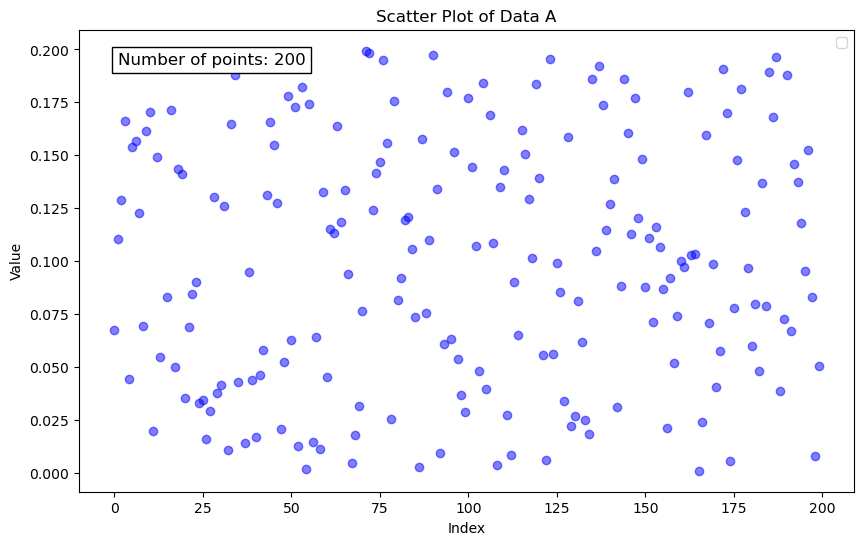

In [9]:
print(X_f.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f)), X_f, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)


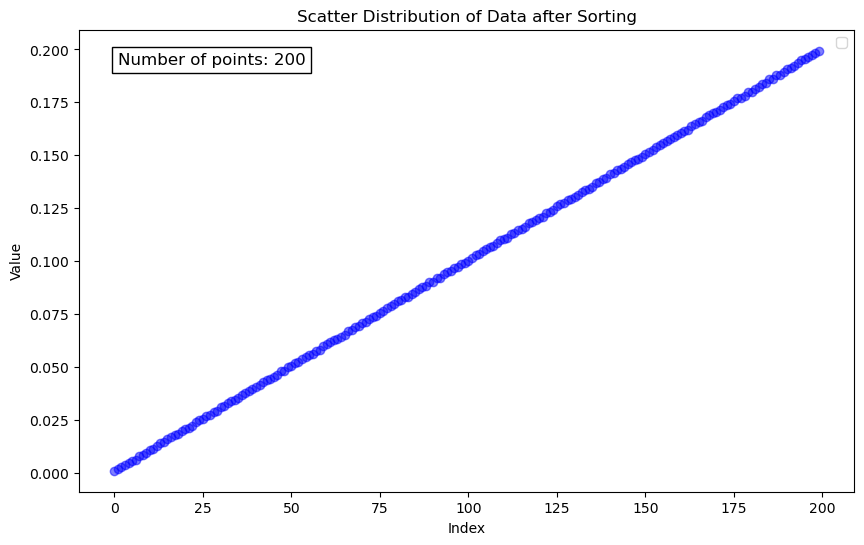

In [10]:
X = np.sort(X_f, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [11]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.05286472377048993, 0.05367202724590398, 0.053295201627260036, 0.053242321720549414, 0.053313246806870204, 0.05344676074494476, 0.05321631333034196, 0.05330770623009101, 0.053253909646177065, 0.05338144893555128]
Error u of fuhe active learning(LHS sampling): 5.329937e-02
[0.0047064931811938646, 0.004817124937372557, 0.00453750256139946, 0.004532236169980036, 0.004539106535101648, 0.004658517254790274, 0.004575446954275893, 0.004580333954952077, 0.004533291779037361, 0.0045456862185447]
MAE of fuhe active learning(LHS sampling): 4.602574e-03
[0.0003413938780314535, 0.00035186793671179034, 0.00034695550901817735, 0.0003462691519054762, 0.0003471915459167791, 0.0003489249369851862, 0.0003459366472415785, 0.00034712084916762204, 0.00034642064398943796, 0.0003480791144034877]
MSE of fuhe active learning(LHS sampling): 3.470160e-04
[3.8088205e-05, 3.2755062e-05, 4.6294248e-05, 0.00011086648, 3.4247543e-05, 4.268346e-05, 4.1281568e-05, 8.136074e-05, 8.811526e-05, 7.426167e-05]
Chaos of fuh

/tmp/ipykernel_1420462/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[0.05286472377048993, 0.05367202724590398, 0.053295201627260036, 0.053242321720549414, 0.053313246806870204, 0.05344676074494476, 0.05321631333034196, 0.05330770623009101, 0.053253909646177065, 0.05338144893555128]
mean Error u: 5.329937e-02
Variance Error u: 3.687507e-08


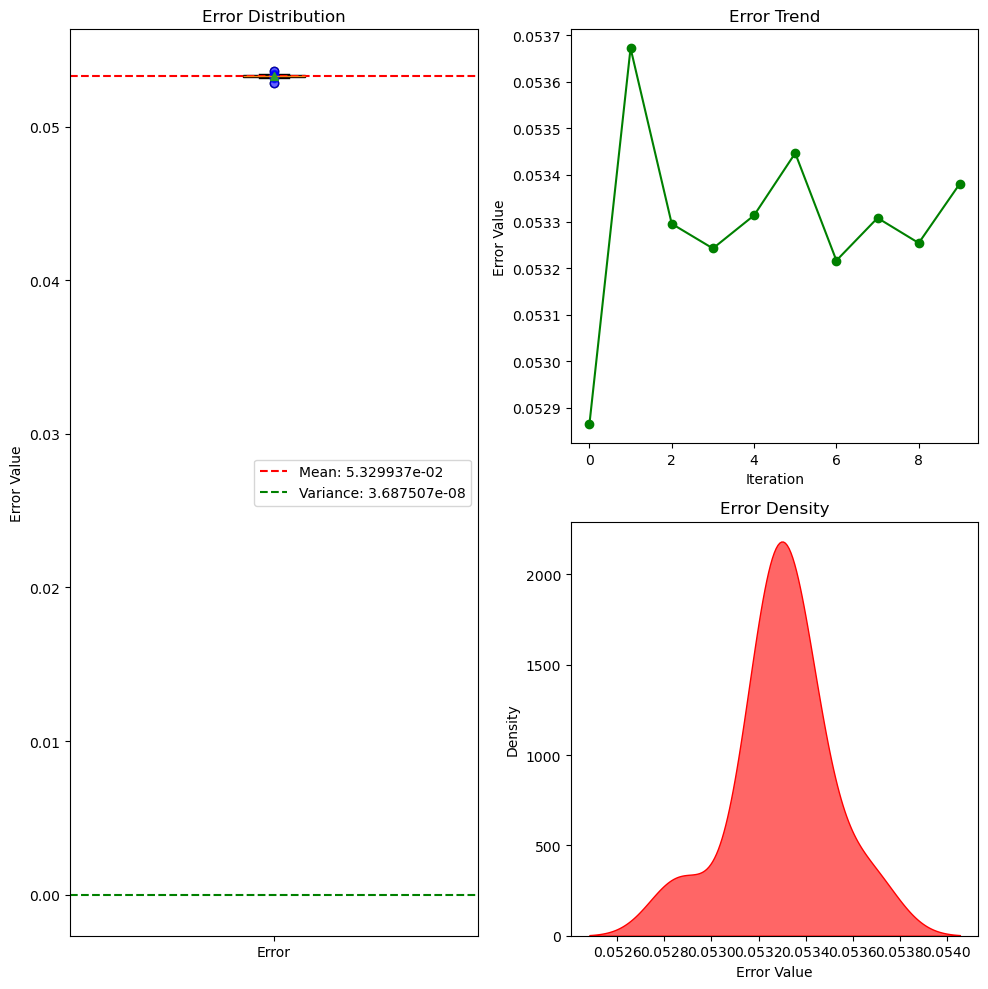

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0047064931811938646, 0.004817124937372557, 0.00453750256139946, 0.004532236169980036, 0.004539106535101648, 0.004658517254790274, 0.004575446954275893, 0.004580333954952077, 0.004533291779037361, 0.0045456862185447]
mean MAE: 4.602574e-03
Variance MAE: 8.243751e-09


/tmp/ipykernel_1420462/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


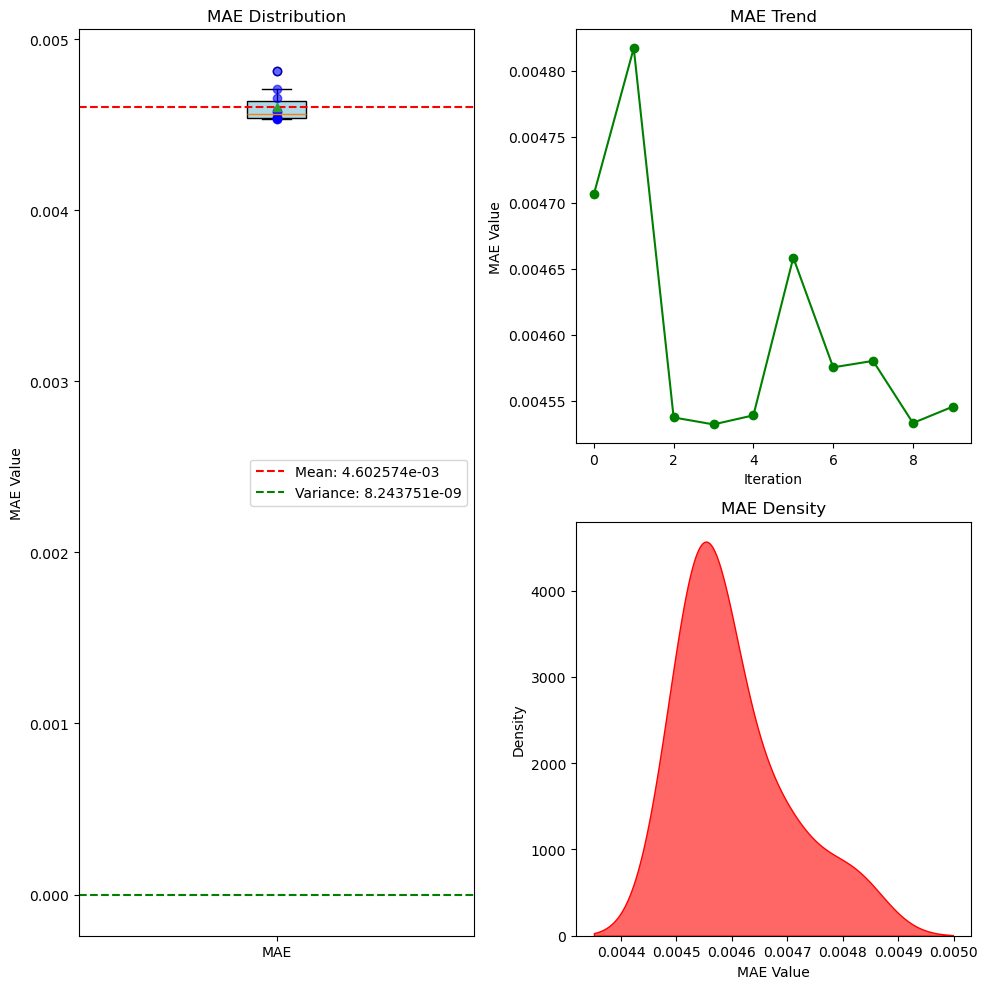

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0003413938780314535, 0.00035186793671179034, 0.00034695550901817735, 0.0003462691519054762, 0.0003471915459167791, 0.0003489249369851862, 0.0003459366472415785, 0.00034712084916762204, 0.00034642064398943796, 0.0003480791144034877]
mean MSE: 3.470160e-04
Variance MSE: 6.204650e-12


/tmp/ipykernel_1420462/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


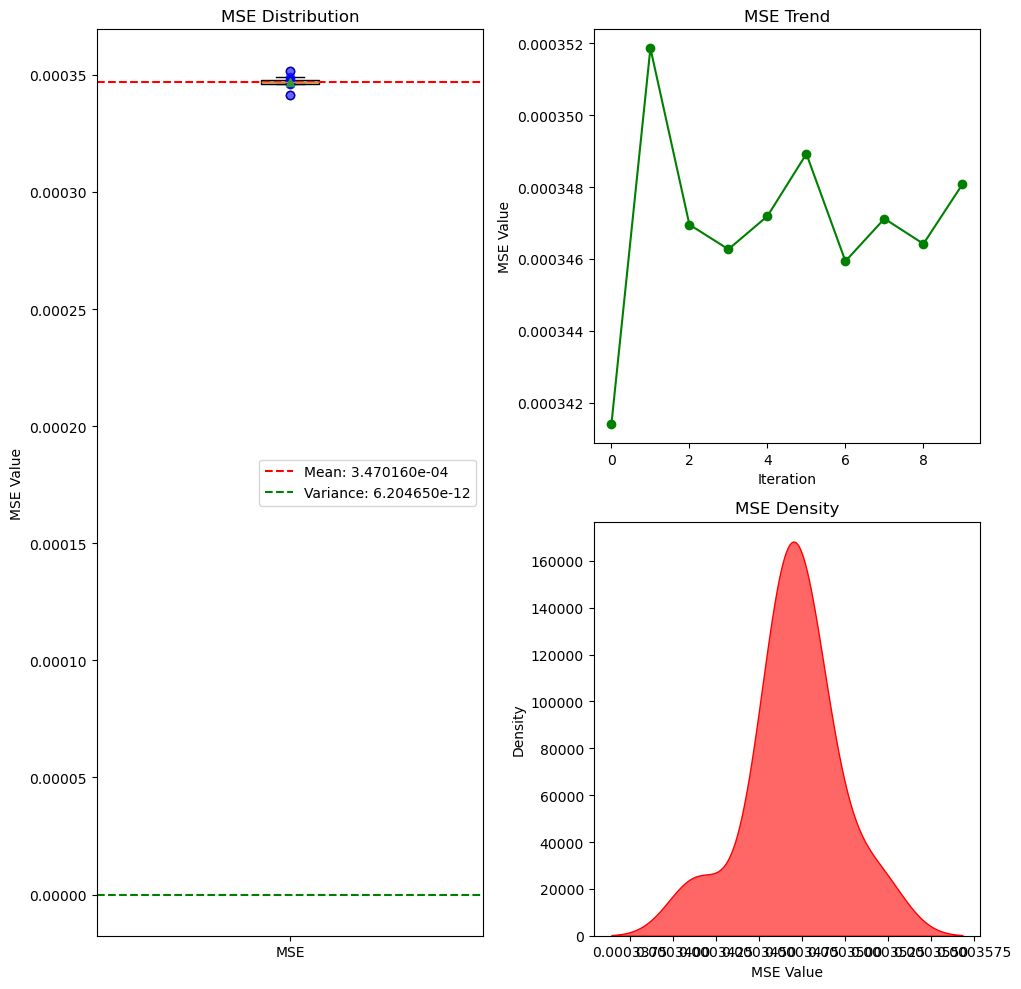

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[3.8088205e-05, 3.2755062e-05, 4.6294248e-05, 0.00011086648, 3.4247543e-05, 4.268346e-05, 4.1281568e-05, 8.136074e-05, 8.811526e-05, 7.426167e-05]
mean CHAOS: 5.899543e-05
Variance CHAOS: 6.751143e-10


/tmp/ipykernel_1420462/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


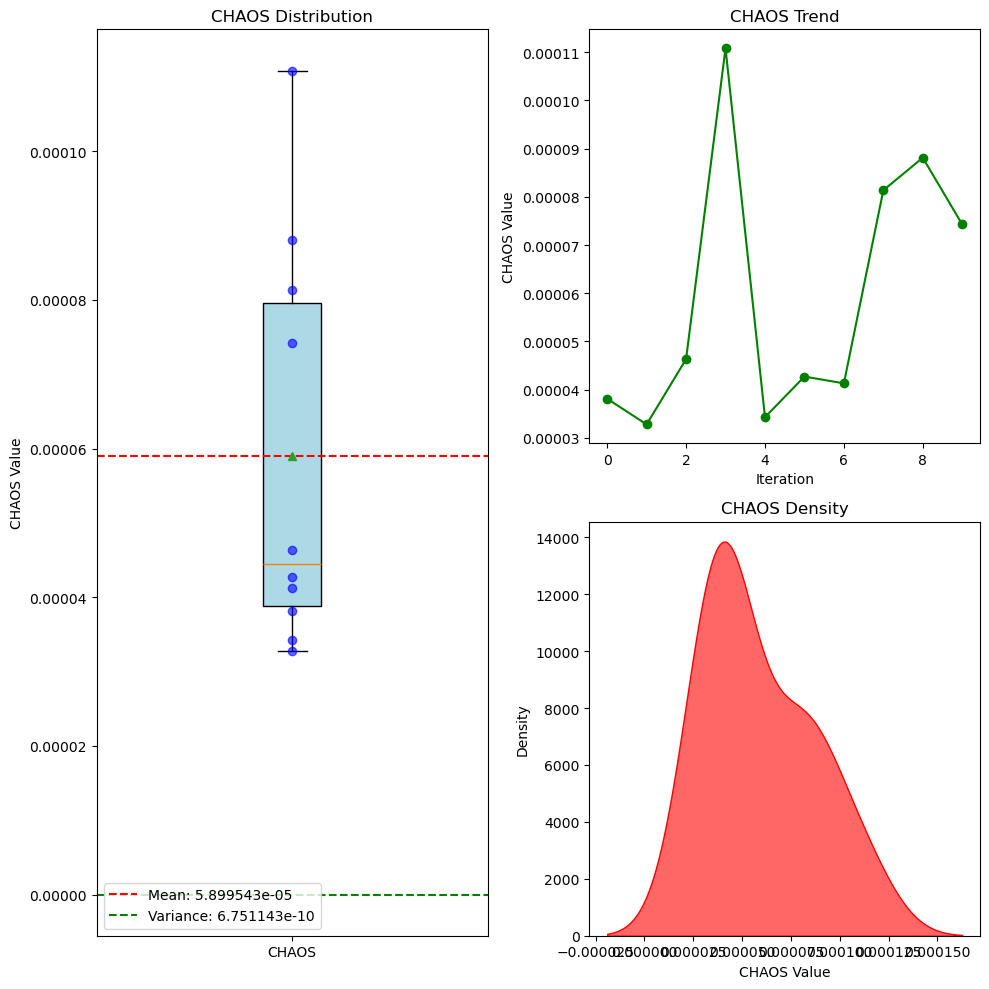

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0003285622, 0.0003423696, 0.0003579202, 0.0003243585, 0.0003441337, 0.00035486656, 0.00034161395, 0.00034986658, 0.00033942214, 0.00035004842]


/tmp/ipykernel_1420462/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


mean RESIDUAL: 3.433162e-04
Variance RESIDUAL: 1.031618e-10


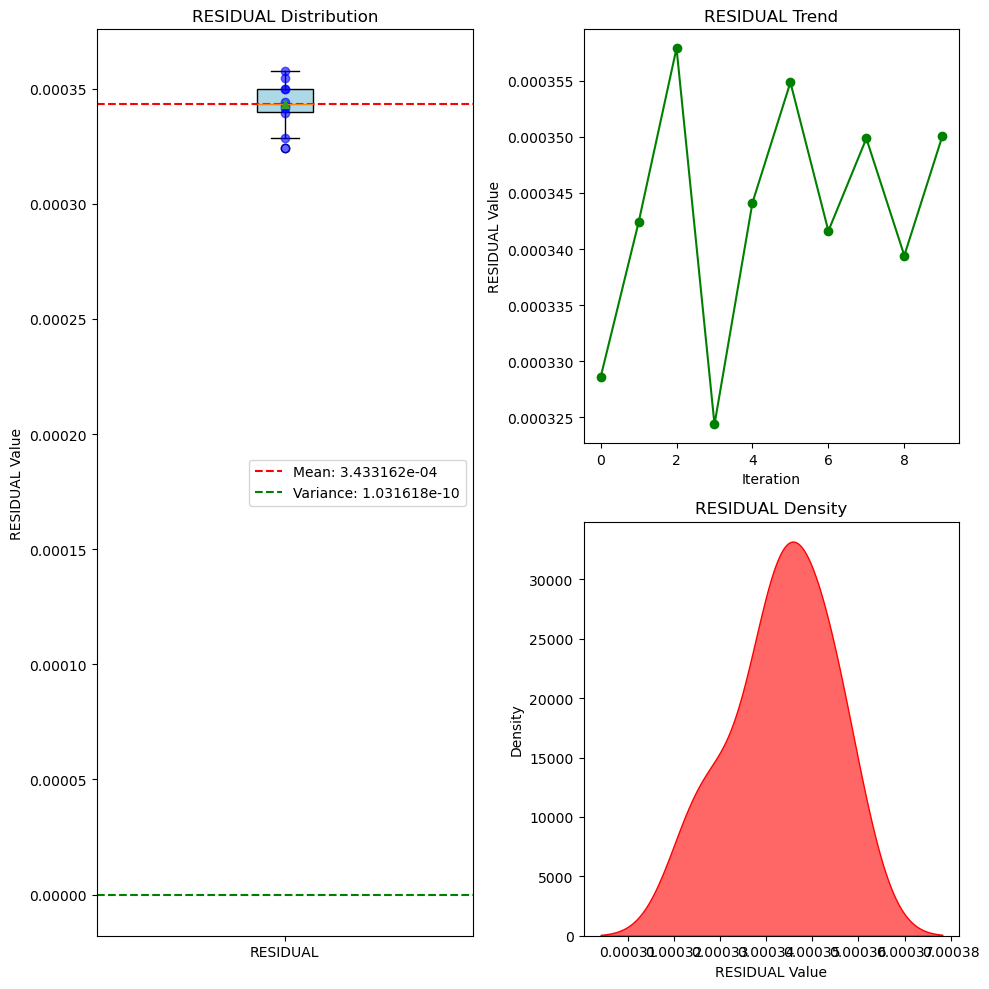

In [16]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

40000
[1.7958887e+03 1.7118921e+03 1.6422600e+03 ... 6.2745754e-03 6.2745661e-03
 6.2745563e-03]


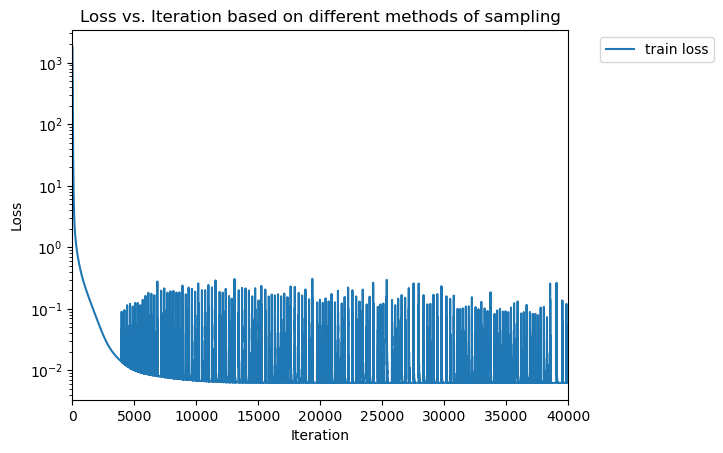

In [18]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,40000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [19]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.758031  0.053061  0.094619  0.068877  0.006613  0.004818  0.008591   
1  0.758028  0.053061  0.094621  0.068877  0.006613  0.004818  0.008592   
2  0.758025  0.053061  0.094624  0.068878  0.006614  0.004818  0.008592   
3  0.758022  0.053060  0.094626  0.068878  0.006614  0.004818  0.008592   
4  0.758019  0.053060  0.094629  0.068878  0.006614  0.004818  0.008592   

    state_8   state_9  state_10  state_11  state_12  
0  0.004005  0.000594  0.000273  0.000488  0.000029  
1  0.004005  0.000594  0.000273  0.000488  0.000029  
2  0.004005  0.000594  0.000273  0.000488  0.000029  
3  0.004005  0.000594  0.000273  0.000489  0.000029  
4  0.004005  0.000594  0.000273  0.000489  0.000029  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757823  0.053038  0.094717  0.068886  0.006635  0.004823  0.008618   
496  0.757821  0.053038  0.094717  0.068886  0.006636  0.004824  0.0086

Text(0, 0.5, 'Probability')

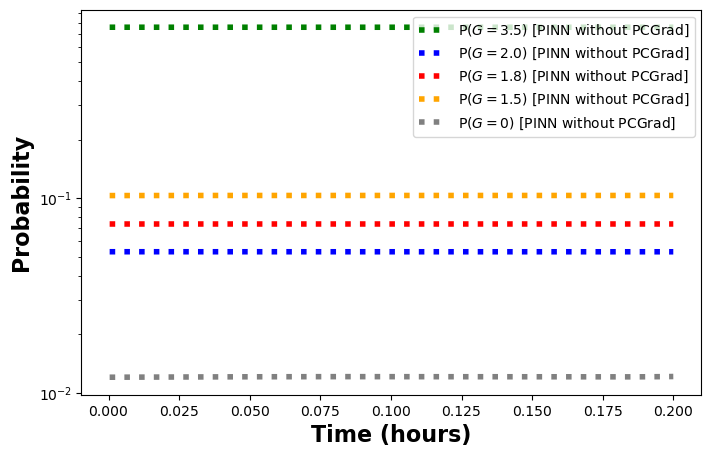

In [20]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

In [21]:
#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.989461  0.002719  0.003903  0.003874  0.000011  0.000011  0.000015   
1  0.979427  0.005285  0.007619  0.007508  0.000041  0.000041  0.000058   
2  0.969868  0.007706  0.011159  0.010919  0.000089  0.000087  0.000126   
3  0.960761  0.009993  0.014533  0.014121  0.000151  0.000147  0.000214   
4  0.952080  0.012153  0.017751  0.017129  0.000227  0.000219  0.000319   

    state_8       state_9      state_10      state_11      state_12  \
0  0.000005  4.199986e-08  1.479473e-08  2.123212e-08  5.835560e-11   
1  0.000021  3.151602e-07  1.117239e-07  1.610611e-07  8.690817e-10   
2  0.000045  9.982098e-07  3.560873e-07  5.156228e-07  4.096992e-09   
3  0.000077  2.221657e-06  7.974345e-07  1.159778e-06  1.206261e-08   
4  0.000115  4.076314e-06  1.472082e-06  2.150250e-06  2.744632e-08   

   system_3.5  system_2.0  system_1.8  system_1.5  system_0  
0    0.989461    0.002719    0.003885    0.003918  0.000016 

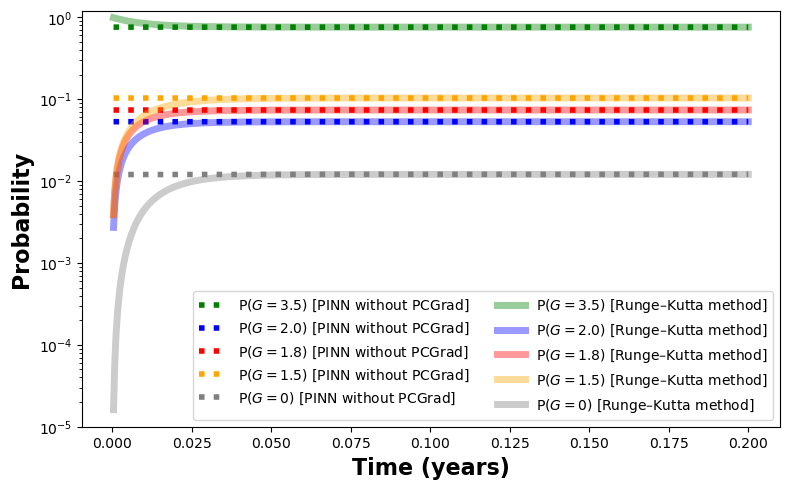

In [22]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5)



ax.legend(ncol=2, fontsize=10)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



plt.tight_layout()

### 计算RMSE

In [23]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_diff_no_pcgrad_laplace = laplace_solution_df - y_pred_df

In [24]:
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

y_diff_no_pcgrad_laplace['mse'] = y_diff_no_pcgrad_laplace.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_laplace['rmse'] = y_diff_no_pcgrad_laplace['mse'].apply(np.sqrt)

In [25]:
#这里的mse跟之前的MSE值不一样，其实是差了五倍，因为这里求均值是对500个数的和a除以500，而之前是对500*5个数的和（也是a）除以500*5
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['mse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['mse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.001740395572017439
RMSE of between PINN without PCGrad and the analytical solution is 0.001740395572017425


In [26]:
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['rmse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.013152008518462906
RMSE of between PINN without PCGrad and the analytical solution is 0.013152008518462228
